In [1]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

## Base Model-RESNET_50 
## Enhanced Model-XCEPTION
### XCEPTION Model instead of RESNET 50
#### Computational Efficiency: Reduced model complexity and faster training and inference.
#### Enhanced Feature Learning: Improved image feature extraction, leading to higher-quality captions.
#### Reduced Overfitting: Mitigated overfitting, resulting in better generalization.
#### Handling Correlations: Effective handling of cross-channel and spatial correlations for more coherent captions.


### Data Visualization and Preprocessing

In [2]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv(r"C:\Users\Lohesh\Downloads\Notes\Image Caption\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv(r"C:\Users\Lohesh\Downloads\Notes\Image Caption\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv(r"C:\Users\Lohesh\Downloads\Notes\Image Caption\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv(r"C:\Users\Lohesh\Downloads\Notes\Image Caption\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.devImages.txt",names=["img_id"])

In [3]:
l=os.listdir("flickr8k/Flickr_Data/Flickr_Data/Images")
print(len(l))

8091


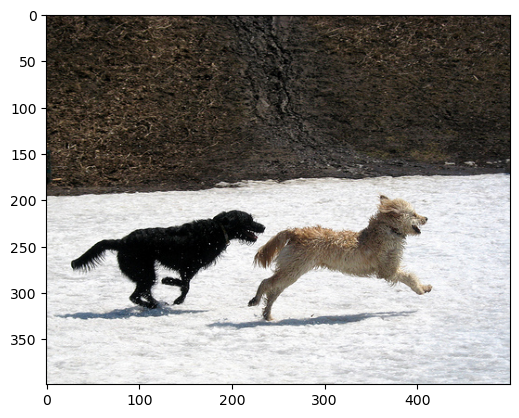

In [4]:
#visualising one of the train images
img=cv2.imread("flickr8k/Flickr_Data/Flickr_Data/Images"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [5]:
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [6]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [7]:
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [8]:
train_image_names.head()

img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

### Creating dictionaries to map image_id and their corresponding captions

In [9]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:08<00:00, 688.57it/s]


In [10]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 684.04it/s]


In [11]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 670.29it/s]


### Xception model for encoding images

In [12]:
from tensorflow.keras.applications import Xception
model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [13]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="flickr8k/Flickr_Data/Flickr_Data/Images/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 600ms/step


  0%|                                                                               | 1/6000 [00:00<1:06:40,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


  0%|                                                                                 | 3/6000 [00:00<24:32,  4.07it/s]

1/1 [==============================] - 0s 61ms/step


  0%|                                                                                 | 4/6000 [00:00<19:33,  5.11it/s]

1/1 [==============================] - 0s 64ms/step


  0%|                                                                                 | 6/6000 [00:01<14:47,  6.75it/s]

1/1 [==============================] - 0s 58ms/step


  0%|                                                                                 | 7/6000 [00:01<13:35,  7.35it/s]

1/1 [==============================] - 0s 52ms/step


  0%|                                                                                 | 9/6000 [00:01<12:04,  8.27it/s]

1/1 [==============================] - 0s 61ms/step


  0%|▏                                                                               | 11/6000 [00:01<11:11,  8.92it/s]

1/1 [==============================] - 0s 60ms/step


  0%|▏                                                                               | 12/6000 [00:01<11:07,  8.97it/s]

1/1 [==============================] - 0s 62ms/step


  0%|▏                                                                               | 13/6000 [00:01<10:51,  9.19it/s]

1/1 [==============================] - 0s 63ms/step


  0%|▏                                                                               | 14/6000 [00:01<10:42,  9.31it/s]

1/1 [==============================] - 0s 63ms/step


  0%|▏                                                                               | 15/6000 [00:02<10:35,  9.42it/s]

1/1 [==============================] - 0s 64ms/step


  0%|▏                                                                               | 16/6000 [00:02<10:26,  9.55it/s]

1/1 [==============================] - 0s 61ms/step


  0%|▏                                                                               | 17/6000 [00:02<10:25,  9.57it/s]

1/1 [==============================] - 0s 61ms/step


  0%|▏                                                                               | 18/6000 [00:02<10:25,  9.57it/s]

1/1 [==============================] - 0s 61ms/step


  0%|▎                                                                               | 19/6000 [00:02<10:25,  9.56it/s]

1/1 [==============================] - 0s 58ms/step


  0%|▎                                                                               | 20/6000 [00:02<10:18,  9.67it/s]

1/1 [==============================] - 0s 58ms/step


  0%|▎                                                                               | 22/6000 [00:02<10:07,  9.84it/s]

1/1 [==============================] - 0s 59ms/step


  0%|▎                                                                               | 23/6000 [00:02<10:09,  9.81it/s]

1/1 [==============================] - 0s 63ms/step


  0%|▎                                                                               | 24/6000 [00:03<10:15,  9.71it/s]

1/1 [==============================] - 0s 60ms/step


  0%|▎                                                                               | 25/6000 [00:03<10:19,  9.64it/s]

1/1 [==============================] - 0s 60ms/step


  0%|▎                                                                               | 26/6000 [00:03<10:16,  9.69it/s]

1/1 [==============================] - 0s 58ms/step


  0%|▎                                                                               | 28/6000 [00:03<10:08,  9.81it/s]

1/1 [==============================] - 0s 57ms/step


  0%|▍                                                                               | 30/6000 [00:03<09:57,  9.99it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▍                                                                               | 32/6000 [00:03<10:07,  9.82it/s]

1/1 [==============================] - 0s 56ms/step


  1%|▍                                                                               | 33/6000 [00:03<10:10,  9.77it/s]

1/1 [==============================] - 0s 61ms/step


  1%|▍                                                                               | 34/6000 [00:04<10:09,  9.79it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▍                                                                               | 36/6000 [00:04<09:57,  9.98it/s]

1/1 [==============================] - 0s 48ms/step


  1%|▌                                                                               | 38/6000 [00:04<09:56, 10.00it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▌                                                                               | 39/6000 [00:04<10:05,  9.84it/s]

1/1 [==============================] - 0s 56ms/step


  1%|▌                                                                               | 41/6000 [00:04<09:59,  9.93it/s]

1/1 [==============================] - 0s 49ms/step


  1%|▌                                                                               | 43/6000 [00:04<09:48, 10.12it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                               | 45/6000 [00:05<09:37, 10.31it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▋                                                                               | 47/6000 [00:05<09:39, 10.27it/s]

1/1 [==============================] - 0s 54ms/step


  1%|▋                                                                               | 49/6000 [00:05<09:37, 10.31it/s]

1/1 [==============================] - 0s 55ms/step


  1%|▋                                                                               | 51/6000 [00:05<09:41, 10.22it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▋                                                                               | 53/6000 [00:05<09:43, 10.19it/s]

1/1 [==============================] - 0s 53ms/step


  1%|▋                                                                               | 55/6000 [00:06<09:36, 10.32it/s]

1/1 [==============================] - 0s 52ms/step


  1%|▊                                                                               | 57/6000 [00:06<09:34, 10.35it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▊                                                                               | 59/6000 [00:06<09:37, 10.28it/s]

1/1 [==============================] - 0s 58ms/step


  1%|▊                                                                               | 61/6000 [00:06<09:50, 10.05it/s]

1/1 [==============================] - 0s 51ms/step


  1%|▊                                                                               | 63/6000 [00:06<09:42, 10.19it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▊                                                                               | 65/6000 [00:07<09:38, 10.26it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▉                                                                               | 67/6000 [00:07<10:19,  9.57it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▉                                                                               | 68/6000 [00:07<10:24,  9.50it/s]

1/1 [==============================] - 0s 53ms/step


  1%|▉                                                                               | 69/6000 [00:07<10:30,  9.41it/s]

1/1 [==============================] - 0s 60ms/step


  1%|▉                                                                               | 70/6000 [00:07<10:37,  9.31it/s]

1/1 [==============================] - 0s 57ms/step


  1%|▉                                                                               | 71/6000 [00:07<10:28,  9.44it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▉                                                                               | 72/6000 [00:07<10:29,  9.42it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▉                                                                               | 73/6000 [00:07<10:23,  9.50it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▉                                                                               | 74/6000 [00:08<10:18,  9.59it/s]

1/1 [==============================] - 0s 51ms/step


  1%|█                                                                               | 75/6000 [00:08<10:33,  9.35it/s]

1/1 [==============================] - 0s 59ms/step


  1%|█                                                                               | 76/6000 [00:08<10:26,  9.46it/s]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                               | 78/6000 [00:08<10:00,  9.86it/s]

1/1 [==============================] - 0s 48ms/step


  1%|█                                                                               | 79/6000 [00:08<09:59,  9.88it/s]

1/1 [==============================] - 0s 53ms/step


  1%|█                                                                               | 81/6000 [00:08<09:44, 10.12it/s]

1/1 [==============================] - 0s 48ms/step


  1%|█                                                                               | 83/6000 [00:08<09:42, 10.16it/s]

1/1 [==============================] - 0s 52ms/step


  1%|█▏                                                                              | 85/6000 [00:09<09:39, 10.22it/s]

1/1 [==============================] - 0s 58ms/step


  1%|█▏                                                                              | 87/6000 [00:09<09:42, 10.14it/s]

1/1 [==============================] - 0s 53ms/step


  1%|█▏                                                                              | 89/6000 [00:09<09:40, 10.19it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▏                                                                              | 91/6000 [00:09<09:40, 10.19it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▏                                                                              | 93/6000 [00:09<09:30, 10.35it/s]

1/1 [==============================] - 0s 57ms/step


  2%|█▎                                                                              | 95/6000 [00:10<09:33, 10.29it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▎                                                                              | 97/6000 [00:10<09:29, 10.37it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                              | 99/6000 [00:10<09:29, 10.35it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▎                                                                             | 101/6000 [00:10<09:34, 10.27it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▎                                                                             | 103/6000 [00:10<09:33, 10.28it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▍                                                                             | 105/6000 [00:11<09:29, 10.34it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▍                                                                             | 107/6000 [00:11<09:36, 10.23it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▍                                                                             | 109/6000 [00:11<09:32, 10.29it/s]

1/1 [==============================] - 0s 60ms/step


  2%|█▍                                                                             | 111/6000 [00:11<09:36, 10.21it/s]

1/1 [==============================] - 0s 66ms/step


  2%|█▍                                                                             | 113/6000 [00:11<09:33, 10.26it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▌                                                                             | 115/6000 [00:12<09:37, 10.19it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▌                                                                             | 117/6000 [00:12<09:31, 10.29it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▌                                                                             | 119/6000 [00:12<09:56,  9.86it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▌                                                                             | 120/6000 [00:12<09:58,  9.83it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▌                                                                             | 122/6000 [00:12<09:42, 10.09it/s]

1/1 [==============================] - 0s 67ms/step


  2%|█▋                                                                             | 124/6000 [00:12<09:39, 10.15it/s]

1/1 [==============================] - 0s 61ms/step


  2%|█▋                                                                             | 126/6000 [00:13<09:48,  9.98it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▋                                                                             | 128/6000 [00:13<09:41, 10.10it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▋                                                                             | 130/6000 [00:13<09:44, 10.05it/s]

1/1 [==============================] - 0s 60ms/step


  2%|█▋                                                                             | 132/6000 [00:13<09:49,  9.96it/s]

1/1 [==============================] - 0s 61ms/step


  2%|█▊                                                                             | 133/6000 [00:13<09:54,  9.88it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▊                                                                             | 135/6000 [00:14<09:46, 10.01it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▊                                                                             | 137/6000 [00:14<09:41, 10.08it/s]

1/1 [==============================] - 0s 66ms/step


  2%|█▊                                                                             | 139/6000 [00:14<09:43, 10.04it/s]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                             | 141/6000 [00:14<09:37, 10.15it/s]

1/1 [==============================] - 0s 57ms/step


  2%|█▉                                                                             | 143/6000 [00:14<09:43, 10.04it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                             | 145/6000 [00:15<09:42, 10.06it/s]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                             | 147/6000 [00:15<09:43, 10.03it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                             | 149/6000 [00:15<09:36, 10.15it/s]

1/1 [==============================] - 0s 56ms/step


  3%|█▉                                                                             | 151/6000 [00:15<09:33, 10.20it/s]

1/1 [==============================] - 0s 57ms/step


  3%|██                                                                             | 153/6000 [00:15<09:34, 10.17it/s]

1/1 [==============================] - 0s 55ms/step


  3%|██                                                                             | 155/6000 [00:16<09:42, 10.04it/s]

1/1 [==============================] - 0s 61ms/step


  3%|██                                                                             | 157/6000 [00:16<09:40, 10.06it/s]

1/1 [==============================] - 0s 51ms/step


  3%|██                                                                             | 159/6000 [00:16<09:32, 10.20it/s]

1/1 [==============================] - 0s 50ms/step


  3%|██                                                                             | 161/6000 [00:16<09:29, 10.25it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                            | 163/6000 [00:16<09:33, 10.19it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▏                                                                            | 165/6000 [00:17<09:30, 10.23it/s]

1/1 [==============================] - 0s 57ms/step


  3%|██▏                                                                            | 167/6000 [00:17<09:27, 10.27it/s]

1/1 [==============================] - 0s 52ms/step


  3%|██▏                                                                            | 169/6000 [00:17<09:16, 10.48it/s]

1/1 [==============================] - 0s 71ms/step


  3%|██▎                                                                            | 171/6000 [00:17<09:45,  9.96it/s]

1/1 [==============================] - 0s 60ms/step


  3%|██▎                                                                            | 173/6000 [00:17<09:47,  9.93it/s]

1/1 [==============================] - 0s 57ms/step


  3%|██▎                                                                            | 175/6000 [00:18<09:41, 10.03it/s]

1/1 [==============================] - 0s 50ms/step


  3%|██▎                                                                            | 177/6000 [00:18<09:30, 10.21it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▎                                                                            | 179/6000 [00:18<09:26, 10.28it/s]

1/1 [==============================] - 0s 50ms/step


  3%|██▍                                                                            | 181/6000 [00:18<09:30, 10.21it/s]

1/1 [==============================] - 0s 46ms/step


  3%|██▍                                                                            | 183/6000 [00:18<09:26, 10.27it/s]

1/1 [==============================] - 0s 43ms/step


  3%|██▍                                                                            | 185/6000 [00:18<09:24, 10.30it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▍                                                                            | 187/6000 [00:19<09:28, 10.23it/s]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                            | 189/6000 [00:19<09:38, 10.05it/s]

1/1 [==============================] - 0s 51ms/step


  3%|██▌                                                                            | 191/6000 [00:19<09:32, 10.15it/s]

1/1 [==============================] - 0s 52ms/step


  3%|██▌                                                                            | 193/6000 [00:19<09:20, 10.36it/s]

1/1 [==============================] - 0s 62ms/step


  3%|██▌                                                                            | 195/6000 [00:19<09:39, 10.02it/s]

1/1 [==============================] - 0s 51ms/step


  3%|██▌                                                                            | 197/6000 [00:20<09:39, 10.01it/s]

1/1 [==============================] - 0s 52ms/step


  3%|██▌                                                                            | 199/6000 [00:20<09:40,  9.98it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▋                                                                            | 201/6000 [00:20<09:35, 10.08it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▋                                                                            | 203/6000 [00:20<09:35, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██▋                                                                            | 205/6000 [00:20<09:27, 10.21it/s]

1/1 [==============================] - 0s 52ms/step


  3%|██▋                                                                            | 207/6000 [00:21<09:26, 10.22it/s]

1/1 [==============================] - 0s 53ms/step


  3%|██▊                                                                            | 209/6000 [00:21<09:24, 10.25it/s]

1/1 [==============================] - 0s 64ms/step


  4%|██▊                                                                            | 211/6000 [00:21<09:26, 10.22it/s]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                            | 213/6000 [00:21<09:26, 10.22it/s]

1/1 [==============================] - 0s 59ms/step


  4%|██▊                                                                            | 215/6000 [00:21<09:31, 10.13it/s]

1/1 [==============================] - 0s 52ms/step


  4%|██▊                                                                            | 217/6000 [00:22<09:32, 10.10it/s]

1/1 [==============================] - 0s 46ms/step


  4%|██▉                                                                            | 219/6000 [00:22<09:33, 10.08it/s]

1/1 [==============================] - 0s 54ms/step


  4%|██▉                                                                            | 221/6000 [00:22<09:23, 10.25it/s]

1/1 [==============================] - 0s 51ms/step


  4%|██▉                                                                            | 223/6000 [00:22<09:24, 10.24it/s]

1/1 [==============================] - 0s 50ms/step


  4%|██▉                                                                            | 225/6000 [00:22<09:24, 10.23it/s]

1/1 [==============================] - 0s 61ms/step


  4%|██▉                                                                            | 227/6000 [00:23<09:38,  9.97it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███                                                                            | 229/6000 [00:23<09:34, 10.05it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███                                                                            | 231/6000 [00:23<09:33, 10.07it/s]

1/1 [==============================] - 0s 49ms/step


  4%|███                                                                            | 233/6000 [00:23<09:29, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███                                                                            | 235/6000 [00:23<09:23, 10.22it/s]

1/1 [==============================] - 0s 50ms/step


  4%|███                                                                            | 237/6000 [00:24<09:23, 10.23it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███▏                                                                           | 239/6000 [00:24<09:22, 10.25it/s]

1/1 [==============================] - 0s 52ms/step


  4%|███▏                                                                           | 241/6000 [00:24<09:16, 10.34it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███▏                                                                           | 243/6000 [00:24<09:17, 10.34it/s]

1/1 [==============================] - 0s 40ms/step


  4%|███▏                                                                           | 245/6000 [00:24<09:15, 10.36it/s]

1/1 [==============================] - 0s 62ms/step


  4%|███▎                                                                           | 247/6000 [00:25<09:22, 10.22it/s]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                           | 249/6000 [00:25<09:22, 10.23it/s]

1/1 [==============================] - 0s 63ms/step


  4%|███▎                                                                           | 251/6000 [00:25<11:35,  8.27it/s]

1/1 [==============================] - 0s 60ms/step


  4%|███▎                                                                           | 253/6000 [00:25<10:57,  8.74it/s]

1/1 [==============================] - 0s 61ms/step


  4%|███▎                                                                           | 254/6000 [00:25<10:43,  8.92it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███▎                                                                           | 256/6000 [00:26<10:15,  9.33it/s]

1/1 [==============================] - 0s 57ms/step


  4%|███▍                                                                           | 258/6000 [00:26<09:57,  9.62it/s]

1/1 [==============================] - 0s 64ms/step


  4%|███▍                                                                           | 259/6000 [00:26<09:52,  9.69it/s]

1/1 [==============================] - 0s 49ms/step


  4%|███▍                                                                           | 261/6000 [00:26<09:39,  9.89it/s]

1/1 [==============================] - 0s 48ms/step


  4%|███▍                                                                           | 263/6000 [00:26<09:34,  9.98it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███▍                                                                           | 265/6000 [00:26<09:32, 10.01it/s]

1/1 [==============================] - 0s 52ms/step


  4%|███▌                                                                           | 267/6000 [00:27<09:26, 10.13it/s]

1/1 [==============================] - 0s 48ms/step


  4%|███▌                                                                           | 269/6000 [00:27<09:20, 10.22it/s]

1/1 [==============================] - 0s 43ms/step


  5%|███▌                                                                           | 271/6000 [00:27<09:13, 10.36it/s]

1/1 [==============================] - 0s 50ms/step


  5%|███▌                                                                           | 273/6000 [00:27<09:16, 10.29it/s]

1/1 [==============================] - 0s 49ms/step


  5%|███▌                                                                           | 275/6000 [00:27<09:21, 10.20it/s]

1/1 [==============================] - 0s 52ms/step


  5%|███▋                                                                           | 277/6000 [00:28<09:20, 10.20it/s]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                           | 279/6000 [00:28<09:19, 10.23it/s]

1/1 [==============================] - 0s 54ms/step


  5%|███▋                                                                           | 281/6000 [00:28<09:21, 10.19it/s]

1/1 [==============================] - 0s 51ms/step


  5%|███▋                                                                           | 283/6000 [00:28<09:21, 10.19it/s]

1/1 [==============================] - 0s 55ms/step


  5%|███▊                                                                           | 285/6000 [00:28<09:21, 10.18it/s]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                           | 287/6000 [00:29<09:15, 10.28it/s]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                           | 289/6000 [00:29<09:14, 10.30it/s]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                           | 291/6000 [00:29<09:16, 10.26it/s]

1/1 [==============================] - 0s 52ms/step


  5%|███▊                                                                           | 293/6000 [00:29<09:13, 10.31it/s]

1/1 [==============================] - 0s 52ms/step


  5%|███▉                                                                           | 295/6000 [00:29<09:11, 10.34it/s]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                           | 297/6000 [00:30<09:11, 10.35it/s]

1/1 [==============================] - 0s 50ms/step


  5%|███▉                                                                           | 299/6000 [00:30<09:09, 10.38it/s]

1/1 [==============================] - 0s 43ms/step


  5%|███▉                                                                           | 301/6000 [00:30<09:07, 10.42it/s]

1/1 [==============================] - 0s 49ms/step


  5%|███▉                                                                           | 303/6000 [00:30<09:08, 10.39it/s]

1/1 [==============================] - 0s 52ms/step


  5%|████                                                                           | 305/6000 [00:30<09:06, 10.42it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████                                                                           | 307/6000 [00:31<09:13, 10.28it/s]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                           | 309/6000 [00:31<09:15, 10.25it/s]

1/1 [==============================] - 0s 52ms/step


  5%|████                                                                           | 311/6000 [00:31<09:13, 10.28it/s]

1/1 [==============================] - 0s 49ms/step


  5%|████                                                                           | 313/6000 [00:31<09:12, 10.28it/s]

1/1 [==============================] - 0s 55ms/step


  5%|████▏                                                                          | 315/6000 [00:31<09:12, 10.28it/s]

1/1 [==============================] - 0s 51ms/step


  5%|████▏                                                                          | 317/6000 [00:32<09:14, 10.24it/s]

1/1 [==============================] - 0s 43ms/step


  5%|████▏                                                                          | 319/6000 [00:32<09:12, 10.28it/s]

1/1 [==============================] - 0s 53ms/step


  5%|████▏                                                                          | 321/6000 [00:32<09:14, 10.25it/s]

1/1 [==============================] - 0s 45ms/step


  5%|████▎                                                                          | 323/6000 [00:32<09:15, 10.22it/s]

1/1 [==============================] - 0s 53ms/step


  5%|████▎                                                                          | 325/6000 [00:32<09:12, 10.28it/s]

1/1 [==============================] - 0s 45ms/step


  5%|████▎                                                                          | 327/6000 [00:33<09:10, 10.30it/s]

1/1 [==============================] - 0s 55ms/step


  5%|████▎                                                                          | 329/6000 [00:33<09:06, 10.38it/s]

1/1 [==============================] - 0s 42ms/step


  6%|████▎                                                                          | 331/6000 [00:33<09:08, 10.34it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▍                                                                          | 333/6000 [00:33<09:08, 10.33it/s]

1/1 [==============================] - 0s 51ms/step


  6%|████▍                                                                          | 335/6000 [00:33<09:07, 10.35it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▍                                                                          | 337/6000 [00:33<09:05, 10.38it/s]

1/1 [==============================] - 0s 56ms/step


  6%|████▍                                                                          | 339/6000 [00:34<09:05, 10.37it/s]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                          | 341/6000 [00:34<09:04, 10.40it/s]

1/1 [==============================] - 0s 50ms/step


  6%|████▌                                                                          | 343/6000 [00:34<09:03, 10.41it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▌                                                                          | 345/6000 [00:34<09:02, 10.43it/s]

1/1 [==============================] - 0s 54ms/step


  6%|████▌                                                                          | 347/6000 [00:34<09:04, 10.37it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████▌                                                                          | 349/6000 [00:35<09:04, 10.38it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▌                                                                          | 351/6000 [00:35<09:05, 10.36it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████▋                                                                          | 353/6000 [00:35<09:01, 10.44it/s]

1/1 [==============================] - 0s 48ms/step


  6%|████▋                                                                          | 355/6000 [00:35<09:07, 10.32it/s]

1/1 [==============================] - 0s 53ms/step


  6%|████▋                                                                          | 357/6000 [00:35<09:07, 10.31it/s]

1/1 [==============================] - 0s 42ms/step


  6%|████▋                                                                          | 359/6000 [00:36<09:08, 10.28it/s]

1/1 [==============================] - 0s 51ms/step


  6%|████▊                                                                          | 361/6000 [00:36<09:10, 10.24it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▊                                                                          | 363/6000 [00:36<09:08, 10.29it/s]

1/1 [==============================] - 0s 43ms/step


  6%|████▊                                                                          | 365/6000 [00:36<09:06, 10.32it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████▊                                                                          | 367/6000 [00:36<09:10, 10.23it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▊                                                                          | 369/6000 [00:37<09:09, 10.25it/s]

1/1 [==============================] - 0s 53ms/step


  6%|████▉                                                                          | 371/6000 [00:37<09:11, 10.21it/s]

1/1 [==============================] - 0s 53ms/step


  6%|████▉                                                                          | 373/6000 [00:37<09:09, 10.24it/s]

1/1 [==============================] - 0s 45ms/step


  6%|████▉                                                                          | 375/6000 [00:37<09:08, 10.26it/s]

1/1 [==============================] - 0s 51ms/step


  6%|████▉                                                                          | 377/6000 [00:37<09:07, 10.28it/s]

1/1 [==============================] - 0s 67ms/step


  6%|████▉                                                                          | 379/6000 [00:38<09:08, 10.26it/s]

1/1 [==============================] - 0s 61ms/step


  6%|█████                                                                          | 381/6000 [00:38<09:08, 10.24it/s]

1/1 [==============================] - 0s 52ms/step


  6%|█████                                                                          | 383/6000 [00:38<09:07, 10.26it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████                                                                          | 385/6000 [00:38<09:02, 10.35it/s]

1/1 [==============================] - 0s 42ms/step


  6%|█████                                                                          | 387/6000 [00:38<09:08, 10.23it/s]

1/1 [==============================] - 0s 52ms/step


  6%|█████                                                                          | 389/6000 [00:39<09:12, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                         | 391/6000 [00:39<09:11, 10.17it/s]

1/1 [==============================] - 0s 57ms/step


  7%|█████▏                                                                         | 393/6000 [00:39<09:07, 10.25it/s]

1/1 [==============================] - 0s 53ms/step


  7%|█████▏                                                                         | 395/6000 [00:39<09:08, 10.22it/s]

1/1 [==============================] - 0s 51ms/step


  7%|█████▏                                                                         | 397/6000 [00:39<09:10, 10.17it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▎                                                                         | 399/6000 [00:40<09:09, 10.19it/s]

1/1 [==============================] - 0s 54ms/step


  7%|█████▎                                                                         | 401/6000 [00:40<09:00, 10.37it/s]

1/1 [==============================] - 0s 48ms/step


  7%|█████▎                                                                         | 403/6000 [00:40<09:02, 10.32it/s]

1/1 [==============================] - 0s 54ms/step


  7%|█████▎                                                                         | 405/6000 [00:40<09:02, 10.32it/s]

1/1 [==============================] - 0s 52ms/step


  7%|█████▎                                                                         | 407/6000 [00:40<09:03, 10.29it/s]

1/1 [==============================] - 0s 53ms/step


  7%|█████▍                                                                         | 409/6000 [00:40<09:06, 10.23it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                         | 411/6000 [00:41<09:09, 10.18it/s]

1/1 [==============================] - 0s 51ms/step


  7%|█████▍                                                                         | 413/6000 [00:41<09:07, 10.21it/s]

1/1 [==============================] - 0s 41ms/step


  7%|█████▍                                                                         | 415/6000 [00:41<09:05, 10.25it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                         | 417/6000 [00:41<09:02, 10.29it/s]

1/1 [==============================] - 0s 51ms/step


  7%|█████▌                                                                         | 419/6000 [00:41<09:05, 10.23it/s]

1/1 [==============================] - 0s 52ms/step


  7%|█████▌                                                                         | 421/6000 [00:42<09:00, 10.33it/s]

1/1 [==============================] - 0s 49ms/step


  7%|█████▌                                                                         | 423/6000 [00:42<09:00, 10.31it/s]

1/1 [==============================] - 0s 42ms/step


  7%|█████▌                                                                         | 425/6000 [00:42<08:57, 10.38it/s]

1/1 [==============================] - 0s 46ms/step


  7%|█████▌                                                                         | 427/6000 [00:42<08:59, 10.32it/s]

1/1 [==============================] - 0s 52ms/step


  7%|█████▋                                                                         | 429/6000 [00:42<08:59, 10.33it/s]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                         | 431/6000 [00:43<08:58, 10.34it/s]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                         | 433/6000 [00:43<08:57, 10.35it/s]

1/1 [==============================] - 0s 67ms/step


  7%|█████▋                                                                         | 435/6000 [00:43<08:59, 10.31it/s]

1/1 [==============================] - 0s 52ms/step


  7%|█████▊                                                                         | 437/6000 [00:43<08:58, 10.33it/s]

1/1 [==============================] - 0s 49ms/step


  7%|█████▊                                                                         | 439/6000 [00:43<09:01, 10.27it/s]

1/1 [==============================] - 0s 52ms/step


  7%|█████▊                                                                         | 441/6000 [00:44<09:03, 10.23it/s]

1/1 [==============================] - 0s 56ms/step


  7%|█████▊                                                                         | 443/6000 [00:44<09:03, 10.22it/s]

1/1 [==============================] - 0s 45ms/step


  7%|█████▊                                                                         | 445/6000 [00:44<09:03, 10.22it/s]

1/1 [==============================] - 0s 47ms/step


  7%|█████▉                                                                         | 447/6000 [00:44<09:03, 10.22it/s]

1/1 [==============================] - 0s 54ms/step


  7%|█████▉                                                                         | 449/6000 [00:44<09:03, 10.22it/s]

1/1 [==============================] - 0s 67ms/step


  8%|█████▉                                                                         | 451/6000 [00:45<09:02, 10.22it/s]

1/1 [==============================] - 0s 58ms/step


  8%|█████▉                                                                         | 453/6000 [00:45<09:07, 10.12it/s]

1/1 [==============================] - 0s 53ms/step


  8%|█████▉                                                                         | 455/6000 [00:45<09:03, 10.21it/s]

1/1 [==============================] - 0s 63ms/step


  8%|██████                                                                         | 457/6000 [00:45<09:36,  9.61it/s]

1/1 [==============================] - 0s 54ms/step


  8%|██████                                                                         | 459/6000 [00:45<09:41,  9.53it/s]

1/1 [==============================] - 0s 62ms/step


  8%|██████                                                                         | 460/6000 [00:46<09:43,  9.49it/s]

1/1 [==============================] - 0s 56ms/step


  8%|██████                                                                         | 461/6000 [00:46<09:39,  9.55it/s]

1/1 [==============================] - 0s 54ms/step


  8%|██████                                                                         | 462/6000 [00:46<09:35,  9.62it/s]

1/1 [==============================] - 0s 50ms/step


  8%|██████                                                                         | 463/6000 [00:46<09:37,  9.58it/s]

1/1 [==============================] - 0s 48ms/step


  8%|██████                                                                         | 464/6000 [00:46<09:36,  9.61it/s]

1/1 [==============================] - 0s 67ms/step


  8%|██████                                                                         | 465/6000 [00:46<09:38,  9.57it/s]

1/1 [==============================] - 0s 53ms/step


  8%|██████▏                                                                        | 466/6000 [00:46<09:42,  9.50it/s]

1/1 [==============================] - 0s 58ms/step


  8%|██████▏                                                                        | 467/6000 [00:46<09:45,  9.45it/s]

1/1 [==============================] - 0s 51ms/step


  8%|██████▏                                                                        | 469/6000 [00:46<09:26,  9.76it/s]

1/1 [==============================] - 0s 45ms/step


  8%|██████▏                                                                        | 471/6000 [00:47<09:17,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▏                                                                        | 473/6000 [00:47<09:01, 10.20it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▎                                                                        | 475/6000 [00:47<09:06, 10.12it/s]

1/1 [==============================] - 0s 60ms/step


  8%|██████▎                                                                        | 477/6000 [00:47<09:07, 10.09it/s]

1/1 [==============================] - 0s 52ms/step


  8%|██████▎                                                                        | 479/6000 [00:47<09:02, 10.18it/s]

1/1 [==============================] - 0s 42ms/step


  8%|██████▎                                                                        | 481/6000 [00:48<08:56, 10.28it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████▎                                                                        | 483/6000 [00:48<08:59, 10.22it/s]

1/1 [==============================] - 0s 51ms/step


  8%|██████▍                                                                        | 485/6000 [00:48<08:56, 10.27it/s]

1/1 [==============================] - 0s 47ms/step


  8%|██████▍                                                                        | 487/6000 [00:48<09:09, 10.04it/s]

1/1 [==============================] - 0s 59ms/step


  8%|██████▍                                                                        | 489/6000 [00:48<09:11,  9.99it/s]

1/1 [==============================] - 0s 59ms/step


  8%|██████▍                                                                        | 490/6000 [00:49<09:13,  9.95it/s]

1/1 [==============================] - 0s 59ms/step


  8%|██████▍                                                                        | 492/6000 [00:49<09:10, 10.01it/s]

1/1 [==============================] - 0s 46ms/step


  8%|██████▌                                                                        | 494/6000 [00:49<09:06, 10.08it/s]

1/1 [==============================] - 0s 46ms/step


  8%|██████▌                                                                        | 496/6000 [00:49<09:08, 10.03it/s]

1/1 [==============================] - 0s 47ms/step


  8%|██████▌                                                                        | 498/6000 [00:49<09:09, 10.01it/s]

1/1 [==============================] - 0s 48ms/step


  8%|██████▌                                                                        | 500/6000 [00:50<09:08, 10.03it/s]

1/1 [==============================] - 0s 54ms/step


  8%|██████▌                                                                        | 502/6000 [00:50<09:22,  9.78it/s]

1/1 [==============================] - 0s 48ms/step


  8%|██████▋                                                                        | 504/6000 [00:50<09:16,  9.88it/s]

1/1 [==============================] - 0s 51ms/step


  8%|██████▋                                                                        | 506/6000 [00:50<09:12,  9.95it/s]

1/1 [==============================] - 0s 53ms/step


  8%|██████▋                                                                        | 508/6000 [00:50<09:07, 10.03it/s]

1/1 [==============================] - 0s 53ms/step


  8%|██████▋                                                                        | 510/6000 [00:51<09:07, 10.03it/s]

1/1 [==============================] - 0s 54ms/step


  9%|██████▋                                                                        | 512/6000 [00:51<09:06, 10.04it/s]

1/1 [==============================] - 0s 55ms/step


  9%|██████▊                                                                        | 514/6000 [00:51<09:08, 10.00it/s]

1/1 [==============================] - 0s 57ms/step


  9%|██████▊                                                                        | 516/6000 [00:51<09:06, 10.04it/s]

1/1 [==============================] - 0s 45ms/step


  9%|██████▊                                                                        | 518/6000 [00:51<09:01, 10.12it/s]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                        | 520/6000 [00:52<09:01, 10.13it/s]

1/1 [==============================] - 0s 55ms/step


  9%|██████▊                                                                        | 522/6000 [00:52<08:54, 10.24it/s]

1/1 [==============================] - 0s 44ms/step


  9%|██████▉                                                                        | 524/6000 [00:52<08:54, 10.24it/s]

1/1 [==============================] - 0s 52ms/step


  9%|██████▉                                                                        | 526/6000 [00:52<08:52, 10.28it/s]

1/1 [==============================] - 0s 67ms/step


  9%|██████▉                                                                        | 528/6000 [00:52<08:55, 10.22it/s]

1/1 [==============================] - 0s 46ms/step


  9%|██████▉                                                                        | 530/6000 [00:52<08:51, 10.29it/s]

1/1 [==============================] - 0s 48ms/step


  9%|███████                                                                        | 532/6000 [00:53<08:55, 10.21it/s]

1/1 [==============================] - 0s 53ms/step


  9%|███████                                                                        | 534/6000 [00:53<08:54, 10.23it/s]

1/1 [==============================] - 0s 55ms/step


  9%|███████                                                                        | 536/6000 [00:53<08:54, 10.22it/s]

1/1 [==============================] - 0s 49ms/step


  9%|███████                                                                        | 538/6000 [00:53<08:57, 10.17it/s]

1/1 [==============================] - 0s 57ms/step


  9%|███████                                                                        | 540/6000 [00:53<08:59, 10.13it/s]

1/1 [==============================] - 0s 59ms/step


  9%|███████▏                                                                       | 542/6000 [00:54<09:13,  9.86it/s]

1/1 [==============================] - 0s 63ms/step


  9%|███████▏                                                                       | 543/6000 [00:54<09:21,  9.72it/s]

1/1 [==============================] - 0s 63ms/step


  9%|███████▏                                                                       | 545/6000 [00:54<09:20,  9.73it/s]

1/1 [==============================] - 0s 47ms/step


  9%|███████▏                                                                       | 547/6000 [00:54<09:20,  9.74it/s]

1/1 [==============================] - 0s 63ms/step


  9%|███████▏                                                                       | 549/6000 [00:54<09:05,  9.99it/s]

1/1 [==============================] - 0s 47ms/step


  9%|███████▏                                                                       | 550/6000 [00:54<09:16,  9.80it/s]

1/1 [==============================] - 0s 71ms/step


  9%|███████▎                                                                       | 551/6000 [00:55<09:20,  9.72it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███████▎                                                                       | 552/6000 [00:55<09:47,  9.27it/s]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                       | 553/6000 [00:55<09:42,  9.35it/s]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                       | 554/6000 [00:55<09:35,  9.47it/s]

1/1 [==============================] - 0s 59ms/step


  9%|███████▎                                                                       | 555/6000 [00:55<09:33,  9.49it/s]

1/1 [==============================] - 0s 63ms/step


  9%|███████▎                                                                       | 556/6000 [00:55<09:32,  9.51it/s]

1/1 [==============================] - 0s 64ms/step


  9%|███████▎                                                                       | 557/6000 [00:55<09:38,  9.41it/s]

1/1 [==============================] - 0s 59ms/step


  9%|███████▎                                                                       | 558/6000 [00:55<09:42,  9.34it/s]

1/1 [==============================] - 0s 68ms/step


  9%|███████▎                                                                       | 559/6000 [00:55<09:40,  9.38it/s]

1/1 [==============================] - 0s 52ms/step


  9%|███████▍                                                                       | 561/6000 [00:56<09:13,  9.82it/s]

1/1 [==============================] - 0s 53ms/step


  9%|███████▍                                                                       | 563/6000 [00:56<08:58, 10.10it/s]

1/1 [==============================] - 0s 55ms/step


  9%|███████▍                                                                       | 565/6000 [00:56<09:01, 10.04it/s]

1/1 [==============================] - 0s 44ms/step


  9%|███████▍                                                                       | 567/6000 [00:56<08:55, 10.15it/s]

1/1 [==============================] - 0s 54ms/step


  9%|███████▍                                                                       | 569/6000 [00:56<08:53, 10.19it/s]

1/1 [==============================] - 0s 56ms/step


 10%|███████▌                                                                       | 571/6000 [00:57<08:49, 10.25it/s]

1/1 [==============================] - 0s 58ms/step


 10%|███████▌                                                                       | 573/6000 [00:57<09:02, 10.01it/s]

1/1 [==============================] - 0s 55ms/step


 10%|███████▌                                                                       | 575/6000 [00:57<09:11,  9.83it/s]

1/1 [==============================] - 0s 56ms/step


 10%|███████▌                                                                       | 577/6000 [00:57<08:57, 10.10it/s]

1/1 [==============================] - 0s 52ms/step


 10%|███████▌                                                                       | 579/6000 [00:57<09:05,  9.93it/s]

1/1 [==============================] - 0s 50ms/step


 10%|███████▋                                                                       | 581/6000 [00:58<08:53, 10.15it/s]

1/1 [==============================] - 0s 51ms/step


 10%|███████▋                                                                       | 583/6000 [00:58<08:48, 10.24it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▋                                                                       | 585/6000 [00:58<08:42, 10.37it/s]

1/1 [==============================] - 0s 43ms/step


 10%|███████▋                                                                       | 587/6000 [00:58<08:44, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


 10%|███████▊                                                                       | 589/6000 [00:58<08:39, 10.41it/s]

1/1 [==============================] - 0s 48ms/step


 10%|███████▊                                                                       | 591/6000 [00:59<08:37, 10.46it/s]

1/1 [==============================] - 0s 51ms/step


 10%|███████▊                                                                       | 593/6000 [00:59<08:36, 10.48it/s]

1/1 [==============================] - 0s 50ms/step


 10%|███████▊                                                                       | 595/6000 [00:59<08:35, 10.48it/s]

1/1 [==============================] - 0s 46ms/step


 10%|███████▊                                                                       | 597/6000 [00:59<08:32, 10.54it/s]

1/1 [==============================] - 0s 52ms/step


 10%|███████▉                                                                       | 599/6000 [00:59<08:30, 10.58it/s]

1/1 [==============================] - 0s 38ms/step


 10%|███████▉                                                                       | 601/6000 [01:00<08:28, 10.62it/s]

1/1 [==============================] - 0s 44ms/step


 10%|███████▉                                                                       | 603/6000 [01:00<08:34, 10.50it/s]

1/1 [==============================] - 0s 53ms/step


 10%|███████▉                                                                       | 605/6000 [01:00<08:33, 10.51it/s]

1/1 [==============================] - 0s 52ms/step


 10%|███████▉                                                                       | 607/6000 [01:00<08:30, 10.56it/s]

1/1 [==============================] - 0s 51ms/step


 10%|████████                                                                       | 609/6000 [01:00<08:32, 10.51it/s]

1/1 [==============================] - 0s 48ms/step


 10%|████████                                                                       | 611/6000 [01:00<08:36, 10.43it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████                                                                       | 613/6000 [01:01<08:34, 10.46it/s]

1/1 [==============================] - 0s 48ms/step


 10%|████████                                                                       | 615/6000 [01:01<08:37, 10.40it/s]

1/1 [==============================] - 0s 53ms/step


 10%|████████                                                                       | 617/6000 [01:01<08:35, 10.44it/s]

1/1 [==============================] - 0s 64ms/step


 10%|████████▏                                                                      | 619/6000 [01:01<08:43, 10.28it/s]

1/1 [==============================] - 0s 54ms/step


 10%|████████▏                                                                      | 621/6000 [01:01<08:45, 10.24it/s]

1/1 [==============================] - 0s 47ms/step


 10%|████████▏                                                                      | 623/6000 [01:02<08:45, 10.23it/s]

1/1 [==============================] - 0s 47ms/step


 10%|████████▏                                                                      | 625/6000 [01:02<08:49, 10.16it/s]

1/1 [==============================] - 0s 48ms/step


 10%|████████▎                                                                      | 627/6000 [01:02<08:47, 10.18it/s]

1/1 [==============================] - 0s 43ms/step


 10%|████████▎                                                                      | 629/6000 [01:02<08:44, 10.24it/s]

1/1 [==============================] - 0s 47ms/step


 11%|████████▎                                                                      | 631/6000 [01:02<08:42, 10.27it/s]

1/1 [==============================] - 0s 52ms/step


 11%|████████▎                                                                      | 633/6000 [01:03<08:44, 10.23it/s]

1/1 [==============================] - 0s 66ms/step


 11%|████████▎                                                                      | 635/6000 [01:03<08:44, 10.24it/s]

1/1 [==============================] - 0s 47ms/step


 11%|████████▍                                                                      | 637/6000 [01:03<08:40, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▍                                                                      | 639/6000 [01:03<08:35, 10.39it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▍                                                                      | 641/6000 [01:03<08:30, 10.50it/s]

1/1 [==============================] - 0s 40ms/step


 11%|████████▍                                                                      | 643/6000 [01:04<08:38, 10.34it/s]

1/1 [==============================] - 0s 49ms/step


 11%|████████▍                                                                      | 645/6000 [01:04<08:34, 10.41it/s]

1/1 [==============================] - 0s 45ms/step


 11%|████████▌                                                                      | 647/6000 [01:04<08:30, 10.48it/s]

1/1 [==============================] - 0s 49ms/step


 11%|████████▌                                                                      | 649/6000 [01:04<08:33, 10.42it/s]

1/1 [==============================] - 0s 43ms/step


 11%|████████▌                                                                      | 651/6000 [01:04<08:33, 10.41it/s]

1/1 [==============================] - 0s 44ms/step


 11%|████████▌                                                                      | 653/6000 [01:05<08:38, 10.31it/s]

1/1 [==============================] - 0s 61ms/step


 11%|████████▌                                                                      | 655/6000 [01:05<08:37, 10.32it/s]

1/1 [==============================] - 0s 56ms/step


 11%|████████▋                                                                      | 657/6000 [01:05<08:37, 10.32it/s]

1/1 [==============================] - 0s 44ms/step


 11%|████████▋                                                                      | 659/6000 [01:05<08:39, 10.28it/s]

1/1 [==============================] - 0s 49ms/step


 11%|████████▋                                                                      | 661/6000 [01:05<08:39, 10.27it/s]

1/1 [==============================] - 0s 54ms/step


 11%|████████▋                                                                      | 663/6000 [01:06<08:39, 10.27it/s]

1/1 [==============================] - 0s 44ms/step


 11%|████████▊                                                                      | 665/6000 [01:06<08:37, 10.30it/s]

1/1 [==============================] - 0s 48ms/step


 11%|████████▊                                                                      | 667/6000 [01:06<08:39, 10.26it/s]

1/1 [==============================] - 0s 54ms/step


 11%|████████▊                                                                      | 669/6000 [01:06<08:39, 10.27it/s]

1/1 [==============================] - 0s 52ms/step


 11%|████████▊                                                                      | 671/6000 [01:06<08:39, 10.26it/s]

1/1 [==============================] - 0s 49ms/step


 11%|████████▊                                                                      | 673/6000 [01:07<08:38, 10.27it/s]

1/1 [==============================] - 0s 50ms/step


 11%|████████▉                                                                      | 675/6000 [01:07<08:41, 10.21it/s]

1/1 [==============================] - 0s 54ms/step


 11%|████████▉                                                                      | 677/6000 [01:07<08:40, 10.23it/s]

1/1 [==============================] - 0s 47ms/step


 11%|████████▉                                                                      | 679/6000 [01:07<08:38, 10.27it/s]

1/1 [==============================] - 0s 52ms/step


 11%|████████▉                                                                      | 681/6000 [01:07<08:40, 10.23it/s]

1/1 [==============================] - 0s 52ms/step


 11%|████████▉                                                                      | 683/6000 [01:07<08:37, 10.28it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█████████                                                                      | 685/6000 [01:08<08:36, 10.30it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█████████                                                                      | 687/6000 [01:08<08:36, 10.29it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█████████                                                                      | 689/6000 [01:08<08:36, 10.27it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█████████                                                                      | 691/6000 [01:08<08:38, 10.25it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█████████                                                                      | 693/6000 [01:08<08:38, 10.24it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█████████▏                                                                     | 695/6000 [01:09<08:39, 10.21it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▏                                                                     | 697/6000 [01:09<08:35, 10.28it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█████████▏                                                                     | 699/6000 [01:09<08:35, 10.29it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█████████▏                                                                     | 701/6000 [01:09<08:31, 10.36it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█████████▎                                                                     | 703/6000 [01:09<08:33, 10.31it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█████████▎                                                                     | 705/6000 [01:10<08:34, 10.29it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▎                                                                     | 707/6000 [01:10<08:33, 10.31it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█████████▎                                                                     | 709/6000 [01:10<08:29, 10.38it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█████████▎                                                                     | 711/6000 [01:10<08:30, 10.36it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█████████▍                                                                     | 713/6000 [01:10<08:32, 10.31it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█████████▍                                                                     | 715/6000 [01:11<08:37, 10.22it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▍                                                                     | 717/6000 [01:11<08:37, 10.21it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▍                                                                     | 719/6000 [01:11<08:37, 10.21it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▍                                                                     | 721/6000 [01:11<08:39, 10.16it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█████████▌                                                                     | 723/6000 [01:11<08:42, 10.10it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▌                                                                     | 725/6000 [01:12<08:37, 10.20it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█████████▌                                                                     | 727/6000 [01:12<08:33, 10.27it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█████████▌                                                                     | 729/6000 [01:12<08:32, 10.29it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▌                                                                     | 731/6000 [01:12<08:37, 10.18it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█████████▋                                                                     | 733/6000 [01:12<08:38, 10.16it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█████████▋                                                                     | 735/6000 [01:13<08:38, 10.15it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▋                                                                     | 737/6000 [01:13<08:39, 10.14it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█████████▋                                                                     | 739/6000 [01:13<08:41, 10.10it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█████████▊                                                                     | 741/6000 [01:13<08:37, 10.17it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▊                                                                     | 743/6000 [01:13<08:34, 10.22it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▊                                                                     | 745/6000 [01:14<08:38, 10.13it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▊                                                                     | 747/6000 [01:14<08:40, 10.09it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█████████▊                                                                     | 749/6000 [01:14<08:39, 10.11it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▉                                                                     | 751/6000 [01:14<08:39, 10.11it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█████████▉                                                                     | 753/6000 [01:14<08:35, 10.17it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▉                                                                     | 755/6000 [01:15<08:31, 10.25it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▉                                                                     | 757/6000 [01:15<08:31, 10.25it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█████████▉                                                                     | 759/6000 [01:15<08:28, 10.32it/s]

1/1 [==============================] - 0s 52ms/step


 13%|██████████                                                                     | 761/6000 [01:15<08:30, 10.26it/s]

1/1 [==============================] - 0s 52ms/step


 13%|██████████                                                                     | 763/6000 [01:15<08:28, 10.30it/s]

1/1 [==============================] - 0s 43ms/step


 13%|██████████                                                                     | 765/6000 [01:15<08:25, 10.35it/s]

1/1 [==============================] - 0s 50ms/step


 13%|██████████                                                                     | 767/6000 [01:16<08:25, 10.36it/s]

1/1 [==============================] - 0s 48ms/step


 13%|██████████▏                                                                    | 769/6000 [01:16<08:22, 10.40it/s]

1/1 [==============================] - 0s 51ms/step


 13%|██████████▏                                                                    | 771/6000 [01:16<08:26, 10.32it/s]

1/1 [==============================] - 0s 53ms/step


 13%|██████████▏                                                                    | 773/6000 [01:16<08:25, 10.35it/s]

1/1 [==============================] - 0s 52ms/step


 13%|██████████▏                                                                    | 775/6000 [01:16<08:24, 10.35it/s]

1/1 [==============================] - 0s 53ms/step


 13%|██████████▏                                                                    | 777/6000 [01:17<08:23, 10.37it/s]

1/1 [==============================] - 0s 53ms/step


 13%|██████████▎                                                                    | 779/6000 [01:17<08:26, 10.32it/s]

1/1 [==============================] - 0s 51ms/step


 13%|██████████▎                                                                    | 781/6000 [01:17<08:26, 10.31it/s]

1/1 [==============================] - 0s 54ms/step


 13%|██████████▎                                                                    | 783/6000 [01:17<08:25, 10.33it/s]

1/1 [==============================] - 0s 43ms/step


 13%|██████████▎                                                                    | 785/6000 [01:17<08:26, 10.29it/s]

1/1 [==============================] - 0s 61ms/step


 13%|██████████▎                                                                    | 787/6000 [01:18<08:34, 10.13it/s]

1/1 [==============================] - 0s 43ms/step


 13%|██████████▍                                                                    | 789/6000 [01:18<08:29, 10.22it/s]

1/1 [==============================] - 0s 46ms/step


 13%|██████████▍                                                                    | 791/6000 [01:18<08:32, 10.15it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▍                                                                    | 793/6000 [01:18<08:34, 10.12it/s]

1/1 [==============================] - 0s 44ms/step


 13%|██████████▍                                                                    | 795/6000 [01:18<08:38, 10.05it/s]

1/1 [==============================] - 0s 51ms/step


 13%|██████████▍                                                                    | 797/6000 [01:19<08:39, 10.02it/s]

1/1 [==============================] - 0s 42ms/step


 13%|██████████▌                                                                    | 799/6000 [01:19<08:39, 10.02it/s]

1/1 [==============================] - 0s 58ms/step


 13%|██████████▌                                                                    | 801/6000 [01:19<08:39, 10.01it/s]

1/1 [==============================] - 0s 58ms/step


 13%|██████████▌                                                                    | 803/6000 [01:19<08:42,  9.94it/s]

1/1 [==============================] - 0s 51ms/step


 13%|██████████▌                                                                    | 805/6000 [01:19<08:38, 10.03it/s]

1/1 [==============================] - 0s 45ms/step


 13%|██████████▋                                                                    | 807/6000 [01:20<08:36, 10.05it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▋                                                                    | 809/6000 [01:20<08:35, 10.07it/s]

1/1 [==============================] - 0s 43ms/step


 14%|██████████▋                                                                    | 811/6000 [01:20<08:39, 10.00it/s]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▋                                                                    | 813/6000 [01:20<08:39,  9.99it/s]

1/1 [==============================] - 0s 57ms/step


 14%|██████████▋                                                                    | 814/6000 [01:20<08:45,  9.86it/s]

1/1 [==============================] - 0s 54ms/step


 14%|██████████▋                                                                    | 816/6000 [01:21<08:40,  9.97it/s]

1/1 [==============================] - 0s 56ms/step


 14%|██████████▊                                                                    | 817/6000 [01:21<08:40,  9.97it/s]

1/1 [==============================] - 0s 57ms/step


 14%|██████████▊                                                                    | 819/6000 [01:21<08:39,  9.98it/s]

1/1 [==============================] - 0s 52ms/step


 14%|██████████▊                                                                    | 821/6000 [01:21<08:34, 10.06it/s]

1/1 [==============================] - 0s 52ms/step


 14%|██████████▊                                                                    | 823/6000 [01:21<08:35, 10.05it/s]

1/1 [==============================] - 0s 51ms/step


 14%|██████████▊                                                                    | 825/6000 [01:21<08:29, 10.15it/s]

1/1 [==============================] - 0s 52ms/step


 14%|██████████▉                                                                    | 827/6000 [01:22<08:31, 10.12it/s]

1/1 [==============================] - 0s 54ms/step


 14%|██████████▉                                                                    | 829/6000 [01:22<08:29, 10.14it/s]

1/1 [==============================] - 0s 52ms/step


 14%|██████████▉                                                                    | 831/6000 [01:22<08:28, 10.16it/s]

1/1 [==============================] - 0s 53ms/step


 14%|██████████▉                                                                    | 833/6000 [01:22<08:31, 10.10it/s]

1/1 [==============================] - 0s 68ms/step


 14%|██████████▉                                                                    | 835/6000 [01:22<08:35, 10.02it/s]

1/1 [==============================] - 0s 51ms/step


 14%|███████████                                                                    | 837/6000 [01:23<08:31, 10.10it/s]

1/1 [==============================] - 0s 50ms/step


 14%|███████████                                                                    | 839/6000 [01:23<08:28, 10.14it/s]

1/1 [==============================] - 0s 53ms/step


 14%|███████████                                                                    | 841/6000 [01:23<08:29, 10.12it/s]

1/1 [==============================] - 0s 53ms/step


 14%|███████████                                                                    | 843/6000 [01:23<08:29, 10.12it/s]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▏                                                                   | 845/6000 [01:23<08:26, 10.18it/s]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▏                                                                   | 847/6000 [01:24<08:28, 10.14it/s]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▏                                                                   | 849/6000 [01:24<08:27, 10.15it/s]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▏                                                                   | 851/6000 [01:24<08:27, 10.15it/s]

1/1 [==============================] - 0s 56ms/step


 14%|███████████▏                                                                   | 853/6000 [01:24<08:24, 10.20it/s]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▎                                                                   | 855/6000 [01:24<08:26, 10.17it/s]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                   | 857/6000 [01:25<08:35,  9.97it/s]

1/1 [==============================] - 0s 57ms/step


 14%|███████████▎                                                                   | 858/6000 [01:25<08:36,  9.95it/s]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                   | 859/6000 [01:25<08:39,  9.89it/s]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                   | 861/6000 [01:25<08:32, 10.03it/s]

1/1 [==============================] - 0s 55ms/step


 14%|███████████▎                                                                   | 863/6000 [01:25<08:27, 10.12it/s]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                   | 865/6000 [01:25<08:26, 10.13it/s]

1/1 [==============================] - 0s 67ms/step


 14%|███████████▍                                                                   | 867/6000 [01:26<08:28, 10.09it/s]

1/1 [==============================] - 0s 53ms/step


 14%|███████████▍                                                                   | 869/6000 [01:26<08:25, 10.14it/s]

1/1 [==============================] - 0s 48ms/step


 15%|███████████▍                                                                   | 871/6000 [01:26<08:25, 10.14it/s]

1/1 [==============================] - 0s 53ms/step


 15%|███████████▍                                                                   | 873/6000 [01:26<08:23, 10.18it/s]

1/1 [==============================] - 0s 54ms/step


 15%|███████████▌                                                                   | 875/6000 [01:26<08:25, 10.15it/s]

1/1 [==============================] - 0s 51ms/step


 15%|███████████▌                                                                   | 877/6000 [01:27<08:22, 10.20it/s]

1/1 [==============================] - 0s 49ms/step


 15%|███████████▌                                                                   | 879/6000 [01:27<08:21, 10.20it/s]

1/1 [==============================] - 0s 56ms/step


 15%|███████████▌                                                                   | 881/6000 [01:27<08:14, 10.35it/s]

1/1 [==============================] - 0s 44ms/step


 15%|███████████▋                                                                   | 883/6000 [01:27<08:20, 10.23it/s]

1/1 [==============================] - 0s 52ms/step


 15%|███████████▋                                                                   | 885/6000 [01:27<08:15, 10.32it/s]

1/1 [==============================] - 0s 44ms/step


 15%|███████████▋                                                                   | 887/6000 [01:28<08:16, 10.31it/s]

1/1 [==============================] - 0s 49ms/step


 15%|███████████▋                                                                   | 889/6000 [01:28<08:14, 10.33it/s]

1/1 [==============================] - 0s 52ms/step


 15%|███████████▋                                                                   | 891/6000 [01:28<08:16, 10.28it/s]

1/1 [==============================] - 0s 51ms/step


 15%|███████████▊                                                                   | 893/6000 [01:28<08:14, 10.33it/s]

1/1 [==============================] - 0s 52ms/step


 15%|███████████▊                                                                   | 895/6000 [01:28<08:12, 10.36it/s]

1/1 [==============================] - 0s 52ms/step


 15%|███████████▊                                                                   | 897/6000 [01:28<08:14, 10.33it/s]

1/1 [==============================] - 0s 58ms/step


 15%|███████████▊                                                                   | 899/6000 [01:29<08:20, 10.18it/s]

1/1 [==============================] - 0s 51ms/step


 15%|███████████▊                                                                   | 901/6000 [01:29<08:20, 10.18it/s]

1/1 [==============================] - 0s 51ms/step


 15%|███████████▉                                                                   | 903/6000 [01:29<08:24, 10.10it/s]

1/1 [==============================] - 0s 44ms/step


 15%|███████████▉                                                                   | 905/6000 [01:29<08:24, 10.10it/s]

1/1 [==============================] - 0s 43ms/step


 15%|███████████▉                                                                   | 907/6000 [01:29<08:27, 10.04it/s]

1/1 [==============================] - 0s 67ms/step


 15%|███████████▉                                                                   | 909/6000 [01:30<08:30,  9.98it/s]

1/1 [==============================] - 0s 58ms/step


 15%|███████████▉                                                                   | 911/6000 [01:30<08:29,  9.99it/s]

1/1 [==============================] - 0s 66ms/step


 15%|████████████                                                                   | 912/6000 [01:30<08:29,  9.98it/s]

1/1 [==============================] - 0s 58ms/step


 15%|████████████                                                                   | 914/6000 [01:30<08:27, 10.03it/s]

1/1 [==============================] - 0s 42ms/step


 15%|████████████                                                                   | 916/6000 [01:30<08:26, 10.03it/s]

1/1 [==============================] - 0s 44ms/step


 15%|████████████                                                                   | 918/6000 [01:31<08:24, 10.07it/s]

1/1 [==============================] - 0s 51ms/step


 15%|████████████                                                                   | 920/6000 [01:31<08:21, 10.13it/s]

1/1 [==============================] - 0s 59ms/step


 15%|████████████▏                                                                  | 922/6000 [01:31<08:23, 10.09it/s]

1/1 [==============================] - 0s 51ms/step


 15%|████████████▏                                                                  | 924/6000 [01:31<08:29,  9.96it/s]

1/1 [==============================] - 0s 52ms/step


 15%|████████████▏                                                                  | 926/6000 [01:31<08:28,  9.98it/s]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                  | 928/6000 [01:32<08:24, 10.05it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▏                                                                  | 930/6000 [01:32<08:23, 10.06it/s]

1/1 [==============================] - 0s 51ms/step


 16%|████████████▎                                                                  | 932/6000 [01:32<08:22, 10.08it/s]

1/1 [==============================] - 0s 56ms/step


 16%|████████████▎                                                                  | 934/6000 [01:32<08:19, 10.13it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▎                                                                  | 936/6000 [01:32<08:18, 10.16it/s]

1/1 [==============================] - 0s 49ms/step


 16%|████████████▎                                                                  | 938/6000 [01:33<08:17, 10.17it/s]

1/1 [==============================] - 0s 51ms/step


 16%|████████████▍                                                                  | 940/6000 [01:33<08:24, 10.03it/s]

1/1 [==============================] - 0s 48ms/step


 16%|████████████▍                                                                  | 942/6000 [01:33<08:20, 10.11it/s]

1/1 [==============================] - 0s 48ms/step


 16%|████████████▍                                                                  | 944/6000 [01:33<08:22, 10.07it/s]

1/1 [==============================] - 0s 49ms/step


 16%|████████████▍                                                                  | 946/6000 [01:33<08:22, 10.06it/s]

1/1 [==============================] - 0s 60ms/step


 16%|████████████▍                                                                  | 948/6000 [01:34<08:26,  9.98it/s]

1/1 [==============================] - 0s 48ms/step


 16%|████████████▌                                                                  | 950/6000 [01:34<08:21, 10.07it/s]

1/1 [==============================] - 0s 55ms/step


 16%|████████████▌                                                                  | 952/6000 [01:34<08:16, 10.16it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▌                                                                  | 954/6000 [01:34<08:16, 10.16it/s]

1/1 [==============================] - 0s 52ms/step


 16%|████████████▌                                                                  | 956/6000 [01:34<08:17, 10.15it/s]

1/1 [==============================] - 0s 48ms/step


 16%|████████████▌                                                                  | 958/6000 [01:35<08:16, 10.15it/s]

1/1 [==============================] - 0s 53ms/step


 16%|████████████▋                                                                  | 960/6000 [01:35<08:17, 10.14it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▋                                                                  | 962/6000 [01:35<08:18, 10.10it/s]

1/1 [==============================] - 0s 52ms/step


 16%|████████████▋                                                                  | 964/6000 [01:35<08:18, 10.10it/s]

1/1 [==============================] - 0s 41ms/step


 16%|████████████▋                                                                  | 966/6000 [01:35<08:14, 10.19it/s]

1/1 [==============================] - 0s 52ms/step


 16%|████████████▋                                                                  | 968/6000 [01:36<08:16, 10.13it/s]

1/1 [==============================] - 0s 46ms/step


 16%|████████████▊                                                                  | 970/6000 [01:36<08:16, 10.13it/s]

1/1 [==============================] - 0s 49ms/step


 16%|████████████▊                                                                  | 972/6000 [01:36<08:17, 10.10it/s]

1/1 [==============================] - 0s 51ms/step


 16%|████████████▊                                                                  | 974/6000 [01:36<08:16, 10.13it/s]

1/1 [==============================] - 0s 55ms/step


 16%|████████████▊                                                                  | 976/6000 [01:36<08:14, 10.17it/s]

1/1 [==============================] - 0s 56ms/step


 16%|████████████▉                                                                  | 978/6000 [01:37<08:14, 10.16it/s]

1/1 [==============================] - 0s 55ms/step


 16%|████████████▉                                                                  | 980/6000 [01:37<08:18, 10.07it/s]

1/1 [==============================] - 0s 43ms/step


 16%|████████████▉                                                                  | 982/6000 [01:37<08:16, 10.11it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▉                                                                  | 984/6000 [01:37<08:17, 10.08it/s]

1/1 [==============================] - 0s 46ms/step


 16%|████████████▉                                                                  | 986/6000 [01:37<08:17, 10.09it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████                                                                  | 988/6000 [01:38<08:17, 10.07it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█████████████                                                                  | 990/6000 [01:38<08:18, 10.05it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████                                                                  | 992/6000 [01:38<08:19, 10.03it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████                                                                  | 994/6000 [01:38<08:19, 10.02it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████                                                                  | 996/6000 [01:38<08:17, 10.06it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▏                                                                 | 998/6000 [01:39<08:13, 10.13it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████                                                                 | 1000/6000 [01:39<08:11, 10.17it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████                                                                 | 1002/6000 [01:39<08:10, 10.19it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████                                                                 | 1004/6000 [01:39<08:12, 10.14it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████                                                                 | 1006/6000 [01:39<08:13, 10.11it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████                                                                 | 1008/6000 [01:39<08:10, 10.17it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█████████████▏                                                                | 1010/6000 [01:40<08:13, 10.12it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████▏                                                                | 1012/6000 [01:40<10:44,  7.74it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█████████████▏                                                                | 1014/6000 [01:40<09:52,  8.42it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▏                                                                | 1016/6000 [01:40<09:20,  8.90it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▏                                                                | 1017/6000 [01:41<09:09,  9.07it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████▏                                                                | 1019/6000 [01:41<08:44,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█████████████▎                                                                | 1020/6000 [01:41<08:42,  9.54it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████▎                                                                | 1022/6000 [01:41<08:29,  9.77it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████▎                                                                | 1024/6000 [01:41<08:24,  9.87it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████▎                                                                | 1025/6000 [01:41<08:23,  9.89it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█████████████▎                                                                | 1027/6000 [01:42<08:18,  9.97it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█████████████▍                                                                | 1029/6000 [01:42<08:16, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█████████████▍                                                                | 1031/6000 [01:42<08:11, 10.10it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████▍                                                                | 1033/6000 [01:42<08:09, 10.15it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█████████████▍                                                                | 1035/6000 [01:42<08:07, 10.18it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▍                                                                | 1037/6000 [01:43<08:10, 10.12it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▌                                                                | 1039/6000 [01:43<08:07, 10.18it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▌                                                                | 1041/6000 [01:43<08:07, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▌                                                                | 1043/6000 [01:43<08:06, 10.19it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█████████████▌                                                                | 1045/6000 [01:43<08:07, 10.17it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█████████████▌                                                                | 1047/6000 [01:44<08:04, 10.22it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█████████████▋                                                                | 1049/6000 [01:44<08:05, 10.20it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█████████████▋                                                                | 1051/6000 [01:44<08:07, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█████████████▋                                                                | 1053/6000 [01:44<08:06, 10.16it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█████████████▋                                                                | 1055/6000 [01:44<08:05, 10.18it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▋                                                                | 1057/6000 [01:45<08:03, 10.22it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▊                                                                | 1059/6000 [01:45<08:05, 10.18it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█████████████▊                                                                | 1061/6000 [01:45<08:07, 10.12it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█████████████▊                                                                | 1063/6000 [01:45<08:05, 10.16it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█████████████▊                                                                | 1065/6000 [01:45<08:00, 10.26it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█████████████▊                                                                | 1067/6000 [01:45<08:00, 10.26it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█████████████▉                                                                | 1069/6000 [01:46<08:01, 10.25it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▉                                                                | 1071/6000 [01:46<08:02, 10.22it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█████████████▉                                                                | 1073/6000 [01:46<07:59, 10.28it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█████████████▉                                                                | 1075/6000 [01:46<08:00, 10.25it/s]

1/1 [==============================] - 0s 60ms/step


 18%|██████████████                                                                | 1077/6000 [01:46<08:01, 10.22it/s]

1/1 [==============================] - 0s 53ms/step


 18%|██████████████                                                                | 1079/6000 [01:47<08:02, 10.21it/s]

1/1 [==============================] - 0s 57ms/step


 18%|██████████████                                                                | 1081/6000 [01:47<08:03, 10.17it/s]

1/1 [==============================] - 0s 44ms/step


 18%|██████████████                                                                | 1083/6000 [01:47<08:02, 10.19it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████                                                                | 1085/6000 [01:47<08:04, 10.14it/s]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████▏                                                               | 1087/6000 [01:47<08:06, 10.11it/s]

1/1 [==============================] - 0s 52ms/step


 18%|██████████████▏                                                               | 1089/6000 [01:48<08:09, 10.03it/s]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▏                                                               | 1091/6000 [01:48<08:09, 10.02it/s]

1/1 [==============================] - 0s 57ms/step


 18%|██████████████▏                                                               | 1093/6000 [01:48<08:11,  9.98it/s]

1/1 [==============================] - 0s 52ms/step


 18%|██████████████▏                                                               | 1095/6000 [01:48<08:07, 10.05it/s]

1/1 [==============================] - 0s 50ms/step


 18%|██████████████▎                                                               | 1097/6000 [01:48<08:04, 10.13it/s]

1/1 [==============================] - 0s 56ms/step


 18%|██████████████▎                                                               | 1099/6000 [01:49<08:04, 10.13it/s]

1/1 [==============================] - 0s 54ms/step


 18%|██████████████▎                                                               | 1101/6000 [01:49<08:04, 10.11it/s]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████▎                                                               | 1103/6000 [01:49<08:03, 10.12it/s]

1/1 [==============================] - 0s 50ms/step


 18%|██████████████▎                                                               | 1105/6000 [01:49<08:02, 10.14it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▍                                                               | 1107/6000 [01:49<08:05, 10.08it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▍                                                               | 1109/6000 [01:50<08:05, 10.07it/s]

1/1 [==============================] - 0s 59ms/step


 19%|██████████████▍                                                               | 1111/6000 [01:50<08:01, 10.16it/s]

1/1 [==============================] - 0s 41ms/step


 19%|██████████████▍                                                               | 1113/6000 [01:50<07:58, 10.22it/s]

1/1 [==============================] - 0s 51ms/step


 19%|██████████████▍                                                               | 1115/6000 [01:50<08:00, 10.16it/s]

1/1 [==============================] - 0s 56ms/step


 19%|██████████████▌                                                               | 1117/6000 [01:50<08:04, 10.09it/s]

1/1 [==============================] - 0s 56ms/step


 19%|██████████████▌                                                               | 1119/6000 [01:51<08:06, 10.03it/s]

1/1 [==============================] - 0s 50ms/step


 19%|██████████████▌                                                               | 1121/6000 [01:51<08:03, 10.08it/s]

1/1 [==============================] - 0s 52ms/step


 19%|██████████████▌                                                               | 1123/6000 [01:51<08:05, 10.04it/s]

1/1 [==============================] - 0s 48ms/step


 19%|██████████████▋                                                               | 1125/6000 [01:51<08:05, 10.03it/s]

1/1 [==============================] - 0s 47ms/step


 19%|██████████████▋                                                               | 1127/6000 [01:51<08:03, 10.08it/s]

1/1 [==============================] - 0s 50ms/step


 19%|██████████████▋                                                               | 1129/6000 [01:52<08:01, 10.13it/s]

1/1 [==============================] - 0s 54ms/step


 19%|██████████████▋                                                               | 1131/6000 [01:52<08:00, 10.14it/s]

1/1 [==============================] - 0s 55ms/step


 19%|██████████████▋                                                               | 1133/6000 [01:52<08:00, 10.12it/s]

1/1 [==============================] - 0s 51ms/step


 19%|██████████████▊                                                               | 1135/6000 [01:52<07:58, 10.18it/s]

1/1 [==============================] - 0s 47ms/step


 19%|██████████████▊                                                               | 1137/6000 [01:52<07:57, 10.18it/s]

1/1 [==============================] - 0s 54ms/step


 19%|██████████████▊                                                               | 1139/6000 [01:53<07:56, 10.19it/s]

1/1 [==============================] - 0s 59ms/step


 19%|██████████████▊                                                               | 1141/6000 [01:53<07:59, 10.14it/s]

1/1 [==============================] - 0s 62ms/step


 19%|██████████████▊                                                               | 1143/6000 [01:53<07:55, 10.22it/s]

1/1 [==============================] - 0s 49ms/step


 19%|██████████████▉                                                               | 1145/6000 [01:53<07:53, 10.26it/s]

1/1 [==============================] - 0s 54ms/step


 19%|██████████████▉                                                               | 1147/6000 [01:53<07:52, 10.27it/s]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████▉                                                               | 1149/6000 [01:54<07:54, 10.22it/s]

1/1 [==============================] - 0s 52ms/step


 19%|██████████████▉                                                               | 1151/6000 [01:54<07:55, 10.19it/s]

1/1 [==============================] - 0s 49ms/step


 19%|██████████████▉                                                               | 1153/6000 [01:54<07:56, 10.17it/s]

1/1 [==============================] - 0s 50ms/step


 19%|███████████████                                                               | 1155/6000 [01:54<07:57, 10.15it/s]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████                                                               | 1157/6000 [01:54<08:01, 10.07it/s]

1/1 [==============================] - 0s 51ms/step


 19%|███████████████                                                               | 1159/6000 [01:55<07:58, 10.11it/s]

1/1 [==============================] - 0s 56ms/step


 19%|███████████████                                                               | 1161/6000 [01:55<07:56, 10.16it/s]

1/1 [==============================] - 0s 56ms/step


 19%|███████████████                                                               | 1163/6000 [01:55<07:57, 10.13it/s]

1/1 [==============================] - 0s 52ms/step


 19%|███████████████▏                                                              | 1165/6000 [01:55<07:57, 10.12it/s]

1/1 [==============================] - 0s 66ms/step


 19%|███████████████▏                                                              | 1167/6000 [01:55<08:00, 10.06it/s]

1/1 [==============================] - 0s 51ms/step


 19%|███████████████▏                                                              | 1169/6000 [01:56<07:57, 10.11it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████████████▏                                                              | 1171/6000 [01:56<07:55, 10.16it/s]

1/1 [==============================] - 0s 51ms/step


 20%|███████████████▏                                                              | 1173/6000 [01:56<07:57, 10.11it/s]

1/1 [==============================] - 0s 54ms/step


 20%|███████████████▎                                                              | 1175/6000 [01:56<07:54, 10.18it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████████████▎                                                              | 1177/6000 [01:56<07:54, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


 20%|███████████████▎                                                              | 1179/6000 [01:57<07:53, 10.18it/s]

1/1 [==============================] - 0s 44ms/step


 20%|███████████████▎                                                              | 1181/6000 [01:57<07:57, 10.10it/s]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▍                                                              | 1183/6000 [01:57<07:59, 10.05it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████████████▍                                                              | 1185/6000 [01:57<07:58, 10.07it/s]

1/1 [==============================] - 0s 59ms/step


 20%|███████████████▍                                                              | 1187/6000 [01:57<07:55, 10.12it/s]

1/1 [==============================] - 0s 49ms/step


 20%|███████████████▍                                                              | 1189/6000 [01:58<07:58, 10.06it/s]

1/1 [==============================] - 0s 52ms/step


 20%|███████████████▍                                                              | 1191/6000 [01:58<07:56, 10.08it/s]

1/1 [==============================] - 0s 41ms/step


 20%|███████████████▌                                                              | 1193/6000 [01:58<07:52, 10.17it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████████████▌                                                              | 1195/6000 [01:58<07:55, 10.11it/s]

1/1 [==============================] - 0s 52ms/step


 20%|███████████████▌                                                              | 1197/6000 [01:58<07:58, 10.04it/s]

1/1 [==============================] - 0s 51ms/step


 20%|███████████████▌                                                              | 1199/6000 [01:59<07:55, 10.10it/s]

1/1 [==============================] - 0s 46ms/step


 20%|███████████████▌                                                              | 1201/6000 [01:59<07:55, 10.09it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████████████▋                                                              | 1203/6000 [01:59<07:54, 10.10it/s]

1/1 [==============================] - 0s 66ms/step


 20%|███████████████▋                                                              | 1205/6000 [01:59<08:02,  9.94it/s]

1/1 [==============================] - 0s 66ms/step


 20%|███████████████▋                                                              | 1207/6000 [01:59<08:00,  9.98it/s]

1/1 [==============================] - 0s 58ms/step


 20%|███████████████▋                                                              | 1208/6000 [01:59<08:00,  9.97it/s]

1/1 [==============================] - 0s 59ms/step


 20%|███████████████▋                                                              | 1209/6000 [02:00<08:01,  9.95it/s]

1/1 [==============================] - 0s 66ms/step


 20%|███████████████▋                                                              | 1210/6000 [02:00<08:02,  9.93it/s]

1/1 [==============================] - 0s 56ms/step


 20%|███████████████▋                                                              | 1211/6000 [02:00<08:02,  9.93it/s]

1/1 [==============================] - 0s 51ms/step


 20%|███████████████▊                                                              | 1212/6000 [02:00<08:06,  9.85it/s]

1/1 [==============================] - 0s 60ms/step


 20%|███████████████▊                                                              | 1213/6000 [02:00<08:05,  9.86it/s]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                              | 1214/6000 [02:00<08:07,  9.81it/s]

1/1 [==============================] - 0s 44ms/step


 20%|███████████████▊                                                              | 1215/6000 [02:00<08:08,  9.80it/s]

1/1 [==============================] - 0s 52ms/step


 20%|███████████████▊                                                              | 1216/6000 [02:00<08:06,  9.83it/s]

1/1 [==============================] - 0s 66ms/step


 20%|███████████████▊                                                              | 1217/6000 [02:00<08:08,  9.79it/s]

1/1 [==============================] - 0s 56ms/step


 20%|███████████████▊                                                              | 1219/6000 [02:01<08:04,  9.88it/s]

1/1 [==============================] - 0s 54ms/step


 20%|███████████████▊                                                              | 1220/6000 [02:01<08:04,  9.86it/s]

1/1 [==============================] - 0s 54ms/step


 20%|███████████████▉                                                              | 1222/6000 [02:01<08:01,  9.93it/s]

1/1 [==============================] - 0s 58ms/step


 20%|███████████████▉                                                              | 1224/6000 [02:01<07:58,  9.99it/s]

1/1 [==============================] - 0s 64ms/step


 20%|███████████████▉                                                              | 1226/6000 [02:01<08:00,  9.94it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████████████▉                                                              | 1228/6000 [02:01<08:00,  9.93it/s]

1/1 [==============================] - 0s 58ms/step


 20%|███████████████▉                                                              | 1229/6000 [02:02<08:00,  9.93it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████                                                              | 1231/6000 [02:02<07:58,  9.98it/s]

1/1 [==============================] - 0s 59ms/step


 21%|████████████████                                                              | 1232/6000 [02:02<07:59,  9.95it/s]

1/1 [==============================] - 0s 52ms/step


 21%|████████████████                                                              | 1234/6000 [02:02<07:56, 10.00it/s]

1/1 [==============================] - 0s 59ms/step


 21%|████████████████                                                              | 1235/6000 [02:02<07:57,  9.98it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████                                                              | 1236/6000 [02:02<08:03,  9.85it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████                                                              | 1238/6000 [02:02<07:56,  9.99it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████                                                              | 1240/6000 [02:03<07:55, 10.01it/s]

1/1 [==============================] - 0s 53ms/step


 21%|████████████████▏                                                             | 1242/6000 [02:03<07:53, 10.05it/s]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▏                                                             | 1244/6000 [02:03<07:58,  9.94it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████▏                                                             | 1246/6000 [02:03<07:55, 10.00it/s]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▏                                                             | 1247/6000 [02:03<07:58,  9.94it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████████████▏                                                             | 1248/6000 [02:03<07:59,  9.91it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▏                                                             | 1249/6000 [02:04<07:58,  9.92it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████████████▎                                                             | 1250/6000 [02:04<07:57,  9.94it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████████████▎                                                             | 1251/6000 [02:04<07:57,  9.95it/s]

1/1 [==============================] - 0s 64ms/step


 21%|████████████████▎                                                             | 1252/6000 [02:04<07:59,  9.91it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████████████▎                                                             | 1254/6000 [02:04<07:57,  9.94it/s]

1/1 [==============================] - 0s 64ms/step


 21%|████████████████▎                                                             | 1255/6000 [02:04<07:58,  9.92it/s]

1/1 [==============================] - 0s 55ms/step


 21%|████████████████▎                                                             | 1256/6000 [02:04<08:00,  9.88it/s]

1/1 [==============================] - 0s 56ms/step


 21%|████████████████▎                                                             | 1258/6000 [02:04<07:54, 10.00it/s]

1/1 [==============================] - 0s 65ms/step


 21%|████████████████▎                                                             | 1259/6000 [02:05<07:55,  9.96it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████████████▍                                                             | 1260/6000 [02:05<08:03,  9.81it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▍                                                             | 1261/6000 [02:05<08:02,  9.83it/s]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▍                                                             | 1262/6000 [02:05<08:01,  9.85it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████▍                                                             | 1264/6000 [02:05<07:57,  9.93it/s]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▍                                                             | 1265/6000 [02:05<07:58,  9.90it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▍                                                             | 1266/6000 [02:05<07:57,  9.92it/s]

1/1 [==============================] - 0s 45ms/step


 21%|████████████████▍                                                             | 1268/6000 [02:05<07:55,  9.96it/s]

1/1 [==============================] - 0s 45ms/step


 21%|████████████████▍                                                             | 1269/6000 [02:06<07:54,  9.97it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████████████▌                                                             | 1270/6000 [02:06<07:55,  9.95it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▌                                                             | 1272/6000 [02:06<07:52, 10.02it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████████████▌                                                             | 1273/6000 [02:06<07:54,  9.96it/s]

1/1 [==============================] - 0s 66ms/step


 21%|████████████████▌                                                             | 1274/6000 [02:06<07:57,  9.91it/s]

1/1 [==============================] - 0s 57ms/step


 21%|████████████████▌                                                             | 1275/6000 [02:06<07:59,  9.86it/s]

1/1 [==============================] - 0s 52ms/step


 21%|████████████████▌                                                             | 1276/6000 [02:06<08:00,  9.83it/s]

1/1 [==============================] - 0s 56ms/step


 21%|████████████████▌                                                             | 1278/6000 [02:06<07:50, 10.03it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████▋                                                             | 1280/6000 [02:07<07:48, 10.06it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████▋                                                             | 1282/6000 [02:07<07:49, 10.04it/s]

1/1 [==============================] - 0s 66ms/step


 21%|████████████████▋                                                             | 1284/6000 [02:07<07:52,  9.98it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████▋                                                             | 1286/6000 [02:07<07:51, 10.00it/s]

1/1 [==============================] - 0s 66ms/step


 21%|████████████████▋                                                             | 1288/6000 [02:07<07:52,  9.97it/s]

1/1 [==============================] - 0s 42ms/step


 22%|████████████████▊                                                             | 1290/6000 [02:08<07:49, 10.03it/s]

1/1 [==============================] - 0s 66ms/step


 22%|████████████████▊                                                             | 1292/6000 [02:08<07:53,  9.94it/s]

1/1 [==============================] - 0s 66ms/step


 22%|████████████████▊                                                             | 1294/6000 [02:08<07:51,  9.97it/s]

1/1 [==============================] - 0s 59ms/step


 22%|████████████████▊                                                             | 1296/6000 [02:08<07:48, 10.03it/s]

1/1 [==============================] - 0s 43ms/step


 22%|████████████████▊                                                             | 1298/6000 [02:08<07:48, 10.03it/s]

1/1 [==============================] - 0s 58ms/step


 22%|████████████████▉                                                             | 1300/6000 [02:09<07:49, 10.01it/s]

1/1 [==============================] - 0s 51ms/step


 22%|████████████████▉                                                             | 1302/6000 [02:09<07:49, 10.01it/s]

1/1 [==============================] - 0s 67ms/step


 22%|████████████████▉                                                             | 1304/6000 [02:09<07:52,  9.95it/s]

1/1 [==============================] - 0s 67ms/step


 22%|████████████████▉                                                             | 1306/6000 [02:09<07:49,  9.99it/s]

1/1 [==============================] - 0s 57ms/step


 22%|████████████████▉                                                             | 1307/6000 [02:09<07:49,  9.99it/s]

1/1 [==============================] - 0s 53ms/step


 22%|█████████████████                                                             | 1308/6000 [02:09<07:50,  9.97it/s]

1/1 [==============================] - 0s 51ms/step


 22%|█████████████████                                                             | 1310/6000 [02:10<07:45, 10.07it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████                                                             | 1312/6000 [02:10<07:42, 10.15it/s]

1/1 [==============================] - 0s 58ms/step


 22%|█████████████████                                                             | 1314/6000 [02:10<07:42, 10.13it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████                                                             | 1316/6000 [02:10<07:47, 10.03it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▏                                                            | 1318/6000 [02:10<07:47, 10.01it/s]

1/1 [==============================] - 0s 50ms/step


 22%|█████████████████▏                                                            | 1320/6000 [02:11<07:47, 10.01it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▏                                                            | 1322/6000 [02:11<07:49,  9.97it/s]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▏                                                            | 1324/6000 [02:11<07:48,  9.98it/s]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▏                                                            | 1325/6000 [02:11<07:49,  9.96it/s]

1/1 [==============================] - 0s 51ms/step


 22%|█████████████████▏                                                            | 1326/6000 [02:11<07:49,  9.96it/s]

1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▎                                                            | 1327/6000 [02:11<07:49,  9.96it/s]

1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▎                                                            | 1328/6000 [02:11<07:49,  9.96it/s]

1/1 [==============================] - 0s 51ms/step


 22%|█████████████████▎                                                            | 1330/6000 [02:12<07:47,  9.98it/s]

1/1 [==============================] - 0s 65ms/step


 22%|█████████████████▎                                                            | 1331/6000 [02:12<07:53,  9.86it/s]

1/1 [==============================] - 0s 51ms/step


 22%|█████████████████▎                                                            | 1332/6000 [02:12<07:58,  9.75it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▎                                                            | 1333/6000 [02:12<07:56,  9.79it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▎                                                            | 1335/6000 [02:12<07:53,  9.84it/s]

1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▎                                                            | 1336/6000 [02:12<07:52,  9.88it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▍                                                            | 1338/6000 [02:12<07:47,  9.98it/s]

1/1 [==============================] - 0s 50ms/step


 22%|█████████████████▍                                                            | 1340/6000 [02:13<07:45, 10.01it/s]

1/1 [==============================] - 0s 60ms/step


 22%|█████████████████▍                                                            | 1342/6000 [02:13<07:44, 10.03it/s]

1/1 [==============================] - 0s 50ms/step


 22%|█████████████████▍                                                            | 1344/6000 [02:13<07:45, 10.00it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▍                                                            | 1346/6000 [02:13<07:45, 10.00it/s]

1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▌                                                            | 1347/6000 [02:13<07:46,  9.98it/s]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▌                                                            | 1348/6000 [02:13<07:49,  9.90it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▌                                                            | 1350/6000 [02:14<07:46,  9.97it/s]

1/1 [==============================] - 0s 69ms/step


 23%|█████████████████▌                                                            | 1351/6000 [02:14<07:57,  9.73it/s]

1/1 [==============================] - 0s 56ms/step


 23%|█████████████████▌                                                            | 1352/6000 [02:14<07:59,  9.69it/s]

1/1 [==============================] - 0s 54ms/step


 23%|█████████████████▌                                                            | 1354/6000 [02:14<07:52,  9.83it/s]

1/1 [==============================] - 0s 61ms/step


 23%|█████████████████▋                                                            | 1356/6000 [02:14<07:54,  9.79it/s]

1/1 [==============================] - 0s 47ms/step


 23%|█████████████████▋                                                            | 1357/6000 [02:14<07:52,  9.82it/s]

1/1 [==============================] - 0s 61ms/step


 23%|█████████████████▋                                                            | 1358/6000 [02:15<08:12,  9.42it/s]

1/1 [==============================] - 0s 55ms/step


 23%|█████████████████▋                                                            | 1359/6000 [02:15<08:07,  9.53it/s]

1/1 [==============================] - 0s 56ms/step


 23%|█████████████████▋                                                            | 1361/6000 [02:15<07:55,  9.76it/s]

1/1 [==============================] - 0s 59ms/step


 23%|█████████████████▋                                                            | 1363/6000 [02:15<07:48,  9.89it/s]

1/1 [==============================] - 0s 67ms/step


 23%|█████████████████▋                                                            | 1364/6000 [02:15<07:54,  9.77it/s]

1/1 [==============================] - 0s 50ms/step


 23%|█████████████████▋                                                            | 1365/6000 [02:15<07:52,  9.82it/s]

1/1 [==============================] - 0s 49ms/step


 23%|█████████████████▊                                                            | 1366/6000 [02:15<07:51,  9.83it/s]

1/1 [==============================] - 0s 58ms/step


 23%|█████████████████▊                                                            | 1368/6000 [02:16<07:44,  9.98it/s]

1/1 [==============================] - 0s 57ms/step


 23%|█████████████████▊                                                            | 1370/6000 [02:16<07:39, 10.08it/s]

1/1 [==============================] - 0s 57ms/step


 23%|█████████████████▊                                                            | 1372/6000 [02:16<07:40, 10.05it/s]

1/1 [==============================] - 0s 67ms/step


 23%|█████████████████▊                                                            | 1374/6000 [02:16<07:40, 10.04it/s]

1/1 [==============================] - 0s 58ms/step


 23%|█████████████████▉                                                            | 1376/6000 [02:16<07:40, 10.04it/s]

1/1 [==============================] - 0s 51ms/step


 23%|█████████████████▉                                                            | 1378/6000 [02:17<07:39, 10.06it/s]

1/1 [==============================] - 0s 55ms/step


 23%|█████████████████▉                                                            | 1380/6000 [02:17<07:41, 10.00it/s]

1/1 [==============================] - 0s 51ms/step


 23%|█████████████████▉                                                            | 1382/6000 [02:17<07:37, 10.09it/s]

1/1 [==============================] - 0s 49ms/step


 23%|█████████████████▉                                                            | 1384/6000 [02:17<07:37, 10.09it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████                                                            | 1386/6000 [02:17<07:36, 10.11it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██████████████████                                                            | 1388/6000 [02:18<07:37, 10.07it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██████████████████                                                            | 1390/6000 [02:18<07:40, 10.02it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██████████████████                                                            | 1392/6000 [02:18<07:37, 10.07it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██████████████████                                                            | 1394/6000 [02:18<07:38, 10.05it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▏                                                           | 1396/6000 [02:18<07:42,  9.96it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▏                                                           | 1397/6000 [02:18<07:45,  9.89it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▏                                                           | 1399/6000 [02:19<07:41,  9.98it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▏                                                           | 1400/6000 [02:19<07:41,  9.96it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▏                                                           | 1402/6000 [02:19<07:36, 10.08it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▎                                                           | 1404/6000 [02:19<07:43,  9.92it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▎                                                           | 1405/6000 [02:19<07:44,  9.90it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██████████████████▎                                                           | 1406/6000 [02:19<07:43,  9.90it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▎                                                           | 1407/6000 [02:19<07:47,  9.83it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██████████████████▎                                                           | 1409/6000 [02:20<07:40,  9.97it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██████████████████▎                                                           | 1410/6000 [02:20<07:41,  9.94it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██████████████████▎                                                           | 1411/6000 [02:20<07:42,  9.92it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██████████████████▎                                                           | 1412/6000 [02:20<07:46,  9.84it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██████████████████▍                                                           | 1414/6000 [02:20<07:39,  9.99it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██████████████████▍                                                           | 1415/6000 [02:20<07:41,  9.93it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██████████████████▍                                                           | 1417/6000 [02:20<07:34, 10.08it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██████████████████▍                                                           | 1419/6000 [02:21<07:36, 10.04it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██████████████████▍                                                           | 1420/6000 [02:21<07:39,  9.98it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██████████████████▍                                                           | 1422/6000 [02:21<07:34, 10.08it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██████████████████▌                                                           | 1424/6000 [02:21<07:36, 10.01it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██████████████████▌                                                           | 1425/6000 [02:21<07:39,  9.96it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██████████████████▌                                                           | 1426/6000 [02:21<07:39,  9.95it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██████████████████▌                                                           | 1427/6000 [02:21<07:41,  9.91it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▌                                                           | 1428/6000 [02:22<07:44,  9.84it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▌                                                           | 1429/6000 [02:22<07:42,  9.88it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▌                                                           | 1430/6000 [02:22<07:42,  9.88it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██████████████████▌                                                           | 1432/6000 [02:22<07:39,  9.94it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██████████████████▋                                                           | 1434/6000 [02:22<07:36, 10.00it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██████████████████▋                                                           | 1435/6000 [02:22<07:40,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██████████████████▋                                                           | 1436/6000 [02:22<07:41,  9.89it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██████████████████▋                                                           | 1437/6000 [02:22<07:40,  9.91it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██████████████████▋                                                           | 1439/6000 [02:23<07:38,  9.96it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██████████████████▋                                                           | 1440/6000 [02:23<07:38,  9.94it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██████████████████▋                                                           | 1442/6000 [02:23<07:35, 10.01it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██████████████████▊                                                           | 1444/6000 [02:23<07:40,  9.88it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██████████████████▊                                                           | 1446/6000 [02:23<07:35,  9.99it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▊                                                           | 1448/6000 [02:24<07:29, 10.12it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██████████████████▊                                                           | 1450/6000 [02:24<07:42,  9.84it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██████████████████▉                                                           | 1452/6000 [02:24<07:35, 10.00it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██████████████████▉                                                           | 1454/6000 [02:24<07:31, 10.06it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▉                                                           | 1456/6000 [02:24<07:28, 10.12it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██████████████████▉                                                           | 1458/6000 [02:25<07:28, 10.13it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██████████████████▉                                                           | 1460/6000 [02:25<07:32, 10.03it/s]

1/1 [==============================] - 0s 46ms/step


 24%|███████████████████                                                           | 1462/6000 [02:25<07:33, 10.00it/s]

1/1 [==============================] - 0s 54ms/step


 24%|███████████████████                                                           | 1464/6000 [02:25<07:44,  9.77it/s]

1/1 [==============================] - 0s 58ms/step


 24%|███████████████████                                                           | 1465/6000 [02:25<07:49,  9.67it/s]

1/1 [==============================] - 0s 55ms/step


 24%|███████████████████                                                           | 1466/6000 [02:25<07:49,  9.66it/s]

1/1 [==============================] - 0s 53ms/step


 24%|███████████████████                                                           | 1467/6000 [02:25<07:52,  9.60it/s]

1/1 [==============================] - 0s 75ms/step


 24%|███████████████████                                                           | 1468/6000 [02:26<08:15,  9.15it/s]

1/1 [==============================] - 0s 60ms/step


 24%|███████████████████                                                           | 1469/6000 [02:26<08:30,  8.87it/s]

1/1 [==============================] - 0s 60ms/step


 24%|███████████████████                                                           | 1470/6000 [02:26<08:35,  8.79it/s]

1/1 [==============================] - 0s 69ms/step


 25%|███████████████████                                                           | 1471/6000 [02:26<08:48,  8.58it/s]

1/1 [==============================] - 0s 64ms/step


 25%|███████████████████▏                                                          | 1472/6000 [02:26<08:54,  8.46it/s]

1/1 [==============================] - 0s 73ms/step


 25%|███████████████████▏                                                          | 1473/6000 [02:26<09:03,  8.32it/s]

1/1 [==============================] - 0s 65ms/step


 25%|███████████████████▏                                                          | 1474/6000 [02:26<08:58,  8.41it/s]

1/1 [==============================] - 0s 61ms/step


 25%|███████████████████▏                                                          | 1475/6000 [02:26<08:38,  8.72it/s]

1/1 [==============================] - 0s 71ms/step


 25%|███████████████████▏                                                          | 1476/6000 [02:27<09:14,  8.16it/s]

1/1 [==============================] - 0s 65ms/step


 25%|███████████████████▏                                                          | 1477/6000 [02:27<09:17,  8.11it/s]

1/1 [==============================] - 0s 67ms/step


 25%|███████████████████▏                                                          | 1478/6000 [02:27<09:07,  8.26it/s]

1/1 [==============================] - 0s 60ms/step


 25%|███████████████████▏                                                          | 1479/6000 [02:27<08:42,  8.65it/s]

1/1 [==============================] - 0s 54ms/step


 25%|███████████████████▏                                                          | 1480/6000 [02:27<08:30,  8.85it/s]

1/1 [==============================] - 0s 65ms/step


 25%|███████████████████▎                                                          | 1481/6000 [02:27<08:25,  8.95it/s]

1/1 [==============================] - 0s 58ms/step


 25%|███████████████████▎                                                          | 1482/6000 [02:27<08:09,  9.24it/s]

1/1 [==============================] - 0s 54ms/step


 25%|███████████████████▎                                                          | 1483/6000 [02:27<08:14,  9.13it/s]

1/1 [==============================] - 0s 51ms/step


 25%|███████████████████▎                                                          | 1485/6000 [02:28<07:50,  9.60it/s]

1/1 [==============================] - 0s 55ms/step


 25%|███████████████████▎                                                          | 1487/6000 [02:28<07:33,  9.96it/s]

1/1 [==============================] - 0s 57ms/step


 25%|███████████████████▎                                                          | 1488/6000 [02:28<07:33,  9.94it/s]

1/1 [==============================] - 0s 57ms/step


 25%|███████████████████▎                                                          | 1490/6000 [02:28<07:30, 10.01it/s]

1/1 [==============================] - 0s 44ms/step


 25%|███████████████████▍                                                          | 1491/6000 [02:28<07:31,  9.98it/s]

1/1 [==============================] - 0s 67ms/step


 25%|███████████████████▍                                                          | 1492/6000 [02:28<07:35,  9.90it/s]

1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▍                                                          | 1494/6000 [02:28<07:28, 10.05it/s]

1/1 [==============================] - 0s 67ms/step


 25%|███████████████████▍                                                          | 1495/6000 [02:29<07:30,  9.99it/s]

1/1 [==============================] - 0s 54ms/step


 25%|███████████████████▍                                                          | 1496/6000 [02:29<07:34,  9.91it/s]

1/1 [==============================] - 0s 57ms/step


 25%|███████████████████▍                                                          | 1497/6000 [02:29<07:35,  9.89it/s]

1/1 [==============================] - 0s 56ms/step


 25%|███████████████████▍                                                          | 1499/6000 [02:29<07:28, 10.05it/s]

1/1 [==============================] - 0s 52ms/step


 25%|███████████████████▌                                                          | 1500/6000 [02:29<07:32,  9.94it/s]

1/1 [==============================] - 0s 57ms/step


 25%|███████████████████▌                                                          | 1501/6000 [02:29<07:32,  9.94it/s]

1/1 [==============================] - 0s 55ms/step


 25%|███████████████████▌                                                          | 1502/6000 [02:29<07:34,  9.90it/s]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▌                                                          | 1503/6000 [02:29<07:39,  9.78it/s]

1/1 [==============================] - 0s 45ms/step


 25%|███████████████████▌                                                          | 1505/6000 [02:30<07:36,  9.84it/s]

1/1 [==============================] - 0s 68ms/step


 25%|███████████████████▌                                                          | 1506/6000 [02:30<07:47,  9.62it/s]

1/1 [==============================] - 0s 61ms/step


 25%|███████████████████▌                                                          | 1507/6000 [02:30<07:52,  9.51it/s]

1/1 [==============================] - 0s 51ms/step


 25%|███████████████████▌                                                          | 1508/6000 [02:30<07:58,  9.39it/s]

1/1 [==============================] - 0s 60ms/step


 25%|███████████████████▌                                                          | 1509/6000 [02:30<07:59,  9.36it/s]

1/1 [==============================] - 0s 56ms/step


 25%|███████████████████▋                                                          | 1510/6000 [02:30<07:55,  9.44it/s]

1/1 [==============================] - 0s 49ms/step


 25%|███████████████████▋                                                          | 1511/6000 [02:30<07:52,  9.49it/s]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▋                                                          | 1512/6000 [02:30<07:55,  9.45it/s]

1/1 [==============================] - 0s 56ms/step


 25%|███████████████████▋                                                          | 1513/6000 [02:30<07:51,  9.51it/s]

1/1 [==============================] - 0s 56ms/step


 25%|███████████████████▋                                                          | 1514/6000 [02:31<07:48,  9.57it/s]

1/1 [==============================] - 0s 57ms/step


 25%|███████████████████▋                                                          | 1515/6000 [02:31<07:44,  9.65it/s]

1/1 [==============================] - 0s 58ms/step


 25%|███████████████████▋                                                          | 1516/6000 [02:31<07:54,  9.46it/s]

1/1 [==============================] - 0s 56ms/step


 25%|███████████████████▋                                                          | 1517/6000 [02:31<07:53,  9.46it/s]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▋                                                          | 1518/6000 [02:31<07:47,  9.58it/s]

1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▊                                                          | 1520/6000 [02:31<07:23, 10.10it/s]

1/1 [==============================] - 0s 53ms/step


 25%|███████████████████▊                                                          | 1522/6000 [02:31<07:20, 10.16it/s]

1/1 [==============================] - 0s 49ms/step


 25%|███████████████████▊                                                          | 1524/6000 [02:32<07:23, 10.08it/s]

1/1 [==============================] - 0s 53ms/step


 25%|███████████████████▊                                                          | 1526/6000 [02:32<07:20, 10.15it/s]

1/1 [==============================] - 0s 44ms/step


 25%|███████████████████▊                                                          | 1528/6000 [02:32<07:17, 10.22it/s]

1/1 [==============================] - 0s 50ms/step


 26%|███████████████████▉                                                          | 1530/6000 [02:32<07:15, 10.26it/s]

1/1 [==============================] - 0s 53ms/step


 26%|███████████████████▉                                                          | 1532/6000 [02:32<07:17, 10.21it/s]

1/1 [==============================] - 0s 40ms/step


 26%|███████████████████▉                                                          | 1534/6000 [02:32<07:16, 10.24it/s]

1/1 [==============================] - 0s 47ms/step


 26%|███████████████████▉                                                          | 1536/6000 [02:33<07:15, 10.25it/s]

1/1 [==============================] - 0s 57ms/step


 26%|███████████████████▉                                                          | 1538/6000 [02:33<07:14, 10.26it/s]

1/1 [==============================] - 0s 56ms/step


 26%|████████████████████                                                          | 1540/6000 [02:33<07:16, 10.21it/s]

1/1 [==============================] - 0s 42ms/step


 26%|████████████████████                                                          | 1542/6000 [02:33<07:17, 10.18it/s]

1/1 [==============================] - 0s 50ms/step


 26%|████████████████████                                                          | 1544/6000 [02:33<07:17, 10.19it/s]

1/1 [==============================] - 0s 48ms/step


 26%|████████████████████                                                          | 1546/6000 [02:34<07:16, 10.19it/s]

1/1 [==============================] - 0s 48ms/step


 26%|████████████████████                                                          | 1548/6000 [02:34<07:19, 10.14it/s]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▏                                                         | 1550/6000 [02:34<07:14, 10.24it/s]

1/1 [==============================] - 0s 49ms/step


 26%|████████████████████▏                                                         | 1552/6000 [02:34<07:13, 10.26it/s]

1/1 [==============================] - 0s 49ms/step


 26%|████████████████████▏                                                         | 1554/6000 [02:34<07:16, 10.19it/s]

1/1 [==============================] - 0s 50ms/step


 26%|████████████████████▏                                                         | 1556/6000 [02:35<07:17, 10.15it/s]

1/1 [==============================] - 0s 58ms/step


 26%|████████████████████▎                                                         | 1558/6000 [02:35<07:18, 10.13it/s]

1/1 [==============================] - 0s 57ms/step


 26%|████████████████████▎                                                         | 1560/6000 [02:35<07:16, 10.16it/s]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▎                                                         | 1562/6000 [02:35<07:17, 10.15it/s]

1/1 [==============================] - 0s 51ms/step


 26%|████████████████████▎                                                         | 1564/6000 [02:35<07:20, 10.07it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▎                                                         | 1566/6000 [02:36<07:19, 10.09it/s]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▍                                                         | 1568/6000 [02:36<07:20, 10.07it/s]

1/1 [==============================] - 0s 51ms/step


 26%|████████████████████▍                                                         | 1570/6000 [02:36<07:21, 10.04it/s]

1/1 [==============================] - 0s 66ms/step


 26%|████████████████████▍                                                         | 1572/6000 [02:36<07:24,  9.97it/s]

1/1 [==============================] - 0s 57ms/step


 26%|████████████████████▍                                                         | 1573/6000 [02:36<07:24,  9.96it/s]

1/1 [==============================] - 0s 55ms/step


 26%|████████████████████▍                                                         | 1575/6000 [02:37<07:23,  9.97it/s]

1/1 [==============================] - 0s 56ms/step


 26%|████████████████████▍                                                         | 1576/6000 [02:37<07:23,  9.97it/s]

1/1 [==============================] - 0s 58ms/step


 26%|████████████████████▌                                                         | 1577/6000 [02:37<07:23,  9.97it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▌                                                         | 1579/6000 [02:37<07:23,  9.98it/s]

1/1 [==============================] - 0s 56ms/step


 26%|████████████████████▌                                                         | 1580/6000 [02:37<07:23,  9.96it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▌                                                         | 1582/6000 [02:37<07:21, 10.00it/s]

1/1 [==============================] - 0s 57ms/step


 26%|████████████████████▌                                                         | 1583/6000 [02:37<07:26,  9.89it/s]

1/1 [==============================] - 0s 58ms/step


 26%|████████████████████▌                                                         | 1585/6000 [02:38<07:21,  9.99it/s]

1/1 [==============================] - 0s 53ms/step


 26%|████████████████████▌                                                         | 1586/6000 [02:38<07:22,  9.97it/s]

1/1 [==============================] - 0s 53ms/step


 26%|████████████████████▋                                                         | 1588/6000 [02:38<07:18, 10.05it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▋                                                         | 1590/6000 [02:38<07:15, 10.12it/s]

1/1 [==============================] - 0s 48ms/step


 27%|████████████████████▋                                                         | 1592/6000 [02:38<07:14, 10.14it/s]

1/1 [==============================] - 0s 52ms/step


 27%|████████████████████▋                                                         | 1594/6000 [02:38<07:13, 10.16it/s]

1/1 [==============================] - 0s 50ms/step


 27%|████████████████████▋                                                         | 1596/6000 [02:39<07:17, 10.06it/s]

1/1 [==============================] - 0s 52ms/step


 27%|████████████████████▊                                                         | 1598/6000 [02:39<07:16, 10.08it/s]

1/1 [==============================] - 0s 59ms/step


 27%|████████████████████▊                                                         | 1600/6000 [02:39<07:17, 10.05it/s]

1/1 [==============================] - 0s 52ms/step


 27%|████████████████████▊                                                         | 1602/6000 [02:39<07:18, 10.02it/s]

1/1 [==============================] - 0s 49ms/step


 27%|████████████████████▊                                                         | 1604/6000 [02:39<07:20,  9.98it/s]

1/1 [==============================] - 0s 52ms/step


 27%|████████████████████▉                                                         | 1606/6000 [02:40<07:18, 10.03it/s]

1/1 [==============================] - 0s 61ms/step


 27%|████████████████████▉                                                         | 1608/6000 [02:40<07:17, 10.05it/s]

1/1 [==============================] - 0s 61ms/step


 27%|████████████████████▉                                                         | 1610/6000 [02:40<07:18, 10.01it/s]

1/1 [==============================] - 0s 53ms/step


 27%|████████████████████▉                                                         | 1612/6000 [02:40<07:19,  9.99it/s]

1/1 [==============================] - 0s 53ms/step


 27%|████████████████████▉                                                         | 1613/6000 [02:40<07:20,  9.96it/s]

1/1 [==============================] - 0s 53ms/step


 27%|████████████████████▉                                                         | 1615/6000 [02:41<07:17, 10.02it/s]

1/1 [==============================] - 0s 61ms/step


 27%|█████████████████████                                                         | 1617/6000 [02:41<07:17, 10.03it/s]

1/1 [==============================] - 0s 54ms/step


 27%|█████████████████████                                                         | 1619/6000 [02:41<07:17, 10.01it/s]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████                                                         | 1621/6000 [02:41<07:23,  9.87it/s]

1/1 [==============================] - 0s 51ms/step


 27%|█████████████████████                                                         | 1623/6000 [02:41<07:19,  9.97it/s]

1/1 [==============================] - 0s 50ms/step


 27%|█████████████████████                                                         | 1624/6000 [02:41<07:20,  9.93it/s]

1/1 [==============================] - 0s 55ms/step


 27%|█████████████████████▏                                                        | 1626/6000 [02:42<07:19,  9.96it/s]

1/1 [==============================] - 0s 66ms/step


 27%|█████████████████████▏                                                        | 1628/6000 [02:42<07:19,  9.94it/s]

1/1 [==============================] - 0s 54ms/step


 27%|█████████████████████▏                                                        | 1630/6000 [02:42<07:16, 10.00it/s]

1/1 [==============================] - 0s 53ms/step


 27%|█████████████████████▏                                                        | 1632/6000 [02:42<07:13, 10.07it/s]

1/1 [==============================] - 0s 53ms/step


 27%|█████████████████████▏                                                        | 1634/6000 [02:42<07:14, 10.05it/s]

1/1 [==============================] - 0s 53ms/step


 27%|█████████████████████▎                                                        | 1636/6000 [02:43<07:14, 10.04it/s]

1/1 [==============================] - 0s 53ms/step


 27%|█████████████████████▎                                                        | 1638/6000 [02:43<07:14, 10.03it/s]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▎                                                        | 1640/6000 [02:43<07:13, 10.06it/s]

1/1 [==============================] - 0s 58ms/step


 27%|█████████████████████▎                                                        | 1642/6000 [02:43<07:12, 10.08it/s]

1/1 [==============================] - 0s 52ms/step


 27%|█████████████████████▎                                                        | 1644/6000 [02:43<07:13, 10.05it/s]

1/1 [==============================] - 0s 57ms/step


 27%|█████████████████████▍                                                        | 1646/6000 [02:44<07:11, 10.08it/s]

1/1 [==============================] - 0s 51ms/step


 27%|█████████████████████▍                                                        | 1648/6000 [02:44<07:11, 10.09it/s]

1/1 [==============================] - 0s 44ms/step


 28%|█████████████████████▍                                                        | 1650/6000 [02:44<07:08, 10.14it/s]

1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▍                                                        | 1652/6000 [02:44<07:13, 10.02it/s]

1/1 [==============================] - 0s 43ms/step


 28%|█████████████████████▌                                                        | 1654/6000 [02:44<07:12, 10.04it/s]

1/1 [==============================] - 0s 44ms/step


 28%|█████████████████████▌                                                        | 1656/6000 [02:45<07:13, 10.02it/s]

1/1 [==============================] - 0s 51ms/step


 28%|█████████████████████▌                                                        | 1658/6000 [02:45<07:13, 10.02it/s]

1/1 [==============================] - 0s 43ms/step


 28%|█████████████████████▌                                                        | 1660/6000 [02:45<07:13, 10.01it/s]

1/1 [==============================] - 0s 46ms/step


 28%|█████████████████████▌                                                        | 1662/6000 [02:45<07:11, 10.05it/s]

1/1 [==============================] - 0s 48ms/step


 28%|█████████████████████▋                                                        | 1664/6000 [02:45<07:11, 10.06it/s]

1/1 [==============================] - 0s 49ms/step


 28%|█████████████████████▋                                                        | 1666/6000 [02:46<07:10, 10.06it/s]

1/1 [==============================] - 0s 49ms/step


 28%|█████████████████████▋                                                        | 1668/6000 [02:46<07:13,  9.98it/s]

1/1 [==============================] - 0s 46ms/step


 28%|█████████████████████▋                                                        | 1669/6000 [02:46<07:13,  9.98it/s]

1/1 [==============================] - 0s 44ms/step


 28%|█████████████████████▋                                                        | 1670/6000 [02:46<07:15,  9.95it/s]

1/1 [==============================] - 0s 66ms/step


 28%|█████████████████████▋                                                        | 1671/6000 [02:46<07:18,  9.88it/s]

1/1 [==============================] - 0s 56ms/step


 28%|█████████████████████▋                                                        | 1672/6000 [02:46<07:19,  9.84it/s]

1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▋                                                        | 1673/6000 [02:46<07:18,  9.86it/s]

1/1 [==============================] - 0s 55ms/step


 28%|█████████████████████▊                                                        | 1674/6000 [02:46<07:18,  9.86it/s]

1/1 [==============================] - 0s 58ms/step


 28%|█████████████████████▊                                                        | 1675/6000 [02:47<07:18,  9.85it/s]

1/1 [==============================] - 0s 53ms/step


 28%|█████████████████████▊                                                        | 1676/6000 [02:47<07:21,  9.78it/s]

1/1 [==============================] - 0s 51ms/step


 28%|█████████████████████▊                                                        | 1677/6000 [02:47<07:20,  9.82it/s]

1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▊                                                        | 1678/6000 [02:47<07:20,  9.81it/s]

1/1 [==============================] - 0s 55ms/step


 28%|█████████████████████▊                                                        | 1679/6000 [02:47<07:23,  9.75it/s]

1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▊                                                        | 1681/6000 [02:47<07:17,  9.88it/s]

1/1 [==============================] - 0s 58ms/step


 28%|█████████████████████▉                                                        | 1683/6000 [02:47<07:10, 10.02it/s]

1/1 [==============================] - 0s 66ms/step


 28%|█████████████████████▉                                                        | 1684/6000 [02:47<07:13,  9.96it/s]

1/1 [==============================] - 0s 58ms/step


 28%|█████████████████████▉                                                        | 1686/6000 [02:48<07:09, 10.04it/s]

1/1 [==============================] - 0s 54ms/step


 28%|█████████████████████▉                                                        | 1688/6000 [02:48<07:05, 10.12it/s]

1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▉                                                        | 1690/6000 [02:48<07:04, 10.15it/s]

1/1 [==============================] - 0s 53ms/step


 28%|█████████████████████▉                                                        | 1692/6000 [02:48<07:04, 10.14it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██████████████████████                                                        | 1694/6000 [02:48<07:04, 10.14it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████████████████                                                        | 1696/6000 [02:49<07:05, 10.12it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██████████████████████                                                        | 1698/6000 [02:49<07:07, 10.06it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██████████████████████                                                        | 1700/6000 [02:49<07:06, 10.09it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▏                                                       | 1702/6000 [02:49<07:05, 10.11it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██████████████████████▏                                                       | 1704/6000 [02:49<07:06, 10.08it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██████████████████████▏                                                       | 1706/6000 [02:50<07:06, 10.07it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██████████████████████▏                                                       | 1708/6000 [02:50<07:07, 10.05it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██████████████████████▏                                                       | 1710/6000 [02:50<07:06, 10.07it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██████████████████████▎                                                       | 1712/6000 [02:50<07:04, 10.10it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██████████████████████▎                                                       | 1714/6000 [02:50<07:06, 10.04it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██████████████████████▎                                                       | 1716/6000 [02:51<07:07, 10.03it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██████████████████████▎                                                       | 1718/6000 [02:51<07:04, 10.08it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██████████████████████▎                                                       | 1720/6000 [02:51<07:04, 10.07it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██████████████████████▍                                                       | 1722/6000 [02:51<07:03, 10.09it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██████████████████████▍                                                       | 1724/6000 [02:51<07:08,  9.97it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██████████████████████▍                                                       | 1725/6000 [02:51<07:08,  9.97it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██████████████████████▍                                                       | 1727/6000 [02:52<07:06, 10.03it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██████████████████████▍                                                       | 1729/6000 [02:52<07:03, 10.08it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██████████████████████▌                                                       | 1731/6000 [02:52<07:03, 10.07it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██████████████████████▌                                                       | 1733/6000 [02:52<07:06, 10.00it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██████████████████████▌                                                       | 1734/6000 [02:52<07:07,  9.98it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██████████████████████▌                                                       | 1735/6000 [02:52<07:07,  9.98it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██████████████████████▌                                                       | 1736/6000 [02:53<07:08,  9.95it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██████████████████████▌                                                       | 1738/6000 [02:53<07:06,  9.98it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██████████████████████▌                                                       | 1739/6000 [02:53<07:09,  9.91it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██████████████████████▌                                                       | 1740/6000 [02:53<07:12,  9.85it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██████████████████████▋                                                       | 1741/6000 [02:53<07:11,  9.88it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██████████████████████▋                                                       | 1742/6000 [02:53<07:12,  9.85it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██████████████████████▋                                                       | 1743/6000 [02:53<07:14,  9.80it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██████████████████████▋                                                       | 1744/6000 [02:53<07:16,  9.75it/s]

1/1 [==============================] - 0s 82ms/step


 29%|██████████████████████▋                                                       | 1746/6000 [02:54<07:18,  9.71it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██████████████████████▋                                                       | 1747/6000 [02:54<07:19,  9.68it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██████████████████████▋                                                       | 1748/6000 [02:54<07:26,  9.52it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██████████████████████▋                                                       | 1749/6000 [02:54<07:32,  9.39it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██████████████████████▊                                                       | 1750/6000 [02:54<07:37,  9.29it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██████████████████████▊                                                       | 1752/6000 [02:54<07:27,  9.48it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██████████████████████▊                                                       | 1754/6000 [02:54<07:10,  9.87it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██████████████████████▊                                                       | 1755/6000 [02:55<07:18,  9.69it/s]

1/1 [==============================] - 0s 99ms/step


 29%|██████████████████████▊                                                       | 1757/6000 [02:55<07:58,  8.87it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██████████████████████▊                                                       | 1758/6000 [02:55<07:53,  8.96it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██████████████████████▉                                                       | 1760/6000 [02:55<07:26,  9.49it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██████████████████████▉                                                       | 1762/6000 [02:55<07:23,  9.57it/s]

1/1 [==============================] - 0s 74ms/step


 29%|██████████████████████▉                                                       | 1763/6000 [02:55<07:36,  9.27it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██████████████████████▉                                                       | 1764/6000 [02:56<07:41,  9.18it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██████████████████████▉                                                       | 1765/6000 [02:56<07:33,  9.35it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██████████████████████▉                                                       | 1767/6000 [02:56<07:17,  9.68it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██████████████████████▉                                                       | 1769/6000 [02:56<07:08,  9.88it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████                                                       | 1771/6000 [02:56<07:06,  9.91it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███████████████████████                                                       | 1772/6000 [02:56<07:08,  9.87it/s]

1/1 [==============================] - 0s 63ms/step


 30%|███████████████████████                                                       | 1773/6000 [02:57<10:02,  7.02it/s]

1/1 [==============================] - 0s 70ms/step


 30%|███████████████████████                                                       | 1775/6000 [02:57<08:48,  7.99it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███████████████████████                                                       | 1776/6000 [02:57<08:25,  8.35it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███████████████████████                                                       | 1777/6000 [02:57<08:23,  8.38it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███████████████████████                                                       | 1778/6000 [02:57<08:05,  8.70it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███████████████████████▏                                                      | 1780/6000 [02:57<07:34,  9.29it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███████████████████████▏                                                      | 1781/6000 [02:57<07:47,  9.02it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███████████████████████▏                                                      | 1782/6000 [02:58<07:38,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███████████████████████▏                                                      | 1783/6000 [02:58<07:30,  9.37it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███████████████████████▏                                                      | 1785/6000 [02:58<07:13,  9.71it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███████████████████████▏                                                      | 1786/6000 [02:58<07:11,  9.76it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███████████████████████▏                                                      | 1788/6000 [02:58<07:05,  9.91it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▎                                                      | 1789/6000 [02:58<07:08,  9.84it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▎                                                      | 1790/6000 [02:58<07:06,  9.87it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▎                                                      | 1791/6000 [02:58<07:08,  9.83it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▎                                                      | 1793/6000 [02:59<07:01,  9.98it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███████████████████████▎                                                      | 1795/6000 [02:59<06:57, 10.07it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███████████████████████▎                                                      | 1797/6000 [02:59<06:55, 10.12it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███████████████████████▍                                                      | 1799/6000 [02:59<06:58, 10.03it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███████████████████████▍                                                      | 1801/6000 [02:59<06:57, 10.06it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███████████████████████▍                                                      | 1803/6000 [03:00<06:59, 10.01it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███████████████████████▍                                                      | 1804/6000 [03:00<07:00,  9.98it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███████████████████████▍                                                      | 1805/6000 [03:00<07:02,  9.92it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▍                                                      | 1806/6000 [03:00<07:04,  9.87it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████████████████▍                                                      | 1807/6000 [03:00<07:04,  9.88it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▌                                                      | 1809/6000 [03:00<06:59, 10.00it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███████████████████████▌                                                      | 1811/6000 [03:00<06:58, 10.02it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▌                                                      | 1812/6000 [03:01<06:58, 10.01it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▌                                                      | 1813/6000 [03:01<07:01,  9.94it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▌                                                      | 1814/6000 [03:01<07:00,  9.95it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▌                                                      | 1816/6000 [03:01<06:58, 10.00it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▌                                                      | 1817/6000 [03:01<06:59,  9.98it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▋                                                      | 1818/6000 [03:01<06:59,  9.97it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▋                                                      | 1819/6000 [03:01<07:01,  9.93it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▋                                                      | 1820/6000 [03:01<07:00,  9.95it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████▋                                                      | 1821/6000 [03:01<07:04,  9.84it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███████████████████████▋                                                      | 1823/6000 [03:02<07:02,  9.88it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███████████████████████▋                                                      | 1824/6000 [03:02<07:03,  9.87it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███████████████████████▋                                                      | 1826/6000 [03:02<07:00,  9.93it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████▊                                                      | 1827/6000 [03:02<06:59,  9.94it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████▊                                                      | 1828/6000 [03:02<07:02,  9.86it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▊                                                      | 1829/6000 [03:02<07:02,  9.87it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███████████████████████▊                                                      | 1831/6000 [03:02<07:00,  9.91it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███████████████████████▊                                                      | 1833/6000 [03:03<06:59,  9.93it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███████████████████████▊                                                      | 1834/6000 [03:03<06:59,  9.94it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███████████████████████▊                                                      | 1835/6000 [03:03<07:01,  9.88it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███████████████████████▊                                                      | 1836/6000 [03:03<07:02,  9.86it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███████████████████████▉                                                      | 1837/6000 [03:03<07:04,  9.80it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███████████████████████▉                                                      | 1838/6000 [03:03<07:07,  9.73it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███████████████████████▉                                                      | 1840/6000 [03:03<07:03,  9.83it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███████████████████████▉                                                      | 1841/6000 [03:04<07:02,  9.84it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███████████████████████▉                                                      | 1843/6000 [03:04<06:59,  9.92it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███████████████████████▉                                                      | 1845/6000 [03:04<06:58,  9.93it/s]

1/1 [==============================] - 0s 56ms/step


 31%|████████████████████████                                                      | 1847/6000 [03:04<06:55,  9.99it/s]

1/1 [==============================] - 0s 58ms/step


 31%|████████████████████████                                                      | 1849/6000 [03:04<06:53, 10.04it/s]

1/1 [==============================] - 0s 57ms/step


 31%|████████████████████████                                                      | 1851/6000 [03:04<06:54, 10.02it/s]

1/1 [==============================] - 0s 58ms/step


 31%|████████████████████████                                                      | 1853/6000 [03:05<06:55,  9.97it/s]

1/1 [==============================] - 0s 50ms/step


 31%|████████████████████████                                                      | 1855/6000 [03:05<06:56,  9.96it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▏                                                     | 1856/6000 [03:05<06:58,  9.90it/s]

1/1 [==============================] - 0s 46ms/step


 31%|████████████████████████▏                                                     | 1858/6000 [03:05<06:56,  9.94it/s]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▏                                                     | 1860/6000 [03:05<06:53, 10.00it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████████████████▏                                                     | 1861/6000 [03:06<06:56,  9.95it/s]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▏                                                     | 1863/6000 [03:06<06:54,  9.99it/s]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▏                                                     | 1865/6000 [03:06<06:53, 10.01it/s]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▎                                                     | 1866/6000 [03:06<06:53, 10.01it/s]

1/1 [==============================] - 0s 48ms/step


 31%|████████████████████████▎                                                     | 1868/6000 [03:06<06:53, 10.00it/s]

1/1 [==============================] - 0s 57ms/step


 31%|████████████████████████▎                                                     | 1869/6000 [03:06<06:57,  9.90it/s]

1/1 [==============================] - 0s 58ms/step


 31%|████████████████████████▎                                                     | 1871/6000 [03:07<06:54,  9.96it/s]

1/1 [==============================] - 0s 58ms/step


 31%|████████████████████████▎                                                     | 1872/6000 [03:07<06:54,  9.95it/s]

1/1 [==============================] - 0s 59ms/step


 31%|████████████████████████▎                                                     | 1873/6000 [03:07<06:55,  9.94it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▍                                                     | 1875/6000 [03:07<06:50, 10.06it/s]

1/1 [==============================] - 0s 46ms/step


 31%|████████████████████████▍                                                     | 1877/6000 [03:07<06:48, 10.08it/s]

1/1 [==============================] - 0s 51ms/step


 31%|████████████████████████▍                                                     | 1879/6000 [03:07<06:48, 10.08it/s]

1/1 [==============================] - 0s 57ms/step


 31%|████████████████████████▍                                                     | 1881/6000 [03:07<06:46, 10.13it/s]

1/1 [==============================] - 0s 56ms/step


 31%|████████████████████████▍                                                     | 1883/6000 [03:08<06:45, 10.15it/s]

1/1 [==============================] - 0s 54ms/step


 31%|████████████████████████▌                                                     | 1885/6000 [03:08<06:48, 10.08it/s]

1/1 [==============================] - 0s 56ms/step


 31%|████████████████████████▌                                                     | 1887/6000 [03:08<06:46, 10.12it/s]

1/1 [==============================] - 0s 58ms/step


 31%|████████████████████████▌                                                     | 1889/6000 [03:08<06:48, 10.06it/s]

1/1 [==============================] - 0s 48ms/step


 32%|████████████████████████▌                                                     | 1891/6000 [03:08<06:44, 10.16it/s]

1/1 [==============================] - 0s 47ms/step


 32%|████████████████████████▌                                                     | 1893/6000 [03:09<06:47, 10.09it/s]

1/1 [==============================] - 0s 49ms/step


 32%|████████████████████████▋                                                     | 1895/6000 [03:09<06:46, 10.10it/s]

1/1 [==============================] - 0s 50ms/step


 32%|████████████████████████▋                                                     | 1897/6000 [03:09<06:47, 10.06it/s]

1/1 [==============================] - 0s 57ms/step


 32%|████████████████████████▋                                                     | 1899/6000 [03:09<06:46, 10.08it/s]

1/1 [==============================] - 0s 58ms/step


 32%|████████████████████████▋                                                     | 1901/6000 [03:09<06:46, 10.08it/s]

1/1 [==============================] - 0s 57ms/step


 32%|████████████████████████▋                                                     | 1903/6000 [03:10<06:46, 10.09it/s]

1/1 [==============================] - 0s 51ms/step


 32%|████████████████████████▊                                                     | 1905/6000 [03:10<06:44, 10.12it/s]

1/1 [==============================] - 0s 47ms/step


 32%|████████████████████████▊                                                     | 1907/6000 [03:10<06:42, 10.17it/s]

1/1 [==============================] - 0s 49ms/step


 32%|████████████████████████▊                                                     | 1909/6000 [03:10<06:44, 10.12it/s]

1/1 [==============================] - 0s 50ms/step


 32%|████████████████████████▊                                                     | 1911/6000 [03:10<06:45, 10.08it/s]

1/1 [==============================] - 0s 48ms/step


 32%|████████████████████████▊                                                     | 1913/6000 [03:11<06:47, 10.03it/s]

1/1 [==============================] - 0s 48ms/step


 32%|████████████████████████▉                                                     | 1915/6000 [03:11<06:47, 10.01it/s]

1/1 [==============================] - 0s 59ms/step


 32%|████████████████████████▉                                                     | 1917/6000 [03:11<06:51,  9.92it/s]

1/1 [==============================] - 0s 58ms/step


 32%|████████████████████████▉                                                     | 1918/6000 [03:11<06:51,  9.91it/s]

1/1 [==============================] - 0s 57ms/step


 32%|████████████████████████▉                                                     | 1919/6000 [03:11<06:52,  9.88it/s]

1/1 [==============================] - 0s 55ms/step


 32%|████████████████████████▉                                                     | 1920/6000 [03:11<06:56,  9.80it/s]

1/1 [==============================] - 0s 53ms/step


 32%|████████████████████████▉                                                     | 1921/6000 [03:11<06:55,  9.82it/s]

1/1 [==============================] - 0s 62ms/step


 32%|████████████████████████▉                                                     | 1922/6000 [03:12<06:58,  9.74it/s]

1/1 [==============================] - 0s 56ms/step


 32%|████████████████████████▉                                                     | 1923/6000 [03:12<07:02,  9.65it/s]

1/1 [==============================] - 0s 55ms/step


 32%|█████████████████████████                                                     | 1924/6000 [03:12<07:04,  9.59it/s]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████                                                     | 1925/6000 [03:12<07:05,  9.57it/s]

1/1 [==============================] - 0s 59ms/step


 32%|█████████████████████████                                                     | 1926/6000 [03:12<07:01,  9.67it/s]

1/1 [==============================] - 0s 59ms/step


 32%|█████████████████████████                                                     | 1927/6000 [03:12<06:57,  9.75it/s]

1/1 [==============================] - 0s 57ms/step


 32%|█████████████████████████                                                     | 1928/6000 [03:12<06:58,  9.72it/s]

1/1 [==============================] - 0s 55ms/step


 32%|█████████████████████████                                                     | 1929/6000 [03:12<06:59,  9.71it/s]

1/1 [==============================] - 0s 55ms/step


 32%|█████████████████████████                                                     | 1930/6000 [03:12<06:58,  9.72it/s]

1/1 [==============================] - 0s 48ms/step


 32%|█████████████████████████                                                     | 1931/6000 [03:13<06:56,  9.76it/s]

1/1 [==============================] - 0s 61ms/step


 32%|█████████████████████████                                                     | 1932/6000 [03:13<06:58,  9.72it/s]

1/1 [==============================] - 0s 58ms/step


 32%|█████████████████████████▏                                                    | 1933/6000 [03:13<06:59,  9.69it/s]

1/1 [==============================] - 0s 56ms/step


 32%|█████████████████████████▏                                                    | 1934/6000 [03:13<06:58,  9.71it/s]

1/1 [==============================] - 0s 55ms/step


 32%|█████████████████████████▏                                                    | 1935/6000 [03:13<06:56,  9.77it/s]

1/1 [==============================] - 0s 55ms/step


 32%|█████████████████████████▏                                                    | 1936/6000 [03:13<06:56,  9.75it/s]

1/1 [==============================] - 0s 50ms/step


 32%|█████████████████████████▏                                                    | 1937/6000 [03:13<06:58,  9.72it/s]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▏                                                    | 1938/6000 [03:13<06:54,  9.80it/s]

1/1 [==============================] - 0s 49ms/step


 32%|█████████████████████████▏                                                    | 1940/6000 [03:13<06:48,  9.95it/s]

1/1 [==============================] - 0s 45ms/step


 32%|█████████████████████████▏                                                    | 1941/6000 [03:14<06:51,  9.86it/s]

1/1 [==============================] - 0s 51ms/step


 32%|█████████████████████████▏                                                    | 1942/6000 [03:14<06:51,  9.87it/s]

1/1 [==============================] - 0s 51ms/step


 32%|█████████████████████████▎                                                    | 1944/6000 [03:14<06:47,  9.95it/s]

1/1 [==============================] - 0s 51ms/step


 32%|█████████████████████████▎                                                    | 1945/6000 [03:14<06:47,  9.94it/s]

1/1 [==============================] - 0s 51ms/step


 32%|█████████████████████████▎                                                    | 1946/6000 [03:14<06:47,  9.94it/s]

1/1 [==============================] - 0s 57ms/step


 32%|█████████████████████████▎                                                    | 1947/6000 [03:14<06:49,  9.89it/s]

1/1 [==============================] - 0s 56ms/step


 32%|█████████████████████████▎                                                    | 1948/6000 [03:14<06:51,  9.85it/s]

1/1 [==============================] - 0s 55ms/step


 32%|█████████████████████████▎                                                    | 1949/6000 [03:14<06:52,  9.82it/s]

1/1 [==============================] - 0s 53ms/step


 32%|█████████████████████████▎                                                    | 1950/6000 [03:14<06:50,  9.86it/s]

1/1 [==============================] - 0s 53ms/step


 33%|█████████████████████████▎                                                    | 1951/6000 [03:15<06:50,  9.87it/s]

1/1 [==============================] - 0s 49ms/step


 33%|█████████████████████████▍                                                    | 1952/6000 [03:15<06:50,  9.85it/s]

1/1 [==============================] - 0s 47ms/step


 33%|█████████████████████████▍                                                    | 1953/6000 [03:15<06:49,  9.87it/s]

1/1 [==============================] - 0s 46ms/step


 33%|█████████████████████████▍                                                    | 1954/6000 [03:15<06:51,  9.83it/s]

1/1 [==============================] - 0s 51ms/step


 33%|█████████████████████████▍                                                    | 1955/6000 [03:15<06:50,  9.84it/s]

1/1 [==============================] - 0s 57ms/step


 33%|█████████████████████████▍                                                    | 1956/6000 [03:15<06:51,  9.82it/s]

1/1 [==============================] - 0s 54ms/step


 33%|█████████████████████████▍                                                    | 1957/6000 [03:15<06:54,  9.76it/s]

1/1 [==============================] - 0s 54ms/step


 33%|█████████████████████████▍                                                    | 1958/6000 [03:15<06:54,  9.75it/s]

1/1 [==============================] - 0s 50ms/step


 33%|█████████████████████████▍                                                    | 1959/6000 [03:15<06:54,  9.74it/s]

1/1 [==============================] - 0s 47ms/step


 33%|█████████████████████████▍                                                    | 1960/6000 [03:15<06:54,  9.76it/s]

1/1 [==============================] - 0s 58ms/step


 33%|█████████████████████████▍                                                    | 1961/6000 [03:16<06:57,  9.68it/s]

1/1 [==============================] - 0s 55ms/step


 33%|█████████████████████████▌                                                    | 1962/6000 [03:16<06:59,  9.63it/s]

1/1 [==============================] - 0s 53ms/step


 33%|█████████████████████████▌                                                    | 1963/6000 [03:16<06:57,  9.67it/s]

1/1 [==============================] - 0s 53ms/step


 33%|█████████████████████████▌                                                    | 1964/6000 [03:16<06:57,  9.67it/s]

1/1 [==============================] - 0s 62ms/step


 33%|█████████████████████████▌                                                    | 1965/6000 [03:16<06:59,  9.62it/s]

1/1 [==============================] - 0s 59ms/step


 33%|█████████████████████████▌                                                    | 1966/6000 [03:16<06:56,  9.68it/s]

1/1 [==============================] - 0s 56ms/step


 33%|█████████████████████████▌                                                    | 1967/6000 [03:16<06:54,  9.72it/s]

1/1 [==============================] - 0s 55ms/step


 33%|█████████████████████████▌                                                    | 1968/6000 [03:16<06:55,  9.71it/s]

1/1 [==============================] - 0s 50ms/step


 33%|█████████████████████████▌                                                    | 1969/6000 [03:16<06:52,  9.77it/s]

1/1 [==============================] - 0s 46ms/step


 33%|█████████████████████████▌                                                    | 1970/6000 [03:17<06:54,  9.72it/s]

1/1 [==============================] - 0s 46ms/step


 33%|█████████████████████████▋                                                    | 1972/6000 [03:17<06:48,  9.85it/s]

1/1 [==============================] - 0s 58ms/step


 33%|█████████████████████████▋                                                    | 1973/6000 [03:17<06:50,  9.82it/s]

1/1 [==============================] - 0s 51ms/step


 33%|█████████████████████████▋                                                    | 1975/6000 [03:17<06:45,  9.92it/s]

1/1 [==============================] - 0s 50ms/step


 33%|█████████████████████████▋                                                    | 1976/6000 [03:17<06:45,  9.93it/s]

1/1 [==============================] - 0s 66ms/step


 33%|█████████████████████████▋                                                    | 1977/6000 [03:17<06:46,  9.91it/s]

1/1 [==============================] - 0s 59ms/step


 33%|█████████████████████████▋                                                    | 1979/6000 [03:17<06:44,  9.94it/s]

1/1 [==============================] - 0s 55ms/step


 33%|█████████████████████████▋                                                    | 1980/6000 [03:18<06:47,  9.87it/s]

1/1 [==============================] - 0s 53ms/step


 33%|█████████████████████████▊                                                    | 1981/6000 [03:18<06:49,  9.81it/s]

1/1 [==============================] - 0s 49ms/step


 33%|█████████████████████████▊                                                    | 1982/6000 [03:18<06:49,  9.82it/s]

1/1 [==============================] - 0s 48ms/step


 33%|█████████████████████████▊                                                    | 1983/6000 [03:18<06:47,  9.86it/s]

1/1 [==============================] - 0s 49ms/step


 33%|█████████████████████████▊                                                    | 1985/6000 [03:18<06:44,  9.92it/s]

1/1 [==============================] - 0s 50ms/step


 33%|█████████████████████████▊                                                    | 1986/6000 [03:18<06:45,  9.90it/s]

1/1 [==============================] - 0s 47ms/step


 33%|█████████████████████████▊                                                    | 1987/6000 [03:18<06:45,  9.90it/s]

1/1 [==============================] - 0s 46ms/step


 33%|█████████████████████████▊                                                    | 1989/6000 [03:18<06:44,  9.93it/s]

1/1 [==============================] - 0s 44ms/step


 33%|█████████████████████████▊                                                    | 1990/6000 [03:19<06:44,  9.91it/s]

1/1 [==============================] - 0s 68ms/step


 33%|█████████████████████████▉                                                    | 1991/6000 [03:19<06:50,  9.76it/s]

1/1 [==============================] - 0s 59ms/step


 33%|█████████████████████████▉                                                    | 1993/6000 [03:19<06:46,  9.85it/s]

1/1 [==============================] - 0s 56ms/step


 33%|█████████████████████████▉                                                    | 1994/6000 [03:19<06:47,  9.84it/s]

1/1 [==============================] - 0s 55ms/step


 33%|█████████████████████████▉                                                    | 1995/6000 [03:19<06:45,  9.87it/s]

1/1 [==============================] - 0s 55ms/step


 33%|█████████████████████████▉                                                    | 1996/6000 [03:19<06:44,  9.89it/s]

1/1 [==============================] - 0s 48ms/step


 33%|█████████████████████████▉                                                    | 1997/6000 [03:19<06:49,  9.77it/s]

1/1 [==============================] - 0s 48ms/step


 33%|█████████████████████████▉                                                    | 1998/6000 [03:19<06:46,  9.83it/s]

1/1 [==============================] - 0s 59ms/step


 33%|█████████████████████████▉                                                    | 1999/6000 [03:19<06:46,  9.84it/s]

1/1 [==============================] - 0s 57ms/step


 33%|██████████████████████████                                                    | 2000/6000 [03:20<06:48,  9.78it/s]

1/1 [==============================] - 0s 55ms/step


 33%|██████████████████████████                                                    | 2001/6000 [03:20<06:49,  9.76it/s]

1/1 [==============================] - 0s 54ms/step


 33%|██████████████████████████                                                    | 2002/6000 [03:20<06:47,  9.82it/s]

1/1 [==============================] - 0s 57ms/step


 33%|██████████████████████████                                                    | 2004/6000 [03:20<06:43,  9.91it/s]

1/1 [==============================] - 0s 52ms/step


 33%|██████████████████████████                                                    | 2005/6000 [03:20<06:45,  9.84it/s]

1/1 [==============================] - 0s 49ms/step


 33%|██████████████████████████                                                    | 2006/6000 [03:20<06:44,  9.87it/s]

1/1 [==============================] - 0s 49ms/step


 33%|██████████████████████████                                                    | 2007/6000 [03:20<06:43,  9.90it/s]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████                                                    | 2008/6000 [03:20<06:43,  9.89it/s]

1/1 [==============================] - 0s 46ms/step


 33%|██████████████████████████                                                    | 2009/6000 [03:20<06:45,  9.85it/s]

1/1 [==============================] - 0s 59ms/step


 34%|██████████████████████████▏                                                   | 2010/6000 [03:21<06:48,  9.78it/s]

1/1 [==============================] - 0s 55ms/step


 34%|██████████████████████████▏                                                   | 2011/6000 [03:21<06:50,  9.71it/s]

1/1 [==============================] - 0s 48ms/step


 34%|██████████████████████████▏                                                   | 2013/6000 [03:21<06:49,  9.73it/s]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▏                                                   | 2015/6000 [03:21<06:46,  9.80it/s]

1/1 [==============================] - 0s 44ms/step


 34%|██████████████████████████▏                                                   | 2016/6000 [03:21<06:46,  9.80it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▏                                                   | 2017/6000 [03:21<06:44,  9.84it/s]

1/1 [==============================] - 0s 59ms/step


 34%|██████████████████████████▏                                                   | 2018/6000 [03:21<06:45,  9.81it/s]

1/1 [==============================] - 0s 57ms/step


 34%|██████████████████████████▏                                                   | 2019/6000 [03:21<06:45,  9.81it/s]

1/1 [==============================] - 0s 55ms/step


 34%|██████████████████████████▎                                                   | 2020/6000 [03:22<06:45,  9.81it/s]

1/1 [==============================] - 0s 50ms/step


 34%|██████████████████████████▎                                                   | 2021/6000 [03:22<06:48,  9.73it/s]

1/1 [==============================] - 0s 48ms/step


 34%|██████████████████████████▎                                                   | 2022/6000 [03:22<06:46,  9.79it/s]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▎                                                   | 2023/6000 [03:22<06:44,  9.84it/s]

1/1 [==============================] - 0s 48ms/step


 34%|██████████████████████████▎                                                   | 2025/6000 [03:22<06:42,  9.87it/s]

1/1 [==============================] - 0s 46ms/step


 34%|██████████████████████████▎                                                   | 2026/6000 [03:22<06:42,  9.88it/s]

1/1 [==============================] - 0s 60ms/step


 34%|██████████████████████████▎                                                   | 2027/6000 [03:22<06:43,  9.84it/s]

1/1 [==============================] - 0s 58ms/step


 34%|██████████████████████████▎                                                   | 2028/6000 [03:22<06:43,  9.84it/s]

1/1 [==============================] - 0s 53ms/step


 34%|██████████████████████████▍                                                   | 2029/6000 [03:22<06:47,  9.75it/s]

1/1 [==============================] - 0s 56ms/step


 34%|██████████████████████████▍                                                   | 2031/6000 [03:23<06:45,  9.78it/s]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▍                                                   | 2032/6000 [03:23<06:44,  9.82it/s]

1/1 [==============================] - 0s 48ms/step


 34%|██████████████████████████▍                                                   | 2033/6000 [03:23<06:44,  9.82it/s]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▍                                                   | 2034/6000 [03:23<06:41,  9.87it/s]

1/1 [==============================] - 0s 46ms/step


 34%|██████████████████████████▍                                                   | 2035/6000 [03:23<06:40,  9.89it/s]

1/1 [==============================] - 0s 58ms/step


 34%|██████████████████████████▍                                                   | 2036/6000 [03:23<06:42,  9.84it/s]

1/1 [==============================] - 0s 50ms/step


 34%|██████████████████████████▍                                                   | 2037/6000 [03:23<06:51,  9.64it/s]

1/1 [==============================] - 0s 50ms/step


 34%|██████████████████████████▍                                                   | 2038/6000 [03:23<06:48,  9.70it/s]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▌                                                   | 2039/6000 [03:24<06:47,  9.71it/s]

1/1 [==============================] - 0s 44ms/step


 34%|██████████████████████████▌                                                   | 2040/6000 [03:24<06:46,  9.75it/s]

1/1 [==============================] - 0s 66ms/step


 34%|██████████████████████████▌                                                   | 2041/6000 [03:24<06:48,  9.69it/s]

1/1 [==============================] - 0s 61ms/step


 34%|██████████████████████████▌                                                   | 2043/6000 [03:24<06:44,  9.78it/s]

1/1 [==============================] - 0s 59ms/step


 34%|██████████████████████████▌                                                   | 2044/6000 [03:24<06:44,  9.79it/s]

1/1 [==============================] - 0s 54ms/step


 34%|██████████████████████████▌                                                   | 2045/6000 [03:24<06:45,  9.74it/s]

1/1 [==============================] - 0s 50ms/step


 34%|██████████████████████████▌                                                   | 2046/6000 [03:24<06:47,  9.71it/s]

1/1 [==============================] - 0s 67ms/step


 34%|██████████████████████████▌                                                   | 2047/6000 [03:24<06:48,  9.67it/s]

1/1 [==============================] - 0s 57ms/step


 34%|██████████████████████████▌                                                   | 2048/6000 [03:24<06:47,  9.71it/s]

1/1 [==============================] - 0s 53ms/step


 34%|██████████████████████████▋                                                   | 2049/6000 [03:25<06:49,  9.66it/s]

1/1 [==============================] - 0s 50ms/step


 34%|██████████████████████████▋                                                   | 2050/6000 [03:25<06:46,  9.71it/s]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▋                                                   | 2051/6000 [03:25<06:47,  9.69it/s]

1/1 [==============================] - 0s 51ms/step


 34%|██████████████████████████▋                                                   | 2052/6000 [03:25<06:46,  9.72it/s]

1/1 [==============================] - 0s 54ms/step


 34%|██████████████████████████▋                                                   | 2053/6000 [03:25<06:51,  9.59it/s]

1/1 [==============================] - 0s 50ms/step


 34%|██████████████████████████▋                                                   | 2054/6000 [03:25<06:47,  9.68it/s]

1/1 [==============================] - 0s 48ms/step


 34%|██████████████████████████▋                                                   | 2055/6000 [03:25<06:44,  9.74it/s]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▋                                                   | 2056/6000 [03:25<06:45,  9.73it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▋                                                   | 2057/6000 [03:25<06:43,  9.78it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▊                                                   | 2059/6000 [03:26<06:37,  9.90it/s]

1/1 [==============================] - 0s 58ms/step


 34%|██████████████████████████▊                                                   | 2061/6000 [03:26<06:39,  9.86it/s]

1/1 [==============================] - 0s 56ms/step


 34%|██████████████████████████▊                                                   | 2062/6000 [03:26<06:41,  9.81it/s]

1/1 [==============================] - 0s 54ms/step


 34%|██████████████████████████▊                                                   | 2063/6000 [03:26<06:40,  9.82it/s]

1/1 [==============================] - 0s 53ms/step


 34%|██████████████████████████▊                                                   | 2064/6000 [03:26<06:41,  9.81it/s]

1/1 [==============================] - 0s 52ms/step


 34%|██████████████████████████▊                                                   | 2065/6000 [03:26<06:39,  9.84it/s]

1/1 [==============================] - 0s 49ms/step


 34%|██████████████████████████▊                                                   | 2066/6000 [03:26<06:40,  9.82it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▊                                                   | 2067/6000 [03:26<06:41,  9.79it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▉                                                   | 2068/6000 [03:26<06:41,  9.80it/s]

1/1 [==============================] - 0s 56ms/step


 34%|██████████████████████████▉                                                   | 2069/6000 [03:27<06:42,  9.76it/s]

1/1 [==============================] - 0s 56ms/step


 34%|██████████████████████████▉                                                   | 2070/6000 [03:27<06:44,  9.71it/s]

1/1 [==============================] - 0s 53ms/step


 35%|██████████████████████████▉                                                   | 2071/6000 [03:27<06:41,  9.77it/s]

1/1 [==============================] - 0s 54ms/step


 35%|██████████████████████████▉                                                   | 2072/6000 [03:27<06:39,  9.83it/s]

1/1 [==============================] - 0s 50ms/step


 35%|██████████████████████████▉                                                   | 2073/6000 [03:27<06:39,  9.82it/s]

1/1 [==============================] - 0s 49ms/step


 35%|██████████████████████████▉                                                   | 2074/6000 [03:27<06:38,  9.86it/s]

1/1 [==============================] - 0s 47ms/step


 35%|██████████████████████████▉                                                   | 2075/6000 [03:27<06:37,  9.87it/s]

1/1 [==============================] - 0s 45ms/step


 35%|██████████████████████████▉                                                   | 2076/6000 [03:27<06:38,  9.84it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███████████████████████████                                                   | 2077/6000 [03:27<06:36,  9.89it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███████████████████████████                                                   | 2078/6000 [03:28<06:37,  9.85it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████                                                   | 2079/6000 [03:28<06:39,  9.81it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████                                                   | 2080/6000 [03:28<06:42,  9.74it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███████████████████████████                                                   | 2081/6000 [03:28<06:42,  9.73it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███████████████████████████                                                   | 2082/6000 [03:28<06:41,  9.75it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███████████████████████████                                                   | 2083/6000 [03:28<06:42,  9.72it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███████████████████████████                                                   | 2084/6000 [03:28<06:40,  9.79it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███████████████████████████                                                   | 2085/6000 [03:28<06:41,  9.74it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███████████████████████████                                                   | 2086/6000 [03:28<06:39,  9.79it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███████████████████████████▏                                                  | 2087/6000 [03:28<06:40,  9.76it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███████████████████████████▏                                                  | 2088/6000 [03:29<06:39,  9.78it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███████████████████████████▏                                                  | 2089/6000 [03:29<06:39,  9.78it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███████████████████████████▏                                                  | 2090/6000 [03:29<06:40,  9.77it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███████████████████████████▏                                                  | 2091/6000 [03:29<06:39,  9.79it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███████████████████████████▏                                                  | 2092/6000 [03:29<06:39,  9.79it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████▏                                                  | 2093/6000 [03:29<06:43,  9.69it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███████████████████████████▏                                                  | 2095/6000 [03:29<06:38,  9.79it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███████████████████████████▏                                                  | 2096/6000 [03:29<06:39,  9.77it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███████████████████████████▎                                                  | 2097/6000 [03:29<06:38,  9.80it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███████████████████████████▎                                                  | 2098/6000 [03:30<06:38,  9.78it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███████████████████████████▎                                                  | 2099/6000 [03:30<06:42,  9.68it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███████████████████████████▎                                                  | 2100/6000 [03:30<06:47,  9.57it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███████████████████████████▎                                                  | 2101/6000 [03:30<06:47,  9.57it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███████████████████████████▎                                                  | 2102/6000 [03:30<06:45,  9.61it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███████████████████████████▎                                                  | 2103/6000 [03:30<06:42,  9.67it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████▎                                                  | 2104/6000 [03:30<06:40,  9.73it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▎                                                  | 2105/6000 [03:30<06:39,  9.74it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███████████████████████████▍                                                  | 2106/6000 [03:30<06:38,  9.77it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███████████████████████████▍                                                  | 2107/6000 [03:30<06:38,  9.77it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███████████████████████████▍                                                  | 2108/6000 [03:31<06:39,  9.74it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███████████████████████████▍                                                  | 2109/6000 [03:31<06:45,  9.60it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▍                                                  | 2110/6000 [03:31<06:41,  9.68it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███████████████████████████▍                                                  | 2111/6000 [03:31<06:39,  9.73it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███████████████████████████▍                                                  | 2112/6000 [03:31<06:39,  9.74it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███████████████████████████▍                                                  | 2113/6000 [03:31<06:42,  9.67it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███████████████████████████▍                                                  | 2114/6000 [03:31<06:42,  9.66it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███████████████████████████▍                                                  | 2115/6000 [03:31<06:40,  9.70it/s]

1/1 [==============================] - 0s 67ms/step


 35%|███████████████████████████▌                                                  | 2116/6000 [03:31<07:03,  9.18it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████▌                                                  | 2117/6000 [03:32<07:07,  9.08it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▌                                                  | 2119/6000 [03:32<06:47,  9.52it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███████████████████████████▌                                                  | 2120/6000 [03:32<06:44,  9.60it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████▌                                                  | 2121/6000 [03:32<06:40,  9.69it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████▌                                                  | 2122/6000 [03:32<06:37,  9.76it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███████████████████████████▌                                                  | 2123/6000 [03:32<06:34,  9.82it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████▌                                                  | 2124/6000 [03:32<06:35,  9.79it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███████████████████████████▋                                                  | 2125/6000 [03:32<06:39,  9.70it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███████████████████████████▋                                                  | 2126/6000 [03:32<06:38,  9.71it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███████████████████████████▋                                                  | 2127/6000 [03:33<06:37,  9.74it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███████████████████████████▋                                                  | 2128/6000 [03:33<06:38,  9.72it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███████████████████████████▋                                                  | 2129/6000 [03:33<06:39,  9.68it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███████████████████████████▋                                                  | 2130/6000 [03:33<06:38,  9.72it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███████████████████████████▋                                                  | 2131/6000 [03:33<06:36,  9.75it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███████████████████████████▋                                                  | 2132/6000 [03:33<06:38,  9.70it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███████████████████████████▋                                                  | 2133/6000 [03:33<06:40,  9.65it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███████████████████████████▋                                                  | 2134/6000 [03:33<06:37,  9.74it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███████████████████████████▊                                                  | 2135/6000 [03:33<06:34,  9.79it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███████████████████████████▊                                                  | 2136/6000 [03:33<06:35,  9.77it/s]

1/1 [==============================] - 0s 67ms/step


 36%|███████████████████████████▊                                                  | 2137/6000 [03:34<06:36,  9.75it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███████████████████████████▊                                                  | 2138/6000 [03:34<06:40,  9.65it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███████████████████████████▊                                                  | 2139/6000 [03:34<06:39,  9.67it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███████████████████████████▊                                                  | 2141/6000 [03:34<06:35,  9.75it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███████████████████████████▊                                                  | 2143/6000 [03:34<06:31,  9.85it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███████████████████████████▊                                                  | 2144/6000 [03:34<06:32,  9.82it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███████████████████████████▉                                                  | 2145/6000 [03:34<06:32,  9.82it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███████████████████████████▉                                                  | 2146/6000 [03:35<06:38,  9.67it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███████████████████████████▉                                                  | 2147/6000 [03:35<06:37,  9.69it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███████████████████████████▉                                                  | 2148/6000 [03:35<06:37,  9.70it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███████████████████████████▉                                                  | 2149/6000 [03:35<06:42,  9.58it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███████████████████████████▉                                                  | 2150/6000 [03:35<06:40,  9.61it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███████████████████████████▉                                                  | 2151/6000 [03:35<06:37,  9.68it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███████████████████████████▉                                                  | 2152/6000 [03:35<06:35,  9.72it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███████████████████████████▉                                                  | 2153/6000 [03:35<06:37,  9.68it/s]

1/1 [==============================] - 0s 58ms/step


 36%|████████████████████████████                                                  | 2154/6000 [03:35<06:34,  9.75it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████                                                  | 2155/6000 [03:35<06:35,  9.72it/s]

1/1 [==============================] - 0s 55ms/step


 36%|████████████████████████████                                                  | 2156/6000 [03:36<06:34,  9.74it/s]

1/1 [==============================] - 0s 50ms/step


 36%|████████████████████████████                                                  | 2157/6000 [03:36<06:37,  9.66it/s]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████                                                  | 2158/6000 [03:36<06:36,  9.70it/s]

1/1 [==============================] - 0s 51ms/step


 36%|████████████████████████████                                                  | 2159/6000 [03:36<06:33,  9.77it/s]

1/1 [==============================] - 0s 67ms/step


 36%|████████████████████████████                                                  | 2160/6000 [03:36<06:36,  9.68it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████                                                  | 2161/6000 [03:36<06:34,  9.73it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████                                                  | 2162/6000 [03:36<06:36,  9.68it/s]

1/1 [==============================] - 0s 50ms/step


 36%|████████████████████████████                                                  | 2163/6000 [03:36<06:37,  9.65it/s]

1/1 [==============================] - 0s 61ms/step


 36%|████████████████████████████▏                                                 | 2164/6000 [03:36<06:35,  9.70it/s]

1/1 [==============================] - 0s 56ms/step


 36%|████████████████████████████▏                                                 | 2165/6000 [03:36<06:36,  9.68it/s]

1/1 [==============================] - 0s 51ms/step


 36%|████████████████████████████▏                                                 | 2166/6000 [03:37<06:42,  9.52it/s]

1/1 [==============================] - 0s 60ms/step


 36%|████████████████████████████▏                                                 | 2167/6000 [03:37<06:40,  9.56it/s]

1/1 [==============================] - 0s 59ms/step


 36%|████████████████████████████▏                                                 | 2168/6000 [03:37<06:36,  9.67it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▏                                                 | 2169/6000 [03:37<06:37,  9.64it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████▏                                                 | 2170/6000 [03:37<06:38,  9.60it/s]

1/1 [==============================] - 0s 49ms/step


 36%|████████████████████████████▏                                                 | 2171/6000 [03:37<06:35,  9.68it/s]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▏                                                 | 2172/6000 [03:37<06:34,  9.71it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▏                                                 | 2173/6000 [03:37<06:35,  9.67it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▎                                                 | 2174/6000 [03:37<06:34,  9.71it/s]

1/1 [==============================] - 0s 56ms/step


 36%|████████████████████████████▎                                                 | 2175/6000 [03:38<06:33,  9.73it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████▎                                                 | 2176/6000 [03:38<06:34,  9.69it/s]

1/1 [==============================] - 0s 48ms/step


 36%|████████████████████████████▎                                                 | 2177/6000 [03:38<06:35,  9.67it/s]

1/1 [==============================] - 0s 66ms/step


 36%|████████████████████████████▎                                                 | 2178/6000 [03:38<06:36,  9.63it/s]

1/1 [==============================] - 0s 55ms/step


 36%|████████████████████████████▎                                                 | 2179/6000 [03:38<06:36,  9.63it/s]

1/1 [==============================] - 0s 54ms/step


 36%|████████████████████████████▎                                                 | 2180/6000 [03:38<06:34,  9.68it/s]

1/1 [==============================] - 0s 48ms/step


 36%|████████████████████████████▎                                                 | 2181/6000 [03:38<06:36,  9.64it/s]

1/1 [==============================] - 0s 59ms/step


 36%|████████████████████████████▎                                                 | 2182/6000 [03:38<06:34,  9.69it/s]

1/1 [==============================] - 0s 67ms/step


 36%|████████████████████████████▍                                                 | 2183/6000 [03:38<06:35,  9.65it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▍                                                 | 2184/6000 [03:38<06:36,  9.63it/s]

1/1 [==============================] - 0s 54ms/step


 36%|████████████████████████████▍                                                 | 2185/6000 [03:39<06:33,  9.70it/s]

1/1 [==============================] - 0s 52ms/step


 36%|████████████████████████████▍                                                 | 2186/6000 [03:39<06:31,  9.75it/s]

1/1 [==============================] - 0s 48ms/step


 36%|████████████████████████████▍                                                 | 2187/6000 [03:39<06:32,  9.70it/s]

1/1 [==============================] - 0s 60ms/step


 36%|████████████████████████████▍                                                 | 2188/6000 [03:39<06:40,  9.52it/s]

1/1 [==============================] - 0s 50ms/step


 36%|████████████████████████████▍                                                 | 2189/6000 [03:39<06:40,  9.52it/s]

1/1 [==============================] - 0s 45ms/step


 36%|████████████████████████████▍                                                 | 2190/6000 [03:39<06:35,  9.63it/s]

1/1 [==============================] - 0s 59ms/step


 37%|████████████████████████████▍                                                 | 2191/6000 [03:39<06:38,  9.56it/s]

1/1 [==============================] - 0s 55ms/step


 37%|████████████████████████████▍                                                 | 2192/6000 [03:39<06:37,  9.59it/s]

1/1 [==============================] - 0s 53ms/step


 37%|████████████████████████████▌                                                 | 2193/6000 [03:39<06:35,  9.62it/s]

1/1 [==============================] - 0s 50ms/step


 37%|████████████████████████████▌                                                 | 2194/6000 [03:39<06:33,  9.67it/s]

1/1 [==============================] - 0s 47ms/step


 37%|████████████████████████████▌                                                 | 2195/6000 [03:40<06:32,  9.71it/s]

1/1 [==============================] - 0s 44ms/step


 37%|████████████████████████████▌                                                 | 2196/6000 [03:40<06:29,  9.76it/s]

1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▌                                                 | 2197/6000 [03:40<06:33,  9.68it/s]

1/1 [==============================] - 0s 55ms/step


 37%|████████████████████████████▌                                                 | 2198/6000 [03:40<06:32,  9.68it/s]

1/1 [==============================] - 0s 52ms/step


 37%|████████████████████████████▌                                                 | 2199/6000 [03:40<06:33,  9.67it/s]

1/1 [==============================] - 0s 47ms/step


 37%|████████████████████████████▌                                                 | 2200/6000 [03:40<06:32,  9.67it/s]

1/1 [==============================] - 0s 58ms/step


 37%|████████████████████████████▌                                                 | 2201/6000 [03:40<06:34,  9.63it/s]

1/1 [==============================] - 0s 57ms/step


 37%|████████████████████████████▋                                                 | 2202/6000 [03:40<06:37,  9.56it/s]

1/1 [==============================] - 0s 52ms/step


 37%|████████████████████████████▋                                                 | 2203/6000 [03:40<06:34,  9.63it/s]

1/1 [==============================] - 0s 49ms/step


 37%|████████████████████████████▋                                                 | 2204/6000 [03:41<06:31,  9.70it/s]

1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▋                                                 | 2205/6000 [03:41<06:36,  9.57it/s]

1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▋                                                 | 2206/6000 [03:41<06:33,  9.63it/s]

1/1 [==============================] - 0s 52ms/step


 37%|████████████████████████████▋                                                 | 2207/6000 [03:41<06:35,  9.59it/s]

1/1 [==============================] - 0s 49ms/step


 37%|████████████████████████████▋                                                 | 2208/6000 [03:41<06:31,  9.68it/s]

1/1 [==============================] - 0s 47ms/step


 37%|████████████████████████████▋                                                 | 2209/6000 [03:41<06:30,  9.71it/s]

1/1 [==============================] - 0s 61ms/step


 37%|████████████████████████████▋                                                 | 2210/6000 [03:41<06:30,  9.70it/s]

1/1 [==============================] - 0s 57ms/step


 37%|████████████████████████████▋                                                 | 2211/6000 [03:41<06:30,  9.69it/s]

1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▊                                                 | 2212/6000 [03:41<06:33,  9.64it/s]

1/1 [==============================] - 0s 48ms/step


 37%|████████████████████████████▊                                                 | 2213/6000 [03:41<06:32,  9.64it/s]

1/1 [==============================] - 0s 46ms/step


 37%|████████████████████████████▊                                                 | 2214/6000 [03:42<06:29,  9.72it/s]

1/1 [==============================] - 0s 59ms/step


 37%|████████████████████████████▊                                                 | 2215/6000 [03:42<06:30,  9.68it/s]

1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▊                                                 | 2216/6000 [03:42<06:32,  9.63it/s]

1/1 [==============================] - 0s 52ms/step


 37%|████████████████████████████▊                                                 | 2217/6000 [03:42<06:31,  9.66it/s]

1/1 [==============================] - 0s 48ms/step


 37%|████████████████████████████▊                                                 | 2218/6000 [03:42<06:31,  9.65it/s]

1/1 [==============================] - 0s 59ms/step


 37%|████████████████████████████▊                                                 | 2219/6000 [03:42<06:34,  9.59it/s]

1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▊                                                 | 2220/6000 [03:42<06:33,  9.62it/s]

1/1 [==============================] - 0s 47ms/step


 37%|████████████████████████████▊                                                 | 2221/6000 [03:42<06:36,  9.52it/s]

1/1 [==============================] - 0s 46ms/step


 37%|████████████████████████████▉                                                 | 2222/6000 [03:42<06:33,  9.61it/s]

1/1 [==============================] - 0s 61ms/step


 37%|████████████████████████████▉                                                 | 2223/6000 [03:42<06:30,  9.68it/s]

1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▉                                                 | 2224/6000 [03:43<06:31,  9.64it/s]

1/1 [==============================] - 0s 54ms/step


 37%|████████████████████████████▉                                                 | 2225/6000 [03:43<06:30,  9.66it/s]

1/1 [==============================] - 0s 52ms/step


 37%|████████████████████████████▉                                                 | 2226/6000 [03:43<06:28,  9.72it/s]

1/1 [==============================] - 0s 49ms/step


 37%|████████████████████████████▉                                                 | 2227/6000 [03:43<06:27,  9.73it/s]

1/1 [==============================] - 0s 47ms/step


 37%|████████████████████████████▉                                                 | 2228/6000 [03:43<06:28,  9.71it/s]

1/1 [==============================] - 0s 57ms/step


 37%|████████████████████████████▉                                                 | 2229/6000 [03:43<06:29,  9.68it/s]

1/1 [==============================] - 0s 58ms/step


 37%|█████████████████████████████                                                 | 2231/6000 [03:43<06:23,  9.82it/s]

1/1 [==============================] - 0s 57ms/step


 37%|█████████████████████████████                                                 | 2232/6000 [03:43<06:24,  9.81it/s]

1/1 [==============================] - 0s 53ms/step


 37%|█████████████████████████████                                                 | 2233/6000 [03:44<06:25,  9.77it/s]

1/1 [==============================] - 0s 49ms/step


 37%|█████████████████████████████                                                 | 2234/6000 [03:44<06:28,  9.69it/s]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████                                                 | 2235/6000 [03:44<06:26,  9.74it/s]

1/1 [==============================] - 0s 59ms/step


 37%|█████████████████████████████                                                 | 2236/6000 [03:44<06:24,  9.78it/s]

1/1 [==============================] - 0s 56ms/step


 37%|█████████████████████████████                                                 | 2237/6000 [03:44<06:27,  9.71it/s]

1/1 [==============================] - 0s 57ms/step


 37%|█████████████████████████████                                                 | 2238/6000 [03:44<06:26,  9.73it/s]

1/1 [==============================] - 0s 52ms/step


 37%|█████████████████████████████                                                 | 2239/6000 [03:44<06:27,  9.72it/s]

1/1 [==============================] - 0s 48ms/step


 37%|█████████████████████████████                                                 | 2240/6000 [03:44<06:28,  9.69it/s]

1/1 [==============================] - 0s 60ms/step


 37%|█████████████████████████████▏                                                | 2241/6000 [03:44<06:28,  9.68it/s]

1/1 [==============================] - 0s 59ms/step


 37%|█████████████████████████████▏                                                | 2242/6000 [03:44<06:30,  9.62it/s]

1/1 [==============================] - 0s 54ms/step


 37%|█████████████████████████████▏                                                | 2243/6000 [03:45<06:30,  9.63it/s]

1/1 [==============================] - 0s 50ms/step


 37%|█████████████████████████████▏                                                | 2244/6000 [03:45<06:28,  9.67it/s]

1/1 [==============================] - 0s 58ms/step


 37%|█████████████████████████████▏                                                | 2245/6000 [03:45<06:33,  9.55it/s]

1/1 [==============================] - 0s 53ms/step


 37%|█████████████████████████████▏                                                | 2246/6000 [03:45<06:33,  9.55it/s]

1/1 [==============================] - 0s 50ms/step


 37%|█████████████████████████████▏                                                | 2247/6000 [03:45<06:32,  9.55it/s]

1/1 [==============================] - 0s 45ms/step


 37%|█████████████████████████████▏                                                | 2248/6000 [03:45<06:30,  9.62it/s]

1/1 [==============================] - 0s 60ms/step


 37%|█████████████████████████████▏                                                | 2249/6000 [03:45<06:29,  9.62it/s]

1/1 [==============================] - 0s 58ms/step


 38%|█████████████████████████████▎                                                | 2250/6000 [03:45<06:27,  9.67it/s]

1/1 [==============================] - 0s 55ms/step


 38%|█████████████████████████████▎                                                | 2251/6000 [03:45<06:26,  9.71it/s]

1/1 [==============================] - 0s 54ms/step


 38%|█████████████████████████████▎                                                | 2252/6000 [03:45<06:25,  9.72it/s]

1/1 [==============================] - 0s 46ms/step


 38%|█████████████████████████████▎                                                | 2253/6000 [03:46<06:28,  9.63it/s]

1/1 [==============================] - 0s 58ms/step


 38%|█████████████████████████████▎                                                | 2254/6000 [03:46<06:26,  9.70it/s]

1/1 [==============================] - 0s 62ms/step


 38%|█████████████████████████████▎                                                | 2255/6000 [03:46<06:27,  9.66it/s]

1/1 [==============================] - 0s 56ms/step


 38%|█████████████████████████████▎                                                | 2256/6000 [03:46<06:27,  9.66it/s]

1/1 [==============================] - 0s 53ms/step


 38%|█████████████████████████████▎                                                | 2257/6000 [03:46<06:27,  9.66it/s]

1/1 [==============================] - 0s 45ms/step


 38%|█████████████████████████████▎                                                | 2258/6000 [03:46<06:28,  9.62it/s]

1/1 [==============================] - 0s 66ms/step


 38%|█████████████████████████████▎                                                | 2259/6000 [03:46<06:28,  9.63it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▍                                                | 2260/6000 [03:46<06:27,  9.66it/s]

1/1 [==============================] - 0s 48ms/step


 38%|█████████████████████████████▍                                                | 2261/6000 [03:46<06:30,  9.57it/s]

1/1 [==============================] - 0s 45ms/step


 38%|█████████████████████████████▍                                                | 2262/6000 [03:47<06:28,  9.61it/s]

1/1 [==============================] - 0s 67ms/step


 38%|█████████████████████████████▍                                                | 2263/6000 [03:47<06:28,  9.63it/s]

1/1 [==============================] - 0s 58ms/step


 38%|█████████████████████████████▍                                                | 2264/6000 [03:47<06:24,  9.73it/s]

1/1 [==============================] - 0s 55ms/step


 38%|█████████████████████████████▍                                                | 2265/6000 [03:47<06:28,  9.62it/s]

1/1 [==============================] - 0s 51ms/step


 38%|█████████████████████████████▍                                                | 2266/6000 [03:47<06:28,  9.61it/s]

1/1 [==============================] - 0s 58ms/step


 38%|█████████████████████████████▍                                                | 2267/6000 [03:47<06:27,  9.63it/s]

1/1 [==============================] - 0s 59ms/step


 38%|█████████████████████████████▍                                                | 2268/6000 [03:47<06:27,  9.62it/s]

1/1 [==============================] - 0s 50ms/step


 38%|█████████████████████████████▍                                                | 2269/6000 [03:47<06:31,  9.53it/s]

1/1 [==============================] - 0s 46ms/step


 38%|█████████████████████████████▌                                                | 2270/6000 [03:47<06:29,  9.58it/s]

1/1 [==============================] - 0s 56ms/step


 38%|█████████████████████████████▌                                                | 2271/6000 [03:47<06:30,  9.55it/s]

1/1 [==============================] - 0s 56ms/step


 38%|█████████████████████████████▌                                                | 2272/6000 [03:48<06:30,  9.55it/s]

1/1 [==============================] - 0s 62ms/step


 38%|█████████████████████████████▌                                                | 2273/6000 [03:48<06:32,  9.50it/s]

1/1 [==============================] - 0s 61ms/step


 38%|█████████████████████████████▌                                                | 2274/6000 [03:48<06:30,  9.53it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▌                                                | 2275/6000 [03:48<06:30,  9.54it/s]

1/1 [==============================] - 0s 52ms/step


 38%|█████████████████████████████▌                                                | 2276/6000 [03:48<06:27,  9.61it/s]

1/1 [==============================] - 0s 49ms/step


 38%|█████████████████████████████▌                                                | 2277/6000 [03:48<06:28,  9.59it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▌                                                | 2278/6000 [03:48<06:29,  9.55it/s]

1/1 [==============================] - 0s 59ms/step


 38%|█████████████████████████████▋                                                | 2279/6000 [03:48<06:25,  9.66it/s]

1/1 [==============================] - 0s 53ms/step


 38%|█████████████████████████████▋                                                | 2280/6000 [03:48<06:26,  9.63it/s]

1/1 [==============================] - 0s 51ms/step


 38%|█████████████████████████████▋                                                | 2281/6000 [03:49<06:24,  9.67it/s]

1/1 [==============================] - 0s 62ms/step


 38%|█████████████████████████████▋                                                | 2282/6000 [03:49<06:25,  9.63it/s]

1/1 [==============================] - 0s 60ms/step


 38%|█████████████████████████████▋                                                | 2283/6000 [03:49<06:28,  9.56it/s]

1/1 [==============================] - 0s 56ms/step


 38%|█████████████████████████████▋                                                | 2284/6000 [03:49<06:27,  9.60it/s]

1/1 [==============================] - 0s 61ms/step


 38%|█████████████████████████████▋                                                | 2285/6000 [03:49<06:33,  9.43it/s]

1/1 [==============================] - 0s 58ms/step


 38%|█████████████████████████████▋                                                | 2286/6000 [03:49<06:29,  9.53it/s]

1/1 [==============================] - 0s 55ms/step


 38%|█████████████████████████████▋                                                | 2287/6000 [03:49<06:28,  9.55it/s]

1/1 [==============================] - 0s 50ms/step


 38%|█████████████████████████████▋                                                | 2288/6000 [03:49<06:26,  9.59it/s]

1/1 [==============================] - 0s 45ms/step


 38%|█████████████████████████████▊                                                | 2289/6000 [03:49<06:26,  9.61it/s]

1/1 [==============================] - 0s 51ms/step


 38%|█████████████████████████████▊                                                | 2290/6000 [03:49<06:23,  9.68it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▊                                                | 2291/6000 [03:50<06:27,  9.56it/s]

1/1 [==============================] - 0s 49ms/step


 38%|█████████████████████████████▊                                                | 2292/6000 [03:50<06:26,  9.59it/s]

1/1 [==============================] - 0s 59ms/step


 38%|█████████████████████████████▊                                                | 2293/6000 [03:50<06:25,  9.61it/s]

1/1 [==============================] - 0s 67ms/step


 38%|█████████████████████████████▊                                                | 2294/6000 [03:50<06:26,  9.59it/s]

1/1 [==============================] - 0s 58ms/step


 38%|█████████████████████████████▊                                                | 2295/6000 [03:50<06:23,  9.66it/s]

1/1 [==============================] - 0s 55ms/step


 38%|█████████████████████████████▊                                                | 2296/6000 [03:50<06:22,  9.69it/s]

1/1 [==============================] - 0s 65ms/step


 38%|█████████████████████████████▊                                                | 2297/6000 [03:50<06:32,  9.45it/s]

1/1 [==============================] - 0s 56ms/step


 38%|█████████████████████████████▊                                                | 2298/6000 [03:50<06:30,  9.48it/s]

1/1 [==============================] - 0s 53ms/step


 38%|█████████████████████████████▉                                                | 2299/6000 [03:50<06:26,  9.59it/s]

1/1 [==============================] - 0s 50ms/step


 38%|█████████████████████████████▉                                                | 2300/6000 [03:50<06:24,  9.63it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▉                                                | 2301/6000 [03:51<06:28,  9.53it/s]

1/1 [==============================] - 0s 56ms/step


 38%|█████████████████████████████▉                                                | 2302/6000 [03:51<06:29,  9.49it/s]

1/1 [==============================] - 0s 50ms/step


 38%|█████████████████████████████▉                                                | 2303/6000 [03:51<06:27,  9.54it/s]

1/1 [==============================] - 0s 60ms/step


 38%|█████████████████████████████▉                                                | 2304/6000 [03:51<06:26,  9.57it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▉                                                | 2305/6000 [03:51<06:25,  9.59it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▉                                                | 2306/6000 [03:51<06:22,  9.65it/s]

1/1 [==============================] - 0s 52ms/step


 38%|█████████████████████████████▉                                                | 2307/6000 [03:51<06:24,  9.60it/s]

1/1 [==============================] - 0s 49ms/step


 38%|██████████████████████████████                                                | 2308/6000 [03:51<06:23,  9.64it/s]

1/1 [==============================] - 0s 54ms/step


 38%|██████████████████████████████                                                | 2309/6000 [03:51<06:28,  9.50it/s]

1/1 [==============================] - 0s 56ms/step


 38%|██████████████████████████████                                                | 2310/6000 [03:52<06:25,  9.58it/s]

1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████                                                | 2311/6000 [03:52<06:22,  9.65it/s]

1/1 [==============================] - 0s 48ms/step


 39%|██████████████████████████████                                                | 2312/6000 [03:52<06:22,  9.65it/s]

1/1 [==============================] - 0s 60ms/step


 39%|██████████████████████████████                                                | 2313/6000 [03:52<06:22,  9.64it/s]

1/1 [==============================] - 0s 60ms/step


 39%|██████████████████████████████                                                | 2314/6000 [03:52<06:21,  9.66it/s]

1/1 [==============================] - 0s 55ms/step


 39%|██████████████████████████████                                                | 2315/6000 [03:52<06:25,  9.57it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████                                                | 2316/6000 [03:52<06:24,  9.58it/s]

1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████                                                | 2317/6000 [03:52<06:26,  9.53it/s]

1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████▏                                               | 2318/6000 [03:52<06:24,  9.57it/s]

1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████▏                                               | 2319/6000 [03:52<06:21,  9.66it/s]

1/1 [==============================] - 0s 49ms/step


 39%|██████████████████████████████▏                                               | 2320/6000 [03:53<06:20,  9.67it/s]

1/1 [==============================] - 0s 47ms/step


 39%|██████████████████████████████▏                                               | 2321/6000 [03:53<06:21,  9.63it/s]

1/1 [==============================] - 0s 60ms/step


 39%|██████████████████████████████▏                                               | 2322/6000 [03:53<06:20,  9.67it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▏                                               | 2323/6000 [03:53<06:23,  9.60it/s]

1/1 [==============================] - 0s 50ms/step


 39%|██████████████████████████████▏                                               | 2324/6000 [03:53<06:21,  9.63it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████▏                                               | 2325/6000 [03:53<06:20,  9.66it/s]

1/1 [==============================] - 0s 50ms/step


 39%|██████████████████████████████▏                                               | 2326/6000 [03:53<06:17,  9.72it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▎                                               | 2327/6000 [03:53<06:20,  9.67it/s]

1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████▎                                               | 2328/6000 [03:53<06:20,  9.65it/s]

1/1 [==============================] - 0s 49ms/step


 39%|██████████████████████████████▎                                               | 2329/6000 [03:54<06:19,  9.66it/s]

1/1 [==============================] - 0s 48ms/step


 39%|██████████████████████████████▎                                               | 2330/6000 [03:54<06:20,  9.65it/s]

1/1 [==============================] - 0s 65ms/step


 39%|██████████████████████████████▎                                               | 2331/6000 [03:54<06:19,  9.66it/s]

1/1 [==============================] - 0s 59ms/step


 39%|██████████████████████████████▎                                               | 2332/6000 [03:54<06:16,  9.73it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████▎                                               | 2333/6000 [03:54<06:24,  9.54it/s]

1/1 [==============================] - 0s 50ms/step


 39%|██████████████████████████████▎                                               | 2334/6000 [03:54<06:20,  9.63it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▎                                               | 2335/6000 [03:54<06:20,  9.64it/s]

1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████▎                                               | 2336/6000 [03:54<06:21,  9.61it/s]

1/1 [==============================] - 0s 55ms/step


 39%|██████████████████████████████▍                                               | 2337/6000 [03:54<06:21,  9.59it/s]

1/1 [==============================] - 0s 50ms/step


 39%|██████████████████████████████▍                                               | 2338/6000 [03:54<06:20,  9.61it/s]

1/1 [==============================] - 0s 66ms/step


 39%|██████████████████████████████▍                                               | 2339/6000 [03:55<06:20,  9.62it/s]

1/1 [==============================] - 0s 60ms/step


 39%|██████████████████████████████▍                                               | 2340/6000 [03:55<06:21,  9.59it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████▍                                               | 2341/6000 [03:55<06:25,  9.49it/s]

1/1 [==============================] - 0s 49ms/step


 39%|██████████████████████████████▍                                               | 2342/6000 [03:55<06:21,  9.59it/s]

1/1 [==============================] - 0s 61ms/step


 39%|██████████████████████████████▍                                               | 2343/6000 [03:55<06:23,  9.55it/s]

1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████▍                                               | 2344/6000 [03:55<06:20,  9.60it/s]

1/1 [==============================] - 0s 52ms/step


 39%|██████████████████████████████▍                                               | 2345/6000 [03:55<06:17,  9.67it/s]

1/1 [==============================] - 0s 49ms/step


 39%|██████████████████████████████▍                                               | 2346/6000 [03:55<06:17,  9.68it/s]

1/1 [==============================] - 0s 45ms/step


 39%|██████████████████████████████▌                                               | 2347/6000 [03:55<06:17,  9.67it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▌                                               | 2348/6000 [03:55<06:20,  9.60it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████▌                                               | 2349/6000 [03:56<06:22,  9.54it/s]

1/1 [==============================] - 0s 48ms/step


 39%|██████████████████████████████▌                                               | 2350/6000 [03:56<06:18,  9.64it/s]

1/1 [==============================] - 0s 44ms/step


 39%|██████████████████████████████▌                                               | 2351/6000 [03:56<06:18,  9.65it/s]

1/1 [==============================] - 0s 60ms/step


 39%|██████████████████████████████▌                                               | 2352/6000 [03:56<06:17,  9.66it/s]

1/1 [==============================] - 0s 55ms/step


 39%|██████████████████████████████▌                                               | 2353/6000 [03:56<06:19,  9.62it/s]

1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████▌                                               | 2354/6000 [03:56<06:18,  9.62it/s]

1/1 [==============================] - 0s 47ms/step


 39%|██████████████████████████████▌                                               | 2355/6000 [03:56<06:18,  9.63it/s]

1/1 [==============================] - 0s 62ms/step


 39%|██████████████████████████████▋                                               | 2356/6000 [03:56<06:19,  9.61it/s]

1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████▋                                               | 2357/6000 [03:56<06:20,  9.58it/s]

1/1 [==============================] - 0s 50ms/step


 39%|██████████████████████████████▋                                               | 2358/6000 [03:57<06:18,  9.62it/s]

1/1 [==============================] - 0s 46ms/step


 39%|██████████████████████████████▋                                               | 2359/6000 [03:57<06:18,  9.62it/s]

1/1 [==============================] - 0s 66ms/step


 39%|██████████████████████████████▋                                               | 2360/6000 [03:57<06:19,  9.60it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▋                                               | 2361/6000 [03:57<06:18,  9.61it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████▋                                               | 2362/6000 [03:57<06:19,  9.58it/s]

1/1 [==============================] - 0s 50ms/step


 39%|██████████████████████████████▋                                               | 2363/6000 [03:57<06:17,  9.62it/s]

1/1 [==============================] - 0s 61ms/step


 39%|██████████████████████████████▋                                               | 2364/6000 [03:57<06:21,  9.54it/s]

1/1 [==============================] - 0s 57ms/step


 39%|██████████████████████████████▋                                               | 2365/6000 [03:57<06:23,  9.49it/s]

1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████▊                                               | 2366/6000 [03:57<06:20,  9.55it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▊                                               | 2367/6000 [03:57<06:26,  9.40it/s]

1/1 [==============================] - 0s 63ms/step


 39%|██████████████████████████████▊                                               | 2368/6000 [03:58<06:28,  9.35it/s]

1/1 [==============================] - 0s 60ms/step


 39%|██████████████████████████████▊                                               | 2369/6000 [03:58<06:25,  9.43it/s]

1/1 [==============================] - 0s 57ms/step


 40%|██████████████████████████████▊                                               | 2370/6000 [03:58<06:21,  9.52it/s]

1/1 [==============================] - 0s 52ms/step


 40%|██████████████████████████████▊                                               | 2371/6000 [03:58<06:19,  9.57it/s]

1/1 [==============================] - 0s 48ms/step


 40%|██████████████████████████████▊                                               | 2372/6000 [03:58<06:19,  9.56it/s]

1/1 [==============================] - 0s 67ms/step


 40%|██████████████████████████████▊                                               | 2373/6000 [03:58<06:21,  9.51it/s]

1/1 [==============================] - 0s 55ms/step


 40%|██████████████████████████████▊                                               | 2374/6000 [03:58<06:18,  9.57it/s]

1/1 [==============================] - 0s 52ms/step


 40%|██████████████████████████████▉                                               | 2375/6000 [03:58<06:16,  9.64it/s]

1/1 [==============================] - 0s 49ms/step


 40%|██████████████████████████████▉                                               | 2376/6000 [03:58<06:14,  9.67it/s]

1/1 [==============================] - 0s 50ms/step


 40%|██████████████████████████████▉                                               | 2377/6000 [03:59<06:14,  9.68it/s]

1/1 [==============================] - 0s 51ms/step


 40%|██████████████████████████████▉                                               | 2378/6000 [03:59<06:12,  9.71it/s]

1/1 [==============================] - 0s 60ms/step


 40%|██████████████████████████████▉                                               | 2379/6000 [03:59<06:13,  9.70it/s]

1/1 [==============================] - 0s 55ms/step


 40%|██████████████████████████████▉                                               | 2380/6000 [03:59<06:14,  9.65it/s]

1/1 [==============================] - 0s 50ms/step


 40%|██████████████████████████████▉                                               | 2381/6000 [03:59<06:17,  9.59it/s]

1/1 [==============================] - 0s 58ms/step


 40%|██████████████████████████████▉                                               | 2382/6000 [03:59<06:17,  9.59it/s]

1/1 [==============================] - 0s 56ms/step


 40%|██████████████████████████████▉                                               | 2383/6000 [03:59<06:16,  9.59it/s]

1/1 [==============================] - 0s 50ms/step


 40%|██████████████████████████████▉                                               | 2384/6000 [03:59<06:18,  9.55it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███████████████████████████████                                               | 2385/6000 [03:59<06:20,  9.50it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████████████████████                                               | 2386/6000 [03:59<06:19,  9.52it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████████████████████                                               | 2387/6000 [04:00<06:19,  9.51it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███████████████████████████████                                               | 2388/6000 [04:00<06:19,  9.51it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███████████████████████████████                                               | 2389/6000 [04:00<06:24,  9.40it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████████████████████                                               | 2390/6000 [04:00<06:22,  9.44it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███████████████████████████████                                               | 2391/6000 [04:00<06:21,  9.45it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███████████████████████████████                                               | 2392/6000 [04:00<06:21,  9.46it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███████████████████████████████                                               | 2393/6000 [04:00<06:21,  9.46it/s]

1/1 [==============================] - 0s 66ms/step


 40%|███████████████████████████████                                               | 2394/6000 [04:00<06:20,  9.48it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████████████████████▏                                              | 2395/6000 [04:00<06:18,  9.51it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███████████████████████████████▏                                              | 2396/6000 [04:01<06:16,  9.57it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████████████████████▏                                              | 2397/6000 [04:01<06:22,  9.41it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███████████████████████████████▏                                              | 2398/6000 [04:01<06:21,  9.43it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████████████████████▏                                              | 2399/6000 [04:01<06:20,  9.45it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███████████████████████████████▏                                              | 2400/6000 [04:01<06:21,  9.43it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███████████████████████████████▏                                              | 2401/6000 [04:01<06:21,  9.43it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███████████████████████████████▏                                              | 2402/6000 [04:01<06:20,  9.45it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███████████████████████████████▏                                              | 2403/6000 [04:01<06:21,  9.43it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████████████████████▎                                              | 2404/6000 [04:01<06:17,  9.52it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████████████████████▎                                              | 2405/6000 [04:01<06:22,  9.40it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███████████████████████████████▎                                              | 2406/6000 [04:02<06:19,  9.48it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███████████████████████████████▎                                              | 2407/6000 [04:02<06:19,  9.47it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████████████████████▎                                              | 2408/6000 [04:02<06:19,  9.46it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███████████████████████████████▎                                              | 2409/6000 [04:02<06:24,  9.33it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███████████████████████████████▎                                              | 2410/6000 [04:02<06:24,  9.33it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███████████████████████████████▎                                              | 2411/6000 [04:02<06:24,  9.33it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███████████████████████████████▎                                              | 2412/6000 [04:02<06:22,  9.38it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███████████████████████████████▎                                              | 2413/6000 [04:02<06:25,  9.29it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███████████████████████████████▍                                              | 2414/6000 [04:02<06:24,  9.32it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███████████████████████████████▍                                              | 2415/6000 [04:03<06:24,  9.33it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████████████████████▍                                              | 2416/6000 [04:03<06:20,  9.42it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████████████████████▍                                              | 2417/6000 [04:03<06:21,  9.39it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███████████████████████████████▍                                              | 2418/6000 [04:03<06:22,  9.37it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███████████████████████████████▍                                              | 2419/6000 [04:03<06:22,  9.36it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███████████████████████████████▍                                              | 2420/6000 [04:03<06:23,  9.34it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████████████████████▍                                              | 2421/6000 [04:03<06:25,  9.29it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███████████████████████████████▍                                              | 2422/6000 [04:03<06:21,  9.38it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███████████████████████████████▍                                              | 2423/6000 [04:03<06:19,  9.42it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███████████████████████████████▌                                              | 2424/6000 [04:03<06:17,  9.46it/s]

1/1 [==============================] - 0s 63ms/step


 40%|███████████████████████████████▌                                              | 2425/6000 [04:04<06:17,  9.47it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███████████████████████████████▌                                              | 2426/6000 [04:04<06:19,  9.42it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███████████████████████████████▌                                              | 2427/6000 [04:04<06:16,  9.48it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████████████████████▌                                              | 2428/6000 [04:04<06:15,  9.52it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███████████████████████████████▌                                              | 2429/6000 [04:04<06:21,  9.37it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████████████████████▌                                              | 2430/6000 [04:04<06:19,  9.40it/s]

1/1 [==============================] - 0s 64ms/step


 41%|███████████████████████████████▌                                              | 2431/6000 [04:04<06:17,  9.44it/s]

1/1 [==============================] - 0s 55ms/step


 41%|███████████████████████████████▌                                              | 2432/6000 [04:04<06:17,  9.45it/s]

1/1 [==============================] - 0s 48ms/step


 41%|███████████████████████████████▋                                              | 2433/6000 [04:04<06:18,  9.44it/s]

1/1 [==============================] - 0s 63ms/step


 41%|███████████████████████████████▋                                              | 2434/6000 [04:05<06:16,  9.48it/s]

1/1 [==============================] - 0s 59ms/step


 41%|███████████████████████████████▋                                              | 2435/6000 [04:05<06:14,  9.53it/s]

1/1 [==============================] - 0s 54ms/step


 41%|███████████████████████████████▋                                              | 2436/6000 [04:05<06:12,  9.57it/s]

1/1 [==============================] - 0s 60ms/step


 41%|███████████████████████████████▋                                              | 2437/6000 [04:05<06:16,  9.46it/s]

1/1 [==============================] - 0s 60ms/step


 41%|███████████████████████████████▋                                              | 2438/6000 [04:05<06:14,  9.51it/s]

1/1 [==============================] - 0s 51ms/step


 41%|███████████████████████████████▋                                              | 2439/6000 [04:05<06:16,  9.46it/s]

1/1 [==============================] - 0s 49ms/step


 41%|███████████████████████████████▋                                              | 2440/6000 [04:05<06:13,  9.54it/s]

1/1 [==============================] - 0s 66ms/step


 41%|███████████████████████████████▋                                              | 2441/6000 [04:05<06:11,  9.59it/s]

1/1 [==============================] - 0s 57ms/step


 41%|███████████████████████████████▋                                              | 2442/6000 [04:05<06:11,  9.59it/s]

1/1 [==============================] - 0s 55ms/step


 41%|███████████████████████████████▊                                              | 2443/6000 [04:05<06:10,  9.61it/s]

1/1 [==============================] - 0s 52ms/step


 41%|███████████████████████████████▊                                              | 2444/6000 [04:06<06:10,  9.60it/s]

1/1 [==============================] - 0s 65ms/step


 41%|███████████████████████████████▊                                              | 2445/6000 [04:06<06:14,  9.50it/s]

1/1 [==============================] - 0s 54ms/step


 41%|███████████████████████████████▊                                              | 2446/6000 [04:06<06:14,  9.49it/s]

1/1 [==============================] - 0s 48ms/step


 41%|███████████████████████████████▊                                              | 2447/6000 [04:06<06:14,  9.49it/s]

1/1 [==============================] - 0s 67ms/step


 41%|███████████████████████████████▊                                              | 2448/6000 [04:06<06:14,  9.48it/s]

1/1 [==============================] - 0s 53ms/step


 41%|███████████████████████████████▊                                              | 2449/6000 [04:06<06:14,  9.47it/s]

1/1 [==============================] - 0s 49ms/step


 41%|███████████████████████████████▊                                              | 2450/6000 [04:06<06:13,  9.52it/s]

1/1 [==============================] - 0s 76ms/step


 41%|███████████████████████████████▊                                              | 2451/6000 [04:06<06:32,  9.04it/s]

1/1 [==============================] - 0s 62ms/step


 41%|███████████████████████████████▉                                              | 2452/6000 [04:06<06:35,  8.96it/s]

1/1 [==============================] - 0s 57ms/step


 41%|███████████████████████████████▉                                              | 2453/6000 [04:07<06:29,  9.10it/s]

1/1 [==============================] - 0s 50ms/step


 41%|███████████████████████████████▉                                              | 2454/6000 [04:07<06:25,  9.21it/s]

1/1 [==============================] - 0s 59ms/step


 41%|███████████████████████████████▉                                              | 2455/6000 [04:07<06:20,  9.31it/s]

1/1 [==============================] - 0s 59ms/step


 41%|███████████████████████████████▉                                              | 2456/6000 [04:07<06:17,  9.38it/s]

1/1 [==============================] - 0s 53ms/step


 41%|███████████████████████████████▉                                              | 2457/6000 [04:07<06:16,  9.40it/s]

1/1 [==============================] - 0s 61ms/step


 41%|███████████████████████████████▉                                              | 2458/6000 [04:07<06:20,  9.31it/s]

1/1 [==============================] - 0s 52ms/step


 41%|███████████████████████████████▉                                              | 2459/6000 [04:07<06:22,  9.26it/s]

1/1 [==============================] - 0s 59ms/step


 41%|███████████████████████████████▉                                              | 2460/6000 [04:07<06:24,  9.21it/s]

1/1 [==============================] - 0s 49ms/step


 41%|███████████████████████████████▉                                              | 2461/6000 [04:07<06:23,  9.23it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████████████████████████████████                                              | 2462/6000 [04:08<06:17,  9.37it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████████████████████████████████                                              | 2463/6000 [04:08<06:15,  9.43it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████████████████████████████████                                              | 2464/6000 [04:08<06:13,  9.46it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████████████████████████████████                                              | 2465/6000 [04:08<06:13,  9.47it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████████████████████████████████                                              | 2466/6000 [04:08<06:15,  9.42it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████████████████████████████████                                              | 2467/6000 [04:08<06:16,  9.40it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████████████████████████████████                                              | 2468/6000 [04:08<06:18,  9.33it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████████████████████████████████                                              | 2469/6000 [04:08<06:21,  9.27it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████████████████████████████████                                              | 2470/6000 [04:08<06:18,  9.33it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████████████████████████████████                                              | 2471/6000 [04:08<06:16,  9.38it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████████████████████████████████▏                                             | 2472/6000 [04:09<06:16,  9.37it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████████████████████████████████▏                                             | 2473/6000 [04:09<06:17,  9.35it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████████████████████████████████▏                                             | 2474/6000 [04:09<06:17,  9.33it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████████████████████████████████▏                                             | 2475/6000 [04:09<06:20,  9.25it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████████████████████████████████▏                                             | 2476/6000 [04:09<06:20,  9.25it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████████████████████████████████▏                                             | 2477/6000 [04:09<06:23,  9.19it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████████████████████████████████▏                                             | 2478/6000 [04:09<06:21,  9.22it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████████████████████████████████▏                                             | 2479/6000 [04:09<06:21,  9.22it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████████████████████████████████▏                                             | 2480/6000 [04:09<06:19,  9.27it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████████████████████████████████▎                                             | 2481/6000 [04:10<06:18,  9.30it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████████████████████████████████▎                                             | 2482/6000 [04:10<06:15,  9.38it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████████████████████████████████▎                                             | 2483/6000 [04:10<06:13,  9.43it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████████████████████████████████▎                                             | 2484/6000 [04:10<06:13,  9.41it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████████████████████████████████▎                                             | 2485/6000 [04:10<06:17,  9.32it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████████████████████████████████▎                                             | 2486/6000 [04:10<06:14,  9.39it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████████████████████████████████▎                                             | 2487/6000 [04:10<06:13,  9.39it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████████████████████████████████▎                                             | 2488/6000 [04:10<06:14,  9.38it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████████████████████████████████▎                                             | 2489/6000 [04:10<06:13,  9.40it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████████████████████████████████▎                                             | 2490/6000 [04:11<06:14,  9.37it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████▍                                             | 2491/6000 [04:11<06:14,  9.37it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████████████████████████████████▍                                             | 2492/6000 [04:11<06:12,  9.43it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████████████████████████████████▍                                             | 2493/6000 [04:11<06:13,  9.38it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████████████████████████████████▍                                             | 2494/6000 [04:11<06:10,  9.46it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████████████████████████████████▍                                             | 2495/6000 [04:11<06:12,  9.41it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████████████████████████████████▍                                             | 2496/6000 [04:11<06:12,  9.42it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████████████████████████████████▍                                             | 2497/6000 [04:11<06:10,  9.46it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████████████████████████████████▍                                             | 2498/6000 [04:11<06:12,  9.40it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████████████████████████████████▍                                             | 2499/6000 [04:11<06:15,  9.33it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████████████████████████████████▌                                             | 2500/6000 [04:12<06:16,  9.30it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████████████████████████████████▌                                             | 2501/6000 [04:12<06:19,  9.21it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████████████████████████████████▌                                             | 2502/6000 [04:12<06:16,  9.30it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████████████████████████████████▌                                             | 2503/6000 [04:12<06:17,  9.27it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████████████████████████████████▌                                             | 2504/6000 [04:12<06:17,  9.25it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████████████████████████████████▌                                             | 2505/6000 [04:12<06:22,  9.15it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████████████████████████████████▌                                             | 2506/6000 [04:12<06:20,  9.18it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████████████████████████████████▌                                             | 2507/6000 [04:12<06:20,  9.18it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████▌                                             | 2508/6000 [04:12<06:18,  9.23it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████████████████████████████████▌                                             | 2509/6000 [04:13<06:19,  9.21it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████████████████████████████████▋                                             | 2510/6000 [04:13<06:16,  9.27it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████████████████████████████████▋                                             | 2511/6000 [04:13<06:15,  9.28it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████▋                                             | 2512/6000 [04:13<06:18,  9.21it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████████████████████████████████▋                                             | 2513/6000 [04:13<06:15,  9.29it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████████████████████████████████▋                                             | 2514/6000 [04:13<06:17,  9.24it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████████████████████████████████▋                                             | 2515/6000 [04:13<06:17,  9.23it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████████████████████████████████▋                                             | 2516/6000 [04:13<06:17,  9.24it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████████████████████████████████▋                                             | 2517/6000 [04:13<06:17,  9.22it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████▋                                             | 2518/6000 [04:14<06:16,  9.25it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████████████████████████████████▋                                             | 2519/6000 [04:14<06:16,  9.25it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████████████████████████████████▊                                             | 2520/6000 [04:14<06:13,  9.33it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████████████████████████████████▊                                             | 2521/6000 [04:14<06:12,  9.34it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████████████████████████████████▊                                             | 2522/6000 [04:14<06:13,  9.32it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████▊                                             | 2523/6000 [04:14<06:16,  9.24it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████████████████████████████████▊                                             | 2524/6000 [04:14<06:14,  9.27it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████▊                                             | 2525/6000 [04:14<06:15,  9.25it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████████████████████████████████▊                                             | 2526/6000 [04:14<06:16,  9.22it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████████████████████████████████▊                                             | 2527/6000 [04:15<06:12,  9.33it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████████████████████████████████▊                                             | 2528/6000 [04:15<06:10,  9.36it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████████████████████████████████▉                                             | 2529/6000 [04:15<06:12,  9.31it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████████████████████████████████▉                                             | 2530/6000 [04:15<06:12,  9.31it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████████████████████████████████▉                                             | 2531/6000 [04:15<06:09,  9.40it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████████████████████████████████▉                                             | 2532/6000 [04:15<06:09,  9.38it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████████████████████████████████▉                                             | 2533/6000 [04:15<06:16,  9.21it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████████████████████████████████▉                                             | 2534/6000 [04:15<06:11,  9.32it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████████████████████████████████▉                                             | 2535/6000 [04:15<06:17,  9.17it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████████████████████████████████▉                                             | 2536/6000 [04:15<06:13,  9.27it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████████████████████████████████▉                                             | 2537/6000 [04:16<06:12,  9.29it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████████████████████████████████▉                                             | 2538/6000 [04:16<06:10,  9.34it/s]

1/1 [==============================] - 0s 61ms/step


 42%|█████████████████████████████████                                             | 2539/6000 [04:16<06:13,  9.26it/s]

1/1 [==============================] - 0s 53ms/step


 42%|█████████████████████████████████                                             | 2540/6000 [04:16<06:10,  9.34it/s]

1/1 [==============================] - 0s 58ms/step


 42%|█████████████████████████████████                                             | 2541/6000 [04:16<06:13,  9.25it/s]

1/1 [==============================] - 0s 51ms/step


 42%|█████████████████████████████████                                             | 2542/6000 [04:16<06:12,  9.27it/s]

1/1 [==============================] - 0s 59ms/step


 42%|█████████████████████████████████                                             | 2543/6000 [04:16<06:13,  9.25it/s]

1/1 [==============================] - 0s 51ms/step


 42%|█████████████████████████████████                                             | 2544/6000 [04:16<06:13,  9.25it/s]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████                                             | 2545/6000 [04:16<06:11,  9.30it/s]

1/1 [==============================] - 0s 57ms/step


 42%|█████████████████████████████████                                             | 2546/6000 [04:17<06:11,  9.31it/s]

1/1 [==============================] - 0s 64ms/step


 42%|█████████████████████████████████                                             | 2547/6000 [04:17<06:12,  9.28it/s]

1/1 [==============================] - 0s 60ms/step


 42%|█████████████████████████████████                                             | 2548/6000 [04:17<06:08,  9.37it/s]

1/1 [==============================] - 0s 64ms/step


 42%|█████████████████████████████████▏                                            | 2549/6000 [04:17<09:37,  5.98it/s]

1/1 [==============================] - 0s 69ms/step


 42%|█████████████████████████████████▏                                            | 2550/6000 [04:17<08:32,  6.74it/s]

1/1 [==============================] - 0s 57ms/step


 43%|█████████████████████████████████▏                                            | 2551/6000 [04:17<07:44,  7.42it/s]

1/1 [==============================] - 0s 54ms/step


 43%|█████████████████████████████████▏                                            | 2552/6000 [04:17<07:15,  7.92it/s]

1/1 [==============================] - 0s 64ms/step


 43%|█████████████████████████████████▏                                            | 2553/6000 [04:17<06:54,  8.31it/s]

1/1 [==============================] - 0s 55ms/step


 43%|█████████████████████████████████▏                                            | 2554/6000 [04:18<06:46,  8.48it/s]

1/1 [==============================] - 0s 67ms/step


 43%|█████████████████████████████████▏                                            | 2555/6000 [04:18<06:36,  8.68it/s]

1/1 [==============================] - 0s 51ms/step


 43%|█████████████████████████████████▏                                            | 2556/6000 [04:18<06:27,  8.90it/s]

1/1 [==============================] - 0s 62ms/step


 43%|█████████████████████████████████▏                                            | 2557/6000 [04:18<06:22,  8.99it/s]

1/1 [==============================] - 0s 53ms/step


 43%|█████████████████████████████████▎                                            | 2558/6000 [04:18<06:17,  9.11it/s]

1/1 [==============================] - 0s 64ms/step


 43%|█████████████████████████████████▎                                            | 2559/6000 [04:18<06:15,  9.17it/s]

1/1 [==============================] - 0s 57ms/step


 43%|█████████████████████████████████▎                                            | 2560/6000 [04:18<06:11,  9.27it/s]

1/1 [==============================] - 0s 51ms/step


 43%|█████████████████████████████████▎                                            | 2561/6000 [04:18<06:09,  9.32it/s]

1/1 [==============================] - 0s 63ms/step


 43%|█████████████████████████████████▎                                            | 2562/6000 [04:18<06:08,  9.33it/s]

1/1 [==============================] - 0s 60ms/step


 43%|█████████████████████████████████▎                                            | 2563/6000 [04:19<06:08,  9.33it/s]

1/1 [==============================] - 0s 51ms/step


 43%|█████████████████████████████████▎                                            | 2564/6000 [04:19<06:06,  9.36it/s]

1/1 [==============================] - 0s 57ms/step


 43%|█████████████████████████████████▎                                            | 2565/6000 [04:19<06:08,  9.32it/s]

1/1 [==============================] - 0s 50ms/step


 43%|█████████████████████████████████▎                                            | 2566/6000 [04:19<06:08,  9.31it/s]

1/1 [==============================] - 0s 68ms/step


 43%|█████████████████████████████████▎                                            | 2567/6000 [04:19<06:10,  9.28it/s]

1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▍                                            | 2568/6000 [04:19<06:06,  9.37it/s]

1/1 [==============================] - 0s 61ms/step


 43%|█████████████████████████████████▍                                            | 2569/6000 [04:19<06:09,  9.29it/s]

1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▍                                            | 2570/6000 [04:19<06:10,  9.26it/s]

1/1 [==============================] - 0s 58ms/step


 43%|█████████████████████████████████▍                                            | 2571/6000 [04:19<06:12,  9.20it/s]

1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▍                                            | 2572/6000 [04:20<06:10,  9.26it/s]

1/1 [==============================] - 0s 59ms/step


 43%|█████████████████████████████████▍                                            | 2573/6000 [04:20<06:12,  9.21it/s]

1/1 [==============================] - 0s 50ms/step


 43%|█████████████████████████████████▍                                            | 2574/6000 [04:20<06:10,  9.25it/s]

1/1 [==============================] - 0s 63ms/step


 43%|█████████████████████████████████▍                                            | 2575/6000 [04:20<06:13,  9.18it/s]

1/1 [==============================] - 0s 54ms/step


 43%|█████████████████████████████████▍                                            | 2576/6000 [04:20<06:09,  9.26it/s]

1/1 [==============================] - 0s 67ms/step


 43%|█████████████████████████████████▌                                            | 2577/6000 [04:20<06:10,  9.23it/s]

1/1 [==============================] - 0s 51ms/step


 43%|█████████████████████████████████▌                                            | 2578/6000 [04:20<06:09,  9.26it/s]

1/1 [==============================] - 0s 58ms/step


 43%|█████████████████████████████████▌                                            | 2579/6000 [04:20<06:11,  9.21it/s]

1/1 [==============================] - 0s 50ms/step


 43%|█████████████████████████████████▌                                            | 2580/6000 [04:20<06:10,  9.23it/s]

1/1 [==============================] - 0s 55ms/step


 43%|█████████████████████████████████▌                                            | 2581/6000 [04:21<06:14,  9.12it/s]

1/1 [==============================] - 0s 61ms/step


 43%|█████████████████████████████████▌                                            | 2582/6000 [04:21<06:17,  9.05it/s]

1/1 [==============================] - 0s 51ms/step


 43%|█████████████████████████████████▌                                            | 2583/6000 [04:21<06:13,  9.16it/s]

1/1 [==============================] - 0s 61ms/step


 43%|█████████████████████████████████▌                                            | 2584/6000 [04:21<06:12,  9.18it/s]

1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▌                                            | 2585/6000 [04:21<06:09,  9.24it/s]

1/1 [==============================] - 0s 63ms/step


 43%|█████████████████████████████████▌                                            | 2586/6000 [04:21<06:08,  9.25it/s]

1/1 [==============================] - 0s 59ms/step


 43%|█████████████████████████████████▋                                            | 2587/6000 [04:21<06:09,  9.24it/s]

1/1 [==============================] - 0s 64ms/step


 43%|█████████████████████████████████▋                                            | 2588/6000 [04:21<06:07,  9.28it/s]

1/1 [==============================] - 0s 53ms/step


 43%|█████████████████████████████████▋                                            | 2589/6000 [04:21<06:12,  9.17it/s]

1/1 [==============================] - 0s 60ms/step


 43%|█████████████████████████████████▋                                            | 2590/6000 [04:21<06:12,  9.16it/s]

1/1 [==============================] - 0s 54ms/step


 43%|█████████████████████████████████▋                                            | 2591/6000 [04:22<06:07,  9.28it/s]

1/1 [==============================] - 0s 49ms/step


 43%|█████████████████████████████████▋                                            | 2592/6000 [04:22<06:06,  9.30it/s]

1/1 [==============================] - 0s 59ms/step


 43%|█████████████████████████████████▋                                            | 2593/6000 [04:22<06:05,  9.31it/s]

1/1 [==============================] - 0s 50ms/step


 43%|█████████████████████████████████▋                                            | 2594/6000 [04:22<06:05,  9.31it/s]

1/1 [==============================] - 0s 62ms/step


 43%|█████████████████████████████████▋                                            | 2595/6000 [04:22<06:07,  9.27it/s]

1/1 [==============================] - 0s 50ms/step


 43%|█████████████████████████████████▋                                            | 2596/6000 [04:22<06:08,  9.24it/s]

1/1 [==============================] - 0s 57ms/step


 43%|█████████████████████████████████▊                                            | 2597/6000 [04:22<06:08,  9.25it/s]

1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▊                                            | 2598/6000 [04:22<06:05,  9.32it/s]

1/1 [==============================] - 0s 63ms/step


 43%|█████████████████████████████████▊                                            | 2599/6000 [04:22<06:09,  9.20it/s]

1/1 [==============================] - 0s 56ms/step


 43%|█████████████████████████████████▊                                            | 2600/6000 [04:23<06:09,  9.21it/s]

1/1 [==============================] - 0s 56ms/step


 43%|█████████████████████████████████▊                                            | 2601/6000 [04:23<06:10,  9.17it/s]

1/1 [==============================] - 0s 65ms/step


 43%|█████████████████████████████████▊                                            | 2602/6000 [04:23<06:10,  9.18it/s]

1/1 [==============================] - 0s 57ms/step


 43%|█████████████████████████████████▊                                            | 2603/6000 [04:23<06:07,  9.23it/s]

1/1 [==============================] - 0s 66ms/step


 43%|█████████████████████████████████▊                                            | 2604/6000 [04:23<06:08,  9.22it/s]

1/1 [==============================] - 0s 53ms/step


 43%|█████████████████████████████████▊                                            | 2605/6000 [04:23<06:11,  9.13it/s]

1/1 [==============================] - 0s 60ms/step


 43%|█████████████████████████████████▉                                            | 2606/6000 [04:23<06:11,  9.13it/s]

1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▉                                            | 2607/6000 [04:23<06:09,  9.19it/s]

1/1 [==============================] - 0s 60ms/step


 43%|█████████████████████████████████▉                                            | 2608/6000 [04:23<06:10,  9.17it/s]

1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▉                                            | 2609/6000 [04:24<06:07,  9.22it/s]

1/1 [==============================] - 0s 60ms/step


 44%|█████████████████████████████████▉                                            | 2610/6000 [04:24<06:09,  9.19it/s]

1/1 [==============================] - 0s 59ms/step


 44%|█████████████████████████████████▉                                            | 2611/6000 [04:24<06:05,  9.28it/s]

1/1 [==============================] - 0s 63ms/step


 44%|█████████████████████████████████▉                                            | 2612/6000 [04:24<06:04,  9.28it/s]

1/1 [==============================] - 0s 53ms/step


 44%|█████████████████████████████████▉                                            | 2613/6000 [04:24<06:09,  9.18it/s]

1/1 [==============================] - 0s 73ms/step


 44%|█████████████████████████████████▉                                            | 2614/6000 [04:24<06:10,  9.15it/s]

1/1 [==============================] - 0s 64ms/step


 44%|█████████████████████████████████▉                                            | 2615/6000 [04:24<06:05,  9.25it/s]

1/1 [==============================] - 0s 59ms/step


 44%|██████████████████████████████████                                            | 2616/6000 [04:24<06:08,  9.17it/s]

1/1 [==============================] - 0s 50ms/step


 44%|██████████████████████████████████                                            | 2617/6000 [04:24<06:06,  9.23it/s]

1/1 [==============================] - 0s 60ms/step


 44%|██████████████████████████████████                                            | 2618/6000 [04:25<06:09,  9.16it/s]

1/1 [==============================] - 0s 66ms/step


 44%|██████████████████████████████████                                            | 2619/6000 [04:25<06:08,  9.17it/s]

1/1 [==============================] - 0s 59ms/step


 44%|██████████████████████████████████                                            | 2620/6000 [04:25<06:04,  9.28it/s]

1/1 [==============================] - 0s 67ms/step


 44%|██████████████████████████████████                                            | 2621/6000 [04:25<06:07,  9.20it/s]

1/1 [==============================] - 0s 60ms/step


 44%|██████████████████████████████████                                            | 2622/6000 [04:25<06:04,  9.26it/s]

1/1 [==============================] - 0s 58ms/step


 44%|██████████████████████████████████                                            | 2623/6000 [04:25<06:04,  9.27it/s]

1/1 [==============================] - 0s 62ms/step


 44%|██████████████████████████████████                                            | 2624/6000 [04:25<06:06,  9.20it/s]

1/1 [==============================] - 0s 52ms/step


 44%|██████████████████████████████████▏                                           | 2625/6000 [04:25<06:04,  9.25it/s]

1/1 [==============================] - 0s 67ms/step


 44%|██████████████████████████████████▏                                           | 2626/6000 [04:25<06:07,  9.17it/s]

1/1 [==============================] - 0s 64ms/step


 44%|██████████████████████████████████▏                                           | 2627/6000 [04:26<06:06,  9.21it/s]

1/1 [==============================] - 0s 58ms/step


 44%|██████████████████████████████████▏                                           | 2628/6000 [04:26<06:14,  9.00it/s]

1/1 [==============================] - 0s 77ms/step


 44%|██████████████████████████████████▏                                           | 2629/6000 [04:26<06:40,  8.42it/s]

1/1 [==============================] - 0s 67ms/step


 44%|██████████████████████████████████▏                                           | 2630/6000 [04:26<06:46,  8.30it/s]

1/1 [==============================] - 0s 58ms/step


 44%|██████████████████████████████████▏                                           | 2631/6000 [04:26<06:46,  8.28it/s]

1/1 [==============================] - 0s 70ms/step


 44%|██████████████████████████████████▏                                           | 2632/6000 [04:26<06:44,  8.33it/s]

1/1 [==============================] - 0s 68ms/step


 44%|██████████████████████████████████▏                                           | 2633/6000 [04:26<06:46,  8.28it/s]

1/1 [==============================] - 0s 71ms/step


 44%|██████████████████████████████████▏                                           | 2634/6000 [04:26<06:43,  8.35it/s]

1/1 [==============================] - 0s 66ms/step


 44%|██████████████████████████████████▎                                           | 2635/6000 [04:26<06:36,  8.50it/s]

1/1 [==============================] - 0s 71ms/step


 44%|██████████████████████████████████▎                                           | 2636/6000 [04:27<06:40,  8.40it/s]

1/1 [==============================] - 0s 69ms/step


 44%|██████████████████████████████████▎                                           | 2637/6000 [04:27<06:52,  8.15it/s]

1/1 [==============================] - 0s 67ms/step


 44%|██████████████████████████████████▎                                           | 2638/6000 [04:27<06:40,  8.39it/s]

1/1 [==============================] - 0s 55ms/step


 44%|██████████████████████████████████▎                                           | 2639/6000 [04:27<06:34,  8.52it/s]

1/1 [==============================] - 0s 62ms/step


 44%|██████████████████████████████████▎                                           | 2640/6000 [04:27<06:24,  8.75it/s]

1/1 [==============================] - 0s 60ms/step


 44%|██████████████████████████████████▎                                           | 2641/6000 [04:27<06:19,  8.85it/s]

1/1 [==============================] - 0s 58ms/step


 44%|██████████████████████████████████▎                                           | 2642/6000 [04:27<06:18,  8.86it/s]

1/1 [==============================] - 0s 61ms/step


 44%|██████████████████████████████████▎                                           | 2643/6000 [04:27<06:20,  8.83it/s]

1/1 [==============================] - 0s 67ms/step


 44%|██████████████████████████████████▎                                           | 2644/6000 [04:28<06:17,  8.90it/s]

1/1 [==============================] - 0s 54ms/step


 44%|██████████████████████████████████▍                                           | 2645/6000 [04:28<06:13,  8.99it/s]

1/1 [==============================] - 0s 69ms/step


 44%|██████████████████████████████████▍                                           | 2646/6000 [04:28<06:12,  9.00it/s]

1/1 [==============================] - 0s 55ms/step


 44%|██████████████████████████████████▍                                           | 2647/6000 [04:28<06:09,  9.08it/s]

1/1 [==============================] - 0s 64ms/step


 44%|██████████████████████████████████▍                                           | 2648/6000 [04:28<06:06,  9.14it/s]

1/1 [==============================] - 0s 55ms/step


 44%|██████████████████████████████████▍                                           | 2649/6000 [04:28<06:04,  9.19it/s]

1/1 [==============================] - 0s 64ms/step


 44%|██████████████████████████████████▍                                           | 2650/6000 [04:28<06:03,  9.20it/s]

1/1 [==============================] - 0s 65ms/step


 44%|██████████████████████████████████▍                                           | 2651/6000 [04:28<06:02,  9.24it/s]

1/1 [==============================] - 0s 66ms/step


 44%|██████████████████████████████████▍                                           | 2652/6000 [04:28<06:04,  9.18it/s]

1/1 [==============================] - 0s 65ms/step


 44%|██████████████████████████████████▍                                           | 2653/6000 [04:28<06:04,  9.18it/s]

1/1 [==============================] - 0s 64ms/step


 44%|██████████████████████████████████▌                                           | 2654/6000 [04:29<06:01,  9.25it/s]

1/1 [==============================] - 0s 57ms/step


 44%|██████████████████████████████████▌                                           | 2655/6000 [04:29<06:02,  9.24it/s]

1/1 [==============================] - 0s 75ms/step


 44%|██████████████████████████████████▌                                           | 2656/6000 [04:29<06:21,  8.76it/s]

1/1 [==============================] - 0s 65ms/step


 44%|██████████████████████████████████▌                                           | 2657/6000 [04:29<06:28,  8.61it/s]

1/1 [==============================] - 0s 80ms/step


 44%|██████████████████████████████████▌                                           | 2658/6000 [04:29<06:35,  8.45it/s]

1/1 [==============================] - 0s 75ms/step


 44%|██████████████████████████████████▌                                           | 2659/6000 [04:29<06:33,  8.49it/s]

1/1 [==============================] - 0s 56ms/step


 44%|██████████████████████████████████▌                                           | 2660/6000 [04:29<06:33,  8.49it/s]

1/1 [==============================] - 0s 80ms/step


 44%|██████████████████████████████████▌                                           | 2661/6000 [04:29<06:52,  8.09it/s]

1/1 [==============================] - 0s 89ms/step


 44%|██████████████████████████████████▌                                           | 2662/6000 [04:30<07:15,  7.66it/s]

1/1 [==============================] - 0s 75ms/step


 44%|██████████████████████████████████▌                                           | 2663/6000 [04:30<07:10,  7.75it/s]

1/1 [==============================] - 0s 80ms/step


 44%|██████████████████████████████████▋                                           | 2664/6000 [04:30<07:12,  7.72it/s]

1/1 [==============================] - 0s 72ms/step


 44%|██████████████████████████████████▋                                           | 2665/6000 [04:30<07:06,  7.81it/s]

1/1 [==============================] - 0s 77ms/step


 44%|██████████████████████████████████▋                                           | 2666/6000 [04:30<07:03,  7.88it/s]

1/1 [==============================] - 0s 64ms/step


 44%|██████████████████████████████████▋                                           | 2667/6000 [04:30<07:01,  7.91it/s]

1/1 [==============================] - 0s 80ms/step


 44%|██████████████████████████████████▋                                           | 2668/6000 [04:30<07:09,  7.75it/s]

1/1 [==============================] - 0s 64ms/step


 44%|██████████████████████████████████▋                                           | 2669/6000 [04:30<06:56,  8.00it/s]

1/1 [==============================] - 0s 61ms/step


 44%|██████████████████████████████████▋                                           | 2670/6000 [04:31<06:31,  8.50it/s]

1/1 [==============================] - 0s 62ms/step


 45%|██████████████████████████████████▋                                           | 2671/6000 [04:31<06:16,  8.84it/s]

1/1 [==============================] - 0s 58ms/step


 45%|██████████████████████████████████▋                                           | 2672/6000 [04:31<06:09,  8.99it/s]

1/1 [==============================] - 0s 50ms/step


 45%|██████████████████████████████████▋                                           | 2673/6000 [04:31<06:05,  9.10it/s]

1/1 [==============================] - 0s 58ms/step


 45%|██████████████████████████████████▊                                           | 2674/6000 [04:31<06:04,  9.12it/s]

1/1 [==============================] - 0s 51ms/step


 45%|██████████████████████████████████▊                                           | 2675/6000 [04:31<06:01,  9.21it/s]

1/1 [==============================] - 0s 68ms/step


 45%|██████████████████████████████████▊                                           | 2676/6000 [04:31<06:02,  9.17it/s]

1/1 [==============================] - 0s 60ms/step


 45%|██████████████████████████████████▊                                           | 2677/6000 [04:31<06:07,  9.03it/s]

1/1 [==============================] - 0s 52ms/step


 45%|██████████████████████████████████▊                                           | 2678/6000 [04:31<06:02,  9.16it/s]

1/1 [==============================] - 0s 61ms/step


 45%|██████████████████████████████████▊                                           | 2679/6000 [04:32<06:02,  9.15it/s]

1/1 [==============================] - 0s 53ms/step


 45%|██████████████████████████████████▊                                           | 2680/6000 [04:32<06:05,  9.08it/s]

1/1 [==============================] - 0s 64ms/step


 45%|██████████████████████████████████▊                                           | 2681/6000 [04:32<06:10,  8.96it/s]

1/1 [==============================] - 0s 61ms/step


 45%|██████████████████████████████████▊                                           | 2682/6000 [04:32<06:11,  8.94it/s]

1/1 [==============================] - 0s 65ms/step


 45%|██████████████████████████████████▉                                           | 2683/6000 [04:32<06:15,  8.84it/s]

1/1 [==============================] - 0s 64ms/step


 45%|██████████████████████████████████▉                                           | 2684/6000 [04:32<06:16,  8.81it/s]

1/1 [==============================] - 0s 61ms/step


 45%|██████████████████████████████████▉                                           | 2685/6000 [04:32<06:22,  8.66it/s]

1/1 [==============================] - 0s 67ms/step


 45%|██████████████████████████████████▉                                           | 2686/6000 [04:32<06:17,  8.77it/s]

1/1 [==============================] - 0s 63ms/step


 45%|██████████████████████████████████▉                                           | 2687/6000 [04:32<06:13,  8.88it/s]

1/1 [==============================] - 0s 62ms/step


 45%|██████████████████████████████████▉                                           | 2688/6000 [04:33<06:05,  9.07it/s]

1/1 [==============================] - 0s 58ms/step


 45%|██████████████████████████████████▉                                           | 2689/6000 [04:33<05:59,  9.21it/s]

1/1 [==============================] - 0s 63ms/step


 45%|██████████████████████████████████▉                                           | 2690/6000 [04:33<05:59,  9.21it/s]

1/1 [==============================] - 0s 60ms/step


 45%|██████████████████████████████████▉                                           | 2691/6000 [04:33<05:58,  9.23it/s]

1/1 [==============================] - 0s 50ms/step


 45%|██████████████████████████████████▉                                           | 2692/6000 [04:33<05:59,  9.21it/s]

1/1 [==============================] - 0s 56ms/step


 45%|███████████████████████████████████                                           | 2693/6000 [04:33<06:01,  9.15it/s]

1/1 [==============================] - 0s 49ms/step


 45%|███████████████████████████████████                                           | 2694/6000 [04:33<05:57,  9.24it/s]

1/1 [==============================] - 0s 58ms/step


 45%|███████████████████████████████████                                           | 2695/6000 [04:33<05:58,  9.23it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████                                           | 2696/6000 [04:33<05:58,  9.21it/s]

1/1 [==============================] - 0s 65ms/step


 45%|███████████████████████████████████                                           | 2697/6000 [04:34<06:12,  8.87it/s]

1/1 [==============================] - 0s 53ms/step


 45%|███████████████████████████████████                                           | 2698/6000 [04:34<06:08,  8.96it/s]

1/1 [==============================] - 0s 61ms/step


 45%|███████████████████████████████████                                           | 2699/6000 [04:34<06:07,  8.99it/s]

1/1 [==============================] - 0s 66ms/step


 45%|███████████████████████████████████                                           | 2700/6000 [04:34<06:05,  9.02it/s]

1/1 [==============================] - 0s 52ms/step


 45%|███████████████████████████████████                                           | 2701/6000 [04:34<06:06,  8.99it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████▏                                          | 2702/6000 [04:34<06:06,  9.01it/s]

1/1 [==============================] - 0s 64ms/step


 45%|███████████████████████████████████▏                                          | 2703/6000 [04:34<06:06,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


 45%|███████████████████████████████████▏                                          | 2704/6000 [04:34<06:07,  8.97it/s]

1/1 [==============================] - 0s 59ms/step


 45%|███████████████████████████████████▏                                          | 2705/6000 [04:34<06:06,  9.00it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████▏                                          | 2706/6000 [04:35<06:04,  9.04it/s]

1/1 [==============================] - 0s 56ms/step


 45%|███████████████████████████████████▏                                          | 2707/6000 [04:35<06:05,  9.00it/s]

1/1 [==============================] - 0s 64ms/step


 45%|███████████████████████████████████▏                                          | 2708/6000 [04:35<06:05,  9.02it/s]

1/1 [==============================] - 0s 61ms/step


 45%|███████████████████████████████████▏                                          | 2709/6000 [04:35<06:09,  8.90it/s]

1/1 [==============================] - 0s 64ms/step


 45%|███████████████████████████████████▏                                          | 2710/6000 [04:35<06:10,  8.88it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████▏                                          | 2711/6000 [04:35<06:12,  8.83it/s]

1/1 [==============================] - 0s 71ms/step


 45%|███████████████████████████████████▎                                          | 2712/6000 [04:35<06:16,  8.73it/s]

1/1 [==============================] - 0s 55ms/step


 45%|███████████████████████████████████▎                                          | 2713/6000 [04:35<06:12,  8.82it/s]

1/1 [==============================] - 0s 62ms/step


 45%|███████████████████████████████████▎                                          | 2714/6000 [04:35<06:10,  8.86it/s]

1/1 [==============================] - 0s 66ms/step


 45%|███████████████████████████████████▎                                          | 2715/6000 [04:36<06:11,  8.84it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████▎                                          | 2716/6000 [04:36<06:09,  8.88it/s]

1/1 [==============================] - 0s 53ms/step


 45%|███████████████████████████████████▎                                          | 2717/6000 [04:36<06:13,  8.80it/s]

1/1 [==============================] - 0s 60ms/step


 45%|███████████████████████████████████▎                                          | 2718/6000 [04:36<06:10,  8.87it/s]

1/1 [==============================] - 0s 64ms/step


 45%|███████████████████████████████████▎                                          | 2719/6000 [04:36<06:05,  8.99it/s]

1/1 [==============================] - 0s 58ms/step


 45%|███████████████████████████████████▎                                          | 2720/6000 [04:36<06:04,  9.00it/s]

1/1 [==============================] - 0s 64ms/step


 45%|███████████████████████████████████▎                                          | 2721/6000 [04:36<06:06,  8.95it/s]

1/1 [==============================] - 0s 65ms/step


 45%|███████████████████████████████████▍                                          | 2722/6000 [04:36<06:05,  8.96it/s]

1/1 [==============================] - 0s 54ms/step


 45%|███████████████████████████████████▍                                          | 2723/6000 [04:36<06:06,  8.93it/s]

1/1 [==============================] - 0s 63ms/step


 45%|███████████████████████████████████▍                                          | 2724/6000 [04:37<06:03,  9.01it/s]

1/1 [==============================] - 0s 62ms/step


 45%|███████████████████████████████████▍                                          | 2725/6000 [04:37<06:04,  8.97it/s]

1/1 [==============================] - 0s 56ms/step


 45%|███████████████████████████████████▍                                          | 2726/6000 [04:37<06:01,  9.06it/s]

1/1 [==============================] - 0s 68ms/step


 45%|███████████████████████████████████▍                                          | 2727/6000 [04:37<06:01,  9.05it/s]

1/1 [==============================] - 0s 63ms/step


 45%|███████████████████████████████████▍                                          | 2728/6000 [04:37<05:58,  9.13it/s]

1/1 [==============================] - 0s 72ms/step


 45%|███████████████████████████████████▍                                          | 2729/6000 [04:37<06:00,  9.07it/s]

1/1 [==============================] - 0s 67ms/step


 46%|███████████████████████████████████▍                                          | 2730/6000 [04:37<06:03,  9.00it/s]

1/1 [==============================] - 0s 52ms/step


 46%|███████████████████████████████████▌                                          | 2731/6000 [04:37<06:03,  8.98it/s]

1/1 [==============================] - 0s 61ms/step


 46%|███████████████████████████████████▌                                          | 2732/6000 [04:37<06:02,  9.02it/s]

1/1 [==============================] - 0s 72ms/step


 46%|███████████████████████████████████▌                                          | 2733/6000 [04:38<06:06,  8.92it/s]

1/1 [==============================] - 0s 65ms/step


 46%|███████████████████████████████████▌                                          | 2734/6000 [04:38<06:06,  8.92it/s]

1/1 [==============================] - 0s 56ms/step


 46%|███████████████████████████████████▌                                          | 2735/6000 [04:38<06:05,  8.92it/s]

1/1 [==============================] - 0s 60ms/step


 46%|███████████████████████████████████▌                                          | 2736/6000 [04:38<06:06,  8.91it/s]

1/1 [==============================] - 0s 65ms/step


 46%|███████████████████████████████████▌                                          | 2737/6000 [04:38<06:03,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


 46%|███████████████████████████████████▌                                          | 2738/6000 [04:38<06:03,  8.97it/s]

1/1 [==============================] - 0s 60ms/step


 46%|███████████████████████████████████▌                                          | 2739/6000 [04:38<05:58,  9.10it/s]

1/1 [==============================] - 0s 51ms/step


 46%|███████████████████████████████████▌                                          | 2740/6000 [04:38<05:55,  9.17it/s]

1/1 [==============================] - 0s 56ms/step


 46%|███████████████████████████████████▋                                          | 2741/6000 [04:38<05:58,  9.08it/s]

1/1 [==============================] - 0s 50ms/step


 46%|███████████████████████████████████▋                                          | 2742/6000 [04:39<05:53,  9.23it/s]

1/1 [==============================] - 0s 61ms/step


 46%|███████████████████████████████████▋                                          | 2743/6000 [04:39<05:51,  9.28it/s]

1/1 [==============================] - 0s 54ms/step


 46%|███████████████████████████████████▋                                          | 2744/6000 [04:39<05:50,  9.28it/s]

1/1 [==============================] - 0s 49ms/step


 46%|███████████████████████████████████▋                                          | 2745/6000 [04:39<05:48,  9.33it/s]

1/1 [==============================] - 0s 62ms/step


 46%|███████████████████████████████████▋                                          | 2746/6000 [04:39<05:43,  9.48it/s]

1/1 [==============================] - 0s 59ms/step


 46%|███████████████████████████████████▋                                          | 2747/6000 [04:39<05:42,  9.50it/s]

1/1 [==============================] - 0s 51ms/step


 46%|███████████████████████████████████▋                                          | 2748/6000 [04:39<05:44,  9.45it/s]

1/1 [==============================] - 0s 74ms/step


 46%|███████████████████████████████████▋                                          | 2749/6000 [04:39<05:50,  9.27it/s]

1/1 [==============================] - 0s 50ms/step


 46%|███████████████████████████████████▊                                          | 2750/6000 [04:39<05:45,  9.41it/s]

1/1 [==============================] - 0s 60ms/step


 46%|███████████████████████████████████▊                                          | 2751/6000 [04:40<05:47,  9.34it/s]

1/1 [==============================] - 0s 52ms/step


 46%|███████████████████████████████████▊                                          | 2752/6000 [04:40<05:48,  9.32it/s]

1/1 [==============================] - 0s 65ms/step


 46%|███████████████████████████████████▊                                          | 2753/6000 [04:40<05:47,  9.34it/s]

1/1 [==============================] - 0s 66ms/step


 46%|███████████████████████████████████▊                                          | 2754/6000 [04:40<06:04,  8.90it/s]

1/1 [==============================] - 0s 62ms/step


 46%|███████████████████████████████████▊                                          | 2755/6000 [04:40<06:06,  8.85it/s]

1/1 [==============================] - 0s 49ms/step


 46%|███████████████████████████████████▊                                          | 2756/6000 [04:40<06:02,  8.96it/s]

1/1 [==============================] - 0s 58ms/step


 46%|███████████████████████████████████▊                                          | 2757/6000 [04:40<05:58,  9.05it/s]

1/1 [==============================] - 0s 51ms/step


 46%|███████████████████████████████████▊                                          | 2758/6000 [04:40<05:57,  9.07it/s]

1/1 [==============================] - 0s 60ms/step


 46%|███████████████████████████████████▊                                          | 2759/6000 [04:40<05:52,  9.20it/s]

1/1 [==============================] - 0s 54ms/step


 46%|███████████████████████████████████▉                                          | 2760/6000 [04:40<05:48,  9.29it/s]

1/1 [==============================] - 0s 62ms/step


 46%|███████████████████████████████████▉                                          | 2761/6000 [04:41<05:50,  9.24it/s]

1/1 [==============================] - 0s 56ms/step


 46%|███████████████████████████████████▉                                          | 2762/6000 [04:41<05:49,  9.27it/s]

1/1 [==============================] - 0s 73ms/step


 46%|███████████████████████████████████▉                                          | 2763/6000 [04:41<05:56,  9.08it/s]

1/1 [==============================] - 0s 62ms/step


 46%|███████████████████████████████████▉                                          | 2764/6000 [04:41<05:50,  9.23it/s]

1/1 [==============================] - 0s 56ms/step


 46%|███████████████████████████████████▉                                          | 2765/6000 [04:41<05:54,  9.13it/s]

1/1 [==============================] - 0s 48ms/step


 46%|███████████████████████████████████▉                                          | 2766/6000 [04:41<05:52,  9.18it/s]

1/1 [==============================] - 0s 61ms/step


 46%|███████████████████████████████████▉                                          | 2767/6000 [04:41<05:47,  9.31it/s]

1/1 [==============================] - 0s 54ms/step


 46%|███████████████████████████████████▉                                          | 2768/6000 [04:41<05:47,  9.31it/s]

1/1 [==============================] - 0s 65ms/step


 46%|███████████████████████████████████▉                                          | 2769/6000 [04:41<05:51,  9.19it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████████████████████████████████████                                          | 2770/6000 [04:42<05:47,  9.30it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████                                          | 2771/6000 [04:42<05:50,  9.23it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████████████████████████████████████                                          | 2772/6000 [04:42<05:47,  9.30it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████████████████████████████████████                                          | 2773/6000 [04:42<05:53,  9.12it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████                                          | 2774/6000 [04:42<05:51,  9.17it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████                                          | 2775/6000 [04:42<05:49,  9.23it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████                                          | 2776/6000 [04:42<05:51,  9.17it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████████████████████████████████████                                          | 2777/6000 [04:42<05:51,  9.18it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████████████████████████████████████                                          | 2778/6000 [04:42<05:50,  9.18it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████████████████████████████████████▏                                         | 2779/6000 [04:43<05:50,  9.19it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████████████████████████████████████▏                                         | 2780/6000 [04:43<05:50,  9.18it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████████████████████████████████████▏                                         | 2781/6000 [04:43<05:51,  9.16it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████████████████████████████████████▏                                         | 2782/6000 [04:43<05:51,  9.15it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████████████████████████████████████▏                                         | 2783/6000 [04:43<05:55,  9.06it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████████████████████████████████████▏                                         | 2784/6000 [04:43<05:51,  9.15it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████████████████████████████████████▏                                         | 2785/6000 [04:43<05:53,  9.09it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████████████████████████████████████▏                                         | 2786/6000 [04:43<05:55,  9.05it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▏                                         | 2787/6000 [04:43<05:56,  9.02it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████████████████████████████████████▏                                         | 2788/6000 [04:44<05:58,  8.96it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████████████████████████████████████▎                                         | 2789/6000 [04:44<06:04,  8.81it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████████████████████████████████████▎                                         | 2790/6000 [04:44<06:06,  8.76it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████████████████████████████████████▎                                         | 2791/6000 [04:44<06:02,  8.85it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████████████████████████████████████▎                                         | 2792/6000 [04:44<05:57,  8.98it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████████████████████████████████████▎                                         | 2793/6000 [04:44<05:53,  9.07it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████████████████████████████████████▎                                         | 2794/6000 [04:44<05:54,  9.04it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████████████████████████████████████▎                                         | 2795/6000 [04:44<06:03,  8.82it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████████████████████████████████████▎                                         | 2796/6000 [04:44<05:59,  8.91it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████████████████████████████████████▎                                         | 2797/6000 [04:45<05:59,  8.91it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████████████████████████████████████▎                                         | 2798/6000 [04:45<05:56,  8.97it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████████████████████████████████████▍                                         | 2799/6000 [04:45<05:54,  9.03it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████████████████████████████████████▍                                         | 2800/6000 [04:45<05:51,  9.09it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████████████████████████████████████▍                                         | 2801/6000 [04:45<05:50,  9.14it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████████████████████████████████████▍                                         | 2802/6000 [04:45<05:51,  9.11it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████████████████████████████████████▍                                         | 2803/6000 [04:45<05:48,  9.17it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████████████████████████████████████▍                                         | 2804/6000 [04:45<05:52,  9.07it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████████████████████████████████████▍                                         | 2805/6000 [04:45<05:55,  8.98it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████████████████████████████████████▍                                         | 2806/6000 [04:46<05:56,  8.97it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████████████████████████████████████▍                                         | 2807/6000 [04:46<05:57,  8.94it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████████████████████████████████████▌                                         | 2808/6000 [04:46<05:57,  8.92it/s]

1/1 [==============================] - 0s 69ms/step


 47%|████████████████████████████████████▌                                         | 2809/6000 [04:46<06:02,  8.81it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████████████████████████████████████▌                                         | 2810/6000 [04:46<06:00,  8.85it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████████████████████████████████████▌                                         | 2811/6000 [04:46<05:56,  8.94it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████████████████████████████████████▌                                         | 2812/6000 [04:46<05:58,  8.89it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████████████████████████████████████▌                                         | 2813/6000 [04:46<06:01,  8.81it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████████████████████████████████████▌                                         | 2814/6000 [04:46<06:02,  8.79it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████████████████████████████████████▌                                         | 2815/6000 [04:47<05:57,  8.91it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████████████████████████████████████▌                                         | 2816/6000 [04:47<05:53,  9.00it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████████████████████████████████████▌                                         | 2817/6000 [04:47<05:56,  8.94it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████████████████████████████████████▋                                         | 2818/6000 [04:47<05:54,  8.99it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████████████████████████████████████▋                                         | 2819/6000 [04:47<05:53,  9.00it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████████████████████████████████████▋                                         | 2820/6000 [04:47<05:55,  8.95it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████████████████████████████████████▋                                         | 2821/6000 [04:47<05:57,  8.89it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████████████████████████████████████▋                                         | 2822/6000 [04:47<05:56,  8.91it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████████████████████████████████████▋                                         | 2823/6000 [04:47<05:57,  8.89it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████████████████████████████████████▋                                         | 2824/6000 [04:48<05:59,  8.83it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████████████████████████████████████▋                                         | 2825/6000 [04:48<05:57,  8.88it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████████████████████████████████████▋                                         | 2826/6000 [04:48<05:58,  8.86it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████████████████████████████████████▊                                         | 2827/6000 [04:48<05:57,  8.88it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████████████████████████████████████▊                                         | 2828/6000 [04:48<05:51,  9.02it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████████████████████████████████████▊                                         | 2829/6000 [04:48<05:54,  8.93it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████████████████████████████████████▊                                         | 2830/6000 [04:48<05:55,  8.92it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████████████████████████████████████▊                                         | 2831/6000 [04:48<05:49,  9.06it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████████████████████████████████████▊                                         | 2832/6000 [04:48<05:46,  9.14it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████████████████████████████████████▊                                         | 2833/6000 [04:49<05:46,  9.14it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████████████████████████████████████▊                                         | 2834/6000 [04:49<05:46,  9.15it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████████████████████████████████████▊                                         | 2835/6000 [04:49<05:45,  9.15it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████████████████████████████████████▊                                         | 2836/6000 [04:49<05:46,  9.12it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████████████████████████████████████▉                                         | 2837/6000 [04:49<05:51,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████████████████████████████████████▉                                         | 2838/6000 [04:49<05:48,  9.08it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████████████████████████████████████▉                                         | 2839/6000 [04:49<05:50,  9.03it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████████████████████████████████████▉                                         | 2840/6000 [04:49<05:50,  9.01it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████████████████████████████████████▉                                         | 2841/6000 [04:49<05:51,  9.00it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████████████████████████████████████▉                                         | 2842/6000 [04:50<05:47,  9.08it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████████████████████████████████████▉                                         | 2843/6000 [04:50<05:48,  9.07it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████████████████████████████████████▉                                         | 2844/6000 [04:50<05:44,  9.17it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████████████████████████████████████▉                                         | 2845/6000 [04:50<05:45,  9.14it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████████████████████████████████████▉                                         | 2846/6000 [04:50<05:44,  9.15it/s]

1/1 [==============================] - 0s 67ms/step


 47%|█████████████████████████████████████                                         | 2847/6000 [04:50<05:47,  9.06it/s]

1/1 [==============================] - 0s 66ms/step


 47%|█████████████████████████████████████                                         | 2848/6000 [04:50<05:49,  9.02it/s]

1/1 [==============================] - 0s 58ms/step


 47%|█████████████████████████████████████                                         | 2849/6000 [04:50<05:49,  9.00it/s]

1/1 [==============================] - 0s 64ms/step


 48%|█████████████████████████████████████                                         | 2850/6000 [04:50<05:47,  9.08it/s]

1/1 [==============================] - 0s 56ms/step


 48%|█████████████████████████████████████                                         | 2851/6000 [04:51<05:45,  9.12it/s]

1/1 [==============================] - 0s 65ms/step


 48%|█████████████████████████████████████                                         | 2852/6000 [04:51<05:45,  9.12it/s]

1/1 [==============================] - 0s 66ms/step


 48%|█████████████████████████████████████                                         | 2853/6000 [04:51<05:47,  9.06it/s]

1/1 [==============================] - 0s 57ms/step


 48%|█████████████████████████████████████                                         | 2854/6000 [04:51<05:46,  9.07it/s]

1/1 [==============================] - 0s 62ms/step


 48%|█████████████████████████████████████                                         | 2855/6000 [04:51<05:48,  9.03it/s]

1/1 [==============================] - 0s 53ms/step


 48%|█████████████████████████████████████▏                                        | 2856/6000 [04:51<05:45,  9.11it/s]

1/1 [==============================] - 0s 64ms/step


 48%|█████████████████████████████████████▏                                        | 2857/6000 [04:51<05:44,  9.12it/s]

1/1 [==============================] - 0s 65ms/step


 48%|█████████████████████████████████████▏                                        | 2858/6000 [04:51<05:47,  9.04it/s]

1/1 [==============================] - 0s 57ms/step


 48%|█████████████████████████████████████▏                                        | 2859/6000 [04:51<05:47,  9.05it/s]

1/1 [==============================] - 0s 66ms/step


 48%|█████████████████████████████████████▏                                        | 2860/6000 [04:52<05:44,  9.11it/s]

1/1 [==============================] - 0s 51ms/step


 48%|█████████████████████████████████████▏                                        | 2861/6000 [04:52<05:45,  9.07it/s]

1/1 [==============================] - 0s 61ms/step


 48%|█████████████████████████████████████▏                                        | 2862/6000 [04:52<05:43,  9.14it/s]

1/1 [==============================] - 0s 66ms/step


 48%|█████████████████████████████████████▏                                        | 2863/6000 [04:52<05:44,  9.10it/s]

1/1 [==============================] - 0s 58ms/step


 48%|█████████████████████████████████████▏                                        | 2864/6000 [04:52<05:46,  9.05it/s]

1/1 [==============================] - 0s 64ms/step


 48%|█████████████████████████████████████▏                                        | 2865/6000 [04:52<05:45,  9.07it/s]

1/1 [==============================] - 0s 66ms/step


 48%|█████████████████████████████████████▎                                        | 2866/6000 [04:52<05:48,  8.99it/s]

1/1 [==============================] - 0s 56ms/step


 48%|█████████████████████████████████████▎                                        | 2867/6000 [04:52<05:49,  8.96it/s]

1/1 [==============================] - 0s 62ms/step


 48%|█████████████████████████████████████▎                                        | 2868/6000 [04:52<05:46,  9.04it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▎                                        | 2869/6000 [04:53<05:51,  8.91it/s]

1/1 [==============================] - 0s 52ms/step


 48%|█████████████████████████████████████▎                                        | 2870/6000 [04:53<05:48,  8.99it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▎                                        | 2871/6000 [04:53<05:44,  9.08it/s]

1/1 [==============================] - 0s 61ms/step


 48%|█████████████████████████████████████▎                                        | 2872/6000 [04:53<05:45,  9.06it/s]

1/1 [==============================] - 0s 58ms/step


 48%|█████████████████████████████████████▎                                        | 2873/6000 [04:53<05:44,  9.08it/s]

1/1 [==============================] - 0s 67ms/step


 48%|█████████████████████████████████████▎                                        | 2874/6000 [04:53<05:44,  9.07it/s]

1/1 [==============================] - 0s 58ms/step


 48%|█████████████████████████████████████▍                                        | 2875/6000 [04:53<05:41,  9.15it/s]

1/1 [==============================] - 0s 61ms/step


 48%|█████████████████████████████████████▍                                        | 2876/6000 [04:53<05:46,  9.01it/s]

1/1 [==============================] - 0s 58ms/step


 48%|█████████████████████████████████████▍                                        | 2877/6000 [04:53<05:54,  8.81it/s]

1/1 [==============================] - 0s 75ms/step


 48%|█████████████████████████████████████▍                                        | 2878/6000 [04:54<06:00,  8.66it/s]

1/1 [==============================] - 0s 89ms/step


 48%|█████████████████████████████████████▍                                        | 2879/6000 [04:54<06:10,  8.43it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▍                                        | 2880/6000 [04:54<05:55,  8.77it/s]

1/1 [==============================] - 0s 79ms/step


 48%|█████████████████████████████████████▍                                        | 2881/6000 [04:54<06:07,  8.50it/s]

1/1 [==============================] - 0s 79ms/step


 48%|█████████████████████████████████████▍                                        | 2882/6000 [04:54<06:00,  8.66it/s]

1/1 [==============================] - 0s 68ms/step


 48%|█████████████████████████████████████▍                                        | 2883/6000 [04:54<05:55,  8.78it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▍                                        | 2884/6000 [04:54<05:51,  8.86it/s]

1/1 [==============================] - 0s 78ms/step


 48%|█████████████████████████████████████▌                                        | 2885/6000 [04:54<05:49,  8.92it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▌                                        | 2886/6000 [04:54<05:48,  8.93it/s]

1/1 [==============================] - 0s 70ms/step


 48%|█████████████████████████████████████▌                                        | 2887/6000 [04:55<05:45,  9.00it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▌                                        | 2889/6000 [04:55<05:33,  9.34it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▌                                        | 2890/6000 [04:55<05:47,  8.95it/s]

1/1 [==============================] - 0s 66ms/step


 48%|█████████████████████████████████████▌                                        | 2891/6000 [04:55<05:48,  8.92it/s]

1/1 [==============================] - 0s 81ms/step


 48%|█████████████████████████████████████▌                                        | 2892/6000 [04:55<05:54,  8.76it/s]

1/1 [==============================] - 0s 69ms/step


 48%|█████████████████████████████████████▌                                        | 2893/6000 [04:55<05:58,  8.66it/s]

1/1 [==============================] - 0s 72ms/step


 48%|█████████████████████████████████████▌                                        | 2894/6000 [04:55<05:54,  8.76it/s]

1/1 [==============================] - 0s 68ms/step


 48%|█████████████████████████████████████▋                                        | 2895/6000 [04:55<05:48,  8.91it/s]

1/1 [==============================] - 0s 68ms/step


 48%|█████████████████████████████████████▋                                        | 2896/6000 [04:56<05:45,  8.98it/s]

1/1 [==============================] - 0s 77ms/step


 48%|█████████████████████████████████████▋                                        | 2897/6000 [04:56<05:54,  8.75it/s]

1/1 [==============================] - 0s 67ms/step


 48%|█████████████████████████████████████▋                                        | 2898/6000 [04:56<05:59,  8.63it/s]

1/1 [==============================] - 0s 51ms/step


 48%|█████████████████████████████████████▋                                        | 2900/6000 [04:56<05:43,  9.01it/s]

1/1 [==============================] - 0s 61ms/step


 48%|█████████████████████████████████████▋                                        | 2901/6000 [04:56<05:43,  9.02it/s]

1/1 [==============================] - 0s 55ms/step


 48%|█████████████████████████████████████▋                                        | 2902/6000 [04:56<05:38,  9.16it/s]

1/1 [==============================] - 0s 64ms/step


 48%|█████████████████████████████████████▋                                        | 2903/6000 [04:56<05:37,  9.16it/s]

1/1 [==============================] - 0s 56ms/step


 48%|█████████████████████████████████████▊                                        | 2904/6000 [04:56<05:38,  9.16it/s]

1/1 [==============================] - 0s 61ms/step


 48%|█████████████████████████████████████▊                                        | 2905/6000 [04:57<05:41,  9.07it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▊                                        | 2906/6000 [04:57<05:44,  8.99it/s]

1/1 [==============================] - 0s 56ms/step


 48%|█████████████████████████████████████▊                                        | 2907/6000 [04:57<05:39,  9.10it/s]

1/1 [==============================] - 0s 63ms/step


 48%|█████████████████████████████████████▊                                        | 2908/6000 [04:57<05:39,  9.10it/s]

1/1 [==============================] - 0s 68ms/step


 48%|█████████████████████████████████████▊                                        | 2909/6000 [04:57<05:40,  9.08it/s]

1/1 [==============================] - 0s 77ms/step


 48%|█████████████████████████████████████▊                                        | 2910/6000 [04:57<05:45,  8.94it/s]

1/1 [==============================] - 0s 66ms/step


 49%|█████████████████████████████████████▊                                        | 2911/6000 [04:57<05:42,  9.02it/s]

1/1 [==============================] - 0s 94ms/step


 49%|█████████████████████████████████████▊                                        | 2912/6000 [04:57<06:03,  8.50it/s]

1/1 [==============================] - 0s 67ms/step


 49%|█████████████████████████████████████▊                                        | 2913/6000 [04:58<05:55,  8.69it/s]

1/1 [==============================] - 0s 67ms/step


 49%|█████████████████████████████████████▉                                        | 2914/6000 [04:58<05:45,  8.93it/s]

1/1 [==============================] - 0s 69ms/step


 49%|█████████████████████████████████████▉                                        | 2915/6000 [04:58<05:46,  8.91it/s]

1/1 [==============================] - 0s 81ms/step


 49%|█████████████████████████████████████▉                                        | 2916/6000 [04:58<05:58,  8.61it/s]

1/1 [==============================] - 0s 55ms/step


 49%|█████████████████████████████████████▉                                        | 2917/6000 [04:58<06:04,  8.45it/s]

1/1 [==============================] - 0s 59ms/step


 49%|█████████████████████████████████████▉                                        | 2918/6000 [04:58<05:55,  8.67it/s]

1/1 [==============================] - 0s 54ms/step


 49%|█████████████████████████████████████▉                                        | 2919/6000 [04:58<05:42,  8.98it/s]

1/1 [==============================] - 0s 63ms/step


 49%|█████████████████████████████████████▉                                        | 2920/6000 [04:58<05:37,  9.13it/s]

1/1 [==============================] - 0s 64ms/step


 49%|█████████████████████████████████████▉                                        | 2921/6000 [04:58<05:33,  9.23it/s]

1/1 [==============================] - 0s 66ms/step


 49%|█████████████████████████████████████▉                                        | 2922/6000 [04:59<05:42,  8.98it/s]

1/1 [==============================] - 0s 68ms/step


 49%|█████████████████████████████████████▉                                        | 2923/6000 [04:59<05:44,  8.92it/s]

1/1 [==============================] - 0s 56ms/step


 49%|██████████████████████████████████████                                        | 2924/6000 [04:59<05:48,  8.83it/s]

1/1 [==============================] - 0s 54ms/step


 49%|██████████████████████████████████████                                        | 2925/6000 [04:59<05:47,  8.86it/s]

1/1 [==============================] - 0s 66ms/step


 49%|██████████████████████████████████████                                        | 2926/6000 [04:59<05:39,  9.06it/s]

1/1 [==============================] - 0s 57ms/step


 49%|██████████████████████████████████████                                        | 2927/6000 [04:59<05:39,  9.06it/s]

1/1 [==============================] - 0s 71ms/step


 49%|██████████████████████████████████████                                        | 2928/6000 [04:59<05:40,  9.01it/s]

1/1 [==============================] - 0s 63ms/step


 49%|██████████████████████████████████████                                        | 2929/6000 [04:59<05:38,  9.06it/s]

1/1 [==============================] - 0s 59ms/step


 49%|██████████████████████████████████████                                        | 2930/6000 [04:59<05:40,  9.03it/s]

1/1 [==============================] - 0s 60ms/step


 49%|██████████████████████████████████████                                        | 2931/6000 [05:00<05:44,  8.92it/s]

1/1 [==============================] - 0s 64ms/step


 49%|██████████████████████████████████████                                        | 2932/6000 [05:00<05:45,  8.89it/s]

1/1 [==============================] - 0s 65ms/step


 49%|██████████████████████████████████████▏                                       | 2933/6000 [05:00<05:43,  8.93it/s]

1/1 [==============================] - 0s 57ms/step


 49%|██████████████████████████████████████▏                                       | 2934/6000 [05:00<05:43,  8.92it/s]

1/1 [==============================] - 0s 69ms/step


 49%|██████████████████████████████████████▏                                       | 2935/6000 [05:00<05:41,  8.96it/s]

1/1 [==============================] - 0s 52ms/step


 49%|██████████████████████████████████████▏                                       | 2936/6000 [05:00<05:39,  9.02it/s]

1/1 [==============================] - 0s 58ms/step


 49%|██████████████████████████████████████▏                                       | 2937/6000 [05:00<05:39,  9.01it/s]

1/1 [==============================] - 0s 67ms/step


 49%|██████████████████████████████████████▏                                       | 2938/6000 [05:00<05:39,  9.03it/s]

1/1 [==============================] - 0s 52ms/step


 49%|██████████████████████████████████████▏                                       | 2939/6000 [05:00<05:39,  9.01it/s]

1/1 [==============================] - 0s 60ms/step


 49%|██████████████████████████████████████▏                                       | 2940/6000 [05:01<05:38,  9.05it/s]

1/1 [==============================] - 0s 62ms/step


 49%|██████████████████████████████████████▏                                       | 2941/6000 [05:01<05:41,  8.96it/s]

1/1 [==============================] - 0s 67ms/step


 49%|██████████████████████████████████████▏                                       | 2942/6000 [05:01<05:42,  8.93it/s]

1/1 [==============================] - 0s 57ms/step


 49%|██████████████████████████████████████▎                                       | 2943/6000 [05:01<05:38,  9.03it/s]

1/1 [==============================] - 0s 62ms/step


 49%|██████████████████████████████████████▎                                       | 2944/6000 [05:01<05:39,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


 49%|██████████████████████████████████████▎                                       | 2945/6000 [05:01<05:37,  9.05it/s]

1/1 [==============================] - 0s 62ms/step


 49%|██████████████████████████████████████▎                                       | 2946/6000 [05:01<05:37,  9.04it/s]

1/1 [==============================] - 0s 66ms/step


 49%|██████████████████████████████████████▎                                       | 2947/6000 [05:01<05:37,  9.05it/s]

1/1 [==============================] - 0s 57ms/step


 49%|██████████████████████████████████████▎                                       | 2948/6000 [05:01<05:38,  9.00it/s]

1/1 [==============================] - 0s 58ms/step


 49%|██████████████████████████████████████▎                                       | 2949/6000 [05:02<05:42,  8.92it/s]

1/1 [==============================] - 0s 70ms/step


 49%|██████████████████████████████████████▎                                       | 2950/6000 [05:02<05:39,  8.98it/s]

1/1 [==============================] - 0s 52ms/step


 49%|██████████████████████████████████████▎                                       | 2951/6000 [05:02<05:37,  9.04it/s]

1/1 [==============================] - 0s 61ms/step


 49%|██████████████████████████████████████▍                                       | 2952/6000 [05:02<05:35,  9.08it/s]

1/1 [==============================] - 0s 66ms/step


 49%|██████████████████████████████████████▍                                       | 2953/6000 [05:02<05:36,  9.06it/s]

1/1 [==============================] - 0s 70ms/step


 49%|██████████████████████████████████████▍                                       | 2954/6000 [05:02<05:43,  8.87it/s]

1/1 [==============================] - 0s 70ms/step


 49%|██████████████████████████████████████▍                                       | 2955/6000 [05:02<05:45,  8.80it/s]

1/1 [==============================] - 0s 56ms/step


 49%|██████████████████████████████████████▍                                       | 2956/6000 [05:02<05:48,  8.73it/s]

1/1 [==============================] - 0s 54ms/step


 49%|██████████████████████████████████████▍                                       | 2957/6000 [05:02<05:47,  8.77it/s]

1/1 [==============================] - 0s 64ms/step


 49%|██████████████████████████████████████▍                                       | 2958/6000 [05:03<05:43,  8.86it/s]

1/1 [==============================] - 0s 52ms/step


 49%|██████████████████████████████████████▍                                       | 2959/6000 [05:03<05:39,  8.95it/s]

1/1 [==============================] - 0s 58ms/step


 49%|██████████████████████████████████████▍                                       | 2960/6000 [05:03<05:37,  9.01it/s]

1/1 [==============================] - 0s 65ms/step


 49%|██████████████████████████████████████▍                                       | 2961/6000 [05:03<05:40,  8.93it/s]

1/1 [==============================] - 0s 67ms/step


 49%|██████████████████████████████████████▌                                       | 2962/6000 [05:03<05:40,  8.93it/s]

1/1 [==============================] - 0s 55ms/step


 49%|██████████████████████████████████████▌                                       | 2963/6000 [05:03<05:40,  8.91it/s]

1/1 [==============================] - 0s 62ms/step


 49%|██████████████████████████████████████▌                                       | 2964/6000 [05:03<05:39,  8.94it/s]

1/1 [==============================] - 0s 75ms/step


 49%|██████████████████████████████████████▌                                       | 2965/6000 [05:03<05:44,  8.80it/s]

1/1 [==============================] - 0s 71ms/step


 49%|██████████████████████████████████████▌                                       | 2966/6000 [05:03<05:43,  8.84it/s]

1/1 [==============================] - 0s 69ms/step


 49%|██████████████████████████████████████▌                                       | 2967/6000 [05:04<05:43,  8.84it/s]

1/1 [==============================] - 0s 69ms/step


 49%|██████████████████████████████████████▌                                       | 2968/6000 [05:04<05:44,  8.81it/s]

1/1 [==============================] - 0s 58ms/step


 49%|██████████████████████████████████████▌                                       | 2969/6000 [05:04<05:43,  8.83it/s]

1/1 [==============================] - 0s 63ms/step


 50%|██████████████████████████████████████▌                                       | 2970/6000 [05:04<05:42,  8.86it/s]

1/1 [==============================] - 0s 65ms/step


 50%|██████████████████████████████████████▌                                       | 2971/6000 [05:04<05:43,  8.82it/s]

1/1 [==============================] - 0s 70ms/step


 50%|██████████████████████████████████████▋                                       | 2972/6000 [05:04<05:41,  8.86it/s]

1/1 [==============================] - 0s 53ms/step


 50%|██████████████████████████████████████▋                                       | 2973/6000 [05:04<05:44,  8.79it/s]

1/1 [==============================] - 0s 60ms/step


 50%|██████████████████████████████████████▋                                       | 2974/6000 [05:04<05:42,  8.84it/s]

1/1 [==============================] - 0s 66ms/step


 50%|██████████████████████████████████████▋                                       | 2975/6000 [05:04<05:41,  8.87it/s]

1/1 [==============================] - 0s 65ms/step


 50%|██████████████████████████████████████▋                                       | 2976/6000 [05:05<05:44,  8.79it/s]

1/1 [==============================] - 0s 68ms/step


 50%|██████████████████████████████████████▋                                       | 2977/6000 [05:05<05:42,  8.83it/s]

1/1 [==============================] - 0s 59ms/step


 50%|██████████████████████████████████████▋                                       | 2978/6000 [05:05<05:40,  8.88it/s]

1/1 [==============================] - 0s 64ms/step


 50%|██████████████████████████████████████▋                                       | 2979/6000 [05:05<05:40,  8.87it/s]

1/1 [==============================] - 0s 65ms/step


 50%|██████████████████████████████████████▋                                       | 2980/6000 [05:05<05:42,  8.81it/s]

1/1 [==============================] - 0s 63ms/step


 50%|██████████████████████████████████████▊                                       | 2981/6000 [05:05<05:49,  8.64it/s]

1/1 [==============================] - 0s 63ms/step


 50%|██████████████████████████████████████▊                                       | 2982/6000 [05:05<05:53,  8.53it/s]

1/1 [==============================] - 0s 75ms/step


 50%|██████████████████████████████████████▊                                       | 2983/6000 [05:05<05:57,  8.45it/s]

1/1 [==============================] - 0s 70ms/step


 50%|██████████████████████████████████████▊                                       | 2984/6000 [05:05<05:55,  8.49it/s]

1/1 [==============================] - 0s 71ms/step


 50%|██████████████████████████████████████▊                                       | 2985/6000 [05:06<05:52,  8.56it/s]

1/1 [==============================] - 0s 72ms/step


 50%|██████████████████████████████████████▊                                       | 2986/6000 [05:06<05:54,  8.51it/s]

1/1 [==============================] - 0s 69ms/step


 50%|██████████████████████████████████████▊                                       | 2987/6000 [05:06<05:56,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 50%|██████████████████████████████████████▊                                       | 2988/6000 [05:06<05:53,  8.51it/s]

1/1 [==============================] - 0s 63ms/step


 50%|██████████████████████████████████████▊                                       | 2989/6000 [05:06<05:50,  8.58it/s]

1/1 [==============================] - 0s 71ms/step


 50%|██████████████████████████████████████▊                                       | 2990/6000 [05:06<05:48,  8.63it/s]

1/1 [==============================] - 0s 60ms/step


 50%|██████████████████████████████████████▉                                       | 2991/6000 [05:06<05:45,  8.72it/s]

1/1 [==============================] - 0s 61ms/step


 50%|██████████████████████████████████████▉                                       | 2992/6000 [05:06<05:46,  8.67it/s]

1/1 [==============================] - 0s 60ms/step


 50%|██████████████████████████████████████▉                                       | 2993/6000 [05:07<05:50,  8.58it/s]

1/1 [==============================] - 0s 61ms/step


 50%|██████████████████████████████████████▉                                       | 2994/6000 [05:07<05:47,  8.66it/s]

1/1 [==============================] - 0s 63ms/step


 50%|██████████████████████████████████████▉                                       | 2995/6000 [05:07<05:47,  8.66it/s]

1/1 [==============================] - 0s 66ms/step


 50%|██████████████████████████████████████▉                                       | 2996/6000 [05:07<05:42,  8.76it/s]

1/1 [==============================] - 0s 67ms/step


 50%|██████████████████████████████████████▉                                       | 2997/6000 [05:07<05:44,  8.73it/s]

1/1 [==============================] - 0s 68ms/step


 50%|██████████████████████████████████████▉                                       | 2998/6000 [05:07<05:45,  8.69it/s]

1/1 [==============================] - 0s 68ms/step


 50%|██████████████████████████████████████▉                                       | 2999/6000 [05:07<05:45,  8.69it/s]

1/1 [==============================] - 0s 57ms/step


 50%|███████████████████████████████████████                                       | 3000/6000 [05:07<05:39,  8.83it/s]

1/1 [==============================] - 0s 61ms/step


 50%|███████████████████████████████████████                                       | 3001/6000 [05:07<05:43,  8.73it/s]

1/1 [==============================] - 0s 64ms/step


 50%|███████████████████████████████████████                                       | 3002/6000 [05:08<05:38,  8.85it/s]

1/1 [==============================] - 0s 68ms/step


 50%|███████████████████████████████████████                                       | 3003/6000 [05:08<05:39,  8.84it/s]

1/1 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████                                       | 3004/6000 [05:08<05:37,  8.88it/s]

1/1 [==============================] - 0s 59ms/step


 50%|███████████████████████████████████████                                       | 3005/6000 [05:08<05:38,  8.85it/s]

1/1 [==============================] - 0s 73ms/step


 50%|███████████████████████████████████████                                       | 3006/6000 [05:08<05:39,  8.82it/s]

1/1 [==============================] - 0s 64ms/step


 50%|███████████████████████████████████████                                       | 3007/6000 [05:08<05:39,  8.83it/s]

1/1 [==============================] - 0s 70ms/step


 50%|███████████████████████████████████████                                       | 3008/6000 [05:08<05:37,  8.86it/s]

1/1 [==============================] - 0s 59ms/step


 50%|███████████████████████████████████████                                       | 3009/6000 [05:08<05:35,  8.91it/s]

1/1 [==============================] - 0s 70ms/step


 50%|███████████████████████████████████████▏                                      | 3010/6000 [05:08<05:35,  8.90it/s]

1/1 [==============================] - 0s 71ms/step


 50%|███████████████████████████████████████▏                                      | 3011/6000 [05:09<05:37,  8.86it/s]

1/1 [==============================] - 0s 69ms/step


 50%|███████████████████████████████████████▏                                      | 3012/6000 [05:09<05:44,  8.68it/s]

1/1 [==============================] - 0s 80ms/step


 50%|███████████████████████████████████████▏                                      | 3013/6000 [05:09<05:50,  8.52it/s]

1/1 [==============================] - 0s 58ms/step


 50%|███████████████████████████████████████▏                                      | 3014/6000 [05:09<05:49,  8.54it/s]

1/1 [==============================] - 0s 64ms/step


 50%|███████████████████████████████████████▏                                      | 3015/6000 [05:09<05:41,  8.75it/s]

1/1 [==============================] - 0s 68ms/step


 50%|███████████████████████████████████████▏                                      | 3016/6000 [05:09<05:41,  8.75it/s]

1/1 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████▏                                      | 3017/6000 [05:09<05:39,  8.78it/s]

1/1 [==============================] - 0s 60ms/step


 50%|███████████████████████████████████████▏                                      | 3018/6000 [05:09<05:37,  8.83it/s]

1/1 [==============================] - 0s 76ms/step


 50%|███████████████████████████████████████▏                                      | 3019/6000 [05:10<05:41,  8.73it/s]

1/1 [==============================] - 0s 73ms/step


 50%|███████████████████████████████████████▎                                      | 3020/6000 [05:10<05:40,  8.76it/s]

1/1 [==============================] - 0s 72ms/step


 50%|███████████████████████████████████████▎                                      | 3021/6000 [05:10<05:43,  8.68it/s]

1/1 [==============================] - 0s 61ms/step


 50%|███████████████████████████████████████▎                                      | 3022/6000 [05:10<05:42,  8.70it/s]

1/1 [==============================] - 0s 64ms/step


 50%|███████████████████████████████████████▎                                      | 3023/6000 [05:10<05:39,  8.76it/s]

1/1 [==============================] - 0s 55ms/step


 50%|███████████████████████████████████████▎                                      | 3024/6000 [05:10<05:38,  8.80it/s]

1/1 [==============================] - 0s 60ms/step


 50%|███████████████████████████████████████▎                                      | 3025/6000 [05:10<05:38,  8.80it/s]

1/1 [==============================] - 0s 67ms/step


 50%|███████████████████████████████████████▎                                      | 3026/6000 [05:10<05:36,  8.83it/s]

1/1 [==============================] - 0s 68ms/step


 50%|███████████████████████████████████████▎                                      | 3027/6000 [05:10<05:37,  8.81it/s]

1/1 [==============================] - 0s 69ms/step


 50%|███████████████████████████████████████▎                                      | 3028/6000 [05:11<05:39,  8.75it/s]

1/1 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████▍                                      | 3029/6000 [05:11<05:36,  8.82it/s]

1/1 [==============================] - 0s 57ms/step


 50%|███████████████████████████████████████▍                                      | 3030/6000 [05:11<05:33,  8.90it/s]

1/1 [==============================] - 0s 66ms/step


 51%|███████████████████████████████████████▍                                      | 3031/6000 [05:11<05:33,  8.91it/s]

1/1 [==============================] - 0s 54ms/step


 51%|███████████████████████████████████████▍                                      | 3032/6000 [05:11<05:33,  8.89it/s]

1/1 [==============================] - 0s 58ms/step


 51%|███████████████████████████████████████▍                                      | 3033/6000 [05:11<05:33,  8.90it/s]

1/1 [==============================] - 0s 66ms/step


 51%|███████████████████████████████████████▍                                      | 3034/6000 [05:11<05:32,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 51%|███████████████████████████████████████▍                                      | 3035/6000 [05:11<05:30,  8.97it/s]

1/1 [==============================] - 0s 58ms/step


 51%|███████████████████████████████████████▍                                      | 3036/6000 [05:11<05:30,  8.96it/s]

1/1 [==============================] - 0s 57ms/step


 51%|███████████████████████████████████████▍                                      | 3037/6000 [05:12<05:33,  8.87it/s]

1/1 [==============================] - 0s 66ms/step


 51%|███████████████████████████████████████▍                                      | 3038/6000 [05:12<05:29,  8.98it/s]

1/1 [==============================] - 0s 57ms/step


 51%|███████████████████████████████████████▌                                      | 3039/6000 [05:12<05:29,  8.99it/s]

1/1 [==============================] - 0s 60ms/step


 51%|███████████████████████████████████████▌                                      | 3040/6000 [05:12<05:29,  8.97it/s]

1/1 [==============================] - 0s 66ms/step


 51%|███████████████████████████████████████▌                                      | 3041/6000 [05:12<05:31,  8.93it/s]

1/1 [==============================] - 0s 68ms/step


 51%|███████████████████████████████████████▌                                      | 3042/6000 [05:12<05:31,  8.92it/s]

1/1 [==============================] - 0s 61ms/step


 51%|███████████████████████████████████████▌                                      | 3043/6000 [05:12<05:33,  8.87it/s]

1/1 [==============================] - 0s 61ms/step


 51%|███████████████████████████████████████▌                                      | 3044/6000 [05:12<05:29,  8.97it/s]

1/1 [==============================] - 0s 68ms/step


 51%|███████████████████████████████████████▌                                      | 3045/6000 [05:12<05:33,  8.86it/s]

1/1 [==============================] - 0s 76ms/step


 51%|███████████████████████████████████████▌                                      | 3046/6000 [05:13<05:31,  8.90it/s]

1/1 [==============================] - 0s 58ms/step


 51%|███████████████████████████████████████▌                                      | 3047/6000 [05:13<05:29,  8.96it/s]

1/1 [==============================] - 0s 63ms/step


 51%|███████████████████████████████████████▌                                      | 3048/6000 [05:13<05:31,  8.89it/s]

1/1 [==============================] - 0s 69ms/step


 51%|███████████████████████████████████████▋                                      | 3049/6000 [05:13<05:31,  8.91it/s]

1/1 [==============================] - 0s 54ms/step


 51%|███████████████████████████████████████▋                                      | 3050/6000 [05:13<05:31,  8.91it/s]

1/1 [==============================] - 0s 63ms/step


 51%|███████████████████████████████████████▋                                      | 3051/6000 [05:13<05:31,  8.89it/s]

1/1 [==============================] - 0s 63ms/step


 51%|███████████████████████████████████████▋                                      | 3052/6000 [05:13<05:31,  8.88it/s]

1/1 [==============================] - 0s 70ms/step


 51%|███████████████████████████████████████▋                                      | 3053/6000 [05:13<05:33,  8.83it/s]

1/1 [==============================] - 0s 65ms/step


 51%|███████████████████████████████████████▋                                      | 3054/6000 [05:13<05:30,  8.91it/s]

1/1 [==============================] - 0s 59ms/step


 51%|███████████████████████████████████████▋                                      | 3055/6000 [05:14<05:29,  8.93it/s]

1/1 [==============================] - 0s 65ms/step


 51%|███████████████████████████████████████▋                                      | 3056/6000 [05:14<05:27,  8.98it/s]

1/1 [==============================] - 0s 67ms/step


 51%|███████████████████████████████████████▋                                      | 3057/6000 [05:14<05:28,  8.96it/s]

1/1 [==============================] - 0s 58ms/step


 51%|███████████████████████████████████████▊                                      | 3058/6000 [05:14<05:31,  8.88it/s]

1/1 [==============================] - 0s 66ms/step


 51%|███████████████████████████████████████▊                                      | 3059/6000 [05:14<05:27,  8.98it/s]

1/1 [==============================] - 0s 68ms/step


 51%|███████████████████████████████████████▊                                      | 3060/6000 [05:14<05:27,  8.96it/s]

1/1 [==============================] - 0s 50ms/step


 51%|███████████████████████████████████████▊                                      | 3061/6000 [05:14<05:29,  8.91it/s]

1/1 [==============================] - 0s 61ms/step


 51%|███████████████████████████████████████▊                                      | 3062/6000 [05:14<05:27,  8.98it/s]

1/1 [==============================] - 0s 63ms/step


 51%|███████████████████████████████████████▊                                      | 3063/6000 [05:14<05:27,  8.98it/s]

1/1 [==============================] - 0s 52ms/step


 51%|███████████████████████████████████████▊                                      | 3064/6000 [05:15<05:27,  8.96it/s]

1/1 [==============================] - 0s 59ms/step


 51%|███████████████████████████████████████▊                                      | 3065/6000 [05:15<05:28,  8.93it/s]

1/1 [==============================] - 0s 65ms/step


 51%|███████████████████████████████████████▊                                      | 3066/6000 [05:15<05:23,  9.06it/s]

1/1 [==============================] - 0s 56ms/step


 51%|███████████████████████████████████████▊                                      | 3067/6000 [05:15<05:22,  9.10it/s]

1/1 [==============================] - 0s 64ms/step


 51%|███████████████████████████████████████▉                                      | 3068/6000 [05:15<05:21,  9.11it/s]

1/1 [==============================] - 0s 65ms/step


 51%|███████████████████████████████████████▉                                      | 3069/6000 [05:15<05:25,  9.01it/s]

1/1 [==============================] - 0s 57ms/step


 51%|███████████████████████████████████████▉                                      | 3070/6000 [05:15<05:24,  9.02it/s]

1/1 [==============================] - 0s 63ms/step


 51%|███████████████████████████████████████▉                                      | 3071/6000 [05:15<05:25,  9.01it/s]

1/1 [==============================] - 0s 67ms/step


 51%|███████████████████████████████████████▉                                      | 3072/6000 [05:15<05:26,  8.96it/s]

1/1 [==============================] - 0s 56ms/step


 51%|███████████████████████████████████████▉                                      | 3073/6000 [05:16<05:26,  8.97it/s]

1/1 [==============================] - 0s 60ms/step


 51%|███████████████████████████████████████▉                                      | 3074/6000 [05:16<05:28,  8.92it/s]

1/1 [==============================] - 0s 65ms/step


 51%|███████████████████████████████████████▉                                      | 3075/6000 [05:16<05:28,  8.91it/s]

1/1 [==============================] - 0s 67ms/step


 51%|███████████████████████████████████████▉                                      | 3076/6000 [05:16<05:28,  8.91it/s]

1/1 [==============================] - 0s 61ms/step


 51%|████████████████████████████████████████                                      | 3077/6000 [05:16<05:29,  8.88it/s]

1/1 [==============================] - 0s 59ms/step


 51%|████████████████████████████████████████                                      | 3078/6000 [05:16<05:29,  8.86it/s]

1/1 [==============================] - 0s 64ms/step


 51%|████████████████████████████████████████                                      | 3079/6000 [05:16<05:29,  8.88it/s]

1/1 [==============================] - 0s 64ms/step


 51%|████████████████████████████████████████                                      | 3080/6000 [05:16<05:33,  8.76it/s]

1/1 [==============================] - 0s 64ms/step


 51%|████████████████████████████████████████                                      | 3081/6000 [05:16<05:32,  8.77it/s]

1/1 [==============================] - 0s 72ms/step


 51%|████████████████████████████████████████                                      | 3082/6000 [05:17<05:32,  8.79it/s]

1/1 [==============================] - 0s 54ms/step


 51%|████████████████████████████████████████                                      | 3083/6000 [05:17<05:31,  8.80it/s]

1/1 [==============================] - 0s 68ms/step


 51%|████████████████████████████████████████                                      | 3084/6000 [05:17<05:28,  8.87it/s]

1/1 [==============================] - 0s 77ms/step


 51%|████████████████████████████████████████                                      | 3085/6000 [05:17<05:34,  8.71it/s]

1/1 [==============================] - 0s 62ms/step


 51%|████████████████████████████████████████                                      | 3086/6000 [05:17<05:31,  8.78it/s]

1/1 [==============================] - 0s 64ms/step


 51%|████████████████████████████████████████▏                                     | 3087/6000 [05:17<05:32,  8.77it/s]

1/1 [==============================] - 0s 68ms/step


 51%|████████████████████████████████████████▏                                     | 3088/6000 [05:17<05:29,  8.85it/s]

1/1 [==============================] - 0s 58ms/step


 51%|████████████████████████████████████████▏                                     | 3089/6000 [05:17<05:28,  8.85it/s]

1/1 [==============================] - 0s 63ms/step


 52%|████████████████████████████████████████▏                                     | 3090/6000 [05:17<05:28,  8.86it/s]

1/1 [==============================] - 0s 71ms/step


 52%|████████████████████████████████████████▏                                     | 3091/6000 [05:18<05:30,  8.80it/s]

1/1 [==============================] - 0s 69ms/step


 52%|████████████████████████████████████████▏                                     | 3092/6000 [05:18<05:27,  8.87it/s]

1/1 [==============================] - 0s 74ms/step


 52%|████████████████████████████████████████▏                                     | 3093/6000 [05:18<05:29,  8.82it/s]

1/1 [==============================] - 0s 58ms/step


 52%|████████████████████████████████████████▏                                     | 3094/6000 [05:18<05:27,  8.88it/s]

1/1 [==============================] - 0s 63ms/step


 52%|████████████████████████████████████████▏                                     | 3095/6000 [05:18<05:28,  8.85it/s]

1/1 [==============================] - 0s 65ms/step


 52%|████████████████████████████████████████▏                                     | 3096/6000 [05:18<05:21,  9.03it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▎                                     | 3097/6000 [05:18<05:27,  8.87it/s]

1/1 [==============================] - 0s 61ms/step


 52%|████████████████████████████████████████▎                                     | 3098/6000 [05:18<05:30,  8.78it/s]

1/1 [==============================] - 0s 71ms/step


 52%|████████████████████████████████████████▎                                     | 3099/6000 [05:19<05:36,  8.61it/s]

1/1 [==============================] - 0s 52ms/step


 52%|████████████████████████████████████████▎                                     | 3100/6000 [05:19<05:35,  8.65it/s]

1/1 [==============================] - 0s 66ms/step


 52%|████████████████████████████████████████▎                                     | 3101/6000 [05:19<05:39,  8.54it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▎                                     | 3102/6000 [05:19<05:31,  8.74it/s]

1/1 [==============================] - 0s 62ms/step


 52%|████████████████████████████████████████▎                                     | 3103/6000 [05:19<05:26,  8.87it/s]

1/1 [==============================] - 0s 66ms/step


 52%|████████████████████████████████████████▎                                     | 3104/6000 [05:19<05:26,  8.86it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▎                                     | 3105/6000 [05:19<05:27,  8.83it/s]

1/1 [==============================] - 0s 66ms/step


 52%|████████████████████████████████████████▍                                     | 3106/6000 [05:19<05:30,  8.76it/s]

1/1 [==============================] - 0s 58ms/step


 52%|████████████████████████████████████████▍                                     | 3107/6000 [05:19<05:32,  8.71it/s]

1/1 [==============================] - 0s 74ms/step


 52%|████████████████████████████████████████▍                                     | 3108/6000 [05:20<05:40,  8.50it/s]

1/1 [==============================] - 0s 65ms/step


 52%|████████████████████████████████████████▍                                     | 3109/6000 [05:20<05:40,  8.49it/s]

1/1 [==============================] - 0s 71ms/step


 52%|████████████████████████████████████████▍                                     | 3110/6000 [05:20<05:38,  8.54it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▍                                     | 3111/6000 [05:20<05:30,  8.75it/s]

1/1 [==============================] - 0s 63ms/step


 52%|████████████████████████████████████████▍                                     | 3112/6000 [05:20<05:23,  8.93it/s]

1/1 [==============================] - 0s 64ms/step


 52%|████████████████████████████████████████▍                                     | 3113/6000 [05:20<05:21,  8.98it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▍                                     | 3114/6000 [05:20<05:22,  8.96it/s]

1/1 [==============================] - 0s 69ms/step


 52%|████████████████████████████████████████▍                                     | 3115/6000 [05:20<05:23,  8.93it/s]

1/1 [==============================] - 0s 54ms/step


 52%|████████████████████████████████████████▌                                     | 3116/6000 [05:20<05:21,  8.98it/s]

1/1 [==============================] - 0s 56ms/step


 52%|████████████████████████████████████████▌                                     | 3117/6000 [05:21<05:25,  8.86it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▌                                     | 3118/6000 [05:21<05:26,  8.83it/s]

1/1 [==============================] - 0s 62ms/step


 52%|████████████████████████████████████████▌                                     | 3119/6000 [05:21<05:25,  8.86it/s]

1/1 [==============================] - 0s 65ms/step


 52%|████████████████████████████████████████▌                                     | 3120/6000 [05:21<05:25,  8.86it/s]

1/1 [==============================] - 0s 64ms/step


 52%|████████████████████████████████████████▌                                     | 3121/6000 [05:21<05:24,  8.88it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▌                                     | 3122/6000 [05:21<05:23,  8.90it/s]

1/1 [==============================] - 0s 64ms/step


 52%|████████████████████████████████████████▌                                     | 3123/6000 [05:21<05:24,  8.87it/s]

1/1 [==============================] - 0s 70ms/step


 52%|████████████████████████████████████████▌                                     | 3124/6000 [05:21<05:26,  8.81it/s]

1/1 [==============================] - 0s 62ms/step


 52%|████████████████████████████████████████▋                                     | 3125/6000 [05:21<05:29,  8.73it/s]

1/1 [==============================] - 0s 58ms/step


 52%|████████████████████████████████████████▋                                     | 3126/6000 [05:22<05:24,  8.86it/s]

1/1 [==============================] - 0s 58ms/step


 52%|████████████████████████████████████████▋                                     | 3127/6000 [05:22<05:21,  8.94it/s]

1/1 [==============================] - 0s 69ms/step


 52%|████████████████████████████████████████▋                                     | 3128/6000 [05:22<05:19,  8.98it/s]

1/1 [==============================] - 0s 66ms/step


 52%|████████████████████████████████████████▋                                     | 3129/6000 [05:22<05:21,  8.92it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▋                                     | 3130/6000 [05:22<05:18,  9.02it/s]

1/1 [==============================] - 0s 67ms/step


 52%|████████████████████████████████████████▋                                     | 3131/6000 [05:22<05:17,  9.03it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▋                                     | 3132/6000 [05:22<05:18,  9.01it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▋                                     | 3133/6000 [05:22<05:20,  8.96it/s]

1/1 [==============================] - 0s 65ms/step


 52%|████████████████████████████████████████▋                                     | 3134/6000 [05:22<05:17,  9.03it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▊                                     | 3135/6000 [05:23<05:14,  9.11it/s]

1/1 [==============================] - 0s 65ms/step


 52%|████████████████████████████████████████▊                                     | 3136/6000 [05:23<05:14,  9.10it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▊                                     | 3137/6000 [05:23<05:14,  9.09it/s]

1/1 [==============================] - 0s 67ms/step


 52%|████████████████████████████████████████▊                                     | 3138/6000 [05:23<05:10,  9.21it/s]

1/1 [==============================] - 0s 61ms/step


 52%|████████████████████████████████████████▊                                     | 3139/6000 [05:23<05:10,  9.21it/s]

1/1 [==============================] - 0s 67ms/step


 52%|████████████████████████████████████████▊                                     | 3140/6000 [05:23<05:12,  9.15it/s]

1/1 [==============================] - 0s 64ms/step


 52%|████████████████████████████████████████▊                                     | 3141/6000 [05:23<05:16,  9.04it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▊                                     | 3142/6000 [05:23<05:13,  9.13it/s]

1/1 [==============================] - 0s 64ms/step


 52%|████████████████████████████████████████▊                                     | 3143/6000 [05:23<05:16,  9.01it/s]

1/1 [==============================] - 0s 53ms/step


 52%|████████████████████████████████████████▊                                     | 3144/6000 [05:24<05:14,  9.08it/s]

1/1 [==============================] - 0s 59ms/step


 52%|████████████████████████████████████████▉                                     | 3145/6000 [05:24<05:15,  9.04it/s]

1/1 [==============================] - 0s 67ms/step


 52%|████████████████████████████████████████▉                                     | 3146/6000 [05:24<05:14,  9.09it/s]

1/1 [==============================] - 0s 55ms/step


 52%|████████████████████████████████████████▉                                     | 3147/6000 [05:24<05:13,  9.11it/s]

1/1 [==============================] - 0s 66ms/step


 52%|████████████████████████████████████████▉                                     | 3148/6000 [05:24<05:13,  9.11it/s]

1/1 [==============================] - 0s 63ms/step


 52%|████████████████████████████████████████▉                                     | 3149/6000 [05:24<05:16,  9.01it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▉                                     | 3150/6000 [05:24<05:15,  9.04it/s]

1/1 [==============================] - 0s 66ms/step


 53%|████████████████████████████████████████▉                                     | 3151/6000 [05:24<05:12,  9.12it/s]

1/1 [==============================] - 0s 56ms/step


 53%|████████████████████████████████████████▉                                     | 3152/6000 [05:24<05:12,  9.12it/s]

1/1 [==============================] - 0s 65ms/step


 53%|████████████████████████████████████████▉                                     | 3153/6000 [05:25<05:13,  9.08it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████████████████████████████████████████                                     | 3154/6000 [05:25<05:14,  9.04it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████████████████████████████████████████                                     | 3155/6000 [05:25<05:11,  9.14it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████████████████████████████████████████                                     | 3156/6000 [05:25<05:11,  9.13it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████████████████████████████████████████                                     | 3157/6000 [05:25<05:12,  9.09it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████                                     | 3158/6000 [05:25<05:11,  9.13it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████████████████████████████████████████                                     | 3159/6000 [05:25<05:10,  9.15it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████                                     | 3160/6000 [05:25<05:07,  9.22it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████████████████████████████████████████                                     | 3161/6000 [05:25<05:05,  9.30it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████████████████████████████████████████                                     | 3162/6000 [05:26<05:11,  9.11it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████████████████████████████████████████                                     | 3163/6000 [05:26<05:13,  9.04it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████████████████████████████████████████▏                                    | 3164/6000 [05:26<05:13,  9.04it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [05:26<05:18,  8.91it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████▏                                    | 3166/6000 [05:26<05:17,  8.93it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████████████████████████████████████████▏                                    | 3167/6000 [05:26<05:14,  9.00it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████████████████████████████████████████▏                                    | 3168/6000 [05:26<05:15,  8.98it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████████████████████████████████████████▏                                    | 3169/6000 [05:26<05:14,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████████████████████████████████████████▏                                    | 3170/6000 [05:26<05:14,  8.99it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████████████████████████████████████████▏                                    | 3171/6000 [05:27<05:14,  9.00it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████████████████████████████████████████▏                                    | 3172/6000 [05:27<05:16,  8.93it/s]

1/1 [==============================] - 0s 75ms/step


 53%|█████████████████████████████████████████▏                                    | 3173/6000 [05:27<05:22,  8.75it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████████████████████████████████████████▎                                    | 3174/6000 [05:27<05:19,  8.83it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [05:27<05:18,  8.86it/s]

1/1 [==============================] - 0s 71ms/step


 53%|█████████████████████████████████████████▎                                    | 3176/6000 [05:27<05:20,  8.80it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████████████████████████████████████████▎                                    | 3177/6000 [05:27<05:17,  8.88it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████████████████████████████████████████▎                                    | 3178/6000 [05:27<05:17,  8.88it/s]

1/1 [==============================] - 0s 71ms/step


 53%|█████████████████████████████████████████▎                                    | 3179/6000 [05:27<05:17,  8.87it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [05:28<05:18,  8.87it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████████████████████████████████████████▎                                    | 3181/6000 [05:28<05:21,  8.77it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████████████████████████████████████████▎                                    | 3182/6000 [05:28<05:19,  8.81it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████████████████████████████████████████▍                                    | 3183/6000 [05:28<05:18,  8.84it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████████████████████████████████████████▍                                    | 3184/6000 [05:28<05:20,  8.78it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [05:28<05:23,  8.69it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████████████████████████████████████████▍                                    | 3186/6000 [05:28<05:28,  8.57it/s]

1/1 [==============================] - 0s 76ms/step


 53%|█████████████████████████████████████████▍                                    | 3187/6000 [05:28<05:30,  8.52it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████▍                                    | 3188/6000 [05:28<05:29,  8.53it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████████████████████████████████████████▍                                    | 3189/6000 [05:29<05:34,  8.42it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [05:29<05:28,  8.54it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████████████████████████████████████████▍                                    | 3191/6000 [05:29<05:23,  8.67it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████▍                                    | 3192/6000 [05:29<05:14,  8.93it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████▌                                    | 3193/6000 [05:29<05:30,  8.50it/s]

1/1 [==============================] - 0s 75ms/step


 53%|█████████████████████████████████████████▌                                    | 3194/6000 [05:29<05:30,  8.49it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [05:29<05:16,  8.87it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████████████████████████████████████████▌                                    | 3196/6000 [05:29<05:23,  8.68it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████████████████████████████████████████▌                                    | 3197/6000 [05:30<05:21,  8.72it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████████████████████████████████████████▌                                    | 3198/6000 [05:30<05:19,  8.78it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████████████████████████████████████████▌                                    | 3199/6000 [05:30<05:15,  8.88it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [05:30<05:17,  8.82it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████████████████████████████████████████▌                                    | 3201/6000 [05:30<05:14,  8.91it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████████████████████████████████████████▋                                    | 3202/6000 [05:30<05:16,  8.83it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████▋                                    | 3203/6000 [05:30<05:14,  8.90it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████████████████████████████████████████▋                                    | 3204/6000 [05:30<05:18,  8.77it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [05:30<05:28,  8.52it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████████████████████████████████████████▋                                    | 3206/6000 [05:31<05:23,  8.65it/s]

1/1 [==============================] - 0s 76ms/step


 53%|█████████████████████████████████████████▋                                    | 3207/6000 [05:31<05:13,  8.91it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████████████████████████████████████████▋                                    | 3208/6000 [05:31<05:07,  9.08it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████████████████████████████████████████▋                                    | 3209/6000 [05:31<05:06,  9.11it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████████████████████████████████████████▋                                    | 3210/6000 [05:31<05:06,  9.11it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████████████████████████████████████████▋                                    | 3211/6000 [05:31<05:06,  9.10it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████████████████████████████████████████▊                                    | 3212/6000 [05:31<05:08,  9.05it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████████████████████████████████████████▊                                    | 3213/6000 [05:31<05:09,  9.00it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████████████████████████████████████████▊                                    | 3214/6000 [05:31<05:08,  9.03it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [05:32<05:05,  9.12it/s]

1/1 [==============================] - 0s 73ms/step


 54%|█████████████████████████████████████████▊                                    | 3216/6000 [05:32<05:14,  8.86it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████████████████████████████████████████▊                                    | 3217/6000 [05:32<05:11,  8.93it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████████████████████████████████████████▊                                    | 3218/6000 [05:32<05:08,  9.02it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████████████████████████████████████████▊                                    | 3219/6000 [05:32<05:07,  9.04it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [05:32<05:04,  9.14it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████████████████████████████████████████▊                                    | 3221/6000 [05:32<05:06,  9.06it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████████████████████████████████████████▉                                    | 3222/6000 [05:32<05:06,  9.06it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████████████████████████████████████████▉                                    | 3223/6000 [05:32<05:05,  9.10it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████████████████████████████████████████▉                                    | 3224/6000 [05:33<05:06,  9.06it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [05:33<05:07,  9.01it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████████████████████████████████████████▉                                    | 3226/6000 [05:33<05:10,  8.94it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████████████████████████████████████████▉                                    | 3227/6000 [05:33<05:10,  8.94it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████████████████████████████████████████▉                                    | 3228/6000 [05:33<05:11,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 54%|█████████████████████████████████████████▉                                    | 3229/6000 [05:33<05:35,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [05:33<05:30,  8.38it/s]

1/1 [==============================] - 0s 63ms/step


 54%|██████████████████████████████████████████                                    | 3231/6000 [05:33<05:18,  8.69it/s]

1/1 [==============================] - 0s 62ms/step


 54%|██████████████████████████████████████████                                    | 3232/6000 [05:33<05:09,  8.96it/s]

1/1 [==============================] - 0s 52ms/step


 54%|██████████████████████████████████████████                                    | 3233/6000 [05:34<05:08,  8.98it/s]

1/1 [==============================] - 0s 62ms/step


 54%|██████████████████████████████████████████                                    | 3234/6000 [05:34<05:09,  8.93it/s]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████████████████████████                                    | 3235/6000 [05:34<05:07,  9.00it/s]

1/1 [==============================] - 0s 54ms/step


 54%|██████████████████████████████████████████                                    | 3236/6000 [05:34<05:06,  9.01it/s]

1/1 [==============================] - 0s 58ms/step


 54%|██████████████████████████████████████████                                    | 3237/6000 [05:34<05:09,  8.94it/s]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████████████████████████                                    | 3238/6000 [05:34<05:06,  9.00it/s]

1/1 [==============================] - 0s 57ms/step


 54%|██████████████████████████████████████████                                    | 3239/6000 [05:34<05:05,  9.05it/s]

1/1 [==============================] - 0s 64ms/step


 54%|██████████████████████████████████████████                                    | 3240/6000 [05:34<05:03,  9.10it/s]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████████████████████████▏                                   | 3241/6000 [05:34<05:08,  8.96it/s]

1/1 [==============================] - 0s 69ms/step


 54%|██████████████████████████████████████████▏                                   | 3242/6000 [05:35<05:11,  8.86it/s]

1/1 [==============================] - 0s 69ms/step


 54%|██████████████████████████████████████████▏                                   | 3243/6000 [05:35<05:13,  8.78it/s]

1/1 [==============================] - 0s 71ms/step


 54%|██████████████████████████████████████████▏                                   | 3244/6000 [05:35<05:14,  8.76it/s]

1/1 [==============================] - 0s 70ms/step


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [05:35<05:18,  8.66it/s]

1/1 [==============================] - 0s 60ms/step


 54%|██████████████████████████████████████████▏                                   | 3246/6000 [05:35<05:15,  8.72it/s]

1/1 [==============================] - 0s 61ms/step


 54%|██████████████████████████████████████████▏                                   | 3247/6000 [05:35<05:10,  8.86it/s]

1/1 [==============================] - 0s 64ms/step


 54%|██████████████████████████████████████████▏                                   | 3248/6000 [05:35<05:15,  8.73it/s]

1/1 [==============================] - 0s 63ms/step


 54%|██████████████████████████████████████████▏                                   | 3249/6000 [05:35<05:15,  8.73it/s]

1/1 [==============================] - 0s 57ms/step


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [05:35<05:10,  8.86it/s]

1/1 [==============================] - 0s 60ms/step


 54%|██████████████████████████████████████████▎                                   | 3251/6000 [05:36<05:08,  8.92it/s]

1/1 [==============================] - 0s 69ms/step


 54%|██████████████████████████████████████████▎                                   | 3252/6000 [05:36<05:08,  8.92it/s]

1/1 [==============================] - 0s 58ms/step


 54%|██████████████████████████████████████████▎                                   | 3253/6000 [05:36<05:04,  9.03it/s]

1/1 [==============================] - 0s 64ms/step


 54%|██████████████████████████████████████████▎                                   | 3254/6000 [05:36<05:01,  9.12it/s]

1/1 [==============================] - 0s 56ms/step


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [05:36<05:02,  9.07it/s]

1/1 [==============================] - 0s 59ms/step


 54%|██████████████████████████████████████████▎                                   | 3256/6000 [05:36<05:02,  9.07it/s]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████████████████████████▎                                   | 3257/6000 [05:36<05:01,  9.10it/s]

1/1 [==============================] - 0s 61ms/step


 54%|██████████████████████████████████████████▎                                   | 3258/6000 [05:36<05:01,  9.11it/s]

1/1 [==============================] - 0s 64ms/step


 54%|██████████████████████████████████████████▎                                   | 3259/6000 [05:36<05:02,  9.05it/s]

1/1 [==============================] - 0s 59ms/step


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [05:37<05:02,  9.06it/s]

1/1 [==============================] - 0s 56ms/step


 54%|██████████████████████████████████████████▍                                   | 3261/6000 [05:37<05:00,  9.10it/s]

1/1 [==============================] - 0s 62ms/step


 54%|██████████████████████████████████████████▍                                   | 3262/6000 [05:37<04:56,  9.23it/s]

1/1 [==============================] - 0s 63ms/step


 54%|██████████████████████████████████████████▍                                   | 3263/6000 [05:37<04:57,  9.20it/s]

1/1 [==============================] - 0s 56ms/step


 54%|██████████████████████████████████████████▍                                   | 3264/6000 [05:37<04:58,  9.16it/s]

1/1 [==============================] - 0s 64ms/step


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [05:37<04:59,  9.15it/s]

1/1 [==============================] - 0s 65ms/step


 54%|██████████████████████████████████████████▍                                   | 3266/6000 [05:37<04:59,  9.12it/s]

1/1 [==============================] - 0s 55ms/step


 54%|██████████████████████████████████████████▍                                   | 3267/6000 [05:37<04:57,  9.18it/s]

1/1 [==============================] - 0s 69ms/step


 54%|██████████████████████████████████████████▍                                   | 3268/6000 [05:37<04:58,  9.15it/s]

1/1 [==============================] - 0s 50ms/step


 54%|██████████████████████████████████████████▍                                   | 3269/6000 [05:38<04:59,  9.11it/s]

1/1 [==============================] - 0s 62ms/step


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [05:38<04:59,  9.13it/s]

1/1 [==============================] - 0s 65ms/step


 55%|██████████████████████████████████████████▌                                   | 3271/6000 [05:38<05:00,  9.09it/s]

1/1 [==============================] - 0s 56ms/step


 55%|██████████████████████████████████████████▌                                   | 3272/6000 [05:38<04:59,  9.10it/s]

1/1 [==============================] - 0s 69ms/step


 55%|██████████████████████████████████████████▌                                   | 3273/6000 [05:38<05:01,  9.05it/s]

1/1 [==============================] - 0s 56ms/step


 55%|██████████████████████████████████████████▌                                   | 3274/6000 [05:38<04:58,  9.14it/s]

1/1 [==============================] - 0s 66ms/step


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [05:38<04:59,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 55%|██████████████████████████████████████████▌                                   | 3276/6000 [05:38<05:00,  9.07it/s]

1/1 [==============================] - 0s 60ms/step


 55%|██████████████████████████████████████████▌                                   | 3277/6000 [05:38<05:01,  9.02it/s]

1/1 [==============================] - 0s 61ms/step


 55%|██████████████████████████████████████████▌                                   | 3278/6000 [05:39<05:02,  8.99it/s]

1/1 [==============================] - 0s 66ms/step


 55%|██████████████████████████████████████████▋                                   | 3279/6000 [05:39<04:59,  9.07it/s]

1/1 [==============================] - 0s 57ms/step


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [05:39<04:59,  9.07it/s]

1/1 [==============================] - 0s 63ms/step


 55%|██████████████████████████████████████████▋                                   | 3281/6000 [05:39<04:59,  9.07it/s]

1/1 [==============================] - 0s 70ms/step


 55%|██████████████████████████████████████████▋                                   | 3282/6000 [05:39<05:02,  8.98it/s]

1/1 [==============================] - 0s 57ms/step


 55%|██████████████████████████████████████████▋                                   | 3283/6000 [05:39<04:59,  9.06it/s]

1/1 [==============================] - 0s 69ms/step


 55%|██████████████████████████████████████████▋                                   | 3284/6000 [05:39<05:02,  8.98it/s]

1/1 [==============================] - 0s 70ms/step


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [05:39<05:07,  8.84it/s]

1/1 [==============================] - 0s 67ms/step


 55%|██████████████████████████████████████████▋                                   | 3286/6000 [05:39<05:04,  8.92it/s]

1/1 [==============================] - 0s 57ms/step


 55%|██████████████████████████████████████████▋                                   | 3287/6000 [05:40<05:01,  9.01it/s]

1/1 [==============================] - 0s 66ms/step


 55%|██████████████████████████████████████████▋                                   | 3288/6000 [05:40<04:59,  9.04it/s]

1/1 [==============================] - 0s 54ms/step


 55%|██████████████████████████████████████████▊                                   | 3289/6000 [05:40<05:01,  9.00it/s]

1/1 [==============================] - 0s 61ms/step


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [05:40<05:00,  9.01it/s]

1/1 [==============================] - 0s 66ms/step


 55%|██████████████████████████████████████████▊                                   | 3291/6000 [05:40<05:01,  8.99it/s]

1/1 [==============================] - 0s 67ms/step


 55%|██████████████████████████████████████████▊                                   | 3292/6000 [05:40<05:02,  8.94it/s]

1/1 [==============================] - 0s 61ms/step


 55%|██████████████████████████████████████████▊                                   | 3293/6000 [05:40<05:03,  8.92it/s]

1/1 [==============================] - 0s 63ms/step


 55%|██████████████████████████████████████████▊                                   | 3294/6000 [05:40<05:02,  8.95it/s]

1/1 [==============================] - 0s 58ms/step


 55%|██████████████████████████████████████████▊                                   | 3295/6000 [05:40<04:58,  9.06it/s]

1/1 [==============================] - 0s 60ms/step


 55%|██████████████████████████████████████████▊                                   | 3296/6000 [05:41<04:58,  9.07it/s]

1/1 [==============================] - 0s 69ms/step


 55%|██████████████████████████████████████████▊                                   | 3297/6000 [05:41<04:59,  9.03it/s]

1/1 [==============================] - 0s 57ms/step


 55%|██████████████████████████████████████████▊                                   | 3298/6000 [05:41<04:59,  9.01it/s]

1/1 [==============================] - 0s 59ms/step


 55%|██████████████████████████████████████████▉                                   | 3299/6000 [05:41<05:02,  8.92it/s]

1/1 [==============================] - 0s 60ms/step


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [05:41<05:03,  8.90it/s]

1/1 [==============================] - 0s 68ms/step


 55%|██████████████████████████████████████████▉                                   | 3301/6000 [05:41<05:05,  8.84it/s]

1/1 [==============================] - 0s 67ms/step


 55%|██████████████████████████████████████████▉                                   | 3302/6000 [05:41<05:05,  8.82it/s]

1/1 [==============================] - 0s 52ms/step


 55%|██████████████████████████████████████████▉                                   | 3303/6000 [05:41<05:03,  8.87it/s]

1/1 [==============================] - 0s 67ms/step


 55%|██████████████████████████████████████████▉                                   | 3304/6000 [05:41<05:02,  8.92it/s]

1/1 [==============================] - 0s 66ms/step


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [05:42<04:59,  8.99it/s]

1/1 [==============================] - 0s 56ms/step


 55%|██████████████████████████████████████████▉                                   | 3306/6000 [05:42<04:58,  9.03it/s]

1/1 [==============================] - 0s 64ms/step


 55%|██████████████████████████████████████████▉                                   | 3307/6000 [05:42<04:57,  9.06it/s]

1/1 [==============================] - 0s 66ms/step


 55%|███████████████████████████████████████████                                   | 3308/6000 [05:42<04:59,  8.98it/s]

1/1 [==============================] - 0s 53ms/step


 55%|███████████████████████████████████████████                                   | 3309/6000 [05:42<05:02,  8.91it/s]

1/1 [==============================] - 0s 64ms/step


 55%|███████████████████████████████████████████                                   | 3310/6000 [05:42<07:34,  5.92it/s]

1/1 [==============================] - 0s 76ms/step


 55%|███████████████████████████████████████████                                   | 3311/6000 [05:42<06:46,  6.62it/s]

1/1 [==============================] - 0s 80ms/step


 55%|███████████████████████████████████████████                                   | 3312/6000 [05:43<06:08,  7.29it/s]

1/1 [==============================] - 0s 62ms/step


 55%|███████████████████████████████████████████                                   | 3313/6000 [05:43<05:46,  7.76it/s]

1/1 [==============================] - 0s 67ms/step


 55%|███████████████████████████████████████████                                   | 3314/6000 [05:43<05:31,  8.10it/s]

1/1 [==============================] - 0s 59ms/step


 55%|███████████████████████████████████████████                                   | 3315/6000 [05:43<05:18,  8.44it/s]

1/1 [==============================] - 0s 65ms/step


 55%|███████████████████████████████████████████                                   | 3316/6000 [05:43<05:12,  8.59it/s]

1/1 [==============================] - 0s 53ms/step


 55%|███████████████████████████████████████████                                   | 3317/6000 [05:43<05:08,  8.69it/s]

1/1 [==============================] - 0s 55ms/step


 55%|███████████████████████████████████████████▏                                  | 3318/6000 [05:43<05:08,  8.70it/s]

1/1 [==============================] - 0s 63ms/step


 55%|███████████████████████████████████████████▏                                  | 3319/6000 [05:43<05:02,  8.85it/s]

1/1 [==============================] - 0s 52ms/step


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [05:43<04:59,  8.94it/s]

1/1 [==============================] - 0s 62ms/step


 55%|███████████████████████████████████████████▏                                  | 3321/6000 [05:44<04:57,  9.01it/s]

1/1 [==============================] - 0s 64ms/step


 55%|███████████████████████████████████████████▏                                  | 3322/6000 [05:44<04:56,  9.04it/s]

1/1 [==============================] - 0s 58ms/step


 55%|███████████████████████████████████████████▏                                  | 3323/6000 [05:44<04:56,  9.03it/s]

1/1 [==============================] - 0s 63ms/step


 55%|███████████████████████████████████████████▏                                  | 3324/6000 [05:44<04:56,  9.03it/s]

1/1 [==============================] - 0s 59ms/step


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [05:44<04:55,  9.06it/s]

1/1 [==============================] - 0s 59ms/step


 55%|███████████████████████████████████████████▏                                  | 3326/6000 [05:44<04:55,  9.05it/s]

1/1 [==============================] - 0s 67ms/step


 55%|███████████████████████████████████████████▎                                  | 3327/6000 [05:44<04:55,  9.04it/s]

1/1 [==============================] - 0s 57ms/step


 55%|███████████████████████████████████████████▎                                  | 3328/6000 [05:44<04:53,  9.11it/s]

1/1 [==============================] - 0s 66ms/step


 55%|███████████████████████████████████████████▎                                  | 3329/6000 [05:44<04:53,  9.11it/s]

1/1 [==============================] - 0s 57ms/step


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [05:44<04:51,  9.16it/s]

1/1 [==============================] - 0s 65ms/step


 56%|███████████████████████████████████████████▎                                  | 3331/6000 [05:45<04:50,  9.19it/s]

1/1 [==============================] - 0s 56ms/step


 56%|███████████████████████████████████████████▎                                  | 3332/6000 [05:45<04:51,  9.14it/s]

1/1 [==============================] - 0s 63ms/step


 56%|███████████████████████████████████████████▎                                  | 3333/6000 [05:45<04:51,  9.15it/s]

1/1 [==============================] - 0s 65ms/step


 56%|███████████████████████████████████████████▎                                  | 3334/6000 [05:45<04:54,  9.04it/s]

1/1 [==============================] - 0s 54ms/step


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [05:45<04:54,  9.04it/s]

1/1 [==============================] - 0s 64ms/step


 56%|███████████████████████████████████████████▎                                  | 3336/6000 [05:45<04:51,  9.14it/s]

1/1 [==============================] - 0s 56ms/step


 56%|███████████████████████████████████████████▍                                  | 3337/6000 [05:45<04:51,  9.13it/s]

1/1 [==============================] - 0s 63ms/step


 56%|███████████████████████████████████████████▍                                  | 3338/6000 [05:45<04:52,  9.11it/s]

1/1 [==============================] - 0s 68ms/step


 56%|███████████████████████████████████████████▍                                  | 3339/6000 [05:45<04:54,  9.03it/s]

1/1 [==============================] - 0s 54ms/step


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [05:46<04:54,  9.04it/s]

1/1 [==============================] - 0s 64ms/step


 56%|███████████████████████████████████████████▍                                  | 3341/6000 [05:46<04:50,  9.15it/s]

1/1 [==============================] - 0s 62ms/step


 56%|███████████████████████████████████████████▍                                  | 3342/6000 [05:46<04:52,  9.10it/s]

1/1 [==============================] - 0s 61ms/step


 56%|███████████████████████████████████████████▍                                  | 3343/6000 [05:46<04:51,  9.11it/s]

1/1 [==============================] - 0s 57ms/step


 56%|███████████████████████████████████████████▍                                  | 3344/6000 [05:46<04:51,  9.12it/s]

1/1 [==============================] - 0s 59ms/step


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [05:46<04:52,  9.08it/s]

1/1 [==============================] - 0s 62ms/step


 56%|███████████████████████████████████████████▍                                  | 3346/6000 [05:46<04:54,  9.02it/s]

1/1 [==============================] - 0s 69ms/step


 56%|███████████████████████████████████████████▌                                  | 3347/6000 [05:46<04:56,  8.96it/s]

1/1 [==============================] - 0s 53ms/step


 56%|███████████████████████████████████████████▌                                  | 3348/6000 [05:46<04:55,  8.99it/s]

1/1 [==============================] - 0s 59ms/step


 56%|███████████████████████████████████████████▌                                  | 3349/6000 [05:47<04:53,  9.02it/s]

1/1 [==============================] - 0s 70ms/step


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [05:47<04:58,  8.87it/s]

1/1 [==============================] - 0s 68ms/step


 56%|███████████████████████████████████████████▌                                  | 3351/6000 [05:47<04:58,  8.87it/s]

1/1 [==============================] - 0s 54ms/step


 56%|███████████████████████████████████████████▌                                  | 3352/6000 [05:47<04:56,  8.93it/s]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████████████████████████▌                                  | 3353/6000 [05:47<04:54,  9.00it/s]

1/1 [==============================] - 0s 66ms/step


 56%|███████████████████████████████████████████▌                                  | 3354/6000 [05:47<04:54,  9.00it/s]

1/1 [==============================] - 0s 56ms/step


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [05:47<04:54,  8.97it/s]

1/1 [==============================] - 0s 61ms/step


 56%|███████████████████████████████████████████▋                                  | 3356/6000 [05:47<04:53,  9.00it/s]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████████████████████████▋                                  | 3357/6000 [05:47<04:55,  8.96it/s]

1/1 [==============================] - 0s 65ms/step


 56%|███████████████████████████████████████████▋                                  | 3358/6000 [05:48<04:58,  8.86it/s]

1/1 [==============================] - 0s 71ms/step


 56%|███████████████████████████████████████████▋                                  | 3359/6000 [05:48<04:57,  8.88it/s]

1/1 [==============================] - 0s 68ms/step


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [05:48<05:01,  8.76it/s]

1/1 [==============================] - 0s 69ms/step


 56%|███████████████████████████████████████████▋                                  | 3361/6000 [05:48<05:02,  8.73it/s]

1/1 [==============================] - 0s 69ms/step


 56%|███████████████████████████████████████████▋                                  | 3362/6000 [05:48<05:02,  8.71it/s]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████████████████████████▋                                  | 3363/6000 [05:48<04:59,  8.82it/s]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████████████████████████▋                                  | 3364/6000 [05:48<04:57,  8.85it/s]

1/1 [==============================] - 0s 78ms/step


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [05:48<05:01,  8.73it/s]

1/1 [==============================] - 0s 65ms/step


 56%|███████████████████████████████████████████▊                                  | 3366/6000 [05:49<05:00,  8.76it/s]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████████████████████████▊                                  | 3367/6000 [05:49<04:56,  8.88it/s]

1/1 [==============================] - 0s 66ms/step


 56%|███████████████████████████████████████████▊                                  | 3368/6000 [05:49<04:55,  8.89it/s]

1/1 [==============================] - 0s 48ms/step


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [05:49<04:46,  9.17it/s]

1/1 [==============================] - 0s 63ms/step


 56%|███████████████████████████████████████████▊                                  | 3371/6000 [05:49<04:45,  9.21it/s]

1/1 [==============================] - 0s 57ms/step


 56%|███████████████████████████████████████████▊                                  | 3372/6000 [05:49<04:46,  9.17it/s]

1/1 [==============================] - 0s 59ms/step


 56%|███████████████████████████████████████████▊                                  | 3373/6000 [05:49<04:46,  9.18it/s]

1/1 [==============================] - 0s 65ms/step


 56%|███████████████████████████████████████████▊                                  | 3374/6000 [05:49<04:48,  9.11it/s]

1/1 [==============================] - 0s 58ms/step


 56%|███████████████████████████████████████████▉                                  | 3375/6000 [05:49<04:46,  9.15it/s]

1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████████████████████████▉                                  | 3376/6000 [05:50<04:49,  9.05it/s]

1/1 [==============================] - 0s 72ms/step


 56%|███████████████████████████████████████████▉                                  | 3377/6000 [05:50<04:55,  8.89it/s]

1/1 [==============================] - 0s 74ms/step


 56%|███████████████████████████████████████████▉                                  | 3378/6000 [05:50<04:58,  8.78it/s]

1/1 [==============================] - 0s 72ms/step


 56%|███████████████████████████████████████████▉                                  | 3379/6000 [05:50<05:03,  8.64it/s]

1/1 [==============================] - 0s 73ms/step


 56%|███████████████████████████████████████████▉                                  | 3380/6000 [05:50<05:06,  8.55it/s]

1/1 [==============================] - 0s 74ms/step


 56%|███████████████████████████████████████████▉                                  | 3381/6000 [05:50<05:09,  8.46it/s]

1/1 [==============================] - 0s 63ms/step


 56%|███████████████████████████████████████████▉                                  | 3382/6000 [05:50<05:14,  8.33it/s]

1/1 [==============================] - 0s 62ms/step


 56%|███████████████████████████████████████████▉                                  | 3383/6000 [05:50<05:14,  8.33it/s]

1/1 [==============================] - 0s 58ms/step


 56%|███████████████████████████████████████████▉                                  | 3384/6000 [05:51<05:14,  8.33it/s]

1/1 [==============================] - 0s 70ms/step


 56%|████████████████████████████████████████████                                  | 3385/6000 [05:51<05:18,  8.21it/s]

1/1 [==============================] - 0s 77ms/step


 56%|████████████████████████████████████████████                                  | 3386/6000 [05:51<05:19,  8.17it/s]

1/1 [==============================] - 0s 72ms/step


 56%|████████████████████████████████████████████                                  | 3387/6000 [05:51<05:14,  8.32it/s]

1/1 [==============================] - 0s 73ms/step


 56%|████████████████████████████████████████████                                  | 3388/6000 [05:51<05:14,  8.30it/s]

1/1 [==============================] - 0s 75ms/step


 56%|████████████████████████████████████████████                                  | 3389/6000 [05:51<05:15,  8.28it/s]

1/1 [==============================] - 0s 78ms/step


 56%|████████████████████████████████████████████                                  | 3390/6000 [05:51<05:20,  8.14it/s]

1/1 [==============================] - 0s 99ms/step


 57%|████████████████████████████████████████████                                  | 3391/6000 [05:51<05:43,  7.59it/s]

1/1 [==============================] - 0s 65ms/step


 57%|████████████████████████████████████████████                                  | 3392/6000 [05:52<05:38,  7.70it/s]

1/1 [==============================] - 0s 76ms/step


 57%|████████████████████████████████████████████                                  | 3393/6000 [05:52<05:28,  7.94it/s]

1/1 [==============================] - 0s 82ms/step


 57%|████████████████████████████████████████████                                  | 3394/6000 [05:52<05:38,  7.70it/s]

1/1 [==============================] - 0s 73ms/step


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [05:52<05:27,  7.95it/s]

1/1 [==============================] - 0s 73ms/step


 57%|████████████████████████████████████████████▏                                 | 3396/6000 [05:52<05:21,  8.11it/s]

1/1 [==============================] - 0s 69ms/step


 57%|████████████████████████████████████████████▏                                 | 3397/6000 [05:52<05:12,  8.32it/s]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████████████████████████▏                                 | 3398/6000 [05:52<05:11,  8.35it/s]

1/1 [==============================] - 0s 66ms/step


 57%|████████████████████████████████████████████▏                                 | 3399/6000 [05:52<05:04,  8.53it/s]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [05:53<05:01,  8.62it/s]

1/1 [==============================] - 0s 70ms/step


 57%|████████████████████████████████████████████▏                                 | 3401/6000 [05:53<04:59,  8.69it/s]

1/1 [==============================] - 0s 57ms/step


 57%|████████████████████████████████████████████▏                                 | 3402/6000 [05:53<04:52,  8.87it/s]

1/1 [==============================] - 0s 67ms/step


 57%|████████████████████████████████████████████▏                                 | 3403/6000 [05:53<04:51,  8.92it/s]

1/1 [==============================] - 0s 57ms/step


 57%|████████████████████████████████████████████▎                                 | 3404/6000 [05:53<04:44,  9.11it/s]

1/1 [==============================] - 0s 62ms/step


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [05:53<04:44,  9.12it/s]

1/1 [==============================] - 0s 65ms/step


 57%|████████████████████████████████████████████▎                                 | 3406/6000 [05:53<04:46,  9.04it/s]

1/1 [==============================] - 0s 58ms/step


 57%|████████████████████████████████████████████▎                                 | 3407/6000 [05:53<04:46,  9.05it/s]

1/1 [==============================] - 0s 66ms/step


 57%|████████████████████████████████████████████▎                                 | 3408/6000 [05:53<04:44,  9.10it/s]

1/1 [==============================] - 0s 56ms/step


 57%|████████████████████████████████████████████▎                                 | 3409/6000 [05:54<04:45,  9.07it/s]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [05:54<04:45,  9.06it/s]

1/1 [==============================] - 0s 65ms/step


 57%|████████████████████████████████████████████▎                                 | 3411/6000 [05:54<04:45,  9.08it/s]

1/1 [==============================] - 0s 59ms/step


 57%|████████████████████████████████████████████▎                                 | 3412/6000 [05:54<04:45,  9.06it/s]

1/1 [==============================] - 0s 63ms/step


 57%|████████████████████████████████████████████▎                                 | 3413/6000 [05:54<04:38,  9.30it/s]

1/1 [==============================] - 0s 50ms/step


 57%|████████████████████████████████████████████▍                                 | 3414/6000 [05:54<04:48,  8.96it/s]

1/1 [==============================] - 0s 69ms/step


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [05:54<04:49,  8.93it/s]

1/1 [==============================] - 0s 61ms/step


 57%|████████████████████████████████████████████▍                                 | 3416/6000 [05:54<04:49,  8.93it/s]

1/1 [==============================] - 0s 64ms/step


 57%|████████████████████████████████████████████▍                                 | 3417/6000 [05:54<04:49,  8.92it/s]

1/1 [==============================] - 0s 62ms/step


 57%|████████████████████████████████████████████▍                                 | 3419/6000 [05:55<04:43,  9.10it/s]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [05:55<04:45,  9.03it/s]

1/1 [==============================] - 0s 59ms/step


 57%|████████████████████████████████████████████▍                                 | 3421/6000 [05:55<04:47,  8.98it/s]

1/1 [==============================] - 0s 58ms/step


 57%|████████████████████████████████████████████▍                                 | 3422/6000 [05:55<04:50,  8.88it/s]

1/1 [==============================] - 0s 60ms/step


 57%|████████████████████████████████████████████▍                                 | 3423/6000 [05:55<04:51,  8.86it/s]

1/1 [==============================] - 0s 67ms/step


 57%|████████████████████████████████████████████▌                                 | 3424/6000 [05:55<04:52,  8.80it/s]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [05:55<04:52,  8.80it/s]

1/1 [==============================] - 0s 52ms/step


 57%|████████████████████████████████████████████▌                                 | 3426/6000 [05:55<04:51,  8.83it/s]

1/1 [==============================] - 0s 58ms/step


 57%|████████████████████████████████████████████▌                                 | 3427/6000 [05:56<04:49,  8.88it/s]

1/1 [==============================] - 0s 62ms/step


 57%|████████████████████████████████████████████▌                                 | 3428/6000 [05:56<04:50,  8.87it/s]

1/1 [==============================] - 0s 76ms/step


 57%|████████████████████████████████████████████▌                                 | 3429/6000 [05:56<04:57,  8.65it/s]

1/1 [==============================] - 0s 70ms/step


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [05:56<05:01,  8.52it/s]

1/1 [==============================] - 0s 70ms/step


 57%|████████████████████████████████████████████▌                                 | 3431/6000 [05:56<04:58,  8.62it/s]

1/1 [==============================] - 0s 58ms/step


 57%|████████████████████████████████████████████▌                                 | 3432/6000 [05:56<04:57,  8.64it/s]

1/1 [==============================] - 0s 64ms/step


 57%|████████████████████████████████████████████▋                                 | 3433/6000 [05:56<04:51,  8.82it/s]

1/1 [==============================] - 0s 60ms/step


 57%|████████████████████████████████████████████▋                                 | 3434/6000 [05:56<04:44,  9.01it/s]

1/1 [==============================] - 0s 67ms/step


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [05:56<04:43,  9.05it/s]

1/1 [==============================] - 0s 59ms/step


 57%|████████████████████████████████████████████▋                                 | 3436/6000 [05:57<04:42,  9.08it/s]

1/1 [==============================] - 0s 67ms/step


 57%|████████████████████████████████████████████▋                                 | 3437/6000 [05:57<04:43,  9.03it/s]

1/1 [==============================] - 0s 65ms/step


 57%|████████████████████████████████████████████▋                                 | 3438/6000 [05:57<04:44,  9.01it/s]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████████████████████████▋                                 | 3439/6000 [05:57<04:43,  9.02it/s]

1/1 [==============================] - 0s 63ms/step


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [05:57<04:41,  9.09it/s]

1/1 [==============================] - 0s 54ms/step


 57%|████████████████████████████████████████████▋                                 | 3441/6000 [05:57<04:42,  9.06it/s]

1/1 [==============================] - 0s 64ms/step


 57%|████████████████████████████████████████████▋                                 | 3442/6000 [05:57<04:40,  9.13it/s]

1/1 [==============================] - 0s 60ms/step


 57%|████████████████████████████████████████████▊                                 | 3443/6000 [05:57<04:39,  9.14it/s]

1/1 [==============================] - 0s 66ms/step


 57%|████████████████████████████████████████████▊                                 | 3444/6000 [05:57<04:38,  9.18it/s]

1/1 [==============================] - 0s 62ms/step


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [05:58<04:39,  9.16it/s]

1/1 [==============================] - 0s 58ms/step


 57%|████████████████████████████████████████████▊                                 | 3446/6000 [05:58<04:40,  9.09it/s]

1/1 [==============================] - 0s 68ms/step


 57%|████████████████████████████████████████████▊                                 | 3447/6000 [05:58<04:41,  9.07it/s]

1/1 [==============================] - 0s 60ms/step


 57%|████████████████████████████████████████████▊                                 | 3448/6000 [05:58<04:41,  9.06it/s]

1/1 [==============================] - 0s 70ms/step


 57%|████████████████████████████████████████████▊                                 | 3449/6000 [05:58<04:44,  8.96it/s]

1/1 [==============================] - 0s 71ms/step


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [05:58<04:46,  8.91it/s]

1/1 [==============================] - 0s 63ms/step


 58%|████████████████████████████████████████████▊                                 | 3451/6000 [05:58<04:41,  9.07it/s]

1/1 [==============================] - 0s 59ms/step


 58%|████████████████████████████████████████████▉                                 | 3452/6000 [05:58<04:39,  9.11it/s]

1/1 [==============================] - 0s 68ms/step


 58%|████████████████████████████████████████████▉                                 | 3453/6000 [05:58<04:41,  9.05it/s]

1/1 [==============================] - 0s 64ms/step


 58%|████████████████████████████████████████████▉                                 | 3454/6000 [05:59<04:43,  8.97it/s]

1/1 [==============================] - 0s 54ms/step


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [05:59<04:44,  8.94it/s]

1/1 [==============================] - 0s 66ms/step


 58%|████████████████████████████████████████████▉                                 | 3456/6000 [05:59<04:40,  9.07it/s]

1/1 [==============================] - 0s 60ms/step


 58%|████████████████████████████████████████████▉                                 | 3457/6000 [05:59<04:38,  9.13it/s]

1/1 [==============================] - 0s 66ms/step


 58%|████████████████████████████████████████████▉                                 | 3458/6000 [05:59<04:36,  9.19it/s]

1/1 [==============================] - 0s 55ms/step


 58%|████████████████████████████████████████████▉                                 | 3459/6000 [05:59<04:37,  9.14it/s]

1/1 [==============================] - 0s 67ms/step


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [05:59<04:39,  9.09it/s]

1/1 [==============================] - 0s 56ms/step


 58%|████████████████████████████████████████████▉                                 | 3461/6000 [05:59<04:37,  9.16it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████████████████████████████████████████████                                 | 3462/6000 [05:59<04:41,  9.03it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████████████████████████████████████████████                                 | 3463/6000 [06:00<04:41,  9.02it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████████████████████████████████████████████                                 | 3464/6000 [06:00<04:38,  9.12it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████████████████████████████████████████████                                 | 3465/6000 [06:00<04:39,  9.06it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████████████████████████████████████████████                                 | 3466/6000 [06:00<04:37,  9.12it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████████████████████████████████████████████                                 | 3467/6000 [06:00<04:39,  9.07it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████████████████████████████████████████████                                 | 3468/6000 [06:00<04:42,  8.97it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████████████████████████████████████████████                                 | 3469/6000 [06:00<04:46,  8.85it/s]

1/1 [==============================] - 0s 78ms/step


 58%|█████████████████████████████████████████████                                 | 3470/6000 [06:00<05:01,  8.39it/s]

1/1 [==============================] - 0s 74ms/step


 58%|█████████████████████████████████████████████                                 | 3471/6000 [06:00<05:01,  8.39it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████████████████████████████████████████████▏                                | 3472/6000 [06:01<05:02,  8.34it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████████████████████████████████████████████▏                                | 3473/6000 [06:01<04:52,  8.63it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████████████████████████████████████████████▏                                | 3474/6000 [06:01<04:50,  8.70it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [06:01<04:48,  8.74it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████████████████████████████████████████████▏                                | 3476/6000 [06:01<04:55,  8.55it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████████████████████████████████████████████▏                                | 3477/6000 [06:01<04:54,  8.57it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████████████████████████████████████████████▏                                | 3478/6000 [06:01<04:55,  8.52it/s]

1/1 [==============================] - 0s 74ms/step


 58%|█████████████████████████████████████████████▏                                | 3479/6000 [06:01<04:50,  8.67it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [06:01<04:47,  8.77it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████████████████████████████████████████████▎                                | 3481/6000 [06:02<04:46,  8.78it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████████████████████████████████████████████▎                                | 3482/6000 [06:02<04:43,  8.87it/s]

1/1 [==============================] - 0s 70ms/step


 58%|█████████████████████████████████████████████▎                                | 3483/6000 [06:02<04:45,  8.81it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████████████████████████████████████████████▎                                | 3484/6000 [06:02<04:45,  8.82it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [06:02<04:45,  8.80it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████████████████████████████████████████████▎                                | 3486/6000 [06:02<04:46,  8.77it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████████████████████████████████████████████▎                                | 3487/6000 [06:02<04:42,  8.90it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████████████████████████████████████████████▎                                | 3488/6000 [06:02<04:42,  8.88it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████████████████████████████████████████████▎                                | 3489/6000 [06:02<04:38,  9.01it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [06:03<04:36,  9.07it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████████████████████████████████████████████▍                                | 3491/6000 [06:03<04:33,  9.17it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████████████████████████████████████████████▍                                | 3492/6000 [06:03<04:31,  9.23it/s]

1/1 [==============================] - 0s 75ms/step


 58%|█████████████████████████████████████████████▍                                | 3493/6000 [06:03<04:40,  8.92it/s]

1/1 [==============================] - 0s 116ms/step


 58%|█████████████████████████████████████████████▍                                | 3494/6000 [06:03<05:41,  7.34it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [06:03<05:54,  7.07it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████████████████████████████████████████████▍                                | 3496/6000 [06:03<05:55,  7.04it/s]

1/1 [==============================] - 0s 79ms/step


 58%|█████████████████████████████████████████████▍                                | 3497/6000 [06:04<05:47,  7.21it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████████████████████████████████████████████▍                                | 3498/6000 [06:04<05:42,  7.31it/s]

1/1 [==============================] - 0s 78ms/step


 58%|█████████████████████████████████████████████▍                                | 3499/6000 [06:04<05:38,  7.38it/s]

1/1 [==============================] - 0s 88ms/step


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [06:04<05:40,  7.34it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████████████████████████████████████████████▌                                | 3501/6000 [06:04<05:31,  7.54it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████████████████████████████████████████████▌                                | 3502/6000 [06:04<05:22,  7.75it/s]

1/1 [==============================] - 0s 70ms/step


 58%|█████████████████████████████████████████████▌                                | 3503/6000 [06:04<05:14,  7.95it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████████████████████████████████████████████▌                                | 3504/6000 [06:04<05:10,  8.04it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [06:05<05:25,  7.66it/s]

1/1 [==============================] - 0s 81ms/step


 58%|█████████████████████████████████████████████▌                                | 3506/6000 [06:05<05:23,  7.70it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████████████████████████████████████████████▌                                | 3507/6000 [06:05<05:18,  7.83it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████████████████████████████████████████████▌                                | 3508/6000 [06:05<05:08,  8.07it/s]

1/1 [==============================] - 0s 82ms/step


 58%|█████████████████████████████████████████████▌                                | 3509/6000 [06:05<05:04,  8.19it/s]

1/1 [==============================] - 0s 65ms/step


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [06:05<05:04,  8.17it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████████████████████████████████████████████▋                                | 3511/6000 [06:05<05:01,  8.26it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████████████████████████████████████████████▋                                | 3512/6000 [06:05<04:52,  8.49it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████████████████████████████████████████████▋                                | 3513/6000 [06:06<04:50,  8.57it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████████████████████████████████████████████▋                                | 3514/6000 [06:06<04:46,  8.67it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [06:06<04:42,  8.80it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████████████████████████████████████████████▋                                | 3516/6000 [06:06<04:41,  8.83it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████████████████████████████████████████████▋                                | 3517/6000 [06:06<04:42,  8.80it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████████████████████████████████████████████▋                                | 3518/6000 [06:06<04:45,  8.70it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████████████████████████████████████████████▋                                | 3519/6000 [06:06<04:42,  8.78it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [06:06<04:42,  8.78it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████████████████████████████████████████████▊                                | 3521/6000 [06:06<04:41,  8.81it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████████████████████████████████████████████▊                                | 3522/6000 [06:07<04:41,  8.79it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████████████████████████████████████████████▊                                | 3523/6000 [06:07<04:42,  8.78it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████████████████████████████████████████████▊                                | 3524/6000 [06:07<04:41,  8.79it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [06:07<04:42,  8.77it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████████████████████████████████████████████▊                                | 3526/6000 [06:07<04:43,  8.72it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████████████████████████████████████████████▊                                | 3527/6000 [06:07<04:42,  8.76it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████████████████████████████████████████████▊                                | 3528/6000 [06:07<04:38,  8.86it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████████████████████████████████████████████▉                                | 3529/6000 [06:07<04:40,  8.82it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [06:07<04:40,  8.79it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████████████████████████████████████████████▉                                | 3531/6000 [06:08<04:40,  8.81it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████████████████████████████████████████████▉                                | 3532/6000 [06:08<04:39,  8.84it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████████████████████████████████████████████▉                                | 3533/6000 [06:08<04:38,  8.86it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████████████████████████████████████████████▉                                | 3534/6000 [06:08<04:42,  8.74it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [06:08<04:39,  8.82it/s]

1/1 [==============================] - 0s 73ms/step


 59%|█████████████████████████████████████████████▉                                | 3536/6000 [06:08<04:47,  8.56it/s]

1/1 [==============================] - 0s 72ms/step


 59%|█████████████████████████████████████████████▉                                | 3537/6000 [06:08<04:52,  8.43it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████████████████████████████████████████████▉                                | 3538/6000 [06:08<04:55,  8.34it/s]

1/1 [==============================] - 0s 76ms/step


 59%|██████████████████████████████████████████████                                | 3539/6000 [06:09<04:56,  8.30it/s]

1/1 [==============================] - 0s 77ms/step


 59%|██████████████████████████████████████████████                                | 3540/6000 [06:09<05:01,  8.17it/s]

1/1 [==============================] - 0s 72ms/step


 59%|██████████████████████████████████████████████                                | 3541/6000 [06:09<05:02,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 59%|██████████████████████████████████████████████                                | 3542/6000 [06:09<05:06,  8.02it/s]

1/1 [==============================] - 0s 71ms/step


 59%|██████████████████████████████████████████████                                | 3543/6000 [06:09<05:02,  8.12it/s]

1/1 [==============================] - 0s 72ms/step


 59%|██████████████████████████████████████████████                                | 3544/6000 [06:09<04:57,  8.27it/s]

1/1 [==============================] - 0s 74ms/step


 59%|██████████████████████████████████████████████                                | 3545/6000 [06:09<04:55,  8.31it/s]

1/1 [==============================] - 0s 77ms/step


 59%|██████████████████████████████████████████████                                | 3546/6000 [06:09<05:00,  8.18it/s]

1/1 [==============================] - 0s 56ms/step


 59%|██████████████████████████████████████████████                                | 3547/6000 [06:10<04:56,  8.27it/s]

1/1 [==============================] - 0s 70ms/step


 59%|██████████████████████████████████████████████                                | 3548/6000 [06:10<04:52,  8.40it/s]

1/1 [==============================] - 0s 72ms/step


 59%|██████████████████████████████████████████████▏                               | 3549/6000 [06:10<04:53,  8.34it/s]

1/1 [==============================] - 0s 75ms/step


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [06:10<04:58,  8.20it/s]

1/1 [==============================] - 0s 58ms/step


 59%|██████████████████████████████████████████████▏                               | 3551/6000 [06:10<04:58,  8.20it/s]

1/1 [==============================] - 0s 70ms/step


 59%|██████████████████████████████████████████████▏                               | 3552/6000 [06:10<04:54,  8.31it/s]

1/1 [==============================] - 0s 70ms/step


 59%|██████████████████████████████████████████████▏                               | 3553/6000 [06:10<04:52,  8.36it/s]

1/1 [==============================] - 0s 73ms/step


 59%|██████████████████████████████████████████████▏                               | 3554/6000 [06:10<04:50,  8.42it/s]

1/1 [==============================] - 0s 72ms/step


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [06:10<04:50,  8.41it/s]

1/1 [==============================] - 0s 73ms/step


 59%|██████████████████████████████████████████████▏                               | 3556/6000 [06:11<04:51,  8.37it/s]

1/1 [==============================] - 0s 71ms/step


 59%|██████████████████████████████████████████████▏                               | 3557/6000 [06:11<04:51,  8.38it/s]

1/1 [==============================] - 0s 71ms/step


 59%|██████████████████████████████████████████████▎                               | 3558/6000 [06:11<04:54,  8.30it/s]

1/1 [==============================] - 0s 63ms/step


 59%|██████████████████████████████████████████████▎                               | 3559/6000 [06:11<04:51,  8.38it/s]

1/1 [==============================] - 0s 72ms/step


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [06:11<04:49,  8.43it/s]

1/1 [==============================] - 0s 71ms/step


 59%|██████████████████████████████████████████████▎                               | 3561/6000 [06:11<04:48,  8.45it/s]

1/1 [==============================] - 0s 70ms/step


 59%|██████████████████████████████████████████████▎                               | 3562/6000 [06:11<04:47,  8.49it/s]

1/1 [==============================] - 0s 56ms/step


 59%|██████████████████████████████████████████████▎                               | 3563/6000 [06:11<04:44,  8.57it/s]

1/1 [==============================] - 0s 67ms/step


 59%|██████████████████████████████████████████████▎                               | 3564/6000 [06:12<04:44,  8.56it/s]

1/1 [==============================] - 0s 74ms/step


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [06:12<04:46,  8.49it/s]

1/1 [==============================] - 0s 73ms/step


 59%|██████████████████████████████████████████████▎                               | 3566/6000 [06:12<04:49,  8.41it/s]

1/1 [==============================] - 0s 71ms/step


 59%|██████████████████████████████████████████████▎                               | 3567/6000 [06:12<04:48,  8.44it/s]

1/1 [==============================] - 0s 77ms/step


 59%|██████████████████████████████████████████████▍                               | 3568/6000 [06:12<04:53,  8.30it/s]

1/1 [==============================] - 0s 68ms/step


 59%|██████████████████████████████████████████████▍                               | 3569/6000 [06:12<04:49,  8.39it/s]

1/1 [==============================] - 0s 77ms/step


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [06:12<04:51,  8.33it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████████████████████████████████████████████▍                               | 3571/6000 [06:12<04:50,  8.37it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████████████████████████████████████████████▍                               | 3572/6000 [06:12<04:48,  8.40it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████████████████████████████████████████████▍                               | 3573/6000 [06:13<04:47,  8.44it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████████████████████████████████████████████▍                               | 3574/6000 [06:13<04:50,  8.35it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [06:13<04:50,  8.35it/s]

1/1 [==============================] - 0s 71ms/step


 60%|██████████████████████████████████████████████▍                               | 3576/6000 [06:13<04:51,  8.30it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████████████████████████████████████████████▌                               | 3577/6000 [06:13<04:54,  8.24it/s]

1/1 [==============================] - 0s 74ms/step


 60%|██████████████████████████████████████████████▌                               | 3578/6000 [06:13<04:55,  8.19it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████████████████████████████████████████████▌                               | 3579/6000 [06:13<04:56,  8.17it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [06:13<04:56,  8.16it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████████████████████████████████████████████▌                               | 3581/6000 [06:14<04:51,  8.31it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████████████████████████████████████████████▌                               | 3582/6000 [06:14<04:52,  8.25it/s]

1/1 [==============================] - 0s 70ms/step


 60%|██████████████████████████████████████████████▌                               | 3583/6000 [06:14<04:48,  8.39it/s]

1/1 [==============================] - 0s 80ms/step


 60%|██████████████████████████████████████████████▌                               | 3584/6000 [06:14<04:44,  8.50it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████████████████████████████████████████████▌                               | 3585/6000 [06:14<04:44,  8.49it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████████████████████████████████████████████▌                               | 3586/6000 [06:14<04:45,  8.46it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████████████████████████████████████████████▋                               | 3587/6000 [06:14<04:42,  8.54it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████████████████████████████████████████████▋                               | 3588/6000 [06:14<04:35,  8.74it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████████████████████████████████████████████▋                               | 3589/6000 [06:14<04:31,  8.89it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████████████████████████████████████████████▋                               | 3590/6000 [06:15<04:30,  8.91it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████████████████████████████████████████████▋                               | 3592/6000 [06:15<04:29,  8.94it/s]

1/1 [==============================] - 0s 76ms/step


 60%|██████████████████████████████████████████████▋                               | 3593/6000 [06:15<04:35,  8.73it/s]

1/1 [==============================] - 0s 69ms/step


 60%|██████████████████████████████████████████████▋                               | 3594/6000 [06:15<04:34,  8.77it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████████████████████████████████████████████▋                               | 3595/6000 [06:15<04:33,  8.80it/s]

1/1 [==============================] - 0s 69ms/step


 60%|██████████████████████████████████████████████▋                               | 3596/6000 [06:15<04:33,  8.81it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████████████████████████████████████████████▊                               | 3597/6000 [06:15<04:35,  8.73it/s]

1/1 [==============================] - 0s 73ms/step


 60%|██████████████████████████████████████████████▊                               | 3598/6000 [06:16<04:43,  8.47it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████████████████████████████████████████████▊                               | 3599/6000 [06:16<04:43,  8.47it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [06:16<04:39,  8.60it/s]

1/1 [==============================] - 0s 80ms/step


 60%|██████████████████████████████████████████████▊                               | 3601/6000 [06:16<04:35,  8.70it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████████████████████████████████████████████▊                               | 3602/6000 [06:16<04:31,  8.84it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████████████████████████████████████████████▊                               | 3603/6000 [06:16<04:31,  8.84it/s]

1/1 [==============================] - 0s 64ms/step


 60%|██████████████████████████████████████████████▊                               | 3604/6000 [06:16<04:27,  8.94it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [06:16<04:29,  8.88it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████████████████████████████████████████████▉                               | 3606/6000 [06:16<04:29,  8.87it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████████████████████████████████████████████▉                               | 3607/6000 [06:17<04:30,  8.86it/s]

1/1 [==============================] - 0s 74ms/step


 60%|██████████████████████████████████████████████▉                               | 3608/6000 [06:17<04:29,  8.89it/s]

1/1 [==============================] - 0s 66ms/step


 60%|██████████████████████████████████████████████▉                               | 3609/6000 [06:17<04:27,  8.95it/s]

1/1 [==============================] - 0s 64ms/step


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [06:17<04:23,  9.06it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████████████████████████████████████████████▉                               | 3611/6000 [06:17<04:23,  9.06it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████████████████████████████████████████████▉                               | 3612/6000 [06:17<04:17,  9.27it/s]

1/1 [==============================] - 0s 66ms/step


 60%|██████████████████████████████████████████████▉                               | 3613/6000 [06:17<04:26,  8.97it/s]

1/1 [==============================] - 0s 65ms/step


 60%|██████████████████████████████████████████████▉                               | 3614/6000 [06:17<04:32,  8.76it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [06:17<04:35,  8.65it/s]

1/1 [==============================] - 0s 76ms/step


 60%|███████████████████████████████████████████████                               | 3616/6000 [06:18<04:37,  8.60it/s]

1/1 [==============================] - 0s 77ms/step


 60%|███████████████████████████████████████████████                               | 3617/6000 [06:18<04:48,  8.27it/s]

1/1 [==============================] - 0s 74ms/step


 60%|███████████████████████████████████████████████                               | 3618/6000 [06:18<04:47,  8.29it/s]

1/1 [==============================] - 0s 72ms/step


 60%|███████████████████████████████████████████████                               | 3619/6000 [06:18<04:44,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 60%|███████████████████████████████████████████████                               | 3620/6000 [06:18<04:56,  8.03it/s]

1/1 [==============================] - 0s 75ms/step


 60%|███████████████████████████████████████████████                               | 3621/6000 [06:18<04:56,  8.02it/s]

1/1 [==============================] - 0s 73ms/step


 60%|███████████████████████████████████████████████                               | 3622/6000 [06:18<04:58,  7.97it/s]

1/1 [==============================] - 0s 74ms/step


 60%|███████████████████████████████████████████████                               | 3623/6000 [06:18<04:53,  8.10it/s]

1/1 [==============================] - 0s 76ms/step


 60%|███████████████████████████████████████████████                               | 3624/6000 [06:19<04:51,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [06:19<04:52,  8.13it/s]

1/1 [==============================] - 0s 73ms/step


 60%|███████████████████████████████████████████████▏                              | 3626/6000 [06:19<04:47,  8.27it/s]

1/1 [==============================] - 0s 71ms/step


 60%|███████████████████████████████████████████████▏                              | 3627/6000 [06:19<04:45,  8.32it/s]

1/1 [==============================] - 0s 76ms/step


 60%|███████████████████████████████████████████████▏                              | 3628/6000 [06:19<04:46,  8.27it/s]

1/1 [==============================] - 0s 73ms/step


 60%|███████████████████████████████████████████████▏                              | 3629/6000 [06:19<04:44,  8.32it/s]

1/1 [==============================] - 0s 75ms/step


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [06:19<04:47,  8.24it/s]

1/1 [==============================] - 0s 74ms/step


 61%|███████████████████████████████████████████████▏                              | 3631/6000 [06:19<04:46,  8.25it/s]

1/1 [==============================] - 0s 77ms/step


 61%|███████████████████████████████████████████████▏                              | 3632/6000 [06:20<04:50,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 61%|███████████████████████████████████████████████▏                              | 3633/6000 [06:20<04:50,  8.16it/s]

1/1 [==============================] - 0s 79ms/step


 61%|███████████████████████████████████████████████▏                              | 3634/6000 [06:20<04:55,  7.99it/s]

1/1 [==============================] - 0s 72ms/step


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [06:20<04:51,  8.11it/s]

1/1 [==============================] - 0s 74ms/step


 61%|███████████████████████████████████████████████▎                              | 3636/6000 [06:20<04:50,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 61%|███████████████████████████████████████████████▎                              | 3637/6000 [06:20<04:46,  8.24it/s]

1/1 [==============================] - 0s 77ms/step


 61%|███████████████████████████████████████████████▎                              | 3638/6000 [06:20<04:47,  8.21it/s]

1/1 [==============================] - 0s 75ms/step


 61%|███████████████████████████████████████████████▎                              | 3639/6000 [06:20<04:50,  8.14it/s]

1/1 [==============================] - 0s 76ms/step


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [06:21<04:47,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 61%|███████████████████████████████████████████████▎                              | 3641/6000 [06:21<04:46,  8.24it/s]

1/1 [==============================] - 0s 76ms/step


 61%|███████████████████████████████████████████████▎                              | 3642/6000 [06:21<04:48,  8.17it/s]

1/1 [==============================] - 0s 80ms/step


 61%|███████████████████████████████████████████████▎                              | 3643/6000 [06:21<04:51,  8.10it/s]

1/1 [==============================] - 0s 92ms/step


 61%|███████████████████████████████████████████████▎                              | 3644/6000 [06:21<05:02,  7.78it/s]

1/1 [==============================] - 0s 71ms/step


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [06:21<04:54,  7.98it/s]

1/1 [==============================] - 0s 68ms/step


 61%|███████████████████████████████████████████████▍                              | 3646/6000 [06:21<04:49,  8.14it/s]

1/1 [==============================] - 0s 69ms/step


 61%|███████████████████████████████████████████████▍                              | 3647/6000 [06:21<04:45,  8.25it/s]

1/1 [==============================] - 0s 70ms/step


 61%|███████████████████████████████████████████████▍                              | 3648/6000 [06:21<04:42,  8.31it/s]

1/1 [==============================] - 0s 70ms/step


 61%|███████████████████████████████████████████████▍                              | 3649/6000 [06:22<04:39,  8.41it/s]

1/1 [==============================] - 0s 75ms/step


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [06:22<04:37,  8.45it/s]

1/1 [==============================] - 0s 72ms/step


 61%|███████████████████████████████████████████████▍                              | 3651/6000 [06:22<04:36,  8.49it/s]

1/1 [==============================] - 0s 74ms/step


 61%|███████████████████████████████████████████████▍                              | 3652/6000 [06:22<04:37,  8.47it/s]

1/1 [==============================] - 0s 73ms/step


 61%|███████████████████████████████████████████████▍                              | 3653/6000 [06:22<04:37,  8.46it/s]

1/1 [==============================] - 0s 70ms/step


 61%|███████████████████████████████████████████████▌                              | 3654/6000 [06:22<04:40,  8.35it/s]

1/1 [==============================] - 0s 75ms/step


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [06:22<04:42,  8.30it/s]

1/1 [==============================] - 0s 90ms/step


 61%|███████████████████████████████████████████████▌                              | 3656/6000 [06:22<04:57,  7.88it/s]

1/1 [==============================] - 0s 64ms/step


 61%|███████████████████████████████████████████████▌                              | 3657/6000 [06:23<04:50,  8.07it/s]

1/1 [==============================] - 0s 73ms/step


 61%|███████████████████████████████████████████████▌                              | 3658/6000 [06:23<04:45,  8.19it/s]

1/1 [==============================] - 0s 71ms/step


 61%|███████████████████████████████████████████████▌                              | 3659/6000 [06:23<04:46,  8.18it/s]

1/1 [==============================] - 0s 87ms/step


 61%|███████████████████████████████████████████████▌                              | 3660/6000 [06:23<05:00,  7.78it/s]

1/1 [==============================] - 0s 72ms/step


 61%|███████████████████████████████████████████████▌                              | 3661/6000 [06:23<04:56,  7.90it/s]

1/1 [==============================] - 0s 71ms/step


 61%|███████████████████████████████████████████████▌                              | 3662/6000 [06:23<04:57,  7.87it/s]

1/1 [==============================] - 0s 67ms/step


 61%|███████████████████████████████████████████████▌                              | 3663/6000 [06:23<04:45,  8.19it/s]

1/1 [==============================] - 0s 70ms/step


 61%|███████████████████████████████████████████████▋                              | 3664/6000 [06:23<04:38,  8.39it/s]

1/1 [==============================] - 0s 76ms/step


 61%|███████████████████████████████████████████████▋                              | 3665/6000 [06:24<04:40,  8.31it/s]

1/1 [==============================] - 0s 69ms/step


 61%|███████████████████████████████████████████████▋                              | 3666/6000 [06:24<04:36,  8.45it/s]

1/1 [==============================] - 0s 69ms/step


 61%|███████████████████████████████████████████████▋                              | 3667/6000 [06:24<04:29,  8.65it/s]

1/1 [==============================] - 0s 70ms/step


 61%|███████████████████████████████████████████████▋                              | 3668/6000 [06:24<04:30,  8.63it/s]

1/1 [==============================] - 0s 70ms/step


 61%|███████████████████████████████████████████████▋                              | 3669/6000 [06:24<04:27,  8.70it/s]

1/1 [==============================] - 0s 71ms/step


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [06:24<04:31,  8.60it/s]

1/1 [==============================] - 0s 74ms/step


 61%|███████████████████████████████████████████████▋                              | 3671/6000 [06:24<04:34,  8.49it/s]

1/1 [==============================] - 0s 67ms/step


 61%|███████████████████████████████████████████████▋                              | 3672/6000 [06:24<04:26,  8.72it/s]

1/1 [==============================] - 0s 54ms/step


 61%|███████████████████████████████████████████████▋                              | 3673/6000 [06:24<04:26,  8.72it/s]

1/1 [==============================] - 0s 76ms/step


 61%|███████████████████████████████████████████████▊                              | 3674/6000 [06:25<04:24,  8.79it/s]

1/1 [==============================] - 0s 73ms/step


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [06:25<04:26,  8.73it/s]

1/1 [==============================] - 0s 69ms/step


 61%|███████████████████████████████████████████████▊                              | 3676/6000 [06:25<04:24,  8.78it/s]

1/1 [==============================] - 0s 67ms/step


 61%|███████████████████████████████████████████████▊                              | 3677/6000 [06:25<04:21,  8.87it/s]

1/1 [==============================] - 0s 63ms/step


 61%|███████████████████████████████████████████████▊                              | 3678/6000 [06:25<04:21,  8.89it/s]

1/1 [==============================] - 0s 68ms/step


 61%|███████████████████████████████████████████████▊                              | 3679/6000 [06:25<04:20,  8.91it/s]

1/1 [==============================] - 0s 70ms/step


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [06:25<04:21,  8.88it/s]

1/1 [==============================] - 0s 64ms/step


 61%|███████████████████████████████████████████████▊                              | 3681/6000 [06:25<04:16,  9.02it/s]

1/1 [==============================] - 0s 67ms/step


 61%|███████████████████████████████████████████████▊                              | 3682/6000 [06:25<04:16,  9.03it/s]

1/1 [==============================] - 0s 66ms/step


 61%|███████████████████████████████████████████████▉                              | 3683/6000 [06:26<04:15,  9.07it/s]

1/1 [==============================] - 0s 72ms/step


 61%|███████████████████████████████████████████████▉                              | 3684/6000 [06:26<04:17,  9.00it/s]

1/1 [==============================] - 0s 67ms/step


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [06:26<04:17,  8.98it/s]

1/1 [==============================] - 0s 59ms/step


 61%|███████████████████████████████████████████████▉                              | 3686/6000 [06:26<04:24,  8.75it/s]

1/1 [==============================] - 0s 66ms/step


 61%|███████████████████████████████████████████████▉                              | 3687/6000 [06:26<04:22,  8.81it/s]

1/1 [==============================] - 0s 67ms/step


 61%|███████████████████████████████████████████████▉                              | 3688/6000 [06:26<04:21,  8.84it/s]

1/1 [==============================] - 0s 49ms/step


 61%|███████████████████████████████████████████████▉                              | 3689/6000 [06:26<04:20,  8.89it/s]

1/1 [==============================] - 0s 59ms/step


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [06:26<04:20,  8.88it/s]

1/1 [==============================] - 0s 67ms/step


 62%|███████████████████████████████████████████████▉                              | 3691/6000 [06:26<04:18,  8.93it/s]

1/1 [==============================] - 0s 73ms/step


 62%|███████████████████████████████████████████████▉                              | 3692/6000 [06:27<04:17,  8.98it/s]

1/1 [==============================] - 0s 73ms/step


 62%|████████████████████████████████████████████████                              | 3693/6000 [06:27<04:20,  8.86it/s]

1/1 [==============================] - 0s 72ms/step


 62%|████████████████████████████████████████████████                              | 3694/6000 [06:27<04:25,  8.68it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████                              | 3695/6000 [06:27<04:26,  8.65it/s]

1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████                              | 3696/6000 [06:27<04:22,  8.77it/s]

1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████                              | 3697/6000 [06:27<04:20,  8.83it/s]

1/1 [==============================] - 0s 65ms/step


 62%|████████████████████████████████████████████████                              | 3698/6000 [06:27<04:17,  8.93it/s]

1/1 [==============================] - 0s 69ms/step


 62%|████████████████████████████████████████████████                              | 3699/6000 [06:27<04:19,  8.85it/s]

1/1 [==============================] - 0s 55ms/step


 62%|████████████████████████████████████████████████                              | 3700/6000 [06:28<04:20,  8.82it/s]

1/1 [==============================] - 0s 66ms/step


 62%|████████████████████████████████████████████████                              | 3701/6000 [06:28<04:17,  8.94it/s]

1/1 [==============================] - 0s 65ms/step


 62%|████████████████████████████████████████████████▏                             | 3702/6000 [06:28<04:19,  8.86it/s]

1/1 [==============================] - 0s 69ms/step


 62%|████████████████████████████████████████████████▏                             | 3703/6000 [06:28<04:16,  8.95it/s]

1/1 [==============================] - 0s 58ms/step


 62%|████████████████████████████████████████████████▏                             | 3704/6000 [06:28<04:17,  8.91it/s]

1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [06:28<04:17,  8.91it/s]

1/1 [==============================] - 0s 54ms/step


 62%|████████████████████████████████████████████████▏                             | 3706/6000 [06:28<04:16,  8.96it/s]

1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████▏                             | 3707/6000 [06:28<04:15,  8.99it/s]

1/1 [==============================] - 0s 64ms/step


 62%|████████████████████████████████████████████████▏                             | 3708/6000 [06:28<04:12,  9.09it/s]

1/1 [==============================] - 0s 66ms/step


 62%|████████████████████████████████████████████████▏                             | 3709/6000 [06:29<04:09,  9.19it/s]

1/1 [==============================] - 0s 60ms/step


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [06:29<04:12,  9.06it/s]

1/1 [==============================] - 0s 72ms/step


 62%|████████████████████████████████████████████████▏                             | 3711/6000 [06:29<04:13,  9.03it/s]

1/1 [==============================] - 0s 66ms/step


 62%|████████████████████████████████████████████████▎                             | 3712/6000 [06:29<04:13,  9.03it/s]

1/1 [==============================] - 0s 68ms/step


 62%|████████████████████████████████████████████████▎                             | 3713/6000 [06:29<04:12,  9.06it/s]

1/1 [==============================] - 0s 56ms/step


 62%|████████████████████████████████████████████████▎                             | 3714/6000 [06:29<04:11,  9.08it/s]

1/1 [==============================] - 0s 66ms/step


 62%|████████████████████████████████████████████████▎                             | 3715/6000 [06:29<04:11,  9.07it/s]

1/1 [==============================] - 0s 53ms/step


 62%|████████████████████████████████████████████████▎                             | 3716/6000 [06:29<04:10,  9.11it/s]

1/1 [==============================] - 0s 68ms/step


 62%|████████████████████████████████████████████████▎                             | 3717/6000 [06:29<04:13,  9.00it/s]

1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████▎                             | 3718/6000 [06:30<04:16,  8.91it/s]

1/1 [==============================] - 0s 64ms/step


 62%|████████████████████████████████████████████████▎                             | 3719/6000 [06:30<04:12,  9.02it/s]

1/1 [==============================] - 0s 71ms/step


 62%|████████████████████████████████████████████████▎                             | 3720/6000 [06:30<04:16,  8.89it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████▎                             | 3721/6000 [06:30<04:17,  8.86it/s]

1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████▍                             | 3722/6000 [06:30<04:13,  8.97it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████▍                             | 3723/6000 [06:30<04:12,  9.02it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████▍                             | 3724/6000 [06:30<04:14,  8.93it/s]

1/1 [==============================] - 0s 68ms/step


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [06:30<04:16,  8.87it/s]

1/1 [==============================] - 0s 60ms/step


 62%|████████████████████████████████████████████████▍                             | 3726/6000 [06:30<04:14,  8.93it/s]

1/1 [==============================] - 0s 72ms/step


 62%|████████████████████████████████████████████████▍                             | 3727/6000 [06:31<04:12,  9.01it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████▍                             | 3728/6000 [06:31<04:11,  9.02it/s]

1/1 [==============================] - 0s 64ms/step


 62%|████████████████████████████████████████████████▍                             | 3729/6000 [06:31<04:13,  8.95it/s]

1/1 [==============================] - 0s 69ms/step


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [06:31<04:13,  8.96it/s]

1/1 [==============================] - 0s 65ms/step


 62%|████████████████████████████████████████████████▌                             | 3731/6000 [06:31<04:10,  9.04it/s]

1/1 [==============================] - 0s 58ms/step


 62%|████████████████████████████████████████████████▌                             | 3732/6000 [06:31<04:08,  9.12it/s]

1/1 [==============================] - 0s 66ms/step


 62%|████████████████████████████████████████████████▌                             | 3733/6000 [06:31<04:09,  9.08it/s]

1/1 [==============================] - 0s 62ms/step


 62%|████████████████████████████████████████████████▌                             | 3734/6000 [06:31<04:10,  9.04it/s]

1/1 [==============================] - 0s 68ms/step


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [06:31<04:13,  8.95it/s]

1/1 [==============================] - 0s 68ms/step


 62%|████████████████████████████████████████████████▌                             | 3736/6000 [06:32<04:09,  9.08it/s]

1/1 [==============================] - 0s 64ms/step


 62%|████████████████████████████████████████████████▌                             | 3737/6000 [06:32<04:09,  9.06it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████▌                             | 3738/6000 [06:32<04:10,  9.03it/s]

1/1 [==============================] - 0s 69ms/step


 62%|████████████████████████████████████████████████▌                             | 3739/6000 [06:32<04:12,  8.97it/s]

1/1 [==============================] - 0s 64ms/step


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [06:32<04:08,  9.11it/s]

1/1 [==============================] - 0s 69ms/step


 62%|████████████████████████████████████████████████▋                             | 3741/6000 [06:32<04:06,  9.15it/s]

1/1 [==============================] - 0s 68ms/step


 62%|████████████████████████████████████████████████▋                             | 3742/6000 [06:32<04:16,  8.82it/s]

1/1 [==============================] - 0s 69ms/step


 62%|████████████████████████████████████████████████▋                             | 3743/6000 [06:32<04:17,  8.78it/s]

1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████▋                             | 3744/6000 [06:32<04:15,  8.82it/s]

1/1 [==============================] - 0s 57ms/step


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [06:33<04:10,  8.99it/s]

1/1 [==============================] - 0s 66ms/step


 62%|████████████████████████████████████████████████▋                             | 3746/6000 [06:33<04:09,  9.02it/s]

1/1 [==============================] - 0s 68ms/step


 62%|████████████████████████████████████████████████▋                             | 3747/6000 [06:33<04:10,  9.00it/s]

1/1 [==============================] - 0s 75ms/step


 62%|████████████████████████████████████████████████▋                             | 3748/6000 [06:33<04:11,  8.95it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████▋                             | 3749/6000 [06:33<04:16,  8.77it/s]

1/1 [==============================] - 0s 73ms/step


 62%|████████████████████████████████████████████████▊                             | 3750/6000 [06:33<04:17,  8.73it/s]

1/1 [==============================] - 0s 76ms/step


 63%|████████████████████████████████████████████████▊                             | 3751/6000 [06:33<04:29,  8.34it/s]

1/1 [==============================] - 0s 72ms/step


 63%|████████████████████████████████████████████████▊                             | 3752/6000 [06:33<04:31,  8.28it/s]

1/1 [==============================] - 0s 72ms/step


 63%|████████████████████████████████████████████████▊                             | 3753/6000 [06:33<04:30,  8.31it/s]

1/1 [==============================] - 0s 68ms/step


 63%|████████████████████████████████████████████████▊                             | 3754/6000 [06:34<04:26,  8.43it/s]

1/1 [==============================] - 0s 73ms/step


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [06:34<04:24,  8.50it/s]

1/1 [==============================] - 0s 67ms/step


 63%|████████████████████████████████████████████████▊                             | 3756/6000 [06:34<04:26,  8.41it/s]

1/1 [==============================] - 0s 72ms/step


 63%|████████████████████████████████████████████████▊                             | 3757/6000 [06:34<04:25,  8.46it/s]

1/1 [==============================] - 0s 68ms/step


 63%|████████████████████████████████████████████████▊                             | 3758/6000 [06:34<04:24,  8.48it/s]

1/1 [==============================] - 0s 72ms/step


 63%|████████████████████████████████████████████████▊                             | 3759/6000 [06:34<04:24,  8.48it/s]

1/1 [==============================] - 0s 74ms/step


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [06:34<04:25,  8.44it/s]

1/1 [==============================] - 0s 72ms/step


 63%|████████████████████████████████████████████████▉                             | 3761/6000 [06:34<04:26,  8.39it/s]

1/1 [==============================] - 0s 69ms/step


 63%|████████████████████████████████████████████████▉                             | 3762/6000 [06:35<04:20,  8.59it/s]

1/1 [==============================] - 0s 69ms/step


 63%|████████████████████████████████████████████████▉                             | 3763/6000 [06:35<04:20,  8.57it/s]

1/1 [==============================] - 0s 70ms/step


 63%|████████████████████████████████████████████████▉                             | 3764/6000 [06:35<04:20,  8.59it/s]

1/1 [==============================] - 0s 69ms/step


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [06:35<04:19,  8.60it/s]

1/1 [==============================] - 0s 68ms/step


 63%|████████████████████████████████████████████████▉                             | 3766/6000 [06:35<04:21,  8.54it/s]

1/1 [==============================] - 0s 69ms/step


 63%|████████████████████████████████████████████████▉                             | 3767/6000 [06:35<04:19,  8.60it/s]

1/1 [==============================] - 0s 68ms/step


 63%|████████████████████████████████████████████████▉                             | 3768/6000 [06:35<04:17,  8.65it/s]

1/1 [==============================] - 0s 71ms/step


 63%|████████████████████████████████████████████████▉                             | 3769/6000 [06:35<04:18,  8.63it/s]

1/1 [==============================] - 0s 64ms/step


 63%|█████████████████████████████████████████████████                             | 3770/6000 [06:35<04:12,  8.83it/s]

1/1 [==============================] - 0s 71ms/step


 63%|█████████████████████████████████████████████████                             | 3771/6000 [06:36<04:14,  8.75it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████                             | 3772/6000 [06:36<04:15,  8.71it/s]

1/1 [==============================] - 0s 69ms/step


 63%|█████████████████████████████████████████████████                             | 3773/6000 [06:36<04:13,  8.77it/s]

1/1 [==============================] - 0s 67ms/step


 63%|█████████████████████████████████████████████████                             | 3774/6000 [06:36<04:18,  8.62it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████                             | 3775/6000 [06:36<04:19,  8.59it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████                             | 3776/6000 [06:36<04:27,  8.30it/s]

1/1 [==============================] - 0s 69ms/step


 63%|█████████████████████████████████████████████████                             | 3777/6000 [06:36<04:24,  8.41it/s]

1/1 [==============================] - 0s 83ms/step


 63%|█████████████████████████████████████████████████                             | 3778/6000 [06:36<04:36,  8.02it/s]

1/1 [==============================] - 0s 73ms/step


 63%|█████████████████████████████████████████████████▏                            | 3779/6000 [06:37<04:35,  8.05it/s]

1/1 [==============================] - 0s 73ms/step


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [06:37<04:31,  8.17it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████▏                            | 3781/6000 [06:37<04:29,  8.24it/s]

1/1 [==============================] - 0s 69ms/step


 63%|█████████████████████████████████████████████████▏                            | 3782/6000 [06:37<04:29,  8.23it/s]

1/1 [==============================] - 0s 71ms/step


 63%|█████████████████████████████████████████████████▏                            | 3783/6000 [06:37<04:26,  8.31it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████▏                            | 3784/6000 [06:37<04:24,  8.37it/s]

1/1 [==============================] - 0s 68ms/step


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [06:37<04:22,  8.43it/s]

1/1 [==============================] - 0s 69ms/step


 63%|█████████████████████████████████████████████████▏                            | 3786/6000 [06:37<04:20,  8.51it/s]

1/1 [==============================] - 0s 69ms/step


 63%|█████████████████████████████████████████████████▏                            | 3787/6000 [06:37<04:19,  8.52it/s]

1/1 [==============================] - 0s 74ms/step


 63%|█████████████████████████████████████████████████▏                            | 3788/6000 [06:38<04:23,  8.40it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████▎                            | 3789/6000 [06:38<04:20,  8.49it/s]

1/1 [==============================] - 0s 76ms/step


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [06:38<04:28,  8.24it/s]

1/1 [==============================] - 0s 68ms/step


 63%|█████████████████████████████████████████████████▎                            | 3791/6000 [06:38<04:23,  8.39it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████▎                            | 3792/6000 [06:38<04:21,  8.45it/s]

1/1 [==============================] - 0s 76ms/step


 63%|█████████████████████████████████████████████████▎                            | 3793/6000 [06:38<04:24,  8.35it/s]

1/1 [==============================] - 0s 72ms/step


 63%|█████████████████████████████████████████████████▎                            | 3794/6000 [06:38<04:26,  8.29it/s]

1/1 [==============================] - 0s 65ms/step


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [06:38<04:17,  8.55it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████▎                            | 3796/6000 [06:39<04:14,  8.66it/s]

1/1 [==============================] - 0s 57ms/step


 63%|█████████████████████████████████████████████████▎                            | 3797/6000 [06:39<04:12,  8.71it/s]

1/1 [==============================] - 0s 70ms/step


 63%|█████████████████████████████████████████████████▎                            | 3798/6000 [06:39<04:14,  8.65it/s]

1/1 [==============================] - 0s 76ms/step


 63%|█████████████████████████████████████████████████▍                            | 3799/6000 [06:39<04:17,  8.54it/s]

1/1 [==============================] - 0s 75ms/step


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [06:39<04:19,  8.47it/s]

1/1 [==============================] - 0s 57ms/step


 63%|█████████████████████████████████████████████████▍                            | 3801/6000 [06:39<04:16,  8.57it/s]

1/1 [==============================] - 0s 66ms/step


 63%|█████████████████████████████████████████████████▍                            | 3802/6000 [06:39<04:13,  8.68it/s]

1/1 [==============================] - 0s 49ms/step


 63%|█████████████████████████████████████████████████▍                            | 3803/6000 [06:39<04:06,  8.92it/s]

1/1 [==============================] - 0s 67ms/step


 63%|█████████████████████████████████████████████████▍                            | 3804/6000 [06:39<04:05,  8.95it/s]

1/1 [==============================] - 0s 64ms/step


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [06:40<04:02,  9.04it/s]

1/1 [==============================] - 0s 67ms/step


 63%|█████████████████████████████████████████████████▍                            | 3806/6000 [06:40<04:04,  8.97it/s]

1/1 [==============================] - 0s 77ms/step


 63%|█████████████████████████████████████████████████▍                            | 3807/6000 [06:40<04:05,  8.93it/s]

1/1 [==============================] - 0s 72ms/step


 63%|█████████████████████████████████████████████████▌                            | 3808/6000 [06:40<04:08,  8.83it/s]

1/1 [==============================] - 0s 50ms/step


 63%|█████████████████████████████████████████████████▌                            | 3809/6000 [06:40<04:02,  9.03it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [06:40<04:03,  9.00it/s]

1/1 [==============================] - 0s 61ms/step


 64%|█████████████████████████████████████████████████▌                            | 3811/6000 [06:40<04:02,  9.01it/s]

1/1 [==============================] - 0s 80ms/step


 64%|█████████████████████████████████████████████████▌                            | 3812/6000 [06:40<04:02,  9.01it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▌                            | 3813/6000 [06:40<04:01,  9.06it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▌                            | 3814/6000 [06:41<04:10,  8.73it/s]

1/1 [==============================] - 0s 67ms/step


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [06:41<04:06,  8.85it/s]

1/1 [==============================] - 0s 63ms/step


 64%|█████████████████████████████████████████████████▌                            | 3816/6000 [06:41<04:05,  8.89it/s]

1/1 [==============================] - 0s 67ms/step


 64%|█████████████████████████████████████████████████▌                            | 3817/6000 [06:41<04:04,  8.94it/s]

1/1 [==============================] - 0s 68ms/step


 64%|█████████████████████████████████████████████████▋                            | 3818/6000 [06:41<04:05,  8.90it/s]

1/1 [==============================] - 0s 62ms/step


 64%|█████████████████████████████████████████████████▋                            | 3819/6000 [06:41<04:02,  8.99it/s]

1/1 [==============================] - 0s 78ms/step


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [06:41<04:04,  8.93it/s]

1/1 [==============================] - 0s 71ms/step


 64%|█████████████████████████████████████████████████▋                            | 3821/6000 [06:41<04:05,  8.87it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▋                            | 3822/6000 [06:41<04:09,  8.74it/s]

1/1 [==============================] - 0s 68ms/step


 64%|█████████████████████████████████████████████████▋                            | 3823/6000 [06:42<04:09,  8.73it/s]

1/1 [==============================] - 0s 57ms/step


 64%|█████████████████████████████████████████████████▋                            | 3824/6000 [06:42<04:11,  8.66it/s]

1/1 [==============================] - 0s 70ms/step


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [06:42<04:09,  8.71it/s]

1/1 [==============================] - 0s 62ms/step


 64%|█████████████████████████████████████████████████▋                            | 3826/6000 [06:42<04:09,  8.72it/s]

1/1 [==============================] - 0s 68ms/step


 64%|█████████████████████████████████████████████████▊                            | 3827/6000 [06:42<04:07,  8.78it/s]

1/1 [==============================] - 0s 57ms/step


 64%|█████████████████████████████████████████████████▊                            | 3828/6000 [06:42<04:06,  8.81it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▊                            | 3829/6000 [06:42<04:06,  8.79it/s]

1/1 [==============================] - 0s 68ms/step


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [06:42<04:07,  8.77it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▊                            | 3831/6000 [06:42<04:06,  8.80it/s]

1/1 [==============================] - 0s 63ms/step


 64%|█████████████████████████████████████████████████▊                            | 3832/6000 [06:43<04:05,  8.83it/s]

1/1 [==============================] - 0s 70ms/step


 64%|█████████████████████████████████████████████████▊                            | 3833/6000 [06:43<04:05,  8.82it/s]

1/1 [==============================] - 0s 57ms/step


 64%|█████████████████████████████████████████████████▊                            | 3834/6000 [06:43<04:03,  8.88it/s]

1/1 [==============================] - 0s 72ms/step


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [06:43<04:05,  8.83it/s]

1/1 [==============================] - 0s 66ms/step


 64%|█████████████████████████████████████████████████▊                            | 3836/6000 [06:43<04:01,  8.97it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▉                            | 3837/6000 [06:43<04:01,  8.94it/s]

1/1 [==============================] - 0s 67ms/step


 64%|█████████████████████████████████████████████████▉                            | 3838/6000 [06:43<04:03,  8.90it/s]

1/1 [==============================] - 0s 49ms/step


 64%|█████████████████████████████████████████████████▉                            | 3839/6000 [06:43<03:58,  9.07it/s]

1/1 [==============================] - 0s 67ms/step


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [06:43<03:57,  9.09it/s]

1/1 [==============================] - 0s 50ms/step


 64%|█████████████████████████████████████████████████▉                            | 3841/6000 [06:44<03:56,  9.13it/s]

1/1 [==============================] - 0s 69ms/step


 64%|█████████████████████████████████████████████████▉                            | 3842/6000 [06:44<03:58,  9.04it/s]

1/1 [==============================] - 0s 71ms/step


 64%|█████████████████████████████████████████████████▉                            | 3843/6000 [06:44<04:00,  8.97it/s]

1/1 [==============================] - 0s 63ms/step


 64%|█████████████████████████████████████████████████▉                            | 3844/6000 [06:44<04:00,  8.98it/s]

1/1 [==============================] - 0s 73ms/step


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [06:44<03:58,  9.02it/s]

1/1 [==============================] - 0s 72ms/step


 64%|█████████████████████████████████████████████████▉                            | 3846/6000 [06:44<04:05,  8.78it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████████████████████████████████████████████████                            | 3847/6000 [06:44<04:04,  8.82it/s]

1/1 [==============================] - 0s 67ms/step


 64%|██████████████████████████████████████████████████                            | 3848/6000 [06:44<04:01,  8.91it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████████████████████████████████████████████████                            | 3849/6000 [06:45<04:00,  8.94it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████████████████████████████████████████████████                            | 3850/6000 [06:45<04:01,  8.92it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████████████████████████████████████████████████                            | 3851/6000 [06:45<04:02,  8.88it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████████████████████████████████████████████████                            | 3852/6000 [06:45<04:00,  8.95it/s]

1/1 [==============================] - 0s 80ms/step


 64%|██████████████████████████████████████████████████                            | 3853/6000 [06:45<04:00,  8.93it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████████████████████████████████████████████████                            | 3854/6000 [06:45<04:02,  8.84it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████████████████████████████████████████████████                            | 3855/6000 [06:45<04:07,  8.68it/s]

1/1 [==============================] - 0s 82ms/step


 64%|██████████████████████████████████████████████████▏                           | 3856/6000 [06:45<04:06,  8.70it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████████████████████████████████████████████████▏                           | 3857/6000 [06:45<04:03,  8.82it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████████████████████████████████████████████████▏                           | 3858/6000 [06:46<04:02,  8.82it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████████████████████████████████████████████████▏                           | 3859/6000 [06:46<04:03,  8.80it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [06:46<04:05,  8.71it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████████████████████████████████████████████████▏                           | 3861/6000 [06:46<04:03,  8.80it/s]

1/1 [==============================] - 0s 67ms/step


 64%|██████████████████████████████████████████████████▏                           | 3862/6000 [06:46<04:06,  8.67it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████████████████████████████████████████████████▏                           | 3863/6000 [06:46<04:05,  8.70it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████████████████████████████████████████████████▏                           | 3864/6000 [06:46<04:06,  8.68it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [06:46<04:06,  8.65it/s]

1/1 [==============================] - 0s 72ms/step


 64%|██████████████████████████████████████████████████▎                           | 3866/6000 [06:46<04:08,  8.58it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████████████████████████████████████████████████▎                           | 3867/6000 [06:47<04:06,  8.65it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████████████████████████████████████████████████▎                           | 3869/6000 [06:47<03:59,  8.90it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [06:47<04:02,  8.79it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████████████████████████████████████████████████▎                           | 3871/6000 [06:47<04:02,  8.79it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████████████████████████████████████████████████▎                           | 3872/6000 [06:47<04:00,  8.83it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████████████████████████████████████████████████▎                           | 3873/6000 [06:47<03:59,  8.88it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████████████████████████████████████████████████▎                           | 3874/6000 [06:47<03:57,  8.95it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [06:47<03:58,  8.91it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████████████████████████████████████████████████▍                           | 3876/6000 [06:48<03:54,  9.04it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████████████████████████████████████████████████▍                           | 3877/6000 [06:48<03:54,  9.05it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████████████████████████████████████████████████▍                           | 3878/6000 [06:48<03:57,  8.94it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████████████████████████████████████████████████▍                           | 3879/6000 [06:48<03:56,  8.98it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [06:48<03:58,  8.88it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████████████████████████████████████████████████▍                           | 3881/6000 [06:48<03:58,  8.87it/s]

1/1 [==============================] - 0s 73ms/step


 65%|██████████████████████████████████████████████████▍                           | 3882/6000 [06:48<04:02,  8.73it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████████████████████████████████████████████████▍                           | 3883/6000 [06:48<04:01,  8.78it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████████████████████████████████████████████████▍                           | 3884/6000 [06:48<04:00,  8.82it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [06:49<03:57,  8.89it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████████████████████████████████████████████████▌                           | 3886/6000 [06:49<04:00,  8.79it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████████████████████████████████████████████████▌                           | 3887/6000 [06:49<04:03,  8.67it/s]

1/1 [==============================] - 0s 79ms/step


 65%|██████████████████████████████████████████████████▌                           | 3888/6000 [06:49<04:02,  8.70it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████████████████████████████████████████████████▌                           | 3889/6000 [06:49<04:02,  8.72it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [06:49<04:04,  8.63it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████████████████████████████████████████████████▌                           | 3891/6000 [06:49<04:06,  8.57it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████████████████████████████████████████████████▌                           | 3892/6000 [06:49<04:03,  8.66it/s]

1/1 [==============================] - 0s 75ms/step


 65%|██████████████████████████████████████████████████▌                           | 3893/6000 [06:50<04:03,  8.65it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████████████████████████████████████████████████▌                           | 3894/6000 [06:50<04:07,  8.52it/s]

1/1 [==============================] - 0s 80ms/step


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [06:50<04:05,  8.58it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████████████████████████████████████████████████▋                           | 3896/6000 [06:50<04:05,  8.57it/s]

1/1 [==============================] - 0s 78ms/step


 65%|██████████████████████████████████████████████████▋                           | 3897/6000 [06:50<04:03,  8.65it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████████████████████████████████████████████████▋                           | 3898/6000 [06:50<04:06,  8.51it/s]

1/1 [==============================] - 0s 75ms/step


 65%|██████████████████████████████████████████████████▋                           | 3899/6000 [06:50<04:07,  8.49it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [06:50<04:06,  8.53it/s]

1/1 [==============================] - 0s 75ms/step


 65%|██████████████████████████████████████████████████▋                           | 3901/6000 [06:50<04:06,  8.52it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████████████████████████████████████████████████▋                           | 3902/6000 [06:51<04:08,  8.44it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████████████████████████████████████████████████▋                           | 3903/6000 [06:51<04:04,  8.59it/s]

1/1 [==============================] - 0s 84ms/step


 65%|██████████████████████████████████████████████████▊                           | 3904/6000 [06:51<04:05,  8.52it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [06:51<04:04,  8.56it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████████████████████████████████████████████████▊                           | 3906/6000 [06:51<04:02,  8.63it/s]

1/1 [==============================] - 0s 83ms/step


 65%|██████████████████████████████████████████████████▊                           | 3907/6000 [06:51<04:03,  8.59it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████████████████████████████████████████████████▊                           | 3908/6000 [06:51<04:04,  8.56it/s]

1/1 [==============================] - 0s 80ms/step


 65%|██████████████████████████████████████████████████▊                           | 3909/6000 [06:51<04:02,  8.63it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [06:51<04:01,  8.66it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████████████████████████████████████████████████▊                           | 3911/6000 [06:52<04:02,  8.62it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████████████████████████████████████████████████▊                           | 3912/6000 [06:52<04:01,  8.65it/s]

1/1 [==============================] - 0s 81ms/step


 65%|██████████████████████████████████████████████████▊                           | 3913/6000 [06:52<04:05,  8.50it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████████████████████████████████████████████████▉                           | 3914/6000 [06:52<04:03,  8.57it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [06:52<04:00,  8.67it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████████████████████████████████████████████████▉                           | 3916/6000 [06:52<04:02,  8.58it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████████████████████████████████████████████████▉                           | 3917/6000 [06:52<04:04,  8.51it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████████████████████████████████████████████████▉                           | 3918/6000 [06:52<04:01,  8.60it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████████████████████████████████████████████████▉                           | 3919/6000 [06:53<03:59,  8.69it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [06:53<03:55,  8.85it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████████████████████████████████████████████████▉                           | 3921/6000 [06:53<03:53,  8.92it/s]

1/1 [==============================] - 0s 70ms/step


 65%|██████████████████████████████████████████████████▉                           | 3922/6000 [06:53<03:53,  8.91it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████████████████████████████████████████████████▉                           | 3923/6000 [06:53<03:50,  8.99it/s]

1/1 [==============================] - 0s 72ms/step


 65%|███████████████████████████████████████████████████                           | 3924/6000 [06:53<03:55,  8.82it/s]

1/1 [==============================] - 0s 69ms/step


 65%|███████████████████████████████████████████████████                           | 3925/6000 [06:53<03:54,  8.86it/s]

1/1 [==============================] - 0s 69ms/step


 65%|███████████████████████████████████████████████████                           | 3926/6000 [06:53<03:55,  8.80it/s]

1/1 [==============================] - 0s 67ms/step


 65%|███████████████████████████████████████████████████                           | 3927/6000 [06:53<03:51,  8.94it/s]

1/1 [==============================] - 0s 71ms/step


 65%|███████████████████████████████████████████████████                           | 3928/6000 [06:54<03:49,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 65%|███████████████████████████████████████████████████                           | 3929/6000 [06:54<03:56,  8.77it/s]

1/1 [==============================] - 0s 72ms/step


 66%|███████████████████████████████████████████████████                           | 3930/6000 [06:54<03:53,  8.85it/s]

1/1 [==============================] - 0s 63ms/step


 66%|███████████████████████████████████████████████████                           | 3932/6000 [06:54<03:43,  9.26it/s]

1/1 [==============================] - 0s 79ms/step


 66%|███████████████████████████████████████████████████▏                          | 3933/6000 [06:54<03:44,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 66%|███████████████████████████████████████████████████▏                          | 3934/6000 [06:54<03:49,  9.01it/s]

1/1 [==============================] - 0s 68ms/step


 66%|███████████████████████████████████████████████████▏                          | 3936/6000 [06:54<03:43,  9.24it/s]

1/1 [==============================] - 0s 78ms/step


 66%|███████████████████████████████████████████████████▏                          | 3937/6000 [06:55<03:44,  9.20it/s]

1/1 [==============================] - 0s 63ms/step


 66%|███████████████████████████████████████████████████▏                          | 3938/6000 [06:55<03:44,  9.17it/s]

1/1 [==============================] - 0s 81ms/step


 66%|███████████████████████████████████████████████████▏                          | 3939/6000 [06:55<03:46,  9.10it/s]

1/1 [==============================] - 0s 63ms/step


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [06:55<03:44,  9.19it/s]

1/1 [==============================] - 0s 79ms/step


 66%|███████████████████████████████████████████████████▏                          | 3941/6000 [06:55<03:56,  8.69it/s]

1/1 [==============================] - 0s 64ms/step


 66%|███████████████████████████████████████████████████▏                          | 3942/6000 [06:55<03:58,  8.63it/s]

1/1 [==============================] - 0s 69ms/step


 66%|███████████████████████████████████████████████████▎                          | 3943/6000 [06:55<04:10,  8.22it/s]

1/1 [==============================] - 0s 65ms/step


 66%|███████████████████████████████████████████████████▎                          | 3944/6000 [06:55<04:02,  8.49it/s]

1/1 [==============================] - 0s 66ms/step


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [06:55<03:55,  8.73it/s]

1/1 [==============================] - 0s 65ms/step


 66%|███████████████████████████████████████████████████▎                          | 3946/6000 [06:56<03:49,  8.95it/s]

1/1 [==============================] - 0s 66ms/step


 66%|███████████████████████████████████████████████████▎                          | 3947/6000 [06:56<03:46,  9.08it/s]

1/1 [==============================] - 0s 77ms/step


 66%|███████████████████████████████████████████████████▎                          | 3948/6000 [06:56<03:50,  8.90it/s]

1/1 [==============================] - 0s 68ms/step


 66%|███████████████████████████████████████████████████▎                          | 3949/6000 [06:56<03:51,  8.88it/s]

1/1 [==============================] - 0s 76ms/step


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [06:56<03:54,  8.75it/s]

1/1 [==============================] - 0s 66ms/step


 66%|███████████████████████████████████████████████████▎                          | 3951/6000 [06:56<03:48,  8.98it/s]

1/1 [==============================] - 0s 76ms/step


 66%|███████████████████████████████████████████████████▍                          | 3952/6000 [06:56<03:47,  9.00it/s]

1/1 [==============================] - 0s 59ms/step


 66%|███████████████████████████████████████████████████▍                          | 3953/6000 [06:56<03:45,  9.07it/s]

1/1 [==============================] - 0s 79ms/step


 66%|███████████████████████████████████████████████████▍                          | 3954/6000 [06:56<03:44,  9.12it/s]

1/1 [==============================] - 0s 70ms/step


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [06:57<03:46,  9.04it/s]

1/1 [==============================] - 0s 70ms/step


 66%|███████████████████████████████████████████████████▍                          | 3956/6000 [06:57<03:49,  8.89it/s]

1/1 [==============================] - 0s 61ms/step


 66%|███████████████████████████████████████████████████▍                          | 3957/6000 [06:57<03:49,  8.89it/s]

1/1 [==============================] - 0s 72ms/step


 66%|███████████████████████████████████████████████████▍                          | 3958/6000 [06:57<03:54,  8.70it/s]

1/1 [==============================] - 0s 70ms/step


 66%|███████████████████████████████████████████████████▍                          | 3959/6000 [06:57<03:52,  8.79it/s]

1/1 [==============================] - 0s 71ms/step


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [06:57<03:52,  8.76it/s]

1/1 [==============================] - 0s 72ms/step


 66%|███████████████████████████████████████████████████▍                          | 3961/6000 [06:57<03:53,  8.74it/s]

1/1 [==============================] - 0s 71ms/step


 66%|███████████████████████████████████████████████████▌                          | 3962/6000 [06:57<03:50,  8.84it/s]

1/1 [==============================] - 0s 72ms/step


 66%|███████████████████████████████████████████████████▌                          | 3963/6000 [06:57<04:01,  8.44it/s]

1/1 [==============================] - 0s 66ms/step


 66%|███████████████████████████████████████████████████▌                          | 3964/6000 [06:58<03:53,  8.71it/s]

1/1 [==============================] - 0s 73ms/step


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [06:58<03:54,  8.70it/s]

1/1 [==============================] - 0s 65ms/step


 66%|███████████████████████████████████████████████████▌                          | 3966/6000 [06:58<03:47,  8.93it/s]

1/1 [==============================] - 0s 81ms/step


 66%|███████████████████████████████████████████████████▌                          | 3967/6000 [06:58<04:00,  8.46it/s]

1/1 [==============================] - 0s 64ms/step


 66%|███████████████████████████████████████████████████▌                          | 3968/6000 [06:58<04:00,  8.45it/s]

1/1 [==============================] - 0s 83ms/step


 66%|███████████████████████████████████████████████████▌                          | 3969/6000 [06:58<03:57,  8.55it/s]

1/1 [==============================] - 0s 83ms/step


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [06:58<04:01,  8.40it/s]

1/1 [==============================] - 0s 62ms/step


 66%|███████████████████████████████████████████████████▌                          | 3971/6000 [06:58<04:02,  8.38it/s]

1/1 [==============================] - 0s 66ms/step


 66%|███████████████████████████████████████████████████▋                          | 3972/6000 [06:59<03:57,  8.53it/s]

1/1 [==============================] - 0s 67ms/step


 66%|███████████████████████████████████████████████████▋                          | 3973/6000 [06:59<03:51,  8.75it/s]

1/1 [==============================] - 0s 66ms/step


 66%|███████████████████████████████████████████████████▋                          | 3974/6000 [06:59<03:49,  8.82it/s]

1/1 [==============================] - 0s 68ms/step


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [06:59<03:48,  8.86it/s]

1/1 [==============================] - 0s 55ms/step


 66%|███████████████████████████████████████████████████▋                          | 3976/6000 [06:59<03:44,  9.00it/s]

1/1 [==============================] - 0s 69ms/step


 66%|███████████████████████████████████████████████████▋                          | 3977/6000 [06:59<03:44,  8.99it/s]

1/1 [==============================] - 0s 66ms/step


 66%|███████████████████████████████████████████████████▋                          | 3978/6000 [06:59<03:43,  9.05it/s]

1/1 [==============================] - 0s 70ms/step


 66%|███████████████████████████████████████████████████▋                          | 3979/6000 [06:59<03:44,  8.99it/s]

1/1 [==============================] - 0s 69ms/step


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [06:59<03:46,  8.94it/s]

1/1 [==============================] - 0s 64ms/step


 66%|███████████████████████████████████████████████████▊                          | 3981/6000 [07:00<03:45,  8.94it/s]

1/1 [==============================] - 0s 67ms/step


 66%|███████████████████████████████████████████████████▊                          | 3982/6000 [07:00<03:47,  8.87it/s]

1/1 [==============================] - 0s 64ms/step


 66%|███████████████████████████████████████████████████▊                          | 3983/6000 [07:00<03:45,  8.96it/s]

1/1 [==============================] - 0s 71ms/step


 66%|███████████████████████████████████████████████████▊                          | 3984/6000 [07:00<03:46,  8.91it/s]

1/1 [==============================] - 0s 65ms/step


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [07:00<03:42,  9.05it/s]

1/1 [==============================] - 0s 68ms/step


 66%|███████████████████████████████████████████████████▊                          | 3986/6000 [07:00<03:43,  9.01it/s]

1/1 [==============================] - 0s 64ms/step


 66%|███████████████████████████████████████████████████▊                          | 3987/6000 [07:00<03:42,  9.04it/s]

1/1 [==============================] - 0s 71ms/step


 66%|███████████████████████████████████████████████████▊                          | 3988/6000 [07:00<03:46,  8.89it/s]

1/1 [==============================] - 0s 52ms/step


 66%|███████████████████████████████████████████████████▊                          | 3989/6000 [07:00<03:45,  8.92it/s]

1/1 [==============================] - 0s 70ms/step


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [07:01<03:49,  8.77it/s]

1/1 [==============================] - 0s 63ms/step


 67%|███████████████████████████████████████████████████▉                          | 3991/6000 [07:01<03:47,  8.83it/s]

1/1 [==============================] - 0s 68ms/step


 67%|███████████████████████████████████████████████████▉                          | 3992/6000 [07:01<03:46,  8.85it/s]

1/1 [==============================] - 0s 66ms/step


 67%|███████████████████████████████████████████████████▉                          | 3993/6000 [07:01<03:44,  8.96it/s]

1/1 [==============================] - 0s 69ms/step


 67%|███████████████████████████████████████████████████▉                          | 3994/6000 [07:01<03:43,  8.98it/s]

1/1 [==============================] - 0s 69ms/step


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [07:01<03:44,  8.94it/s]

1/1 [==============================] - 0s 51ms/step


 67%|███████████████████████████████████████████████████▉                          | 3996/6000 [07:01<03:41,  9.04it/s]

1/1 [==============================] - 0s 71ms/step


 67%|███████████████████████████████████████████████████▉                          | 3997/6000 [07:01<03:44,  8.91it/s]

1/1 [==============================] - 0s 58ms/step


 67%|███████████████████████████████████████████████████▉                          | 3998/6000 [07:01<03:43,  8.95it/s]

1/1 [==============================] - 0s 67ms/step


 67%|███████████████████████████████████████████████████▉                          | 3999/6000 [07:02<03:43,  8.95it/s]

1/1 [==============================] - 0s 66ms/step


 67%|████████████████████████████████████████████████████                          | 4000/6000 [07:02<03:42,  9.01it/s]

1/1 [==============================] - 0s 68ms/step


 67%|████████████████████████████████████████████████████                          | 4001/6000 [07:02<03:43,  8.96it/s]

1/1 [==============================] - 0s 53ms/step


 67%|████████████████████████████████████████████████████                          | 4002/6000 [07:02<03:40,  9.06it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████                          | 4003/6000 [07:02<03:42,  8.99it/s]

1/1 [==============================] - 0s 63ms/step


 67%|████████████████████████████████████████████████████                          | 4004/6000 [07:02<03:41,  9.03it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████                          | 4005/6000 [07:02<03:42,  8.96it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████                          | 4006/6000 [07:02<03:45,  8.86it/s]

1/1 [==============================] - 0s 78ms/step


 67%|████████████████████████████████████████████████████                          | 4007/6000 [07:02<03:43,  8.92it/s]

1/1 [==============================] - 0s 68ms/step


 67%|████████████████████████████████████████████████████                          | 4008/6000 [07:03<03:43,  8.93it/s]

1/1 [==============================] - 0s 59ms/step


 67%|████████████████████████████████████████████████████                          | 4009/6000 [07:03<03:40,  9.01it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [07:03<03:42,  8.96it/s]

1/1 [==============================] - 0s 68ms/step


 67%|████████████████████████████████████████████████████▏                         | 4011/6000 [07:03<03:41,  8.96it/s]

1/1 [==============================] - 0s 65ms/step


 67%|████████████████████████████████████████████████████▏                         | 4012/6000 [07:03<03:41,  8.98it/s]

1/1 [==============================] - 0s 59ms/step


 67%|████████████████████████████████████████████████████▏                         | 4014/6000 [07:03<03:40,  9.01it/s]

1/1 [==============================] - 0s 69ms/step


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [07:03<03:41,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 67%|████████████████████████████████████████████████████▏                         | 4016/6000 [07:03<03:44,  8.84it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████▏                         | 4017/6000 [07:04<03:43,  8.86it/s]

1/1 [==============================] - 0s 70ms/step


 67%|████████████████████████████████████████████████████▏                         | 4018/6000 [07:04<03:45,  8.80it/s]

1/1 [==============================] - 0s 69ms/step


 67%|████████████████████████████████████████████████████▏                         | 4019/6000 [07:04<03:46,  8.75it/s]

1/1 [==============================] - 0s 71ms/step


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [07:04<03:44,  8.83it/s]

1/1 [==============================] - 0s 63ms/step


 67%|████████████████████████████████████████████████████▎                         | 4021/6000 [07:04<03:40,  8.98it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████▎                         | 4022/6000 [07:04<03:42,  8.91it/s]

1/1 [==============================] - 0s 60ms/step


 67%|████████████████████████████████████████████████████▎                         | 4023/6000 [07:04<03:40,  8.97it/s]

1/1 [==============================] - 0s 73ms/step


 67%|████████████████████████████████████████████████████▎                         | 4024/6000 [07:04<03:45,  8.76it/s]

1/1 [==============================] - 0s 62ms/step


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [07:04<03:40,  8.96it/s]

1/1 [==============================] - 0s 66ms/step


 67%|████████████████████████████████████████████████████▎                         | 4026/6000 [07:05<03:39,  9.00it/s]

1/1 [==============================] - 0s 63ms/step


 67%|████████████████████████████████████████████████████▎                         | 4027/6000 [07:05<03:36,  9.10it/s]

1/1 [==============================] - 0s 68ms/step


 67%|████████████████████████████████████████████████████▎                         | 4028/6000 [07:05<03:36,  9.11it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████▍                         | 4029/6000 [07:05<03:35,  9.15it/s]

1/1 [==============================] - 0s 66ms/step


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [07:05<03:37,  9.06it/s]

1/1 [==============================] - 0s 60ms/step


 67%|████████████████████████████████████████████████████▍                         | 4031/6000 [07:05<03:37,  9.05it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████▍                         | 4032/6000 [07:05<03:39,  8.97it/s]

1/1 [==============================] - 0s 70ms/step


 67%|████████████████████████████████████████████████████▍                         | 4033/6000 [07:05<03:42,  8.83it/s]

1/1 [==============================] - 0s 76ms/step


 67%|████████████████████████████████████████████████████▍                         | 4034/6000 [07:05<03:45,  8.70it/s]

1/1 [==============================] - 0s 68ms/step


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [07:06<03:47,  8.65it/s]

1/1 [==============================] - 0s 71ms/step


 67%|████████████████████████████████████████████████████▍                         | 4036/6000 [07:06<03:48,  8.61it/s]

1/1 [==============================] - 0s 69ms/step


 67%|████████████████████████████████████████████████████▍                         | 4037/6000 [07:06<03:46,  8.68it/s]

1/1 [==============================] - 0s 72ms/step


 67%|████████████████████████████████████████████████████▍                         | 4038/6000 [07:06<03:49,  8.54it/s]

1/1 [==============================] - 0s 68ms/step


 67%|████████████████████████████████████████████████████▌                         | 4039/6000 [07:06<03:47,  8.60it/s]

1/1 [==============================] - 0s 72ms/step


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [07:06<03:46,  8.64it/s]

1/1 [==============================] - 0s 70ms/step


 67%|████████████████████████████████████████████████████▌                         | 4041/6000 [07:06<03:46,  8.65it/s]

1/1 [==============================] - 0s 71ms/step


 67%|████████████████████████████████████████████████████▌                         | 4042/6000 [07:06<03:45,  8.66it/s]

1/1 [==============================] - 0s 70ms/step


 67%|████████████████████████████████████████████████████▌                         | 4043/6000 [07:07<03:46,  8.63it/s]

1/1 [==============================] - 0s 71ms/step


 67%|████████████████████████████████████████████████████▌                         | 4044/6000 [07:07<03:46,  8.63it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [07:07<03:45,  8.68it/s]

1/1 [==============================] - 0s 68ms/step


 67%|████████████████████████████████████████████████████▌                         | 4046/6000 [07:07<03:46,  8.63it/s]

1/1 [==============================] - 0s 69ms/step


 67%|████████████████████████████████████████████████████▌                         | 4047/6000 [07:07<03:44,  8.70it/s]

1/1 [==============================] - 0s 70ms/step


 67%|████████████████████████████████████████████████████▌                         | 4048/6000 [07:07<03:44,  8.69it/s]

1/1 [==============================] - 0s 72ms/step


 67%|████████████████████████████████████████████████████▋                         | 4049/6000 [07:07<03:45,  8.64it/s]

1/1 [==============================] - 0s 71ms/step


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [07:07<03:44,  8.69it/s]

1/1 [==============================] - 0s 68ms/step


 68%|████████████████████████████████████████████████████▋                         | 4051/6000 [07:07<03:43,  8.72it/s]

1/1 [==============================] - 0s 70ms/step


 68%|████████████████████████████████████████████████████▋                         | 4052/6000 [07:08<03:42,  8.74it/s]

1/1 [==============================] - 0s 70ms/step


 68%|████████████████████████████████████████████████████▋                         | 4053/6000 [07:08<03:42,  8.74it/s]

1/1 [==============================] - 0s 70ms/step


 68%|████████████████████████████████████████████████████▋                         | 4054/6000 [07:08<03:44,  8.68it/s]

1/1 [==============================] - 0s 70ms/step


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [07:08<03:42,  8.74it/s]

1/1 [==============================] - 0s 70ms/step


 68%|████████████████████████████████████████████████████▋                         | 4056/6000 [07:08<03:44,  8.65it/s]

1/1 [==============================] - 0s 72ms/step


 68%|████████████████████████████████████████████████████▋                         | 4057/6000 [07:08<03:45,  8.61it/s]

1/1 [==============================] - 0s 68ms/step


 68%|████████████████████████████████████████████████████▊                         | 4058/6000 [07:08<03:43,  8.69it/s]

1/1 [==============================] - 0s 93ms/step


 68%|████████████████████████████████████████████████████▊                         | 4059/6000 [07:08<03:57,  8.16it/s]

1/1 [==============================] - 0s 71ms/step


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [07:09<03:53,  8.30it/s]

1/1 [==============================] - 0s 72ms/step


 68%|████████████████████████████████████████████████████▊                         | 4061/6000 [07:09<03:51,  8.39it/s]

1/1 [==============================] - 0s 73ms/step


 68%|████████████████████████████████████████████████████▊                         | 4062/6000 [07:09<03:53,  8.29it/s]

1/1 [==============================] - 0s 91ms/step


 68%|████████████████████████████████████████████████████▊                         | 4063/6000 [07:09<04:02,  7.99it/s]

1/1 [==============================] - 0s 83ms/step


 68%|████████████████████████████████████████████████████▊                         | 4064/6000 [07:09<04:07,  7.81it/s]

1/1 [==============================] - 0s 77ms/step


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [07:09<04:04,  7.91it/s]

1/1 [==============================] - 0s 78ms/step


 68%|████████████████████████████████████████████████████▊                         | 4066/6000 [07:09<04:01,  8.00it/s]

1/1 [==============================] - 0s 76ms/step


 68%|████████████████████████████████████████████████████▊                         | 4067/6000 [07:09<03:58,  8.11it/s]

1/1 [==============================] - 0s 79ms/step


 68%|████████████████████████████████████████████████████▉                         | 4068/6000 [07:09<03:58,  8.11it/s]

1/1 [==============================] - 0s 78ms/step


 68%|████████████████████████████████████████████████████▉                         | 4069/6000 [07:10<03:59,  8.06it/s]

1/1 [==============================] - 0s 77ms/step


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [07:10<04:00,  8.03it/s]

1/1 [==============================] - 0s 72ms/step


 68%|████████████████████████████████████████████████████▉                         | 4071/6000 [07:10<06:17,  5.11it/s]

1/1 [==============================] - 0s 74ms/step


 68%|████████████████████████████████████████████████████▉                         | 4072/6000 [07:10<05:31,  5.81it/s]

1/1 [==============================] - 0s 98ms/step


 68%|████████████████████████████████████████████████████▉                         | 4073/6000 [07:10<05:13,  6.15it/s]

1/1 [==============================] - 0s 86ms/step


 68%|████████████████████████████████████████████████████▉                         | 4074/6000 [07:11<05:04,  6.33it/s]

1/1 [==============================] - 0s 98ms/step


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [07:11<05:01,  6.38it/s]

1/1 [==============================] - 0s 74ms/step


 68%|████████████████████████████████████████████████████▉                         | 4076/6000 [07:11<04:37,  6.93it/s]

1/1 [==============================] - 0s 70ms/step


 68%|█████████████████████████████████████████████████████                         | 4077/6000 [07:11<04:19,  7.41it/s]

1/1 [==============================] - 0s 75ms/step


 68%|█████████████████████████████████████████████████████                         | 4078/6000 [07:11<04:11,  7.66it/s]

1/1 [==============================] - 0s 72ms/step


 68%|█████████████████████████████████████████████████████                         | 4079/6000 [07:11<04:04,  7.87it/s]

1/1 [==============================] - 0s 66ms/step


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [07:11<03:52,  8.26it/s]

1/1 [==============================] - 0s 69ms/step


 68%|█████████████████████████████████████████████████████                         | 4081/6000 [07:11<03:48,  8.41it/s]

1/1 [==============================] - 0s 65ms/step


 68%|█████████████████████████████████████████████████████                         | 4082/6000 [07:11<03:44,  8.56it/s]

1/1 [==============================] - 0s 80ms/step


 68%|█████████████████████████████████████████████████████                         | 4083/6000 [07:12<03:41,  8.67it/s]

1/1 [==============================] - 0s 68ms/step


 68%|█████████████████████████████████████████████████████                         | 4084/6000 [07:12<03:38,  8.76it/s]

1/1 [==============================] - 0s 73ms/step


 68%|█████████████████████████████████████████████████████                         | 4085/6000 [07:12<03:40,  8.70it/s]

1/1 [==============================] - 0s 68ms/step


 68%|█████████████████████████████████████████████████████                         | 4086/6000 [07:12<03:38,  8.75it/s]

1/1 [==============================] - 0s 67ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4087/6000 [07:12<03:38,  8.74it/s]

1/1 [==============================] - 0s 73ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4088/6000 [07:12<03:36,  8.81it/s]

1/1 [==============================] - 0s 60ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4089/6000 [07:12<03:33,  8.93it/s]

1/1 [==============================] - 0s 75ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [07:12<03:37,  8.78it/s]

1/1 [==============================] - 0s 76ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4091/6000 [07:12<03:42,  8.59it/s]

1/1 [==============================] - 0s 72ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4092/6000 [07:13<03:42,  8.56it/s]

1/1 [==============================] - 0s 71ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4093/6000 [07:13<03:41,  8.61it/s]

1/1 [==============================] - 0s 72ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4094/6000 [07:13<03:42,  8.58it/s]

1/1 [==============================] - 0s 76ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [07:13<03:47,  8.39it/s]

1/1 [==============================] - 0s 72ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4096/6000 [07:13<03:44,  8.48it/s]

1/1 [==============================] - 0s 69ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4097/6000 [07:13<03:44,  8.49it/s]

1/1 [==============================] - 0s 73ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4098/6000 [07:13<03:44,  8.49it/s]

1/1 [==============================] - 0s 70ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4099/6000 [07:13<03:41,  8.59it/s]

1/1 [==============================] - 0s 70ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [07:14<03:40,  8.63it/s]

1/1 [==============================] - 0s 58ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4101/6000 [07:14<03:39,  8.64it/s]

1/1 [==============================] - 0s 81ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4102/6000 [07:14<03:46,  8.39it/s]

1/1 [==============================] - 0s 64ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4103/6000 [07:14<03:45,  8.41it/s]

1/1 [==============================] - 0s 80ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4104/6000 [07:14<03:48,  8.30it/s]

1/1 [==============================] - 0s 86ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [07:14<04:09,  7.60it/s]

1/1 [==============================] - 0s 77ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4106/6000 [07:14<04:02,  7.81it/s]

1/1 [==============================] - 0s 84ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4107/6000 [07:14<04:16,  7.37it/s]

1/1 [==============================] - 0s 79ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4108/6000 [07:15<04:16,  7.38it/s]

1/1 [==============================] - 0s 70ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4109/6000 [07:15<04:09,  7.57it/s]

1/1 [==============================] - 0s 75ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4110/6000 [07:15<04:01,  7.83it/s]

1/1 [==============================] - 0s 60ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4111/6000 [07:15<03:57,  7.95it/s]

1/1 [==============================] - 0s 82ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4112/6000 [07:15<03:55,  8.02it/s]

1/1 [==============================] - 0s 70ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4113/6000 [07:15<03:50,  8.19it/s]

1/1 [==============================] - 0s 67ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4114/6000 [07:15<03:46,  8.31it/s]

1/1 [==============================] - 0s 71ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4115/6000 [07:15<03:45,  8.36it/s]

1/1 [==============================] - 0s 75ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4116/6000 [07:16<03:43,  8.44it/s]

1/1 [==============================] - 0s 76ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4117/6000 [07:16<03:42,  8.46it/s]

1/1 [==============================] - 0s 71ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4118/6000 [07:16<03:40,  8.54it/s]

1/1 [==============================] - 0s 66ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4119/6000 [07:16<03:39,  8.57it/s]

1/1 [==============================] - 0s 78ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4120/6000 [07:16<03:37,  8.66it/s]

1/1 [==============================] - 0s 72ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4121/6000 [07:16<03:37,  8.66it/s]

1/1 [==============================] - 0s 60ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4122/6000 [07:16<03:37,  8.62it/s]

1/1 [==============================] - 0s 81ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4123/6000 [07:16<03:41,  8.48it/s]

1/1 [==============================] - 0s 70ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4124/6000 [07:16<03:42,  8.45it/s]

1/1 [==============================] - 0s 72ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [07:17<03:42,  8.44it/s]

1/1 [==============================] - 0s 95ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4126/6000 [07:17<04:06,  7.59it/s]

1/1 [==============================] - 0s 117ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4127/6000 [07:17<04:40,  6.69it/s]

1/1 [==============================] - 0s 95ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4128/6000 [07:17<04:44,  6.57it/s]

1/1 [==============================] - 0s 105ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4129/6000 [07:17<04:49,  6.46it/s]

1/1 [==============================] - 0s 123ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [07:17<05:05,  6.12it/s]

1/1 [==============================] - 0s 83ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4131/6000 [07:18<04:57,  6.28it/s]

1/1 [==============================] - 0s 125ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4132/6000 [07:18<05:21,  5.81it/s]

1/1 [==============================] - 0s 108ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4133/6000 [07:18<05:37,  5.53it/s]

1/1 [==============================] - 0s 95ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4134/6000 [07:18<05:21,  5.80it/s]

1/1 [==============================] - 0s 79ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [07:18<04:59,  6.22it/s]

1/1 [==============================] - 0s 87ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4136/6000 [07:18<04:45,  6.52it/s]

1/1 [==============================] - 0s 112ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4137/6000 [07:19<04:50,  6.40it/s]

1/1 [==============================] - 0s 80ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4138/6000 [07:19<04:43,  6.56it/s]

1/1 [==============================] - 0s 97ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4139/6000 [07:19<04:41,  6.61it/s]

1/1 [==============================] - 0s 71ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [07:19<04:34,  6.77it/s]

1/1 [==============================] - 0s 91ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4141/6000 [07:19<04:32,  6.83it/s]

1/1 [==============================] - 0s 74ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4142/6000 [07:19<04:27,  6.93it/s]

1/1 [==============================] - 0s 92ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4143/6000 [07:19<04:30,  6.86it/s]

1/1 [==============================] - 0s 82ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4144/6000 [07:20<04:27,  6.93it/s]

1/1 [==============================] - 0s 95ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [07:20<04:27,  6.93it/s]

1/1 [==============================] - 0s 85ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4146/6000 [07:20<04:25,  6.99it/s]

1/1 [==============================] - 0s 77ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4147/6000 [07:20<04:18,  7.18it/s]

1/1 [==============================] - 0s 87ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4148/6000 [07:20<04:15,  7.25it/s]

1/1 [==============================] - 0s 85ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4149/6000 [07:20<04:15,  7.25it/s]

1/1 [==============================] - 0s 82ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4150/6000 [07:20<04:09,  7.43it/s]

1/1 [==============================] - 0s 80ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4151/6000 [07:21<04:09,  7.40it/s]

1/1 [==============================] - 0s 84ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4152/6000 [07:21<04:06,  7.49it/s]

1/1 [==============================] - 0s 80ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4153/6000 [07:21<04:04,  7.56it/s]

1/1 [==============================] - 0s 68ms/step


 69%|██████████████████████████████████████████████████████                        | 4154/6000 [07:21<04:01,  7.63it/s]

1/1 [==============================] - 0s 89ms/step


 69%|██████████████████████████████████████████████████████                        | 4155/6000 [07:21<04:01,  7.64it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████████████████████████████████████████████████████                        | 4156/6000 [07:21<03:58,  7.73it/s]

1/1 [==============================] - 0s 78ms/step


 69%|██████████████████████████████████████████████████████                        | 4157/6000 [07:21<03:55,  7.81it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████████████████████████████████████████████████████                        | 4158/6000 [07:21<03:56,  7.78it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████████████████████████████████████████████████████                        | 4159/6000 [07:22<04:00,  7.65it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████████████████████████████████████████████████████                        | 4160/6000 [07:22<03:57,  7.75it/s]

1/1 [==============================] - 0s 81ms/step


 69%|██████████████████████████████████████████████████████                        | 4161/6000 [07:22<03:55,  7.79it/s]

1/1 [==============================] - 0s 85ms/step


 69%|██████████████████████████████████████████████████████                        | 4162/6000 [07:22<03:54,  7.82it/s]

1/1 [==============================] - 0s 82ms/step


 69%|██████████████████████████████████████████████████████                        | 4163/6000 [07:22<03:58,  7.70it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4164/6000 [07:22<03:57,  7.72it/s]

1/1 [==============================] - 0s 83ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [07:22<03:56,  7.76it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4166/6000 [07:22<03:59,  7.67it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4167/6000 [07:23<04:07,  7.41it/s]

1/1 [==============================] - 0s 83ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4168/6000 [07:23<04:04,  7.49it/s]

1/1 [==============================] - 0s 91ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4169/6000 [07:23<04:06,  7.44it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [07:23<04:04,  7.47it/s]

1/1 [==============================] - 0s 89ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4171/6000 [07:23<04:05,  7.45it/s]

1/1 [==============================] - 0s 79ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4172/6000 [07:23<04:08,  7.36it/s]

1/1 [==============================] - 0s 86ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4173/6000 [07:23<04:08,  7.35it/s]

1/1 [==============================] - 0s 85ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4174/6000 [07:24<04:07,  7.37it/s]

1/1 [==============================] - 0s 64ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [07:24<04:03,  7.48it/s]

1/1 [==============================] - 0s 77ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4176/6000 [07:24<04:02,  7.51it/s]

1/1 [==============================] - 0s 88ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4177/6000 [07:24<04:02,  7.51it/s]

1/1 [==============================] - 0s 74ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4178/6000 [07:24<04:01,  7.54it/s]

1/1 [==============================] - 0s 87ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4179/6000 [07:24<03:55,  7.74it/s]

1/1 [==============================] - 0s 69ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [07:24<03:56,  7.71it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4181/6000 [07:24<03:54,  7.77it/s]

1/1 [==============================] - 0s 68ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4182/6000 [07:25<03:48,  7.97it/s]

1/1 [==============================] - 0s 85ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4183/6000 [07:25<03:50,  7.88it/s]

1/1 [==============================] - 0s 81ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4184/6000 [07:25<03:47,  7.98it/s]

1/1 [==============================] - 0s 80ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [07:25<03:48,  7.94it/s]

1/1 [==============================] - 0s 72ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4186/6000 [07:25<03:49,  7.91it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4187/6000 [07:25<03:49,  7.89it/s]

1/1 [==============================] - 0s 80ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4188/6000 [07:25<03:50,  7.87it/s]

1/1 [==============================] - 0s 85ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4189/6000 [07:26<03:53,  7.75it/s]

1/1 [==============================] - 0s 78ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [07:26<03:51,  7.82it/s]

1/1 [==============================] - 0s 79ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4191/6000 [07:26<03:55,  7.68it/s]

1/1 [==============================] - 0s 78ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4192/6000 [07:26<03:51,  7.80it/s]

1/1 [==============================] - 0s 79ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4193/6000 [07:26<03:51,  7.81it/s]

1/1 [==============================] - 0s 88ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4194/6000 [07:26<03:51,  7.81it/s]

1/1 [==============================] - 0s 79ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [07:26<03:48,  7.88it/s]

1/1 [==============================] - 0s 79ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4196/6000 [07:26<03:50,  7.81it/s]

1/1 [==============================] - 0s 85ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4197/6000 [07:27<03:51,  7.77it/s]

1/1 [==============================] - 0s 85ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4198/6000 [07:27<03:50,  7.83it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4199/6000 [07:27<03:52,  7.74it/s]

1/1 [==============================] - 0s 77ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [07:27<03:51,  7.79it/s]

1/1 [==============================] - 0s 84ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4201/6000 [07:27<03:59,  7.51it/s]

1/1 [==============================] - 0s 77ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4202/6000 [07:27<03:53,  7.69it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4203/6000 [07:27<03:48,  7.86it/s]

1/1 [==============================] - 0s 89ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4204/6000 [07:27<03:47,  7.90it/s]

1/1 [==============================] - 0s 78ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [07:28<03:46,  7.94it/s]

1/1 [==============================] - 0s 80ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4206/6000 [07:28<03:48,  7.85it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4207/6000 [07:28<03:49,  7.83it/s]

1/1 [==============================] - 0s 78ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4208/6000 [07:28<03:49,  7.81it/s]

1/1 [==============================] - 0s 64ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4209/6000 [07:28<03:44,  7.96it/s]

1/1 [==============================] - 0s 78ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [07:28<03:48,  7.84it/s]

1/1 [==============================] - 0s 73ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4211/6000 [07:28<03:42,  8.03it/s]

1/1 [==============================] - 0s 64ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4212/6000 [07:28<03:39,  8.16it/s]

1/1 [==============================] - 0s 79ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4213/6000 [07:29<03:38,  8.18it/s]

1/1 [==============================] - 0s 73ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4214/6000 [07:29<03:40,  8.11it/s]

1/1 [==============================] - 0s 73ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [07:29<03:40,  8.10it/s]

1/1 [==============================] - 0s 83ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4216/6000 [07:29<03:39,  8.13it/s]

1/1 [==============================] - 0s 85ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4217/6000 [07:29<03:38,  8.14it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4218/6000 [07:29<03:37,  8.21it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4219/6000 [07:29<03:36,  8.24it/s]

1/1 [==============================] - 0s 74ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [07:29<03:35,  8.26it/s]

1/1 [==============================] - 0s 91ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4221/6000 [07:30<03:39,  8.12it/s]

1/1 [==============================] - 0s 75ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4222/6000 [07:30<03:38,  8.15it/s]

1/1 [==============================] - 0s 67ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4223/6000 [07:30<03:35,  8.24it/s]

1/1 [==============================] - 0s 83ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4224/6000 [07:30<03:34,  8.29it/s]

1/1 [==============================] - 0s 73ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [07:30<03:33,  8.33it/s]

1/1 [==============================] - 0s 66ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4226/6000 [07:30<03:31,  8.37it/s]

1/1 [==============================] - 0s 74ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4227/6000 [07:30<03:32,  8.35it/s]

1/1 [==============================] - 0s 84ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4228/6000 [07:30<03:33,  8.29it/s]

1/1 [==============================] - 0s 86ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4229/6000 [07:30<03:33,  8.28it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [07:31<03:36,  8.19it/s]

1/1 [==============================] - 0s 88ms/step


 71%|███████████████████████████████████████████████████████                       | 4231/6000 [07:31<03:40,  8.04it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████████████████████████████████████████████████████                       | 4232/6000 [07:31<03:41,  8.00it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████████████████████████████████████████████████████                       | 4233/6000 [07:31<03:37,  8.14it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████████████████████████████████████████████████████                       | 4234/6000 [07:31<03:35,  8.18it/s]

1/1 [==============================] - 0s 76ms/step


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [07:31<03:35,  8.19it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████████████████████████████████████████████████████                       | 4236/6000 [07:31<03:33,  8.25it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████████████████████████████████████████████████████                       | 4237/6000 [07:31<03:32,  8.29it/s]

1/1 [==============================] - 0s 76ms/step


 71%|███████████████████████████████████████████████████████                       | 4238/6000 [07:32<03:34,  8.23it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████                       | 4239/6000 [07:32<03:35,  8.17it/s]

1/1 [==============================] - 0s 69ms/step


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [07:32<03:35,  8.17it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4241/6000 [07:32<03:35,  8.15it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4242/6000 [07:32<03:35,  8.15it/s]

1/1 [==============================] - 0s 88ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4243/6000 [07:32<03:35,  8.15it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4244/6000 [07:32<03:33,  8.24it/s]

1/1 [==============================] - 0s 76ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [07:32<03:31,  8.28it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4246/6000 [07:33<03:33,  8.20it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4247/6000 [07:33<03:34,  8.17it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4248/6000 [07:33<03:33,  8.20it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4249/6000 [07:33<03:34,  8.18it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [07:33<03:35,  8.11it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4251/6000 [07:33<03:36,  8.07it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4252/6000 [07:33<03:33,  8.19it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4253/6000 [07:33<03:33,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4254/6000 [07:34<03:32,  8.20it/s]

1/1 [==============================] - 0s 76ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [07:34<03:36,  8.07it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4256/6000 [07:34<03:33,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4257/6000 [07:34<03:34,  8.14it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4258/6000 [07:34<03:31,  8.24it/s]

1/1 [==============================] - 0s 73ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4259/6000 [07:34<03:31,  8.24it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4260/6000 [07:34<03:30,  8.28it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4261/6000 [07:34<03:31,  8.22it/s]

1/1 [==============================] - 0s 80ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4262/6000 [07:35<03:28,  8.32it/s]

1/1 [==============================] - 0s 89ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4263/6000 [07:35<03:42,  7.82it/s]

1/1 [==============================] - 0s 79ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4264/6000 [07:35<03:42,  7.80it/s]

1/1 [==============================] - 0s 73ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4265/6000 [07:35<03:37,  7.98it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4266/6000 [07:35<03:40,  7.86it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4267/6000 [07:35<03:37,  7.97it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4268/6000 [07:35<03:34,  8.06it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4269/6000 [07:35<03:34,  8.08it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [07:36<03:31,  8.18it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4271/6000 [07:36<03:32,  8.15it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4272/6000 [07:36<03:32,  8.14it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4273/6000 [07:36<03:29,  8.22it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4274/6000 [07:36<03:27,  8.33it/s]

1/1 [==============================] - 0s 77ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [07:36<03:27,  8.31it/s]

1/1 [==============================] - 0s 88ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4276/6000 [07:36<03:28,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4277/6000 [07:36<03:29,  8.21it/s]

1/1 [==============================] - 0s 82ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4278/6000 [07:37<03:29,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4279/6000 [07:37<03:30,  8.16it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [07:37<03:30,  8.15it/s]

1/1 [==============================] - 0s 86ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4281/6000 [07:37<03:30,  8.16it/s]

1/1 [==============================] - 0s 69ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4282/6000 [07:37<03:28,  8.25it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4283/6000 [07:37<03:27,  8.26it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4284/6000 [07:37<03:29,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4285/6000 [07:37<03:29,  8.18it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4286/6000 [07:37<03:27,  8.24it/s]

1/1 [==============================] - 0s 77ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4287/6000 [07:38<03:28,  8.20it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4288/6000 [07:38<03:29,  8.19it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████████████████████████████████████████████████████▊                      | 4289/6000 [07:38<03:27,  8.24it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [07:38<03:26,  8.29it/s]

1/1 [==============================] - 0s 75ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4291/6000 [07:38<03:26,  8.28it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4292/6000 [07:38<03:24,  8.36it/s]

1/1 [==============================] - 0s 85ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4293/6000 [07:38<03:24,  8.35it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4294/6000 [07:38<03:24,  8.34it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [07:39<03:26,  8.25it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4296/6000 [07:39<03:24,  8.33it/s]

1/1 [==============================] - 0s 88ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4297/6000 [07:39<03:24,  8.31it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4298/6000 [07:39<03:27,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4299/6000 [07:39<03:26,  8.22it/s]

1/1 [==============================] - 0s 67ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4300/6000 [07:39<03:28,  8.15it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4301/6000 [07:39<03:27,  8.18it/s]

1/1 [==============================] - 0s 81ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4302/6000 [07:39<03:26,  8.21it/s]

1/1 [==============================] - 0s 76ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4303/6000 [07:40<03:30,  8.06it/s]

1/1 [==============================] - 0s 83ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4304/6000 [07:40<03:30,  8.07it/s]

1/1 [==============================] - 0s 82ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [07:40<03:29,  8.10it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4306/6000 [07:40<03:28,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4307/6000 [07:40<03:27,  8.17it/s]

1/1 [==============================] - 0s 74ms/step


 72%|████████████████████████████████████████████████████████                      | 4308/6000 [07:40<03:27,  8.16it/s]

1/1 [==============================] - 0s 66ms/step


 72%|████████████████████████████████████████████████████████                      | 4309/6000 [07:40<03:27,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [07:40<03:27,  8.15it/s]

1/1 [==============================] - 0s 76ms/step


 72%|████████████████████████████████████████████████████████                      | 4311/6000 [07:41<03:28,  8.10it/s]

1/1 [==============================] - 0s 64ms/step


 72%|████████████████████████████████████████████████████████                      | 4312/6000 [07:41<03:26,  8.16it/s]

1/1 [==============================] - 0s 78ms/step


 72%|████████████████████████████████████████████████████████                      | 4313/6000 [07:41<03:27,  8.14it/s]

1/1 [==============================] - 0s 74ms/step


 72%|████████████████████████████████████████████████████████                      | 4314/6000 [07:41<03:26,  8.17it/s]

1/1 [==============================] - 0s 68ms/step


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [07:41<03:25,  8.18it/s]

1/1 [==============================] - 0s 83ms/step


 72%|████████████████████████████████████████████████████████                      | 4316/6000 [07:41<03:25,  8.21it/s]

1/1 [==============================] - 0s 85ms/step


 72%|████████████████████████████████████████████████████████                      | 4317/6000 [07:41<03:24,  8.22it/s]

1/1 [==============================] - 0s 67ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4318/6000 [07:41<03:22,  8.32it/s]

1/1 [==============================] - 0s 73ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4319/6000 [07:41<03:23,  8.28it/s]

1/1 [==============================] - 0s 80ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [07:42<03:23,  8.25it/s]

1/1 [==============================] - 0s 77ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4321/6000 [07:42<03:25,  8.15it/s]

1/1 [==============================] - 0s 75ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4322/6000 [07:42<03:24,  8.20it/s]

1/1 [==============================] - 0s 72ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4323/6000 [07:42<03:25,  8.15it/s]

1/1 [==============================] - 0s 76ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4324/6000 [07:42<03:25,  8.15it/s]

1/1 [==============================] - 0s 63ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [07:42<03:23,  8.25it/s]

1/1 [==============================] - 0s 73ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4326/6000 [07:42<03:22,  8.25it/s]

1/1 [==============================] - 0s 66ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4327/6000 [07:42<03:23,  8.22it/s]

1/1 [==============================] - 0s 74ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4328/6000 [07:43<03:22,  8.25it/s]

1/1 [==============================] - 0s 73ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4329/6000 [07:43<03:21,  8.29it/s]

1/1 [==============================] - 0s 66ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [07:43<03:19,  8.37it/s]

1/1 [==============================] - 0s 64ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4331/6000 [07:43<03:18,  8.40it/s]

1/1 [==============================] - 0s 77ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4332/6000 [07:43<03:18,  8.39it/s]

1/1 [==============================] - 0s 83ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4333/6000 [07:43<03:19,  8.36it/s]

1/1 [==============================] - 0s 83ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4334/6000 [07:43<03:20,  8.33it/s]

1/1 [==============================] - 0s 67ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [07:43<03:21,  8.26it/s]

1/1 [==============================] - 0s 84ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4336/6000 [07:44<03:21,  8.26it/s]

1/1 [==============================] - 0s 79ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4337/6000 [07:44<03:20,  8.31it/s]

1/1 [==============================] - 0s 71ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4338/6000 [07:44<03:19,  8.33it/s]

1/1 [==============================] - 0s 74ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4339/6000 [07:44<03:19,  8.34it/s]

1/1 [==============================] - 0s 66ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4340/6000 [07:44<03:19,  8.32it/s]

1/1 [==============================] - 0s 88ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4341/6000 [07:44<03:22,  8.20it/s]

1/1 [==============================] - 0s 76ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4342/6000 [07:44<03:23,  8.16it/s]

1/1 [==============================] - 0s 90ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4343/6000 [07:44<03:25,  8.07it/s]

1/1 [==============================] - 0s 75ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4344/6000 [07:45<03:24,  8.11it/s]

1/1 [==============================] - 0s 74ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4345/6000 [07:45<03:22,  8.17it/s]

1/1 [==============================] - 0s 85ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4346/6000 [07:45<03:22,  8.18it/s]

1/1 [==============================] - 0s 76ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4347/6000 [07:45<03:22,  8.17it/s]

1/1 [==============================] - 0s 82ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4348/6000 [07:45<03:22,  8.16it/s]

1/1 [==============================] - 0s 76ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4349/6000 [07:45<03:24,  8.09it/s]

1/1 [==============================] - 0s 80ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [07:45<03:24,  8.06it/s]

1/1 [==============================] - 0s 75ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4351/6000 [07:45<03:24,  8.07it/s]

1/1 [==============================] - 0s 67ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4352/6000 [07:46<03:21,  8.19it/s]

1/1 [==============================] - 0s 80ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4353/6000 [07:46<03:21,  8.19it/s]

1/1 [==============================] - 0s 66ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4354/6000 [07:46<03:22,  8.12it/s]

1/1 [==============================] - 0s 74ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [07:46<03:21,  8.18it/s]

1/1 [==============================] - 0s 66ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4356/6000 [07:46<03:19,  8.26it/s]

1/1 [==============================] - 0s 84ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4357/6000 [07:46<03:18,  8.26it/s]

1/1 [==============================] - 0s 84ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4358/6000 [07:46<03:17,  8.30it/s]

1/1 [==============================] - 0s 72ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4359/6000 [07:46<03:18,  8.27it/s]

1/1 [==============================] - 0s 74ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [07:46<03:16,  8.36it/s]

1/1 [==============================] - 0s 74ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4361/6000 [07:47<03:15,  8.39it/s]

1/1 [==============================] - 0s 61ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4362/6000 [07:47<03:16,  8.35it/s]

1/1 [==============================] - 0s 84ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4363/6000 [07:47<03:16,  8.31it/s]

1/1 [==============================] - 0s 74ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4364/6000 [07:47<03:18,  8.26it/s]

1/1 [==============================] - 0s 70ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4365/6000 [07:47<03:10,  8.58it/s]

1/1 [==============================] - 0s 72ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4366/6000 [07:47<03:17,  8.28it/s]

1/1 [==============================] - 0s 81ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4367/6000 [07:47<03:18,  8.23it/s]

1/1 [==============================] - 0s 74ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4368/6000 [07:47<03:19,  8.18it/s]

1/1 [==============================] - 0s 75ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4369/6000 [07:48<03:18,  8.23it/s]

1/1 [==============================] - 0s 60ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [07:48<03:16,  8.30it/s]

1/1 [==============================] - 0s 86ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4371/6000 [07:48<03:18,  8.22it/s]

1/1 [==============================] - 0s 77ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4372/6000 [07:48<03:19,  8.15it/s]

1/1 [==============================] - 0s 87ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4373/6000 [07:48<03:20,  8.13it/s]

1/1 [==============================] - 0s 75ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4374/6000 [07:48<03:20,  8.11it/s]

1/1 [==============================] - 0s 85ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [07:48<03:21,  8.06it/s]

1/1 [==============================] - 0s 72ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4376/6000 [07:48<03:18,  8.18it/s]

1/1 [==============================] - 0s 76ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4377/6000 [07:49<03:18,  8.17it/s]

1/1 [==============================] - 0s 83ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4378/6000 [07:49<03:22,  8.03it/s]

1/1 [==============================] - 0s 75ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4379/6000 [07:49<03:21,  8.04it/s]

1/1 [==============================] - 0s 87ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [07:49<03:20,  8.07it/s]

1/1 [==============================] - 0s 75ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4381/6000 [07:49<03:19,  8.13it/s]

1/1 [==============================] - 0s 61ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4382/6000 [07:49<03:18,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4383/6000 [07:49<03:21,  8.02it/s]

1/1 [==============================] - 0s 73ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4384/6000 [07:49<03:18,  8.13it/s]

1/1 [==============================] - 0s 79ms/step


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [07:50<03:18,  8.15it/s]

1/1 [==============================] - 0s 85ms/step


 73%|█████████████████████████████████████████████████████████                     | 4386/6000 [07:50<03:18,  8.15it/s]

1/1 [==============================] - 0s 79ms/step


 73%|█████████████████████████████████████████████████████████                     | 4387/6000 [07:50<03:17,  8.16it/s]

1/1 [==============================] - 0s 70ms/step


 73%|█████████████████████████████████████████████████████████                     | 4388/6000 [07:50<03:18,  8.11it/s]

1/1 [==============================] - 0s 74ms/step


 73%|█████████████████████████████████████████████████████████                     | 4389/6000 [07:50<03:17,  8.18it/s]

1/1 [==============================] - 0s 76ms/step


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [07:50<03:17,  8.15it/s]

1/1 [==============================] - 0s 70ms/step


 73%|█████████████████████████████████████████████████████████                     | 4391/6000 [07:50<03:16,  8.19it/s]

1/1 [==============================] - 0s 80ms/step


 73%|█████████████████████████████████████████████████████████                     | 4392/6000 [07:50<03:15,  8.24it/s]

1/1 [==============================] - 0s 75ms/step


 73%|█████████████████████████████████████████████████████████                     | 4393/6000 [07:51<03:14,  8.24it/s]

1/1 [==============================] - 0s 73ms/step


 73%|█████████████████████████████████████████████████████████                     | 4394/6000 [07:51<03:13,  8.30it/s]

1/1 [==============================] - 0s 89ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [07:51<03:18,  8.07it/s]

1/1 [==============================] - 0s 75ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4396/6000 [07:51<03:18,  8.07it/s]

1/1 [==============================] - 0s 72ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4397/6000 [07:51<03:16,  8.17it/s]

1/1 [==============================] - 0s 75ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4398/6000 [07:51<03:16,  8.16it/s]

1/1 [==============================] - 0s 86ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4399/6000 [07:51<03:18,  8.06it/s]

1/1 [==============================] - 0s 74ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [07:51<03:18,  8.08it/s]

1/1 [==============================] - 0s 74ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4401/6000 [07:51<03:16,  8.13it/s]

1/1 [==============================] - 0s 84ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4402/6000 [07:52<03:17,  8.08it/s]

1/1 [==============================] - 0s 74ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4403/6000 [07:52<03:16,  8.13it/s]

1/1 [==============================] - 0s 77ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4404/6000 [07:52<03:15,  8.15it/s]

1/1 [==============================] - 0s 85ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [07:52<03:15,  8.14it/s]

1/1 [==============================] - 0s 75ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4406/6000 [07:52<03:16,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4407/6000 [07:52<03:19,  7.98it/s]

1/1 [==============================] - 0s 75ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4408/6000 [07:52<03:17,  8.05it/s]

1/1 [==============================] - 0s 70ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4409/6000 [07:52<03:16,  8.10it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [07:53<03:15,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4411/6000 [07:53<03:17,  8.06it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4412/6000 [07:53<03:12,  8.26it/s]

1/1 [==============================] - 0s 66ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4413/6000 [07:53<03:13,  8.20it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4414/6000 [07:53<03:13,  8.18it/s]

1/1 [==============================] - 0s 69ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [07:53<03:15,  8.10it/s]

1/1 [==============================] - 0s 75ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4416/6000 [07:53<03:14,  8.14it/s]

1/1 [==============================] - 0s 60ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4417/6000 [07:53<03:13,  8.19it/s]

1/1 [==============================] - 0s 87ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4418/6000 [07:54<03:14,  8.15it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4419/6000 [07:54<03:13,  8.15it/s]

1/1 [==============================] - 0s 62ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [07:54<03:12,  8.22it/s]

1/1 [==============================] - 0s 89ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4421/6000 [07:54<03:14,  8.12it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4422/6000 [07:54<03:15,  8.09it/s]

1/1 [==============================] - 0s 69ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4423/6000 [07:54<03:14,  8.10it/s]

1/1 [==============================] - 0s 74ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4424/6000 [07:54<03:12,  8.17it/s]

1/1 [==============================] - 0s 73ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [07:54<03:11,  8.21it/s]

1/1 [==============================] - 0s 61ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4426/6000 [07:55<03:10,  8.26it/s]

1/1 [==============================] - 0s 84ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4427/6000 [07:55<03:10,  8.25it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4428/6000 [07:55<03:11,  8.20it/s]

1/1 [==============================] - 0s 78ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4429/6000 [07:55<03:12,  8.17it/s]

1/1 [==============================] - 0s 70ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [07:55<03:12,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4431/6000 [07:55<03:16,  7.97it/s]

1/1 [==============================] - 0s 74ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4432/6000 [07:55<03:16,  7.99it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4433/6000 [07:55<03:13,  8.10it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4434/6000 [07:56<03:11,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [07:56<03:12,  8.12it/s]

1/1 [==============================] - 0s 72ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4436/6000 [07:56<03:10,  8.22it/s]

1/1 [==============================] - 0s 65ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4437/6000 [07:56<03:09,  8.26it/s]

1/1 [==============================] - 0s 89ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4438/6000 [07:56<03:11,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4439/6000 [07:56<03:12,  8.10it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [07:56<03:13,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4441/6000 [07:56<03:15,  7.98it/s]

1/1 [==============================] - 0s 80ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4442/6000 [07:57<03:14,  8.01it/s]

1/1 [==============================] - 0s 83ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4443/6000 [07:57<03:16,  7.93it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4444/6000 [07:57<03:13,  8.04it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [07:57<03:13,  8.05it/s]

1/1 [==============================] - 0s 80ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4446/6000 [07:57<03:11,  8.12it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4447/6000 [07:57<03:12,  8.05it/s]

1/1 [==============================] - 0s 82ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4448/6000 [07:57<03:15,  7.95it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4449/6000 [07:57<03:14,  7.99it/s]

1/1 [==============================] - 0s 82ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4450/6000 [07:58<03:13,  8.02it/s]

1/1 [==============================] - 0s 81ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4451/6000 [07:58<03:14,  7.95it/s]

1/1 [==============================] - 0s 78ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4452/6000 [07:58<03:15,  7.93it/s]

1/1 [==============================] - 0s 85ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4453/6000 [07:58<03:15,  7.90it/s]

1/1 [==============================] - 0s 79ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4454/6000 [07:58<03:14,  7.95it/s]

1/1 [==============================] - 0s 66ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [07:58<03:15,  7.90it/s]

1/1 [==============================] - 0s 84ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4456/6000 [07:58<03:13,  7.96it/s]

1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4457/6000 [07:58<03:14,  7.94it/s]

1/1 [==============================] - 0s 79ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4458/6000 [07:59<03:14,  7.95it/s]

1/1 [==============================] - 0s 80ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4459/6000 [07:59<03:14,  7.93it/s]

1/1 [==============================] - 0s 74ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [07:59<03:12,  8.01it/s]

1/1 [==============================] - 0s 76ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4461/6000 [07:59<03:12,  7.99it/s]

1/1 [==============================] - 0s 85ms/step


 74%|██████████████████████████████████████████████████████████                    | 4462/6000 [07:59<03:12,  8.01it/s]

1/1 [==============================] - 0s 76ms/step


 74%|██████████████████████████████████████████████████████████                    | 4463/6000 [07:59<03:14,  7.89it/s]

1/1 [==============================] - 0s 79ms/step


 74%|██████████████████████████████████████████████████████████                    | 4464/6000 [07:59<03:12,  7.98it/s]

1/1 [==============================] - 0s 78ms/step


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [07:59<03:10,  8.07it/s]

1/1 [==============================] - 0s 74ms/step


 74%|██████████████████████████████████████████████████████████                    | 4466/6000 [08:00<03:11,  8.01it/s]

1/1 [==============================] - 0s 79ms/step


 74%|██████████████████████████████████████████████████████████                    | 4467/6000 [08:00<03:12,  7.98it/s]

1/1 [==============================] - 0s 77ms/step


 74%|██████████████████████████████████████████████████████████                    | 4468/6000 [08:00<03:09,  8.07it/s]

1/1 [==============================] - 0s 85ms/step


 74%|██████████████████████████████████████████████████████████                    | 4469/6000 [08:00<03:09,  8.07it/s]

1/1 [==============================] - 0s 74ms/step


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [08:00<03:09,  8.09it/s]

1/1 [==============================] - 0s 80ms/step


 75%|██████████████████████████████████████████████████████████                    | 4471/6000 [08:00<03:13,  7.91it/s]

1/1 [==============================] - 0s 87ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4472/6000 [08:00<03:13,  7.91it/s]

1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4473/6000 [08:00<03:10,  8.03it/s]

1/1 [==============================] - 0s 74ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4474/6000 [08:01<03:11,  7.99it/s]

1/1 [==============================] - 0s 80ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [08:01<03:12,  7.93it/s]

1/1 [==============================] - 0s 89ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4476/6000 [08:01<03:14,  7.85it/s]

1/1 [==============================] - 0s 90ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4477/6000 [08:01<03:15,  7.80it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4478/6000 [08:01<03:14,  7.82it/s]

1/1 [==============================] - 0s 62ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4479/6000 [08:01<03:14,  7.80it/s]

1/1 [==============================] - 0s 88ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [08:01<03:14,  7.82it/s]

1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4481/6000 [08:01<03:12,  7.89it/s]

1/1 [==============================] - 0s 72ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4482/6000 [08:02<03:10,  7.98it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4483/6000 [08:02<03:10,  7.97it/s]

1/1 [==============================] - 0s 84ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4484/6000 [08:02<03:12,  7.88it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [08:02<03:11,  7.93it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4486/6000 [08:02<03:10,  7.94it/s]

1/1 [==============================] - 0s 79ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4487/6000 [08:02<03:11,  7.91it/s]

1/1 [==============================] - 0s 81ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4488/6000 [08:02<03:12,  7.87it/s]

1/1 [==============================] - 0s 82ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4489/6000 [08:02<03:08,  8.00it/s]

1/1 [==============================] - 0s 81ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [08:03<03:06,  8.09it/s]

1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4491/6000 [08:03<03:07,  8.04it/s]

1/1 [==============================] - 0s 68ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4492/6000 [08:03<03:08,  8.01it/s]

1/1 [==============================] - 0s 82ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4493/6000 [08:03<03:08,  7.99it/s]

1/1 [==============================] - 0s 64ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4494/6000 [08:03<03:08,  7.99it/s]

1/1 [==============================] - 0s 79ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [08:03<03:07,  8.02it/s]

1/1 [==============================] - 0s 87ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4496/6000 [08:03<03:07,  8.01it/s]

1/1 [==============================] - 0s 79ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4497/6000 [08:03<03:07,  8.03it/s]

1/1 [==============================] - 0s 69ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4498/6000 [08:04<03:06,  8.05it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4499/6000 [08:04<03:07,  8.00it/s]

1/1 [==============================] - 0s 69ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [08:04<03:07,  8.00it/s]

1/1 [==============================] - 0s 76ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4501/6000 [08:04<03:07,  8.01it/s]

1/1 [==============================] - 0s 107ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4502/6000 [08:04<03:19,  7.50it/s]

1/1 [==============================] - 0s 74ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4503/6000 [08:04<03:17,  7.57it/s]

1/1 [==============================] - 0s 82ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4504/6000 [08:04<03:12,  7.78it/s]

1/1 [==============================] - 0s 76ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [08:04<03:10,  7.86it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4506/6000 [08:05<03:09,  7.88it/s]

1/1 [==============================] - 0s 66ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4507/6000 [08:05<03:08,  7.92it/s]

1/1 [==============================] - 0s 82ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4508/6000 [08:05<03:06,  7.98it/s]

1/1 [==============================] - 0s 81ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4509/6000 [08:05<03:04,  8.09it/s]

1/1 [==============================] - 0s 75ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4510/6000 [08:05<03:03,  8.14it/s]

1/1 [==============================] - 0s 76ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4511/6000 [08:05<03:05,  8.04it/s]

1/1 [==============================] - 0s 71ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4512/6000 [08:05<03:02,  8.14it/s]

1/1 [==============================] - 0s 75ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4513/6000 [08:05<03:01,  8.18it/s]

1/1 [==============================] - 0s 76ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4514/6000 [08:06<03:01,  8.20it/s]

1/1 [==============================] - 0s 59ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [08:06<03:00,  8.25it/s]

1/1 [==============================] - 0s 84ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4516/6000 [08:06<03:00,  8.23it/s]

1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4517/6000 [08:06<03:00,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4518/6000 [08:06<03:02,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4519/6000 [08:06<03:05,  8.00it/s]

1/1 [==============================] - 0s 82ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [08:06<03:02,  8.13it/s]

1/1 [==============================] - 0s 81ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4521/6000 [08:06<03:01,  8.17it/s]

1/1 [==============================] - 0s 73ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4522/6000 [08:07<03:00,  8.18it/s]

1/1 [==============================] - 0s 69ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4523/6000 [08:07<02:59,  8.24it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4524/6000 [08:07<02:59,  8.21it/s]

1/1 [==============================] - 0s 82ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [08:07<02:59,  8.23it/s]

1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4526/6000 [08:07<02:59,  8.21it/s]

1/1 [==============================] - 0s 71ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4527/6000 [08:07<03:01,  8.11it/s]

1/1 [==============================] - 0s 74ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4528/6000 [08:07<03:00,  8.15it/s]

1/1 [==============================] - 0s 63ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 4529/6000 [08:07<02:58,  8.23it/s]

1/1 [==============================] - 0s 71ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [08:08<02:57,  8.27it/s]

1/1 [==============================] - 0s 83ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4531/6000 [08:08<02:57,  8.29it/s]

1/1 [==============================] - 0s 81ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4532/6000 [08:08<02:57,  8.27it/s]

1/1 [==============================] - 0s 76ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4533/6000 [08:08<02:58,  8.23it/s]

1/1 [==============================] - 0s 74ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4534/6000 [08:08<02:58,  8.23it/s]

1/1 [==============================] - 0s 77ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [08:08<03:00,  8.12it/s]

1/1 [==============================] - 0s 86ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4536/6000 [08:08<03:00,  8.09it/s]

1/1 [==============================] - 0s 78ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4537/6000 [08:08<02:58,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4538/6000 [08:09<02:59,  8.16it/s]

1/1 [==============================] - 0s 84ms/step


 76%|███████████████████████████████████████████████████████████                   | 4539/6000 [08:09<02:59,  8.13it/s]

1/1 [==============================] - 0s 80ms/step


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [08:09<02:58,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████████████████████████████████████████████████████████                   | 4541/6000 [08:09<02:58,  8.15it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████████████████████████████████████████████████████████                   | 4542/6000 [08:09<02:58,  8.17it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████████████████████████████████████████████████████████                   | 4543/6000 [08:09<03:00,  8.06it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████████████████████████████████████████████████████████                   | 4544/6000 [08:09<02:59,  8.12it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [08:09<02:59,  8.10it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████████████████████████████████████████████████████████                   | 4546/6000 [08:09<02:59,  8.09it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████████████████████████████████████████████████████████                   | 4547/6000 [08:10<02:59,  8.11it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████████████████████████████████████████████████████████                   | 4548/6000 [08:10<02:58,  8.15it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4549/6000 [08:10<03:01,  7.99it/s]

1/1 [==============================] - 0s 69ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [08:10<02:59,  8.07it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4551/6000 [08:10<03:00,  8.04it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4552/6000 [08:10<02:59,  8.09it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4553/6000 [08:10<02:58,  8.09it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4554/6000 [08:10<02:57,  8.17it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4555/6000 [08:11<02:57,  8.14it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4556/6000 [08:11<02:57,  8.16it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4557/6000 [08:11<02:56,  8.15it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4558/6000 [08:11<02:57,  8.14it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4559/6000 [08:11<02:58,  8.08it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4560/6000 [08:11<02:57,  8.12it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4561/6000 [08:11<02:58,  8.06it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4562/6000 [08:11<02:58,  8.06it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4563/6000 [08:12<02:58,  8.03it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4564/6000 [08:12<02:55,  8.16it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4565/6000 [08:12<02:57,  8.08it/s]

1/1 [==============================] - 0s 87ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4566/6000 [08:12<02:58,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4567/6000 [08:12<02:59,  7.97it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4568/6000 [08:12<03:01,  7.88it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4569/6000 [08:12<03:03,  7.81it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4570/6000 [08:12<03:00,  7.90it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4571/6000 [08:13<02:59,  7.95it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4572/6000 [08:13<02:58,  7.98it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4573/6000 [08:13<03:02,  7.81it/s]

1/1 [==============================] - 0s 68ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4574/6000 [08:13<03:02,  7.81it/s]

1/1 [==============================] - 0s 121ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [08:13<03:18,  7.17it/s]

1/1 [==============================] - 0s 186ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4576/6000 [08:13<04:05,  5.81it/s]

1/1 [==============================] - 0s 102ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4577/6000 [08:14<04:02,  5.87it/s]

1/1 [==============================] - 0s 98ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4578/6000 [08:14<03:52,  6.12it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4579/6000 [08:14<03:42,  6.37it/s]

1/1 [==============================] - 0s 84ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [08:14<03:36,  6.57it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4581/6000 [08:14<03:32,  6.69it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4582/6000 [08:14<03:27,  6.82it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4583/6000 [08:14<03:23,  6.95it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4584/6000 [08:15<03:13,  7.31it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [08:15<03:09,  7.48it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4586/6000 [08:15<03:05,  7.63it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4587/6000 [08:15<03:00,  7.81it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4588/6000 [08:15<03:02,  7.76it/s]

1/1 [==============================] - 0s 69ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4589/6000 [08:15<03:01,  7.77it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [08:15<02:58,  7.90it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4591/6000 [08:15<02:58,  7.89it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4592/6000 [08:16<02:55,  8.02it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4593/6000 [08:16<02:56,  7.99it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4594/6000 [08:16<02:54,  8.03it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [08:16<02:55,  8.02it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4596/6000 [08:16<02:55,  8.01it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4597/6000 [08:16<02:53,  8.08it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4598/6000 [08:16<02:53,  8.09it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4599/6000 [08:16<02:54,  8.03it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4600/6000 [08:17<02:54,  8.04it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4601/6000 [08:17<02:52,  8.09it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4602/6000 [08:17<02:55,  7.95it/s]

1/1 [==============================] - 0s 85ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4603/6000 [08:17<02:55,  7.95it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4604/6000 [08:17<02:54,  8.00it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4605/6000 [08:17<02:52,  8.09it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4606/6000 [08:17<02:51,  8.11it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4607/6000 [08:17<02:52,  8.08it/s]

1/1 [==============================] - 0s 86ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4608/6000 [08:18<02:53,  8.04it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4609/6000 [08:18<02:52,  8.07it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4610/6000 [08:18<02:52,  8.07it/s]

1/1 [==============================] - 0s 91ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4611/6000 [08:18<02:55,  7.93it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4612/6000 [08:18<02:52,  8.04it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4613/6000 [08:18<02:51,  8.10it/s]

1/1 [==============================] - 0s 77ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4614/6000 [08:18<02:51,  8.10it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4615/6000 [08:18<02:51,  8.07it/s]

1/1 [==============================] - 0s 75ms/step


 77%|████████████████████████████████████████████████████████████                  | 4616/6000 [08:19<02:50,  8.10it/s]

1/1 [==============================] - 0s 75ms/step


 77%|████████████████████████████████████████████████████████████                  | 4617/6000 [08:19<02:50,  8.12it/s]

1/1 [==============================] - 0s 72ms/step


 77%|████████████████████████████████████████████████████████████                  | 4618/6000 [08:19<02:50,  8.12it/s]

1/1 [==============================] - 0s 82ms/step


 77%|████████████████████████████████████████████████████████████                  | 4619/6000 [08:19<02:53,  7.97it/s]

1/1 [==============================] - 0s 76ms/step


 77%|████████████████████████████████████████████████████████████                  | 4620/6000 [08:19<02:52,  8.02it/s]

1/1 [==============================] - 0s 79ms/step


 77%|████████████████████████████████████████████████████████████                  | 4621/6000 [08:19<02:52,  8.00it/s]

1/1 [==============================] - 0s 78ms/step


 77%|████████████████████████████████████████████████████████████                  | 4622/6000 [08:19<02:52,  7.98it/s]

1/1 [==============================] - 0s 89ms/step


 77%|████████████████████████████████████████████████████████████                  | 4623/6000 [08:19<02:54,  7.90it/s]

1/1 [==============================] - 0s 76ms/step


 77%|████████████████████████████████████████████████████████████                  | 4624/6000 [08:20<02:48,  8.17it/s]

1/1 [==============================] - 0s 71ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [08:20<02:50,  8.08it/s]

1/1 [==============================] - 0s 77ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4626/6000 [08:20<02:49,  8.09it/s]

1/1 [==============================] - 0s 78ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4627/6000 [08:20<02:50,  8.05it/s]

1/1 [==============================] - 0s 84ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4628/6000 [08:20<02:50,  8.05it/s]

1/1 [==============================] - 0s 80ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4629/6000 [08:20<02:49,  8.07it/s]

1/1 [==============================] - 0s 77ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [08:20<02:51,  8.00it/s]

1/1 [==============================] - 0s 80ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4631/6000 [08:20<02:53,  7.89it/s]

1/1 [==============================] - 0s 70ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4632/6000 [08:21<02:51,  7.99it/s]

1/1 [==============================] - 0s 77ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4633/6000 [08:21<02:50,  8.03it/s]

1/1 [==============================] - 0s 73ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4634/6000 [08:21<02:50,  8.00it/s]

1/1 [==============================] - 0s 77ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [08:21<02:47,  8.16it/s]

1/1 [==============================] - 0s 77ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4636/6000 [08:21<02:49,  8.06it/s]

1/1 [==============================] - 0s 82ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4637/6000 [08:21<02:49,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4638/6000 [08:21<02:48,  8.06it/s]

1/1 [==============================] - 0s 68ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4639/6000 [08:21<02:50,  8.00it/s]

1/1 [==============================] - 0s 77ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [08:22<02:49,  8.05it/s]

1/1 [==============================] - 0s 86ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4641/6000 [08:22<02:49,  8.01it/s]

1/1 [==============================] - 0s 84ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4642/6000 [08:22<02:51,  7.90it/s]

1/1 [==============================] - 0s 79ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4643/6000 [08:22<02:52,  7.85it/s]

1/1 [==============================] - 0s 85ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4644/6000 [08:22<02:52,  7.88it/s]

1/1 [==============================] - 0s 76ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [08:22<02:49,  8.00it/s]

1/1 [==============================] - 0s 79ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4646/6000 [08:22<02:48,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4647/6000 [08:22<02:50,  7.93it/s]

1/1 [==============================] - 0s 82ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4648/6000 [08:23<02:49,  8.00it/s]

1/1 [==============================] - 0s 74ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4649/6000 [08:23<02:47,  8.05it/s]

1/1 [==============================] - 0s 61ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4650/6000 [08:23<02:46,  8.12it/s]

1/1 [==============================] - 0s 83ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4651/6000 [08:23<02:46,  8.10it/s]

1/1 [==============================] - 0s 78ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4652/6000 [08:23<02:46,  8.09it/s]

1/1 [==============================] - 0s 73ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4653/6000 [08:23<02:46,  8.09it/s]

1/1 [==============================] - 0s 76ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4654/6000 [08:23<02:46,  8.09it/s]

1/1 [==============================] - 0s 86ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [08:23<02:47,  8.03it/s]

1/1 [==============================] - 0s 77ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4656/6000 [08:24<02:46,  8.07it/s]

1/1 [==============================] - 0s 76ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4657/6000 [08:24<02:46,  8.06it/s]

1/1 [==============================] - 0s 81ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4658/6000 [08:24<02:45,  8.11it/s]

1/1 [==============================] - 0s 77ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4659/6000 [08:24<02:45,  8.11it/s]

1/1 [==============================] - 0s 81ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [08:24<02:46,  8.07it/s]

1/1 [==============================] - 0s 84ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4661/6000 [08:24<02:49,  7.89it/s]

1/1 [==============================] - 0s 81ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4662/6000 [08:24<02:48,  7.93it/s]

1/1 [==============================] - 0s 73ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4663/6000 [08:24<02:47,  7.97it/s]

1/1 [==============================] - 0s 78ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4664/6000 [08:25<02:45,  8.06it/s]

1/1 [==============================] - 0s 64ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [08:25<02:45,  8.05it/s]

1/1 [==============================] - 0s 80ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4666/6000 [08:25<02:44,  8.11it/s]

1/1 [==============================] - 0s 78ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4667/6000 [08:25<02:44,  8.09it/s]

1/1 [==============================] - 0s 84ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4668/6000 [08:25<02:44,  8.09it/s]

1/1 [==============================] - 0s 86ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4669/6000 [08:25<02:46,  7.99it/s]

1/1 [==============================] - 0s 94ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4670/6000 [08:25<02:49,  7.82it/s]

1/1 [==============================] - 0s 76ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4671/6000 [08:25<02:50,  7.79it/s]

1/1 [==============================] - 0s 85ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4672/6000 [08:26<02:49,  7.83it/s]

1/1 [==============================] - 0s 83ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4673/6000 [08:26<02:47,  7.90it/s]

1/1 [==============================] - 0s 78ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4674/6000 [08:26<02:46,  7.94it/s]

1/1 [==============================] - 0s 72ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [08:26<02:46,  7.97it/s]

1/1 [==============================] - 0s 83ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4676/6000 [08:26<02:48,  7.86it/s]

1/1 [==============================] - 0s 78ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4677/6000 [08:26<02:49,  7.82it/s]

1/1 [==============================] - 0s 78ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4678/6000 [08:26<02:48,  7.84it/s]

1/1 [==============================] - 0s 81ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4679/6000 [08:26<02:47,  7.89it/s]

1/1 [==============================] - 0s 77ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [08:27<02:44,  8.00it/s]

1/1 [==============================] - 0s 75ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4681/6000 [08:27<02:43,  8.05it/s]

1/1 [==============================] - 0s 84ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4682/6000 [08:27<02:44,  8.02it/s]

1/1 [==============================] - 0s 85ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4683/6000 [08:27<02:48,  7.83it/s]

1/1 [==============================] - 0s 79ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4684/6000 [08:27<02:47,  7.87it/s]

1/1 [==============================] - 0s 80ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4685/6000 [08:27<02:46,  7.88it/s]

1/1 [==============================] - 0s 81ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4686/6000 [08:27<02:47,  7.87it/s]

1/1 [==============================] - 0s 77ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4687/6000 [08:27<02:47,  7.86it/s]

1/1 [==============================] - 0s 82ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4688/6000 [08:28<02:45,  7.92it/s]

1/1 [==============================] - 0s 77ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4689/6000 [08:28<02:44,  7.96it/s]

1/1 [==============================] - 0s 77ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [08:28<02:43,  8.00it/s]

1/1 [==============================] - 0s 83ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4691/6000 [08:28<02:45,  7.90it/s]

1/1 [==============================] - 0s 82ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4692/6000 [08:28<02:45,  7.92it/s]

1/1 [==============================] - 0s 88ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4693/6000 [08:28<02:47,  7.82it/s]

1/1 [==============================] - 0s 89ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4694/6000 [08:28<02:48,  7.73it/s]

1/1 [==============================] - 0s 85ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [08:28<02:50,  7.63it/s]

1/1 [==============================] - 0s 74ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4696/6000 [08:29<02:47,  7.79it/s]

1/1 [==============================] - 0s 98ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4697/6000 [08:29<02:52,  7.55it/s]

1/1 [==============================] - 0s 101ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4698/6000 [08:29<03:01,  7.17it/s]

1/1 [==============================] - 0s 127ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4699/6000 [08:29<03:25,  6.34it/s]

1/1 [==============================] - 0s 79ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [08:29<03:13,  6.72it/s]

1/1 [==============================] - 0s 80ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4701/6000 [08:29<03:05,  7.00it/s]

1/1 [==============================] - 0s 80ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4702/6000 [08:29<02:59,  7.22it/s]

1/1 [==============================] - 0s 81ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4703/6000 [08:30<02:56,  7.34it/s]

1/1 [==============================] - 0s 78ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4704/6000 [08:30<02:52,  7.50it/s]

1/1 [==============================] - 0s 76ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [08:30<02:48,  7.69it/s]

1/1 [==============================] - 0s 75ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4706/6000 [08:30<02:45,  7.84it/s]

1/1 [==============================] - 0s 75ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4707/6000 [08:30<02:42,  7.97it/s]

1/1 [==============================] - 0s 75ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4708/6000 [08:30<02:39,  8.10it/s]

1/1 [==============================] - 0s 67ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4709/6000 [08:30<02:36,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4710/6000 [08:30<02:38,  8.13it/s]

1/1 [==============================] - 0s 70ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 4711/6000 [08:31<02:36,  8.24it/s]

1/1 [==============================] - 0s 72ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4712/6000 [08:31<02:33,  8.37it/s]

1/1 [==============================] - 0s 76ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4713/6000 [08:31<02:35,  8.30it/s]

1/1 [==============================] - 0s 69ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4714/6000 [08:31<02:33,  8.40it/s]

1/1 [==============================] - 0s 81ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [08:31<02:35,  8.24it/s]

1/1 [==============================] - 0s 80ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4716/6000 [08:31<02:37,  8.16it/s]

1/1 [==============================] - 0s 82ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4717/6000 [08:31<02:40,  7.99it/s]

1/1 [==============================] - 0s 70ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4718/6000 [08:31<02:39,  8.04it/s]

1/1 [==============================] - 0s 77ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4719/6000 [08:32<02:40,  7.98it/s]

1/1 [==============================] - 0s 69ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [08:32<02:37,  8.14it/s]

1/1 [==============================] - 0s 75ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4721/6000 [08:32<02:34,  8.26it/s]

1/1 [==============================] - 0s 69ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4722/6000 [08:32<02:33,  8.35it/s]

1/1 [==============================] - 0s 76ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4723/6000 [08:32<02:34,  8.29it/s]

1/1 [==============================] - 0s 74ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4724/6000 [08:32<02:33,  8.33it/s]

1/1 [==============================] - 0s 69ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [08:32<02:32,  8.38it/s]

1/1 [==============================] - 0s 71ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4726/6000 [08:32<02:30,  8.48it/s]

1/1 [==============================] - 0s 67ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4727/6000 [08:32<02:30,  8.46it/s]

1/1 [==============================] - 0s 67ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4728/6000 [08:33<02:29,  8.50it/s]

1/1 [==============================] - 0s 67ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4729/6000 [08:33<02:29,  8.50it/s]

1/1 [==============================] - 0s 74ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [08:33<02:29,  8.48it/s]

1/1 [==============================] - 0s 78ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4731/6000 [08:33<02:30,  8.41it/s]

1/1 [==============================] - 0s 75ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4732/6000 [08:33<02:32,  8.33it/s]

1/1 [==============================] - 0s 80ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4733/6000 [08:33<02:34,  8.19it/s]

1/1 [==============================] - 0s 74ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4734/6000 [08:33<02:34,  8.22it/s]

1/1 [==============================] - 0s 74ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4735/6000 [08:33<02:35,  8.14it/s]

1/1 [==============================] - 0s 71ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4736/6000 [08:34<02:33,  8.23it/s]

1/1 [==============================] - 0s 74ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4737/6000 [08:34<02:32,  8.30it/s]

1/1 [==============================] - 0s 82ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4738/6000 [08:34<02:31,  8.36it/s]

1/1 [==============================] - 0s 73ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4739/6000 [08:34<02:30,  8.39it/s]

1/1 [==============================] - 0s 71ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4740/6000 [08:34<02:28,  8.49it/s]

1/1 [==============================] - 0s 75ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4741/6000 [08:34<02:31,  8.31it/s]

1/1 [==============================] - 0s 77ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4742/6000 [08:34<02:32,  8.24it/s]

1/1 [==============================] - 0s 80ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4743/6000 [08:34<02:37,  7.99it/s]

1/1 [==============================] - 0s 78ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4744/6000 [08:35<02:42,  7.73it/s]

1/1 [==============================] - 0s 80ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [08:35<02:40,  7.81it/s]

1/1 [==============================] - 0s 73ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4746/6000 [08:35<02:37,  7.96it/s]

1/1 [==============================] - 0s 74ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4747/6000 [08:35<02:34,  8.12it/s]

1/1 [==============================] - 0s 72ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4748/6000 [08:35<02:33,  8.17it/s]

1/1 [==============================] - 0s 78ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4749/6000 [08:35<02:32,  8.22it/s]

1/1 [==============================] - 0s 74ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [08:35<02:31,  8.28it/s]

1/1 [==============================] - 0s 72ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4751/6000 [08:35<02:29,  8.35it/s]

1/1 [==============================] - 0s 69ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4752/6000 [08:36<02:26,  8.53it/s]

1/1 [==============================] - 0s 72ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4753/6000 [08:36<02:25,  8.58it/s]

1/1 [==============================] - 0s 87ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4754/6000 [08:36<02:30,  8.28it/s]

1/1 [==============================] - 0s 88ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4755/6000 [08:36<02:39,  7.81it/s]

1/1 [==============================] - 0s 92ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4756/6000 [08:36<02:42,  7.65it/s]

1/1 [==============================] - 0s 88ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4757/6000 [08:36<02:48,  7.36it/s]

1/1 [==============================] - 0s 85ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4758/6000 [08:36<02:47,  7.44it/s]

1/1 [==============================] - 0s 82ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4759/6000 [08:36<02:51,  7.24it/s]

1/1 [==============================] - 0s 70ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [08:37<02:50,  7.28it/s]

1/1 [==============================] - 0s 87ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4761/6000 [08:37<02:49,  7.31it/s]

1/1 [==============================] - 0s 84ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4762/6000 [08:37<02:48,  7.36it/s]

1/1 [==============================] - 0s 87ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4763/6000 [08:37<02:47,  7.38it/s]

1/1 [==============================] - 0s 87ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4764/6000 [08:37<02:45,  7.49it/s]

1/1 [==============================] - 0s 77ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [08:37<02:42,  7.62it/s]

1/1 [==============================] - 0s 83ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4766/6000 [08:37<02:42,  7.60it/s]

1/1 [==============================] - 0s 88ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4767/6000 [08:38<02:49,  7.27it/s]

1/1 [==============================] - 0s 86ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4768/6000 [08:38<02:48,  7.33it/s]

1/1 [==============================] - 0s 77ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4769/6000 [08:38<02:42,  7.57it/s]

1/1 [==============================] - 0s 84ms/step


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [08:38<02:41,  7.63it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████                | 4771/6000 [08:38<02:38,  7.75it/s]

1/1 [==============================] - 0s 75ms/step


 80%|██████████████████████████████████████████████████████████████                | 4772/6000 [08:38<02:34,  7.92it/s]

1/1 [==============================] - 0s 72ms/step


 80%|██████████████████████████████████████████████████████████████                | 4773/6000 [08:38<02:30,  8.13it/s]

1/1 [==============================] - 0s 73ms/step


 80%|██████████████████████████████████████████████████████████████                | 4774/6000 [08:38<02:29,  8.21it/s]

1/1 [==============================] - 0s 82ms/step


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [08:39<02:31,  8.09it/s]

1/1 [==============================] - 0s 70ms/step


 80%|██████████████████████████████████████████████████████████████                | 4776/6000 [08:39<02:32,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 80%|██████████████████████████████████████████████████████████████                | 4777/6000 [08:39<02:33,  7.97it/s]

1/1 [==============================] - 0s 74ms/step


 80%|██████████████████████████████████████████████████████████████                | 4778/6000 [08:39<02:32,  8.02it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4779/6000 [08:39<02:32,  8.00it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [08:39<02:29,  8.14it/s]

1/1 [==============================] - 0s 74ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4781/6000 [08:39<02:29,  8.14it/s]

1/1 [==============================] - 0s 71ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4782/6000 [08:39<02:25,  8.38it/s]

1/1 [==============================] - 0s 73ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4783/6000 [08:40<02:27,  8.26it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4784/6000 [08:40<02:27,  8.25it/s]

1/1 [==============================] - 0s 84ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [08:40<02:31,  8.02it/s]

1/1 [==============================] - 0s 78ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4786/6000 [08:40<02:31,  7.99it/s]

1/1 [==============================] - 0s 80ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4787/6000 [08:40<02:33,  7.91it/s]

1/1 [==============================] - 0s 75ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4788/6000 [08:40<02:30,  8.03it/s]

1/1 [==============================] - 0s 77ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4789/6000 [08:40<02:33,  7.91it/s]

1/1 [==============================] - 0s 64ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [08:40<02:31,  7.98it/s]

1/1 [==============================] - 0s 82ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4791/6000 [08:41<02:30,  8.05it/s]

1/1 [==============================] - 0s 74ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4792/6000 [08:41<02:27,  8.19it/s]

1/1 [==============================] - 0s 73ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4793/6000 [08:41<02:25,  8.27it/s]

1/1 [==============================] - 0s 84ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4794/6000 [08:41<02:30,  8.02it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4795/6000 [08:41<02:28,  8.10it/s]

1/1 [==============================] - 0s 75ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4796/6000 [08:41<02:27,  8.15it/s]

1/1 [==============================] - 0s 96ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4797/6000 [08:41<02:33,  7.85it/s]

1/1 [==============================] - 0s 93ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4798/6000 [08:41<02:39,  7.53it/s]

1/1 [==============================] - 0s 83ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4799/6000 [08:42<02:41,  7.45it/s]

1/1 [==============================] - 0s 72ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [08:42<02:35,  7.73it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4801/6000 [08:42<02:32,  7.89it/s]

1/1 [==============================] - 0s 78ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4802/6000 [08:42<02:31,  7.91it/s]

1/1 [==============================] - 0s 81ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4803/6000 [08:42<02:31,  7.90it/s]

1/1 [==============================] - 0s 83ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4804/6000 [08:42<02:32,  7.85it/s]

1/1 [==============================] - 0s 83ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [08:42<02:33,  7.78it/s]

1/1 [==============================] - 0s 77ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4806/6000 [08:42<02:31,  7.87it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4807/6000 [08:43<02:30,  7.90it/s]

1/1 [==============================] - 0s 74ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4808/6000 [08:43<02:28,  8.00it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4809/6000 [08:43<02:27,  8.09it/s]

1/1 [==============================] - 0s 77ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [08:43<02:27,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4811/6000 [08:43<02:27,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4812/6000 [08:43<02:28,  8.02it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4813/6000 [08:43<02:27,  8.05it/s]

1/1 [==============================] - 0s 77ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4814/6000 [08:43<02:26,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [08:44<02:27,  8.06it/s]

1/1 [==============================] - 0s 75ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4816/6000 [08:44<02:26,  8.09it/s]

1/1 [==============================] - 0s 85ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4817/6000 [08:44<02:29,  7.91it/s]

1/1 [==============================] - 0s 82ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4818/6000 [08:44<02:30,  7.87it/s]

1/1 [==============================] - 0s 78ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4819/6000 [08:44<02:28,  7.95it/s]

1/1 [==============================] - 0s 76ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [08:44<02:27,  8.02it/s]

1/1 [==============================] - 0s 85ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4821/6000 [08:44<02:30,  7.86it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4822/6000 [08:44<02:30,  7.85it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4823/6000 [08:45<02:31,  7.77it/s]

1/1 [==============================] - 0s 92ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4824/6000 [08:45<02:36,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [08:45<02:35,  7.56it/s]

1/1 [==============================] - 0s 85ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4826/6000 [08:45<02:37,  7.47it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4827/6000 [08:45<02:36,  7.52it/s]

1/1 [==============================] - 0s 78ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4828/6000 [08:45<02:33,  7.64it/s]

1/1 [==============================] - 0s 80ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4829/6000 [08:45<02:32,  7.67it/s]

1/1 [==============================] - 0s 79ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4830/6000 [08:45<02:31,  7.71it/s]

1/1 [==============================] - 0s 78ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4831/6000 [08:46<02:30,  7.74it/s]

1/1 [==============================] - 0s 82ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4832/6000 [08:46<02:33,  7.60it/s]

1/1 [==============================] - 0s 77ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4833/6000 [08:46<02:30,  7.74it/s]

1/1 [==============================] - 0s 74ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4834/6000 [08:46<02:26,  7.94it/s]

1/1 [==============================] - 0s 78ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4835/6000 [08:46<02:26,  7.97it/s]

1/1 [==============================] - 0s 77ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4836/6000 [08:46<02:26,  7.96it/s]

1/1 [==============================] - 0s 79ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4837/6000 [08:46<02:25,  7.98it/s]

1/1 [==============================] - 0s 77ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4838/6000 [08:46<02:27,  7.89it/s]

1/1 [==============================] - 0s 69ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4839/6000 [08:47<03:43,  5.18it/s]

1/1 [==============================] - 0s 81ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [08:47<03:19,  5.81it/s]

1/1 [==============================] - 0s 88ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4841/6000 [08:47<03:08,  6.15it/s]

1/1 [==============================] - 0s 83ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4842/6000 [08:47<02:57,  6.54it/s]

1/1 [==============================] - 0s 78ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4843/6000 [08:47<02:50,  6.80it/s]

1/1 [==============================] - 0s 78ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4844/6000 [08:47<02:43,  7.06it/s]

1/1 [==============================] - 0s 74ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [08:48<02:34,  7.49it/s]

1/1 [==============================] - 0s 79ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4846/6000 [08:48<02:30,  7.65it/s]

1/1 [==============================] - 0s 81ms/step


 81%|███████████████████████████████████████████████████████████████               | 4847/6000 [08:48<02:29,  7.72it/s]

1/1 [==============================] - 0s 76ms/step


 81%|███████████████████████████████████████████████████████████████               | 4848/6000 [08:48<02:25,  7.91it/s]

1/1 [==============================] - 0s 73ms/step


 81%|███████████████████████████████████████████████████████████████               | 4849/6000 [08:48<02:22,  8.10it/s]

1/1 [==============================] - 0s 71ms/step


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [08:48<02:19,  8.25it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████               | 4851/6000 [08:48<02:19,  8.24it/s]

1/1 [==============================] - 0s 78ms/step


 81%|███████████████████████████████████████████████████████████████               | 4852/6000 [08:48<02:20,  8.15it/s]

1/1 [==============================] - 0s 81ms/step


 81%|███████████████████████████████████████████████████████████████               | 4853/6000 [08:49<02:22,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 81%|███████████████████████████████████████████████████████████████               | 4854/6000 [08:49<02:21,  8.08it/s]

1/1 [==============================] - 0s 70ms/step


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [08:49<02:22,  8.06it/s]

1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4856/6000 [08:49<02:18,  8.27it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4857/6000 [08:49<02:18,  8.23it/s]

1/1 [==============================] - 0s 73ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4858/6000 [08:49<02:17,  8.31it/s]

1/1 [==============================] - 0s 68ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4859/6000 [08:49<02:16,  8.36it/s]

1/1 [==============================] - 0s 73ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [08:49<02:16,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4861/6000 [08:50<02:17,  8.28it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4862/6000 [08:50<02:17,  8.26it/s]

1/1 [==============================] - 0s 76ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4863/6000 [08:50<02:18,  8.19it/s]

1/1 [==============================] - 0s 73ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4864/6000 [08:50<02:15,  8.37it/s]

1/1 [==============================] - 0s 66ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [08:50<02:14,  8.46it/s]

1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4866/6000 [08:50<02:13,  8.47it/s]

1/1 [==============================] - 0s 76ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4867/6000 [08:50<02:14,  8.41it/s]

1/1 [==============================] - 0s 76ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4868/6000 [08:50<02:14,  8.41it/s]

1/1 [==============================] - 0s 79ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4869/6000 [08:51<02:16,  8.28it/s]

1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [08:51<02:15,  8.35it/s]

1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4871/6000 [08:51<02:17,  8.20it/s]

1/1 [==============================] - 0s 79ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4872/6000 [08:51<02:18,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4873/6000 [08:51<02:18,  8.17it/s]

1/1 [==============================] - 0s 76ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4874/6000 [08:51<02:17,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [08:51<02:17,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4876/6000 [08:51<02:15,  8.28it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4877/6000 [08:51<02:14,  8.34it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4878/6000 [08:52<02:14,  8.36it/s]

1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4879/6000 [08:52<02:16,  8.21it/s]

1/1 [==============================] - 0s 76ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4880/6000 [08:52<02:16,  8.21it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4881/6000 [08:52<02:15,  8.28it/s]

1/1 [==============================] - 0s 77ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4882/6000 [08:52<02:15,  8.27it/s]

1/1 [==============================] - 0s 73ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4883/6000 [08:52<02:14,  8.28it/s]

1/1 [==============================] - 0s 76ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4884/6000 [08:52<02:14,  8.27it/s]

1/1 [==============================] - 0s 79ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4885/6000 [08:52<02:15,  8.25it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4886/6000 [08:53<02:13,  8.34it/s]

1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4887/6000 [08:53<02:14,  8.28it/s]

1/1 [==============================] - 0s 74ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4888/6000 [08:53<02:13,  8.30it/s]

1/1 [==============================] - 0s 79ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4889/6000 [08:53<02:13,  8.29it/s]

1/1 [==============================] - 0s 78ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [08:53<02:13,  8.31it/s]

1/1 [==============================] - 0s 74ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4891/6000 [08:53<02:12,  8.37it/s]

1/1 [==============================] - 0s 74ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4892/6000 [08:53<02:10,  8.46it/s]

1/1 [==============================] - 0s 75ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4893/6000 [08:53<02:10,  8.48it/s]

1/1 [==============================] - 0s 76ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4894/6000 [08:54<02:11,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [08:54<02:17,  8.01it/s]

1/1 [==============================] - 0s 98ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4896/6000 [08:54<02:25,  7.59it/s]

1/1 [==============================] - 0s 89ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4897/6000 [08:54<02:27,  7.47it/s]

1/1 [==============================] - 0s 79ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4898/6000 [08:54<02:23,  7.71it/s]

1/1 [==============================] - 0s 67ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4899/6000 [08:54<02:19,  7.91it/s]

1/1 [==============================] - 0s 75ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [08:54<02:14,  8.16it/s]

1/1 [==============================] - 0s 74ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4901/6000 [08:54<02:12,  8.28it/s]

1/1 [==============================] - 0s 77ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4902/6000 [08:55<02:09,  8.49it/s]

1/1 [==============================] - 0s 79ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4903/6000 [08:55<02:09,  8.44it/s]

1/1 [==============================] - 0s 71ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4904/6000 [08:55<02:09,  8.43it/s]

1/1 [==============================] - 0s 77ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [08:55<02:07,  8.58it/s]

1/1 [==============================] - 0s 79ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4906/6000 [08:55<02:08,  8.52it/s]

1/1 [==============================] - 0s 91ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4907/6000 [08:55<02:15,  8.05it/s]

1/1 [==============================] - 0s 70ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4908/6000 [08:55<02:14,  8.11it/s]

1/1 [==============================] - 0s 69ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4909/6000 [08:55<02:10,  8.35it/s]

1/1 [==============================] - 0s 95ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4910/6000 [08:56<02:16,  7.96it/s]

1/1 [==============================] - 0s 69ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4911/6000 [08:56<02:15,  8.05it/s]

1/1 [==============================] - 0s 73ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4912/6000 [08:56<02:11,  8.24it/s]

1/1 [==============================] - 0s 73ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4913/6000 [08:56<02:09,  8.38it/s]

1/1 [==============================] - 0s 82ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4914/6000 [08:56<02:11,  8.26it/s]

1/1 [==============================] - 0s 74ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4915/6000 [08:56<02:10,  8.33it/s]

1/1 [==============================] - 0s 76ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4916/6000 [08:56<02:10,  8.32it/s]

1/1 [==============================] - 0s 71ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4917/6000 [08:56<02:08,  8.42it/s]

1/1 [==============================] - 0s 74ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4918/6000 [08:56<02:07,  8.51it/s]

1/1 [==============================] - 0s 71ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4919/6000 [08:57<02:08,  8.41it/s]

1/1 [==============================] - 0s 72ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [08:57<02:06,  8.53it/s]

1/1 [==============================] - 0s 76ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4921/6000 [08:57<02:06,  8.55it/s]

1/1 [==============================] - 0s 73ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4922/6000 [08:57<02:06,  8.55it/s]

1/1 [==============================] - 0s 75ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4923/6000 [08:57<02:05,  8.57it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████████████████████████████████████████████████████████████              | 4924/6000 [08:57<02:07,  8.46it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [08:57<02:11,  8.21it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████████████████████████████████████████████████████████████              | 4926/6000 [08:57<02:09,  8.27it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████████████████████████████████████████████████████████████              | 4927/6000 [08:58<02:09,  8.28it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████████████████████████████████████████████████████████████              | 4928/6000 [08:58<02:07,  8.39it/s]

1/1 [==============================] - 0s 70ms/step


 82%|████████████████████████████████████████████████████████████████              | 4929/6000 [08:58<02:06,  8.49it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████████████████████████████████████████████████████████████              | 4930/6000 [08:58<02:05,  8.55it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████████████████████████████████████████████████████████████              | 4931/6000 [08:58<02:04,  8.56it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████████████████████████████████████████████████████████████              | 4932/6000 [08:58<02:05,  8.54it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4933/6000 [08:58<02:05,  8.51it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4934/6000 [08:58<02:04,  8.54it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [08:58<02:07,  8.38it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4936/6000 [08:59<02:07,  8.37it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4937/6000 [08:59<02:07,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4938/6000 [08:59<02:07,  8.33it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4939/6000 [08:59<02:09,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [08:59<02:08,  8.24it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4941/6000 [08:59<02:07,  8.29it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4942/6000 [08:59<02:06,  8.40it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4943/6000 [08:59<02:06,  8.34it/s]

1/1 [==============================] - 0s 80ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4944/6000 [09:00<02:06,  8.33it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [09:00<02:05,  8.39it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4946/6000 [09:00<02:06,  8.33it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4947/6000 [09:00<02:06,  8.33it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4948/6000 [09:00<02:05,  8.37it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4949/6000 [09:00<02:05,  8.36it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [09:00<02:05,  8.36it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 4951/6000 [09:00<02:07,  8.23it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4952/6000 [09:01<02:05,  8.36it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4953/6000 [09:01<02:04,  8.42it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4954/6000 [09:01<02:03,  8.48it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [09:01<02:02,  8.53it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4956/6000 [09:01<02:05,  8.31it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4957/6000 [09:01<02:04,  8.37it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4958/6000 [09:01<02:04,  8.34it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4959/6000 [09:01<02:05,  8.30it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [09:01<02:04,  8.36it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4961/6000 [09:02<02:04,  8.36it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4962/6000 [09:02<02:04,  8.36it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4963/6000 [09:02<02:02,  8.45it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4964/6000 [09:02<02:02,  8.43it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [09:02<02:03,  8.40it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4966/6000 [09:02<02:03,  8.40it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4967/6000 [09:02<02:03,  8.33it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4968/6000 [09:02<02:03,  8.38it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4969/6000 [09:03<02:03,  8.34it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [09:03<02:03,  8.34it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4971/6000 [09:03<02:03,  8.33it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4972/6000 [09:03<02:03,  8.33it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4973/6000 [09:03<02:04,  8.24it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4974/6000 [09:03<02:04,  8.27it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [09:03<02:05,  8.16it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4976/6000 [09:03<02:04,  8.24it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4977/6000 [09:04<02:02,  8.34it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4978/6000 [09:04<02:02,  8.32it/s]

1/1 [==============================] - 0s 79ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4979/6000 [09:04<02:03,  8.29it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [09:04<02:02,  8.33it/s]

1/1 [==============================] - 0s 84ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4981/6000 [09:04<02:03,  8.28it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4982/6000 [09:04<02:03,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4983/6000 [09:04<02:04,  8.20it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4984/6000 [09:04<02:02,  8.29it/s]

1/1 [==============================] - 0s 72ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [09:04<02:01,  8.34it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4986/6000 [09:05<02:01,  8.37it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4987/6000 [09:05<02:00,  8.37it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4988/6000 [09:05<02:01,  8.31it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4989/6000 [09:05<02:01,  8.35it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [09:05<02:00,  8.40it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4991/6000 [09:05<02:02,  8.25it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4992/6000 [09:05<02:01,  8.27it/s]

1/1 [==============================] - 0s 81ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4993/6000 [09:05<02:02,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4994/6000 [09:06<02:02,  8.21it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4995/6000 [09:06<02:02,  8.20it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4996/6000 [09:06<02:01,  8.27it/s]

1/1 [==============================] - 0s 78ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4997/6000 [09:06<02:03,  8.15it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4998/6000 [09:06<02:01,  8.22it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4999/6000 [09:06<02:02,  8.14it/s]

1/1 [==============================] - 0s 79ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5000/6000 [09:06<02:02,  8.18it/s]

1/1 [==============================] - 0s 76ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5001/6000 [09:06<02:01,  8.24it/s]

1/1 [==============================] - 0s 70ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5002/6000 [09:07<01:59,  8.33it/s]

1/1 [==============================] - 0s 79ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5003/6000 [09:07<01:59,  8.31it/s]

1/1 [==============================] - 0s 75ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5004/6000 [09:07<02:00,  8.24it/s]

1/1 [==============================] - 0s 74ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [09:07<01:59,  8.32it/s]

1/1 [==============================] - 0s 74ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5006/6000 [09:07<01:59,  8.33it/s]

1/1 [==============================] - 0s 75ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5007/6000 [09:07<01:59,  8.28it/s]

1/1 [==============================] - 0s 76ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5008/6000 [09:07<01:59,  8.28it/s]

1/1 [==============================] - 0s 76ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5009/6000 [09:07<02:00,  8.25it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5010/6000 [09:08<02:00,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5011/6000 [09:08<02:00,  8.18it/s]

1/1 [==============================] - 0s 82ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5012/6000 [09:08<02:03,  8.01it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5013/6000 [09:08<02:01,  8.09it/s]

1/1 [==============================] - 0s 72ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5014/6000 [09:08<01:58,  8.29it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [09:08<02:00,  8.15it/s]

1/1 [==============================] - 0s 79ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5016/6000 [09:08<02:00,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5017/6000 [09:08<01:59,  8.26it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5018/6000 [09:08<01:59,  8.19it/s]

1/1 [==============================] - 0s 82ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5019/6000 [09:09<02:00,  8.15it/s]

1/1 [==============================] - 0s 74ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [09:09<01:58,  8.25it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5021/6000 [09:09<01:58,  8.25it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5022/6000 [09:09<01:58,  8.23it/s]

1/1 [==============================] - 0s 73ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5023/6000 [09:09<01:59,  8.17it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5024/6000 [09:09<01:59,  8.16it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [09:09<01:59,  8.14it/s]

1/1 [==============================] - 0s 73ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5026/6000 [09:09<01:57,  8.26it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5027/6000 [09:10<01:57,  8.25it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5028/6000 [09:10<01:57,  8.26it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5029/6000 [09:10<01:56,  8.31it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5030/6000 [09:10<01:56,  8.29it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5031/6000 [09:10<01:59,  8.08it/s]

1/1 [==============================] - 0s 74ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5032/6000 [09:10<01:58,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5033/6000 [09:10<01:56,  8.28it/s]

1/1 [==============================] - 0s 73ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5034/6000 [09:10<01:57,  8.21it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5035/6000 [09:11<01:56,  8.25it/s]

1/1 [==============================] - 0s 79ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5036/6000 [09:11<01:56,  8.24it/s]

1/1 [==============================] - 0s 81ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5037/6000 [09:11<01:56,  8.26it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5038/6000 [09:11<01:57,  8.16it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5039/6000 [09:11<01:59,  8.04it/s]

1/1 [==============================] - 0s 74ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [09:11<01:57,  8.14it/s]

1/1 [==============================] - 0s 81ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5041/6000 [09:11<01:58,  8.08it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5042/6000 [09:11<01:57,  8.15it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5043/6000 [09:12<01:57,  8.14it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5044/6000 [09:12<01:56,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [09:12<01:55,  8.26it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5046/6000 [09:12<01:55,  8.23it/s]

1/1 [==============================] - 0s 75ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5047/6000 [09:12<01:56,  8.17it/s]

1/1 [==============================] - 0s 70ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5048/6000 [09:12<01:54,  8.29it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5049/6000 [09:12<01:55,  8.22it/s]

1/1 [==============================] - 0s 73ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [09:12<01:54,  8.31it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5051/6000 [09:12<01:55,  8.23it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5052/6000 [09:13<01:55,  8.19it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5053/6000 [09:13<01:55,  8.21it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5054/6000 [09:13<01:55,  8.20it/s]

1/1 [==============================] - 0s 73ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [09:13<01:55,  8.17it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5056/6000 [09:13<01:55,  8.15it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5057/6000 [09:13<01:55,  8.16it/s]

1/1 [==============================] - 0s 75ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5058/6000 [09:13<01:54,  8.24it/s]

1/1 [==============================] - 0s 75ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5059/6000 [09:13<01:52,  8.35it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5060/6000 [09:14<01:53,  8.29it/s]

1/1 [==============================] - 0s 75ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5061/6000 [09:14<01:53,  8.30it/s]

1/1 [==============================] - 0s 77ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5062/6000 [09:14<01:53,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5063/6000 [09:14<01:55,  8.14it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5064/6000 [09:14<01:54,  8.17it/s]

1/1 [==============================] - 0s 76ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [09:14<01:55,  8.13it/s]

1/1 [==============================] - 0s 74ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5066/6000 [09:14<01:53,  8.25it/s]

1/1 [==============================] - 0s 81ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5067/6000 [09:14<01:53,  8.19it/s]

1/1 [==============================] - 0s 71ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5068/6000 [09:15<01:52,  8.25it/s]

1/1 [==============================] - 0s 69ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5069/6000 [09:15<01:53,  8.23it/s]

1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [09:15<01:53,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5071/6000 [09:15<01:55,  8.07it/s]

1/1 [==============================] - 0s 74ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5072/6000 [09:15<01:53,  8.21it/s]

1/1 [==============================] - 0s 79ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5073/6000 [09:15<01:53,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5074/6000 [09:15<01:51,  8.29it/s]

1/1 [==============================] - 0s 68ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [09:15<01:51,  8.27it/s]

1/1 [==============================] - 0s 73ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5076/6000 [09:16<01:51,  8.29it/s]

1/1 [==============================] - 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5077/6000 [09:16<01:51,  8.28it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5078/6000 [09:16<01:52,  8.21it/s]

1/1 [==============================] - 0s 72ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5079/6000 [09:16<01:52,  8.15it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5080/6000 [09:16<01:52,  8.20it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5081/6000 [09:16<01:51,  8.22it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5082/6000 [09:16<01:50,  8.30it/s]

1/1 [==============================] - 0s 75ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5083/6000 [09:16<01:51,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5084/6000 [09:17<01:50,  8.28it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5085/6000 [09:17<01:50,  8.28it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5086/6000 [09:17<01:49,  8.31it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5087/6000 [09:17<01:51,  8.18it/s]

1/1 [==============================] - 0s 73ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5088/6000 [09:17<01:50,  8.24it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5089/6000 [09:17<01:50,  8.26it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [09:17<01:50,  8.27it/s]

1/1 [==============================] - 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5091/6000 [09:17<01:50,  8.22it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5092/6000 [09:17<01:51,  8.17it/s]

1/1 [==============================] - 0s 73ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5093/6000 [09:18<01:50,  8.23it/s]

1/1 [==============================] - 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5094/6000 [09:18<01:50,  8.22it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [09:18<01:51,  8.14it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5096/6000 [09:18<01:49,  8.22it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5097/6000 [09:18<01:50,  8.19it/s]

1/1 [==============================] - 0s 75ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5098/6000 [09:18<01:49,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5099/6000 [09:18<01:48,  8.31it/s]

1/1 [==============================] - 0s 75ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5100/6000 [09:18<01:48,  8.33it/s]

1/1 [==============================] - 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5101/6000 [09:19<01:48,  8.30it/s]

1/1 [==============================] - 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5102/6000 [09:19<01:48,  8.25it/s]

1/1 [==============================] - 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5103/6000 [09:19<01:49,  8.18it/s]

1/1 [==============================] - 0s 73ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5104/6000 [09:19<01:49,  8.21it/s]

1/1 [==============================] - 0s 75ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5105/6000 [09:19<01:48,  8.23it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5106/6000 [09:19<01:48,  8.27it/s]

1/1 [==============================] - 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5107/6000 [09:19<01:48,  8.24it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5108/6000 [09:19<01:48,  8.24it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5109/6000 [09:20<01:48,  8.20it/s]

1/1 [==============================] - 0s 75ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [09:20<01:48,  8.20it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5111/6000 [09:20<01:49,  8.09it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5112/6000 [09:20<01:48,  8.17it/s]

1/1 [==============================] - 0s 73ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5113/6000 [09:20<01:47,  8.25it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5114/6000 [09:20<01:47,  8.24it/s]

1/1 [==============================] - 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [09:20<01:47,  8.22it/s]

1/1 [==============================] - 0s 73ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5116/6000 [09:20<01:45,  8.36it/s]

1/1 [==============================] - 0s 67ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5117/6000 [09:21<01:46,  8.30it/s]

1/1 [==============================] - 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5118/6000 [09:21<01:46,  8.27it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5119/6000 [09:21<01:48,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [09:21<01:46,  8.28it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5121/6000 [09:21<01:46,  8.28it/s]

1/1 [==============================] - 0s 75ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5122/6000 [09:21<01:45,  8.31it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5123/6000 [09:21<01:47,  8.17it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5124/6000 [09:21<01:46,  8.20it/s]

1/1 [==============================] - 0s 78ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5125/6000 [09:21<01:46,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5126/6000 [09:22<01:46,  8.23it/s]

1/1 [==============================] - 0s 76ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5127/6000 [09:22<01:47,  8.16it/s]

1/1 [==============================] - 0s 74ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5128/6000 [09:22<01:46,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5129/6000 [09:22<01:45,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [09:22<01:45,  8.23it/s]

1/1 [==============================] - 0s 75ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5131/6000 [09:22<01:44,  8.32it/s]

1/1 [==============================] - 0s 78ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5132/6000 [09:22<01:47,  8.09it/s]

1/1 [==============================] - 0s 88ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5133/6000 [09:23<01:54,  7.57it/s]

1/1 [==============================] - 0s 79ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5134/6000 [09:23<01:53,  7.64it/s]

1/1 [==============================] - 0s 76ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [09:23<01:51,  7.76it/s]

1/1 [==============================] - 0s 76ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5136/6000 [09:23<01:49,  7.92it/s]

1/1 [==============================] - 0s 72ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5137/6000 [09:23<01:46,  8.11it/s]

1/1 [==============================] - 0s 76ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5138/6000 [09:23<01:45,  8.18it/s]

1/1 [==============================] - 0s 78ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5139/6000 [09:23<01:44,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [09:23<01:45,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5141/6000 [09:23<01:45,  8.13it/s]

1/1 [==============================] - 0s 78ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5142/6000 [09:24<01:45,  8.13it/s]

1/1 [==============================] - 0s 75ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5143/6000 [09:24<01:46,  8.03it/s]

1/1 [==============================] - 0s 77ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5144/6000 [09:24<01:46,  8.03it/s]

1/1 [==============================] - 0s 76ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [09:24<01:43,  8.23it/s]

1/1 [==============================] - 0s 76ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5146/6000 [09:24<01:44,  8.21it/s]

1/1 [==============================] - 0s 65ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5147/6000 [09:24<01:42,  8.30it/s]

1/1 [==============================] - 0s 75ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5148/6000 [09:24<01:41,  8.39it/s]

1/1 [==============================] - 0s 78ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5149/6000 [09:24<01:42,  8.29it/s]

1/1 [==============================] - 0s 74ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5150/6000 [09:25<01:42,  8.33it/s]

1/1 [==============================] - 0s 77ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5151/6000 [09:25<01:44,  8.15it/s]

1/1 [==============================] - 0s 77ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5152/6000 [09:25<01:43,  8.17it/s]

1/1 [==============================] - 0s 73ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5153/6000 [09:25<01:42,  8.26it/s]

1/1 [==============================] - 0s 75ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5154/6000 [09:25<01:42,  8.24it/s]

1/1 [==============================] - 0s 77ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5155/6000 [09:25<01:42,  8.28it/s]

1/1 [==============================] - 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5156/6000 [09:25<01:41,  8.34it/s]

1/1 [==============================] - 0s 68ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5157/6000 [09:25<01:41,  8.27it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5158/6000 [09:26<01:41,  8.30it/s]

1/1 [==============================] - 0s 75ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5159/6000 [09:26<01:42,  8.21it/s]

1/1 [==============================] - 0s 77ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [09:26<01:42,  8.20it/s]

1/1 [==============================] - 0s 74ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5161/6000 [09:26<01:41,  8.29it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5162/6000 [09:26<01:40,  8.30it/s]

1/1 [==============================] - 0s 77ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5163/6000 [09:26<01:41,  8.23it/s]

1/1 [==============================] - 0s 74ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5164/6000 [09:26<01:40,  8.30it/s]

1/1 [==============================] - 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [09:26<01:41,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5166/6000 [09:27<01:41,  8.24it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5167/6000 [09:27<01:42,  8.14it/s]

1/1 [==============================] - 0s 80ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5168/6000 [09:27<01:40,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5169/6000 [09:27<01:40,  8.24it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [09:27<01:40,  8.26it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5171/6000 [09:27<01:39,  8.32it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5172/6000 [09:27<01:41,  8.19it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5173/6000 [09:27<01:40,  8.26it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5174/6000 [09:27<01:38,  8.37it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [09:28<01:41,  8.09it/s]

1/1 [==============================] - 0s 81ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5176/6000 [09:28<01:42,  8.06it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5177/6000 [09:28<01:42,  8.05it/s]

1/1 [==============================] - 0s 75ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5178/6000 [09:28<01:40,  8.16it/s]

1/1 [==============================] - 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5179/6000 [09:28<01:40,  8.14it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [09:28<01:40,  8.13it/s]

1/1 [==============================] - 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5181/6000 [09:28<01:40,  8.16it/s]

1/1 [==============================] - 0s 75ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5182/6000 [09:28<01:40,  8.18it/s]

1/1 [==============================] - 0s 73ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5183/6000 [09:29<01:40,  8.13it/s]

1/1 [==============================] - 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5184/6000 [09:29<01:40,  8.15it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [09:29<01:39,  8.21it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5186/6000 [09:29<01:38,  8.28it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5187/6000 [09:29<01:37,  8.31it/s]

1/1 [==============================] - 0s 77ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5188/6000 [09:29<01:37,  8.30it/s]

1/1 [==============================] - 0s 79ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5189/6000 [09:29<01:38,  8.25it/s]

1/1 [==============================] - 0s 78ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [09:29<01:37,  8.33it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 5191/6000 [09:30<01:39,  8.13it/s]

1/1 [==============================] - 0s 74ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 5192/6000 [09:30<01:39,  8.13it/s]

1/1 [==============================] - 0s 77ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5193/6000 [09:30<01:39,  8.13it/s]

1/1 [==============================] - 0s 77ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5194/6000 [09:30<01:38,  8.16it/s]

1/1 [==============================] - 0s 76ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [09:30<01:38,  8.21it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5196/6000 [09:30<01:38,  8.15it/s]

1/1 [==============================] - 0s 79ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5197/6000 [09:30<01:38,  8.14it/s]

1/1 [==============================] - 0s 74ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5198/6000 [09:30<01:36,  8.31it/s]

1/1 [==============================] - 0s 70ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5199/6000 [09:31<01:37,  8.25it/s]

1/1 [==============================] - 0s 72ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [09:31<01:36,  8.25it/s]

1/1 [==============================] - 0s 78ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5201/6000 [09:31<01:38,  8.14it/s]

1/1 [==============================] - 0s 76ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5202/6000 [09:31<01:37,  8.16it/s]

1/1 [==============================] - 0s 74ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5203/6000 [09:31<01:36,  8.22it/s]

1/1 [==============================] - 0s 76ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5204/6000 [09:31<01:36,  8.24it/s]

1/1 [==============================] - 0s 74ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [09:31<01:35,  8.28it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5206/6000 [09:31<01:36,  8.27it/s]

1/1 [==============================] - 0s 74ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5207/6000 [09:32<01:35,  8.29it/s]

1/1 [==============================] - 0s 74ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5208/6000 [09:32<01:34,  8.35it/s]

1/1 [==============================] - 0s 79ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5209/6000 [09:32<01:35,  8.30it/s]

1/1 [==============================] - 0s 73ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [09:32<01:34,  8.36it/s]

1/1 [==============================] - 0s 72ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5211/6000 [09:32<01:34,  8.31it/s]

1/1 [==============================] - 0s 79ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5212/6000 [09:32<01:35,  8.24it/s]

1/1 [==============================] - 0s 81ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5213/6000 [09:32<01:35,  8.25it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5214/6000 [09:32<01:35,  8.25it/s]

1/1 [==============================] - 0s 76ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5215/6000 [09:32<01:36,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5216/6000 [09:33<01:35,  8.20it/s]

1/1 [==============================] - 0s 73ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5217/6000 [09:33<01:34,  8.28it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5218/6000 [09:33<01:34,  8.31it/s]

1/1 [==============================] - 0s 76ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5219/6000 [09:33<01:34,  8.27it/s]

1/1 [==============================] - 0s 78ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5220/6000 [09:33<01:35,  8.20it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5221/6000 [09:33<01:34,  8.25it/s]

1/1 [==============================] - 0s 76ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5222/6000 [09:33<01:34,  8.21it/s]

1/1 [==============================] - 0s 73ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5223/6000 [09:33<01:35,  8.17it/s]

1/1 [==============================] - 0s 66ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5224/6000 [09:34<01:34,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [09:34<01:33,  8.29it/s]

1/1 [==============================] - 0s 75ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5226/6000 [09:34<01:35,  8.13it/s]

1/1 [==============================] - 0s 78ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5227/6000 [09:34<01:34,  8.19it/s]

1/1 [==============================] - 0s 78ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5228/6000 [09:34<01:35,  8.13it/s]

1/1 [==============================] - 0s 79ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5229/6000 [09:34<01:34,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [09:34<01:34,  8.16it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5231/6000 [09:34<01:35,  8.03it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5232/6000 [09:35<01:34,  8.12it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5233/6000 [09:35<01:34,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5234/6000 [09:35<01:34,  8.08it/s]

1/1 [==============================] - 0s 79ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [09:35<01:34,  8.08it/s]

1/1 [==============================] - 0s 79ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5236/6000 [09:35<01:33,  8.17it/s]

1/1 [==============================] - 0s 75ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5237/6000 [09:35<01:34,  8.08it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5238/6000 [09:35<01:34,  8.10it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5239/6000 [09:35<01:33,  8.18it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [09:36<01:32,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5241/6000 [09:36<01:32,  8.19it/s]

1/1 [==============================] - 0s 80ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5242/6000 [09:36<01:33,  8.15it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5243/6000 [09:36<01:32,  8.17it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5244/6000 [09:36<01:32,  8.14it/s]

1/1 [==============================] - 0s 75ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [09:36<01:31,  8.23it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5246/6000 [09:36<01:32,  8.17it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5247/6000 [09:36<01:33,  8.08it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5248/6000 [09:37<01:31,  8.18it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5249/6000 [09:37<01:31,  8.17it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5250/6000 [09:37<01:31,  8.18it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5251/6000 [09:37<01:31,  8.20it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5252/6000 [09:37<01:31,  8.18it/s]

1/1 [==============================] - 0s 82ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5253/6000 [09:37<01:32,  8.06it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5254/6000 [09:37<01:31,  8.12it/s]

1/1 [==============================] - 0s 80ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5255/6000 [09:37<01:32,  8.03it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5256/6000 [09:38<01:31,  8.15it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5257/6000 [09:38<01:31,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5258/6000 [09:38<01:30,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5259/6000 [09:38<01:29,  8.24it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [09:38<01:30,  8.22it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5261/6000 [09:38<01:30,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5262/6000 [09:38<01:30,  8.15it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5263/6000 [09:38<01:30,  8.15it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5264/6000 [09:38<01:30,  8.16it/s]

1/1 [==============================] - 0s 73ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [09:39<01:28,  8.27it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5266/6000 [09:39<01:28,  8.30it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5267/6000 [09:39<01:27,  8.33it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5268/6000 [09:39<01:28,  8.31it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5269/6000 [09:39<01:29,  8.19it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [09:39<01:28,  8.22it/s]

1/1 [==============================] - 0s 74ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5271/6000 [09:39<01:29,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5272/6000 [09:39<01:29,  8.13it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5273/6000 [09:40<01:29,  8.16it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5274/6000 [09:40<01:29,  8.14it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [09:40<01:29,  8.11it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5276/6000 [09:40<01:28,  8.14it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5277/6000 [09:40<01:29,  8.12it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5278/6000 [09:40<01:28,  8.12it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5279/6000 [09:40<01:29,  8.03it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [09:40<01:29,  8.03it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5281/6000 [09:41<01:28,  8.08it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5282/6000 [09:41<01:28,  8.10it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5283/6000 [09:41<01:28,  8.09it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5284/6000 [09:41<01:28,  8.05it/s]

1/1 [==============================] - 0s 73ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [09:41<01:27,  8.20it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5286/6000 [09:41<01:27,  8.20it/s]

1/1 [==============================] - 0s 73ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5287/6000 [09:41<01:27,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5288/6000 [09:41<01:27,  8.16it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5289/6000 [09:42<01:27,  8.15it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [09:42<01:26,  8.18it/s]

1/1 [==============================] - 0s 80ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5291/6000 [09:42<01:27,  8.10it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5292/6000 [09:42<01:27,  8.07it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5293/6000 [09:42<01:27,  8.05it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5294/6000 [09:42<01:27,  8.07it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5295/6000 [09:42<01:27,  8.05it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5296/6000 [09:42<01:26,  8.11it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5297/6000 [09:43<01:26,  8.11it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5298/6000 [09:43<01:26,  8.14it/s]

1/1 [==============================] - 0s 79ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5299/6000 [09:43<01:26,  8.11it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5300/6000 [09:43<01:26,  8.13it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5301/6000 [09:43<01:25,  8.15it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5302/6000 [09:43<01:25,  8.15it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5303/6000 [09:43<01:25,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5304/6000 [09:43<01:24,  8.25it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5305/6000 [09:44<01:24,  8.20it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5306/6000 [09:44<01:24,  8.22it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5307/6000 [09:44<01:24,  8.22it/s]

1/1 [==============================] - 0s 74ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 5308/6000 [09:44<01:24,  8.20it/s]

1/1 [==============================] - 0s 79ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 5309/6000 [09:44<01:24,  8.19it/s]

1/1 [==============================] - 0s 74ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [09:44<01:24,  8.17it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5311/6000 [09:44<01:25,  8.03it/s]

1/1 [==============================] - 0s 76ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5312/6000 [09:44<01:24,  8.11it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5313/6000 [09:45<01:25,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5314/6000 [09:45<01:25,  8.03it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [09:45<01:25,  8.03it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5316/6000 [09:45<01:25,  7.98it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5317/6000 [09:45<01:25,  8.00it/s]

1/1 [==============================] - 0s 82ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5318/6000 [09:45<01:25,  7.98it/s]

1/1 [==============================] - 0s 75ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5319/6000 [09:45<01:25,  7.96it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [09:45<01:25,  8.00it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5321/6000 [09:45<01:23,  8.10it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5322/6000 [09:46<01:23,  8.08it/s]

1/1 [==============================] - 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5323/6000 [09:46<01:24,  8.00it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5324/6000 [09:46<01:23,  8.06it/s]

1/1 [==============================] - 0s 75ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [09:46<01:23,  8.05it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5326/6000 [09:46<01:23,  8.09it/s]

1/1 [==============================] - 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5327/6000 [09:46<01:24,  7.92it/s]

1/1 [==============================] - 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5328/6000 [09:46<01:26,  7.77it/s]

1/1 [==============================] - 0s 84ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5329/6000 [09:47<01:26,  7.75it/s]

1/1 [==============================] - 0s 82ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [09:47<01:26,  7.75it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5331/6000 [09:47<01:25,  7.83it/s]

1/1 [==============================] - 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5332/6000 [09:47<01:25,  7.80it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5333/6000 [09:47<01:24,  7.90it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5334/6000 [09:47<01:24,  7.93it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5335/6000 [09:47<01:24,  7.85it/s]

1/1 [==============================] - 0s 76ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5336/6000 [09:47<01:23,  7.96it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5337/6000 [09:48<01:23,  7.99it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5338/6000 [09:48<01:23,  7.97it/s]

1/1 [==============================] - 0s 76ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5339/6000 [09:48<01:22,  8.00it/s]

1/1 [==============================] - 0s 74ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [09:48<01:22,  8.01it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5341/6000 [09:48<01:21,  8.11it/s]

1/1 [==============================] - 0s 72ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5342/6000 [09:48<01:20,  8.15it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5343/6000 [09:48<01:21,  8.05it/s]

1/1 [==============================] - 0s 72ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5344/6000 [09:48<01:21,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [09:49<01:21,  8.08it/s]

1/1 [==============================] - 0s 73ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5346/6000 [09:49<01:21,  8.05it/s]

1/1 [==============================] - 0s 83ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5347/6000 [09:49<01:21,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5348/6000 [09:49<01:20,  8.08it/s]

1/1 [==============================] - 0s 82ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5349/6000 [09:49<01:21,  7.99it/s]

1/1 [==============================] - 0s 72ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [09:49<01:21,  8.02it/s]

1/1 [==============================] - 0s 76ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5351/6000 [09:49<01:21,  8.00it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5352/6000 [09:49<01:20,  8.05it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5353/6000 [09:50<01:19,  8.11it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5354/6000 [09:50<01:20,  8.02it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5355/6000 [09:50<01:20,  8.01it/s]

1/1 [==============================] - 0s 82ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5356/6000 [09:50<01:20,  8.01it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5357/6000 [09:50<01:20,  7.98it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5358/6000 [09:50<01:20,  7.97it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5359/6000 [09:50<01:21,  7.90it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5360/6000 [09:50<01:19,  8.01it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5361/6000 [09:51<01:19,  8.05it/s]

1/1 [==============================] - 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5362/6000 [09:51<01:19,  7.98it/s]

1/1 [==============================] - 0s 78ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5363/6000 [09:51<01:18,  8.09it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5364/6000 [09:51<01:19,  7.99it/s]

1/1 [==============================] - 0s 81ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [09:51<01:18,  8.08it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5366/6000 [09:51<01:19,  8.02it/s]

1/1 [==============================] - 0s 77ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5367/6000 [09:51<01:19,  7.99it/s]

1/1 [==============================] - 0s 80ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5368/6000 [09:51<01:19,  7.95it/s]

1/1 [==============================] - 0s 79ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5369/6000 [09:52<01:19,  7.97it/s]

1/1 [==============================] - 0s 82ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [09:52<01:19,  7.96it/s]

1/1 [==============================] - 0s 73ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5371/6000 [09:52<01:19,  7.91it/s]

1/1 [==============================] - 0s 77ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5372/6000 [09:52<01:18,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5373/6000 [09:52<01:18,  7.98it/s]

1/1 [==============================] - 0s 80ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5374/6000 [09:52<01:18,  7.96it/s]

1/1 [==============================] - 0s 78ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [09:52<01:19,  7.91it/s]

1/1 [==============================] - 0s 80ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5376/6000 [09:52<01:18,  7.93it/s]

1/1 [==============================] - 0s 80ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5377/6000 [09:53<01:18,  7.91it/s]

1/1 [==============================] - 0s 75ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5378/6000 [09:53<01:18,  7.91it/s]

1/1 [==============================] - 0s 81ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5379/6000 [09:53<01:18,  7.86it/s]

1/1 [==============================] - 0s 79ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [09:53<01:18,  7.90it/s]

1/1 [==============================] - 0s 85ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5381/6000 [09:53<01:19,  7.81it/s]

1/1 [==============================] - 0s 86ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5382/6000 [09:53<01:20,  7.68it/s]

1/1 [==============================] - 0s 80ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5383/6000 [09:53<01:20,  7.64it/s]

1/1 [==============================] - 0s 83ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5384/6000 [09:53<01:20,  7.65it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [09:54<01:20,  7.66it/s]

1/1 [==============================] - 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5386/6000 [09:54<01:19,  7.68it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5387/6000 [09:54<01:19,  7.73it/s]

1/1 [==============================] - 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5388/6000 [09:54<01:18,  7.83it/s]

1/1 [==============================] - 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5389/6000 [09:54<01:18,  7.79it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [09:54<01:18,  7.80it/s]

1/1 [==============================] - 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5391/6000 [09:54<01:19,  7.68it/s]

1/1 [==============================] - 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5392/6000 [09:54<01:19,  7.66it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5393/6000 [09:55<01:18,  7.69it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5394/6000 [09:55<01:18,  7.75it/s]

1/1 [==============================] - 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [09:55<01:18,  7.69it/s]

1/1 [==============================] - 0s 79ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5396/6000 [09:55<01:17,  7.81it/s]

1/1 [==============================] - 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5397/6000 [09:55<01:17,  7.78it/s]

1/1 [==============================] - 0s 81ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5398/6000 [09:55<01:17,  7.75it/s]

1/1 [==============================] - 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5399/6000 [09:55<01:17,  7.77it/s]

1/1 [==============================] - 0s 69ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [09:56<01:32,  6.52it/s]

1/1 [==============================] - 0s 76ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5401/6000 [09:56<01:25,  6.99it/s]

1/1 [==============================] - 0s 72ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5402/6000 [09:56<01:21,  7.30it/s]

1/1 [==============================] - 0s 77ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5403/6000 [09:56<01:19,  7.49it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5404/6000 [09:56<01:18,  7.62it/s]

1/1 [==============================] - 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5405/6000 [09:56<01:17,  7.69it/s]

1/1 [==============================] - 0s 90ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5406/6000 [09:56<01:18,  7.57it/s]

1/1 [==============================] - 0s 94ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5407/6000 [09:57<01:28,  6.70it/s]

1/1 [==============================] - 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5408/6000 [09:57<01:26,  6.81it/s]

1/1 [==============================] - 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5409/6000 [09:57<01:25,  6.90it/s]

1/1 [==============================] - 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5410/6000 [09:57<01:24,  7.00it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5411/6000 [09:57<01:21,  7.23it/s]

1/1 [==============================] - 0s 79ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5412/6000 [09:57<01:19,  7.39it/s]

1/1 [==============================] - 0s 82ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5413/6000 [09:57<01:18,  7.43it/s]

1/1 [==============================] - 0s 79ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5414/6000 [09:57<01:17,  7.54it/s]

1/1 [==============================] - 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [09:58<01:17,  7.57it/s]

1/1 [==============================] - 0s 78ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5416/6000 [09:58<01:16,  7.67it/s]

1/1 [==============================] - 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5417/6000 [09:58<01:18,  7.44it/s]

1/1 [==============================] - 0s 80ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5418/6000 [09:58<01:17,  7.52it/s]

1/1 [==============================] - 0s 114ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5419/6000 [09:58<01:23,  6.93it/s]

1/1 [==============================] - 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [09:58<01:21,  7.12it/s]

1/1 [==============================] - 0s 98ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5421/6000 [09:58<01:22,  6.98it/s]

1/1 [==============================] - 0s 88ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5422/6000 [09:59<01:21,  7.10it/s]

1/1 [==============================] - 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5423/6000 [09:59<01:22,  7.02it/s]

1/1 [==============================] - 0s 90ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5424/6000 [09:59<01:21,  7.10it/s]

1/1 [==============================] - 0s 84ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [09:59<01:18,  7.29it/s]

1/1 [==============================] - 0s 92ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5426/6000 [09:59<01:20,  7.16it/s]

1/1 [==============================] - 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5427/6000 [09:59<01:27,  6.53it/s]

1/1 [==============================] - 0s 91ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5428/6000 [09:59<01:27,  6.51it/s]

1/1 [==============================] - 0s 98ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5429/6000 [10:00<01:27,  6.56it/s]

1/1 [==============================] - 0s 101ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [10:00<01:27,  6.55it/s]

1/1 [==============================] - 0s 90ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 5431/6000 [10:00<01:25,  6.65it/s]

1/1 [==============================] - 0s 79ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 5432/6000 [10:00<01:20,  7.06it/s]

1/1 [==============================] - 0s 76ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5433/6000 [10:00<01:16,  7.41it/s]

1/1 [==============================] - 0s 74ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5434/6000 [10:00<01:13,  7.70it/s]

1/1 [==============================] - 0s 75ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [10:00<01:11,  7.89it/s]

1/1 [==============================] - 0s 75ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5436/6000 [10:01<01:10,  7.98it/s]

1/1 [==============================] - 0s 77ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5437/6000 [10:01<01:10,  8.03it/s]

1/1 [==============================] - 0s 80ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5438/6000 [10:01<01:10,  7.96it/s]

1/1 [==============================] - 0s 83ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5439/6000 [10:01<01:12,  7.70it/s]

1/1 [==============================] - 0s 82ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [10:01<01:11,  7.81it/s]

1/1 [==============================] - 0s 84ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5441/6000 [10:01<01:11,  7.78it/s]

1/1 [==============================] - 0s 80ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5442/6000 [10:01<01:12,  7.75it/s]

1/1 [==============================] - 0s 83ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5443/6000 [10:01<01:12,  7.65it/s]

1/1 [==============================] - 0s 90ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5444/6000 [10:02<01:14,  7.47it/s]

1/1 [==============================] - 0s 95ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [10:02<01:15,  7.38it/s]

1/1 [==============================] - 0s 87ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5446/6000 [10:02<01:15,  7.37it/s]

1/1 [==============================] - 0s 84ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5447/6000 [10:02<01:16,  7.28it/s]

1/1 [==============================] - 0s 79ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5448/6000 [10:02<01:13,  7.48it/s]

1/1 [==============================] - 0s 82ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5449/6000 [10:02<01:12,  7.64it/s]

1/1 [==============================] - 0s 97ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [10:02<01:14,  7.35it/s]

1/1 [==============================] - 0s 85ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5451/6000 [10:03<01:13,  7.43it/s]

1/1 [==============================] - 0s 90ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5452/6000 [10:03<01:14,  7.31it/s]

1/1 [==============================] - 0s 86ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5453/6000 [10:03<01:14,  7.35it/s]

1/1 [==============================] - 0s 85ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5454/6000 [10:03<01:13,  7.44it/s]

1/1 [==============================] - 0s 100ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [10:03<01:15,  7.18it/s]

1/1 [==============================] - 0s 89ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5456/6000 [10:03<01:15,  7.24it/s]

1/1 [==============================] - 0s 91ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5457/6000 [10:03<01:14,  7.25it/s]

1/1 [==============================] - 0s 84ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5458/6000 [10:03<01:13,  7.40it/s]

1/1 [==============================] - 0s 86ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5459/6000 [10:04<01:12,  7.48it/s]

1/1 [==============================] - 0s 85ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [10:04<01:11,  7.58it/s]

1/1 [==============================] - 0s 87ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5461/6000 [10:04<01:10,  7.64it/s]

1/1 [==============================] - 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5462/6000 [10:04<01:10,  7.67it/s]

1/1 [==============================] - 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5463/6000 [10:04<01:10,  7.62it/s]

1/1 [==============================] - 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5464/6000 [10:04<01:09,  7.66it/s]

1/1 [==============================] - 0s 91ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [10:04<01:10,  7.61it/s]

1/1 [==============================] - 0s 93ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5466/6000 [10:05<01:11,  7.51it/s]

1/1 [==============================] - 0s 93ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5467/6000 [10:05<01:12,  7.40it/s]

1/1 [==============================] - 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5468/6000 [10:05<01:11,  7.48it/s]

1/1 [==============================] - 0s 89ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5469/6000 [10:05<01:10,  7.50it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [10:05<01:11,  7.42it/s]

1/1 [==============================] - 0s 82ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5471/6000 [10:05<01:10,  7.52it/s]

1/1 [==============================] - 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5472/6000 [10:05<01:10,  7.50it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5473/6000 [10:05<01:09,  7.55it/s]

1/1 [==============================] - 0s 90ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5474/6000 [10:06<01:10,  7.49it/s]

1/1 [==============================] - 0s 91ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [10:06<01:09,  7.51it/s]

1/1 [==============================] - 0s 91ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5476/6000 [10:06<01:10,  7.45it/s]

1/1 [==============================] - 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5477/6000 [10:06<01:12,  7.21it/s]

1/1 [==============================] - 0s 99ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5478/6000 [10:06<01:13,  7.13it/s]

1/1 [==============================] - 0s 100ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5479/6000 [10:06<01:16,  6.84it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [10:06<01:13,  7.06it/s]

1/1 [==============================] - 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5481/6000 [10:07<01:11,  7.28it/s]

1/1 [==============================] - 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5482/6000 [10:07<01:10,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5483/6000 [10:07<01:09,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5484/6000 [10:07<01:09,  7.44it/s]

1/1 [==============================] - 0s 105ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [10:07<01:11,  7.19it/s]

1/1 [==============================] - 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5486/6000 [10:07<01:10,  7.27it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5487/6000 [10:07<01:11,  7.22it/s]

1/1 [==============================] - 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5488/6000 [10:08<01:09,  7.39it/s]

1/1 [==============================] - 0s 88ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5489/6000 [10:08<01:08,  7.45it/s]

1/1 [==============================] - 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [10:08<01:07,  7.52it/s]

1/1 [==============================] - 0s 87ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5491/6000 [10:08<01:07,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5492/6000 [10:08<01:06,  7.66it/s]

1/1 [==============================] - 0s 93ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5493/6000 [10:08<01:06,  7.57it/s]

1/1 [==============================] - 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5494/6000 [10:08<01:06,  7.58it/s]

1/1 [==============================] - 0s 98ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [10:08<01:09,  7.24it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5496/6000 [10:09<01:12,  6.95it/s]

1/1 [==============================] - 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5497/6000 [10:09<01:11,  7.06it/s]

1/1 [==============================] - 0s 104ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5498/6000 [10:09<01:12,  6.89it/s]

1/1 [==============================] - 0s 105ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5499/6000 [10:09<01:14,  6.76it/s]

1/1 [==============================] - 0s 95ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [10:09<01:12,  6.86it/s]

1/1 [==============================] - 0s 83ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5501/6000 [10:09<01:10,  7.10it/s]

1/1 [==============================] - 0s 95ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5502/6000 [10:09<01:10,  7.09it/s]

1/1 [==============================] - 0s 99ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5503/6000 [10:10<01:11,  6.92it/s]

1/1 [==============================] - 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5504/6000 [10:10<01:09,  7.12it/s]

1/1 [==============================] - 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [10:10<01:10,  6.99it/s]

1/1 [==============================] - 0s 93ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5506/6000 [10:10<01:09,  7.08it/s]

1/1 [==============================] - 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5507/6000 [10:10<01:09,  7.12it/s]

1/1 [==============================] - 0s 80ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5508/6000 [10:10<01:06,  7.35it/s]

1/1 [==============================] - 0s 82ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5509/6000 [10:10<01:05,  7.50it/s]

1/1 [==============================] - 0s 90ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [10:11<01:05,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5511/6000 [10:11<01:06,  7.39it/s]

1/1 [==============================] - 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5512/6000 [10:11<01:05,  7.45it/s]

1/1 [==============================] - 0s 90ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5513/6000 [10:11<01:05,  7.45it/s]

1/1 [==============================] - 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5514/6000 [10:11<01:05,  7.47it/s]

1/1 [==============================] - 0s 104ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5515/6000 [10:11<01:07,  7.23it/s]

1/1 [==============================] - 0s 89ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5516/6000 [10:11<01:06,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5517/6000 [10:12<01:06,  7.23it/s]

1/1 [==============================] - 0s 93ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5518/6000 [10:12<01:06,  7.24it/s]

1/1 [==============================] - 0s 91ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5519/6000 [10:12<01:06,  7.21it/s]

1/1 [==============================] - 0s 91ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5520/6000 [10:12<01:05,  7.28it/s]

1/1 [==============================] - 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5521/6000 [10:12<01:04,  7.38it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5522/6000 [10:12<01:08,  7.03it/s]

1/1 [==============================] - 0s 99ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5523/6000 [10:12<01:08,  6.93it/s]

1/1 [==============================] - 0s 97ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5524/6000 [10:13<01:08,  6.94it/s]

1/1 [==============================] - 0s 92ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5525/6000 [10:13<01:07,  6.99it/s]

1/1 [==============================] - 0s 100ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5526/6000 [10:13<01:09,  6.85it/s]

1/1 [==============================] - 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5527/6000 [10:13<01:08,  6.88it/s]

1/1 [==============================] - 0s 97ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5528/6000 [10:13<01:08,  6.93it/s]

1/1 [==============================] - 0s 92ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5529/6000 [10:13<01:07,  7.01it/s]

1/1 [==============================] - 0s 93ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [10:13<01:06,  7.10it/s]

1/1 [==============================] - 0s 80ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5531/6000 [10:14<01:03,  7.33it/s]

1/1 [==============================] - 0s 84ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5532/6000 [10:14<01:02,  7.50it/s]

1/1 [==============================] - 0s 83ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5533/6000 [10:14<01:02,  7.53it/s]

1/1 [==============================] - 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5534/6000 [10:14<01:01,  7.53it/s]

1/1 [==============================] - 0s 82ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [10:14<01:01,  7.52it/s]

1/1 [==============================] - 0s 86ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5536/6000 [10:14<01:01,  7.57it/s]

1/1 [==============================] - 0s 85ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5537/6000 [10:14<01:01,  7.56it/s]

1/1 [==============================] - 0s 87ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5538/6000 [10:14<01:01,  7.48it/s]

1/1 [==============================] - 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5539/6000 [10:15<01:01,  7.48it/s]

1/1 [==============================] - 0s 94ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [10:15<01:02,  7.38it/s]

1/1 [==============================] - 0s 91ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5541/6000 [10:15<01:02,  7.36it/s]

1/1 [==============================] - 0s 96ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5542/6000 [10:15<01:02,  7.31it/s]

1/1 [==============================] - 0s 107ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5543/6000 [10:15<01:06,  6.90it/s]

1/1 [==============================] - 0s 81ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5544/6000 [10:15<01:03,  7.14it/s]

1/1 [==============================] - 0s 87ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [10:15<01:02,  7.25it/s]

1/1 [==============================] - 0s 90ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5546/6000 [10:16<01:01,  7.34it/s]

1/1 [==============================] - 0s 97ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5547/6000 [10:16<01:03,  7.16it/s]

1/1 [==============================] - 0s 106ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5548/6000 [10:16<01:05,  6.89it/s]

1/1 [==============================] - 0s 95ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 5549/6000 [10:16<01:06,  6.78it/s]

1/1 [==============================] - 0s 82ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [10:16<01:04,  7.02it/s]

1/1 [==============================] - 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5551/6000 [10:16<01:02,  7.15it/s]

1/1 [==============================] - 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5552/6000 [10:16<01:02,  7.16it/s]

1/1 [==============================] - 0s 91ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5553/6000 [10:17<01:02,  7.14it/s]

1/1 [==============================] - 0s 80ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5554/6000 [10:17<01:00,  7.37it/s]

1/1 [==============================] - 0s 81ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [10:17<00:59,  7.47it/s]

1/1 [==============================] - 0s 82ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5556/6000 [10:17<00:58,  7.58it/s]

1/1 [==============================] - 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5557/6000 [10:17<00:58,  7.60it/s]

1/1 [==============================] - 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5558/6000 [10:17<00:58,  7.58it/s]

1/1 [==============================] - 0s 83ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5559/6000 [10:17<00:58,  7.51it/s]

1/1 [==============================] - 0s 92ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [10:17<01:00,  7.32it/s]

1/1 [==============================] - 0s 91ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5561/6000 [10:18<01:00,  7.29it/s]

1/1 [==============================] - 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5562/6000 [10:18<01:00,  7.22it/s]

1/1 [==============================] - 0s 94ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5563/6000 [10:18<01:01,  7.10it/s]

1/1 [==============================] - 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5564/6000 [10:18<00:59,  7.29it/s]

1/1 [==============================] - 0s 77ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [10:18<00:57,  7.55it/s]

1/1 [==============================] - 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5566/6000 [10:18<00:57,  7.56it/s]

1/1 [==============================] - 0s 83ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5567/6000 [10:18<00:57,  7.57it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5568/6000 [10:19<00:55,  7.74it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5569/6000 [10:19<00:54,  7.87it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [10:19<00:53,  8.03it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5571/6000 [10:19<00:53,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5572/6000 [10:19<00:53,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5573/6000 [10:19<00:52,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5574/6000 [10:19<00:52,  8.10it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [10:19<00:52,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5576/6000 [10:20<00:52,  8.07it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5577/6000 [10:20<00:52,  8.12it/s]

1/1 [==============================] - 0s 76ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5578/6000 [10:20<00:51,  8.16it/s]

1/1 [==============================] - 0s 74ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5579/6000 [10:20<00:50,  8.26it/s]

1/1 [==============================] - 0s 77ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [10:20<00:50,  8.29it/s]

1/1 [==============================] - 0s 78ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5581/6000 [10:20<00:51,  8.21it/s]

1/1 [==============================] - 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5582/6000 [10:20<00:52,  7.97it/s]

1/1 [==============================] - 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5583/6000 [10:20<00:53,  7.80it/s]

1/1 [==============================] - 0s 81ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5584/6000 [10:21<00:53,  7.78it/s]

1/1 [==============================] - 0s 81ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [10:21<00:53,  7.77it/s]

1/1 [==============================] - 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5586/6000 [10:21<00:53,  7.70it/s]

1/1 [==============================] - 0s 83ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5587/6000 [10:21<00:53,  7.74it/s]

1/1 [==============================] - 0s 91ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5588/6000 [10:21<00:54,  7.59it/s]

1/1 [==============================] - 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5589/6000 [10:21<00:54,  7.52it/s]

1/1 [==============================] - 0s 88ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [10:21<00:54,  7.55it/s]

1/1 [==============================] - 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5591/6000 [10:21<00:55,  7.42it/s]

1/1 [==============================] - 0s 87ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5592/6000 [10:22<00:54,  7.43it/s]

1/1 [==============================] - 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5593/6000 [10:22<00:54,  7.48it/s]

1/1 [==============================] - 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5594/6000 [10:22<00:54,  7.50it/s]

1/1 [==============================] - 0s 83ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [10:22<00:53,  7.59it/s]

1/1 [==============================] - 0s 82ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5596/6000 [10:22<00:52,  7.64it/s]

1/1 [==============================] - 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5597/6000 [10:22<00:53,  7.60it/s]

1/1 [==============================] - 0s 83ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5598/6000 [10:22<00:52,  7.66it/s]

1/1 [==============================] - 0s 81ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5599/6000 [10:23<00:52,  7.64it/s]

1/1 [==============================] - 0s 74ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [10:23<01:20,  4.99it/s]

1/1 [==============================] - 0s 77ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5601/6000 [10:23<01:10,  5.68it/s]

1/1 [==============================] - 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5602/6000 [10:23<01:04,  6.22it/s]

1/1 [==============================] - 0s 85ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5603/6000 [10:23<00:59,  6.62it/s]

1/1 [==============================] - 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5604/6000 [10:23<00:57,  6.87it/s]

1/1 [==============================] - 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [10:24<00:55,  7.06it/s]

1/1 [==============================] - 0s 83ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5606/6000 [10:24<00:54,  7.26it/s]

1/1 [==============================] - 0s 84ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5607/6000 [10:24<00:53,  7.37it/s]

1/1 [==============================] - 0s 82ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5608/6000 [10:24<00:52,  7.44it/s]

1/1 [==============================] - 0s 82ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5609/6000 [10:24<00:52,  7.52it/s]

1/1 [==============================] - 0s 81ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [10:24<00:51,  7.61it/s]

1/1 [==============================] - 0s 82ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5611/6000 [10:24<00:50,  7.63it/s]

1/1 [==============================] - 0s 84ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5612/6000 [10:24<00:50,  7.66it/s]

1/1 [==============================] - 0s 83ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5613/6000 [10:25<00:50,  7.69it/s]

1/1 [==============================] - 0s 82ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5614/6000 [10:25<00:49,  7.72it/s]

1/1 [==============================] - 0s 85ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [10:25<00:49,  7.70it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5616/6000 [10:25<00:50,  7.63it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5617/6000 [10:25<00:50,  7.64it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5618/6000 [10:25<00:49,  7.65it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5619/6000 [10:25<00:49,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [10:25<00:52,  7.27it/s]

1/1 [==============================] - 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5621/6000 [10:26<00:50,  7.43it/s]

1/1 [==============================] - 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5622/6000 [10:26<00:50,  7.49it/s]

1/1 [==============================] - 0s 101ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5623/6000 [10:26<00:51,  7.25it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5624/6000 [10:26<00:53,  7.04it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5625/6000 [10:26<00:53,  6.99it/s]

1/1 [==============================] - 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5626/6000 [10:26<00:52,  7.17it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5627/6000 [10:26<00:51,  7.21it/s]

1/1 [==============================] - 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5628/6000 [10:27<00:51,  7.22it/s]

1/1 [==============================] - 0s 89ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5629/6000 [10:27<00:51,  7.25it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [10:27<00:51,  7.21it/s]

1/1 [==============================] - 0s 77ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5631/6000 [10:27<00:49,  7.42it/s]

1/1 [==============================] - 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5632/6000 [10:27<00:49,  7.45it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5633/6000 [10:27<00:51,  7.19it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5634/6000 [10:27<00:50,  7.27it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [10:28<00:51,  7.10it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5636/6000 [10:28<00:50,  7.19it/s]

1/1 [==============================] - 0s 101ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5637/6000 [10:28<00:49,  7.28it/s]

1/1 [==============================] - 0s 92ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5638/6000 [10:28<00:51,  7.06it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5639/6000 [10:28<00:50,  7.18it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [10:28<00:49,  7.31it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5641/6000 [10:28<00:49,  7.27it/s]

1/1 [==============================] - 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5642/6000 [10:29<00:48,  7.44it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5643/6000 [10:29<00:46,  7.60it/s]

1/1 [==============================] - 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5644/6000 [10:29<00:47,  7.56it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [10:29<00:46,  7.57it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5646/6000 [10:29<00:46,  7.58it/s]

1/1 [==============================] - 0s 80ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5647/6000 [10:29<00:45,  7.70it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5648/6000 [10:29<00:44,  7.93it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5649/6000 [10:29<00:43,  8.05it/s]

1/1 [==============================] - 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [10:30<00:44,  7.80it/s]

1/1 [==============================] - 0s 74ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5651/6000 [10:30<00:44,  7.82it/s]

1/1 [==============================] - 0s 80ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5652/6000 [10:30<00:44,  7.86it/s]

1/1 [==============================] - 0s 77ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5653/6000 [10:30<00:43,  7.98it/s]

1/1 [==============================] - 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5654/6000 [10:30<00:43,  8.03it/s]

1/1 [==============================] - 0s 88ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [10:30<00:44,  7.71it/s]

1/1 [==============================] - 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5656/6000 [10:30<00:44,  7.67it/s]

1/1 [==============================] - 0s 83ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5657/6000 [10:30<00:44,  7.71it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5658/6000 [10:31<00:43,  7.84it/s]

1/1 [==============================] - 0s 79ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5659/6000 [10:31<00:42,  7.95it/s]

1/1 [==============================] - 0s 82ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [10:31<00:43,  7.88it/s]

1/1 [==============================] - 0s 80ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5661/6000 [10:31<00:41,  8.07it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5662/6000 [10:31<00:42,  7.98it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5663/6000 [10:31<00:41,  8.08it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5664/6000 [10:31<00:42,  7.97it/s]

1/1 [==============================] - 0s 72ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [10:31<00:40,  8.27it/s]

1/1 [==============================] - 0s 77ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5666/6000 [10:32<00:41,  8.05it/s]

1/1 [==============================] - 0s 77ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5667/6000 [10:32<00:40,  8.17it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5668/6000 [10:32<00:41,  8.09it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5669/6000 [10:32<00:42,  7.84it/s]

1/1 [==============================] - 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [10:32<00:42,  7.74it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5671/6000 [10:32<00:42,  7.67it/s]

1/1 [==============================] - 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5672/6000 [10:32<00:43,  7.61it/s]

1/1 [==============================] - 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5673/6000 [10:32<00:42,  7.65it/s]

1/1 [==============================] - 0s 81ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5674/6000 [10:33<00:42,  7.75it/s]

1/1 [==============================] - 0s 82ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5675/6000 [10:33<00:41,  7.82it/s]

1/1 [==============================] - 0s 81ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5676/6000 [10:33<00:41,  7.84it/s]

1/1 [==============================] - 0s 88ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5677/6000 [10:33<00:41,  7.74it/s]

1/1 [==============================] - 0s 88ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5678/6000 [10:33<00:42,  7.63it/s]

1/1 [==============================] - 0s 91ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5679/6000 [10:33<00:42,  7.49it/s]

1/1 [==============================] - 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [10:33<00:42,  7.51it/s]

1/1 [==============================] - 0s 86ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5681/6000 [10:33<00:42,  7.57it/s]

1/1 [==============================] - 0s 85ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5682/6000 [10:34<00:41,  7.64it/s]

1/1 [==============================] - 0s 86ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5683/6000 [10:34<00:41,  7.63it/s]

1/1 [==============================] - 0s 84ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5684/6000 [10:34<00:41,  7.62it/s]

1/1 [==============================] - 0s 86ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5685/6000 [10:34<00:41,  7.66it/s]

1/1 [==============================] - 0s 85ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5686/6000 [10:34<00:41,  7.65it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5687/6000 [10:34<00:42,  7.36it/s]

1/1 [==============================] - 0s 82ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5688/6000 [10:34<00:42,  7.43it/s]

1/1 [==============================] - 0s 100ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5689/6000 [10:35<00:44,  7.07it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5690/6000 [10:35<00:42,  7.22it/s]

1/1 [==============================] - 0s 88ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5691/6000 [10:35<00:42,  7.29it/s]

1/1 [==============================] - 0s 85ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5692/6000 [10:35<00:42,  7.30it/s]

1/1 [==============================] - 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5693/6000 [10:35<00:41,  7.48it/s]

1/1 [==============================] - 0s 86ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5694/6000 [10:35<00:40,  7.57it/s]

1/1 [==============================] - 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [10:35<00:40,  7.56it/s]

1/1 [==============================] - 0s 96ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5696/6000 [10:36<00:40,  7.50it/s]

1/1 [==============================] - 0s 79ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5697/6000 [10:36<00:38,  7.95it/s]

1/1 [==============================] - 0s 79ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5698/6000 [10:36<00:38,  7.94it/s]

1/1 [==============================] - 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5699/6000 [10:36<00:37,  7.94it/s]

1/1 [==============================] - 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [10:36<00:37,  7.90it/s]

1/1 [==============================] - 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5701/6000 [10:36<00:37,  7.93it/s]

1/1 [==============================] - 0s 93ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5702/6000 [10:36<00:37,  7.87it/s]

1/1 [==============================] - 0s 89ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5703/6000 [10:36<00:37,  7.88it/s]

1/1 [==============================] - 0s 71ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5704/6000 [10:37<00:39,  7.51it/s]

1/1 [==============================] - 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [10:37<00:38,  7.60it/s]

1/1 [==============================] - 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5706/6000 [10:37<00:38,  7.64it/s]

1/1 [==============================] - 0s 66ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5707/6000 [10:37<00:37,  7.81it/s]

1/1 [==============================] - 0s 89ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5708/6000 [10:37<00:37,  7.86it/s]

1/1 [==============================] - 0s 82ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5709/6000 [10:37<00:36,  7.91it/s]

1/1 [==============================] - 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [10:37<00:36,  7.91it/s]

1/1 [==============================] - 0s 86ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5711/6000 [10:37<00:36,  7.83it/s]

1/1 [==============================] - 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5712/6000 [10:38<00:37,  7.64it/s]

1/1 [==============================] - 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5713/6000 [10:38<00:37,  7.64it/s]

1/1 [==============================] - 0s 66ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5714/6000 [10:38<00:36,  7.82it/s]

1/1 [==============================] - 0s 87ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [10:38<00:36,  7.88it/s]

1/1 [==============================] - 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5716/6000 [10:38<00:36,  7.84it/s]

1/1 [==============================] - 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5717/6000 [10:38<00:36,  7.75it/s]

1/1 [==============================] - 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5718/6000 [10:38<00:36,  7.76it/s]

1/1 [==============================] - 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5719/6000 [10:38<00:35,  7.86it/s]

1/1 [==============================] - 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5720/6000 [10:39<00:36,  7.67it/s]

1/1 [==============================] - 0s 88ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5721/6000 [10:39<00:37,  7.53it/s]

1/1 [==============================] - 0s 79ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5722/6000 [10:39<00:36,  7.70it/s]

1/1 [==============================] - 0s 80ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5723/6000 [10:39<00:34,  7.92it/s]

1/1 [==============================] - 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5724/6000 [10:39<00:35,  7.79it/s]

1/1 [==============================] - 0s 88ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5725/6000 [10:39<00:36,  7.56it/s]

1/1 [==============================] - 0s 79ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5726/6000 [10:39<00:35,  7.65it/s]

1/1 [==============================] - 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5727/6000 [10:39<00:35,  7.75it/s]

1/1 [==============================] - 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5728/6000 [10:40<00:34,  7.87it/s]

1/1 [==============================] - 0s 92ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5729/6000 [10:40<00:36,  7.51it/s]

1/1 [==============================] - 0s 86ms/step


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [10:40<00:36,  7.50it/s]

1/1 [==============================] - 0s 80ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5731/6000 [10:40<00:35,  7.62it/s]

1/1 [==============================] - 0s 68ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5732/6000 [10:40<00:34,  7.75it/s]

1/1 [==============================] - 0s 70ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5733/6000 [10:40<00:33,  7.95it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5734/6000 [10:40<00:33,  8.00it/s]

1/1 [==============================] - 0s 76ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [10:40<00:31,  8.28it/s]

1/1 [==============================] - 0s 83ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5736/6000 [10:41<00:34,  7.66it/s]

1/1 [==============================] - 0s 89ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5737/6000 [10:41<00:34,  7.63it/s]

1/1 [==============================] - 0s 82ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5738/6000 [10:41<00:33,  7.71it/s]

1/1 [==============================] - 0s 80ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5739/6000 [10:41<00:33,  7.81it/s]

1/1 [==============================] - 0s 83ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [10:41<00:33,  7.81it/s]

1/1 [==============================] - 0s 90ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5741/6000 [10:41<00:33,  7.75it/s]

1/1 [==============================] - 0s 85ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5742/6000 [10:41<00:33,  7.68it/s]

1/1 [==============================] - 0s 81ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5743/6000 [10:42<00:33,  7.69it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5744/6000 [10:42<00:32,  7.91it/s]

1/1 [==============================] - 0s 82ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [10:42<00:32,  7.91it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5746/6000 [10:42<00:30,  8.23it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5747/6000 [10:42<00:31,  8.14it/s]

1/1 [==============================] - 0s 63ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5748/6000 [10:42<00:31,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5749/6000 [10:42<00:31,  8.03it/s]

1/1 [==============================] - 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [10:42<00:30,  8.32it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5751/6000 [10:43<00:30,  8.20it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5752/6000 [10:43<00:30,  8.10it/s]

1/1 [==============================] - 0s 72ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5753/6000 [10:43<00:29,  8.37it/s]

1/1 [==============================] - 0s 80ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5754/6000 [10:43<00:29,  8.20it/s]

1/1 [==============================] - 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [10:43<00:30,  8.15it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5756/6000 [10:43<00:29,  8.40it/s]

1/1 [==============================] - 0s 80ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5757/6000 [10:43<00:29,  8.24it/s]

1/1 [==============================] - 0s 71ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5758/6000 [10:43<00:29,  8.15it/s]

1/1 [==============================] - 0s 82ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5759/6000 [10:43<00:28,  8.33it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [10:44<00:28,  8.28it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5761/6000 [10:44<00:29,  8.17it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5762/6000 [10:44<00:28,  8.42it/s]

1/1 [==============================] - 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5763/6000 [10:44<00:28,  8.27it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5764/6000 [10:44<00:28,  8.17it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [10:44<00:29,  8.10it/s]

1/1 [==============================] - 0s 78ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5766/6000 [10:44<00:27,  8.36it/s]

1/1 [==============================] - 0s 79ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5767/6000 [10:44<00:28,  8.21it/s]

1/1 [==============================] - 0s 81ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5768/6000 [10:45<00:29,  7.99it/s]

1/1 [==============================] - 0s 76ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5769/6000 [10:45<00:28,  8.18it/s]

1/1 [==============================] - 0s 87ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [10:45<00:29,  7.83it/s]

1/1 [==============================] - 0s 83ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5771/6000 [10:45<00:29,  7.80it/s]

1/1 [==============================] - 0s 73ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5772/6000 [10:45<00:28,  8.07it/s]

1/1 [==============================] - 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5773/6000 [10:45<00:28,  7.90it/s]

1/1 [==============================] - 0s 83ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5774/6000 [10:45<00:30,  7.48it/s]

1/1 [==============================] - 0s 100ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [10:46<00:30,  7.49it/s]

1/1 [==============================] - 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5776/6000 [10:46<00:29,  7.48it/s]

1/1 [==============================] - 0s 87ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5777/6000 [10:46<00:30,  7.35it/s]

1/1 [==============================] - 0s 79ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5778/6000 [10:46<00:29,  7.55it/s]

1/1 [==============================] - 0s 86ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5779/6000 [10:46<00:29,  7.58it/s]

1/1 [==============================] - 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [10:46<00:29,  7.59it/s]

1/1 [==============================] - 0s 84ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5781/6000 [10:46<00:28,  7.59it/s]

1/1 [==============================] - 0s 83ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5782/6000 [10:46<00:28,  7.62it/s]

1/1 [==============================] - 0s 81ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5783/6000 [10:47<00:28,  7.66it/s]

1/1 [==============================] - 0s 80ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5784/6000 [10:47<00:28,  7.65it/s]

1/1 [==============================] - 0s 81ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [10:47<00:27,  7.75it/s]

1/1 [==============================] - 0s 82ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5786/6000 [10:47<00:27,  7.85it/s]

1/1 [==============================] - 0s 67ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5787/6000 [10:47<00:27,  7.76it/s]

1/1 [==============================] - 0s 78ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5788/6000 [10:47<00:26,  7.86it/s]

1/1 [==============================] - 0s 72ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5789/6000 [10:47<00:26,  7.86it/s]

1/1 [==============================] - 0s 79ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [10:47<00:26,  7.88it/s]

1/1 [==============================] - 0s 74ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5791/6000 [10:48<00:25,  8.19it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5792/6000 [10:48<00:25,  8.11it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5793/6000 [10:48<00:25,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5794/6000 [10:48<00:25,  8.03it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [10:48<00:24,  8.32it/s]

1/1 [==============================] - 0s 80ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5796/6000 [10:48<00:25,  7.91it/s]

1/1 [==============================] - 0s 83ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5797/6000 [10:48<00:26,  7.69it/s]

1/1 [==============================] - 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5798/6000 [10:48<00:26,  7.65it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5799/6000 [10:49<00:26,  7.64it/s]

1/1 [==============================] - 0s 80ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [10:49<00:26,  7.64it/s]

1/1 [==============================] - 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5801/6000 [10:49<00:25,  7.79it/s]

1/1 [==============================] - 0s 83ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5802/6000 [10:49<00:25,  7.83it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5803/6000 [10:49<00:24,  8.02it/s]

1/1 [==============================] - 0s 94ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5804/6000 [10:49<00:24,  8.10it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [10:49<00:23,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5806/6000 [10:49<00:23,  8.20it/s]

1/1 [==============================] - 0s 77ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5807/6000 [10:50<00:23,  8.16it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5808/6000 [10:50<00:23,  8.09it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5809/6000 [10:50<00:23,  8.05it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [10:50<00:22,  8.33it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5811/6000 [10:50<00:23,  8.02it/s]

1/1 [==============================] - 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5812/6000 [10:50<00:23,  7.94it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5813/6000 [10:50<00:23,  7.89it/s]

1/1 [==============================] - 0s 80ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5814/6000 [10:50<00:23,  7.92it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [10:51<00:23,  7.83it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5816/6000 [10:51<00:23,  7.99it/s]

1/1 [==============================] - 0s 79ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5817/6000 [10:51<00:22,  7.96it/s]

1/1 [==============================] - 0s 78ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5818/6000 [10:51<00:22,  8.27it/s]

1/1 [==============================] - 0s 81ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5819/6000 [10:51<00:22,  8.06it/s]

1/1 [==============================] - 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [10:51<00:22,  8.14it/s]

1/1 [==============================] - 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5821/6000 [10:51<00:22,  8.00it/s]

1/1 [==============================] - 0s 89ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5822/6000 [10:51<00:22,  7.85it/s]

1/1 [==============================] - 0s 88ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5823/6000 [10:52<00:22,  7.73it/s]

1/1 [==============================] - 0s 88ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5824/6000 [10:52<00:23,  7.60it/s]

1/1 [==============================] - 0s 83ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [10:52<00:22,  7.69it/s]

1/1 [==============================] - 0s 87ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5826/6000 [10:52<00:22,  7.66it/s]

1/1 [==============================] - 0s 88ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5827/6000 [10:52<00:22,  7.66it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5828/6000 [10:52<00:22,  7.67it/s]

1/1 [==============================] - 0s 92ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5829/6000 [10:52<00:22,  7.58it/s]

1/1 [==============================] - 0s 89ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [10:53<00:22,  7.57it/s]

1/1 [==============================] - 0s 91ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5831/6000 [10:53<00:22,  7.48it/s]

1/1 [==============================] - 0s 91ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5832/6000 [10:53<00:23,  7.13it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5833/6000 [10:53<00:22,  7.29it/s]

1/1 [==============================] - 0s 88ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5834/6000 [10:53<00:22,  7.27it/s]

1/1 [==============================] - 0s 85ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [10:53<00:22,  7.33it/s]

1/1 [==============================] - 0s 88ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5836/6000 [10:53<00:22,  7.16it/s]

1/1 [==============================] - 0s 89ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5837/6000 [10:53<00:22,  7.18it/s]

1/1 [==============================] - 0s 91ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5838/6000 [10:54<00:23,  7.01it/s]

1/1 [==============================] - 0s 108ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5839/6000 [10:54<00:23,  6.71it/s]

1/1 [==============================] - 0s 107ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [10:54<00:25,  6.35it/s]

1/1 [==============================] - 0s 86ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5841/6000 [10:54<00:23,  6.63it/s]

1/1 [==============================] - 0s 80ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5842/6000 [10:54<00:22,  6.98it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5843/6000 [10:54<00:21,  7.15it/s]

1/1 [==============================] - 0s 90ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5844/6000 [10:55<00:21,  7.22it/s]

1/1 [==============================] - 0s 84ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [10:55<00:21,  7.14it/s]

1/1 [==============================] - 0s 81ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5846/6000 [10:55<00:21,  7.25it/s]

1/1 [==============================] - 0s 83ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5847/6000 [10:55<00:20,  7.37it/s]

1/1 [==============================] - 0s 86ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5848/6000 [10:55<00:20,  7.40it/s]

1/1 [==============================] - 0s 118ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5849/6000 [10:55<00:21,  6.91it/s]

1/1 [==============================] - 0s 86ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5850/6000 [10:55<00:21,  7.05it/s]

1/1 [==============================] - 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5851/6000 [10:55<00:21,  7.03it/s]

1/1 [==============================] - 0s 99ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5852/6000 [10:56<00:21,  6.83it/s]

1/1 [==============================] - 0s 102ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5853/6000 [10:56<00:22,  6.59it/s]

1/1 [==============================] - 0s 103ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5854/6000 [10:56<00:22,  6.49it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5855/6000 [10:56<00:22,  6.57it/s]

1/1 [==============================] - 0s 91ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5856/6000 [10:56<00:21,  6.63it/s]

1/1 [==============================] - 0s 93ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5857/6000 [10:56<00:21,  6.73it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5858/6000 [10:57<00:20,  6.78it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5859/6000 [10:57<00:20,  6.81it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [10:57<00:20,  6.78it/s]

1/1 [==============================] - 0s 90ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5861/6000 [10:57<00:20,  6.86it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5862/6000 [10:57<00:20,  6.89it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5863/6000 [10:57<00:19,  6.89it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5864/6000 [10:57<00:19,  6.80it/s]

1/1 [==============================] - 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [10:58<00:19,  6.83it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5866/6000 [10:58<00:19,  6.76it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5867/6000 [10:58<00:19,  6.74it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5868/6000 [10:58<00:19,  6.79it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5869/6000 [10:58<00:19,  6.83it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [10:58<00:19,  6.81it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5871/6000 [10:58<00:19,  6.76it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5872/6000 [10:59<00:19,  6.70it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5873/6000 [10:59<00:18,  6.72it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5874/6000 [10:59<00:18,  6.75it/s]

1/1 [==============================] - 0s 98ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [10:59<00:18,  6.77it/s]

1/1 [==============================] - 0s 99ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5876/6000 [10:59<00:18,  6.78it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5877/6000 [10:59<00:18,  6.79it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5878/6000 [11:00<00:18,  6.69it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5879/6000 [11:00<00:17,  6.73it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [11:00<00:17,  6.69it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5881/6000 [11:00<00:17,  6.75it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5882/6000 [11:00<00:17,  6.78it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5883/6000 [11:00<00:17,  6.72it/s]

1/1 [==============================] - 0s 101ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5884/6000 [11:00<00:17,  6.63it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [11:01<00:17,  6.68it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5886/6000 [11:01<00:17,  6.69it/s]

1/1 [==============================] - 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5887/6000 [11:01<00:16,  6.75it/s]

1/1 [==============================] - 0s 98ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5888/6000 [11:01<00:16,  6.61it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5889/6000 [11:01<00:16,  6.63it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [11:01<00:16,  6.64it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5891/6000 [11:01<00:16,  6.64it/s]

1/1 [==============================] - 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5892/6000 [11:02<00:16,  6.70it/s]

1/1 [==============================] - 0s 93ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5893/6000 [11:02<00:15,  6.78it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5894/6000 [11:02<00:15,  6.76it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [11:02<00:15,  6.76it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5896/6000 [11:02<00:15,  6.73it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5897/6000 [11:02<00:15,  6.77it/s]

1/1 [==============================] - 0s 92ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5898/6000 [11:02<00:14,  6.84it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5899/6000 [11:03<00:14,  6.81it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5900/6000 [11:03<00:14,  6.86it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5901/6000 [11:03<00:14,  6.84it/s]

1/1 [==============================] - 0s 98ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5902/6000 [11:03<00:14,  6.78it/s]

1/1 [==============================] - 0s 97ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5903/6000 [11:03<00:14,  6.75it/s]

1/1 [==============================] - 0s 96ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5904/6000 [11:03<00:14,  6.64it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [11:04<00:14,  6.70it/s]

1/1 [==============================] - 0s 94ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5906/6000 [11:04<00:13,  6.72it/s]

1/1 [==============================] - 0s 93ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5907/6000 [11:04<00:13,  6.78it/s]

1/1 [==============================] - 0s 95ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5908/6000 [11:04<00:13,  6.78it/s]

1/1 [==============================] - 0s 99ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5909/6000 [11:04<00:13,  6.74it/s]

1/1 [==============================] - 0s 100ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [11:04<00:13,  6.64it/s]

1/1 [==============================] - 0s 101ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5911/6000 [11:04<00:13,  6.58it/s]

1/1 [==============================] - 0s 94ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5912/6000 [11:05<00:13,  6.56it/s]

1/1 [==============================] - 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5913/6000 [11:05<00:12,  6.84it/s]

1/1 [==============================] - 0s 87ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5914/6000 [11:05<00:12,  7.03it/s]

1/1 [==============================] - 0s 86ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [11:05<00:11,  7.15it/s]

1/1 [==============================] - 0s 87ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5916/6000 [11:05<00:11,  7.26it/s]

1/1 [==============================] - 0s 87ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5917/6000 [11:05<00:11,  7.32it/s]

1/1 [==============================] - 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5918/6000 [11:05<00:11,  7.40it/s]

1/1 [==============================] - 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5919/6000 [11:06<00:10,  7.44it/s]

1/1 [==============================] - 0s 87ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5920/6000 [11:06<00:10,  7.37it/s]

1/1 [==============================] - 0s 85ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5921/6000 [11:06<00:10,  7.44it/s]

1/1 [==============================] - 0s 89ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5922/6000 [11:06<00:10,  7.43it/s]

1/1 [==============================] - 0s 92ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5923/6000 [11:06<00:10,  7.18it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5924/6000 [11:06<00:10,  7.21it/s]

1/1 [==============================] - 0s 89ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [11:06<00:10,  7.17it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5926/6000 [11:06<00:10,  7.12it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5927/6000 [11:07<00:10,  6.90it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5928/6000 [11:07<00:10,  6.65it/s]

1/1 [==============================] - 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5929/6000 [11:07<00:10,  6.85it/s]

1/1 [==============================] - 0s 87ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [11:07<00:10,  6.97it/s]

1/1 [==============================] - 0s 89ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5931/6000 [11:07<00:09,  7.09it/s]

1/1 [==============================] - 0s 88ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5932/6000 [11:07<00:09,  7.17it/s]

1/1 [==============================] - 0s 88ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5933/6000 [11:07<00:09,  7.24it/s]

1/1 [==============================] - 0s 101ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5934/6000 [11:08<00:09,  7.00it/s]

1/1 [==============================] - 0s 96ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [11:08<00:09,  6.96it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5936/6000 [11:08<00:09,  6.89it/s]

1/1 [==============================] - 0s 90ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5937/6000 [11:08<00:09,  6.99it/s]

1/1 [==============================] - 0s 90ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5938/6000 [11:08<00:08,  7.01it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5939/6000 [11:08<00:08,  7.05it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5940/6000 [11:08<00:08,  7.06it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5941/6000 [11:09<00:08,  7.06it/s]

1/1 [==============================] - 0s 90ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5942/6000 [11:09<00:08,  7.14it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5943/6000 [11:09<00:08,  7.07it/s]

1/1 [==============================] - 0s 87ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5944/6000 [11:09<00:07,  7.10it/s]

1/1 [==============================] - 0s 116ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5945/6000 [11:09<00:08,  6.68it/s]

1/1 [==============================] - 0s 85ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5946/6000 [11:09<00:07,  6.94it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5947/6000 [11:10<00:07,  6.90it/s]

1/1 [==============================] - 0s 95ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5948/6000 [11:10<00:07,  6.85it/s]

1/1 [==============================] - 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5949/6000 [11:10<00:07,  6.83it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [11:10<00:07,  6.86it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5951/6000 [11:10<00:07,  6.90it/s]

1/1 [==============================] - 0s 86ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5952/6000 [11:10<00:06,  6.95it/s]

1/1 [==============================] - 0s 89ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5953/6000 [11:10<00:06,  7.02it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5954/6000 [11:11<00:06,  7.01it/s]

1/1 [==============================] - 0s 94ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5955/6000 [11:11<00:06,  6.92it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5956/6000 [11:11<00:06,  6.98it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5957/6000 [11:11<00:06,  6.97it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5958/6000 [11:11<00:05,  7.01it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5959/6000 [11:11<00:05,  6.92it/s]

1/1 [==============================] - 0s 88ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [11:11<00:05,  6.84it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5961/6000 [11:12<00:05,  6.89it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5962/6000 [11:12<00:05,  6.95it/s]

1/1 [==============================] - 0s 105ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5963/6000 [11:12<00:05,  6.75it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5964/6000 [11:12<00:05,  6.67it/s]

1/1 [==============================] - 0s 110ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [11:12<00:05,  6.56it/s]

1/1 [==============================] - 0s 104ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5966/6000 [11:12<00:05,  6.43it/s]

1/1 [==============================] - 0s 108ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5967/6000 [11:12<00:05,  6.31it/s]

1/1 [==============================] - 0s 101ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5968/6000 [11:13<00:05,  6.28it/s]

1/1 [==============================] - 0s 101ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5969/6000 [11:13<00:04,  6.38it/s]

1/1 [==============================] - 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [11:13<00:04,  6.41it/s]

1/1 [==============================] - 0s 98ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 5971/6000 [11:13<00:04,  6.44it/s]

1/1 [==============================] - 0s 99ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5972/6000 [11:13<00:04,  6.41it/s]

1/1 [==============================] - 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5973/6000 [11:13<00:04,  6.43it/s]

1/1 [==============================] - 0s 104ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5974/6000 [11:14<00:04,  6.37it/s]

1/1 [==============================] - 0s 135ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5975/6000 [11:14<00:04,  5.96it/s]

1/1 [==============================] - 0s 96ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5976/6000 [11:14<00:03,  6.06it/s]

1/1 [==============================] - 0s 96ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5977/6000 [11:14<00:03,  6.26it/s]

1/1 [==============================] - 0s 99ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5978/6000 [11:14<00:03,  6.29it/s]

1/1 [==============================] - 0s 94ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5979/6000 [11:14<00:03,  6.49it/s]

1/1 [==============================] - 0s 100ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [11:15<00:03,  6.46it/s]

1/1 [==============================] - 0s 99ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5981/6000 [11:15<00:02,  6.51it/s]

1/1 [==============================] - 0s 104ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5982/6000 [11:15<00:02,  6.36it/s]

1/1 [==============================] - 0s 103ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5983/6000 [11:15<00:02,  6.41it/s]

1/1 [==============================] - 0s 104ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5984/6000 [11:15<00:02,  6.20it/s]

1/1 [==============================] - 0s 101ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [11:15<00:02,  6.25it/s]

1/1 [==============================] - 0s 98ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5986/6000 [11:15<00:02,  6.41it/s]

1/1 [==============================] - 0s 101ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5987/6000 [11:16<00:02,  6.45it/s]

1/1 [==============================] - 0s 117ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5988/6000 [11:16<00:01,  6.30it/s]

1/1 [==============================] - 0s 95ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5989/6000 [11:16<00:01,  6.48it/s]

1/1 [==============================] - 0s 95ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [11:16<00:01,  6.61it/s]

1/1 [==============================] - 0s 91ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5991/6000 [11:16<00:01,  6.69it/s]

1/1 [==============================] - 0s 85ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5992/6000 [11:16<00:01,  6.68it/s]

1/1 [==============================] - 0s 86ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5993/6000 [11:16<00:01,  6.86it/s]

1/1 [==============================] - 0s 89ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5994/6000 [11:17<00:00,  7.03it/s]

1/1 [==============================] - 0s 88ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [11:17<00:00,  7.04it/s]

1/1 [==============================] - 0s 89ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5996/6000 [11:17<00:00,  7.08it/s]

1/1 [==============================] - 0s 89ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5997/6000 [11:17<00:00,  7.09it/s]

1/1 [==============================] - 0s 93ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5998/6000 [11:17<00:00,  7.05it/s]

1/1 [==============================] - 0s 90ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5999/6000 [11:17<00:00,  7.05it/s]

1/1 [==============================] - 0s 88ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [11:17<00:00,  8.85it/s]


In [14]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [15]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="flickr8k/Flickr_Data/Flickr_Data/Images/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


  0%|                                                                                 | 1/1000 [00:00<02:10,  7.67it/s]

1/1 [==============================] - 0s 103ms/step


  0%|▏                                                                                | 2/1000 [00:00<02:24,  6.89it/s]

1/1 [==============================] - 0s 91ms/step


  0%|▏                                                                                | 3/1000 [00:00<02:23,  6.95it/s]

1/1 [==============================] - 0s 92ms/step


  0%|▎                                                                                | 4/1000 [00:00<02:23,  6.94it/s]

1/1 [==============================] - 0s 83ms/step


  0%|▍                                                                                | 5/1000 [00:00<02:20,  7.09it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▍                                                                                | 6/1000 [00:00<02:17,  7.22it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▌                                                                                | 7/1000 [00:00<02:14,  7.39it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▋                                                                                | 8/1000 [00:01<02:16,  7.27it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▋                                                                                | 9/1000 [00:01<02:18,  7.14it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▊                                                                               | 10/1000 [00:01<02:19,  7.09it/s]

1/1 [==============================] - 0s 92ms/step


  1%|▉                                                                               | 11/1000 [00:01<02:20,  7.06it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▉                                                                               | 12/1000 [00:01<02:19,  7.07it/s]

1/1 [==============================] - 0s 85ms/step


  1%|█                                                                               | 13/1000 [00:01<03:05,  5.32it/s]

1/1 [==============================] - 0s 94ms/step


  1%|█                                                                               | 14/1000 [00:02<02:51,  5.74it/s]

1/1 [==============================] - 0s 86ms/step


  2%|█▏                                                                              | 15/1000 [00:02<02:40,  6.14it/s]

1/1 [==============================] - 0s 87ms/step


  2%|█▎                                                                              | 16/1000 [00:02<02:36,  6.29it/s]

1/1 [==============================] - 0s 86ms/step


  2%|█▎                                                                              | 17/1000 [00:02<02:28,  6.63it/s]

1/1 [==============================] - 0s 84ms/step


  2%|█▍                                                                              | 18/1000 [00:02<02:21,  6.95it/s]

1/1 [==============================] - 0s 88ms/step


  2%|█▌                                                                              | 19/1000 [00:02<02:18,  7.09it/s]

1/1 [==============================] - 0s 87ms/step


  2%|█▌                                                                              | 20/1000 [00:02<02:18,  7.06it/s]

1/1 [==============================] - 0s 83ms/step


  2%|█▋                                                                              | 21/1000 [00:03<02:14,  7.27it/s]

1/1 [==============================] - 0s 85ms/step


  2%|█▊                                                                              | 22/1000 [00:03<02:12,  7.38it/s]

1/1 [==============================] - 0s 83ms/step


  2%|█▊                                                                              | 23/1000 [00:03<02:11,  7.45it/s]

1/1 [==============================] - 0s 85ms/step


  2%|█▉                                                                              | 24/1000 [00:03<02:08,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


  2%|██                                                                              | 25/1000 [00:03<02:08,  7.59it/s]

1/1 [==============================] - 0s 88ms/step


  3%|██                                                                              | 26/1000 [00:03<02:09,  7.51it/s]

1/1 [==============================] - 0s 89ms/step


  3%|██▏                                                                             | 27/1000 [00:03<02:12,  7.33it/s]

1/1 [==============================] - 0s 86ms/step


  3%|██▏                                                                             | 28/1000 [00:04<02:12,  7.36it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▎                                                                             | 29/1000 [00:04<02:13,  7.30it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▍                                                                             | 30/1000 [00:04<02:09,  7.46it/s]

1/1 [==============================] - 0s 80ms/step


  3%|██▍                                                                             | 31/1000 [00:04<02:07,  7.60it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▌                                                                             | 32/1000 [00:04<02:07,  7.60it/s]

1/1 [==============================] - 0s 84ms/step


  3%|██▋                                                                             | 33/1000 [00:04<02:07,  7.56it/s]

1/1 [==============================] - 0s 93ms/step


  3%|██▋                                                                             | 34/1000 [00:04<02:10,  7.39it/s]

1/1 [==============================] - 0s 93ms/step


  4%|██▊                                                                             | 35/1000 [00:04<02:14,  7.18it/s]

1/1 [==============================] - 0s 85ms/step


  4%|██▉                                                                             | 36/1000 [00:05<02:17,  7.04it/s]

1/1 [==============================] - 0s 80ms/step


  4%|██▉                                                                             | 37/1000 [00:05<02:14,  7.14it/s]

1/1 [==============================] - 0s 78ms/step


  4%|███                                                                             | 38/1000 [00:05<02:11,  7.33it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███                                                                             | 39/1000 [00:05<02:06,  7.59it/s]

1/1 [==============================] - 0s 87ms/step


  4%|███▏                                                                            | 40/1000 [00:05<02:06,  7.60it/s]

1/1 [==============================] - 0s 92ms/step


  4%|███▎                                                                            | 41/1000 [00:05<02:07,  7.53it/s]

1/1 [==============================] - 0s 94ms/step


  4%|███▎                                                                            | 42/1000 [00:05<02:10,  7.32it/s]

1/1 [==============================] - 0s 86ms/step


  4%|███▍                                                                            | 43/1000 [00:06<02:10,  7.35it/s]

1/1 [==============================] - 0s 83ms/step


  4%|███▌                                                                            | 44/1000 [00:06<02:10,  7.35it/s]

1/1 [==============================] - 0s 89ms/step


  4%|███▌                                                                            | 45/1000 [00:06<02:11,  7.25it/s]

1/1 [==============================] - 0s 91ms/step


  5%|███▋                                                                            | 46/1000 [00:06<02:13,  7.15it/s]

1/1 [==============================] - 0s 87ms/step


  5%|███▊                                                                            | 47/1000 [00:06<02:12,  7.17it/s]

1/1 [==============================] - 0s 86ms/step


  5%|███▊                                                                            | 48/1000 [00:06<02:11,  7.26it/s]

1/1 [==============================] - 0s 89ms/step


  5%|███▉                                                                            | 49/1000 [00:06<02:10,  7.26it/s]

1/1 [==============================] - 0s 93ms/step


  5%|████                                                                            | 50/1000 [00:07<02:10,  7.27it/s]

1/1 [==============================] - 0s 86ms/step


  5%|████                                                                            | 51/1000 [00:07<02:11,  7.24it/s]

1/1 [==============================] - 0s 85ms/step


  5%|████▏                                                                           | 52/1000 [00:07<02:09,  7.30it/s]

1/1 [==============================] - 0s 91ms/step


  5%|████▏                                                                           | 53/1000 [00:07<02:12,  7.15it/s]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                           | 54/1000 [00:07<02:13,  7.06it/s]

1/1 [==============================] - 0s 85ms/step


  6%|████▍                                                                           | 55/1000 [00:07<02:11,  7.19it/s]

1/1 [==============================] - 0s 86ms/step


  6%|████▍                                                                           | 56/1000 [00:07<02:10,  7.23it/s]

1/1 [==============================] - 0s 90ms/step


  6%|████▌                                                                           | 57/1000 [00:07<02:09,  7.26it/s]

1/1 [==============================] - 0s 91ms/step


  6%|████▋                                                                           | 58/1000 [00:08<02:11,  7.18it/s]

1/1 [==============================] - 0s 83ms/step


  6%|████▋                                                                           | 59/1000 [00:08<02:09,  7.27it/s]

1/1 [==============================] - 0s 84ms/step


  6%|████▊                                                                           | 60/1000 [00:08<02:07,  7.38it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▉                                                                           | 61/1000 [00:08<02:06,  7.43it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▉                                                                           | 62/1000 [00:08<02:03,  7.57it/s]

1/1 [==============================] - 0s 80ms/step


  6%|█████                                                                           | 63/1000 [00:08<02:02,  7.65it/s]

1/1 [==============================] - 0s 81ms/step


  6%|█████                                                                           | 64/1000 [00:08<02:00,  7.74it/s]

1/1 [==============================] - 0s 80ms/step


  6%|█████▏                                                                          | 65/1000 [00:09<02:00,  7.74it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▎                                                                          | 66/1000 [00:09<01:59,  7.79it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▎                                                                          | 67/1000 [00:09<01:59,  7.78it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▍                                                                          | 68/1000 [00:09<02:01,  7.65it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▌                                                                          | 69/1000 [00:09<02:02,  7.59it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▌                                                                          | 70/1000 [00:09<02:01,  7.67it/s]

1/1 [==============================] - 0s 80ms/step


  7%|█████▋                                                                          | 71/1000 [00:09<01:59,  7.75it/s]

1/1 [==============================] - 0s 80ms/step


  7%|█████▊                                                                          | 72/1000 [00:09<01:58,  7.85it/s]

1/1 [==============================] - 0s 89ms/step


  7%|█████▊                                                                          | 73/1000 [00:10<02:03,  7.52it/s]

1/1 [==============================] - 0s 94ms/step


  7%|█████▉                                                                          | 74/1000 [00:10<02:09,  7.14it/s]

1/1 [==============================] - 0s 89ms/step


  8%|██████                                                                          | 75/1000 [00:10<02:10,  7.10it/s]

1/1 [==============================] - 0s 90ms/step


  8%|██████                                                                          | 76/1000 [00:10<02:14,  6.88it/s]

1/1 [==============================] - 0s 89ms/step


  8%|██████▏                                                                         | 77/1000 [00:10<02:16,  6.75it/s]

1/1 [==============================] - 0s 88ms/step


  8%|██████▏                                                                         | 78/1000 [00:10<02:13,  6.93it/s]

1/1 [==============================] - 0s 89ms/step


  8%|██████▎                                                                         | 79/1000 [00:10<02:11,  7.00it/s]

1/1 [==============================] - 0s 90ms/step


  8%|██████▍                                                                         | 80/1000 [00:11<02:10,  7.05it/s]

1/1 [==============================] - 0s 85ms/step


  8%|██████▍                                                                         | 81/1000 [00:11<02:08,  7.16it/s]

1/1 [==============================] - 0s 91ms/step


  8%|██████▌                                                                         | 82/1000 [00:11<02:08,  7.17it/s]

1/1 [==============================] - 0s 92ms/step


  8%|██████▋                                                                         | 83/1000 [00:11<02:08,  7.13it/s]

1/1 [==============================] - 0s 91ms/step


  8%|██████▋                                                                         | 84/1000 [00:11<02:09,  7.06it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▊                                                                         | 85/1000 [00:11<02:07,  7.19it/s]

1/1 [==============================] - 0s 80ms/step


  9%|██████▉                                                                         | 86/1000 [00:11<02:04,  7.34it/s]

1/1 [==============================] - 0s 82ms/step


  9%|██████▉                                                                         | 87/1000 [00:12<02:03,  7.36it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███████                                                                         | 88/1000 [00:12<02:03,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███████                                                                         | 89/1000 [00:12<02:01,  7.47it/s]

1/1 [==============================] - 0s 84ms/step


  9%|███████▏                                                                        | 90/1000 [00:12<02:02,  7.43it/s]

1/1 [==============================] - 0s 81ms/step


  9%|███████▎                                                                        | 91/1000 [00:12<02:00,  7.53it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███████▎                                                                        | 92/1000 [00:12<02:01,  7.47it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███████▍                                                                        | 93/1000 [00:12<02:02,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███████▌                                                                        | 94/1000 [00:13<02:04,  7.30it/s]

1/1 [==============================] - 0s 82ms/step


 10%|███████▌                                                                        | 95/1000 [00:13<02:02,  7.40it/s]

1/1 [==============================] - 0s 81ms/step


 10%|███████▋                                                                        | 96/1000 [00:13<02:00,  7.51it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▊                                                                        | 97/1000 [00:13<01:59,  7.58it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▊                                                                        | 98/1000 [00:13<01:57,  7.70it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▉                                                                        | 99/1000 [00:13<01:55,  7.82it/s]

1/1 [==============================] - 0s 75ms/step


 10%|███████▉                                                                       | 100/1000 [00:13<01:54,  7.89it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▉                                                                       | 101/1000 [00:13<01:54,  7.84it/s]

1/1 [==============================] - 0s 83ms/step


 10%|████████                                                                       | 102/1000 [00:14<01:55,  7.77it/s]

1/1 [==============================] - 0s 76ms/step


 10%|████████▏                                                                      | 103/1000 [00:14<01:53,  7.90it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████████▏                                                                      | 104/1000 [00:14<01:54,  7.85it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████████▎                                                                      | 105/1000 [00:14<01:54,  7.79it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████████▎                                                                      | 106/1000 [00:14<01:55,  7.75it/s]

1/1 [==============================] - 0s 78ms/step


 11%|████████▍                                                                      | 107/1000 [00:14<01:54,  7.82it/s]

1/1 [==============================] - 0s 79ms/step


 11%|████████▌                                                                      | 108/1000 [00:14<01:52,  7.92it/s]

1/1 [==============================] - 0s 77ms/step


 11%|████████▌                                                                      | 109/1000 [00:14<01:52,  7.95it/s]

1/1 [==============================] - 0s 77ms/step


 11%|████████▋                                                                      | 110/1000 [00:15<01:52,  7.90it/s]

1/1 [==============================] - 0s 79ms/step


 11%|████████▊                                                                      | 111/1000 [00:15<01:52,  7.91it/s]

1/1 [==============================] - 0s 79ms/step


 11%|████████▊                                                                      | 112/1000 [00:15<01:52,  7.90it/s]

1/1 [==============================] - 0s 79ms/step


 11%|████████▉                                                                      | 113/1000 [00:15<01:52,  7.90it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█████████                                                                      | 114/1000 [00:15<01:51,  7.96it/s]

1/1 [==============================] - 0s 82ms/step


 12%|█████████                                                                      | 115/1000 [00:15<01:51,  7.95it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▏                                                                     | 116/1000 [00:15<01:51,  7.91it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█████████▏                                                                     | 117/1000 [00:15<01:51,  7.89it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▎                                                                     | 118/1000 [00:16<01:50,  7.96it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▍                                                                     | 119/1000 [00:16<01:51,  7.91it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▍                                                                     | 120/1000 [00:16<01:50,  7.95it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▌                                                                     | 121/1000 [00:16<01:50,  7.96it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▋                                                                     | 122/1000 [00:16<01:50,  7.97it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▋                                                                     | 123/1000 [00:16<01:49,  8.00it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▊                                                                     | 124/1000 [00:16<01:50,  7.91it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█████████▉                                                                     | 125/1000 [00:16<01:50,  7.90it/s]

1/1 [==============================] - 0s 80ms/step


 13%|█████████▉                                                                     | 126/1000 [00:17<01:50,  7.94it/s]

1/1 [==============================] - 0s 78ms/step


 13%|██████████                                                                     | 127/1000 [00:17<01:48,  8.02it/s]

1/1 [==============================] - 0s 77ms/step


 13%|██████████                                                                     | 128/1000 [00:17<01:47,  8.13it/s]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▏                                                                    | 129/1000 [00:17<01:47,  8.08it/s]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                    | 130/1000 [00:17<01:48,  8.02it/s]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▎                                                                    | 131/1000 [00:17<01:48,  8.04it/s]

1/1 [==============================] - 0s 77ms/step


 13%|██████████▍                                                                    | 132/1000 [00:17<01:47,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▌                                                                    | 133/1000 [00:17<01:48,  7.99it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▌                                                                    | 134/1000 [00:18<01:48,  7.99it/s]

1/1 [==============================] - 0s 78ms/step


 14%|██████████▋                                                                    | 135/1000 [00:18<01:48,  7.98it/s]

1/1 [==============================] - 0s 79ms/step


 14%|██████████▋                                                                    | 136/1000 [00:18<01:47,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 14%|██████████▊                                                                    | 137/1000 [00:18<01:47,  8.02it/s]

1/1 [==============================] - 0s 77ms/step


 14%|██████████▉                                                                    | 138/1000 [00:18<01:46,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 14%|██████████▉                                                                    | 139/1000 [00:18<01:46,  8.06it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████                                                                    | 140/1000 [00:18<01:46,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 14%|███████████▏                                                                   | 141/1000 [00:18<01:48,  7.90it/s]

1/1 [==============================] - 0s 81ms/step


 14%|███████████▏                                                                   | 142/1000 [00:19<01:49,  7.84it/s]

1/1 [==============================] - 0s 81ms/step


 14%|███████████▎                                                                   | 143/1000 [00:19<01:48,  7.88it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▍                                                                   | 144/1000 [00:19<01:48,  7.85it/s]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▍                                                                   | 145/1000 [00:19<01:48,  7.88it/s]

1/1 [==============================] - 0s 76ms/step


 15%|███████████▌                                                                   | 146/1000 [00:19<01:48,  7.87it/s]

1/1 [==============================] - 0s 79ms/step


 15%|███████████▌                                                                   | 147/1000 [00:19<01:47,  7.90it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▋                                                                   | 148/1000 [00:19<01:46,  7.98it/s]

1/1 [==============================] - 0s 75ms/step


 15%|███████████▊                                                                   | 149/1000 [00:19<01:46,  8.01it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▊                                                                   | 150/1000 [00:20<01:46,  8.01it/s]

1/1 [==============================] - 0s 78ms/step


 15%|███████████▉                                                                   | 151/1000 [00:20<01:45,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 15%|████████████                                                                   | 152/1000 [00:20<01:45,  8.02it/s]

1/1 [==============================] - 0s 80ms/step


 15%|████████████                                                                   | 153/1000 [00:20<01:46,  7.98it/s]

1/1 [==============================] - 0s 77ms/step


 15%|████████████▏                                                                  | 154/1000 [00:20<01:45,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▏                                                                  | 155/1000 [00:20<01:46,  7.96it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▎                                                                  | 156/1000 [00:20<01:45,  7.99it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▍                                                                  | 157/1000 [00:20<01:47,  7.82it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▍                                                                  | 158/1000 [00:21<01:46,  7.88it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▌                                                                  | 159/1000 [00:21<01:46,  7.86it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▋                                                                  | 160/1000 [00:21<01:47,  7.79it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                  | 161/1000 [00:21<01:48,  7.76it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▊                                                                  | 162/1000 [00:21<01:45,  7.91it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▉                                                                  | 163/1000 [00:21<01:46,  7.88it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▉                                                                  | 164/1000 [00:21<01:45,  7.91it/s]

1/1 [==============================] - 0s 80ms/step


 16%|█████████████                                                                  | 165/1000 [00:21<01:46,  7.82it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████                                                                  | 166/1000 [00:22<01:46,  7.86it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█████████████▏                                                                 | 167/1000 [00:22<01:45,  7.89it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█████████████▎                                                                 | 168/1000 [00:22<01:45,  7.90it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▎                                                                 | 169/1000 [00:22<01:44,  7.96it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:22<01:44,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▌                                                                 | 171/1000 [00:22<01:43,  8.02it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▌                                                                 | 172/1000 [00:22<01:42,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▋                                                                 | 173/1000 [00:22<01:44,  7.94it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█████████████▋                                                                 | 174/1000 [00:23<01:43,  7.99it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█████████████▊                                                                 | 175/1000 [00:23<01:43,  8.00it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█████████████▉                                                                 | 176/1000 [00:23<01:42,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█████████████▉                                                                 | 177/1000 [00:23<01:42,  8.02it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████                                                                 | 178/1000 [00:23<01:43,  7.96it/s]

1/1 [==============================] - 0s 81ms/step


 18%|██████████████▏                                                                | 179/1000 [00:23<01:44,  7.84it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▏                                                                | 180/1000 [00:23<01:44,  7.86it/s]

1/1 [==============================] - 0s 88ms/step


 18%|██████████████▎                                                                | 181/1000 [00:23<01:49,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 18%|██████████████▍                                                                | 182/1000 [00:24<01:52,  7.24it/s]

1/1 [==============================] - 0s 76ms/step


 18%|██████████████▍                                                                | 183/1000 [00:24<01:49,  7.48it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▌                                                                | 184/1000 [00:24<01:49,  7.48it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▌                                                                | 185/1000 [00:24<01:48,  7.54it/s]

1/1 [==============================] - 0s 81ms/step


 19%|██████████████▋                                                                | 186/1000 [00:24<01:46,  7.62it/s]

1/1 [==============================] - 0s 81ms/step


 19%|██████████████▊                                                                | 187/1000 [00:24<01:46,  7.60it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▊                                                                | 188/1000 [00:24<01:45,  7.72it/s]

1/1 [==============================] - 0s 81ms/step


 19%|██████████████▉                                                                | 189/1000 [00:25<01:48,  7.46it/s]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████                                                                | 190/1000 [00:25<01:48,  7.49it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████                                                                | 191/1000 [00:25<01:46,  7.61it/s]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████▏                                                               | 192/1000 [00:25<01:44,  7.72it/s]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████▏                                                               | 193/1000 [00:25<01:42,  7.85it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████▎                                                               | 194/1000 [00:25<01:43,  7.81it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▍                                                               | 195/1000 [00:25<01:42,  7.85it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▍                                                               | 196/1000 [00:25<01:45,  7.62it/s]

1/1 [==============================] - 0s 76ms/step


 20%|███████████████▌                                                               | 197/1000 [00:26<01:44,  7.67it/s]

1/1 [==============================] - 0s 77ms/step


 20%|███████████████▋                                                               | 198/1000 [00:26<01:42,  7.84it/s]

1/1 [==============================] - 0s 76ms/step


 20%|███████████████▋                                                               | 199/1000 [00:26<01:40,  7.96it/s]

1/1 [==============================] - 0s 77ms/step


 20%|███████████████▊                                                               | 200/1000 [00:26<01:39,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▉                                                               | 201/1000 [00:26<01:38,  8.10it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▉                                                               | 202/1000 [00:26<01:38,  8.11it/s]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████                                                               | 203/1000 [00:26<01:38,  8.12it/s]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████                                                               | 204/1000 [00:26<01:37,  8.13it/s]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████▏                                                              | 205/1000 [00:27<01:39,  7.99it/s]

1/1 [==============================] - 0s 77ms/step


 21%|████████████████▎                                                              | 206/1000 [00:27<01:39,  7.98it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▎                                                              | 207/1000 [00:27<01:39,  7.96it/s]

1/1 [==============================] - 0s 75ms/step


 21%|████████████████▍                                                              | 208/1000 [00:27<01:37,  8.09it/s]

1/1 [==============================] - 0s 76ms/step


 21%|████████████████▌                                                              | 209/1000 [00:27<01:37,  8.15it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▌                                                              | 210/1000 [00:27<01:38,  8.02it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▋                                                              | 211/1000 [00:27<01:38,  8.00it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▋                                                              | 212/1000 [00:27<01:39,  7.92it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▊                                                              | 213/1000 [00:28<01:40,  7.82it/s]

1/1 [==============================] - 0s 77ms/step


 21%|████████████████▉                                                              | 214/1000 [00:28<01:39,  7.91it/s]

1/1 [==============================] - 0s 79ms/step


 22%|████████████████▉                                                              | 215/1000 [00:28<01:40,  7.82it/s]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████                                                              | 216/1000 [00:28<01:39,  7.91it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▏                                                             | 217/1000 [00:28<01:38,  7.94it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▏                                                             | 218/1000 [00:28<01:39,  7.83it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████▎                                                             | 219/1000 [00:28<01:39,  7.84it/s]

1/1 [==============================] - 0s 65ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:28<01:38,  7.92it/s]

1/1 [==============================] - 0s 70ms/step


 22%|█████████████████▍                                                             | 221/1000 [00:29<01:38,  7.87it/s]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                             | 222/1000 [00:29<01:38,  7.90it/s]

1/1 [==============================] - 0s 64ms/step


 22%|█████████████████▌                                                             | 223/1000 [00:29<01:38,  7.85it/s]

1/1 [==============================] - 0s 74ms/step


 22%|█████████████████▋                                                             | 224/1000 [00:29<01:38,  7.90it/s]

1/1 [==============================] - 0s 64ms/step


 22%|█████████████████▊                                                             | 225/1000 [00:29<01:37,  7.97it/s]

1/1 [==============================] - 0s 76ms/step


 23%|█████████████████▊                                                             | 226/1000 [00:29<01:37,  7.94it/s]

1/1 [==============================] - 0s 64ms/step


 23%|█████████████████▉                                                             | 227/1000 [00:29<01:37,  7.95it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██████████████████                                                             | 228/1000 [00:29<01:35,  8.05it/s]

1/1 [==============================] - 0s 65ms/step


 23%|██████████████████                                                             | 229/1000 [00:30<01:36,  8.00it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:30<01:36,  7.97it/s]

1/1 [==============================] - 0s 68ms/step


 23%|██████████████████▏                                                            | 231/1000 [00:30<01:35,  8.04it/s]

1/1 [==============================] - 0s 76ms/step


 23%|██████████████████▎                                                            | 232/1000 [00:30<01:35,  8.01it/s]

1/1 [==============================] - 0s 66ms/step


 23%|██████████████████▍                                                            | 233/1000 [00:30<01:36,  7.93it/s]

1/1 [==============================] - 0s 70ms/step


 23%|██████████████████▍                                                            | 234/1000 [00:30<01:36,  7.91it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██████████████████▌                                                            | 235/1000 [00:30<01:38,  7.79it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██████████████████▋                                                            | 236/1000 [00:30<01:38,  7.76it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██████████████████▋                                                            | 237/1000 [00:31<01:37,  7.80it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██████████████████▊                                                            | 238/1000 [00:31<01:36,  7.94it/s]

1/1 [==============================] - 0s 71ms/step


 24%|██████████████████▉                                                            | 239/1000 [00:31<01:34,  8.07it/s]

1/1 [==============================] - 0s 69ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:31<01:33,  8.11it/s]

1/1 [==============================] - 0s 76ms/step


 24%|███████████████████                                                            | 241/1000 [00:31<01:34,  8.05it/s]

1/1 [==============================] - 0s 69ms/step


 24%|███████████████████                                                            | 242/1000 [00:31<01:33,  8.08it/s]

1/1 [==============================] - 0s 79ms/step


 24%|███████████████████▏                                                           | 243/1000 [00:31<01:33,  8.06it/s]

1/1 [==============================] - 0s 71ms/step


 24%|███████████████████▎                                                           | 244/1000 [00:31<01:33,  8.05it/s]

1/1 [==============================] - 0s 71ms/step


 24%|███████████████████▎                                                           | 245/1000 [00:32<01:35,  7.90it/s]

1/1 [==============================] - 0s 76ms/step


 25%|███████████████████▍                                                           | 246/1000 [00:32<01:35,  7.89it/s]

1/1 [==============================] - 0s 64ms/step


 25%|███████████████████▌                                                           | 247/1000 [00:32<01:35,  7.85it/s]

1/1 [==============================] - 0s 73ms/step


 25%|███████████████████▌                                                           | 248/1000 [00:32<01:35,  7.92it/s]

1/1 [==============================] - 0s 68ms/step


 25%|███████████████████▋                                                           | 249/1000 [00:32<01:33,  8.04it/s]

1/1 [==============================] - 0s 66ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:32<01:32,  8.15it/s]

1/1 [==============================] - 0s 65ms/step


 25%|███████████████████▊                                                           | 251/1000 [00:32<01:32,  8.13it/s]

1/1 [==============================] - 0s 82ms/step


 25%|███████████████████▉                                                           | 252/1000 [00:32<01:31,  8.14it/s]

1/1 [==============================] - 0s 64ms/step


 25%|███████████████████▉                                                           | 253/1000 [00:33<01:32,  8.10it/s]

1/1 [==============================] - 0s 69ms/step


 25%|████████████████████                                                           | 254/1000 [00:33<01:33,  8.02it/s]

1/1 [==============================] - 0s 74ms/step


 26%|████████████████████▏                                                          | 255/1000 [00:33<01:33,  7.98it/s]

1/1 [==============================] - 0s 71ms/step


 26%|████████████████████▏                                                          | 256/1000 [00:33<01:32,  8.08it/s]

1/1 [==============================] - 0s 65ms/step


 26%|████████████████████▎                                                          | 257/1000 [00:33<01:31,  8.10it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▍                                                          | 258/1000 [00:33<01:31,  8.12it/s]

1/1 [==============================] - 0s 83ms/step


 26%|████████████████████▍                                                          | 259/1000 [00:33<01:32,  8.05it/s]

1/1 [==============================] - 0s 75ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:33<01:30,  8.20it/s]

1/1 [==============================] - 0s 65ms/step


 26%|████████████████████▌                                                          | 261/1000 [00:34<01:32,  7.97it/s]

1/1 [==============================] - 0s 74ms/step


 26%|████████████████████▋                                                          | 262/1000 [00:34<01:32,  7.95it/s]

1/1 [==============================] - 0s 65ms/step


 26%|████████████████████▊                                                          | 263/1000 [00:34<01:32,  7.93it/s]

1/1 [==============================] - 0s 75ms/step


 26%|████████████████████▊                                                          | 264/1000 [00:34<01:32,  7.99it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▉                                                          | 265/1000 [00:34<01:32,  7.98it/s]

1/1 [==============================] - 0s 77ms/step


 27%|█████████████████████                                                          | 266/1000 [00:34<01:32,  7.91it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████                                                          | 267/1000 [00:34<01:32,  7.91it/s]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████▏                                                         | 268/1000 [00:34<01:33,  7.80it/s]

1/1 [==============================] - 0s 85ms/step


 27%|█████████████████████▎                                                         | 269/1000 [00:35<01:34,  7.77it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:35<01:34,  7.70it/s]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████▍                                                         | 271/1000 [00:35<01:34,  7.69it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▍                                                         | 272/1000 [00:35<01:35,  7.65it/s]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▌                                                         | 273/1000 [00:35<01:34,  7.72it/s]

1/1 [==============================] - 0s 72ms/step


 27%|█████████████████████▋                                                         | 274/1000 [00:35<01:34,  7.71it/s]

1/1 [==============================] - 0s 69ms/step


 28%|█████████████████████▋                                                         | 275/1000 [00:35<01:33,  7.78it/s]

1/1 [==============================] - 0s 78ms/step


 28%|█████████████████████▊                                                         | 276/1000 [00:36<01:32,  7.84it/s]

1/1 [==============================] - 0s 85ms/step


 28%|█████████████████████▉                                                         | 277/1000 [00:36<01:31,  7.87it/s]

1/1 [==============================] - 0s 67ms/step


 28%|█████████████████████▉                                                         | 278/1000 [00:36<01:30,  8.00it/s]

1/1 [==============================] - 0s 68ms/step


 28%|██████████████████████                                                         | 279/1000 [00:36<01:31,  7.84it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██████████████████████                                                         | 280/1000 [00:36<01:32,  7.80it/s]

1/1 [==============================] - 0s 73ms/step


 28%|██████████████████████▏                                                        | 281/1000 [00:36<01:33,  7.72it/s]

1/1 [==============================] - 0s 65ms/step


 28%|██████████████████████▎                                                        | 282/1000 [00:36<01:31,  7.82it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██████████████████████▎                                                        | 283/1000 [00:36<01:31,  7.87it/s]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▍                                                        | 284/1000 [00:37<01:30,  7.89it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██████████████████████▌                                                        | 285/1000 [00:37<01:31,  7.85it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██████████████████████▌                                                        | 286/1000 [00:37<01:31,  7.83it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██████████████████████▋                                                        | 287/1000 [00:37<01:30,  7.86it/s]

1/1 [==============================] - 0s 74ms/step


 29%|██████████████████████▊                                                        | 288/1000 [00:37<01:30,  7.86it/s]

1/1 [==============================] - 0s 76ms/step


 29%|██████████████████████▊                                                        | 289/1000 [00:37<01:30,  7.89it/s]

1/1 [==============================] - 0s 69ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:37<01:28,  8.01it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██████████████████████▉                                                        | 291/1000 [00:37<01:28,  7.97it/s]

1/1 [==============================] - 0s 87ms/step


 29%|███████████████████████                                                        | 292/1000 [00:38<01:28,  7.97it/s]

1/1 [==============================] - 0s 73ms/step


 29%|███████████████████████▏                                                       | 293/1000 [00:38<01:29,  7.87it/s]

1/1 [==============================] - 0s 64ms/step


 29%|███████████████████████▏                                                       | 294/1000 [00:38<01:28,  7.94it/s]

1/1 [==============================] - 0s 71ms/step


 30%|███████████████████████▎                                                       | 295/1000 [00:38<01:28,  7.95it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████▍                                                       | 296/1000 [00:38<01:28,  7.93it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████▍                                                       | 297/1000 [00:38<01:29,  7.88it/s]

1/1 [==============================] - 0s 76ms/step


 30%|███████████████████████▌                                                       | 298/1000 [00:38<01:27,  7.98it/s]

1/1 [==============================] - 0s 68ms/step


 30%|███████████████████████▌                                                       | 299/1000 [00:38<01:28,  7.95it/s]

1/1 [==============================] - 0s 77ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:39<01:28,  7.93it/s]

1/1 [==============================] - 0s 67ms/step


 30%|███████████████████████▊                                                       | 301/1000 [00:39<01:28,  7.91it/s]

1/1 [==============================] - 0s 74ms/step


 30%|███████████████████████▊                                                       | 302/1000 [00:39<01:28,  7.89it/s]

1/1 [==============================] - 0s 81ms/step


 30%|███████████████████████▉                                                       | 303/1000 [00:39<01:29,  7.79it/s]

1/1 [==============================] - 0s 80ms/step


 30%|████████████████████████                                                       | 304/1000 [00:39<01:28,  7.85it/s]

1/1 [==============================] - 0s 84ms/step


 30%|████████████████████████                                                       | 305/1000 [00:39<01:28,  7.87it/s]

1/1 [==============================] - 0s 64ms/step


 31%|████████████████████████▏                                                      | 306/1000 [00:39<01:27,  7.93it/s]

1/1 [==============================] - 0s 79ms/step


 31%|████████████████████████▎                                                      | 307/1000 [00:39<01:29,  7.77it/s]

1/1 [==============================] - 0s 77ms/step


 31%|████████████████████████▎                                                      | 308/1000 [00:40<01:30,  7.67it/s]

1/1 [==============================] - 0s 67ms/step


 31%|████████████████████████▍                                                      | 309/1000 [00:40<01:29,  7.73it/s]

1/1 [==============================] - 0s 76ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:40<01:29,  7.68it/s]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▌                                                      | 311/1000 [00:40<01:28,  7.79it/s]

1/1 [==============================] - 0s 73ms/step


 31%|████████████████████████▋                                                      | 312/1000 [00:40<01:27,  7.90it/s]

1/1 [==============================] - 0s 75ms/step


 31%|████████████████████████▋                                                      | 313/1000 [00:40<01:27,  7.84it/s]

1/1 [==============================] - 0s 94ms/step


 31%|████████████████████████▊                                                      | 314/1000 [00:40<01:26,  7.97it/s]

1/1 [==============================] - 0s 70ms/step


 32%|████████████████████████▉                                                      | 315/1000 [00:40<01:25,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 32%|████████████████████████▉                                                      | 316/1000 [00:41<01:25,  8.02it/s]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████                                                      | 317/1000 [00:41<01:26,  7.92it/s]

1/1 [==============================] - 0s 90ms/step


 32%|█████████████████████████                                                      | 318/1000 [00:41<01:25,  7.94it/s]

1/1 [==============================] - 0s 77ms/step


 32%|█████████████████████████▏                                                     | 319/1000 [00:41<01:25,  7.98it/s]

1/1 [==============================] - 0s 74ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:41<01:24,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▎                                                     | 321/1000 [00:41<01:25,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 32%|█████████████████████████▍                                                     | 322/1000 [00:41<01:25,  7.95it/s]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▌                                                     | 323/1000 [00:41<01:25,  7.90it/s]

1/1 [==============================] - 0s 68ms/step


 32%|█████████████████████████▌                                                     | 324/1000 [00:42<01:24,  7.99it/s]

1/1 [==============================] - 0s 74ms/step


 32%|█████████████████████████▋                                                     | 325/1000 [00:42<01:25,  7.87it/s]

1/1 [==============================] - 0s 82ms/step


 33%|█████████████████████████▊                                                     | 326/1000 [00:42<01:25,  7.91it/s]

1/1 [==============================] - 0s 83ms/step


 33%|█████████████████████████▊                                                     | 327/1000 [00:42<01:24,  7.92it/s]

1/1 [==============================] - 0s 65ms/step


 33%|█████████████████████████▉                                                     | 328/1000 [00:42<01:24,  8.00it/s]

1/1 [==============================] - 0s 75ms/step


 33%|█████████████████████████▉                                                     | 329/1000 [00:42<01:23,  7.99it/s]

1/1 [==============================] - 0s 82ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:42<01:23,  7.98it/s]

1/1 [==============================] - 0s 82ms/step


 33%|██████████████████████████▏                                                    | 331/1000 [00:42<01:24,  7.96it/s]

1/1 [==============================] - 0s 76ms/step


 33%|██████████████████████████▏                                                    | 332/1000 [00:43<01:24,  7.93it/s]

1/1 [==============================] - 0s 64ms/step


 33%|██████████████████████████▎                                                    | 333/1000 [00:43<01:24,  7.90it/s]

1/1 [==============================] - 0s 76ms/step


 33%|██████████████████████████▍                                                    | 334/1000 [00:43<01:23,  7.96it/s]

1/1 [==============================] - 0s 66ms/step


 34%|██████████████████████████▍                                                    | 335/1000 [00:43<01:23,  8.00it/s]

1/1 [==============================] - 0s 77ms/step


 34%|██████████████████████████▌                                                    | 336/1000 [00:43<01:22,  8.01it/s]

1/1 [==============================] - 0s 71ms/step


 34%|██████████████████████████▌                                                    | 337/1000 [00:43<01:22,  8.02it/s]

1/1 [==============================] - 0s 73ms/step


 34%|██████████████████████████▋                                                    | 338/1000 [00:43<01:22,  8.06it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▊                                                    | 339/1000 [00:43<01:22,  7.98it/s]

1/1 [==============================] - 0s 79ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:44<01:22,  8.00it/s]

1/1 [==============================] - 0s 73ms/step


 34%|██████████████████████████▉                                                    | 341/1000 [00:44<01:23,  7.93it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███████████████████████████                                                    | 342/1000 [00:44<01:22,  7.95it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███████████████████████████                                                    | 343/1000 [00:44<01:21,  8.02it/s]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                   | 344/1000 [00:44<01:21,  8.01it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███████████████████████████▎                                                   | 345/1000 [00:44<01:21,  8.05it/s]

1/1 [==============================] - 0s 79ms/step


 35%|███████████████████████████▎                                                   | 346/1000 [00:44<01:21,  8.03it/s]

1/1 [==============================] - 0s 69ms/step


 35%|███████████████████████████▍                                                   | 347/1000 [00:44<01:21,  8.05it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███████████████████████████▍                                                   | 348/1000 [00:45<01:20,  8.05it/s]

1/1 [==============================] - 0s 73ms/step


 35%|███████████████████████████▌                                                   | 349/1000 [00:45<01:21,  7.94it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:45<01:59,  5.44it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███████████████████████████▋                                                   | 351/1000 [00:45<01:48,  5.99it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███████████████████████████▊                                                   | 352/1000 [00:45<01:40,  6.43it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███████████████████████████▉                                                   | 353/1000 [00:45<01:35,  6.81it/s]

1/1 [==============================] - 0s 75ms/step


 35%|███████████████████████████▉                                                   | 354/1000 [00:46<01:31,  7.10it/s]

1/1 [==============================] - 0s 80ms/step


 36%|████████████████████████████                                                   | 355/1000 [00:46<01:27,  7.36it/s]

1/1 [==============================] - 0s 78ms/step


 36%|████████████████████████████                                                   | 356/1000 [00:46<01:25,  7.50it/s]

1/1 [==============================] - 0s 79ms/step


 36%|████████████████████████████▏                                                  | 357/1000 [00:46<01:24,  7.64it/s]

1/1 [==============================] - 0s 77ms/step


 36%|████████████████████████████▎                                                  | 358/1000 [00:46<01:22,  7.75it/s]

1/1 [==============================] - 0s 78ms/step


 36%|████████████████████████████▎                                                  | 359/1000 [00:46<01:21,  7.86it/s]

1/1 [==============================] - 0s 82ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:46<01:21,  7.87it/s]

1/1 [==============================] - 0s 65ms/step


 36%|████████████████████████████▌                                                  | 361/1000 [00:46<01:20,  7.91it/s]

1/1 [==============================] - 0s 83ms/step


 36%|████████████████████████████▌                                                  | 362/1000 [00:47<01:19,  7.98it/s]

1/1 [==============================] - 0s 68ms/step


 36%|████████████████████████████▋                                                  | 363/1000 [00:47<01:19,  8.06it/s]

1/1 [==============================] - 0s 77ms/step


 36%|████████████████████████████▊                                                  | 364/1000 [00:47<01:18,  8.09it/s]

1/1 [==============================] - 0s 72ms/step


 36%|████████████████████████████▊                                                  | 365/1000 [00:47<01:18,  8.07it/s]

1/1 [==============================] - 0s 76ms/step


 37%|████████████████████████████▉                                                  | 366/1000 [00:47<01:20,  7.87it/s]

1/1 [==============================] - 0s 81ms/step


 37%|████████████████████████████▉                                                  | 367/1000 [00:47<01:20,  7.91it/s]

1/1 [==============================] - 0s 77ms/step


 37%|█████████████████████████████                                                  | 368/1000 [00:47<01:18,  8.00it/s]

1/1 [==============================] - 0s 68ms/step


 37%|█████████████████████████████▏                                                 | 369/1000 [00:47<01:18,  8.03it/s]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:48<01:18,  8.07it/s]

1/1 [==============================] - 0s 70ms/step


 37%|█████████████████████████████▎                                                 | 371/1000 [00:48<01:17,  8.10it/s]

1/1 [==============================] - 0s 66ms/step


 37%|█████████████████████████████▍                                                 | 372/1000 [00:48<01:18,  8.05it/s]

1/1 [==============================] - 0s 73ms/step


 37%|█████████████████████████████▍                                                 | 373/1000 [00:48<01:17,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 37%|█████████████████████████████▌                                                 | 374/1000 [00:48<01:18,  7.99it/s]

1/1 [==============================] - 0s 77ms/step


 38%|█████████████████████████████▋                                                 | 375/1000 [00:48<01:16,  8.12it/s]

1/1 [==============================] - 0s 73ms/step


 38%|█████████████████████████████▋                                                 | 376/1000 [00:48<01:16,  8.12it/s]

1/1 [==============================] - 0s 78ms/step


 38%|█████████████████████████████▊                                                 | 377/1000 [00:48<01:17,  8.09it/s]

1/1 [==============================] - 0s 72ms/step


 38%|█████████████████████████████▊                                                 | 378/1000 [00:49<01:16,  8.10it/s]

1/1 [==============================] - 0s 66ms/step


 38%|█████████████████████████████▉                                                 | 379/1000 [00:49<01:16,  8.11it/s]

1/1 [==============================] - 0s 73ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:49<01:16,  8.11it/s]

1/1 [==============================] - 0s 69ms/step


 38%|██████████████████████████████                                                 | 381/1000 [00:49<01:16,  8.10it/s]

1/1 [==============================] - 0s 74ms/step


 38%|██████████████████████████████▏                                                | 382/1000 [00:49<01:16,  8.04it/s]

1/1 [==============================] - 0s 71ms/step


 38%|██████████████████████████████▎                                                | 383/1000 [00:49<01:16,  8.06it/s]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▎                                                | 384/1000 [00:49<01:16,  8.05it/s]

1/1 [==============================] - 0s 73ms/step


 38%|██████████████████████████████▍                                                | 385/1000 [00:49<01:15,  8.13it/s]

1/1 [==============================] - 0s 67ms/step


 39%|██████████████████████████████▍                                                | 386/1000 [00:50<01:14,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 39%|██████████████████████████████▌                                                | 387/1000 [00:50<01:14,  8.18it/s]

1/1 [==============================] - 0s 74ms/step


 39%|██████████████████████████████▋                                                | 388/1000 [00:50<01:14,  8.18it/s]

1/1 [==============================] - 0s 70ms/step


 39%|██████████████████████████████▋                                                | 389/1000 [00:50<01:14,  8.19it/s]

1/1 [==============================] - 0s 79ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:50<01:14,  8.14it/s]

1/1 [==============================] - 0s 73ms/step


 39%|██████████████████████████████▉                                                | 391/1000 [00:50<01:14,  8.17it/s]

1/1 [==============================] - 0s 68ms/step


 39%|██████████████████████████████▉                                                | 392/1000 [00:50<01:14,  8.18it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███████████████████████████████                                                | 393/1000 [00:50<01:14,  8.16it/s]

1/1 [==============================] - 0s 82ms/step


 39%|███████████████████████████████▏                                               | 394/1000 [00:51<01:14,  8.14it/s]

1/1 [==============================] - 0s 64ms/step


 40%|███████████████████████████████▏                                               | 395/1000 [00:51<01:14,  8.12it/s]

1/1 [==============================] - 0s 78ms/step


 40%|███████████████████████████████▎                                               | 396/1000 [00:51<01:13,  8.17it/s]

1/1 [==============================] - 0s 82ms/step


 40%|███████████████████████████████▎                                               | 397/1000 [00:51<01:14,  8.14it/s]

1/1 [==============================] - 0s 75ms/step


 40%|███████████████████████████████▍                                               | 398/1000 [00:51<01:14,  8.07it/s]

1/1 [==============================] - 0s 82ms/step


 40%|███████████████████████████████▌                                               | 399/1000 [00:51<01:14,  8.08it/s]

1/1 [==============================] - 0s 77ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:51<01:14,  8.03it/s]

1/1 [==============================] - 0s 83ms/step


 40%|███████████████████████████████▋                                               | 401/1000 [00:51<01:14,  8.07it/s]

1/1 [==============================] - 0s 66ms/step


 40%|███████████████████████████████▊                                               | 402/1000 [00:51<01:13,  8.08it/s]

1/1 [==============================] - 0s 75ms/step


 40%|███████████████████████████████▊                                               | 403/1000 [00:52<01:13,  8.09it/s]

1/1 [==============================] - 0s 82ms/step


 40%|███████████████████████████████▉                                               | 404/1000 [00:52<01:14,  8.05it/s]

1/1 [==============================] - 0s 76ms/step


 40%|███████████████████████████████▉                                               | 405/1000 [00:52<01:14,  7.99it/s]

1/1 [==============================] - 0s 75ms/step


 41%|████████████████████████████████                                               | 406/1000 [00:52<01:15,  7.87it/s]

1/1 [==============================] - 0s 80ms/step


 41%|████████████████████████████████▏                                              | 407/1000 [00:52<01:15,  7.90it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████████████████████████████████▏                                              | 408/1000 [00:52<01:14,  7.93it/s]

1/1 [==============================] - 0s 83ms/step


 41%|████████████████████████████████▎                                              | 409/1000 [00:52<01:14,  7.92it/s]

1/1 [==============================] - 0s 84ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:53<01:14,  7.96it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████████████████████████████████▍                                              | 411/1000 [00:53<01:13,  7.99it/s]

1/1 [==============================] - 0s 75ms/step


 41%|████████████████████████████████▌                                              | 412/1000 [00:53<01:13,  7.99it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████████████████████████████████▋                                              | 413/1000 [00:53<01:12,  8.07it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████████████████████████████████▋                                              | 414/1000 [00:53<01:13,  7.94it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████▊                                              | 415/1000 [00:53<01:13,  7.97it/s]

1/1 [==============================] - 0s 81ms/step


 42%|████████████████████████████████▊                                              | 416/1000 [00:53<01:13,  7.93it/s]

1/1 [==============================] - 0s 75ms/step


 42%|████████████████████████████████▉                                              | 417/1000 [00:53<01:14,  7.84it/s]

1/1 [==============================] - 0s 77ms/step


 42%|█████████████████████████████████                                              | 418/1000 [00:54<01:14,  7.83it/s]

1/1 [==============================] - 0s 73ms/step


 42%|█████████████████████████████████                                              | 419/1000 [00:54<01:13,  7.92it/s]

1/1 [==============================] - 0s 78ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:54<01:13,  7.87it/s]

1/1 [==============================] - 0s 68ms/step


 42%|█████████████████████████████████▎                                             | 421/1000 [00:54<01:13,  7.87it/s]

1/1 [==============================] - 0s 71ms/step


 42%|█████████████████████████████████▎                                             | 422/1000 [00:54<01:13,  7.89it/s]

1/1 [==============================] - 0s 65ms/step


 42%|█████████████████████████████████▍                                             | 423/1000 [00:54<01:12,  7.94it/s]

1/1 [==============================] - 0s 75ms/step


 42%|█████████████████████████████████▍                                             | 424/1000 [00:54<01:11,  8.00it/s]

1/1 [==============================] - 0s 66ms/step


 42%|█████████████████████████████████▌                                             | 425/1000 [00:54<01:12,  7.96it/s]

1/1 [==============================] - 0s 76ms/step


 43%|█████████████████████████████████▋                                             | 426/1000 [00:55<01:11,  8.01it/s]

1/1 [==============================] - 0s 67ms/step


 43%|█████████████████████████████████▋                                             | 427/1000 [00:55<01:12,  7.94it/s]

1/1 [==============================] - 0s 85ms/step


 43%|█████████████████████████████████▊                                             | 428/1000 [00:55<01:11,  8.03it/s]

1/1 [==============================] - 0s 82ms/step


 43%|█████████████████████████████████▉                                             | 429/1000 [00:55<01:11,  8.00it/s]

1/1 [==============================] - 0s 77ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:55<01:11,  7.93it/s]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████                                             | 431/1000 [00:55<01:11,  7.96it/s]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▏                                            | 432/1000 [00:55<01:11,  7.96it/s]

1/1 [==============================] - 0s 65ms/step


 43%|██████████████████████████████████▏                                            | 433/1000 [00:55<01:10,  8.00it/s]

1/1 [==============================] - 0s 83ms/step


 43%|██████████████████████████████████▎                                            | 434/1000 [00:56<01:10,  7.98it/s]

1/1 [==============================] - 0s 79ms/step


 44%|██████████████████████████████████▎                                            | 435/1000 [00:56<01:15,  7.48it/s]

1/1 [==============================] - 0s 73ms/step


 44%|██████████████████████████████████▍                                            | 436/1000 [00:56<01:15,  7.47it/s]

1/1 [==============================] - 0s 75ms/step


 44%|██████████████████████████████████▌                                            | 437/1000 [00:56<01:14,  7.60it/s]

1/1 [==============================] - 0s 67ms/step


 44%|██████████████████████████████████▌                                            | 438/1000 [00:56<01:12,  7.72it/s]

1/1 [==============================] - 0s 73ms/step


 44%|██████████████████████████████████▋                                            | 439/1000 [00:56<01:12,  7.79it/s]

1/1 [==============================] - 0s 68ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:56<01:11,  7.87it/s]

1/1 [==============================] - 0s 77ms/step


 44%|██████████████████████████████████▊                                            | 441/1000 [00:56<01:09,  8.00it/s]

1/1 [==============================] - 0s 83ms/step


 44%|██████████████████████████████████▉                                            | 442/1000 [00:57<01:09,  8.01it/s]

1/1 [==============================] - 0s 66ms/step


 44%|██████████████████████████████████▉                                            | 443/1000 [00:57<01:09,  8.02it/s]

1/1 [==============================] - 0s 71ms/step


 44%|███████████████████████████████████                                            | 444/1000 [00:57<01:09,  8.00it/s]

1/1 [==============================] - 0s 68ms/step


 44%|███████████████████████████████████▏                                           | 445/1000 [00:57<01:09,  8.04it/s]

1/1 [==============================] - 0s 72ms/step


 45%|███████████████████████████████████▏                                           | 446/1000 [00:57<01:09,  8.00it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████▎                                           | 447/1000 [00:57<01:09,  8.00it/s]

1/1 [==============================] - 0s 82ms/step


 45%|███████████████████████████████████▍                                           | 448/1000 [00:57<01:09,  8.00it/s]

1/1 [==============================] - 0s 66ms/step


 45%|███████████████████████████████████▍                                           | 449/1000 [00:57<01:08,  8.00it/s]

1/1 [==============================] - 0s 83ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:58<01:08,  8.02it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████▋                                           | 451/1000 [00:58<01:08,  8.04it/s]

1/1 [==============================] - 0s 76ms/step


 45%|███████████████████████████████████▋                                           | 452/1000 [00:58<01:08,  7.99it/s]

1/1 [==============================] - 0s 67ms/step


 45%|███████████████████████████████████▊                                           | 453/1000 [00:58<01:08,  8.03it/s]

1/1 [==============================] - 0s 74ms/step


 45%|███████████████████████████████████▊                                           | 454/1000 [00:58<01:08,  7.98it/s]

1/1 [==============================] - 0s 80ms/step


 46%|███████████████████████████████████▉                                           | 455/1000 [00:58<01:08,  7.95it/s]

1/1 [==============================] - 0s 75ms/step


 46%|████████████████████████████████████                                           | 456/1000 [00:58<01:07,  8.03it/s]

1/1 [==============================] - 0s 82ms/step


 46%|████████████████████████████████████                                           | 457/1000 [00:58<01:07,  8.00it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████████████████████████████████████▏                                          | 458/1000 [00:59<01:08,  7.97it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████████████████████████████████████▎                                          | 459/1000 [00:59<01:07,  8.00it/s]

1/1 [==============================] - 0s 81ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:59<01:07,  7.96it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████████████████████████████████████▍                                          | 461/1000 [00:59<01:08,  7.92it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████████████████████████████████████▍                                          | 462/1000 [00:59<01:09,  7.76it/s]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▌                                          | 463/1000 [00:59<01:08,  7.87it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████████████████████████████████████▋                                          | 464/1000 [00:59<01:07,  7.92it/s]

1/1 [==============================] - 0s 69ms/step


 46%|████████████████████████████████████▋                                          | 465/1000 [00:59<01:06,  8.00it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████████████████████████████████████▊                                          | 466/1000 [01:00<01:06,  8.02it/s]

1/1 [==============================] - 0s 83ms/step


 47%|████████████████████████████████████▉                                          | 467/1000 [01:00<01:06,  7.99it/s]

1/1 [==============================] - 0s 81ms/step


 47%|████████████████████████████████████▉                                          | 468/1000 [01:00<01:06,  7.97it/s]

1/1 [==============================] - 0s 80ms/step


 47%|█████████████████████████████████████                                          | 469/1000 [01:00<01:06,  7.96it/s]

1/1 [==============================] - 0s 78ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [01:00<01:06,  7.96it/s]

1/1 [==============================] - 0s 83ms/step


 47%|█████████████████████████████████████▏                                         | 471/1000 [01:00<01:06,  8.00it/s]

1/1 [==============================] - 0s 80ms/step


 47%|█████████████████████████████████████▎                                         | 472/1000 [01:00<01:06,  7.99it/s]

1/1 [==============================] - 0s 69ms/step


 47%|█████████████████████████████████████▎                                         | 473/1000 [01:00<01:05,  8.01it/s]

1/1 [==============================] - 0s 80ms/step


 47%|█████████████████████████████████████▍                                         | 474/1000 [01:01<01:05,  8.01it/s]

1/1 [==============================] - 0s 82ms/step


 48%|█████████████████████████████████████▌                                         | 475/1000 [01:01<01:05,  8.02it/s]

1/1 [==============================] - 0s 66ms/step


 48%|█████████████████████████████████████▌                                         | 476/1000 [01:01<01:05,  8.02it/s]

1/1 [==============================] - 0s 80ms/step


 48%|█████████████████████████████████████▋                                         | 477/1000 [01:01<01:05,  7.98it/s]

1/1 [==============================] - 0s 73ms/step


 48%|█████████████████████████████████████▊                                         | 478/1000 [01:01<01:05,  7.94it/s]

1/1 [==============================] - 0s 84ms/step


 48%|█████████████████████████████████████▊                                         | 479/1000 [01:01<01:05,  7.94it/s]

1/1 [==============================] - 0s 76ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [01:01<01:04,  8.01it/s]

1/1 [==============================] - 0s 70ms/step


 48%|█████████████████████████████████████▉                                         | 481/1000 [01:01<01:04,  8.03it/s]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████                                         | 482/1000 [01:02<01:04,  7.99it/s]

1/1 [==============================] - 0s 82ms/step


 48%|██████████████████████████████████████▏                                        | 483/1000 [01:02<01:04,  8.01it/s]

1/1 [==============================] - 0s 79ms/step


 48%|██████████████████████████████████████▏                                        | 484/1000 [01:02<01:04,  7.99it/s]

1/1 [==============================] - 0s 80ms/step


 48%|██████████████████████████████████████▎                                        | 485/1000 [01:02<01:04,  8.00it/s]

1/1 [==============================] - 0s 75ms/step


 49%|██████████████████████████████████████▍                                        | 486/1000 [01:02<01:04,  7.98it/s]

1/1 [==============================] - 0s 82ms/step


 49%|██████████████████████████████████████▍                                        | 487/1000 [01:02<01:04,  7.99it/s]

1/1 [==============================] - 0s 78ms/step


 49%|██████████████████████████████████████▌                                        | 488/1000 [01:02<01:03,  8.03it/s]

1/1 [==============================] - 0s 73ms/step


 49%|██████████████████████████████████████▋                                        | 489/1000 [01:02<01:03,  8.05it/s]

1/1 [==============================] - 0s 82ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [01:03<01:03,  8.01it/s]

1/1 [==============================] - 0s 73ms/step


 49%|██████████████████████████████████████▊                                        | 491/1000 [01:03<01:03,  8.04it/s]

1/1 [==============================] - 0s 66ms/step


 49%|██████████████████████████████████████▊                                        | 492/1000 [01:03<01:03,  8.06it/s]

1/1 [==============================] - 0s 76ms/step


 49%|██████████████████████████████████████▉                                        | 493/1000 [01:03<01:03,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████                                        | 494/1000 [01:03<01:03,  7.92it/s]

1/1 [==============================] - 0s 70ms/step


 50%|███████████████████████████████████████                                        | 495/1000 [01:03<01:03,  7.99it/s]

1/1 [==============================] - 0s 78ms/step


 50%|███████████████████████████████████████▏                                       | 496/1000 [01:03<01:03,  8.00it/s]

1/1 [==============================] - 0s 79ms/step


 50%|███████████████████████████████████████▎                                       | 497/1000 [01:03<01:02,  8.01it/s]

1/1 [==============================] - 0s 69ms/step


 50%|███████████████████████████████████████▎                                       | 498/1000 [01:04<01:02,  8.05it/s]

1/1 [==============================] - 0s 75ms/step


 50%|███████████████████████████████████████▍                                       | 499/1000 [01:04<01:02,  8.04it/s]

1/1 [==============================] - 0s 68ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [01:04<01:01,  8.07it/s]

1/1 [==============================] - 0s 76ms/step


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:04<01:02,  8.02it/s]

1/1 [==============================] - 0s 79ms/step


 50%|███████████████████████████████████████▋                                       | 502/1000 [01:04<01:02,  7.98it/s]

1/1 [==============================] - 0s 72ms/step


 50%|███████████████████████████████████████▋                                       | 503/1000 [01:04<01:02,  8.00it/s]

1/1 [==============================] - 0s 67ms/step


 50%|███████████████████████████████████████▊                                       | 504/1000 [01:04<01:01,  8.03it/s]

1/1 [==============================] - 0s 74ms/step


 50%|███████████████████████████████████████▉                                       | 505/1000 [01:04<01:01,  8.01it/s]

1/1 [==============================] - 0s 75ms/step


 51%|███████████████████████████████████████▉                                       | 506/1000 [01:05<01:01,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 51%|████████████████████████████████████████                                       | 507/1000 [01:05<01:01,  8.08it/s]

1/1 [==============================] - 0s 75ms/step


 51%|████████████████████████████████████████▏                                      | 508/1000 [01:05<01:00,  8.08it/s]

1/1 [==============================] - 0s 81ms/step


 51%|████████████████████████████████████████▏                                      | 509/1000 [01:05<01:01,  8.01it/s]

1/1 [==============================] - 0s 81ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [01:05<01:01,  7.91it/s]

1/1 [==============================] - 0s 86ms/step


 51%|████████████████████████████████████████▎                                      | 511/1000 [01:05<01:01,  7.93it/s]

1/1 [==============================] - 0s 81ms/step


 51%|████████████████████████████████████████▍                                      | 512/1000 [01:05<01:01,  7.89it/s]

1/1 [==============================] - 0s 88ms/step


 51%|████████████████████████████████████████▌                                      | 513/1000 [01:05<01:01,  7.92it/s]

1/1 [==============================] - 0s 78ms/step


 51%|████████████████████████████████████████▌                                      | 514/1000 [01:06<01:01,  7.92it/s]

1/1 [==============================] - 0s 75ms/step


 52%|████████████████████████████████████████▋                                      | 515/1000 [01:06<01:01,  7.92it/s]

1/1 [==============================] - 0s 83ms/step


 52%|████████████████████████████████████████▊                                      | 516/1000 [01:06<01:01,  7.85it/s]

1/1 [==============================] - 0s 83ms/step


 52%|████████████████████████████████████████▊                                      | 517/1000 [01:06<01:01,  7.83it/s]

1/1 [==============================] - 0s 75ms/step


 52%|████████████████████████████████████████▉                                      | 518/1000 [01:06<01:01,  7.84it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████████████████████████████████████████                                      | 519/1000 [01:06<01:01,  7.88it/s]

1/1 [==============================] - 0s 66ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [01:06<01:00,  7.90it/s]

1/1 [==============================] - 0s 88ms/step


 52%|█████████████████████████████████████████▏                                     | 521/1000 [01:06<01:00,  7.89it/s]

1/1 [==============================] - 0s 78ms/step


 52%|█████████████████████████████████████████▏                                     | 522/1000 [01:07<01:00,  7.91it/s]

1/1 [==============================] - 0s 83ms/step


 52%|█████████████████████████████████████████▎                                     | 523/1000 [01:07<01:00,  7.90it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████████████████████████████████████████▍                                     | 524/1000 [01:07<00:59,  7.94it/s]

1/1 [==============================] - 0s 77ms/step


 52%|█████████████████████████████████████████▍                                     | 525/1000 [01:07<00:59,  8.02it/s]

1/1 [==============================] - 0s 75ms/step


 53%|█████████████████████████████████████████▌                                     | 526/1000 [01:07<00:59,  7.92it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████████████████████████████████████████▋                                     | 527/1000 [01:07<00:59,  7.91it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████████████████████████████████████████▋                                     | 528/1000 [01:07<00:59,  7.92it/s]

1/1 [==============================] - 0s 79ms/step


 53%|█████████████████████████████████████████▊                                     | 529/1000 [01:07<00:59,  7.92it/s]

1/1 [==============================] - 0s 82ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [01:08<00:58,  7.99it/s]

1/1 [==============================] - 0s 66ms/step


 53%|█████████████████████████████████████████▉                                     | 531/1000 [01:08<00:58,  7.99it/s]

1/1 [==============================] - 0s 76ms/step


 53%|██████████████████████████████████████████                                     | 532/1000 [01:08<00:58,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 53%|██████████████████████████████████████████                                     | 533/1000 [01:08<00:58,  7.93it/s]

1/1 [==============================] - 0s 65ms/step


 53%|██████████████████████████████████████████▏                                    | 534/1000 [01:08<00:59,  7.88it/s]

1/1 [==============================] - 0s 74ms/step


 54%|██████████████████████████████████████████▎                                    | 535/1000 [01:08<00:58,  7.95it/s]

1/1 [==============================] - 0s 69ms/step


 54%|██████████████████████████████████████████▎                                    | 536/1000 [01:08<00:58,  8.00it/s]

1/1 [==============================] - 0s 77ms/step


 54%|██████████████████████████████████████████▍                                    | 537/1000 [01:08<00:57,  8.00it/s]

1/1 [==============================] - 0s 79ms/step


 54%|██████████████████████████████████████████▌                                    | 538/1000 [01:09<00:58,  7.88it/s]

1/1 [==============================] - 0s 68ms/step


 54%|██████████████████████████████████████████▌                                    | 539/1000 [01:09<00:59,  7.81it/s]

1/1 [==============================] - 0s 79ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [01:09<00:59,  7.75it/s]

1/1 [==============================] - 0s 73ms/step


 54%|██████████████████████████████████████████▋                                    | 541/1000 [01:09<00:59,  7.76it/s]

1/1 [==============================] - 0s 77ms/step


 54%|██████████████████████████████████████████▊                                    | 542/1000 [01:09<00:58,  7.80it/s]

1/1 [==============================] - 0s 71ms/step


 54%|██████████████████████████████████████████▉                                    | 543/1000 [01:09<00:58,  7.87it/s]

1/1 [==============================] - 0s 80ms/step


 54%|██████████████████████████████████████████▉                                    | 544/1000 [01:09<00:57,  7.97it/s]

1/1 [==============================] - 0s 82ms/step


 55%|███████████████████████████████████████████                                    | 545/1000 [01:09<00:57,  7.92it/s]

1/1 [==============================] - 0s 78ms/step


 55%|███████████████████████████████████████████▏                                   | 546/1000 [01:10<00:56,  7.97it/s]

1/1 [==============================] - 0s 76ms/step


 55%|███████████████████████████████████████████▏                                   | 547/1000 [01:10<00:56,  7.97it/s]

1/1 [==============================] - 0s 81ms/step


 55%|███████████████████████████████████████████▎                                   | 548/1000 [01:10<00:56,  7.97it/s]

1/1 [==============================] - 0s 97ms/step


 55%|███████████████████████████████████████████▎                                   | 549/1000 [01:10<00:57,  7.86it/s]

1/1 [==============================] - 0s 81ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [01:10<00:57,  7.85it/s]

1/1 [==============================] - 0s 84ms/step


 55%|███████████████████████████████████████████▌                                   | 551/1000 [01:10<00:57,  7.84it/s]

1/1 [==============================] - 0s 86ms/step


 55%|███████████████████████████████████████████▌                                   | 552/1000 [01:10<00:57,  7.78it/s]

1/1 [==============================] - 0s 84ms/step


 55%|███████████████████████████████████████████▋                                   | 553/1000 [01:11<00:59,  7.53it/s]

1/1 [==============================] - 0s 92ms/step


 55%|███████████████████████████████████████████▊                                   | 554/1000 [01:11<01:00,  7.34it/s]

1/1 [==============================] - 0s 83ms/step


 56%|███████████████████████████████████████████▊                                   | 555/1000 [01:11<01:01,  7.25it/s]

1/1 [==============================] - 0s 89ms/step


 56%|███████████████████████████████████████████▉                                   | 556/1000 [01:11<01:01,  7.22it/s]

1/1 [==============================] - 0s 74ms/step


 56%|████████████████████████████████████████████                                   | 557/1000 [01:11<01:00,  7.26it/s]

1/1 [==============================] - 0s 78ms/step


 56%|████████████████████████████████████████████                                   | 558/1000 [01:11<00:59,  7.43it/s]

1/1 [==============================] - 0s 84ms/step


 56%|████████████████████████████████████████████▏                                  | 559/1000 [01:11<00:58,  7.53it/s]

1/1 [==============================] - 0s 73ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [01:11<00:58,  7.51it/s]

1/1 [==============================] - 0s 102ms/step


 56%|████████████████████████████████████████████▎                                  | 561/1000 [01:12<01:00,  7.29it/s]

1/1 [==============================] - 0s 91ms/step


 56%|████████████████████████████████████████████▍                                  | 562/1000 [01:12<01:00,  7.25it/s]

1/1 [==============================] - 0s 93ms/step


 56%|████████████████████████████████████████████▍                                  | 563/1000 [01:12<01:00,  7.21it/s]

1/1 [==============================] - 0s 87ms/step


 56%|████████████████████████████████████████████▌                                  | 564/1000 [01:12<00:59,  7.29it/s]

1/1 [==============================] - 0s 90ms/step


 56%|████████████████████████████████████████████▋                                  | 565/1000 [01:12<00:59,  7.30it/s]

1/1 [==============================] - 0s 89ms/step


 57%|████████████████████████████████████████████▋                                  | 566/1000 [01:12<01:00,  7.23it/s]

1/1 [==============================] - 0s 86ms/step


 57%|████████████████████████████████████████████▊                                  | 567/1000 [01:12<00:58,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


 57%|████████████████████████████████████████████▊                                  | 568/1000 [01:13<00:58,  7.38it/s]

1/1 [==============================] - 0s 88ms/step


 57%|████████████████████████████████████████████▉                                  | 569/1000 [01:13<00:58,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [01:13<00:57,  7.50it/s]

1/1 [==============================] - 0s 81ms/step


 57%|█████████████████████████████████████████████                                  | 571/1000 [01:13<00:56,  7.65it/s]

1/1 [==============================] - 0s 83ms/step


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [01:13<00:55,  7.75it/s]

1/1 [==============================] - 0s 81ms/step


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [01:13<00:54,  7.86it/s]

1/1 [==============================] - 0s 84ms/step


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [01:13<00:55,  7.75it/s]

1/1 [==============================] - 0s 88ms/step


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [01:13<00:55,  7.70it/s]

1/1 [==============================] - 0s 97ms/step


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [01:14<00:57,  7.43it/s]

1/1 [==============================] - 0s 96ms/step


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [01:14<00:58,  7.22it/s]

1/1 [==============================] - 0s 87ms/step


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [01:14<00:58,  7.21it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [01:14<00:57,  7.29it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [01:14<00:57,  7.28it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [01:14<00:58,  7.16it/s]

1/1 [==============================] - 0s 94ms/step


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [01:14<00:59,  6.99it/s]

1/1 [==============================] - 0s 96ms/step


 58%|██████████████████████████████████████████████                                 | 583/1000 [01:15<00:59,  6.96it/s]

1/1 [==============================] - 0s 99ms/step


 58%|██████████████████████████████████████████████▏                                | 584/1000 [01:15<01:00,  6.89it/s]

1/1 [==============================] - 0s 99ms/step


 58%|██████████████████████████████████████████████▏                                | 585/1000 [01:15<01:00,  6.81it/s]

1/1 [==============================] - 0s 101ms/step


 59%|██████████████████████████████████████████████▎                                | 586/1000 [01:15<01:01,  6.72it/s]

1/1 [==============================] - 0s 97ms/step


 59%|██████████████████████████████████████████████▎                                | 587/1000 [01:15<01:01,  6.66it/s]

1/1 [==============================] - 0s 99ms/step


 59%|██████████████████████████████████████████████▍                                | 588/1000 [01:15<01:02,  6.61it/s]

1/1 [==============================] - 0s 98ms/step


 59%|██████████████████████████████████████████████▌                                | 589/1000 [01:16<01:02,  6.59it/s]

1/1 [==============================] - 0s 96ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [01:16<01:02,  6.56it/s]

1/1 [==============================] - 0s 97ms/step


 59%|██████████████████████████████████████████████▋                                | 591/1000 [01:16<01:01,  6.63it/s]

1/1 [==============================] - 0s 96ms/step


 59%|██████████████████████████████████████████████▊                                | 592/1000 [01:16<01:01,  6.66it/s]

1/1 [==============================] - 0s 95ms/step


 59%|██████████████████████████████████████████████▊                                | 593/1000 [01:16<01:00,  6.70it/s]

1/1 [==============================] - 0s 97ms/step


 59%|██████████████████████████████████████████████▉                                | 594/1000 [01:16<01:00,  6.75it/s]

1/1 [==============================] - 0s 95ms/step


 60%|███████████████████████████████████████████████                                | 595/1000 [01:16<00:59,  6.80it/s]

1/1 [==============================] - 0s 89ms/step


 60%|███████████████████████████████████████████████                                | 596/1000 [01:17<00:58,  6.95it/s]

1/1 [==============================] - 0s 85ms/step


 60%|███████████████████████████████████████████████▏                               | 597/1000 [01:17<00:56,  7.10it/s]

1/1 [==============================] - 0s 85ms/step


 60%|███████████████████████████████████████████████▏                               | 598/1000 [01:17<00:56,  7.18it/s]

1/1 [==============================] - 0s 85ms/step


 60%|███████████████████████████████████████████████▎                               | 599/1000 [01:17<00:54,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [01:17<00:54,  7.37it/s]

1/1 [==============================] - 0s 88ms/step


 60%|███████████████████████████████████████████████▍                               | 601/1000 [01:17<00:54,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 60%|███████████████████████████████████████████████▌                               | 602/1000 [01:17<00:54,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 60%|███████████████████████████████████████████████▋                               | 603/1000 [01:18<00:53,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 60%|███████████████████████████████████████████████▋                               | 604/1000 [01:18<00:53,  7.38it/s]

1/1 [==============================] - 0s 89ms/step


 60%|███████████████████████████████████████████████▊                               | 605/1000 [01:18<00:53,  7.35it/s]

1/1 [==============================] - 0s 85ms/step


 61%|███████████████████████████████████████████████▊                               | 606/1000 [01:18<00:53,  7.36it/s]

1/1 [==============================] - 0s 85ms/step


 61%|███████████████████████████████████████████████▉                               | 607/1000 [01:18<00:53,  7.41it/s]

1/1 [==============================] - 0s 87ms/step


 61%|████████████████████████████████████████████████                               | 608/1000 [01:18<00:52,  7.43it/s]

1/1 [==============================] - 0s 88ms/step


 61%|████████████████████████████████████████████████                               | 609/1000 [01:18<00:52,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [01:18<00:52,  7.43it/s]

1/1 [==============================] - 0s 85ms/step


 61%|████████████████████████████████████████████████▎                              | 611/1000 [01:19<00:52,  7.42it/s]

1/1 [==============================] - 0s 83ms/step


 61%|████████████████████████████████████████████████▎                              | 612/1000 [01:19<00:51,  7.51it/s]

1/1 [==============================] - 0s 87ms/step


 61%|████████████████████████████████████████████████▍                              | 613/1000 [01:19<00:51,  7.55it/s]

1/1 [==============================] - 0s 88ms/step


 61%|████████████████████████████████████████████████▌                              | 614/1000 [01:19<00:51,  7.44it/s]

1/1 [==============================] - 0s 88ms/step


 62%|████████████████████████████████████████████████▌                              | 615/1000 [01:19<00:51,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


 62%|████████████████████████████████████████████████▋                              | 616/1000 [01:19<00:51,  7.42it/s]

1/1 [==============================] - 0s 88ms/step


 62%|████████████████████████████████████████████████▋                              | 617/1000 [01:19<00:51,  7.46it/s]

1/1 [==============================] - 0s 88ms/step


 62%|████████████████████████████████████████████████▊                              | 618/1000 [01:20<00:51,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 62%|████████████████████████████████████████████████▉                              | 619/1000 [01:20<00:51,  7.47it/s]

1/1 [==============================] - 0s 87ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [01:20<00:50,  7.52it/s]

1/1 [==============================] - 0s 89ms/step


 62%|█████████████████████████████████████████████████                              | 621/1000 [01:20<00:50,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [01:20<00:50,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [01:20<00:50,  7.48it/s]

1/1 [==============================] - 0s 86ms/step


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [01:20<00:50,  7.50it/s]

1/1 [==============================] - 0s 86ms/step


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [01:20<00:50,  7.49it/s]

1/1 [==============================] - 0s 88ms/step


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [01:21<00:49,  7.54it/s]

1/1 [==============================] - 0s 91ms/step


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [01:21<00:50,  7.42it/s]

1/1 [==============================] - 0s 89ms/step


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [01:21<00:50,  7.42it/s]

1/1 [==============================] - 0s 92ms/step


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [01:21<00:50,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [01:21<00:50,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [01:21<00:50,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [01:21<00:49,  7.38it/s]

1/1 [==============================] - 0s 87ms/step


 63%|██████████████████████████████████████████████████                             | 633/1000 [01:22<00:49,  7.41it/s]

1/1 [==============================] - 0s 90ms/step


 63%|██████████████████████████████████████████████████                             | 634/1000 [01:22<00:49,  7.40it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [01:22<00:49,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [01:22<00:49,  7.38it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [01:22<00:49,  7.38it/s]

1/1 [==============================] - 0s 92ms/step


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [01:22<00:49,  7.27it/s]

1/1 [==============================] - 0s 86ms/step


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [01:22<00:49,  7.34it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [01:22<00:48,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [01:23<00:48,  7.43it/s]

1/1 [==============================] - 0s 88ms/step


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [01:23<00:48,  7.44it/s]

1/1 [==============================] - 0s 87ms/step


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [01:23<00:47,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [01:23<00:47,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [01:23<00:47,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


 65%|███████████████████████████████████████████████████                            | 646/1000 [01:23<00:48,  7.35it/s]

1/1 [==============================] - 0s 91ms/step


 65%|███████████████████████████████████████████████████                            | 647/1000 [01:23<00:48,  7.29it/s]

1/1 [==============================] - 0s 87ms/step


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [01:24<00:48,  7.31it/s]

1/1 [==============================] - 0s 87ms/step


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [01:24<00:47,  7.36it/s]

1/1 [==============================] - 0s 86ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [01:24<00:47,  7.42it/s]

1/1 [==============================] - 0s 91ms/step


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [01:24<00:47,  7.37it/s]

1/1 [==============================] - 0s 88ms/step


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [01:24<00:47,  7.38it/s]

1/1 [==============================] - 0s 87ms/step


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [01:24<00:47,  7.37it/s]

1/1 [==============================] - 0s 88ms/step


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [01:24<00:47,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [01:25<00:46,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [01:25<00:46,  7.38it/s]

1/1 [==============================] - 0s 88ms/step


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [01:25<00:46,  7.39it/s]

1/1 [==============================] - 0s 88ms/step


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [01:25<00:46,  7.37it/s]

1/1 [==============================] - 0s 90ms/step


 66%|████████████████████████████████████████████████████                           | 659/1000 [01:25<00:46,  7.37it/s]

1/1 [==============================] - 0s 89ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [01:25<00:46,  7.35it/s]

1/1 [==============================] - 0s 86ms/step


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [01:25<00:46,  7.33it/s]

1/1 [==============================] - 0s 84ms/step


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [01:25<00:45,  7.38it/s]

1/1 [==============================] - 0s 88ms/step


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [01:26<00:45,  7.40it/s]

1/1 [==============================] - 0s 87ms/step


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [01:26<00:45,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [01:26<00:44,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [01:26<00:44,  7.44it/s]

1/1 [==============================] - 0s 90ms/step


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [01:26<00:44,  7.42it/s]

1/1 [==============================] - 0s 90ms/step


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [01:26<00:44,  7.41it/s]

1/1 [==============================] - 0s 89ms/step


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [01:26<00:44,  7.42it/s]

1/1 [==============================] - 0s 91ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [01:27<00:45,  7.26it/s]

1/1 [==============================] - 0s 88ms/step


 67%|█████████████████████████████████████████████████████                          | 671/1000 [01:27<00:45,  7.30it/s]

1/1 [==============================] - 0s 86ms/step


 67%|█████████████████████████████████████████████████████                          | 672/1000 [01:27<00:44,  7.36it/s]

1/1 [==============================] - 0s 87ms/step


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [01:27<00:44,  7.42it/s]

1/1 [==============================] - 0s 88ms/step


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [01:27<00:43,  7.42it/s]

1/1 [==============================] - 0s 88ms/step


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [01:27<00:43,  7.41it/s]

1/1 [==============================] - 0s 88ms/step


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [01:27<00:43,  7.48it/s]

1/1 [==============================] - 0s 91ms/step


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [01:27<00:43,  7.42it/s]

1/1 [==============================] - 0s 86ms/step


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [01:28<00:43,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [01:28<00:42,  7.49it/s]

1/1 [==============================] - 0s 88ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [01:28<00:42,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [01:28<00:42,  7.47it/s]

1/1 [==============================] - 0s 91ms/step


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [01:28<00:42,  7.41it/s]

1/1 [==============================] - 0s 88ms/step


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [01:28<00:43,  7.37it/s]

1/1 [==============================] - 0s 88ms/step


 68%|██████████████████████████████████████████████████████                         | 684/1000 [01:28<00:42,  7.36it/s]

1/1 [==============================] - 0s 88ms/step


 68%|██████████████████████████████████████████████████████                         | 685/1000 [01:29<00:42,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [01:29<00:42,  7.34it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [01:29<00:42,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [01:29<00:42,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [01:29<00:42,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [01:29<00:41,  7.50it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [01:29<00:41,  7.53it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [01:30<00:40,  7.52it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [01:30<00:41,  7.47it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [01:30<00:41,  7.41it/s]

1/1 [==============================] - 0s 89ms/step


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [01:30<00:41,  7.41it/s]

1/1 [==============================] - 0s 89ms/step


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [01:30<00:41,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 70%|███████████████████████████████████████████████████████                        | 697/1000 [01:30<00:40,  7.39it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [01:30<00:40,  7.37it/s]

1/1 [==============================] - 0s 88ms/step


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [01:30<00:40,  7.40it/s]

1/1 [==============================] - 0s 90ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [01:31<00:40,  7.37it/s]

1/1 [==============================] - 0s 90ms/step


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [01:31<00:40,  7.37it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [01:31<00:40,  7.38it/s]

1/1 [==============================] - 0s 85ms/step


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [01:31<00:39,  7.45it/s]

1/1 [==============================] - 0s 90ms/step


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [01:31<00:39,  7.42it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [01:31<00:39,  7.42it/s]

1/1 [==============================] - 0s 88ms/step


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [01:31<00:39,  7.46it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [01:32<00:39,  7.47it/s]

1/1 [==============================] - 0s 89ms/step


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [01:32<00:39,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 71%|████████████████████████████████████████████████████████                       | 709/1000 [01:32<00:39,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [01:32<00:39,  7.36it/s]

1/1 [==============================] - 0s 110ms/step


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [01:32<00:41,  6.97it/s]

1/1 [==============================] - 0s 95ms/step


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [01:32<00:41,  6.91it/s]

1/1 [==============================] - 0s 86ms/step


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [01:32<00:41,  7.00it/s]

1/1 [==============================] - 0s 87ms/step


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [01:33<00:40,  7.14it/s]

1/1 [==============================] - 0s 92ms/step


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [01:33<00:40,  7.12it/s]

1/1 [==============================] - 0s 96ms/step


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [01:33<00:39,  7.12it/s]

1/1 [==============================] - 0s 90ms/step


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [01:33<00:39,  7.17it/s]

1/1 [==============================] - 0s 90ms/step


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [01:33<00:39,  7.19it/s]

1/1 [==============================] - 0s 88ms/step


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [01:33<00:38,  7.32it/s]

1/1 [==============================] - 0s 91ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [01:33<00:38,  7.33it/s]

1/1 [==============================] - 0s 97ms/step


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [01:33<00:38,  7.21it/s]

1/1 [==============================] - 0s 86ms/step


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [01:34<00:38,  7.30it/s]

1/1 [==============================] - 0s 92ms/step


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [01:34<00:37,  7.32it/s]

1/1 [==============================] - 0s 91ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [01:34<00:38,  7.24it/s]

1/1 [==============================] - 0s 90ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [01:34<00:38,  7.23it/s]

1/1 [==============================] - 0s 88ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [01:34<00:37,  7.24it/s]

1/1 [==============================] - 0s 88ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [01:34<00:37,  7.26it/s]

1/1 [==============================] - 0s 88ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [01:34<00:37,  7.33it/s]

1/1 [==============================] - 0s 89ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [01:35<00:37,  7.13it/s]

1/1 [==============================] - 0s 89ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [01:35<00:37,  7.21it/s]

1/1 [==============================] - 0s 89ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [01:35<00:36,  7.29it/s]

1/1 [==============================] - 0s 87ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [01:35<00:36,  7.32it/s]

1/1 [==============================] - 0s 87ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [01:35<00:36,  7.35it/s]

1/1 [==============================] - 0s 86ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [01:35<00:36,  7.34it/s]

1/1 [==============================] - 0s 90ms/step


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [01:35<00:35,  7.36it/s]

1/1 [==============================] - 0s 86ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [01:36<00:35,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [01:36<00:35,  7.51it/s]

1/1 [==============================] - 0s 89ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [01:36<00:34,  7.50it/s]

1/1 [==============================] - 0s 85ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [01:36<00:34,  7.53it/s]

1/1 [==============================] - 0s 89ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [01:36<00:34,  7.48it/s]

1/1 [==============================] - 0s 89ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [01:36<00:34,  7.43it/s]

1/1 [==============================] - 0s 86ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [01:36<00:34,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [01:36<00:34,  7.47it/s]

1/1 [==============================] - 0s 87ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [01:37<00:34,  7.48it/s]

1/1 [==============================] - 0s 86ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [01:37<00:34,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [01:37<00:33,  7.54it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [01:37<00:33,  7.48it/s]

1/1 [==============================] - 0s 86ms/step


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [01:37<00:33,  7.51it/s]

1/1 [==============================] - 0s 87ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [01:37<00:33,  7.58it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [01:37<00:33,  7.45it/s]

1/1 [==============================] - 0s 84ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [01:38<00:33,  7.51it/s]

1/1 [==============================] - 0s 87ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [01:38<00:32,  7.55it/s]

1/1 [==============================] - 0s 89ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [01:38<00:32,  7.52it/s]

1/1 [==============================] - 0s 91ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [01:38<00:32,  7.47it/s]

1/1 [==============================] - 0s 88ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [01:38<00:33,  7.42it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [01:38<00:32,  7.40it/s]

1/1 [==============================] - 0s 94ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [01:38<00:33,  7.32it/s]

1/1 [==============================] - 0s 87ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [01:38<00:33,  7.26it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [01:39<00:32,  7.31it/s]

1/1 [==============================] - 0s 87ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [01:39<00:32,  7.39it/s]

1/1 [==============================] - 0s 91ms/step


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [01:39<00:32,  7.37it/s]

1/1 [==============================] - 0s 90ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [01:39<00:32,  7.35it/s]

1/1 [==============================] - 0s 90ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [01:39<00:32,  7.33it/s]

1/1 [==============================] - 0s 90ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [01:39<00:32,  7.32it/s]

1/1 [==============================] - 0s 88ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [01:39<00:31,  7.38it/s]

1/1 [==============================] - 0s 89ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [01:40<00:32,  7.26it/s]

1/1 [==============================] - 0s 86ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [01:40<00:31,  7.30it/s]

1/1 [==============================] - 0s 85ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [01:40<00:31,  7.40it/s]

1/1 [==============================] - 0s 88ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [01:40<00:31,  7.35it/s]

1/1 [==============================] - 0s 87ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [01:40<00:31,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [01:40<00:30,  7.42it/s]

1/1 [==============================] - 0s 87ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [01:40<00:30,  7.41it/s]

1/1 [==============================] - 0s 90ms/step


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [01:41<00:30,  7.35it/s]

1/1 [==============================] - 0s 89ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [01:41<00:30,  7.30it/s]

1/1 [==============================] - 0s 88ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [01:41<00:30,  7.35it/s]

1/1 [==============================] - 0s 92ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [01:41<00:32,  6.85it/s]

1/1 [==============================] - 0s 85ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [01:41<00:31,  7.07it/s]

1/1 [==============================] - 0s 92ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [01:41<00:31,  7.08it/s]

1/1 [==============================] - 0s 88ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [01:41<00:30,  7.14it/s]

1/1 [==============================] - 0s 93ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [01:42<00:31,  7.07it/s]

1/1 [==============================] - 0s 93ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [01:42<00:32,  6.84it/s]

1/1 [==============================] - 0s 86ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [01:42<00:31,  6.98it/s]

1/1 [==============================] - 0s 88ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [01:42<00:30,  7.14it/s]

1/1 [==============================] - 0s 89ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [01:42<00:30,  7.19it/s]

1/1 [==============================] - 0s 90ms/step


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [01:42<00:29,  7.25it/s]

1/1 [==============================] - 0s 88ms/step


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [01:42<00:29,  7.27it/s]

1/1 [==============================] - 0s 86ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [01:42<00:29,  7.32it/s]

1/1 [==============================] - 0s 86ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [01:43<00:28,  7.40it/s]

1/1 [==============================] - 0s 88ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [01:43<00:28,  7.43it/s]

1/1 [==============================] - 0s 85ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [01:43<00:28,  7.40it/s]

1/1 [==============================] - 0s 87ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [01:43<00:28,  7.42it/s]

1/1 [==============================] - 0s 88ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [01:43<00:28,  7.43it/s]

1/1 [==============================] - 0s 90ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [01:43<00:27,  7.43it/s]

1/1 [==============================] - 0s 85ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [01:43<00:27,  7.50it/s]

1/1 [==============================] - 0s 87ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [01:44<00:27,  7.52it/s]

1/1 [==============================] - 0s 85ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [01:44<00:27,  7.55it/s]

1/1 [==============================] - 0s 86ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [01:44<00:26,  7.61it/s]

1/1 [==============================] - 0s 87ms/step


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [01:44<00:26,  7.52it/s]

1/1 [==============================] - 0s 90ms/step


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [01:44<00:26,  7.47it/s]

1/1 [==============================] - 0s 85ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [01:44<00:26,  7.54it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [01:44<00:26,  7.48it/s]

1/1 [==============================] - 0s 88ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [01:44<00:26,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [01:45<00:26,  7.45it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [01:45<00:26,  7.42it/s]

1/1 [==============================] - 0s 91ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [01:45<00:26,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [01:45<00:26,  7.27it/s]

1/1 [==============================] - 0s 86ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [01:45<00:26,  7.34it/s]

1/1 [==============================] - 0s 86ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [01:45<00:25,  7.41it/s]

1/1 [==============================] - 0s 87ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [01:45<00:25,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [01:46<00:25,  7.48it/s]

1/1 [==============================] - 0s 89ms/step


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [01:46<00:25,  7.47it/s]

1/1 [==============================] - 0s 86ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [01:46<00:25,  7.49it/s]

1/1 [==============================] - 0s 90ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [01:46<00:25,  7.48it/s]

1/1 [==============================] - 0s 87ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [01:46<00:25,  7.43it/s]

1/1 [==============================] - 0s 88ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [01:46<00:25,  7.40it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [01:46<00:24,  7.37it/s]

1/1 [==============================] - 0s 88ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [01:47<00:24,  7.35it/s]

1/1 [==============================] - 0s 86ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [01:47<00:24,  7.42it/s]

1/1 [==============================] - 0s 86ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [01:47<00:24,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:47<00:24,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [01:47<00:24,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [01:47<00:24,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [01:47<00:23,  7.45it/s]

1/1 [==============================] - 0s 90ms/step


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [01:47<00:23,  7.43it/s]

1/1 [==============================] - 0s 90ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [01:48<00:23,  7.39it/s]

1/1 [==============================] - 0s 87ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [01:48<00:23,  7.40it/s]

1/1 [==============================] - 0s 87ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [01:48<00:23,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [01:48<00:23,  7.29it/s]

1/1 [==============================] - 0s 87ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [01:48<00:23,  7.32it/s]

1/1 [==============================] - 0s 85ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [01:48<00:23,  7.30it/s]

1/1 [==============================] - 0s 88ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [01:48<00:23,  7.30it/s]

1/1 [==============================] - 0s 86ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [01:49<00:22,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [01:49<00:22,  7.36it/s]

1/1 [==============================] - 0s 85ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [01:49<00:22,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [01:49<00:22,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [01:49<00:22,  7.36it/s]

1/1 [==============================] - 0s 88ms/step


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [01:49<00:22,  7.30it/s]

1/1 [==============================] - 0s 87ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [01:49<00:22,  7.31it/s]

1/1 [==============================] - 0s 88ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [01:50<00:21,  7.32it/s]

1/1 [==============================] - 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [01:50<00:21,  7.37it/s]

1/1 [==============================] - 0s 86ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [01:50<00:21,  7.46it/s]

1/1 [==============================] - 0s 88ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [01:50<00:21,  7.44it/s]

1/1 [==============================] - 0s 88ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [01:50<00:21,  7.41it/s]

1/1 [==============================] - 0s 90ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [01:50<00:21,  7.38it/s]

1/1 [==============================] - 0s 91ms/step


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [01:50<00:21,  7.32it/s]

1/1 [==============================] - 0s 82ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [01:50<00:20,  7.38it/s]

1/1 [==============================] - 0s 95ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [01:51<00:21,  7.15it/s]

1/1 [==============================] - 0s 95ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [01:51<00:21,  6.99it/s]

1/1 [==============================] - 0s 93ms/step


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [01:51<00:21,  6.98it/s]

1/1 [==============================] - 0s 92ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [01:51<00:21,  6.98it/s]

1/1 [==============================] - 0s 94ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [01:51<00:21,  6.93it/s]

1/1 [==============================] - 0s 93ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [01:51<00:21,  6.92it/s]

1/1 [==============================] - 0s 98ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [01:51<00:21,  6.84it/s]

1/1 [==============================] - 0s 95ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [01:52<00:21,  6.72it/s]

1/1 [==============================] - 0s 100ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [01:52<00:21,  6.61it/s]

1/1 [==============================] - 0s 79ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [01:52<00:20,  6.94it/s]

1/1 [==============================] - 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [01:52<00:20,  7.12it/s]

1/1 [==============================] - 0s 85ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [01:52<00:19,  7.24it/s]

1/1 [==============================] - 0s 86ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [01:52<00:19,  7.29it/s]

1/1 [==============================] - 0s 82ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [01:52<00:18,  7.44it/s]

1/1 [==============================] - 0s 85ms/step


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [01:53<00:18,  7.50it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [01:53<00:18,  7.50it/s]

1/1 [==============================] - 0s 90ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [01:53<00:18,  7.41it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [01:53<00:18,  7.46it/s]

1/1 [==============================] - 0s 88ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [01:53<00:18,  7.44it/s]

1/1 [==============================] - 0s 90ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [01:53<00:18,  7.40it/s]

1/1 [==============================] - 0s 90ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [01:53<00:18,  7.36it/s]

1/1 [==============================] - 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [01:54<00:17,  7.42it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [01:54<00:17,  7.48it/s]

1/1 [==============================] - 0s 89ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [01:54<00:17,  7.39it/s]

1/1 [==============================] - 0s 82ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [01:54<00:17,  7.43it/s]

1/1 [==============================] - 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [01:54<00:17,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [01:54<00:16,  7.52it/s]

1/1 [==============================] - 0s 83ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [01:54<00:16,  7.54it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [01:54<00:16,  7.56it/s]

1/1 [==============================] - 0s 86ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [01:55<00:16,  7.55it/s]

1/1 [==============================] - 0s 86ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [01:55<00:16,  7.53it/s]

1/1 [==============================] - 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [01:55<00:16,  7.46it/s]

1/1 [==============================] - 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [01:55<00:16,  7.48it/s]

1/1 [==============================] - 0s 86ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [01:55<00:16,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [01:55<00:15,  7.58it/s]

1/1 [==============================] - 0s 83ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [01:55<00:15,  7.57it/s]

1/1 [==============================] - 0s 85ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [01:56<00:15,  7.53it/s]

1/1 [==============================] - 0s 87ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [01:56<00:15,  7.53it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [01:56<00:15,  7.55it/s]

1/1 [==============================] - 0s 83ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [01:56<00:15,  7.58it/s]

1/1 [==============================] - 0s 82ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [01:56<00:14,  7.69it/s]

1/1 [==============================] - 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [01:56<00:14,  7.66it/s]

1/1 [==============================] - 0s 85ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [01:56<00:14,  7.64it/s]

1/1 [==============================] - 0s 84ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [01:56<00:14,  7.67it/s]

1/1 [==============================] - 0s 83ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [01:57<00:14,  7.74it/s]

1/1 [==============================] - 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [01:57<00:14,  7.68it/s]

1/1 [==============================] - 0s 84ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [01:57<00:13,  7.72it/s]

1/1 [==============================] - 0s 83ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [01:57<00:13,  7.68it/s]

1/1 [==============================] - 0s 83ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [01:57<00:13,  7.68it/s]

1/1 [==============================] - 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [01:57<00:13,  7.67it/s]

1/1 [==============================] - 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [01:57<00:13,  7.66it/s]

1/1 [==============================] - 0s 86ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [01:57<00:13,  7.65it/s]

1/1 [==============================] - 0s 84ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [01:58<00:13,  7.66it/s]

1/1 [==============================] - 0s 83ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [01:58<00:12,  7.74it/s]

1/1 [==============================] - 0s 85ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [01:58<00:12,  7.78it/s]

1/1 [==============================] - 0s 86ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [01:58<00:12,  7.63it/s]

1/1 [==============================] - 0s 82ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [01:58<00:12,  7.65it/s]

1/1 [==============================] - 0s 84ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [01:58<00:12,  7.72it/s]

1/1 [==============================] - 0s 85ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [01:58<00:12,  7.69it/s]

1/1 [==============================] - 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [01:59<00:12,  7.64it/s]

1/1 [==============================] - 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [01:59<00:12,  7.68it/s]

1/1 [==============================] - 0s 87ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [01:59<00:12,  7.66it/s]

1/1 [==============================] - 0s 84ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [01:59<00:11,  7.63it/s]

1/1 [==============================] - 0s 85ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [01:59<00:11,  7.54it/s]

1/1 [==============================] - 0s 82ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [01:59<00:11,  7.64it/s]

1/1 [==============================] - 0s 85ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [01:59<00:11,  7.61it/s]

1/1 [==============================] - 0s 83ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [01:59<00:11,  7.62it/s]

1/1 [==============================] - 0s 86ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [02:00<00:11,  7.62it/s]

1/1 [==============================] - 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [02:00<00:11,  7.65it/s]

1/1 [==============================] - 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [02:00<00:11,  7.62it/s]

1/1 [==============================] - 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [02:00<00:10,  7.64it/s]

1/1 [==============================] - 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [02:00<00:10,  7.56it/s]

1/1 [==============================] - 0s 83ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [02:00<00:10,  7.58it/s]

1/1 [==============================] - 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [02:00<00:10,  7.60it/s]

1/1 [==============================] - 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [02:00<00:10,  7.64it/s]

1/1 [==============================] - 0s 87ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [02:01<00:10,  7.59it/s]

1/1 [==============================] - 0s 85ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [02:01<00:10,  7.60it/s]

1/1 [==============================] - 0s 84ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [02:01<00:09,  7.69it/s]

1/1 [==============================] - 0s 88ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [02:01<00:09,  7.57it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [02:01<00:10,  7.30it/s]

1/1 [==============================] - 0s 92ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [02:01<00:10,  7.23it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [02:01<00:10,  7.05it/s]

1/1 [==============================] - 0s 93ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [02:02<00:10,  7.07it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [02:02<00:09,  7.01it/s]

1/1 [==============================] - 0s 91ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [02:02<00:09,  7.01it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [02:02<00:09,  6.97it/s]

1/1 [==============================] - 0s 93ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [02:02<00:09,  6.99it/s]

1/1 [==============================] - 0s 90ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [02:02<00:09,  6.96it/s]

1/1 [==============================] - 0s 89ms/step


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [02:02<00:09,  7.05it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [02:03<00:08,  7.15it/s]

1/1 [==============================] - 0s 81ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [02:03<00:08,  7.39it/s]

1/1 [==============================] - 0s 81ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [02:03<00:08,  7.57it/s]

1/1 [==============================] - 0s 81ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [02:03<00:07,  7.68it/s]

1/1 [==============================] - 0s 81ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [02:03<00:07,  7.81it/s]

1/1 [==============================] - 0s 88ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [02:03<00:07,  7.72it/s]

1/1 [==============================] - 0s 92ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [02:03<00:07,  7.46it/s]

1/1 [==============================] - 0s 83ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [02:03<00:07,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [02:04<00:07,  7.61it/s]

1/1 [==============================] - 0s 85ms/step


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [02:04<00:07,  7.60it/s]

1/1 [==============================] - 0s 84ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [02:04<00:07,  7.65it/s]

1/1 [==============================] - 0s 97ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [02:04<00:07,  7.43it/s]

1/1 [==============================] - 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [02:04<00:07,  7.33it/s]

1/1 [==============================] - 0s 89ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [02:04<00:06,  7.34it/s]

1/1 [==============================] - 0s 91ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [02:04<00:06,  7.26it/s]

1/1 [==============================] - 0s 88ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [02:05<00:06,  7.30it/s]

1/1 [==============================] - 0s 87ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [02:05<00:06,  7.36it/s]

1/1 [==============================] - 0s 87ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [02:05<00:06,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [02:05<00:06,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [02:05<00:06,  7.39it/s]

1/1 [==============================] - 0s 91ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [02:05<00:06,  7.33it/s]

1/1 [==============================] - 0s 87ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [02:05<00:05,  7.40it/s]

1/1 [==============================] - 0s 83ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [02:06<00:05,  7.46it/s]

1/1 [==============================] - 0s 86ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [02:06<00:05,  7.53it/s]

1/1 [==============================] - 0s 89ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [02:06<00:05,  7.45it/s]

1/1 [==============================] - 0s 85ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [02:06<00:05,  7.47it/s]

1/1 [==============================] - 0s 82ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [02:06<00:04,  7.61it/s]

1/1 [==============================] - 0s 82ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [02:06<00:04,  7.71it/s]

1/1 [==============================] - 0s 81ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [02:06<00:04,  7.83it/s]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [02:06<00:04,  7.95it/s]

1/1 [==============================] - 0s 79ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [02:07<00:04,  7.94it/s]

1/1 [==============================] - 0s 78ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [02:07<00:04,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [02:07<00:03,  8.12it/s]

1/1 [==============================] - 0s 79ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [02:07<00:03,  8.16it/s]

1/1 [==============================] - 0s 81ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [02:07<00:03,  8.11it/s]

1/1 [==============================] - 0s 79ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [02:07<00:03,  8.13it/s]

1/1 [==============================] - 0s 79ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [02:07<00:03,  8.15it/s]

1/1 [==============================] - 0s 79ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [02:07<00:03,  8.17it/s]

1/1 [==============================] - 0s 77ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [02:08<00:03,  8.11it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [02:08<00:03,  8.19it/s]

1/1 [==============================] - 0s 78ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [02:08<00:02,  8.22it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [02:08<00:02,  8.20it/s]

1/1 [==============================] - 0s 80ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [02:08<00:02,  8.20it/s]

1/1 [==============================] - 0s 81ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [02:08<00:02,  8.13it/s]

1/1 [==============================] - 0s 82ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [02:08<00:02,  8.06it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [02:08<00:02,  8.11it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [02:09<00:02,  8.02it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [02:09<00:02,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [02:09<00:01,  8.09it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [02:09<00:01,  8.08it/s]

1/1 [==============================] - 0s 78ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [02:09<00:01,  8.13it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [02:09<00:01,  8.14it/s]

1/1 [==============================] - 0s 80ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [02:09<00:01,  8.11it/s]

1/1 [==============================] - 0s 80ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [02:09<00:01,  8.10it/s]

1/1 [==============================] - 0s 79ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [02:09<00:01,  8.05it/s]

1/1 [==============================] - 0s 80ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [02:10<00:01,  8.08it/s]

1/1 [==============================] - 0s 80ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [02:10<00:00,  8.12it/s]

1/1 [==============================] - 0s 80ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [02:10<00:00,  8.15it/s]

1/1 [==============================] - 0s 82ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [02:10<00:00,  8.09it/s]

1/1 [==============================] - 0s 82ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [02:10<00:00,  8.07it/s]

1/1 [==============================] - 0s 80ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [02:10<00:00,  8.09it/s]

1/1 [==============================] - 0s 80ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [02:10<00:00,  8.11it/s]

1/1 [==============================] - 0s 80ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [02:10<00:00,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [02:11<00:00,  8.12it/s]

1/1 [==============================] - 0s 80ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.62it/s]


In [16]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [17]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 632.49it/s]


In [18]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="flickr8k/Flickr_Data/Flickr_Data/Images/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  0%|                                                                                 | 1/1000 [00:00<02:00,  8.28it/s]

1/1 [==============================] - 0s 81ms/step


  0%|▏                                                                                | 2/1000 [00:00<02:02,  8.12it/s]

1/1 [==============================] - 0s 82ms/step


  0%|▏                                                                                | 3/1000 [00:00<02:02,  8.14it/s]

1/1 [==============================] - 0s 83ms/step


  0%|▎                                                                                | 4/1000 [00:00<02:04,  7.98it/s]

1/1 [==============================] - 0s 81ms/step


  0%|▍                                                                                | 5/1000 [00:00<02:03,  8.06it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▍                                                                                | 6/1000 [00:00<02:04,  8.00it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▌                                                                                | 7/1000 [00:00<02:04,  8.00it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▋                                                                                | 8/1000 [00:00<02:03,  8.00it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▋                                                                                | 9/1000 [00:01<02:05,  7.93it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▊                                                                               | 10/1000 [00:01<02:05,  7.90it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▉                                                                               | 11/1000 [00:01<02:04,  7.94it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▉                                                                               | 12/1000 [00:01<02:06,  7.81it/s]

1/1 [==============================] - 0s 100ms/step


  1%|█                                                                               | 13/1000 [00:01<02:11,  7.52it/s]

1/1 [==============================] - 0s 101ms/step


  1%|█                                                                               | 14/1000 [00:01<02:16,  7.24it/s]

1/1 [==============================] - 0s 102ms/step


  2%|█▏                                                                              | 15/1000 [00:01<02:20,  7.02it/s]

1/1 [==============================] - 0s 105ms/step


  2%|█▎                                                                              | 16/1000 [00:02<02:25,  6.78it/s]

1/1 [==============================] - 0s 97ms/step


  2%|█▎                                                                              | 17/1000 [00:02<02:24,  6.78it/s]

1/1 [==============================] - 0s 102ms/step


  2%|█▍                                                                              | 18/1000 [00:02<02:26,  6.70it/s]

1/1 [==============================] - 0s 100ms/step


  2%|█▌                                                                              | 19/1000 [00:02<02:26,  6.69it/s]

1/1 [==============================] - 0s 101ms/step


  2%|█▌                                                                              | 20/1000 [00:02<02:29,  6.57it/s]

1/1 [==============================] - 0s 100ms/step


  2%|█▋                                                                              | 21/1000 [00:02<02:28,  6.58it/s]

1/1 [==============================] - 0s 98ms/step


  2%|█▊                                                                              | 22/1000 [00:03<02:27,  6.63it/s]

1/1 [==============================] - 0s 100ms/step


  2%|█▊                                                                              | 23/1000 [00:03<02:27,  6.63it/s]

1/1 [==============================] - 0s 99ms/step


  2%|█▉                                                                              | 24/1000 [00:03<02:27,  6.64it/s]

1/1 [==============================] - 0s 100ms/step


  2%|██                                                                              | 25/1000 [00:03<02:25,  6.68it/s]

1/1 [==============================] - 0s 104ms/step


  3%|██                                                                              | 26/1000 [00:03<02:27,  6.61it/s]

1/1 [==============================] - 0s 107ms/step


  3%|██▏                                                                             | 27/1000 [00:03<02:28,  6.56it/s]

1/1 [==============================] - 0s 97ms/step


  3%|██▏                                                                             | 28/1000 [00:03<02:28,  6.55it/s]

1/1 [==============================] - 0s 100ms/step


  3%|██▎                                                                             | 29/1000 [00:04<02:26,  6.62it/s]

1/1 [==============================] - 0s 102ms/step


  3%|██▍                                                                             | 30/1000 [00:04<02:27,  6.59it/s]

1/1 [==============================] - 0s 99ms/step


  3%|██▍                                                                             | 31/1000 [00:04<02:26,  6.63it/s]

1/1 [==============================] - 0s 97ms/step


  3%|██▌                                                                             | 32/1000 [00:04<02:24,  6.68it/s]

1/1 [==============================] - 0s 97ms/step


  3%|██▋                                                                             | 33/1000 [00:04<02:24,  6.67it/s]

1/1 [==============================] - 0s 97ms/step


  3%|██▋                                                                             | 34/1000 [00:04<02:24,  6.69it/s]

1/1 [==============================] - 0s 94ms/step


  4%|██▊                                                                             | 35/1000 [00:04<02:23,  6.74it/s]

1/1 [==============================] - 0s 98ms/step


  4%|██▉                                                                             | 36/1000 [00:05<02:23,  6.71it/s]

1/1 [==============================] - 0s 96ms/step


  4%|██▉                                                                             | 37/1000 [00:05<02:22,  6.76it/s]

1/1 [==============================] - 0s 89ms/step


  4%|███                                                                             | 38/1000 [00:05<02:17,  7.00it/s]

1/1 [==============================] - 0s 84ms/step


  4%|███                                                                             | 39/1000 [00:05<02:13,  7.20it/s]

1/1 [==============================] - 0s 87ms/step


  4%|███▏                                                                            | 40/1000 [00:05<02:10,  7.33it/s]

1/1 [==============================] - 0s 91ms/step


  4%|███▎                                                                            | 41/1000 [00:05<02:10,  7.35it/s]

1/1 [==============================] - 0s 85ms/step


  4%|███▎                                                                            | 42/1000 [00:05<02:07,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


  4%|███▍                                                                            | 43/1000 [00:06<02:06,  7.57it/s]

1/1 [==============================] - 0s 85ms/step


  4%|███▌                                                                            | 44/1000 [00:06<02:06,  7.56it/s]

1/1 [==============================] - 0s 84ms/step


  4%|███▌                                                                            | 45/1000 [00:06<02:04,  7.66it/s]

1/1 [==============================] - 0s 83ms/step


  5%|███▋                                                                            | 46/1000 [00:06<02:03,  7.73it/s]

1/1 [==============================] - 0s 86ms/step


  5%|███▊                                                                            | 47/1000 [00:06<02:03,  7.72it/s]

1/1 [==============================] - 0s 85ms/step


  5%|███▊                                                                            | 48/1000 [00:06<02:03,  7.72it/s]

1/1 [==============================] - 0s 87ms/step


  5%|███▉                                                                            | 49/1000 [00:06<02:03,  7.71it/s]

1/1 [==============================] - 0s 82ms/step


  5%|████                                                                            | 50/1000 [00:06<02:02,  7.77it/s]

1/1 [==============================] - 0s 89ms/step


  5%|████                                                                            | 51/1000 [00:07<02:04,  7.63it/s]

1/1 [==============================] - 0s 89ms/step


  5%|████▏                                                                           | 52/1000 [00:07<02:05,  7.53it/s]

1/1 [==============================] - 0s 87ms/step


  5%|████▏                                                                           | 53/1000 [00:07<02:05,  7.55it/s]

1/1 [==============================] - 0s 89ms/step


  5%|████▎                                                                           | 54/1000 [00:07<02:05,  7.52it/s]

1/1 [==============================] - 0s 91ms/step


  6%|████▍                                                                           | 55/1000 [00:07<02:06,  7.46it/s]

1/1 [==============================] - 0s 90ms/step


  6%|████▍                                                                           | 56/1000 [00:07<02:06,  7.47it/s]

1/1 [==============================] - 0s 89ms/step


  6%|████▌                                                                           | 57/1000 [00:07<02:06,  7.44it/s]

1/1 [==============================] - 0s 89ms/step


  6%|████▋                                                                           | 58/1000 [00:08<02:06,  7.47it/s]

1/1 [==============================] - 0s 85ms/step


  6%|████▋                                                                           | 59/1000 [00:08<02:03,  7.60it/s]

1/1 [==============================] - 0s 87ms/step


  6%|████▊                                                                           | 60/1000 [00:08<02:04,  7.52it/s]

1/1 [==============================] - 0s 82ms/step


  6%|████▉                                                                           | 61/1000 [00:08<02:03,  7.62it/s]

1/1 [==============================] - 0s 87ms/step


  6%|████▉                                                                           | 62/1000 [00:08<02:03,  7.60it/s]

1/1 [==============================] - 0s 86ms/step


  6%|█████                                                                           | 63/1000 [00:08<02:03,  7.61it/s]

1/1 [==============================] - 0s 85ms/step


  6%|█████                                                                           | 64/1000 [00:08<02:02,  7.65it/s]

1/1 [==============================] - 0s 84ms/step


  6%|█████▏                                                                          | 65/1000 [00:08<02:01,  7.72it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▎                                                                          | 66/1000 [00:09<01:59,  7.79it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▎                                                                          | 67/1000 [00:09<01:59,  7.84it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▍                                                                          | 68/1000 [00:09<01:59,  7.83it/s]

1/1 [==============================] - 0s 85ms/step


  7%|█████▌                                                                          | 69/1000 [00:09<01:58,  7.85it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▌                                                                          | 70/1000 [00:09<01:58,  7.83it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▋                                                                          | 71/1000 [00:09<01:58,  7.83it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▊                                                                          | 72/1000 [00:09<01:58,  7.81it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▊                                                                          | 73/1000 [00:09<01:58,  7.85it/s]

1/1 [==============================] - 0s 85ms/step


  7%|█████▉                                                                          | 74/1000 [00:10<01:58,  7.82it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████                                                                          | 75/1000 [00:10<01:58,  7.83it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████                                                                          | 76/1000 [00:10<01:58,  7.78it/s]

1/1 [==============================] - 0s 87ms/step


  8%|██████▏                                                                         | 77/1000 [00:10<01:58,  7.76it/s]

1/1 [==============================] - 0s 86ms/step


  8%|██████▏                                                                         | 78/1000 [00:10<01:59,  7.73it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▎                                                                         | 79/1000 [00:10<01:58,  7.78it/s]

1/1 [==============================] - 0s 88ms/step


  8%|██████▍                                                                         | 80/1000 [00:10<01:58,  7.74it/s]

1/1 [==============================] - 0s 85ms/step


  8%|██████▍                                                                         | 81/1000 [00:10<01:58,  7.73it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▌                                                                         | 82/1000 [00:11<01:58,  7.77it/s]

1/1 [==============================] - 0s 85ms/step


  8%|██████▋                                                                         | 83/1000 [00:11<01:57,  7.79it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▋                                                                         | 84/1000 [00:11<01:58,  7.74it/s]

1/1 [==============================] - 0s 89ms/step


  8%|██████▊                                                                         | 85/1000 [00:11<01:59,  7.69it/s]

1/1 [==============================] - 0s 88ms/step


  9%|██████▉                                                                         | 86/1000 [00:11<01:59,  7.66it/s]

1/1 [==============================] - 0s 124ms/step


  9%|██████▉                                                                         | 87/1000 [00:11<02:17,  6.66it/s]

1/1 [==============================] - 0s 96ms/step


  9%|███████                                                                         | 88/1000 [00:11<02:16,  6.68it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███████                                                                         | 89/1000 [00:12<02:11,  6.95it/s]

1/1 [==============================] - 0s 96ms/step


  9%|███████▏                                                                        | 90/1000 [00:12<02:10,  6.98it/s]

1/1 [==============================] - 0s 92ms/step


  9%|███████▎                                                                        | 91/1000 [00:12<02:09,  7.02it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███████▎                                                                        | 92/1000 [00:12<02:07,  7.14it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███████▍                                                                        | 93/1000 [00:12<02:04,  7.27it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███████▌                                                                        | 94/1000 [00:12<02:03,  7.33it/s]

1/1 [==============================] - 0s 92ms/step


 10%|███████▌                                                                        | 95/1000 [00:12<02:03,  7.35it/s]

1/1 [==============================] - 0s 90ms/step


 10%|███████▋                                                                        | 96/1000 [00:13<02:02,  7.40it/s]

1/1 [==============================] - 0s 89ms/step


 10%|███████▊                                                                        | 97/1000 [00:13<02:02,  7.37it/s]

1/1 [==============================] - 0s 98ms/step


 10%|███████▊                                                                        | 98/1000 [00:13<02:04,  7.24it/s]

1/1 [==============================] - 0s 94ms/step


 10%|███████▉                                                                        | 99/1000 [00:13<02:04,  7.21it/s]

1/1 [==============================] - 0s 93ms/step


 10%|███████▉                                                                       | 100/1000 [00:13<02:06,  7.12it/s]

1/1 [==============================] - 0s 90ms/step


 10%|███████▉                                                                       | 101/1000 [00:13<03:03,  4.89it/s]

1/1 [==============================] - 0s 88ms/step


 10%|████████                                                                       | 102/1000 [00:14<02:43,  5.49it/s]

1/1 [==============================] - 0s 87ms/step


 10%|████████▏                                                                      | 103/1000 [00:14<02:29,  6.02it/s]

1/1 [==============================] - 0s 88ms/step


 10%|████████▏                                                                      | 104/1000 [00:14<02:19,  6.42it/s]

1/1 [==============================] - 0s 88ms/step


 10%|████████▎                                                                      | 105/1000 [00:14<02:13,  6.73it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████████▎                                                                      | 106/1000 [00:14<02:15,  6.59it/s]

1/1 [==============================] - 0s 96ms/step


 11%|████████▍                                                                      | 107/1000 [00:14<02:13,  6.67it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████████▌                                                                      | 108/1000 [00:14<02:08,  6.94it/s]

1/1 [==============================] - 0s 92ms/step


 11%|████████▌                                                                      | 109/1000 [00:15<02:07,  6.99it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████████▋                                                                      | 110/1000 [00:15<02:04,  7.12it/s]

1/1 [==============================] - 0s 96ms/step


 11%|████████▊                                                                      | 111/1000 [00:15<02:05,  7.09it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████████▊                                                                      | 112/1000 [00:15<02:04,  7.12it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▉                                                                      | 113/1000 [00:15<02:05,  7.09it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█████████                                                                      | 114/1000 [00:15<02:04,  7.12it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█████████                                                                      | 115/1000 [00:15<02:03,  7.17it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█████████▏                                                                     | 116/1000 [00:16<02:02,  7.24it/s]

1/1 [==============================] - 0s 87ms/step


 12%|█████████▏                                                                     | 117/1000 [00:16<02:01,  7.25it/s]

1/1 [==============================] - 0s 86ms/step


 12%|█████████▎                                                                     | 118/1000 [00:16<01:59,  7.40it/s]

1/1 [==============================] - 0s 91ms/step


 12%|█████████▍                                                                     | 119/1000 [00:16<01:59,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 12%|█████████▍                                                                     | 120/1000 [00:16<01:58,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█████████▌                                                                     | 121/1000 [00:16<01:57,  7.50it/s]

1/1 [==============================] - 0s 87ms/step


 12%|█████████▋                                                                     | 122/1000 [00:16<01:57,  7.49it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█████████▋                                                                     | 123/1000 [00:16<01:56,  7.52it/s]

1/1 [==============================] - 0s 87ms/step


 12%|█████████▊                                                                     | 124/1000 [00:17<01:56,  7.53it/s]

1/1 [==============================] - 0s 87ms/step


 12%|█████████▉                                                                     | 125/1000 [00:17<01:57,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 13%|█████████▉                                                                     | 126/1000 [00:17<01:57,  7.42it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████                                                                     | 127/1000 [00:17<01:55,  7.54it/s]

1/1 [==============================] - 0s 86ms/step


 13%|██████████                                                                     | 128/1000 [00:17<01:55,  7.57it/s]

1/1 [==============================] - 0s 88ms/step


 13%|██████████▏                                                                    | 129/1000 [00:17<01:55,  7.53it/s]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▎                                                                    | 130/1000 [00:17<02:03,  7.03it/s]

1/1 [==============================] - 0s 88ms/step


 13%|██████████▎                                                                    | 131/1000 [00:18<02:00,  7.19it/s]

1/1 [==============================] - 0s 87ms/step


 13%|██████████▍                                                                    | 132/1000 [00:18<01:58,  7.31it/s]

1/1 [==============================] - 0s 87ms/step


 13%|██████████▌                                                                    | 133/1000 [00:18<01:57,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


 13%|██████████▌                                                                    | 134/1000 [00:18<01:56,  7.45it/s]

1/1 [==============================] - 0s 86ms/step


 14%|██████████▋                                                                    | 135/1000 [00:18<01:55,  7.51it/s]

1/1 [==============================] - 0s 85ms/step


 14%|██████████▋                                                                    | 136/1000 [00:18<01:54,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


 14%|██████████▊                                                                    | 137/1000 [00:18<01:53,  7.59it/s]

1/1 [==============================] - 0s 85ms/step


 14%|██████████▉                                                                    | 138/1000 [00:18<01:53,  7.60it/s]

1/1 [==============================] - 0s 88ms/step


 14%|██████████▉                                                                    | 139/1000 [00:19<01:54,  7.53it/s]

1/1 [==============================] - 0s 86ms/step


 14%|███████████                                                                    | 140/1000 [00:19<01:54,  7.52it/s]

1/1 [==============================] - 0s 88ms/step


 14%|███████████▏                                                                   | 141/1000 [00:19<01:54,  7.48it/s]

1/1 [==============================] - 0s 85ms/step


 14%|███████████▏                                                                   | 142/1000 [00:19<01:54,  7.50it/s]

1/1 [==============================] - 0s 93ms/step


 14%|███████████▎                                                                   | 143/1000 [00:19<01:56,  7.36it/s]

1/1 [==============================] - 0s 88ms/step


 14%|███████████▍                                                                   | 144/1000 [00:19<01:56,  7.33it/s]

1/1 [==============================] - 0s 89ms/step


 14%|███████████▍                                                                   | 145/1000 [00:19<01:55,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


 15%|███████████▌                                                                   | 146/1000 [00:20<01:54,  7.48it/s]

1/1 [==============================] - 0s 85ms/step


 15%|███████████▌                                                                   | 147/1000 [00:20<01:53,  7.51it/s]

1/1 [==============================] - 0s 86ms/step


 15%|███████████▋                                                                   | 148/1000 [00:20<01:52,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


 15%|███████████▊                                                                   | 149/1000 [00:20<01:52,  7.57it/s]

1/1 [==============================] - 0s 85ms/step


 15%|███████████▊                                                                   | 150/1000 [00:20<01:51,  7.60it/s]

1/1 [==============================] - 0s 88ms/step


 15%|███████████▉                                                                   | 151/1000 [00:20<01:53,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 15%|████████████                                                                   | 152/1000 [00:20<01:52,  7.52it/s]

1/1 [==============================] - 0s 87ms/step


 15%|████████████                                                                   | 153/1000 [00:21<01:52,  7.51it/s]

1/1 [==============================] - 0s 87ms/step


 15%|████████████▏                                                                  | 154/1000 [00:21<01:52,  7.52it/s]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▏                                                                  | 155/1000 [00:21<01:51,  7.58it/s]

1/1 [==============================] - 0s 88ms/step


 16%|████████████▎                                                                  | 156/1000 [00:21<01:51,  7.54it/s]

1/1 [==============================] - 0s 87ms/step


 16%|████████████▍                                                                  | 157/1000 [00:21<01:52,  7.48it/s]

1/1 [==============================] - 0s 84ms/step


 16%|████████████▍                                                                  | 158/1000 [00:21<01:52,  7.50it/s]

1/1 [==============================] - 0s 92ms/step


 16%|████████████▌                                                                  | 159/1000 [00:21<01:53,  7.39it/s]

1/1 [==============================] - 0s 91ms/step


 16%|████████████▋                                                                  | 160/1000 [00:21<01:53,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 16%|████████████▋                                                                  | 161/1000 [00:22<01:52,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


 16%|████████████▊                                                                  | 162/1000 [00:22<01:51,  7.54it/s]

1/1 [==============================] - 0s 89ms/step


 16%|████████████▉                                                                  | 163/1000 [00:22<01:51,  7.49it/s]

1/1 [==============================] - 0s 89ms/step


 16%|████████████▉                                                                  | 164/1000 [00:22<01:51,  7.48it/s]

1/1 [==============================] - 0s 87ms/step


 16%|█████████████                                                                  | 165/1000 [00:22<01:52,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█████████████                                                                  | 166/1000 [00:22<01:50,  7.52it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▏                                                                 | 167/1000 [00:22<01:50,  7.53it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█████████████▎                                                                 | 168/1000 [00:23<01:50,  7.53it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█████████████▎                                                                 | 169/1000 [00:23<01:50,  7.52it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:23<01:49,  7.55it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█████████████▌                                                                 | 171/1000 [00:23<01:49,  7.56it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▌                                                                 | 172/1000 [00:23<01:49,  7.53it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█████████████▋                                                                 | 173/1000 [00:23<01:51,  7.41it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▋                                                                 | 174/1000 [00:23<01:50,  7.51it/s]

1/1 [==============================] - 0s 88ms/step


 18%|█████████████▊                                                                 | 175/1000 [00:23<01:49,  7.52it/s]

1/1 [==============================] - 0s 87ms/step


 18%|█████████████▉                                                                 | 176/1000 [00:24<01:49,  7.53it/s]

1/1 [==============================] - 0s 87ms/step


 18%|█████████████▉                                                                 | 177/1000 [00:24<01:49,  7.53it/s]

1/1 [==============================] - 0s 93ms/step


 18%|██████████████                                                                 | 178/1000 [00:24<01:50,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 18%|██████████████▏                                                                | 179/1000 [00:24<01:49,  7.48it/s]

1/1 [==============================] - 0s 89ms/step


 18%|██████████████▏                                                                | 180/1000 [00:24<01:50,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


 18%|██████████████▎                                                                | 181/1000 [00:24<01:49,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


 18%|██████████████▍                                                                | 182/1000 [00:24<01:48,  7.53it/s]

1/1 [==============================] - 0s 94ms/step


 18%|██████████████▍                                                                | 183/1000 [00:25<01:50,  7.42it/s]

1/1 [==============================] - 0s 88ms/step


 18%|██████████████▌                                                                | 184/1000 [00:25<01:49,  7.48it/s]

1/1 [==============================] - 0s 89ms/step


 18%|██████████████▌                                                                | 185/1000 [00:25<01:49,  7.48it/s]

1/1 [==============================] - 0s 88ms/step


 19%|██████████████▋                                                                | 186/1000 [00:25<01:47,  7.55it/s]

1/1 [==============================] - 0s 90ms/step


 19%|██████████████▊                                                                | 187/1000 [00:25<01:48,  7.49it/s]

1/1 [==============================] - 0s 90ms/step


 19%|██████████████▊                                                                | 188/1000 [00:25<01:48,  7.47it/s]

1/1 [==============================] - 0s 93ms/step


 19%|██████████████▉                                                                | 189/1000 [00:25<01:51,  7.30it/s]

1/1 [==============================] - 0s 91ms/step


 19%|███████████████                                                                | 190/1000 [00:25<01:51,  7.26it/s]

1/1 [==============================] - 0s 88ms/step


 19%|███████████████                                                                | 191/1000 [00:26<01:50,  7.34it/s]

1/1 [==============================] - 0s 90ms/step


 19%|███████████████▏                                                               | 192/1000 [00:26<01:49,  7.37it/s]

1/1 [==============================] - 0s 92ms/step


 19%|███████████████▏                                                               | 193/1000 [00:26<01:48,  7.41it/s]

1/1 [==============================] - 0s 93ms/step


 19%|███████████████▎                                                               | 194/1000 [00:26<01:48,  7.40it/s]

1/1 [==============================] - 0s 89ms/step


 20%|███████████████▍                                                               | 195/1000 [00:26<01:47,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 20%|███████████████▍                                                               | 196/1000 [00:26<01:46,  7.53it/s]

1/1 [==============================] - 0s 88ms/step


 20%|███████████████▌                                                               | 197/1000 [00:26<01:47,  7.50it/s]

1/1 [==============================] - 0s 92ms/step


 20%|███████████████▋                                                               | 198/1000 [00:27<01:47,  7.49it/s]

1/1 [==============================] - 0s 90ms/step


 20%|███████████████▋                                                               | 199/1000 [00:27<01:47,  7.46it/s]

1/1 [==============================] - 0s 88ms/step


 20%|███████████████▊                                                               | 200/1000 [00:27<01:46,  7.49it/s]

1/1 [==============================] - 0s 90ms/step


 20%|███████████████▉                                                               | 201/1000 [00:27<01:46,  7.51it/s]

1/1 [==============================] - 0s 88ms/step


 20%|███████████████▉                                                               | 202/1000 [00:27<01:45,  7.55it/s]

1/1 [==============================] - 0s 90ms/step


 20%|████████████████                                                               | 203/1000 [00:27<01:46,  7.51it/s]

1/1 [==============================] - 0s 91ms/step


 20%|████████████████                                                               | 204/1000 [00:27<01:46,  7.51it/s]

1/1 [==============================] - 0s 90ms/step


 20%|████████████████▏                                                              | 205/1000 [00:27<01:46,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


 21%|████████████████▎                                                              | 206/1000 [00:28<01:46,  7.49it/s]

1/1 [==============================] - 0s 89ms/step


 21%|████████████████▎                                                              | 207/1000 [00:28<01:45,  7.51it/s]

1/1 [==============================] - 0s 86ms/step


 21%|████████████████▍                                                              | 208/1000 [00:28<01:44,  7.58it/s]

1/1 [==============================] - 0s 90ms/step


 21%|████████████████▌                                                              | 209/1000 [00:28<01:44,  7.54it/s]

1/1 [==============================] - 0s 88ms/step


 21%|████████████████▌                                                              | 210/1000 [00:28<01:45,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 21%|████████████████▋                                                              | 211/1000 [00:28<01:45,  7.51it/s]

1/1 [==============================] - 0s 86ms/step


 21%|████████████████▋                                                              | 212/1000 [00:28<01:44,  7.56it/s]

1/1 [==============================] - 0s 90ms/step


 21%|████████████████▊                                                              | 213/1000 [00:29<01:45,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


 21%|████████████████▉                                                              | 214/1000 [00:29<01:44,  7.53it/s]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████▉                                                              | 215/1000 [00:29<01:43,  7.57it/s]

1/1 [==============================] - 0s 90ms/step


 22%|█████████████████                                                              | 216/1000 [00:29<01:44,  7.52it/s]

1/1 [==============================] - 0s 88ms/step


 22%|█████████████████▏                                                             | 217/1000 [00:29<01:44,  7.48it/s]

1/1 [==============================] - 0s 90ms/step


 22%|█████████████████▏                                                             | 218/1000 [00:29<01:44,  7.47it/s]

1/1 [==============================] - 0s 89ms/step


 22%|█████████████████▎                                                             | 219/1000 [00:29<01:44,  7.50it/s]

1/1 [==============================] - 0s 90ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:29<01:44,  7.49it/s]

1/1 [==============================] - 0s 88ms/step


 22%|█████████████████▍                                                             | 221/1000 [00:30<01:44,  7.42it/s]

1/1 [==============================] - 0s 87ms/step


 22%|█████████████████▌                                                             | 222/1000 [00:30<01:44,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 22%|█████████████████▌                                                             | 223/1000 [00:30<01:43,  7.52it/s]

1/1 [==============================] - 0s 88ms/step


 22%|█████████████████▋                                                             | 224/1000 [00:30<01:43,  7.52it/s]

1/1 [==============================] - 0s 89ms/step


 22%|█████████████████▊                                                             | 225/1000 [00:30<01:43,  7.52it/s]

1/1 [==============================] - 0s 90ms/step


 23%|█████████████████▊                                                             | 226/1000 [00:30<01:43,  7.49it/s]

1/1 [==============================] - 0s 88ms/step


 23%|█████████████████▉                                                             | 227/1000 [00:30<01:43,  7.50it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██████████████████                                                             | 228/1000 [00:31<01:43,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██████████████████                                                             | 229/1000 [00:31<01:43,  7.42it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:31<01:43,  7.46it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██████████████████▏                                                            | 231/1000 [00:31<01:41,  7.58it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██████████████████▎                                                            | 232/1000 [00:31<01:42,  7.53it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██████████████████▍                                                            | 233/1000 [00:31<01:42,  7.51it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██████████████████▍                                                            | 234/1000 [00:31<01:42,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 24%|██████████████████▌                                                            | 235/1000 [00:31<01:42,  7.47it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██████████████████▋                                                            | 236/1000 [00:32<01:42,  7.45it/s]

1/1 [==============================] - 0s 86ms/step


 24%|██████████████████▋                                                            | 237/1000 [00:32<01:42,  7.47it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██████████████████▊                                                            | 238/1000 [00:32<01:41,  7.52it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██████████████████▉                                                            | 239/1000 [00:32<01:41,  7.52it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:32<01:41,  7.49it/s]

1/1 [==============================] - 0s 87ms/step


 24%|███████████████████                                                            | 241/1000 [00:32<01:40,  7.55it/s]

1/1 [==============================] - 0s 88ms/step


 24%|███████████████████                                                            | 242/1000 [00:32<01:40,  7.56it/s]

1/1 [==============================] - 0s 90ms/step


 24%|███████████████████▏                                                           | 243/1000 [00:33<01:39,  7.58it/s]

1/1 [==============================] - 0s 88ms/step


 24%|███████████████████▎                                                           | 244/1000 [00:33<01:39,  7.57it/s]

1/1 [==============================] - 0s 86ms/step


 24%|███████████████████▎                                                           | 245/1000 [00:33<01:41,  7.47it/s]

1/1 [==============================] - 0s 85ms/step


 25%|███████████████████▍                                                           | 246/1000 [00:33<01:40,  7.50it/s]

1/1 [==============================] - 0s 86ms/step


 25%|███████████████████▌                                                           | 247/1000 [00:33<01:39,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


 25%|███████████████████▌                                                           | 248/1000 [00:33<01:38,  7.61it/s]

1/1 [==============================] - 0s 92ms/step


 25%|███████████████████▋                                                           | 249/1000 [00:33<01:40,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:33<01:40,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 25%|███████████████████▊                                                           | 251/1000 [00:34<01:40,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████████▉                                                           | 252/1000 [00:34<01:39,  7.51it/s]

1/1 [==============================] - 0s 85ms/step


 25%|███████████████████▉                                                           | 253/1000 [00:34<01:40,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 25%|████████████████████                                                           | 254/1000 [00:34<01:39,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 26%|████████████████████▏                                                          | 255/1000 [00:34<01:38,  7.54it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▏                                                          | 256/1000 [00:34<01:37,  7.62it/s]

1/1 [==============================] - 0s 89ms/step


 26%|████████████████████▎                                                          | 257/1000 [00:34<01:38,  7.56it/s]

1/1 [==============================] - 0s 77ms/step


 26%|████████████████████▍                                                          | 258/1000 [00:35<01:38,  7.55it/s]

1/1 [==============================] - 0s 77ms/step


 26%|████████████████████▍                                                          | 259/1000 [00:35<01:39,  7.47it/s]

1/1 [==============================] - 0s 88ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:35<01:39,  7.45it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▌                                                          | 261/1000 [00:35<01:40,  7.36it/s]

1/1 [==============================] - 0s 80ms/step


 26%|████████████████████▋                                                          | 262/1000 [00:35<01:39,  7.41it/s]

1/1 [==============================] - 0s 89ms/step


 26%|████████████████████▊                                                          | 263/1000 [00:35<01:38,  7.46it/s]

1/1 [==============================] - 0s 84ms/step


 26%|████████████████████▊                                                          | 264/1000 [00:35<01:38,  7.44it/s]

1/1 [==============================] - 0s 83ms/step


 26%|████████████████████▉                                                          | 265/1000 [00:35<01:38,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 27%|█████████████████████                                                          | 266/1000 [00:36<01:38,  7.46it/s]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████                                                          | 267/1000 [00:36<01:37,  7.49it/s]

1/1 [==============================] - 0s 81ms/step


 27%|█████████████████████▏                                                         | 268/1000 [00:36<01:37,  7.48it/s]

1/1 [==============================] - 0s 90ms/step


 27%|█████████████████████▎                                                         | 269/1000 [00:36<01:39,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:36<01:39,  7.31it/s]

1/1 [==============================] - 0s 82ms/step


 27%|█████████████████████▍                                                         | 271/1000 [00:36<01:39,  7.33it/s]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████▍                                                         | 272/1000 [00:36<01:38,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


 27%|█████████████████████▌                                                         | 273/1000 [00:37<01:38,  7.38it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▋                                                         | 274/1000 [00:37<01:37,  7.42it/s]

1/1 [==============================] - 0s 83ms/step


 28%|█████████████████████▋                                                         | 275/1000 [00:37<01:37,  7.47it/s]

1/1 [==============================] - 0s 91ms/step


 28%|█████████████████████▊                                                         | 276/1000 [00:37<01:36,  7.48it/s]

1/1 [==============================] - 0s 81ms/step


 28%|█████████████████████▉                                                         | 277/1000 [00:37<01:37,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████████▉                                                         | 278/1000 [00:37<01:36,  7.46it/s]

1/1 [==============================] - 0s 79ms/step


 28%|██████████████████████                                                         | 279/1000 [00:37<01:36,  7.46it/s]

1/1 [==============================] - 0s 79ms/step


 28%|██████████████████████                                                         | 280/1000 [00:37<01:36,  7.48it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██████████████████████▏                                                        | 281/1000 [00:38<01:35,  7.52it/s]

1/1 [==============================] - 0s 79ms/step


 28%|██████████████████████▎                                                        | 282/1000 [00:38<01:35,  7.49it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██████████████████████▎                                                        | 283/1000 [00:38<01:35,  7.54it/s]

1/1 [==============================] - 0s 83ms/step


 28%|██████████████████████▍                                                        | 284/1000 [00:38<01:34,  7.54it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██████████████████████▌                                                        | 285/1000 [00:38<01:36,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


 29%|██████████████████████▌                                                        | 286/1000 [00:38<01:35,  7.47it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▋                                                        | 287/1000 [00:38<01:34,  7.55it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██████████████████████▊                                                        | 288/1000 [00:39<01:33,  7.58it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██████████████████████▊                                                        | 289/1000 [00:39<01:33,  7.57it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:39<01:33,  7.58it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██████████████████████▉                                                        | 291/1000 [00:39<01:33,  7.58it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████████████████                                                        | 292/1000 [00:39<01:33,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


 29%|███████████████████████▏                                                       | 293/1000 [00:39<01:35,  7.38it/s]

1/1 [==============================] - 0s 81ms/step


 29%|███████████████████████▏                                                       | 294/1000 [00:39<01:36,  7.32it/s]

1/1 [==============================] - 0s 89ms/step


 30%|███████████████████████▎                                                       | 295/1000 [00:39<01:37,  7.25it/s]

1/1 [==============================] - 0s 82ms/step


 30%|███████████████████████▍                                                       | 296/1000 [00:40<01:38,  7.18it/s]

1/1 [==============================] - 0s 104ms/step


 30%|███████████████████████▍                                                       | 297/1000 [00:40<01:41,  6.93it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███████████████████████▌                                                       | 298/1000 [00:40<01:40,  6.97it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▌                                                       | 299/1000 [00:40<01:40,  6.96it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:40<01:38,  7.11it/s]

1/1 [==============================] - 0s 93ms/step


 30%|███████████████████████▊                                                       | 301/1000 [00:40<01:38,  7.09it/s]

1/1 [==============================] - 0s 89ms/step


 30%|███████████████████████▊                                                       | 302/1000 [00:40<01:37,  7.15it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▉                                                       | 303/1000 [00:41<01:37,  7.12it/s]

1/1 [==============================] - 0s 77ms/step


 30%|████████████████████████                                                       | 304/1000 [00:41<01:37,  7.16it/s]

1/1 [==============================] - 0s 89ms/step


 30%|████████████████████████                                                       | 305/1000 [00:41<01:35,  7.28it/s]

1/1 [==============================] - 0s 93ms/step


 31%|████████████████████████▏                                                      | 306/1000 [00:41<01:35,  7.29it/s]

1/1 [==============================] - 0s 106ms/step


 31%|████████████████████████▎                                                      | 307/1000 [00:41<01:38,  7.01it/s]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████▎                                                      | 308/1000 [00:41<01:41,  6.83it/s]

1/1 [==============================] - 0s 101ms/step


 31%|████████████████████████▍                                                      | 309/1000 [00:42<01:43,  6.69it/s]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:42<01:40,  6.84it/s]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▌                                                      | 311/1000 [00:42<01:39,  6.93it/s]

1/1 [==============================] - 0s 90ms/step


 31%|████████████████████████▋                                                      | 312/1000 [00:42<01:36,  7.10it/s]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████▋                                                      | 313/1000 [00:42<01:37,  7.04it/s]

1/1 [==============================] - 0s 82ms/step


 31%|████████████████████████▊                                                      | 314/1000 [00:42<01:36,  7.14it/s]

1/1 [==============================] - 0s 82ms/step


 32%|████████████████████████▉                                                      | 315/1000 [00:42<01:34,  7.25it/s]

1/1 [==============================] - 0s 81ms/step


 32%|████████████████████████▉                                                      | 316/1000 [00:42<01:32,  7.38it/s]

1/1 [==============================] - 0s 82ms/step


 32%|█████████████████████████                                                      | 317/1000 [00:43<01:32,  7.39it/s]

1/1 [==============================] - 0s 99ms/step


 32%|█████████████████████████                                                      | 318/1000 [00:43<01:36,  7.07it/s]

1/1 [==============================] - 0s 85ms/step


 32%|█████████████████████████▏                                                     | 319/1000 [00:43<01:37,  7.01it/s]

1/1 [==============================] - 0s 127ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:43<01:43,  6.55it/s]

1/1 [==============================] - 0s 206ms/step


 32%|█████████████████████████▎                                                     | 321/1000 [00:43<02:08,  5.28it/s]

1/1 [==============================] - 0s 142ms/step


 32%|█████████████████████████▍                                                     | 322/1000 [00:44<02:17,  4.93it/s]

1/1 [==============================] - 0s 142ms/step


 32%|█████████████████████████▌                                                     | 323/1000 [00:44<02:18,  4.90it/s]

1/1 [==============================] - 0s 98ms/step


 32%|█████████████████████████▌                                                     | 324/1000 [00:44<02:10,  5.18it/s]

1/1 [==============================] - 0s 101ms/step


 32%|█████████████████████████▋                                                     | 325/1000 [00:44<02:08,  5.26it/s]

1/1 [==============================] - 0s 126ms/step


 33%|█████████████████████████▊                                                     | 326/1000 [00:44<02:09,  5.19it/s]

1/1 [==============================] - 0s 106ms/step


 33%|█████████████████████████▊                                                     | 327/1000 [00:45<02:05,  5.38it/s]

1/1 [==============================] - 0s 121ms/step


 33%|█████████████████████████▉                                                     | 328/1000 [00:45<02:04,  5.40it/s]

1/1 [==============================] - 0s 101ms/step


 33%|█████████████████████████▉                                                     | 329/1000 [00:45<02:02,  5.48it/s]

1/1 [==============================] - 0s 118ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:45<01:59,  5.59it/s]

1/1 [==============================] - 0s 104ms/step


 33%|██████████████████████████▏                                                    | 331/1000 [00:45<02:00,  5.56it/s]

1/1 [==============================] - 0s 102ms/step


 33%|██████████████████████████▏                                                    | 332/1000 [00:45<01:57,  5.68it/s]

1/1 [==============================] - 0s 91ms/step


 33%|██████████████████████████▎                                                    | 333/1000 [00:46<01:54,  5.83it/s]

1/1 [==============================] - 0s 102ms/step


 33%|██████████████████████████▍                                                    | 334/1000 [00:46<01:52,  5.94it/s]

1/1 [==============================] - 0s 96ms/step


 34%|██████████████████████████▍                                                    | 335/1000 [00:46<01:48,  6.13it/s]

1/1 [==============================] - 0s 108ms/step


 34%|██████████████████████████▌                                                    | 336/1000 [00:46<01:45,  6.28it/s]

1/1 [==============================] - 0s 96ms/step


 34%|██████████████████████████▌                                                    | 337/1000 [00:46<01:42,  6.46it/s]

1/1 [==============================] - 0s 113ms/step


 34%|██████████████████████████▋                                                    | 338/1000 [00:46<01:41,  6.51it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▊                                                    | 339/1000 [00:46<01:40,  6.60it/s]

1/1 [==============================] - 0s 101ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:47<01:40,  6.57it/s]

1/1 [==============================] - 0s 95ms/step


 34%|██████████████████████████▉                                                    | 341/1000 [00:47<01:40,  6.59it/s]

1/1 [==============================] - 0s 100ms/step


 34%|███████████████████████████                                                    | 342/1000 [00:47<01:38,  6.69it/s]

1/1 [==============================] - 0s 90ms/step


 34%|███████████████████████████                                                    | 343/1000 [00:47<01:37,  6.75it/s]

1/1 [==============================] - 0s 99ms/step


 34%|███████████████████████████▏                                                   | 344/1000 [00:47<01:37,  6.76it/s]

1/1 [==============================] - 0s 93ms/step


 34%|███████████████████████████▎                                                   | 345/1000 [00:47<01:36,  6.78it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▎                                                   | 346/1000 [00:47<01:35,  6.84it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▍                                                   | 347/1000 [00:48<01:35,  6.84it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███████████████████████████▍                                                   | 348/1000 [00:48<01:34,  6.91it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███████████████████████████▌                                                   | 349/1000 [00:48<01:35,  6.81it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:48<01:34,  6.89it/s]

1/1 [==============================] - 0s 101ms/step


 35%|███████████████████████████▋                                                   | 351/1000 [00:48<01:34,  6.89it/s]

1/1 [==============================] - 0s 82ms/step


 35%|███████████████████████████▊                                                   | 352/1000 [00:48<01:33,  6.89it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███████████████████████████▉                                                   | 353/1000 [00:48<01:33,  6.90it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███████████████████████████▉                                                   | 354/1000 [00:49<01:33,  6.93it/s]

1/1 [==============================] - 0s 80ms/step


 36%|████████████████████████████                                                   | 355/1000 [00:49<01:33,  6.92it/s]

1/1 [==============================] - 0s 87ms/step


 36%|████████████████████████████                                                   | 356/1000 [00:49<01:33,  6.91it/s]

1/1 [==============================] - 0s 86ms/step


 36%|████████████████████████████▏                                                  | 357/1000 [00:49<01:34,  6.83it/s]

1/1 [==============================] - 0s 86ms/step


 36%|████████████████████████████▎                                                  | 358/1000 [00:49<01:33,  6.88it/s]

1/1 [==============================] - 0s 84ms/step


 36%|████████████████████████████▎                                                  | 359/1000 [00:49<01:32,  6.90it/s]

1/1 [==============================] - 0s 103ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:50<01:32,  6.90it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████▌                                                  | 361/1000 [00:50<01:32,  6.92it/s]

1/1 [==============================] - 0s 94ms/step


 36%|████████████████████████████▌                                                  | 362/1000 [00:50<01:31,  6.98it/s]

1/1 [==============================] - 0s 80ms/step


 36%|████████████████████████████▋                                                  | 363/1000 [00:50<01:30,  7.08it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████▊                                                  | 364/1000 [00:50<01:29,  7.08it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████▊                                                  | 365/1000 [00:50<01:30,  7.04it/s]

1/1 [==============================] - 0s 88ms/step


 37%|████████████████████████████▉                                                  | 366/1000 [00:50<01:30,  7.03it/s]

1/1 [==============================] - 0s 82ms/step


 37%|████████████████████████████▉                                                  | 367/1000 [00:51<01:30,  7.02it/s]

1/1 [==============================] - 0s 89ms/step


 37%|█████████████████████████████                                                  | 368/1000 [00:51<01:29,  7.10it/s]

1/1 [==============================] - 0s 84ms/step


 37%|█████████████████████████████▏                                                 | 369/1000 [00:51<01:28,  7.14it/s]

1/1 [==============================] - 0s 88ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:51<01:29,  7.07it/s]

1/1 [==============================] - 0s 81ms/step


 37%|█████████████████████████████▎                                                 | 371/1000 [00:51<01:29,  7.03it/s]

1/1 [==============================] - 0s 105ms/step


 37%|█████████████████████████████▍                                                 | 372/1000 [00:51<01:31,  6.87it/s]

1/1 [==============================] - 0s 101ms/step


 37%|█████████████████████████████▍                                                 | 373/1000 [00:51<01:36,  6.52it/s]

1/1 [==============================] - 0s 97ms/step


 37%|█████████████████████████████▌                                                 | 374/1000 [00:52<01:34,  6.65it/s]

1/1 [==============================] - 0s 85ms/step


 38%|█████████████████████████████▋                                                 | 375/1000 [00:52<01:32,  6.79it/s]

1/1 [==============================] - 0s 79ms/step


 38%|█████████████████████████████▋                                                 | 376/1000 [00:52<01:30,  6.86it/s]

1/1 [==============================] - 0s 102ms/step


 38%|█████████████████████████████▊                                                 | 377/1000 [00:52<01:30,  6.91it/s]

1/1 [==============================] - 0s 86ms/step


 38%|█████████████████████████████▊                                                 | 378/1000 [00:52<01:28,  6.99it/s]

1/1 [==============================] - 0s 89ms/step


 38%|█████████████████████████████▉                                                 | 379/1000 [00:52<01:29,  6.91it/s]

1/1 [==============================] - 0s 81ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:52<01:27,  7.13it/s]

1/1 [==============================] - 0s 74ms/step


 38%|██████████████████████████████                                                 | 381/1000 [00:53<01:26,  7.16it/s]

1/1 [==============================] - 0s 79ms/step


 38%|██████████████████████████████▏                                                | 382/1000 [00:53<01:24,  7.33it/s]

1/1 [==============================] - 0s 82ms/step


 38%|██████████████████████████████▎                                                | 383/1000 [00:53<01:23,  7.42it/s]

1/1 [==============================] - 0s 89ms/step


 38%|██████████████████████████████▎                                                | 384/1000 [00:53<01:22,  7.49it/s]

1/1 [==============================] - 0s 87ms/step


 38%|██████████████████████████████▍                                                | 385/1000 [00:53<01:22,  7.47it/s]

1/1 [==============================] - 0s 85ms/step


 39%|██████████████████████████████▍                                                | 386/1000 [00:53<01:21,  7.50it/s]

1/1 [==============================] - 0s 86ms/step


 39%|██████████████████████████████▌                                                | 387/1000 [00:53<01:22,  7.43it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▋                                                | 388/1000 [00:53<01:21,  7.49it/s]

1/1 [==============================] - 0s 82ms/step


 39%|██████████████████████████████▋                                                | 389/1000 [00:54<01:21,  7.49it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:54<01:21,  7.52it/s]

1/1 [==============================] - 0s 85ms/step


 39%|██████████████████████████████▉                                                | 391/1000 [00:54<01:20,  7.53it/s]

1/1 [==============================] - 0s 86ms/step


 39%|██████████████████████████████▉                                                | 392/1000 [00:54<01:20,  7.52it/s]

1/1 [==============================] - 0s 91ms/step


 39%|███████████████████████████████                                                | 393/1000 [00:54<01:21,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 39%|███████████████████████████████▏                                               | 394/1000 [00:54<01:20,  7.53it/s]

1/1 [==============================] - 0s 81ms/step


 40%|███████████████████████████████▏                                               | 395/1000 [00:54<01:19,  7.56it/s]

1/1 [==============================] - 0s 79ms/step


 40%|███████████████████████████████▎                                               | 396/1000 [00:55<01:19,  7.56it/s]

1/1 [==============================] - 0s 83ms/step


 40%|███████████████████████████████▎                                               | 397/1000 [00:55<01:21,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


 40%|███████████████████████████████▍                                               | 398/1000 [00:55<01:20,  7.51it/s]

1/1 [==============================] - 0s 90ms/step


 40%|███████████████████████████████▌                                               | 399/1000 [00:55<01:20,  7.51it/s]

1/1 [==============================] - 0s 87ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:55<01:19,  7.51it/s]

1/1 [==============================] - 0s 84ms/step


 40%|███████████████████████████████▋                                               | 401/1000 [00:55<01:20,  7.48it/s]

1/1 [==============================] - 0s 87ms/step


 40%|███████████████████████████████▊                                               | 402/1000 [00:55<01:19,  7.50it/s]

1/1 [==============================] - 0s 82ms/step


 40%|███████████████████████████████▊                                               | 403/1000 [00:55<01:19,  7.53it/s]

1/1 [==============================] - 0s 73ms/step


 40%|███████████████████████████████▉                                               | 404/1000 [00:56<01:18,  7.55it/s]

1/1 [==============================] - 0s 85ms/step


 40%|███████████████████████████████▉                                               | 405/1000 [00:56<01:19,  7.50it/s]

1/1 [==============================] - 0s 83ms/step


 41%|████████████████████████████████                                               | 406/1000 [00:56<01:19,  7.50it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████████████████████████████████▏                                              | 407/1000 [00:56<01:18,  7.52it/s]

1/1 [==============================] - 0s 80ms/step


 41%|████████████████████████████████▏                                              | 408/1000 [00:56<01:18,  7.57it/s]

1/1 [==============================] - 0s 77ms/step


 41%|████████████████████████████████▎                                              | 409/1000 [00:56<01:17,  7.58it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:56<01:18,  7.50it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████████████████████████████████▍                                              | 411/1000 [00:57<01:18,  7.50it/s]

1/1 [==============================] - 0s 73ms/step


 41%|████████████████████████████████▌                                              | 412/1000 [00:57<01:18,  7.49it/s]

1/1 [==============================] - 0s 85ms/step


 41%|████████████████████████████████▋                                              | 413/1000 [00:57<01:19,  7.39it/s]

1/1 [==============================] - 0s 88ms/step


 41%|████████████████████████████████▋                                              | 414/1000 [00:57<01:18,  7.47it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████████████████████████████████▊                                              | 415/1000 [00:57<01:18,  7.50it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████████████████████████████████▊                                              | 416/1000 [00:57<01:17,  7.50it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████████████████████████████████▉                                              | 417/1000 [00:57<01:17,  7.50it/s]

1/1 [==============================] - 0s 74ms/step


 42%|█████████████████████████████████                                              | 418/1000 [00:57<01:16,  7.59it/s]

1/1 [==============================] - 0s 76ms/step


 42%|█████████████████████████████████                                              | 419/1000 [00:58<01:17,  7.54it/s]

1/1 [==============================] - 0s 81ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:58<01:17,  7.46it/s]

1/1 [==============================] - 0s 82ms/step


 42%|█████████████████████████████████▎                                             | 421/1000 [00:58<01:18,  7.41it/s]

1/1 [==============================] - 0s 85ms/step


 42%|█████████████████████████████████▎                                             | 422/1000 [00:58<01:17,  7.46it/s]

1/1 [==============================] - 0s 103ms/step


 42%|█████████████████████████████████▍                                             | 423/1000 [00:58<01:16,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 42%|█████████████████████████████████▍                                             | 424/1000 [00:58<01:16,  7.50it/s]

1/1 [==============================] - 0s 82ms/step


 42%|█████████████████████████████████▌                                             | 425/1000 [00:58<01:16,  7.52it/s]

1/1 [==============================] - 0s 85ms/step


 43%|█████████████████████████████████▋                                             | 426/1000 [00:59<01:16,  7.50it/s]

1/1 [==============================] - 0s 83ms/step


 43%|█████████████████████████████████▋                                             | 427/1000 [00:59<01:16,  7.53it/s]

1/1 [==============================] - 0s 77ms/step


 43%|█████████████████████████████████▊                                             | 428/1000 [00:59<01:15,  7.57it/s]

1/1 [==============================] - 0s 83ms/step


 43%|█████████████████████████████████▉                                             | 429/1000 [00:59<01:15,  7.57it/s]

1/1 [==============================] - 0s 74ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:59<01:15,  7.50it/s]

1/1 [==============================] - 0s 73ms/step


 43%|██████████████████████████████████                                             | 431/1000 [00:59<01:16,  7.48it/s]

1/1 [==============================] - 0s 83ms/step


 43%|██████████████████████████████████▏                                            | 432/1000 [00:59<01:15,  7.55it/s]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▏                                            | 433/1000 [00:59<01:14,  7.57it/s]

1/1 [==============================] - 0s 79ms/step


 43%|██████████████████████████████████▎                                            | 434/1000 [01:00<01:14,  7.57it/s]

1/1 [==============================] - 0s 81ms/step


 44%|██████████████████████████████████▎                                            | 435/1000 [01:00<01:14,  7.62it/s]

1/1 [==============================] - 0s 68ms/step


 44%|██████████████████████████████████▍                                            | 436/1000 [01:00<01:13,  7.68it/s]

1/1 [==============================] - 0s 85ms/step


 44%|██████████████████████████████████▌                                            | 437/1000 [01:00<01:14,  7.58it/s]

1/1 [==============================] - 0s 75ms/step


 44%|██████████████████████████████████▌                                            | 438/1000 [01:00<01:13,  7.64it/s]

1/1 [==============================] - 0s 73ms/step


 44%|██████████████████████████████████▋                                            | 439/1000 [01:00<01:13,  7.59it/s]

1/1 [==============================] - 0s 76ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [01:00<01:13,  7.59it/s]

1/1 [==============================] - 0s 75ms/step


 44%|██████████████████████████████████▊                                            | 441/1000 [01:00<01:14,  7.55it/s]

1/1 [==============================] - 0s 74ms/step


 44%|██████████████████████████████████▉                                            | 442/1000 [01:01<01:14,  7.53it/s]

1/1 [==============================] - 0s 76ms/step


 44%|██████████████████████████████████▉                                            | 443/1000 [01:01<01:14,  7.50it/s]

1/1 [==============================] - 0s 74ms/step


 44%|███████████████████████████████████                                            | 444/1000 [01:01<01:14,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 44%|███████████████████████████████████▏                                           | 445/1000 [01:01<01:14,  7.46it/s]

1/1 [==============================] - 0s 83ms/step


 45%|███████████████████████████████████▏                                           | 446/1000 [01:01<01:14,  7.46it/s]

1/1 [==============================] - 0s 75ms/step


 45%|███████████████████████████████████▎                                           | 447/1000 [01:01<01:13,  7.53it/s]

1/1 [==============================] - 0s 71ms/step


 45%|███████████████████████████████████▍                                           | 448/1000 [01:01<01:13,  7.52it/s]

1/1 [==============================] - 0s 97ms/step


 45%|███████████████████████████████████▍                                           | 449/1000 [01:02<01:15,  7.30it/s]

1/1 [==============================] - 0s 91ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [01:02<01:15,  7.31it/s]

1/1 [==============================] - 0s 92ms/step


 45%|███████████████████████████████████▋                                           | 451/1000 [01:02<01:16,  7.19it/s]

1/1 [==============================] - 0s 92ms/step


 45%|███████████████████████████████████▋                                           | 452/1000 [01:02<01:15,  7.23it/s]

1/1 [==============================] - 0s 88ms/step


 45%|███████████████████████████████████▊                                           | 453/1000 [01:02<01:15,  7.21it/s]

1/1 [==============================] - 0s 88ms/step


 45%|███████████████████████████████████▊                                           | 454/1000 [01:02<01:15,  7.25it/s]

1/1 [==============================] - 0s 82ms/step


 46%|███████████████████████████████████▉                                           | 455/1000 [01:02<01:14,  7.31it/s]

1/1 [==============================] - 0s 85ms/step


 46%|████████████████████████████████████                                           | 456/1000 [01:03<01:13,  7.39it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████                                           | 457/1000 [01:03<01:12,  7.45it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████▏                                          | 458/1000 [01:03<01:13,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▎                                          | 459/1000 [01:03<01:14,  7.28it/s]

1/1 [==============================] - 0s 91ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [01:03<01:14,  7.23it/s]

1/1 [==============================] - 0s 81ms/step


 46%|████████████████████████████████████▍                                          | 461/1000 [01:03<01:14,  7.20it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████████████████████████████████████▍                                          | 462/1000 [01:03<01:15,  7.11it/s]

1/1 [==============================] - 0s 86ms/step


 46%|████████████████████████████████████▌                                          | 463/1000 [01:04<01:20,  6.67it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████████████████████████████████████▋                                          | 464/1000 [01:04<01:20,  6.66it/s]

1/1 [==============================] - 0s 85ms/step


 46%|████████████████████████████████████▋                                          | 465/1000 [01:04<01:20,  6.67it/s]

1/1 [==============================] - 0s 77ms/step


 47%|████████████████████████████████████▊                                          | 466/1000 [01:04<01:17,  6.89it/s]

1/1 [==============================] - 0s 89ms/step


 47%|████████████████████████████████████▉                                          | 467/1000 [01:04<01:16,  6.97it/s]

1/1 [==============================] - 0s 85ms/step


 47%|████████████████████████████████████▉                                          | 468/1000 [01:04<01:16,  6.93it/s]

1/1 [==============================] - 0s 75ms/step


 47%|█████████████████████████████████████                                          | 469/1000 [01:04<01:16,  6.90it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [01:05<01:17,  6.83it/s]

1/1 [==============================] - 0s 74ms/step


 47%|█████████████████████████████████████▏                                         | 471/1000 [01:05<01:15,  6.96it/s]

1/1 [==============================] - 0s 91ms/step


 47%|█████████████████████████████████████▎                                         | 472/1000 [01:05<01:14,  7.10it/s]

1/1 [==============================] - 0s 95ms/step


 47%|█████████████████████████████████████▎                                         | 473/1000 [01:05<01:15,  6.99it/s]

1/1 [==============================] - 0s 103ms/step


 47%|█████████████████████████████████████▍                                         | 474/1000 [01:05<01:15,  7.00it/s]

1/1 [==============================] - 0s 78ms/step


 48%|█████████████████████████████████████▌                                         | 475/1000 [01:05<01:13,  7.10it/s]

1/1 [==============================] - 0s 84ms/step


 48%|█████████████████████████████████████▌                                         | 476/1000 [01:05<01:13,  7.15it/s]

1/1 [==============================] - 0s 87ms/step


 48%|█████████████████████████████████████▋                                         | 477/1000 [01:06<01:14,  6.98it/s]

1/1 [==============================] - 0s 91ms/step


 48%|█████████████████████████████████████▊                                         | 478/1000 [01:06<01:14,  7.02it/s]

1/1 [==============================] - 0s 86ms/step


 48%|█████████████████████████████████████▊                                         | 479/1000 [01:06<01:11,  7.25it/s]

1/1 [==============================] - 0s 104ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [01:06<01:15,  6.93it/s]

1/1 [==============================] - 0s 89ms/step


 48%|█████████████████████████████████████▉                                         | 481/1000 [01:06<01:15,  6.89it/s]

1/1 [==============================] - 0s 85ms/step


 48%|██████████████████████████████████████                                         | 482/1000 [01:06<01:13,  7.03it/s]

1/1 [==============================] - 0s 80ms/step


 48%|██████████████████████████████████████▏                                        | 483/1000 [01:06<01:12,  7.18it/s]

1/1 [==============================] - 0s 80ms/step


 48%|██████████████████████████████████████▏                                        | 484/1000 [01:07<01:11,  7.26it/s]

1/1 [==============================] - 0s 83ms/step


 48%|██████████████████████████████████████▎                                        | 485/1000 [01:07<01:09,  7.45it/s]

1/1 [==============================] - 0s 93ms/step


 49%|██████████████████████████████████████▍                                        | 486/1000 [01:07<01:12,  7.08it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████████████████████████▍                                        | 487/1000 [01:07<01:13,  6.96it/s]

1/1 [==============================] - 0s 97ms/step


 49%|██████████████████████████████████████▌                                        | 488/1000 [01:07<01:13,  6.96it/s]

1/1 [==============================] - 0s 86ms/step


 49%|██████████████████████████████████████▋                                        | 489/1000 [01:07<01:11,  7.15it/s]

1/1 [==============================] - 0s 98ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [01:07<01:11,  7.17it/s]

1/1 [==============================] - 0s 83ms/step


 49%|██████████████████████████████████████▊                                        | 491/1000 [01:07<01:10,  7.22it/s]

1/1 [==============================] - 0s 85ms/step


 49%|██████████████████████████████████████▊                                        | 492/1000 [01:08<01:08,  7.38it/s]

1/1 [==============================] - 0s 80ms/step


 49%|██████████████████████████████████████▉                                        | 493/1000 [01:08<01:09,  7.30it/s]

1/1 [==============================] - 0s 79ms/step


 49%|███████████████████████████████████████                                        | 494/1000 [01:08<01:08,  7.39it/s]

1/1 [==============================] - 0s 81ms/step


 50%|███████████████████████████████████████                                        | 495/1000 [01:08<01:06,  7.54it/s]

1/1 [==============================] - 0s 98ms/step


 50%|███████████████████████████████████████▏                                       | 496/1000 [01:08<01:06,  7.57it/s]

1/1 [==============================] - 0s 82ms/step


 50%|███████████████████████████████████████▎                                       | 497/1000 [01:08<01:06,  7.53it/s]

1/1 [==============================] - 0s 71ms/step


 50%|███████████████████████████████████████▎                                       | 498/1000 [01:08<01:06,  7.52it/s]

1/1 [==============================] - 0s 74ms/step


 50%|███████████████████████████████████████▍                                       | 499/1000 [01:09<01:06,  7.55it/s]

1/1 [==============================] - 0s 74ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [01:09<01:06,  7.53it/s]

1/1 [==============================] - 0s 84ms/step


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:09<01:07,  7.42it/s]

1/1 [==============================] - 0s 69ms/step


 50%|███████████████████████████████████████▋                                       | 502/1000 [01:09<01:06,  7.51it/s]

1/1 [==============================] - 0s 70ms/step


 50%|███████████████████████████████████████▋                                       | 503/1000 [01:09<01:06,  7.53it/s]

1/1 [==============================] - 0s 72ms/step


 50%|███████████████████████████████████████▊                                       | 504/1000 [01:09<01:05,  7.55it/s]

1/1 [==============================] - 0s 76ms/step


 50%|███████████████████████████████████████▉                                       | 505/1000 [01:09<01:05,  7.54it/s]

1/1 [==============================] - 0s 88ms/step


 51%|███████████████████████████████████████▉                                       | 506/1000 [01:09<01:05,  7.54it/s]

1/1 [==============================] - 0s 73ms/step


 51%|████████████████████████████████████████                                       | 507/1000 [01:10<01:05,  7.50it/s]

1/1 [==============================] - 0s 73ms/step


 51%|████████████████████████████████████████▏                                      | 508/1000 [01:10<01:05,  7.49it/s]

1/1 [==============================] - 0s 81ms/step


 51%|████████████████████████████████████████▏                                      | 509/1000 [01:10<01:07,  7.31it/s]

1/1 [==============================] - 0s 73ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [01:10<01:06,  7.32it/s]

1/1 [==============================] - 0s 77ms/step


 51%|████████████████████████████████████████▎                                      | 511/1000 [01:10<01:06,  7.39it/s]

1/1 [==============================] - 0s 72ms/step


 51%|████████████████████████████████████████▍                                      | 512/1000 [01:10<01:06,  7.35it/s]

1/1 [==============================] - 0s 71ms/step


 51%|████████████████████████████████████████▌                                      | 513/1000 [01:10<01:05,  7.40it/s]

1/1 [==============================] - 0s 86ms/step


 51%|████████████████████████████████████████▌                                      | 514/1000 [01:11<01:05,  7.41it/s]

1/1 [==============================] - 0s 87ms/step


 52%|████████████████████████████████████████▋                                      | 515/1000 [01:11<01:05,  7.44it/s]

1/1 [==============================] - 0s 72ms/step


 52%|████████████████████████████████████████▊                                      | 516/1000 [01:11<01:04,  7.49it/s]

1/1 [==============================] - 0s 70ms/step


 52%|████████████████████████████████████████▊                                      | 517/1000 [01:11<01:04,  7.49it/s]

1/1 [==============================] - 0s 75ms/step


 52%|████████████████████████████████████████▉                                      | 518/1000 [01:11<01:03,  7.58it/s]

1/1 [==============================] - 0s 79ms/step


 52%|█████████████████████████████████████████                                      | 519/1000 [01:11<01:03,  7.59it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [01:11<01:03,  7.58it/s]

1/1 [==============================] - 0s 83ms/step


 52%|█████████████████████████████████████████▏                                     | 521/1000 [01:11<01:02,  7.62it/s]

1/1 [==============================] - 0s 87ms/step


 52%|█████████████████████████████████████████▏                                     | 522/1000 [01:12<01:03,  7.58it/s]

1/1 [==============================] - 0s 85ms/step


 52%|█████████████████████████████████████████▎                                     | 523/1000 [01:12<01:03,  7.57it/s]

1/1 [==============================] - 0s 86ms/step


 52%|█████████████████████████████████████████▍                                     | 524/1000 [01:12<01:03,  7.50it/s]

1/1 [==============================] - 0s 80ms/step


 52%|█████████████████████████████████████████▍                                     | 525/1000 [01:12<01:03,  7.48it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████████████████████████████████████████▌                                     | 526/1000 [01:12<01:01,  7.68it/s]

1/1 [==============================] - 0s 86ms/step


 53%|█████████████████████████████████████████▋                                     | 527/1000 [01:12<01:02,  7.51it/s]

1/1 [==============================] - 0s 98ms/step


 53%|█████████████████████████████████████████▋                                     | 528/1000 [01:12<01:03,  7.44it/s]

1/1 [==============================] - 0s 84ms/step


 53%|█████████████████████████████████████████▊                                     | 529/1000 [01:13<01:02,  7.50it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [01:13<01:02,  7.51it/s]

1/1 [==============================] - 0s 85ms/step


 53%|█████████████████████████████████████████▉                                     | 531/1000 [01:13<01:02,  7.46it/s]

1/1 [==============================] - 0s 86ms/step


 53%|██████████████████████████████████████████                                     | 532/1000 [01:13<01:02,  7.51it/s]

1/1 [==============================] - 0s 83ms/step


 53%|██████████████████████████████████████████                                     | 533/1000 [01:13<01:02,  7.48it/s]

1/1 [==============================] - 0s 69ms/step


 53%|██████████████████████████████████████████▏                                    | 534/1000 [01:13<01:01,  7.58it/s]

1/1 [==============================] - 0s 74ms/step


 54%|██████████████████████████████████████████▎                                    | 535/1000 [01:13<01:01,  7.57it/s]

1/1 [==============================] - 0s 74ms/step


 54%|██████████████████████████████████████████▎                                    | 536/1000 [01:13<01:00,  7.63it/s]

1/1 [==============================] - 0s 77ms/step


 54%|██████████████████████████████████████████▍                                    | 537/1000 [01:14<01:00,  7.61it/s]

1/1 [==============================] - 0s 78ms/step


 54%|██████████████████████████████████████████▌                                    | 538/1000 [01:14<01:01,  7.54it/s]

1/1 [==============================] - 0s 91ms/step


 54%|██████████████████████████████████████████▌                                    | 539/1000 [01:14<01:01,  7.44it/s]

1/1 [==============================] - 0s 85ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [01:14<01:02,  7.37it/s]

1/1 [==============================] - 0s 81ms/step


 54%|██████████████████████████████████████████▋                                    | 541/1000 [01:14<01:02,  7.40it/s]

1/1 [==============================] - 0s 101ms/step


 54%|██████████████████████████████████████████▊                                    | 542/1000 [01:14<01:01,  7.46it/s]

1/1 [==============================] - 0s 86ms/step


 54%|██████████████████████████████████████████▉                                    | 543/1000 [01:14<01:01,  7.49it/s]

1/1 [==============================] - 0s 84ms/step


 54%|██████████████████████████████████████████▉                                    | 544/1000 [01:15<01:00,  7.51it/s]

1/1 [==============================] - 0s 87ms/step


 55%|███████████████████████████████████████████                                    | 545/1000 [01:15<01:00,  7.52it/s]

1/1 [==============================] - 0s 86ms/step


 55%|███████████████████████████████████████████▏                                   | 546/1000 [01:15<01:00,  7.45it/s]

1/1 [==============================] - 0s 81ms/step


 55%|███████████████████████████████████████████▏                                   | 547/1000 [01:15<01:01,  7.42it/s]

1/1 [==============================] - 0s 82ms/step


 55%|███████████████████████████████████████████▎                                   | 548/1000 [01:15<01:00,  7.48it/s]

1/1 [==============================] - 0s 79ms/step


 55%|███████████████████████████████████████████▎                                   | 549/1000 [01:15<01:00,  7.49it/s]

1/1 [==============================] - 0s 84ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [01:15<00:59,  7.57it/s]

1/1 [==============================] - 0s 82ms/step


 55%|███████████████████████████████████████████▌                                   | 551/1000 [01:15<00:59,  7.56it/s]

1/1 [==============================] - 0s 88ms/step


 55%|███████████████████████████████████████████▌                                   | 552/1000 [01:16<00:59,  7.51it/s]

1/1 [==============================] - 0s 91ms/step


 55%|███████████████████████████████████████████▋                                   | 553/1000 [01:16<00:59,  7.51it/s]

1/1 [==============================] - 0s 88ms/step


 55%|███████████████████████████████████████████▊                                   | 554/1000 [01:16<00:59,  7.52it/s]

1/1 [==============================] - 0s 87ms/step


 56%|███████████████████████████████████████████▊                                   | 555/1000 [01:16<00:59,  7.50it/s]

1/1 [==============================] - 0s 87ms/step


 56%|███████████████████████████████████████████▉                                   | 556/1000 [01:16<00:59,  7.48it/s]

1/1 [==============================] - 0s 82ms/step


 56%|████████████████████████████████████████████                                   | 557/1000 [01:16<00:59,  7.47it/s]

1/1 [==============================] - 0s 99ms/step


 56%|████████████████████████████████████████████                                   | 558/1000 [01:16<00:58,  7.55it/s]

1/1 [==============================] - 0s 85ms/step


 56%|████████████████████████████████████████████▏                                  | 559/1000 [01:17<00:58,  7.49it/s]

1/1 [==============================] - 0s 85ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [01:17<00:58,  7.48it/s]

1/1 [==============================] - 0s 85ms/step


 56%|████████████████████████████████████████████▎                                  | 561/1000 [01:17<00:58,  7.47it/s]

1/1 [==============================] - 0s 83ms/step


 56%|████████████████████████████████████████████▍                                  | 562/1000 [01:17<00:59,  7.41it/s]

1/1 [==============================] - 0s 84ms/step


 56%|████████████████████████████████████████████▍                                  | 563/1000 [01:17<00:58,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 56%|████████████████████████████████████████████▌                                  | 564/1000 [01:17<00:58,  7.50it/s]

1/1 [==============================] - 0s 78ms/step


 56%|████████████████████████████████████████████▋                                  | 565/1000 [01:17<00:58,  7.46it/s]

1/1 [==============================] - 0s 80ms/step


 57%|████████████████████████████████████████████▋                                  | 566/1000 [01:17<00:58,  7.43it/s]

1/1 [==============================] - 0s 80ms/step


 57%|████████████████████████████████████████████▊                                  | 567/1000 [01:18<00:57,  7.47it/s]

1/1 [==============================] - 0s 81ms/step


 57%|████████████████████████████████████████████▊                                  | 568/1000 [01:18<00:57,  7.49it/s]

1/1 [==============================] - 0s 80ms/step


 57%|████████████████████████████████████████████▉                                  | 569/1000 [01:18<00:57,  7.48it/s]

1/1 [==============================] - 0s 77ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [01:18<00:57,  7.43it/s]

1/1 [==============================] - 0s 74ms/step


 57%|█████████████████████████████████████████████                                  | 571/1000 [01:18<00:58,  7.39it/s]

1/1 [==============================] - 0s 88ms/step


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [01:18<00:57,  7.38it/s]

1/1 [==============================] - 0s 83ms/step


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [01:18<00:58,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [01:19<00:58,  7.25it/s]

1/1 [==============================] - 0s 106ms/step


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [01:19<01:01,  6.87it/s]

1/1 [==============================] - 0s 88ms/step


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [01:19<01:01,  6.92it/s]

1/1 [==============================] - 0s 95ms/step


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [01:19<00:58,  7.19it/s]

1/1 [==============================] - 0s 95ms/step


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [01:19<00:57,  7.40it/s]

1/1 [==============================] - 0s 96ms/step


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [01:19<00:57,  7.28it/s]

1/1 [==============================] - 0s 95ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [01:19<00:58,  7.20it/s]

1/1 [==============================] - 0s 95ms/step


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [01:20<00:58,  7.15it/s]

1/1 [==============================] - 0s 100ms/step


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [01:20<00:57,  7.25it/s]

1/1 [==============================] - 0s 95ms/step


 58%|██████████████████████████████████████████████                                 | 583/1000 [01:20<00:57,  7.29it/s]

1/1 [==============================] - 0s 95ms/step


 58%|██████████████████████████████████████████████▏                                | 584/1000 [01:20<00:59,  6.97it/s]

1/1 [==============================] - 0s 79ms/step


 58%|██████████████████████████████████████████████▏                                | 585/1000 [01:20<00:57,  7.23it/s]

1/1 [==============================] - 0s 95ms/step


 59%|██████████████████████████████████████████████▎                                | 586/1000 [01:20<00:55,  7.41it/s]

1/1 [==============================] - 0s 107ms/step


 59%|██████████████████████████████████████████████▎                                | 587/1000 [01:20<00:59,  6.96it/s]

1/1 [==============================] - 0s 95ms/step


 59%|██████████████████████████████████████████████▍                                | 588/1000 [01:21<00:59,  6.96it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▌                                | 589/1000 [01:21<01:02,  6.55it/s]

1/1 [==============================] - 0s 92ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [01:21<01:01,  6.65it/s]

1/1 [==============================] - 0s 93ms/step


 59%|██████████████████████████████████████████████▋                                | 591/1000 [01:21<00:59,  6.84it/s]

1/1 [==============================] - 0s 92ms/step


 59%|██████████████████████████████████████████████▊                                | 592/1000 [01:21<00:58,  6.94it/s]

1/1 [==============================] - 0s 98ms/step


 59%|██████████████████████████████████████████████▊                                | 593/1000 [01:21<00:57,  7.05it/s]

1/1 [==============================] - 0s 88ms/step


 59%|██████████████████████████████████████████████▉                                | 594/1000 [01:21<00:58,  6.89it/s]

1/1 [==============================] - 0s 89ms/step


 60%|███████████████████████████████████████████████                                | 595/1000 [01:22<00:57,  7.09it/s]

1/1 [==============================] - 0s 89ms/step


 60%|███████████████████████████████████████████████                                | 596/1000 [01:22<00:56,  7.18it/s]

1/1 [==============================] - 0s 79ms/step


 60%|███████████████████████████████████████████████▏                               | 597/1000 [01:22<00:55,  7.23it/s]

1/1 [==============================] - 0s 81ms/step


 60%|███████████████████████████████████████████████▏                               | 598/1000 [01:22<00:55,  7.29it/s]

1/1 [==============================] - 0s 81ms/step


 60%|███████████████████████████████████████████████▎                               | 599/1000 [01:22<00:54,  7.30it/s]

1/1 [==============================] - 0s 79ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [01:22<00:53,  7.41it/s]

1/1 [==============================] - 0s 82ms/step


 60%|███████████████████████████████████████████████▍                               | 601/1000 [01:22<00:54,  7.28it/s]

1/1 [==============================] - 0s 90ms/step


 60%|███████████████████████████████████████████████▌                               | 602/1000 [01:23<00:55,  7.23it/s]

1/1 [==============================] - 0s 96ms/step


 60%|███████████████████████████████████████████████▋                               | 603/1000 [01:23<00:55,  7.19it/s]

1/1 [==============================] - 0s 96ms/step


 60%|███████████████████████████████████████████████▋                               | 604/1000 [01:23<00:55,  7.19it/s]

1/1 [==============================] - 0s 90ms/step


 60%|███████████████████████████████████████████████▊                               | 605/1000 [01:23<00:54,  7.24it/s]

1/1 [==============================] - 0s 92ms/step


 61%|███████████████████████████████████████████████▊                               | 606/1000 [01:23<00:53,  7.31it/s]

1/1 [==============================] - 0s 91ms/step


 61%|███████████████████████████████████████████████▉                               | 607/1000 [01:23<00:53,  7.35it/s]

1/1 [==============================] - 0s 79ms/step


 61%|████████████████████████████████████████████████                               | 608/1000 [01:23<00:54,  7.26it/s]

1/1 [==============================] - 0s 97ms/step


 61%|████████████████████████████████████████████████                               | 609/1000 [01:23<00:54,  7.23it/s]

1/1 [==============================] - 0s 82ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [01:24<00:53,  7.28it/s]

1/1 [==============================] - 0s 91ms/step


 61%|████████████████████████████████████████████████▎                              | 611/1000 [01:24<00:53,  7.32it/s]

1/1 [==============================] - 0s 79ms/step


 61%|████████████████████████████████████████████████▎                              | 612/1000 [01:24<00:52,  7.34it/s]

1/1 [==============================] - 0s 96ms/step


 61%|████████████████████████████████████████████████▍                              | 613/1000 [01:24<00:52,  7.36it/s]

1/1 [==============================] - 0s 76ms/step


 61%|████████████████████████████████████████████████▌                              | 614/1000 [01:24<00:52,  7.40it/s]

1/1 [==============================] - 0s 89ms/step


 62%|████████████████████████████████████████████████▌                              | 615/1000 [01:24<00:52,  7.38it/s]

1/1 [==============================] - 0s 98ms/step


 62%|████████████████████████████████████████████████▋                              | 616/1000 [01:24<00:52,  7.37it/s]

1/1 [==============================] - 0s 87ms/step


 62%|████████████████████████████████████████████████▋                              | 617/1000 [01:25<00:51,  7.45it/s]

1/1 [==============================] - 0s 99ms/step


 62%|████████████████████████████████████████████████▊                              | 618/1000 [01:25<00:51,  7.39it/s]

1/1 [==============================] - 0s 84ms/step


 62%|████████████████████████████████████████████████▉                              | 619/1000 [01:25<00:51,  7.36it/s]

1/1 [==============================] - 0s 80ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [01:25<00:51,  7.33it/s]

1/1 [==============================] - 0s 87ms/step


 62%|█████████████████████████████████████████████████                              | 621/1000 [01:25<00:51,  7.31it/s]

1/1 [==============================] - 0s 87ms/step


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [01:25<00:51,  7.41it/s]

1/1 [==============================] - 0s 98ms/step


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [01:25<00:51,  7.31it/s]

1/1 [==============================] - 0s 92ms/step


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [01:26<00:53,  7.08it/s]

1/1 [==============================] - 0s 93ms/step


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [01:26<00:53,  7.06it/s]

1/1 [==============================] - 0s 100ms/step


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [01:26<00:52,  7.13it/s]

1/1 [==============================] - 0s 87ms/step


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [01:26<00:51,  7.24it/s]

1/1 [==============================] - 0s 86ms/step


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [01:26<00:51,  7.29it/s]

1/1 [==============================] - 0s 78ms/step


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [01:26<00:51,  7.22it/s]

1/1 [==============================] - 0s 72ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [01:26<00:50,  7.27it/s]

1/1 [==============================] - 0s 87ms/step


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [01:27<00:50,  7.30it/s]

1/1 [==============================] - 0s 71ms/step


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [01:27<00:49,  7.40it/s]

1/1 [==============================] - 0s 88ms/step


 63%|██████████████████████████████████████████████████                             | 633/1000 [01:27<00:49,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 63%|██████████████████████████████████████████████████                             | 634/1000 [01:27<00:49,  7.43it/s]

1/1 [==============================] - 0s 98ms/step


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [01:27<00:49,  7.34it/s]

1/1 [==============================] - 0s 83ms/step


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [01:27<00:49,  7.41it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [01:27<00:49,  7.39it/s]

1/1 [==============================] - 0s 81ms/step


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [01:27<00:48,  7.42it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [01:28<00:49,  7.36it/s]

1/1 [==============================] - 0s 87ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [01:28<00:49,  7.26it/s]

1/1 [==============================] - 0s 83ms/step


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [01:28<00:49,  7.26it/s]

1/1 [==============================] - 0s 79ms/step


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [01:28<00:49,  7.26it/s]

1/1 [==============================] - 0s 87ms/step


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [01:28<00:49,  7.16it/s]

1/1 [==============================] - 0s 93ms/step


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [01:28<00:50,  7.11it/s]

1/1 [==============================] - 0s 81ms/step


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [01:28<00:49,  7.12it/s]

1/1 [==============================] - 0s 78ms/step


 65%|███████████████████████████████████████████████████                            | 646/1000 [01:29<00:49,  7.17it/s]

1/1 [==============================] - 0s 92ms/step


 65%|███████████████████████████████████████████████████                            | 647/1000 [01:29<00:49,  7.15it/s]

1/1 [==============================] - 0s 83ms/step


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [01:29<00:49,  7.17it/s]

1/1 [==============================] - 0s 80ms/step


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [01:29<00:48,  7.21it/s]

1/1 [==============================] - 0s 91ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [01:29<00:48,  7.16it/s]

1/1 [==============================] - 0s 85ms/step


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [01:29<00:48,  7.13it/s]

1/1 [==============================] - 0s 93ms/step


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [01:29<00:48,  7.13it/s]

1/1 [==============================] - 0s 80ms/step


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [01:30<00:48,  7.13it/s]

1/1 [==============================] - 0s 78ms/step


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [01:30<00:48,  7.18it/s]

1/1 [==============================] - 0s 84ms/step


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [01:30<00:47,  7.25it/s]

1/1 [==============================] - 0s 88ms/step


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [01:30<00:47,  7.25it/s]

1/1 [==============================] - 0s 83ms/step


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [01:30<00:47,  7.22it/s]

1/1 [==============================] - 0s 101ms/step


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [01:30<00:46,  7.32it/s]

1/1 [==============================] - 0s 78ms/step


 66%|████████████████████████████████████████████████████                           | 659/1000 [01:30<00:46,  7.28it/s]

1/1 [==============================] - 0s 87ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [01:31<00:47,  7.20it/s]

1/1 [==============================] - 0s 76ms/step


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [01:31<00:47,  7.18it/s]

1/1 [==============================] - 0s 75ms/step


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [01:31<00:46,  7.26it/s]

1/1 [==============================] - 0s 89ms/step


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [01:31<00:46,  7.30it/s]

1/1 [==============================] - 0s 88ms/step


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [01:31<00:46,  7.25it/s]

1/1 [==============================] - 0s 83ms/step


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [01:31<00:46,  7.22it/s]

1/1 [==============================] - 0s 96ms/step


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [01:31<00:46,  7.23it/s]

1/1 [==============================] - 0s 87ms/step


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [01:31<00:45,  7.28it/s]

1/1 [==============================] - 0s 82ms/step


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [01:32<00:45,  7.23it/s]

1/1 [==============================] - 0s 75ms/step


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [01:32<00:45,  7.24it/s]

1/1 [==============================] - 0s 91ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [01:32<00:45,  7.25it/s]

1/1 [==============================] - 0s 93ms/step


 67%|█████████████████████████████████████████████████████                          | 671/1000 [01:32<00:45,  7.27it/s]

1/1 [==============================] - 0s 82ms/step


 67%|█████████████████████████████████████████████████████                          | 672/1000 [01:32<00:45,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [01:32<00:45,  7.23it/s]

1/1 [==============================] - 0s 98ms/step


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [01:32<00:44,  7.28it/s]

1/1 [==============================] - 0s 85ms/step


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [01:33<00:44,  7.29it/s]

1/1 [==============================] - 0s 82ms/step


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [01:33<00:44,  7.26it/s]

1/1 [==============================] - 0s 89ms/step


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [01:33<00:44,  7.24it/s]

1/1 [==============================] - 0s 86ms/step


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [01:33<00:44,  7.28it/s]

1/1 [==============================] - 0s 91ms/step


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [01:33<00:43,  7.33it/s]

1/1 [==============================] - 0s 87ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [01:33<00:43,  7.37it/s]

1/1 [==============================] - 0s 86ms/step


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [01:33<00:43,  7.39it/s]

1/1 [==============================] - 0s 88ms/step


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [01:34<00:43,  7.34it/s]

1/1 [==============================] - 0s 79ms/step


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [01:34<00:43,  7.31it/s]

1/1 [==============================] - 0s 75ms/step


 68%|██████████████████████████████████████████████████████                         | 684/1000 [01:34<00:42,  7.36it/s]

1/1 [==============================] - 0s 71ms/step


 68%|██████████████████████████████████████████████████████                         | 685/1000 [01:34<00:42,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [01:34<00:42,  7.36it/s]

1/1 [==============================] - 0s 85ms/step


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [01:34<00:42,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [01:34<00:42,  7.41it/s]

1/1 [==============================] - 0s 84ms/step


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [01:34<00:42,  7.38it/s]

1/1 [==============================] - 0s 81ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [01:35<00:41,  7.40it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [01:35<00:41,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [01:35<00:41,  7.39it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [01:35<00:41,  7.33it/s]

1/1 [==============================] - 0s 84ms/step


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [01:35<00:41,  7.37it/s]

1/1 [==============================] - 0s 84ms/step


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [01:35<00:41,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [01:35<00:41,  7.41it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████████████████████████████████████████████████████                        | 697/1000 [01:36<00:40,  7.42it/s]

1/1 [==============================] - 0s 85ms/step


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [01:36<00:40,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [01:36<00:40,  7.42it/s]

1/1 [==============================] - 0s 77ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [01:36<00:40,  7.35it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [01:36<00:41,  7.26it/s]

1/1 [==============================] - 0s 83ms/step


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [01:36<00:40,  7.34it/s]

1/1 [==============================] - 0s 82ms/step


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [01:36<00:40,  7.33it/s]

1/1 [==============================] - 0s 77ms/step


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [01:37<00:40,  7.31it/s]

1/1 [==============================] - 0s 90ms/step


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [01:37<00:40,  7.30it/s]

1/1 [==============================] - 0s 98ms/step


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [01:37<00:40,  7.35it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [01:37<00:39,  7.40it/s]

1/1 [==============================] - 0s 101ms/step


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [01:37<00:39,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 71%|████████████████████████████████████████████████████████                       | 709/1000 [01:37<00:39,  7.29it/s]

1/1 [==============================] - 0s 76ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [01:37<00:39,  7.31it/s]

1/1 [==============================] - 0s 88ms/step


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [01:37<00:39,  7.32it/s]

1/1 [==============================] - 0s 98ms/step


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [01:38<00:39,  7.28it/s]

1/1 [==============================] - 0s 84ms/step


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [01:38<00:38,  7.36it/s]

1/1 [==============================] - 0s 83ms/step


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [01:38<00:38,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [01:38<00:38,  7.38it/s]

1/1 [==============================] - 0s 80ms/step


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [01:38<00:38,  7.32it/s]

1/1 [==============================] - 0s 85ms/step


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [01:38<00:38,  7.29it/s]

1/1 [==============================] - 0s 85ms/step


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [01:38<00:38,  7.31it/s]

1/1 [==============================] - 0s 80ms/step


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [01:39<00:38,  7.28it/s]

1/1 [==============================] - 0s 77ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [01:39<00:38,  7.31it/s]

1/1 [==============================] - 0s 88ms/step


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [01:39<00:38,  7.32it/s]

1/1 [==============================] - 0s 98ms/step


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [01:39<00:38,  7.30it/s]

1/1 [==============================] - 0s 81ms/step


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [01:39<00:37,  7.30it/s]

1/1 [==============================] - 0s 81ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [01:39<00:37,  7.31it/s]

1/1 [==============================] - 0s 85ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [01:39<00:37,  7.37it/s]

1/1 [==============================] - 0s 72ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [01:40<00:37,  7.36it/s]

1/1 [==============================] - 0s 87ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [01:40<00:37,  7.35it/s]

1/1 [==============================] - 0s 72ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [01:40<00:36,  7.43it/s]

1/1 [==============================] - 0s 89ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [01:40<00:36,  7.35it/s]

1/1 [==============================] - 0s 85ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [01:40<00:36,  7.38it/s]

1/1 [==============================] - 0s 82ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [01:40<00:36,  7.40it/s]

1/1 [==============================] - 0s 88ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [01:40<00:36,  7.41it/s]

1/1 [==============================] - 0s 77ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [01:40<00:36,  7.38it/s]

1/1 [==============================] - 0s 75ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [01:41<00:36,  7.36it/s]

1/1 [==============================] - 0s 74ms/step


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [01:41<00:35,  7.40it/s]

1/1 [==============================] - 0s 71ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [01:41<00:35,  7.42it/s]

1/1 [==============================] - 0s 86ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [01:41<00:35,  7.40it/s]

1/1 [==============================] - 0s 98ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [01:41<00:35,  7.42it/s]

1/1 [==============================] - 0s 86ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [01:41<00:34,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [01:41<00:35,  7.41it/s]

1/1 [==============================] - 0s 82ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [01:42<00:34,  7.44it/s]

1/1 [==============================] - 0s 85ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [01:42<00:34,  7.49it/s]

1/1 [==============================] - 0s 90ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [01:42<00:34,  7.49it/s]

1/1 [==============================] - 0s 85ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [01:42<00:34,  7.41it/s]

1/1 [==============================] - 0s 81ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [01:42<00:34,  7.42it/s]

1/1 [==============================] - 0s 78ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [01:42<00:34,  7.43it/s]

1/1 [==============================] - 0s 79ms/step


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [01:42<00:34,  7.43it/s]

1/1 [==============================] - 0s 76ms/step


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [01:42<00:33,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [01:43<00:34,  7.33it/s]

1/1 [==============================] - 0s 85ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [01:43<00:33,  7.39it/s]

1/1 [==============================] - 0s 84ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [01:43<00:33,  7.36it/s]

1/1 [==============================] - 0s 100ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [01:43<00:33,  7.46it/s]

1/1 [==============================] - 0s 85ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [01:43<00:33,  7.48it/s]

1/1 [==============================] - 0s 84ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [01:43<00:33,  7.41it/s]

1/1 [==============================] - 0s 106ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [01:43<00:32,  7.43it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [01:44<00:32,  7.40it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [01:44<00:32,  7.37it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [01:44<00:32,  7.40it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [01:44<00:32,  7.46it/s]

1/1 [==============================] - 0s 75ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [01:44<00:32,  7.48it/s]

1/1 [==============================] - 0s 75ms/step


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [01:44<00:32,  7.43it/s]

1/1 [==============================] - 0s 88ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [01:44<00:31,  7.44it/s]

1/1 [==============================] - 0s 95ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [01:45<00:31,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [01:45<00:31,  7.43it/s]

1/1 [==============================] - 0s 83ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [01:45<00:32,  7.34it/s]

1/1 [==============================] - 0s 87ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [01:45<00:31,  7.43it/s]

1/1 [==============================] - 0s 80ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [01:45<00:31,  7.37it/s]

1/1 [==============================] - 0s 75ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [01:45<00:31,  7.39it/s]

1/1 [==============================] - 0s 74ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [01:45<00:31,  7.40it/s]

1/1 [==============================] - 0s 76ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [01:45<00:30,  7.43it/s]

1/1 [==============================] - 0s 72ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [01:46<00:30,  7.40it/s]

1/1 [==============================] - 0s 88ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [01:46<00:30,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [01:46<00:30,  7.33it/s]

1/1 [==============================] - 0s 82ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [01:46<00:30,  7.31it/s]

1/1 [==============================] - 0s 89ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [01:46<00:30,  7.31it/s]

1/1 [==============================] - 0s 83ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [01:46<00:30,  7.36it/s]

1/1 [==============================] - 0s 98ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [01:46<00:30,  7.34it/s]

1/1 [==============================] - 0s 85ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [01:47<00:30,  7.33it/s]

1/1 [==============================] - 0s 80ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [01:47<00:29,  7.38it/s]

1/1 [==============================] - 0s 80ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [01:47<00:29,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [01:47<00:30,  7.27it/s]

1/1 [==============================] - 0s 85ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [01:47<00:29,  7.33it/s]

1/1 [==============================] - 0s 85ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [01:47<00:29,  7.30it/s]

1/1 [==============================] - 0s 80ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [01:47<00:29,  7.34it/s]

1/1 [==============================] - 0s 76ms/step


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [01:47<00:29,  7.35it/s]

1/1 [==============================] - 0s 81ms/step


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [01:48<00:28,  7.41it/s]

1/1 [==============================] - 0s 79ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [01:48<00:28,  7.44it/s]

1/1 [==============================] - 0s 77ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [01:48<00:28,  7.41it/s]

1/1 [==============================] - 0s 84ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [01:48<00:28,  7.35it/s]

1/1 [==============================] - 0s 84ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [01:48<00:28,  7.33it/s]

1/1 [==============================] - 0s 82ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [01:48<00:28,  7.40it/s]

1/1 [==============================] - 0s 83ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [01:48<00:28,  7.42it/s]

1/1 [==============================] - 0s 84ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [01:49<00:27,  7.42it/s]

1/1 [==============================] - 0s 81ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [01:49<00:27,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [01:49<00:27,  7.37it/s]

1/1 [==============================] - 0s 89ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [01:49<00:27,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [01:49<00:27,  7.31it/s]

1/1 [==============================] - 0s 79ms/step


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [01:49<00:27,  7.26it/s]

1/1 [==============================] - 0s 77ms/step


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [01:49<00:27,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [01:50<00:27,  7.32it/s]

1/1 [==============================] - 0s 90ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [01:50<00:27,  7.34it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [01:50<00:26,  7.37it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [01:50<00:26,  7.32it/s]

1/1 [==============================] - 0s 79ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [01:50<00:27,  7.25it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [01:50<00:27,  7.20it/s]

1/1 [==============================] - 0s 78ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [01:50<00:26,  7.19it/s]

1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [01:50<00:26,  7.25it/s]

1/1 [==============================] - 0s 87ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [01:51<00:26,  7.28it/s]

1/1 [==============================] - 0s 86ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [01:51<00:26,  7.33it/s]

1/1 [==============================] - 0s 85ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [01:51<00:25,  7.33it/s]

1/1 [==============================] - 0s 105ms/step


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [01:51<00:25,  7.38it/s]

1/1 [==============================] - 0s 82ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [01:51<00:25,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [01:51<00:25,  7.26it/s]

1/1 [==============================] - 0s 97ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [01:51<00:25,  7.24it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [01:52<00:25,  7.26it/s]

1/1 [==============================] - 0s 97ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [01:52<00:25,  7.22it/s]

1/1 [==============================] - 0s 86ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [01:52<00:25,  7.24it/s]

1/1 [==============================] - 0s 82ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [01:52<00:25,  7.25it/s]

1/1 [==============================] - 0s 89ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [01:52<00:24,  7.33it/s]

1/1 [==============================] - 0s 80ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:52<00:24,  7.27it/s]

1/1 [==============================] - 0s 90ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [01:52<00:24,  7.17it/s]

1/1 [==============================] - 0s 78ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [01:53<00:24,  7.27it/s]

1/1 [==============================] - 0s 78ms/step


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [01:53<00:24,  7.27it/s]

1/1 [==============================] - 0s 92ms/step


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [01:53<00:24,  7.25it/s]

1/1 [==============================] - 0s 97ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [01:53<00:24,  7.26it/s]

1/1 [==============================] - 0s 85ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [01:53<00:23,  7.28it/s]

1/1 [==============================] - 0s 80ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [01:53<00:23,  7.25it/s]

1/1 [==============================] - 0s 89ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [01:53<00:23,  7.24it/s]

1/1 [==============================] - 0s 83ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [01:54<00:23,  7.19it/s]

1/1 [==============================] - 0s 76ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [01:54<00:23,  7.28it/s]

1/1 [==============================] - 0s 75ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [01:54<00:23,  7.30it/s]

1/1 [==============================] - 0s 81ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [01:54<00:22,  7.35it/s]

1/1 [==============================] - 0s 73ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [01:54<00:22,  7.38it/s]

1/1 [==============================] - 0s 74ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [01:54<00:22,  7.40it/s]

1/1 [==============================] - 0s 88ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [01:54<00:22,  7.35it/s]

1/1 [==============================] - 0s 81ms/step


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [01:54<00:22,  7.35it/s]

1/1 [==============================] - 0s 79ms/step


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [01:55<00:22,  7.32it/s]

1/1 [==============================] - 0s 77ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [01:55<00:22,  7.35it/s]

1/1 [==============================] - 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [01:55<00:22,  7.31it/s]

1/1 [==============================] - 0s 94ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [01:55<00:21,  7.31it/s]

1/1 [==============================] - 0s 80ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [01:55<00:21,  7.27it/s]

1/1 [==============================] - 0s 77ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [01:55<00:21,  7.29it/s]

1/1 [==============================] - 0s 89ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [01:55<00:21,  7.27it/s]

1/1 [==============================] - 0s 87ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [01:56<00:21,  7.35it/s]

1/1 [==============================] - 0s 84ms/step


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [01:56<00:21,  7.27it/s]

1/1 [==============================] - 0s 93ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [01:56<00:21,  7.30it/s]

1/1 [==============================] - 0s 79ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [01:56<00:20,  7.41it/s]

1/1 [==============================] - 0s 77ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [01:56<00:20,  7.31it/s]

1/1 [==============================] - 0s 88ms/step


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [01:56<00:20,  7.30it/s]

1/1 [==============================] - 0s 82ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [01:56<00:20,  7.31it/s]

1/1 [==============================] - 0s 87ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [01:57<00:20,  7.28it/s]

1/1 [==============================] - 0s 75ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [01:57<00:20,  7.31it/s]

1/1 [==============================] - 0s 85ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [01:57<00:20,  7.26it/s]

1/1 [==============================] - 0s 89ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [01:57<00:20,  7.21it/s]

1/1 [==============================] - 0s 89ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [01:57<00:20,  7.17it/s]

1/1 [==============================] - 0s 81ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [01:57<00:19,  7.21it/s]

1/1 [==============================] - 0s 76ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [01:57<00:19,  7.16it/s]

1/1 [==============================] - 0s 87ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [01:58<00:19,  7.22it/s]

1/1 [==============================] - 0s 98ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [01:58<00:19,  7.22it/s]

1/1 [==============================] - 0s 81ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [01:58<00:19,  7.23it/s]

1/1 [==============================] - 0s 86ms/step


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [01:58<00:19,  7.15it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [01:58<00:19,  7.25it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [01:58<00:18,  7.33it/s]

1/1 [==============================] - 0s 93ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [01:58<00:18,  7.37it/s]

1/1 [==============================] - 0s 85ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [01:58<00:18,  7.39it/s]

1/1 [==============================] - 0s 82ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [01:59<00:18,  7.34it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [01:59<00:18,  7.30it/s]

1/1 [==============================] - 0s 85ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [01:59<00:18,  7.21it/s]

1/1 [==============================] - 0s 90ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [01:59<00:18,  7.16it/s]

1/1 [==============================] - 0s 98ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [01:59<00:18,  7.22it/s]

1/1 [==============================] - 0s 83ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [01:59<00:17,  7.27it/s]

1/1 [==============================] - 0s 83ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [01:59<00:17,  7.35it/s]

1/1 [==============================] - 0s 84ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [02:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 82ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [02:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 87ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [02:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 74ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [02:00<00:16,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [02:00<00:24,  4.99it/s]

1/1 [==============================] - 0s 82ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [02:00<00:21,  5.55it/s]

1/1 [==============================] - 0s 75ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [02:01<00:20,  6.04it/s]

1/1 [==============================] - 0s 74ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [02:01<00:18,  6.39it/s]

1/1 [==============================] - 0s 87ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [02:01<00:17,  6.62it/s]

1/1 [==============================] - 0s 87ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [02:01<00:17,  6.94it/s]

1/1 [==============================] - 0s 88ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [02:01<00:16,  7.02it/s]

1/1 [==============================] - 0s 83ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [02:01<00:16,  7.13it/s]

1/1 [==============================] - 0s 74ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [02:01<00:16,  7.07it/s]

1/1 [==============================] - 0s 85ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [02:02<00:15,  7.18it/s]

1/1 [==============================] - 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [02:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 82ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [02:02<00:15,  7.37it/s]

1/1 [==============================] - 0s 87ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [02:02<00:15,  7.36it/s]

1/1 [==============================] - 0s 86ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [02:02<00:14,  7.40it/s]

1/1 [==============================] - 0s 83ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [02:02<00:14,  7.38it/s]

1/1 [==============================] - 0s 84ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [02:02<00:14,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [02:02<00:14,  7.34it/s]

1/1 [==============================] - 0s 77ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [02:03<00:14,  7.36it/s]

1/1 [==============================] - 0s 75ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [02:03<00:14,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [02:03<00:14,  7.37it/s]

1/1 [==============================] - 0s 87ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [02:03<00:13,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [02:03<00:13,  7.37it/s]

1/1 [==============================] - 0s 83ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [02:03<00:13,  7.33it/s]

1/1 [==============================] - 0s 75ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [02:03<00:13,  7.33it/s]

1/1 [==============================] - 0s 84ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [02:04<00:13,  7.25it/s]

1/1 [==============================] - 0s 86ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [02:04<00:13,  7.27it/s]

1/1 [==============================] - 0s 80ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [02:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 82ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [02:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 80ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [02:04<00:12,  7.39it/s]

1/1 [==============================] - 0s 76ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [02:04<00:12,  7.35it/s]

1/1 [==============================] - 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [02:04<00:12,  7.33it/s]

1/1 [==============================] - 0s 83ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [02:05<00:12,  7.30it/s]

1/1 [==============================] - 0s 74ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [02:05<00:12,  7.20it/s]

1/1 [==============================] - 0s 98ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [02:05<00:12,  7.25it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [02:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 85ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [02:05<00:11,  7.33it/s]

1/1 [==============================] - 0s 81ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [02:05<00:11,  7.32it/s]

1/1 [==============================] - 0s 92ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [02:05<00:11,  7.35it/s]

1/1 [==============================] - 0s 78ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [02:05<00:11,  7.34it/s]

1/1 [==============================] - 0s 89ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [02:06<00:11,  7.27it/s]

1/1 [==============================] - 0s 79ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [02:06<00:11,  7.25it/s]

1/1 [==============================] - 0s 79ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [02:06<00:11,  7.32it/s]

1/1 [==============================] - 0s 80ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [02:06<00:10,  7.38it/s]

1/1 [==============================] - 0s 77ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [02:06<00:10,  7.38it/s]

1/1 [==============================] - 0s 77ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [02:06<00:10,  7.41it/s]

1/1 [==============================] - 0s 78ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [02:06<00:10,  7.43it/s]

1/1 [==============================] - 0s 75ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [02:07<00:10,  7.42it/s]

1/1 [==============================] - 0s 86ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [02:07<00:10,  7.36it/s]

1/1 [==============================] - 0s 81ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [02:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 81ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [02:07<00:10,  7.33it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [02:07<00:09,  7.34it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [02:07<00:09,  7.36it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [02:07<00:09,  7.37it/s]

1/1 [==============================] - 0s 88ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [02:08<00:09,  7.39it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [02:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 86ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [02:08<00:09,  7.49it/s]

1/1 [==============================] - 0s 97ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [02:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 82ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [02:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [02:08<00:08,  7.33it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [02:08<00:08,  7.36it/s]

1/1 [==============================] - 0s 73ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [02:08<00:08,  7.40it/s]

1/1 [==============================] - 0s 87ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [02:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 96ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [02:09<00:08,  7.46it/s]

1/1 [==============================] - 0s 74ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [02:09<00:08,  7.45it/s]

1/1 [==============================] - 0s 82ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [02:09<00:08,  7.32it/s]

1/1 [==============================] - 0s 103ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [02:09<00:07,  7.41it/s]

1/1 [==============================] - 0s 80ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [02:09<00:07,  7.37it/s]

1/1 [==============================] - 0s 89ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [02:09<00:07,  7.29it/s]

1/1 [==============================] - 0s 83ms/step


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [02:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 98ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [02:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 82ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [02:10<00:07,  7.30it/s]

1/1 [==============================] - 0s 91ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [02:10<00:07,  7.20it/s]

1/1 [==============================] - 0s 81ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [02:10<00:07,  7.20it/s]

1/1 [==============================] - 0s 104ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [02:10<00:06,  7.30it/s]

1/1 [==============================] - 0s 80ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [02:10<00:06,  7.29it/s]

1/1 [==============================] - 0s 76ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [02:11<00:06,  7.28it/s]

1/1 [==============================] - 0s 86ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [02:11<00:06,  7.26it/s]

1/1 [==============================] - 0s 79ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [02:11<00:06,  7.16it/s]

1/1 [==============================] - 0s 87ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [02:11<00:06,  7.20it/s]

1/1 [==============================] - 0s 86ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [02:11<00:06,  7.25it/s]

1/1 [==============================] - 0s 75ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [02:11<00:05,  7.20it/s]

1/1 [==============================] - 0s 80ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [02:11<00:05,  7.26it/s]

1/1 [==============================] - 0s 88ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [02:11<00:05,  7.32it/s]

1/1 [==============================] - 0s 98ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [02:12<00:05,  7.29it/s]

1/1 [==============================] - 0s 86ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [02:12<00:05,  7.31it/s]

1/1 [==============================] - 0s 81ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [02:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 93ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [02:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [02:12<00:05,  7.17it/s]

1/1 [==============================] - 0s 86ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [02:12<00:04,  7.15it/s]

1/1 [==============================] - 0s 83ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [02:12<00:04,  7.17it/s]

1/1 [==============================] - 0s 75ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [02:13<00:04,  7.17it/s]

1/1 [==============================] - 0s 89ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [02:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 84ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [02:13<00:04,  7.15it/s]

1/1 [==============================] - 0s 95ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [02:13<00:04,  7.19it/s]

1/1 [==============================] - 0s 89ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [02:13<00:04,  7.17it/s]

1/1 [==============================] - 0s 85ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [02:13<00:03,  7.19it/s]

1/1 [==============================] - 0s 90ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [02:13<00:03,  7.16it/s]

1/1 [==============================] - 0s 92ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [02:14<00:03,  7.11it/s]

1/1 [==============================] - 0s 76ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [02:14<00:03,  7.14it/s]

1/1 [==============================] - 0s 90ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [02:14<00:03,  7.21it/s]

1/1 [==============================] - 0s 98ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [02:14<00:03,  7.19it/s]

1/1 [==============================] - 0s 85ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [02:14<00:03,  7.23it/s]

1/1 [==============================] - 0s 90ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [02:14<00:02,  7.30it/s]

1/1 [==============================] - 0s 99ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [02:14<00:02,  7.03it/s]

1/1 [==============================] - 0s 113ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [02:15<00:02,  6.91it/s]

1/1 [==============================] - 0s 87ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [02:15<00:02,  7.06it/s]

1/1 [==============================] - 0s 100ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [02:15<00:02,  7.07it/s]

1/1 [==============================] - 0s 84ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [02:15<00:02,  7.20it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [02:15<00:02,  7.19it/s]

1/1 [==============================] - 0s 88ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [02:15<00:01,  7.20it/s]

1/1 [==============================] - 0s 87ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [02:15<00:01,  7.22it/s]

1/1 [==============================] - 0s 81ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [02:16<00:01,  7.18it/s]

1/1 [==============================] - 0s 85ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [02:16<00:01,  7.10it/s]

1/1 [==============================] - 0s 79ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [02:16<00:01,  7.13it/s]

1/1 [==============================] - 0s 82ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [02:16<00:01,  7.06it/s]

1/1 [==============================] - 0s 77ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [02:16<00:01,  7.14it/s]

1/1 [==============================] - 0s 75ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [02:16<00:00,  7.22it/s]

1/1 [==============================] - 0s 87ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [02:16<00:00,  7.20it/s]

1/1 [==============================] - 0s 82ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [02:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 86ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [02:17<00:00,  7.22it/s]

1/1 [==============================] - 0s 84ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [02:17<00:00,  7.15it/s]

1/1 [==============================] - 0s 79ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [02:17<00:00,  7.20it/s]

1/1 [==============================] - 0s 79ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [02:17<00:00,  7.27it/s]

1/1 [==============================] - 0s 77ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:17<00:00,  7.26it/s]


In [19]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [20]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|█████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 1497074.60it/s]


1991192
6328


In [21]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [22]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

### Transforming data into dictonary mapping of image_id to encoded captions

In [23]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 95533.17it/s]


In [24]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

[[2001, 1050, 1561, 3076, 3797, 2103, 2173, 5474, 4741, 3076, 5934, 3755, 2729, 1546, 5200], [2001, 6282, 3076, 4182, 1869, 3076, 6045, 2729, 5200], [2001, 5511, 3076, 4182, 598, 3888, 3461, 3755, 2054, 6035, 1546, 5200], [2001, 5511, 3076, 4037, 4098, 5934, 3755, 2729, 1546, 5200], [2001, 5511, 3076, 2103, 6045, 5474, 65, 2501, 1306, 4625, 179, 1546, 5200]]


In [25]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 56597.56it/s]


In [26]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

[[2001 1050 1561 3076 3797 2103 2173 5474 4741 3076 5934 3755 2729 1546
  5200    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2001 6282 3076 4182 1869 3076 6045 2729 5200    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2001 5511 3076 4182  598 3888 3461 3755 2054 6035 1546 5200    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2001 5511 3076 4037 4098 5934 3755 2729 1546 5200    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2001 5511 3076 2103 6045 5474   65 2501 1306 4625  179 1546 5200    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [27]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [28]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[2001]

### Data Generator for Modelling

In [29]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

### Modelling

In [30]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import add
from tensorflow.keras.layers import Embedding

In [31]:
for i in train_features:
  print(train_features[i].shape)
  break

(7, 7, 2048)


### Model

In [32]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Add, Dropout, Flatten
from tensorflow.keras.models import Model

image_input = Input(shape=(7, 7, 2048))
flatten = Flatten()(image_input)

text_input = Input(shape=(max_length,))

dropout_image = Dropout(0.2)(flatten)
dense_image = Dense(256, activation='relu')(dropout_image)

embedding_text = Embedding(vocab_size, 256)(text_input)
dropout_text = Dropout(0.2)(embedding_text)
lstm_text = LSTM(256)(dropout_text)

combined_features = Add()([dense_image, lstm_text])

dense_caption_1 = Dense(256, activation='relu')(combined_features)
output = Dense(vocab_size, activation='softmax')(dense_caption_1)
model = Model(inputs=[image_input, text_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 7, 7, 2048)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100352)               0         ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 40, 256)              1620224   ['input_3[0][0]']             
                                                                                              

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [34]:
len(train_encoded_captions)

6000

### Training

In [42]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

C:\Users\Lohesh\AppData\Local\Temp\ipykernel_26428\517201546.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  0%|                                    | 10/6000 [00:01<13:21,  7.48it/s]

   1/1200 [..............................] - ETA: 50:51 - loss: 8.6957 - accuracy: 0.0000e+00

  0%|                                    | 15/6000 [00:02<17:32,  5.68it/s]

   2/1200 [..............................] - ETA: 19:57 - loss: 8.2114 - accuracy: 0.3154    

  0%|                                    | 20/6000 [00:03<18:34,  5.37it/s]

   3/1200 [..............................] - ETA: 19:42 - loss: 7.4825 - accuracy: 0.4472

  0%|▏                                   | 25/6000 [00:04<19:09,  5.20it/s]

   4/1200 [..............................] - ETA: 19:37 - loss: 6.7958 - accuracy: 0.4954

  0%|▏                                   | 30/6000 [00:05<18:55,  5.26it/s]

   5/1200 [..............................] - ETA: 19:47 - loss: 6.0965 - accuracy: 0.5245

  1%|▏                                   | 35/6000 [00:06<19:14,  5.16it/s]

   6/1200 [..............................] - ETA: 19:46 - loss: 5.8716 - accuracy: 0.5359

  1%|▏                                   | 40/6000 [00:07<19:22,  5.13it/s]

   7/1200 [..............................] - ETA: 19:38 - loss: 5.5603 - accuracy: 0.5547

  1%|▎                                   | 49/6000 [00:08<15:01,  6.60it/s]

   8/1200 [..............................] - ETA: 19:36 - loss: 5.3537 - accuracy: 0.5664

  1%|▎                                   | 51/6000 [00:09<19:33,  5.07it/s]

   9/1200 [..............................] - ETA: 19:40 - loss: 5.0926 - accuracy: 0.5819

  1%|▎                                   | 59/6000 [00:10<15:23,  6.43it/s]

  10/1200 [..............................] - ETA: 19:38 - loss: 4.9036 - accuracy: 0.5897

  1%|▎                                   | 61/6000 [00:11<21:03,  4.70it/s]

  11/1200 [..............................] - ETA: 19:35 - loss: 4.7004 - accuracy: 0.5991

  1%|▍                                   | 65/6000 [00:12<21:41,  4.56it/s]

  12/1200 [..............................] - ETA: 19:38 - loss: 4.5442 - accuracy: 0.6044

  1%|▍                                   | 74/6000 [00:13<15:33,  6.35it/s]

  13/1200 [..............................] - ETA: 19:38 - loss: 4.3920 - accuracy: 0.6100

  1%|▍                                   | 76/6000 [00:14<20:47,  4.75it/s]

  14/1200 [..............................] - ETA: 19:35 - loss: 4.2937 - accuracy: 0.6123

  1%|▌                                   | 84/6000 [00:15<15:26,  6.39it/s]

  15/1200 [..............................] - ETA: 19:33 - loss: 4.2023 - accuracy: 0.6148

  1%|▌                                   | 89/6000 [00:16<15:42,  6.27it/s]

  16/1200 [..............................] - ETA: 19:34 - loss: 4.0957 - accuracy: 0.6210

  2%|▌                                   | 91/6000 [00:17<22:02,  4.47it/s]

  17/1200 [..............................] - ETA: 19:32 - loss: 4.0089 - accuracy: 0.6254

  2%|▌                                   | 99/6000 [00:18<15:43,  6.26it/s]

  18/1200 [..............................] - ETA: 19:30 - loss: 3.9408 - accuracy: 0.6260

  2%|▌                                  | 101/6000 [00:19<21:35,  4.55it/s]

  19/1200 [..............................] - ETA: 19:27 - loss: 3.8879 - accuracy: 0.6267

  2%|▌                                  | 105/6000 [00:20<21:58,  4.47it/s]

  20/1200 [..............................] - ETA: 19:29 - loss: 3.8264 - accuracy: 0.6282

  2%|▋                                  | 114/6000 [00:21<15:21,  6.39it/s]

  21/1200 [..............................] - ETA: 19:26 - loss: 3.7698 - accuracy: 0.6304

  2%|▋                                  | 116/6000 [00:22<20:38,  4.75it/s]

  22/1200 [..............................] - ETA: 19:26 - loss: 3.7382 - accuracy: 0.6309

  2%|▋                                  | 124/6000 [00:23<15:26,  6.34it/s]

  23/1200 [..............................] - ETA: 19:27 - loss: 3.6831 - accuracy: 0.6330

  2%|▋                                  | 126/6000 [00:24<21:37,  4.53it/s]

  24/1200 [..............................] - ETA: 19:26 - loss: 3.6357 - accuracy: 0.6350

  2%|▊                                  | 130/6000 [00:25<22:07,  4.42it/s]

  25/1200 [..............................] - ETA: 19:23 - loss: 3.6163 - accuracy: 0.6347

  2%|▊                                  | 138/6000 [00:26<16:17,  5.99it/s]

  26/1200 [..............................] - ETA: 19:24 - loss: 3.5684 - accuracy: 0.6373

  2%|▊                                  | 144/6000 [00:27<15:03,  6.48it/s]

  27/1200 [..............................] - ETA: 19:24 - loss: 3.5352 - accuracy: 0.6377

  2%|▊                                  | 146/6000 [00:28<20:58,  4.65it/s]

  28/1200 [..............................] - ETA: 19:21 - loss: 3.4956 - accuracy: 0.6401

  2%|▉                                  | 150/6000 [00:29<21:36,  4.51it/s]

  29/1200 [..............................] - ETA: 19:21 - loss: 3.4657 - accuracy: 0.6415

  3%|▉                                  | 155/6000 [00:30<20:56,  4.65it/s]

  30/1200 [..............................] - ETA: 19:18 - loss: 3.4326 - accuracy: 0.6430

  3%|▉                                  | 164/6000 [00:31<14:56,  6.51it/s]

  31/1200 [..............................] - ETA: 19:18 - loss: 3.4075 - accuracy: 0.6443

  3%|▉                                  | 166/6000 [00:32<20:21,  4.78it/s]

  32/1200 [..............................] - ETA: 19:17 - loss: 3.3882 - accuracy: 0.6442

  3%|█                                  | 174/6000 [00:33<15:22,  6.31it/s]

  33/1200 [..............................] - ETA: 19:17 - loss: 3.3665 - accuracy: 0.6445

  3%|█                                  | 176/6000 [00:34<21:01,  4.62it/s]

  34/1200 [..............................] - ETA: 19:15 - loss: 3.3377 - accuracy: 0.6457

  3%|█                                  | 180/6000 [00:35<21:32,  4.50it/s]

  35/1200 [..............................] - ETA: 19:14 - loss: 3.3184 - accuracy: 0.6459

  3%|█                                  | 189/6000 [00:36<15:10,  6.38it/s]

  36/1200 [..............................] - ETA: 19:14 - loss: 3.2908 - accuracy: 0.6474

  3%|█                                  | 191/6000 [00:37<20:34,  4.71it/s]

  37/1200 [..............................] - ETA: 19:14 - loss: 3.2690 - accuracy: 0.6482

  3%|█▏                                 | 195/6000 [00:38<21:33,  4.49it/s]

  38/1200 [..............................] - ETA: 19:14 - loss: 3.2459 - accuracy: 0.6487

  3%|█▏                                 | 200/6000 [00:39<21:02,  4.59it/s]

  39/1200 [..............................] - ETA: 19:12 - loss: 3.2133 - accuracy: 0.6513

  3%|█▏                                 | 207/6000 [00:40<17:31,  5.51it/s]

  40/1200 [>.............................] - ETA: 19:13 - loss: 3.1913 - accuracy: 0.6523

  4%|█▏                                 | 210/6000 [00:41<21:16,  4.53it/s]

  41/1200 [>.............................] - ETA: 19:12 - loss: 3.1672 - accuracy: 0.6534

  4%|█▎                                 | 215/6000 [00:42<20:05,  4.80it/s]

  42/1200 [>.............................] - ETA: 19:11 - loss: 3.1436 - accuracy: 0.6545

  4%|█▎                                 | 224/6000 [00:43<14:49,  6.49it/s]

  43/1200 [>.............................] - ETA: 19:09 - loss: 3.1214 - accuracy: 0.6560

  4%|█▎                                 | 226/6000 [00:44<19:52,  4.84it/s]

  44/1200 [>.............................] - ETA: 19:09 - loss: 3.1005 - accuracy: 0.6575

  4%|█▎                                 | 233/6000 [00:45<16:29,  5.83it/s]

  45/1200 [>.............................] - ETA: 19:09 - loss: 3.0882 - accuracy: 0.6578

  4%|█▍                                 | 239/6000 [00:46<14:51,  6.46it/s]

  46/1200 [>.............................] - ETA: 19:08 - loss: 3.0807 - accuracy: 0.6578

  4%|█▍                                 | 241/6000 [00:47<21:04,  4.55it/s]

  47/1200 [>.............................] - ETA: 19:12 - loss: 3.0672 - accuracy: 0.6576

  4%|█▍                                 | 249/6000 [00:48<16:23,  5.85it/s]

  48/1200 [>.............................] - ETA: 19:12 - loss: 3.0494 - accuracy: 0.6584

  4%|█▍                                 | 251/6000 [00:49<22:21,  4.28it/s]

  49/1200 [>.............................] - ETA: 19:13 - loss: 3.0396 - accuracy: 0.6584

  4%|█▌                                 | 258/6000 [00:50<17:44,  5.40it/s]

  50/1200 [>.............................] - ETA: 19:12 - loss: 3.0310 - accuracy: 0.6584

  4%|█▌                                 | 260/6000 [00:51<22:41,  4.22it/s]

  51/1200 [>.............................] - ETA: 19:12 - loss: 3.0228 - accuracy: 0.6585

  4%|█▌                                 | 269/6000 [00:52<15:31,  6.15it/s]

  52/1200 [>.............................] - ETA: 19:11 - loss: 3.0129 - accuracy: 0.6588

  5%|█▌                                 | 271/6000 [00:53<20:40,  4.62it/s]

  53/1200 [>.............................] - ETA: 19:10 - loss: 2.9992 - accuracy: 0.6600

  5%|█▌                                 | 275/6000 [00:54<21:35,  4.42it/s]

  54/1200 [>.............................] - ETA: 19:09 - loss: 2.9902 - accuracy: 0.6600

  5%|█▋                                 | 280/6000 [00:55<20:28,  4.66it/s]

  55/1200 [>.............................] - ETA: 19:07 - loss: 2.9774 - accuracy: 0.6605

  5%|█▋                                 | 285/6000 [00:56<20:02,  4.75it/s]

  56/1200 [>.............................] - ETA: 19:07 - loss: 2.9687 - accuracy: 0.6603

  5%|█▋                                 | 294/6000 [00:58<15:14,  6.24it/s]

  57/1200 [>.............................] - ETA: 19:08 - loss: 2.9554 - accuracy: 0.6612

  5%|█▋                                 | 296/6000 [00:58<20:17,  4.69it/s]

  58/1200 [>.............................] - ETA: 19:07 - loss: 2.9456 - accuracy: 0.6615

  5%|█▊                                 | 300/6000 [01:00<21:33,  4.40it/s]

  59/1200 [>.............................] - ETA: 19:06 - loss: 2.9400 - accuracy: 0.6618

  5%|█▊                                 | 305/6000 [01:01<20:38,  4.60it/s]

  60/1200 [>.............................] - ETA: 19:08 - loss: 2.9324 - accuracy: 0.6619

  5%|█▊                                 | 312/6000 [01:02<18:06,  5.23it/s]

  61/1200 [>.............................] - ETA: 19:08 - loss: 2.9276 - accuracy: 0.6618

  5%|█▊                                 | 319/6000 [01:03<15:18,  6.18it/s]

  62/1200 [>.............................] - ETA: 19:07 - loss: 2.9168 - accuracy: 0.6624

  5%|█▊                                 | 321/6000 [01:04<21:17,  4.44it/s]

  63/1200 [>.............................] - ETA: 19:08 - loss: 2.9077 - accuracy: 0.6629

  5%|█▉                                 | 329/6000 [01:05<15:34,  6.07it/s]

  64/1200 [>.............................] - ETA: 19:06 - loss: 2.9011 - accuracy: 0.6634

  6%|█▉                                 | 331/6000 [01:06<20:56,  4.51it/s]

  65/1200 [>.............................] - ETA: 19:06 - loss: 2.8948 - accuracy: 0.6634

  6%|█▉                                 | 338/6000 [01:07<16:58,  5.56it/s]

  66/1200 [>.............................] - ETA: 19:06 - loss: 2.8907 - accuracy: 0.6631

  6%|█▉                                 | 340/6000 [01:08<22:27,  4.20it/s]

  67/1200 [>.............................] - ETA: 19:06 - loss: 2.8835 - accuracy: 0.6631

  6%|██                                 | 349/6000 [01:09<15:36,  6.03it/s]

  68/1200 [>.............................] - ETA: 19:06 - loss: 2.8760 - accuracy: 0.6633

  6%|██                                 | 351/6000 [01:10<21:18,  4.42it/s]

  69/1200 [>.............................] - ETA: 19:06 - loss: 2.8741 - accuracy: 0.6627

  6%|██                                 | 359/6000 [01:11<15:42,  5.98it/s]

  70/1200 [>.............................] - ETA: 19:06 - loss: 2.8641 - accuracy: 0.6633

  6%|██                                 | 361/6000 [01:12<21:49,  4.31it/s]

  71/1200 [>.............................] - ETA: 19:06 - loss: 2.8548 - accuracy: 0.6637

  6%|██▏                                | 365/6000 [01:13<22:50,  4.11it/s]

  72/1200 [>.............................] - ETA: 19:07 - loss: 2.8500 - accuracy: 0.6637

  6%|██▏                                | 370/6000 [01:14<22:14,  4.22it/s]

  73/1200 [>.............................] - ETA: 19:05 - loss: 2.8445 - accuracy: 0.6638

  6%|██▏                                | 375/6000 [01:15<20:57,  4.47it/s]

  74/1200 [>.............................] - ETA: 19:04 - loss: 2.8392 - accuracy: 0.6640

  6%|██▏                                | 380/6000 [01:16<20:27,  4.58it/s]

  75/1200 [>.............................] - ETA: 19:03 - loss: 2.8373 - accuracy: 0.6639

  6%|██▎                                | 389/6000 [01:18<15:13,  6.14it/s]

  76/1200 [>.............................] - ETA: 19:02 - loss: 2.8302 - accuracy: 0.6641

  7%|██▎                                | 391/6000 [01:18<19:29,  4.80it/s]

  77/1200 [>.............................] - ETA: 19:02 - loss: 2.8251 - accuracy: 0.6642

  7%|██▎                                | 398/6000 [01:20<16:26,  5.68it/s]

  78/1200 [>.............................] - ETA: 19:01 - loss: 2.8191 - accuracy: 0.6645

  7%|██▎                                | 403/6000 [01:21<16:24,  5.69it/s]

  79/1200 [>.............................] - ETA: 19:02 - loss: 2.8106 - accuracy: 0.6653

  7%|██▍                                | 409/6000 [01:22<15:10,  6.14it/s]

  80/1200 [=>............................] - ETA: 19:02 - loss: 2.8076 - accuracy: 0.6650

  7%|██▍                                | 411/6000 [01:23<21:55,  4.25it/s]

  81/1200 [=>............................] - ETA: 19:02 - loss: 2.7997 - accuracy: 0.6656

  7%|██▍                                | 419/6000 [01:24<16:08,  5.76it/s]

  82/1200 [=>............................] - ETA: 19:03 - loss: 2.7937 - accuracy: 0.6659

  7%|██▍                                | 421/6000 [01:25<22:36,  4.11it/s]

  83/1200 [=>............................] - ETA: 19:04 - loss: 2.7912 - accuracy: 0.6659

  7%|██▌                                | 429/6000 [01:26<16:46,  5.54it/s]

  84/1200 [=>............................] - ETA: 19:04 - loss: 2.7898 - accuracy: 0.6654

  7%|██▌                                | 431/6000 [01:27<23:01,  4.03it/s]

  85/1200 [=>............................] - ETA: 19:03 - loss: 2.7846 - accuracy: 0.6657

  7%|██▌                                | 439/6000 [01:29<16:08,  5.74it/s]

  86/1200 [=>............................] - ETA: 19:02 - loss: 2.7825 - accuracy: 0.6655

  7%|██▌                                | 441/6000 [01:29<21:17,  4.35it/s]

  87/1200 [=>............................] - ETA: 19:01 - loss: 2.7794 - accuracy: 0.6658

  7%|██▌                                | 449/6000 [01:30<15:09,  6.11it/s]

  88/1200 [=>............................] - ETA: 19:00 - loss: 2.7728 - accuracy: 0.6663

  8%|██▋                                | 451/6000 [01:31<20:53,  4.43it/s]

  89/1200 [=>............................] - ETA: 18:58 - loss: 2.7673 - accuracy: 0.6664

  8%|██▋                                | 455/6000 [01:32<21:10,  4.36it/s]

  90/1200 [=>............................] - ETA: 18:57 - loss: 2.7640 - accuracy: 0.6666

  8%|██▋                                | 464/6000 [01:34<14:53,  6.20it/s]

  91/1200 [=>............................] - ETA: 18:55 - loss: 2.7630 - accuracy: 0.6667

  8%|██▋                                | 469/6000 [01:34<14:38,  6.29it/s]

  92/1200 [=>............................] - ETA: 18:53 - loss: 2.7572 - accuracy: 0.6670

  8%|██▋                                | 471/6000 [01:35<20:28,  4.50it/s]

  93/1200 [=>............................] - ETA: 18:53 - loss: 2.7526 - accuracy: 0.6671

  8%|██▊                                | 479/6000 [01:37<14:50,  6.20it/s]

  94/1200 [=>............................] - ETA: 18:51 - loss: 2.7503 - accuracy: 0.6668

  8%|██▊                                | 481/6000 [01:37<19:40,  4.68it/s]

  95/1200 [=>............................] - ETA: 18:50 - loss: 2.7487 - accuracy: 0.6670

  8%|██▊                                | 485/6000 [01:38<21:03,  4.37it/s]

  96/1200 [=>............................] - ETA: 18:48 - loss: 2.7469 - accuracy: 0.6670

  8%|██▊                                | 490/6000 [01:39<19:45,  4.65it/s]

  97/1200 [=>............................] - ETA: 18:47 - loss: 2.7432 - accuracy: 0.6673

  8%|██▉                                | 499/6000 [01:40<14:06,  6.50it/s]

  98/1200 [=>............................] - ETA: 18:45 - loss: 2.7418 - accuracy: 0.6672

  8%|██▉                                | 501/6000 [01:41<19:01,  4.82it/s]

  99/1200 [=>............................] - ETA: 18:44 - loss: 2.7430 - accuracy: 0.6671

  8%|██▉                                | 509/6000 [01:42<14:20,  6.38it/s]

 100/1200 [=>............................] - ETA: 18:42 - loss: 2.7372 - accuracy: 0.6673

  9%|██▉                                | 511/6000 [01:43<19:30,  4.69it/s]

 101/1200 [=>............................] - ETA: 18:41 - loss: 2.7383 - accuracy: 0.6671

  9%|███                                | 519/6000 [01:44<14:15,  6.41it/s]

 102/1200 [=>............................] - ETA: 18:40 - loss: 2.7340 - accuracy: 0.6671

  9%|███                                | 521/6000 [01:45<20:08,  4.53it/s]

 103/1200 [=>............................] - ETA: 18:38 - loss: 2.7337 - accuracy: 0.6667

  9%|███                                | 525/6000 [01:46<20:22,  4.48it/s]

 104/1200 [=>............................] - ETA: 18:37 - loss: 2.7313 - accuracy: 0.6670

  9%|███                                | 534/6000 [01:47<14:10,  6.43it/s]

 105/1200 [=>............................] - ETA: 18:36 - loss: 2.7258 - accuracy: 0.6674

  9%|███▏                               | 536/6000 [01:48<19:32,  4.66it/s]

 106/1200 [=>............................] - ETA: 18:34 - loss: 2.7231 - accuracy: 0.6675

  9%|███▏                               | 544/6000 [01:49<14:06,  6.45it/s]

 107/1200 [=>............................] - ETA: 18:33 - loss: 2.7169 - accuracy: 0.6678

  9%|███▏                               | 546/6000 [01:50<18:53,  4.81it/s]

 108/1200 [=>............................] - ETA: 18:31 - loss: 2.7136 - accuracy: 0.6679

  9%|███▏                               | 554/6000 [01:51<13:59,  6.49it/s]

 109/1200 [=>............................] - ETA: 18:31 - loss: 2.7097 - accuracy: 0.6681

  9%|███▏                               | 556/6000 [01:52<20:44,  4.37it/s]

 110/1200 [=>............................] - ETA: 18:30 - loss: 2.7060 - accuracy: 0.6682

  9%|███▎                               | 564/6000 [01:53<14:55,  6.07it/s]

 111/1200 [=>............................] - ETA: 18:29 - loss: 2.7016 - accuracy: 0.6684

  9%|███▎                               | 569/6000 [01:54<14:59,  6.04it/s]

 112/1200 [=>............................] - ETA: 18:30 - loss: 2.7014 - accuracy: 0.6682

 10%|███▎                               | 571/6000 [01:56<22:46,  3.97it/s]

 113/1200 [=>............................] - ETA: 18:29 - loss: 2.6990 - accuracy: 0.6679

 10%|███▎                               | 575/6000 [01:57<22:29,  4.02it/s]

 114/1200 [=>............................] - ETA: 18:28 - loss: 2.6929 - accuracy: 0.6681

 10%|███▍                               | 584/6000 [01:58<15:19,  5.89it/s]

 115/1200 [=>............................] - ETA: 18:28 - loss: 2.6865 - accuracy: 0.6685

 10%|███▍                               | 586/6000 [01:59<20:51,  4.32it/s]

 116/1200 [=>............................] - ETA: 18:27 - loss: 2.6836 - accuracy: 0.6685

 10%|███▍                               | 590/6000 [02:00<21:34,  4.18it/s]

 117/1200 [=>............................] - ETA: 18:26 - loss: 2.6795 - accuracy: 0.6683

 10%|███▍                               | 599/6000 [02:01<14:53,  6.05it/s]

 118/1200 [=>............................] - ETA: 18:24 - loss: 2.6762 - accuracy: 0.6684

 10%|███▌                               | 601/6000 [02:02<19:03,  4.72it/s]

 119/1200 [=>............................] - ETA: 18:23 - loss: 2.6711 - accuracy: 0.6685

 10%|███▌                               | 605/6000 [02:03<20:02,  4.49it/s]

 120/1200 [==>...........................] - ETA: 18:22 - loss: 2.6664 - accuracy: 0.6685

 10%|███▌                               | 610/6000 [02:04<19:01,  4.72it/s]

 121/1200 [==>...........................] - ETA: 18:20 - loss: 2.6617 - accuracy: 0.6686

 10%|███▌                               | 615/6000 [02:05<18:53,  4.75it/s]

 122/1200 [==>...........................] - ETA: 18:19 - loss: 2.6542 - accuracy: 0.6691

 10%|███▋                               | 623/6000 [02:06<14:50,  6.04it/s]

 123/1200 [==>...........................] - ETA: 18:18 - loss: 2.6504 - accuracy: 0.6690

 10%|███▋                               | 629/6000 [02:07<13:35,  6.58it/s]

 124/1200 [==>...........................] - ETA: 18:16 - loss: 2.6432 - accuracy: 0.6695

 11%|███▋                               | 631/6000 [02:08<18:33,  4.82it/s]

 125/1200 [==>...........................] - ETA: 18:15 - loss: 2.6408 - accuracy: 0.6693

 11%|███▋                               | 635/6000 [02:09<19:37,  4.56it/s]

 126/1200 [==>...........................] - ETA: 18:14 - loss: 2.6360 - accuracy: 0.6693

 11%|███▊                               | 643/6000 [02:10<14:56,  5.98it/s]

 127/1200 [==>...........................] - ETA: 18:12 - loss: 2.6305 - accuracy: 0.6692

 11%|███▊                               | 649/6000 [02:11<13:32,  6.58it/s]

 128/1200 [==>...........................] - ETA: 18:11 - loss: 2.6266 - accuracy: 0.6694

 11%|███▊                               | 651/6000 [02:12<19:01,  4.69it/s]

 129/1200 [==>...........................] - ETA: 18:10 - loss: 2.6217 - accuracy: 0.6693

 11%|███▊                               | 655/6000 [02:13<19:44,  4.51it/s]

 130/1200 [==>...........................] - ETA: 18:08 - loss: 2.6154 - accuracy: 0.6695

 11%|███▊                               | 664/6000 [02:14<13:37,  6.52it/s]

 131/1200 [==>...........................] - ETA: 18:07 - loss: 2.6142 - accuracy: 0.6689

 11%|███▉                               | 666/6000 [02:15<18:36,  4.78it/s]

 132/1200 [==>...........................] - ETA: 18:06 - loss: 2.6080 - accuracy: 0.6689

 11%|███▉                               | 670/6000 [02:15<19:07,  4.64it/s]

 133/1200 [==>...........................] - ETA: 18:04 - loss: 2.6026 - accuracy: 0.6689

 11%|███▉                               | 679/6000 [02:17<13:35,  6.52it/s]

 134/1200 [==>...........................] - ETA: 18:03 - loss: 2.5973 - accuracy: 0.6691

 11%|███▉                               | 681/6000 [02:17<17:59,  4.93it/s]

 135/1200 [==>...........................] - ETA: 18:01 - loss: 2.5927 - accuracy: 0.6689

 11%|███▉                               | 685/6000 [02:18<19:05,  4.64it/s]

 136/1200 [==>...........................] - ETA: 18:00 - loss: 2.5877 - accuracy: 0.6689

 12%|████                               | 693/6000 [02:19<14:50,  5.96it/s]

 137/1200 [==>...........................] - ETA: 17:59 - loss: 2.5820 - accuracy: 0.6690

 12%|████                               | 695/6000 [02:20<19:05,  4.63it/s]

 138/1200 [==>...........................] - ETA: 17:57 - loss: 2.5771 - accuracy: 0.6689

 12%|████                               | 700/6000 [02:21<18:28,  4.78it/s]

 139/1200 [==>...........................] - ETA: 17:56 - loss: 2.5713 - accuracy: 0.6691

 12%|████▏                              | 709/6000 [02:22<13:24,  6.58it/s]

 140/1200 [==>...........................] - ETA: 17:55 - loss: 2.5644 - accuracy: 0.6694

 12%|████▏                              | 711/6000 [02:23<18:14,  4.83it/s]

 141/1200 [==>...........................] - ETA: 17:54 - loss: 2.5585 - accuracy: 0.6697

 12%|████▏                              | 719/6000 [02:24<13:35,  6.48it/s]

 142/1200 [==>...........................] - ETA: 17:52 - loss: 2.5521 - accuracy: 0.6701

 12%|████▏                              | 721/6000 [02:25<18:42,  4.70it/s]

 143/1200 [==>...........................] - ETA: 17:51 - loss: 2.5471 - accuracy: 0.6703

 12%|████▎                              | 729/6000 [02:26<13:36,  6.45it/s]

 144/1200 [==>...........................] - ETA: 17:50 - loss: 2.5428 - accuracy: 0.6702

 12%|████▎                              | 731/6000 [02:27<18:43,  4.69it/s]

 145/1200 [==>...........................] - ETA: 17:49 - loss: 2.5394 - accuracy: 0.6701

 12%|████▎                              | 735/6000 [02:28<19:15,  4.56it/s]

 146/1200 [==>...........................] - ETA: 17:47 - loss: 2.5336 - accuracy: 0.6704

 12%|████▎                              | 744/6000 [02:29<13:30,  6.49it/s]

 147/1200 [==>...........................] - ETA: 17:46 - loss: 2.5288 - accuracy: 0.6705

 12%|████▎                              | 746/6000 [02:30<18:17,  4.79it/s]

 148/1200 [==>...........................] - ETA: 17:45 - loss: 2.5225 - accuracy: 0.6709

 13%|████▍                              | 754/6000 [02:31<13:30,  6.48it/s]

 149/1200 [==>...........................] - ETA: 17:43 - loss: 2.5185 - accuracy: 0.6709

 13%|████▍                              | 756/6000 [02:32<18:30,  4.72it/s]

 150/1200 [==>...........................] - ETA: 17:42 - loss: 2.5134 - accuracy: 0.6711

 13%|████▍                              | 760/6000 [02:33<19:04,  4.58it/s]

 151/1200 [==>...........................] - ETA: 17:41 - loss: 2.5081 - accuracy: 0.6713

 13%|████▍                              | 765/6000 [02:34<18:40,  4.67it/s]

 152/1200 [==>...........................] - ETA: 17:40 - loss: 2.5026 - accuracy: 0.6715

 13%|████▌                              | 773/6000 [02:35<14:26,  6.04it/s]

 153/1200 [==>...........................] - ETA: 17:39 - loss: 2.4990 - accuracy: 0.6715

 13%|████▌                              | 775/6000 [02:36<18:56,  4.60it/s]

 154/1200 [==>...........................] - ETA: 17:38 - loss: 2.4933 - accuracy: 0.6718

 13%|████▌                              | 784/6000 [02:37<13:40,  6.35it/s]

 155/1200 [==>...........................] - ETA: 17:37 - loss: 2.4876 - accuracy: 0.6721

 13%|████▌                              | 786/6000 [02:38<18:55,  4.59it/s]

 156/1200 [==>...........................] - ETA: 17:36 - loss: 2.4816 - accuracy: 0.6724

 13%|████▋                              | 794/6000 [02:39<14:07,  6.14it/s]

 157/1200 [==>...........................] - ETA: 17:35 - loss: 2.4771 - accuracy: 0.6726

 13%|████▋                              | 796/6000 [02:40<19:08,  4.53it/s]

 158/1200 [==>...........................] - ETA: 17:34 - loss: 2.4731 - accuracy: 0.6726

 13%|████▋                              | 804/6000 [02:41<13:53,  6.23it/s]

 159/1200 [==>...........................] - ETA: 17:33 - loss: 2.4692 - accuracy: 0.6727

 13%|████▋                              | 806/6000 [02:42<19:09,  4.52it/s]

 160/1200 [===>..........................] - ETA: 17:32 - loss: 2.4638 - accuracy: 0.6730

 14%|████▋                              | 810/6000 [02:43<19:26,  4.45it/s]

 161/1200 [===>..........................] - ETA: 17:31 - loss: 2.4590 - accuracy: 0.6732

 14%|████▊                              | 815/6000 [02:44<18:28,  4.68it/s]

 162/1200 [===>..........................] - ETA: 17:30 - loss: 2.4559 - accuracy: 0.6731

 14%|████▊                              | 820/6000 [02:45<17:50,  4.84it/s]

 163/1200 [===>..........................] - ETA: 17:28 - loss: 2.4514 - accuracy: 0.6733

 14%|████▊                              | 825/6000 [02:46<17:31,  4.92it/s]

 164/1200 [===>..........................] - ETA: 17:27 - loss: 2.4470 - accuracy: 0.6734

 14%|████▊                              | 834/6000 [02:47<13:16,  6.49it/s]

 165/1200 [===>..........................] - ETA: 17:27 - loss: 2.4417 - accuracy: 0.6737

 14%|████▉                              | 836/6000 [02:48<18:42,  4.60it/s]

 166/1200 [===>..........................] - ETA: 17:26 - loss: 2.4379 - accuracy: 0.6739

 14%|████▉                              | 840/6000 [02:49<19:20,  4.44it/s]

 167/1200 [===>..........................] - ETA: 17:25 - loss: 2.4342 - accuracy: 0.6739

 14%|████▉                              | 849/6000 [02:50<13:49,  6.21it/s]

 168/1200 [===>..........................] - ETA: 17:24 - loss: 2.4298 - accuracy: 0.6740

 14%|████▉                              | 851/6000 [02:51<18:10,  4.72it/s]

 169/1200 [===>..........................] - ETA: 17:22 - loss: 2.4242 - accuracy: 0.6744

 14%|████▉                              | 855/6000 [02:52<18:53,  4.54it/s]

 170/1200 [===>..........................] - ETA: 17:22 - loss: 2.4207 - accuracy: 0.6744

 14%|█████                              | 864/6000 [02:53<13:43,  6.24it/s]

 171/1200 [===>..........................] - ETA: 17:20 - loss: 2.4167 - accuracy: 0.6747

 14%|█████                              | 866/6000 [02:54<17:31,  4.88it/s]

 172/1200 [===>..........................] - ETA: 17:19 - loss: 2.4113 - accuracy: 0.6751

 14%|█████                              | 870/6000 [02:55<18:29,  4.62it/s]

 173/1200 [===>..........................] - ETA: 17:18 - loss: 2.4080 - accuracy: 0.6752

 15%|█████▏                             | 879/6000 [02:56<13:08,  6.49it/s]

 174/1200 [===>..........................] - ETA: 17:17 - loss: 2.4035 - accuracy: 0.6754

 15%|█████▏                             | 881/6000 [02:57<17:25,  4.90it/s]

 175/1200 [===>..........................] - ETA: 17:15 - loss: 2.3978 - accuracy: 0.6759

 15%|█████▏                             | 889/6000 [02:58<13:19,  6.39it/s]

 176/1200 [===>..........................] - ETA: 17:14 - loss: 2.3926 - accuracy: 0.6762

 15%|█████▏                             | 891/6000 [02:59<17:43,  4.80it/s]

 177/1200 [===>..........................] - ETA: 17:13 - loss: 2.3890 - accuracy: 0.6764

 15%|█████▏                             | 895/6000 [03:00<18:48,  4.53it/s]

 178/1200 [===>..........................] - ETA: 17:12 - loss: 2.3846 - accuracy: 0.6767

 15%|█████▎                             | 900/6000 [03:01<17:51,  4.76it/s]

 179/1200 [===>..........................] - ETA: 17:11 - loss: 2.3807 - accuracy: 0.6769

 15%|█████▎                             | 909/6000 [03:02<13:06,  6.48it/s]

 180/1200 [===>..........................] - ETA: 17:09 - loss: 2.3745 - accuracy: 0.6774

 15%|█████▎                             | 914/6000 [03:03<13:34,  6.24it/s]

 181/1200 [===>..........................] - ETA: 17:08 - loss: 2.3700 - accuracy: 0.6777

 15%|█████▎                             | 916/6000 [03:04<18:29,  4.58it/s]

 182/1200 [===>..........................] - ETA: 17:07 - loss: 2.3657 - accuracy: 0.6780

 15%|█████▍                             | 924/6000 [03:05<13:15,  6.38it/s]

 183/1200 [===>..........................] - ETA: 17:06 - loss: 2.3626 - accuracy: 0.6780

 15%|█████▍                             | 926/6000 [03:06<18:09,  4.66it/s]

 184/1200 [===>..........................] - ETA: 17:05 - loss: 2.3580 - accuracy: 0.6785

 16%|█████▍                             | 934/6000 [03:07<13:15,  6.36it/s]

 185/1200 [===>..........................] - ETA: 17:04 - loss: 2.3551 - accuracy: 0.6786

 16%|█████▍                             | 936/6000 [03:08<18:44,  4.51it/s]

 186/1200 [===>..........................] - ETA: 17:03 - loss: 2.3520 - accuracy: 0.6788

 16%|█████▌                             | 944/6000 [03:09<13:22,  6.30it/s]

 187/1200 [===>..........................] - ETA: 17:02 - loss: 2.3485 - accuracy: 0.6790

 16%|█████▌                             | 946/6000 [03:10<18:06,  4.65it/s]

 188/1200 [===>..........................] - ETA: 17:00 - loss: 2.3441 - accuracy: 0.6794

 16%|█████▌                             | 954/6000 [03:11<13:01,  6.46it/s]

 189/1200 [===>..........................] - ETA: 16:59 - loss: 2.3408 - accuracy: 0.6797

 16%|█████▌                             | 956/6000 [03:12<17:47,  4.73it/s]

 190/1200 [===>..........................] - ETA: 16:58 - loss: 2.3373 - accuracy: 0.6798

 16%|█████▌                             | 960/6000 [03:13<18:48,  4.47it/s]

 191/1200 [===>..........................] - ETA: 16:57 - loss: 2.3339 - accuracy: 0.6800

 16%|█████▋                             | 969/6000 [03:14<13:05,  6.41it/s]

 192/1200 [===>..........................] - ETA: 16:56 - loss: 2.3311 - accuracy: 0.6800

 16%|█████▋                             | 971/6000 [03:15<17:19,  4.84it/s]

 193/1200 [===>..........................] - ETA: 16:55 - loss: 2.3266 - accuracy: 0.6804

 16%|█████▋                             | 975/6000 [03:16<18:58,  4.41it/s]

 194/1200 [===>..........................] - ETA: 16:54 - loss: 2.3247 - accuracy: 0.6804

 16%|█████▋                             | 983/6000 [03:17<14:18,  5.85it/s]

 195/1200 [===>..........................] - ETA: 16:53 - loss: 2.3207 - accuracy: 0.6807

 16%|█████▋                             | 985/6000 [03:18<18:36,  4.49it/s]

 196/1200 [===>..........................] - ETA: 16:52 - loss: 2.3175 - accuracy: 0.6809

 16%|█████▊                             | 990/6000 [03:19<17:32,  4.76it/s]

 197/1200 [===>..........................] - ETA: 16:51 - loss: 2.3160 - accuracy: 0.6808

 17%|█████▊                             | 998/6000 [03:20<13:43,  6.07it/s]

 198/1200 [===>..........................] - ETA: 16:49 - loss: 2.3129 - accuracy: 0.6810

 17%|█████▋                            | 1000/6000 [03:21<18:11,  4.58it/s]

 199/1200 [===>..........................] - ETA: 16:48 - loss: 2.3098 - accuracy: 0.6812

 17%|█████▋                            | 1009/6000 [03:22<12:37,  6.59it/s]

 200/1200 [====>.........................] - ETA: 16:47 - loss: 2.3063 - accuracy: 0.6814

 17%|█████▋                            | 1011/6000 [03:23<16:59,  4.89it/s]

 201/1200 [====>.........................] - ETA: 16:46 - loss: 2.3040 - accuracy: 0.6815

 17%|█████▊                            | 1015/6000 [03:24<18:02,  4.61it/s]

 202/1200 [====>.........................] - ETA: 16:45 - loss: 2.3008 - accuracy: 0.6817

 17%|█████▊                            | 1024/6000 [03:25<12:46,  6.49it/s]

 203/1200 [====>.........................] - ETA: 16:44 - loss: 2.2974 - accuracy: 0.6818

 17%|█████▊                            | 1026/6000 [03:26<17:03,  4.86it/s]

 204/1200 [====>.........................] - ETA: 16:43 - loss: 2.2944 - accuracy: 0.6821

 17%|█████▊                            | 1034/6000 [03:27<12:57,  6.38it/s]

 205/1200 [====>.........................] - ETA: 16:41 - loss: 2.2903 - accuracy: 0.6824

 17%|█████▊                            | 1036/6000 [03:28<17:12,  4.81it/s]

 206/1200 [====>.........................] - ETA: 16:40 - loss: 2.2861 - accuracy: 0.6827

 17%|█████▉                            | 1040/6000 [03:29<18:16,  4.52it/s]

 207/1200 [====>.........................] - ETA: 16:39 - loss: 2.2828 - accuracy: 0.6829

 17%|█████▉                            | 1049/6000 [03:30<12:26,  6.63it/s]

 208/1200 [====>.........................] - ETA: 16:38 - loss: 2.2803 - accuracy: 0.6831

 18%|█████▉                            | 1051/6000 [03:31<16:56,  4.87it/s]

 209/1200 [====>.........................] - ETA: 16:37 - loss: 2.2767 - accuracy: 0.6834

 18%|█████▉                            | 1055/6000 [03:32<18:51,  4.37it/s]

 210/1200 [====>.........................] - ETA: 16:36 - loss: 2.2725 - accuracy: 0.6837

 18%|██████                            | 1064/6000 [03:33<13:11,  6.23it/s]

 211/1200 [====>.........................] - ETA: 16:35 - loss: 2.2691 - accuracy: 0.6839

 18%|██████                            | 1066/6000 [03:34<17:24,  4.73it/s]

 212/1200 [====>.........................] - ETA: 16:34 - loss: 2.2672 - accuracy: 0.6839

 18%|██████                            | 1074/6000 [03:35<13:20,  6.16it/s]

 213/1200 [====>.........................] - ETA: 16:34 - loss: 2.2645 - accuracy: 0.6841

 18%|██████                            | 1076/6000 [03:36<18:45,  4.38it/s]

 214/1200 [====>.........................] - ETA: 16:33 - loss: 2.2607 - accuracy: 0.6843

 18%|██████▏                           | 1084/6000 [03:37<13:37,  6.01it/s]

 215/1200 [====>.........................] - ETA: 16:32 - loss: 2.2573 - accuracy: 0.6845

 18%|██████▏                           | 1086/6000 [03:38<18:29,  4.43it/s]

 216/1200 [====>.........................] - ETA: 16:31 - loss: 2.2546 - accuracy: 0.6846

 18%|██████▏                           | 1094/6000 [03:39<13:28,  6.07it/s]

 217/1200 [====>.........................] - ETA: 16:30 - loss: 2.2508 - accuracy: 0.6848

 18%|██████▏                           | 1096/6000 [03:40<18:54,  4.32it/s]

 218/1200 [====>.........................] - ETA: 16:29 - loss: 2.2476 - accuracy: 0.6851

 18%|██████▎                           | 1104/6000 [03:41<13:41,  5.96it/s]

 219/1200 [====>.........................] - ETA: 16:29 - loss: 2.2434 - accuracy: 0.6855

 18%|██████▎                           | 1106/6000 [03:42<18:16,  4.46it/s]

 220/1200 [====>.........................] - ETA: 16:28 - loss: 2.2389 - accuracy: 0.6859

 19%|██████▎                           | 1114/6000 [03:43<13:31,  6.02it/s]

 221/1200 [====>.........................] - ETA: 16:27 - loss: 2.2359 - accuracy: 0.6862

 19%|██████▎                           | 1116/6000 [03:44<18:11,  4.48it/s]

 222/1200 [====>.........................] - ETA: 16:26 - loss: 2.2330 - accuracy: 0.6863

 19%|██████▎                           | 1124/6000 [03:45<13:08,  6.18it/s]

 223/1200 [====>.........................] - ETA: 16:25 - loss: 2.2303 - accuracy: 0.6865

 19%|██████▍                           | 1126/6000 [03:46<18:13,  4.46it/s]

 224/1200 [====>.........................] - ETA: 16:24 - loss: 2.2281 - accuracy: 0.6866

 19%|██████▍                           | 1134/6000 [03:47<13:28,  6.02it/s]

 225/1200 [====>.........................] - ETA: 16:23 - loss: 2.2260 - accuracy: 0.6867

 19%|██████▍                           | 1136/6000 [03:48<18:37,  4.35it/s]

 226/1200 [====>.........................] - ETA: 16:22 - loss: 2.2230 - accuracy: 0.6869

 19%|██████▍                           | 1144/6000 [03:49<13:29,  6.00it/s]

 227/1200 [====>.........................] - ETA: 16:21 - loss: 2.2204 - accuracy: 0.6871

 19%|██████▍                           | 1146/6000 [03:50<18:33,  4.36it/s]

 228/1200 [====>.........................] - ETA: 16:21 - loss: 2.2177 - accuracy: 0.6873

 19%|██████▌                           | 1150/6000 [03:51<18:49,  4.29it/s]

 229/1200 [====>.........................] - ETA: 16:20 - loss: 2.2150 - accuracy: 0.6875

 19%|██████▌                           | 1155/6000 [03:52<18:19,  4.41it/s]

 230/1200 [====>.........................] - ETA: 16:19 - loss: 2.2123 - accuracy: 0.6876

 19%|██████▌                           | 1160/6000 [03:53<17:43,  4.55it/s]

 231/1200 [====>.........................] - ETA: 16:18 - loss: 2.2100 - accuracy: 0.6878

 19%|██████▌                           | 1168/6000 [03:55<13:51,  5.81it/s]

 232/1200 [====>.........................] - ETA: 16:17 - loss: 2.2075 - accuracy: 0.6880

 20%|██████▋                           | 1174/6000 [03:56<12:50,  6.27it/s]

 233/1200 [====>.........................] - ETA: 16:16 - loss: 2.2055 - accuracy: 0.6881

 20%|██████▋                           | 1176/6000 [03:57<17:33,  4.58it/s]

 234/1200 [====>.........................] - ETA: 16:15 - loss: 2.2022 - accuracy: 0.6883

 20%|██████▋                           | 1184/6000 [03:58<13:10,  6.09it/s]

 235/1200 [====>.........................] - ETA: 16:14 - loss: 2.1996 - accuracy: 0.6886

 20%|██████▋                           | 1186/6000 [03:59<17:36,  4.56it/s]

 236/1200 [====>.........................] - ETA: 16:13 - loss: 2.1972 - accuracy: 0.6887

 20%|██████▊                           | 1194/6000 [04:00<13:15,  6.04it/s]

 237/1200 [====>.........................] - ETA: 16:12 - loss: 2.1952 - accuracy: 0.6888

 20%|██████▊                           | 1196/6000 [04:01<17:54,  4.47it/s]

 238/1200 [====>.........................] - ETA: 16:11 - loss: 2.1923 - accuracy: 0.6890

 20%|██████▊                           | 1204/6000 [04:02<13:08,  6.08it/s]

 239/1200 [====>.........................] - ETA: 16:11 - loss: 2.1899 - accuracy: 0.6892

 20%|██████▊                           | 1206/6000 [04:03<17:47,  4.49it/s]

 240/1200 [=====>........................] - ETA: 16:10 - loss: 2.1873 - accuracy: 0.6893

 20%|██████▊                           | 1210/6000 [04:04<18:47,  4.25it/s]

 241/1200 [=====>........................] - ETA: 16:09 - loss: 2.1856 - accuracy: 0.6894

 20%|██████▉                           | 1219/6000 [04:05<13:00,  6.13it/s]

 242/1200 [=====>........................] - ETA: 16:08 - loss: 2.1833 - accuracy: 0.6896

 20%|██████▉                           | 1221/6000 [04:06<17:17,  4.61it/s]

 243/1200 [=====>........................] - ETA: 16:07 - loss: 2.1803 - accuracy: 0.6898

 20%|██████▉                           | 1225/6000 [04:07<18:28,  4.31it/s]

 244/1200 [=====>........................] - ETA: 16:06 - loss: 2.1791 - accuracy: 0.6898

 21%|██████▉                           | 1233/6000 [04:08<14:08,  5.62it/s]

 245/1200 [=====>........................] - ETA: 16:05 - loss: 2.1759 - accuracy: 0.6901

 21%|██████▉                           | 1235/6000 [04:09<18:36,  4.27it/s]

 246/1200 [=====>........................] - ETA: 16:04 - loss: 2.1733 - accuracy: 0.6903

 21%|███████                           | 1244/6000 [04:10<12:49,  6.18it/s]

 247/1200 [=====>........................] - ETA: 16:03 - loss: 2.1709 - accuracy: 0.6905

 21%|███████                           | 1246/6000 [04:11<16:59,  4.66it/s]

 248/1200 [=====>........................] - ETA: 16:02 - loss: 2.1689 - accuracy: 0.6906

 21%|███████                           | 1250/6000 [04:12<17:59,  4.40it/s]

 249/1200 [=====>........................] - ETA: 16:01 - loss: 2.1672 - accuracy: 0.6907

 21%|███████▏                          | 1259/6000 [04:13<12:39,  6.24it/s]

 250/1200 [=====>........................] - ETA: 16:00 - loss: 2.1643 - accuracy: 0.6909

 21%|███████▏                          | 1261/6000 [04:14<17:22,  4.55it/s]

 251/1200 [=====>........................] - ETA: 15:59 - loss: 2.1615 - accuracy: 0.6912

 21%|███████▏                          | 1269/6000 [04:15<12:50,  6.14it/s]

 252/1200 [=====>........................] - ETA: 15:58 - loss: 2.1589 - accuracy: 0.6914

 21%|███████▏                          | 1271/6000 [04:16<16:50,  4.68it/s]

 253/1200 [=====>........................] - ETA: 15:57 - loss: 2.1564 - accuracy: 0.6916

 21%|███████▏                          | 1279/6000 [04:17<12:32,  6.28it/s]

 254/1200 [=====>........................] - ETA: 15:56 - loss: 2.1541 - accuracy: 0.6919

 21%|███████▎                          | 1281/6000 [04:18<17:15,  4.56it/s]

 255/1200 [=====>........................] - ETA: 15:55 - loss: 2.1520 - accuracy: 0.6922

 21%|███████▎                          | 1288/6000 [04:19<13:46,  5.70it/s]

 256/1200 [=====>........................] - ETA: 15:54 - loss: 2.1501 - accuracy: 0.6923

 22%|███████▎                          | 1290/6000 [04:20<18:09,  4.32it/s]

 257/1200 [=====>........................] - ETA: 15:53 - loss: 2.1478 - accuracy: 0.6925

 22%|███████▎                          | 1299/6000 [04:21<12:20,  6.34it/s]

 258/1200 [=====>........................] - ETA: 15:52 - loss: 2.1454 - accuracy: 0.6927

 22%|███████▎                          | 1301/6000 [04:22<16:42,  4.69it/s]

 259/1200 [=====>........................] - ETA: 15:51 - loss: 2.1425 - accuracy: 0.6930

 22%|███████▍                          | 1309/6000 [04:23<12:20,  6.34it/s]

 260/1200 [=====>........................] - ETA: 15:50 - loss: 2.1417 - accuracy: 0.6930

 22%|███████▍                          | 1311/6000 [04:24<16:41,  4.68it/s]

 261/1200 [=====>........................] - ETA: 15:49 - loss: 2.1393 - accuracy: 0.6932

 22%|███████▍                          | 1319/6000 [04:25<12:41,  6.15it/s]

 262/1200 [=====>........................] - ETA: 15:48 - loss: 2.1374 - accuracy: 0.6933

 22%|███████▍                          | 1321/6000 [04:26<17:28,  4.46it/s]

 263/1200 [=====>........................] - ETA: 15:47 - loss: 2.1338 - accuracy: 0.6938

 22%|███████▌                          | 1328/6000 [04:27<13:46,  5.66it/s]

 264/1200 [=====>........................] - ETA: 15:46 - loss: 2.1325 - accuracy: 0.6939

 22%|███████▌                          | 1330/6000 [04:28<18:22,  4.24it/s]

 265/1200 [=====>........................] - ETA: 15:45 - loss: 2.1298 - accuracy: 0.6942

 22%|███████▌                          | 1335/6000 [04:29<17:22,  4.48it/s]

 266/1200 [=====>........................] - ETA: 15:44 - loss: 2.1287 - accuracy: 0.6943

 22%|███████▌                          | 1344/6000 [04:30<12:14,  6.34it/s]

 267/1200 [=====>........................] - ETA: 15:43 - loss: 2.1256 - accuracy: 0.6946

 22%|███████▋                          | 1346/6000 [04:31<16:24,  4.73it/s]

 268/1200 [=====>........................] - ETA: 15:42 - loss: 2.1234 - accuracy: 0.6947

 22%|███████▋                          | 1350/6000 [04:32<17:29,  4.43it/s]

 269/1200 [=====>........................] - ETA: 15:41 - loss: 2.1208 - accuracy: 0.6950

 23%|███████▋                          | 1359/6000 [04:33<12:15,  6.31it/s]

 270/1200 [=====>........................] - ETA: 15:40 - loss: 2.1178 - accuracy: 0.6953

 23%|███████▋                          | 1361/6000 [04:34<16:41,  4.63it/s]

 271/1200 [=====>........................] - ETA: 15:39 - loss: 2.1154 - accuracy: 0.6955

 23%|███████▊                          | 1369/6000 [04:36<12:51,  6.00it/s]

 272/1200 [=====>........................] - ETA: 15:39 - loss: 2.1128 - accuracy: 0.6958

 23%|███████▊                          | 1371/6000 [04:37<17:48,  4.33it/s]

 273/1200 [=====>........................] - ETA: 15:38 - loss: 2.1106 - accuracy: 0.6960

 23%|███████▊                          | 1379/6000 [04:38<13:02,  5.91it/s]

 274/1200 [=====>........................] - ETA: 15:37 - loss: 2.1086 - accuracy: 0.6962

 23%|███████▊                          | 1381/6000 [04:39<17:33,  4.38it/s]

 275/1200 [=====>........................] - ETA: 15:36 - loss: 2.1064 - accuracy: 0.6964

 23%|███████▊                          | 1389/6000 [04:40<13:08,  5.85it/s]

 276/1200 [=====>........................] - ETA: 15:36 - loss: 2.1042 - accuracy: 0.6966

 23%|███████▉                          | 1391/6000 [04:41<17:57,  4.28it/s]

 277/1200 [=====>........................] - ETA: 15:35 - loss: 2.1022 - accuracy: 0.6968

 23%|███████▉                          | 1395/6000 [04:42<18:21,  4.18it/s]

 278/1200 [=====>........................] - ETA: 15:34 - loss: 2.1002 - accuracy: 0.6970

 23%|███████▉                          | 1403/6000 [04:43<13:45,  5.57it/s]

 279/1200 [=====>........................] - ETA: 15:33 - loss: 2.0981 - accuracy: 0.6972

 23%|███████▉                          | 1405/6000 [04:44<17:45,  4.31it/s]

 280/1200 [======>.......................] - ETA: 15:32 - loss: 2.0959 - accuracy: 0.6974

 24%|███████▉                          | 1410/6000 [04:45<17:18,  4.42it/s]

 281/1200 [======>.......................] - ETA: 15:31 - loss: 2.0931 - accuracy: 0.6976

 24%|████████                          | 1419/6000 [04:46<12:12,  6.26it/s]

 282/1200 [======>.......................] - ETA: 15:30 - loss: 2.0904 - accuracy: 0.6980

 24%|████████                          | 1424/6000 [04:47<12:51,  5.93it/s]

 283/1200 [======>.......................] - ETA: 15:30 - loss: 2.0882 - accuracy: 0.6982

 24%|████████                          | 1426/6000 [04:48<19:33,  3.90it/s]

 284/1200 [======>.......................] - ETA: 15:29 - loss: 2.0876 - accuracy: 0.6981

 24%|████████▏                         | 1434/6000 [04:50<14:12,  5.35it/s]

 285/1200 [======>.......................] - ETA: 15:29 - loss: 2.0851 - accuracy: 0.6984

 24%|████████▏                         | 1436/6000 [04:51<18:59,  4.01it/s]

 286/1200 [======>.......................] - ETA: 15:28 - loss: 2.0832 - accuracy: 0.6985

 24%|████████▏                         | 1444/6000 [04:52<13:19,  5.70it/s]

 287/1200 [======>.......................] - ETA: 15:27 - loss: 2.0811 - accuracy: 0.6987

 24%|████████▏                         | 1446/6000 [04:53<17:51,  4.25it/s]

 288/1200 [======>.......................] - ETA: 15:26 - loss: 2.0793 - accuracy: 0.6989

 24%|████████▏                         | 1450/6000 [04:54<18:18,  4.14it/s]

 289/1200 [======>.......................] - ETA: 15:25 - loss: 2.0780 - accuracy: 0.6990

 24%|████████▎                         | 1459/6000 [04:55<12:30,  6.05it/s]

 290/1200 [======>.......................] - ETA: 15:24 - loss: 2.0746 - accuracy: 0.6994

 24%|████████▎                         | 1461/6000 [04:56<16:57,  4.46it/s]

 291/1200 [======>.......................] - ETA: 15:23 - loss: 2.0722 - accuracy: 0.6997

 24%|████████▎                         | 1469/6000 [04:57<12:23,  6.09it/s]

 292/1200 [======>.......................] - ETA: 15:22 - loss: 2.0706 - accuracy: 0.6998

 25%|████████▎                         | 1471/6000 [04:58<17:10,  4.40it/s]

 293/1200 [======>.......................] - ETA: 15:21 - loss: 2.0687 - accuracy: 0.6999

 25%|████████▍                         | 1479/6000 [04:59<12:46,  5.90it/s]

 294/1200 [======>.......................] - ETA: 15:21 - loss: 2.0659 - accuracy: 0.7003

 25%|████████▍                         | 1481/6000 [05:00<17:49,  4.23it/s]

 295/1200 [======>.......................] - ETA: 15:20 - loss: 2.0639 - accuracy: 0.7004

 25%|████████▍                         | 1489/6000 [05:01<12:48,  5.87it/s]

 296/1200 [======>.......................] - ETA: 15:19 - loss: 2.0622 - accuracy: 0.7006

 25%|████████▍                         | 1491/6000 [05:02<17:24,  4.32it/s]

 297/1200 [======>.......................] - ETA: 15:18 - loss: 2.0599 - accuracy: 0.7008

 25%|████████▍                         | 1499/6000 [05:03<12:36,  5.95it/s]

 298/1200 [======>.......................] - ETA: 15:17 - loss: 2.0585 - accuracy: 0.7009

 25%|████████▌                         | 1501/6000 [05:04<17:04,  4.39it/s]

 299/1200 [======>.......................] - ETA: 15:16 - loss: 2.0561 - accuracy: 0.7011

 25%|████████▌                         | 1505/6000 [05:05<17:55,  4.18it/s]

 300/1200 [======>.......................] - ETA: 15:15 - loss: 2.0535 - accuracy: 0.7014

 25%|████████▌                         | 1510/6000 [05:06<17:06,  4.37it/s]

 301/1200 [======>.......................] - ETA: 15:14 - loss: 2.0510 - accuracy: 0.7017

 25%|████████▌                         | 1519/6000 [05:08<12:36,  5.92it/s]

 302/1200 [======>.......................] - ETA: 15:13 - loss: 2.0493 - accuracy: 0.7018

 25%|████████▌                         | 1521/6000 [05:09<16:38,  4.49it/s]

 303/1200 [======>.......................] - ETA: 15:12 - loss: 2.0477 - accuracy: 0.7019

 25%|████████▋                         | 1525/6000 [05:10<16:58,  4.40it/s]

 304/1200 [======>.......................] - ETA: 15:11 - loss: 2.0454 - accuracy: 0.7022

 26%|████████▋                         | 1534/6000 [05:11<12:18,  6.05it/s]

 305/1200 [======>.......................] - ETA: 15:11 - loss: 2.0437 - accuracy: 0.7023

 26%|████████▋                         | 1536/6000 [05:12<16:20,  4.55it/s]

 306/1200 [======>.......................] - ETA: 15:10 - loss: 2.0430 - accuracy: 0.7023

 26%|████████▋                         | 1540/6000 [05:13<17:15,  4.31it/s]

 307/1200 [======>.......................] - ETA: 15:09 - loss: 2.0398 - accuracy: 0.7026

 26%|████████▊                         | 1549/6000 [05:14<12:10,  6.09it/s]

 308/1200 [======>.......................] - ETA: 15:08 - loss: 2.0382 - accuracy: 0.7027

 26%|████████▊                         | 1551/6000 [05:15<16:10,  4.58it/s]

 309/1200 [======>.......................] - ETA: 15:07 - loss: 2.0362 - accuracy: 0.7029

 26%|████████▊                         | 1555/6000 [05:16<17:00,  4.36it/s]

 310/1200 [======>.......................] - ETA: 15:06 - loss: 2.0344 - accuracy: 0.7030

 26%|████████▊                         | 1564/6000 [05:17<12:08,  6.09it/s]

 311/1200 [======>.......................] - ETA: 15:05 - loss: 2.0320 - accuracy: 0.7032

 26%|████████▊                         | 1566/6000 [05:18<15:57,  4.63it/s]

 312/1200 [======>.......................] - ETA: 15:04 - loss: 2.0306 - accuracy: 0.7032

 26%|████████▉                         | 1573/6000 [05:19<12:59,  5.68it/s]

 313/1200 [======>.......................] - ETA: 15:03 - loss: 2.0289 - accuracy: 0.7033

 26%|████████▉                         | 1579/6000 [05:20<11:53,  6.20it/s]

 314/1200 [======>.......................] - ETA: 15:02 - loss: 2.0266 - accuracy: 0.7035

 26%|████████▉                         | 1581/6000 [05:21<16:53,  4.36it/s]

 315/1200 [======>.......................] - ETA: 15:01 - loss: 2.0250 - accuracy: 0.7037

 26%|█████████                         | 1589/6000 [05:22<11:54,  6.17it/s]

 316/1200 [======>.......................] - ETA: 15:00 - loss: 2.0225 - accuracy: 0.7040

 27%|█████████                         | 1591/6000 [05:23<16:42,  4.40it/s]

 317/1200 [======>.......................] - ETA: 14:59 - loss: 2.0205 - accuracy: 0.7042

 27%|█████████                         | 1599/6000 [05:24<12:11,  6.01it/s]

 318/1200 [======>.......................] - ETA: 14:58 - loss: 2.0192 - accuracy: 0.7042

 27%|█████████                         | 1601/6000 [05:25<16:57,  4.32it/s]

 319/1200 [======>.......................] - ETA: 14:57 - loss: 2.0170 - accuracy: 0.7045

 27%|█████████                         | 1605/6000 [05:26<18:10,  4.03it/s]

 320/1200 [=======>......................] - ETA: 14:57 - loss: 2.0157 - accuracy: 0.7046

 27%|█████████▏                        | 1614/6000 [05:28<12:31,  5.84it/s]

 321/1200 [=======>......................] - ETA: 14:56 - loss: 2.0143 - accuracy: 0.7047

 27%|█████████▏                        | 1616/6000 [05:29<16:44,  4.37it/s]

 322/1200 [=======>......................] - ETA: 14:55 - loss: 2.0140 - accuracy: 0.7046

 27%|█████████▏                        | 1620/6000 [05:30<17:45,  4.11it/s]

 323/1200 [=======>......................] - ETA: 14:54 - loss: 2.0122 - accuracy: 0.7048

 27%|█████████▏                        | 1628/6000 [05:31<13:26,  5.42it/s]

 324/1200 [=======>......................] - ETA: 14:53 - loss: 2.0105 - accuracy: 0.7050

 27%|█████████▎                        | 1634/6000 [05:32<11:51,  6.14it/s]

 325/1200 [=======>......................] - ETA: 14:52 - loss: 2.0090 - accuracy: 0.7051

 27%|█████████▎                        | 1636/6000 [05:33<16:37,  4.37it/s]

 326/1200 [=======>......................] - ETA: 14:52 - loss: 2.0081 - accuracy: 0.7051

 27%|█████████▎                        | 1640/6000 [05:34<18:12,  3.99it/s]

 327/1200 [=======>......................] - ETA: 14:51 - loss: 2.0064 - accuracy: 0.7053

 27%|█████████▎                        | 1649/6000 [05:35<13:03,  5.56it/s]

 328/1200 [=======>......................] - ETA: 14:50 - loss: 2.0045 - accuracy: 0.7055

 28%|█████████▎                        | 1651/6000 [05:36<17:54,  4.05it/s]

 329/1200 [=======>......................] - ETA: 14:50 - loss: 2.0024 - accuracy: 0.7057

 28%|█████████▍                        | 1659/6000 [05:38<12:55,  5.60it/s]

 330/1200 [=======>......................] - ETA: 14:49 - loss: 2.0009 - accuracy: 0.7058

 28%|█████████▍                        | 1661/6000 [05:39<17:16,  4.19it/s]

 331/1200 [=======>......................] - ETA: 14:48 - loss: 1.9992 - accuracy: 0.7059

 28%|█████████▍                        | 1669/6000 [05:40<12:24,  5.82it/s]

 332/1200 [=======>......................] - ETA: 14:47 - loss: 1.9971 - accuracy: 0.7061

 28%|█████████▍                        | 1671/6000 [05:41<16:49,  4.29it/s]

 333/1200 [=======>......................] - ETA: 14:46 - loss: 1.9956 - accuracy: 0.7063

 28%|█████████▌                        | 1679/6000 [05:42<11:49,  6.09it/s]

 334/1200 [=======>......................] - ETA: 14:45 - loss: 1.9943 - accuracy: 0.7064

 28%|█████████▌                        | 1681/6000 [05:43<16:36,  4.33it/s]

 335/1200 [=======>......................] - ETA: 14:44 - loss: 1.9921 - accuracy: 0.7066

 28%|█████████▌                        | 1685/6000 [05:44<17:19,  4.15it/s]

 336/1200 [=======>......................] - ETA: 14:43 - loss: 1.9912 - accuracy: 0.7067

 28%|█████████▌                        | 1694/6000 [05:45<12:05,  5.94it/s]

 337/1200 [=======>......................] - ETA: 14:42 - loss: 1.9896 - accuracy: 0.7068

 28%|█████████▌                        | 1696/6000 [05:46<15:58,  4.49it/s]

 338/1200 [=======>......................] - ETA: 14:41 - loss: 1.9880 - accuracy: 0.7070

 28%|█████████▋                        | 1704/6000 [05:47<12:02,  5.95it/s]

 339/1200 [=======>......................] - ETA: 14:40 - loss: 1.9869 - accuracy: 0.7070

 28%|█████████▋                        | 1709/6000 [05:48<12:05,  5.92it/s]

 340/1200 [=======>......................] - ETA: 14:39 - loss: 1.9844 - accuracy: 0.7073

 29%|█████████▋                        | 1711/6000 [05:49<16:58,  4.21it/s]

 341/1200 [=======>......................] - ETA: 14:38 - loss: 1.9835 - accuracy: 0.7073

 29%|█████████▋                        | 1719/6000 [05:50<11:40,  6.11it/s]

 342/1200 [=======>......................] - ETA: 14:37 - loss: 1.9818 - accuracy: 0.7075

 29%|█████████▊                        | 1724/6000 [05:51<12:03,  5.91it/s]

 343/1200 [=======>......................] - ETA: 14:36 - loss: 1.9798 - accuracy: 0.7077

 29%|█████████▊                        | 1726/6000 [05:52<16:26,  4.33it/s]

 344/1200 [=======>......................] - ETA: 14:35 - loss: 1.9782 - accuracy: 0.7079

 29%|█████████▊                        | 1734/6000 [05:53<11:59,  5.93it/s]

 345/1200 [=======>......................] - ETA: 14:34 - loss: 1.9762 - accuracy: 0.7081

 29%|█████████▊                        | 1736/6000 [05:54<16:30,  4.30it/s]

 346/1200 [=======>......................] - ETA: 14:33 - loss: 1.9741 - accuracy: 0.7083

 29%|█████████▉                        | 1744/6000 [05:55<12:06,  5.86it/s]

 347/1200 [=======>......................] - ETA: 14:32 - loss: 1.9724 - accuracy: 0.7085

 29%|█████████▉                        | 1746/6000 [05:56<16:12,  4.37it/s]

 348/1200 [=======>......................] - ETA: 14:32 - loss: 1.9711 - accuracy: 0.7086

 29%|█████████▉                        | 1750/6000 [05:57<17:08,  4.13it/s]

 349/1200 [=======>......................] - ETA: 14:30 - loss: 1.9695 - accuracy: 0.7087

 29%|█████████▉                        | 1759/6000 [05:59<11:50,  5.97it/s]

 350/1200 [=======>......................] - ETA: 14:29 - loss: 1.9671 - accuracy: 0.7090

 29%|█████████▉                        | 1761/6000 [05:59<15:19,  4.61it/s]

 351/1200 [=======>......................] - ETA: 14:28 - loss: 1.9663 - accuracy: 0.7091

 29%|██████████                        | 1769/6000 [06:01<11:38,  6.06it/s]

 352/1200 [=======>......................] - ETA: 14:27 - loss: 1.9654 - accuracy: 0.7091

 30%|██████████                        | 1771/6000 [06:01<15:22,  4.58it/s]

 353/1200 [=======>......................] - ETA: 14:26 - loss: 1.9643 - accuracy: 0.7092

 30%|██████████                        | 1775/6000 [06:03<16:30,  4.27it/s]

 354/1200 [=======>......................] - ETA: 14:25 - loss: 1.9630 - accuracy: 0.7093

 30%|██████████                        | 1784/6000 [06:04<11:43,  6.00it/s]

 355/1200 [=======>......................] - ETA: 14:24 - loss: 1.9623 - accuracy: 0.7093

 30%|██████████                        | 1786/6000 [06:05<15:17,  4.59it/s]

 356/1200 [=======>......................] - ETA: 14:24 - loss: 1.9603 - accuracy: 0.7095

 30%|██████████▏                       | 1790/6000 [06:06<16:12,  4.33it/s]

 357/1200 [=======>......................] - ETA: 14:22 - loss: 1.9599 - accuracy: 0.7095

 30%|██████████▏                       | 1795/6000 [06:07<15:27,  4.53it/s]

 358/1200 [=======>......................] - ETA: 14:22 - loss: 1.9587 - accuracy: 0.7096

 30%|██████████▏                       | 1800/6000 [06:08<15:17,  4.58it/s]

 359/1200 [=======>......................] - ETA: 14:21 - loss: 1.9572 - accuracy: 0.7097

 30%|██████████▎                       | 1809/6000 [06:09<11:36,  6.02it/s]

 360/1200 [========>.....................] - ETA: 14:20 - loss: 1.9558 - accuracy: 0.7098

 30%|██████████▎                       | 1811/6000 [06:10<16:07,  4.33it/s]

 361/1200 [========>.....................] - ETA: 14:19 - loss: 1.9545 - accuracy: 0.7099

 30%|██████████▎                       | 1815/6000 [06:11<16:21,  4.27it/s]

 362/1200 [========>.....................] - ETA: 14:18 - loss: 1.9530 - accuracy: 0.7101

 30%|██████████▎                       | 1820/6000 [06:12<15:40,  4.44it/s]

 363/1200 [========>.....................] - ETA: 14:17 - loss: 1.9516 - accuracy: 0.7103

 30%|██████████▎                       | 1825/6000 [06:13<15:15,  4.56it/s]

 364/1200 [========>.....................] - ETA: 14:16 - loss: 1.9500 - accuracy: 0.7104

 30%|██████████▎                       | 1830/6000 [06:14<14:50,  4.68it/s]

 365/1200 [========>.....................] - ETA: 14:15 - loss: 1.9486 - accuracy: 0.7106

 31%|██████████▍                       | 1839/6000 [06:15<11:12,  6.18it/s]

 366/1200 [========>.....................] - ETA: 14:14 - loss: 1.9475 - accuracy: 0.7107

 31%|██████████▍                       | 1844/6000 [06:16<11:23,  6.08it/s]

 367/1200 [========>.....................] - ETA: 14:13 - loss: 1.9464 - accuracy: 0.7108

 31%|██████████▍                       | 1849/6000 [06:17<11:23,  6.07it/s]

 368/1200 [========>.....................] - ETA: 14:12 - loss: 1.9439 - accuracy: 0.7110

 31%|██████████▌                       | 1854/6000 [06:18<11:37,  5.94it/s]

 369/1200 [========>.....................] - ETA: 14:11 - loss: 1.9425 - accuracy: 0.7111

 31%|██████████▌                       | 1856/6000 [06:19<16:43,  4.13it/s]

 370/1200 [========>.....................] - ETA: 14:10 - loss: 1.9408 - accuracy: 0.7112

 31%|██████████▌                       | 1863/6000 [06:20<12:16,  5.62it/s]

 371/1200 [========>.....................] - ETA: 14:09 - loss: 1.9390 - accuracy: 0.7114

 31%|██████████▌                       | 1865/6000 [06:21<16:46,  4.11it/s]

 372/1200 [========>.....................] - ETA: 14:08 - loss: 1.9376 - accuracy: 0.7115

 31%|██████████▌                       | 1870/6000 [06:22<15:39,  4.40it/s]

 373/1200 [========>.....................] - ETA: 14:07 - loss: 1.9362 - accuracy: 0.7116

 31%|██████████▋                       | 1879/6000 [06:23<11:00,  6.24it/s]

 374/1200 [========>.....................] - ETA: 14:06 - loss: 1.9342 - accuracy: 0.7119

 31%|██████████▋                       | 1881/6000 [06:24<15:24,  4.45it/s]

 375/1200 [========>.....................] - ETA: 14:05 - loss: 1.9323 - accuracy: 0.7121

 31%|██████████▋                       | 1889/6000 [06:26<11:13,  6.10it/s]

 376/1200 [========>.....................] - ETA: 14:04 - loss: 1.9311 - accuracy: 0.7122

 32%|██████████▋                       | 1891/6000 [06:27<15:23,  4.45it/s]

 377/1200 [========>.....................] - ETA: 14:03 - loss: 1.9292 - accuracy: 0.7124

 32%|██████████▊                       | 1899/6000 [06:28<11:29,  5.95it/s]

 378/1200 [========>.....................] - ETA: 14:02 - loss: 1.9282 - accuracy: 0.7125

 32%|██████████▊                       | 1901/6000 [06:29<15:53,  4.30it/s]

 379/1200 [========>.....................] - ETA: 14:01 - loss: 1.9271 - accuracy: 0.7126

 32%|██████████▊                       | 1905/6000 [06:30<16:28,  4.14it/s]

 380/1200 [========>.....................] - ETA: 14:00 - loss: 1.9253 - accuracy: 0.7128

 32%|██████████▊                       | 1914/6000 [06:31<11:20,  6.00it/s]

 381/1200 [========>.....................] - ETA: 13:59 - loss: 1.9239 - accuracy: 0.7129

 32%|██████████▊                       | 1916/6000 [06:32<15:35,  4.37it/s]

 382/1200 [========>.....................] - ETA: 13:58 - loss: 1.9227 - accuracy: 0.7130

 32%|██████████▉                       | 1924/6000 [06:33<11:17,  6.01it/s]

 383/1200 [========>.....................] - ETA: 13:57 - loss: 1.9220 - accuracy: 0.7131

 32%|██████████▉                       | 1926/6000 [06:34<15:22,  4.41it/s]

 384/1200 [========>.....................] - ETA: 13:56 - loss: 1.9200 - accuracy: 0.7133

 32%|██████████▉                       | 1934/6000 [06:35<11:17,  6.00it/s]

 385/1200 [========>.....................] - ETA: 13:55 - loss: 1.9184 - accuracy: 0.7135

 32%|██████████▉                       | 1936/6000 [06:36<15:22,  4.40it/s]

 386/1200 [========>.....................] - ETA: 13:54 - loss: 1.9169 - accuracy: 0.7136

 32%|██████████▉                       | 1940/6000 [06:37<16:08,  4.19it/s]

 387/1200 [========>.....................] - ETA: 13:53 - loss: 1.9155 - accuracy: 0.7138

 32%|███████████                       | 1949/6000 [06:38<11:14,  6.01it/s]

 388/1200 [========>.....................] - ETA: 13:52 - loss: 1.9140 - accuracy: 0.7138

 33%|███████████                       | 1951/6000 [06:39<15:00,  4.50it/s]

 389/1200 [========>.....................] - ETA: 13:51 - loss: 1.9127 - accuracy: 0.7140

 33%|███████████                       | 1959/6000 [06:40<11:13,  6.00it/s]

 390/1200 [========>.....................] - ETA: 13:50 - loss: 1.9117 - accuracy: 0.7140

 33%|███████████                       | 1961/6000 [06:41<14:58,  4.50it/s]

 391/1200 [========>.....................] - ETA: 13:49 - loss: 1.9116 - accuracy: 0.7140

 33%|███████████▏                      | 1969/6000 [06:42<10:43,  6.26it/s]

 392/1200 [========>.....................] - ETA: 13:48 - loss: 1.9104 - accuracy: 0.7141

 33%|███████████▏                      | 1971/6000 [06:43<14:50,  4.52it/s]

 393/1200 [========>.....................] - ETA: 13:47 - loss: 1.9094 - accuracy: 0.7142

 33%|███████████▏                      | 1979/6000 [06:44<10:31,  6.37it/s]

 394/1200 [========>.....................] - ETA: 13:46 - loss: 1.9081 - accuracy: 0.7143

 33%|███████████▏                      | 1981/6000 [06:45<14:39,  4.57it/s]

 395/1200 [========>.....................] - ETA: 13:45 - loss: 1.9071 - accuracy: 0.7144

 33%|███████████▏                      | 1985/6000 [06:46<15:19,  4.37it/s]

 396/1200 [========>.....................] - ETA: 13:44 - loss: 1.9053 - accuracy: 0.7146

 33%|███████████▎                      | 1994/6000 [06:47<10:58,  6.09it/s]

 397/1200 [========>.....................] - ETA: 13:43 - loss: 1.9037 - accuracy: 0.7147

 33%|███████████▎                      | 1996/6000 [06:48<14:51,  4.49it/s]

 398/1200 [========>.....................] - ETA: 13:42 - loss: 1.9028 - accuracy: 0.7148

 33%|███████████▎                      | 2004/6000 [06:50<11:12,  5.95it/s]

 399/1200 [========>.....................] - ETA: 13:41 - loss: 1.9017 - accuracy: 0.7149

 33%|███████████▎                      | 2006/6000 [06:51<15:17,  4.35it/s]

 400/1200 [=========>....................] - ETA: 13:40 - loss: 1.9006 - accuracy: 0.7151

 34%|███████████▍                      | 2010/6000 [06:52<16:11,  4.11it/s]

 401/1200 [=========>....................] - ETA: 13:39 - loss: 1.9000 - accuracy: 0.7151

 34%|███████████▍                      | 2015/6000 [06:53<15:28,  4.29it/s]

 402/1200 [=========>....................] - ETA: 13:38 - loss: 1.8983 - accuracy: 0.7153

 34%|███████████▍                      | 2024/6000 [06:54<11:12,  5.92it/s]

 403/1200 [=========>....................] - ETA: 13:37 - loss: 1.8971 - accuracy: 0.7154

 34%|███████████▍                      | 2026/6000 [06:55<14:27,  4.58it/s]

 404/1200 [=========>....................] - ETA: 13:36 - loss: 1.8958 - accuracy: 0.7155

 34%|███████████▌                      | 2034/6000 [06:56<11:08,  5.93it/s]

 405/1200 [=========>....................] - ETA: 13:35 - loss: 1.8945 - accuracy: 0.7156

 34%|███████████▌                      | 2036/6000 [06:57<14:34,  4.53it/s]

 406/1200 [=========>....................] - ETA: 13:34 - loss: 1.8933 - accuracy: 0.7157

 34%|███████████▌                      | 2044/6000 [06:58<10:58,  6.01it/s]

 407/1200 [=========>....................] - ETA: 13:33 - loss: 1.8919 - accuracy: 0.7159

 34%|███████████▌                      | 2046/6000 [06:59<14:29,  4.55it/s]

 408/1200 [=========>....................] - ETA: 13:32 - loss: 1.8908 - accuracy: 0.7160

 34%|███████████▋                      | 2054/6000 [07:00<11:02,  5.96it/s]

 409/1200 [=========>....................] - ETA: 13:31 - loss: 1.8899 - accuracy: 0.7161

 34%|███████████▋                      | 2056/6000 [07:01<15:14,  4.31it/s]

 410/1200 [=========>....................] - ETA: 13:30 - loss: 1.8882 - accuracy: 0.7163

 34%|███████████▋                      | 2060/6000 [07:02<15:49,  4.15it/s]

 411/1200 [=========>....................] - ETA: 13:29 - loss: 1.8875 - accuracy: 0.7163

 34%|███████████▋                      | 2065/6000 [07:03<14:18,  4.58it/s]

 412/1200 [=========>....................] - ETA: 13:28 - loss: 1.8862 - accuracy: 0.7165

 35%|███████████▋                      | 2073/6000 [07:04<11:10,  5.85it/s]

 413/1200 [=========>....................] - ETA: 13:27 - loss: 1.8853 - accuracy: 0.7165

 35%|███████████▊                      | 2075/6000 [07:05<14:29,  4.52it/s]

 414/1200 [=========>....................] - ETA: 13:26 - loss: 1.8851 - accuracy: 0.7165

 35%|███████████▊                      | 2084/6000 [07:06<10:24,  6.27it/s]

 415/1200 [=========>....................] - ETA: 13:25 - loss: 1.8841 - accuracy: 0.7166

 35%|███████████▊                      | 2089/6000 [07:07<10:29,  6.21it/s]

 416/1200 [=========>....................] - ETA: 13:24 - loss: 1.8831 - accuracy: 0.7167

 35%|███████████▊                      | 2091/6000 [07:08<14:37,  4.46it/s]

 417/1200 [=========>....................] - ETA: 13:23 - loss: 1.8822 - accuracy: 0.7168

 35%|███████████▉                      | 2098/6000 [07:09<11:52,  5.48it/s]

 418/1200 [=========>....................] - ETA: 13:22 - loss: 1.8814 - accuracy: 0.7169

 35%|███████████▉                      | 2104/6000 [07:10<10:35,  6.13it/s]

 419/1200 [=========>....................] - ETA: 13:21 - loss: 1.8802 - accuracy: 0.7170

 35%|███████████▉                      | 2106/6000 [07:11<15:31,  4.18it/s]

 420/1200 [=========>....................] - ETA: 13:20 - loss: 1.8788 - accuracy: 0.7171

 35%|███████████▉                      | 2113/6000 [07:13<11:50,  5.47it/s]

 421/1200 [=========>....................] - ETA: 13:19 - loss: 1.8770 - accuracy: 0.7173

 35%|████████████                      | 2119/6000 [07:14<10:32,  6.14it/s]

 422/1200 [=========>....................] - ETA: 13:18 - loss: 1.8759 - accuracy: 0.7174

 35%|████████████                      | 2121/6000 [07:15<14:48,  4.37it/s]

 423/1200 [=========>....................] - ETA: 13:17 - loss: 1.8750 - accuracy: 0.7175

 35%|████████████                      | 2125/6000 [07:15<14:51,  4.34it/s]

 424/1200 [=========>....................] - ETA: 13:16 - loss: 1.8741 - accuracy: 0.7176

 36%|████████████                      | 2130/6000 [07:17<14:29,  4.45it/s]

 425/1200 [=========>....................] - ETA: 13:15 - loss: 1.8733 - accuracy: 0.7176

 36%|████████████                      | 2139/6000 [07:18<10:23,  6.19it/s]

 426/1200 [=========>....................] - ETA: 13:14 - loss: 1.8722 - accuracy: 0.7177

 36%|████████████▏                     | 2144/6000 [07:19<10:44,  5.98it/s]

 427/1200 [=========>....................] - ETA: 13:13 - loss: 1.8709 - accuracy: 0.7178

 36%|████████████▏                     | 2146/6000 [07:20<14:52,  4.32it/s]

 428/1200 [=========>....................] - ETA: 13:12 - loss: 1.8699 - accuracy: 0.7180

 36%|████████████▏                     | 2154/6000 [07:21<10:43,  5.97it/s]

 429/1200 [=========>....................] - ETA: 13:11 - loss: 1.8690 - accuracy: 0.7180

 36%|████████████▏                     | 2156/6000 [07:22<14:57,  4.28it/s]

 430/1200 [=========>....................] - ETA: 13:10 - loss: 1.8676 - accuracy: 0.7182

 36%|████████████▏                     | 2160/6000 [07:23<15:41,  4.08it/s]

 431/1200 [=========>....................] - ETA: 13:09 - loss: 1.8664 - accuracy: 0.7183

 36%|████████████▎                     | 2165/6000 [07:24<14:25,  4.43it/s]

 432/1200 [=========>....................] - ETA: 13:08 - loss: 1.8652 - accuracy: 0.7184

 36%|████████████▎                     | 2170/6000 [07:25<13:58,  4.57it/s]

 433/1200 [=========>....................] - ETA: 13:07 - loss: 1.8644 - accuracy: 0.7185

 36%|████████████▎                     | 2179/6000 [07:26<10:15,  6.21it/s]

 434/1200 [=========>....................] - ETA: 13:06 - loss: 1.8632 - accuracy: 0.7186

 36%|████████████▎                     | 2181/6000 [07:27<13:50,  4.60it/s]

 435/1200 [=========>....................] - ETA: 13:05 - loss: 1.8623 - accuracy: 0.7187

 36%|████████████▍                     | 2189/6000 [07:28<10:12,  6.22it/s]

 436/1200 [=========>....................] - ETA: 13:04 - loss: 1.8609 - accuracy: 0.7188

 37%|████████████▍                     | 2191/6000 [07:29<13:54,  4.56it/s]

 437/1200 [=========>....................] - ETA: 13:03 - loss: 1.8602 - accuracy: 0.7188

 37%|████████████▍                     | 2199/6000 [07:30<09:59,  6.34it/s]

 438/1200 [=========>....................] - ETA: 13:02 - loss: 1.8597 - accuracy: 0.7189

 37%|████████████▍                     | 2201/6000 [07:31<13:43,  4.61it/s]

 439/1200 [=========>....................] - ETA: 13:01 - loss: 1.8587 - accuracy: 0.7190

 37%|████████████▌                     | 2209/6000 [07:32<10:12,  6.19it/s]

 440/1200 [==========>...................] - ETA: 13:00 - loss: 1.8575 - accuracy: 0.7191

 37%|████████████▌                     | 2211/6000 [07:33<14:01,  4.50it/s]

 441/1200 [==========>...................] - ETA: 12:59 - loss: 1.8568 - accuracy: 0.7192

 37%|████████████▌                     | 2219/6000 [07:34<10:02,  6.27it/s]

 442/1200 [==========>...................] - ETA: 12:58 - loss: 1.8561 - accuracy: 0.7192

 37%|████████████▌                     | 2221/6000 [07:35<13:33,  4.65it/s]

 443/1200 [==========>...................] - ETA: 12:57 - loss: 1.8554 - accuracy: 0.7192

 37%|████████████▌                     | 2225/6000 [07:36<14:29,  4.34it/s]

 444/1200 [==========>...................] - ETA: 12:56 - loss: 1.8540 - accuracy: 0.7193

 37%|████████████▋                     | 2230/6000 [07:37<13:34,  4.63it/s]

 445/1200 [==========>...................] - ETA: 12:55 - loss: 1.8534 - accuracy: 0.7193

 37%|████████████▋                     | 2239/6000 [07:38<10:01,  6.26it/s]

 446/1200 [==========>...................] - ETA: 12:53 - loss: 1.8521 - accuracy: 0.7195

 37%|████████████▋                     | 2241/6000 [07:39<13:11,  4.75it/s]

 447/1200 [==========>...................] - ETA: 12:52 - loss: 1.8506 - accuracy: 0.7196

 37%|████████████▋                     | 2248/6000 [07:40<10:54,  5.73it/s]

 448/1200 [==========>...................] - ETA: 12:52 - loss: 1.8505 - accuracy: 0.7195

 38%|████████████▊                     | 2254/6000 [07:41<10:15,  6.09it/s]

 449/1200 [==========>...................] - ETA: 12:51 - loss: 1.8496 - accuracy: 0.7196

 38%|████████████▊                     | 2256/6000 [07:42<14:20,  4.35it/s]

 450/1200 [==========>...................] - ETA: 12:50 - loss: 1.8484 - accuracy: 0.7198

 38%|████████████▊                     | 2264/6000 [07:43<10:10,  6.12it/s]

 451/1200 [==========>...................] - ETA: 12:49 - loss: 1.8478 - accuracy: 0.7198

 38%|████████████▊                     | 2266/6000 [07:44<14:22,  4.33it/s]

 452/1200 [==========>...................] - ETA: 12:48 - loss: 1.8473 - accuracy: 0.7198

 38%|████████████▊                     | 2270/6000 [07:45<14:46,  4.21it/s]

 453/1200 [==========>...................] - ETA: 12:46 - loss: 1.8464 - accuracy: 0.7199

 38%|████████████▉                     | 2279/6000 [07:46<10:00,  6.20it/s]

 454/1200 [==========>...................] - ETA: 12:46 - loss: 1.8448 - accuracy: 0.7200

 38%|████████████▉                     | 2281/6000 [07:47<13:52,  4.47it/s]

 455/1200 [==========>...................] - ETA: 12:44 - loss: 1.8440 - accuracy: 0.7201

 38%|████████████▉                     | 2285/6000 [07:48<14:14,  4.35it/s]

 456/1200 [==========>...................] - ETA: 12:43 - loss: 1.8433 - accuracy: 0.7201

 38%|████████████▉                     | 2290/6000 [07:49<13:25,  4.61it/s]

 457/1200 [==========>...................] - ETA: 12:42 - loss: 1.8421 - accuracy: 0.7202

 38%|█████████████                     | 2299/6000 [07:51<09:57,  6.20it/s]

 458/1200 [==========>...................] - ETA: 12:41 - loss: 1.8410 - accuracy: 0.7203

 38%|█████████████                     | 2304/6000 [07:51<09:53,  6.23it/s]

 459/1200 [==========>...................] - ETA: 12:40 - loss: 1.8401 - accuracy: 0.7204

 38%|█████████████                     | 2306/6000 [07:52<13:38,  4.52it/s]

 460/1200 [==========>...................] - ETA: 12:39 - loss: 1.8390 - accuracy: 0.7205

 39%|█████████████                     | 2314/6000 [07:53<09:38,  6.37it/s]

 461/1200 [==========>...................] - ETA: 12:38 - loss: 1.8383 - accuracy: 0.7206

 39%|█████████████                     | 2316/6000 [07:54<13:01,  4.71it/s]

 462/1200 [==========>...................] - ETA: 12:37 - loss: 1.8371 - accuracy: 0.7207

 39%|█████████████▏                    | 2320/6000 [07:55<13:57,  4.40it/s]

 463/1200 [==========>...................] - ETA: 12:36 - loss: 1.8358 - accuracy: 0.7209

 39%|█████████████▏                    | 2325/6000 [07:56<13:00,  4.71it/s]

 464/1200 [==========>...................] - ETA: 12:35 - loss: 1.8349 - accuracy: 0.7209

 39%|█████████████▏                    | 2330/6000 [07:57<12:43,  4.81it/s]

 465/1200 [==========>...................] - ETA: 12:34 - loss: 1.8336 - accuracy: 0.7211

 39%|█████████████▏                    | 2338/6000 [07:58<10:05,  6.05it/s]

 466/1200 [==========>...................] - ETA: 12:32 - loss: 1.8330 - accuracy: 0.7211

 39%|█████████████▎                    | 2344/6000 [07:59<09:08,  6.66it/s]

 467/1200 [==========>...................] - ETA: 12:31 - loss: 1.8318 - accuracy: 0.7213

 39%|█████████████▎                    | 2346/6000 [08:00<13:00,  4.68it/s]

 468/1200 [==========>...................] - ETA: 12:30 - loss: 1.8305 - accuracy: 0.7214

 39%|█████████████▎                    | 2354/6000 [08:01<09:23,  6.47it/s]

 469/1200 [==========>...................] - ETA: 12:29 - loss: 1.8296 - accuracy: 0.7215

 39%|█████████████▎                    | 2356/6000 [08:02<13:11,  4.61it/s]

 470/1200 [==========>...................] - ETA: 12:28 - loss: 1.8286 - accuracy: 0.7217

 39%|█████████████▎                    | 2360/6000 [08:03<13:47,  4.40it/s]

 471/1200 [==========>...................] - ETA: 12:27 - loss: 1.8277 - accuracy: 0.7217

 39%|█████████████▍                    | 2369/6000 [08:04<10:00,  6.05it/s]

 472/1200 [==========>...................] - ETA: 12:26 - loss: 1.8266 - accuracy: 0.7218

 40%|█████████████▍                    | 2371/6000 [08:06<13:57,  4.33it/s]

 473/1200 [==========>...................] - ETA: 12:25 - loss: 1.8251 - accuracy: 0.7219

 40%|█████████████▍                    | 2375/6000 [08:06<14:07,  4.28it/s]

 474/1200 [==========>...................] - ETA: 12:24 - loss: 1.8238 - accuracy: 0.7221

 40%|█████████████▍                    | 2380/6000 [08:07<13:18,  4.54it/s]

 475/1200 [==========>...................] - ETA: 12:23 - loss: 1.8227 - accuracy: 0.7222

 40%|█████████████▌                    | 2388/6000 [08:09<10:28,  5.75it/s]

 476/1200 [==========>...................] - ETA: 12:22 - loss: 1.8216 - accuracy: 0.7223

 40%|█████████████▌                    | 2394/6000 [08:10<09:22,  6.41it/s]

 477/1200 [==========>...................] - ETA: 12:21 - loss: 1.8205 - accuracy: 0.7224

 40%|█████████████▌                    | 2396/6000 [08:11<13:35,  4.42it/s]

 478/1200 [==========>...................] - ETA: 12:20 - loss: 1.8205 - accuracy: 0.7224

 40%|█████████████▌                    | 2404/6000 [08:12<10:05,  5.94it/s]

 479/1200 [==========>...................] - ETA: 12:19 - loss: 1.8194 - accuracy: 0.7225

 40%|█████████████▋                    | 2406/6000 [08:13<13:27,  4.45it/s]

 480/1200 [===========>..................] - ETA: 12:18 - loss: 1.8182 - accuracy: 0.7225

 40%|█████████████▋                    | 2410/6000 [08:14<14:17,  4.19it/s]

 481/1200 [===========>..................] - ETA: 12:17 - loss: 1.8170 - accuracy: 0.7227

 40%|█████████████▋                    | 2418/6000 [08:15<10:30,  5.68it/s]

 482/1200 [===========>..................] - ETA: 12:16 - loss: 1.8159 - accuracy: 0.7228

 40%|█████████████▋                    | 2424/6000 [08:16<09:36,  6.20it/s]

 483/1200 [===========>..................] - ETA: 12:15 - loss: 1.8148 - accuracy: 0.7228

 40%|█████████████▊                    | 2429/6000 [08:17<09:53,  6.02it/s]

 484/1200 [===========>..................] - ETA: 12:14 - loss: 1.8138 - accuracy: 0.7230

 41%|█████████████▊                    | 2431/6000 [08:18<13:57,  4.26it/s]

 485/1200 [===========>..................] - ETA: 12:13 - loss: 1.8128 - accuracy: 0.7231

 41%|█████████████▊                    | 2435/6000 [08:19<13:58,  4.25it/s]

 486/1200 [===========>..................] - ETA: 12:12 - loss: 1.8116 - accuracy: 0.7232

 41%|█████████████▊                    | 2440/6000 [08:20<13:17,  4.46it/s]

 487/1200 [===========>..................] - ETA: 12:11 - loss: 1.8105 - accuracy: 0.7233

 41%|█████████████▊                    | 2445/6000 [08:21<12:34,  4.71it/s]

 488/1200 [===========>..................] - ETA: 12:10 - loss: 1.8096 - accuracy: 0.7234

 41%|█████████████▉                    | 2454/6000 [08:22<09:24,  6.28it/s]

 489/1200 [===========>..................] - ETA: 12:09 - loss: 1.8096 - accuracy: 0.7233

 41%|█████████████▉                    | 2456/6000 [08:23<12:21,  4.78it/s]

 490/1200 [===========>..................] - ETA: 12:08 - loss: 1.8091 - accuracy: 0.7234

 41%|█████████████▉                    | 2460/6000 [08:24<13:01,  4.53it/s]

 491/1200 [===========>..................] - ETA: 12:07 - loss: 1.8084 - accuracy: 0.7234

 41%|█████████████▉                    | 2465/6000 [08:25<12:22,  4.76it/s]

 492/1200 [===========>..................] - ETA: 12:06 - loss: 1.8083 - accuracy: 0.7234

 41%|█████████████▉                    | 2470/6000 [08:26<12:12,  4.82it/s]

 493/1200 [===========>..................] - ETA: 12:05 - loss: 1.8076 - accuracy: 0.7234

 41%|██████████████                    | 2479/6000 [08:27<09:16,  6.32it/s]

 494/1200 [===========>..................] - ETA: 12:04 - loss: 1.8068 - accuracy: 0.7235

 41%|██████████████                    | 2481/6000 [08:28<12:16,  4.78it/s]

 495/1200 [===========>..................] - ETA: 12:03 - loss: 1.8063 - accuracy: 0.7235

 41%|██████████████                    | 2489/6000 [08:29<09:25,  6.20it/s]

 496/1200 [===========>..................] - ETA: 12:02 - loss: 1.8053 - accuracy: 0.7236

 42%|██████████████                    | 2491/6000 [08:30<12:55,  4.52it/s]

 497/1200 [===========>..................] - ETA: 12:01 - loss: 1.8045 - accuracy: 0.7237

 42%|██████████████▏                   | 2498/6000 [08:31<10:05,  5.78it/s]

 498/1200 [===========>..................] - ETA: 12:00 - loss: 1.8034 - accuracy: 0.7237

 42%|██████████████▏                   | 2500/6000 [08:32<13:45,  4.24it/s]

 499/1200 [===========>..................] - ETA: 11:59 - loss: 1.8022 - accuracy: 0.7239

 42%|██████████████▏                   | 2509/6000 [08:33<09:08,  6.36it/s]

 500/1200 [===========>..................] - ETA: 11:58 - loss: 1.8011 - accuracy: 0.7240

 42%|██████████████▏                   | 2511/6000 [08:34<12:45,  4.56it/s]

 501/1200 [===========>..................] - ETA: 11:57 - loss: 1.8003 - accuracy: 0.7240

 42%|██████████████▎                   | 2519/6000 [08:35<09:53,  5.87it/s]

 502/1200 [===========>..................] - ETA: 11:56 - loss: 1.7993 - accuracy: 0.7241

 42%|██████████████▎                   | 2521/6000 [08:36<13:33,  4.27it/s]

 503/1200 [===========>..................] - ETA: 11:55 - loss: 1.7985 - accuracy: 0.7242

 42%|██████████████▎                   | 2525/6000 [08:37<13:59,  4.14it/s]

 504/1200 [===========>..................] - ETA: 11:54 - loss: 1.7972 - accuracy: 0.7243

 42%|██████████████▎                   | 2530/6000 [08:38<13:02,  4.43it/s]

 505/1200 [===========>..................] - ETA: 11:53 - loss: 1.7966 - accuracy: 0.7243

 42%|██████████████▎                   | 2535/6000 [08:39<12:49,  4.50it/s]

 506/1200 [===========>..................] - ETA: 11:52 - loss: 1.7962 - accuracy: 0.7244

 42%|██████████████▍                   | 2540/6000 [08:41<12:38,  4.56it/s]

 507/1200 [===========>..................] - ETA: 11:51 - loss: 1.7949 - accuracy: 0.7245

 42%|██████████████▍                   | 2549/6000 [08:42<09:25,  6.11it/s]

 508/1200 [===========>..................] - ETA: 11:50 - loss: 1.7940 - accuracy: 0.7246

 43%|██████████████▍                   | 2551/6000 [08:43<12:23,  4.64it/s]

 509/1200 [===========>..................] - ETA: 11:49 - loss: 1.7929 - accuracy: 0.7248

 43%|██████████████▌                   | 2559/6000 [08:44<09:10,  6.25it/s]

 510/1200 [===========>..................] - ETA: 11:48 - loss: 1.7921 - accuracy: 0.7249

 43%|██████████████▌                   | 2561/6000 [08:45<12:31,  4.58it/s]

 511/1200 [===========>..................] - ETA: 11:47 - loss: 1.7914 - accuracy: 0.7249

 43%|██████████████▌                   | 2568/6000 [08:46<10:09,  5.63it/s]

 512/1200 [===========>..................] - ETA: 11:46 - loss: 1.7909 - accuracy: 0.7249

 43%|██████████████▌                   | 2574/6000 [08:47<09:34,  5.96it/s]

 513/1200 [===========>..................] - ETA: 11:45 - loss: 1.7900 - accuracy: 0.7250

 43%|██████████████▌                   | 2576/6000 [08:48<13:44,  4.15it/s]

 514/1200 [===========>..................] - ETA: 11:44 - loss: 1.7890 - accuracy: 0.7251

 43%|██████████████▌                   | 2580/6000 [08:49<14:29,  3.93it/s]

 515/1200 [===========>..................] - ETA: 11:43 - loss: 1.7883 - accuracy: 0.7251

 43%|██████████████▋                   | 2589/6000 [08:50<09:37,  5.91it/s]

 516/1200 [===========>..................] - ETA: 11:42 - loss: 1.7875 - accuracy: 0.7253

 43%|██████████████▋                   | 2591/6000 [08:51<12:49,  4.43it/s]

 517/1200 [===========>..................] - ETA: 11:41 - loss: 1.7871 - accuracy: 0.7253

 43%|██████████████▋                   | 2595/6000 [08:52<13:13,  4.29it/s]

 518/1200 [===========>..................] - ETA: 11:40 - loss: 1.7868 - accuracy: 0.7253

 43%|██████████████▊                   | 2604/6000 [08:53<09:09,  6.19it/s]

 519/1200 [===========>..................] - ETA: 11:39 - loss: 1.7858 - accuracy: 0.7254

 43%|██████████████▊                   | 2606/6000 [08:54<12:05,  4.68it/s]

 520/1200 [============>.................] - ETA: 11:38 - loss: 1.7847 - accuracy: 0.7255

 44%|██████████████▊                   | 2610/6000 [08:55<12:37,  4.48it/s]

 521/1200 [============>.................] - ETA: 11:37 - loss: 1.7843 - accuracy: 0.7255

 44%|██████████████▊                   | 2619/6000 [08:56<09:02,  6.23it/s]

 522/1200 [============>.................] - ETA: 11:36 - loss: 1.7839 - accuracy: 0.7255

 44%|██████████████▊                   | 2621/6000 [08:57<11:43,  4.80it/s]

 523/1200 [============>.................] - ETA: 11:35 - loss: 1.7834 - accuracy: 0.7255

 44%|██████████████▉                   | 2629/6000 [08:58<08:59,  6.25it/s]

 524/1200 [============>.................] - ETA: 11:33 - loss: 1.7828 - accuracy: 0.7256

 44%|██████████████▉                   | 2631/6000 [08:59<12:08,  4.63it/s]

 525/1200 [============>.................] - ETA: 11:32 - loss: 1.7811 - accuracy: 0.7257

 44%|██████████████▉                   | 2635/6000 [09:00<12:51,  4.36it/s]

 526/1200 [============>.................] - ETA: 11:31 - loss: 1.7806 - accuracy: 0.7257

 44%|██████████████▉                   | 2644/6000 [09:01<08:44,  6.40it/s]

 527/1200 [============>.................] - ETA: 11:30 - loss: 1.7796 - accuracy: 0.7259

 44%|██████████████▉                   | 2646/6000 [09:02<11:59,  4.66it/s]

 528/1200 [============>.................] - ETA: 11:29 - loss: 1.7787 - accuracy: 0.7259

 44%|███████████████                   | 2653/6000 [09:03<09:27,  5.89it/s]

 529/1200 [============>.................] - ETA: 11:28 - loss: 1.7776 - accuracy: 0.7260

 44%|███████████████                   | 2657/6000 [09:04<10:22,  5.37it/s]

 530/1200 [============>.................] - ETA: 11:27 - loss: 1.7766 - accuracy: 0.7261

 44%|███████████████                   | 2664/6000 [09:05<08:15,  6.73it/s]

 531/1200 [============>.................] - ETA: 11:26 - loss: 1.7763 - accuracy: 0.7261

 44%|███████████████                   | 2666/6000 [09:06<11:59,  4.63it/s]

 532/1200 [============>.................] - ETA: 11:25 - loss: 1.7756 - accuracy: 0.7262

 45%|███████████████▏                  | 2674/6000 [09:07<08:30,  6.51it/s]

 533/1200 [============>.................] - ETA: 11:24 - loss: 1.7746 - accuracy: 0.7263

 45%|███████████████▏                  | 2676/6000 [09:08<12:01,  4.61it/s]

 534/1200 [============>.................] - ETA: 11:23 - loss: 1.7741 - accuracy: 0.7263

 45%|███████████████▏                  | 2684/6000 [09:09<08:37,  6.40it/s]

 535/1200 [============>.................] - ETA: 11:22 - loss: 1.7738 - accuracy: 0.7263

 45%|███████████████▏                  | 2686/6000 [09:10<11:51,  4.66it/s]

 536/1200 [============>.................] - ETA: 11:21 - loss: 1.7728 - accuracy: 0.7263

 45%|███████████████▎                  | 2694/6000 [09:11<08:43,  6.32it/s]

 537/1200 [============>.................] - ETA: 11:20 - loss: 1.7722 - accuracy: 0.7263

 45%|███████████████▎                  | 2696/6000 [09:12<11:53,  4.63it/s]

 538/1200 [============>.................] - ETA: 11:18 - loss: 1.7718 - accuracy: 0.7264

 45%|███████████████▎                  | 2700/6000 [09:13<12:20,  4.46it/s]

 539/1200 [============>.................] - ETA: 11:17 - loss: 1.7709 - accuracy: 0.7264

 45%|███████████████▎                  | 2709/6000 [09:14<08:40,  6.32it/s]

 540/1200 [============>.................] - ETA: 11:16 - loss: 1.7703 - accuracy: 0.7264

 45%|███████████████▎                  | 2711/6000 [09:15<11:23,  4.81it/s]

 541/1200 [============>.................] - ETA: 11:15 - loss: 1.7698 - accuracy: 0.7265

 45%|███████████████▍                  | 2719/6000 [09:16<08:44,  6.26it/s]

 542/1200 [============>.................] - ETA: 11:14 - loss: 1.7686 - accuracy: 0.7267

 45%|███████████████▍                  | 2721/6000 [09:17<11:24,  4.79it/s]

 543/1200 [============>.................] - ETA: 11:13 - loss: 1.7681 - accuracy: 0.7267

 45%|███████████████▍                  | 2729/6000 [09:18<08:37,  6.32it/s]

 544/1200 [============>.................] - ETA: 11:12 - loss: 1.7677 - accuracy: 0.7267

 46%|███████████████▍                  | 2731/6000 [09:19<11:26,  4.76it/s]

 545/1200 [============>.................] - ETA: 11:11 - loss: 1.7671 - accuracy: 0.7268

 46%|███████████████▌                  | 2739/6000 [09:20<08:40,  6.27it/s]

 546/1200 [============>.................] - ETA: 11:10 - loss: 1.7665 - accuracy: 0.7268

 46%|███████████████▌                  | 2744/6000 [09:21<08:40,  6.25it/s]

 547/1200 [============>.................] - ETA: 11:09 - loss: 1.7654 - accuracy: 0.7269

 46%|███████████████▌                  | 2746/6000 [09:22<12:32,  4.32it/s]

 548/1200 [============>.................] - ETA: 11:08 - loss: 1.7644 - accuracy: 0.7270

 46%|███████████████▌                  | 2750/6000 [09:23<12:29,  4.34it/s]

 549/1200 [============>.................] - ETA: 11:07 - loss: 1.7635 - accuracy: 0.7271

 46%|███████████████▋                  | 2759/6000 [09:24<08:41,  6.22it/s]

 550/1200 [============>.................] - ETA: 11:06 - loss: 1.7631 - accuracy: 0.7271

 46%|███████████████▋                  | 2761/6000 [09:25<11:12,  4.82it/s]

 551/1200 [============>.................] - ETA: 11:05 - loss: 1.7622 - accuracy: 0.7272

 46%|███████████████▋                  | 2765/6000 [09:26<11:46,  4.58it/s]

 552/1200 [============>.................] - ETA: 11:04 - loss: 1.7613 - accuracy: 0.7273

 46%|███████████████▋                  | 2774/6000 [09:27<08:23,  6.41it/s]

 553/1200 [============>.................] - ETA: 11:03 - loss: 1.7606 - accuracy: 0.7273

 46%|███████████████▋                  | 2776/6000 [09:28<11:20,  4.74it/s]

 554/1200 [============>.................] - ETA: 11:01 - loss: 1.7599 - accuracy: 0.7274

 46%|███████████████▊                  | 2780/6000 [09:29<11:35,  4.63it/s]

 555/1200 [============>.................] - ETA: 11:00 - loss: 1.7591 - accuracy: 0.7274

 46%|███████████████▊                  | 2788/6000 [09:30<08:47,  6.09it/s]

 556/1200 [============>.................] - ETA: 10:59 - loss: 1.7583 - accuracy: 0.7275

 46%|███████████████▊                  | 2790/6000 [09:31<11:43,  4.57it/s]

 557/1200 [============>.................] - ETA: 10:58 - loss: 1.7577 - accuracy: 0.7276

 47%|███████████████▊                  | 2795/6000 [09:32<11:17,  4.73it/s]

 558/1200 [============>.................] - ETA: 10:57 - loss: 1.7571 - accuracy: 0.7276

 47%|███████████████▉                  | 2804/6000 [09:33<08:12,  6.49it/s]

 559/1200 [============>.................] - ETA: 10:56 - loss: 1.7571 - accuracy: 0.7276

 47%|███████████████▉                  | 2806/6000 [09:34<11:04,  4.81it/s]

 560/1200 [=============>................] - ETA: 10:55 - loss: 1.7559 - accuracy: 0.7277

 47%|███████████████▉                  | 2814/6000 [09:35<08:20,  6.36it/s]

 561/1200 [=============>................] - ETA: 10:54 - loss: 1.7553 - accuracy: 0.7278

 47%|███████████████▉                  | 2816/6000 [09:36<11:15,  4.71it/s]

 562/1200 [=============>................] - ETA: 10:53 - loss: 1.7545 - accuracy: 0.7278

 47%|███████████████▉                  | 2820/6000 [09:37<11:48,  4.49it/s]

 563/1200 [=============>................] - ETA: 10:52 - loss: 1.7535 - accuracy: 0.7279

 47%|████████████████                  | 2828/6000 [09:38<08:57,  5.90it/s]

 564/1200 [=============>................] - ETA: 10:51 - loss: 1.7530 - accuracy: 0.7279

 47%|████████████████                  | 2830/6000 [09:39<11:50,  4.46it/s]

 565/1200 [=============>................] - ETA: 10:50 - loss: 1.7522 - accuracy: 0.7280

 47%|████████████████                  | 2839/6000 [09:40<08:02,  6.55it/s]

 566/1200 [=============>................] - ETA: 10:49 - loss: 1.7517 - accuracy: 0.7280

 47%|████████████████                  | 2844/6000 [09:41<08:27,  6.22it/s]

 567/1200 [=============>................] - ETA: 10:48 - loss: 1.7507 - accuracy: 0.7282

 47%|████████████████▏                 | 2846/6000 [09:42<11:34,  4.54it/s]

 568/1200 [=============>................] - ETA: 10:47 - loss: 1.7499 - accuracy: 0.7282

 48%|████████████████▏                 | 2854/6000 [09:43<08:10,  6.41it/s]

 569/1200 [=============>................] - ETA: 10:45 - loss: 1.7489 - accuracy: 0.7284

 48%|████████████████▏                 | 2856/6000 [09:44<11:28,  4.57it/s]

 570/1200 [=============>................] - ETA: 10:44 - loss: 1.7483 - accuracy: 0.7285

 48%|████████████████▏                 | 2864/6000 [09:45<08:11,  6.38it/s]

 571/1200 [=============>................] - ETA: 10:43 - loss: 1.7473 - accuracy: 0.7285

 48%|████████████████▏                 | 2866/6000 [09:46<11:31,  4.53it/s]

 572/1200 [=============>................] - ETA: 10:42 - loss: 1.7466 - accuracy: 0.7286

 48%|████████████████▎                 | 2870/6000 [09:47<11:39,  4.48it/s]

 573/1200 [=============>................] - ETA: 10:41 - loss: 1.7460 - accuracy: 0.7287

 48%|████████████████▎                 | 2875/6000 [09:48<11:05,  4.69it/s]

 574/1200 [=============>................] - ETA: 10:40 - loss: 1.7453 - accuracy: 0.7287

 48%|████████████████▎                 | 2880/6000 [09:49<10:54,  4.76it/s]

 575/1200 [=============>................] - ETA: 10:39 - loss: 1.7449 - accuracy: 0.7287

 48%|████████████████▎                 | 2889/6000 [09:50<07:58,  6.50it/s]

 576/1200 [=============>................] - ETA: 10:38 - loss: 1.7440 - accuracy: 0.7288

 48%|████████████████▍                 | 2891/6000 [09:51<10:47,  4.80it/s]

 577/1200 [=============>................] - ETA: 10:37 - loss: 1.7433 - accuracy: 0.7289

 48%|████████████████▍                 | 2899/6000 [09:52<08:05,  6.38it/s]

 578/1200 [=============>................] - ETA: 10:36 - loss: 1.7429 - accuracy: 0.7289

 48%|████████████████▍                 | 2901/6000 [09:53<10:48,  4.78it/s]

 579/1200 [=============>................] - ETA: 10:35 - loss: 1.7419 - accuracy: 0.7290

 48%|████████████████▍                 | 2908/6000 [09:54<08:45,  5.88it/s]

 580/1200 [=============>................] - ETA: 10:34 - loss: 1.7411 - accuracy: 0.7290

 49%|████████████████▌                 | 2914/6000 [09:55<07:44,  6.64it/s]

 581/1200 [=============>................] - ETA: 10:33 - loss: 1.7403 - accuracy: 0.7291

 49%|████████████████▌                 | 2916/6000 [09:56<11:06,  4.63it/s]

 582/1200 [=============>................] - ETA: 10:32 - loss: 1.7397 - accuracy: 0.7292

 49%|████████████████▌                 | 2924/6000 [09:57<07:59,  6.41it/s]

 583/1200 [=============>................] - ETA: 10:31 - loss: 1.7397 - accuracy: 0.7291

 49%|████████████████▌                 | 2926/6000 [09:58<11:00,  4.65it/s]

 584/1200 [=============>................] - ETA: 10:30 - loss: 1.7393 - accuracy: 0.7291

 49%|████████████████▋                 | 2934/6000 [09:59<08:02,  6.35it/s]

 585/1200 [=============>................] - ETA: 10:28 - loss: 1.7386 - accuracy: 0.7292

 49%|████████████████▋                 | 2936/6000 [09:59<10:53,  4.69it/s]

 586/1200 [=============>................] - ETA: 10:27 - loss: 1.7373 - accuracy: 0.7294

 49%|████████████████▋                 | 2944/6000 [10:01<07:49,  6.50it/s]

 587/1200 [=============>................] - ETA: 10:26 - loss: 1.7370 - accuracy: 0.7294

 49%|████████████████▋                 | 2946/6000 [10:01<11:05,  4.59it/s]

 588/1200 [=============>................] - ETA: 10:25 - loss: 1.7368 - accuracy: 0.7294

 49%|████████████████▋                 | 2953/6000 [10:03<08:40,  5.85it/s]

 589/1200 [=============>................] - ETA: 10:24 - loss: 1.7365 - accuracy: 0.7294

 49%|████████████████▊                 | 2959/6000 [10:04<07:46,  6.52it/s]

 590/1200 [=============>................] - ETA: 10:23 - loss: 1.7358 - accuracy: 0.7294

 49%|████████████████▊                 | 2961/6000 [10:04<10:43,  4.72it/s]

 591/1200 [=============>................] - ETA: 10:22 - loss: 1.7352 - accuracy: 0.7295

 49%|████████████████▊                 | 2965/6000 [10:05<11:29,  4.40it/s]

 592/1200 [=============>................] - ETA: 10:21 - loss: 1.7342 - accuracy: 0.7296

 50%|████████████████▊                 | 2974/6000 [10:07<07:56,  6.35it/s]

 593/1200 [=============>................] - ETA: 10:20 - loss: 1.7332 - accuracy: 0.7297

 50%|████████████████▊                 | 2976/6000 [10:07<10:30,  4.79it/s]

 594/1200 [=============>................] - ETA: 10:19 - loss: 1.7325 - accuracy: 0.7297

 50%|████████████████▉                 | 2984/6000 [10:08<07:48,  6.43it/s]

 595/1200 [=============>................] - ETA: 10:18 - loss: 1.7316 - accuracy: 0.7298

 50%|████████████████▉                 | 2986/6000 [10:09<10:57,  4.59it/s]

 596/1200 [=============>................] - ETA: 10:17 - loss: 1.7310 - accuracy: 0.7299

 50%|████████████████▉                 | 2994/6000 [10:11<08:05,  6.19it/s]

 597/1200 [=============>................] - ETA: 10:16 - loss: 1.7301 - accuracy: 0.7300

 50%|████████████████▉                 | 2999/6000 [10:12<08:14,  6.07it/s]

 598/1200 [=============>................] - ETA: 10:15 - loss: 1.7292 - accuracy: 0.7301

 50%|█████████████████                 | 3001/6000 [10:12<11:04,  4.51it/s]

 599/1200 [=============>................] - ETA: 10:14 - loss: 1.7289 - accuracy: 0.7301

 50%|█████████████████                 | 3005/6000 [10:13<11:40,  4.28it/s]

 600/1200 [==============>...............] - ETA: 10:13 - loss: 1.7279 - accuracy: 0.7302

 50%|█████████████████                 | 3013/6000 [10:14<08:26,  5.90it/s]

 601/1200 [==============>...............] - ETA: 10:12 - loss: 1.7268 - accuracy: 0.7303

 50%|█████████████████                 | 3015/6000 [10:15<11:16,  4.41it/s]

 602/1200 [==============>...............] - ETA: 10:11 - loss: 1.7263 - accuracy: 0.7304

 50%|█████████████████▏                | 3024/6000 [10:16<07:35,  6.53it/s]

 603/1200 [==============>...............] - ETA: 10:10 - loss: 1.7257 - accuracy: 0.7304

 50%|█████████████████▏                | 3026/6000 [10:17<10:25,  4.76it/s]

 604/1200 [==============>...............] - ETA: 10:08 - loss: 1.7248 - accuracy: 0.7305

 51%|█████████████████▏                | 3034/6000 [10:18<07:41,  6.42it/s]

 605/1200 [==============>...............] - ETA: 10:07 - loss: 1.7242 - accuracy: 0.7305

 51%|█████████████████▏                | 3036/6000 [10:19<10:50,  4.56it/s]

 606/1200 [==============>...............] - ETA: 10:06 - loss: 1.7241 - accuracy: 0.7305

 51%|█████████████████▏                | 3044/6000 [10:20<07:43,  6.38it/s]

 607/1200 [==============>...............] - ETA: 10:05 - loss: 1.7236 - accuracy: 0.7306

 51%|█████████████████▎                | 3046/6000 [10:21<10:45,  4.58it/s]

 608/1200 [==============>...............] - ETA: 10:04 - loss: 1.7226 - accuracy: 0.7307

 51%|█████████████████▎                | 3054/6000 [10:22<07:52,  6.24it/s]

 609/1200 [==============>...............] - ETA: 10:03 - loss: 1.7220 - accuracy: 0.7308

 51%|█████████████████▎                | 3056/6000 [10:23<10:54,  4.50it/s]

 610/1200 [==============>...............] - ETA: 10:02 - loss: 1.7212 - accuracy: 0.7309

 51%|█████████████████▎                | 3064/6000 [10:25<07:55,  6.18it/s]

 611/1200 [==============>...............] - ETA: 10:01 - loss: 1.7202 - accuracy: 0.7310

 51%|█████████████████▎                | 3066/6000 [10:25<10:28,  4.66it/s]

 612/1200 [==============>...............] - ETA: 10:00 - loss: 1.7193 - accuracy: 0.7311

 51%|█████████████████▍                | 3074/6000 [10:27<07:50,  6.22it/s]

 613/1200 [==============>...............] - ETA: 9:59 - loss: 1.7189 - accuracy: 0.7311 

 51%|█████████████████▍                | 3079/6000 [10:28<08:04,  6.03it/s]

 614/1200 [==============>...............] - ETA: 9:58 - loss: 1.7184 - accuracy: 0.7312

 51%|█████████████████▍                | 3081/6000 [10:28<11:18,  4.30it/s]

 615/1200 [==============>...............] - ETA: 9:57 - loss: 1.7181 - accuracy: 0.7312

 51%|█████████████████▍                | 3085/6000 [10:29<11:27,  4.24it/s]

 616/1200 [==============>...............] - ETA: 9:56 - loss: 1.7170 - accuracy: 0.7313

 52%|█████████████████▌                | 3090/6000 [10:30<10:30,  4.61it/s]

 617/1200 [==============>...............] - ETA: 9:55 - loss: 1.7165 - accuracy: 0.7313

 52%|█████████████████▌                | 3099/6000 [10:32<07:36,  6.35it/s]

 618/1200 [==============>...............] - ETA: 9:54 - loss: 1.7157 - accuracy: 0.7314

 52%|█████████████████▌                | 3101/6000 [10:32<10:10,  4.75it/s]

 619/1200 [==============>...............] - ETA: 9:53 - loss: 1.7147 - accuracy: 0.7315

 52%|█████████████████▌                | 3109/6000 [10:34<07:41,  6.27it/s]

 620/1200 [==============>...............] - ETA: 9:52 - loss: 1.7135 - accuracy: 0.7316

 52%|█████████████████▋                | 3111/6000 [10:34<10:24,  4.63it/s]

 621/1200 [==============>...............] - ETA: 9:51 - loss: 1.7127 - accuracy: 0.7317

 52%|█████████████████▋                | 3115/6000 [10:35<10:43,  4.48it/s]

 622/1200 [==============>...............] - ETA: 9:50 - loss: 1.7121 - accuracy: 0.7317

 52%|█████████████████▋                | 3124/6000 [10:37<07:35,  6.31it/s]

 623/1200 [==============>...............] - ETA: 9:49 - loss: 1.7114 - accuracy: 0.7318

 52%|█████████████████▋                | 3126/6000 [10:37<09:50,  4.86it/s]

 624/1200 [==============>...............] - ETA: 9:48 - loss: 1.7107 - accuracy: 0.7319

 52%|█████████████████▊                | 3134/6000 [10:39<07:40,  6.22it/s]

 625/1200 [==============>...............] - ETA: 9:47 - loss: 1.7101 - accuracy: 0.7319

 52%|█████████████████▊                | 3136/6000 [10:39<10:29,  4.55it/s]

 626/1200 [==============>...............] - ETA: 9:46 - loss: 1.7091 - accuracy: 0.7320

 52%|█████████████████▊                | 3144/6000 [10:41<07:53,  6.03it/s]

 627/1200 [==============>...............] - ETA: 9:45 - loss: 1.7083 - accuracy: 0.7321

 52%|█████████████████▊                | 3149/6000 [10:42<07:43,  6.15it/s]

 628/1200 [==============>...............] - ETA: 9:44 - loss: 1.7078 - accuracy: 0.7321

 53%|█████████████████▊                | 3151/6000 [10:43<10:57,  4.33it/s]

 629/1200 [==============>...............] - ETA: 9:43 - loss: 1.7072 - accuracy: 0.7322

 53%|█████████████████▉                | 3159/6000 [10:44<07:35,  6.23it/s]

 630/1200 [==============>...............] - ETA: 9:42 - loss: 1.7070 - accuracy: 0.7322

 53%|█████████████████▉                | 3161/6000 [10:45<10:32,  4.49it/s]

 631/1200 [==============>...............] - ETA: 9:40 - loss: 1.7065 - accuracy: 0.7322

 53%|█████████████████▉                | 3169/6000 [10:46<07:30,  6.28it/s]

 632/1200 [==============>...............] - ETA: 9:40 - loss: 1.7056 - accuracy: 0.7323

 53%|█████████████████▉                | 3171/6000 [10:47<10:59,  4.29it/s]

 633/1200 [==============>...............] - ETA: 9:39 - loss: 1.7052 - accuracy: 0.7323

 53%|██████████████████                | 3178/6000 [10:48<09:03,  5.20it/s]

 634/1200 [==============>...............] - ETA: 9:38 - loss: 1.7045 - accuracy: 0.7324

 53%|██████████████████                | 3184/6000 [10:49<07:51,  5.97it/s]

 635/1200 [==============>...............] - ETA: 9:37 - loss: 1.7046 - accuracy: 0.7324

 53%|██████████████████                | 3186/6000 [10:50<11:20,  4.13it/s]

 636/1200 [==============>...............] - ETA: 9:36 - loss: 1.7037 - accuracy: 0.7325

 53%|██████████████████                | 3193/6000 [10:51<08:36,  5.44it/s]

 637/1200 [==============>...............] - ETA: 9:35 - loss: 1.7035 - accuracy: 0.7325

 53%|██████████████████                | 3198/6000 [10:52<08:05,  5.77it/s]

 638/1200 [==============>...............] - ETA: 9:34 - loss: 1.7026 - accuracy: 0.7326

 53%|██████████████████▏               | 3200/6000 [10:53<11:09,  4.18it/s]

 639/1200 [==============>...............] - ETA: 9:33 - loss: 1.7023 - accuracy: 0.7326

 53%|██████████████████▏               | 3205/6000 [10:54<10:19,  4.51it/s]

 640/1200 [===============>..............] - ETA: 9:32 - loss: 1.7018 - accuracy: 0.7326

 54%|██████████████████▏               | 3210/6000 [10:55<09:50,  4.72it/s]

 641/1200 [===============>..............] - ETA: 9:30 - loss: 1.7014 - accuracy: 0.7326

 54%|██████████████████▏               | 3219/6000 [10:56<07:00,  6.61it/s]

 642/1200 [===============>..............] - ETA: 9:29 - loss: 1.7009 - accuracy: 0.7326

 54%|██████████████████▎               | 3221/6000 [10:57<09:34,  4.84it/s]

 643/1200 [===============>..............] - ETA: 9:28 - loss: 1.7002 - accuracy: 0.7327

 54%|██████████████████▎               | 3229/6000 [10:58<07:11,  6.43it/s]

 644/1200 [===============>..............] - ETA: 9:27 - loss: 1.6993 - accuracy: 0.7328

 54%|██████████████████▎               | 3231/6000 [10:59<10:08,  4.55it/s]

 645/1200 [===============>..............] - ETA: 9:26 - loss: 1.6983 - accuracy: 0.7329

 54%|██████████████████▎               | 3235/6000 [11:00<10:13,  4.50it/s]

 646/1200 [===============>..............] - ETA: 9:25 - loss: 1.6977 - accuracy: 0.7329

 54%|██████████████████▍               | 3244/6000 [11:01<07:13,  6.36it/s]

 647/1200 [===============>..............] - ETA: 9:24 - loss: 1.6971 - accuracy: 0.7330

 54%|██████████████████▍               | 3246/6000 [11:02<09:43,  4.72it/s]

 648/1200 [===============>..............] - ETA: 9:23 - loss: 1.6965 - accuracy: 0.7330

 54%|██████████████████▍               | 3254/6000 [11:03<07:18,  6.27it/s]

 649/1200 [===============>..............] - ETA: 9:22 - loss: 1.6960 - accuracy: 0.7331

 54%|██████████████████▍               | 3256/6000 [11:04<09:39,  4.73it/s]

 650/1200 [===============>..............] - ETA: 9:21 - loss: 1.6953 - accuracy: 0.7332

 54%|██████████████████▍               | 3263/6000 [11:05<07:56,  5.74it/s]

 651/1200 [===============>..............] - ETA: 9:20 - loss: 1.6945 - accuracy: 0.7333

 54%|██████████████████▌               | 3269/6000 [11:06<06:51,  6.63it/s]

 652/1200 [===============>..............] - ETA: 9:19 - loss: 1.6940 - accuracy: 0.7333

 55%|██████████████████▌               | 3271/6000 [11:07<10:20,  4.39it/s]

 653/1200 [===============>..............] - ETA: 9:18 - loss: 1.6938 - accuracy: 0.7333

 55%|██████████████████▌               | 3275/6000 [11:08<10:43,  4.23it/s]

 654/1200 [===============>..............] - ETA: 9:17 - loss: 1.6936 - accuracy: 0.7334

 55%|██████████████████▌               | 3284/6000 [11:09<07:29,  6.04it/s]

 655/1200 [===============>..............] - ETA: 9:16 - loss: 1.6928 - accuracy: 0.7334

 55%|██████████████████▌               | 3286/6000 [11:10<10:14,  4.42it/s]

 656/1200 [===============>..............] - ETA: 9:15 - loss: 1.6920 - accuracy: 0.7335

 55%|██████████████████▋               | 3290/6000 [11:11<10:42,  4.22it/s]

 657/1200 [===============>..............] - ETA: 9:14 - loss: 1.6916 - accuracy: 0.7335

 55%|██████████████████▋               | 3295/6000 [11:12<10:12,  4.41it/s]

 658/1200 [===============>..............] - ETA: 9:13 - loss: 1.6910 - accuracy: 0.7336

 55%|██████████████████▋               | 3303/6000 [11:13<07:57,  5.64it/s]

 659/1200 [===============>..............] - ETA: 9:12 - loss: 1.6904 - accuracy: 0.7337

 55%|██████████████████▊               | 3309/6000 [11:14<07:06,  6.31it/s]

 660/1200 [===============>..............] - ETA: 9:11 - loss: 1.6899 - accuracy: 0.7337

 55%|██████████████████▊               | 3311/6000 [11:15<09:56,  4.51it/s]

 661/1200 [===============>..............] - ETA: 9:10 - loss: 1.6893 - accuracy: 0.7337

 55%|██████████████████▊               | 3319/6000 [11:16<07:07,  6.28it/s]

 662/1200 [===============>..............] - ETA: 9:09 - loss: 1.6889 - accuracy: 0.7338

 55%|██████████████████▊               | 3321/6000 [11:17<09:51,  4.53it/s]

 663/1200 [===============>..............] - ETA: 9:08 - loss: 1.6882 - accuracy: 0.7338

 55%|██████████████████▊               | 3329/6000 [11:18<07:06,  6.26it/s]

 664/1200 [===============>..............] - ETA: 9:07 - loss: 1.6878 - accuracy: 0.7339

 56%|██████████████████▉               | 3331/6000 [11:19<09:43,  4.58it/s]

 665/1200 [===============>..............] - ETA: 9:06 - loss: 1.6867 - accuracy: 0.7339

 56%|██████████████████▉               | 3335/6000 [11:20<10:02,  4.43it/s]

 666/1200 [===============>..............] - ETA: 9:05 - loss: 1.6862 - accuracy: 0.7340

 56%|██████████████████▉               | 3344/6000 [11:21<06:56,  6.38it/s]

 667/1200 [===============>..............] - ETA: 9:04 - loss: 1.6857 - accuracy: 0.7341

 56%|██████████████████▉               | 3346/6000 [11:22<09:20,  4.73it/s]

 668/1200 [===============>..............] - ETA: 9:03 - loss: 1.6852 - accuracy: 0.7341

 56%|███████████████████               | 3354/6000 [11:23<06:56,  6.35it/s]

 669/1200 [===============>..............] - ETA: 9:02 - loss: 1.6845 - accuracy: 0.7342

 56%|███████████████████               | 3356/6000 [11:24<09:23,  4.69it/s]

 670/1200 [===============>..............] - ETA: 9:01 - loss: 1.6841 - accuracy: 0.7342

 56%|███████████████████               | 3364/6000 [11:25<06:56,  6.32it/s]

 671/1200 [===============>..............] - ETA: 9:00 - loss: 1.6831 - accuracy: 0.7343

 56%|███████████████████               | 3366/6000 [11:26<09:09,  4.79it/s]

 672/1200 [===============>..............] - ETA: 8:59 - loss: 1.6824 - accuracy: 0.7344

 56%|███████████████████               | 3370/6000 [11:27<09:49,  4.46it/s]

 673/1200 [===============>..............] - ETA: 8:57 - loss: 1.6818 - accuracy: 0.7345

 56%|███████████████████▏              | 3379/6000 [11:28<06:48,  6.42it/s]

 674/1200 [===============>..............] - ETA: 8:56 - loss: 1.6809 - accuracy: 0.7346

 56%|███████████████████▏              | 3381/6000 [11:29<09:10,  4.76it/s]

 675/1200 [===============>..............] - ETA: 8:55 - loss: 1.6802 - accuracy: 0.7347

 56%|███████████████████▏              | 3385/6000 [11:30<09:34,  4.55it/s]

 676/1200 [===============>..............] - ETA: 8:54 - loss: 1.6797 - accuracy: 0.7347

 57%|███████████████████▏              | 3394/6000 [11:31<06:43,  6.46it/s]

 677/1200 [===============>..............] - ETA: 8:53 - loss: 1.6794 - accuracy: 0.7347

 57%|███████████████████▏              | 3396/6000 [11:32<09:12,  4.71it/s]

 678/1200 [===============>..............] - ETA: 8:52 - loss: 1.6791 - accuracy: 0.7348

 57%|███████████████████▎              | 3400/6000 [11:33<09:19,  4.65it/s]

 679/1200 [===============>..............] - ETA: 8:51 - loss: 1.6788 - accuracy: 0.7348

 57%|███████████████████▎              | 3409/6000 [11:34<06:33,  6.58it/s]

 680/1200 [================>.............] - ETA: 8:50 - loss: 1.6787 - accuracy: 0.7348

 57%|███████████████████▎              | 3411/6000 [11:35<08:47,  4.90it/s]

 681/1200 [================>.............] - ETA: 8:49 - loss: 1.6780 - accuracy: 0.7349

 57%|███████████████████▎              | 3419/6000 [11:36<06:49,  6.30it/s]

 682/1200 [================>.............] - ETA: 8:48 - loss: 1.6773 - accuracy: 0.7350

 57%|███████████████████▍              | 3421/6000 [11:37<09:20,  4.60it/s]

 683/1200 [================>.............] - ETA: 8:47 - loss: 1.6768 - accuracy: 0.7350

 57%|███████████████████▍              | 3425/6000 [11:38<09:47,  4.38it/s]

 684/1200 [================>.............] - ETA: 8:46 - loss: 1.6765 - accuracy: 0.7350

 57%|███████████████████▍              | 3433/6000 [11:39<07:13,  5.93it/s]

 685/1200 [================>.............] - ETA: 8:45 - loss: 1.6757 - accuracy: 0.7351

 57%|███████████████████▍              | 3435/6000 [11:40<09:41,  4.41it/s]

 686/1200 [================>.............] - ETA: 8:44 - loss: 1.6752 - accuracy: 0.7351

 57%|███████████████████▌              | 3444/6000 [11:41<06:28,  6.57it/s]

 687/1200 [================>.............] - ETA: 8:43 - loss: 1.6748 - accuracy: 0.7352

 57%|███████████████████▌              | 3449/6000 [11:42<06:39,  6.39it/s]

 688/1200 [================>.............] - ETA: 8:42 - loss: 1.6743 - accuracy: 0.7352

 58%|███████████████████▌              | 3451/6000 [11:43<09:37,  4.42it/s]

 689/1200 [================>.............] - ETA: 8:41 - loss: 1.6735 - accuracy: 0.7354

 58%|███████████████████▌              | 3455/6000 [11:44<09:43,  4.36it/s]

 690/1200 [================>.............] - ETA: 8:40 - loss: 1.6732 - accuracy: 0.7354

 58%|███████████████████▌              | 3460/6000 [11:45<09:16,  4.57it/s]

 691/1200 [================>.............] - ETA: 8:39 - loss: 1.6726 - accuracy: 0.7354

 58%|███████████████████▋              | 3465/6000 [11:46<08:48,  4.80it/s]

 692/1200 [================>.............] - ETA: 8:38 - loss: 1.6722 - accuracy: 0.7355

 58%|███████████████████▋              | 3474/6000 [11:47<06:33,  6.42it/s]

 693/1200 [================>.............] - ETA: 8:37 - loss: 1.6718 - accuracy: 0.7355

 58%|███████████████████▋              | 3476/6000 [11:48<08:26,  4.99it/s]

 694/1200 [================>.............] - ETA: 8:36 - loss: 1.6718 - accuracy: 0.7355

 58%|███████████████████▋              | 3484/6000 [11:49<06:41,  6.27it/s]

 695/1200 [================>.............] - ETA: 8:35 - loss: 1.6708 - accuracy: 0.7356

 58%|███████████████████▊              | 3486/6000 [11:50<09:09,  4.57it/s]

 696/1200 [================>.............] - ETA: 8:34 - loss: 1.6703 - accuracy: 0.7356

 58%|███████████████████▊              | 3490/6000 [11:51<09:38,  4.34it/s]

 697/1200 [================>.............] - ETA: 8:32 - loss: 1.6700 - accuracy: 0.7356

 58%|███████████████████▊              | 3498/6000 [11:52<07:01,  5.94it/s]

 698/1200 [================>.............] - ETA: 8:31 - loss: 1.6694 - accuracy: 0.7357

 58%|███████████████████▊              | 3504/6000 [11:53<06:24,  6.49it/s]

 699/1200 [================>.............] - ETA: 8:30 - loss: 1.6691 - accuracy: 0.7357

 58%|███████████████████▉              | 3509/6000 [11:54<06:45,  6.15it/s]

 700/1200 [================>.............] - ETA: 8:29 - loss: 1.6688 - accuracy: 0.7358

 59%|███████████████████▉              | 3511/6000 [11:55<09:39,  4.30it/s]

 701/1200 [================>.............] - ETA: 8:28 - loss: 1.6682 - accuracy: 0.7358

 59%|███████████████████▉              | 3519/6000 [11:56<06:41,  6.18it/s]

 702/1200 [================>.............] - ETA: 8:27 - loss: 1.6677 - accuracy: 0.7359

 59%|███████████████████▉              | 3521/6000 [11:57<09:04,  4.55it/s]

 703/1200 [================>.............] - ETA: 8:26 - loss: 1.6674 - accuracy: 0.7359

 59%|███████████████████▉              | 3525/6000 [11:58<09:22,  4.40it/s]

 704/1200 [================>.............] - ETA: 8:25 - loss: 1.6668 - accuracy: 0.7360

 59%|████████████████████              | 3534/6000 [11:59<06:27,  6.37it/s]

 705/1200 [================>.............] - ETA: 8:24 - loss: 1.6662 - accuracy: 0.7360

 59%|████████████████████              | 3536/6000 [12:00<08:28,  4.85it/s]

 706/1200 [================>.............] - ETA: 8:23 - loss: 1.6657 - accuracy: 0.7361

 59%|████████████████████              | 3540/6000 [12:01<09:07,  4.49it/s]

 707/1200 [================>.............] - ETA: 8:22 - loss: 1.6655 - accuracy: 0.7361

 59%|████████████████████              | 3549/6000 [12:02<06:22,  6.41it/s]

 708/1200 [================>.............] - ETA: 8:21 - loss: 1.6650 - accuracy: 0.7361

 59%|████████████████████              | 3551/6000 [12:03<08:39,  4.71it/s]

 709/1200 [================>.............] - ETA: 8:20 - loss: 1.6645 - accuracy: 0.7362

 59%|████████████████████▏             | 3555/6000 [12:04<08:52,  4.59it/s]

 710/1200 [================>.............] - ETA: 8:19 - loss: 1.6640 - accuracy: 0.7362

 59%|████████████████████▏             | 3560/6000 [12:05<08:35,  4.74it/s]

 711/1200 [================>.............] - ETA: 8:18 - loss: 1.6636 - accuracy: 0.7363

 59%|████████████████████▏             | 3565/6000 [12:06<08:24,  4.83it/s]

 712/1200 [================>.............] - ETA: 8:17 - loss: 1.6634 - accuracy: 0.7363

 60%|████████████████████▏             | 3570/6000 [12:07<08:12,  4.93it/s]

 713/1200 [================>.............] - ETA: 8:16 - loss: 1.6628 - accuracy: 0.7364

 60%|████████████████████▎             | 3575/6000 [12:08<08:12,  4.92it/s]

 714/1200 [================>.............] - ETA: 8:15 - loss: 1.6625 - accuracy: 0.7364

 60%|████████████████████▎             | 3584/6000 [12:09<06:10,  6.53it/s]

 715/1200 [================>.............] - ETA: 8:14 - loss: 1.6622 - accuracy: 0.7365

 60%|████████████████████▎             | 3586/6000 [12:10<08:07,  4.95it/s]

 716/1200 [================>.............] - ETA: 8:13 - loss: 1.6616 - accuracy: 0.7365

 60%|████████████████████▎             | 3590/6000 [12:11<08:32,  4.70it/s]

 717/1200 [================>.............] - ETA: 8:12 - loss: 1.6616 - accuracy: 0.7365

 60%|████████████████████▍             | 3599/6000 [12:12<06:10,  6.48it/s]

 718/1200 [================>.............] - ETA: 8:11 - loss: 1.6612 - accuracy: 0.7365

 60%|████████████████████▍             | 3601/6000 [12:13<08:27,  4.72it/s]

 719/1200 [================>.............] - ETA: 8:10 - loss: 1.6607 - accuracy: 0.7366

 60%|████████████████████▍             | 3605/6000 [12:14<08:43,  4.58it/s]

 720/1200 [=================>............] - ETA: 8:09 - loss: 1.6606 - accuracy: 0.7366

 60%|████████████████████▍             | 3610/6000 [12:15<08:25,  4.73it/s]

 721/1200 [=================>............] - ETA: 8:08 - loss: 1.6601 - accuracy: 0.7366

 60%|████████████████████▌             | 3618/6000 [12:16<06:32,  6.07it/s]

 722/1200 [=================>............] - ETA: 8:07 - loss: 1.6595 - accuracy: 0.7367

 60%|████████████████████▌             | 3620/6000 [12:17<08:38,  4.59it/s]

 723/1200 [=================>............] - ETA: 8:05 - loss: 1.6593 - accuracy: 0.7367

 60%|████████████████████▌             | 3625/6000 [12:18<08:06,  4.88it/s]

 724/1200 [=================>............] - ETA: 8:04 - loss: 1.6590 - accuracy: 0.7367

 60%|████████████████████▌             | 3630/6000 [12:19<07:59,  4.95it/s]

 725/1200 [=================>............] - ETA: 8:03 - loss: 1.6585 - accuracy: 0.7368

 61%|████████████████████▌             | 3639/6000 [12:20<05:59,  6.56it/s]

 726/1200 [=================>............] - ETA: 8:02 - loss: 1.6591 - accuracy: 0.7367

 61%|████████████████████▋             | 3641/6000 [12:21<07:55,  4.96it/s]

 727/1200 [=================>............] - ETA: 8:01 - loss: 1.6590 - accuracy: 0.7367

 61%|████████████████████▋             | 3649/6000 [12:22<05:58,  6.55it/s]

 728/1200 [=================>............] - ETA: 8:00 - loss: 1.6585 - accuracy: 0.7367

 61%|████████████████████▋             | 3651/6000 [12:23<08:14,  4.75it/s]

 729/1200 [=================>............] - ETA: 7:59 - loss: 1.6583 - accuracy: 0.7367

 61%|████████████████████▋             | 3655/6000 [12:24<08:36,  4.54it/s]

 730/1200 [=================>............] - ETA: 7:58 - loss: 1.6580 - accuracy: 0.7367

 61%|████████████████████▊             | 3664/6000 [12:25<06:01,  6.46it/s]

 731/1200 [=================>............] - ETA: 7:57 - loss: 1.6573 - accuracy: 0.7368

 61%|████████████████████▊             | 3666/6000 [12:26<07:58,  4.88it/s]

 732/1200 [=================>............] - ETA: 7:56 - loss: 1.6568 - accuracy: 0.7368

 61%|████████████████████▊             | 3674/6000 [12:27<06:05,  6.36it/s]

 733/1200 [=================>............] - ETA: 7:55 - loss: 1.6565 - accuracy: 0.7368

 61%|████████████████████▊             | 3676/6000 [12:28<08:13,  4.71it/s]

 734/1200 [=================>............] - ETA: 7:54 - loss: 1.6558 - accuracy: 0.7368

 61%|████████████████████▊             | 3683/6000 [12:29<06:36,  5.84it/s]

 735/1200 [=================>............] - ETA: 7:53 - loss: 1.6556 - accuracy: 0.7369

 61%|████████████████████▉             | 3689/6000 [12:30<05:51,  6.57it/s]

 736/1200 [=================>............] - ETA: 7:52 - loss: 1.6551 - accuracy: 0.7369

 62%|████████████████████▉             | 3691/6000 [12:31<08:30,  4.52it/s]

 737/1200 [=================>............] - ETA: 7:51 - loss: 1.6545 - accuracy: 0.7370

 62%|████████████████████▉             | 3699/6000 [12:32<05:55,  6.46it/s]

 738/1200 [=================>............] - ETA: 7:50 - loss: 1.6541 - accuracy: 0.7370

 62%|████████████████████▉             | 3701/6000 [12:33<08:27,  4.53it/s]

 739/1200 [=================>............] - ETA: 7:49 - loss: 1.6536 - accuracy: 0.7370

 62%|█████████████████████             | 3709/6000 [12:34<05:58,  6.40it/s]

 740/1200 [=================>............] - ETA: 7:48 - loss: 1.6534 - accuracy: 0.7370

 62%|█████████████████████             | 3711/6000 [12:35<08:04,  4.72it/s]

 741/1200 [=================>............] - ETA: 7:47 - loss: 1.6532 - accuracy: 0.7369

 62%|█████████████████████             | 3719/6000 [12:36<06:01,  6.30it/s]

 742/1200 [=================>............] - ETA: 7:46 - loss: 1.6529 - accuracy: 0.7369

 62%|█████████████████████             | 3721/6000 [12:37<08:54,  4.27it/s]

 743/1200 [=================>............] - ETA: 7:45 - loss: 1.6528 - accuracy: 0.7369

 62%|█████████████████████▏            | 3729/6000 [12:38<06:14,  6.06it/s]

 744/1200 [=================>............] - ETA: 7:44 - loss: 1.6524 - accuracy: 0.7369

 62%|█████████████████████▏            | 3731/6000 [12:39<08:38,  4.38it/s]

 745/1200 [=================>............] - ETA: 7:43 - loss: 1.6520 - accuracy: 0.7369

 62%|█████████████████████▏            | 3739/6000 [12:40<05:59,  6.29it/s]

 746/1200 [=================>............] - ETA: 7:42 - loss: 1.6516 - accuracy: 0.7369

 62%|█████████████████████▏            | 3741/6000 [12:41<08:23,  4.49it/s]

 747/1200 [=================>............] - ETA: 7:41 - loss: 1.6510 - accuracy: 0.7370

 62%|█████████████████████▏            | 3749/6000 [12:42<06:00,  6.24it/s]

 748/1200 [=================>............] - ETA: 7:40 - loss: 1.6507 - accuracy: 0.7370

 63%|█████████████████████▎            | 3751/6000 [12:43<08:26,  4.44it/s]

 749/1200 [=================>............] - ETA: 7:39 - loss: 1.6503 - accuracy: 0.7370

 63%|█████████████████████▎            | 3755/6000 [12:44<08:50,  4.23it/s]

 750/1200 [=================>............] - ETA: 7:38 - loss: 1.6498 - accuracy: 0.7371

 63%|█████████████████████▎            | 3764/6000 [12:45<06:13,  5.99it/s]

 751/1200 [=================>............] - ETA: 7:37 - loss: 1.6494 - accuracy: 0.7371

 63%|█████████████████████▎            | 3766/6000 [12:46<08:13,  4.53it/s]

 752/1200 [=================>............] - ETA: 7:36 - loss: 1.6493 - accuracy: 0.7371

 63%|█████████████████████▍            | 3774/6000 [12:47<06:07,  6.06it/s]

 753/1200 [=================>............] - ETA: 7:35 - loss: 1.6493 - accuracy: 0.7370

 63%|█████████████████████▍            | 3776/6000 [12:48<08:52,  4.18it/s]

 754/1200 [=================>............] - ETA: 7:34 - loss: 1.6489 - accuracy: 0.7370

 63%|█████████████████████▍            | 3780/6000 [12:49<09:02,  4.09it/s]

 755/1200 [=================>............] - ETA: 7:33 - loss: 1.6486 - accuracy: 0.7370

 63%|█████████████████████▍            | 3788/6000 [12:50<06:49,  5.40it/s]

 756/1200 [=================>............] - ETA: 7:32 - loss: 1.6481 - accuracy: 0.7371

 63%|█████████████████████▍            | 3790/6000 [12:51<08:53,  4.14it/s]

 757/1200 [=================>............] - ETA: 7:31 - loss: 1.6476 - accuracy: 0.7371

 63%|█████████████████████▌            | 3795/6000 [12:52<08:20,  4.41it/s]

 758/1200 [=================>............] - ETA: 7:30 - loss: 1.6468 - accuracy: 0.7372

 63%|█████████████████████▌            | 3803/6000 [12:54<06:24,  5.72it/s]

 759/1200 [=================>............] - ETA: 7:29 - loss: 1.6460 - accuracy: 0.7373

 63%|█████████████████████▌            | 3805/6000 [12:54<08:21,  4.37it/s]

 760/1200 [==================>...........] - ETA: 7:28 - loss: 1.6458 - accuracy: 0.7372

 64%|█████████████████████▌            | 3814/6000 [12:56<05:50,  6.23it/s]

 761/1200 [==================>...........] - ETA: 7:27 - loss: 1.6453 - accuracy: 0.7373

 64%|█████████████████████▌            | 3816/6000 [12:56<07:44,  4.70it/s]

 762/1200 [==================>...........] - ETA: 7:26 - loss: 1.6449 - accuracy: 0.7373

 64%|█████████████████████▋            | 3824/6000 [12:58<05:57,  6.08it/s]

 763/1200 [==================>...........] - ETA: 7:25 - loss: 1.6443 - accuracy: 0.7374

 64%|█████████████████████▋            | 3826/6000 [12:59<08:00,  4.52it/s]

 764/1200 [==================>...........] - ETA: 7:24 - loss: 1.6440 - accuracy: 0.7374

 64%|█████████████████████▋            | 3830/6000 [13:00<08:32,  4.24it/s]

 765/1200 [==================>...........] - ETA: 7:23 - loss: 1.6436 - accuracy: 0.7374

 64%|█████████████████████▊            | 3839/6000 [13:01<05:54,  6.09it/s]

 766/1200 [==================>...........] - ETA: 7:22 - loss: 1.6430 - accuracy: 0.7375

 64%|█████████████████████▊            | 3841/6000 [13:02<07:58,  4.51it/s]

 767/1200 [==================>...........] - ETA: 7:21 - loss: 1.6427 - accuracy: 0.7375

 64%|█████████████████████▊            | 3849/6000 [13:03<05:49,  6.16it/s]

 768/1200 [==================>...........] - ETA: 7:20 - loss: 1.6426 - accuracy: 0.7375

 64%|█████████████████████▊            | 3851/6000 [13:04<07:59,  4.48it/s]

 769/1200 [==================>...........] - ETA: 7:19 - loss: 1.6420 - accuracy: 0.7375

 64%|█████████████████████▊            | 3855/6000 [13:05<08:11,  4.36it/s]

 770/1200 [==================>...........] - ETA: 7:18 - loss: 1.6416 - accuracy: 0.7375

 64%|█████████████████████▊            | 3860/6000 [13:06<07:54,  4.51it/s]

 771/1200 [==================>...........] - ETA: 7:17 - loss: 1.6411 - accuracy: 0.7376

 64%|█████████████████████▉            | 3869/6000 [13:07<05:46,  6.15it/s]

 772/1200 [==================>...........] - ETA: 7:16 - loss: 1.6407 - accuracy: 0.7376

 65%|█████████████████████▉            | 3871/6000 [13:08<07:49,  4.53it/s]

 773/1200 [==================>...........] - ETA: 7:15 - loss: 1.6402 - accuracy: 0.7376

 65%|█████████████████████▉            | 3875/6000 [13:09<08:01,  4.41it/s]

 774/1200 [==================>...........] - ETA: 7:14 - loss: 1.6399 - accuracy: 0.7377

 65%|██████████████████████            | 3883/6000 [13:10<06:11,  5.69it/s]

 775/1200 [==================>...........] - ETA: 7:13 - loss: 1.6396 - accuracy: 0.7377

 65%|██████████████████████            | 3885/6000 [13:11<08:01,  4.39it/s]

 776/1200 [==================>...........] - ETA: 7:12 - loss: 1.6389 - accuracy: 0.7378

 65%|██████████████████████            | 3894/6000 [13:13<07:20,  4.78it/s]

 777/1200 [==================>...........] - ETA: 7:11 - loss: 1.6382 - accuracy: 0.7379

 65%|██████████████████████            | 3896/6000 [13:14<09:06,  3.85it/s]

 778/1200 [==================>...........] - ETA: 7:10 - loss: 1.6378 - accuracy: 0.7379

 65%|██████████████████████            | 3900/6000 [13:15<09:00,  3.88it/s]

 779/1200 [==================>...........] - ETA: 7:09 - loss: 1.6373 - accuracy: 0.7379

 65%|██████████████████████▏           | 3909/6000 [13:16<06:02,  5.77it/s]

 780/1200 [==================>...........] - ETA: 7:08 - loss: 1.6372 - accuracy: 0.7379

 65%|██████████████████████▏           | 3911/6000 [13:17<07:56,  4.39it/s]

 781/1200 [==================>...........] - ETA: 7:07 - loss: 1.6367 - accuracy: 0.7380

 65%|██████████████████████▏           | 3919/6000 [13:18<05:48,  5.97it/s]

 782/1200 [==================>...........] - ETA: 7:06 - loss: 1.6364 - accuracy: 0.7380

 65%|██████████████████████▏           | 3924/6000 [13:19<05:57,  5.81it/s]

 783/1200 [==================>...........] - ETA: 7:05 - loss: 1.6362 - accuracy: 0.7380

 65%|██████████████████████▏           | 3926/6000 [13:20<08:07,  4.26it/s]

 784/1200 [==================>...........] - ETA: 7:04 - loss: 1.6361 - accuracy: 0.7380

 66%|██████████████████████▎           | 3930/6000 [13:21<08:11,  4.21it/s]

 785/1200 [==================>...........] - ETA: 7:03 - loss: 1.6358 - accuracy: 0.7380

 66%|██████████████████████▎           | 3935/6000 [13:22<07:32,  4.57it/s]

 786/1200 [==================>...........] - ETA: 7:02 - loss: 1.6354 - accuracy: 0.7381

 66%|██████████████████████▎           | 3944/6000 [13:23<05:21,  6.40it/s]

 787/1200 [==================>...........] - ETA: 7:01 - loss: 1.6350 - accuracy: 0.7381

 66%|██████████████████████▎           | 3946/6000 [13:24<07:13,  4.74it/s]

 788/1200 [==================>...........] - ETA: 7:00 - loss: 1.6347 - accuracy: 0.7382

 66%|██████████████████████▍           | 3950/6000 [13:25<07:31,  4.54it/s]

 789/1200 [==================>...........] - ETA: 6:59 - loss: 1.6344 - accuracy: 0.7382

 66%|██████████████████████▍           | 3955/6000 [13:26<07:15,  4.70it/s]

 790/1200 [==================>...........] - ETA: 6:58 - loss: 1.6339 - accuracy: 0.7382

 66%|██████████████████████▍           | 3960/6000 [13:27<07:01,  4.84it/s]

 791/1200 [==================>...........] - ETA: 6:57 - loss: 1.6336 - accuracy: 0.7383

 66%|██████████████████████▍           | 3969/6000 [13:28<05:20,  6.34it/s]

 792/1200 [==================>...........] - ETA: 6:56 - loss: 1.6333 - accuracy: 0.7383

 66%|██████████████████████▌           | 3974/6000 [13:29<05:20,  6.32it/s]

 793/1200 [==================>...........] - ETA: 6:55 - loss: 1.6328 - accuracy: 0.7383

 66%|██████████████████████▌           | 3976/6000 [13:30<07:24,  4.55it/s]

 794/1200 [==================>...........] - ETA: 6:54 - loss: 1.6323 - accuracy: 0.7384

 66%|██████████████████████▌           | 3984/6000 [13:31<05:26,  6.17it/s]

 795/1200 [==================>...........] - ETA: 6:53 - loss: 1.6322 - accuracy: 0.7384

 66%|██████████████████████▌           | 3986/6000 [13:32<07:08,  4.70it/s]

 796/1200 [==================>...........] - ETA: 6:52 - loss: 1.6316 - accuracy: 0.7384

 67%|██████████████████████▋           | 3994/6000 [13:33<05:19,  6.28it/s]

 797/1200 [==================>...........] - ETA: 6:51 - loss: 1.6313 - accuracy: 0.7385

 67%|██████████████████████▋           | 3996/6000 [13:34<07:33,  4.42it/s]

 798/1200 [==================>...........] - ETA: 6:50 - loss: 1.6307 - accuracy: 0.7385

 67%|██████████████████████▋           | 4000/6000 [13:35<07:38,  4.37it/s]

 799/1200 [==================>...........] - ETA: 6:49 - loss: 1.6306 - accuracy: 0.7385

 67%|██████████████████████▋           | 4009/6000 [13:36<05:24,  6.13it/s]

 800/1200 [===================>..........] - ETA: 6:48 - loss: 1.6300 - accuracy: 0.7386

 67%|██████████████████████▋           | 4011/6000 [13:37<07:20,  4.51it/s]

 801/1200 [===================>..........] - ETA: 6:47 - loss: 1.6293 - accuracy: 0.7386

 67%|██████████████████████▊           | 4015/6000 [13:38<07:45,  4.27it/s]

 802/1200 [===================>..........] - ETA: 6:46 - loss: 1.6288 - accuracy: 0.7387

 67%|██████████████████████▊           | 4020/6000 [13:39<07:28,  4.41it/s]

 803/1200 [===================>..........] - ETA: 6:44 - loss: 1.6282 - accuracy: 0.7387

 67%|██████████████████████▊           | 4029/6000 [13:40<05:18,  6.18it/s]

 804/1200 [===================>..........] - ETA: 6:43 - loss: 1.6277 - accuracy: 0.7388

 67%|██████████████████████▊           | 4031/6000 [13:41<07:02,  4.66it/s]

 805/1200 [===================>..........] - ETA: 6:42 - loss: 1.6272 - accuracy: 0.7388

 67%|██████████████████████▉           | 4039/6000 [13:43<05:24,  6.04it/s]

 806/1200 [===================>..........] - ETA: 6:41 - loss: 1.6266 - accuracy: 0.7389

 67%|██████████████████████▉           | 4041/6000 [13:44<07:12,  4.52it/s]

 807/1200 [===================>..........] - ETA: 6:40 - loss: 1.6261 - accuracy: 0.7389

 67%|██████████████████████▉           | 4045/6000 [13:45<07:39,  4.26it/s]

 808/1200 [===================>..........] - ETA: 6:39 - loss: 1.6254 - accuracy: 0.7390

 68%|██████████████████████▉           | 4050/6000 [13:46<07:16,  4.47it/s]

 809/1200 [===================>..........] - ETA: 6:38 - loss: 1.6248 - accuracy: 0.7391

 68%|██████████████████████▉           | 4055/6000 [13:47<07:07,  4.55it/s]

 810/1200 [===================>..........] - ETA: 6:37 - loss: 1.6243 - accuracy: 0.7391

 68%|███████████████████████           | 4064/6000 [13:48<05:17,  6.10it/s]

 811/1200 [===================>..........] - ETA: 6:36 - loss: 1.6242 - accuracy: 0.7391

 68%|███████████████████████           | 4069/6000 [13:49<05:18,  6.06it/s]

 812/1200 [===================>..........] - ETA: 6:35 - loss: 1.6236 - accuracy: 0.7391

 68%|███████████████████████           | 4071/6000 [13:50<07:13,  4.45it/s]

 813/1200 [===================>..........] - ETA: 6:34 - loss: 1.6227 - accuracy: 0.7392

 68%|███████████████████████           | 4075/6000 [13:51<07:31,  4.26it/s]

 814/1200 [===================>..........] - ETA: 6:33 - loss: 1.6221 - accuracy: 0.7393

 68%|███████████████████████           | 4080/6000 [13:52<07:16,  4.40it/s]

 815/1200 [===================>..........] - ETA: 6:32 - loss: 1.6215 - accuracy: 0.7394

 68%|███████████████████████▏          | 4085/6000 [13:53<06:59,  4.57it/s]

 816/1200 [===================>..........] - ETA: 6:31 - loss: 1.6211 - accuracy: 0.7394

 68%|███████████████████████▏          | 4093/6000 [13:54<05:31,  5.75it/s]

 817/1200 [===================>..........] - ETA: 6:30 - loss: 1.6207 - accuracy: 0.7394

 68%|███████████████████████▏          | 4095/6000 [13:55<07:09,  4.44it/s]

 818/1200 [===================>..........] - ETA: 6:29 - loss: 1.6204 - accuracy: 0.7395

 68%|███████████████████████▎          | 4104/6000 [13:56<05:04,  6.22it/s]

 819/1200 [===================>..........] - ETA: 6:28 - loss: 1.6203 - accuracy: 0.7395

 68%|███████████████████████▎          | 4106/6000 [13:57<06:58,  4.52it/s]

 820/1200 [===================>..........] - ETA: 6:27 - loss: 1.6198 - accuracy: 0.7395

 68%|███████████████████████▎          | 4110/6000 [13:58<07:23,  4.26it/s]

 821/1200 [===================>..........] - ETA: 6:26 - loss: 1.6192 - accuracy: 0.7396

 69%|███████████████████████▎          | 4119/6000 [13:59<05:13,  6.00it/s]

 822/1200 [===================>..........] - ETA: 6:25 - loss: 1.6186 - accuracy: 0.7397

 69%|███████████████████████▎          | 4121/6000 [14:00<07:05,  4.42it/s]

 823/1200 [===================>..........] - ETA: 6:24 - loss: 1.6183 - accuracy: 0.7397

 69%|███████████████████████▍          | 4128/6000 [14:01<05:39,  5.51it/s]

 824/1200 [===================>..........] - ETA: 6:23 - loss: 1.6180 - accuracy: 0.7397

 69%|███████████████████████▍          | 4134/6000 [14:02<05:01,  6.20it/s]

 825/1200 [===================>..........] - ETA: 6:22 - loss: 1.6175 - accuracy: 0.7397

 69%|███████████████████████▍          | 4136/6000 [14:03<07:07,  4.36it/s]

 826/1200 [===================>..........] - ETA: 6:21 - loss: 1.6171 - accuracy: 0.7398

 69%|███████████████████████▍          | 4143/6000 [14:04<05:28,  5.65it/s]

 827/1200 [===================>..........] - ETA: 6:20 - loss: 1.6166 - accuracy: 0.7398

 69%|███████████████████████▍          | 4145/6000 [14:05<07:10,  4.31it/s]

 828/1200 [===================>..........] - ETA: 6:19 - loss: 1.6164 - accuracy: 0.7399

 69%|███████████████████████▌          | 4150/6000 [14:06<06:50,  4.50it/s]

 829/1200 [===================>..........] - ETA: 6:18 - loss: 1.6162 - accuracy: 0.7399

 69%|███████████████████████▌          | 4159/6000 [14:08<04:56,  6.22it/s]

 830/1200 [===================>..........] - ETA: 6:17 - loss: 1.6159 - accuracy: 0.7399

 69%|███████████████████████▌          | 4161/6000 [14:09<06:41,  4.58it/s]

 831/1200 [===================>..........] - ETA: 6:16 - loss: 1.6155 - accuracy: 0.7399

 69%|███████████████████████▌          | 4169/6000 [14:10<05:08,  5.93it/s]

 832/1200 [===================>..........] - ETA: 6:15 - loss: 1.6148 - accuracy: 0.7400

 70%|███████████████████████▋          | 4171/6000 [14:11<06:51,  4.45it/s]

 833/1200 [===================>..........] - ETA: 6:14 - loss: 1.6146 - accuracy: 0.7401

 70%|███████████████████████▋          | 4179/6000 [14:12<05:00,  6.05it/s]

 834/1200 [===================>..........] - ETA: 6:13 - loss: 1.6144 - accuracy: 0.7401

 70%|███████████████████████▋          | 4181/6000 [14:13<06:52,  4.40it/s]

 835/1200 [===================>..........] - ETA: 6:12 - loss: 1.6140 - accuracy: 0.7401

 70%|███████████████████████▋          | 4185/6000 [14:14<07:04,  4.27it/s]

 836/1200 [===================>..........] - ETA: 6:11 - loss: 1.6137 - accuracy: 0.7402

 70%|███████████████████████▋          | 4190/6000 [14:15<06:42,  4.49it/s]

 837/1200 [===================>..........] - ETA: 6:10 - loss: 1.6129 - accuracy: 0.7402

 70%|███████████████████████▊          | 4195/6000 [14:16<06:30,  4.62it/s]

 838/1200 [===================>..........] - ETA: 6:09 - loss: 1.6128 - accuracy: 0.7402

 70%|███████████████████████▊          | 4204/6000 [14:17<04:43,  6.33it/s]

 839/1200 [===================>..........] - ETA: 6:08 - loss: 1.6124 - accuracy: 0.7403

 70%|███████████████████████▊          | 4206/6000 [14:18<06:11,  4.83it/s]

 840/1200 [====================>.........] - ETA: 6:07 - loss: 1.6118 - accuracy: 0.7404

 70%|███████████████████████▊          | 4210/6000 [14:19<06:34,  4.54it/s]

 841/1200 [====================>.........] - ETA: 6:06 - loss: 1.6116 - accuracy: 0.7404

 70%|███████████████████████▉          | 4215/6000 [14:20<06:22,  4.67it/s]

 842/1200 [====================>.........] - ETA: 6:05 - loss: 1.6111 - accuracy: 0.7404

 70%|███████████████████████▉          | 4224/6000 [14:21<04:46,  6.20it/s]

 843/1200 [====================>.........] - ETA: 6:04 - loss: 1.6106 - accuracy: 0.7405

 70%|███████████████████████▉          | 4226/6000 [14:22<06:22,  4.64it/s]

 844/1200 [====================>.........] - ETA: 6:03 - loss: 1.6101 - accuracy: 0.7405

 70%|███████████████████████▉          | 4230/6000 [14:23<06:42,  4.39it/s]

 845/1200 [====================>.........] - ETA: 6:02 - loss: 1.6097 - accuracy: 0.7406

 71%|████████████████████████          | 4239/6000 [14:24<04:43,  6.22it/s]

 846/1200 [====================>.........] - ETA: 6:01 - loss: 1.6096 - accuracy: 0.7406

 71%|████████████████████████          | 4241/6000 [14:25<06:13,  4.71it/s]

 847/1200 [====================>.........] - ETA: 6:00 - loss: 1.6094 - accuracy: 0.7406

 71%|████████████████████████          | 4249/6000 [14:26<04:44,  6.16it/s]

 848/1200 [====================>.........] - ETA: 5:59 - loss: 1.6088 - accuracy: 0.7406

 71%|████████████████████████          | 4251/6000 [14:27<06:27,  4.51it/s]

 849/1200 [====================>.........] - ETA: 5:58 - loss: 1.6084 - accuracy: 0.7407

 71%|████████████████████████▏         | 4259/6000 [14:28<04:48,  6.04it/s]

 850/1200 [====================>.........] - ETA: 5:57 - loss: 1.6078 - accuracy: 0.7408

 71%|████████████████████████▏         | 4261/6000 [14:29<06:30,  4.45it/s]

 851/1200 [====================>.........] - ETA: 5:56 - loss: 1.6071 - accuracy: 0.7408

 71%|████████████████████████▏         | 4269/6000 [14:30<04:43,  6.11it/s]

 852/1200 [====================>.........] - ETA: 5:55 - loss: 1.6068 - accuracy: 0.7409

 71%|████████████████████████▏         | 4271/6000 [14:31<06:24,  4.49it/s]

 853/1200 [====================>.........] - ETA: 5:54 - loss: 1.6065 - accuracy: 0.7409

 71%|████████████████████████▏         | 4278/6000 [14:32<05:05,  5.65it/s]

 854/1200 [====================>.........] - ETA: 5:53 - loss: 1.6065 - accuracy: 0.7409

 71%|████████████████████████▎         | 4284/6000 [14:33<04:27,  6.41it/s]

 855/1200 [====================>.........] - ETA: 5:52 - loss: 1.6060 - accuracy: 0.7409

 71%|████████████████████████▎         | 4287/6000 [14:34<05:55,  4.82it/s]

 856/1200 [====================>.........] - ETA: 5:51 - loss: 1.6057 - accuracy: 0.7410

 72%|████████████████████████▎         | 4290/6000 [14:35<06:58,  4.09it/s]

 857/1200 [====================>.........] - ETA: 5:50 - loss: 1.6055 - accuracy: 0.7409

 72%|████████████████████████▎         | 4295/6000 [14:36<06:29,  4.38it/s]

 858/1200 [====================>.........] - ETA: 5:49 - loss: 1.6052 - accuracy: 0.7410

 72%|████████████████████████▍         | 4304/6000 [14:37<04:35,  6.15it/s]

 859/1200 [====================>.........] - ETA: 5:48 - loss: 1.6047 - accuracy: 0.7410

 72%|████████████████████████▍         | 4306/6000 [14:38<06:09,  4.59it/s]

 860/1200 [====================>.........] - ETA: 5:47 - loss: 1.6043 - accuracy: 0.7410

 72%|████████████████████████▍         | 4314/6000 [14:39<04:31,  6.21it/s]

 861/1200 [====================>.........] - ETA: 5:46 - loss: 1.6037 - accuracy: 0.7411

 72%|████████████████████████▍         | 4316/6000 [14:40<06:23,  4.40it/s]

 862/1200 [====================>.........] - ETA: 5:45 - loss: 1.6031 - accuracy: 0.7412

 72%|████████████████████████▍         | 4320/6000 [14:41<06:33,  4.27it/s]

 863/1200 [====================>.........] - ETA: 5:44 - loss: 1.6027 - accuracy: 0.7412

 72%|████████████████████████▌         | 4329/6000 [14:43<04:36,  6.05it/s]

 864/1200 [====================>.........] - ETA: 5:43 - loss: 1.6024 - accuracy: 0.7412

 72%|████████████████████████▌         | 4331/6000 [14:43<05:56,  4.68it/s]

 865/1200 [====================>.........] - ETA: 5:42 - loss: 1.6019 - accuracy: 0.7413

 72%|████████████████████████▌         | 4335/6000 [14:45<06:21,  4.36it/s]

 866/1200 [====================>.........] - ETA: 5:41 - loss: 1.6012 - accuracy: 0.7414

 72%|████████████████████████▌         | 4340/6000 [14:46<06:05,  4.55it/s]

 867/1200 [====================>.........] - ETA: 5:40 - loss: 1.6007 - accuracy: 0.7414

 72%|████████████████████████▋         | 4349/6000 [14:47<04:40,  5.88it/s]

 868/1200 [====================>.........] - ETA: 5:39 - loss: 1.6003 - accuracy: 0.7415

 73%|████████████████████████▋         | 4351/6000 [14:48<06:34,  4.18it/s]

 869/1200 [====================>.........] - ETA: 5:38 - loss: 1.5999 - accuracy: 0.7415

 73%|████████████████████████▋         | 4359/6000 [14:49<04:54,  5.58it/s]

 870/1200 [====================>.........] - ETA: 5:37 - loss: 1.5997 - accuracy: 0.7415

 73%|████████████████████████▋         | 4364/6000 [14:50<05:00,  5.45it/s]

 871/1200 [====================>.........] - ETA: 5:36 - loss: 1.5989 - accuracy: 0.7416

 73%|████████████████████████▋         | 4366/6000 [14:51<07:00,  3.89it/s]

 872/1200 [====================>.........] - ETA: 5:35 - loss: 1.5986 - accuracy: 0.7416

 73%|████████████████████████▊         | 4374/6000 [14:52<04:40,  5.79it/s]

 873/1200 [====================>.........] - ETA: 5:34 - loss: 1.5978 - accuracy: 0.7417

 73%|████████████████████████▊         | 4376/6000 [14:53<06:10,  4.38it/s]

 874/1200 [====================>.........] - ETA: 5:33 - loss: 1.5976 - accuracy: 0.7417

 73%|████████████████████████▊         | 4384/6000 [14:55<04:30,  5.96it/s]

 875/1200 [====================>.........] - ETA: 5:32 - loss: 1.5968 - accuracy: 0.7418

 73%|████████████████████████▊         | 4386/6000 [14:55<06:04,  4.42it/s]

 876/1200 [====================>.........] - ETA: 5:31 - loss: 1.5967 - accuracy: 0.7418

 73%|████████████████████████▉         | 4394/6000 [14:57<04:20,  6.17it/s]

 877/1200 [====================>.........] - ETA: 5:30 - loss: 1.5963 - accuracy: 0.7419

 73%|████████████████████████▉         | 4396/6000 [14:57<05:51,  4.56it/s]

 878/1200 [====================>.........] - ETA: 5:29 - loss: 1.5962 - accuracy: 0.7419

 73%|████████████████████████▉         | 4400/6000 [14:58<06:08,  4.34it/s]

 879/1200 [====================>.........] - ETA: 5:28 - loss: 1.5959 - accuracy: 0.7419

 73%|████████████████████████▉         | 4409/6000 [15:00<04:13,  6.28it/s]

 880/1200 [=====================>........] - ETA: 5:26 - loss: 1.5952 - accuracy: 0.7420

 74%|████████████████████████▉         | 4411/6000 [15:00<05:28,  4.84it/s]

 881/1200 [=====================>........] - ETA: 5:25 - loss: 1.5949 - accuracy: 0.7420

 74%|█████████████████████████         | 4419/6000 [15:02<04:12,  6.27it/s]

 882/1200 [=====================>........] - ETA: 5:24 - loss: 1.5944 - accuracy: 0.7421

 74%|█████████████████████████         | 4421/6000 [15:02<05:35,  4.71it/s]

 883/1200 [=====================>........] - ETA: 5:23 - loss: 1.5941 - accuracy: 0.7421

 74%|█████████████████████████         | 4429/6000 [15:04<04:15,  6.15it/s]

 884/1200 [=====================>........] - ETA: 5:22 - loss: 1.5936 - accuracy: 0.7421

 74%|█████████████████████████         | 4431/6000 [15:05<05:48,  4.50it/s]

 885/1200 [=====================>........] - ETA: 5:21 - loss: 1.5929 - accuracy: 0.7422

 74%|█████████████████████████▏        | 4439/6000 [15:06<04:12,  6.18it/s]

 886/1200 [=====================>........] - ETA: 5:20 - loss: 1.5926 - accuracy: 0.7422

 74%|█████████████████████████▏        | 4441/6000 [15:07<05:51,  4.43it/s]

 887/1200 [=====================>........] - ETA: 5:19 - loss: 1.5923 - accuracy: 0.7423

 74%|█████████████████████████▏        | 4448/6000 [15:08<04:39,  5.55it/s]

 888/1200 [=====================>........] - ETA: 5:18 - loss: 1.5919 - accuracy: 0.7423

 74%|█████████████████████████▏        | 4450/6000 [15:09<06:03,  4.27it/s]

 889/1200 [=====================>........] - ETA: 5:17 - loss: 1.5915 - accuracy: 0.7424

 74%|█████████████████████████▎        | 4458/6000 [15:10<04:25,  5.81it/s]

 890/1200 [=====================>........] - ETA: 5:16 - loss: 1.5907 - accuracy: 0.7424

 74%|█████████████████████████▎        | 4464/6000 [15:11<04:02,  6.33it/s]

 891/1200 [=====================>........] - ETA: 5:15 - loss: 1.5901 - accuracy: 0.7425

 74%|█████████████████████████▎        | 4466/6000 [15:12<05:49,  4.38it/s]

 892/1200 [=====================>........] - ETA: 5:14 - loss: 1.5897 - accuracy: 0.7425

 75%|█████████████████████████▎        | 4474/6000 [15:13<04:03,  6.27it/s]

 893/1200 [=====================>........] - ETA: 5:13 - loss: 1.5895 - accuracy: 0.7425

 75%|█████████████████████████▎        | 4476/6000 [15:14<05:31,  4.60it/s]

 894/1200 [=====================>........] - ETA: 5:12 - loss: 1.5891 - accuracy: 0.7425

 75%|█████████████████████████▍        | 4480/6000 [15:15<05:47,  4.38it/s]

 895/1200 [=====================>........] - ETA: 5:11 - loss: 1.5885 - accuracy: 0.7426

 75%|█████████████████████████▍        | 4489/6000 [15:16<03:56,  6.40it/s]

 896/1200 [=====================>........] - ETA: 5:10 - loss: 1.5880 - accuracy: 0.7426

 75%|█████████████████████████▍        | 4491/6000 [15:17<05:21,  4.69it/s]

 897/1200 [=====================>........] - ETA: 5:09 - loss: 1.5877 - accuracy: 0.7427

 75%|█████████████████████████▍        | 4499/6000 [15:18<03:59,  6.27it/s]

 898/1200 [=====================>........] - ETA: 5:08 - loss: 1.5874 - accuracy: 0.7427

 75%|█████████████████████████▌        | 4501/6000 [15:19<05:26,  4.60it/s]

 899/1200 [=====================>........] - ETA: 5:07 - loss: 1.5868 - accuracy: 0.7427

 75%|█████████████████████████▌        | 4505/6000 [15:20<05:26,  4.58it/s]

 900/1200 [=====================>........] - ETA: 5:06 - loss: 1.5861 - accuracy: 0.7428

 75%|█████████████████████████▌        | 4513/6000 [15:21<04:19,  5.73it/s]

 901/1200 [=====================>........] - ETA: 5:05 - loss: 1.5858 - accuracy: 0.7429

 75%|█████████████████████████▌        | 4515/6000 [15:22<05:34,  4.44it/s]

 902/1200 [=====================>........] - ETA: 5:04 - loss: 1.5853 - accuracy: 0.7429

 75%|█████████████████████████▋        | 4524/6000 [15:23<03:55,  6.26it/s]

 903/1200 [=====================>........] - ETA: 5:03 - loss: 1.5847 - accuracy: 0.7430

 75%|█████████████████████████▋        | 4526/6000 [15:24<05:17,  4.65it/s]

 904/1200 [=====================>........] - ETA: 5:02 - loss: 1.5846 - accuracy: 0.7430

 76%|█████████████████████████▋        | 4530/6000 [15:25<05:32,  4.42it/s]

 905/1200 [=====================>........] - ETA: 5:01 - loss: 1.5842 - accuracy: 0.7430

 76%|█████████████████████████▋        | 4535/6000 [15:26<05:25,  4.49it/s]

 906/1200 [=====================>........] - ETA: 5:00 - loss: 1.5839 - accuracy: 0.7431

 76%|█████████████████████████▋        | 4544/6000 [15:27<03:56,  6.16it/s]

 907/1200 [=====================>........] - ETA: 4:59 - loss: 1.5836 - accuracy: 0.7431

 76%|█████████████████████████▊        | 4546/6000 [15:28<05:11,  4.66it/s]

 908/1200 [=====================>........] - ETA: 4:58 - loss: 1.5835 - accuracy: 0.7431

 76%|█████████████████████████▊        | 4554/6000 [15:29<03:55,  6.13it/s]

 909/1200 [=====================>........] - ETA: 4:57 - loss: 1.5830 - accuracy: 0.7432

 76%|█████████████████████████▊        | 4556/6000 [15:30<05:19,  4.52it/s]

 910/1200 [=====================>........] - ETA: 4:56 - loss: 1.5826 - accuracy: 0.7432

 76%|█████████████████████████▊        | 4564/6000 [15:31<03:55,  6.11it/s]

 911/1200 [=====================>........] - ETA: 4:55 - loss: 1.5820 - accuracy: 0.7433

 76%|█████████████████████████▊        | 4566/6000 [15:32<05:18,  4.50it/s]

 912/1200 [=====================>........] - ETA: 4:54 - loss: 1.5819 - accuracy: 0.7433

 76%|█████████████████████████▉        | 4570/6000 [15:33<05:34,  4.27it/s]

 913/1200 [=====================>........] - ETA: 4:53 - loss: 1.5816 - accuracy: 0.7433

 76%|█████████████████████████▉        | 4579/6000 [15:34<03:52,  6.12it/s]

 914/1200 [=====================>........] - ETA: 4:52 - loss: 1.5812 - accuracy: 0.7434

 76%|█████████████████████████▉        | 4581/6000 [15:35<05:06,  4.63it/s]

 915/1200 [=====================>........] - ETA: 4:51 - loss: 1.5810 - accuracy: 0.7434

 76%|█████████████████████████▉        | 4588/6000 [15:36<04:02,  5.82it/s]

 916/1200 [=====================>........] - ETA: 4:50 - loss: 1.5806 - accuracy: 0.7434

 77%|██████████████████████████        | 4594/6000 [15:37<03:44,  6.26it/s]

 917/1200 [=====================>........] - ETA: 4:49 - loss: 1.5802 - accuracy: 0.7435

 77%|██████████████████████████        | 4596/6000 [15:38<05:08,  4.54it/s]

 918/1200 [=====================>........] - ETA: 4:48 - loss: 1.5800 - accuracy: 0.7435

 77%|██████████████████████████        | 4604/6000 [15:39<03:40,  6.32it/s]

 919/1200 [=====================>........] - ETA: 4:47 - loss: 1.5796 - accuracy: 0.7435

 77%|██████████████████████████        | 4606/6000 [15:40<05:02,  4.61it/s]

 920/1200 [======================>.......] - ETA: 4:46 - loss: 1.5790 - accuracy: 0.7436

 77%|██████████████████████████        | 4610/6000 [15:41<05:23,  4.29it/s]

 921/1200 [======================>.......] - ETA: 4:45 - loss: 1.5786 - accuracy: 0.7436

 77%|██████████████████████████▏       | 4619/6000 [15:42<03:38,  6.31it/s]

 922/1200 [======================>.......] - ETA: 4:44 - loss: 1.5782 - accuracy: 0.7437

 77%|██████████████████████████▏       | 4621/6000 [15:43<04:57,  4.63it/s]

 923/1200 [======================>.......] - ETA: 4:43 - loss: 1.5776 - accuracy: 0.7438

 77%|██████████████████████████▏       | 4629/6000 [15:44<03:47,  6.04it/s]

 924/1200 [======================>.......] - ETA: 4:41 - loss: 1.5772 - accuracy: 0.7438

 77%|██████████████████████████▏       | 4631/6000 [15:45<05:02,  4.52it/s]

 925/1200 [======================>.......] - ETA: 4:40 - loss: 1.5768 - accuracy: 0.7439

 77%|██████████████████████████▎       | 4638/6000 [15:46<04:08,  5.49it/s]

 926/1200 [======================>.......] - ETA: 4:39 - loss: 1.5764 - accuracy: 0.7439

 77%|██████████████████████████▎       | 4644/6000 [15:48<03:47,  5.95it/s]

 927/1200 [======================>.......] - ETA: 4:39 - loss: 1.5760 - accuracy: 0.7439

 77%|██████████████████████████▎       | 4646/6000 [15:49<05:33,  4.06it/s]

 928/1200 [======================>.......] - ETA: 4:38 - loss: 1.5756 - accuracy: 0.7440

 78%|██████████████████████████▎       | 4654/6000 [15:50<03:51,  5.82it/s]

 929/1200 [======================>.......] - ETA: 4:36 - loss: 1.5751 - accuracy: 0.7440

 78%|██████████████████████████▍       | 4656/6000 [15:51<05:10,  4.32it/s]

 930/1200 [======================>.......] - ETA: 4:35 - loss: 1.5744 - accuracy: 0.7441

 78%|██████████████████████████▍       | 4660/6000 [15:52<05:20,  4.19it/s]

 931/1200 [======================>.......] - ETA: 4:34 - loss: 1.5740 - accuracy: 0.7441

 78%|██████████████████████████▍       | 4669/6000 [15:53<03:37,  6.12it/s]

 932/1200 [======================>.......] - ETA: 4:33 - loss: 1.5735 - accuracy: 0.7442

 78%|██████████████████████████▍       | 4671/6000 [15:54<04:41,  4.73it/s]

 933/1200 [======================>.......] - ETA: 4:32 - loss: 1.5733 - accuracy: 0.7442

 78%|██████████████████████████▍       | 4675/6000 [15:55<04:58,  4.44it/s]

 934/1200 [======================>.......] - ETA: 4:31 - loss: 1.5728 - accuracy: 0.7443

 78%|██████████████████████████▌       | 4680/6000 [15:56<04:46,  4.61it/s]

 935/1200 [======================>.......] - ETA: 4:30 - loss: 1.5723 - accuracy: 0.7443

 78%|██████████████████████████▌       | 4685/6000 [15:57<04:38,  4.72it/s]

 936/1200 [======================>.......] - ETA: 4:29 - loss: 1.5719 - accuracy: 0.7444

 78%|██████████████████████████▌       | 4690/6000 [15:58<04:26,  4.92it/s]

 937/1200 [======================>.......] - ETA: 4:28 - loss: 1.5714 - accuracy: 0.7444

 78%|██████████████████████████▋       | 4699/6000 [15:59<03:24,  6.35it/s]

 938/1200 [======================>.......] - ETA: 4:27 - loss: 1.5707 - accuracy: 0.7445

 78%|██████████████████████████▋       | 4701/6000 [16:00<04:27,  4.85it/s]

 939/1200 [======================>.......] - ETA: 4:26 - loss: 1.5704 - accuracy: 0.7445

 78%|██████████████████████████▋       | 4709/6000 [16:01<03:23,  6.35it/s]

 940/1200 [======================>.......] - ETA: 4:25 - loss: 1.5702 - accuracy: 0.7445

 79%|██████████████████████████▋       | 4711/6000 [16:02<04:34,  4.70it/s]

 941/1200 [======================>.......] - ETA: 4:24 - loss: 1.5698 - accuracy: 0.7446

 79%|██████████████████████████▋       | 4715/6000 [16:03<04:48,  4.45it/s]

 942/1200 [======================>.......] - ETA: 4:23 - loss: 1.5693 - accuracy: 0.7446

 79%|██████████████████████████▊       | 4724/6000 [16:04<03:22,  6.29it/s]

 943/1200 [======================>.......] - ETA: 4:22 - loss: 1.5692 - accuracy: 0.7446

 79%|██████████████████████████▊       | 4729/6000 [16:05<03:27,  6.14it/s]

 944/1200 [======================>.......] - ETA: 4:21 - loss: 1.5688 - accuracy: 0.7447

 79%|██████████████████████████▊       | 4731/6000 [16:06<04:40,  4.53it/s]

 945/1200 [======================>.......] - ETA: 4:20 - loss: 1.5687 - accuracy: 0.7447

 79%|██████████████████████████▊       | 4739/6000 [16:07<03:26,  6.10it/s]

 946/1200 [======================>.......] - ETA: 4:19 - loss: 1.5684 - accuracy: 0.7447

 79%|██████████████████████████▊       | 4741/6000 [16:08<04:42,  4.45it/s]

 947/1200 [======================>.......] - ETA: 4:18 - loss: 1.5681 - accuracy: 0.7447

 79%|██████████████████████████▉       | 4749/6000 [16:09<03:22,  6.17it/s]

 948/1200 [======================>.......] - ETA: 4:17 - loss: 1.5676 - accuracy: 0.7448

 79%|██████████████████████████▉       | 4751/6000 [16:10<04:44,  4.40it/s]

 949/1200 [======================>.......] - ETA: 4:16 - loss: 1.5672 - accuracy: 0.7448

 79%|██████████████████████████▉       | 4759/6000 [16:11<03:22,  6.13it/s]

 950/1200 [======================>.......] - ETA: 4:15 - loss: 1.5670 - accuracy: 0.7448

 79%|██████████████████████████▉       | 4761/6000 [16:12<04:46,  4.33it/s]

 951/1200 [======================>.......] - ETA: 4:14 - loss: 1.5666 - accuracy: 0.7449

 79%|███████████████████████████       | 4769/6000 [16:13<03:33,  5.76it/s]

 952/1200 [======================>.......] - ETA: 4:13 - loss: 1.5661 - accuracy: 0.7450

 80%|███████████████████████████       | 4771/6000 [16:14<04:44,  4.31it/s]

 953/1200 [======================>.......] - ETA: 4:12 - loss: 1.5659 - accuracy: 0.7450

 80%|███████████████████████████       | 4779/6000 [16:15<03:26,  5.91it/s]

 954/1200 [======================>.......] - ETA: 4:11 - loss: 1.5657 - accuracy: 0.7450

 80%|███████████████████████████       | 4781/6000 [16:16<04:45,  4.27it/s]

 955/1200 [======================>.......] - ETA: 4:10 - loss: 1.5656 - accuracy: 0.7450

 80%|███████████████████████████▏      | 4789/6000 [16:17<03:25,  5.90it/s]

 956/1200 [======================>.......] - ETA: 4:09 - loss: 1.5654 - accuracy: 0.7450

 80%|███████████████████████████▏      | 4794/6000 [16:19<03:26,  5.85it/s]

 957/1200 [======================>.......] - ETA: 4:08 - loss: 1.5654 - accuracy: 0.7450

 80%|███████████████████████████▏      | 4796/6000 [16:20<04:52,  4.12it/s]

 958/1200 [======================>.......] - ETA: 4:07 - loss: 1.5651 - accuracy: 0.7450

 80%|███████████████████████████▏      | 4804/6000 [16:21<03:25,  5.82it/s]

 959/1200 [======================>.......] - ETA: 4:06 - loss: 1.5647 - accuracy: 0.7450

 80%|███████████████████████████▏      | 4806/6000 [16:22<04:41,  4.24it/s]

 960/1200 [=======================>......] - ETA: 4:05 - loss: 1.5642 - accuracy: 0.7451

 80%|███████████████████████████▎      | 4814/6000 [16:23<03:15,  6.06it/s]

 961/1200 [=======================>......] - ETA: 4:04 - loss: 1.5640 - accuracy: 0.7451

 80%|███████████████████████████▎      | 4816/6000 [16:24<04:17,  4.61it/s]

 962/1200 [=======================>......] - ETA: 4:03 - loss: 1.5636 - accuracy: 0.7452

 80%|███████████████████████████▎      | 4820/6000 [16:25<04:37,  4.26it/s]

 963/1200 [=======================>......] - ETA: 4:02 - loss: 1.5630 - accuracy: 0.7452

 80%|███████████████████████████▎      | 4829/6000 [16:26<03:18,  5.91it/s]

 964/1200 [=======================>......] - ETA: 4:01 - loss: 1.5626 - accuracy: 0.7453

 81%|███████████████████████████▍      | 4831/6000 [16:27<04:24,  4.41it/s]

 965/1200 [=======================>......] - ETA: 4:00 - loss: 1.5625 - accuracy: 0.7453

 81%|███████████████████████████▍      | 4839/6000 [16:28<03:19,  5.82it/s]

 966/1200 [=======================>......] - ETA: 3:59 - loss: 1.5623 - accuracy: 0.7453

 81%|███████████████████████████▍      | 4841/6000 [16:29<04:31,  4.27it/s]

 967/1200 [=======================>......] - ETA: 3:58 - loss: 1.5621 - accuracy: 0.7453

 81%|███████████████████████████▍      | 4845/6000 [16:30<04:32,  4.25it/s]

 968/1200 [=======================>......] - ETA: 3:57 - loss: 1.5617 - accuracy: 0.7453

 81%|███████████████████████████▌      | 4854/6000 [16:31<03:09,  6.06it/s]

 969/1200 [=======================>......] - ETA: 3:56 - loss: 1.5614 - accuracy: 0.7454

 81%|███████████████████████████▌      | 4856/6000 [16:32<04:08,  4.61it/s]

 970/1200 [=======================>......] - ETA: 3:55 - loss: 1.5610 - accuracy: 0.7454

 81%|███████████████████████████▌      | 4864/6000 [16:33<03:01,  6.25it/s]

 971/1200 [=======================>......] - ETA: 3:54 - loss: 1.5607 - accuracy: 0.7454

 81%|███████████████████████████▌      | 4866/6000 [16:34<04:02,  4.67it/s]

 972/1200 [=======================>......] - ETA: 3:53 - loss: 1.5605 - accuracy: 0.7454

 81%|███████████████████████████▌      | 4870/6000 [16:35<04:16,  4.41it/s]

 973/1200 [=======================>......] - ETA: 3:52 - loss: 1.5597 - accuracy: 0.7455

 81%|███████████████████████████▋      | 4875/6000 [16:36<04:00,  4.67it/s]

 974/1200 [=======================>......] - ETA: 3:51 - loss: 1.5595 - accuracy: 0.7455

 81%|███████████████████████████▋      | 4884/6000 [16:37<02:56,  6.34it/s]

 975/1200 [=======================>......] - ETA: 3:50 - loss: 1.5592 - accuracy: 0.7456

 81%|███████████████████████████▋      | 4886/6000 [16:38<03:49,  4.86it/s]

 976/1200 [=======================>......] - ETA: 3:49 - loss: 1.5588 - accuracy: 0.7456

 82%|███████████████████████████▋      | 4894/6000 [16:39<02:54,  6.33it/s]

 977/1200 [=======================>......] - ETA: 3:47 - loss: 1.5582 - accuracy: 0.7457

 82%|███████████████████████████▋      | 4896/6000 [16:40<03:51,  4.77it/s]

 978/1200 [=======================>......] - ETA: 3:46 - loss: 1.5578 - accuracy: 0.7457

 82%|███████████████████████████▊      | 4904/6000 [16:41<02:54,  6.27it/s]

 979/1200 [=======================>......] - ETA: 3:45 - loss: 1.5577 - accuracy: 0.7457

 82%|███████████████████████████▊      | 4906/6000 [16:42<03:53,  4.68it/s]

 980/1200 [=======================>......] - ETA: 3:44 - loss: 1.5578 - accuracy: 0.7457

 82%|███████████████████████████▊      | 4914/6000 [16:43<02:54,  6.21it/s]

 981/1200 [=======================>......] - ETA: 3:43 - loss: 1.5574 - accuracy: 0.7457

 82%|███████████████████████████▊      | 4916/6000 [16:44<03:56,  4.59it/s]

 982/1200 [=======================>......] - ETA: 3:42 - loss: 1.5569 - accuracy: 0.7458

 82%|███████████████████████████▉      | 4924/6000 [16:45<02:53,  6.21it/s]

 983/1200 [=======================>......] - ETA: 3:41 - loss: 1.5565 - accuracy: 0.7458

 82%|███████████████████████████▉      | 4926/6000 [16:46<03:58,  4.50it/s]

 984/1200 [=======================>......] - ETA: 3:40 - loss: 1.5562 - accuracy: 0.7458

 82%|███████████████████████████▉      | 4934/6000 [16:47<02:59,  5.95it/s]

 985/1200 [=======================>......] - ETA: 3:39 - loss: 1.5561 - accuracy: 0.7458

 82%|███████████████████████████▉      | 4936/6000 [16:48<04:04,  4.35it/s]

 986/1200 [=======================>......] - ETA: 3:38 - loss: 1.5561 - accuracy: 0.7459

 82%|████████████████████████████      | 4944/6000 [16:49<02:58,  5.92it/s]

 987/1200 [=======================>......] - ETA: 3:37 - loss: 1.5556 - accuracy: 0.7459

 82%|████████████████████████████      | 4946/6000 [16:50<04:06,  4.27it/s]

 988/1200 [=======================>......] - ETA: 3:36 - loss: 1.5554 - accuracy: 0.7460

 82%|████████████████████████████      | 4950/6000 [16:51<04:07,  4.24it/s]

 989/1200 [=======================>......] - ETA: 3:35 - loss: 1.5550 - accuracy: 0.7460

 83%|████████████████████████████      | 4959/6000 [16:52<02:47,  6.20it/s]

 990/1200 [=======================>......] - ETA: 3:34 - loss: 1.5546 - accuracy: 0.7460

 83%|████████████████████████████      | 4961/6000 [16:53<03:39,  4.74it/s]

 991/1200 [=======================>......] - ETA: 3:33 - loss: 1.5543 - accuracy: 0.7461

 83%|████████████████████████████▏     | 4969/6000 [16:54<02:44,  6.27it/s]

 992/1200 [=======================>......] - ETA: 3:32 - loss: 1.5539 - accuracy: 0.7461

 83%|████████████████████████████▏     | 4971/6000 [16:55<03:46,  4.54it/s]

 993/1200 [=======================>......] - ETA: 3:31 - loss: 1.5535 - accuracy: 0.7462

 83%|████████████████████████████▏     | 4975/6000 [16:56<03:50,  4.45it/s]

 994/1200 [=======================>......] - ETA: 3:30 - loss: 1.5530 - accuracy: 0.7462

 83%|████████████████████████████▏     | 4980/6000 [16:57<03:38,  4.66it/s]

 995/1200 [=======================>......] - ETA: 3:29 - loss: 1.5527 - accuracy: 0.7463

 83%|████████████████████████████▎     | 4989/6000 [16:58<02:38,  6.37it/s]

 996/1200 [=======================>......] - ETA: 3:28 - loss: 1.5524 - accuracy: 0.7463

 83%|████████████████████████████▎     | 4991/6000 [16:59<03:29,  4.82it/s]

 997/1200 [=======================>......] - ETA: 3:27 - loss: 1.5521 - accuracy: 0.7463

 83%|████████████████████████████▎     | 4998/6000 [17:00<02:50,  5.89it/s]

 998/1200 [=======================>......] - ETA: 3:26 - loss: 1.5517 - accuracy: 0.7463

 83%|████████████████████████████▎     | 5000/6000 [17:01<03:43,  4.48it/s]

 999/1200 [=======================>......] - ETA: 3:25 - loss: 1.5514 - accuracy: 0.7464

 83%|████████████████████████████▎     | 5005/6000 [17:02<03:38,  4.56it/s]

1000/1200 [========================>.....] - ETA: 3:24 - loss: 1.5509 - accuracy: 0.7464

 84%|████████████████████████████▍     | 5010/6000 [17:03<03:25,  4.82it/s]

1001/1200 [========================>.....] - ETA: 3:23 - loss: 1.5506 - accuracy: 0.7464

 84%|████████████████████████████▍     | 5019/6000 [17:04<02:32,  6.44it/s]

1002/1200 [========================>.....] - ETA: 3:22 - loss: 1.5503 - accuracy: 0.7465

 84%|████████████████████████████▍     | 5021/6000 [17:05<03:20,  4.88it/s]

1003/1200 [========================>.....] - ETA: 3:21 - loss: 1.5499 - accuracy: 0.7465

 84%|████████████████████████████▍     | 5028/6000 [17:06<02:43,  5.94it/s]

1004/1200 [========================>.....] - ETA: 3:20 - loss: 1.5496 - accuracy: 0.7466

 84%|████████████████████████████▌     | 5030/6000 [17:07<03:37,  4.46it/s]

1005/1200 [========================>.....] - ETA: 3:19 - loss: 1.5491 - accuracy: 0.7466

 84%|████████████████████████████▌     | 5039/6000 [17:08<02:25,  6.61it/s]

1006/1200 [========================>.....] - ETA: 3:18 - loss: 1.5488 - accuracy: 0.7467

 84%|████████████████████████████▌     | 5041/6000 [17:09<03:25,  4.68it/s]

1007/1200 [========================>.....] - ETA: 3:17 - loss: 1.5483 - accuracy: 0.7467

 84%|████████████████████████████▌     | 5049/6000 [17:10<02:29,  6.38it/s]

1008/1200 [========================>.....] - ETA: 3:16 - loss: 1.5481 - accuracy: 0.7467

 84%|████████████████████████████▌     | 5051/6000 [17:11<03:27,  4.57it/s]

1009/1200 [========================>.....] - ETA: 3:15 - loss: 1.5479 - accuracy: 0.7467

 84%|████████████████████████████▋     | 5055/6000 [17:12<03:41,  4.26it/s]

1010/1200 [========================>.....] - ETA: 3:14 - loss: 1.5477 - accuracy: 0.7468

 84%|████████████████████████████▋     | 5064/6000 [17:13<02:31,  6.17it/s]

1011/1200 [========================>.....] - ETA: 3:13 - loss: 1.5473 - accuracy: 0.7468

 84%|████████████████████████████▋     | 5066/6000 [17:14<03:20,  4.66it/s]

1012/1200 [========================>.....] - ETA: 3:12 - loss: 1.5468 - accuracy: 0.7468

 85%|████████████████████████████▊     | 5074/6000 [17:15<02:27,  6.26it/s]

1013/1200 [========================>.....] - ETA: 3:11 - loss: 1.5466 - accuracy: 0.7469

 85%|████████████████████████████▊     | 5076/6000 [17:16<03:27,  4.46it/s]

1014/1200 [========================>.....] - ETA: 3:10 - loss: 1.5463 - accuracy: 0.7469

 85%|████████████████████████████▊     | 5084/6000 [17:18<02:28,  6.16it/s]

1015/1200 [========================>.....] - ETA: 3:09 - loss: 1.5460 - accuracy: 0.7469

 85%|████████████████████████████▊     | 5086/6000 [17:19<03:27,  4.40it/s]

1016/1200 [========================>.....] - ETA: 3:08 - loss: 1.5454 - accuracy: 0.7470

 85%|████████████████████████████▊     | 5090/6000 [17:19<03:31,  4.30it/s]

1017/1200 [========================>.....] - ETA: 3:07 - loss: 1.5451 - accuracy: 0.7470

 85%|████████████████████████████▊     | 5095/6000 [17:21<03:22,  4.48it/s]

1018/1200 [========================>.....] - ETA: 3:05 - loss: 1.5449 - accuracy: 0.7470

 85%|████████████████████████████▉     | 5104/6000 [17:22<02:23,  6.24it/s]

1019/1200 [========================>.....] - ETA: 3:04 - loss: 1.5443 - accuracy: 0.7471

 85%|████████████████████████████▉     | 5106/6000 [17:23<03:13,  4.62it/s]

1020/1200 [========================>.....] - ETA: 3:03 - loss: 1.5438 - accuracy: 0.7471

 85%|████████████████████████████▉     | 5110/6000 [17:24<03:17,  4.50it/s]

1021/1200 [========================>.....] - ETA: 3:02 - loss: 1.5432 - accuracy: 0.7472

 85%|████████████████████████████▉     | 5115/6000 [17:25<03:16,  4.50it/s]

1022/1200 [========================>.....] - ETA: 3:01 - loss: 1.5428 - accuracy: 0.7472

 85%|█████████████████████████████     | 5124/6000 [17:26<02:19,  6.28it/s]

1023/1200 [========================>.....] - ETA: 3:00 - loss: 1.5426 - accuracy: 0.7473

 85%|█████████████████████████████     | 5126/6000 [17:27<03:09,  4.60it/s]

1024/1200 [========================>.....] - ETA: 2:59 - loss: 1.5423 - accuracy: 0.7473

 86%|█████████████████████████████     | 5130/6000 [17:28<03:17,  4.40it/s]

1025/1200 [========================>.....] - ETA: 2:58 - loss: 1.5422 - accuracy: 0.7473

 86%|█████████████████████████████     | 5139/6000 [17:29<02:19,  6.16it/s]

1026/1200 [========================>.....] - ETA: 2:57 - loss: 1.5420 - accuracy: 0.7473

 86%|█████████████████████████████▏    | 5141/6000 [17:30<03:03,  4.69it/s]

1027/1200 [========================>.....] - ETA: 2:56 - loss: 1.5417 - accuracy: 0.7473

 86%|█████████████████████████████▏    | 5145/6000 [17:31<03:14,  4.39it/s]

1028/1200 [========================>.....] - ETA: 2:55 - loss: 1.5412 - accuracy: 0.7474

 86%|█████████████████████████████▏    | 5154/6000 [17:32<02:15,  6.25it/s]

1029/1200 [========================>.....] - ETA: 2:54 - loss: 1.5409 - accuracy: 0.7474

 86%|█████████████████████████████▏    | 5156/6000 [17:33<02:57,  4.75it/s]

1030/1200 [========================>.....] - ETA: 2:53 - loss: 1.5407 - accuracy: 0.7474

 86%|█████████████████████████████▎    | 5164/6000 [17:34<02:16,  6.12it/s]

1031/1200 [========================>.....] - ETA: 2:52 - loss: 1.5402 - accuracy: 0.7475

 86%|█████████████████████████████▎    | 5166/6000 [17:35<03:04,  4.51it/s]

1032/1200 [========================>.....] - ETA: 2:51 - loss: 1.5401 - accuracy: 0.7475

 86%|█████████████████████████████▎    | 5173/6000 [17:36<02:26,  5.64it/s]

1033/1200 [========================>.....] - ETA: 2:50 - loss: 1.5400 - accuracy: 0.7475

 86%|█████████████████████████████▎    | 5175/6000 [17:37<03:16,  4.21it/s]

1034/1200 [========================>.....] - ETA: 2:49 - loss: 1.5396 - accuracy: 0.7475

 86%|█████████████████████████████▍    | 5184/6000 [17:38<02:10,  6.26it/s]

1035/1200 [========================>.....] - ETA: 2:48 - loss: 1.5394 - accuracy: 0.7475

 86%|█████████████████████████████▍    | 5186/6000 [17:39<02:57,  4.59it/s]

1036/1200 [========================>.....] - ETA: 2:47 - loss: 1.5392 - accuracy: 0.7476

 87%|█████████████████████████████▍    | 5194/6000 [17:40<02:07,  6.30it/s]

1037/1200 [========================>.....] - ETA: 2:46 - loss: 1.5387 - accuracy: 0.7476

 87%|█████████████████████████████▍    | 5196/6000 [17:41<03:00,  4.46it/s]

1038/1200 [========================>.....] - ETA: 2:45 - loss: 1.5386 - accuracy: 0.7476

 87%|█████████████████████████████▍    | 5200/6000 [17:42<03:04,  4.34it/s]

1039/1200 [========================>.....] - ETA: 2:44 - loss: 1.5382 - accuracy: 0.7477

 87%|█████████████████████████████▌    | 5209/6000 [17:43<02:08,  6.16it/s]

1040/1200 [=========================>....] - ETA: 2:43 - loss: 1.5379 - accuracy: 0.7477

 87%|█████████████████████████████▌    | 5211/6000 [17:44<02:46,  4.75it/s]

1041/1200 [=========================>....] - ETA: 2:42 - loss: 1.5374 - accuracy: 0.7477

 87%|█████████████████████████████▌    | 5215/6000 [17:45<02:57,  4.42it/s]

1042/1200 [=========================>....] - ETA: 2:41 - loss: 1.5370 - accuracy: 0.7478

 87%|█████████████████████████████▌    | 5224/6000 [17:46<02:03,  6.30it/s]

1043/1200 [=========================>....] - ETA: 2:40 - loss: 1.5366 - accuracy: 0.7478

 87%|█████████████████████████████▌    | 5226/6000 [17:47<02:51,  4.51it/s]

1044/1200 [=========================>....] - ETA: 2:39 - loss: 1.5364 - accuracy: 0.7478

 87%|█████████████████████████████▋    | 5230/6000 [17:48<02:56,  4.35it/s]

1045/1200 [=========================>....] - ETA: 2:38 - loss: 1.5359 - accuracy: 0.7479

 87%|█████████████████████████████▋    | 5239/6000 [17:49<02:01,  6.28it/s]

1046/1200 [=========================>....] - ETA: 2:37 - loss: 1.5355 - accuracy: 0.7479

 87%|█████████████████████████████▋    | 5241/6000 [17:50<02:45,  4.58it/s]

1047/1200 [=========================>....] - ETA: 2:36 - loss: 1.5351 - accuracy: 0.7480

 87%|█████████████████████████████▋    | 5249/6000 [17:51<01:58,  6.33it/s]

1048/1200 [=========================>....] - ETA: 2:35 - loss: 1.5347 - accuracy: 0.7480

 88%|█████████████████████████████▊    | 5254/6000 [17:52<01:59,  6.25it/s]

1049/1200 [=========================>....] - ETA: 2:34 - loss: 1.5344 - accuracy: 0.7480

 88%|█████████████████████████████▊    | 5256/6000 [17:53<02:46,  4.46it/s]

1050/1200 [=========================>....] - ETA: 2:33 - loss: 1.5341 - accuracy: 0.7481

 88%|█████████████████████████████▊    | 5263/6000 [17:54<02:12,  5.58it/s]

1051/1200 [=========================>....] - ETA: 2:32 - loss: 1.5338 - accuracy: 0.7481

 88%|█████████████████████████████▊    | 5265/6000 [17:55<03:04,  3.99it/s]

1052/1200 [=========================>....] - ETA: 2:31 - loss: 1.5334 - accuracy: 0.7481

 88%|█████████████████████████████▉    | 5274/6000 [17:56<02:02,  5.92it/s]

1053/1200 [=========================>....] - ETA: 2:30 - loss: 1.5329 - accuracy: 0.7482

 88%|█████████████████████████████▉    | 5276/6000 [17:57<02:39,  4.53it/s]

1054/1200 [=========================>....] - ETA: 2:29 - loss: 1.5325 - accuracy: 0.7482

 88%|█████████████████████████████▉    | 5280/6000 [17:58<02:47,  4.30it/s]

1055/1200 [=========================>....] - ETA: 2:28 - loss: 1.5322 - accuracy: 0.7483

 88%|█████████████████████████████▉    | 5289/6000 [17:59<01:53,  6.25it/s]

1056/1200 [=========================>....] - ETA: 2:27 - loss: 1.5320 - accuracy: 0.7483

 88%|█████████████████████████████▉    | 5291/6000 [18:00<02:29,  4.74it/s]

1057/1200 [=========================>....] - ETA: 2:26 - loss: 1.5317 - accuracy: 0.7483

 88%|██████████████████████████████    | 5295/6000 [18:01<02:41,  4.36it/s]

1058/1200 [=========================>....] - ETA: 2:25 - loss: 1.5315 - accuracy: 0.7483

 88%|██████████████████████████████    | 5304/6000 [18:03<01:54,  6.07it/s]

1059/1200 [=========================>....] - ETA: 2:24 - loss: 1.5313 - accuracy: 0.7483

 88%|██████████████████████████████    | 5306/6000 [18:03<02:29,  4.65it/s]

1060/1200 [=========================>....] - ETA: 2:23 - loss: 1.5309 - accuracy: 0.7484

 88%|██████████████████████████████    | 5310/6000 [18:05<02:38,  4.36it/s]

1061/1200 [=========================>....] - ETA: 2:22 - loss: 1.5304 - accuracy: 0.7484

 89%|██████████████████████████████    | 5315/6000 [18:05<02:27,  4.66it/s]

1062/1200 [=========================>....] - ETA: 2:21 - loss: 1.5300 - accuracy: 0.7485

 89%|██████████████████████████████▏   | 5320/6000 [18:07<02:24,  4.70it/s]

1063/1200 [=========================>....] - ETA: 2:20 - loss: 1.5298 - accuracy: 0.7485

 89%|██████████████████████████████▏   | 5329/6000 [18:08<01:45,  6.37it/s]

1064/1200 [=========================>....] - ETA: 2:18 - loss: 1.5295 - accuracy: 0.7485

 89%|██████████████████████████████▏   | 5331/6000 [18:09<02:17,  4.86it/s]

1065/1200 [=========================>....] - ETA: 2:17 - loss: 1.5292 - accuracy: 0.7486

 89%|██████████████████████████████▎   | 5339/6000 [18:10<01:45,  6.29it/s]

1066/1200 [=========================>....] - ETA: 2:16 - loss: 1.5287 - accuracy: 0.7486

 89%|██████████████████████████████▎   | 5344/6000 [18:11<01:45,  6.21it/s]

1067/1200 [=========================>....] - ETA: 2:15 - loss: 1.5283 - accuracy: 0.7486

 89%|██████████████████████████████▎   | 5346/6000 [18:11<02:26,  4.47it/s]

1068/1200 [=========================>....] - ETA: 2:14 - loss: 1.5279 - accuracy: 0.7487

 89%|██████████████████████████████▎   | 5350/6000 [18:12<02:28,  4.38it/s]

1069/1200 [=========================>....] - ETA: 2:13 - loss: 1.5275 - accuracy: 0.7487

 89%|██████████████████████████████▎   | 5359/6000 [18:14<01:39,  6.42it/s]

1070/1200 [=========================>....] - ETA: 2:12 - loss: 1.5274 - accuracy: 0.7487

 89%|██████████████████████████████▍   | 5361/6000 [18:14<02:14,  4.74it/s]

1071/1200 [=========================>....] - ETA: 2:11 - loss: 1.5271 - accuracy: 0.7487

 89%|██████████████████████████████▍   | 5369/6000 [18:16<01:39,  6.32it/s]

1072/1200 [=========================>....] - ETA: 2:10 - loss: 1.5269 - accuracy: 0.7488

 90%|██████████████████████████████▍   | 5371/6000 [18:17<02:19,  4.51it/s]

1073/1200 [=========================>....] - ETA: 2:09 - loss: 1.5267 - accuracy: 0.7488

 90%|██████████████████████████████▍   | 5375/6000 [18:17<02:19,  4.49it/s]

1074/1200 [=========================>....] - ETA: 2:08 - loss: 1.5264 - accuracy: 0.7488

 90%|██████████████████████████████▌   | 5384/6000 [18:19<01:38,  6.24it/s]

1075/1200 [=========================>....] - ETA: 2:07 - loss: 1.5259 - accuracy: 0.7489

 90%|██████████████████████████████▌   | 5386/6000 [18:19<02:08,  4.78it/s]

1076/1200 [=========================>....] - ETA: 2:06 - loss: 1.5256 - accuracy: 0.7489

 90%|██████████████████████████████▌   | 5394/6000 [18:21<01:37,  6.22it/s]

1077/1200 [=========================>....] - ETA: 2:05 - loss: 1.5254 - accuracy: 0.7489

 90%|██████████████████████████████▌   | 5396/6000 [18:22<02:11,  4.60it/s]

1078/1200 [=========================>....] - ETA: 2:04 - loss: 1.5253 - accuracy: 0.7489

 90%|██████████████████████████████▌   | 5404/6000 [18:23<01:38,  6.08it/s]

1079/1200 [=========================>....] - ETA: 2:03 - loss: 1.5251 - accuracy: 0.7489

 90%|██████████████████████████████▋   | 5406/6000 [18:24<02:15,  4.39it/s]

1080/1200 [==========================>...] - ETA: 2:02 - loss: 1.5249 - accuracy: 0.7489

 90%|██████████████████████████████▋   | 5410/6000 [18:25<02:21,  4.17it/s]

1081/1200 [==========================>...] - ETA: 2:01 - loss: 1.5247 - accuracy: 0.7489

 90%|██████████████████████████████▋   | 5419/6000 [18:26<01:36,  6.00it/s]

1082/1200 [==========================>...] - ETA: 2:00 - loss: 1.5246 - accuracy: 0.7489

 90%|██████████████████████████████▋   | 5421/6000 [18:27<02:13,  4.33it/s]

1083/1200 [==========================>...] - ETA: 1:59 - loss: 1.5244 - accuracy: 0.7489

 90%|██████████████████████████████▊   | 5429/6000 [18:28<01:39,  5.72it/s]

1084/1200 [==========================>...] - ETA: 1:58 - loss: 1.5240 - accuracy: 0.7490

 91%|██████████████████████████████▊   | 5431/6000 [18:29<02:16,  4.17it/s]

1085/1200 [==========================>...] - ETA: 1:57 - loss: 1.5238 - accuracy: 0.7490

 91%|██████████████████████████████▊   | 5439/6000 [18:30<01:40,  5.60it/s]

1086/1200 [==========================>...] - ETA: 1:56 - loss: 1.5236 - accuracy: 0.7490

 91%|██████████████████████████████▊   | 5441/6000 [18:31<02:11,  4.27it/s]

1087/1200 [==========================>...] - ETA: 1:55 - loss: 1.5232 - accuracy: 0.7491

 91%|██████████████████████████████▊   | 5445/6000 [18:32<02:15,  4.09it/s]

1088/1200 [==========================>...] - ETA: 1:54 - loss: 1.5228 - accuracy: 0.7491

 91%|██████████████████████████████▉   | 5450/6000 [18:33<02:09,  4.25it/s]

1089/1200 [==========================>...] - ETA: 1:53 - loss: 1.5224 - accuracy: 0.7491

 91%|██████████████████████████████▉   | 5459/6000 [18:35<01:30,  5.96it/s]

1090/1200 [==========================>...] - ETA: 1:52 - loss: 1.5223 - accuracy: 0.7491

 91%|██████████████████████████████▉   | 5461/6000 [18:36<02:01,  4.44it/s]

1091/1200 [==========================>...] - ETA: 1:51 - loss: 1.5222 - accuracy: 0.7491

 91%|██████████████████████████████▉   | 5465/6000 [18:37<02:09,  4.15it/s]

1092/1200 [==========================>...] - ETA: 1:50 - loss: 1.5218 - accuracy: 0.7491

 91%|███████████████████████████████   | 5473/6000 [18:38<01:39,  5.30it/s]

1093/1200 [==========================>...] - ETA: 1:49 - loss: 1.5213 - accuracy: 0.7492

 91%|███████████████████████████████   | 5479/6000 [18:39<01:30,  5.76it/s]

1094/1200 [==========================>...] - ETA: 1:48 - loss: 1.5210 - accuracy: 0.7493

 91%|███████████████████████████████   | 5481/6000 [18:40<02:04,  4.18it/s]

1095/1200 [==========================>...] - ETA: 1:47 - loss: 1.5206 - accuracy: 0.7493

 91%|███████████████████████████████   | 5488/6000 [18:41<01:41,  5.04it/s]

1096/1200 [==========================>...] - ETA: 1:46 - loss: 1.5203 - accuracy: 0.7494

 92%|███████████████████████████████   | 5490/6000 [18:42<02:12,  3.86it/s]

1097/1200 [==========================>...] - ETA: 1:45 - loss: 1.5200 - accuracy: 0.7494

 92%|███████████████████████████████▏  | 5499/6000 [18:44<01:24,  5.93it/s]

1098/1200 [==========================>...] - ETA: 1:44 - loss: 1.5195 - accuracy: 0.7494

 92%|███████████████████████████████▏  | 5501/6000 [18:45<01:53,  4.39it/s]

1099/1200 [==========================>...] - ETA: 1:43 - loss: 1.5191 - accuracy: 0.7495

 92%|███████████████████████████████▏  | 5509/6000 [18:46<01:21,  6.04it/s]

1100/1200 [==========================>...] - ETA: 1:42 - loss: 1.5186 - accuracy: 0.7495

 92%|███████████████████████████████▏  | 5511/6000 [18:47<01:55,  4.24it/s]

1101/1200 [==========================>...] - ETA: 1:41 - loss: 1.5182 - accuracy: 0.7496

 92%|███████████████████████████████▎  | 5515/6000 [18:48<01:57,  4.11it/s]

1102/1200 [==========================>...] - ETA: 1:40 - loss: 1.5179 - accuracy: 0.7496

 92%|███████████████████████████████▎  | 5524/6000 [18:49<01:23,  5.71it/s]

1103/1200 [==========================>...] - ETA: 1:39 - loss: 1.5174 - accuracy: 0.7497

 92%|███████████████████████████████▎  | 5526/6000 [18:50<01:49,  4.33it/s]

1104/1200 [==========================>...] - ETA: 1:38 - loss: 1.5171 - accuracy: 0.7497

 92%|███████████████████████████████▎  | 5530/6000 [18:51<01:57,  4.01it/s]

1105/1200 [==========================>...] - ETA: 1:37 - loss: 1.5167 - accuracy: 0.7498

 92%|███████████████████████████████▍  | 5539/6000 [18:52<01:18,  5.84it/s]

1106/1200 [==========================>...] - ETA: 1:36 - loss: 1.5163 - accuracy: 0.7498

 92%|███████████████████████████████▍  | 5541/6000 [18:53<01:42,  4.46it/s]

1107/1200 [==========================>...] - ETA: 1:35 - loss: 1.5160 - accuracy: 0.7498

 92%|███████████████████████████████▍  | 5549/6000 [18:54<01:14,  6.08it/s]

1108/1200 [==========================>...] - ETA: 1:34 - loss: 1.5157 - accuracy: 0.7498

 93%|███████████████████████████████▍  | 5551/6000 [18:55<01:39,  4.49it/s]

1109/1200 [==========================>...] - ETA: 1:33 - loss: 1.5156 - accuracy: 0.7499

 93%|███████████████████████████████▌  | 5559/6000 [18:56<01:12,  6.05it/s]

1110/1200 [==========================>...] - ETA: 1:32 - loss: 1.5151 - accuracy: 0.7499

 93%|███████████████████████████████▌  | 5561/6000 [18:57<01:41,  4.34it/s]

1111/1200 [==========================>...] - ETA: 1:31 - loss: 1.5146 - accuracy: 0.7500

 93%|███████████████████████████████▌  | 5569/6000 [18:59<01:12,  5.93it/s]

1112/1200 [==========================>...] - ETA: 1:30 - loss: 1.5145 - accuracy: 0.7500

 93%|███████████████████████████████▌  | 5571/6000 [18:59<01:34,  4.52it/s]

1113/1200 [==========================>...] - ETA: 1:29 - loss: 1.5143 - accuracy: 0.7500

 93%|███████████████████████████████▌  | 5579/6000 [19:01<01:09,  6.07it/s]

1114/1200 [==========================>...] - ETA: 1:28 - loss: 1.5139 - accuracy: 0.7501

 93%|███████████████████████████████▋  | 5581/6000 [19:02<01:35,  4.40it/s]

1115/1200 [==========================>...] - ETA: 1:27 - loss: 1.5138 - accuracy: 0.7501

 93%|███████████████████████████████▋  | 5585/6000 [19:02<01:36,  4.29it/s]

1116/1200 [==========================>...] - ETA: 1:25 - loss: 1.5134 - accuracy: 0.7501

 93%|███████████████████████████████▋  | 5594/6000 [19:04<01:05,  6.22it/s]

1117/1200 [==========================>...] - ETA: 1:24 - loss: 1.5130 - accuracy: 0.7502

 93%|███████████████████████████████▋  | 5596/6000 [19:05<01:27,  4.64it/s]

1118/1200 [==========================>...] - ETA: 1:23 - loss: 1.5128 - accuracy: 0.7502

 93%|███████████████████████████████▋  | 5600/6000 [19:05<01:29,  4.45it/s]

1119/1200 [==========================>...] - ETA: 1:22 - loss: 1.5127 - accuracy: 0.7502

 93%|███████████████████████████████▊  | 5605/6000 [19:06<01:22,  4.77it/s]

1120/1200 [===========================>..] - ETA: 1:21 - loss: 1.5126 - accuracy: 0.7502

 94%|███████████████████████████████▊  | 5614/6000 [19:08<00:59,  6.45it/s]

1121/1200 [===========================>..] - ETA: 1:20 - loss: 1.5124 - accuracy: 0.7502

 94%|███████████████████████████████▊  | 5616/6000 [19:08<01:21,  4.74it/s]

1122/1200 [===========================>..] - ETA: 1:19 - loss: 1.5122 - accuracy: 0.7502

 94%|███████████████████████████████▊  | 5620/6000 [19:09<01:21,  4.67it/s]

1123/1200 [===========================>..] - ETA: 1:18 - loss: 1.5119 - accuracy: 0.7503

 94%|███████████████████████████████▉  | 5625/6000 [19:10<01:17,  4.83it/s]

1124/1200 [===========================>..] - ETA: 1:17 - loss: 1.5116 - accuracy: 0.7503

 94%|███████████████████████████████▉  | 5633/6000 [19:11<01:00,  6.08it/s]

1125/1200 [===========================>..] - ETA: 1:16 - loss: 1.5112 - accuracy: 0.7503

 94%|███████████████████████████████▉  | 5635/6000 [19:12<01:16,  4.76it/s]

1126/1200 [===========================>..] - ETA: 1:15 - loss: 1.5109 - accuracy: 0.7504

 94%|███████████████████████████████▉  | 5644/6000 [19:13<00:55,  6.40it/s]

1127/1200 [===========================>..] - ETA: 1:14 - loss: 1.5105 - accuracy: 0.7504

 94%|███████████████████████████████▉  | 5646/6000 [19:14<01:14,  4.78it/s]

1128/1200 [===========================>..] - ETA: 1:13 - loss: 1.5105 - accuracy: 0.7504

 94%|████████████████████████████████  | 5650/6000 [19:15<01:17,  4.53it/s]

1129/1200 [===========================>..] - ETA: 1:12 - loss: 1.5102 - accuracy: 0.7504

 94%|████████████████████████████████  | 5658/6000 [19:16<00:57,  5.92it/s]

1130/1200 [===========================>..] - ETA: 1:11 - loss: 1.5098 - accuracy: 0.7504

 94%|████████████████████████████████  | 5660/6000 [19:17<01:13,  4.61it/s]

1131/1200 [===========================>..] - ETA: 1:10 - loss: 1.5094 - accuracy: 0.7505

 94%|████████████████████████████████  | 5665/6000 [19:18<01:09,  4.82it/s]

1132/1200 [===========================>..] - ETA: 1:09 - loss: 1.5089 - accuracy: 0.7505

 95%|████████████████████████████████▏ | 5674/6000 [19:19<00:50,  6.52it/s]

1133/1200 [===========================>..] - ETA: 1:08 - loss: 1.5085 - accuracy: 0.7506

 95%|████████████████████████████████▏ | 5676/6000 [19:20<01:07,  4.77it/s]

1134/1200 [===========================>..] - ETA: 1:07 - loss: 1.5078 - accuracy: 0.7507

 95%|████████████████████████████████▏ | 5684/6000 [19:21<00:50,  6.25it/s]

1135/1200 [===========================>..] - ETA: 1:06 - loss: 1.5077 - accuracy: 0.7507

 95%|████████████████████████████████▏ | 5686/6000 [19:22<01:09,  4.51it/s]

1136/1200 [===========================>..] - ETA: 1:05 - loss: 1.5076 - accuracy: 0.7507

 95%|████████████████████████████████▎ | 5694/6000 [19:24<00:50,  6.10it/s]

1137/1200 [===========================>..] - ETA: 1:04 - loss: 1.5073 - accuracy: 0.7507

 95%|████████████████████████████████▎ | 5696/6000 [19:24<01:05,  4.65it/s]

1138/1200 [===========================>..] - ETA: 1:03 - loss: 1.5068 - accuracy: 0.7508

 95%|████████████████████████████████▎ | 5704/6000 [19:25<00:46,  6.34it/s]

1139/1200 [===========================>..] - ETA: 1:02 - loss: 1.5065 - accuracy: 0.7508

 95%|████████████████████████████████▎ | 5706/6000 [19:26<01:01,  4.79it/s]

1140/1200 [===========================>..] - ETA: 1:01 - loss: 1.5064 - accuracy: 0.7508

 95%|████████████████████████████████▍ | 5714/6000 [19:27<00:45,  6.30it/s]

1141/1200 [===========================>..] - ETA: 1:00 - loss: 1.5061 - accuracy: 0.7508

 95%|████████████████████████████████▍ | 5716/6000 [19:28<00:59,  4.75it/s]

1142/1200 [===========================>..] - ETA: 59s - loss: 1.5057 - accuracy: 0.7509 

 95%|████████████████████████████████▍ | 5724/6000 [19:29<00:43,  6.34it/s]

1143/1200 [===========================>..] - ETA: 58s - loss: 1.5054 - accuracy: 0.7509

 95%|████████████████████████████████▍ | 5726/6000 [19:30<00:57,  4.77it/s]

1144/1200 [===========================>..] - ETA: 57s - loss: 1.5049 - accuracy: 0.7510

 96%|████████████████████████████████▍ | 5734/6000 [19:31<00:41,  6.45it/s]

1145/1200 [===========================>..] - ETA: 56s - loss: 1.5047 - accuracy: 0.7510

 96%|████████████████████████████████▌ | 5736/6000 [19:32<00:57,  4.59it/s]

1146/1200 [===========================>..] - ETA: 55s - loss: 1.5045 - accuracy: 0.7510

 96%|████████████████████████████████▌ | 5740/6000 [19:33<00:57,  4.54it/s]

1147/1200 [===========================>..] - ETA: 54s - loss: 1.5044 - accuracy: 0.7510

 96%|████████████████████████████████▌ | 5749/6000 [19:34<00:38,  6.51it/s]

1148/1200 [===========================>..] - ETA: 53s - loss: 1.5040 - accuracy: 0.7510

 96%|████████████████████████████████▌ | 5751/6000 [19:35<00:50,  4.94it/s]

1149/1200 [===========================>..] - ETA: 52s - loss: 1.5039 - accuracy: 0.7510

 96%|████████████████████████████████▌ | 5755/6000 [19:36<00:52,  4.66it/s]

1150/1200 [===========================>..] - ETA: 51s - loss: 1.5036 - accuracy: 0.7511

 96%|████████████████████████████████▋ | 5764/6000 [19:37<00:36,  6.48it/s]

1151/1200 [===========================>..] - ETA: 50s - loss: 1.5034 - accuracy: 0.7511

 96%|████████████████████████████████▋ | 5766/6000 [19:38<00:49,  4.73it/s]

1152/1200 [===========================>..] - ETA: 49s - loss: 1.5030 - accuracy: 0.7511

 96%|████████████████████████████████▋ | 5774/6000 [19:39<00:35,  6.38it/s]

1153/1200 [===========================>..] - ETA: 48s - loss: 1.5028 - accuracy: 0.7511

 96%|████████████████████████████████▋ | 5776/6000 [19:40<00:47,  4.75it/s]

1154/1200 [===========================>..] - ETA: 47s - loss: 1.5026 - accuracy: 0.7512

 96%|████████████████████████████████▊ | 5784/6000 [19:41<00:34,  6.28it/s]

1155/1200 [===========================>..] - ETA: 46s - loss: 1.5026 - accuracy: 0.7511

 96%|████████████████████████████████▊ | 5786/6000 [19:42<00:47,  4.47it/s]

1156/1200 [===========================>..] - ETA: 44s - loss: 1.5023 - accuracy: 0.7512

 96%|████████████████████████████████▊ | 5790/6000 [19:43<00:49,  4.26it/s]

1157/1200 [===========================>..] - ETA: 43s - loss: 1.5019 - accuracy: 0.7512

 97%|████████████████████████████████▊ | 5799/6000 [19:44<00:32,  6.26it/s]

1158/1200 [===========================>..] - ETA: 42s - loss: 1.5016 - accuracy: 0.7512

 97%|████████████████████████████████▊ | 5801/6000 [19:45<00:42,  4.68it/s]

1159/1200 [===========================>..] - ETA: 41s - loss: 1.5014 - accuracy: 0.7513

 97%|████████████████████████████████▉ | 5805/6000 [19:46<00:44,  4.38it/s]

1160/1200 [============================>.] - ETA: 40s - loss: 1.5012 - accuracy: 0.7513

 97%|████████████████████████████████▉ | 5814/6000 [19:47<00:30,  6.17it/s]

1161/1200 [============================>.] - ETA: 39s - loss: 1.5008 - accuracy: 0.7513

 97%|████████████████████████████████▉ | 5819/6000 [19:48<00:30,  6.02it/s]

1162/1200 [============================>.] - ETA: 38s - loss: 1.5007 - accuracy: 0.7513

 97%|████████████████████████████████▉ | 5821/6000 [19:49<00:41,  4.36it/s]

1163/1200 [============================>.] - ETA: 37s - loss: 1.5002 - accuracy: 0.7514

 97%|█████████████████████████████████ | 5829/6000 [19:50<00:27,  6.13it/s]

1164/1200 [============================>.] - ETA: 36s - loss: 1.4999 - accuracy: 0.7514

 97%|█████████████████████████████████ | 5831/6000 [19:51<00:39,  4.26it/s]

1165/1200 [============================>.] - ETA: 35s - loss: 1.4997 - accuracy: 0.7514

 97%|█████████████████████████████████ | 5839/6000 [19:52<00:26,  6.03it/s]

1166/1200 [============================>.] - ETA: 34s - loss: 1.4995 - accuracy: 0.7515

 97%|█████████████████████████████████ | 5841/6000 [19:53<00:35,  4.52it/s]

1167/1200 [============================>.] - ETA: 33s - loss: 1.4994 - accuracy: 0.7515

 97%|█████████████████████████████████▏| 5849/6000 [19:54<00:23,  6.40it/s]

1168/1200 [============================>.] - ETA: 32s - loss: 1.4991 - accuracy: 0.7515

 98%|█████████████████████████████████▏| 5851/6000 [19:55<00:32,  4.63it/s]

1169/1200 [============================>.] - ETA: 31s - loss: 1.4987 - accuracy: 0.7515

 98%|█████████████████████████████████▏| 5859/6000 [19:56<00:21,  6.41it/s]

1170/1200 [============================>.] - ETA: 30s - loss: 1.4985 - accuracy: 0.7516

 98%|█████████████████████████████████▏| 5861/6000 [19:57<00:29,  4.66it/s]

1171/1200 [============================>.] - ETA: 29s - loss: 1.4981 - accuracy: 0.7516

 98%|█████████████████████████████████▎| 5869/6000 [19:58<00:20,  6.40it/s]

1172/1200 [============================>.] - ETA: 28s - loss: 1.4977 - accuracy: 0.7517

 98%|█████████████████████████████████▎| 5871/6000 [19:59<00:28,  4.60it/s]

1173/1200 [============================>.] - ETA: 27s - loss: 1.4976 - accuracy: 0.7517

 98%|█████████████████████████████████▎| 5879/6000 [20:00<00:19,  6.13it/s]

1174/1200 [============================>.] - ETA: 26s - loss: 1.4972 - accuracy: 0.7517

 98%|█████████████████████████████████▎| 5881/6000 [20:01<00:26,  4.45it/s]

1175/1200 [============================>.] - ETA: 25s - loss: 1.4968 - accuracy: 0.7518

 98%|█████████████████████████████████▎| 5885/6000 [20:02<00:26,  4.42it/s]

1176/1200 [============================>.] - ETA: 24s - loss: 1.4967 - accuracy: 0.7518

 98%|█████████████████████████████████▍| 5893/6000 [20:03<00:18,  5.83it/s]

1177/1200 [============================>.] - ETA: 23s - loss: 1.4965 - accuracy: 0.7518

 98%|█████████████████████████████████▍| 5898/6000 [20:04<00:17,  6.00it/s]

1178/1200 [============================>.] - ETA: 22s - loss: 1.4962 - accuracy: 0.7518

 98%|█████████████████████████████████▍| 5904/6000 [20:05<00:14,  6.48it/s]

1179/1200 [============================>.] - ETA: 21s - loss: 1.4959 - accuracy: 0.7519

 98%|█████████████████████████████████▍| 5906/6000 [20:06<00:20,  4.48it/s]

1180/1200 [============================>.] - ETA: 20s - loss: 1.4956 - accuracy: 0.7519

 99%|█████████████████████████████████▌| 5914/6000 [20:08<00:14,  6.09it/s]

1181/1200 [============================>.] - ETA: 19s - loss: 1.4952 - accuracy: 0.7519

 99%|█████████████████████████████████▌| 5916/6000 [20:08<00:18,  4.43it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 1.4949 - accuracy: 0.7520

 99%|█████████████████████████████████▌| 5924/6000 [20:10<00:12,  6.14it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 1.4945 - accuracy: 0.7520

 99%|█████████████████████████████████▌| 5926/6000 [20:11<00:16,  4.40it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 1.4945 - accuracy: 0.7520

 99%|█████████████████████████████████▌| 5930/6000 [20:12<00:16,  4.27it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 1.4946 - accuracy: 0.7520

 99%|█████████████████████████████████▋| 5939/6000 [20:13<00:09,  6.18it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 1.4945 - accuracy: 0.7520

 99%|█████████████████████████████████▋| 5944/6000 [20:14<00:09,  6.17it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 1.4941 - accuracy: 0.7520

 99%|█████████████████████████████████▋| 5949/6000 [20:15<00:08,  6.03it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 1.4940 - accuracy: 0.7520

 99%|█████████████████████████████████▋| 5951/6000 [20:16<00:11,  4.20it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 1.4937 - accuracy: 0.7521

 99%|█████████████████████████████████▊| 5959/6000 [20:17<00:06,  6.17it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 1.4936 - accuracy: 0.7521

 99%|█████████████████████████████████▊| 5964/6000 [20:18<00:05,  6.05it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 1.4932 - accuracy: 0.7521 

 99%|█████████████████████████████████▊| 5966/6000 [20:19<00:08,  4.18it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 1.4930 - accuracy: 0.7521

100%|█████████████████████████████████▊| 5974/6000 [20:20<00:04,  6.05it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 1.4930 - accuracy: 0.7521

100%|█████████████████████████████████▊| 5976/6000 [20:21<00:05,  4.36it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 1.4927 - accuracy: 0.7522

100%|█████████████████████████████████▉| 5980/6000 [20:22<00:04,  4.19it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 1.4923 - accuracy: 0.7522

100%|█████████████████████████████████▉| 5989/6000 [20:23<00:01,  6.14it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 1.4920 - accuracy: 0.7522

100%|█████████████████████████████████▉| 5991/6000 [20:24<00:01,  4.55it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 1.4920 - accuracy: 0.7522

100%|█████████████████████████████████▉| 5995/6000 [20:25<00:01,  4.37it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 1.4920 - accuracy: 0.7522

100%|██████████████████████████████████| 6000/6000 [20:26<00:00,  4.89it/s]


1200/1200 [==============================] - 1229s 1s/step - loss: 1.4915 - accuracy: 0.7522


In [43]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

C:\Users\Lohesh\AppData\Local\Temp\ipykernel_26428\1595829943.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  0%|                                    | 14/6000 [00:00<03:07, 31.99it/s]

   1/1200 [..............................] - ETA: 21:16 - loss: 0.8374 - accuracy: 0.8308

  0%|                                    | 18/6000 [00:01<09:38, 10.35it/s]

   2/1200 [..............................] - ETA: 20:47 - loss: 1.0431 - accuracy: 0.7892

  0%|▏                                   | 21/6000 [00:02<16:27,  6.06it/s]

   3/1200 [..............................] - ETA: 20:02 - loss: 1.0204 - accuracy: 0.7983

  0%|▏                                   | 29/6000 [00:03<13:32,  7.35it/s]

   4/1200 [..............................] - ETA: 20:00 - loss: 1.1175 - accuracy: 0.7872

  1%|▏                                   | 31/6000 [00:04<19:40,  5.05it/s]

   5/1200 [..............................] - ETA: 20:06 - loss: 1.1316 - accuracy: 0.7846

  1%|▏                                   | 39/6000 [00:05<15:10,  6.55it/s]

   6/1200 [..............................] - ETA: 20:11 - loss: 1.1804 - accuracy: 0.7721

  1%|▏                                   | 41/6000 [00:06<21:34,  4.60it/s]

   7/1200 [..............................] - ETA: 20:13 - loss: 1.1642 - accuracy: 0.7726

  1%|▎                                   | 49/6000 [00:07<15:48,  6.28it/s]

   8/1200 [..............................] - ETA: 20:29 - loss: 1.1911 - accuracy: 0.7704

  1%|▎                                   | 51/6000 [00:08<22:31,  4.40it/s]

   9/1200 [..............................] - ETA: 20:29 - loss: 1.1865 - accuracy: 0.7737

  1%|▎                                   | 55/6000 [00:09<23:34,  4.20it/s]

  10/1200 [..............................] - ETA: 20:26 - loss: 1.1890 - accuracy: 0.7733

  1%|▎                                   | 60/6000 [00:10<22:13,  4.46it/s]

  11/1200 [..............................] - ETA: 20:26 - loss: 1.1849 - accuracy: 0.7750

  1%|▍                                   | 65/6000 [00:11<21:29,  4.60it/s]

  12/1200 [..............................] - ETA: 20:28 - loss: 1.1753 - accuracy: 0.7763

  1%|▍                                   | 70/6000 [00:12<21:35,  4.58it/s]

  13/1200 [..............................] - ETA: 20:20 - loss: 1.1564 - accuracy: 0.7783

  1%|▍                                   | 75/6000 [00:13<20:30,  4.82it/s]

  14/1200 [..............................] - ETA: 20:11 - loss: 1.1708 - accuracy: 0.7762

  1%|▍                                   | 80/6000 [00:14<19:56,  4.95it/s]

  15/1200 [..............................] - ETA: 20:06 - loss: 1.1795 - accuracy: 0.7763

  1%|▌                                   | 89/6000 [00:15<15:19,  6.43it/s]

  16/1200 [..............................] - ETA: 20:07 - loss: 1.1668 - accuracy: 0.7788

  2%|▌                                   | 91/6000 [00:16<20:23,  4.83it/s]

  17/1200 [..............................] - ETA: 20:03 - loss: 1.1555 - accuracy: 0.7798

  2%|▌                                   | 99/6000 [00:17<15:29,  6.35it/s]

  18/1200 [..............................] - ETA: 20:02 - loss: 1.1646 - accuracy: 0.7789

  2%|▌                                  | 101/6000 [00:18<21:11,  4.64it/s]

  19/1200 [..............................] - ETA: 20:08 - loss: 1.1756 - accuracy: 0.7770

  2%|▌                                  | 105/6000 [00:19<22:52,  4.30it/s]

  20/1200 [..............................] - ETA: 20:07 - loss: 1.1798 - accuracy: 0.7762

  2%|▋                                  | 110/6000 [00:20<21:58,  4.47it/s]

  21/1200 [..............................] - ETA: 20:05 - loss: 1.1760 - accuracy: 0.7772

  2%|▋                                  | 119/6000 [00:21<15:49,  6.19it/s]

  22/1200 [..............................] - ETA: 20:04 - loss: 1.1782 - accuracy: 0.7766

  2%|▋                                  | 121/6000 [00:22<20:48,  4.71it/s]

  23/1200 [..............................] - ETA: 20:01 - loss: 1.1752 - accuracy: 0.7769

  2%|▋                                  | 125/6000 [00:23<21:44,  4.50it/s]

  24/1200 [..............................] - ETA: 20:01 - loss: 1.1742 - accuracy: 0.7776

  2%|▊                                  | 133/6000 [00:24<16:57,  5.76it/s]

  25/1200 [..............................] - ETA: 20:02 - loss: 1.1836 - accuracy: 0.7763

  2%|▊                                  | 135/6000 [00:25<22:46,  4.29it/s]

  26/1200 [..............................] - ETA: 19:59 - loss: 1.1775 - accuracy: 0.7779

  2%|▊                                  | 140/6000 [00:26<20:56,  4.66it/s]

  27/1200 [..............................] - ETA: 19:56 - loss: 1.1794 - accuracy: 0.7778

  2%|▊                                  | 145/6000 [00:27<20:20,  4.80it/s]

  28/1200 [..............................] - ETA: 19:56 - loss: 1.1753 - accuracy: 0.7783

  2%|▉                                  | 150/6000 [00:28<20:21,  4.79it/s]

  29/1200 [..............................] - ETA: 19:55 - loss: 1.1742 - accuracy: 0.7784

  3%|▉                                  | 158/6000 [00:29<16:36,  5.86it/s]

  30/1200 [..............................] - ETA: 19:53 - loss: 1.1755 - accuracy: 0.7786

  3%|▉                                  | 164/6000 [00:30<15:05,  6.44it/s]

  31/1200 [..............................] - ETA: 19:55 - loss: 1.1783 - accuracy: 0.7789

  3%|▉                                  | 166/6000 [00:31<21:31,  4.52it/s]

  32/1200 [..............................] - ETA: 19:52 - loss: 1.1856 - accuracy: 0.7775

  3%|█                                  | 174/6000 [00:32<15:34,  6.23it/s]

  33/1200 [..............................] - ETA: 19:49 - loss: 1.1950 - accuracy: 0.7763

  3%|█                                  | 176/6000 [00:33<21:03,  4.61it/s]

  34/1200 [..............................] - ETA: 19:48 - loss: 1.1899 - accuracy: 0.7770

  3%|█                                  | 184/6000 [00:34<15:25,  6.28it/s]

  35/1200 [..............................] - ETA: 19:50 - loss: 1.1915 - accuracy: 0.7767

  3%|█                                  | 186/6000 [00:35<21:38,  4.48it/s]

  36/1200 [..............................] - ETA: 19:47 - loss: 1.1885 - accuracy: 0.7774

  3%|█                                  | 190/6000 [00:36<22:16,  4.35it/s]

  37/1200 [..............................] - ETA: 19:45 - loss: 1.1858 - accuracy: 0.7780

  3%|█▏                                 | 199/6000 [00:38<15:17,  6.32it/s]

  38/1200 [..............................] - ETA: 19:45 - loss: 1.1814 - accuracy: 0.7785

  3%|█▏                                 | 201/6000 [00:38<20:53,  4.63it/s]

  39/1200 [..............................] - ETA: 19:43 - loss: 1.1713 - accuracy: 0.7803

  3%|█▏                                 | 209/6000 [00:40<15:35,  6.19it/s]

  40/1200 [>.............................] - ETA: 19:42 - loss: 1.1690 - accuracy: 0.7814

  4%|█▏                                 | 211/6000 [00:40<20:51,  4.63it/s]

  41/1200 [>.............................] - ETA: 19:39 - loss: 1.1607 - accuracy: 0.7825

  4%|█▎                                 | 215/6000 [00:41<21:57,  4.39it/s]

  42/1200 [>.............................] - ETA: 19:38 - loss: 1.1544 - accuracy: 0.7832

  4%|█▎                                 | 224/6000 [00:43<15:04,  6.38it/s]

  43/1200 [>.............................] - ETA: 19:35 - loss: 1.1474 - accuracy: 0.7845

  4%|█▎                                 | 226/6000 [00:43<20:01,  4.80it/s]

  44/1200 [>.............................] - ETA: 19:32 - loss: 1.1442 - accuracy: 0.7853

  4%|█▎                                 | 230/6000 [00:44<20:33,  4.68it/s]

  45/1200 [>.............................] - ETA: 19:30 - loss: 1.1455 - accuracy: 0.7851

  4%|█▍                                 | 239/6000 [00:45<14:34,  6.59it/s]

  46/1200 [>.............................] - ETA: 19:27 - loss: 1.1502 - accuracy: 0.7846

  4%|█▍                                 | 241/6000 [00:46<19:46,  4.86it/s]

  47/1200 [>.............................] - ETA: 19:26 - loss: 1.1483 - accuracy: 0.7845

  4%|█▍                                 | 249/6000 [00:47<15:00,  6.39it/s]

  48/1200 [>.............................] - ETA: 19:24 - loss: 1.1444 - accuracy: 0.7847

  4%|█▍                                 | 251/6000 [00:48<19:36,  4.89it/s]

  49/1200 [>.............................] - ETA: 19:21 - loss: 1.1472 - accuracy: 0.7844

  4%|█▌                                 | 259/6000 [00:49<14:39,  6.53it/s]

  50/1200 [>.............................] - ETA: 19:19 - loss: 1.1495 - accuracy: 0.7841

  4%|█▌                                 | 261/6000 [00:50<20:17,  4.72it/s]

  51/1200 [>.............................] - ETA: 19:17 - loss: 1.1548 - accuracy: 0.7835

  4%|█▌                                 | 265/6000 [00:51<20:44,  4.61it/s]

  52/1200 [>.............................] - ETA: 19:16 - loss: 1.1574 - accuracy: 0.7837

  5%|█▌                                 | 274/6000 [00:52<14:35,  6.54it/s]

  53/1200 [>.............................] - ETA: 19:14 - loss: 1.1568 - accuracy: 0.7838

  5%|█▋                                 | 279/6000 [00:53<14:56,  6.38it/s]

  54/1200 [>.............................] - ETA: 19:12 - loss: 1.1578 - accuracy: 0.7838

  5%|█▋                                 | 281/6000 [00:54<20:26,  4.66it/s]

  55/1200 [>.............................] - ETA: 19:11 - loss: 1.1562 - accuracy: 0.7841

  5%|█▋                                 | 289/6000 [00:55<15:00,  6.34it/s]

  56/1200 [>.............................] - ETA: 19:10 - loss: 1.1554 - accuracy: 0.7839

  5%|█▋                                 | 291/6000 [00:56<20:35,  4.62it/s]

  57/1200 [>.............................] - ETA: 19:10 - loss: 1.1543 - accuracy: 0.7843

  5%|█▋                                 | 295/6000 [00:57<22:23,  4.25it/s]

  58/1200 [>.............................] - ETA: 19:09 - loss: 1.1538 - accuracy: 0.7843

  5%|█▊                                 | 300/6000 [00:58<21:03,  4.51it/s]

  59/1200 [>.............................] - ETA: 19:09 - loss: 1.1558 - accuracy: 0.7842

  5%|█▊                                 | 305/6000 [00:59<20:36,  4.61it/s]

  60/1200 [>.............................] - ETA: 19:08 - loss: 1.1573 - accuracy: 0.7842

  5%|█▊                                 | 310/6000 [01:00<20:07,  4.71it/s]

  61/1200 [>.............................] - ETA: 19:07 - loss: 1.1594 - accuracy: 0.7839

  5%|█▊                                 | 319/6000 [01:01<15:18,  6.19it/s]

  62/1200 [>.............................] - ETA: 19:07 - loss: 1.1570 - accuracy: 0.7841

  5%|█▊                                 | 321/6000 [01:02<19:45,  4.79it/s]

  63/1200 [>.............................] - ETA: 19:06 - loss: 1.1556 - accuracy: 0.7843

  5%|█▉                                 | 329/6000 [01:03<15:19,  6.17it/s]

  64/1200 [>.............................] - ETA: 19:06 - loss: 1.1553 - accuracy: 0.7846

  6%|█▉                                 | 331/6000 [01:04<20:50,  4.53it/s]

  65/1200 [>.............................] - ETA: 19:05 - loss: 1.1547 - accuracy: 0.7844

  6%|█▉                                 | 335/6000 [01:05<21:37,  4.37it/s]

  66/1200 [>.............................] - ETA: 19:03 - loss: 1.1566 - accuracy: 0.7840

  6%|██                                 | 344/6000 [01:06<15:00,  6.28it/s]

  67/1200 [>.............................] - ETA: 19:04 - loss: 1.1562 - accuracy: 0.7841

  6%|██                                 | 346/6000 [01:07<20:29,  4.60it/s]

  68/1200 [>.............................] - ETA: 19:04 - loss: 1.1553 - accuracy: 0.7841

  6%|██                                 | 354/6000 [01:09<16:11,  5.81it/s]

  69/1200 [>.............................] - ETA: 19:04 - loss: 1.1590 - accuracy: 0.7836

  6%|██                                 | 356/6000 [01:10<21:28,  4.38it/s]

  70/1200 [>.............................] - ETA: 19:04 - loss: 1.1552 - accuracy: 0.7841

  6%|██                                 | 360/6000 [01:11<22:51,  4.11it/s]

  71/1200 [>.............................] - ETA: 19:02 - loss: 1.1526 - accuracy: 0.7844

  6%|██▏                                | 369/6000 [01:12<15:09,  6.19it/s]

  72/1200 [>.............................] - ETA: 19:00 - loss: 1.1553 - accuracy: 0.7842

  6%|██▏                                | 371/6000 [01:13<19:49,  4.73it/s]

  73/1200 [>.............................] - ETA: 18:59 - loss: 1.1546 - accuracy: 0.7843

  6%|██▏                                | 375/6000 [01:14<20:48,  4.51it/s]

  74/1200 [>.............................] - ETA: 18:57 - loss: 1.1553 - accuracy: 0.7843

  6%|██▏                                | 384/6000 [01:15<14:18,  6.54it/s]

  75/1200 [>.............................] - ETA: 18:55 - loss: 1.1583 - accuracy: 0.7837

  6%|██▎                                | 386/6000 [01:15<19:16,  4.86it/s]

  76/1200 [>.............................] - ETA: 18:53 - loss: 1.1567 - accuracy: 0.7838

  7%|██▎                                | 394/6000 [01:16<14:25,  6.48it/s]

  77/1200 [>.............................] - ETA: 18:53 - loss: 1.1567 - accuracy: 0.7837

  7%|██▎                                | 396/6000 [01:17<20:02,  4.66it/s]

  78/1200 [>.............................] - ETA: 18:51 - loss: 1.1546 - accuracy: 0.7839

  7%|██▎                                | 400/6000 [01:18<20:30,  4.55it/s]

  79/1200 [>.............................] - ETA: 18:49 - loss: 1.1528 - accuracy: 0.7845

  7%|██▎                                | 405/6000 [01:19<19:44,  4.72it/s]

  80/1200 [=>............................] - ETA: 18:48 - loss: 1.1533 - accuracy: 0.7842

  7%|██▍                                | 410/6000 [01:20<19:03,  4.89it/s]

  81/1200 [=>............................] - ETA: 18:46 - loss: 1.1515 - accuracy: 0.7845

  7%|██▍                                | 419/6000 [01:21<14:12,  6.55it/s]

  82/1200 [=>............................] - ETA: 18:45 - loss: 1.1506 - accuracy: 0.7846

  7%|██▍                                | 421/6000 [01:22<18:42,  4.97it/s]

  83/1200 [=>............................] - ETA: 18:43 - loss: 1.1523 - accuracy: 0.7843

  7%|██▌                                | 429/6000 [01:23<14:00,  6.63it/s]

  84/1200 [=>............................] - ETA: 18:42 - loss: 1.1546 - accuracy: 0.7839

  7%|██▌                                | 431/6000 [01:24<19:48,  4.69it/s]

  85/1200 [=>............................] - ETA: 18:40 - loss: 1.1534 - accuracy: 0.7841

  7%|██▌                                | 435/6000 [01:25<19:50,  4.68it/s]

  86/1200 [=>............................] - ETA: 18:39 - loss: 1.1560 - accuracy: 0.7839

  7%|██▌                                | 444/6000 [01:26<14:11,  6.52it/s]

  87/1200 [=>............................] - ETA: 18:37 - loss: 1.1562 - accuracy: 0.7838

  7%|██▌                                | 446/6000 [01:27<19:11,  4.82it/s]

  88/1200 [=>............................] - ETA: 18:36 - loss: 1.1555 - accuracy: 0.7840

  8%|██▋                                | 450/6000 [01:28<19:38,  4.71it/s]

  89/1200 [=>............................] - ETA: 18:35 - loss: 1.1545 - accuracy: 0.7842

  8%|██▋                                | 458/6000 [01:29<15:24,  5.99it/s]

  90/1200 [=>............................] - ETA: 18:33 - loss: 1.1537 - accuracy: 0.7845

  8%|██▋                                | 464/6000 [01:30<13:53,  6.64it/s]

  91/1200 [=>............................] - ETA: 18:32 - loss: 1.1543 - accuracy: 0.7843

  8%|██▋                                | 466/6000 [01:31<19:02,  4.84it/s]

  92/1200 [=>............................] - ETA: 18:30 - loss: 1.1524 - accuracy: 0.7845

  8%|██▋                                | 470/6000 [01:32<19:58,  4.61it/s]

  93/1200 [=>............................] - ETA: 18:29 - loss: 1.1507 - accuracy: 0.7847

  8%|██▊                                | 479/6000 [01:33<14:14,  6.46it/s]

  94/1200 [=>............................] - ETA: 18:28 - loss: 1.1509 - accuracy: 0.7845

  8%|██▊                                | 481/6000 [01:34<18:39,  4.93it/s]

  95/1200 [=>............................] - ETA: 18:26 - loss: 1.1513 - accuracy: 0.7845

  8%|██▊                                | 485/6000 [01:35<19:49,  4.64it/s]

  96/1200 [=>............................] - ETA: 18:25 - loss: 1.1511 - accuracy: 0.7846

  8%|██▊                                | 490/6000 [01:36<18:48,  4.88it/s]

  97/1200 [=>............................] - ETA: 18:23 - loss: 1.1502 - accuracy: 0.7849

  8%|██▉                                | 495/6000 [01:37<18:21,  5.00it/s]

  98/1200 [=>............................] - ETA: 18:22 - loss: 1.1514 - accuracy: 0.7846

  8%|██▉                                | 500/6000 [01:38<18:09,  5.05it/s]

  99/1200 [=>............................] - ETA: 18:20 - loss: 1.1528 - accuracy: 0.7845

  8%|██▉                                | 509/6000 [01:39<13:49,  6.62it/s]

 100/1200 [=>............................] - ETA: 18:19 - loss: 1.1516 - accuracy: 0.7847

  9%|██▉                                | 514/6000 [01:40<14:12,  6.44it/s]

 101/1200 [=>............................] - ETA: 18:17 - loss: 1.1542 - accuracy: 0.7845

  9%|███                                | 516/6000 [01:41<19:29,  4.69it/s]

 102/1200 [=>............................] - ETA: 18:16 - loss: 1.1537 - accuracy: 0.7847

  9%|███                                | 524/6000 [01:42<14:02,  6.50it/s]

 103/1200 [=>............................] - ETA: 18:15 - loss: 1.1559 - accuracy: 0.7844

  9%|███                                | 526/6000 [01:43<19:18,  4.73it/s]

 104/1200 [=>............................] - ETA: 18:13 - loss: 1.1566 - accuracy: 0.7846

  9%|███                                | 530/6000 [01:44<19:59,  4.56it/s]

 105/1200 [=>............................] - ETA: 18:12 - loss: 1.1555 - accuracy: 0.7848

  9%|███▏                               | 539/6000 [01:45<13:48,  6.59it/s]

 106/1200 [=>............................] - ETA: 18:11 - loss: 1.1563 - accuracy: 0.7847

  9%|███▏                               | 541/6000 [01:46<19:10,  4.74it/s]

 107/1200 [=>............................] - ETA: 18:11 - loss: 1.1546 - accuracy: 0.7850

  9%|███▏                               | 545/6000 [01:47<20:19,  4.47it/s]

 108/1200 [=>............................] - ETA: 18:09 - loss: 1.1552 - accuracy: 0.7850

  9%|███▏                               | 553/6000 [01:48<15:21,  5.91it/s]

 109/1200 [=>............................] - ETA: 18:08 - loss: 1.1558 - accuracy: 0.7850

  9%|███▏                               | 555/6000 [01:48<19:33,  4.64it/s]

 110/1200 [=>............................] - ETA: 18:06 - loss: 1.1557 - accuracy: 0.7849

  9%|███▎                               | 560/6000 [01:49<18:41,  4.85it/s]

 111/1200 [=>............................] - ETA: 18:05 - loss: 1.1548 - accuracy: 0.7851

  9%|███▎                               | 569/6000 [01:50<13:31,  6.69it/s]

 112/1200 [=>............................] - ETA: 18:04 - loss: 1.1561 - accuracy: 0.7847

 10%|███▎                               | 571/6000 [01:51<18:27,  4.90it/s]

 113/1200 [=>............................] - ETA: 18:03 - loss: 1.1572 - accuracy: 0.7844

 10%|███▍                               | 579/6000 [01:52<13:53,  6.50it/s]

 114/1200 [=>............................] - ETA: 18:02 - loss: 1.1559 - accuracy: 0.7846

 10%|███▍                               | 581/6000 [01:53<19:31,  4.63it/s]

 115/1200 [=>............................] - ETA: 18:00 - loss: 1.1540 - accuracy: 0.7850

 10%|███▍                               | 585/6000 [01:54<19:30,  4.63it/s]

 116/1200 [=>............................] - ETA: 17:59 - loss: 1.1536 - accuracy: 0.7851

 10%|███▍                               | 594/6000 [01:55<13:50,  6.51it/s]

 117/1200 [=>............................] - ETA: 17:58 - loss: 1.1535 - accuracy: 0.7851

 10%|███▍                               | 596/6000 [01:56<18:32,  4.86it/s]

 118/1200 [=>............................] - ETA: 17:57 - loss: 1.1536 - accuracy: 0.7850

 10%|███▌                               | 600/6000 [01:57<19:04,  4.72it/s]

 119/1200 [=>............................] - ETA: 17:55 - loss: 1.1529 - accuracy: 0.7851

 10%|███▌                               | 605/6000 [01:58<18:26,  4.88it/s]

 120/1200 [==>...........................] - ETA: 17:54 - loss: 1.1523 - accuracy: 0.7853

 10%|███▌                               | 610/6000 [01:59<18:04,  4.97it/s]

 121/1200 [==>...........................] - ETA: 17:53 - loss: 1.1514 - accuracy: 0.7853

 10%|███▌                               | 618/6000 [02:00<14:35,  6.15it/s]

 122/1200 [==>...........................] - ETA: 17:51 - loss: 1.1501 - accuracy: 0.7856

 10%|███▌                               | 620/6000 [02:01<18:45,  4.78it/s]

 123/1200 [==>...........................] - ETA: 17:50 - loss: 1.1500 - accuracy: 0.7855

 10%|███▋                               | 625/6000 [02:02<18:20,  4.88it/s]

 124/1200 [==>...........................] - ETA: 17:49 - loss: 1.1474 - accuracy: 0.7859

 11%|███▋                               | 634/6000 [02:03<13:19,  6.71it/s]

 125/1200 [==>...........................] - ETA: 17:48 - loss: 1.1494 - accuracy: 0.7855

 11%|███▋                               | 636/6000 [02:04<17:41,  5.05it/s]

 126/1200 [==>...........................] - ETA: 17:46 - loss: 1.1494 - accuracy: 0.7855

 11%|███▋                               | 640/6000 [02:05<19:00,  4.70it/s]

 127/1200 [==>...........................] - ETA: 17:46 - loss: 1.1489 - accuracy: 0.7856

 11%|███▊                               | 648/6000 [02:06<14:51,  6.01it/s]

 128/1200 [==>...........................] - ETA: 17:44 - loss: 1.1485 - accuracy: 0.7856

 11%|███▊                               | 650/6000 [02:07<19:14,  4.63it/s]

 129/1200 [==>...........................] - ETA: 17:43 - loss: 1.1482 - accuracy: 0.7855

 11%|███▊                               | 655/6000 [02:08<18:17,  4.87it/s]

 130/1200 [==>...........................] - ETA: 17:42 - loss: 1.1484 - accuracy: 0.7856

 11%|███▊                               | 664/6000 [02:09<13:13,  6.73it/s]

 131/1200 [==>...........................] - ETA: 17:40 - loss: 1.1509 - accuracy: 0.7852

 11%|███▉                               | 666/6000 [02:10<17:48,  4.99it/s]

 132/1200 [==>...........................] - ETA: 17:39 - loss: 1.1499 - accuracy: 0.7853

 11%|███▉                               | 673/6000 [02:11<14:35,  6.09it/s]

 133/1200 [==>...........................] - ETA: 17:38 - loss: 1.1494 - accuracy: 0.7853

 11%|███▉                               | 675/6000 [02:12<19:57,  4.45it/s]

 134/1200 [==>...........................] - ETA: 17:37 - loss: 1.1498 - accuracy: 0.7854

 11%|███▉                               | 683/6000 [02:13<14:21,  6.17it/s]

 135/1200 [==>...........................] - ETA: 17:36 - loss: 1.1512 - accuracy: 0.7852

 11%|████                               | 687/6000 [02:14<15:47,  5.61it/s]

 136/1200 [==>...........................] - ETA: 17:35 - loss: 1.1511 - accuracy: 0.7852

 12%|████                               | 690/6000 [02:15<19:06,  4.63it/s]

 137/1200 [==>...........................] - ETA: 17:34 - loss: 1.1510 - accuracy: 0.7852

 12%|████                               | 699/6000 [02:16<13:26,  6.58it/s]

 138/1200 [==>...........................] - ETA: 17:33 - loss: 1.1517 - accuracy: 0.7850

 12%|████                               | 701/6000 [02:17<18:15,  4.84it/s]

 139/1200 [==>...........................] - ETA: 17:31 - loss: 1.1515 - accuracy: 0.7850

 12%|████▏                              | 708/6000 [02:18<14:19,  6.15it/s]

 140/1200 [==>...........................] - ETA: 17:31 - loss: 1.1496 - accuracy: 0.7852

 12%|████▏                              | 714/6000 [02:19<14:13,  6.19it/s]

 141/1200 [==>...........................] - ETA: 17:31 - loss: 1.1493 - accuracy: 0.7852

 12%|████▏                              | 716/6000 [02:20<20:44,  4.24it/s]

 142/1200 [==>...........................] - ETA: 17:31 - loss: 1.1483 - accuracy: 0.7854

 12%|████▏                              | 720/6000 [02:21<21:18,  4.13it/s]

 143/1200 [==>...........................] - ETA: 17:29 - loss: 1.1492 - accuracy: 0.7853

 12%|████▏                              | 725/6000 [02:22<19:10,  4.58it/s]

 144/1200 [==>...........................] - ETA: 17:28 - loss: 1.1496 - accuracy: 0.7851

 12%|████▎                              | 734/6000 [02:23<13:39,  6.43it/s]

 145/1200 [==>...........................] - ETA: 17:27 - loss: 1.1510 - accuracy: 0.7849

 12%|████▎                              | 736/6000 [02:24<18:11,  4.82it/s]

 146/1200 [==>...........................] - ETA: 17:25 - loss: 1.1506 - accuracy: 0.7849

 12%|████▎                              | 744/6000 [02:25<13:27,  6.51it/s]

 147/1200 [==>...........................] - ETA: 17:24 - loss: 1.1511 - accuracy: 0.7848

 12%|████▎                              | 749/6000 [02:26<13:41,  6.39it/s]

 148/1200 [==>...........................] - ETA: 17:23 - loss: 1.1501 - accuracy: 0.7849

 13%|████▍                              | 751/6000 [02:27<18:57,  4.62it/s]

 149/1200 [==>...........................] - ETA: 17:23 - loss: 1.1503 - accuracy: 0.7848

 13%|████▍                              | 755/6000 [02:28<20:35,  4.25it/s]

 150/1200 [==>...........................] - ETA: 17:21 - loss: 1.1504 - accuracy: 0.7848

 13%|████▍                              | 760/6000 [02:29<18:45,  4.66it/s]

 151/1200 [==>...........................] - ETA: 17:20 - loss: 1.1499 - accuracy: 0.7849

 13%|████▍                              | 769/6000 [02:30<13:26,  6.49it/s]

 152/1200 [==>...........................] - ETA: 17:19 - loss: 1.1496 - accuracy: 0.7849

 13%|████▍                              | 771/6000 [02:30<17:51,  4.88it/s]

 153/1200 [==>...........................] - ETA: 17:17 - loss: 1.1508 - accuracy: 0.7848

 13%|████▌                              | 779/6000 [02:32<13:21,  6.52it/s]

 154/1200 [==>...........................] - ETA: 17:16 - loss: 1.1499 - accuracy: 0.7849

 13%|████▌                              | 781/6000 [02:32<17:41,  4.92it/s]

 155/1200 [==>...........................] - ETA: 17:15 - loss: 1.1494 - accuracy: 0.7851

 13%|████▌                              | 785/6000 [02:33<18:54,  4.60it/s]

 156/1200 [==>...........................] - ETA: 17:14 - loss: 1.1485 - accuracy: 0.7852

 13%|████▋                              | 794/6000 [02:34<13:07,  6.61it/s]

 157/1200 [==>...........................] - ETA: 17:13 - loss: 1.1495 - accuracy: 0.7851

 13%|████▋                              | 796/6000 [02:35<17:33,  4.94it/s]

 158/1200 [==>...........................] - ETA: 17:11 - loss: 1.1501 - accuracy: 0.7850

 13%|████▋                              | 804/6000 [02:36<13:20,  6.49it/s]

 159/1200 [==>...........................] - ETA: 17:10 - loss: 1.1507 - accuracy: 0.7848

 13%|████▋                              | 806/6000 [02:37<17:40,  4.90it/s]

 160/1200 [===>..........................] - ETA: 17:09 - loss: 1.1501 - accuracy: 0.7849

 14%|████▋                              | 814/6000 [02:38<13:07,  6.58it/s]

 161/1200 [===>..........................] - ETA: 17:08 - loss: 1.1497 - accuracy: 0.7849

 14%|████▊                              | 816/6000 [02:39<17:55,  4.82it/s]

 162/1200 [===>..........................] - ETA: 17:07 - loss: 1.1507 - accuracy: 0.7847

 14%|████▊                              | 820/6000 [02:40<18:53,  4.57it/s]

 163/1200 [===>..........................] - ETA: 17:06 - loss: 1.1502 - accuracy: 0.7848

 14%|████▊                              | 825/6000 [02:41<18:33,  4.65it/s]

 164/1200 [===>..........................] - ETA: 17:05 - loss: 1.1500 - accuracy: 0.7848

 14%|████▊                              | 830/6000 [02:42<17:27,  4.94it/s]

 165/1200 [===>..........................] - ETA: 17:03 - loss: 1.1497 - accuracy: 0.7848

 14%|████▊                              | 835/6000 [02:43<16:58,  5.07it/s]

 166/1200 [===>..........................] - ETA: 17:02 - loss: 1.1503 - accuracy: 0.7847

 14%|████▉                              | 844/6000 [02:44<12:54,  6.66it/s]

 167/1200 [===>..........................] - ETA: 17:01 - loss: 1.1510 - accuracy: 0.7846

 14%|████▉                              | 846/6000 [02:45<16:53,  5.09it/s]

 168/1200 [===>..........................] - ETA: 17:00 - loss: 1.1509 - accuracy: 0.7845

 14%|████▉                              | 854/6000 [02:46<13:05,  6.55it/s]

 169/1200 [===>..........................] - ETA: 16:59 - loss: 1.1499 - accuracy: 0.7846

 14%|████▉                              | 856/6000 [02:47<17:44,  4.83it/s]

 170/1200 [===>..........................] - ETA: 16:58 - loss: 1.1503 - accuracy: 0.7846

 14%|█████                              | 860/6000 [02:48<18:15,  4.69it/s]

 171/1200 [===>..........................] - ETA: 16:56 - loss: 1.1503 - accuracy: 0.7845

 14%|█████                              | 865/6000 [02:49<17:52,  4.79it/s]

 172/1200 [===>..........................] - ETA: 16:55 - loss: 1.1494 - accuracy: 0.7846

 15%|█████                              | 874/6000 [02:50<12:47,  6.68it/s]

 173/1200 [===>..........................] - ETA: 16:54 - loss: 1.1502 - accuracy: 0.7845

 15%|█████                              | 876/6000 [02:51<16:55,  5.05it/s]

 174/1200 [===>..........................] - ETA: 16:53 - loss: 1.1499 - accuracy: 0.7844

 15%|█████▏                             | 883/6000 [02:52<14:14,  5.99it/s]

 175/1200 [===>..........................] - ETA: 16:52 - loss: 1.1487 - accuracy: 0.7847

 15%|█████▏                             | 889/6000 [02:53<12:42,  6.70it/s]

 176/1200 [===>..........................] - ETA: 16:51 - loss: 1.1475 - accuracy: 0.7847

 15%|█████▏                             | 891/6000 [02:54<18:18,  4.65it/s]

 177/1200 [===>..........................] - ETA: 16:50 - loss: 1.1482 - accuracy: 0.7847

 15%|█████▏                             | 899/6000 [02:55<13:20,  6.37it/s]

 178/1200 [===>..........................] - ETA: 16:49 - loss: 1.1480 - accuracy: 0.7847

 15%|█████▎                             | 901/6000 [02:56<18:49,  4.52it/s]

 179/1200 [===>..........................] - ETA: 16:49 - loss: 1.1482 - accuracy: 0.7846

 15%|█████▎                             | 905/6000 [02:57<19:57,  4.25it/s]

 180/1200 [===>..........................] - ETA: 16:48 - loss: 1.1463 - accuracy: 0.7848

 15%|█████▎                             | 914/6000 [02:58<13:46,  6.15it/s]

 181/1200 [===>..........................] - ETA: 16:47 - loss: 1.1457 - accuracy: 0.7849

 15%|█████▎                             | 916/6000 [02:59<18:47,  4.51it/s]

 182/1200 [===>..........................] - ETA: 16:46 - loss: 1.1459 - accuracy: 0.7849

 15%|█████▍                             | 923/6000 [03:00<14:42,  5.75it/s]

 183/1200 [===>..........................] - ETA: 16:45 - loss: 1.1468 - accuracy: 0.7847

 15%|█████▍                             | 929/6000 [03:01<13:19,  6.35it/s]

 184/1200 [===>..........................] - ETA: 16:45 - loss: 1.1462 - accuracy: 0.7849

 16%|█████▍                             | 931/6000 [03:02<19:10,  4.41it/s]

 185/1200 [===>..........................] - ETA: 16:44 - loss: 1.1470 - accuracy: 0.7848

 16%|█████▍                             | 938/6000 [03:03<14:43,  5.73it/s]

 186/1200 [===>..........................] - ETA: 16:43 - loss: 1.1478 - accuracy: 0.7848

 16%|█████▍                             | 940/6000 [03:04<20:06,  4.19it/s]

 187/1200 [===>..........................] - ETA: 16:42 - loss: 1.1484 - accuracy: 0.7847

 16%|█████▌                             | 949/6000 [03:05<13:23,  6.29it/s]

 188/1200 [===>..........................] - ETA: 16:41 - loss: 1.1479 - accuracy: 0.7848

 16%|█████▌                             | 951/6000 [03:06<17:52,  4.71it/s]

 189/1200 [===>..........................] - ETA: 16:40 - loss: 1.1488 - accuracy: 0.7847

 16%|█████▌                             | 959/6000 [03:07<13:15,  6.33it/s]

 190/1200 [===>..........................] - ETA: 16:39 - loss: 1.1486 - accuracy: 0.7846

 16%|█████▌                             | 961/6000 [03:08<18:02,  4.65it/s]

 191/1200 [===>..........................] - ETA: 16:39 - loss: 1.1485 - accuracy: 0.7847

 16%|█████▋                             | 965/6000 [03:09<19:07,  4.39it/s]

 192/1200 [===>..........................] - ETA: 16:37 - loss: 1.1492 - accuracy: 0.7845

 16%|█████▋                             | 974/6000 [03:10<12:58,  6.46it/s]

 193/1200 [===>..........................] - ETA: 16:37 - loss: 1.1488 - accuracy: 0.7847

 16%|█████▋                             | 976/6000 [03:11<17:50,  4.69it/s]

 194/1200 [===>..........................] - ETA: 16:36 - loss: 1.1503 - accuracy: 0.7844

 16%|█████▋                             | 984/6000 [03:12<13:22,  6.25it/s]

 195/1200 [===>..........................] - ETA: 16:34 - loss: 1.1499 - accuracy: 0.7845

 16%|█████▊                             | 986/6000 [03:13<17:37,  4.74it/s]

 196/1200 [===>..........................] - ETA: 16:34 - loss: 1.1499 - accuracy: 0.7845

 16%|█████▊                             | 990/6000 [03:14<18:52,  4.42it/s]

 197/1200 [===>..........................] - ETA: 16:33 - loss: 1.1512 - accuracy: 0.7843

 17%|█████▊                             | 999/6000 [03:15<13:00,  6.41it/s]

 198/1200 [===>..........................] - ETA: 16:32 - loss: 1.1514 - accuracy: 0.7843

 17%|█████▋                            | 1001/6000 [03:16<17:47,  4.68it/s]

 199/1200 [===>..........................] - ETA: 16:30 - loss: 1.1516 - accuracy: 0.7842

 17%|█████▋                            | 1005/6000 [03:17<18:06,  4.60it/s]

 200/1200 [====>.........................] - ETA: 16:30 - loss: 1.1512 - accuracy: 0.7842

 17%|█████▋                            | 1010/6000 [03:18<17:58,  4.63it/s]

 201/1200 [====>.........................] - ETA: 16:28 - loss: 1.1519 - accuracy: 0.7841

 17%|█████▊                            | 1019/6000 [03:19<12:45,  6.51it/s]

 202/1200 [====>.........................] - ETA: 16:27 - loss: 1.1519 - accuracy: 0.7840

 17%|█████▊                            | 1021/6000 [03:20<16:58,  4.89it/s]

 203/1200 [====>.........................] - ETA: 16:27 - loss: 1.1516 - accuracy: 0.7840

 17%|█████▊                            | 1029/6000 [03:21<12:55,  6.41it/s]

 204/1200 [====>.........................] - ETA: 16:25 - loss: 1.1521 - accuracy: 0.7841

 17%|█████▊                            | 1031/6000 [03:22<17:10,  4.82it/s]

 205/1200 [====>.........................] - ETA: 16:24 - loss: 1.1511 - accuracy: 0.7842

 17%|█████▉                            | 1039/6000 [03:23<12:52,  6.42it/s]

 206/1200 [====>.........................] - ETA: 16:24 - loss: 1.1502 - accuracy: 0.7843

 17%|█████▉                            | 1041/6000 [03:24<17:44,  4.66it/s]

 207/1200 [====>.........................] - ETA: 16:22 - loss: 1.1500 - accuracy: 0.7844

 17%|█████▉                            | 1045/6000 [03:25<18:36,  4.44it/s]

 208/1200 [====>.........................] - ETA: 16:22 - loss: 1.1505 - accuracy: 0.7843

 18%|█████▉                            | 1054/6000 [03:26<13:05,  6.30it/s]

 209/1200 [====>.........................] - ETA: 16:20 - loss: 1.1499 - accuracy: 0.7844

 18%|█████▉                            | 1056/6000 [03:27<17:18,  4.76it/s]

 210/1200 [====>.........................] - ETA: 16:20 - loss: 1.1488 - accuracy: 0.7845

 18%|██████                            | 1060/6000 [03:28<18:13,  4.52it/s]

 211/1200 [====>.........................] - ETA: 16:18 - loss: 1.1486 - accuracy: 0.7846

 18%|██████                            | 1068/6000 [03:29<13:36,  6.04it/s]

 212/1200 [====>.........................] - ETA: 16:17 - loss: 1.1497 - accuracy: 0.7845

 18%|██████                            | 1074/6000 [03:30<12:35,  6.52it/s]

 213/1200 [====>.........................] - ETA: 16:16 - loss: 1.1500 - accuracy: 0.7845

 18%|██████                            | 1076/6000 [03:31<17:23,  4.72it/s]

 214/1200 [====>.........................] - ETA: 16:15 - loss: 1.1491 - accuracy: 0.7846

 18%|██████▏                           | 1083/6000 [03:32<13:50,  5.92it/s]

 215/1200 [====>.........................] - ETA: 16:14 - loss: 1.1485 - accuracy: 0.7846

 18%|██████▏                           | 1085/6000 [03:33<18:40,  4.39it/s]

 216/1200 [====>.........................] - ETA: 16:13 - loss: 1.1486 - accuracy: 0.7845

 18%|██████▏                           | 1094/6000 [03:34<12:40,  6.45it/s]

 217/1200 [====>.........................] - ETA: 16:12 - loss: 1.1480 - accuracy: 0.7847

 18%|██████▏                           | 1096/6000 [03:35<17:11,  4.76it/s]

 218/1200 [====>.........................] - ETA: 16:12 - loss: 1.1477 - accuracy: 0.7847

 18%|██████▏                           | 1100/6000 [03:36<18:08,  4.50it/s]

 219/1200 [====>.........................] - ETA: 16:10 - loss: 1.1468 - accuracy: 0.7848

 18%|██████▎                           | 1109/6000 [03:37<12:33,  6.49it/s]

 220/1200 [====>.........................] - ETA: 16:10 - loss: 1.1453 - accuracy: 0.7850

 19%|██████▎                           | 1111/6000 [03:38<17:18,  4.71it/s]

 221/1200 [====>.........................] - ETA: 16:08 - loss: 1.1453 - accuracy: 0.7851

 19%|██████▎                           | 1119/6000 [03:39<12:38,  6.44it/s]

 222/1200 [====>.........................] - ETA: 16:07 - loss: 1.1451 - accuracy: 0.7851

 19%|██████▎                           | 1121/6000 [03:39<17:01,  4.77it/s]

 223/1200 [====>.........................] - ETA: 16:06 - loss: 1.1447 - accuracy: 0.7852

 19%|██████▍                           | 1129/6000 [03:40<12:40,  6.41it/s]

 224/1200 [====>.........................] - ETA: 16:05 - loss: 1.1450 - accuracy: 0.7851

 19%|██████▍                           | 1131/6000 [03:41<17:20,  4.68it/s]

 225/1200 [====>.........................] - ETA: 16:04 - loss: 1.1456 - accuracy: 0.7852

 19%|██████▍                           | 1135/6000 [03:42<18:02,  4.49it/s]

 226/1200 [====>.........................] - ETA: 16:03 - loss: 1.1451 - accuracy: 0.7852

 19%|██████▍                           | 1144/6000 [03:43<12:32,  6.45it/s]

 227/1200 [====>.........................] - ETA: 16:02 - loss: 1.1450 - accuracy: 0.7851

 19%|██████▍                           | 1146/6000 [03:44<17:17,  4.68it/s]

 228/1200 [====>.........................] - ETA: 16:01 - loss: 1.1449 - accuracy: 0.7852

 19%|██████▌                           | 1154/6000 [03:45<12:33,  6.43it/s]

 229/1200 [====>.........................] - ETA: 16:00 - loss: 1.1448 - accuracy: 0.7852

 19%|██████▌                           | 1156/6000 [03:46<17:26,  4.63it/s]

 230/1200 [====>.........................] - ETA: 15:59 - loss: 1.1445 - accuracy: 0.7852

 19%|██████▌                           | 1160/6000 [03:47<17:30,  4.61it/s]

 231/1200 [====>.........................] - ETA: 15:58 - loss: 1.1450 - accuracy: 0.7852

 19%|██████▌                           | 1169/6000 [03:48<12:19,  6.53it/s]

 232/1200 [====>.........................] - ETA: 15:57 - loss: 1.1452 - accuracy: 0.7852

 20%|██████▋                           | 1171/6000 [03:49<16:56,  4.75it/s]

 233/1200 [====>.........................] - ETA: 15:56 - loss: 1.1455 - accuracy: 0.7851

 20%|██████▋                           | 1179/6000 [03:50<12:17,  6.54it/s]

 234/1200 [====>.........................] - ETA: 15:55 - loss: 1.1446 - accuracy: 0.7852

 20%|██████▋                           | 1181/6000 [03:51<17:23,  4.62it/s]

 235/1200 [====>.........................] - ETA: 15:54 - loss: 1.1446 - accuracy: 0.7852

 20%|██████▋                           | 1185/6000 [03:52<17:34,  4.57it/s]

 236/1200 [====>.........................] - ETA: 15:53 - loss: 1.1447 - accuracy: 0.7852

 20%|██████▋                           | 1190/6000 [03:53<16:57,  4.73it/s]

 237/1200 [====>.........................] - ETA: 15:52 - loss: 1.1451 - accuracy: 0.7851

 20%|██████▊                           | 1199/6000 [03:54<12:30,  6.40it/s]

 238/1200 [====>.........................] - ETA: 15:51 - loss: 1.1444 - accuracy: 0.7852

 20%|██████▊                           | 1201/6000 [03:55<16:03,  4.98it/s]

 239/1200 [====>.........................] - ETA: 15:50 - loss: 1.1447 - accuracy: 0.7851

 20%|██████▊                           | 1209/6000 [03:56<12:34,  6.35it/s]

 240/1200 [=====>........................] - ETA: 15:49 - loss: 1.1443 - accuracy: 0.7851

 20%|██████▊                           | 1211/6000 [03:57<16:45,  4.76it/s]

 241/1200 [=====>........................] - ETA: 15:48 - loss: 1.1448 - accuracy: 0.7850

 20%|██████▉                           | 1215/6000 [03:58<17:54,  4.45it/s]

 242/1200 [=====>........................] - ETA: 15:47 - loss: 1.1446 - accuracy: 0.7850

 20%|██████▉                           | 1224/6000 [03:59<12:28,  6.38it/s]

 243/1200 [=====>........................] - ETA: 15:46 - loss: 1.1442 - accuracy: 0.7851

 20%|██████▉                           | 1226/6000 [04:00<16:45,  4.75it/s]

 244/1200 [=====>........................] - ETA: 15:45 - loss: 1.1452 - accuracy: 0.7849

 20%|██████▉                           | 1230/6000 [04:01<18:02,  4.41it/s]

 245/1200 [=====>........................] - ETA: 15:44 - loss: 1.1445 - accuracy: 0.7850

 21%|███████                           | 1239/6000 [04:02<12:34,  6.31it/s]

 246/1200 [=====>........................] - ETA: 15:44 - loss: 1.1441 - accuracy: 0.7851

 21%|███████                           | 1241/6000 [04:03<17:17,  4.59it/s]

 247/1200 [=====>........................] - ETA: 15:43 - loss: 1.1439 - accuracy: 0.7850

 21%|███████                           | 1249/6000 [04:04<12:38,  6.26it/s]

 248/1200 [=====>........................] - ETA: 15:42 - loss: 1.1442 - accuracy: 0.7850

 21%|███████                           | 1251/6000 [04:05<17:36,  4.49it/s]

 249/1200 [=====>........................] - ETA: 15:41 - loss: 1.1445 - accuracy: 0.7850

 21%|███████                           | 1255/6000 [04:06<18:38,  4.24it/s]

 250/1200 [=====>........................] - ETA: 15:41 - loss: 1.1435 - accuracy: 0.7851

 21%|███████▏                          | 1263/6000 [04:07<14:10,  5.57it/s]

 251/1200 [=====>........................] - ETA: 15:40 - loss: 1.1426 - accuracy: 0.7852

 21%|███████▏                          | 1268/6000 [04:09<14:11,  5.55it/s]

 252/1200 [=====>........................] - ETA: 15:39 - loss: 1.1423 - accuracy: 0.7852

 21%|███████▏                          | 1270/6000 [04:10<19:50,  3.97it/s]

 253/1200 [=====>........................] - ETA: 15:39 - loss: 1.1421 - accuracy: 0.7852

 21%|███████▏                          | 1275/6000 [04:11<18:10,  4.33it/s]

 254/1200 [=====>........................] - ETA: 15:38 - loss: 1.1422 - accuracy: 0.7852

 21%|███████▎                          | 1284/6000 [04:12<12:51,  6.11it/s]

 255/1200 [=====>........................] - ETA: 15:37 - loss: 1.1422 - accuracy: 0.7853

 21%|███████▎                          | 1286/6000 [04:13<17:34,  4.47it/s]

 256/1200 [=====>........................] - ETA: 15:36 - loss: 1.1423 - accuracy: 0.7852

 22%|███████▎                          | 1294/6000 [04:14<12:45,  6.15it/s]

 257/1200 [=====>........................] - ETA: 15:35 - loss: 1.1422 - accuracy: 0.7852

 22%|███████▎                          | 1296/6000 [04:15<17:38,  4.45it/s]

 258/1200 [=====>........................] - ETA: 15:34 - loss: 1.1419 - accuracy: 0.7853

 22%|███████▍                          | 1304/6000 [04:16<12:35,  6.21it/s]

 259/1200 [=====>........................] - ETA: 15:34 - loss: 1.1414 - accuracy: 0.7853

 22%|███████▍                          | 1306/6000 [04:17<18:00,  4.35it/s]

 260/1200 [=====>........................] - ETA: 15:33 - loss: 1.1423 - accuracy: 0.7851

 22%|███████▍                          | 1314/6000 [04:18<13:44,  5.69it/s]

 261/1200 [=====>........................] - ETA: 15:33 - loss: 1.1417 - accuracy: 0.7851

 22%|███████▍                          | 1316/6000 [04:19<20:03,  3.89it/s]

 262/1200 [=====>........................] - ETA: 15:33 - loss: 1.1417 - accuracy: 0.7851

 22%|███████▌                          | 1324/6000 [04:21<14:22,  5.42it/s]

 263/1200 [=====>........................] - ETA: 15:32 - loss: 1.1406 - accuracy: 0.7853

 22%|███████▌                          | 1326/6000 [04:22<19:06,  4.08it/s]

 264/1200 [=====>........................] - ETA: 15:32 - loss: 1.1412 - accuracy: 0.7852

 22%|███████▌                          | 1330/6000 [04:23<19:38,  3.96it/s]

 265/1200 [=====>........................] - ETA: 15:31 - loss: 1.1405 - accuracy: 0.7853

 22%|███████▌                          | 1339/6000 [04:24<13:14,  5.87it/s]

 266/1200 [=====>........................] - ETA: 15:30 - loss: 1.1415 - accuracy: 0.7851

 22%|███████▌                          | 1344/6000 [04:25<13:41,  5.67it/s]

 267/1200 [=====>........................] - ETA: 15:29 - loss: 1.1403 - accuracy: 0.7853

 22%|███████▋                          | 1346/6000 [04:26<18:44,  4.14it/s]

 268/1200 [=====>........................] - ETA: 15:29 - loss: 1.1401 - accuracy: 0.7853

 22%|███████▋                          | 1350/6000 [04:27<19:36,  3.95it/s]

 269/1200 [=====>........................] - ETA: 15:28 - loss: 1.1395 - accuracy: 0.7853

 23%|███████▋                          | 1358/6000 [04:28<13:59,  5.53it/s]

 270/1200 [=====>........................] - ETA: 15:27 - loss: 1.1385 - accuracy: 0.7855

 23%|███████▋                          | 1360/6000 [04:29<18:27,  4.19it/s]

 271/1200 [=====>........................] - ETA: 15:26 - loss: 1.1379 - accuracy: 0.7856

 23%|███████▊                          | 1369/6000 [04:30<12:37,  6.12it/s]

 272/1200 [=====>........................] - ETA: 15:25 - loss: 1.1375 - accuracy: 0.7856

 23%|███████▊                          | 1371/6000 [04:31<17:02,  4.53it/s]

 273/1200 [=====>........................] - ETA: 15:24 - loss: 1.1373 - accuracy: 0.7857

 23%|███████▊                          | 1379/6000 [04:32<12:51,  5.99it/s]

 274/1200 [=====>........................] - ETA: 15:24 - loss: 1.1372 - accuracy: 0.7857

 23%|███████▊                          | 1381/6000 [04:33<17:37,  4.37it/s]

 275/1200 [=====>........................] - ETA: 15:23 - loss: 1.1369 - accuracy: 0.7857

 23%|███████▊                          | 1389/6000 [04:34<12:57,  5.93it/s]

 276/1200 [=====>........................] - ETA: 15:22 - loss: 1.1367 - accuracy: 0.7857

 23%|███████▉                          | 1394/6000 [04:35<13:04,  5.87it/s]

 277/1200 [=====>........................] - ETA: 15:21 - loss: 1.1365 - accuracy: 0.7858

 23%|███████▉                          | 1396/6000 [04:36<18:27,  4.16it/s]

 278/1200 [=====>........................] - ETA: 15:20 - loss: 1.1363 - accuracy: 0.7858

 23%|███████▉                          | 1400/6000 [04:37<18:56,  4.05it/s]

 279/1200 [=====>........................] - ETA: 15:20 - loss: 1.1360 - accuracy: 0.7858

 23%|███████▉                          | 1408/6000 [04:39<13:54,  5.50it/s]

 280/1200 [======>.......................] - ETA: 15:19 - loss: 1.1357 - accuracy: 0.7858

 24%|████████                          | 1413/6000 [04:40<13:46,  5.55it/s]

 281/1200 [======>.......................] - ETA: 15:18 - loss: 1.1348 - accuracy: 0.7858

 24%|████████                          | 1419/6000 [04:41<12:29,  6.11it/s]

 282/1200 [======>.......................] - ETA: 15:17 - loss: 1.1339 - accuracy: 0.7859

 24%|████████                          | 1421/6000 [04:42<18:00,  4.24it/s]

 283/1200 [======>.......................] - ETA: 15:17 - loss: 1.1336 - accuracy: 0.7860

 24%|████████                          | 1425/6000 [04:43<18:31,  4.12it/s]

 284/1200 [======>.......................] - ETA: 15:16 - loss: 1.1346 - accuracy: 0.7858

 24%|████████▏                         | 1434/6000 [04:44<12:32,  6.07it/s]

 285/1200 [======>.......................] - ETA: 15:15 - loss: 1.1340 - accuracy: 0.7859

 24%|████████▏                         | 1436/6000 [04:45<16:43,  4.55it/s]

 286/1200 [======>.......................] - ETA: 15:14 - loss: 1.1340 - accuracy: 0.7859

 24%|████████▏                         | 1440/6000 [04:46<17:39,  4.31it/s]

 287/1200 [======>.......................] - ETA: 15:13 - loss: 1.1335 - accuracy: 0.7859

 24%|████████▏                         | 1445/6000 [04:47<16:52,  4.50it/s]

 288/1200 [======>.......................] - ETA: 15:12 - loss: 1.1332 - accuracy: 0.7860

 24%|████████▏                         | 1450/6000 [04:48<16:37,  4.56it/s]

 289/1200 [======>.......................] - ETA: 15:11 - loss: 1.1340 - accuracy: 0.7859

 24%|████████▏                         | 1455/6000 [04:49<15:54,  4.76it/s]

 290/1200 [======>.......................] - ETA: 15:10 - loss: 1.1326 - accuracy: 0.7861

 24%|████████▎                         | 1464/6000 [04:50<12:09,  6.22it/s]

 291/1200 [======>.......................] - ETA: 15:09 - loss: 1.1321 - accuracy: 0.7862

 24%|████████▎                         | 1466/6000 [04:51<15:52,  4.76it/s]

 292/1200 [======>.......................] - ETA: 15:08 - loss: 1.1324 - accuracy: 0.7861

 25%|████████▎                         | 1474/6000 [04:52<12:08,  6.21it/s]

 293/1200 [======>.......................] - ETA: 15:07 - loss: 1.1323 - accuracy: 0.7861

 25%|████████▎                         | 1476/6000 [04:53<16:05,  4.68it/s]

 294/1200 [======>.......................] - ETA: 15:06 - loss: 1.1314 - accuracy: 0.7863

 25%|████████▍                         | 1480/6000 [04:54<16:58,  4.44it/s]

 295/1200 [======>.......................] - ETA: 15:05 - loss: 1.1312 - accuracy: 0.7863

 25%|████████▍                         | 1489/6000 [04:55<11:52,  6.34it/s]

 296/1200 [======>.......................] - ETA: 15:04 - loss: 1.1314 - accuracy: 0.7863

 25%|████████▍                         | 1491/6000 [04:56<15:52,  4.74it/s]

 297/1200 [======>.......................] - ETA: 15:03 - loss: 1.1308 - accuracy: 0.7863

 25%|████████▍                         | 1495/6000 [04:57<16:31,  4.54it/s]

 298/1200 [======>.......................] - ETA: 15:02 - loss: 1.1312 - accuracy: 0.7863

 25%|████████▌                         | 1503/6000 [04:58<12:32,  5.97it/s]

 299/1200 [======>.......................] - ETA: 15:01 - loss: 1.1305 - accuracy: 0.7863

 25%|████████▌                         | 1505/6000 [04:59<16:59,  4.41it/s]

 300/1200 [======>.......................] - ETA: 15:00 - loss: 1.1296 - accuracy: 0.7865

 25%|████████▌                         | 1510/6000 [05:00<15:54,  4.70it/s]

 301/1200 [======>.......................] - ETA: 14:59 - loss: 1.1292 - accuracy: 0.7866

 25%|████████▌                         | 1515/6000 [05:01<15:40,  4.77it/s]

 302/1200 [======>.......................] - ETA: 14:58 - loss: 1.1292 - accuracy: 0.7865

 25%|████████▋                         | 1524/6000 [05:02<11:33,  6.46it/s]

 303/1200 [======>.......................] - ETA: 14:57 - loss: 1.1293 - accuracy: 0.7865

 25%|████████▋                         | 1526/6000 [05:03<14:57,  4.98it/s]

 304/1200 [======>.......................] - ETA: 14:56 - loss: 1.1286 - accuracy: 0.7866

 26%|████████▋                         | 1530/6000 [05:04<16:20,  4.56it/s]

 305/1200 [======>.......................] - ETA: 14:55 - loss: 1.1286 - accuracy: 0.7866

 26%|████████▋                         | 1539/6000 [05:05<11:53,  6.25it/s]

 306/1200 [======>.......................] - ETA: 14:54 - loss: 1.1294 - accuracy: 0.7864

 26%|████████▋                         | 1541/6000 [05:06<15:19,  4.85it/s]

 307/1200 [======>.......................] - ETA: 14:53 - loss: 1.1280 - accuracy: 0.7866

 26%|████████▊                         | 1545/6000 [05:07<16:48,  4.42it/s]

 308/1200 [======>.......................] - ETA: 14:52 - loss: 1.1280 - accuracy: 0.7866

 26%|████████▊                         | 1554/6000 [05:08<11:48,  6.27it/s]

 309/1200 [======>.......................] - ETA: 14:51 - loss: 1.1276 - accuracy: 0.7866

 26%|████████▊                         | 1556/6000 [05:09<15:25,  4.80it/s]

 310/1200 [======>.......................] - ETA: 14:50 - loss: 1.1272 - accuracy: 0.7866

 26%|████████▊                         | 1564/6000 [05:10<12:06,  6.10it/s]

 311/1200 [======>.......................] - ETA: 14:50 - loss: 1.1264 - accuracy: 0.7867

 26%|████████▊                         | 1566/6000 [05:11<16:32,  4.47it/s]

 312/1200 [======>.......................] - ETA: 14:49 - loss: 1.1267 - accuracy: 0.7866

 26%|████████▉                         | 1574/6000 [05:12<12:33,  5.88it/s]

 313/1200 [======>.......................] - ETA: 14:48 - loss: 1.1264 - accuracy: 0.7866

 26%|████████▉                         | 1576/6000 [05:13<16:31,  4.46it/s]

 314/1200 [======>.......................] - ETA: 14:47 - loss: 1.1258 - accuracy: 0.7867

 26%|████████▉                         | 1583/6000 [05:14<13:02,  5.64it/s]

 315/1200 [======>.......................] - ETA: 14:46 - loss: 1.1259 - accuracy: 0.7867

 26%|█████████                         | 1589/6000 [05:15<11:28,  6.41it/s]

 316/1200 [======>.......................] - ETA: 14:45 - loss: 1.1251 - accuracy: 0.7868

 27%|█████████                         | 1591/6000 [05:16<16:27,  4.46it/s]

 317/1200 [======>.......................] - ETA: 14:44 - loss: 1.1246 - accuracy: 0.7869

 27%|█████████                         | 1599/6000 [05:17<11:36,  6.32it/s]

 318/1200 [======>.......................] - ETA: 14:43 - loss: 1.1247 - accuracy: 0.7869

 27%|█████████                         | 1604/6000 [05:18<12:24,  5.91it/s]

 319/1200 [======>.......................] - ETA: 14:43 - loss: 1.1242 - accuracy: 0.7870

 27%|█████████                         | 1609/6000 [05:20<13:08,  5.57it/s]

 320/1200 [=======>......................] - ETA: 14:42 - loss: 1.1243 - accuracy: 0.7869

 27%|█████████▏                        | 1611/6000 [05:21<18:36,  3.93it/s]

 321/1200 [=======>......................] - ETA: 14:41 - loss: 1.1246 - accuracy: 0.7869

 27%|█████████▏                        | 1615/6000 [05:22<18:29,  3.95it/s]

 322/1200 [=======>......................] - ETA: 14:40 - loss: 1.1258 - accuracy: 0.7867

 27%|█████████▏                        | 1624/6000 [05:23<12:19,  5.91it/s]

 323/1200 [=======>......................] - ETA: 14:39 - loss: 1.1258 - accuracy: 0.7867

 27%|█████████▏                        | 1626/6000 [05:24<16:40,  4.37it/s]

 324/1200 [=======>......................] - ETA: 14:39 - loss: 1.1257 - accuracy: 0.7867

 27%|█████████▏                        | 1630/6000 [05:25<17:48,  4.09it/s]

 325/1200 [=======>......................] - ETA: 14:38 - loss: 1.1257 - accuracy: 0.7867

 27%|█████████▎                        | 1639/6000 [05:26<12:17,  5.91it/s]

 326/1200 [=======>......................] - ETA: 14:37 - loss: 1.1262 - accuracy: 0.7866

 27%|█████████▎                        | 1641/6000 [05:27<16:34,  4.38it/s]

 327/1200 [=======>......................] - ETA: 14:36 - loss: 1.1261 - accuracy: 0.7867

 27%|█████████▎                        | 1649/6000 [05:28<12:29,  5.80it/s]

 328/1200 [=======>......................] - ETA: 14:36 - loss: 1.1258 - accuracy: 0.7867

 28%|█████████▎                        | 1651/6000 [05:29<18:03,  4.01it/s]

 329/1200 [=======>......................] - ETA: 14:35 - loss: 1.1252 - accuracy: 0.7868

 28%|█████████▍                        | 1659/6000 [05:30<12:46,  5.66it/s]

 330/1200 [=======>......................] - ETA: 14:34 - loss: 1.1252 - accuracy: 0.7868

 28%|█████████▍                        | 1661/6000 [05:31<16:46,  4.31it/s]

 331/1200 [=======>......................] - ETA: 14:33 - loss: 1.1248 - accuracy: 0.7868

 28%|█████████▍                        | 1665/6000 [05:32<17:10,  4.20it/s]

 332/1200 [=======>......................] - ETA: 14:32 - loss: 1.1243 - accuracy: 0.7868

 28%|█████████▍                        | 1674/6000 [05:33<11:31,  6.26it/s]

 333/1200 [=======>......................] - ETA: 14:31 - loss: 1.1244 - accuracy: 0.7868

 28%|█████████▍                        | 1676/6000 [05:34<16:10,  4.46it/s]

 334/1200 [=======>......................] - ETA: 14:30 - loss: 1.1247 - accuracy: 0.7868

 28%|█████████▌                        | 1684/6000 [05:36<11:46,  6.11it/s]

 335/1200 [=======>......................] - ETA: 14:29 - loss: 1.1241 - accuracy: 0.7869

 28%|█████████▌                        | 1686/6000 [05:37<16:43,  4.30it/s]

 336/1200 [=======>......................] - ETA: 14:28 - loss: 1.1245 - accuracy: 0.7868

 28%|█████████▌                        | 1694/6000 [05:38<11:39,  6.15it/s]

 337/1200 [=======>......................] - ETA: 14:28 - loss: 1.1245 - accuracy: 0.7867

 28%|█████████▌                        | 1696/6000 [05:39<17:02,  4.21it/s]

 338/1200 [=======>......................] - ETA: 14:27 - loss: 1.1244 - accuracy: 0.7867

 28%|█████████▋                        | 1704/6000 [05:40<12:28,  5.74it/s]

 339/1200 [=======>......................] - ETA: 14:26 - loss: 1.1247 - accuracy: 0.7867

 28%|█████████▋                        | 1706/6000 [05:41<17:12,  4.16it/s]

 340/1200 [=======>......................] - ETA: 14:25 - loss: 1.1238 - accuracy: 0.7868

 29%|█████████▋                        | 1714/6000 [05:42<12:26,  5.74it/s]

 341/1200 [=======>......................] - ETA: 14:25 - loss: 1.1242 - accuracy: 0.7867

 29%|█████████▋                        | 1719/6000 [05:43<12:39,  5.64it/s]

 342/1200 [=======>......................] - ETA: 14:23 - loss: 1.1239 - accuracy: 0.7867

 29%|█████████▊                        | 1721/6000 [05:44<16:53,  4.22it/s]

 343/1200 [=======>......................] - ETA: 14:23 - loss: 1.1234 - accuracy: 0.7867

 29%|█████████▊                        | 1725/6000 [05:45<17:35,  4.05it/s]

 344/1200 [=======>......................] - ETA: 14:22 - loss: 1.1234 - accuracy: 0.7868

 29%|█████████▊                        | 1730/6000 [05:46<16:17,  4.37it/s]

 345/1200 [=======>......................] - ETA: 14:20 - loss: 1.1228 - accuracy: 0.7868

 29%|█████████▊                        | 1738/6000 [05:47<12:08,  5.85it/s]

 346/1200 [=======>......................] - ETA: 14:20 - loss: 1.1223 - accuracy: 0.7869

 29%|█████████▉                        | 1744/6000 [05:48<11:31,  6.16it/s]

 347/1200 [=======>......................] - ETA: 14:19 - loss: 1.1222 - accuracy: 0.7870

 29%|█████████▉                        | 1746/6000 [05:49<15:08,  4.68it/s]

 348/1200 [=======>......................] - ETA: 14:18 - loss: 1.1220 - accuracy: 0.7869

 29%|█████████▉                        | 1754/6000 [05:50<11:39,  6.07it/s]

 349/1200 [=======>......................] - ETA: 14:17 - loss: 1.1220 - accuracy: 0.7869

 29%|█████████▉                        | 1756/6000 [05:51<16:30,  4.28it/s]

 350/1200 [=======>......................] - ETA: 14:16 - loss: 1.1211 - accuracy: 0.7871

 29%|█████████▉                        | 1764/6000 [05:52<11:35,  6.09it/s]

 351/1200 [=======>......................] - ETA: 14:15 - loss: 1.1218 - accuracy: 0.7870

 29%|██████████                        | 1766/6000 [05:53<16:16,  4.34it/s]

 352/1200 [=======>......................] - ETA: 14:14 - loss: 1.1221 - accuracy: 0.7869

 30%|██████████                        | 1770/6000 [05:54<16:25,  4.29it/s]

 353/1200 [=======>......................] - ETA: 14:13 - loss: 1.1226 - accuracy: 0.7868

 30%|██████████                        | 1779/6000 [05:56<11:40,  6.03it/s]

 354/1200 [=======>......................] - ETA: 14:12 - loss: 1.1228 - accuracy: 0.7868

 30%|██████████                        | 1781/6000 [05:56<14:55,  4.71it/s]

 355/1200 [=======>......................] - ETA: 14:11 - loss: 1.1232 - accuracy: 0.7867

 30%|██████████▏                       | 1789/6000 [05:58<11:25,  6.15it/s]

 356/1200 [=======>......................] - ETA: 14:10 - loss: 1.1226 - accuracy: 0.7867

 30%|██████████▏                       | 1791/6000 [05:59<15:52,  4.42it/s]

 357/1200 [=======>......................] - ETA: 14:09 - loss: 1.1237 - accuracy: 0.7866

 30%|██████████▏                       | 1795/6000 [06:00<16:04,  4.36it/s]

 358/1200 [=======>......................] - ETA: 14:08 - loss: 1.1240 - accuracy: 0.7865

 30%|██████████▏                       | 1804/6000 [06:01<11:29,  6.09it/s]

 359/1200 [=======>......................] - ETA: 14:08 - loss: 1.1239 - accuracy: 0.7865

 30%|██████████▏                       | 1806/6000 [06:02<15:35,  4.48it/s]

 360/1200 [========>.....................] - ETA: 14:07 - loss: 1.1238 - accuracy: 0.7865

 30%|██████████▎                       | 1814/6000 [06:03<11:38,  5.99it/s]

 361/1200 [========>.....................] - ETA: 14:06 - loss: 1.1236 - accuracy: 0.7865

 30%|██████████▎                       | 1816/6000 [06:04<16:04,  4.34it/s]

 362/1200 [========>.....................] - ETA: 14:05 - loss: 1.1236 - accuracy: 0.7865

 30%|██████████▎                       | 1824/6000 [06:05<11:20,  6.13it/s]

 363/1200 [========>.....................] - ETA: 14:04 - loss: 1.1235 - accuracy: 0.7865

 30%|██████████▎                       | 1826/6000 [06:06<15:54,  4.37it/s]

 364/1200 [========>.....................] - ETA: 14:03 - loss: 1.1233 - accuracy: 0.7865

 31%|██████████▍                       | 1834/6000 [06:07<11:05,  6.26it/s]

 365/1200 [========>.....................] - ETA: 14:02 - loss: 1.1233 - accuracy: 0.7865

 31%|██████████▍                       | 1836/6000 [06:08<15:52,  4.37it/s]

 366/1200 [========>.....................] - ETA: 14:01 - loss: 1.1236 - accuracy: 0.7865

 31%|██████████▍                       | 1840/6000 [06:09<15:50,  4.38it/s]

 367/1200 [========>.....................] - ETA: 14:00 - loss: 1.1238 - accuracy: 0.7864

 31%|██████████▍                       | 1849/6000 [06:10<11:22,  6.08it/s]

 368/1200 [========>.....................] - ETA: 13:59 - loss: 1.1228 - accuracy: 0.7865

 31%|██████████▍                       | 1851/6000 [06:11<14:45,  4.68it/s]

 369/1200 [========>.....................] - ETA: 13:58 - loss: 1.1227 - accuracy: 0.7865

 31%|██████████▌                       | 1859/6000 [06:12<10:51,  6.36it/s]

 370/1200 [========>.....................] - ETA: 13:57 - loss: 1.1224 - accuracy: 0.7865

 31%|██████████▌                       | 1861/6000 [06:13<15:21,  4.49it/s]

 371/1200 [========>.....................] - ETA: 13:56 - loss: 1.1219 - accuracy: 0.7866

 31%|██████████▌                       | 1865/6000 [06:14<15:51,  4.35it/s]

 372/1200 [========>.....................] - ETA: 13:55 - loss: 1.1218 - accuracy: 0.7866

 31%|██████████▌                       | 1874/6000 [06:15<11:09,  6.16it/s]

 373/1200 [========>.....................] - ETA: 13:54 - loss: 1.1218 - accuracy: 0.7866

 31%|██████████▋                       | 1876/6000 [06:16<14:16,  4.82it/s]

 374/1200 [========>.....................] - ETA: 13:53 - loss: 1.1212 - accuracy: 0.7867

 31%|██████████▋                       | 1884/6000 [06:17<11:17,  6.08it/s]

 375/1200 [========>.....................] - ETA: 13:52 - loss: 1.1205 - accuracy: 0.7869

 31%|██████████▋                       | 1886/6000 [06:18<15:26,  4.44it/s]

 376/1200 [========>.....................] - ETA: 13:51 - loss: 1.1205 - accuracy: 0.7868

 32%|██████████▋                       | 1890/6000 [06:19<16:50,  4.07it/s]

 377/1200 [========>.....................] - ETA: 13:51 - loss: 1.1200 - accuracy: 0.7869

 32%|██████████▊                       | 1899/6000 [06:21<12:00,  5.69it/s]

 378/1200 [========>.....................] - ETA: 13:50 - loss: 1.1202 - accuracy: 0.7869

 32%|██████████▊                       | 1901/6000 [06:22<15:46,  4.33it/s]

 379/1200 [========>.....................] - ETA: 13:49 - loss: 1.1203 - accuracy: 0.7869

 32%|██████████▊                       | 1909/6000 [06:23<11:10,  6.10it/s]

 380/1200 [========>.....................] - ETA: 13:48 - loss: 1.1198 - accuracy: 0.7869

 32%|██████████▊                       | 1911/6000 [06:23<14:53,  4.58it/s]

 381/1200 [========>.....................] - ETA: 13:46 - loss: 1.1197 - accuracy: 0.7869

 32%|██████████▊                       | 1915/6000 [06:24<15:20,  4.44it/s]

 382/1200 [========>.....................] - ETA: 13:45 - loss: 1.1196 - accuracy: 0.7869

 32%|██████████▉                       | 1924/6000 [06:25<10:40,  6.36it/s]

 383/1200 [========>.....................] - ETA: 13:44 - loss: 1.1200 - accuracy: 0.7869

 32%|██████████▉                       | 1926/6000 [06:26<14:16,  4.76it/s]

 384/1200 [========>.....................] - ETA: 13:43 - loss: 1.1194 - accuracy: 0.7870

 32%|██████████▉                       | 1930/6000 [06:27<14:37,  4.64it/s]

 385/1200 [========>.....................] - ETA: 13:42 - loss: 1.1192 - accuracy: 0.7870

 32%|██████████▉                       | 1939/6000 [06:28<10:35,  6.39it/s]

 386/1200 [========>.....................] - ETA: 13:41 - loss: 1.1188 - accuracy: 0.7871

 32%|██████████▉                       | 1941/6000 [06:29<14:06,  4.80it/s]

 387/1200 [========>.....................] - ETA: 13:40 - loss: 1.1186 - accuracy: 0.7871

 32%|███████████                       | 1945/6000 [06:30<14:54,  4.53it/s]

 388/1200 [========>.....................] - ETA: 13:39 - loss: 1.1183 - accuracy: 0.7871

 32%|███████████                       | 1950/6000 [06:31<13:58,  4.83it/s]

 389/1200 [========>.....................] - ETA: 13:38 - loss: 1.1181 - accuracy: 0.7871

 33%|███████████                       | 1955/6000 [06:32<13:49,  4.87it/s]

 390/1200 [========>.....................] - ETA: 13:37 - loss: 1.1183 - accuracy: 0.7871

 33%|███████████▏                      | 1964/6000 [06:33<10:17,  6.54it/s]

 391/1200 [========>.....................] - ETA: 13:36 - loss: 1.1193 - accuracy: 0.7870

 33%|███████████▏                      | 1966/6000 [06:34<13:33,  4.96it/s]

 392/1200 [========>.....................] - ETA: 13:35 - loss: 1.1192 - accuracy: 0.7869

 33%|███████████▏                      | 1974/6000 [06:35<10:38,  6.30it/s]

 393/1200 [========>.....................] - ETA: 13:34 - loss: 1.1192 - accuracy: 0.7869

 33%|███████████▏                      | 1976/6000 [06:36<14:13,  4.71it/s]

 394/1200 [========>.....................] - ETA: 13:33 - loss: 1.1192 - accuracy: 0.7869

 33%|███████████▏                      | 1980/6000 [06:37<15:04,  4.45it/s]

 395/1200 [========>.....................] - ETA: 13:32 - loss: 1.1192 - accuracy: 0.7869

 33%|███████████▏                      | 1985/6000 [06:38<14:13,  4.70it/s]

 396/1200 [========>.....................] - ETA: 13:31 - loss: 1.1186 - accuracy: 0.7869

 33%|███████████▎                      | 1994/6000 [06:39<10:27,  6.38it/s]

 397/1200 [========>.....................] - ETA: 13:30 - loss: 1.1180 - accuracy: 0.7870

 33%|███████████▎                      | 1996/6000 [06:40<14:20,  4.66it/s]

 398/1200 [========>.....................] - ETA: 13:29 - loss: 1.1183 - accuracy: 0.7870

 33%|███████████▎                      | 2004/6000 [06:41<10:37,  6.27it/s]

 399/1200 [========>.....................] - ETA: 13:28 - loss: 1.1183 - accuracy: 0.7870

 33%|███████████▎                      | 2006/6000 [06:42<14:08,  4.71it/s]

 400/1200 [=========>....................] - ETA: 13:26 - loss: 1.1183 - accuracy: 0.7870

 34%|███████████▍                      | 2010/6000 [06:43<14:25,  4.61it/s]

 401/1200 [=========>....................] - ETA: 13:25 - loss: 1.1187 - accuracy: 0.7869

 34%|███████████▍                      | 2018/6000 [06:44<10:59,  6.04it/s]

 402/1200 [=========>....................] - ETA: 13:24 - loss: 1.1179 - accuracy: 0.7871

 34%|███████████▍                      | 2024/6000 [06:45<10:18,  6.43it/s]

 403/1200 [=========>....................] - ETA: 13:23 - loss: 1.1179 - accuracy: 0.7870

 34%|███████████▍                      | 2026/6000 [06:46<13:47,  4.80it/s]

 404/1200 [=========>....................] - ETA: 13:22 - loss: 1.1175 - accuracy: 0.7871

 34%|███████████▌                      | 2030/6000 [06:47<14:30,  4.56it/s]

 405/1200 [=========>....................] - ETA: 13:21 - loss: 1.1172 - accuracy: 0.7871

 34%|███████████▌                      | 2035/6000 [06:48<14:15,  4.64it/s]

 406/1200 [=========>....................] - ETA: 13:20 - loss: 1.1170 - accuracy: 0.7871

 34%|███████████▌                      | 2044/6000 [06:49<10:22,  6.36it/s]

 407/1200 [=========>....................] - ETA: 13:19 - loss: 1.1166 - accuracy: 0.7872

 34%|███████████▌                      | 2046/6000 [06:50<13:37,  4.84it/s]

 408/1200 [=========>....................] - ETA: 13:18 - loss: 1.1167 - accuracy: 0.7872

 34%|███████████▋                      | 2054/6000 [06:51<10:09,  6.47it/s]

 409/1200 [=========>....................] - ETA: 13:17 - loss: 1.1169 - accuracy: 0.7872

 34%|███████████▋                      | 2056/6000 [06:52<13:46,  4.77it/s]

 410/1200 [=========>....................] - ETA: 13:16 - loss: 1.1164 - accuracy: 0.7872

 34%|███████████▋                      | 2060/6000 [06:53<14:37,  4.49it/s]

 411/1200 [=========>....................] - ETA: 13:15 - loss: 1.1167 - accuracy: 0.7872

 34%|███████████▋                      | 2069/6000 [06:54<10:23,  6.30it/s]

 412/1200 [=========>....................] - ETA: 13:14 - loss: 1.1166 - accuracy: 0.7872

 35%|███████████▋                      | 2071/6000 [06:55<13:35,  4.82it/s]

 413/1200 [=========>....................] - ETA: 13:13 - loss: 1.1168 - accuracy: 0.7871

 35%|███████████▊                      | 2079/6000 [06:56<10:25,  6.26it/s]

 414/1200 [=========>....................] - ETA: 13:12 - loss: 1.1175 - accuracy: 0.7870

 35%|███████████▊                      | 2084/6000 [06:57<10:28,  6.23it/s]

 415/1200 [=========>....................] - ETA: 13:11 - loss: 1.1176 - accuracy: 0.7870

 35%|███████████▊                      | 2086/6000 [06:58<14:13,  4.59it/s]

 416/1200 [=========>....................] - ETA: 13:10 - loss: 1.1176 - accuracy: 0.7870

 35%|███████████▊                      | 2090/6000 [06:59<14:46,  4.41it/s]

 417/1200 [=========>....................] - ETA: 13:09 - loss: 1.1178 - accuracy: 0.7869

 35%|███████████▉                      | 2099/6000 [07:00<10:15,  6.34it/s]

 418/1200 [=========>....................] - ETA: 13:08 - loss: 1.1182 - accuracy: 0.7869

 35%|███████████▉                      | 2101/6000 [07:01<13:31,  4.80it/s]

 419/1200 [=========>....................] - ETA: 13:07 - loss: 1.1180 - accuracy: 0.7869

 35%|███████████▉                      | 2108/6000 [07:02<11:12,  5.78it/s]

 420/1200 [=========>....................] - ETA: 13:05 - loss: 1.1175 - accuracy: 0.7869

 35%|███████████▉                      | 2110/6000 [07:03<14:29,  4.47it/s]

 421/1200 [=========>....................] - ETA: 13:05 - loss: 1.1168 - accuracy: 0.7870

 35%|████████████                      | 2119/6000 [07:04<10:00,  6.47it/s]

 422/1200 [=========>....................] - ETA: 13:03 - loss: 1.1169 - accuracy: 0.7870

 35%|████████████                      | 2121/6000 [07:05<13:35,  4.76it/s]

 423/1200 [=========>....................] - ETA: 13:02 - loss: 1.1170 - accuracy: 0.7870

 35%|████████████                      | 2125/6000 [07:06<13:48,  4.68it/s]

 424/1200 [=========>....................] - ETA: 13:01 - loss: 1.1171 - accuracy: 0.7870

 36%|████████████                      | 2130/6000 [07:07<13:51,  4.65it/s]

 425/1200 [=========>....................] - ETA: 13:00 - loss: 1.1173 - accuracy: 0.7870

 36%|████████████                      | 2135/6000 [07:08<13:16,  4.85it/s]

 426/1200 [=========>....................] - ETA: 12:59 - loss: 1.1171 - accuracy: 0.7870

 36%|████████████▏                     | 2140/6000 [07:09<13:02,  4.93it/s]

 427/1200 [=========>....................] - ETA: 12:58 - loss: 1.1169 - accuracy: 0.7870

 36%|████████████▏                     | 2145/6000 [07:10<12:42,  5.06it/s]

 428/1200 [=========>....................] - ETA: 12:57 - loss: 1.1168 - accuracy: 0.7870

 36%|████████████▏                     | 2150/6000 [07:11<12:41,  5.06it/s]

 429/1200 [=========>....................] - ETA: 12:56 - loss: 1.1169 - accuracy: 0.7870

 36%|████████████▏                     | 2155/6000 [07:12<12:45,  5.02it/s]

 430/1200 [=========>....................] - ETA: 12:55 - loss: 1.1166 - accuracy: 0.7870

 36%|████████████▎                     | 2164/6000 [07:13<09:42,  6.59it/s]

 431/1200 [=========>....................] - ETA: 12:54 - loss: 1.1164 - accuracy: 0.7871

 36%|████████████▎                     | 2166/6000 [07:14<12:26,  5.13it/s]

 432/1200 [=========>....................] - ETA: 12:53 - loss: 1.1162 - accuracy: 0.7871

 36%|████████████▎                     | 2174/6000 [07:15<09:43,  6.56it/s]

 433/1200 [=========>....................] - ETA: 12:52 - loss: 1.1162 - accuracy: 0.7871

 36%|████████████▎                     | 2176/6000 [07:16<13:27,  4.73it/s]

 434/1200 [=========>....................] - ETA: 12:51 - loss: 1.1160 - accuracy: 0.7871

 36%|████████████▍                     | 2184/6000 [07:17<09:47,  6.50it/s]

 435/1200 [=========>....................] - ETA: 12:49 - loss: 1.1160 - accuracy: 0.7871

 36%|████████████▍                     | 2186/6000 [07:18<13:21,  4.76it/s]

 436/1200 [=========>....................] - ETA: 12:49 - loss: 1.1157 - accuracy: 0.7871

 37%|████████████▍                     | 2194/6000 [07:19<10:04,  6.29it/s]

 437/1200 [=========>....................] - ETA: 12:47 - loss: 1.1161 - accuracy: 0.7871

 37%|████████████▍                     | 2196/6000 [07:20<13:24,  4.73it/s]

 438/1200 [=========>....................] - ETA: 12:46 - loss: 1.1165 - accuracy: 0.7870

 37%|████████████▍                     | 2203/6000 [07:21<10:41,  5.92it/s]

 439/1200 [=========>....................] - ETA: 12:45 - loss: 1.1164 - accuracy: 0.7870

 37%|████████████▌                     | 2209/6000 [07:22<09:52,  6.39it/s]

 440/1200 [==========>...................] - ETA: 12:44 - loss: 1.1162 - accuracy: 0.7871

 37%|████████████▌                     | 2211/6000 [07:23<13:59,  4.52it/s]

 441/1200 [==========>...................] - ETA: 12:43 - loss: 1.1164 - accuracy: 0.7870

 37%|████████████▌                     | 2219/6000 [07:24<09:48,  6.42it/s]

 442/1200 [==========>...................] - ETA: 12:42 - loss: 1.1164 - accuracy: 0.7870

 37%|████████████▌                     | 2221/6000 [07:25<13:25,  4.69it/s]

 443/1200 [==========>...................] - ETA: 12:41 - loss: 1.1165 - accuracy: 0.7869

 37%|████████████▋                     | 2229/6000 [07:26<09:54,  6.35it/s]

 444/1200 [==========>...................] - ETA: 12:40 - loss: 1.1162 - accuracy: 0.7870

 37%|████████████▋                     | 2231/6000 [07:26<13:22,  4.70it/s]

 445/1200 [==========>...................] - ETA: 12:39 - loss: 1.1164 - accuracy: 0.7869

 37%|████████████▋                     | 2235/6000 [07:27<13:40,  4.59it/s]

 446/1200 [==========>...................] - ETA: 12:38 - loss: 1.1162 - accuracy: 0.7869

 37%|████████████▋                     | 2244/6000 [07:28<09:27,  6.61it/s]

 447/1200 [==========>...................] - ETA: 12:37 - loss: 1.1157 - accuracy: 0.7870

 37%|████████████▋                     | 2246/6000 [07:29<12:54,  4.84it/s]

 448/1200 [==========>...................] - ETA: 12:36 - loss: 1.1163 - accuracy: 0.7869

 38%|████████████▊                     | 2254/6000 [07:30<09:47,  6.38it/s]

 449/1200 [==========>...................] - ETA: 12:35 - loss: 1.1162 - accuracy: 0.7869

 38%|████████████▊                     | 2256/6000 [07:31<12:50,  4.86it/s]

 450/1200 [==========>...................] - ETA: 12:34 - loss: 1.1161 - accuracy: 0.7869

 38%|████████████▊                     | 2264/6000 [07:32<09:29,  6.57it/s]

 451/1200 [==========>...................] - ETA: 12:33 - loss: 1.1163 - accuracy: 0.7869

 38%|████████████▊                     | 2266/6000 [07:33<13:10,  4.72it/s]

 452/1200 [==========>...................] - ETA: 12:32 - loss: 1.1167 - accuracy: 0.7867

 38%|████████████▊                     | 2270/6000 [07:34<13:33,  4.58it/s]

 453/1200 [==========>...................] - ETA: 12:31 - loss: 1.1166 - accuracy: 0.7867

 38%|████████████▉                     | 2279/6000 [07:35<09:55,  6.25it/s]

 454/1200 [==========>...................] - ETA: 12:30 - loss: 1.1161 - accuracy: 0.7868

 38%|████████████▉                     | 2281/6000 [07:36<13:12,  4.69it/s]

 455/1200 [==========>...................] - ETA: 12:29 - loss: 1.1162 - accuracy: 0.7868

 38%|████████████▉                     | 2289/6000 [07:37<09:38,  6.41it/s]

 456/1200 [==========>...................] - ETA: 12:28 - loss: 1.1163 - accuracy: 0.7868

 38%|████████████▉                     | 2291/6000 [07:38<12:58,  4.76it/s]

 457/1200 [==========>...................] - ETA: 12:26 - loss: 1.1162 - accuracy: 0.7867

 38%|█████████████                     | 2295/6000 [07:39<13:36,  4.54it/s]

 458/1200 [==========>...................] - ETA: 12:26 - loss: 1.1161 - accuracy: 0.7867

 38%|█████████████                     | 2304/6000 [07:40<09:45,  6.31it/s]

 459/1200 [==========>...................] - ETA: 12:24 - loss: 1.1160 - accuracy: 0.7867

 38%|█████████████                     | 2306/6000 [07:41<12:54,  4.77it/s]

 460/1200 [==========>...................] - ETA: 12:23 - loss: 1.1159 - accuracy: 0.7868

 38%|█████████████                     | 2310/6000 [07:42<13:16,  4.63it/s]

 461/1200 [==========>...................] - ETA: 12:22 - loss: 1.1160 - accuracy: 0.7868

 39%|█████████████                     | 2315/6000 [07:43<12:31,  4.90it/s]

 462/1200 [==========>...................] - ETA: 12:21 - loss: 1.1157 - accuracy: 0.7868

 39%|█████████████▏                    | 2320/6000 [07:44<12:36,  4.86it/s]

 463/1200 [==========>...................] - ETA: 12:20 - loss: 1.1153 - accuracy: 0.7869

 39%|█████████████▏                    | 2329/6000 [07:45<09:17,  6.58it/s]

 464/1200 [==========>...................] - ETA: 12:19 - loss: 1.1152 - accuracy: 0.7869

 39%|█████████████▏                    | 2331/6000 [07:46<11:57,  5.11it/s]

 465/1200 [==========>...................] - ETA: 12:18 - loss: 1.1149 - accuracy: 0.7870

 39%|█████████████▎                    | 2339/6000 [07:47<09:30,  6.41it/s]

 466/1200 [==========>...................] - ETA: 12:17 - loss: 1.1151 - accuracy: 0.7869

 39%|█████████████▎                    | 2341/6000 [07:48<13:04,  4.67it/s]

 467/1200 [==========>...................] - ETA: 12:16 - loss: 1.1149 - accuracy: 0.7870

 39%|█████████████▎                    | 2348/6000 [07:49<10:34,  5.75it/s]

 468/1200 [==========>...................] - ETA: 12:15 - loss: 1.1144 - accuracy: 0.7871

 39%|█████████████▎                    | 2350/6000 [07:50<13:54,  4.38it/s]

 469/1200 [==========>...................] - ETA: 12:14 - loss: 1.1145 - accuracy: 0.7870

 39%|█████████████▎                    | 2359/6000 [07:51<09:28,  6.41it/s]

 470/1200 [==========>...................] - ETA: 12:13 - loss: 1.1144 - accuracy: 0.7871

 39%|█████████████▍                    | 2361/6000 [07:52<12:48,  4.73it/s]

 471/1200 [==========>...................] - ETA: 12:12 - loss: 1.1143 - accuracy: 0.7871

 39%|█████████████▍                    | 2365/6000 [07:53<14:01,  4.32it/s]

 472/1200 [==========>...................] - ETA: 12:11 - loss: 1.1141 - accuracy: 0.7871

 40%|█████████████▍                    | 2370/6000 [07:54<13:22,  4.52it/s]

 473/1200 [==========>...................] - ETA: 12:10 - loss: 1.1137 - accuracy: 0.7871

 40%|█████████████▍                    | 2375/6000 [07:55<12:42,  4.76it/s]

 474/1200 [==========>...................] - ETA: 12:09 - loss: 1.1133 - accuracy: 0.7872

 40%|█████████████▍                    | 2380/6000 [07:56<12:32,  4.81it/s]

 475/1200 [==========>...................] - ETA: 12:08 - loss: 1.1130 - accuracy: 0.7872

 40%|█████████████▌                    | 2389/6000 [07:57<09:20,  6.45it/s]

 476/1200 [==========>...................] - ETA: 12:07 - loss: 1.1128 - accuracy: 0.7873

 40%|█████████████▌                    | 2391/6000 [07:58<12:37,  4.77it/s]

 477/1200 [==========>...................] - ETA: 12:06 - loss: 1.1124 - accuracy: 0.7873

 40%|█████████████▌                    | 2399/6000 [07:59<09:26,  6.36it/s]

 478/1200 [==========>...................] - ETA: 12:05 - loss: 1.1131 - accuracy: 0.7872

 40%|█████████████▌                    | 2401/6000 [08:00<12:41,  4.73it/s]

 479/1200 [==========>...................] - ETA: 12:04 - loss: 1.1128 - accuracy: 0.7872

 40%|█████████████▋                    | 2409/6000 [08:01<09:25,  6.34it/s]

 480/1200 [===========>..................] - ETA: 12:03 - loss: 1.1124 - accuracy: 0.7872

 40%|█████████████▋                    | 2411/6000 [08:02<12:54,  4.63it/s]

 481/1200 [===========>..................] - ETA: 12:02 - loss: 1.1121 - accuracy: 0.7873

 40%|█████████████▋                    | 2419/6000 [08:03<09:15,  6.45it/s]

 482/1200 [===========>..................] - ETA: 12:01 - loss: 1.1119 - accuracy: 0.7873

 40%|█████████████▋                    | 2421/6000 [08:04<13:13,  4.51it/s]

 483/1200 [===========>..................] - ETA: 12:00 - loss: 1.1118 - accuracy: 0.7873

 40%|█████████████▋                    | 2425/6000 [08:05<13:15,  4.49it/s]

 484/1200 [===========>..................] - ETA: 11:59 - loss: 1.1115 - accuracy: 0.7873

 40%|█████████████▊                    | 2430/6000 [08:06<12:56,  4.60it/s]

 485/1200 [===========>..................] - ETA: 11:58 - loss: 1.1113 - accuracy: 0.7874

 41%|█████████████▊                    | 2439/6000 [08:07<09:18,  6.37it/s]

 486/1200 [===========>..................] - ETA: 11:57 - loss: 1.1109 - accuracy: 0.7874

 41%|█████████████▊                    | 2441/6000 [08:08<12:34,  4.71it/s]

 487/1200 [===========>..................] - ETA: 11:56 - loss: 1.1106 - accuracy: 0.7874

 41%|█████████████▉                    | 2449/6000 [08:09<09:32,  6.20it/s]

 488/1200 [===========>..................] - ETA: 11:55 - loss: 1.1106 - accuracy: 0.7874

 41%|█████████████▉                    | 2451/6000 [08:10<13:23,  4.42it/s]

 489/1200 [===========>..................] - ETA: 11:54 - loss: 1.1113 - accuracy: 0.7873

 41%|█████████████▉                    | 2459/6000 [08:11<10:08,  5.82it/s]

 490/1200 [===========>..................] - ETA: 11:53 - loss: 1.1115 - accuracy: 0.7872

 41%|█████████████▉                    | 2461/6000 [08:12<14:07,  4.17it/s]

 491/1200 [===========>..................] - ETA: 11:52 - loss: 1.1116 - accuracy: 0.7872

 41%|█████████████▉                    | 2469/6000 [08:14<10:07,  5.81it/s]

 492/1200 [===========>..................] - ETA: 11:51 - loss: 1.1121 - accuracy: 0.7871

 41%|██████████████                    | 2471/6000 [08:14<13:21,  4.41it/s]

 493/1200 [===========>..................] - ETA: 11:50 - loss: 1.1122 - accuracy: 0.7871

 41%|██████████████                    | 2479/6000 [08:16<09:41,  6.06it/s]

 494/1200 [===========>..................] - ETA: 11:50 - loss: 1.1123 - accuracy: 0.7871

 41%|██████████████                    | 2481/6000 [08:17<13:03,  4.49it/s]

 495/1200 [===========>..................] - ETA: 11:49 - loss: 1.1124 - accuracy: 0.7870

 41%|██████████████                    | 2485/6000 [08:18<13:35,  4.31it/s]

 496/1200 [===========>..................] - ETA: 11:48 - loss: 1.1124 - accuracy: 0.7870

 42%|██████████████▏                   | 2494/6000 [08:19<09:37,  6.07it/s]

 497/1200 [===========>..................] - ETA: 11:47 - loss: 1.1123 - accuracy: 0.7870

 42%|██████████████▏                   | 2496/6000 [08:20<13:22,  4.37it/s]

 498/1200 [===========>..................] - ETA: 11:46 - loss: 1.1120 - accuracy: 0.7871

 42%|██████████████▏                   | 2504/6000 [08:21<09:41,  6.02it/s]

 499/1200 [===========>..................] - ETA: 11:45 - loss: 1.1115 - accuracy: 0.7871

 42%|██████████████▏                   | 2506/6000 [08:22<13:29,  4.31it/s]

 500/1200 [===========>..................] - ETA: 11:44 - loss: 1.1112 - accuracy: 0.7871

 42%|██████████████▏                   | 2514/6000 [08:23<09:36,  6.04it/s]

 501/1200 [===========>..................] - ETA: 11:43 - loss: 1.1112 - accuracy: 0.7871

 42%|██████████████▎                   | 2516/6000 [08:24<13:06,  4.43it/s]

 502/1200 [===========>..................] - ETA: 11:42 - loss: 1.1110 - accuracy: 0.7872

 42%|██████████████▎                   | 2520/6000 [08:25<13:28,  4.30it/s]

 503/1200 [===========>..................] - ETA: 11:41 - loss: 1.1109 - accuracy: 0.7872

 42%|██████████████▎                   | 2528/6000 [08:26<09:59,  5.79it/s]

 504/1200 [===========>..................] - ETA: 11:40 - loss: 1.1105 - accuracy: 0.7872

 42%|██████████████▎                   | 2534/6000 [08:27<09:11,  6.28it/s]

 505/1200 [===========>..................] - ETA: 11:39 - loss: 1.1106 - accuracy: 0.7872

 42%|██████████████▎                   | 2536/6000 [08:28<12:44,  4.53it/s]

 506/1200 [===========>..................] - ETA: 11:38 - loss: 1.1111 - accuracy: 0.7871

 42%|██████████████▍                   | 2540/6000 [08:29<13:22,  4.31it/s]

 507/1200 [===========>..................] - ETA: 11:37 - loss: 1.1105 - accuracy: 0.7872

 42%|██████████████▍                   | 2549/6000 [08:30<09:16,  6.21it/s]

 508/1200 [===========>..................] - ETA: 11:36 - loss: 1.1104 - accuracy: 0.7872

 43%|██████████████▍                   | 2551/6000 [08:31<12:18,  4.67it/s]

 509/1200 [===========>..................] - ETA: 11:35 - loss: 1.1100 - accuracy: 0.7873

 43%|██████████████▍                   | 2555/6000 [08:32<12:48,  4.48it/s]

 510/1200 [===========>..................] - ETA: 11:34 - loss: 1.1101 - accuracy: 0.7873

 43%|██████████████▌                   | 2560/6000 [08:33<12:23,  4.63it/s]

 511/1200 [===========>..................] - ETA: 11:33 - loss: 1.1101 - accuracy: 0.7873

 43%|██████████████▌                   | 2569/6000 [08:34<09:02,  6.33it/s]

 512/1200 [===========>..................] - ETA: 11:32 - loss: 1.1102 - accuracy: 0.7872

 43%|██████████████▌                   | 2571/6000 [08:35<11:51,  4.82it/s]

 513/1200 [===========>..................] - ETA: 11:31 - loss: 1.1100 - accuracy: 0.7872

 43%|██████████████▌                   | 2575/6000 [08:36<12:33,  4.54it/s]

 514/1200 [===========>..................] - ETA: 11:30 - loss: 1.1099 - accuracy: 0.7873

 43%|██████████████▋                   | 2584/6000 [08:37<09:15,  6.15it/s]

 515/1200 [===========>..................] - ETA: 11:29 - loss: 1.1099 - accuracy: 0.7872

 43%|██████████████▋                   | 2586/6000 [08:38<12:08,  4.69it/s]

 516/1200 [===========>..................] - ETA: 11:28 - loss: 1.1097 - accuracy: 0.7873

 43%|██████████████▋                   | 2590/6000 [08:39<12:54,  4.40it/s]

 517/1200 [===========>..................] - ETA: 11:27 - loss: 1.1099 - accuracy: 0.7872

 43%|██████████████▋                   | 2597/6000 [08:40<10:30,  5.39it/s]

 518/1200 [===========>..................] - ETA: 11:26 - loss: 1.1102 - accuracy: 0.7872

 43%|██████████████▋                   | 2600/6000 [08:41<12:40,  4.47it/s]

 519/1200 [===========>..................] - ETA: 11:25 - loss: 1.1099 - accuracy: 0.7872

 43%|██████████████▊                   | 2605/6000 [08:42<12:11,  4.64it/s]

 520/1200 [============>.................] - ETA: 11:24 - loss: 1.1095 - accuracy: 0.7873

 44%|██████████████▊                   | 2614/6000 [08:43<08:50,  6.38it/s]

 521/1200 [============>.................] - ETA: 11:23 - loss: 1.1098 - accuracy: 0.7872

 44%|██████████████▊                   | 2616/6000 [08:44<12:11,  4.63it/s]

 522/1200 [============>.................] - ETA: 11:22 - loss: 1.1102 - accuracy: 0.7871

 44%|██████████████▊                   | 2624/6000 [08:45<09:04,  6.20it/s]

 523/1200 [============>.................] - ETA: 11:21 - loss: 1.1105 - accuracy: 0.7871

 44%|██████████████▉                   | 2626/6000 [08:46<12:17,  4.58it/s]

 524/1200 [============>.................] - ETA: 11:20 - loss: 1.1107 - accuracy: 0.7870

 44%|██████████████▉                   | 2630/6000 [08:47<12:56,  4.34it/s]

 525/1200 [============>.................] - ETA: 11:19 - loss: 1.1098 - accuracy: 0.7871

 44%|██████████████▉                   | 2635/6000 [08:48<12:08,  4.62it/s]

 526/1200 [============>.................] - ETA: 11:18 - loss: 1.1099 - accuracy: 0.7871

 44%|██████████████▉                   | 2640/6000 [08:49<11:47,  4.75it/s]

 527/1200 [============>.................] - ETA: 11:17 - loss: 1.1096 - accuracy: 0.7872

 44%|███████████████                   | 2649/6000 [08:50<08:49,  6.33it/s]

 528/1200 [============>.................] - ETA: 11:16 - loss: 1.1095 - accuracy: 0.7872

 44%|███████████████                   | 2651/6000 [08:51<11:32,  4.84it/s]

 529/1200 [============>.................] - ETA: 11:15 - loss: 1.1090 - accuracy: 0.7872

 44%|███████████████                   | 2659/6000 [08:52<08:50,  6.30it/s]

 530/1200 [============>.................] - ETA: 11:14 - loss: 1.1088 - accuracy: 0.7872

 44%|███████████████                   | 2661/6000 [08:53<11:46,  4.73it/s]

 531/1200 [============>.................] - ETA: 11:13 - loss: 1.1093 - accuracy: 0.7872

 44%|███████████████                   | 2669/6000 [08:54<08:55,  6.22it/s]

 532/1200 [============>.................] - ETA: 11:12 - loss: 1.1092 - accuracy: 0.7872

 45%|███████████████▏                  | 2671/6000 [08:55<11:43,  4.73it/s]

 533/1200 [============>.................] - ETA: 11:11 - loss: 1.1090 - accuracy: 0.7872

 45%|███████████████▏                  | 2675/6000 [08:56<12:34,  4.40it/s]

 534/1200 [============>.................] - ETA: 11:10 - loss: 1.1092 - accuracy: 0.7871

 45%|███████████████▏                  | 2684/6000 [08:57<08:33,  6.45it/s]

 535/1200 [============>.................] - ETA: 11:09 - loss: 1.1095 - accuracy: 0.7871

 45%|███████████████▏                  | 2686/6000 [08:58<11:35,  4.77it/s]

 536/1200 [============>.................] - ETA: 11:08 - loss: 1.1092 - accuracy: 0.7870

 45%|███████████████▏                  | 2690/6000 [08:59<12:04,  4.57it/s]

 537/1200 [============>.................] - ETA: 11:07 - loss: 1.1094 - accuracy: 0.7870

 45%|███████████████▎                  | 2695/6000 [09:00<11:48,  4.67it/s]

 538/1200 [============>.................] - ETA: 11:06 - loss: 1.1097 - accuracy: 0.7870

 45%|███████████████▎                  | 2700/6000 [09:01<11:15,  4.88it/s]

 539/1200 [============>.................] - ETA: 11:05 - loss: 1.1094 - accuracy: 0.7870

 45%|███████████████▎                  | 2705/6000 [09:02<11:09,  4.92it/s]

 540/1200 [============>.................] - ETA: 11:04 - loss: 1.1095 - accuracy: 0.7869

 45%|███████████████▎                  | 2710/6000 [09:03<10:59,  4.99it/s]

 541/1200 [============>.................] - ETA: 11:03 - loss: 1.1096 - accuracy: 0.7869

 45%|███████████████▍                  | 2719/6000 [09:04<08:26,  6.48it/s]

 542/1200 [============>.................] - ETA: 11:02 - loss: 1.1091 - accuracy: 0.7870

 45%|███████████████▍                  | 2721/6000 [09:05<10:52,  5.03it/s]

 543/1200 [============>.................] - ETA: 11:01 - loss: 1.1093 - accuracy: 0.7870

 45%|███████████████▍                  | 2729/6000 [09:06<08:41,  6.27it/s]

 544/1200 [============>.................] - ETA: 11:00 - loss: 1.1094 - accuracy: 0.7869

 46%|███████████████▍                  | 2731/6000 [09:07<11:11,  4.87it/s]

 545/1200 [============>.................] - ETA: 10:59 - loss: 1.1096 - accuracy: 0.7869

 46%|███████████████▌                  | 2739/6000 [09:08<08:52,  6.12it/s]

 546/1200 [============>.................] - ETA: 10:58 - loss: 1.1096 - accuracy: 0.7869

 46%|███████████████▌                  | 2741/6000 [09:09<11:51,  4.58it/s]

 547/1200 [============>.................] - ETA: 10:57 - loss: 1.1094 - accuracy: 0.7870

 46%|███████████████▌                  | 2749/6000 [09:10<08:47,  6.16it/s]

 548/1200 [============>.................] - ETA: 10:56 - loss: 1.1091 - accuracy: 0.7870

 46%|███████████████▌                  | 2751/6000 [09:11<12:06,  4.47it/s]

 549/1200 [============>.................] - ETA: 10:55 - loss: 1.1088 - accuracy: 0.7870

 46%|███████████████▋                  | 2759/6000 [09:12<08:41,  6.21it/s]

 550/1200 [============>.................] - ETA: 10:54 - loss: 1.1091 - accuracy: 0.7870

 46%|███████████████▋                  | 2761/6000 [09:13<12:45,  4.23it/s]

 551/1200 [============>.................] - ETA: 10:53 - loss: 1.1088 - accuracy: 0.7870

 46%|███████████████▋                  | 2769/6000 [09:15<09:22,  5.74it/s]

 552/1200 [============>.................] - ETA: 10:52 - loss: 1.1086 - accuracy: 0.7870

 46%|███████████████▋                  | 2774/6000 [09:16<09:22,  5.74it/s]

 553/1200 [============>.................] - ETA: 10:51 - loss: 1.1085 - accuracy: 0.7871

 46%|███████████████▋                  | 2776/6000 [09:17<12:40,  4.24it/s]

 554/1200 [============>.................] - ETA: 10:50 - loss: 1.1084 - accuracy: 0.7871

 46%|███████████████▊                  | 2784/6000 [09:18<09:05,  5.89it/s]

 555/1200 [============>.................] - ETA: 10:49 - loss: 1.1083 - accuracy: 0.7871

 46%|███████████████▊                  | 2786/6000 [09:19<12:21,  4.34it/s]

 556/1200 [============>.................] - ETA: 10:48 - loss: 1.1081 - accuracy: 0.7871

 47%|███████████████▊                  | 2794/6000 [09:20<08:58,  5.96it/s]

 557/1200 [============>.................] - ETA: 10:47 - loss: 1.1081 - accuracy: 0.7871

 47%|███████████████▊                  | 2796/6000 [09:21<12:09,  4.39it/s]

 558/1200 [============>.................] - ETA: 10:46 - loss: 1.1082 - accuracy: 0.7871

 47%|███████████████▉                  | 2804/6000 [09:22<08:50,  6.03it/s]

 559/1200 [============>.................] - ETA: 10:45 - loss: 1.1087 - accuracy: 0.7869

 47%|███████████████▉                  | 2806/6000 [09:23<12:06,  4.40it/s]

 560/1200 [=============>................] - ETA: 10:44 - loss: 1.1082 - accuracy: 0.7870

 47%|███████████████▉                  | 2810/6000 [09:24<12:34,  4.23it/s]

 561/1200 [=============>................] - ETA: 10:43 - loss: 1.1081 - accuracy: 0.7870

 47%|███████████████▉                  | 2815/6000 [09:25<11:56,  4.44it/s]

 562/1200 [=============>................] - ETA: 10:42 - loss: 1.1082 - accuracy: 0.7870

 47%|███████████████▉                  | 2820/6000 [09:26<11:34,  4.58it/s]

 563/1200 [=============>................] - ETA: 10:41 - loss: 1.1079 - accuracy: 0.7870

 47%|████████████████                  | 2825/6000 [09:27<11:16,  4.70it/s]

 564/1200 [=============>................] - ETA: 10:40 - loss: 1.1080 - accuracy: 0.7870

 47%|████████████████                  | 2834/6000 [09:28<08:21,  6.32it/s]

 565/1200 [=============>................] - ETA: 10:39 - loss: 1.1078 - accuracy: 0.7870

 47%|████████████████                  | 2836/6000 [09:29<11:21,  4.65it/s]

 566/1200 [=============>................] - ETA: 10:38 - loss: 1.1078 - accuracy: 0.7870

 47%|████████████████                  | 2844/6000 [09:30<08:44,  6.02it/s]

 567/1200 [=============>................] - ETA: 10:38 - loss: 1.1075 - accuracy: 0.7871

 47%|████████████████▏                 | 2846/6000 [09:31<11:51,  4.44it/s]

 568/1200 [=============>................] - ETA: 10:37 - loss: 1.1072 - accuracy: 0.7871

 48%|████████████████▏                 | 2850/6000 [09:32<12:32,  4.18it/s]

 569/1200 [=============>................] - ETA: 10:36 - loss: 1.1070 - accuracy: 0.7871

 48%|████████████████▏                 | 2859/6000 [09:33<08:51,  5.91it/s]

 570/1200 [=============>................] - ETA: 10:35 - loss: 1.1071 - accuracy: 0.7872

 48%|████████████████▏                 | 2861/6000 [09:35<12:25,  4.21it/s]

 571/1200 [=============>................] - ETA: 10:34 - loss: 1.1067 - accuracy: 0.7872

 48%|████████████████▏                 | 2865/6000 [09:36<13:00,  4.02it/s]

 572/1200 [=============>................] - ETA: 10:33 - loss: 1.1066 - accuracy: 0.7872

 48%|████████████████▎                 | 2873/6000 [09:37<09:26,  5.52it/s]

 573/1200 [=============>................] - ETA: 10:32 - loss: 1.1065 - accuracy: 0.7873

 48%|████████████████▎                 | 2879/6000 [09:38<08:14,  6.32it/s]

 574/1200 [=============>................] - ETA: 10:31 - loss: 1.1064 - accuracy: 0.7872

 48%|████████████████▎                 | 2881/6000 [09:39<11:20,  4.58it/s]

 575/1200 [=============>................] - ETA: 10:30 - loss: 1.1065 - accuracy: 0.7872

 48%|████████████████▎                 | 2889/6000 [09:40<08:06,  6.40it/s]

 576/1200 [=============>................] - ETA: 10:29 - loss: 1.1063 - accuracy: 0.7872

 48%|████████████████▍                 | 2891/6000 [09:41<11:05,  4.67it/s]

 577/1200 [=============>................] - ETA: 10:28 - loss: 1.1062 - accuracy: 0.7872

 48%|████████████████▍                 | 2895/6000 [09:41<11:18,  4.58it/s]

 578/1200 [=============>................] - ETA: 10:27 - loss: 1.1066 - accuracy: 0.7872

 48%|████████████████▍                 | 2900/6000 [09:42<11:00,  4.70it/s]

 579/1200 [=============>................] - ETA: 10:26 - loss: 1.1061 - accuracy: 0.7872

 48%|████████████████▍                 | 2909/6000 [09:44<07:49,  6.59it/s]

 580/1200 [=============>................] - ETA: 10:24 - loss: 1.1059 - accuracy: 0.7873

 49%|████████████████▍                 | 2911/6000 [09:44<10:27,  4.92it/s]

 581/1200 [=============>................] - ETA: 10:23 - loss: 1.1058 - accuracy: 0.7873

 49%|████████████████▌                 | 2915/6000 [09:45<10:50,  4.74it/s]

 582/1200 [=============>................] - ETA: 10:22 - loss: 1.1059 - accuracy: 0.7873

 49%|████████████████▌                 | 2924/6000 [09:46<07:52,  6.51it/s]

 583/1200 [=============>................] - ETA: 10:21 - loss: 1.1062 - accuracy: 0.7872

 49%|████████████████▌                 | 2926/6000 [09:47<10:18,  4.97it/s]

 584/1200 [=============>................] - ETA: 10:20 - loss: 1.1063 - accuracy: 0.7872

 49%|████████████████▌                 | 2930/6000 [09:48<11:09,  4.59it/s]

 585/1200 [=============>................] - ETA: 10:19 - loss: 1.1062 - accuracy: 0.7872

 49%|████████████████▋                 | 2939/6000 [09:49<07:50,  6.50it/s]

 586/1200 [=============>................] - ETA: 10:18 - loss: 1.1056 - accuracy: 0.7873

 49%|████████████████▋                 | 2941/6000 [09:50<10:30,  4.85it/s]

 587/1200 [=============>................] - ETA: 10:17 - loss: 1.1057 - accuracy: 0.7873

 49%|████████████████▋                 | 2949/6000 [09:51<07:52,  6.45it/s]

 588/1200 [=============>................] - ETA: 10:16 - loss: 1.1060 - accuracy: 0.7872

 49%|████████████████▋                 | 2951/6000 [09:52<10:30,  4.83it/s]

 589/1200 [=============>................] - ETA: 10:15 - loss: 1.1063 - accuracy: 0.7871

 49%|████████████████▋                 | 2955/6000 [09:53<11:06,  4.57it/s]

 590/1200 [=============>................] - ETA: 10:14 - loss: 1.1061 - accuracy: 0.7871

 49%|████████████████▊                 | 2960/6000 [09:54<10:40,  4.74it/s]

 591/1200 [=============>................] - ETA: 10:13 - loss: 1.1061 - accuracy: 0.7872

 49%|████████████████▊                 | 2965/6000 [09:55<10:11,  4.97it/s]

 592/1200 [=============>................] - ETA: 10:12 - loss: 1.1058 - accuracy: 0.7872

 50%|████████████████▊                 | 2970/6000 [09:56<10:02,  5.03it/s]

 593/1200 [=============>................] - ETA: 10:11 - loss: 1.1054 - accuracy: 0.7873

 50%|████████████████▉                 | 2979/6000 [09:57<07:42,  6.54it/s]

 594/1200 [=============>................] - ETA: 10:10 - loss: 1.1053 - accuracy: 0.7873

 50%|████████████████▉                 | 2981/6000 [09:58<10:04,  4.99it/s]

 595/1200 [=============>................] - ETA: 10:09 - loss: 1.1050 - accuracy: 0.7874

 50%|████████████████▉                 | 2989/6000 [09:59<07:40,  6.55it/s]

 596/1200 [=============>................] - ETA: 10:08 - loss: 1.1049 - accuracy: 0.7874

 50%|████████████████▉                 | 2991/6000 [10:00<10:16,  4.88it/s]

 597/1200 [=============>................] - ETA: 10:07 - loss: 1.1047 - accuracy: 0.7874

 50%|████████████████▉                 | 2995/6000 [10:01<10:53,  4.60it/s]

 598/1200 [=============>................] - ETA: 10:06 - loss: 1.1045 - accuracy: 0.7874

 50%|█████████████████                 | 3004/6000 [10:02<07:37,  6.54it/s]

 599/1200 [=============>................] - ETA: 10:05 - loss: 1.1046 - accuracy: 0.7874

 50%|█████████████████                 | 3006/6000 [10:03<10:08,  4.92it/s]

 600/1200 [==============>...............] - ETA: 10:04 - loss: 1.1041 - accuracy: 0.7875

 50%|█████████████████                 | 3010/6000 [10:04<10:40,  4.67it/s]

 601/1200 [==============>...............] - ETA: 10:03 - loss: 1.1035 - accuracy: 0.7875

 50%|█████████████████                 | 3019/6000 [10:05<07:39,  6.49it/s]

 602/1200 [==============>...............] - ETA: 10:01 - loss: 1.1036 - accuracy: 0.7875

 50%|█████████████████                 | 3021/6000 [10:06<10:17,  4.82it/s]

 603/1200 [==============>...............] - ETA: 10:00 - loss: 1.1036 - accuracy: 0.7875

 50%|█████████████████▏                | 3029/6000 [10:07<07:36,  6.51it/s]

 604/1200 [==============>...............] - ETA: 9:59 - loss: 1.1032 - accuracy: 0.7875 

 51%|█████████████████▏                | 3031/6000 [10:08<10:20,  4.79it/s]

 605/1200 [==============>...............] - ETA: 9:58 - loss: 1.1032 - accuracy: 0.7875

 51%|█████████████████▏                | 3035/6000 [10:09<10:55,  4.52it/s]

 606/1200 [==============>...............] - ETA: 9:57 - loss: 1.1037 - accuracy: 0.7875

 51%|█████████████████▏                | 3040/6000 [10:10<10:25,  4.73it/s]

 607/1200 [==============>...............] - ETA: 9:56 - loss: 1.1038 - accuracy: 0.7875

 51%|█████████████████▎                | 3045/6000 [10:11<10:03,  4.89it/s]

 608/1200 [==============>...............] - ETA: 9:55 - loss: 1.1035 - accuracy: 0.7875

 51%|█████████████████▎                | 3050/6000 [10:12<09:45,  5.04it/s]

 609/1200 [==============>...............] - ETA: 9:54 - loss: 1.1034 - accuracy: 0.7875

 51%|█████████████████▎                | 3058/6000 [10:13<07:56,  6.18it/s]

 610/1200 [==============>...............] - ETA: 9:53 - loss: 1.1033 - accuracy: 0.7876

 51%|█████████████████▎                | 3060/6000 [10:13<10:13,  4.79it/s]

 611/1200 [==============>...............] - ETA: 9:52 - loss: 1.1028 - accuracy: 0.7876

 51%|█████████████████▍                | 3069/6000 [10:15<07:16,  6.71it/s]

 612/1200 [==============>...............] - ETA: 9:51 - loss: 1.1025 - accuracy: 0.7877

 51%|█████████████████▍                | 3071/6000 [10:15<09:42,  5.03it/s]

 613/1200 [==============>...............] - ETA: 9:50 - loss: 1.1027 - accuracy: 0.7877

 51%|█████████████████▍                | 3075/6000 [10:16<10:32,  4.63it/s]

 614/1200 [==============>...............] - ETA: 9:49 - loss: 1.1028 - accuracy: 0.7876

 51%|█████████████████▍                | 3084/6000 [10:17<07:20,  6.62it/s]

 615/1200 [==============>...............] - ETA: 9:48 - loss: 1.1029 - accuracy: 0.7876

 51%|█████████████████▍                | 3086/6000 [10:18<10:05,  4.81it/s]

 616/1200 [==============>...............] - ETA: 9:47 - loss: 1.1024 - accuracy: 0.7876

 52%|█████████████████▌                | 3090/6000 [10:19<10:45,  4.51it/s]

 617/1200 [==============>...............] - ETA: 9:46 - loss: 1.1025 - accuracy: 0.7876

 52%|█████████████████▌                | 3095/6000 [10:20<10:15,  4.72it/s]

 618/1200 [==============>...............] - ETA: 9:45 - loss: 1.1023 - accuracy: 0.7876

 52%|█████████████████▌                | 3100/6000 [10:21<10:02,  4.81it/s]

 619/1200 [==============>...............] - ETA: 9:44 - loss: 1.1020 - accuracy: 0.7877

 52%|█████████████████▌                | 3109/6000 [10:22<07:24,  6.50it/s]

 620/1200 [==============>...............] - ETA: 9:43 - loss: 1.1014 - accuracy: 0.7878

 52%|█████████████████▋                | 3111/6000 [10:23<09:54,  4.86it/s]

 621/1200 [==============>...............] - ETA: 9:42 - loss: 1.1012 - accuracy: 0.7878

 52%|█████████████████▋                | 3115/6000 [10:24<10:10,  4.73it/s]

 622/1200 [==============>...............] - ETA: 9:41 - loss: 1.1012 - accuracy: 0.7878

 52%|█████████████████▋                | 3124/6000 [10:25<07:25,  6.46it/s]

 623/1200 [==============>...............] - ETA: 9:40 - loss: 1.1010 - accuracy: 0.7878

 52%|█████████████████▋                | 3126/6000 [10:26<09:50,  4.87it/s]

 624/1200 [==============>...............] - ETA: 9:39 - loss: 1.1009 - accuracy: 0.7878

 52%|█████████████████▊                | 3134/6000 [10:27<07:24,  6.45it/s]

 625/1200 [==============>...............] - ETA: 9:38 - loss: 1.1009 - accuracy: 0.7878

 52%|█████████████████▊                | 3139/6000 [10:28<07:40,  6.21it/s]

 626/1200 [==============>...............] - ETA: 9:37 - loss: 1.1005 - accuracy: 0.7879

 52%|█████████████████▊                | 3141/6000 [10:29<10:41,  4.46it/s]

 627/1200 [==============>...............] - ETA: 9:36 - loss: 1.1002 - accuracy: 0.7879

 52%|█████████████████▊                | 3149/6000 [10:30<07:23,  6.43it/s]

 628/1200 [==============>...............] - ETA: 9:35 - loss: 1.1003 - accuracy: 0.7879

 53%|█████████████████▊                | 3151/6000 [10:31<10:45,  4.41it/s]

 629/1200 [==============>...............] - ETA: 9:34 - loss: 1.1002 - accuracy: 0.7878

 53%|█████████████████▉                | 3159/6000 [10:32<07:48,  6.06it/s]

 630/1200 [==============>...............] - ETA: 9:33 - loss: 1.1005 - accuracy: 0.7878

 53%|█████████████████▉                | 3161/6000 [10:33<10:41,  4.42it/s]

 631/1200 [==============>...............] - ETA: 9:32 - loss: 1.1006 - accuracy: 0.7878

 53%|█████████████████▉                | 3169/6000 [10:34<07:31,  6.27it/s]

 632/1200 [==============>...............] - ETA: 9:31 - loss: 1.1002 - accuracy: 0.7878

 53%|█████████████████▉                | 3171/6000 [10:35<10:12,  4.62it/s]

 633/1200 [==============>...............] - ETA: 9:30 - loss: 1.1003 - accuracy: 0.7878

 53%|██████████████████                | 3179/6000 [10:36<07:18,  6.44it/s]

 634/1200 [==============>...............] - ETA: 9:29 - loss: 1.1001 - accuracy: 0.7878

 53%|██████████████████                | 3181/6000 [10:37<09:58,  4.71it/s]

 635/1200 [==============>...............] - ETA: 9:28 - loss: 1.1005 - accuracy: 0.7878

 53%|██████████████████                | 3189/6000 [10:38<07:10,  6.52it/s]

 636/1200 [==============>...............] - ETA: 9:26 - loss: 1.1002 - accuracy: 0.7878

 53%|██████████████████                | 3191/6000 [10:39<09:56,  4.71it/s]

 637/1200 [==============>...............] - ETA: 9:25 - loss: 1.1004 - accuracy: 0.7878

 53%|██████████████████▏               | 3199/6000 [10:40<07:12,  6.48it/s]

 638/1200 [==============>...............] - ETA: 9:24 - loss: 1.1000 - accuracy: 0.7878

 53%|██████████████████▏               | 3201/6000 [10:41<09:41,  4.81it/s]

 639/1200 [==============>...............] - ETA: 9:23 - loss: 1.1002 - accuracy: 0.7878

 53%|██████████████████▏               | 3205/6000 [10:42<10:49,  4.30it/s]

 640/1200 [===============>..............] - ETA: 9:22 - loss: 1.1002 - accuracy: 0.7878

 54%|██████████████████▏               | 3214/6000 [10:43<07:24,  6.27it/s]

 641/1200 [===============>..............] - ETA: 9:21 - loss: 1.1003 - accuracy: 0.7877

 54%|██████████████████▏               | 3216/6000 [10:44<09:46,  4.74it/s]

 642/1200 [===============>..............] - ETA: 9:20 - loss: 1.1004 - accuracy: 0.7877

 54%|██████████████████▏               | 3220/6000 [10:45<10:05,  4.59it/s]

 643/1200 [===============>..............] - ETA: 9:19 - loss: 1.1001 - accuracy: 0.7877

 54%|██████████████████▎               | 3229/6000 [10:46<07:04,  6.53it/s]

 644/1200 [===============>..............] - ETA: 9:18 - loss: 1.0999 - accuracy: 0.7877

 54%|██████████████████▎               | 3231/6000 [10:47<09:20,  4.94it/s]

 645/1200 [===============>..............] - ETA: 9:17 - loss: 1.0994 - accuracy: 0.7878

 54%|██████████████████▎               | 3239/6000 [10:48<07:03,  6.52it/s]

 646/1200 [===============>..............] - ETA: 9:16 - loss: 1.0994 - accuracy: 0.7878

 54%|██████████████████▎               | 3241/6000 [10:49<09:42,  4.73it/s]

 647/1200 [===============>..............] - ETA: 9:15 - loss: 1.0992 - accuracy: 0.7878

 54%|██████████████████▍               | 3245/6000 [10:50<10:47,  4.25it/s]

 648/1200 [===============>..............] - ETA: 9:14 - loss: 1.0991 - accuracy: 0.7878

 54%|██████████████████▍               | 3253/6000 [10:51<07:54,  5.79it/s]

 649/1200 [===============>..............] - ETA: 9:13 - loss: 1.0991 - accuracy: 0.7878

 54%|██████████████████▍               | 3255/6000 [10:52<10:11,  4.49it/s]

 650/1200 [===============>..............] - ETA: 9:12 - loss: 1.0989 - accuracy: 0.7879

 54%|██████████████████▍               | 3260/6000 [10:53<09:31,  4.79it/s]

 651/1200 [===============>..............] - ETA: 9:11 - loss: 1.0987 - accuracy: 0.7879

 54%|██████████████████▌               | 3269/6000 [10:54<06:53,  6.60it/s]

 652/1200 [===============>..............] - ETA: 9:10 - loss: 1.0987 - accuracy: 0.7880

 55%|██████████████████▌               | 3271/6000 [10:55<09:33,  4.76it/s]

 653/1200 [===============>..............] - ETA: 9:09 - loss: 1.0989 - accuracy: 0.7879

 55%|██████████████████▌               | 3279/6000 [10:56<07:04,  6.40it/s]

 654/1200 [===============>..............] - ETA: 9:08 - loss: 1.0991 - accuracy: 0.7879

 55%|██████████████████▌               | 3284/6000 [10:57<07:06,  6.37it/s]

 655/1200 [===============>..............] - ETA: 9:07 - loss: 1.0990 - accuracy: 0.7879

 55%|██████████████████▋               | 3289/6000 [10:58<07:11,  6.29it/s]

 656/1200 [===============>..............] - ETA: 9:06 - loss: 1.0986 - accuracy: 0.7879

 55%|██████████████████▋               | 3291/6000 [10:59<10:03,  4.49it/s]

 657/1200 [===============>..............] - ETA: 9:05 - loss: 1.0987 - accuracy: 0.7879

 55%|██████████████████▋               | 3295/6000 [11:00<10:11,  4.42it/s]

 658/1200 [===============>..............] - ETA: 9:04 - loss: 1.0986 - accuracy: 0.7879

 55%|██████████████████▋               | 3304/6000 [11:01<07:07,  6.30it/s]

 659/1200 [===============>..............] - ETA: 9:03 - loss: 1.0985 - accuracy: 0.7879

 55%|██████████████████▋               | 3306/6000 [11:02<09:28,  4.74it/s]

 660/1200 [===============>..............] - ETA: 9:02 - loss: 1.0984 - accuracy: 0.7879

 55%|██████████████████▊               | 3310/6000 [11:03<09:50,  4.56it/s]

 661/1200 [===============>..............] - ETA: 9:01 - loss: 1.0984 - accuracy: 0.7879

 55%|██████████████████▊               | 3315/6000 [11:04<09:27,  4.73it/s]

 662/1200 [===============>..............] - ETA: 9:00 - loss: 1.0984 - accuracy: 0.7879

 55%|██████████████████▊               | 3320/6000 [11:05<09:05,  4.92it/s]

 663/1200 [===============>..............] - ETA: 8:59 - loss: 1.0982 - accuracy: 0.7880

 55%|██████████████████▊               | 3325/6000 [11:06<08:59,  4.96it/s]

 664/1200 [===============>..............] - ETA: 8:58 - loss: 1.0983 - accuracy: 0.7879

 56%|██████████████████▊               | 3330/6000 [11:07<08:47,  5.06it/s]

 665/1200 [===============>..............] - ETA: 8:57 - loss: 1.0976 - accuracy: 0.7880

 56%|██████████████████▉               | 3335/6000 [11:08<08:46,  5.06it/s]

 666/1200 [===============>..............] - ETA: 8:56 - loss: 1.0976 - accuracy: 0.7880

 56%|██████████████████▉               | 3344/6000 [11:09<06:49,  6.49it/s]

 667/1200 [===============>..............] - ETA: 8:55 - loss: 1.0976 - accuracy: 0.7880

 56%|██████████████████▉               | 3346/6000 [11:10<08:44,  5.06it/s]

 668/1200 [===============>..............] - ETA: 8:54 - loss: 1.0975 - accuracy: 0.7880

 56%|███████████████████               | 3354/6000 [11:11<06:49,  6.46it/s]

 669/1200 [===============>..............] - ETA: 8:53 - loss: 1.0974 - accuracy: 0.7880

 56%|███████████████████               | 3356/6000 [11:12<09:11,  4.79it/s]

 670/1200 [===============>..............] - ETA: 8:52 - loss: 1.0974 - accuracy: 0.7880

 56%|███████████████████               | 3364/6000 [11:13<06:42,  6.54it/s]

 671/1200 [===============>..............] - ETA: 8:51 - loss: 1.0969 - accuracy: 0.7881

 56%|███████████████████               | 3366/6000 [11:13<09:05,  4.83it/s]

 672/1200 [===============>..............] - ETA: 8:50 - loss: 1.0967 - accuracy: 0.7881

 56%|███████████████████               | 3370/6000 [11:14<09:48,  4.47it/s]

 673/1200 [===============>..............] - ETA: 8:49 - loss: 1.0966 - accuracy: 0.7881

 56%|███████████████████▏              | 3379/6000 [11:16<06:51,  6.38it/s]

 674/1200 [===============>..............] - ETA: 8:48 - loss: 1.0962 - accuracy: 0.7882

 56%|███████████████████▏              | 3381/6000 [11:16<09:04,  4.81it/s]

 675/1200 [===============>..............] - ETA: 8:47 - loss: 1.0960 - accuracy: 0.7882

 56%|███████████████████▏              | 3389/6000 [11:17<06:44,  6.45it/s]

 676/1200 [===============>..............] - ETA: 8:46 - loss: 1.0959 - accuracy: 0.7882

 57%|███████████████████▏              | 3391/6000 [11:18<09:10,  4.74it/s]

 677/1200 [===============>..............] - ETA: 8:44 - loss: 1.0960 - accuracy: 0.7882

 57%|███████████████████▎              | 3399/6000 [11:19<06:43,  6.45it/s]

 678/1200 [===============>..............] - ETA: 8:43 - loss: 1.0962 - accuracy: 0.7882

 57%|███████████████████▎              | 3401/6000 [11:20<09:07,  4.75it/s]

 679/1200 [===============>..............] - ETA: 8:42 - loss: 1.0962 - accuracy: 0.7882

 57%|███████████████████▎              | 3405/6000 [11:21<09:20,  4.63it/s]

 680/1200 [================>.............] - ETA: 8:41 - loss: 1.0965 - accuracy: 0.7882

 57%|███████████████████▎              | 3414/6000 [11:22<06:39,  6.47it/s]

 681/1200 [================>.............] - ETA: 8:40 - loss: 1.0963 - accuracy: 0.7882

 57%|███████████████████▎              | 3416/6000 [11:23<08:55,  4.83it/s]

 682/1200 [================>.............] - ETA: 8:39 - loss: 1.0962 - accuracy: 0.7882

 57%|███████████████████▍              | 3424/6000 [11:24<06:45,  6.35it/s]

 683/1200 [================>.............] - ETA: 8:38 - loss: 1.0962 - accuracy: 0.7882

 57%|███████████████████▍              | 3426/6000 [11:25<09:04,  4.73it/s]

 684/1200 [================>.............] - ETA: 8:37 - loss: 1.0962 - accuracy: 0.7882

 57%|███████████████████▍              | 3434/6000 [11:26<06:34,  6.51it/s]

 685/1200 [================>.............] - ETA: 8:36 - loss: 1.0960 - accuracy: 0.7882

 57%|███████████████████▍              | 3436/6000 [11:27<09:03,  4.71it/s]

 686/1200 [================>.............] - ETA: 8:35 - loss: 1.0960 - accuracy: 0.7882

 57%|███████████████████▍              | 3440/6000 [11:28<09:27,  4.51it/s]

 687/1200 [================>.............] - ETA: 8:34 - loss: 1.0959 - accuracy: 0.7882

 57%|███████████████████▌              | 3449/6000 [11:29<06:27,  6.58it/s]

 688/1200 [================>.............] - ETA: 8:33 - loss: 1.0959 - accuracy: 0.7882

 58%|███████████████████▌              | 3451/6000 [11:30<08:40,  4.90it/s]

 689/1200 [================>.............] - ETA: 8:32 - loss: 1.0956 - accuracy: 0.7883

 58%|███████████████████▌              | 3459/6000 [11:31<06:28,  6.54it/s]

 690/1200 [================>.............] - ETA: 8:31 - loss: 1.0958 - accuracy: 0.7883

 58%|███████████████████▌              | 3461/6000 [11:32<08:45,  4.83it/s]

 691/1200 [================>.............] - ETA: 8:30 - loss: 1.0956 - accuracy: 0.7883

 58%|███████████████████▋              | 3465/6000 [11:33<09:07,  4.63it/s]

 692/1200 [================>.............] - ETA: 8:29 - loss: 1.0956 - accuracy: 0.7883

 58%|███████████████████▋              | 3470/6000 [11:34<08:57,  4.70it/s]

 693/1200 [================>.............] - ETA: 8:28 - loss: 1.0957 - accuracy: 0.7883

 58%|███████████████████▋              | 3479/6000 [11:35<06:31,  6.44it/s]

 694/1200 [================>.............] - ETA: 8:27 - loss: 1.0961 - accuracy: 0.7882

 58%|███████████████████▋              | 3481/6000 [11:36<08:33,  4.91it/s]

 695/1200 [================>.............] - ETA: 8:26 - loss: 1.0957 - accuracy: 0.7883

 58%|███████████████████▊              | 3489/6000 [11:37<06:23,  6.55it/s]

 696/1200 [================>.............] - ETA: 8:25 - loss: 1.0957 - accuracy: 0.7883

 58%|███████████████████▊              | 3491/6000 [11:38<08:23,  4.98it/s]

 697/1200 [================>.............] - ETA: 8:24 - loss: 1.0958 - accuracy: 0.7883

 58%|███████████████████▊              | 3499/6000 [11:39<06:19,  6.60it/s]

 698/1200 [================>.............] - ETA: 8:23 - loss: 1.0956 - accuracy: 0.7883

 58%|███████████████████▊              | 3501/6000 [11:40<08:42,  4.78it/s]

 699/1200 [================>.............] - ETA: 8:22 - loss: 1.0957 - accuracy: 0.7883

 58%|███████████████████▊              | 3505/6000 [11:41<08:58,  4.64it/s]

 700/1200 [================>.............] - ETA: 8:21 - loss: 1.0957 - accuracy: 0.7883

 58%|███████████████████▉              | 3510/6000 [11:42<08:47,  4.72it/s]

 701/1200 [================>.............] - ETA: 8:20 - loss: 1.0956 - accuracy: 0.7883

 59%|███████████████████▉              | 3515/6000 [11:43<08:37,  4.80it/s]

 702/1200 [================>.............] - ETA: 8:19 - loss: 1.0957 - accuracy: 0.7883

 59%|███████████████████▉              | 3520/6000 [11:44<08:24,  4.91it/s]

 703/1200 [================>.............] - ETA: 8:18 - loss: 1.0957 - accuracy: 0.7883

 59%|███████████████████▉              | 3529/6000 [11:45<06:12,  6.63it/s]

 704/1200 [================>.............] - ETA: 8:17 - loss: 1.0955 - accuracy: 0.7883

 59%|████████████████████              | 3531/6000 [11:45<08:00,  5.13it/s]

 705/1200 [================>.............] - ETA: 8:16 - loss: 1.0954 - accuracy: 0.7883

 59%|████████████████████              | 3535/6000 [11:46<08:34,  4.79it/s]

 706/1200 [================>.............] - ETA: 8:15 - loss: 1.0954 - accuracy: 0.7883

 59%|████████████████████              | 3544/6000 [11:47<06:12,  6.59it/s]

 707/1200 [================>.............] - ETA: 8:14 - loss: 1.0956 - accuracy: 0.7883

 59%|████████████████████              | 3546/6000 [11:48<08:12,  4.98it/s]

 708/1200 [================>.............] - ETA: 8:13 - loss: 1.0956 - accuracy: 0.7883

 59%|████████████████████▏             | 3554/6000 [11:49<06:15,  6.51it/s]

 709/1200 [================>.............] - ETA: 8:12 - loss: 1.0956 - accuracy: 0.7883

 59%|████████████████████▏             | 3556/6000 [11:50<08:22,  4.86it/s]

 710/1200 [================>.............] - ETA: 8:11 - loss: 1.0955 - accuracy: 0.7883

 59%|████████████████████▏             | 3564/6000 [11:51<06:15,  6.48it/s]

 711/1200 [================>.............] - ETA: 8:10 - loss: 1.0955 - accuracy: 0.7883

 59%|████████████████████▏             | 3566/6000 [11:52<08:33,  4.74it/s]

 712/1200 [================>.............] - ETA: 8:08 - loss: 1.0957 - accuracy: 0.7883

 60%|████████████████████▎             | 3574/6000 [11:53<06:08,  6.59it/s]

 713/1200 [================>.............] - ETA: 8:07 - loss: 1.0957 - accuracy: 0.7883

 60%|████████████████████▎             | 3576/6000 [11:54<08:27,  4.78it/s]

 714/1200 [================>.............] - ETA: 8:06 - loss: 1.0958 - accuracy: 0.7883

 60%|████████████████████▎             | 3583/6000 [11:55<06:45,  5.96it/s]

 715/1200 [================>.............] - ETA: 8:05 - loss: 1.0959 - accuracy: 0.7883

 60%|████████████████████▎             | 3589/6000 [11:56<06:01,  6.67it/s]

 716/1200 [================>.............] - ETA: 8:04 - loss: 1.0958 - accuracy: 0.7883

 60%|████████████████████▎             | 3592/6000 [11:57<07:45,  5.17it/s]

 717/1200 [================>.............] - ETA: 8:03 - loss: 1.0961 - accuracy: 0.7882

 60%|████████████████████▍             | 3599/6000 [11:58<06:09,  6.50it/s]

 718/1200 [================>.............] - ETA: 8:02 - loss: 1.0962 - accuracy: 0.7882

 60%|████████████████████▍             | 3601/6000 [11:59<08:29,  4.71it/s]

 719/1200 [================>.............] - ETA: 8:01 - loss: 1.0961 - accuracy: 0.7882

 60%|████████████████████▍             | 3609/6000 [12:00<06:12,  6.42it/s]

 720/1200 [=================>............] - ETA: 8:00 - loss: 1.0963 - accuracy: 0.7882

 60%|████████████████████▍             | 3611/6000 [12:01<08:30,  4.68it/s]

 721/1200 [=================>............] - ETA: 7:59 - loss: 1.0961 - accuracy: 0.7882

 60%|████████████████████▍             | 3615/6000 [12:02<08:46,  4.53it/s]

 722/1200 [=================>............] - ETA: 7:58 - loss: 1.0959 - accuracy: 0.7882

 60%|████████████████████▌             | 3623/6000 [12:03<06:36,  6.00it/s]

 723/1200 [=================>............] - ETA: 7:57 - loss: 1.0958 - accuracy: 0.7883

 60%|████████████████████▌             | 3625/6000 [12:04<08:39,  4.57it/s]

 724/1200 [=================>............] - ETA: 7:56 - loss: 1.0957 - accuracy: 0.7883

 60%|████████████████████▌             | 3630/6000 [12:05<08:13,  4.81it/s]

 725/1200 [=================>............] - ETA: 7:55 - loss: 1.0953 - accuracy: 0.7884

 61%|████████████████████▌             | 3637/6000 [12:06<06:52,  5.72it/s]

 726/1200 [=================>............] - ETA: 7:54 - loss: 1.0957 - accuracy: 0.7883

 61%|████████████████████▋             | 3640/6000 [12:07<08:05,  4.86it/s]

 727/1200 [=================>............] - ETA: 7:53 - loss: 1.0958 - accuracy: 0.7883

 61%|████████████████████▋             | 3649/6000 [12:08<05:44,  6.82it/s]

 728/1200 [=================>............] - ETA: 7:52 - loss: 1.0955 - accuracy: 0.7883

 61%|████████████████████▋             | 3651/6000 [12:09<07:48,  5.01it/s]

 729/1200 [=================>............] - ETA: 7:51 - loss: 1.0956 - accuracy: 0.7883

 61%|████████████████████▋             | 3655/6000 [12:10<08:17,  4.71it/s]

 730/1200 [=================>............] - ETA: 7:50 - loss: 1.0955 - accuracy: 0.7883

 61%|████████████████████▊             | 3664/6000 [12:11<06:02,  6.44it/s]

 731/1200 [=================>............] - ETA: 7:49 - loss: 1.0950 - accuracy: 0.7884

 61%|████████████████████▊             | 3666/6000 [12:12<08:03,  4.83it/s]

 732/1200 [=================>............] - ETA: 7:48 - loss: 1.0948 - accuracy: 0.7884

 61%|████████████████████▊             | 3670/6000 [12:13<08:24,  4.62it/s]

 733/1200 [=================>............] - ETA: 7:47 - loss: 1.0948 - accuracy: 0.7884

 61%|████████████████████▊             | 3679/6000 [12:14<06:02,  6.39it/s]

 734/1200 [=================>............] - ETA: 7:46 - loss: 1.0944 - accuracy: 0.7885

 61%|████████████████████▊             | 3681/6000 [12:15<07:57,  4.86it/s]

 735/1200 [=================>............] - ETA: 7:45 - loss: 1.0944 - accuracy: 0.7885

 61%|████████████████████▉             | 3689/6000 [12:16<06:01,  6.40it/s]

 736/1200 [=================>............] - ETA: 7:44 - loss: 1.0942 - accuracy: 0.7885

 62%|████████████████████▉             | 3691/6000 [12:16<07:59,  4.82it/s]

 737/1200 [=================>............] - ETA: 7:43 - loss: 1.0939 - accuracy: 0.7886

 62%|████████████████████▉             | 3699/6000 [12:18<05:55,  6.47it/s]

 738/1200 [=================>............] - ETA: 7:42 - loss: 1.0938 - accuracy: 0.7886

 62%|████████████████████▉             | 3701/6000 [12:18<08:20,  4.59it/s]

 739/1200 [=================>............] - ETA: 7:41 - loss: 1.0936 - accuracy: 0.7886

 62%|█████████████████████             | 3709/6000 [12:20<06:30,  5.87it/s]

 740/1200 [=================>............] - ETA: 7:40 - loss: 1.0937 - accuracy: 0.7886

 62%|█████████████████████             | 3711/6000 [12:21<08:36,  4.44it/s]

 741/1200 [=================>............] - ETA: 7:39 - loss: 1.0938 - accuracy: 0.7885

 62%|█████████████████████             | 3719/6000 [12:22<06:07,  6.21it/s]

 742/1200 [=================>............] - ETA: 7:38 - loss: 1.0938 - accuracy: 0.7885

 62%|█████████████████████             | 3721/6000 [12:23<08:04,  4.71it/s]

 743/1200 [=================>............] - ETA: 7:37 - loss: 1.0940 - accuracy: 0.7885

 62%|█████████████████████             | 3725/6000 [12:24<08:26,  4.49it/s]

 744/1200 [=================>............] - ETA: 7:36 - loss: 1.0939 - accuracy: 0.7885

 62%|█████████████████████▏            | 3730/6000 [12:25<08:02,  4.70it/s]

 745/1200 [=================>............] - ETA: 7:35 - loss: 1.0938 - accuracy: 0.7885

 62%|█████████████████████▏            | 3735/6000 [12:25<07:46,  4.86it/s]

 746/1200 [=================>............] - ETA: 7:34 - loss: 1.0937 - accuracy: 0.7885

 62%|█████████████████████▏            | 3742/6000 [12:27<06:45,  5.57it/s]

 747/1200 [=================>............] - ETA: 7:33 - loss: 1.0934 - accuracy: 0.7886

 62%|█████████████████████▏            | 3749/6000 [12:28<05:37,  6.68it/s]

 748/1200 [=================>............] - ETA: 7:32 - loss: 1.0934 - accuracy: 0.7886

 63%|█████████████████████▎            | 3751/6000 [12:29<07:51,  4.77it/s]

 749/1200 [=================>............] - ETA: 7:31 - loss: 1.0935 - accuracy: 0.7886

 63%|█████████████████████▎            | 3755/6000 [12:30<08:32,  4.38it/s]

 750/1200 [=================>............] - ETA: 7:30 - loss: 1.0932 - accuracy: 0.7886

 63%|█████████████████████▎            | 3764/6000 [12:31<05:53,  6.33it/s]

 751/1200 [=================>............] - ETA: 7:29 - loss: 1.0931 - accuracy: 0.7886

 63%|█████████████████████▎            | 3766/6000 [12:32<07:53,  4.72it/s]

 752/1200 [=================>............] - ETA: 7:28 - loss: 1.0932 - accuracy: 0.7886

 63%|█████████████████████▎            | 3770/6000 [12:33<08:11,  4.54it/s]

 753/1200 [=================>............] - ETA: 7:27 - loss: 1.0935 - accuracy: 0.7885

 63%|█████████████████████▍            | 3779/6000 [12:34<05:36,  6.60it/s]

 754/1200 [=================>............] - ETA: 7:26 - loss: 1.0934 - accuracy: 0.7885

 63%|█████████████████████▍            | 3781/6000 [12:34<07:37,  4.85it/s]

 755/1200 [=================>............] - ETA: 7:25 - loss: 1.0935 - accuracy: 0.7885

 63%|█████████████████████▍            | 3789/6000 [12:35<05:41,  6.48it/s]

 756/1200 [=================>............] - ETA: 7:24 - loss: 1.0932 - accuracy: 0.7885

 63%|█████████████████████▍            | 3791/6000 [12:36<07:46,  4.74it/s]

 757/1200 [=================>............] - ETA: 7:23 - loss: 1.0932 - accuracy: 0.7885

 63%|█████████████████████▌            | 3795/6000 [12:37<07:54,  4.65it/s]

 758/1200 [=================>............] - ETA: 7:22 - loss: 1.0928 - accuracy: 0.7886

 63%|█████████████████████▌            | 3804/6000 [12:38<05:33,  6.59it/s]

 759/1200 [=================>............] - ETA: 7:21 - loss: 1.0923 - accuracy: 0.7886

 63%|█████████████████████▌            | 3806/6000 [12:39<07:24,  4.93it/s]

 760/1200 [==================>...........] - ETA: 7:20 - loss: 1.0924 - accuracy: 0.7886

 64%|█████████████████████▌            | 3810/6000 [12:40<07:46,  4.70it/s]

 761/1200 [==================>...........] - ETA: 7:19 - loss: 1.0923 - accuracy: 0.7886

 64%|█████████████████████▌            | 3815/6000 [12:41<07:24,  4.91it/s]

 762/1200 [==================>...........] - ETA: 7:18 - loss: 1.0922 - accuracy: 0.7887

 64%|█████████████████████▋            | 3823/6000 [12:42<05:53,  6.15it/s]

 763/1200 [==================>...........] - ETA: 7:17 - loss: 1.0920 - accuracy: 0.7887

 64%|█████████████████████▋            | 3825/6000 [12:43<07:35,  4.77it/s]

 764/1200 [==================>...........] - ETA: 7:16 - loss: 1.0921 - accuracy: 0.7887

 64%|█████████████████████▋            | 3830/6000 [12:44<07:27,  4.85it/s]

 765/1200 [==================>...........] - ETA: 7:15 - loss: 1.0920 - accuracy: 0.7886

 64%|█████████████████████▋            | 3835/6000 [12:45<07:12,  5.01it/s]

 766/1200 [==================>...........] - ETA: 7:14 - loss: 1.0917 - accuracy: 0.7887

 64%|█████████████████████▊            | 3840/6000 [12:46<07:03,  5.11it/s]

 767/1200 [==================>...........] - ETA: 7:13 - loss: 1.0918 - accuracy: 0.7887

 64%|█████████████████████▊            | 3849/6000 [12:47<05:21,  6.69it/s]

 768/1200 [==================>...........] - ETA: 7:12 - loss: 1.0920 - accuracy: 0.7886

 64%|█████████████████████▊            | 3851/6000 [12:48<07:04,  5.06it/s]

 769/1200 [==================>...........] - ETA: 7:11 - loss: 1.0918 - accuracy: 0.7887

 64%|█████████████████████▊            | 3855/6000 [12:49<07:25,  4.81it/s]

 770/1200 [==================>...........] - ETA: 7:10 - loss: 1.0918 - accuracy: 0.7887

 64%|█████████████████████▊            | 3860/6000 [12:50<07:12,  4.95it/s]

 771/1200 [==================>...........] - ETA: 7:09 - loss: 1.0917 - accuracy: 0.7887

 64%|█████████████████████▉            | 3865/6000 [12:51<07:02,  5.05it/s]

 772/1200 [==================>...........] - ETA: 7:07 - loss: 1.0917 - accuracy: 0.7887

 65%|█████████████████████▉            | 3874/6000 [12:52<05:18,  6.67it/s]

 773/1200 [==================>...........] - ETA: 7:06 - loss: 1.0916 - accuracy: 0.7887

 65%|█████████████████████▉            | 3876/6000 [12:53<06:55,  5.11it/s]

 774/1200 [==================>...........] - ETA: 7:05 - loss: 1.0917 - accuracy: 0.7886

 65%|█████████████████████▉            | 3880/6000 [12:54<07:37,  4.64it/s]

 775/1200 [==================>...........] - ETA: 7:04 - loss: 1.0918 - accuracy: 0.7886

 65%|██████████████████████            | 3889/6000 [12:55<05:27,  6.45it/s]

 776/1200 [==================>...........] - ETA: 7:03 - loss: 1.0916 - accuracy: 0.7886

 65%|██████████████████████            | 3891/6000 [12:56<07:22,  4.77it/s]

 777/1200 [==================>...........] - ETA: 7:02 - loss: 1.0912 - accuracy: 0.7887

 65%|██████████████████████            | 3895/6000 [12:57<07:31,  4.66it/s]

 778/1200 [==================>...........] - ETA: 7:01 - loss: 1.0913 - accuracy: 0.7887

 65%|██████████████████████            | 3904/6000 [12:58<05:18,  6.57it/s]

 779/1200 [==================>...........] - ETA: 7:00 - loss: 1.0911 - accuracy: 0.7887

 65%|██████████████████████▏           | 3906/6000 [12:59<07:08,  4.89it/s]

 780/1200 [==================>...........] - ETA: 6:59 - loss: 1.0913 - accuracy: 0.7887

 65%|██████████████████████▏           | 3913/6000 [13:00<05:45,  6.05it/s]

 781/1200 [==================>...........] - ETA: 6:58 - loss: 1.0912 - accuracy: 0.7887

 65%|██████████████████████▏           | 3919/6000 [13:00<05:04,  6.83it/s]

 782/1200 [==================>...........] - ETA: 6:57 - loss: 1.0912 - accuracy: 0.7887

 65%|██████████████████████▏           | 3921/6000 [13:01<07:11,  4.82it/s]

 783/1200 [==================>...........] - ETA: 6:56 - loss: 1.0913 - accuracy: 0.7886

 65%|██████████████████████▏           | 3925/6000 [13:02<07:25,  4.65it/s]

 784/1200 [==================>...........] - ETA: 6:55 - loss: 1.0915 - accuracy: 0.7886

 66%|██████████████████████▎           | 3930/6000 [13:03<07:14,  4.77it/s]

 785/1200 [==================>...........] - ETA: 6:54 - loss: 1.0916 - accuracy: 0.7886

 66%|██████████████████████▎           | 3939/6000 [13:04<05:10,  6.64it/s]

 786/1200 [==================>...........] - ETA: 6:53 - loss: 1.0916 - accuracy: 0.7886

 66%|██████████████████████▎           | 3941/6000 [13:05<06:58,  4.92it/s]

 787/1200 [==================>...........] - ETA: 6:52 - loss: 1.0916 - accuracy: 0.7886

 66%|██████████████████████▎           | 3945/6000 [13:06<07:10,  4.78it/s]

 788/1200 [==================>...........] - ETA: 6:51 - loss: 1.0916 - accuracy: 0.7886

 66%|██████████████████████▍           | 3954/6000 [13:07<05:08,  6.63it/s]

 789/1200 [==================>...........] - ETA: 6:50 - loss: 1.0917 - accuracy: 0.7886

 66%|██████████████████████▍           | 3956/6000 [13:08<06:49,  5.00it/s]

 790/1200 [==================>...........] - ETA: 6:49 - loss: 1.0917 - accuracy: 0.7886

 66%|██████████████████████▍           | 3964/6000 [13:09<05:12,  6.51it/s]

 791/1200 [==================>...........] - ETA: 6:48 - loss: 1.0917 - accuracy: 0.7885

 66%|██████████████████████▍           | 3966/6000 [13:10<06:54,  4.90it/s]

 792/1200 [==================>...........] - ETA: 6:47 - loss: 1.0918 - accuracy: 0.7885

 66%|██████████████████████▌           | 3974/6000 [13:11<05:12,  6.49it/s]

 793/1200 [==================>...........] - ETA: 6:46 - loss: 1.0917 - accuracy: 0.7886

 66%|██████████████████████▌           | 3976/6000 [13:12<07:31,  4.48it/s]

 794/1200 [==================>...........] - ETA: 6:45 - loss: 1.0915 - accuracy: 0.7886

 66%|██████████████████████▌           | 3980/6000 [13:13<08:06,  4.15it/s]

 795/1200 [==================>...........] - ETA: 6:44 - loss: 1.0916 - accuracy: 0.7885

 66%|██████████████████████▌           | 3989/6000 [13:14<05:45,  5.82it/s]

 796/1200 [==================>...........] - ETA: 6:43 - loss: 1.0914 - accuracy: 0.7886

 67%|██████████████████████▌           | 3991/6000 [13:15<07:40,  4.37it/s]

 797/1200 [==================>...........] - ETA: 6:42 - loss: 1.0915 - accuracy: 0.7886

 67%|██████████████████████▋           | 3999/6000 [13:16<05:32,  6.01it/s]

 798/1200 [==================>...........] - ETA: 6:41 - loss: 1.0913 - accuracy: 0.7886

 67%|██████████████████████▋           | 4001/6000 [13:18<07:39,  4.35it/s]

 799/1200 [==================>...........] - ETA: 6:40 - loss: 1.0916 - accuracy: 0.7885

 67%|██████████████████████▋           | 4005/6000 [13:18<07:48,  4.26it/s]

 800/1200 [===================>..........] - ETA: 6:39 - loss: 1.0913 - accuracy: 0.7886

 67%|██████████████████████▋           | 4014/6000 [13:20<05:26,  6.08it/s]

 801/1200 [===================>..........] - ETA: 6:38 - loss: 1.0911 - accuracy: 0.7886

 67%|██████████████████████▊           | 4016/6000 [13:21<07:21,  4.50it/s]

 802/1200 [===================>..........] - ETA: 6:37 - loss: 1.0909 - accuracy: 0.7886

 67%|██████████████████████▊           | 4020/6000 [13:22<07:41,  4.29it/s]

 803/1200 [===================>..........] - ETA: 6:36 - loss: 1.0907 - accuracy: 0.7887

 67%|██████████████████████▊           | 4029/6000 [13:23<05:26,  6.04it/s]

 804/1200 [===================>..........] - ETA: 6:35 - loss: 1.0906 - accuracy: 0.7887

 67%|██████████████████████▊           | 4034/6000 [13:24<05:29,  5.97it/s]

 805/1200 [===================>..........] - ETA: 6:35 - loss: 1.0904 - accuracy: 0.7887

 67%|██████████████████████▊           | 4036/6000 [13:25<07:28,  4.38it/s]

 806/1200 [===================>..........] - ETA: 6:34 - loss: 1.0903 - accuracy: 0.7887

 67%|██████████████████████▉           | 4040/6000 [13:26<07:45,  4.21it/s]

 807/1200 [===================>..........] - ETA: 6:33 - loss: 1.0902 - accuracy: 0.7887

 67%|██████████████████████▉           | 4045/6000 [13:27<07:15,  4.49it/s]

 808/1200 [===================>..........] - ETA: 6:32 - loss: 1.0899 - accuracy: 0.7887

 68%|██████████████████████▉           | 4050/6000 [13:28<06:56,  4.69it/s]

 809/1200 [===================>..........] - ETA: 6:30 - loss: 1.0897 - accuracy: 0.7888

 68%|███████████████████████           | 4059/6000 [13:29<05:06,  6.34it/s]

 810/1200 [===================>..........] - ETA: 6:30 - loss: 1.0895 - accuracy: 0.7888

 68%|███████████████████████           | 4061/6000 [13:30<06:39,  4.86it/s]

 811/1200 [===================>..........] - ETA: 6:28 - loss: 1.0897 - accuracy: 0.7887

 68%|███████████████████████           | 4069/6000 [13:31<05:01,  6.41it/s]

 812/1200 [===================>..........] - ETA: 6:27 - loss: 1.0895 - accuracy: 0.7888

 68%|███████████████████████           | 4071/6000 [13:32<06:41,  4.81it/s]

 813/1200 [===================>..........] - ETA: 6:26 - loss: 1.0890 - accuracy: 0.7888

 68%|███████████████████████           | 4075/6000 [13:33<07:07,  4.50it/s]

 814/1200 [===================>..........] - ETA: 6:25 - loss: 1.0888 - accuracy: 0.7889

 68%|███████████████████████▏          | 4084/6000 [13:34<04:57,  6.44it/s]

 815/1200 [===================>..........] - ETA: 6:24 - loss: 1.0885 - accuracy: 0.7889

 68%|███████████████████████▏          | 4086/6000 [13:35<06:38,  4.81it/s]

 816/1200 [===================>..........] - ETA: 6:23 - loss: 1.0885 - accuracy: 0.7889

 68%|███████████████████████▏          | 4094/6000 [13:36<04:55,  6.45it/s]

 817/1200 [===================>..........] - ETA: 6:22 - loss: 1.0886 - accuracy: 0.7889

 68%|███████████████████████▏          | 4096/6000 [13:37<06:58,  4.55it/s]

 818/1200 [===================>..........] - ETA: 6:21 - loss: 1.0886 - accuracy: 0.7889

 68%|███████████████████████▏          | 4100/6000 [13:38<07:05,  4.46it/s]

 819/1200 [===================>..........] - ETA: 6:20 - loss: 1.0887 - accuracy: 0.7889

 68%|███████████████████████▎          | 4109/6000 [13:39<05:02,  6.25it/s]

 820/1200 [===================>..........] - ETA: 6:19 - loss: 1.0886 - accuracy: 0.7889

 69%|███████████████████████▎          | 4111/6000 [13:40<06:50,  4.60it/s]

 821/1200 [===================>..........] - ETA: 6:18 - loss: 1.0883 - accuracy: 0.7889

 69%|███████████████████████▎          | 4119/6000 [13:41<04:59,  6.28it/s]

 822/1200 [===================>..........] - ETA: 6:17 - loss: 1.0882 - accuracy: 0.7889

 69%|███████████████████████▎          | 4121/6000 [13:42<06:57,  4.50it/s]

 823/1200 [===================>..........] - ETA: 6:16 - loss: 1.0883 - accuracy: 0.7889

 69%|███████████████████████▍          | 4125/6000 [13:43<07:10,  4.35it/s]

 824/1200 [===================>..........] - ETA: 6:16 - loss: 1.0882 - accuracy: 0.7889

 69%|███████████████████████▍          | 4134/6000 [13:44<05:00,  6.22it/s]

 825/1200 [===================>..........] - ETA: 6:15 - loss: 1.0881 - accuracy: 0.7889

 69%|███████████████████████▍          | 4136/6000 [13:45<06:45,  4.60it/s]

 826/1200 [===================>..........] - ETA: 6:14 - loss: 1.0880 - accuracy: 0.7889

 69%|███████████████████████▍          | 4144/6000 [13:46<04:54,  6.29it/s]

 827/1200 [===================>..........] - ETA: 6:13 - loss: 1.0879 - accuracy: 0.7890

 69%|███████████████████████▍          | 4146/6000 [13:47<06:43,  4.60it/s]

 828/1200 [===================>..........] - ETA: 6:12 - loss: 1.0880 - accuracy: 0.7889

 69%|███████████████████████▌          | 4154/6000 [13:48<05:05,  6.05it/s]

 829/1200 [===================>..........] - ETA: 6:11 - loss: 1.0881 - accuracy: 0.7889

 69%|███████████████████████▌          | 4156/6000 [13:49<06:44,  4.56it/s]

 830/1200 [===================>..........] - ETA: 6:10 - loss: 1.0883 - accuracy: 0.7889

 69%|███████████████████████▌          | 4160/6000 [13:50<07:04,  4.33it/s]

 831/1200 [===================>..........] - ETA: 6:09 - loss: 1.0882 - accuracy: 0.7889

 69%|███████████████████████▌          | 4165/6000 [13:51<06:49,  4.48it/s]

 832/1200 [===================>..........] - ETA: 6:08 - loss: 1.0879 - accuracy: 0.7890

 70%|███████████████████████▋          | 4174/6000 [13:52<04:57,  6.14it/s]

 833/1200 [===================>..........] - ETA: 6:07 - loss: 1.0881 - accuracy: 0.7890

 70%|███████████████████████▋          | 4176/6000 [13:53<06:32,  4.65it/s]

 834/1200 [===================>..........] - ETA: 6:06 - loss: 1.0882 - accuracy: 0.7890

 70%|███████████████████████▋          | 4180/6000 [13:54<06:54,  4.39it/s]

 835/1200 [===================>..........] - ETA: 6:05 - loss: 1.0881 - accuracy: 0.7890

 70%|███████████████████████▋          | 4189/6000 [13:55<04:49,  6.25it/s]

 836/1200 [===================>..........] - ETA: 6:04 - loss: 1.0882 - accuracy: 0.7890

 70%|███████████████████████▋          | 4191/6000 [13:56<06:33,  4.59it/s]

 837/1200 [===================>..........] - ETA: 6:03 - loss: 1.0878 - accuracy: 0.7890

 70%|███████████████████████▊          | 4195/6000 [13:57<06:47,  4.43it/s]

 838/1200 [===================>..........] - ETA: 6:02 - loss: 1.0880 - accuracy: 0.7890

 70%|███████████████████████▊          | 4204/6000 [13:58<04:51,  6.16it/s]

 839/1200 [===================>..........] - ETA: 6:01 - loss: 1.0880 - accuracy: 0.7890

 70%|███████████████████████▊          | 4206/6000 [13:59<06:28,  4.62it/s]

 840/1200 [====================>.........] - ETA: 6:00 - loss: 1.0878 - accuracy: 0.7890

 70%|███████████████████████▉          | 4214/6000 [14:00<04:49,  6.18it/s]

 841/1200 [====================>.........] - ETA: 5:59 - loss: 1.0879 - accuracy: 0.7890

 70%|███████████████████████▉          | 4216/6000 [14:01<06:27,  4.60it/s]

 842/1200 [====================>.........] - ETA: 5:58 - loss: 1.0878 - accuracy: 0.7891

 70%|███████████████████████▉          | 4224/6000 [14:02<04:47,  6.18it/s]

 843/1200 [====================>.........] - ETA: 5:57 - loss: 1.0877 - accuracy: 0.7891

 70%|███████████████████████▉          | 4226/6000 [14:03<06:37,  4.47it/s]

 844/1200 [====================>.........] - ETA: 5:56 - loss: 1.0876 - accuracy: 0.7891

 71%|███████████████████████▉          | 4234/6000 [14:04<04:47,  6.15it/s]

 845/1200 [====================>.........] - ETA: 5:55 - loss: 1.0875 - accuracy: 0.7891

 71%|████████████████████████          | 4236/6000 [14:05<06:27,  4.56it/s]

 846/1200 [====================>.........] - ETA: 5:54 - loss: 1.0877 - accuracy: 0.7891

 71%|████████████████████████          | 4240/6000 [14:06<06:49,  4.30it/s]

 847/1200 [====================>.........] - ETA: 5:53 - loss: 1.0879 - accuracy: 0.7890

 71%|████████████████████████          | 4245/6000 [14:07<06:30,  4.50it/s]

 848/1200 [====================>.........] - ETA: 5:52 - loss: 1.0877 - accuracy: 0.7891

 71%|████████████████████████          | 4250/6000 [14:08<06:14,  4.67it/s]

 849/1200 [====================>.........] - ETA: 5:51 - loss: 1.0876 - accuracy: 0.7891

 71%|████████████████████████          | 4255/6000 [14:09<06:11,  4.70it/s]

 850/1200 [====================>.........] - ETA: 5:50 - loss: 1.0874 - accuracy: 0.7891

 71%|████████████████████████▏         | 4264/6000 [14:10<04:32,  6.38it/s]

 851/1200 [====================>.........] - ETA: 5:49 - loss: 1.0871 - accuracy: 0.7891

 71%|████████████████████████▏         | 4269/6000 [14:11<04:41,  6.15it/s]

 852/1200 [====================>.........] - ETA: 5:48 - loss: 1.0871 - accuracy: 0.7891

 71%|████████████████████████▏         | 4271/6000 [14:12<06:19,  4.55it/s]

 853/1200 [====================>.........] - ETA: 5:47 - loss: 1.0871 - accuracy: 0.7891

 71%|████████████████████████▏         | 4275/6000 [14:13<06:30,  4.42it/s]

 854/1200 [====================>.........] - ETA: 5:46 - loss: 1.0874 - accuracy: 0.7891

 71%|████████████████████████▎         | 4280/6000 [14:14<06:08,  4.67it/s]

 855/1200 [====================>.........] - ETA: 5:45 - loss: 1.0873 - accuracy: 0.7891

 71%|████████████████████████▎         | 4289/6000 [14:15<04:28,  6.38it/s]

 856/1200 [====================>.........] - ETA: 5:44 - loss: 1.0872 - accuracy: 0.7891

 72%|████████████████████████▎         | 4291/6000 [14:16<05:49,  4.88it/s]

 857/1200 [====================>.........] - ETA: 5:43 - loss: 1.0874 - accuracy: 0.7890

 72%|████████████████████████▎         | 4295/6000 [14:17<06:14,  4.55it/s]

 858/1200 [====================>.........] - ETA: 5:42 - loss: 1.0873 - accuracy: 0.7890

 72%|████████████████████████▍         | 4303/6000 [14:18<04:52,  5.81it/s]

 859/1200 [====================>.........] - ETA: 5:41 - loss: 1.0871 - accuracy: 0.7890

 72%|████████████████████████▍         | 4309/6000 [14:20<04:36,  6.12it/s]

 860/1200 [====================>.........] - ETA: 5:40 - loss: 1.0871 - accuracy: 0.7890

 72%|████████████████████████▍         | 4311/6000 [14:21<06:29,  4.33it/s]

 861/1200 [====================>.........] - ETA: 5:39 - loss: 1.0868 - accuracy: 0.7891

 72%|████████████████████████▍         | 4319/6000 [14:22<04:43,  5.93it/s]

 862/1200 [====================>.........] - ETA: 5:38 - loss: 1.0866 - accuracy: 0.7891

 72%|████████████████████████▍         | 4321/6000 [14:23<06:06,  4.58it/s]

 863/1200 [====================>.........] - ETA: 5:37 - loss: 1.0865 - accuracy: 0.7891

 72%|████████████████████████▌         | 4329/6000 [14:24<04:27,  6.25it/s]

 864/1200 [====================>.........] - ETA: 5:36 - loss: 1.0865 - accuracy: 0.7891

 72%|████████████████████████▌         | 4331/6000 [14:25<06:16,  4.44it/s]

 865/1200 [====================>.........] - ETA: 5:35 - loss: 1.0863 - accuracy: 0.7891

 72%|████████████████████████▌         | 4339/6000 [14:26<04:25,  6.25it/s]

 866/1200 [====================>.........] - ETA: 5:34 - loss: 1.0860 - accuracy: 0.7892

 72%|████████████████████████▌         | 4344/6000 [14:27<04:29,  6.15it/s]

 867/1200 [====================>.........] - ETA: 5:33 - loss: 1.0858 - accuracy: 0.7892

 72%|████████████████████████▋         | 4346/6000 [14:28<06:14,  4.41it/s]

 868/1200 [====================>.........] - ETA: 5:32 - loss: 1.0859 - accuracy: 0.7892

 72%|████████████████████████▋         | 4350/6000 [14:28<06:15,  4.39it/s]

 869/1200 [====================>.........] - ETA: 5:31 - loss: 1.0858 - accuracy: 0.7892

 73%|████████████████████████▋         | 4355/6000 [14:29<05:58,  4.58it/s]

 870/1200 [====================>.........] - ETA: 5:30 - loss: 1.0858 - accuracy: 0.7892

 73%|████████████████████████▋         | 4363/6000 [14:31<04:32,  6.00it/s]

 871/1200 [====================>.........] - ETA: 5:29 - loss: 1.0854 - accuracy: 0.7893

 73%|████████████████████████▋         | 4365/6000 [14:31<06:07,  4.45it/s]

 872/1200 [====================>.........] - ETA: 5:28 - loss: 1.0854 - accuracy: 0.7893

 73%|████████████████████████▊         | 4374/6000 [14:33<04:16,  6.34it/s]

 873/1200 [====================>.........] - ETA: 5:27 - loss: 1.0851 - accuracy: 0.7893

 73%|████████████████████████▊         | 4376/6000 [14:34<05:51,  4.62it/s]

 874/1200 [====================>.........] - ETA: 5:26 - loss: 1.0851 - accuracy: 0.7893

 73%|████████████████████████▊         | 4380/6000 [14:35<06:04,  4.45it/s]

 875/1200 [====================>.........] - ETA: 5:25 - loss: 1.0846 - accuracy: 0.7894

 73%|████████████████████████▊         | 4389/6000 [14:36<04:12,  6.38it/s]

 876/1200 [====================>.........] - ETA: 5:24 - loss: 1.0848 - accuracy: 0.7894

 73%|████████████████████████▉         | 4391/6000 [14:37<05:33,  4.82it/s]

 877/1200 [====================>.........] - ETA: 5:23 - loss: 1.0847 - accuracy: 0.7894

 73%|████████████████████████▉         | 4399/6000 [14:38<04:15,  6.26it/s]

 878/1200 [====================>.........] - ETA: 5:22 - loss: 1.0849 - accuracy: 0.7893

 73%|████████████████████████▉         | 4401/6000 [14:39<05:45,  4.63it/s]

 879/1200 [====================>.........] - ETA: 5:21 - loss: 1.0850 - accuracy: 0.7893

 73%|████████████████████████▉         | 4405/6000 [14:40<06:06,  4.35it/s]

 880/1200 [=====================>........] - ETA: 5:20 - loss: 1.0847 - accuracy: 0.7893

 74%|████████████████████████▉         | 4410/6000 [14:40<05:37,  4.71it/s]

 881/1200 [=====================>........] - ETA: 5:19 - loss: 1.0847 - accuracy: 0.7894

 74%|█████████████████████████         | 4415/6000 [14:42<05:35,  4.73it/s]

 882/1200 [=====================>........] - ETA: 5:18 - loss: 1.0846 - accuracy: 0.7894

 74%|█████████████████████████         | 4420/6000 [14:43<05:24,  4.87it/s]

 883/1200 [=====================>........] - ETA: 5:17 - loss: 1.0846 - accuracy: 0.7894

 74%|█████████████████████████         | 4428/6000 [14:44<04:26,  5.90it/s]

 884/1200 [=====================>........] - ETA: 5:16 - loss: 1.0844 - accuracy: 0.7894

 74%|█████████████████████████         | 4430/6000 [14:45<05:48,  4.51it/s]

 885/1200 [=====================>........] - ETA: 5:15 - loss: 1.0841 - accuracy: 0.7894

 74%|█████████████████████████▏        | 4439/6000 [14:46<03:59,  6.52it/s]

 886/1200 [=====================>........] - ETA: 5:14 - loss: 1.0841 - accuracy: 0.7894

 74%|█████████████████████████▏        | 4441/6000 [14:47<05:23,  4.81it/s]

 887/1200 [=====================>........] - ETA: 5:13 - loss: 1.0842 - accuracy: 0.7894

 74%|█████████████████████████▏        | 4449/6000 [14:48<04:00,  6.44it/s]

 888/1200 [=====================>........] - ETA: 5:12 - loss: 1.0841 - accuracy: 0.7894

 74%|█████████████████████████▏        | 4451/6000 [14:49<05:29,  4.70it/s]

 889/1200 [=====================>........] - ETA: 5:11 - loss: 1.0841 - accuracy: 0.7894

 74%|█████████████████████████▎        | 4459/6000 [14:50<04:02,  6.35it/s]

 890/1200 [=====================>........] - ETA: 5:10 - loss: 1.0837 - accuracy: 0.7895

 74%|█████████████████████████▎        | 4461/6000 [14:51<05:40,  4.51it/s]

 891/1200 [=====================>........] - ETA: 5:09 - loss: 1.0835 - accuracy: 0.7895

 74%|█████████████████████████▎        | 4465/6000 [14:52<05:43,  4.46it/s]

 892/1200 [=====================>........] - ETA: 5:08 - loss: 1.0834 - accuracy: 0.7895

 74%|█████████████████████████▎        | 4470/6000 [14:53<05:31,  4.61it/s]

 893/1200 [=====================>........] - ETA: 5:07 - loss: 1.0835 - accuracy: 0.7895

 75%|█████████████████████████▍        | 4479/6000 [14:54<04:03,  6.25it/s]

 894/1200 [=====================>........] - ETA: 5:06 - loss: 1.0834 - accuracy: 0.7895

 75%|█████████████████████████▍        | 4481/6000 [14:55<05:11,  4.88it/s]

 895/1200 [=====================>........] - ETA: 5:05 - loss: 1.0831 - accuracy: 0.7895

 75%|█████████████████████████▍        | 4485/6000 [14:56<05:38,  4.48it/s]

 896/1200 [=====================>........] - ETA: 5:04 - loss: 1.0830 - accuracy: 0.7895

 75%|█████████████████████████▍        | 4494/6000 [14:57<04:00,  6.26it/s]

 897/1200 [=====================>........] - ETA: 5:03 - loss: 1.0830 - accuracy: 0.7895

 75%|█████████████████████████▍        | 4496/6000 [14:58<05:07,  4.89it/s]

 898/1200 [=====================>........] - ETA: 5:02 - loss: 1.0831 - accuracy: 0.7895

 75%|█████████████████████████▌        | 4504/6000 [14:59<03:59,  6.24it/s]

 899/1200 [=====================>........] - ETA: 5:01 - loss: 1.0828 - accuracy: 0.7895

 75%|█████████████████████████▌        | 4506/6000 [15:00<05:20,  4.67it/s]

 900/1200 [=====================>........] - ETA: 5:00 - loss: 1.0824 - accuracy: 0.7896

 75%|█████████████████████████▌        | 4514/6000 [15:01<03:55,  6.30it/s]

 901/1200 [=====================>........] - ETA: 4:59 - loss: 1.0825 - accuracy: 0.7896

 75%|█████████████████████████▌        | 4516/6000 [15:02<05:12,  4.75it/s]

 902/1200 [=====================>........] - ETA: 4:58 - loss: 1.0824 - accuracy: 0.7896

 75%|█████████████████████████▌        | 4520/6000 [15:03<05:32,  4.45it/s]

 903/1200 [=====================>........] - ETA: 4:57 - loss: 1.0820 - accuracy: 0.7897

 75%|█████████████████████████▋        | 4528/6000 [15:04<04:08,  5.92it/s]

 904/1200 [=====================>........] - ETA: 4:56 - loss: 1.0822 - accuracy: 0.7897

 76%|█████████████████████████▋        | 4530/6000 [15:05<05:30,  4.45it/s]

 905/1200 [=====================>........] - ETA: 4:55 - loss: 1.0821 - accuracy: 0.7897

 76%|█████████████████████████▋        | 4535/6000 [15:05<05:12,  4.70it/s]

 906/1200 [=====================>........] - ETA: 4:54 - loss: 1.0822 - accuracy: 0.7897

 76%|█████████████████████████▋        | 4543/6000 [15:07<04:04,  5.95it/s]

 907/1200 [=====================>........] - ETA: 4:53 - loss: 1.0822 - accuracy: 0.7897

 76%|█████████████████████████▊        | 4545/6000 [15:07<05:17,  4.59it/s]

 908/1200 [=====================>........] - ETA: 4:52 - loss: 1.0824 - accuracy: 0.7897

 76%|█████████████████████████▊        | 4550/6000 [15:09<05:08,  4.70it/s]

 909/1200 [=====================>........] - ETA: 4:51 - loss: 1.0823 - accuracy: 0.7897

 76%|█████████████████████████▊        | 4555/6000 [15:10<04:59,  4.82it/s]

 910/1200 [=====================>........] - ETA: 4:50 - loss: 1.0822 - accuracy: 0.7897

 76%|█████████████████████████▊        | 4560/6000 [15:10<04:52,  4.93it/s]

 911/1200 [=====================>........] - ETA: 4:49 - loss: 1.0819 - accuracy: 0.7897

 76%|█████████████████████████▉        | 4569/6000 [15:12<03:39,  6.51it/s]

 912/1200 [=====================>........] - ETA: 4:48 - loss: 1.0820 - accuracy: 0.7897

 76%|█████████████████████████▉        | 4571/6000 [15:12<04:51,  4.90it/s]

 913/1200 [=====================>........] - ETA: 4:47 - loss: 1.0820 - accuracy: 0.7897

 76%|█████████████████████████▉        | 4575/6000 [15:13<05:05,  4.66it/s]

 914/1200 [=====================>........] - ETA: 4:46 - loss: 1.0820 - accuracy: 0.7897

 76%|█████████████████████████▉        | 4584/6000 [15:15<03:42,  6.36it/s]

 915/1200 [=====================>........] - ETA: 4:45 - loss: 1.0821 - accuracy: 0.7897

 76%|█████████████████████████▉        | 4586/6000 [15:15<04:49,  4.88it/s]

 916/1200 [=====================>........] - ETA: 4:44 - loss: 1.0820 - accuracy: 0.7897

 76%|██████████████████████████        | 4590/6000 [15:16<05:13,  4.50it/s]

 917/1200 [=====================>........] - ETA: 4:43 - loss: 1.0819 - accuracy: 0.7897

 77%|██████████████████████████        | 4595/6000 [15:17<04:54,  4.78it/s]

 918/1200 [=====================>........] - ETA: 4:42 - loss: 1.0820 - accuracy: 0.7897

 77%|██████████████████████████        | 4600/6000 [15:18<04:51,  4.81it/s]

 919/1200 [=====================>........] - ETA: 4:41 - loss: 1.0819 - accuracy: 0.7897

 77%|██████████████████████████        | 4609/6000 [15:20<03:36,  6.42it/s]

 920/1200 [======================>.......] - ETA: 4:40 - loss: 1.0817 - accuracy: 0.7898

 77%|██████████████████████████▏       | 4614/6000 [15:21<03:39,  6.30it/s]

 921/1200 [======================>.......] - ETA: 4:39 - loss: 1.0815 - accuracy: 0.7898

 77%|██████████████████████████▏       | 4616/6000 [15:21<05:05,  4.53it/s]

 922/1200 [======================>.......] - ETA: 4:38 - loss: 1.0814 - accuracy: 0.7898

 77%|██████████████████████████▏       | 4620/6000 [15:22<05:04,  4.53it/s]

 923/1200 [======================>.......] - ETA: 4:37 - loss: 1.0812 - accuracy: 0.7898

 77%|██████████████████████████▏       | 4629/6000 [15:23<03:34,  6.40it/s]

 924/1200 [======================>.......] - ETA: 4:36 - loss: 1.0811 - accuracy: 0.7899

 77%|██████████████████████████▏       | 4631/6000 [15:24<04:53,  4.66it/s]

 925/1200 [======================>.......] - ETA: 4:35 - loss: 1.0810 - accuracy: 0.7899

 77%|██████████████████████████▎       | 4638/6000 [15:26<03:57,  5.74it/s]

 926/1200 [======================>.......] - ETA: 4:34 - loss: 1.0809 - accuracy: 0.7899

 77%|██████████████████████████▎       | 4640/6000 [15:26<05:10,  4.38it/s]

 927/1200 [======================>.......] - ETA: 4:33 - loss: 1.0808 - accuracy: 0.7899

 77%|██████████████████████████▎       | 4649/6000 [15:28<03:29,  6.46it/s]

 928/1200 [======================>.......] - ETA: 4:32 - loss: 1.0808 - accuracy: 0.7899

 78%|██████████████████████████▎       | 4651/6000 [15:28<04:36,  4.87it/s]

 929/1200 [======================>.......] - ETA: 4:31 - loss: 1.0806 - accuracy: 0.7899

 78%|██████████████████████████▍       | 4655/6000 [15:29<04:58,  4.50it/s]

 930/1200 [======================>.......] - ETA: 4:30 - loss: 1.0802 - accuracy: 0.7900

 78%|██████████████████████████▍       | 4660/6000 [15:30<04:44,  4.71it/s]

 931/1200 [======================>.......] - ETA: 4:29 - loss: 1.0801 - accuracy: 0.7900

 78%|██████████████████████████▍       | 4665/6000 [15:31<04:40,  4.76it/s]

 932/1200 [======================>.......] - ETA: 4:28 - loss: 1.0800 - accuracy: 0.7900

 78%|██████████████████████████▍       | 4674/6000 [15:33<03:32,  6.25it/s]

 933/1200 [======================>.......] - ETA: 4:27 - loss: 1.0800 - accuracy: 0.7900

 78%|██████████████████████████▍       | 4676/6000 [15:34<04:57,  4.45it/s]

 934/1200 [======================>.......] - ETA: 4:26 - loss: 1.0799 - accuracy: 0.7900

 78%|██████████████████████████▌       | 4680/6000 [15:35<05:14,  4.20it/s]

 935/1200 [======================>.......] - ETA: 4:25 - loss: 1.0796 - accuracy: 0.7901

 78%|██████████████████████████▌       | 4689/6000 [15:36<03:43,  5.86it/s]

 936/1200 [======================>.......] - ETA: 4:24 - loss: 1.0796 - accuracy: 0.7901

 78%|██████████████████████████▌       | 4691/6000 [15:37<04:51,  4.49it/s]

 937/1200 [======================>.......] - ETA: 4:23 - loss: 1.0795 - accuracy: 0.7901

 78%|██████████████████████████▋       | 4699/6000 [15:38<03:37,  5.98it/s]

 938/1200 [======================>.......] - ETA: 4:22 - loss: 1.0790 - accuracy: 0.7902

 78%|██████████████████████████▋       | 4701/6000 [15:39<04:52,  4.45it/s]

 939/1200 [======================>.......] - ETA: 4:21 - loss: 1.0791 - accuracy: 0.7901

 78%|██████████████████████████▋       | 4705/6000 [15:40<05:06,  4.23it/s]

 940/1200 [======================>.......] - ETA: 4:20 - loss: 1.0791 - accuracy: 0.7901

 79%|██████████████████████████▋       | 4714/6000 [15:41<03:27,  6.20it/s]

 941/1200 [======================>.......] - ETA: 4:19 - loss: 1.0790 - accuracy: 0.7901

 79%|██████████████████████████▋       | 4719/6000 [15:42<03:32,  6.03it/s]

 942/1200 [======================>.......] - ETA: 4:18 - loss: 1.0789 - accuracy: 0.7901

 79%|██████████████████████████▊       | 4721/6000 [15:43<04:49,  4.42it/s]

 943/1200 [======================>.......] - ETA: 4:17 - loss: 1.0791 - accuracy: 0.7901

 79%|██████████████████████████▊       | 4729/6000 [15:44<03:27,  6.13it/s]

 944/1200 [======================>.......] - ETA: 4:16 - loss: 1.0790 - accuracy: 0.7901

 79%|██████████████████████████▊       | 4731/6000 [15:45<04:35,  4.61it/s]

 945/1200 [======================>.......] - ETA: 4:15 - loss: 1.0792 - accuracy: 0.7901

 79%|██████████████████████████▊       | 4739/6000 [15:46<03:24,  6.15it/s]

 946/1200 [======================>.......] - ETA: 4:14 - loss: 1.0792 - accuracy: 0.7901

 79%|██████████████████████████▊       | 4741/6000 [15:47<04:42,  4.46it/s]

 947/1200 [======================>.......] - ETA: 4:13 - loss: 1.0791 - accuracy: 0.7901

 79%|██████████████████████████▉       | 4745/6000 [15:48<04:44,  4.42it/s]

 948/1200 [======================>.......] - ETA: 4:12 - loss: 1.0789 - accuracy: 0.7901

 79%|██████████████████████████▉       | 4754/6000 [15:49<03:16,  6.35it/s]

 949/1200 [======================>.......] - ETA: 4:11 - loss: 1.0789 - accuracy: 0.7901

 79%|██████████████████████████▉       | 4756/6000 [15:50<04:23,  4.72it/s]

 950/1200 [======================>.......] - ETA: 4:10 - loss: 1.0789 - accuracy: 0.7901

 79%|██████████████████████████▉       | 4760/6000 [15:51<04:40,  4.43it/s]

 951/1200 [======================>.......] - ETA: 4:09 - loss: 1.0788 - accuracy: 0.7901

 79%|███████████████████████████       | 4765/6000 [15:52<04:29,  4.59it/s]

 952/1200 [======================>.......] - ETA: 4:08 - loss: 1.0786 - accuracy: 0.7902

 80%|███████████████████████████       | 4770/6000 [15:53<04:29,  4.56it/s]

 953/1200 [======================>.......] - ETA: 4:07 - loss: 1.0787 - accuracy: 0.7901

 80%|███████████████████████████       | 4775/6000 [15:54<04:18,  4.75it/s]

 954/1200 [======================>.......] - ETA: 4:06 - loss: 1.0787 - accuracy: 0.7901

 80%|███████████████████████████       | 4780/6000 [15:55<04:14,  4.79it/s]

 955/1200 [======================>.......] - ETA: 4:05 - loss: 1.0789 - accuracy: 0.7901

 80%|███████████████████████████       | 4785/6000 [15:56<04:14,  4.78it/s]

 956/1200 [======================>.......] - ETA: 4:04 - loss: 1.0789 - accuracy: 0.7901

 80%|███████████████████████████▏      | 4794/6000 [15:57<03:13,  6.24it/s]

 957/1200 [======================>.......] - ETA: 4:03 - loss: 1.0792 - accuracy: 0.7901

 80%|███████████████████████████▏      | 4796/6000 [15:58<04:15,  4.71it/s]

 958/1200 [======================>.......] - ETA: 4:02 - loss: 1.0791 - accuracy: 0.7901

 80%|███████████████████████████▏      | 4800/6000 [15:59<04:25,  4.52it/s]

 959/1200 [======================>.......] - ETA: 4:01 - loss: 1.0791 - accuracy: 0.7901

 80%|███████████████████████████▎      | 4809/6000 [16:00<03:09,  6.28it/s]

 960/1200 [=======================>......] - ETA: 4:00 - loss: 1.0788 - accuracy: 0.7901

 80%|███████████████████████████▎      | 4811/6000 [16:01<04:19,  4.59it/s]

 961/1200 [=======================>......] - ETA: 3:59 - loss: 1.0789 - accuracy: 0.7901

 80%|███████████████████████████▎      | 4819/6000 [16:02<03:12,  6.12it/s]

 962/1200 [=======================>......] - ETA: 3:58 - loss: 1.0788 - accuracy: 0.7901

 80%|███████████████████████████▎      | 4821/6000 [16:03<04:16,  4.59it/s]

 963/1200 [=======================>......] - ETA: 3:57 - loss: 1.0785 - accuracy: 0.7902

 80%|███████████████████████████▎      | 4825/6000 [16:04<04:32,  4.31it/s]

 964/1200 [=======================>......] - ETA: 3:56 - loss: 1.0784 - accuracy: 0.7902

 80%|███████████████████████████▎      | 4830/6000 [16:05<04:20,  4.49it/s]

 965/1200 [=======================>......] - ETA: 3:55 - loss: 1.0786 - accuracy: 0.7902

 81%|███████████████████████████▍      | 4835/6000 [16:06<04:11,  4.64it/s]

 966/1200 [=======================>......] - ETA: 3:54 - loss: 1.0786 - accuracy: 0.7901

 81%|███████████████████████████▍      | 4840/6000 [16:07<04:04,  4.74it/s]

 967/1200 [=======================>......] - ETA: 3:53 - loss: 1.0787 - accuracy: 0.7901

 81%|███████████████████████████▍      | 4849/6000 [16:09<03:05,  6.19it/s]

 968/1200 [=======================>......] - ETA: 3:52 - loss: 1.0786 - accuracy: 0.7901

 81%|███████████████████████████▍      | 4851/6000 [16:10<04:03,  4.72it/s]

 969/1200 [=======================>......] - ETA: 3:51 - loss: 1.0786 - accuracy: 0.7901

 81%|███████████████████████████▌      | 4855/6000 [16:11<04:14,  4.51it/s]

 970/1200 [=======================>......] - ETA: 3:50 - loss: 1.0785 - accuracy: 0.7901

 81%|███████████████████████████▌      | 4860/6000 [16:12<04:05,  4.64it/s]

 971/1200 [=======================>......] - ETA: 3:49 - loss: 1.0785 - accuracy: 0.7901

 81%|███████████████████████████▌      | 4865/6000 [16:13<03:57,  4.78it/s]

 972/1200 [=======================>......] - ETA: 3:48 - loss: 1.0786 - accuracy: 0.7901

 81%|███████████████████████████▌      | 4874/6000 [16:14<02:58,  6.30it/s]

 973/1200 [=======================>......] - ETA: 3:47 - loss: 1.0781 - accuracy: 0.7902

 81%|███████████████████████████▋      | 4876/6000 [16:15<03:58,  4.72it/s]

 974/1200 [=======================>......] - ETA: 3:46 - loss: 1.0781 - accuracy: 0.7902

 81%|███████████████████████████▋      | 4880/6000 [16:16<04:10,  4.47it/s]

 975/1200 [=======================>......] - ETA: 3:45 - loss: 1.0781 - accuracy: 0.7902

 81%|███████████████████████████▋      | 4885/6000 [16:17<04:00,  4.64it/s]

 976/1200 [=======================>......] - ETA: 3:44 - loss: 1.0780 - accuracy: 0.7902

 82%|███████████████████████████▋      | 4890/6000 [16:18<03:57,  4.67it/s]

 977/1200 [=======================>......] - ETA: 3:43 - loss: 1.0777 - accuracy: 0.7903

 82%|███████████████████████████▊      | 4899/6000 [16:19<03:01,  6.07it/s]

 978/1200 [=======================>......] - ETA: 3:42 - loss: 1.0776 - accuracy: 0.7903

 82%|███████████████████████████▊      | 4901/6000 [16:20<04:06,  4.46it/s]

 979/1200 [=======================>......] - ETA: 3:41 - loss: 1.0778 - accuracy: 0.7902

 82%|███████████████████████████▊      | 4909/6000 [16:21<03:03,  5.96it/s]

 980/1200 [=======================>......] - ETA: 3:40 - loss: 1.0781 - accuracy: 0.7902

 82%|███████████████████████████▊      | 4911/6000 [16:22<04:03,  4.47it/s]

 981/1200 [=======================>......] - ETA: 3:39 - loss: 1.0780 - accuracy: 0.7902

 82%|███████████████████████████▊      | 4915/6000 [16:23<04:10,  4.32it/s]

 982/1200 [=======================>......] - ETA: 3:38 - loss: 1.0779 - accuracy: 0.7902

 82%|███████████████████████████▉      | 4924/6000 [16:24<02:55,  6.14it/s]

 983/1200 [=======================>......] - ETA: 3:37 - loss: 1.0778 - accuracy: 0.7902

 82%|███████████████████████████▉      | 4929/6000 [16:25<02:58,  6.01it/s]

 984/1200 [=======================>......] - ETA: 3:36 - loss: 1.0778 - accuracy: 0.7902

 82%|███████████████████████████▉      | 4931/6000 [16:26<04:00,  4.44it/s]

 985/1200 [=======================>......] - ETA: 3:35 - loss: 1.0780 - accuracy: 0.7902

 82%|███████████████████████████▉      | 4935/6000 [16:27<04:17,  4.13it/s]

 986/1200 [=======================>......] - ETA: 3:34 - loss: 1.0782 - accuracy: 0.7902

 82%|███████████████████████████▉      | 4940/6000 [16:28<03:57,  4.47it/s]

 987/1200 [=======================>......] - ETA: 3:33 - loss: 1.0781 - accuracy: 0.7902

 82%|████████████████████████████      | 4949/6000 [16:29<02:48,  6.24it/s]

 988/1200 [=======================>......] - ETA: 3:32 - loss: 1.0781 - accuracy: 0.7902

 83%|████████████████████████████      | 4951/6000 [16:30<03:48,  4.59it/s]

 989/1200 [=======================>......] - ETA: 3:31 - loss: 1.0781 - accuracy: 0.7902

 83%|████████████████████████████      | 4955/6000 [16:31<03:49,  4.55it/s]

 990/1200 [=======================>......] - ETA: 3:30 - loss: 1.0779 - accuracy: 0.7902

 83%|████████████████████████████▏     | 4964/6000 [16:32<02:46,  6.24it/s]

 991/1200 [=======================>......] - ETA: 3:29 - loss: 1.0779 - accuracy: 0.7902

 83%|████████████████████████████▏     | 4966/6000 [16:33<03:43,  4.62it/s]

 992/1200 [=======================>......] - ETA: 3:28 - loss: 1.0778 - accuracy: 0.7902

 83%|████████████████████████████▏     | 4974/6000 [16:34<02:43,  6.28it/s]

 993/1200 [=======================>......] - ETA: 3:27 - loss: 1.0776 - accuracy: 0.7903

 83%|████████████████████████████▏     | 4976/6000 [16:35<03:43,  4.58it/s]

 994/1200 [=======================>......] - ETA: 3:26 - loss: 1.0775 - accuracy: 0.7903

 83%|████████████████████████████▏     | 4980/6000 [16:36<03:46,  4.50it/s]

 995/1200 [=======================>......] - ETA: 3:25 - loss: 1.0774 - accuracy: 0.7903

 83%|████████████████████████████▎     | 4989/6000 [16:37<02:37,  6.43it/s]

 996/1200 [=======================>......] - ETA: 3:24 - loss: 1.0774 - accuracy: 0.7903

 83%|████████████████████████████▎     | 4991/6000 [16:38<03:35,  4.69it/s]

 997/1200 [=======================>......] - ETA: 3:23 - loss: 1.0775 - accuracy: 0.7903

 83%|████████████████████████████▎     | 4999/6000 [16:39<02:35,  6.44it/s]

 998/1200 [=======================>......] - ETA: 3:22 - loss: 1.0773 - accuracy: 0.7903

 83%|████████████████████████████▎     | 5001/6000 [16:40<03:37,  4.60it/s]

 999/1200 [=======================>......] - ETA: 3:21 - loss: 1.0773 - accuracy: 0.7903

 83%|████████████████████████████▎     | 5005/6000 [16:41<03:47,  4.37it/s]

1000/1200 [========================>.....] - ETA: 3:20 - loss: 1.0771 - accuracy: 0.7903

 84%|████████████████████████████▍     | 5014/6000 [16:42<02:40,  6.15it/s]

1001/1200 [========================>.....] - ETA: 3:19 - loss: 1.0771 - accuracy: 0.7903

 84%|████████████████████████████▍     | 5016/6000 [16:43<03:35,  4.56it/s]

1002/1200 [========================>.....] - ETA: 3:18 - loss: 1.0771 - accuracy: 0.7903

 84%|████████████████████████████▍     | 5020/6000 [16:44<03:46,  4.32it/s]

1003/1200 [========================>.....] - ETA: 3:17 - loss: 1.0769 - accuracy: 0.7903

 84%|████████████████████████████▍     | 5029/6000 [16:45<02:33,  6.31it/s]

1004/1200 [========================>.....] - ETA: 3:16 - loss: 1.0769 - accuracy: 0.7904

 84%|████████████████████████████▌     | 5031/6000 [16:46<03:29,  4.62it/s]

1005/1200 [========================>.....] - ETA: 3:15 - loss: 1.0767 - accuracy: 0.7904

 84%|████████████████████████████▌     | 5035/6000 [16:47<03:35,  4.47it/s]

1006/1200 [========================>.....] - ETA: 3:14 - loss: 1.0766 - accuracy: 0.7904

 84%|████████████████████████████▌     | 5044/6000 [16:48<02:32,  6.26it/s]

1007/1200 [========================>.....] - ETA: 3:13 - loss: 1.0764 - accuracy: 0.7904

 84%|████████████████████████████▌     | 5046/6000 [16:49<03:19,  4.79it/s]

1008/1200 [========================>.....] - ETA: 3:12 - loss: 1.0764 - accuracy: 0.7904

 84%|████████████████████████████▌     | 5050/6000 [16:50<03:34,  4.44it/s]

1009/1200 [========================>.....] - ETA: 3:11 - loss: 1.0764 - accuracy: 0.7904

 84%|████████████████████████████▋     | 5055/6000 [16:51<03:23,  4.65it/s]

1010/1200 [========================>.....] - ETA: 3:10 - loss: 1.0764 - accuracy: 0.7904

 84%|████████████████████████████▋     | 5060/6000 [16:52<03:19,  4.70it/s]

1011/1200 [========================>.....] - ETA: 3:09 - loss: 1.0763 - accuracy: 0.7904

 84%|████████████████████████████▋     | 5069/6000 [16:54<02:30,  6.19it/s]

1012/1200 [========================>.....] - ETA: 3:08 - loss: 1.0761 - accuracy: 0.7904

 85%|████████████████████████████▋     | 5071/6000 [16:54<03:16,  4.72it/s]

1013/1200 [========================>.....] - ETA: 3:07 - loss: 1.0762 - accuracy: 0.7905

 85%|████████████████████████████▊     | 5075/6000 [16:55<03:28,  4.45it/s]

1014/1200 [========================>.....] - ETA: 3:06 - loss: 1.0762 - accuracy: 0.7905

 85%|████████████████████████████▊     | 5084/6000 [16:57<02:26,  6.24it/s]

1015/1200 [========================>.....] - ETA: 3:05 - loss: 1.0762 - accuracy: 0.7905

 85%|████████████████████████████▊     | 5086/6000 [16:58<03:14,  4.69it/s]

1016/1200 [========================>.....] - ETA: 3:04 - loss: 1.0758 - accuracy: 0.7905

 85%|████████████████████████████▊     | 5094/6000 [16:59<02:27,  6.12it/s]

1017/1200 [========================>.....] - ETA: 3:03 - loss: 1.0757 - accuracy: 0.7905

 85%|████████████████████████████▉     | 5096/6000 [17:00<03:23,  4.44it/s]

1018/1200 [========================>.....] - ETA: 3:02 - loss: 1.0757 - accuracy: 0.7905

 85%|████████████████████████████▉     | 5104/6000 [17:01<02:27,  6.06it/s]

1019/1200 [========================>.....] - ETA: 3:01 - loss: 1.0754 - accuracy: 0.7906

 85%|████████████████████████████▉     | 5106/6000 [17:02<03:21,  4.44it/s]

1020/1200 [========================>.....] - ETA: 3:00 - loss: 1.0752 - accuracy: 0.7906

 85%|████████████████████████████▉     | 5113/6000 [17:03<02:36,  5.66it/s]

1021/1200 [========================>.....] - ETA: 2:59 - loss: 1.0750 - accuracy: 0.7906

 85%|█████████████████████████████     | 5119/6000 [17:04<02:20,  6.26it/s]

1022/1200 [========================>.....] - ETA: 2:58 - loss: 1.0748 - accuracy: 0.7906

 85%|█████████████████████████████     | 5121/6000 [17:05<03:19,  4.40it/s]

1023/1200 [========================>.....] - ETA: 2:57 - loss: 1.0749 - accuracy: 0.7906

 85%|█████████████████████████████     | 5125/6000 [17:06<03:28,  4.20it/s]

1024/1200 [========================>.....] - ETA: 2:56 - loss: 1.0749 - accuracy: 0.7906

 86%|█████████████████████████████     | 5130/6000 [17:07<03:13,  4.50it/s]

1025/1200 [========================>.....] - ETA: 2:55 - loss: 1.0751 - accuracy: 0.7906

 86%|█████████████████████████████     | 5139/6000 [17:08<02:19,  6.19it/s]

1026/1200 [========================>.....] - ETA: 2:54 - loss: 1.0751 - accuracy: 0.7906

 86%|█████████████████████████████▏    | 5141/6000 [17:09<03:06,  4.61it/s]

1027/1200 [========================>.....] - ETA: 2:53 - loss: 1.0750 - accuracy: 0.7906

 86%|█████████████████████████████▏    | 5145/6000 [17:10<03:12,  4.44it/s]

1028/1200 [========================>.....] - ETA: 2:52 - loss: 1.0748 - accuracy: 0.7906

 86%|█████████████████████████████▏    | 5154/6000 [17:11<02:17,  6.15it/s]

1029/1200 [========================>.....] - ETA: 2:51 - loss: 1.0748 - accuracy: 0.7906

 86%|█████████████████████████████▏    | 5156/6000 [17:12<03:03,  4.59it/s]

1030/1200 [========================>.....] - ETA: 2:50 - loss: 1.0748 - accuracy: 0.7906

 86%|█████████████████████████████▎    | 5164/6000 [17:13<02:15,  6.16it/s]

1031/1200 [========================>.....] - ETA: 2:49 - loss: 1.0747 - accuracy: 0.7907

 86%|█████████████████████████████▎    | 5166/6000 [17:14<03:01,  4.59it/s]

1032/1200 [========================>.....] - ETA: 2:48 - loss: 1.0748 - accuracy: 0.7906

 86%|█████████████████████████████▎    | 5170/6000 [17:15<03:15,  4.25it/s]

1033/1200 [========================>.....] - ETA: 2:47 - loss: 1.0750 - accuracy: 0.7906

 86%|█████████████████████████████▎    | 5179/6000 [17:16<02:13,  6.13it/s]

1034/1200 [========================>.....] - ETA: 2:46 - loss: 1.0749 - accuracy: 0.7906

 86%|█████████████████████████████▎    | 5181/6000 [17:17<02:56,  4.65it/s]

1035/1200 [========================>.....] - ETA: 2:45 - loss: 1.0750 - accuracy: 0.7906

 86%|█████████████████████████████▍    | 5189/6000 [17:18<02:13,  6.07it/s]

1036/1200 [========================>.....] - ETA: 2:44 - loss: 1.0750 - accuracy: 0.7906

 87%|█████████████████████████████▍    | 5191/6000 [17:19<02:58,  4.54it/s]

1037/1200 [========================>.....] - ETA: 2:43 - loss: 1.0748 - accuracy: 0.7907

 87%|█████████████████████████████▍    | 5195/6000 [17:20<03:08,  4.27it/s]

1038/1200 [========================>.....] - ETA: 2:42 - loss: 1.0749 - accuracy: 0.7906

 87%|█████████████████████████████▍    | 5204/6000 [17:21<02:08,  6.17it/s]

1039/1200 [========================>.....] - ETA: 2:41 - loss: 1.0749 - accuracy: 0.7906

 87%|█████████████████████████████▌    | 5206/6000 [17:22<02:52,  4.60it/s]

1040/1200 [=========================>....] - ETA: 2:40 - loss: 1.0748 - accuracy: 0.7906

 87%|█████████████████████████████▌    | 5214/6000 [17:23<02:07,  6.18it/s]

1041/1200 [=========================>....] - ETA: 2:39 - loss: 1.0746 - accuracy: 0.7907

 87%|█████████████████████████████▌    | 5216/6000 [17:24<02:55,  4.48it/s]

1042/1200 [=========================>....] - ETA: 2:38 - loss: 1.0745 - accuracy: 0.7907

 87%|█████████████████████████████▌    | 5220/6000 [17:25<02:55,  4.46it/s]

1043/1200 [=========================>....] - ETA: 2:37 - loss: 1.0744 - accuracy: 0.7907

 87%|█████████████████████████████▋    | 5229/6000 [17:26<02:03,  6.25it/s]

1044/1200 [=========================>....] - ETA: 2:36 - loss: 1.0744 - accuracy: 0.7907

 87%|█████████████████████████████▋    | 5231/6000 [17:27<02:42,  4.72it/s]

1045/1200 [=========================>....] - ETA: 2:35 - loss: 1.0743 - accuracy: 0.7907

 87%|█████████████████████████████▋    | 5235/6000 [17:28<02:48,  4.53it/s]

1046/1200 [=========================>....] - ETA: 2:34 - loss: 1.0741 - accuracy: 0.7907

 87%|█████████████████████████████▋    | 5240/6000 [17:29<02:37,  4.81it/s]

1047/1200 [=========================>....] - ETA: 2:33 - loss: 1.0739 - accuracy: 0.7907

 87%|█████████████████████████████▋    | 5245/6000 [17:30<02:39,  4.73it/s]

1048/1200 [=========================>....] - ETA: 2:32 - loss: 1.0739 - accuracy: 0.7908

 88%|█████████████████████████████▊    | 5250/6000 [17:31<02:30,  4.98it/s]

1049/1200 [=========================>....] - ETA: 2:31 - loss: 1.0738 - accuracy: 0.7908

 88%|█████████████████████████████▊    | 5259/6000 [17:32<01:57,  6.29it/s]

1050/1200 [=========================>....] - ETA: 2:30 - loss: 1.0737 - accuracy: 0.7908

 88%|█████████████████████████████▊    | 5261/6000 [17:33<02:30,  4.92it/s]

1051/1200 [=========================>....] - ETA: 2:29 - loss: 1.0737 - accuracy: 0.7908

 88%|█████████████████████████████▊    | 5269/6000 [17:34<01:57,  6.22it/s]

1052/1200 [=========================>....] - ETA: 2:28 - loss: 1.0737 - accuracy: 0.7908

 88%|█████████████████████████████▊    | 5271/6000 [17:35<02:31,  4.83it/s]

1053/1200 [=========================>....] - ETA: 2:27 - loss: 1.0734 - accuracy: 0.7908

 88%|█████████████████████████████▉    | 5275/6000 [17:36<02:43,  4.44it/s]

1054/1200 [=========================>....] - ETA: 2:26 - loss: 1.0733 - accuracy: 0.7909

 88%|█████████████████████████████▉    | 5280/6000 [17:37<02:31,  4.75it/s]

1055/1200 [=========================>....] - ETA: 2:25 - loss: 1.0733 - accuracy: 0.7909

 88%|█████████████████████████████▉    | 5285/6000 [17:38<02:30,  4.75it/s]

1056/1200 [=========================>....] - ETA: 2:24 - loss: 1.0733 - accuracy: 0.7908

 88%|█████████████████████████████▉    | 5294/6000 [17:39<01:49,  6.42it/s]

1057/1200 [=========================>....] - ETA: 2:23 - loss: 1.0733 - accuracy: 0.7908

 88%|██████████████████████████████    | 5296/6000 [17:40<02:23,  4.89it/s]

1058/1200 [=========================>....] - ETA: 2:22 - loss: 1.0734 - accuracy: 0.7909

 88%|██████████████████████████████    | 5304/6000 [17:41<01:48,  6.43it/s]

1059/1200 [=========================>....] - ETA: 2:21 - loss: 1.0734 - accuracy: 0.7908

 88%|██████████████████████████████    | 5306/6000 [17:42<02:26,  4.73it/s]

1060/1200 [=========================>....] - ETA: 2:20 - loss: 1.0732 - accuracy: 0.7909

 89%|██████████████████████████████    | 5314/6000 [17:43<01:47,  6.41it/s]

1061/1200 [=========================>....] - ETA: 2:19 - loss: 1.0730 - accuracy: 0.7909

 89%|██████████████████████████████    | 5316/6000 [17:44<02:27,  4.65it/s]

1062/1200 [=========================>....] - ETA: 2:18 - loss: 1.0729 - accuracy: 0.7909

 89%|██████████████████████████████▏   | 5324/6000 [17:45<01:46,  6.32it/s]

1063/1200 [=========================>....] - ETA: 2:17 - loss: 1.0728 - accuracy: 0.7909

 89%|██████████████████████████████▏   | 5326/6000 [17:46<02:25,  4.63it/s]

1064/1200 [=========================>....] - ETA: 2:16 - loss: 1.0728 - accuracy: 0.7909

 89%|██████████████████████████████▏   | 5334/6000 [17:47<01:44,  6.37it/s]

1065/1200 [=========================>....] - ETA: 2:15 - loss: 1.0727 - accuracy: 0.7910

 89%|██████████████████████████████▏   | 5336/6000 [17:48<02:25,  4.55it/s]

1066/1200 [=========================>....] - ETA: 2:14 - loss: 1.0725 - accuracy: 0.7910

 89%|██████████████████████████████▎   | 5344/6000 [17:49<01:42,  6.38it/s]

1067/1200 [=========================>....] - ETA: 2:13 - loss: 1.0724 - accuracy: 0.7910

 89%|██████████████████████████████▎   | 5346/6000 [17:50<02:21,  4.62it/s]

1068/1200 [=========================>....] - ETA: 2:12 - loss: 1.0722 - accuracy: 0.7910

 89%|██████████████████████████████▎   | 5350/6000 [17:51<02:24,  4.48it/s]

1069/1200 [=========================>....] - ETA: 2:11 - loss: 1.0721 - accuracy: 0.7910

 89%|██████████████████████████████▎   | 5355/6000 [17:52<02:20,  4.60it/s]

1070/1200 [=========================>....] - ETA: 2:10 - loss: 1.0722 - accuracy: 0.7910

 89%|██████████████████████████████▍   | 5363/6000 [17:53<01:46,  5.99it/s]

1071/1200 [=========================>....] - ETA: 2:09 - loss: 1.0722 - accuracy: 0.7910

 89%|██████████████████████████████▍   | 5365/6000 [17:54<02:17,  4.61it/s]

1072/1200 [=========================>....] - ETA: 2:08 - loss: 1.0723 - accuracy: 0.7910

 90%|██████████████████████████████▍   | 5374/6000 [17:55<01:37,  6.40it/s]

1073/1200 [=========================>....] - ETA: 2:07 - loss: 1.0722 - accuracy: 0.7910

 90%|██████████████████████████████▍   | 5376/6000 [17:56<02:08,  4.86it/s]

1074/1200 [=========================>....] - ETA: 2:06 - loss: 1.0721 - accuracy: 0.7910

 90%|██████████████████████████████▌   | 5384/6000 [17:57<01:36,  6.40it/s]

1075/1200 [=========================>....] - ETA: 2:05 - loss: 1.0719 - accuracy: 0.7910

 90%|██████████████████████████████▌   | 5386/6000 [17:58<02:10,  4.71it/s]

1076/1200 [=========================>....] - ETA: 2:04 - loss: 1.0719 - accuracy: 0.7910

 90%|██████████████████████████████▌   | 5390/6000 [17:59<02:15,  4.50it/s]

1077/1200 [=========================>....] - ETA: 2:03 - loss: 1.0719 - accuracy: 0.7910

 90%|██████████████████████████████▌   | 5395/6000 [18:00<02:09,  4.67it/s]

1078/1200 [=========================>....] - ETA: 2:02 - loss: 1.0719 - accuracy: 0.7910

 90%|██████████████████████████████▌   | 5403/6000 [18:01<01:39,  5.99it/s]

1079/1200 [=========================>....] - ETA: 2:01 - loss: 1.0720 - accuracy: 0.7910

 90%|██████████████████████████████▋   | 5405/6000 [18:02<02:06,  4.72it/s]

1080/1200 [==========================>...] - ETA: 2:00 - loss: 1.0720 - accuracy: 0.7910

 90%|██████████████████████████████▋   | 5414/6000 [18:03<01:30,  6.50it/s]

1081/1200 [==========================>...] - ETA: 1:59 - loss: 1.0720 - accuracy: 0.7910

 90%|██████████████████████████████▋   | 5416/6000 [18:04<01:58,  4.93it/s]

1082/1200 [==========================>...] - ETA: 1:58 - loss: 1.0722 - accuracy: 0.7910

 90%|██████████████████████████████▋   | 5420/6000 [18:05<02:07,  4.56it/s]

1083/1200 [==========================>...] - ETA: 1:57 - loss: 1.0722 - accuracy: 0.7909

 90%|██████████████████████████████▊   | 5428/6000 [18:06<01:35,  5.98it/s]

1084/1200 [==========================>...] - ETA: 1:56 - loss: 1.0721 - accuracy: 0.7910

 90%|██████████████████████████████▊   | 5430/6000 [18:07<02:07,  4.46it/s]

1085/1200 [==========================>...] - ETA: 1:55 - loss: 1.0721 - accuracy: 0.7909

 91%|██████████████████████████████▊   | 5435/6000 [18:08<01:58,  4.76it/s]

1086/1200 [==========================>...] - ETA: 1:54 - loss: 1.0721 - accuracy: 0.7909

 91%|██████████████████████████████▊   | 5440/6000 [18:09<01:58,  4.74it/s]

1087/1200 [==========================>...] - ETA: 1:53 - loss: 1.0719 - accuracy: 0.7910

 91%|██████████████████████████████▊   | 5445/6000 [18:10<01:54,  4.86it/s]

1088/1200 [==========================>...] - ETA: 1:52 - loss: 1.0718 - accuracy: 0.7910

 91%|██████████████████████████████▉   | 5453/6000 [18:11<01:32,  5.89it/s]

1089/1200 [==========================>...] - ETA: 1:51 - loss: 1.0717 - accuracy: 0.7910

 91%|██████████████████████████████▉   | 5455/6000 [18:12<02:00,  4.53it/s]

1090/1200 [==========================>...] - ETA: 1:50 - loss: 1.0717 - accuracy: 0.7910

 91%|██████████████████████████████▉   | 5460/6000 [18:13<01:58,  4.57it/s]

1091/1200 [==========================>...] - ETA: 1:49 - loss: 1.0718 - accuracy: 0.7909

 91%|██████████████████████████████▉   | 5469/6000 [18:14<01:23,  6.32it/s]

1092/1200 [==========================>...] - ETA: 1:48 - loss: 1.0717 - accuracy: 0.7909

 91%|███████████████████████████████   | 5471/6000 [18:15<01:52,  4.70it/s]

1093/1200 [==========================>...] - ETA: 1:47 - loss: 1.0715 - accuracy: 0.7910

 91%|███████████████████████████████   | 5479/6000 [18:16<01:24,  6.14it/s]

1094/1200 [==========================>...] - ETA: 1:46 - loss: 1.0714 - accuracy: 0.7910

 91%|███████████████████████████████   | 5481/6000 [18:17<01:53,  4.58it/s]

1095/1200 [==========================>...] - ETA: 1:45 - loss: 1.0712 - accuracy: 0.7910

 91%|███████████████████████████████   | 5489/6000 [18:18<01:25,  5.98it/s]

1096/1200 [==========================>...] - ETA: 1:44 - loss: 1.0712 - accuracy: 0.7911

 92%|███████████████████████████████   | 5491/6000 [18:19<02:00,  4.22it/s]

1097/1200 [==========================>...] - ETA: 1:43 - loss: 1.0711 - accuracy: 0.7911

 92%|███████████████████████████████▏  | 5495/6000 [18:20<02:03,  4.10it/s]

1098/1200 [==========================>...] - ETA: 1:42 - loss: 1.0709 - accuracy: 0.7911

 92%|███████████████████████████████▏  | 5504/6000 [18:22<01:22,  6.00it/s]

1099/1200 [==========================>...] - ETA: 1:41 - loss: 1.0708 - accuracy: 0.7911

 92%|███████████████████████████████▏  | 5506/6000 [18:22<01:47,  4.59it/s]

1100/1200 [==========================>...] - ETA: 1:40 - loss: 1.0705 - accuracy: 0.7911

 92%|███████████████████████████████▏  | 5514/6000 [18:24<01:18,  6.16it/s]

1101/1200 [==========================>...] - ETA: 1:39 - loss: 1.0704 - accuracy: 0.7912

 92%|███████████████████████████████▎  | 5516/6000 [18:25<01:48,  4.45it/s]

1102/1200 [==========================>...] - ETA: 1:38 - loss: 1.0704 - accuracy: 0.7912

 92%|███████████████████████████████▎  | 5520/6000 [18:26<01:51,  4.32it/s]

1103/1200 [==========================>...] - ETA: 1:37 - loss: 1.0701 - accuracy: 0.7912

 92%|███████████████████████████████▎  | 5529/6000 [18:27<01:16,  6.19it/s]

1104/1200 [==========================>...] - ETA: 1:36 - loss: 1.0700 - accuracy: 0.7912

 92%|███████████████████████████████▎  | 5531/6000 [18:28<01:44,  4.51it/s]

1105/1200 [==========================>...] - ETA: 1:35 - loss: 1.0699 - accuracy: 0.7912

 92%|███████████████████████████████▍  | 5539/6000 [18:29<01:15,  6.08it/s]

1106/1200 [==========================>...] - ETA: 1:34 - loss: 1.0697 - accuracy: 0.7913

 92%|███████████████████████████████▍  | 5541/6000 [18:30<01:41,  4.53it/s]

1107/1200 [==========================>...] - ETA: 1:33 - loss: 1.0697 - accuracy: 0.7913

 92%|███████████████████████████████▍  | 5549/6000 [18:31<01:12,  6.20it/s]

1108/1200 [==========================>...] - ETA: 1:32 - loss: 1.0696 - accuracy: 0.7913

 93%|███████████████████████████████▍  | 5554/6000 [18:32<01:13,  6.09it/s]

1109/1200 [==========================>...] - ETA: 1:31 - loss: 1.0697 - accuracy: 0.7913

 93%|███████████████████████████████▍  | 5556/6000 [18:33<01:41,  4.37it/s]

1110/1200 [==========================>...] - ETA: 1:30 - loss: 1.0695 - accuracy: 0.7913

 93%|███████████████████████████████▌  | 5560/6000 [18:34<01:49,  4.01it/s]

1111/1200 [==========================>...] - ETA: 1:29 - loss: 1.0693 - accuracy: 0.7913

 93%|███████████████████████████████▌  | 5565/6000 [18:35<01:40,  4.32it/s]

1112/1200 [==========================>...] - ETA: 1:28 - loss: 1.0694 - accuracy: 0.7913

 93%|███████████████████████████████▌  | 5573/6000 [18:36<01:16,  5.60it/s]

1113/1200 [==========================>...] - ETA: 1:27 - loss: 1.0694 - accuracy: 0.7913

 93%|███████████████████████████████▌  | 5579/6000 [18:37<01:06,  6.33it/s]

1114/1200 [==========================>...] - ETA: 1:26 - loss: 1.0693 - accuracy: 0.7913

 93%|███████████████████████████████▋  | 5581/6000 [18:38<01:32,  4.53it/s]

1115/1200 [==========================>...] - ETA: 1:25 - loss: 1.0694 - accuracy: 0.7913

 93%|███████████████████████████████▋  | 5585/6000 [18:39<01:36,  4.30it/s]

1116/1200 [==========================>...] - ETA: 1:24 - loss: 1.0693 - accuracy: 0.7913

 93%|███████████████████████████████▋  | 5594/6000 [18:40<01:06,  6.14it/s]

1117/1200 [==========================>...] - ETA: 1:23 - loss: 1.0691 - accuracy: 0.7914

 93%|███████████████████████████████▋  | 5596/6000 [18:41<01:27,  4.62it/s]

1118/1200 [==========================>...] - ETA: 1:22 - loss: 1.0692 - accuracy: 0.7914

 93%|███████████████████████████████▊  | 5604/6000 [18:42<01:03,  6.24it/s]

1119/1200 [==========================>...] - ETA: 1:21 - loss: 1.0693 - accuracy: 0.7913

 93%|███████████████████████████████▊  | 5606/6000 [18:43<01:27,  4.51it/s]

1120/1200 [===========================>..] - ETA: 1:20 - loss: 1.0694 - accuracy: 0.7913

 94%|███████████████████████████████▊  | 5614/6000 [18:44<01:02,  6.16it/s]

1121/1200 [===========================>..] - ETA: 1:19 - loss: 1.0694 - accuracy: 0.7913

 94%|███████████████████████████████▊  | 5616/6000 [18:45<01:26,  4.45it/s]

1122/1200 [===========================>..] - ETA: 1:18 - loss: 1.0694 - accuracy: 0.7913

 94%|███████████████████████████████▊  | 5624/6000 [18:46<01:01,  6.11it/s]

1123/1200 [===========================>..] - ETA: 1:17 - loss: 1.0693 - accuracy: 0.7913

 94%|███████████████████████████████▉  | 5626/6000 [18:47<01:23,  4.45it/s]

1124/1200 [===========================>..] - ETA: 1:16 - loss: 1.0693 - accuracy: 0.7913

 94%|███████████████████████████████▉  | 5634/6000 [18:48<01:01,  5.99it/s]

1125/1200 [===========================>..] - ETA: 1:15 - loss: 1.0692 - accuracy: 0.7913

 94%|███████████████████████████████▉  | 5636/6000 [18:49<01:19,  4.56it/s]

1126/1200 [===========================>..] - ETA: 1:14 - loss: 1.0692 - accuracy: 0.7914

 94%|███████████████████████████████▉  | 5644/6000 [18:50<00:58,  6.13it/s]

1127/1200 [===========================>..] - ETA: 1:13 - loss: 1.0691 - accuracy: 0.7914

 94%|████████████████████████████████  | 5649/6000 [18:51<00:57,  6.11it/s]

1128/1200 [===========================>..] - ETA: 1:12 - loss: 1.0692 - accuracy: 0.7913

 94%|████████████████████████████████  | 5651/6000 [18:52<01:19,  4.38it/s]

1129/1200 [===========================>..] - ETA: 1:11 - loss: 1.0692 - accuracy: 0.7914

 94%|████████████████████████████████  | 5655/6000 [18:53<01:19,  4.35it/s]

1130/1200 [===========================>..] - ETA: 1:10 - loss: 1.0691 - accuracy: 0.7914

 94%|████████████████████████████████  | 5664/6000 [18:54<00:53,  6.31it/s]

1131/1200 [===========================>..] - ETA: 1:09 - loss: 1.0690 - accuracy: 0.7914

 94%|████████████████████████████████  | 5666/6000 [18:55<01:10,  4.73it/s]

1132/1200 [===========================>..] - ETA: 1:08 - loss: 1.0687 - accuracy: 0.7914

 94%|████████████████████████████████▏ | 5670/6000 [18:56<01:12,  4.53it/s]

1133/1200 [===========================>..] - ETA: 1:07 - loss: 1.0686 - accuracy: 0.7914

 95%|████████████████████████████████▏ | 5679/6000 [18:57<00:50,  6.34it/s]

1134/1200 [===========================>..] - ETA: 1:06 - loss: 1.0682 - accuracy: 0.7915

 95%|████████████████████████████████▏ | 5681/6000 [18:58<01:09,  4.56it/s]

1135/1200 [===========================>..] - ETA: 1:05 - loss: 1.0683 - accuracy: 0.7915

 95%|████████████████████████████████▏ | 5689/6000 [18:59<00:50,  6.18it/s]

1136/1200 [===========================>..] - ETA: 1:04 - loss: 1.0683 - accuracy: 0.7915

 95%|████████████████████████████████▏ | 5691/6000 [19:00<01:10,  4.40it/s]

1137/1200 [===========================>..] - ETA: 1:03 - loss: 1.0683 - accuracy: 0.7915

 95%|████████████████████████████████▎ | 5699/6000 [19:02<00:50,  6.00it/s]

1138/1200 [===========================>..] - ETA: 1:02 - loss: 1.0681 - accuracy: 0.7915

 95%|████████████████████████████████▎ | 5701/6000 [19:02<01:07,  4.46it/s]

1139/1200 [===========================>..] - ETA: 1:01 - loss: 1.0680 - accuracy: 0.7915

 95%|████████████████████████████████▎ | 5705/6000 [19:03<01:09,  4.22it/s]

1140/1200 [===========================>..] - ETA: 1:00 - loss: 1.0681 - accuracy: 0.7915

 95%|████████████████████████████████▍ | 5714/6000 [19:05<00:46,  6.16it/s]

1141/1200 [===========================>..] - ETA: 59s - loss: 1.0680 - accuracy: 0.7915 

 95%|████████████████████████████████▍ | 5719/6000 [19:06<00:47,  5.88it/s]

1142/1200 [===========================>..] - ETA: 58s - loss: 1.0679 - accuracy: 0.7915

 95%|████████████████████████████████▍ | 5721/6000 [19:07<01:04,  4.34it/s]

1143/1200 [===========================>..] - ETA: 57s - loss: 1.0678 - accuracy: 0.7916

 95%|████████████████████████████████▍ | 5729/6000 [19:08<00:44,  6.09it/s]

1144/1200 [===========================>..] - ETA: 56s - loss: 1.0676 - accuracy: 0.7916

 96%|████████████████████████████████▍ | 5731/6000 [19:09<01:02,  4.28it/s]

1145/1200 [===========================>..] - ETA: 55s - loss: 1.0676 - accuracy: 0.7916

 96%|████████████████████████████████▍ | 5735/6000 [19:10<01:04,  4.13it/s]

1146/1200 [===========================>..] - ETA: 54s - loss: 1.0676 - accuracy: 0.7916

 96%|████████████████████████████████▌ | 5743/6000 [19:11<00:46,  5.57it/s]

1147/1200 [===========================>..] - ETA: 53s - loss: 1.0677 - accuracy: 0.7916

 96%|████████████████████████████████▌ | 5745/6000 [19:12<01:00,  4.20it/s]

1148/1200 [===========================>..] - ETA: 52s - loss: 1.0675 - accuracy: 0.7916

 96%|████████████████████████████████▌ | 5750/6000 [19:13<00:57,  4.37it/s]

1149/1200 [===========================>..] - ETA: 51s - loss: 1.0676 - accuracy: 0.7916

 96%|████████████████████████████████▋ | 5759/6000 [19:14<00:39,  6.04it/s]

1150/1200 [===========================>..] - ETA: 50s - loss: 1.0676 - accuracy: 0.7916

 96%|████████████████████████████████▋ | 5761/6000 [19:15<00:53,  4.44it/s]

1151/1200 [===========================>..] - ETA: 49s - loss: 1.0676 - accuracy: 0.7916

 96%|████████████████████████████████▋ | 5765/6000 [19:16<00:55,  4.26it/s]

1152/1200 [===========================>..] - ETA: 48s - loss: 1.0675 - accuracy: 0.7916

 96%|████████████████████████████████▋ | 5770/6000 [19:17<00:53,  4.32it/s]

1153/1200 [===========================>..] - ETA: 47s - loss: 1.0675 - accuracy: 0.7916

 96%|████████████████████████████████▋ | 5778/6000 [19:18<00:40,  5.46it/s]

1154/1200 [===========================>..] - ETA: 46s - loss: 1.0675 - accuracy: 0.7916

 96%|████████████████████████████████▊ | 5784/6000 [19:20<00:35,  6.03it/s]

1155/1200 [===========================>..] - ETA: 45s - loss: 1.0676 - accuracy: 0.7915

 96%|████████████████████████████████▊ | 5786/6000 [19:21<00:49,  4.30it/s]

1156/1200 [===========================>..] - ETA: 44s - loss: 1.0676 - accuracy: 0.7915

 96%|████████████████████████████████▊ | 5790/6000 [19:22<00:50,  4.12it/s]

1157/1200 [===========================>..] - ETA: 43s - loss: 1.0675 - accuracy: 0.7916

 97%|████████████████████████████████▊ | 5799/6000 [19:23<00:33,  5.98it/s]

1158/1200 [===========================>..] - ETA: 42s - loss: 1.0674 - accuracy: 0.7916

 97%|████████████████████████████████▊ | 5801/6000 [19:24<00:43,  4.52it/s]

1159/1200 [===========================>..] - ETA: 41s - loss: 1.0673 - accuracy: 0.7916

 97%|████████████████████████████████▉ | 5809/6000 [19:25<00:31,  6.00it/s]

1160/1200 [============================>.] - ETA: 40s - loss: 1.0673 - accuracy: 0.7916

 97%|████████████████████████████████▉ | 5811/6000 [19:26<00:43,  4.35it/s]

1161/1200 [============================>.] - ETA: 39s - loss: 1.0672 - accuracy: 0.7916

 97%|████████████████████████████████▉ | 5815/6000 [19:27<00:44,  4.16it/s]

1162/1200 [============================>.] - ETA: 38s - loss: 1.0673 - accuracy: 0.7916

 97%|████████████████████████████████▉ | 5823/6000 [19:28<00:31,  5.57it/s]

1163/1200 [============================>.] - ETA: 37s - loss: 1.0670 - accuracy: 0.7916

 97%|█████████████████████████████████ | 5825/6000 [19:29<00:41,  4.25it/s]

1164/1200 [============================>.] - ETA: 36s - loss: 1.0670 - accuracy: 0.7916

 97%|█████████████████████████████████ | 5834/6000 [19:30<00:26,  6.22it/s]

1165/1200 [============================>.] - ETA: 35s - loss: 1.0670 - accuracy: 0.7916

 97%|█████████████████████████████████ | 5836/6000 [19:31<00:36,  4.46it/s]

1166/1200 [============================>.] - ETA: 34s - loss: 1.0669 - accuracy: 0.7916

 97%|█████████████████████████████████ | 5844/6000 [19:32<00:25,  6.05it/s]

1167/1200 [============================>.] - ETA: 33s - loss: 1.0670 - accuracy: 0.7916

 97%|█████████████████████████████████▏| 5846/6000 [19:33<00:34,  4.40it/s]

1168/1200 [============================>.] - ETA: 32s - loss: 1.0669 - accuracy: 0.7916

 98%|█████████████████████████████████▏| 5850/6000 [19:34<00:35,  4.23it/s]

1169/1200 [============================>.] - ETA: 31s - loss: 1.0668 - accuracy: 0.7916

 98%|█████████████████████████████████▏| 5855/6000 [19:35<00:32,  4.42it/s]

1170/1200 [============================>.] - ETA: 30s - loss: 1.0669 - accuracy: 0.7916

 98%|█████████████████████████████████▏| 5864/6000 [19:36<00:22,  6.08it/s]

1171/1200 [============================>.] - ETA: 29s - loss: 1.0667 - accuracy: 0.7917

 98%|█████████████████████████████████▏| 5866/6000 [19:37<00:29,  4.61it/s]

1172/1200 [============================>.] - ETA: 28s - loss: 1.0665 - accuracy: 0.7917

 98%|█████████████████████████████████▎| 5874/6000 [19:38<00:20,  6.02it/s]

1173/1200 [============================>.] - ETA: 27s - loss: 1.0666 - accuracy: 0.7917

 98%|█████████████████████████████████▎| 5876/6000 [19:39<00:27,  4.43it/s]

1174/1200 [============================>.] - ETA: 26s - loss: 1.0664 - accuracy: 0.7917

 98%|█████████████████████████████████▎| 5884/6000 [19:41<00:18,  6.15it/s]

1175/1200 [============================>.] - ETA: 25s - loss: 1.0663 - accuracy: 0.7917

 98%|█████████████████████████████████▎| 5886/6000 [19:41<00:25,  4.54it/s]

1176/1200 [============================>.] - ETA: 24s - loss: 1.0664 - accuracy: 0.7917

 98%|█████████████████████████████████▍| 5890/6000 [19:42<00:25,  4.39it/s]

1177/1200 [============================>.] - ETA: 23s - loss: 1.0663 - accuracy: 0.7917

 98%|█████████████████████████████████▍| 5899/6000 [19:44<00:15,  6.31it/s]

1178/1200 [============================>.] - ETA: 22s - loss: 1.0662 - accuracy: 0.7917

 98%|█████████████████████████████████▍| 5901/6000 [19:44<00:20,  4.85it/s]

1179/1200 [============================>.] - ETA: 21s - loss: 1.0662 - accuracy: 0.7917

 98%|█████████████████████████████████▍| 5909/6000 [19:45<00:14,  6.31it/s]

1180/1200 [============================>.] - ETA: 20s - loss: 1.0660 - accuracy: 0.7918

 99%|█████████████████████████████████▍| 5911/6000 [19:46<00:19,  4.66it/s]

1181/1200 [============================>.] - ETA: 19s - loss: 1.0659 - accuracy: 0.7918

 99%|█████████████████████████████████▌| 5915/6000 [19:47<00:18,  4.49it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 1.0658 - accuracy: 0.7918

 99%|█████████████████████████████████▌| 5920/6000 [19:48<00:17,  4.62it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 1.0657 - accuracy: 0.7918

 99%|█████████████████████████████████▌| 5929/6000 [19:49<00:11,  6.30it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 1.0658 - accuracy: 0.7918

 99%|█████████████████████████████████▌| 5931/6000 [19:50<00:14,  4.77it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 1.0661 - accuracy: 0.7918

 99%|█████████████████████████████████▋| 5939/6000 [19:51<00:09,  6.44it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 1.0662 - accuracy: 0.7918

 99%|█████████████████████████████████▋| 5941/6000 [19:52<00:13,  4.49it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 1.0661 - accuracy: 0.7918

 99%|█████████████████████████████████▋| 5945/6000 [19:53<00:12,  4.34it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 1.0662 - accuracy: 0.7918

 99%|█████████████████████████████████▋| 5953/6000 [19:55<00:08,  5.74it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 1.0661 - accuracy: 0.7918

 99%|█████████████████████████████████▋| 5955/6000 [19:55<00:10,  4.38it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 1.0661 - accuracy: 0.7918

 99%|█████████████████████████████████▊| 5964/6000 [19:57<00:05,  6.47it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 1.0660 - accuracy: 0.7918 

 99%|█████████████████████████████████▊| 5966/6000 [19:57<00:07,  4.77it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 1.0660 - accuracy: 0.7918

100%|█████████████████████████████████▊| 5973/6000 [19:59<00:04,  5.79it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 1.0662 - accuracy: 0.7917

100%|█████████████████████████████████▊| 5975/6000 [19:59<00:05,  4.41it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 1.0661 - accuracy: 0.7917

100%|█████████████████████████████████▉| 5983/6000 [20:01<00:02,  5.99it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 1.0659 - accuracy: 0.7918

100%|█████████████████████████████████▉| 5985/6000 [20:01<00:03,  4.38it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 1.0659 - accuracy: 0.7918

100%|█████████████████████████████████▉| 5994/6000 [20:03<00:00,  6.54it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 1.0661 - accuracy: 0.7917

100%|█████████████████████████████████▉| 5996/6000 [20:04<00:00,  4.65it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 1.0662 - accuracy: 0.7917

100%|██████████████████████████████████| 6000/6000 [20:04<00:00,  4.98it/s]


1200/1200 [==============================] - 1207s 1s/step - loss: 1.0662 - accuracy: 0.7917


  0%|                                    | 14/6000 [00:00<02:54, 34.24it/s]

   1/1200 [..............................] - ETA: 20:35 - loss: 0.7222 - accuracy: 0.8472

  0%|                                    | 18/6000 [00:01<09:33, 10.43it/s]

   2/1200 [..............................] - ETA: 20:37 - loss: 0.8896 - accuracy: 0.8128

  0%|▏                                   | 21/6000 [00:02<15:54,  6.26it/s]

   3/1200 [..............................] - ETA: 20:40 - loss: 0.8802 - accuracy: 0.8154

  0%|▏                                   | 25/6000 [00:03<19:20,  5.15it/s]

   4/1200 [..............................] - ETA: 20:44 - loss: 0.9705 - accuracy: 0.7992

  1%|▏                                   | 34/6000 [00:04<14:36,  6.81it/s]

   5/1200 [..............................] - ETA: 21:00 - loss: 0.9818 - accuracy: 0.7969

  1%|▏                                   | 36/6000 [00:05<21:17,  4.67it/s]

   6/1200 [..............................] - ETA: 20:57 - loss: 1.0192 - accuracy: 0.7858

  1%|▎                                   | 43/6000 [00:06<17:21,  5.72it/s]

   7/1200 [..............................] - ETA: 20:54 - loss: 1.0018 - accuracy: 0.7858

  1%|▎                                   | 45/6000 [00:07<22:47,  4.35it/s]

   8/1200 [..............................] - ETA: 20:52 - loss: 1.0235 - accuracy: 0.7841

  1%|▎                                   | 53/6000 [00:08<17:17,  5.73it/s]

   9/1200 [..............................] - ETA: 20:57 - loss: 1.0218 - accuracy: 0.7867

  1%|▎                                   | 59/6000 [00:09<16:09,  6.13it/s]

  10/1200 [..............................] - ETA: 21:07 - loss: 1.0213 - accuracy: 0.7876

  1%|▎                                   | 61/6000 [00:10<23:21,  4.24it/s]

  11/1200 [..............................] - ETA: 21:28 - loss: 1.0190 - accuracy: 0.7892

  1%|▍                                   | 69/6000 [00:12<17:57,  5.51it/s]

  12/1200 [..............................] - ETA: 21:34 - loss: 1.0112 - accuracy: 0.7897

  1%|▍                                   | 74/6000 [00:13<18:12,  5.42it/s]

  13/1200 [..............................] - ETA: 21:31 - loss: 0.9928 - accuracy: 0.7932

  1%|▍                                   | 76/6000 [00:14<25:16,  3.91it/s]

  14/1200 [..............................] - ETA: 21:25 - loss: 1.0075 - accuracy: 0.7905

  1%|▌                                   | 84/6000 [00:15<16:49,  5.86it/s]

  15/1200 [..............................] - ETA: 21:19 - loss: 1.0154 - accuracy: 0.7911

  1%|▌                                   | 86/6000 [00:16<22:50,  4.31it/s]

  16/1200 [..............................] - ETA: 21:12 - loss: 1.0060 - accuracy: 0.7931

  2%|▌                                   | 90/6000 [00:17<23:43,  4.15it/s]

  17/1200 [..............................] - ETA: 21:06 - loss: 0.9943 - accuracy: 0.7944

  2%|▌                                   | 99/6000 [00:18<15:59,  6.15it/s]

  18/1200 [..............................] - ETA: 21:04 - loss: 1.0016 - accuracy: 0.7933

  2%|▌                                  | 101/6000 [00:19<21:32,  4.56it/s]

  19/1200 [..............................] - ETA: 20:59 - loss: 1.0127 - accuracy: 0.7920

  2%|▋                                  | 109/6000 [00:20<16:04,  6.11it/s]

  20/1200 [..............................] - ETA: 21:00 - loss: 1.0179 - accuracy: 0.7910

  2%|▋                                  | 111/6000 [00:21<22:40,  4.33it/s]

  21/1200 [..............................] - ETA: 20:56 - loss: 1.0146 - accuracy: 0.7917

  2%|▋                                  | 115/6000 [00:22<23:15,  4.22it/s]

  22/1200 [..............................] - ETA: 20:49 - loss: 1.0166 - accuracy: 0.7912

  2%|▋                                  | 120/6000 [00:23<21:10,  4.63it/s]

  23/1200 [..............................] - ETA: 20:47 - loss: 1.0140 - accuracy: 0.7921

  2%|▊                                  | 129/6000 [00:24<15:44,  6.22it/s]

  24/1200 [..............................] - ETA: 20:42 - loss: 1.0141 - accuracy: 0.7923

  2%|▊                                  | 131/6000 [00:25<20:29,  4.77it/s]

  25/1200 [..............................] - ETA: 20:42 - loss: 1.0214 - accuracy: 0.7913

  2%|▊                                  | 139/6000 [00:26<16:14,  6.02it/s]

  26/1200 [..............................] - ETA: 20:38 - loss: 1.0153 - accuracy: 0.7929

  2%|▊                                  | 144/6000 [00:27<16:06,  6.06it/s]

  27/1200 [..............................] - ETA: 20:37 - loss: 1.0172 - accuracy: 0.7927

  2%|▊                                  | 146/6000 [00:28<22:44,  4.29it/s]

  28/1200 [..............................] - ETA: 20:31 - loss: 1.0134 - accuracy: 0.7934

  3%|▉                                  | 154/6000 [00:29<15:29,  6.29it/s]

  29/1200 [..............................] - ETA: 20:29 - loss: 1.0151 - accuracy: 0.7933

  3%|▉                                  | 156/6000 [00:30<21:54,  4.44it/s]

  30/1200 [..............................] - ETA: 20:26 - loss: 1.0165 - accuracy: 0.7935

  3%|▉                                  | 164/6000 [00:31<15:38,  6.22it/s]

  31/1200 [..............................] - ETA: 20:28 - loss: 1.0188 - accuracy: 0.7939

  3%|▉                                  | 166/6000 [00:32<22:31,  4.32it/s]

  32/1200 [..............................] - ETA: 20:24 - loss: 1.0254 - accuracy: 0.7926

  3%|▉                                  | 170/6000 [00:33<22:30,  4.32it/s]

  33/1200 [..............................] - ETA: 20:23 - loss: 1.0343 - accuracy: 0.7915

  3%|█                                  | 179/6000 [00:34<15:51,  6.12it/s]

  34/1200 [..............................] - ETA: 20:19 - loss: 1.0301 - accuracy: 0.7920

  3%|█                                  | 181/6000 [00:35<20:18,  4.78it/s]

  35/1200 [..............................] - ETA: 20:16 - loss: 1.0303 - accuracy: 0.7917

  3%|█                                  | 185/6000 [00:36<22:08,  4.38it/s]

  36/1200 [..............................] - ETA: 20:12 - loss: 1.0282 - accuracy: 0.7922

  3%|█▏                                 | 194/6000 [00:37<14:58,  6.46it/s]

  37/1200 [..............................] - ETA: 20:11 - loss: 1.0268 - accuracy: 0.7926

  3%|█▏                                 | 196/6000 [00:38<20:15,  4.77it/s]

  38/1200 [..............................] - ETA: 20:07 - loss: 1.0234 - accuracy: 0.7931

  3%|█▏                                 | 200/6000 [00:39<21:01,  4.60it/s]

  39/1200 [..............................] - ETA: 20:06 - loss: 1.0151 - accuracy: 0.7947

  3%|█▏                                 | 205/6000 [00:40<20:56,  4.61it/s]

  40/1200 [>.............................] - ETA: 20:02 - loss: 1.0121 - accuracy: 0.7955

  4%|█▏                                 | 214/6000 [00:41<15:01,  6.42it/s]

  41/1200 [>.............................] - ETA: 20:01 - loss: 1.0048 - accuracy: 0.7968

  4%|█▎                                 | 216/6000 [00:42<19:47,  4.87it/s]

  42/1200 [>.............................] - ETA: 19:58 - loss: 0.9989 - accuracy: 0.7975

  4%|█▎                                 | 224/6000 [00:43<15:08,  6.36it/s]

  43/1200 [>.............................] - ETA: 19:57 - loss: 0.9934 - accuracy: 0.7987

  4%|█▎                                 | 226/6000 [00:44<20:58,  4.59it/s]

  44/1200 [>.............................] - ETA: 19:54 - loss: 0.9912 - accuracy: 0.7994

  4%|█▎                                 | 230/6000 [00:45<21:12,  4.53it/s]

  45/1200 [>.............................] - ETA: 19:54 - loss: 0.9918 - accuracy: 0.7991

  4%|█▎                                 | 235/6000 [00:46<20:57,  4.59it/s]

  46/1200 [>.............................] - ETA: 19:53 - loss: 0.9959 - accuracy: 0.7987

  4%|█▍                                 | 244/6000 [00:47<15:22,  6.24it/s]

  47/1200 [>.............................] - ETA: 19:54 - loss: 0.9942 - accuracy: 0.7985

  4%|█▍                                 | 246/6000 [00:48<21:07,  4.54it/s]

  48/1200 [>.............................] - ETA: 19:53 - loss: 0.9915 - accuracy: 0.7985

  4%|█▍                                 | 250/6000 [00:49<22:27,  4.27it/s]

  49/1200 [>.............................] - ETA: 19:53 - loss: 0.9938 - accuracy: 0.7985

  4%|█▌                                 | 259/6000 [00:51<15:54,  6.01it/s]

  50/1200 [>.............................] - ETA: 19:54 - loss: 0.9963 - accuracy: 0.7981

  4%|█▌                                 | 261/6000 [00:52<22:14,  4.30it/s]

  51/1200 [>.............................] - ETA: 19:54 - loss: 1.0001 - accuracy: 0.7975

  4%|█▌                                 | 269/6000 [00:53<16:16,  5.87it/s]

  52/1200 [>.............................] - ETA: 19:54 - loss: 1.0029 - accuracy: 0.7976

  5%|█▌                                 | 271/6000 [00:54<22:15,  4.29it/s]

  53/1200 [>.............................] - ETA: 19:54 - loss: 1.0024 - accuracy: 0.7977

  5%|█▌                                 | 275/6000 [00:55<23:20,  4.09it/s]

  54/1200 [>.............................] - ETA: 19:53 - loss: 1.0032 - accuracy: 0.7976

  5%|█▋                                 | 280/6000 [00:56<22:07,  4.31it/s]

  55/1200 [>.............................] - ETA: 19:53 - loss: 1.0023 - accuracy: 0.7978

  5%|█▋                                 | 285/6000 [00:57<21:58,  4.33it/s]

  56/1200 [>.............................] - ETA: 19:53 - loss: 1.0019 - accuracy: 0.7978

  5%|█▋                                 | 294/6000 [00:58<15:57,  5.96it/s]

  57/1200 [>.............................] - ETA: 19:54 - loss: 1.0013 - accuracy: 0.7980

  5%|█▋                                 | 296/6000 [00:59<22:07,  4.30it/s]

  58/1200 [>.............................] - ETA: 19:55 - loss: 1.0010 - accuracy: 0.7979

  5%|█▊                                 | 304/6000 [01:00<16:50,  5.64it/s]

  59/1200 [>.............................] - ETA: 19:56 - loss: 1.0032 - accuracy: 0.7979

  5%|█▊                                 | 306/6000 [01:02<23:09,  4.10it/s]

  60/1200 [>.............................] - ETA: 19:56 - loss: 1.0046 - accuracy: 0.7978

  5%|█▊                                 | 312/6000 [01:03<19:58,  4.74it/s]

  61/1200 [>.............................] - ETA: 19:57 - loss: 1.0061 - accuracy: 0.7977

  5%|█▊                                 | 315/6000 [01:04<23:59,  3.95it/s]

  62/1200 [>.............................] - ETA: 19:57 - loss: 1.0041 - accuracy: 0.7979

  5%|█▉                                 | 324/6000 [01:05<16:04,  5.89it/s]

  63/1200 [>.............................] - ETA: 19:56 - loss: 1.0028 - accuracy: 0.7981

  5%|█▉                                 | 326/6000 [01:06<21:43,  4.35it/s]

  64/1200 [>.............................] - ETA: 19:57 - loss: 1.0019 - accuracy: 0.7984

  6%|█▉                                 | 334/6000 [01:07<16:35,  5.69it/s]

  65/1200 [>.............................] - ETA: 19:56 - loss: 1.0014 - accuracy: 0.7983

  6%|█▉                                 | 336/6000 [01:08<22:13,  4.25it/s]

  66/1200 [>.............................] - ETA: 19:55 - loss: 1.0030 - accuracy: 0.7980

  6%|█▉                                 | 340/6000 [01:09<23:16,  4.05it/s]

  67/1200 [>.............................] - ETA: 19:54 - loss: 1.0022 - accuracy: 0.7982

  6%|██                                 | 349/6000 [01:10<15:46,  5.97it/s]

  68/1200 [>.............................] - ETA: 19:53 - loss: 1.0015 - accuracy: 0.7982

  6%|██                                 | 351/6000 [01:11<21:29,  4.38it/s]

  69/1200 [>.............................] - ETA: 19:52 - loss: 1.0055 - accuracy: 0.7978

  6%|██                                 | 355/6000 [01:12<22:07,  4.25it/s]

  70/1200 [>.............................] - ETA: 19:51 - loss: 1.0022 - accuracy: 0.7982

  6%|██                                 | 364/6000 [01:14<15:43,  5.97it/s]

  71/1200 [>.............................] - ETA: 19:51 - loss: 0.9999 - accuracy: 0.7985

  6%|██▏                                | 366/6000 [01:15<21:37,  4.34it/s]

  72/1200 [>.............................] - ETA: 19:50 - loss: 1.0022 - accuracy: 0.7983

  6%|██▏                                | 370/6000 [01:16<22:27,  4.18it/s]

  73/1200 [>.............................] - ETA: 19:49 - loss: 1.0012 - accuracy: 0.7984

  6%|██▏                                | 377/6000 [01:17<18:18,  5.12it/s]

  74/1200 [>.............................] - ETA: 19:48 - loss: 1.0016 - accuracy: 0.7985

  6%|██▏                                | 384/6000 [01:18<15:10,  6.17it/s]

  75/1200 [>.............................] - ETA: 19:47 - loss: 1.0046 - accuracy: 0.7979

  6%|██▎                                | 386/6000 [01:19<21:35,  4.33it/s]

  76/1200 [>.............................] - ETA: 19:47 - loss: 1.0035 - accuracy: 0.7979

  6%|██▎                                | 390/6000 [01:20<22:21,  4.18it/s]

  77/1200 [>.............................] - ETA: 19:46 - loss: 1.0038 - accuracy: 0.7977

  7%|██▎                                | 399/6000 [01:21<15:33,  6.00it/s]

  78/1200 [>.............................] - ETA: 19:45 - loss: 1.0020 - accuracy: 0.7980

  7%|██▎                                | 401/6000 [01:22<20:51,  4.47it/s]

  79/1200 [>.............................] - ETA: 19:42 - loss: 1.0006 - accuracy: 0.7985

  7%|██▎                                | 405/6000 [01:23<21:21,  4.37it/s]

  80/1200 [=>............................] - ETA: 19:41 - loss: 1.0016 - accuracy: 0.7982

  7%|██▍                                | 414/6000 [01:24<15:18,  6.08it/s]

  81/1200 [=>............................] - ETA: 19:41 - loss: 1.0000 - accuracy: 0.7984

  7%|██▍                                | 416/6000 [01:25<20:54,  4.45it/s]

  82/1200 [=>............................] - ETA: 19:39 - loss: 0.9989 - accuracy: 0.7984

  7%|██▍                                | 424/6000 [01:26<15:04,  6.16it/s]

  83/1200 [=>............................] - ETA: 19:38 - loss: 1.0008 - accuracy: 0.7981

  7%|██▍                                | 426/6000 [01:27<20:56,  4.43it/s]

  84/1200 [=>............................] - ETA: 19:35 - loss: 1.0027 - accuracy: 0.7977

  7%|██▌                                | 430/6000 [01:28<21:07,  4.39it/s]

  85/1200 [=>............................] - ETA: 19:34 - loss: 1.0022 - accuracy: 0.7978

  7%|██▌                                | 435/6000 [01:29<20:26,  4.54it/s]

  86/1200 [=>............................] - ETA: 19:32 - loss: 1.0043 - accuracy: 0.7976

  7%|██▌                                | 444/6000 [01:30<14:31,  6.37it/s]

  87/1200 [=>............................] - ETA: 19:31 - loss: 1.0051 - accuracy: 0.7975

  7%|██▌                                | 446/6000 [01:31<19:33,  4.73it/s]

  88/1200 [=>............................] - ETA: 19:29 - loss: 1.0043 - accuracy: 0.7977

  8%|██▋                                | 454/6000 [01:32<14:49,  6.23it/s]

  89/1200 [=>............................] - ETA: 19:29 - loss: 1.0033 - accuracy: 0.7980

  8%|██▋                                | 456/6000 [01:33<21:11,  4.36it/s]

  90/1200 [=>............................] - ETA: 19:29 - loss: 1.0021 - accuracy: 0.7983

  8%|██▋                                | 464/6000 [01:35<15:54,  5.80it/s]

  91/1200 [=>............................] - ETA: 19:28 - loss: 1.0024 - accuracy: 0.7981

  8%|██▋                                | 466/6000 [01:36<21:51,  4.22it/s]

  92/1200 [=>............................] - ETA: 19:27 - loss: 1.0007 - accuracy: 0.7984

  8%|██▋                                | 470/6000 [01:37<22:25,  4.11it/s]

  93/1200 [=>............................] - ETA: 19:26 - loss: 0.9989 - accuracy: 0.7987

  8%|██▊                                | 479/6000 [01:38<15:32,  5.92it/s]

  94/1200 [=>............................] - ETA: 19:25 - loss: 0.9991 - accuracy: 0.7986

  8%|██▊                                | 481/6000 [01:39<20:11,  4.56it/s]

  95/1200 [=>............................] - ETA: 19:23 - loss: 0.9993 - accuracy: 0.7986

  8%|██▊                                | 489/6000 [01:40<15:11,  6.04it/s]

  96/1200 [=>............................] - ETA: 19:22 - loss: 0.9987 - accuracy: 0.7987

  8%|██▊                                | 491/6000 [01:41<20:55,  4.39it/s]

  97/1200 [=>............................] - ETA: 19:21 - loss: 0.9979 - accuracy: 0.7990

  8%|██▉                                | 495/6000 [01:42<21:31,  4.26it/s]

  98/1200 [=>............................] - ETA: 19:19 - loss: 0.9989 - accuracy: 0.7987

  8%|██▉                                | 503/6000 [01:43<16:03,  5.70it/s]

  99/1200 [=>............................] - ETA: 19:18 - loss: 1.0002 - accuracy: 0.7985

  8%|██▉                                | 509/6000 [01:44<14:35,  6.27it/s]

 100/1200 [=>............................] - ETA: 19:16 - loss: 0.9991 - accuracy: 0.7986

  9%|██▉                                | 511/6000 [01:45<20:18,  4.51it/s]

 101/1200 [=>............................] - ETA: 19:16 - loss: 1.0015 - accuracy: 0.7984

  9%|███                                | 519/6000 [01:46<14:45,  6.19it/s]

 102/1200 [=>............................] - ETA: 19:14 - loss: 1.0012 - accuracy: 0.7986

  9%|███                                | 521/6000 [01:47<19:50,  4.60it/s]

 103/1200 [=>............................] - ETA: 19:13 - loss: 1.0028 - accuracy: 0.7984

  9%|███                                | 529/6000 [01:48<14:51,  6.14it/s]

 104/1200 [=>............................] - ETA: 19:11 - loss: 1.0035 - accuracy: 0.7984

  9%|███                                | 531/6000 [01:49<19:48,  4.60it/s]

 105/1200 [=>............................] - ETA: 19:09 - loss: 1.0027 - accuracy: 0.7986

  9%|███                                | 535/6000 [01:50<20:47,  4.38it/s]

 106/1200 [=>............................] - ETA: 19:08 - loss: 1.0032 - accuracy: 0.7985

  9%|███▏                               | 540/6000 [01:51<20:19,  4.48it/s]

 107/1200 [=>............................] - ETA: 19:07 - loss: 1.0019 - accuracy: 0.7989

  9%|███▏                               | 548/6000 [01:52<15:27,  5.88it/s]

 108/1200 [=>............................] - ETA: 19:05 - loss: 1.0029 - accuracy: 0.7989

  9%|███▏                               | 550/6000 [01:53<20:04,  4.52it/s]

 109/1200 [=>............................] - ETA: 19:04 - loss: 1.0036 - accuracy: 0.7988

  9%|███▏                               | 555/6000 [01:54<19:36,  4.63it/s]

 110/1200 [=>............................] - ETA: 19:02 - loss: 1.0033 - accuracy: 0.7988

  9%|███▎                               | 560/6000 [01:55<18:47,  4.83it/s]

 111/1200 [=>............................] - ETA: 19:00 - loss: 1.0025 - accuracy: 0.7990

  9%|███▎                               | 565/6000 [01:56<18:24,  4.92it/s]

 112/1200 [=>............................] - ETA: 18:59 - loss: 1.0040 - accuracy: 0.7986

 10%|███▎                               | 574/6000 [01:57<14:09,  6.39it/s]

 113/1200 [=>............................] - ETA: 18:57 - loss: 1.0051 - accuracy: 0.7983

 10%|███▎                               | 576/6000 [01:58<18:25,  4.90it/s]

 114/1200 [=>............................] - ETA: 18:55 - loss: 1.0040 - accuracy: 0.7986

 10%|███▍                               | 580/6000 [01:59<19:21,  4.67it/s]

 115/1200 [=>............................] - ETA: 18:54 - loss: 1.0023 - accuracy: 0.7989

 10%|███▍                               | 588/6000 [02:00<15:06,  5.97it/s]

 116/1200 [=>............................] - ETA: 18:52 - loss: 1.0020 - accuracy: 0.7990

 10%|███▍                               | 594/6000 [02:01<13:35,  6.63it/s]

 117/1200 [=>............................] - ETA: 18:50 - loss: 1.0019 - accuracy: 0.7990

 10%|███▍                               | 596/6000 [02:02<18:33,  4.85it/s]

 118/1200 [=>............................] - ETA: 18:49 - loss: 1.0022 - accuracy: 0.7989

 10%|███▌                               | 600/6000 [02:03<20:21,  4.42it/s]

 119/1200 [=>............................] - ETA: 18:47 - loss: 1.0016 - accuracy: 0.7989

 10%|███▌                               | 605/6000 [02:04<19:01,  4.73it/s]

 120/1200 [==>...........................] - ETA: 18:46 - loss: 1.0010 - accuracy: 0.7991

 10%|███▌                               | 613/6000 [02:05<14:44,  6.09it/s]

 121/1200 [==>...........................] - ETA: 18:44 - loss: 1.0004 - accuracy: 0.7991

 10%|███▌                               | 615/6000 [02:06<19:10,  4.68it/s]

 122/1200 [==>...........................] - ETA: 18:43 - loss: 0.9994 - accuracy: 0.7994

 10%|███▌                               | 620/6000 [02:07<18:58,  4.72it/s]

 123/1200 [==>...........................] - ETA: 18:41 - loss: 0.9991 - accuracy: 0.7994

 10%|███▋                               | 628/6000 [02:08<14:37,  6.12it/s]

 124/1200 [==>...........................] - ETA: 18:39 - loss: 0.9970 - accuracy: 0.7997

 10%|███▋                               | 630/6000 [02:09<19:03,  4.70it/s]

 125/1200 [==>...........................] - ETA: 18:38 - loss: 0.9991 - accuracy: 0.7993

 11%|███▋                               | 639/6000 [02:10<13:51,  6.44it/s]

 126/1200 [==>...........................] - ETA: 18:37 - loss: 0.9992 - accuracy: 0.7993

 11%|███▊                               | 644/6000 [02:11<14:36,  6.11it/s]

 127/1200 [==>...........................] - ETA: 18:37 - loss: 0.9987 - accuracy: 0.7993

 11%|███▊                               | 646/6000 [02:12<21:10,  4.21it/s]

 128/1200 [==>...........................] - ETA: 18:36 - loss: 0.9984 - accuracy: 0.7994

 11%|███▊                               | 653/6000 [02:13<16:45,  5.32it/s]

 129/1200 [==>...........................] - ETA: 18:36 - loss: 0.9979 - accuracy: 0.7993

 11%|███▊                               | 659/6000 [02:14<14:36,  6.09it/s]

 130/1200 [==>...........................] - ETA: 18:34 - loss: 0.9978 - accuracy: 0.7995

 11%|███▊                               | 661/6000 [02:15<20:22,  4.37it/s]

 131/1200 [==>...........................] - ETA: 18:33 - loss: 1.0002 - accuracy: 0.7991

 11%|███▉                               | 669/6000 [02:16<14:16,  6.22it/s]

 132/1200 [==>...........................] - ETA: 18:31 - loss: 0.9995 - accuracy: 0.7992

 11%|███▉                               | 671/6000 [02:17<19:40,  4.51it/s]

 133/1200 [==>...........................] - ETA: 18:30 - loss: 0.9988 - accuracy: 0.7993

 11%|███▉                               | 679/6000 [02:18<14:28,  6.13it/s]

 134/1200 [==>...........................] - ETA: 18:29 - loss: 0.9993 - accuracy: 0.7994

 11%|███▉                               | 681/6000 [02:19<19:11,  4.62it/s]

 135/1200 [==>...........................] - ETA: 18:28 - loss: 1.0009 - accuracy: 0.7992

 11%|████                               | 689/6000 [02:20<14:22,  6.16it/s]

 136/1200 [==>...........................] - ETA: 18:27 - loss: 1.0009 - accuracy: 0.7992

 12%|████                               | 691/6000 [02:21<19:51,  4.45it/s]

 137/1200 [==>...........................] - ETA: 18:25 - loss: 1.0009 - accuracy: 0.7992

 12%|████                               | 695/6000 [02:22<20:15,  4.36it/s]

 138/1200 [==>...........................] - ETA: 18:24 - loss: 1.0017 - accuracy: 0.7990

 12%|████                               | 704/6000 [02:23<13:53,  6.35it/s]

 139/1200 [==>...........................] - ETA: 18:23 - loss: 1.0014 - accuracy: 0.7990

 12%|████▏                              | 709/6000 [02:24<14:19,  6.16it/s]

 140/1200 [==>...........................] - ETA: 18:21 - loss: 0.9995 - accuracy: 0.7992

 12%|████▏                              | 711/6000 [02:25<19:18,  4.57it/s]

 141/1200 [==>...........................] - ETA: 18:20 - loss: 0.9995 - accuracy: 0.7992

 12%|████▏                              | 719/6000 [02:26<14:16,  6.17it/s]

 142/1200 [==>...........................] - ETA: 18:18 - loss: 0.9988 - accuracy: 0.7992

 12%|████▏                              | 721/6000 [02:27<18:58,  4.64it/s]

 143/1200 [==>...........................] - ETA: 18:17 - loss: 0.9998 - accuracy: 0.7991

 12%|████▏                              | 725/6000 [02:28<20:22,  4.31it/s]

 144/1200 [==>...........................] - ETA: 18:16 - loss: 1.0000 - accuracy: 0.7990

 12%|████▎                              | 733/6000 [02:29<15:03,  5.83it/s]

 145/1200 [==>...........................] - ETA: 18:15 - loss: 1.0013 - accuracy: 0.7988

 12%|████▎                              | 739/6000 [02:30<13:44,  6.38it/s]

 146/1200 [==>...........................] - ETA: 18:13 - loss: 1.0008 - accuracy: 0.7987

 12%|████▎                              | 741/6000 [02:31<18:37,  4.70it/s]

 147/1200 [==>...........................] - ETA: 18:12 - loss: 1.0015 - accuracy: 0.7986

 12%|████▎                              | 749/6000 [02:32<14:03,  6.23it/s]

 148/1200 [==>...........................] - ETA: 18:11 - loss: 1.0007 - accuracy: 0.7987

 13%|████▍                              | 751/6000 [02:33<19:10,  4.56it/s]

 149/1200 [==>...........................] - ETA: 18:10 - loss: 1.0009 - accuracy: 0.7987

 13%|████▍                              | 759/6000 [02:34<14:13,  6.14it/s]

 150/1200 [==>...........................] - ETA: 18:08 - loss: 1.0009 - accuracy: 0.7987

 13%|████▍                              | 761/6000 [02:35<19:05,  4.57it/s]

 151/1200 [==>...........................] - ETA: 18:07 - loss: 1.0004 - accuracy: 0.7988

 13%|████▍                              | 769/6000 [02:36<13:57,  6.25it/s]

 152/1200 [==>...........................] - ETA: 18:06 - loss: 1.0000 - accuracy: 0.7989

 13%|████▍                              | 771/6000 [02:37<18:23,  4.74it/s]

 153/1200 [==>...........................] - ETA: 18:04 - loss: 1.0013 - accuracy: 0.7987

 13%|████▌                              | 775/6000 [02:38<19:34,  4.45it/s]

 154/1200 [==>...........................] - ETA: 18:03 - loss: 1.0005 - accuracy: 0.7989

 13%|████▌                              | 784/6000 [02:39<13:37,  6.38it/s]

 155/1200 [==>...........................] - ETA: 18:01 - loss: 1.0003 - accuracy: 0.7989

 13%|████▌                              | 786/6000 [02:40<18:08,  4.79it/s]

 156/1200 [==>...........................] - ETA: 18:00 - loss: 0.9997 - accuracy: 0.7991

 13%|████▋                              | 794/6000 [02:41<13:38,  6.36it/s]

 157/1200 [==>...........................] - ETA: 17:59 - loss: 1.0007 - accuracy: 0.7990

 13%|████▋                              | 796/6000 [02:42<18:37,  4.66it/s]

 158/1200 [==>...........................] - ETA: 17:57 - loss: 1.0015 - accuracy: 0.7989

 13%|████▋                              | 800/6000 [02:43<19:13,  4.51it/s]

 159/1200 [==>...........................] - ETA: 17:56 - loss: 1.0020 - accuracy: 0.7988

 13%|████▋                              | 808/6000 [02:44<14:43,  5.87it/s]

 160/1200 [===>..........................] - ETA: 17:55 - loss: 1.0016 - accuracy: 0.7988

 14%|████▋                              | 810/6000 [02:45<19:17,  4.49it/s]

 161/1200 [===>..........................] - ETA: 17:54 - loss: 1.0013 - accuracy: 0.7989

 14%|████▊                              | 815/6000 [02:46<18:46,  4.60it/s]

 162/1200 [===>..........................] - ETA: 17:52 - loss: 1.0023 - accuracy: 0.7987

 14%|████▊                              | 823/6000 [02:47<14:12,  6.07it/s]

 163/1200 [===>..........................] - ETA: 17:51 - loss: 1.0018 - accuracy: 0.7987

 14%|████▊                              | 825/6000 [02:48<19:01,  4.54it/s]

 164/1200 [===>..........................] - ETA: 17:50 - loss: 1.0015 - accuracy: 0.7987

 14%|████▊                              | 834/6000 [02:49<13:13,  6.51it/s]

 165/1200 [===>..........................] - ETA: 17:49 - loss: 1.0012 - accuracy: 0.7987

 14%|████▉                              | 836/6000 [02:50<17:34,  4.90it/s]

 166/1200 [===>..........................] - ETA: 17:47 - loss: 1.0018 - accuracy: 0.7986

 14%|████▉                              | 840/6000 [02:51<18:49,  4.57it/s]

 167/1200 [===>..........................] - ETA: 17:46 - loss: 1.0024 - accuracy: 0.7985

 14%|████▉                              | 845/6000 [02:52<17:58,  4.78it/s]

 168/1200 [===>..........................] - ETA: 17:45 - loss: 1.0025 - accuracy: 0.7984

 14%|████▉                              | 850/6000 [02:53<17:52,  4.80it/s]

 169/1200 [===>..........................] - ETA: 17:43 - loss: 1.0017 - accuracy: 0.7986

 14%|████▉                              | 855/6000 [02:54<17:26,  4.92it/s]

 170/1200 [===>..........................] - ETA: 17:42 - loss: 1.0019 - accuracy: 0.7985

 14%|█████                              | 864/6000 [02:55<13:15,  6.45it/s]

 171/1200 [===>..........................] - ETA: 17:41 - loss: 1.0021 - accuracy: 0.7985

 14%|█████                              | 866/6000 [02:56<17:33,  4.87it/s]

 172/1200 [===>..........................] - ETA: 17:40 - loss: 1.0015 - accuracy: 0.7986

 14%|█████                              | 870/6000 [02:57<18:50,  4.54it/s]

 173/1200 [===>..........................] - ETA: 17:39 - loss: 1.0023 - accuracy: 0.7985

 15%|█████▏                             | 879/6000 [02:58<13:26,  6.35it/s]

 174/1200 [===>..........................] - ETA: 17:38 - loss: 1.0020 - accuracy: 0.7984

 15%|█████▏                             | 881/6000 [02:59<18:38,  4.58it/s]

 175/1200 [===>..........................] - ETA: 17:36 - loss: 1.0008 - accuracy: 0.7986

 15%|█████▏                             | 889/6000 [03:00<13:33,  6.28it/s]

 176/1200 [===>..........................] - ETA: 17:36 - loss: 0.9999 - accuracy: 0.7988

 15%|█████▏                             | 891/6000 [03:01<19:06,  4.46it/s]

 177/1200 [===>..........................] - ETA: 17:34 - loss: 1.0004 - accuracy: 0.7987

 15%|█████▏                             | 899/6000 [03:02<13:43,  6.20it/s]

 178/1200 [===>..........................] - ETA: 17:34 - loss: 1.0003 - accuracy: 0.7987

 15%|█████▎                             | 901/6000 [03:03<19:01,  4.47it/s]

 179/1200 [===>..........................] - ETA: 17:32 - loss: 1.0006 - accuracy: 0.7986

 15%|█████▎                             | 905/6000 [03:04<19:43,  4.31it/s]

 180/1200 [===>..........................] - ETA: 17:31 - loss: 0.9990 - accuracy: 0.7989

 15%|█████▎                             | 910/6000 [03:05<18:19,  4.63it/s]

 181/1200 [===>..........................] - ETA: 17:30 - loss: 0.9985 - accuracy: 0.7989

 15%|█████▎                             | 918/6000 [03:06<14:44,  5.74it/s]

 182/1200 [===>..........................] - ETA: 17:29 - loss: 0.9988 - accuracy: 0.7989

 15%|█████▍                             | 924/6000 [03:07<13:01,  6.50it/s]

 183/1200 [===>..........................] - ETA: 17:28 - loss: 0.9997 - accuracy: 0.7988

 15%|█████▍                             | 926/6000 [03:08<18:12,  4.64it/s]

 184/1200 [===>..........................] - ETA: 17:26 - loss: 0.9992 - accuracy: 0.7989

 16%|█████▍                             | 930/6000 [03:09<19:21,  4.36it/s]

 185/1200 [===>..........................] - ETA: 17:25 - loss: 1.0000 - accuracy: 0.7987

 16%|█████▍                             | 939/6000 [03:10<13:27,  6.27it/s]

 186/1200 [===>..........................] - ETA: 17:24 - loss: 1.0008 - accuracy: 0.7988

 16%|█████▍                             | 941/6000 [03:11<18:09,  4.64it/s]

 187/1200 [===>..........................] - ETA: 17:23 - loss: 1.0015 - accuracy: 0.7987

 16%|█████▌                             | 945/6000 [03:12<19:01,  4.43it/s]

 188/1200 [===>..........................] - ETA: 17:22 - loss: 1.0011 - accuracy: 0.7988

 16%|█████▌                             | 954/6000 [03:13<13:51,  6.07it/s]

 189/1200 [===>..........................] - ETA: 17:21 - loss: 1.0018 - accuracy: 0.7987

 16%|█████▌                             | 956/6000 [03:14<17:42,  4.75it/s]

 190/1200 [===>..........................] - ETA: 17:20 - loss: 1.0017 - accuracy: 0.7985

 16%|█████▌                             | 960/6000 [03:15<19:04,  4.40it/s]

 191/1200 [===>..........................] - ETA: 17:19 - loss: 1.0017 - accuracy: 0.7986

 16%|█████▋                             | 965/6000 [03:16<18:03,  4.65it/s]

 192/1200 [===>..........................] - ETA: 17:18 - loss: 1.0025 - accuracy: 0.7984

 16%|█████▋                             | 970/6000 [03:17<17:54,  4.68it/s]

 193/1200 [===>..........................] - ETA: 17:16 - loss: 1.0023 - accuracy: 0.7985

 16%|█████▋                             | 975/6000 [03:18<16:59,  4.93it/s]

 194/1200 [===>..........................] - ETA: 17:15 - loss: 1.0034 - accuracy: 0.7982

 16%|█████▋                             | 980/6000 [03:19<17:09,  4.88it/s]

 195/1200 [===>..........................] - ETA: 17:14 - loss: 1.0031 - accuracy: 0.7983

 16%|█████▋                             | 985/6000 [03:20<17:08,  4.88it/s]

 196/1200 [===>..........................] - ETA: 17:13 - loss: 1.0029 - accuracy: 0.7982

 17%|█████▊                             | 993/6000 [03:21<13:58,  5.97it/s]

 197/1200 [===>..........................] - ETA: 17:12 - loss: 1.0040 - accuracy: 0.7980

 17%|█████▊                             | 995/6000 [03:22<18:10,  4.59it/s]

 198/1200 [===>..........................] - ETA: 17:11 - loss: 1.0041 - accuracy: 0.7980

 17%|█████▋                            | 1004/6000 [03:24<13:28,  6.18it/s]

 199/1200 [===>..........................] - ETA: 17:11 - loss: 1.0042 - accuracy: 0.7980

 17%|█████▋                            | 1006/6000 [03:25<18:33,  4.48it/s]

 200/1200 [====>.........................] - ETA: 17:10 - loss: 1.0040 - accuracy: 0.7980

 17%|█████▋                            | 1010/6000 [03:26<19:05,  4.36it/s]

 201/1200 [====>.........................] - ETA: 17:09 - loss: 1.0045 - accuracy: 0.7979

 17%|█████▊                            | 1015/6000 [03:27<18:41,  4.45it/s]

 202/1200 [====>.........................] - ETA: 17:08 - loss: 1.0046 - accuracy: 0.7979

 17%|█████▊                            | 1024/6000 [03:28<13:31,  6.13it/s]

 203/1200 [====>.........................] - ETA: 17:07 - loss: 1.0043 - accuracy: 0.7979

 17%|█████▊                            | 1026/6000 [03:29<17:44,  4.67it/s]

 204/1200 [====>.........................] - ETA: 17:06 - loss: 1.0048 - accuracy: 0.7979

 17%|█████▊                            | 1034/6000 [03:30<13:47,  6.00it/s]

 205/1200 [====>.........................] - ETA: 17:05 - loss: 1.0041 - accuracy: 0.7980

 17%|█████▊                            | 1036/6000 [03:31<19:27,  4.25it/s]

 206/1200 [====>.........................] - ETA: 17:04 - loss: 1.0034 - accuracy: 0.7980

 17%|█████▉                            | 1040/6000 [03:32<20:06,  4.11it/s]

 207/1200 [====>.........................] - ETA: 17:04 - loss: 1.0033 - accuracy: 0.7981

 17%|█████▉                            | 1049/6000 [03:33<14:10,  5.82it/s]

 208/1200 [====>.........................] - ETA: 17:03 - loss: 1.0039 - accuracy: 0.7980

 18%|█████▉                            | 1051/6000 [03:34<18:45,  4.40it/s]

 209/1200 [====>.........................] - ETA: 17:02 - loss: 1.0034 - accuracy: 0.7981

 18%|█████▉                            | 1055/6000 [03:35<19:41,  4.19it/s]

 210/1200 [====>.........................] - ETA: 17:01 - loss: 1.0025 - accuracy: 0.7982

 18%|██████                            | 1064/6000 [03:36<13:58,  5.89it/s]

 211/1200 [====>.........................] - ETA: 17:00 - loss: 1.0025 - accuracy: 0.7982

 18%|██████                            | 1066/6000 [03:37<19:02,  4.32it/s]

 212/1200 [====>.........................] - ETA: 17:00 - loss: 1.0036 - accuracy: 0.7981

 18%|██████                            | 1074/6000 [03:39<14:08,  5.80it/s]

 213/1200 [====>.........................] - ETA: 16:59 - loss: 1.0039 - accuracy: 0.7980

 18%|██████                            | 1076/6000 [03:40<18:51,  4.35it/s]

 214/1200 [====>.........................] - ETA: 16:58 - loss: 1.0033 - accuracy: 0.7981

 18%|██████                            | 1080/6000 [03:41<19:55,  4.12it/s]

 215/1200 [====>.........................] - ETA: 16:57 - loss: 1.0028 - accuracy: 0.7982

 18%|██████▏                           | 1089/6000 [03:42<14:00,  5.84it/s]

 216/1200 [====>.........................] - ETA: 16:56 - loss: 1.0028 - accuracy: 0.7981

 18%|██████▏                           | 1091/6000 [03:43<18:47,  4.35it/s]

 217/1200 [====>.........................] - ETA: 16:56 - loss: 1.0024 - accuracy: 0.7982

 18%|██████▏                           | 1095/6000 [03:44<19:56,  4.10it/s]

 218/1200 [====>.........................] - ETA: 16:55 - loss: 1.0022 - accuracy: 0.7983

 18%|██████▏                           | 1100/6000 [03:45<19:17,  4.23it/s]

 219/1200 [====>.........................] - ETA: 16:54 - loss: 1.0014 - accuracy: 0.7984

 18%|██████▎                           | 1109/6000 [03:46<14:06,  5.78it/s]

 220/1200 [====>.........................] - ETA: 16:54 - loss: 1.0002 - accuracy: 0.7986

 19%|██████▎                           | 1114/6000 [03:47<14:26,  5.64it/s]

 221/1200 [====>.........................] - ETA: 16:53 - loss: 1.0001 - accuracy: 0.7987

 19%|██████▎                           | 1116/6000 [03:48<19:44,  4.12it/s]

 222/1200 [====>.........................] - ETA: 16:52 - loss: 1.0001 - accuracy: 0.7986

 19%|██████▎                           | 1124/6000 [03:49<13:52,  5.86it/s]

 223/1200 [====>.........................] - ETA: 16:51 - loss: 0.9998 - accuracy: 0.7987

 19%|██████▍                           | 1126/6000 [03:50<18:57,  4.29it/s]

 224/1200 [====>.........................] - ETA: 16:50 - loss: 1.0000 - accuracy: 0.7986

 19%|██████▍                           | 1134/6000 [03:52<13:32,  5.99it/s]

 225/1200 [====>.........................] - ETA: 16:49 - loss: 1.0005 - accuracy: 0.7987

 19%|██████▍                           | 1136/6000 [03:53<18:28,  4.39it/s]

 226/1200 [====>.........................] - ETA: 16:48 - loss: 1.0000 - accuracy: 0.7987

 19%|██████▍                           | 1140/6000 [03:54<19:23,  4.18it/s]

 227/1200 [====>.........................] - ETA: 16:47 - loss: 1.0001 - accuracy: 0.7986

 19%|██████▌                           | 1149/6000 [03:55<13:28,  6.00it/s]

 228/1200 [====>.........................] - ETA: 16:46 - loss: 0.9999 - accuracy: 0.7987

 19%|██████▌                           | 1151/6000 [03:56<18:02,  4.48it/s]

 229/1200 [====>.........................] - ETA: 16:45 - loss: 0.9999 - accuracy: 0.7987

 19%|██████▌                           | 1155/6000 [03:57<18:55,  4.27it/s]

 230/1200 [====>.........................] - ETA: 16:44 - loss: 0.9997 - accuracy: 0.7987

 19%|██████▌                           | 1160/6000 [03:58<18:17,  4.41it/s]

 231/1200 [====>.........................] - ETA: 16:43 - loss: 1.0002 - accuracy: 0.7987

 19%|██████▌                           | 1165/6000 [03:59<17:28,  4.61it/s]

 232/1200 [====>.........................] - ETA: 16:42 - loss: 1.0003 - accuracy: 0.7987

 20%|██████▋                           | 1174/6000 [04:00<13:07,  6.13it/s]

 233/1200 [====>.........................] - ETA: 16:41 - loss: 1.0005 - accuracy: 0.7986

 20%|██████▋                           | 1176/6000 [04:01<17:17,  4.65it/s]

 234/1200 [====>.........................] - ETA: 16:40 - loss: 0.9998 - accuracy: 0.7988

 20%|██████▋                           | 1180/6000 [04:02<18:02,  4.45it/s]

 235/1200 [====>.........................] - ETA: 16:39 - loss: 0.9997 - accuracy: 0.7987

 20%|██████▋                           | 1185/6000 [04:03<17:31,  4.58it/s]

 236/1200 [====>.........................] - ETA: 16:37 - loss: 0.9997 - accuracy: 0.7987

 20%|██████▊                           | 1194/6000 [04:04<12:41,  6.31it/s]

 237/1200 [====>.........................] - ETA: 16:36 - loss: 1.0002 - accuracy: 0.7987

 20%|██████▊                           | 1196/6000 [04:05<17:16,  4.64it/s]

 238/1200 [====>.........................] - ETA: 16:35 - loss: 0.9997 - accuracy: 0.7987

 20%|██████▊                           | 1204/6000 [04:06<12:46,  6.26it/s]

 239/1200 [====>.........................] - ETA: 16:34 - loss: 0.9999 - accuracy: 0.7986

 20%|██████▊                           | 1206/6000 [04:07<17:48,  4.48it/s]

 240/1200 [=====>........................] - ETA: 16:33 - loss: 0.9995 - accuracy: 0.7987

 20%|██████▉                           | 1214/6000 [04:08<12:52,  6.19it/s]

 241/1200 [=====>........................] - ETA: 16:32 - loss: 1.0001 - accuracy: 0.7986

 20%|██████▉                           | 1216/6000 [04:09<18:06,  4.40it/s]

 242/1200 [=====>........................] - ETA: 16:31 - loss: 0.9999 - accuracy: 0.7986

 20%|██████▉                           | 1220/6000 [04:10<18:15,  4.36it/s]

 243/1200 [=====>........................] - ETA: 16:31 - loss: 0.9994 - accuracy: 0.7987

 20%|██████▉                           | 1229/6000 [04:11<13:42,  5.80it/s]

 244/1200 [=====>........................] - ETA: 16:30 - loss: 1.0006 - accuracy: 0.7985

 21%|██████▉                           | 1231/6000 [04:12<18:35,  4.28it/s]

 245/1200 [=====>........................] - ETA: 16:29 - loss: 1.0000 - accuracy: 0.7986

 21%|██████▉                           | 1235/6000 [04:13<19:14,  4.13it/s]

 246/1200 [=====>........................] - ETA: 16:28 - loss: 0.9996 - accuracy: 0.7986

 21%|███████                           | 1244/6000 [04:15<13:06,  6.04it/s]

 247/1200 [=====>........................] - ETA: 16:27 - loss: 0.9995 - accuracy: 0.7986

 21%|███████                           | 1249/6000 [04:16<13:15,  5.97it/s]

 248/1200 [=====>........................] - ETA: 16:26 - loss: 0.9997 - accuracy: 0.7986

 21%|███████                           | 1251/6000 [04:17<18:35,  4.26it/s]

 249/1200 [=====>........................] - ETA: 16:24 - loss: 0.9999 - accuracy: 0.7986

 21%|███████▏                          | 1259/6000 [04:18<12:55,  6.11it/s]

 250/1200 [=====>........................] - ETA: 16:23 - loss: 0.9991 - accuracy: 0.7987

 21%|███████▏                          | 1261/6000 [04:19<17:38,  4.48it/s]

 251/1200 [=====>........................] - ETA: 16:22 - loss: 0.9982 - accuracy: 0.7988

 21%|███████▏                          | 1269/6000 [04:20<12:30,  6.30it/s]

 252/1200 [=====>........................] - ETA: 16:21 - loss: 0.9980 - accuracy: 0.7988

 21%|███████▏                          | 1271/6000 [04:21<17:16,  4.56it/s]

 253/1200 [=====>........................] - ETA: 16:20 - loss: 0.9978 - accuracy: 0.7988

 21%|███████▏                          | 1275/6000 [04:22<18:15,  4.31it/s]

 254/1200 [=====>........................] - ETA: 16:19 - loss: 0.9979 - accuracy: 0.7989

 21%|███████▎                          | 1284/6000 [04:23<13:07,  5.99it/s]

 255/1200 [=====>........................] - ETA: 16:18 - loss: 0.9981 - accuracy: 0.7989

 21%|███████▎                          | 1286/6000 [04:24<17:45,  4.42it/s]

 256/1200 [=====>........................] - ETA: 16:18 - loss: 0.9982 - accuracy: 0.7988

 22%|███████▎                          | 1290/6000 [04:25<19:28,  4.03it/s]

 257/1200 [=====>........................] - ETA: 16:17 - loss: 0.9982 - accuracy: 0.7988

 22%|███████▎                          | 1299/6000 [04:26<13:45,  5.69it/s]

 258/1200 [=====>........................] - ETA: 16:16 - loss: 0.9980 - accuracy: 0.7988

 22%|███████▎                          | 1301/6000 [04:27<18:45,  4.18it/s]

 259/1200 [=====>........................] - ETA: 16:15 - loss: 0.9976 - accuracy: 0.7989

 22%|███████▍                          | 1309/6000 [04:28<13:38,  5.73it/s]

 260/1200 [=====>........................] - ETA: 16:15 - loss: 0.9985 - accuracy: 0.7987

 22%|███████▍                          | 1311/6000 [04:29<18:56,  4.13it/s]

 261/1200 [=====>........................] - ETA: 16:14 - loss: 0.9980 - accuracy: 0.7987

 22%|███████▍                          | 1315/6000 [04:31<19:58,  3.91it/s]

 262/1200 [=====>........................] - ETA: 16:13 - loss: 0.9980 - accuracy: 0.7986

 22%|███████▌                          | 1324/6000 [04:32<13:36,  5.72it/s]

 263/1200 [=====>........................] - ETA: 16:13 - loss: 0.9970 - accuracy: 0.7989

 22%|███████▌                          | 1326/6000 [04:33<19:18,  4.03it/s]

 264/1200 [=====>........................] - ETA: 16:12 - loss: 0.9976 - accuracy: 0.7988

 22%|███████▌                          | 1334/6000 [04:34<14:12,  5.47it/s]

 265/1200 [=====>........................] - ETA: 16:12 - loss: 0.9971 - accuracy: 0.7988

 22%|███████▌                          | 1336/6000 [04:35<19:35,  3.97it/s]

 266/1200 [=====>........................] - ETA: 16:11 - loss: 0.9978 - accuracy: 0.7987

 22%|███████▌                          | 1340/6000 [04:36<20:12,  3.84it/s]

 267/1200 [=====>........................] - ETA: 16:10 - loss: 0.9967 - accuracy: 0.7989

 22%|███████▋                          | 1349/6000 [04:38<14:15,  5.43it/s]

 268/1200 [=====>........................] - ETA: 16:10 - loss: 0.9967 - accuracy: 0.7989

 23%|███████▋                          | 1351/6000 [04:39<19:20,  4.01it/s]

 269/1200 [=====>........................] - ETA: 16:09 - loss: 0.9961 - accuracy: 0.7990

 23%|███████▋                          | 1359/6000 [04:40<14:24,  5.37it/s]

 270/1200 [=====>........................] - ETA: 16:09 - loss: 0.9950 - accuracy: 0.7991

 23%|███████▋                          | 1364/6000 [04:41<14:44,  5.24it/s]

 271/1200 [=====>........................] - ETA: 16:08 - loss: 0.9943 - accuracy: 0.7992

 23%|███████▋                          | 1366/6000 [04:42<20:19,  3.80it/s]

 272/1200 [=====>........................] - ETA: 16:07 - loss: 0.9941 - accuracy: 0.7993

 23%|███████▊                          | 1374/6000 [04:43<13:44,  5.61it/s]

 273/1200 [=====>........................] - ETA: 16:06 - loss: 0.9942 - accuracy: 0.7993

 23%|███████▊                          | 1376/6000 [04:44<18:52,  4.08it/s]

 274/1200 [=====>........................] - ETA: 16:06 - loss: 0.9941 - accuracy: 0.7993

 23%|███████▊                          | 1380/6000 [04:45<19:45,  3.90it/s]

 275/1200 [=====>........................] - ETA: 16:05 - loss: 0.9939 - accuracy: 0.7993

 23%|███████▊                          | 1389/6000 [04:47<13:47,  5.57it/s]

 276/1200 [=====>........................] - ETA: 16:04 - loss: 0.9939 - accuracy: 0.7993

 23%|███████▉                          | 1391/6000 [04:48<18:24,  4.17it/s]

 277/1200 [=====>........................] - ETA: 16:03 - loss: 0.9936 - accuracy: 0.7994

 23%|███████▉                          | 1395/6000 [04:49<19:23,  3.96it/s]

 278/1200 [=====>........................] - ETA: 16:03 - loss: 0.9934 - accuracy: 0.7994

 23%|███████▉                          | 1403/6000 [04:50<14:37,  5.24it/s]

 279/1200 [=====>........................] - ETA: 16:02 - loss: 0.9931 - accuracy: 0.7995

 23%|███████▉                          | 1409/6000 [04:51<13:25,  5.70it/s]

 280/1200 [======>.......................] - ETA: 16:01 - loss: 0.9928 - accuracy: 0.7994

 24%|███████▉                          | 1411/6000 [04:52<18:53,  4.05it/s]

 281/1200 [======>.......................] - ETA: 16:00 - loss: 0.9921 - accuracy: 0.7995

 24%|████████                          | 1419/6000 [04:54<13:19,  5.73it/s]

 282/1200 [======>.......................] - ETA: 15:59 - loss: 0.9914 - accuracy: 0.7996

 24%|████████                          | 1421/6000 [04:55<18:08,  4.21it/s]

 283/1200 [======>.......................] - ETA: 15:59 - loss: 0.9910 - accuracy: 0.7997

 24%|████████                          | 1425/6000 [04:56<19:04,  4.00it/s]

 284/1200 [======>.......................] - ETA: 15:58 - loss: 0.9921 - accuracy: 0.7995

 24%|████████▏                         | 1434/6000 [04:57<13:07,  5.80it/s]

 285/1200 [======>.......................] - ETA: 15:57 - loss: 0.9916 - accuracy: 0.7995

 24%|████████▏                         | 1436/6000 [04:58<18:15,  4.17it/s]

 286/1200 [======>.......................] - ETA: 15:56 - loss: 0.9915 - accuracy: 0.7995

 24%|████████▏                         | 1443/6000 [04:59<14:31,  5.23it/s]

 287/1200 [======>.......................] - ETA: 15:56 - loss: 0.9912 - accuracy: 0.7996

 24%|████████▏                         | 1449/6000 [05:00<13:47,  5.50it/s]

 288/1200 [======>.......................] - ETA: 15:55 - loss: 0.9910 - accuracy: 0.7996

 24%|████████▏                         | 1451/6000 [05:01<19:43,  3.84it/s]

 289/1200 [======>.......................] - ETA: 15:54 - loss: 0.9917 - accuracy: 0.7995

 24%|████████▏                         | 1455/6000 [05:03<20:07,  3.76it/s]

 290/1200 [======>.......................] - ETA: 15:54 - loss: 0.9905 - accuracy: 0.7997

 24%|████████▎                         | 1460/6000 [05:04<19:38,  3.85it/s]

 291/1200 [======>.......................] - ETA: 15:54 - loss: 0.9901 - accuracy: 0.7998

 24%|████████▎                         | 1465/6000 [05:05<19:22,  3.90it/s]

 292/1200 [======>.......................] - ETA: 15:53 - loss: 0.9904 - accuracy: 0.7997

 24%|████████▎                         | 1470/6000 [05:06<18:46,  4.02it/s]

 293/1200 [======>.......................] - ETA: 15:52 - loss: 0.9905 - accuracy: 0.7997

 25%|████████▍                         | 1479/6000 [05:07<13:41,  5.50it/s]

 294/1200 [======>.......................] - ETA: 15:51 - loss: 0.9898 - accuracy: 0.7998

 25%|████████▍                         | 1481/6000 [05:08<17:39,  4.27it/s]

 295/1200 [======>.......................] - ETA: 15:51 - loss: 0.9895 - accuracy: 0.7998

 25%|████████▍                         | 1485/6000 [05:10<19:06,  3.94it/s]

 296/1200 [======>.......................] - ETA: 15:50 - loss: 0.9898 - accuracy: 0.7998

 25%|████████▍                         | 1490/6000 [05:11<18:20,  4.10it/s]

 297/1200 [======>.......................] - ETA: 15:49 - loss: 0.9892 - accuracy: 0.7999

 25%|████████▍                         | 1495/6000 [05:12<18:02,  4.16it/s]

 298/1200 [======>.......................] - ETA: 15:49 - loss: 0.9895 - accuracy: 0.7998

 25%|████████▌                         | 1504/6000 [05:13<13:53,  5.39it/s]

 299/1200 [======>.......................] - ETA: 15:48 - loss: 0.9889 - accuracy: 0.7998

 25%|████████▌                         | 1509/6000 [05:14<13:47,  5.42it/s]

 300/1200 [======>.......................] - ETA: 15:47 - loss: 0.9881 - accuracy: 0.8000

 25%|████████▌                         | 1511/6000 [05:15<18:33,  4.03it/s]

 301/1200 [======>.......................] - ETA: 15:46 - loss: 0.9878 - accuracy: 0.8001

 25%|████████▌                         | 1519/6000 [05:17<13:23,  5.58it/s]

 302/1200 [======>.......................] - ETA: 15:45 - loss: 0.9880 - accuracy: 0.8001

 25%|████████▌                         | 1521/6000 [05:18<18:14,  4.09it/s]

 303/1200 [======>.......................] - ETA: 15:44 - loss: 0.9881 - accuracy: 0.8000

 25%|████████▋                         | 1525/6000 [05:19<18:45,  3.97it/s]

 304/1200 [======>.......................] - ETA: 15:43 - loss: 0.9873 - accuracy: 0.8001

 26%|████████▋                         | 1534/6000 [05:20<13:05,  5.69it/s]

 305/1200 [======>.......................] - ETA: 15:42 - loss: 0.9874 - accuracy: 0.8001

 26%|████████▋                         | 1536/6000 [05:21<17:55,  4.15it/s]

 306/1200 [======>.......................] - ETA: 15:42 - loss: 0.9881 - accuracy: 0.7999

 26%|████████▋                         | 1544/6000 [05:22<13:16,  5.59it/s]

 307/1200 [======>.......................] - ETA: 15:41 - loss: 0.9870 - accuracy: 0.8001

 26%|████████▊                         | 1546/6000 [05:23<18:04,  4.11it/s]

 308/1200 [======>.......................] - ETA: 15:40 - loss: 0.9869 - accuracy: 0.8001

 26%|████████▊                         | 1550/6000 [05:24<18:48,  3.94it/s]

 309/1200 [======>.......................] - ETA: 15:39 - loss: 0.9865 - accuracy: 0.8001

 26%|████████▊                         | 1559/6000 [05:26<12:55,  5.73it/s]

 310/1200 [======>.......................] - ETA: 15:38 - loss: 0.9862 - accuracy: 0.8001

 26%|████████▊                         | 1561/6000 [05:26<16:57,  4.36it/s]

 311/1200 [======>.......................] - ETA: 15:37 - loss: 0.9854 - accuracy: 0.8002

 26%|████████▉                         | 1569/6000 [05:28<12:16,  6.02it/s]

 312/1200 [======>.......................] - ETA: 15:36 - loss: 0.9857 - accuracy: 0.8002

 26%|████████▉                         | 1571/6000 [05:29<17:36,  4.19it/s]

 313/1200 [======>.......................] - ETA: 15:35 - loss: 0.9854 - accuracy: 0.8001

 26%|████████▉                         | 1575/6000 [05:30<18:06,  4.07it/s]

 314/1200 [======>.......................] - ETA: 15:34 - loss: 0.9849 - accuracy: 0.8002

 26%|████████▉                         | 1584/6000 [05:31<12:31,  5.88it/s]

 315/1200 [======>.......................] - ETA: 15:33 - loss: 0.9850 - accuracy: 0.8002

 26%|█████████                         | 1589/6000 [05:32<13:06,  5.61it/s]

 316/1200 [======>.......................] - ETA: 15:32 - loss: 0.9843 - accuracy: 0.8003

 27%|█████████                         | 1591/6000 [05:33<18:17,  4.02it/s]

 317/1200 [======>.......................] - ETA: 15:31 - loss: 0.9839 - accuracy: 0.8003

 27%|█████████                         | 1599/6000 [05:34<13:09,  5.57it/s]

 318/1200 [======>.......................] - ETA: 15:30 - loss: 0.9839 - accuracy: 0.8003

 27%|█████████                         | 1601/6000 [05:35<18:00,  4.07it/s]

 319/1200 [======>.......................] - ETA: 15:29 - loss: 0.9836 - accuracy: 0.8004

 27%|█████████                         | 1605/6000 [05:36<18:19,  4.00it/s]

 320/1200 [=======>......................] - ETA: 15:29 - loss: 0.9837 - accuracy: 0.8004

 27%|█████████                         | 1610/6000 [05:37<17:29,  4.18it/s]

 321/1200 [=======>......................] - ETA: 15:28 - loss: 0.9840 - accuracy: 0.8003

 27%|█████████▏                        | 1619/6000 [05:39<12:45,  5.73it/s]

 322/1200 [=======>......................] - ETA: 15:27 - loss: 0.9851 - accuracy: 0.8001

 27%|█████████▏                        | 1621/6000 [05:40<17:10,  4.25it/s]

 323/1200 [=======>......................] - ETA: 15:26 - loss: 0.9850 - accuracy: 0.8001

 27%|█████████▏                        | 1629/6000 [05:41<13:00,  5.60it/s]

 324/1200 [=======>......................] - ETA: 15:25 - loss: 0.9850 - accuracy: 0.8001

 27%|█████████▏                        | 1631/6000 [05:42<17:22,  4.19it/s]

 325/1200 [=======>......................] - ETA: 15:24 - loss: 0.9851 - accuracy: 0.8001

 27%|█████████▎                        | 1639/6000 [05:43<12:40,  5.74it/s]

 326/1200 [=======>......................] - ETA: 15:23 - loss: 0.9856 - accuracy: 0.8000

 27%|█████████▎                        | 1641/6000 [05:44<16:58,  4.28it/s]

 327/1200 [=======>......................] - ETA: 15:22 - loss: 0.9855 - accuracy: 0.8001

 27%|█████████▎                        | 1645/6000 [05:45<18:28,  3.93it/s]

 328/1200 [=======>......................] - ETA: 15:22 - loss: 0.9852 - accuracy: 0.8001

 28%|█████████▎                        | 1654/6000 [05:47<13:02,  5.56it/s]

 329/1200 [=======>......................] - ETA: 15:21 - loss: 0.9847 - accuracy: 0.8002

 28%|█████████▍                        | 1656/6000 [05:48<17:53,  4.05it/s]

 330/1200 [=======>......................] - ETA: 15:20 - loss: 0.9847 - accuracy: 0.8002

 28%|█████████▍                        | 1660/6000 [05:49<18:45,  3.86it/s]

 331/1200 [=======>......................] - ETA: 15:19 - loss: 0.9845 - accuracy: 0.8002

 28%|█████████▍                        | 1665/6000 [05:50<17:50,  4.05it/s]

 332/1200 [=======>......................] - ETA: 15:18 - loss: 0.9841 - accuracy: 0.8003

 28%|█████████▍                        | 1670/6000 [05:51<16:58,  4.25it/s]

 333/1200 [=======>......................] - ETA: 15:17 - loss: 0.9840 - accuracy: 0.8002

 28%|█████████▌                        | 1679/6000 [05:52<12:31,  5.75it/s]

 334/1200 [=======>......................] - ETA: 15:16 - loss: 0.9844 - accuracy: 0.8002

 28%|█████████▌                        | 1681/6000 [05:53<15:56,  4.51it/s]

 335/1200 [=======>......................] - ETA: 15:15 - loss: 0.9839 - accuracy: 0.8002

 28%|█████████▌                        | 1689/6000 [05:54<12:38,  5.68it/s]

 336/1200 [=======>......................] - ETA: 15:14 - loss: 0.9845 - accuracy: 0.8002

 28%|█████████▌                        | 1691/6000 [05:55<17:10,  4.18it/s]

 337/1200 [=======>......................] - ETA: 15:14 - loss: 0.9846 - accuracy: 0.8001

 28%|█████████▋                        | 1699/6000 [05:57<12:46,  5.61it/s]

 338/1200 [=======>......................] - ETA: 15:12 - loss: 0.9845 - accuracy: 0.8001

 28%|█████████▋                        | 1701/6000 [05:58<16:34,  4.32it/s]

 339/1200 [=======>......................] - ETA: 15:12 - loss: 0.9846 - accuracy: 0.8001

 28%|█████████▋                        | 1709/6000 [05:59<12:24,  5.76it/s]

 340/1200 [=======>......................] - ETA: 15:11 - loss: 0.9839 - accuracy: 0.8002

 29%|█████████▋                        | 1711/6000 [06:00<17:12,  4.15it/s]

 341/1200 [=======>......................] - ETA: 15:10 - loss: 0.9843 - accuracy: 0.8001

 29%|█████████▋                        | 1719/6000 [06:01<12:31,  5.69it/s]

 342/1200 [=======>......................] - ETA: 15:09 - loss: 0.9840 - accuracy: 0.8001

 29%|█████████▊                        | 1721/6000 [06:02<16:51,  4.23it/s]

 343/1200 [=======>......................] - ETA: 15:08 - loss: 0.9836 - accuracy: 0.8001

 29%|█████████▊                        | 1725/6000 [06:03<18:01,  3.95it/s]

 344/1200 [=======>......................] - ETA: 15:07 - loss: 0.9836 - accuracy: 0.8002

 29%|█████████▊                        | 1734/6000 [06:04<12:09,  5.85it/s]

 345/1200 [=======>......................] - ETA: 15:06 - loss: 0.9831 - accuracy: 0.8002

 29%|█████████▊                        | 1736/6000 [06:05<15:59,  4.44it/s]

 346/1200 [=======>......................] - ETA: 15:05 - loss: 0.9827 - accuracy: 0.8003

 29%|█████████▉                        | 1744/6000 [06:06<12:13,  5.80it/s]

 347/1200 [=======>......................] - ETA: 15:04 - loss: 0.9826 - accuracy: 0.8003

 29%|█████████▉                        | 1746/6000 [06:07<16:58,  4.18it/s]

 348/1200 [=======>......................] - ETA: 15:03 - loss: 0.9824 - accuracy: 0.8003

 29%|█████████▉                        | 1750/6000 [06:09<17:36,  4.02it/s]

 349/1200 [=======>......................] - ETA: 15:02 - loss: 0.9824 - accuracy: 0.8003

 29%|█████████▉                        | 1759/6000 [06:10<12:23,  5.71it/s]

 350/1200 [=======>......................] - ETA: 15:01 - loss: 0.9817 - accuracy: 0.8004

 29%|█████████▉                        | 1761/6000 [06:11<17:00,  4.15it/s]

 351/1200 [=======>......................] - ETA: 15:00 - loss: 0.9822 - accuracy: 0.8004

 29%|██████████                        | 1769/6000 [06:12<13:10,  5.35it/s]

 352/1200 [=======>......................] - ETA: 15:00 - loss: 0.9825 - accuracy: 0.8003

 30%|██████████                        | 1771/6000 [06:13<17:46,  3.97it/s]

 353/1200 [=======>......................] - ETA: 14:59 - loss: 0.9830 - accuracy: 0.8002

 30%|██████████                        | 1779/6000 [06:14<12:37,  5.58it/s]

 354/1200 [=======>......................] - ETA: 14:58 - loss: 0.9832 - accuracy: 0.8002

 30%|██████████                        | 1781/6000 [06:16<17:32,  4.01it/s]

 355/1200 [=======>......................] - ETA: 14:57 - loss: 0.9835 - accuracy: 0.8001

 30%|██████████▏                       | 1789/6000 [06:17<12:30,  5.61it/s]

 356/1200 [=======>......................] - ETA: 14:56 - loss: 0.9830 - accuracy: 0.8001

 30%|██████████▏                       | 1791/6000 [06:18<16:13,  4.32it/s]

 357/1200 [=======>......................] - ETA: 14:55 - loss: 0.9840 - accuracy: 0.8000

 30%|██████████▏                       | 1799/6000 [06:19<12:07,  5.78it/s]

 358/1200 [=======>......................] - ETA: 14:54 - loss: 0.9844 - accuracy: 0.7999

 30%|██████████▏                       | 1801/6000 [06:20<16:47,  4.17it/s]

 359/1200 [=======>......................] - ETA: 14:53 - loss: 0.9844 - accuracy: 0.7999

 30%|██████████▎                       | 1809/6000 [06:21<11:59,  5.83it/s]

 360/1200 [========>.....................] - ETA: 14:52 - loss: 0.9844 - accuracy: 0.7999

 30%|██████████▎                       | 1811/6000 [06:22<16:01,  4.35it/s]

 361/1200 [========>.....................] - ETA: 14:50 - loss: 0.9844 - accuracy: 0.7998

 30%|██████████▎                       | 1815/6000 [06:23<16:44,  4.17it/s]

 362/1200 [========>.....................] - ETA: 14:49 - loss: 0.9843 - accuracy: 0.7998

 30%|██████████▎                       | 1824/6000 [06:24<11:22,  6.12it/s]

 363/1200 [========>.....................] - ETA: 14:48 - loss: 0.9842 - accuracy: 0.7999

 30%|██████████▎                       | 1826/6000 [06:25<15:46,  4.41it/s]

 364/1200 [========>.....................] - ETA: 14:47 - loss: 0.9840 - accuracy: 0.7999

 30%|██████████▎                       | 1830/6000 [06:26<16:41,  4.16it/s]

 365/1200 [========>.....................] - ETA: 14:46 - loss: 0.9839 - accuracy: 0.7999

 31%|██████████▍                       | 1839/6000 [06:27<12:01,  5.77it/s]

 366/1200 [========>.....................] - ETA: 14:45 - loss: 0.9842 - accuracy: 0.7999

 31%|██████████▍                       | 1841/6000 [06:28<15:52,  4.37it/s]

 367/1200 [========>.....................] - ETA: 14:44 - loss: 0.9845 - accuracy: 0.7998

 31%|██████████▍                       | 1845/6000 [06:29<17:05,  4.05it/s]

 368/1200 [========>.....................] - ETA: 14:43 - loss: 0.9837 - accuracy: 0.7999

 31%|██████████▍                       | 1852/6000 [06:31<13:59,  4.94it/s]

 369/1200 [========>.....................] - ETA: 14:42 - loss: 0.9837 - accuracy: 0.7999

 31%|██████████▌                       | 1855/6000 [06:32<16:37,  4.16it/s]

 370/1200 [========>.....................] - ETA: 14:42 - loss: 0.9836 - accuracy: 0.7999

 31%|██████████▌                       | 1864/6000 [06:33<11:47,  5.85it/s]

 371/1200 [========>.....................] - ETA: 14:41 - loss: 0.9832 - accuracy: 0.8000

 31%|██████████▌                       | 1866/6000 [06:34<16:33,  4.16it/s]

 372/1200 [========>.....................] - ETA: 14:40 - loss: 0.9831 - accuracy: 0.8000

 31%|██████████▌                       | 1874/6000 [06:35<12:18,  5.59it/s]

 373/1200 [========>.....................] - ETA: 14:39 - loss: 0.9831 - accuracy: 0.7999

 31%|██████████▋                       | 1876/6000 [06:36<16:27,  4.18it/s]

 374/1200 [========>.....................] - ETA: 14:38 - loss: 0.9827 - accuracy: 0.8000

 31%|██████████▋                       | 1884/6000 [06:37<11:57,  5.74it/s]

 375/1200 [========>.....................] - ETA: 14:37 - loss: 0.9820 - accuracy: 0.8002

 31%|██████████▋                       | 1886/6000 [06:38<15:41,  4.37it/s]

 376/1200 [========>.....................] - ETA: 14:36 - loss: 0.9820 - accuracy: 0.8002

 32%|██████████▋                       | 1890/6000 [06:39<16:43,  4.10it/s]

 377/1200 [========>.....................] - ETA: 14:35 - loss: 0.9816 - accuracy: 0.8002

 32%|██████████▋                       | 1895/6000 [06:40<15:52,  4.31it/s]

 378/1200 [========>.....................] - ETA: 14:34 - loss: 0.9817 - accuracy: 0.8003

 32%|██████████▊                       | 1904/6000 [06:42<11:34,  5.90it/s]

 379/1200 [========>.....................] - ETA: 14:33 - loss: 0.9820 - accuracy: 0.8002

 32%|██████████▊                       | 1906/6000 [06:43<15:39,  4.36it/s]

 380/1200 [========>.....................] - ETA: 14:32 - loss: 0.9816 - accuracy: 0.8003

 32%|██████████▊                       | 1914/6000 [06:44<11:25,  5.96it/s]

 381/1200 [========>.....................] - ETA: 14:31 - loss: 0.9815 - accuracy: 0.8003

 32%|██████████▊                       | 1916/6000 [06:45<15:29,  4.39it/s]

 382/1200 [========>.....................] - ETA: 14:29 - loss: 0.9814 - accuracy: 0.8003

 32%|██████████▉                       | 1920/6000 [06:46<16:11,  4.20it/s]

 383/1200 [========>.....................] - ETA: 14:28 - loss: 0.9818 - accuracy: 0.8002

 32%|██████████▉                       | 1929/6000 [06:47<11:17,  6.00it/s]

 384/1200 [========>.....................] - ETA: 14:27 - loss: 0.9813 - accuracy: 0.8003

 32%|██████████▉                       | 1931/6000 [06:48<14:55,  4.55it/s]

 385/1200 [========>.....................] - ETA: 14:26 - loss: 0.9811 - accuracy: 0.8003

 32%|██████████▉                       | 1939/6000 [06:49<11:44,  5.77it/s]

 386/1200 [========>.....................] - ETA: 14:25 - loss: 0.9809 - accuracy: 0.8004

 32%|██████████▉                       | 1941/6000 [06:50<16:03,  4.21it/s]

 387/1200 [========>.....................] - ETA: 14:24 - loss: 0.9807 - accuracy: 0.8004

 32%|███████████                       | 1945/6000 [06:51<16:25,  4.12it/s]

 388/1200 [========>.....................] - ETA: 14:23 - loss: 0.9805 - accuracy: 0.8005

 32%|███████████                       | 1950/6000 [06:52<15:03,  4.48it/s]

 389/1200 [========>.....................] - ETA: 14:22 - loss: 0.9803 - accuracy: 0.8005

 33%|███████████                       | 1959/6000 [06:53<10:58,  6.13it/s]

 390/1200 [========>.....................] - ETA: 14:21 - loss: 0.9805 - accuracy: 0.8004

 33%|███████████                       | 1961/6000 [06:54<14:54,  4.52it/s]

 391/1200 [========>.....................] - ETA: 14:20 - loss: 0.9814 - accuracy: 0.8003

 33%|███████████▏                      | 1969/6000 [06:55<11:05,  6.06it/s]

 392/1200 [========>.....................] - ETA: 14:19 - loss: 0.9814 - accuracy: 0.8003

 33%|███████████▏                      | 1971/6000 [06:56<15:03,  4.46it/s]

 393/1200 [========>.....................] - ETA: 14:18 - loss: 0.9816 - accuracy: 0.8003

 33%|███████████▏                      | 1975/6000 [06:57<15:55,  4.21it/s]

 394/1200 [========>.....................] - ETA: 14:16 - loss: 0.9816 - accuracy: 0.8003

 33%|███████████▏                      | 1983/6000 [06:59<11:46,  5.69it/s]

 395/1200 [========>.....................] - ETA: 14:15 - loss: 0.9816 - accuracy: 0.8002

 33%|███████████▏                      | 1985/6000 [07:00<15:55,  4.20it/s]

 396/1200 [========>.....................] - ETA: 14:14 - loss: 0.9811 - accuracy: 0.8003

 33%|███████████▎                      | 1990/6000 [07:01<15:10,  4.40it/s]

 397/1200 [========>.....................] - ETA: 14:13 - loss: 0.9805 - accuracy: 0.8004

 33%|███████████▎                      | 1999/6000 [07:02<11:00,  6.06it/s]

 398/1200 [========>.....................] - ETA: 14:12 - loss: 0.9810 - accuracy: 0.8003

 33%|███████████▎                      | 2001/6000 [07:03<14:38,  4.55it/s]

 399/1200 [========>.....................] - ETA: 14:11 - loss: 0.9810 - accuracy: 0.8003

 33%|███████████▎                      | 2005/6000 [07:04<15:25,  4.32it/s]

 400/1200 [=========>....................] - ETA: 14:10 - loss: 0.9810 - accuracy: 0.8003

 34%|███████████▍                      | 2014/6000 [07:05<11:05,  5.99it/s]

 401/1200 [=========>....................] - ETA: 14:09 - loss: 0.9814 - accuracy: 0.8003

 34%|███████████▍                      | 2016/6000 [07:06<14:33,  4.56it/s]

 402/1200 [=========>....................] - ETA: 14:08 - loss: 0.9808 - accuracy: 0.8004

 34%|███████████▍                      | 2024/6000 [07:07<10:59,  6.03it/s]

 403/1200 [=========>....................] - ETA: 14:07 - loss: 0.9808 - accuracy: 0.8004

 34%|███████████▍                      | 2026/6000 [07:08<14:48,  4.47it/s]

 404/1200 [=========>....................] - ETA: 14:06 - loss: 0.9805 - accuracy: 0.8004

 34%|███████████▌                      | 2030/6000 [07:09<15:31,  4.26it/s]

 405/1200 [=========>....................] - ETA: 14:05 - loss: 0.9803 - accuracy: 0.8004

 34%|███████████▌                      | 2038/6000 [07:10<11:44,  5.62it/s]

 406/1200 [=========>....................] - ETA: 14:03 - loss: 0.9802 - accuracy: 0.8004

 34%|███████████▌                      | 2040/6000 [07:11<15:31,  4.25it/s]

 407/1200 [=========>....................] - ETA: 14:02 - loss: 0.9799 - accuracy: 0.8005

 34%|███████████▌                      | 2049/6000 [07:12<10:52,  6.05it/s]

 408/1200 [=========>....................] - ETA: 14:01 - loss: 0.9799 - accuracy: 0.8005

 34%|███████████▌                      | 2051/6000 [07:13<15:05,  4.36it/s]

 409/1200 [=========>....................] - ETA: 14:01 - loss: 0.9802 - accuracy: 0.8005

 34%|███████████▋                      | 2059/6000 [07:15<11:31,  5.70it/s]

 410/1200 [=========>....................] - ETA: 14:00 - loss: 0.9798 - accuracy: 0.8006

 34%|███████████▋                      | 2061/6000 [07:16<15:29,  4.24it/s]

 411/1200 [=========>....................] - ETA: 13:59 - loss: 0.9802 - accuracy: 0.8005

 34%|███████████▋                      | 2065/6000 [07:17<16:26,  3.99it/s]

 412/1200 [=========>....................] - ETA: 13:58 - loss: 0.9801 - accuracy: 0.8005

 35%|███████████▋                      | 2073/6000 [07:18<12:28,  5.25it/s]

 413/1200 [=========>....................] - ETA: 13:57 - loss: 0.9803 - accuracy: 0.8005

 35%|███████████▊                      | 2075/6000 [07:19<15:47,  4.14it/s]

 414/1200 [=========>....................] - ETA: 13:55 - loss: 0.9809 - accuracy: 0.8004

 35%|███████████▊                      | 2084/6000 [07:20<10:44,  6.07it/s]

 415/1200 [=========>....................] - ETA: 13:54 - loss: 0.9811 - accuracy: 0.8004

 35%|███████████▊                      | 2086/6000 [07:21<14:49,  4.40it/s]

 416/1200 [=========>....................] - ETA: 13:53 - loss: 0.9812 - accuracy: 0.8003

 35%|███████████▊                      | 2090/6000 [07:22<15:12,  4.29it/s]

 417/1200 [=========>....................] - ETA: 13:52 - loss: 0.9814 - accuracy: 0.8003

 35%|███████████▉                      | 2098/6000 [07:23<11:27,  5.68it/s]

 418/1200 [=========>....................] - ETA: 13:51 - loss: 0.9817 - accuracy: 0.8003

 35%|███████████▉                      | 2100/6000 [07:24<15:00,  4.33it/s]

 419/1200 [=========>....................] - ETA: 13:50 - loss: 0.9816 - accuracy: 0.8002

 35%|███████████▉                      | 2105/6000 [07:25<14:27,  4.49it/s]

 420/1200 [=========>....................] - ETA: 13:49 - loss: 0.9812 - accuracy: 0.8003

 35%|███████████▉                      | 2114/6000 [07:26<10:27,  6.19it/s]

 421/1200 [=========>....................] - ETA: 13:48 - loss: 0.9806 - accuracy: 0.8004

 35%|███████████▉                      | 2116/6000 [07:27<14:07,  4.58it/s]

 422/1200 [=========>....................] - ETA: 13:47 - loss: 0.9806 - accuracy: 0.8004

 35%|████████████                      | 2124/6000 [07:28<10:39,  6.06it/s]

 423/1200 [=========>....................] - ETA: 13:46 - loss: 0.9807 - accuracy: 0.8004

 35%|████████████                      | 2129/6000 [07:29<11:04,  5.83it/s]

 424/1200 [=========>....................] - ETA: 13:44 - loss: 0.9809 - accuracy: 0.8004

 36%|████████████                      | 2131/6000 [07:30<15:21,  4.20it/s]

 425/1200 [=========>....................] - ETA: 13:43 - loss: 0.9810 - accuracy: 0.8004

 36%|████████████                      | 2135/6000 [07:31<15:38,  4.12it/s]

 426/1200 [=========>....................] - ETA: 13:42 - loss: 0.9808 - accuracy: 0.8004

 36%|████████████▏                     | 2144/6000 [07:33<10:28,  6.14it/s]

 427/1200 [=========>....................] - ETA: 13:41 - loss: 0.9807 - accuracy: 0.8004

 36%|████████████▏                     | 2146/6000 [07:33<14:04,  4.56it/s]

 428/1200 [=========>....................] - ETA: 13:40 - loss: 0.9808 - accuracy: 0.8004

 36%|████████████▏                     | 2154/6000 [07:35<10:11,  6.29it/s]

 429/1200 [=========>....................] - ETA: 13:39 - loss: 0.9809 - accuracy: 0.8004

 36%|████████████▏                     | 2156/6000 [07:35<14:16,  4.49it/s]

 430/1200 [=========>....................] - ETA: 13:38 - loss: 0.9807 - accuracy: 0.8004

 36%|████████████▏                     | 2160/6000 [07:36<14:29,  4.41it/s]

 431/1200 [=========>....................] - ETA: 13:36 - loss: 0.9806 - accuracy: 0.8004

 36%|████████████▎                     | 2165/6000 [07:37<14:00,  4.56it/s]

 432/1200 [=========>....................] - ETA: 13:35 - loss: 0.9804 - accuracy: 0.8004

 36%|████████████▎                     | 2174/6000 [07:39<10:05,  6.32it/s]

 433/1200 [=========>....................] - ETA: 13:34 - loss: 0.9806 - accuracy: 0.8004

 36%|████████████▎                     | 2176/6000 [07:40<13:52,  4.59it/s]

 434/1200 [=========>....................] - ETA: 13:33 - loss: 0.9804 - accuracy: 0.8004

 36%|████████████▎                     | 2180/6000 [07:41<14:11,  4.49it/s]

 435/1200 [=========>....................] - ETA: 13:32 - loss: 0.9805 - accuracy: 0.8004

 36%|████████████▍                     | 2185/6000 [07:42<13:53,  4.58it/s]

 436/1200 [=========>....................] - ETA: 13:31 - loss: 0.9803 - accuracy: 0.8004

 36%|████████████▍                     | 2190/6000 [07:42<13:11,  4.81it/s]

 437/1200 [=========>....................] - ETA: 13:30 - loss: 0.9808 - accuracy: 0.8003

 37%|████████████▍                     | 2195/6000 [07:44<13:23,  4.73it/s]

 438/1200 [=========>....................] - ETA: 13:28 - loss: 0.9812 - accuracy: 0.8003

 37%|████████████▍                     | 2204/6000 [07:45<10:01,  6.31it/s]

 439/1200 [=========>....................] - ETA: 13:27 - loss: 0.9812 - accuracy: 0.8003

 37%|████████████▌                     | 2206/6000 [07:46<13:14,  4.77it/s]

 440/1200 [==========>...................] - ETA: 13:26 - loss: 0.9810 - accuracy: 0.8003

 37%|████████████▌                     | 2210/6000 [07:47<13:56,  4.53it/s]

 441/1200 [==========>...................] - ETA: 13:25 - loss: 0.9813 - accuracy: 0.8003

 37%|████████████▌                     | 2219/6000 [07:48<10:04,  6.25it/s]

 442/1200 [==========>...................] - ETA: 13:24 - loss: 0.9813 - accuracy: 0.8002

 37%|████████████▌                     | 2221/6000 [07:49<13:40,  4.60it/s]

 443/1200 [==========>...................] - ETA: 13:23 - loss: 0.9815 - accuracy: 0.8002

 37%|████████████▌                     | 2225/6000 [07:50<14:36,  4.31it/s]

 444/1200 [==========>...................] - ETA: 13:22 - loss: 0.9810 - accuracy: 0.8002

 37%|████████████▋                     | 2234/6000 [07:51<10:01,  6.26it/s]

 445/1200 [==========>...................] - ETA: 13:21 - loss: 0.9814 - accuracy: 0.8001

 37%|████████████▋                     | 2236/6000 [07:52<13:59,  4.48it/s]

 446/1200 [==========>...................] - ETA: 13:19 - loss: 0.9813 - accuracy: 0.8002

 37%|████████████▋                     | 2244/6000 [07:53<10:06,  6.19it/s]

 447/1200 [==========>...................] - ETA: 13:18 - loss: 0.9809 - accuracy: 0.8003

 37%|████████████▋                     | 2246/6000 [07:54<13:48,  4.53it/s]

 448/1200 [==========>...................] - ETA: 13:17 - loss: 0.9816 - accuracy: 0.8001

 38%|████████████▊                     | 2250/6000 [07:55<14:27,  4.32it/s]

 449/1200 [==========>...................] - ETA: 13:16 - loss: 0.9816 - accuracy: 0.8001

 38%|████████████▊                     | 2259/6000 [07:56<09:51,  6.33it/s]

 450/1200 [==========>...................] - ETA: 13:15 - loss: 0.9814 - accuracy: 0.8001

 38%|████████████▊                     | 2261/6000 [07:57<13:41,  4.55it/s]

 451/1200 [==========>...................] - ETA: 13:14 - loss: 0.9816 - accuracy: 0.8001

 38%|████████████▊                     | 2269/6000 [07:58<10:12,  6.09it/s]

 452/1200 [==========>...................] - ETA: 13:13 - loss: 0.9821 - accuracy: 0.8000

 38%|████████████▊                     | 2271/6000 [07:59<13:42,  4.53it/s]

 453/1200 [==========>...................] - ETA: 13:12 - loss: 0.9821 - accuracy: 0.8000

 38%|████████████▉                     | 2275/6000 [08:00<14:24,  4.31it/s]

 454/1200 [==========>...................] - ETA: 13:11 - loss: 0.9816 - accuracy: 0.8001

 38%|████████████▉                     | 2284/6000 [08:01<10:07,  6.11it/s]

 455/1200 [==========>...................] - ETA: 13:09 - loss: 0.9816 - accuracy: 0.8001

 38%|████████████▉                     | 2286/6000 [08:02<13:53,  4.46it/s]

 456/1200 [==========>...................] - ETA: 13:08 - loss: 0.9819 - accuracy: 0.8000

 38%|████████████▉                     | 2290/6000 [08:03<14:26,  4.28it/s]

 457/1200 [==========>...................] - ETA: 13:07 - loss: 0.9818 - accuracy: 0.8000

 38%|█████████████                     | 2295/6000 [08:04<13:42,  4.51it/s]

 458/1200 [==========>...................] - ETA: 13:06 - loss: 0.9817 - accuracy: 0.8000

 38%|█████████████                     | 2300/6000 [08:05<13:19,  4.63it/s]

 459/1200 [==========>...................] - ETA: 13:05 - loss: 0.9817 - accuracy: 0.8000

 38%|█████████████                     | 2308/6000 [08:06<10:48,  5.69it/s]

 460/1200 [==========>...................] - ETA: 13:04 - loss: 0.9816 - accuracy: 0.8000

 39%|█████████████                     | 2314/6000 [08:07<10:01,  6.13it/s]

 461/1200 [==========>...................] - ETA: 13:03 - loss: 0.9819 - accuracy: 0.8000

 39%|█████████████                     | 2316/6000 [08:08<13:26,  4.57it/s]

 462/1200 [==========>...................] - ETA: 13:02 - loss: 0.9816 - accuracy: 0.8000

 39%|█████████████▏                    | 2324/6000 [08:09<09:59,  6.13it/s]

 463/1200 [==========>...................] - ETA: 13:01 - loss: 0.9813 - accuracy: 0.8001

 39%|█████████████▏                    | 2326/6000 [08:10<13:32,  4.52it/s]

 464/1200 [==========>...................] - ETA: 13:00 - loss: 0.9811 - accuracy: 0.8001

 39%|█████████████▏                    | 2334/6000 [08:12<10:19,  5.92it/s]

 465/1200 [==========>...................] - ETA: 12:59 - loss: 0.9810 - accuracy: 0.8002

 39%|█████████████▏                    | 2336/6000 [08:13<14:38,  4.17it/s]

 466/1200 [==========>...................] - ETA: 12:58 - loss: 0.9811 - accuracy: 0.8001

 39%|█████████████▎                    | 2340/6000 [08:14<15:03,  4.05it/s]

 467/1200 [==========>...................] - ETA: 12:57 - loss: 0.9811 - accuracy: 0.8002

 39%|█████████████▎                    | 2349/6000 [08:15<10:14,  5.94it/s]

 468/1200 [==========>...................] - ETA: 12:56 - loss: 0.9807 - accuracy: 0.8002

 39%|█████████████▎                    | 2351/6000 [08:16<13:27,  4.52it/s]

 469/1200 [==========>...................] - ETA: 12:55 - loss: 0.9809 - accuracy: 0.8002

 39%|█████████████▎                    | 2355/6000 [08:17<14:15,  4.26it/s]

 470/1200 [==========>...................] - ETA: 12:53 - loss: 0.9808 - accuracy: 0.8002

 39%|█████████████▍                    | 2364/6000 [08:18<09:58,  6.07it/s]

 471/1200 [==========>...................] - ETA: 12:52 - loss: 0.9808 - accuracy: 0.8003

 39%|█████████████▍                    | 2366/6000 [08:19<13:11,  4.59it/s]

 472/1200 [==========>...................] - ETA: 12:51 - loss: 0.9807 - accuracy: 0.8002

 40%|█████████████▍                    | 2370/6000 [08:20<13:24,  4.51it/s]

 473/1200 [==========>...................] - ETA: 12:50 - loss: 0.9803 - accuracy: 0.8003

 40%|█████████████▍                    | 2379/6000 [08:21<09:37,  6.27it/s]

 474/1200 [==========>...................] - ETA: 12:49 - loss: 0.9799 - accuracy: 0.8004

 40%|█████████████▌                    | 2384/6000 [08:22<09:43,  6.20it/s]

 475/1200 [==========>...................] - ETA: 12:48 - loss: 0.9797 - accuracy: 0.8004

 40%|█████████████▌                    | 2386/6000 [08:23<13:30,  4.46it/s]

 476/1200 [==========>...................] - ETA: 12:46 - loss: 0.9796 - accuracy: 0.8005

 40%|█████████████▌                    | 2390/6000 [08:24<13:33,  4.44it/s]

 477/1200 [==========>...................] - ETA: 12:45 - loss: 0.9793 - accuracy: 0.8005

 40%|█████████████▌                    | 2395/6000 [08:25<13:16,  4.52it/s]

 478/1200 [==========>...................] - ETA: 12:44 - loss: 0.9799 - accuracy: 0.8004

 40%|█████████████▌                    | 2404/6000 [08:26<09:17,  6.45it/s]

 479/1200 [==========>...................] - ETA: 12:43 - loss: 0.9797 - accuracy: 0.8004

 40%|█████████████▋                    | 2406/6000 [08:27<12:43,  4.71it/s]

 480/1200 [===========>..................] - ETA: 12:42 - loss: 0.9793 - accuracy: 0.8004

 40%|█████████████▋                    | 2410/6000 [08:28<13:02,  4.59it/s]

 481/1200 [===========>..................] - ETA: 12:41 - loss: 0.9792 - accuracy: 0.8004

 40%|█████████████▋                    | 2419/6000 [08:29<09:23,  6.36it/s]

 482/1200 [===========>..................] - ETA: 12:39 - loss: 0.9789 - accuracy: 0.8004

 40%|█████████████▋                    | 2421/6000 [08:30<12:30,  4.77it/s]

 483/1200 [===========>..................] - ETA: 12:38 - loss: 0.9789 - accuracy: 0.8005

 40%|█████████████▊                    | 2429/6000 [08:31<09:29,  6.27it/s]

 484/1200 [===========>..................] - ETA: 12:37 - loss: 0.9787 - accuracy: 0.8005

 41%|█████████████▊                    | 2431/6000 [08:32<12:36,  4.72it/s]

 485/1200 [===========>..................] - ETA: 12:36 - loss: 0.9786 - accuracy: 0.8005

 41%|█████████████▊                    | 2439/6000 [08:33<09:30,  6.25it/s]

 486/1200 [===========>..................] - ETA: 12:35 - loss: 0.9783 - accuracy: 0.8005

 41%|█████████████▊                    | 2441/6000 [08:34<12:43,  4.66it/s]

 487/1200 [===========>..................] - ETA: 12:34 - loss: 0.9780 - accuracy: 0.8006

 41%|█████████████▉                    | 2449/6000 [08:35<09:18,  6.35it/s]

 488/1200 [===========>..................] - ETA: 12:33 - loss: 0.9780 - accuracy: 0.8005

 41%|█████████████▉                    | 2451/6000 [08:36<12:39,  4.67it/s]

 489/1200 [===========>..................] - ETA: 12:31 - loss: 0.9787 - accuracy: 0.8004

 41%|█████████████▉                    | 2455/6000 [08:37<13:12,  4.47it/s]

 490/1200 [===========>..................] - ETA: 12:30 - loss: 0.9790 - accuracy: 0.8004

 41%|█████████████▉                    | 2460/6000 [08:38<12:57,  4.55it/s]

 491/1200 [===========>..................] - ETA: 12:29 - loss: 0.9790 - accuracy: 0.8003

 41%|█████████████▉                    | 2469/6000 [08:39<09:25,  6.25it/s]

 492/1200 [===========>..................] - ETA: 12:28 - loss: 0.9795 - accuracy: 0.8002

 41%|██████████████                    | 2471/6000 [08:40<12:24,  4.74it/s]

 493/1200 [===========>..................] - ETA: 12:27 - loss: 0.9796 - accuracy: 0.8002

 41%|██████████████                    | 2475/6000 [08:41<13:09,  4.47it/s]

 494/1200 [===========>..................] - ETA: 12:26 - loss: 0.9797 - accuracy: 0.8002

 41%|██████████████                    | 2484/6000 [08:42<09:26,  6.21it/s]

 495/1200 [===========>..................] - ETA: 12:25 - loss: 0.9798 - accuracy: 0.8002

 41%|██████████████                    | 2486/6000 [08:43<12:29,  4.69it/s]

 496/1200 [===========>..................] - ETA: 12:24 - loss: 0.9798 - accuracy: 0.8001

 42%|██████████████                    | 2490/6000 [08:44<12:52,  4.54it/s]

 497/1200 [===========>..................] - ETA: 12:23 - loss: 0.9799 - accuracy: 0.8001

 42%|██████████████▏                   | 2499/6000 [08:45<09:21,  6.24it/s]

 498/1200 [===========>..................] - ETA: 12:21 - loss: 0.9796 - accuracy: 0.8002

 42%|██████████████▏                   | 2501/6000 [08:46<12:25,  4.70it/s]

 499/1200 [===========>..................] - ETA: 12:20 - loss: 0.9793 - accuracy: 0.8002

 42%|██████████████▏                   | 2509/6000 [08:47<09:10,  6.34it/s]

 500/1200 [===========>..................] - ETA: 12:19 - loss: 0.9790 - accuracy: 0.8002

 42%|██████████████▏                   | 2511/6000 [08:48<12:39,  4.59it/s]

 501/1200 [===========>..................] - ETA: 12:18 - loss: 0.9790 - accuracy: 0.8002

 42%|██████████████▎                   | 2515/6000 [08:49<12:52,  4.51it/s]

 502/1200 [===========>..................] - ETA: 12:17 - loss: 0.9788 - accuracy: 0.8002

 42%|██████████████▎                   | 2524/6000 [08:50<09:16,  6.25it/s]

 503/1200 [===========>..................] - ETA: 12:16 - loss: 0.9788 - accuracy: 0.8003

 42%|██████████████▎                   | 2526/6000 [08:51<12:03,  4.80it/s]

 504/1200 [===========>..................] - ETA: 12:14 - loss: 0.9784 - accuracy: 0.8003

 42%|██████████████▎                   | 2534/6000 [08:52<08:59,  6.42it/s]

 505/1200 [===========>..................] - ETA: 12:13 - loss: 0.9786 - accuracy: 0.8002

 42%|██████████████▎                   | 2536/6000 [08:53<12:37,  4.57it/s]

 506/1200 [===========>..................] - ETA: 12:12 - loss: 0.9790 - accuracy: 0.8001

 42%|██████████████▍                   | 2540/6000 [08:54<12:59,  4.44it/s]

 507/1200 [===========>..................] - ETA: 12:11 - loss: 0.9785 - accuracy: 0.8002

 42%|██████████████▍                   | 2548/6000 [08:55<09:41,  5.94it/s]

 508/1200 [===========>..................] - ETA: 12:10 - loss: 0.9784 - accuracy: 0.8002

 43%|██████████████▍                   | 2554/6000 [08:56<08:45,  6.56it/s]

 509/1200 [===========>..................] - ETA: 12:09 - loss: 0.9781 - accuracy: 0.8003

 43%|██████████████▍                   | 2556/6000 [08:57<12:07,  4.73it/s]

 510/1200 [===========>..................] - ETA: 12:08 - loss: 0.9782 - accuracy: 0.8003

 43%|██████████████▌                   | 2563/6000 [08:58<10:10,  5.63it/s]

 511/1200 [===========>..................] - ETA: 12:07 - loss: 0.9783 - accuracy: 0.8002

 43%|██████████████▌                   | 2565/6000 [08:59<13:23,  4.28it/s]

 512/1200 [===========>..................] - ETA: 12:05 - loss: 0.9784 - accuracy: 0.8002

 43%|██████████████▌                   | 2570/6000 [09:00<12:20,  4.63it/s]

 513/1200 [===========>..................] - ETA: 12:04 - loss: 0.9783 - accuracy: 0.8002

 43%|██████████████▌                   | 2575/6000 [09:01<12:26,  4.59it/s]

 514/1200 [===========>..................] - ETA: 12:03 - loss: 0.9783 - accuracy: 0.8002

 43%|██████████████▋                   | 2584/6000 [09:02<08:55,  6.38it/s]

 515/1200 [===========>..................] - ETA: 12:02 - loss: 0.9783 - accuracy: 0.8002

 43%|██████████████▋                   | 2586/6000 [09:03<12:19,  4.61it/s]

 516/1200 [===========>..................] - ETA: 12:01 - loss: 0.9782 - accuracy: 0.8002

 43%|██████████████▋                   | 2590/6000 [09:04<13:01,  4.37it/s]

 517/1200 [===========>..................] - ETA: 12:00 - loss: 0.9785 - accuracy: 0.8001

 43%|██████████████▋                   | 2599/6000 [09:05<08:59,  6.30it/s]

 518/1200 [===========>..................] - ETA: 11:59 - loss: 0.9789 - accuracy: 0.8001

 43%|██████████████▋                   | 2601/6000 [09:06<12:13,  4.64it/s]

 519/1200 [===========>..................] - ETA: 11:58 - loss: 0.9786 - accuracy: 0.8001

 43%|██████████████▊                   | 2605/6000 [09:07<12:33,  4.50it/s]

 520/1200 [============>.................] - ETA: 11:57 - loss: 0.9783 - accuracy: 0.8002

 44%|██████████████▊                   | 2614/6000 [09:08<09:19,  6.06it/s]

 521/1200 [============>.................] - ETA: 11:56 - loss: 0.9786 - accuracy: 0.8001

 44%|██████████████▊                   | 2616/6000 [09:09<11:56,  4.72it/s]

 522/1200 [============>.................] - ETA: 11:55 - loss: 0.9790 - accuracy: 0.8000

 44%|██████████████▊                   | 2624/6000 [09:10<09:17,  6.06it/s]

 523/1200 [============>.................] - ETA: 11:53 - loss: 0.9792 - accuracy: 0.7999

 44%|██████████████▉                   | 2629/6000 [09:11<09:14,  6.08it/s]

 524/1200 [============>.................] - ETA: 11:52 - loss: 0.9794 - accuracy: 0.7999

 44%|██████████████▉                   | 2631/6000 [09:12<13:19,  4.21it/s]

 525/1200 [============>.................] - ETA: 11:51 - loss: 0.9787 - accuracy: 0.8000

 44%|██████████████▉                   | 2639/6000 [09:13<09:15,  6.05it/s]

 526/1200 [============>.................] - ETA: 11:50 - loss: 0.9787 - accuracy: 0.8000

 44%|██████████████▉                   | 2641/6000 [09:14<13:05,  4.28it/s]

 527/1200 [============>.................] - ETA: 11:49 - loss: 0.9785 - accuracy: 0.8000

 44%|██████████████▉                   | 2645/6000 [09:15<13:41,  4.08it/s]

 528/1200 [============>.................] - ETA: 11:48 - loss: 0.9783 - accuracy: 0.8000

 44%|███████████████                   | 2650/6000 [09:16<12:45,  4.38it/s]

 529/1200 [============>.................] - ETA: 11:47 - loss: 0.9780 - accuracy: 0.8001

 44%|███████████████                   | 2655/6000 [09:18<12:46,  4.37it/s]

 530/1200 [============>.................] - ETA: 11:46 - loss: 0.9779 - accuracy: 0.8001

 44%|███████████████                   | 2660/6000 [09:19<12:37,  4.41it/s]

 531/1200 [============>.................] - ETA: 11:45 - loss: 0.9784 - accuracy: 0.8000

 44%|███████████████                   | 2669/6000 [09:20<09:36,  5.78it/s]

 532/1200 [============>.................] - ETA: 11:44 - loss: 0.9784 - accuracy: 0.8000

 45%|███████████████▏                  | 2671/6000 [09:21<12:00,  4.62it/s]

 533/1200 [============>.................] - ETA: 11:43 - loss: 0.9781 - accuracy: 0.8000

 45%|███████████████▏                  | 2679/6000 [09:22<09:33,  5.79it/s]

 534/1200 [============>.................] - ETA: 11:42 - loss: 0.9783 - accuracy: 0.7999

 45%|███████████████▏                  | 2681/6000 [09:23<12:45,  4.33it/s]

 535/1200 [============>.................] - ETA: 11:41 - loss: 0.9787 - accuracy: 0.7999

 45%|███████████████▏                  | 2689/6000 [09:24<09:22,  5.88it/s]

 536/1200 [============>.................] - ETA: 11:40 - loss: 0.9784 - accuracy: 0.7999

 45%|███████████████▏                  | 2691/6000 [09:25<12:27,  4.43it/s]

 537/1200 [============>.................] - ETA: 11:39 - loss: 0.9786 - accuracy: 0.7998

 45%|███████████████▎                  | 2695/6000 [09:26<13:28,  4.09it/s]

 538/1200 [============>.................] - ETA: 11:38 - loss: 0.9788 - accuracy: 0.7998

 45%|███████████████▎                  | 2700/6000 [09:27<12:12,  4.51it/s]

 539/1200 [============>.................] - ETA: 11:37 - loss: 0.9787 - accuracy: 0.7998

 45%|███████████████▎                  | 2709/6000 [09:28<09:11,  5.97it/s]

 540/1200 [============>.................] - ETA: 11:36 - loss: 0.9788 - accuracy: 0.7998

 45%|███████████████▎                  | 2711/6000 [09:29<11:45,  4.66it/s]

 541/1200 [============>.................] - ETA: 11:35 - loss: 0.9789 - accuracy: 0.7997

 45%|███████████████▍                  | 2719/6000 [09:31<09:16,  5.90it/s]

 542/1200 [============>.................] - ETA: 11:34 - loss: 0.9785 - accuracy: 0.7998

 45%|███████████████▍                  | 2721/6000 [09:31<12:09,  4.50it/s]

 543/1200 [============>.................] - ETA: 11:33 - loss: 0.9787 - accuracy: 0.7998

 45%|███████████████▍                  | 2725/6000 [09:33<13:05,  4.17it/s]

 544/1200 [============>.................] - ETA: 11:32 - loss: 0.9789 - accuracy: 0.7998

 46%|███████████████▍                  | 2730/6000 [09:33<12:00,  4.54it/s]

 545/1200 [============>.................] - ETA: 11:31 - loss: 0.9791 - accuracy: 0.7997

 46%|███████████████▍                  | 2735/6000 [09:35<12:08,  4.48it/s]

 546/1200 [============>.................] - ETA: 11:29 - loss: 0.9792 - accuracy: 0.7997

 46%|███████████████▌                  | 2744/6000 [09:36<08:41,  6.24it/s]

 547/1200 [============>.................] - ETA: 11:28 - loss: 0.9789 - accuracy: 0.7998

 46%|███████████████▌                  | 2746/6000 [09:37<12:00,  4.52it/s]

 548/1200 [============>.................] - ETA: 11:27 - loss: 0.9787 - accuracy: 0.7998

 46%|███████████████▌                  | 2750/6000 [09:38<12:03,  4.49it/s]

 549/1200 [============>.................] - ETA: 11:26 - loss: 0.9784 - accuracy: 0.7999

 46%|███████████████▌                  | 2755/6000 [09:39<12:02,  4.49it/s]

 550/1200 [============>.................] - ETA: 11:25 - loss: 0.9787 - accuracy: 0.7998

 46%|███████████████▋                  | 2760/6000 [09:40<11:34,  4.67it/s]

 551/1200 [============>.................] - ETA: 11:24 - loss: 0.9784 - accuracy: 0.7998

 46%|███████████████▋                  | 2765/6000 [09:41<11:39,  4.62it/s]

 552/1200 [============>.................] - ETA: 11:23 - loss: 0.9782 - accuracy: 0.7999

 46%|███████████████▋                  | 2770/6000 [09:42<11:17,  4.77it/s]

 553/1200 [============>.................] - ETA: 11:22 - loss: 0.9782 - accuracy: 0.7999

 46%|███████████████▋                  | 2779/6000 [09:43<08:47,  6.11it/s]

 554/1200 [============>.................] - ETA: 11:21 - loss: 0.9782 - accuracy: 0.7999

 46%|███████████████▊                  | 2781/6000 [09:44<11:16,  4.76it/s]

 555/1200 [============>.................] - ETA: 11:20 - loss: 0.9781 - accuracy: 0.7999

 46%|███████████████▊                  | 2788/6000 [09:45<09:30,  5.63it/s]

 556/1200 [============>.................] - ETA: 11:19 - loss: 0.9779 - accuracy: 0.7999

 47%|███████████████▊                  | 2794/6000 [09:46<08:39,  6.17it/s]

 557/1200 [============>.................] - ETA: 11:18 - loss: 0.9780 - accuracy: 0.7999

 47%|███████████████▊                  | 2796/6000 [09:47<11:55,  4.48it/s]

 558/1200 [============>.................] - ETA: 11:17 - loss: 0.9782 - accuracy: 0.7999

 47%|███████████████▉                  | 2804/6000 [09:48<08:49,  6.03it/s]

 559/1200 [============>.................] - ETA: 11:15 - loss: 0.9786 - accuracy: 0.7997

 47%|███████████████▉                  | 2809/6000 [09:49<08:43,  6.10it/s]

 560/1200 [=============>................] - ETA: 11:14 - loss: 0.9783 - accuracy: 0.7998

 47%|███████████████▉                  | 2811/6000 [09:50<11:50,  4.49it/s]

 561/1200 [=============>................] - ETA: 11:13 - loss: 0.9783 - accuracy: 0.7998

 47%|███████████████▉                  | 2815/6000 [09:51<13:03,  4.07it/s]

 562/1200 [=============>................] - ETA: 11:12 - loss: 0.9783 - accuracy: 0.7998

 47%|████████████████                  | 2824/6000 [09:52<08:31,  6.21it/s]

 563/1200 [=============>................] - ETA: 11:11 - loss: 0.9781 - accuracy: 0.7998

 47%|████████████████                  | 2826/6000 [09:53<11:10,  4.73it/s]

 564/1200 [=============>................] - ETA: 11:10 - loss: 0.9782 - accuracy: 0.7998

 47%|████████████████                  | 2830/6000 [09:54<11:38,  4.54it/s]

 565/1200 [=============>................] - ETA: 11:09 - loss: 0.9781 - accuracy: 0.7998

 47%|████████████████                  | 2839/6000 [09:55<08:36,  6.12it/s]

 566/1200 [=============>................] - ETA: 11:08 - loss: 0.9781 - accuracy: 0.7998

 47%|████████████████                  | 2841/6000 [09:56<11:08,  4.72it/s]

 567/1200 [=============>................] - ETA: 11:07 - loss: 0.9779 - accuracy: 0.7998

 47%|████████████████▏                 | 2849/6000 [09:57<08:20,  6.30it/s]

 568/1200 [=============>................] - ETA: 11:06 - loss: 0.9777 - accuracy: 0.7999

 48%|████████████████▏                 | 2851/6000 [09:58<11:40,  4.50it/s]

 569/1200 [=============>................] - ETA: 11:04 - loss: 0.9775 - accuracy: 0.7999

 48%|████████████████▏                 | 2855/6000 [09:59<12:02,  4.35it/s]

 570/1200 [=============>................] - ETA: 11:03 - loss: 0.9776 - accuracy: 0.7999

 48%|████████████████▏                 | 2864/6000 [10:00<08:18,  6.29it/s]

 571/1200 [=============>................] - ETA: 11:02 - loss: 0.9773 - accuracy: 0.8000

 48%|████████████████▏                 | 2866/6000 [10:01<11:03,  4.72it/s]

 572/1200 [=============>................] - ETA: 11:01 - loss: 0.9772 - accuracy: 0.8000

 48%|████████████████▎                 | 2870/6000 [10:02<11:54,  4.38it/s]

 573/1200 [=============>................] - ETA: 11:00 - loss: 0.9772 - accuracy: 0.8000

 48%|████████████████▎                 | 2875/6000 [10:03<11:13,  4.64it/s]

 574/1200 [=============>................] - ETA: 10:59 - loss: 0.9770 - accuracy: 0.8000

 48%|████████████████▎                 | 2884/6000 [10:04<08:09,  6.36it/s]

 575/1200 [=============>................] - ETA: 10:58 - loss: 0.9772 - accuracy: 0.8000

 48%|████████████████▎                 | 2886/6000 [10:05<10:49,  4.79it/s]

 576/1200 [=============>................] - ETA: 10:57 - loss: 0.9770 - accuracy: 0.8000

 48%|████████████████▍                 | 2894/6000 [10:06<08:25,  6.14it/s]

 577/1200 [=============>................] - ETA: 10:56 - loss: 0.9769 - accuracy: 0.8000

 48%|████████████████▍                 | 2896/6000 [10:07<11:03,  4.68it/s]

 578/1200 [=============>................] - ETA: 10:54 - loss: 0.9772 - accuracy: 0.7999

 48%|████████████████▍                 | 2904/6000 [10:08<08:13,  6.27it/s]

 579/1200 [=============>................] - ETA: 10:53 - loss: 0.9769 - accuracy: 0.8000

 48%|████████████████▍                 | 2906/6000 [10:09<11:04,  4.66it/s]

 580/1200 [=============>................] - ETA: 10:52 - loss: 0.9767 - accuracy: 0.8000

 49%|████████████████▌                 | 2914/6000 [10:10<08:28,  6.07it/s]

 581/1200 [=============>................] - ETA: 10:51 - loss: 0.9766 - accuracy: 0.8000

 49%|████████████████▌                 | 2919/6000 [10:12<08:58,  5.72it/s]

 582/1200 [=============>................] - ETA: 10:50 - loss: 0.9767 - accuracy: 0.8000

 49%|████████████████▌                 | 2921/6000 [10:13<12:44,  4.03it/s]

 583/1200 [=============>................] - ETA: 10:50 - loss: 0.9771 - accuracy: 0.7999

 49%|████████████████▌                 | 2929/6000 [10:14<09:16,  5.52it/s]

 584/1200 [=============>................] - ETA: 10:49 - loss: 0.9772 - accuracy: 0.7999

 49%|████████████████▌                 | 2931/6000 [10:15<12:38,  4.05it/s]

 585/1200 [=============>................] - ETA: 10:47 - loss: 0.9771 - accuracy: 0.7999

 49%|████████████████▋                 | 2935/6000 [10:16<13:04,  3.91it/s]

 586/1200 [=============>................] - ETA: 10:46 - loss: 0.9766 - accuracy: 0.8000

 49%|████████████████▋                 | 2944/6000 [10:17<08:51,  5.75it/s]

 587/1200 [=============>................] - ETA: 10:45 - loss: 0.9767 - accuracy: 0.8000

 49%|████████████████▋                 | 2946/6000 [10:18<12:04,  4.22it/s]

 588/1200 [=============>................] - ETA: 10:44 - loss: 0.9770 - accuracy: 0.8000

 49%|████████████████▋                 | 2950/6000 [10:19<12:32,  4.05it/s]

 589/1200 [=============>................] - ETA: 10:43 - loss: 0.9773 - accuracy: 0.7999

 49%|████████████████▊                 | 2959/6000 [10:20<08:44,  5.80it/s]

 590/1200 [=============>................] - ETA: 10:42 - loss: 0.9771 - accuracy: 0.7999

 49%|████████████████▊                 | 2961/6000 [10:21<11:10,  4.53it/s]

 591/1200 [=============>................] - ETA: 10:41 - loss: 0.9772 - accuracy: 0.7999

 49%|████████████████▊                 | 2969/6000 [10:23<08:38,  5.85it/s]

 592/1200 [=============>................] - ETA: 10:40 - loss: 0.9770 - accuracy: 0.7999

 50%|████████████████▊                 | 2971/6000 [10:24<11:20,  4.45it/s]

 593/1200 [=============>................] - ETA: 10:39 - loss: 0.9767 - accuracy: 0.8000

 50%|████████████████▉                 | 2979/6000 [10:25<08:28,  5.94it/s]

 594/1200 [=============>................] - ETA: 10:38 - loss: 0.9766 - accuracy: 0.8000

 50%|████████████████▉                 | 2981/6000 [10:26<11:17,  4.46it/s]

 595/1200 [=============>................] - ETA: 10:37 - loss: 0.9763 - accuracy: 0.8000

 50%|████████████████▉                 | 2985/6000 [10:27<12:03,  4.17it/s]

 596/1200 [=============>................] - ETA: 10:36 - loss: 0.9764 - accuracy: 0.8000

 50%|████████████████▉                 | 2993/6000 [10:28<08:46,  5.71it/s]

 597/1200 [=============>................] - ETA: 10:35 - loss: 0.9762 - accuracy: 0.8001

 50%|████████████████▉                 | 2999/6000 [10:29<08:33,  5.84it/s]

 598/1200 [=============>................] - ETA: 10:34 - loss: 0.9760 - accuracy: 0.8001

 50%|█████████████████                 | 3001/6000 [10:30<10:59,  4.54it/s]

 599/1200 [=============>................] - ETA: 10:33 - loss: 0.9761 - accuracy: 0.8001

 50%|█████████████████                 | 3009/6000 [10:31<08:23,  5.94it/s]

 600/1200 [==============>...............] - ETA: 10:32 - loss: 0.9757 - accuracy: 0.8001

 50%|█████████████████                 | 3011/6000 [10:32<11:21,  4.39it/s]

 601/1200 [==============>...............] - ETA: 10:31 - loss: 0.9752 - accuracy: 0.8002

 50%|█████████████████                 | 3015/6000 [10:33<12:01,  4.14it/s]

 602/1200 [==============>...............] - ETA: 10:30 - loss: 0.9752 - accuracy: 0.8002

 50%|█████████████████▏                | 3024/6000 [10:34<08:07,  6.11it/s]

 603/1200 [==============>...............] - ETA: 10:29 - loss: 0.9753 - accuracy: 0.8001

 50%|█████████████████▏                | 3026/6000 [10:35<11:05,  4.47it/s]

 604/1200 [==============>...............] - ETA: 10:28 - loss: 0.9750 - accuracy: 0.8002

 50%|█████████████████▏                | 3030/6000 [10:36<11:18,  4.38it/s]

 605/1200 [==============>...............] - ETA: 10:27 - loss: 0.9752 - accuracy: 0.8001

 51%|█████████████████▏                | 3039/6000 [10:37<08:17,  5.96it/s]

 606/1200 [==============>...............] - ETA: 10:25 - loss: 0.9760 - accuracy: 0.8000

 51%|█████████████████▏                | 3041/6000 [10:38<10:39,  4.63it/s]

 607/1200 [==============>...............] - ETA: 10:24 - loss: 0.9764 - accuracy: 0.8000

 51%|█████████████████▎                | 3049/6000 [10:39<08:17,  5.94it/s]

 608/1200 [==============>...............] - ETA: 10:23 - loss: 0.9761 - accuracy: 0.8000

 51%|█████████████████▎                | 3051/6000 [10:40<10:58,  4.48it/s]

 609/1200 [==============>...............] - ETA: 10:22 - loss: 0.9762 - accuracy: 0.8000

 51%|█████████████████▎                | 3059/6000 [10:42<08:13,  5.97it/s]

 610/1200 [==============>...............] - ETA: 10:21 - loss: 0.9766 - accuracy: 0.7997

 51%|█████████████████▎                | 3061/6000 [10:42<10:56,  4.47it/s]

 611/1200 [==============>...............] - ETA: 10:20 - loss: 0.9763 - accuracy: 0.7997

 51%|█████████████████▍                | 3069/6000 [10:44<08:09,  5.99it/s]

 612/1200 [==============>...............] - ETA: 10:19 - loss: 0.9763 - accuracy: 0.7997

 51%|█████████████████▍                | 3071/6000 [10:45<10:54,  4.47it/s]

 613/1200 [==============>...............] - ETA: 10:18 - loss: 0.9766 - accuracy: 0.7997

 51%|█████████████████▍                | 3078/6000 [10:46<08:51,  5.49it/s]

 614/1200 [==============>...............] - ETA: 10:17 - loss: 0.9768 - accuracy: 0.7996

 51%|█████████████████▍                | 3084/6000 [10:47<07:38,  6.35it/s]

 615/1200 [==============>...............] - ETA: 10:16 - loss: 0.9770 - accuracy: 0.7996

 51%|█████████████████▍                | 3086/6000 [10:48<10:29,  4.63it/s]

 616/1200 [==============>...............] - ETA: 10:15 - loss: 0.9767 - accuracy: 0.7996

 52%|█████████████████▌                | 3094/6000 [10:49<07:31,  6.44it/s]

 617/1200 [==============>...............] - ETA: 10:14 - loss: 0.9770 - accuracy: 0.7995

 52%|█████████████████▌                | 3096/6000 [10:49<10:13,  4.74it/s]

 618/1200 [==============>...............] - ETA: 10:12 - loss: 0.9768 - accuracy: 0.7995

 52%|█████████████████▌                | 3104/6000 [10:51<07:30,  6.43it/s]

 619/1200 [==============>...............] - ETA: 10:11 - loss: 0.9766 - accuracy: 0.7996

 52%|█████████████████▌                | 3106/6000 [10:51<10:22,  4.65it/s]

 620/1200 [==============>...............] - ETA: 10:10 - loss: 0.9762 - accuracy: 0.7996

 52%|█████████████████▋                | 3113/6000 [10:52<08:08,  5.91it/s]

 621/1200 [==============>...............] - ETA: 10:09 - loss: 0.9761 - accuracy: 0.7997

 52%|█████████████████▋                | 3119/6000 [10:54<07:40,  6.25it/s]

 622/1200 [==============>...............] - ETA: 10:08 - loss: 0.9761 - accuracy: 0.7997

 52%|█████████████████▋                | 3121/6000 [10:54<10:24,  4.61it/s]

 623/1200 [==============>...............] - ETA: 10:07 - loss: 0.9760 - accuracy: 0.7997

 52%|█████████████████▋                | 3129/6000 [10:56<07:33,  6.32it/s]

 624/1200 [==============>...............] - ETA: 10:06 - loss: 0.9759 - accuracy: 0.7996

 52%|█████████████████▋                | 3131/6000 [10:56<10:09,  4.70it/s]

 625/1200 [==============>...............] - ETA: 10:05 - loss: 0.9760 - accuracy: 0.7996

 52%|█████████████████▊                | 3135/6000 [10:58<11:16,  4.23it/s]

 626/1200 [==============>...............] - ETA: 10:04 - loss: 0.9757 - accuracy: 0.7997

 52%|█████████████████▊                | 3144/6000 [10:59<07:38,  6.23it/s]

 627/1200 [==============>...............] - ETA: 10:03 - loss: 0.9755 - accuracy: 0.7997

 52%|█████████████████▊                | 3146/6000 [10:59<09:57,  4.78it/s]

 628/1200 [==============>...............] - ETA: 10:01 - loss: 0.9757 - accuracy: 0.7997

 52%|█████████████████▊                | 3150/6000 [11:00<10:32,  4.51it/s]

 629/1200 [==============>...............] - ETA: 10:00 - loss: 0.9756 - accuracy: 0.7997

 53%|█████████████████▉                | 3159/6000 [11:02<07:21,  6.43it/s]

 630/1200 [==============>...............] - ETA: 9:59 - loss: 0.9759 - accuracy: 0.7996 

 53%|█████████████████▉                | 3161/6000 [11:02<09:42,  4.87it/s]

 631/1200 [==============>...............] - ETA: 9:58 - loss: 0.9762 - accuracy: 0.7996

 53%|█████████████████▉                | 3168/6000 [11:04<08:24,  5.61it/s]

 632/1200 [==============>...............] - ETA: 9:57 - loss: 0.9758 - accuracy: 0.7996

 53%|█████████████████▉                | 3170/6000 [11:04<10:52,  4.34it/s]

 633/1200 [==============>...............] - ETA: 9:56 - loss: 0.9759 - accuracy: 0.7996

 53%|██████████████████                | 3179/6000 [11:06<07:09,  6.57it/s]

 634/1200 [==============>...............] - ETA: 9:55 - loss: 0.9759 - accuracy: 0.7996

 53%|██████████████████                | 3181/6000 [11:06<09:39,  4.87it/s]

 635/1200 [==============>...............] - ETA: 9:54 - loss: 0.9763 - accuracy: 0.7996

 53%|██████████████████                | 3185/6000 [11:07<10:33,  4.44it/s]

 636/1200 [==============>...............] - ETA: 9:53 - loss: 0.9760 - accuracy: 0.7996

 53%|██████████████████                | 3190/6000 [11:08<09:57,  4.70it/s]

 637/1200 [==============>...............] - ETA: 9:51 - loss: 0.9763 - accuracy: 0.7995

 53%|██████████████████▏               | 3199/6000 [11:09<07:14,  6.44it/s]

 638/1200 [==============>...............] - ETA: 9:50 - loss: 0.9760 - accuracy: 0.7996

 53%|██████████████████▏               | 3201/6000 [11:10<09:39,  4.83it/s]

 639/1200 [==============>...............] - ETA: 9:49 - loss: 0.9762 - accuracy: 0.7995

 53%|██████████████████▏               | 3209/6000 [11:11<07:12,  6.46it/s]

 640/1200 [===============>..............] - ETA: 9:48 - loss: 0.9763 - accuracy: 0.7995

 54%|██████████████████▏               | 3211/6000 [11:12<09:47,  4.75it/s]

 641/1200 [===============>..............] - ETA: 9:47 - loss: 0.9764 - accuracy: 0.7995

 54%|██████████████████▏               | 3215/6000 [11:13<10:34,  4.39it/s]

 642/1200 [===============>..............] - ETA: 9:46 - loss: 0.9766 - accuracy: 0.7994

 54%|██████████████████▎               | 3223/6000 [11:14<07:55,  5.84it/s]

 643/1200 [===============>..............] - ETA: 9:45 - loss: 0.9765 - accuracy: 0.7994

 54%|██████████████████▎               | 3225/6000 [11:15<10:14,  4.51it/s]

 644/1200 [===============>..............] - ETA: 9:44 - loss: 0.9763 - accuracy: 0.7995

 54%|██████████████████▎               | 3234/6000 [11:16<07:05,  6.50it/s]

 645/1200 [===============>..............] - ETA: 9:43 - loss: 0.9760 - accuracy: 0.7995

 54%|██████████████████▎               | 3236/6000 [11:17<09:35,  4.80it/s]

 646/1200 [===============>..............] - ETA: 9:41 - loss: 0.9760 - accuracy: 0.7995

 54%|██████████████████▍               | 3244/6000 [11:18<07:05,  6.48it/s]

 647/1200 [===============>..............] - ETA: 9:41 - loss: 0.9759 - accuracy: 0.7995

 54%|██████████████████▍               | 3246/6000 [11:19<10:13,  4.49it/s]

 648/1200 [===============>..............] - ETA: 9:39 - loss: 0.9758 - accuracy: 0.7995

 54%|██████████████████▍               | 3250/6000 [11:20<10:35,  4.33it/s]

 649/1200 [===============>..............] - ETA: 9:38 - loss: 0.9758 - accuracy: 0.7995

 54%|██████████████████▍               | 3255/6000 [11:21<09:44,  4.70it/s]

 650/1200 [===============>..............] - ETA: 9:37 - loss: 0.9757 - accuracy: 0.7996

 54%|██████████████████▍               | 3263/6000 [11:22<07:37,  5.98it/s]

 651/1200 [===============>..............] - ETA: 9:36 - loss: 0.9755 - accuracy: 0.7996

 54%|██████████████████▌               | 3269/6000 [11:23<06:52,  6.62it/s]

 652/1200 [===============>..............] - ETA: 9:35 - loss: 0.9757 - accuracy: 0.7996

 55%|██████████████████▌               | 3271/6000 [11:24<10:17,  4.42it/s]

 653/1200 [===============>..............] - ETA: 9:34 - loss: 0.9758 - accuracy: 0.7996

 55%|██████████████████▌               | 3275/6000 [11:25<10:23,  4.37it/s]

 654/1200 [===============>..............] - ETA: 9:33 - loss: 0.9761 - accuracy: 0.7995

 55%|██████████████████▌               | 3280/6000 [11:26<09:46,  4.64it/s]

 655/1200 [===============>..............] - ETA: 9:32 - loss: 0.9760 - accuracy: 0.7996

 55%|██████████████████▋               | 3289/6000 [11:27<07:01,  6.43it/s]

 656/1200 [===============>..............] - ETA: 9:31 - loss: 0.9757 - accuracy: 0.7996

 55%|██████████████████▋               | 3291/6000 [11:28<09:11,  4.92it/s]

 657/1200 [===============>..............] - ETA: 9:29 - loss: 0.9758 - accuracy: 0.7996

 55%|██████████████████▋               | 3299/6000 [11:29<07:03,  6.38it/s]

 658/1200 [===============>..............] - ETA: 9:29 - loss: 0.9757 - accuracy: 0.7996

 55%|██████████████████▋               | 3301/6000 [11:30<10:08,  4.43it/s]

 659/1200 [===============>..............] - ETA: 9:27 - loss: 0.9758 - accuracy: 0.7996

 55%|██████████████████▋               | 3305/6000 [11:31<10:35,  4.24it/s]

 660/1200 [===============>..............] - ETA: 9:26 - loss: 0.9757 - accuracy: 0.7995

 55%|██████████████████▊               | 3314/6000 [11:33<07:34,  5.91it/s]

 661/1200 [===============>..............] - ETA: 9:25 - loss: 0.9758 - accuracy: 0.7995

 55%|██████████████████▊               | 3316/6000 [11:34<10:08,  4.41it/s]

 662/1200 [===============>..............] - ETA: 9:24 - loss: 0.9758 - accuracy: 0.7995

 55%|██████████████████▊               | 3320/6000 [11:35<10:20,  4.32it/s]

 663/1200 [===============>..............] - ETA: 9:23 - loss: 0.9756 - accuracy: 0.7995

 55%|██████████████████▊               | 3328/6000 [11:36<08:10,  5.45it/s]

 664/1200 [===============>..............] - ETA: 9:22 - loss: 0.9758 - accuracy: 0.7995

 56%|██████████████████▊               | 3330/6000 [11:37<10:50,  4.11it/s]

 665/1200 [===============>..............] - ETA: 9:21 - loss: 0.9752 - accuracy: 0.7996

 56%|██████████████████▉               | 3339/6000 [11:38<07:27,  5.95it/s]

 666/1200 [===============>..............] - ETA: 9:20 - loss: 0.9752 - accuracy: 0.7996

 56%|██████████████████▉               | 3341/6000 [11:39<10:32,  4.20it/s]

 667/1200 [===============>..............] - ETA: 9:19 - loss: 0.9753 - accuracy: 0.7996

 56%|██████████████████▉               | 3349/6000 [11:40<07:47,  5.67it/s]

 668/1200 [===============>..............] - ETA: 9:18 - loss: 0.9753 - accuracy: 0.7996

 56%|██████████████████▉               | 3351/6000 [11:41<10:41,  4.13it/s]

 669/1200 [===============>..............] - ETA: 9:17 - loss: 0.9752 - accuracy: 0.7996

 56%|███████████████████               | 3359/6000 [11:43<07:46,  5.66it/s]

 670/1200 [===============>..............] - ETA: 9:16 - loss: 0.9752 - accuracy: 0.7996

 56%|███████████████████               | 3361/6000 [11:44<10:39,  4.13it/s]

 671/1200 [===============>..............] - ETA: 9:15 - loss: 0.9748 - accuracy: 0.7997

 56%|███████████████████               | 3365/6000 [11:45<10:48,  4.06it/s]

 672/1200 [===============>..............] - ETA: 9:14 - loss: 0.9747 - accuracy: 0.7997

 56%|███████████████████               | 3370/6000 [11:46<10:26,  4.19it/s]

 673/1200 [===============>..............] - ETA: 9:13 - loss: 0.9747 - accuracy: 0.7997

 56%|███████████████████▏              | 3379/6000 [11:47<07:22,  5.93it/s]

 674/1200 [===============>..............] - ETA: 9:12 - loss: 0.9743 - accuracy: 0.7997

 56%|███████████████████▏              | 3381/6000 [11:48<09:44,  4.48it/s]

 675/1200 [===============>..............] - ETA: 9:11 - loss: 0.9742 - accuracy: 0.7998

 56%|███████████████████▏              | 3385/6000 [11:49<10:26,  4.17it/s]

 676/1200 [===============>..............] - ETA: 9:10 - loss: 0.9742 - accuracy: 0.7998

 57%|███████████████████▏              | 3393/6000 [11:50<08:01,  5.41it/s]

 677/1200 [===============>..............] - ETA: 9:09 - loss: 0.9742 - accuracy: 0.7997

 57%|███████████████████▎              | 3399/6000 [11:51<07:16,  5.96it/s]

 678/1200 [===============>..............] - ETA: 9:08 - loss: 0.9744 - accuracy: 0.7997

 57%|███████████████████▎              | 3401/6000 [11:52<10:15,  4.22it/s]

 679/1200 [===============>..............] - ETA: 9:07 - loss: 0.9745 - accuracy: 0.7997

 57%|███████████████████▎              | 3405/6000 [11:53<10:33,  4.10it/s]

 680/1200 [================>.............] - ETA: 9:06 - loss: 0.9748 - accuracy: 0.7997

 57%|███████████████████▎              | 3410/6000 [11:54<10:09,  4.25it/s]

 681/1200 [================>.............] - ETA: 9:05 - loss: 0.9746 - accuracy: 0.7997

 57%|███████████████████▎              | 3418/6000 [11:56<07:55,  5.43it/s]

 682/1200 [================>.............] - ETA: 9:04 - loss: 0.9746 - accuracy: 0.7997

 57%|███████████████████▍              | 3420/6000 [11:57<09:57,  4.32it/s]

 683/1200 [================>.............] - ETA: 9:03 - loss: 0.9745 - accuracy: 0.7997

 57%|███████████████████▍              | 3429/6000 [11:58<07:06,  6.03it/s]

 684/1200 [================>.............] - ETA: 9:02 - loss: 0.9746 - accuracy: 0.7997

 57%|███████████████████▍              | 3431/6000 [11:59<09:38,  4.44it/s]

 685/1200 [================>.............] - ETA: 9:01 - loss: 0.9744 - accuracy: 0.7997

 57%|███████████████████▍              | 3435/6000 [12:00<10:05,  4.24it/s]

 686/1200 [================>.............] - ETA: 9:00 - loss: 0.9745 - accuracy: 0.7998

 57%|███████████████████▌              | 3444/6000 [12:01<07:02,  6.04it/s]

 687/1200 [================>.............] - ETA: 8:59 - loss: 0.9745 - accuracy: 0.7997

 57%|███████████████████▌              | 3446/6000 [12:02<09:30,  4.48it/s]

 688/1200 [================>.............] - ETA: 8:58 - loss: 0.9745 - accuracy: 0.7997

 57%|███████████████████▌              | 3450/6000 [12:03<09:40,  4.39it/s]

 689/1200 [================>.............] - ETA: 8:57 - loss: 0.9743 - accuracy: 0.7998

 58%|███████████████████▌              | 3455/6000 [12:04<09:29,  4.47it/s]

 690/1200 [================>.............] - ETA: 8:56 - loss: 0.9745 - accuracy: 0.7998

 58%|███████████████████▋              | 3464/6000 [12:05<06:47,  6.23it/s]

 691/1200 [================>.............] - ETA: 8:55 - loss: 0.9743 - accuracy: 0.7998

 58%|███████████████████▋              | 3466/6000 [12:06<09:14,  4.57it/s]

 692/1200 [================>.............] - ETA: 8:53 - loss: 0.9744 - accuracy: 0.7998

 58%|███████████████████▋              | 3470/6000 [12:07<09:17,  4.53it/s]

 693/1200 [================>.............] - ETA: 8:52 - loss: 0.9745 - accuracy: 0.7997

 58%|███████████████████▋              | 3479/6000 [12:08<06:46,  6.20it/s]

 694/1200 [================>.............] - ETA: 8:51 - loss: 0.9749 - accuracy: 0.7997

 58%|███████████████████▋              | 3481/6000 [12:09<08:48,  4.77it/s]

 695/1200 [================>.............] - ETA: 8:50 - loss: 0.9746 - accuracy: 0.7998

 58%|███████████████████▋              | 3485/6000 [12:10<09:12,  4.55it/s]

 696/1200 [================>.............] - ETA: 8:49 - loss: 0.9746 - accuracy: 0.7998

 58%|███████████████████▊              | 3494/6000 [12:11<06:39,  6.27it/s]

 697/1200 [================>.............] - ETA: 8:48 - loss: 0.9748 - accuracy: 0.7997

 58%|███████████████████▊              | 3496/6000 [12:12<09:27,  4.42it/s]

 698/1200 [================>.............] - ETA: 8:47 - loss: 0.9746 - accuracy: 0.7997

 58%|███████████████████▊              | 3500/6000 [12:13<09:50,  4.23it/s]

 699/1200 [================>.............] - ETA: 8:46 - loss: 0.9746 - accuracy: 0.7997

 58%|███████████████████▉              | 3509/6000 [12:14<06:55,  5.99it/s]

 700/1200 [================>.............] - ETA: 8:45 - loss: 0.9747 - accuracy: 0.7997

 59%|███████████████████▉              | 3511/6000 [12:15<08:57,  4.63it/s]

 701/1200 [================>.............] - ETA: 8:44 - loss: 0.9747 - accuracy: 0.7997

 59%|███████████████████▉              | 3515/6000 [12:16<09:21,  4.43it/s]

 702/1200 [================>.............] - ETA: 8:43 - loss: 0.9748 - accuracy: 0.7997

 59%|███████████████████▉              | 3524/6000 [12:17<06:32,  6.32it/s]

 703/1200 [================>.............] - ETA: 8:42 - loss: 0.9748 - accuracy: 0.7997

 59%|███████████████████▉              | 3526/6000 [12:18<08:25,  4.89it/s]

 704/1200 [================>.............] - ETA: 8:41 - loss: 0.9747 - accuracy: 0.7997

 59%|████████████████████              | 3534/6000 [12:19<06:38,  6.19it/s]

 705/1200 [================>.............] - ETA: 8:39 - loss: 0.9746 - accuracy: 0.7998

 59%|████████████████████              | 3536/6000 [12:20<08:56,  4.59it/s]

 706/1200 [================>.............] - ETA: 8:38 - loss: 0.9746 - accuracy: 0.7998

 59%|████████████████████              | 3544/6000 [12:21<06:41,  6.12it/s]

 707/1200 [================>.............] - ETA: 8:37 - loss: 0.9749 - accuracy: 0.7997

 59%|████████████████████              | 3546/6000 [12:22<08:54,  4.59it/s]

 708/1200 [================>.............] - ETA: 8:36 - loss: 0.9749 - accuracy: 0.7997

 59%|████████████████████▏             | 3554/6000 [12:23<06:18,  6.46it/s]

 709/1200 [================>.............] - ETA: 8:35 - loss: 0.9749 - accuracy: 0.7997

 59%|████████████████████▏             | 3556/6000 [12:24<08:56,  4.55it/s]

 710/1200 [================>.............] - ETA: 8:34 - loss: 0.9748 - accuracy: 0.7997

 59%|████████████████████▏             | 3564/6000 [12:25<06:24,  6.33it/s]

 711/1200 [================>.............] - ETA: 8:33 - loss: 0.9749 - accuracy: 0.7997

 59%|████████████████████▏             | 3566/6000 [12:26<09:06,  4.46it/s]

 712/1200 [================>.............] - ETA: 8:32 - loss: 0.9751 - accuracy: 0.7996

 60%|████████████████████▎             | 3574/6000 [12:27<06:22,  6.34it/s]

 713/1200 [================>.............] - ETA: 8:31 - loss: 0.9751 - accuracy: 0.7997

 60%|████████████████████▎             | 3576/6000 [12:28<08:58,  4.50it/s]

 714/1200 [================>.............] - ETA: 8:30 - loss: 0.9752 - accuracy: 0.7997

 60%|████████████████████▎             | 3580/6000 [12:29<09:02,  4.46it/s]

 715/1200 [================>.............] - ETA: 8:29 - loss: 0.9753 - accuracy: 0.7996

 60%|████████████████████▎             | 3589/6000 [12:30<06:24,  6.27it/s]

 716/1200 [================>.............] - ETA: 8:28 - loss: 0.9752 - accuracy: 0.7996

 60%|████████████████████▎             | 3591/6000 [12:31<08:27,  4.75it/s]

 717/1200 [================>.............] - ETA: 8:27 - loss: 0.9756 - accuracy: 0.7996

 60%|████████████████████▍             | 3599/6000 [12:32<06:30,  6.14it/s]

 718/1200 [================>.............] - ETA: 8:25 - loss: 0.9757 - accuracy: 0.7996

 60%|████████████████████▍             | 3601/6000 [12:33<08:39,  4.62it/s]

 719/1200 [================>.............] - ETA: 8:24 - loss: 0.9757 - accuracy: 0.7996

 60%|████████████████████▍             | 3605/6000 [12:34<09:04,  4.39it/s]

 720/1200 [=================>............] - ETA: 8:23 - loss: 0.9758 - accuracy: 0.7995

 60%|████████████████████▍             | 3610/6000 [12:35<08:44,  4.56it/s]

 721/1200 [=================>............] - ETA: 8:22 - loss: 0.9757 - accuracy: 0.7995

 60%|████████████████████▍             | 3615/6000 [12:36<08:20,  4.77it/s]

 722/1200 [=================>............] - ETA: 8:21 - loss: 0.9755 - accuracy: 0.7996

 60%|████████████████████▌             | 3620/6000 [12:37<08:22,  4.74it/s]

 723/1200 [=================>............] - ETA: 8:20 - loss: 0.9755 - accuracy: 0.7996

 60%|████████████████████▌             | 3625/6000 [12:38<08:04,  4.90it/s]

 724/1200 [=================>............] - ETA: 8:19 - loss: 0.9754 - accuracy: 0.7996

 60%|████████████████████▌             | 3630/6000 [12:39<08:11,  4.82it/s]

 725/1200 [=================>............] - ETA: 8:18 - loss: 0.9751 - accuracy: 0.7997

 61%|████████████████████▌             | 3639/6000 [12:40<06:08,  6.41it/s]

 726/1200 [=================>............] - ETA: 8:17 - loss: 0.9755 - accuracy: 0.7996

 61%|████████████████████▋             | 3641/6000 [12:41<08:02,  4.89it/s]

 727/1200 [=================>............] - ETA: 8:16 - loss: 0.9756 - accuracy: 0.7996

 61%|████████████████████▋             | 3645/6000 [12:42<08:42,  4.50it/s]

 728/1200 [=================>............] - ETA: 8:15 - loss: 0.9753 - accuracy: 0.7996

 61%|████████████████████▋             | 3654/6000 [12:43<06:15,  6.26it/s]

 729/1200 [=================>............] - ETA: 8:14 - loss: 0.9755 - accuracy: 0.7996

 61%|████████████████████▋             | 3656/6000 [12:44<08:09,  4.79it/s]

 730/1200 [=================>............] - ETA: 8:13 - loss: 0.9755 - accuracy: 0.7996

 61%|████████████████████▋             | 3660/6000 [12:45<08:46,  4.44it/s]

 731/1200 [=================>............] - ETA: 8:11 - loss: 0.9750 - accuracy: 0.7997

 61%|████████████████████▊             | 3669/6000 [12:46<06:08,  6.33it/s]

 732/1200 [=================>............] - ETA: 8:10 - loss: 0.9749 - accuracy: 0.7997

 61%|████████████████████▊             | 3671/6000 [12:47<08:00,  4.84it/s]

 733/1200 [=================>............] - ETA: 8:09 - loss: 0.9749 - accuracy: 0.7997

 61%|████████████████████▊             | 3675/6000 [12:48<08:50,  4.38it/s]

 734/1200 [=================>............] - ETA: 8:08 - loss: 0.9746 - accuracy: 0.7998

 61%|████████████████████▊             | 3680/6000 [12:49<08:16,  4.67it/s]

 735/1200 [=================>............] - ETA: 8:07 - loss: 0.9745 - accuracy: 0.7998

 61%|████████████████████▉             | 3685/6000 [12:50<08:11,  4.71it/s]

 736/1200 [=================>............] - ETA: 8:06 - loss: 0.9744 - accuracy: 0.7998

 62%|████████████████████▉             | 3693/6000 [12:51<06:26,  5.97it/s]

 737/1200 [=================>............] - ETA: 8:05 - loss: 0.9741 - accuracy: 0.7998

 62%|████████████████████▉             | 3699/6000 [12:52<05:55,  6.48it/s]

 738/1200 [=================>............] - ETA: 8:04 - loss: 0.9741 - accuracy: 0.7998

 62%|████████████████████▉             | 3701/6000 [12:53<07:57,  4.81it/s]

 739/1200 [=================>............] - ETA: 8:03 - loss: 0.9739 - accuracy: 0.7999

 62%|█████████████████████             | 3708/6000 [12:55<06:39,  5.74it/s]

 740/1200 [=================>............] - ETA: 8:02 - loss: 0.9740 - accuracy: 0.7998

 62%|█████████████████████             | 3714/6000 [12:55<05:50,  6.53it/s]

 741/1200 [=================>............] - ETA: 8:01 - loss: 0.9742 - accuracy: 0.7998

 62%|█████████████████████             | 3717/6000 [12:56<07:31,  5.06it/s]

 742/1200 [=================>............] - ETA: 8:00 - loss: 0.9742 - accuracy: 0.7998

 62%|█████████████████████             | 3723/6000 [12:57<06:41,  5.67it/s]

 743/1200 [=================>............] - ETA: 7:59 - loss: 0.9744 - accuracy: 0.7998

 62%|█████████████████████             | 3725/6000 [12:58<08:56,  4.24it/s]

 744/1200 [=================>............] - ETA: 7:57 - loss: 0.9744 - accuracy: 0.7998

 62%|█████████████████████▏            | 3730/6000 [12:59<08:06,  4.66it/s]

 745/1200 [=================>............] - ETA: 7:56 - loss: 0.9743 - accuracy: 0.7998

 62%|█████████████████████▏            | 3735/6000 [13:00<08:03,  4.69it/s]

 746/1200 [=================>............] - ETA: 7:55 - loss: 0.9742 - accuracy: 0.7998

 62%|█████████████████████▏            | 3740/6000 [13:01<07:51,  4.80it/s]

 747/1200 [=================>............] - ETA: 7:54 - loss: 0.9741 - accuracy: 0.7998

 62%|█████████████████████▏            | 3745/6000 [13:02<07:34,  4.96it/s]

 748/1200 [=================>............] - ETA: 7:53 - loss: 0.9741 - accuracy: 0.7998

 62%|█████████████████████▎            | 3750/6000 [13:03<07:32,  4.97it/s]

 749/1200 [=================>............] - ETA: 7:52 - loss: 0.9741 - accuracy: 0.7998

 63%|█████████████████████▎            | 3759/6000 [13:05<05:54,  6.33it/s]

 750/1200 [=================>............] - ETA: 7:51 - loss: 0.9739 - accuracy: 0.7999

 63%|█████████████████████▎            | 3761/6000 [13:05<07:32,  4.95it/s]

 751/1200 [=================>............] - ETA: 7:50 - loss: 0.9738 - accuracy: 0.7999

 63%|█████████████████████▎            | 3765/6000 [13:06<07:51,  4.74it/s]

 752/1200 [=================>............] - ETA: 7:49 - loss: 0.9739 - accuracy: 0.7998

 63%|█████████████████████▍            | 3774/6000 [13:07<05:42,  6.50it/s]

 753/1200 [=================>............] - ETA: 7:48 - loss: 0.9742 - accuracy: 0.7998

 63%|█████████████████████▍            | 3776/6000 [13:08<07:41,  4.82it/s]

 754/1200 [=================>............] - ETA: 7:47 - loss: 0.9741 - accuracy: 0.7998

 63%|█████████████████████▍            | 3784/6000 [13:09<06:00,  6.14it/s]

 755/1200 [=================>............] - ETA: 7:46 - loss: 0.9742 - accuracy: 0.7997

 63%|█████████████████████▍            | 3786/6000 [13:10<08:04,  4.57it/s]

 756/1200 [=================>............] - ETA: 7:44 - loss: 0.9740 - accuracy: 0.7998

 63%|█████████████████████▍            | 3790/6000 [13:11<08:15,  4.46it/s]

 757/1200 [=================>............] - ETA: 7:43 - loss: 0.9740 - accuracy: 0.7998

 63%|█████████████████████▌            | 3795/6000 [13:12<07:46,  4.72it/s]

 758/1200 [=================>............] - ETA: 7:42 - loss: 0.9736 - accuracy: 0.7998

 63%|█████████████████████▌            | 3800/6000 [13:13<07:40,  4.77it/s]

 759/1200 [=================>............] - ETA: 7:41 - loss: 0.9733 - accuracy: 0.7999

 63%|█████████████████████▌            | 3805/6000 [13:14<07:19,  4.99it/s]

 760/1200 [==================>...........] - ETA: 7:40 - loss: 0.9733 - accuracy: 0.7999

 64%|█████████████████████▌            | 3814/6000 [13:15<05:34,  6.54it/s]

 761/1200 [==================>...........] - ETA: 7:39 - loss: 0.9733 - accuracy: 0.7999

 64%|█████████████████████▌            | 3816/6000 [13:16<07:19,  4.96it/s]

 762/1200 [==================>...........] - ETA: 7:38 - loss: 0.9733 - accuracy: 0.7999

 64%|█████████████████████▋            | 3824/6000 [13:17<05:49,  6.22it/s]

 763/1200 [==================>...........] - ETA: 7:37 - loss: 0.9731 - accuracy: 0.7999

 64%|█████████████████████▋            | 3826/6000 [13:18<07:37,  4.76it/s]

 764/1200 [==================>...........] - ETA: 7:36 - loss: 0.9732 - accuracy: 0.7999

 64%|█████████████████████▋            | 3830/6000 [13:19<07:51,  4.60it/s]

 765/1200 [==================>...........] - ETA: 7:35 - loss: 0.9732 - accuracy: 0.7999

 64%|█████████████████████▋            | 3835/6000 [13:20<07:30,  4.81it/s]

 766/1200 [==================>...........] - ETA: 7:34 - loss: 0.9730 - accuracy: 0.7999

 64%|█████████████████████▊            | 3840/6000 [13:21<07:20,  4.90it/s]

 767/1200 [==================>...........] - ETA: 7:33 - loss: 0.9730 - accuracy: 0.7999

 64%|█████████████████████▊            | 3845/6000 [13:22<07:34,  4.75it/s]

 768/1200 [==================>...........] - ETA: 7:32 - loss: 0.9732 - accuracy: 0.7999

 64%|█████████████████████▊            | 3850/6000 [13:23<07:18,  4.91it/s]

 769/1200 [==================>...........] - ETA: 7:30 - loss: 0.9731 - accuracy: 0.7999

 64%|█████████████████████▊            | 3859/6000 [13:24<05:33,  6.41it/s]

 770/1200 [==================>...........] - ETA: 7:29 - loss: 0.9731 - accuracy: 0.7999

 64%|█████████████████████▉            | 3861/6000 [13:25<07:09,  4.98it/s]

 771/1200 [==================>...........] - ETA: 7:28 - loss: 0.9730 - accuracy: 0.7999

 64%|█████████████████████▉            | 3865/6000 [13:26<07:34,  4.70it/s]

 772/1200 [==================>...........] - ETA: 7:27 - loss: 0.9730 - accuracy: 0.7999

 64%|█████████████████████▉            | 3870/6000 [13:27<07:35,  4.68it/s]

 773/1200 [==================>...........] - ETA: 7:26 - loss: 0.9729 - accuracy: 0.7999

 65%|█████████████████████▉            | 3879/6000 [13:28<05:32,  6.38it/s]

 774/1200 [==================>...........] - ETA: 7:25 - loss: 0.9731 - accuracy: 0.7998

 65%|█████████████████████▉            | 3881/6000 [13:29<07:13,  4.89it/s]

 775/1200 [==================>...........] - ETA: 7:24 - loss: 0.9732 - accuracy: 0.7998

 65%|██████████████████████            | 3885/6000 [13:30<07:32,  4.68it/s]

 776/1200 [==================>...........] - ETA: 7:23 - loss: 0.9729 - accuracy: 0.7999

 65%|██████████████████████            | 3894/6000 [13:31<05:26,  6.45it/s]

 777/1200 [==================>...........] - ETA: 7:22 - loss: 0.9727 - accuracy: 0.7999

 65%|██████████████████████            | 3896/6000 [13:32<07:03,  4.97it/s]

 778/1200 [==================>...........] - ETA: 7:21 - loss: 0.9727 - accuracy: 0.7999

 65%|██████████████████████            | 3900/6000 [13:33<07:27,  4.69it/s]

 779/1200 [==================>...........] - ETA: 7:20 - loss: 0.9726 - accuracy: 0.7999

 65%|██████████████████████▏           | 3905/6000 [13:34<07:10,  4.86it/s]

 780/1200 [==================>...........] - ETA: 7:19 - loss: 0.9728 - accuracy: 0.7998

 65%|██████████████████████▏           | 3914/6000 [13:35<05:17,  6.58it/s]

 781/1200 [==================>...........] - ETA: 7:18 - loss: 0.9728 - accuracy: 0.7999

 65%|██████████████████████▏           | 3916/6000 [13:36<07:26,  4.66it/s]

 782/1200 [==================>...........] - ETA: 7:16 - loss: 0.9727 - accuracy: 0.7999

 65%|██████████████████████▏           | 3920/6000 [13:37<07:41,  4.50it/s]

 783/1200 [==================>...........] - ETA: 7:15 - loss: 0.9728 - accuracy: 0.7998

 65%|██████████████████████▎           | 3929/6000 [13:38<05:21,  6.43it/s]

 784/1200 [==================>...........] - ETA: 7:14 - loss: 0.9730 - accuracy: 0.7998

 66%|██████████████████████▎           | 3931/6000 [13:39<07:01,  4.91it/s]

 785/1200 [==================>...........] - ETA: 7:13 - loss: 0.9732 - accuracy: 0.7998

 66%|██████████████████████▎           | 3935/6000 [13:40<07:34,  4.54it/s]

 786/1200 [==================>...........] - ETA: 7:12 - loss: 0.9732 - accuracy: 0.7998

 66%|██████████████████████▎           | 3944/6000 [13:41<05:22,  6.37it/s]

 787/1200 [==================>...........] - ETA: 7:11 - loss: 0.9732 - accuracy: 0.7998

 66%|██████████████████████▎           | 3946/6000 [13:42<07:08,  4.79it/s]

 788/1200 [==================>...........] - ETA: 7:10 - loss: 0.9733 - accuracy: 0.7998

 66%|██████████████████████▍           | 3950/6000 [13:43<07:23,  4.62it/s]

 789/1200 [==================>...........] - ETA: 7:09 - loss: 0.9734 - accuracy: 0.7997

 66%|██████████████████████▍           | 3959/6000 [13:44<05:26,  6.25it/s]

 790/1200 [==================>...........] - ETA: 7:08 - loss: 0.9734 - accuracy: 0.7997

 66%|██████████████████████▍           | 3961/6000 [13:45<07:13,  4.70it/s]

 791/1200 [==================>...........] - ETA: 7:07 - loss: 0.9735 - accuracy: 0.7997

 66%|██████████████████████▍           | 3969/6000 [13:46<05:22,  6.29it/s]

 792/1200 [==================>...........] - ETA: 7:06 - loss: 0.9735 - accuracy: 0.7997

 66%|██████████████████████▌           | 3971/6000 [13:47<07:34,  4.47it/s]

 793/1200 [==================>...........] - ETA: 7:05 - loss: 0.9734 - accuracy: 0.7998

 66%|██████████████████████▌           | 3975/6000 [13:48<07:59,  4.22it/s]

 794/1200 [==================>...........] - ETA: 7:04 - loss: 0.9732 - accuracy: 0.7998

 66%|██████████████████████▌           | 3984/6000 [13:49<05:22,  6.24it/s]

 795/1200 [==================>...........] - ETA: 7:03 - loss: 0.9734 - accuracy: 0.7997

 66%|██████████████████████▌           | 3986/6000 [13:50<07:27,  4.50it/s]

 796/1200 [==================>...........] - ETA: 7:02 - loss: 0.9733 - accuracy: 0.7998

 67%|██████████████████████▋           | 3994/6000 [13:51<05:40,  5.90it/s]

 797/1200 [==================>...........] - ETA: 7:01 - loss: 0.9734 - accuracy: 0.7997

 67%|██████████████████████▋           | 3996/6000 [13:52<07:52,  4.24it/s]

 798/1200 [==================>...........] - ETA: 7:00 - loss: 0.9733 - accuracy: 0.7997

 67%|██████████████████████▋           | 4000/6000 [13:53<08:01,  4.15it/s]

 799/1200 [==================>...........] - ETA: 6:59 - loss: 0.9735 - accuracy: 0.7997

 67%|██████████████████████▋           | 4009/6000 [13:55<05:35,  5.93it/s]

 800/1200 [===================>..........] - ETA: 6:57 - loss: 0.9734 - accuracy: 0.7997

 67%|██████████████████████▋           | 4011/6000 [13:56<07:23,  4.48it/s]

 801/1200 [===================>..........] - ETA: 6:56 - loss: 0.9732 - accuracy: 0.7998

 67%|██████████████████████▊           | 4019/6000 [13:57<05:31,  5.98it/s]

 802/1200 [===================>..........] - ETA: 6:55 - loss: 0.9730 - accuracy: 0.7998

 67%|██████████████████████▊           | 4021/6000 [13:58<07:39,  4.30it/s]

 803/1200 [===================>..........] - ETA: 6:54 - loss: 0.9729 - accuracy: 0.7998

 67%|██████████████████████▊           | 4025/6000 [13:59<07:49,  4.20it/s]

 804/1200 [===================>..........] - ETA: 6:53 - loss: 0.9729 - accuracy: 0.7998

 67%|██████████████████████▊           | 4030/6000 [14:00<07:23,  4.45it/s]

 805/1200 [===================>..........] - ETA: 6:52 - loss: 0.9727 - accuracy: 0.7998

 67%|██████████████████████▉           | 4039/6000 [14:01<05:24,  6.05it/s]

 806/1200 [===================>..........] - ETA: 6:51 - loss: 0.9727 - accuracy: 0.7998

 67%|██████████████████████▉           | 4041/6000 [14:02<07:13,  4.52it/s]

 807/1200 [===================>..........] - ETA: 6:50 - loss: 0.9726 - accuracy: 0.7999

 67%|██████████████████████▉           | 4049/6000 [14:03<05:26,  5.98it/s]

 808/1200 [===================>..........] - ETA: 6:49 - loss: 0.9723 - accuracy: 0.7999

 68%|██████████████████████▉           | 4051/6000 [14:04<07:14,  4.48it/s]

 809/1200 [===================>..........] - ETA: 6:48 - loss: 0.9721 - accuracy: 0.7999

 68%|███████████████████████           | 4059/6000 [14:05<05:26,  5.95it/s]

 810/1200 [===================>..........] - ETA: 6:47 - loss: 0.9720 - accuracy: 0.7999

 68%|███████████████████████           | 4061/6000 [14:06<07:17,  4.43it/s]

 811/1200 [===================>..........] - ETA: 6:46 - loss: 0.9722 - accuracy: 0.7999

 68%|███████████████████████           | 4065/6000 [14:07<07:40,  4.20it/s]

 812/1200 [===================>..........] - ETA: 6:45 - loss: 0.9721 - accuracy: 0.7999

 68%|███████████████████████           | 4074/6000 [14:08<05:17,  6.07it/s]

 813/1200 [===================>..........] - ETA: 6:44 - loss: 0.9716 - accuracy: 0.8000

 68%|███████████████████████           | 4076/6000 [14:09<07:02,  4.56it/s]

 814/1200 [===================>..........] - ETA: 6:43 - loss: 0.9714 - accuracy: 0.8000

 68%|███████████████████████▏          | 4084/6000 [14:10<05:15,  6.07it/s]

 815/1200 [===================>..........] - ETA: 6:42 - loss: 0.9711 - accuracy: 0.8001

 68%|███████████████████████▏          | 4086/6000 [14:11<07:16,  4.38it/s]

 816/1200 [===================>..........] - ETA: 6:41 - loss: 0.9712 - accuracy: 0.8000

 68%|███████████████████████▏          | 4090/6000 [14:12<07:47,  4.08it/s]

 817/1200 [===================>..........] - ETA: 6:40 - loss: 0.9713 - accuracy: 0.8000

 68%|███████████████████████▏          | 4099/6000 [14:14<05:27,  5.80it/s]

 818/1200 [===================>..........] - ETA: 6:39 - loss: 0.9714 - accuracy: 0.8000

 68%|███████████████████████▏          | 4101/6000 [14:15<07:09,  4.42it/s]

 819/1200 [===================>..........] - ETA: 6:38 - loss: 0.9715 - accuracy: 0.8000

 68%|███████████████████████▎          | 4105/6000 [14:16<07:26,  4.25it/s]

 820/1200 [===================>..........] - ETA: 6:37 - loss: 0.9714 - accuracy: 0.8000

 68%|███████████████████████▎          | 4110/6000 [14:17<07:00,  4.49it/s]

 821/1200 [===================>..........] - ETA: 6:36 - loss: 0.9712 - accuracy: 0.8001

 69%|███████████████████████▎          | 4119/6000 [14:18<05:05,  6.16it/s]

 822/1200 [===================>..........] - ETA: 6:35 - loss: 0.9711 - accuracy: 0.8001

 69%|███████████████████████▎          | 4121/6000 [14:19<06:54,  4.54it/s]

 823/1200 [===================>..........] - ETA: 6:34 - loss: 0.9712 - accuracy: 0.8000

 69%|███████████████████████▍          | 4128/6000 [14:20<05:33,  5.61it/s]

 824/1200 [===================>..........] - ETA: 6:32 - loss: 0.9711 - accuracy: 0.8000

 69%|███████████████████████▍          | 4130/6000 [14:21<07:06,  4.38it/s]

 825/1200 [===================>..........] - ETA: 6:31 - loss: 0.9711 - accuracy: 0.8001

 69%|███████████████████████▍          | 4135/6000 [14:22<06:56,  4.48it/s]

 826/1200 [===================>..........] - ETA: 6:30 - loss: 0.9710 - accuracy: 0.8001

 69%|███████████████████████▍          | 4144/6000 [14:23<04:48,  6.43it/s]

 827/1200 [===================>..........] - ETA: 6:29 - loss: 0.9710 - accuracy: 0.8001

 69%|███████████████████████▍          | 4146/6000 [14:24<06:33,  4.71it/s]

 828/1200 [===================>..........] - ETA: 6:28 - loss: 0.9711 - accuracy: 0.8001

 69%|███████████████████████▌          | 4150/6000 [14:25<07:07,  4.33it/s]

 829/1200 [===================>..........] - ETA: 6:27 - loss: 0.9712 - accuracy: 0.8000

 69%|███████████████████████▌          | 4155/6000 [14:26<06:36,  4.66it/s]

 830/1200 [===================>..........] - ETA: 6:26 - loss: 0.9713 - accuracy: 0.8000

 69%|███████████████████████▌          | 4160/6000 [14:27<06:39,  4.61it/s]

 831/1200 [===================>..........] - ETA: 6:25 - loss: 0.9713 - accuracy: 0.8000

 69%|███████████████████████▌          | 4168/6000 [14:28<05:21,  5.70it/s]

 832/1200 [===================>..........] - ETA: 6:24 - loss: 0.9710 - accuracy: 0.8001

 70%|███████████████████████▋          | 4170/6000 [14:29<07:05,  4.30it/s]

 833/1200 [===================>..........] - ETA: 6:23 - loss: 0.9712 - accuracy: 0.8001

 70%|███████████████████████▋          | 4179/6000 [14:30<05:02,  6.02it/s]

 834/1200 [===================>..........] - ETA: 6:22 - loss: 0.9713 - accuracy: 0.8000

 70%|███████████████████████▋          | 4181/6000 [14:31<06:52,  4.41it/s]

 835/1200 [===================>..........] - ETA: 6:21 - loss: 0.9712 - accuracy: 0.8001

 70%|███████████████████████▋          | 4189/6000 [14:32<05:05,  5.93it/s]

 836/1200 [===================>..........] - ETA: 6:20 - loss: 0.9713 - accuracy: 0.8000

 70%|███████████████████████▋          | 4191/6000 [14:33<06:57,  4.33it/s]

 837/1200 [===================>..........] - ETA: 6:19 - loss: 0.9710 - accuracy: 0.8001

 70%|███████████████████████▊          | 4195/6000 [14:35<07:23,  4.07it/s]

 838/1200 [===================>..........] - ETA: 6:18 - loss: 0.9712 - accuracy: 0.8000

 70%|███████████████████████▊          | 4204/6000 [14:36<04:57,  6.03it/s]

 839/1200 [===================>..........] - ETA: 6:17 - loss: 0.9712 - accuracy: 0.8000

 70%|███████████████████████▊          | 4206/6000 [14:37<06:50,  4.37it/s]

 840/1200 [====================>.........] - ETA: 6:16 - loss: 0.9711 - accuracy: 0.8001

 70%|███████████████████████▊          | 4210/6000 [14:38<07:00,  4.26it/s]

 841/1200 [====================>.........] - ETA: 6:15 - loss: 0.9713 - accuracy: 0.8001

 70%|███████████████████████▉          | 4215/6000 [14:39<06:44,  4.41it/s]

 842/1200 [====================>.........] - ETA: 6:14 - loss: 0.9712 - accuracy: 0.8001

 70%|███████████████████████▉          | 4220/6000 [14:40<06:23,  4.64it/s]

 843/1200 [====================>.........] - ETA: 6:13 - loss: 0.9712 - accuracy: 0.8001

 70%|███████████████████████▉          | 4225/6000 [14:41<06:29,  4.56it/s]

 844/1200 [====================>.........] - ETA: 6:12 - loss: 0.9710 - accuracy: 0.8001

 70%|███████████████████████▉          | 4230/6000 [14:42<06:26,  4.58it/s]

 845/1200 [====================>.........] - ETA: 6:11 - loss: 0.9710 - accuracy: 0.8001

 71%|███████████████████████▉          | 4235/6000 [14:43<06:32,  4.50it/s]

 846/1200 [====================>.........] - ETA: 6:10 - loss: 0.9713 - accuracy: 0.8001

 71%|████████████████████████          | 4244/6000 [14:44<05:03,  5.78it/s]

 847/1200 [====================>.........] - ETA: 6:09 - loss: 0.9715 - accuracy: 0.8000

 71%|████████████████████████          | 4246/6000 [14:45<06:30,  4.49it/s]

 848/1200 [====================>.........] - ETA: 6:08 - loss: 0.9713 - accuracy: 0.8000

 71%|████████████████████████          | 4254/6000 [14:47<05:07,  5.67it/s]

 849/1200 [====================>.........] - ETA: 6:07 - loss: 0.9712 - accuracy: 0.8001

 71%|████████████████████████          | 4256/6000 [14:48<06:49,  4.26it/s]

 850/1200 [====================>.........] - ETA: 6:06 - loss: 0.9711 - accuracy: 0.8001

 71%|████████████████████████▏         | 4260/6000 [14:49<07:06,  4.08it/s]

 851/1200 [====================>.........] - ETA: 6:05 - loss: 0.9708 - accuracy: 0.8002

 71%|████████████████████████▏         | 4269/6000 [14:50<04:56,  5.84it/s]

 852/1200 [====================>.........] - ETA: 6:03 - loss: 0.9709 - accuracy: 0.8001

 71%|████████████████████████▏         | 4271/6000 [14:51<06:49,  4.23it/s]

 853/1200 [====================>.........] - ETA: 6:02 - loss: 0.9709 - accuracy: 0.8001

 71%|████████████████████████▏         | 4279/6000 [14:52<05:00,  5.72it/s]

 854/1200 [====================>.........] - ETA: 6:01 - loss: 0.9712 - accuracy: 0.8001

 71%|████████████████████████▎         | 4281/6000 [14:53<06:48,  4.21it/s]

 855/1200 [====================>.........] - ETA: 6:00 - loss: 0.9711 - accuracy: 0.8001

 71%|████████████████████████▎         | 4289/6000 [14:54<05:11,  5.50it/s]

 856/1200 [====================>.........] - ETA: 5:59 - loss: 0.9710 - accuracy: 0.8001

 72%|████████████████████████▎         | 4291/6000 [14:55<07:08,  3.99it/s]

 857/1200 [====================>.........] - ETA: 5:58 - loss: 0.9712 - accuracy: 0.8000

 72%|████████████████████████▎         | 4299/6000 [14:57<05:12,  5.45it/s]

 858/1200 [====================>.........] - ETA: 5:57 - loss: 0.9711 - accuracy: 0.8000

 72%|████████████████████████▎         | 4301/6000 [14:58<07:02,  4.02it/s]

 859/1200 [====================>.........] - ETA: 5:56 - loss: 0.9710 - accuracy: 0.8001

 72%|████████████████████████▍         | 4305/6000 [14:59<07:17,  3.88it/s]

 860/1200 [====================>.........] - ETA: 5:55 - loss: 0.9709 - accuracy: 0.8001

 72%|████████████████████████▍         | 4314/6000 [15:00<04:57,  5.67it/s]

 861/1200 [====================>.........] - ETA: 5:54 - loss: 0.9707 - accuracy: 0.8001

 72%|████████████████████████▍         | 4316/6000 [15:01<06:35,  4.26it/s]

 862/1200 [====================>.........] - ETA: 5:53 - loss: 0.9705 - accuracy: 0.8001

 72%|████████████████████████▍         | 4320/6000 [15:02<06:56,  4.04it/s]

 863/1200 [====================>.........] - ETA: 5:52 - loss: 0.9705 - accuracy: 0.8001

 72%|████████████████████████▌         | 4329/6000 [15:03<04:50,  5.76it/s]

 864/1200 [====================>.........] - ETA: 5:51 - loss: 0.9706 - accuracy: 0.8001

 72%|████████████████████████▌         | 4331/6000 [15:04<06:30,  4.27it/s]

 865/1200 [====================>.........] - ETA: 5:50 - loss: 0.9704 - accuracy: 0.8001

 72%|████████████████████████▌         | 4335/6000 [15:05<06:52,  4.04it/s]

 866/1200 [====================>.........] - ETA: 5:49 - loss: 0.9701 - accuracy: 0.8002

 72%|████████████████████████▌         | 4344/6000 [15:07<04:45,  5.79it/s]

 867/1200 [====================>.........] - ETA: 5:48 - loss: 0.9700 - accuracy: 0.8002

 72%|████████████████████████▋         | 4346/6000 [15:08<06:28,  4.26it/s]

 868/1200 [====================>.........] - ETA: 5:47 - loss: 0.9700 - accuracy: 0.8002

 72%|████████████████████████▋         | 4350/6000 [15:09<06:38,  4.14it/s]

 869/1200 [====================>.........] - ETA: 5:46 - loss: 0.9699 - accuracy: 0.8002

 73%|████████████████████████▋         | 4355/6000 [15:10<06:22,  4.30it/s]

 870/1200 [====================>.........] - ETA: 5:45 - loss: 0.9700 - accuracy: 0.8002

 73%|████████████████████████▋         | 4360/6000 [15:11<06:10,  4.42it/s]

 871/1200 [====================>.........] - ETA: 5:44 - loss: 0.9697 - accuracy: 0.8002

 73%|████████████████████████▊         | 4369/6000 [15:12<04:34,  5.93it/s]

 872/1200 [====================>.........] - ETA: 5:43 - loss: 0.9697 - accuracy: 0.8002

 73%|████████████████████████▊         | 4371/6000 [15:13<06:03,  4.49it/s]

 873/1200 [====================>.........] - ETA: 5:42 - loss: 0.9694 - accuracy: 0.8003

 73%|████████████████████████▊         | 4375/6000 [15:14<06:25,  4.22it/s]

 874/1200 [====================>.........] - ETA: 5:41 - loss: 0.9694 - accuracy: 0.8003

 73%|████████████████████████▊         | 4380/6000 [15:15<06:00,  4.49it/s]

 875/1200 [====================>.........] - ETA: 5:40 - loss: 0.9690 - accuracy: 0.8003

 73%|████████████████████████▊         | 4389/6000 [15:16<04:25,  6.06it/s]

 876/1200 [====================>.........] - ETA: 5:39 - loss: 0.9692 - accuracy: 0.8003

 73%|████████████████████████▉         | 4391/6000 [15:17<06:01,  4.45it/s]

 877/1200 [====================>.........] - ETA: 5:38 - loss: 0.9691 - accuracy: 0.8003

 73%|████████████████████████▉         | 4395/6000 [15:18<06:16,  4.26it/s]

 878/1200 [====================>.........] - ETA: 5:37 - loss: 0.9693 - accuracy: 0.8003

 73%|████████████████████████▉         | 4400/6000 [15:19<06:06,  4.37it/s]

 879/1200 [====================>.........] - ETA: 5:36 - loss: 0.9694 - accuracy: 0.8002

 73%|████████████████████████▉         | 4409/6000 [15:21<04:24,  6.02it/s]

 880/1200 [=====================>........] - ETA: 5:35 - loss: 0.9692 - accuracy: 0.8003

 74%|████████████████████████▉         | 4411/6000 [15:21<05:47,  4.57it/s]

 881/1200 [=====================>........] - ETA: 5:34 - loss: 0.9692 - accuracy: 0.8003

 74%|█████████████████████████         | 4419/6000 [15:23<04:25,  5.95it/s]

 882/1200 [=====================>........] - ETA: 5:33 - loss: 0.9691 - accuracy: 0.8003

 74%|█████████████████████████         | 4421/6000 [15:24<06:04,  4.33it/s]

 883/1200 [=====================>........] - ETA: 5:32 - loss: 0.9691 - accuracy: 0.8003

 74%|█████████████████████████         | 4425/6000 [15:25<06:22,  4.11it/s]

 884/1200 [=====================>........] - ETA: 5:31 - loss: 0.9690 - accuracy: 0.8003

 74%|█████████████████████████         | 4430/6000 [15:26<06:05,  4.30it/s]

 885/1200 [=====================>........] - ETA: 5:30 - loss: 0.9687 - accuracy: 0.8003

 74%|█████████████████████████▏        | 4435/6000 [15:27<05:52,  4.45it/s]

 886/1200 [=====================>........] - ETA: 5:28 - loss: 0.9689 - accuracy: 0.8003

 74%|█████████████████████████▏        | 4440/6000 [15:28<05:50,  4.46it/s]

 887/1200 [=====================>........] - ETA: 5:27 - loss: 0.9690 - accuracy: 0.8003

 74%|█████████████████████████▏        | 4445/6000 [15:29<05:30,  4.70it/s]

 888/1200 [=====================>........] - ETA: 5:26 - loss: 0.9689 - accuracy: 0.8003

 74%|█████████████████████████▏        | 4450/6000 [15:30<05:34,  4.63it/s]

 889/1200 [=====================>........] - ETA: 5:25 - loss: 0.9689 - accuracy: 0.8003

 74%|█████████████████████████▏        | 4455/6000 [15:31<05:32,  4.65it/s]

 890/1200 [=====================>........] - ETA: 5:24 - loss: 0.9687 - accuracy: 0.8003

 74%|█████████████████████████▎        | 4460/6000 [15:32<05:24,  4.74it/s]

 891/1200 [=====================>........] - ETA: 5:23 - loss: 0.9685 - accuracy: 0.8004

 74%|█████████████████████████▎        | 4465/6000 [15:33<05:29,  4.66it/s]

 892/1200 [=====================>........] - ETA: 5:22 - loss: 0.9684 - accuracy: 0.8004

 75%|█████████████████████████▎        | 4473/6000 [15:34<04:24,  5.77it/s]

 893/1200 [=====================>........] - ETA: 5:21 - loss: 0.9686 - accuracy: 0.8003

 75%|█████████████████████████▍        | 4479/6000 [15:35<04:07,  6.14it/s]

 894/1200 [=====================>........] - ETA: 5:20 - loss: 0.9685 - accuracy: 0.8003

 75%|█████████████████████████▍        | 4481/6000 [15:36<05:33,  4.55it/s]

 895/1200 [=====================>........] - ETA: 5:19 - loss: 0.9683 - accuracy: 0.8004

 75%|█████████████████████████▍        | 4489/6000 [15:37<04:11,  6.01it/s]

 896/1200 [=====================>........] - ETA: 5:18 - loss: 0.9682 - accuracy: 0.8004

 75%|█████████████████████████▍        | 4491/6000 [15:38<05:31,  4.55it/s]

 897/1200 [=====================>........] - ETA: 5:17 - loss: 0.9682 - accuracy: 0.8004

 75%|█████████████████████████▍        | 4499/6000 [15:40<04:12,  5.95it/s]

 898/1200 [=====================>........] - ETA: 5:16 - loss: 0.9683 - accuracy: 0.8004

 75%|█████████████████████████▌        | 4501/6000 [15:41<05:37,  4.45it/s]

 899/1200 [=====================>........] - ETA: 5:15 - loss: 0.9681 - accuracy: 0.8004

 75%|█████████████████████████▌        | 4505/6000 [15:41<05:42,  4.36it/s]

 900/1200 [=====================>........] - ETA: 5:14 - loss: 0.9678 - accuracy: 0.8005

 75%|█████████████████████████▌        | 4514/6000 [15:43<04:05,  6.06it/s]

 901/1200 [=====================>........] - ETA: 5:13 - loss: 0.9678 - accuracy: 0.8004

 75%|█████████████████████████▌        | 4516/6000 [15:44<05:24,  4.57it/s]

 902/1200 [=====================>........] - ETA: 5:12 - loss: 0.9678 - accuracy: 0.8004

 75%|█████████████████████████▌        | 4520/6000 [15:45<05:31,  4.47it/s]

 903/1200 [=====================>........] - ETA: 5:11 - loss: 0.9675 - accuracy: 0.8005

 75%|█████████████████████████▋        | 4525/6000 [15:46<05:31,  4.45it/s]

 904/1200 [=====================>........] - ETA: 5:10 - loss: 0.9676 - accuracy: 0.8005

 76%|█████████████████████████▋        | 4534/6000 [15:47<03:54,  6.26it/s]

 905/1200 [=====================>........] - ETA: 5:09 - loss: 0.9676 - accuracy: 0.8005

 76%|█████████████████████████▋        | 4539/6000 [15:48<04:04,  5.97it/s]

 906/1200 [=====================>........] - ETA: 5:07 - loss: 0.9677 - accuracy: 0.8005

 76%|█████████████████████████▋        | 4541/6000 [15:49<05:23,  4.51it/s]

 907/1200 [=====================>........] - ETA: 5:06 - loss: 0.9677 - accuracy: 0.8005

 76%|█████████████████████████▊        | 4549/6000 [15:50<04:00,  6.02it/s]

 908/1200 [=====================>........] - ETA: 5:05 - loss: 0.9678 - accuracy: 0.8004

 76%|█████████████████████████▊        | 4551/6000 [15:51<05:20,  4.52it/s]

 909/1200 [=====================>........] - ETA: 5:04 - loss: 0.9678 - accuracy: 0.8005

 76%|█████████████████████████▊        | 4555/6000 [15:52<05:46,  4.17it/s]

 910/1200 [=====================>........] - ETA: 5:03 - loss: 0.9677 - accuracy: 0.8005

 76%|█████████████████████████▊        | 4564/6000 [15:53<03:52,  6.19it/s]

 911/1200 [=====================>........] - ETA: 5:02 - loss: 0.9675 - accuracy: 0.8005

 76%|█████████████████████████▊        | 4566/6000 [15:54<05:21,  4.47it/s]

 912/1200 [=====================>........] - ETA: 5:01 - loss: 0.9677 - accuracy: 0.8005

 76%|█████████████████████████▉        | 4574/6000 [15:55<03:49,  6.22it/s]

 913/1200 [=====================>........] - ETA: 5:00 - loss: 0.9677 - accuracy: 0.8005

 76%|█████████████████████████▉        | 4576/6000 [15:56<05:26,  4.36it/s]

 914/1200 [=====================>........] - ETA: 4:59 - loss: 0.9676 - accuracy: 0.8005

 76%|█████████████████████████▉        | 4580/6000 [15:57<05:31,  4.28it/s]

 915/1200 [=====================>........] - ETA: 4:58 - loss: 0.9677 - accuracy: 0.8004

 76%|█████████████████████████▉        | 4585/6000 [15:58<05:26,  4.33it/s]

 916/1200 [=====================>........] - ETA: 4:57 - loss: 0.9677 - accuracy: 0.8004

 76%|██████████████████████████        | 4590/6000 [15:59<05:06,  4.59it/s]

 917/1200 [=====================>........] - ETA: 4:56 - loss: 0.9676 - accuracy: 0.8005

 77%|██████████████████████████        | 4595/6000 [16:00<05:11,  4.52it/s]

 918/1200 [=====================>........] - ETA: 4:55 - loss: 0.9678 - accuracy: 0.8004

 77%|██████████████████████████        | 4600/6000 [16:01<05:21,  4.36it/s]

 919/1200 [=====================>........] - ETA: 4:54 - loss: 0.9677 - accuracy: 0.8004

 77%|██████████████████████████        | 4605/6000 [16:03<05:22,  4.33it/s]

 920/1200 [======================>.......] - ETA: 4:53 - loss: 0.9675 - accuracy: 0.8005

 77%|██████████████████████████▏       | 4614/6000 [16:04<04:05,  5.64it/s]

 921/1200 [======================>.......] - ETA: 4:52 - loss: 0.9674 - accuracy: 0.8005

 77%|██████████████████████████▏       | 4616/6000 [16:05<05:21,  4.30it/s]

 922/1200 [======================>.......] - ETA: 4:51 - loss: 0.9673 - accuracy: 0.8005

 77%|██████████████████████████▏       | 4624/6000 [16:06<04:08,  5.54it/s]

 923/1200 [======================>.......] - ETA: 4:50 - loss: 0.9672 - accuracy: 0.8005

 77%|██████████████████████████▏       | 4626/6000 [16:07<05:36,  4.08it/s]

 924/1200 [======================>.......] - ETA: 4:49 - loss: 0.9670 - accuracy: 0.8006

 77%|██████████████████████████▏       | 4630/6000 [16:08<05:47,  3.95it/s]

 925/1200 [======================>.......] - ETA: 4:48 - loss: 0.9670 - accuracy: 0.8006

 77%|██████████████████████████▎       | 4639/6000 [16:09<03:56,  5.75it/s]

 926/1200 [======================>.......] - ETA: 4:47 - loss: 0.9669 - accuracy: 0.8006

 77%|██████████████████████████▎       | 4641/6000 [16:10<05:09,  4.39it/s]

 927/1200 [======================>.......] - ETA: 4:46 - loss: 0.9668 - accuracy: 0.8006

 77%|██████████████████████████▎       | 4649/6000 [16:12<03:55,  5.73it/s]

 928/1200 [======================>.......] - ETA: 4:45 - loss: 0.9668 - accuracy: 0.8006

 78%|██████████████████████████▎       | 4651/6000 [16:13<05:29,  4.10it/s]

 929/1200 [======================>.......] - ETA: 4:44 - loss: 0.9666 - accuracy: 0.8006

 78%|██████████████████████████▍       | 4655/6000 [16:14<05:32,  4.04it/s]

 930/1200 [======================>.......] - ETA: 4:43 - loss: 0.9663 - accuracy: 0.8007

 78%|██████████████████████████▍       | 4664/6000 [16:15<03:45,  5.92it/s]

 931/1200 [======================>.......] - ETA: 4:42 - loss: 0.9663 - accuracy: 0.8007

 78%|██████████████████████████▍       | 4666/6000 [16:16<04:57,  4.48it/s]

 932/1200 [======================>.......] - ETA: 4:41 - loss: 0.9662 - accuracy: 0.8007

 78%|██████████████████████████▍       | 4670/6000 [16:17<05:12,  4.26it/s]

 933/1200 [======================>.......] - ETA: 4:39 - loss: 0.9662 - accuracy: 0.8007

 78%|██████████████████████████▌       | 4679/6000 [16:18<03:38,  6.06it/s]

 934/1200 [======================>.......] - ETA: 4:38 - loss: 0.9661 - accuracy: 0.8007

 78%|██████████████████████████▌       | 4684/6000 [16:19<03:51,  5.68it/s]

 935/1200 [======================>.......] - ETA: 4:37 - loss: 0.9659 - accuracy: 0.8007

 78%|██████████████████████████▌       | 4686/6000 [16:20<05:01,  4.36it/s]

 936/1200 [======================>.......] - ETA: 4:36 - loss: 0.9659 - accuracy: 0.8007

 78%|██████████████████████████▌       | 4694/6000 [16:21<03:41,  5.90it/s]

 937/1200 [======================>.......] - ETA: 4:35 - loss: 0.9658 - accuracy: 0.8008

 78%|██████████████████████████▌       | 4696/6000 [16:22<04:49,  4.50it/s]

 938/1200 [======================>.......] - ETA: 4:34 - loss: 0.9655 - accuracy: 0.8008

 78%|██████████████████████████▋       | 4700/6000 [16:23<05:01,  4.32it/s]

 939/1200 [======================>.......] - ETA: 4:33 - loss: 0.9655 - accuracy: 0.8008

 78%|██████████████████████████▋       | 4709/6000 [16:24<03:21,  6.41it/s]

 940/1200 [======================>.......] - ETA: 4:32 - loss: 0.9656 - accuracy: 0.8008

 79%|██████████████████████████▋       | 4711/6000 [16:25<04:43,  4.55it/s]

 941/1200 [======================>.......] - ETA: 4:31 - loss: 0.9655 - accuracy: 0.8008

 79%|██████████████████████████▋       | 4715/6000 [16:26<04:54,  4.37it/s]

 942/1200 [======================>.......] - ETA: 4:30 - loss: 0.9654 - accuracy: 0.8008

 79%|██████████████████████████▊       | 4724/6000 [16:27<03:29,  6.10it/s]

 943/1200 [======================>.......] - ETA: 4:29 - loss: 0.9656 - accuracy: 0.8008

 79%|██████████████████████████▊       | 4726/6000 [16:28<04:54,  4.33it/s]

 944/1200 [======================>.......] - ETA: 4:28 - loss: 0.9656 - accuracy: 0.8008

 79%|██████████████████████████▊       | 4730/6000 [16:29<04:53,  4.32it/s]

 945/1200 [======================>.......] - ETA: 4:27 - loss: 0.9658 - accuracy: 0.8007

 79%|██████████████████████████▊       | 4739/6000 [16:31<03:30,  5.98it/s]

 946/1200 [======================>.......] - ETA: 4:26 - loss: 0.9657 - accuracy: 0.8008

 79%|██████████████████████████▊       | 4741/6000 [16:31<04:31,  4.63it/s]

 947/1200 [======================>.......] - ETA: 4:25 - loss: 0.9657 - accuracy: 0.8008

 79%|██████████████████████████▉       | 4749/6000 [16:33<03:28,  6.00it/s]

 948/1200 [======================>.......] - ETA: 4:24 - loss: 0.9655 - accuracy: 0.8008

 79%|██████████████████████████▉       | 4751/6000 [16:34<04:51,  4.29it/s]

 949/1200 [======================>.......] - ETA: 4:23 - loss: 0.9655 - accuracy: 0.8008

 79%|██████████████████████████▉       | 4759/6000 [16:35<03:26,  6.01it/s]

 950/1200 [======================>.......] - ETA: 4:22 - loss: 0.9656 - accuracy: 0.8008

 79%|██████████████████████████▉       | 4761/6000 [16:36<04:46,  4.32it/s]

 951/1200 [======================>.......] - ETA: 4:21 - loss: 0.9655 - accuracy: 0.8008

 79%|███████████████████████████       | 4769/6000 [16:37<03:30,  5.84it/s]

 952/1200 [======================>.......] - ETA: 4:20 - loss: 0.9654 - accuracy: 0.8008

 80%|███████████████████████████       | 4771/6000 [16:38<04:46,  4.29it/s]

 953/1200 [======================>.......] - ETA: 4:19 - loss: 0.9655 - accuracy: 0.8008

 80%|███████████████████████████       | 4779/6000 [16:39<03:31,  5.77it/s]

 954/1200 [======================>.......] - ETA: 4:17 - loss: 0.9655 - accuracy: 0.8008

 80%|███████████████████████████       | 4781/6000 [16:40<04:52,  4.16it/s]

 955/1200 [======================>.......] - ETA: 4:16 - loss: 0.9657 - accuracy: 0.8007

 80%|███████████████████████████▏      | 4789/6000 [16:41<03:33,  5.68it/s]

 956/1200 [======================>.......] - ETA: 4:15 - loss: 0.9657 - accuracy: 0.8008

 80%|███████████████████████████▏      | 4791/6000 [16:42<04:35,  4.39it/s]

 957/1200 [======================>.......] - ETA: 4:14 - loss: 0.9660 - accuracy: 0.8007

 80%|███████████████████████████▏      | 4795/6000 [16:43<04:53,  4.11it/s]

 958/1200 [======================>.......] - ETA: 4:13 - loss: 0.9659 - accuracy: 0.8007

 80%|███████████████████████████▏      | 4803/6000 [16:44<03:34,  5.58it/s]

 959/1200 [======================>.......] - ETA: 4:12 - loss: 0.9659 - accuracy: 0.8007

 80%|███████████████████████████▎      | 4809/6000 [16:45<03:13,  6.15it/s]

 960/1200 [=======================>......] - ETA: 4:11 - loss: 0.9657 - accuracy: 0.8008

 80%|███████████████████████████▎      | 4811/6000 [16:46<04:21,  4.54it/s]

 961/1200 [=======================>......] - ETA: 4:10 - loss: 0.9659 - accuracy: 0.8007

 80%|███████████████████████████▎      | 4819/6000 [16:47<03:08,  6.26it/s]

 962/1200 [=======================>......] - ETA: 4:09 - loss: 0.9658 - accuracy: 0.8007

 80%|███████████████████████████▎      | 4821/6000 [16:48<04:11,  4.69it/s]

 963/1200 [=======================>......] - ETA: 4:08 - loss: 0.9655 - accuracy: 0.8008

 80%|███████████████████████████▎      | 4829/6000 [16:49<03:06,  6.27it/s]

 964/1200 [=======================>......] - ETA: 4:07 - loss: 0.9655 - accuracy: 0.8008

 81%|███████████████████████████▍      | 4831/6000 [16:50<04:08,  4.71it/s]

 965/1200 [=======================>......] - ETA: 4:06 - loss: 0.9656 - accuracy: 0.8008

 81%|███████████████████████████▍      | 4839/6000 [16:51<03:07,  6.19it/s]

 966/1200 [=======================>......] - ETA: 4:05 - loss: 0.9657 - accuracy: 0.8008

 81%|███████████████████████████▍      | 4841/6000 [16:52<04:08,  4.67it/s]

 967/1200 [=======================>......] - ETA: 4:04 - loss: 0.9657 - accuracy: 0.8008

 81%|███████████████████████████▍      | 4849/6000 [16:53<03:01,  6.35it/s]

 968/1200 [=======================>......] - ETA: 4:03 - loss: 0.9657 - accuracy: 0.8008

 81%|███████████████████████████▍      | 4851/6000 [16:54<04:18,  4.45it/s]

 969/1200 [=======================>......] - ETA: 4:02 - loss: 0.9657 - accuracy: 0.8008

 81%|███████████████████████████▌      | 4855/6000 [16:55<04:19,  4.40it/s]

 970/1200 [=======================>......] - ETA: 4:01 - loss: 0.9656 - accuracy: 0.8008

 81%|███████████████████████████▌      | 4864/6000 [16:56<02:57,  6.40it/s]

 971/1200 [=======================>......] - ETA: 4:00 - loss: 0.9657 - accuracy: 0.8007

 81%|███████████████████████████▌      | 4866/6000 [16:57<04:00,  4.72it/s]

 972/1200 [=======================>......] - ETA: 3:58 - loss: 0.9657 - accuracy: 0.8007

 81%|███████████████████████████▌      | 4874/6000 [16:58<02:53,  6.47it/s]

 973/1200 [=======================>......] - ETA: 3:57 - loss: 0.9653 - accuracy: 0.8008

 81%|███████████████████████████▋      | 4876/6000 [16:59<03:58,  4.70it/s]

 974/1200 [=======================>......] - ETA: 3:56 - loss: 0.9654 - accuracy: 0.8008

 81%|███████████████████████████▋      | 4884/6000 [17:00<02:52,  6.45it/s]

 975/1200 [=======================>......] - ETA: 3:55 - loss: 0.9653 - accuracy: 0.8008

 81%|███████████████████████████▋      | 4886/6000 [17:01<04:02,  4.59it/s]

 976/1200 [=======================>......] - ETA: 3:54 - loss: 0.9653 - accuracy: 0.8008

 82%|███████████████████████████▋      | 4894/6000 [17:02<03:02,  6.07it/s]

 977/1200 [=======================>......] - ETA: 3:53 - loss: 0.9650 - accuracy: 0.8009

 82%|███████████████████████████▋      | 4896/6000 [17:03<04:00,  4.58it/s]

 978/1200 [=======================>......] - ETA: 3:52 - loss: 0.9649 - accuracy: 0.8009

 82%|███████████████████████████▊      | 4904/6000 [17:04<02:53,  6.33it/s]

 979/1200 [=======================>......] - ETA: 3:51 - loss: 0.9651 - accuracy: 0.8008

 82%|███████████████████████████▊      | 4906/6000 [17:05<04:06,  4.45it/s]

 980/1200 [=======================>......] - ETA: 3:50 - loss: 0.9653 - accuracy: 0.8008

 82%|███████████████████████████▊      | 4914/6000 [17:06<02:55,  6.19it/s]

 981/1200 [=======================>......] - ETA: 3:49 - loss: 0.9653 - accuracy: 0.8008

 82%|███████████████████████████▊      | 4916/6000 [17:07<03:50,  4.70it/s]

 982/1200 [=======================>......] - ETA: 3:48 - loss: 0.9652 - accuracy: 0.8008

 82%|███████████████████████████▉      | 4924/6000 [17:08<02:48,  6.38it/s]

 983/1200 [=======================>......] - ETA: 3:47 - loss: 0.9652 - accuracy: 0.8008

 82%|███████████████████████████▉      | 4926/6000 [17:09<03:59,  4.49it/s]

 984/1200 [=======================>......] - ETA: 3:46 - loss: 0.9651 - accuracy: 0.8008

 82%|███████████████████████████▉      | 4934/6000 [17:10<02:53,  6.15it/s]

 985/1200 [=======================>......] - ETA: 3:45 - loss: 0.9654 - accuracy: 0.8008

 82%|███████████████████████████▉      | 4936/6000 [17:11<03:56,  4.51it/s]

 986/1200 [=======================>......] - ETA: 3:44 - loss: 0.9656 - accuracy: 0.8008

 82%|████████████████████████████      | 4944/6000 [17:13<03:02,  5.80it/s]

 987/1200 [=======================>......] - ETA: 3:43 - loss: 0.9655 - accuracy: 0.8008

 82%|████████████████████████████      | 4946/6000 [17:14<04:00,  4.38it/s]

 988/1200 [=======================>......] - ETA: 3:42 - loss: 0.9655 - accuracy: 0.8008

 82%|████████████████████████████      | 4950/6000 [17:15<04:15,  4.11it/s]

 989/1200 [=======================>......] - ETA: 3:41 - loss: 0.9655 - accuracy: 0.8008

 83%|████████████████████████████      | 4959/6000 [17:16<02:49,  6.15it/s]

 990/1200 [=======================>......] - ETA: 3:39 - loss: 0.9654 - accuracy: 0.8008

 83%|████████████████████████████      | 4961/6000 [17:17<03:53,  4.45it/s]

 991/1200 [=======================>......] - ETA: 3:38 - loss: 0.9654 - accuracy: 0.8008

 83%|████████████████████████████▏     | 4969/6000 [17:18<02:51,  6.00it/s]

 992/1200 [=======================>......] - ETA: 3:37 - loss: 0.9653 - accuracy: 0.8008

 83%|████████████████████████████▏     | 4971/6000 [17:19<03:49,  4.48it/s]

 993/1200 [=======================>......] - ETA: 3:36 - loss: 0.9652 - accuracy: 0.8008

 83%|████████████████████████████▏     | 4975/6000 [17:20<04:04,  4.19it/s]

 994/1200 [=======================>......] - ETA: 3:35 - loss: 0.9650 - accuracy: 0.8008

 83%|████████████████████████████▏     | 4984/6000 [17:21<02:45,  6.14it/s]

 995/1200 [=======================>......] - ETA: 3:34 - loss: 0.9650 - accuracy: 0.8009

 83%|████████████████████████████▎     | 4986/6000 [17:22<03:37,  4.65it/s]

 996/1200 [=======================>......] - ETA: 3:33 - loss: 0.9650 - accuracy: 0.8008

 83%|████████████████████████████▎     | 4990/6000 [17:23<03:47,  4.45it/s]

 997/1200 [=======================>......] - ETA: 3:32 - loss: 0.9651 - accuracy: 0.8008

 83%|████████████████████████████▎     | 4998/6000 [17:24<03:00,  5.54it/s]

 998/1200 [=======================>......] - ETA: 3:31 - loss: 0.9650 - accuracy: 0.8008

 83%|████████████████████████████▎     | 5000/6000 [17:25<03:56,  4.22it/s]

 999/1200 [=======================>......] - ETA: 3:30 - loss: 0.9650 - accuracy: 0.8008

 83%|████████████████████████████▎     | 5005/6000 [17:26<03:39,  4.53it/s]

1000/1200 [========================>.....] - ETA: 3:29 - loss: 0.9648 - accuracy: 0.8009

 84%|████████████████████████████▍     | 5013/6000 [17:27<02:46,  5.92it/s]

1001/1200 [========================>.....] - ETA: 3:28 - loss: 0.9649 - accuracy: 0.8009

 84%|████████████████████████████▍     | 5019/6000 [17:28<02:29,  6.55it/s]

1002/1200 [========================>.....] - ETA: 3:27 - loss: 0.9649 - accuracy: 0.8008

 84%|████████████████████████████▍     | 5021/6000 [17:29<03:21,  4.85it/s]

1003/1200 [========================>.....] - ETA: 3:26 - loss: 0.9648 - accuracy: 0.8009

 84%|████████████████████████████▍     | 5025/6000 [17:30<03:33,  4.56it/s]

1004/1200 [========================>.....] - ETA: 3:25 - loss: 0.9647 - accuracy: 0.8009

 84%|████████████████████████████▌     | 5030/6000 [17:31<03:33,  4.54it/s]

1005/1200 [========================>.....] - ETA: 3:24 - loss: 0.9645 - accuracy: 0.8009

 84%|████████████████████████████▌     | 5039/6000 [17:32<02:32,  6.31it/s]

1006/1200 [========================>.....] - ETA: 3:23 - loss: 0.9645 - accuracy: 0.8009

 84%|████████████████████████████▌     | 5041/6000 [17:33<03:15,  4.92it/s]

1007/1200 [========================>.....] - ETA: 3:22 - loss: 0.9643 - accuracy: 0.8009

 84%|████████████████████████████▌     | 5048/6000 [17:34<02:41,  5.89it/s]

1008/1200 [========================>.....] - ETA: 3:21 - loss: 0.9644 - accuracy: 0.8009

 84%|████████████████████████████▋     | 5052/6000 [17:35<02:51,  5.52it/s]

1009/1200 [========================>.....] - ETA: 3:19 - loss: 0.9644 - accuracy: 0.8009

 84%|████████████████████████████▋     | 5059/6000 [17:36<02:18,  6.80it/s]

1010/1200 [========================>.....] - ETA: 3:18 - loss: 0.9644 - accuracy: 0.8009

 84%|████████████████████████████▋     | 5061/6000 [17:37<03:18,  4.73it/s]

1011/1200 [========================>.....] - ETA: 3:17 - loss: 0.9644 - accuracy: 0.8009

 84%|████████████████████████████▋     | 5065/6000 [17:38<03:21,  4.63it/s]

1012/1200 [========================>.....] - ETA: 3:16 - loss: 0.9642 - accuracy: 0.8009

 84%|████████████████████████████▋     | 5070/6000 [17:39<03:11,  4.85it/s]

1013/1200 [========================>.....] - ETA: 3:15 - loss: 0.9643 - accuracy: 0.8009

 85%|████████████████████████████▊     | 5079/6000 [17:40<02:26,  6.31it/s]

1014/1200 [========================>.....] - ETA: 3:14 - loss: 0.9643 - accuracy: 0.8009

 85%|████████████████████████████▊     | 5081/6000 [17:41<03:11,  4.80it/s]

1015/1200 [========================>.....] - ETA: 3:13 - loss: 0.9643 - accuracy: 0.8009

 85%|████████████████████████████▊     | 5089/6000 [17:42<02:21,  6.45it/s]

1016/1200 [========================>.....] - ETA: 3:12 - loss: 0.9640 - accuracy: 0.8009

 85%|████████████████████████████▊     | 5091/6000 [17:43<03:10,  4.78it/s]

1017/1200 [========================>.....] - ETA: 3:11 - loss: 0.9640 - accuracy: 0.8009

 85%|████████████████████████████▉     | 5099/6000 [17:44<02:17,  6.54it/s]

1018/1200 [========================>.....] - ETA: 3:10 - loss: 0.9640 - accuracy: 0.8009

 85%|████████████████████████████▉     | 5101/6000 [17:45<03:09,  4.74it/s]

1019/1200 [========================>.....] - ETA: 3:09 - loss: 0.9637 - accuracy: 0.8010

 85%|████████████████████████████▉     | 5105/6000 [17:46<03:13,  4.63it/s]

1020/1200 [========================>.....] - ETA: 3:08 - loss: 0.9635 - accuracy: 0.8010

 85%|████████████████████████████▉     | 5114/6000 [17:47<02:14,  6.59it/s]

1021/1200 [========================>.....] - ETA: 3:07 - loss: 0.9633 - accuracy: 0.8010

 85%|████████████████████████████▉     | 5116/6000 [17:48<03:00,  4.89it/s]

1022/1200 [========================>.....] - ETA: 3:06 - loss: 0.9632 - accuracy: 0.8010

 85%|█████████████████████████████     | 5120/6000 [17:49<03:09,  4.64it/s]

1023/1200 [========================>.....] - ETA: 3:05 - loss: 0.9633 - accuracy: 0.8010

 85%|█████████████████████████████     | 5129/6000 [17:50<02:11,  6.63it/s]

1024/1200 [========================>.....] - ETA: 3:04 - loss: 0.9633 - accuracy: 0.8010

 86%|█████████████████████████████     | 5131/6000 [17:50<02:57,  4.90it/s]

1025/1200 [========================>.....] - ETA: 3:02 - loss: 0.9635 - accuracy: 0.8010

 86%|█████████████████████████████     | 5139/6000 [17:51<02:10,  6.61it/s]

1026/1200 [========================>.....] - ETA: 3:01 - loss: 0.9636 - accuracy: 0.8010

 86%|█████████████████████████████▏    | 5141/6000 [17:52<02:59,  4.79it/s]

1027/1200 [========================>.....] - ETA: 3:00 - loss: 0.9635 - accuracy: 0.8010

 86%|█████████████████████████████▏    | 5145/6000 [17:53<03:04,  4.63it/s]

1028/1200 [========================>.....] - ETA: 2:59 - loss: 0.9633 - accuracy: 0.8010

 86%|█████████████████████████████▏    | 5154/6000 [17:54<02:09,  6.54it/s]

1029/1200 [========================>.....] - ETA: 2:58 - loss: 0.9633 - accuracy: 0.8010

 86%|█████████████████████████████▏    | 5156/6000 [17:55<02:49,  4.98it/s]

1030/1200 [========================>.....] - ETA: 2:57 - loss: 0.9633 - accuracy: 0.8010

 86%|█████████████████████████████▏    | 5160/6000 [17:56<02:58,  4.71it/s]

1031/1200 [========================>.....] - ETA: 2:56 - loss: 0.9632 - accuracy: 0.8010

 86%|█████████████████████████████▎    | 5165/6000 [17:57<02:49,  4.94it/s]

1032/1200 [========================>.....] - ETA: 2:55 - loss: 0.9634 - accuracy: 0.8010

 86%|█████████████████████████████▎    | 5170/6000 [17:58<02:46,  4.99it/s]

1033/1200 [========================>.....] - ETA: 2:54 - loss: 0.9636 - accuracy: 0.8010

 86%|█████████████████████████████▎    | 5175/6000 [17:59<02:41,  5.10it/s]

1034/1200 [========================>.....] - ETA: 2:53 - loss: 0.9635 - accuracy: 0.8010

 86%|█████████████████████████████▍    | 5184/6000 [18:00<02:02,  6.67it/s]

1035/1200 [========================>.....] - ETA: 2:52 - loss: 0.9636 - accuracy: 0.8010

 86%|█████████████████████████████▍    | 5186/6000 [18:01<02:42,  5.01it/s]

1036/1200 [========================>.....] - ETA: 2:51 - loss: 0.9636 - accuracy: 0.8010

 86%|█████████████████████████████▍    | 5190/6000 [18:02<02:51,  4.71it/s]

1037/1200 [========================>.....] - ETA: 2:50 - loss: 0.9634 - accuracy: 0.8010

 87%|█████████████████████████████▍    | 5199/6000 [18:03<02:07,  6.27it/s]

1038/1200 [========================>.....] - ETA: 2:49 - loss: 0.9636 - accuracy: 0.8010

 87%|█████████████████████████████▍    | 5201/6000 [18:04<02:48,  4.73it/s]

1039/1200 [========================>.....] - ETA: 2:48 - loss: 0.9635 - accuracy: 0.8010

 87%|█████████████████████████████▌    | 5209/6000 [18:05<02:03,  6.41it/s]

1040/1200 [=========================>....] - ETA: 2:47 - loss: 0.9635 - accuracy: 0.8010

 87%|█████████████████████████████▌    | 5211/6000 [18:06<02:47,  4.72it/s]

1041/1200 [=========================>....] - ETA: 2:46 - loss: 0.9634 - accuracy: 0.8010

 87%|█████████████████████████████▌    | 5219/6000 [18:07<02:00,  6.48it/s]

1042/1200 [=========================>....] - ETA: 2:45 - loss: 0.9632 - accuracy: 0.8010

 87%|█████████████████████████████▌    | 5224/6000 [18:08<02:10,  5.97it/s]

1043/1200 [=========================>....] - ETA: 2:43 - loss: 0.9632 - accuracy: 0.8010

 87%|█████████████████████████████▌    | 5226/6000 [18:09<02:57,  4.35it/s]

1044/1200 [=========================>....] - ETA: 2:42 - loss: 0.9632 - accuracy: 0.8010

 87%|█████████████████████████████▋    | 5234/6000 [18:10<02:06,  6.08it/s]

1045/1200 [=========================>....] - ETA: 2:41 - loss: 0.9631 - accuracy: 0.8010

 87%|█████████████████████████████▋    | 5236/6000 [18:11<02:53,  4.41it/s]

1046/1200 [=========================>....] - ETA: 2:40 - loss: 0.9630 - accuracy: 0.8010

 87%|█████████████████████████████▋    | 5243/6000 [18:12<02:18,  5.47it/s]

1047/1200 [=========================>....] - ETA: 2:39 - loss: 0.9628 - accuracy: 0.8011

 87%|█████████████████████████████▋    | 5249/6000 [18:13<02:07,  5.89it/s]

1048/1200 [=========================>....] - ETA: 2:38 - loss: 0.9628 - accuracy: 0.8011

 88%|█████████████████████████████▊    | 5251/6000 [18:14<02:52,  4.33it/s]

1049/1200 [=========================>....] - ETA: 2:37 - loss: 0.9627 - accuracy: 0.8011

 88%|█████████████████████████████▊    | 5255/6000 [18:15<03:01,  4.11it/s]

1050/1200 [=========================>....] - ETA: 2:36 - loss: 0.9627 - accuracy: 0.8011

 88%|█████████████████████████████▊    | 5263/6000 [18:17<02:10,  5.63it/s]

1051/1200 [=========================>....] - ETA: 2:35 - loss: 0.9627 - accuracy: 0.8011

 88%|█████████████████████████████▊    | 5269/6000 [18:18<02:02,  5.96it/s]

1052/1200 [=========================>....] - ETA: 2:34 - loss: 0.9628 - accuracy: 0.8011

 88%|█████████████████████████████▊    | 5271/6000 [18:19<03:01,  4.02it/s]

1053/1200 [=========================>....] - ETA: 2:33 - loss: 0.9626 - accuracy: 0.8011

 88%|█████████████████████████████▉    | 5279/6000 [18:20<02:09,  5.58it/s]

1054/1200 [=========================>....] - ETA: 2:32 - loss: 0.9624 - accuracy: 0.8011

 88%|█████████████████████████████▉    | 5281/6000 [18:21<02:58,  4.02it/s]

1055/1200 [=========================>....] - ETA: 2:31 - loss: 0.9625 - accuracy: 0.8011

 88%|█████████████████████████████▉    | 5288/6000 [18:22<02:22,  4.99it/s]

1056/1200 [=========================>....] - ETA: 2:30 - loss: 0.9626 - accuracy: 0.8011

 88%|█████████████████████████████▉    | 5290/6000 [18:24<03:20,  3.55it/s]

1057/1200 [=========================>....] - ETA: 2:29 - loss: 0.9626 - accuracy: 0.8011

 88%|██████████████████████████████    | 5298/6000 [18:25<02:19,  5.03it/s]

1058/1200 [=========================>....] - ETA: 2:28 - loss: 0.9627 - accuracy: 0.8011

 88%|██████████████████████████████    | 5302/6000 [18:26<02:25,  4.78it/s]

1059/1200 [=========================>....] - ETA: 2:27 - loss: 0.9627 - accuracy: 0.8011

 88%|██████████████████████████████    | 5305/6000 [18:27<02:54,  3.98it/s]

1060/1200 [=========================>....] - ETA: 2:26 - loss: 0.9626 - accuracy: 0.8011

 88%|██████████████████████████████    | 5310/6000 [18:28<02:42,  4.25it/s]

1061/1200 [=========================>....] - ETA: 2:25 - loss: 0.9624 - accuracy: 0.8012

 89%|██████████████████████████████    | 5315/6000 [18:29<02:35,  4.41it/s]

1062/1200 [=========================>....] - ETA: 2:24 - loss: 0.9623 - accuracy: 0.8012

 89%|██████████████████████████████▏   | 5320/6000 [18:30<02:34,  4.41it/s]

1063/1200 [=========================>....] - ETA: 2:23 - loss: 0.9623 - accuracy: 0.8012

 89%|██████████████████████████████▏   | 5328/6000 [18:31<01:59,  5.60it/s]

1064/1200 [=========================>....] - ETA: 2:22 - loss: 0.9622 - accuracy: 0.8012

 89%|██████████████████████████████▏   | 5330/6000 [18:32<02:34,  4.34it/s]

1065/1200 [=========================>....] - ETA: 2:21 - loss: 0.9622 - accuracy: 0.8012

 89%|██████████████████████████████▎   | 5339/6000 [18:33<01:51,  5.93it/s]

1066/1200 [=========================>....] - ETA: 2:20 - loss: 0.9620 - accuracy: 0.8012

 89%|██████████████████████████████▎   | 5341/6000 [18:34<02:31,  4.36it/s]

1067/1200 [=========================>....] - ETA: 2:19 - loss: 0.9619 - accuracy: 0.8012

 89%|██████████████████████████████▎   | 5345/6000 [18:36<02:38,  4.14it/s]

1068/1200 [=========================>....] - ETA: 2:18 - loss: 0.9618 - accuracy: 0.8012

 89%|██████████████████████████████▎   | 5354/6000 [18:37<01:50,  5.86it/s]

1069/1200 [=========================>....] - ETA: 2:17 - loss: 0.9617 - accuracy: 0.8012

 89%|██████████████████████████████▎   | 5356/6000 [18:38<02:32,  4.22it/s]

1070/1200 [=========================>....] - ETA: 2:15 - loss: 0.9619 - accuracy: 0.8012

 89%|██████████████████████████████▎   | 5360/6000 [18:39<02:37,  4.06it/s]

1071/1200 [=========================>....] - ETA: 2:14 - loss: 0.9619 - accuracy: 0.8012

 89%|██████████████████████████████▍   | 5368/6000 [18:40<01:58,  5.35it/s]

1072/1200 [=========================>....] - ETA: 2:13 - loss: 0.9620 - accuracy: 0.8012

 90%|██████████████████████████████▍   | 5370/6000 [18:41<02:33,  4.10it/s]

1073/1200 [=========================>....] - ETA: 2:12 - loss: 0.9620 - accuracy: 0.8012

 90%|██████████████████████████████▍   | 5375/6000 [18:42<02:30,  4.16it/s]

1074/1200 [=========================>....] - ETA: 2:11 - loss: 0.9619 - accuracy: 0.8012

 90%|██████████████████████████████▍   | 5380/6000 [18:43<02:24,  4.30it/s]

1075/1200 [=========================>....] - ETA: 2:10 - loss: 0.9618 - accuracy: 0.8012

 90%|██████████████████████████████▌   | 5385/6000 [18:44<02:21,  4.34it/s]

1076/1200 [=========================>....] - ETA: 2:09 - loss: 0.9618 - accuracy: 0.8012

 90%|██████████████████████████████▌   | 5394/6000 [18:46<01:43,  5.85it/s]

1077/1200 [=========================>....] - ETA: 2:08 - loss: 0.9618 - accuracy: 0.8012

 90%|██████████████████████████████▌   | 5396/6000 [18:47<02:18,  4.35it/s]

1078/1200 [=========================>....] - ETA: 2:07 - loss: 0.9618 - accuracy: 0.8012

 90%|██████████████████████████████▌   | 5404/6000 [18:48<01:43,  5.77it/s]

1079/1200 [=========================>....] - ETA: 2:06 - loss: 0.9620 - accuracy: 0.8012

 90%|██████████████████████████████▋   | 5406/6000 [18:49<02:30,  3.95it/s]

1080/1200 [==========================>...] - ETA: 2:05 - loss: 0.9620 - accuracy: 0.8012

 90%|██████████████████████████████▋   | 5414/6000 [18:50<01:42,  5.69it/s]

1081/1200 [==========================>...] - ETA: 2:04 - loss: 0.9620 - accuracy: 0.8012

 90%|██████████████████████████████▋   | 5419/6000 [18:51<01:39,  5.85it/s]

1082/1200 [==========================>...] - ETA: 2:03 - loss: 0.9622 - accuracy: 0.8011

 90%|██████████████████████████████▋   | 5421/6000 [18:52<02:13,  4.33it/s]

1083/1200 [==========================>...] - ETA: 2:02 - loss: 0.9622 - accuracy: 0.8011

 90%|██████████████████████████████▊   | 5429/6000 [18:53<01:35,  5.96it/s]

1084/1200 [==========================>...] - ETA: 2:01 - loss: 0.9621 - accuracy: 0.8012

 91%|██████████████████████████████▊   | 5431/6000 [18:54<02:07,  4.48it/s]

1085/1200 [==========================>...] - ETA: 2:00 - loss: 0.9622 - accuracy: 0.8011

 91%|██████████████████████████████▊   | 5435/6000 [18:55<02:12,  4.25it/s]

1086/1200 [==========================>...] - ETA: 1:59 - loss: 0.9622 - accuracy: 0.8011

 91%|██████████████████████████████▊   | 5444/6000 [18:56<01:29,  6.20it/s]

1087/1200 [==========================>...] - ETA: 1:58 - loss: 0.9620 - accuracy: 0.8012

 91%|██████████████████████████████▊   | 5446/6000 [18:57<02:04,  4.47it/s]

1088/1200 [==========================>...] - ETA: 1:57 - loss: 0.9620 - accuracy: 0.8012

 91%|██████████████████████████████▉   | 5450/6000 [18:58<02:06,  4.33it/s]

1089/1200 [==========================>...] - ETA: 1:56 - loss: 0.9619 - accuracy: 0.8012

 91%|██████████████████████████████▉   | 5459/6000 [18:59<01:25,  6.30it/s]

1090/1200 [==========================>...] - ETA: 1:55 - loss: 0.9620 - accuracy: 0.8011

 91%|██████████████████████████████▉   | 5461/6000 [19:00<01:56,  4.61it/s]

1091/1200 [==========================>...] - ETA: 1:54 - loss: 0.9621 - accuracy: 0.8011

 91%|██████████████████████████████▉   | 5465/6000 [19:01<01:59,  4.49it/s]

1092/1200 [==========================>...] - ETA: 1:53 - loss: 0.9620 - accuracy: 0.8011

 91%|███████████████████████████████   | 5474/6000 [19:02<01:24,  6.24it/s]

1093/1200 [==========================>...] - ETA: 1:51 - loss: 0.9618 - accuracy: 0.8012

 91%|███████████████████████████████   | 5476/6000 [19:03<01:52,  4.66it/s]

1094/1200 [==========================>...] - ETA: 1:50 - loss: 0.9618 - accuracy: 0.8012

 91%|███████████████████████████████   | 5484/6000 [19:04<01:21,  6.34it/s]

1095/1200 [==========================>...] - ETA: 1:49 - loss: 0.9616 - accuracy: 0.8012

 91%|███████████████████████████████   | 5486/6000 [19:05<01:50,  4.65it/s]

1096/1200 [==========================>...] - ETA: 1:48 - loss: 0.9616 - accuracy: 0.8012

 92%|███████████████████████████████▏  | 5494/6000 [19:06<01:23,  6.08it/s]

1097/1200 [==========================>...] - ETA: 1:47 - loss: 0.9616 - accuracy: 0.8012

 92%|███████████████████████████████▏  | 5499/6000 [19:08<01:31,  5.48it/s]

1098/1200 [==========================>...] - ETA: 1:46 - loss: 0.9615 - accuracy: 0.8012

 92%|███████████████████████████████▏  | 5501/6000 [19:09<02:08,  3.88it/s]

1099/1200 [==========================>...] - ETA: 1:45 - loss: 0.9614 - accuracy: 0.8012

 92%|███████████████████████████████▏  | 5505/6000 [19:10<02:11,  3.76it/s]

1100/1200 [==========================>...] - ETA: 1:44 - loss: 0.9611 - accuracy: 0.8013

 92%|███████████████████████████████▏  | 5514/6000 [19:11<01:24,  5.75it/s]

1101/1200 [==========================>...] - ETA: 1:43 - loss: 0.9610 - accuracy: 0.8013

 92%|███████████████████████████████▎  | 5516/6000 [19:12<01:51,  4.36it/s]

1102/1200 [==========================>...] - ETA: 1:42 - loss: 0.9610 - accuracy: 0.8013

 92%|███████████████████████████████▎  | 5524/6000 [19:13<01:19,  5.98it/s]

1103/1200 [==========================>...] - ETA: 1:41 - loss: 0.9608 - accuracy: 0.8013

 92%|███████████████████████████████▎  | 5526/6000 [19:14<01:47,  4.40it/s]

1104/1200 [==========================>...] - ETA: 1:40 - loss: 0.9607 - accuracy: 0.8014

 92%|███████████████████████████████▎  | 5530/6000 [19:15<01:49,  4.29it/s]

1105/1200 [==========================>...] - ETA: 1:39 - loss: 0.9606 - accuracy: 0.8014

 92%|███████████████████████████████▍  | 5539/6000 [19:16<01:15,  6.14it/s]

1106/1200 [==========================>...] - ETA: 1:38 - loss: 0.9605 - accuracy: 0.8014

 92%|███████████████████████████████▍  | 5541/6000 [19:17<01:42,  4.49it/s]

1107/1200 [==========================>...] - ETA: 1:37 - loss: 0.9605 - accuracy: 0.8014

 92%|███████████████████████████████▍  | 5549/6000 [19:18<01:14,  6.03it/s]

1108/1200 [==========================>...] - ETA: 1:36 - loss: 0.9605 - accuracy: 0.8014

 93%|███████████████████████████████▍  | 5551/6000 [19:19<01:40,  4.45it/s]

1109/1200 [==========================>...] - ETA: 1:35 - loss: 0.9606 - accuracy: 0.8014

 93%|███████████████████████████████▍  | 5555/6000 [19:20<01:44,  4.28it/s]

1110/1200 [==========================>...] - ETA: 1:34 - loss: 0.9604 - accuracy: 0.8014

 93%|███████████████████████████████▌  | 5560/6000 [19:21<01:35,  4.59it/s]

1111/1200 [==========================>...] - ETA: 1:33 - loss: 0.9602 - accuracy: 0.8014

 93%|███████████████████████████████▌  | 5569/6000 [19:22<01:08,  6.26it/s]

1112/1200 [==========================>...] - ETA: 1:32 - loss: 0.9604 - accuracy: 0.8014

 93%|███████████████████████████████▌  | 5571/6000 [19:23<01:31,  4.70it/s]

1113/1200 [==========================>...] - ETA: 1:31 - loss: 0.9604 - accuracy: 0.8014

 93%|███████████████████████████████▌  | 5575/6000 [19:24<01:34,  4.51it/s]

1114/1200 [==========================>...] - ETA: 1:29 - loss: 0.9603 - accuracy: 0.8014

 93%|███████████████████████████████▌  | 5580/6000 [19:25<01:29,  4.69it/s]

1115/1200 [==========================>...] - ETA: 1:28 - loss: 0.9604 - accuracy: 0.8014

 93%|███████████████████████████████▋  | 5589/6000 [19:26<01:06,  6.18it/s]

1116/1200 [==========================>...] - ETA: 1:27 - loss: 0.9603 - accuracy: 0.8014

 93%|███████████████████████████████▋  | 5591/6000 [19:27<01:25,  4.79it/s]

1117/1200 [==========================>...] - ETA: 1:26 - loss: 0.9602 - accuracy: 0.8014

 93%|███████████████████████████████▋  | 5595/6000 [19:28<01:31,  4.41it/s]

1118/1200 [==========================>...] - ETA: 1:25 - loss: 0.9603 - accuracy: 0.8014

 93%|███████████████████████████████▊  | 5603/6000 [19:29<01:09,  5.73it/s]

1119/1200 [==========================>...] - ETA: 1:24 - loss: 0.9604 - accuracy: 0.8014

 93%|███████████████████████████████▊  | 5605/6000 [19:30<01:29,  4.40it/s]

1120/1200 [===========================>..] - ETA: 1:23 - loss: 0.9605 - accuracy: 0.8014

 94%|███████████████████████████████▊  | 5614/6000 [19:31<00:59,  6.44it/s]

1121/1200 [===========================>..] - ETA: 1:22 - loss: 0.9606 - accuracy: 0.8014

 94%|███████████████████████████████▊  | 5616/6000 [19:32<01:23,  4.62it/s]

1122/1200 [===========================>..] - ETA: 1:21 - loss: 0.9605 - accuracy: 0.8014

 94%|███████████████████████████████▊  | 5620/6000 [19:33<01:24,  4.47it/s]

1123/1200 [===========================>..] - ETA: 1:20 - loss: 0.9605 - accuracy: 0.8014

 94%|███████████████████████████████▉  | 5625/6000 [19:34<01:20,  4.67it/s]

1124/1200 [===========================>..] - ETA: 1:19 - loss: 0.9605 - accuracy: 0.8014

 94%|███████████████████████████████▉  | 5630/6000 [19:35<01:15,  4.88it/s]

1125/1200 [===========================>..] - ETA: 1:18 - loss: 0.9604 - accuracy: 0.8014

 94%|███████████████████████████████▉  | 5639/6000 [19:36<00:55,  6.48it/s]

1126/1200 [===========================>..] - ETA: 1:17 - loss: 0.9604 - accuracy: 0.8014

 94%|███████████████████████████████▉  | 5641/6000 [19:37<01:12,  4.98it/s]

1127/1200 [===========================>..] - ETA: 1:16 - loss: 0.9604 - accuracy: 0.8014

 94%|███████████████████████████████▉  | 5645/6000 [19:38<01:17,  4.61it/s]

1128/1200 [===========================>..] - ETA: 1:15 - loss: 0.9605 - accuracy: 0.8014

 94%|████████████████████████████████  | 5650/6000 [19:39<01:13,  4.77it/s]

1129/1200 [===========================>..] - ETA: 1:14 - loss: 0.9605 - accuracy: 0.8014

 94%|████████████████████████████████  | 5658/6000 [19:40<00:57,  5.96it/s]

1130/1200 [===========================>..] - ETA: 1:13 - loss: 0.9604 - accuracy: 0.8014

 94%|████████████████████████████████  | 5660/6000 [19:41<01:14,  4.57it/s]

1131/1200 [===========================>..] - ETA: 1:12 - loss: 0.9604 - accuracy: 0.8014

 94%|████████████████████████████████  | 5669/6000 [19:42<00:50,  6.57it/s]

1132/1200 [===========================>..] - ETA: 1:11 - loss: 0.9602 - accuracy: 0.8014

 95%|████████████████████████████████▏ | 5671/6000 [19:43<01:08,  4.78it/s]

1133/1200 [===========================>..] - ETA: 1:10 - loss: 0.9601 - accuracy: 0.8015

 95%|████████████████████████████████▏ | 5679/6000 [19:44<00:50,  6.39it/s]

1134/1200 [===========================>..] - ETA: 1:09 - loss: 0.9598 - accuracy: 0.8015

 95%|████████████████████████████████▏ | 5681/6000 [19:45<01:07,  4.75it/s]

1135/1200 [===========================>..] - ETA: 1:07 - loss: 0.9599 - accuracy: 0.8015

 95%|████████████████████████████████▏ | 5685/6000 [19:46<01:11,  4.40it/s]

1136/1200 [===========================>..] - ETA: 1:06 - loss: 0.9599 - accuracy: 0.8015

 95%|████████████████████████████████▎ | 5694/6000 [19:47<00:48,  6.34it/s]

1137/1200 [===========================>..] - ETA: 1:05 - loss: 0.9599 - accuracy: 0.8015

 95%|████████████████████████████████▎ | 5696/6000 [19:48<01:04,  4.72it/s]

1138/1200 [===========================>..] - ETA: 1:04 - loss: 0.9598 - accuracy: 0.8015

 95%|████████████████████████████████▎ | 5700/6000 [19:49<01:09,  4.31it/s]

1139/1200 [===========================>..] - ETA: 1:03 - loss: 0.9597 - accuracy: 0.8015

 95%|████████████████████████████████▎ | 5705/6000 [19:50<01:06,  4.46it/s]

1140/1200 [===========================>..] - ETA: 1:02 - loss: 0.9598 - accuracy: 0.8015

 95%|████████████████████████████████▍ | 5714/6000 [19:51<00:46,  6.21it/s]

1141/1200 [===========================>..] - ETA: 1:01 - loss: 0.9598 - accuracy: 0.8015

 95%|████████████████████████████████▍ | 5716/6000 [19:52<01:00,  4.71it/s]

1142/1200 [===========================>..] - ETA: 1:00 - loss: 0.9597 - accuracy: 0.8015

 95%|████████████████████████████████▍ | 5720/6000 [19:53<01:02,  4.49it/s]

1143/1200 [===========================>..] - ETA: 59s - loss: 0.9596 - accuracy: 0.8015 

 95%|████████████████████████████████▍ | 5725/6000 [19:54<00:59,  4.64it/s]

1144/1200 [===========================>..] - ETA: 58s - loss: 0.9594 - accuracy: 0.8016

 96%|████████████████████████████████▍ | 5734/6000 [19:55<00:41,  6.34it/s]

1145/1200 [===========================>..] - ETA: 57s - loss: 0.9594 - accuracy: 0.8016

 96%|████████████████████████████████▌ | 5736/6000 [19:56<00:56,  4.71it/s]

1146/1200 [===========================>..] - ETA: 56s - loss: 0.9594 - accuracy: 0.8016

 96%|████████████████████████████████▌ | 5740/6000 [19:57<00:58,  4.43it/s]

1147/1200 [===========================>..] - ETA: 55s - loss: 0.9595 - accuracy: 0.8016

 96%|████████████████████████████████▌ | 5749/6000 [19:59<00:41,  6.10it/s]

1148/1200 [===========================>..] - ETA: 54s - loss: 0.9594 - accuracy: 0.8016

 96%|████████████████████████████████▌ | 5751/6000 [20:00<00:53,  4.65it/s]

1149/1200 [===========================>..] - ETA: 53s - loss: 0.9595 - accuracy: 0.8015

 96%|████████████████████████████████▋ | 5759/6000 [20:01<00:38,  6.20it/s]

1150/1200 [===========================>..] - ETA: 52s - loss: 0.9595 - accuracy: 0.8015

 96%|████████████████████████████████▋ | 5761/6000 [20:02<00:53,  4.50it/s]

1151/1200 [===========================>..] - ETA: 51s - loss: 0.9595 - accuracy: 0.8015

 96%|████████████████████████████████▋ | 5765/6000 [20:03<00:53,  4.39it/s]

1152/1200 [===========================>..] - ETA: 50s - loss: 0.9594 - accuracy: 0.8016

 96%|████████████████████████████████▋ | 5770/6000 [20:04<00:49,  4.61it/s]

1153/1200 [===========================>..] - ETA: 49s - loss: 0.9594 - accuracy: 0.8015

 96%|████████████████████████████████▋ | 5779/6000 [20:05<00:34,  6.32it/s]

1154/1200 [===========================>..] - ETA: 48s - loss: 0.9595 - accuracy: 0.8015

 96%|████████████████████████████████▊ | 5781/6000 [20:06<00:45,  4.84it/s]

1155/1200 [===========================>..] - ETA: 47s - loss: 0.9596 - accuracy: 0.8015

 96%|████████████████████████████████▊ | 5789/6000 [20:07<00:34,  6.18it/s]

1156/1200 [===========================>..] - ETA: 45s - loss: 0.9596 - accuracy: 0.8015

 97%|████████████████████████████████▊ | 5791/6000 [20:08<00:45,  4.64it/s]

1157/1200 [===========================>..] - ETA: 44s - loss: 0.9595 - accuracy: 0.8015

 97%|████████████████████████████████▊ | 5795/6000 [20:09<00:46,  4.37it/s]

1158/1200 [===========================>..] - ETA: 43s - loss: 0.9594 - accuracy: 0.8015

 97%|████████████████████████████████▉ | 5804/6000 [20:10<00:30,  6.34it/s]

1159/1200 [===========================>..] - ETA: 42s - loss: 0.9594 - accuracy: 0.8015

 97%|████████████████████████████████▉ | 5806/6000 [20:11<00:42,  4.58it/s]

1160/1200 [============================>.] - ETA: 41s - loss: 0.9594 - accuracy: 0.8015

 97%|████████████████████████████████▉ | 5810/6000 [20:12<00:42,  4.44it/s]

1161/1200 [============================>.] - ETA: 40s - loss: 0.9593 - accuracy: 0.8015

 97%|████████████████████████████████▉ | 5815/6000 [20:13<00:40,  4.59it/s]

1162/1200 [============================>.] - ETA: 39s - loss: 0.9594 - accuracy: 0.8015

 97%|████████████████████████████████▉ | 5820/6000 [20:14<00:38,  4.72it/s]

1163/1200 [============================>.] - ETA: 38s - loss: 0.9592 - accuracy: 0.8016

 97%|█████████████████████████████████ | 5829/6000 [20:15<00:27,  6.32it/s]

1164/1200 [============================>.] - ETA: 37s - loss: 0.9592 - accuracy: 0.8016

 97%|█████████████████████████████████ | 5831/6000 [20:16<00:34,  4.85it/s]

1165/1200 [============================>.] - ETA: 36s - loss: 0.9592 - accuracy: 0.8015

 97%|█████████████████████████████████ | 5835/6000 [20:17<00:37,  4.44it/s]

1166/1200 [============================>.] - ETA: 35s - loss: 0.9591 - accuracy: 0.8016

 97%|█████████████████████████████████ | 5843/6000 [20:18<00:27,  5.78it/s]

1167/1200 [============================>.] - ETA: 34s - loss: 0.9592 - accuracy: 0.8015

 97%|█████████████████████████████████ | 5845/6000 [20:19<00:35,  4.33it/s]

1168/1200 [============================>.] - ETA: 33s - loss: 0.9591 - accuracy: 0.8015

 98%|█████████████████████████████████▏| 5854/6000 [20:20<00:23,  6.26it/s]

1169/1200 [============================>.] - ETA: 32s - loss: 0.9590 - accuracy: 0.8016

 98%|█████████████████████████████████▏| 5856/6000 [20:21<00:32,  4.47it/s]

1170/1200 [============================>.] - ETA: 31s - loss: 0.9591 - accuracy: 0.8016

 98%|█████████████████████████████████▏| 5864/6000 [20:22<00:22,  5.99it/s]

1171/1200 [============================>.] - ETA: 30s - loss: 0.9589 - accuracy: 0.8016

 98%|█████████████████████████████████▏| 5866/6000 [20:23<00:31,  4.20it/s]

1172/1200 [============================>.] - ETA: 29s - loss: 0.9588 - accuracy: 0.8016

 98%|█████████████████████████████████▎| 5874/6000 [20:24<00:21,  5.80it/s]

1173/1200 [============================>.] - ETA: 28s - loss: 0.9588 - accuracy: 0.8016

 98%|█████████████████████████████████▎| 5876/6000 [20:25<00:29,  4.26it/s]

1174/1200 [============================>.] - ETA: 27s - loss: 0.9587 - accuracy: 0.8016

 98%|█████████████████████████████████▎| 5880/6000 [20:26<00:29,  4.12it/s]

1175/1200 [============================>.] - ETA: 26s - loss: 0.9586 - accuracy: 0.8017

 98%|█████████████████████████████████▎| 5885/6000 [20:27<00:26,  4.37it/s]

1176/1200 [============================>.] - ETA: 25s - loss: 0.9587 - accuracy: 0.8016

 98%|█████████████████████████████████▍| 5894/6000 [20:28<00:17,  6.10it/s]

1177/1200 [============================>.] - ETA: 24s - loss: 0.9586 - accuracy: 0.8017

 98%|█████████████████████████████████▍| 5896/6000 [20:29<00:22,  4.69it/s]

1178/1200 [============================>.] - ETA: 22s - loss: 0.9586 - accuracy: 0.8017

 98%|█████████████████████████████████▍| 5900/6000 [20:30<00:23,  4.34it/s]

1179/1200 [============================>.] - ETA: 21s - loss: 0.9586 - accuracy: 0.8017

 98%|█████████████████████████████████▍| 5905/6000 [20:31<00:20,  4.63it/s]

1180/1200 [============================>.] - ETA: 20s - loss: 0.9584 - accuracy: 0.8017

 98%|█████████████████████████████████▍| 5910/6000 [20:32<00:19,  4.63it/s]

1181/1200 [============================>.] - ETA: 19s - loss: 0.9584 - accuracy: 0.8017

 99%|█████████████████████████████████▌| 5919/6000 [20:34<00:13,  6.23it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 0.9582 - accuracy: 0.8017

 99%|█████████████████████████████████▌| 5921/6000 [20:35<00:16,  4.71it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 0.9581 - accuracy: 0.8017

 99%|█████████████████████████████████▌| 5925/6000 [20:35<00:16,  4.54it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 0.9583 - accuracy: 0.8017

 99%|█████████████████████████████████▋| 5934/6000 [20:37<00:10,  6.21it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 0.9586 - accuracy: 0.8016

 99%|█████████████████████████████████▋| 5936/6000 [20:38<00:13,  4.78it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 0.9587 - accuracy: 0.8016

 99%|█████████████████████████████████▋| 5940/6000 [20:39<00:13,  4.49it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 0.9587 - accuracy: 0.8017

 99%|█████████████████████████████████▋| 5949/6000 [20:40<00:08,  6.25it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 0.9587 - accuracy: 0.8016

 99%|█████████████████████████████████▋| 5951/6000 [20:41<00:10,  4.67it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 0.9587 - accuracy: 0.8016

 99%|█████████████████████████████████▋| 5955/6000 [20:42<00:10,  4.42it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 0.9587 - accuracy: 0.8016

 99%|█████████████████████████████████▊| 5964/6000 [20:43<00:05,  6.24it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 0.9586 - accuracy: 0.8016 

 99%|█████████████████████████████████▊| 5966/6000 [20:44<00:07,  4.55it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 0.9586 - accuracy: 0.8016

100%|█████████████████████████████████▊| 5974/6000 [20:45<00:04,  6.12it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 0.9588 - accuracy: 0.8016

100%|█████████████████████████████████▉| 5979/6000 [20:46<00:03,  6.09it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 0.9588 - accuracy: 0.8016

100%|█████████████████████████████████▉| 5981/6000 [20:47<00:04,  4.29it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 0.9587 - accuracy: 0.8016

100%|█████████████████████████████████▉| 5987/6000 [20:48<00:02,  5.27it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 0.9586 - accuracy: 0.8016

100%|█████████████████████████████████▉| 5990/6000 [20:49<00:02,  4.42it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.9589 - accuracy: 0.8016

100%|█████████████████████████████████▉| 5999/6000 [20:50<00:00,  6.52it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.9591 - accuracy: 0.8015

100%|██████████████████████████████████| 6000/6000 [20:51<00:00,  4.80it/s]


1200/1200 [==============================] - 1253s 1s/step - loss: 0.9590 - accuracy: 0.8015


  0%|                                    | 10/6000 [00:00<02:46, 35.94it/s]

   1/1200 [..............................] - ETA: 19:42 - loss: 0.6843 - accuracy: 0.8533

  0%|                                    | 15/6000 [00:01<09:24, 10.60it/s]

   2/1200 [..............................] - ETA: 20:37 - loss: 0.8215 - accuracy: 0.8205

  0%|▏                                   | 24/6000 [00:02<10:14,  9.72it/s]

   3/1200 [..............................] - ETA: 20:25 - loss: 0.8095 - accuracy: 0.8232

  0%|▏                                   | 27/6000 [00:03<15:16,  6.51it/s]

   4/1200 [..............................] - ETA: 20:16 - loss: 0.8909 - accuracy: 0.8067

  0%|▏                                   | 30/6000 [00:04<20:18,  4.90it/s]

   5/1200 [..............................] - ETA: 20:18 - loss: 0.9017 - accuracy: 0.8049

  1%|▏                                   | 35/6000 [00:05<19:58,  4.98it/s]

   6/1200 [..............................] - ETA: 20:23 - loss: 0.9413 - accuracy: 0.7942

  1%|▏                                   | 40/6000 [00:06<20:13,  4.91it/s]

   7/1200 [..............................] - ETA: 20:14 - loss: 0.9254 - accuracy: 0.7956

  1%|▎                                   | 45/6000 [00:07<20:01,  4.95it/s]

   8/1200 [..............................] - ETA: 20:12 - loss: 0.9458 - accuracy: 0.7940

  1%|▎                                   | 53/6000 [00:08<16:22,  6.05it/s]

   9/1200 [..............................] - ETA: 20:13 - loss: 0.9449 - accuracy: 0.7962

  1%|▎                                   | 55/6000 [00:09<21:52,  4.53it/s]

  10/1200 [..............................] - ETA: 20:14 - loss: 0.9455 - accuracy: 0.7964

  1%|▍                                   | 64/6000 [00:10<15:28,  6.40it/s]

  11/1200 [..............................] - ETA: 20:20 - loss: 0.9434 - accuracy: 0.7974

  1%|▍                                   | 66/6000 [00:11<21:41,  4.56it/s]

  12/1200 [..............................] - ETA: 20:19 - loss: 0.9375 - accuracy: 0.7985

  1%|▍                                   | 70/6000 [00:12<22:22,  4.42it/s]

  13/1200 [..............................] - ETA: 20:20 - loss: 0.9204 - accuracy: 0.8004

  1%|▍                                   | 79/6000 [00:13<16:04,  6.14it/s]

  14/1200 [..............................] - ETA: 20:16 - loss: 0.9349 - accuracy: 0.7978

  1%|▍                                   | 81/6000 [00:14<21:02,  4.69it/s]

  15/1200 [..............................] - ETA: 20:14 - loss: 0.9401 - accuracy: 0.7979

  1%|▌                                   | 85/6000 [00:15<22:13,  4.44it/s]

  16/1200 [..............................] - ETA: 20:10 - loss: 0.9321 - accuracy: 0.7999

  2%|▌                                   | 93/6000 [00:16<16:45,  5.87it/s]

  17/1200 [..............................] - ETA: 20:12 - loss: 0.9207 - accuracy: 0.8018

  2%|▌                                   | 95/6000 [00:17<22:55,  4.29it/s]

  18/1200 [..............................] - ETA: 20:12 - loss: 0.9289 - accuracy: 0.8003

  2%|▌                                  | 100/6000 [00:18<21:43,  4.53it/s]

  19/1200 [..............................] - ETA: 20:11 - loss: 0.9398 - accuracy: 0.7988

  2%|▌                                  | 105/6000 [00:19<21:14,  4.62it/s]

  20/1200 [..............................] - ETA: 20:08 - loss: 0.9452 - accuracy: 0.7977

  2%|▋                                  | 110/6000 [00:20<20:32,  4.78it/s]

  21/1200 [..............................] - ETA: 20:06 - loss: 0.9415 - accuracy: 0.7987

  2%|▋                                  | 115/6000 [00:21<20:16,  4.84it/s]

  22/1200 [..............................] - ETA: 20:02 - loss: 0.9431 - accuracy: 0.7986

  2%|▋                                  | 120/6000 [00:22<19:51,  4.94it/s]

  23/1200 [..............................] - ETA: 20:00 - loss: 0.9406 - accuracy: 0.7994

  2%|▋                                  | 125/6000 [00:23<19:42,  4.97it/s]

  24/1200 [..............................] - ETA: 19:59 - loss: 0.9406 - accuracy: 0.7997

  2%|▊                                  | 130/6000 [00:24<19:52,  4.92it/s]

  25/1200 [..............................] - ETA: 19:58 - loss: 0.9471 - accuracy: 0.7986

  2%|▊                                  | 135/6000 [00:25<20:10,  4.85it/s]

  26/1200 [..............................] - ETA: 19:58 - loss: 0.9403 - accuracy: 0.8000

  2%|▊                                  | 144/6000 [00:26<15:28,  6.30it/s]

  27/1200 [..............................] - ETA: 19:56 - loss: 0.9432 - accuracy: 0.8000

  2%|▊                                  | 146/6000 [00:27<19:52,  4.91it/s]

  28/1200 [..............................] - ETA: 19:55 - loss: 0.9396 - accuracy: 0.8009

  2%|▉                                  | 150/6000 [00:28<21:21,  4.56it/s]

  29/1200 [..............................] - ETA: 19:54 - loss: 0.9420 - accuracy: 0.8006

  3%|▉                                  | 159/6000 [00:29<15:31,  6.27it/s]

  30/1200 [..............................] - ETA: 19:54 - loss: 0.9430 - accuracy: 0.8010

  3%|▉                                  | 161/6000 [00:30<21:03,  4.62it/s]

  31/1200 [..............................] - ETA: 19:52 - loss: 0.9439 - accuracy: 0.8012

  3%|▉                                  | 169/6000 [00:31<15:37,  6.22it/s]

  32/1200 [..............................] - ETA: 19:52 - loss: 0.9497 - accuracy: 0.8002

  3%|▉                                  | 171/6000 [00:32<21:06,  4.60it/s]

  33/1200 [..............................] - ETA: 19:50 - loss: 0.9579 - accuracy: 0.7993

  3%|█                                  | 179/6000 [00:33<15:46,  6.15it/s]

  34/1200 [..............................] - ETA: 19:49 - loss: 0.9535 - accuracy: 0.7999

  3%|█                                  | 181/6000 [00:34<21:31,  4.50it/s]

  35/1200 [..............................] - ETA: 19:48 - loss: 0.9526 - accuracy: 0.7996

  3%|█                                  | 185/6000 [00:35<22:18,  4.34it/s]

  36/1200 [..............................] - ETA: 19:45 - loss: 0.9508 - accuracy: 0.7998

  3%|█                                  | 190/6000 [00:36<21:02,  4.60it/s]

  37/1200 [..............................] - ETA: 19:45 - loss: 0.9501 - accuracy: 0.8001

  3%|█▏                                 | 199/6000 [00:37<15:27,  6.25it/s]

  38/1200 [..............................] - ETA: 19:44 - loss: 0.9470 - accuracy: 0.8007

  3%|█▏                                 | 201/6000 [00:38<20:20,  4.75it/s]

  39/1200 [..............................] - ETA: 19:44 - loss: 0.9398 - accuracy: 0.8022

  3%|█▏                                 | 209/6000 [00:40<15:49,  6.10it/s]

  40/1200 [>.............................] - ETA: 19:43 - loss: 0.9371 - accuracy: 0.8030

  4%|█▏                                 | 211/6000 [00:40<21:01,  4.59it/s]

  41/1200 [>.............................] - ETA: 19:42 - loss: 0.9298 - accuracy: 0.8042

  4%|█▎                                 | 215/6000 [00:41<22:15,  4.33it/s]

  42/1200 [>.............................] - ETA: 19:41 - loss: 0.9242 - accuracy: 0.8048

  4%|█▎                                 | 223/6000 [00:43<16:55,  5.69it/s]

  43/1200 [>.............................] - ETA: 19:41 - loss: 0.9194 - accuracy: 0.8058

  4%|█▎                                 | 225/6000 [00:44<22:11,  4.34it/s]

  44/1200 [>.............................] - ETA: 19:39 - loss: 0.9167 - accuracy: 0.8064

  4%|█▎                                 | 233/6000 [00:45<16:23,  5.86it/s]

  45/1200 [>.............................] - ETA: 19:38 - loss: 0.9166 - accuracy: 0.8062

  4%|█▍                                 | 238/6000 [00:46<16:17,  5.90it/s]

  46/1200 [>.............................] - ETA: 19:37 - loss: 0.9204 - accuracy: 0.8058

  4%|█▍                                 | 240/6000 [00:47<22:48,  4.21it/s]

  47/1200 [>.............................] - ETA: 19:35 - loss: 0.9191 - accuracy: 0.8053

  4%|█▍                                 | 249/6000 [00:48<14:51,  6.45it/s]

  48/1200 [>.............................] - ETA: 19:34 - loss: 0.9170 - accuracy: 0.8056

  4%|█▍                                 | 251/6000 [00:49<20:47,  4.61it/s]

  49/1200 [>.............................] - ETA: 19:33 - loss: 0.9194 - accuracy: 0.8055

  4%|█▍                                 | 255/6000 [00:50<21:38,  4.42it/s]

  50/1200 [>.............................] - ETA: 19:31 - loss: 0.9215 - accuracy: 0.8050

  4%|█▌                                 | 260/6000 [00:51<20:19,  4.71it/s]

  51/1200 [>.............................] - ETA: 19:30 - loss: 0.9250 - accuracy: 0.8045

  4%|█▌                                 | 265/6000 [00:52<19:54,  4.80it/s]

  52/1200 [>.............................] - ETA: 19:28 - loss: 0.9274 - accuracy: 0.8046

  5%|█▌                                 | 274/6000 [00:53<15:02,  6.34it/s]

  53/1200 [>.............................] - ETA: 19:29 - loss: 0.9268 - accuracy: 0.8048

  5%|█▌                                 | 276/6000 [00:54<20:34,  4.64it/s]

  54/1200 [>.............................] - ETA: 19:27 - loss: 0.9275 - accuracy: 0.8046

  5%|█▋                                 | 280/6000 [00:55<21:00,  4.54it/s]

  55/1200 [>.............................] - ETA: 19:26 - loss: 0.9268 - accuracy: 0.8047

  5%|█▋                                 | 285/6000 [00:56<20:16,  4.70it/s]

  56/1200 [>.............................] - ETA: 19:25 - loss: 0.9268 - accuracy: 0.8048

  5%|█▋                                 | 294/6000 [00:57<15:09,  6.28it/s]

  57/1200 [>.............................] - ETA: 19:23 - loss: 0.9264 - accuracy: 0.8050

  5%|█▋                                 | 296/6000 [00:58<19:41,  4.83it/s]

  58/1200 [>.............................] - ETA: 19:22 - loss: 0.9260 - accuracy: 0.8049

  5%|█▊                                 | 303/6000 [00:59<16:24,  5.79it/s]

  59/1200 [>.............................] - ETA: 19:22 - loss: 0.9283 - accuracy: 0.8048

  5%|█▊                                 | 309/6000 [01:00<14:52,  6.38it/s]

  60/1200 [>.............................] - ETA: 19:21 - loss: 0.9294 - accuracy: 0.8046

  5%|█▊                                 | 311/6000 [01:01<21:36,  4.39it/s]

  61/1200 [>.............................] - ETA: 19:20 - loss: 0.9304 - accuracy: 0.8044

  5%|█▊                                 | 319/6000 [01:02<15:31,  6.10it/s]

  62/1200 [>.............................] - ETA: 19:19 - loss: 0.9281 - accuracy: 0.8047

  5%|█▊                                 | 321/6000 [01:03<21:06,  4.48it/s]

  63/1200 [>.............................] - ETA: 19:18 - loss: 0.9265 - accuracy: 0.8051

  5%|█▉                                 | 325/6000 [01:04<22:00,  4.30it/s]

  64/1200 [>.............................] - ETA: 19:17 - loss: 0.9258 - accuracy: 0.8054

  6%|█▉                                 | 334/6000 [01:05<15:10,  6.22it/s]

  65/1200 [>.............................] - ETA: 19:15 - loss: 0.9254 - accuracy: 0.8052

  6%|█▉                                 | 336/6000 [01:06<19:43,  4.78it/s]

  66/1200 [>.............................] - ETA: 19:14 - loss: 0.9271 - accuracy: 0.8051

  6%|█▉                                 | 340/6000 [01:07<20:58,  4.50it/s]

  67/1200 [>.............................] - ETA: 19:12 - loss: 0.9265 - accuracy: 0.8051

  6%|██                                 | 345/6000 [01:08<19:53,  4.74it/s]

  68/1200 [>.............................] - ETA: 19:10 - loss: 0.9253 - accuracy: 0.8053

  6%|██                                 | 350/6000 [01:09<19:21,  4.87it/s]

  69/1200 [>.............................] - ETA: 19:09 - loss: 0.9287 - accuracy: 0.8048

  6%|██                                 | 359/6000 [01:10<14:35,  6.44it/s]

  70/1200 [>.............................] - ETA: 19:08 - loss: 0.9258 - accuracy: 0.8052

  6%|██                                 | 361/6000 [01:11<19:30,  4.82it/s]

  71/1200 [>.............................] - ETA: 19:06 - loss: 0.9237 - accuracy: 0.8054

  6%|██▏                                | 369/6000 [01:12<14:46,  6.35it/s]

  72/1200 [>.............................] - ETA: 19:05 - loss: 0.9258 - accuracy: 0.8052

  6%|██▏                                | 371/6000 [01:13<19:40,  4.77it/s]

  73/1200 [>.............................] - ETA: 19:03 - loss: 0.9249 - accuracy: 0.8053

  6%|██▏                                | 375/6000 [01:14<20:40,  4.53it/s]

  74/1200 [>.............................] - ETA: 19:02 - loss: 0.9249 - accuracy: 0.8053

  6%|██▏                                | 384/6000 [01:15<14:54,  6.28it/s]

  75/1200 [>.............................] - ETA: 19:01 - loss: 0.9279 - accuracy: 0.8045

  6%|██▎                                | 386/6000 [01:16<19:26,  4.81it/s]

  76/1200 [>.............................] - ETA: 18:59 - loss: 0.9270 - accuracy: 0.8045

  7%|██▎                                | 394/6000 [01:17<14:49,  6.30it/s]

  77/1200 [>.............................] - ETA: 18:59 - loss: 0.9276 - accuracy: 0.8043

  7%|██▎                                | 396/6000 [01:18<20:57,  4.46it/s]

  78/1200 [>.............................] - ETA: 19:01 - loss: 0.9261 - accuracy: 0.8045

  7%|██▎                                | 404/6000 [01:19<16:10,  5.77it/s]

  79/1200 [>.............................] - ETA: 19:01 - loss: 0.9252 - accuracy: 0.8050

  7%|██▎                                | 406/6000 [01:20<21:50,  4.27it/s]

  80/1200 [=>............................] - ETA: 19:01 - loss: 0.9259 - accuracy: 0.8048

  7%|██▍                                | 410/6000 [01:21<23:00,  4.05it/s]

  81/1200 [=>............................] - ETA: 19:00 - loss: 0.9246 - accuracy: 0.8051

  7%|██▍                                | 415/6000 [01:22<21:37,  4.30it/s]

  82/1200 [=>............................] - ETA: 18:59 - loss: 0.9234 - accuracy: 0.8051

  7%|██▍                                | 424/6000 [01:23<15:22,  6.04it/s]

  83/1200 [=>............................] - ETA: 18:58 - loss: 0.9251 - accuracy: 0.8048

  7%|██▍                                | 426/6000 [01:24<19:46,  4.70it/s]

  84/1200 [=>............................] - ETA: 18:57 - loss: 0.9267 - accuracy: 0.8044

  7%|██▌                                | 434/6000 [01:25<15:22,  6.03it/s]

  85/1200 [=>............................] - ETA: 18:56 - loss: 0.9263 - accuracy: 0.8046

  7%|██▌                                | 436/6000 [01:26<20:24,  4.54it/s]

  86/1200 [=>............................] - ETA: 18:55 - loss: 0.9279 - accuracy: 0.8044

  7%|██▌                                | 440/6000 [01:27<21:30,  4.31it/s]

  87/1200 [=>............................] - ETA: 18:54 - loss: 0.9286 - accuracy: 0.8044

  7%|██▌                                | 449/6000 [01:28<14:51,  6.23it/s]

  88/1200 [=>............................] - ETA: 18:53 - loss: 0.9277 - accuracy: 0.8045

  8%|██▋                                | 451/6000 [01:29<19:56,  4.64it/s]

  89/1200 [=>............................] - ETA: 18:52 - loss: 0.9266 - accuracy: 0.8047

  8%|██▋                                | 459/6000 [01:30<15:07,  6.11it/s]

  90/1200 [=>............................] - ETA: 18:51 - loss: 0.9254 - accuracy: 0.8050

  8%|██▋                                | 461/6000 [01:31<20:15,  4.56it/s]

  91/1200 [=>............................] - ETA: 18:50 - loss: 0.9261 - accuracy: 0.8048

  8%|██▋                                | 465/6000 [01:32<21:23,  4.31it/s]

  92/1200 [=>............................] - ETA: 18:49 - loss: 0.9246 - accuracy: 0.8050

  8%|██▊                                | 473/6000 [01:33<15:51,  5.81it/s]

  93/1200 [=>............................] - ETA: 18:48 - loss: 0.9230 - accuracy: 0.8052

  8%|██▊                                | 475/6000 [01:34<20:41,  4.45it/s]

  94/1200 [=>............................] - ETA: 18:46 - loss: 0.9231 - accuracy: 0.8052

  8%|██▊                                | 480/6000 [01:35<19:40,  4.68it/s]

  95/1200 [=>............................] - ETA: 18:45 - loss: 0.9232 - accuracy: 0.8051

  8%|██▊                                | 489/6000 [01:36<14:24,  6.38it/s]

  96/1200 [=>............................] - ETA: 18:44 - loss: 0.9223 - accuracy: 0.8051

  8%|██▊                                | 491/6000 [01:37<19:03,  4.82it/s]

  97/1200 [=>............................] - ETA: 18:43 - loss: 0.9216 - accuracy: 0.8053

  8%|██▉                                | 499/6000 [01:38<14:31,  6.31it/s]

  98/1200 [=>............................] - ETA: 18:42 - loss: 0.9225 - accuracy: 0.8051

  8%|██▉                                | 501/6000 [01:39<19:56,  4.60it/s]

  99/1200 [=>............................] - ETA: 18:41 - loss: 0.9235 - accuracy: 0.8049

  8%|██▉                                | 505/6000 [01:40<20:42,  4.42it/s]

 100/1200 [=>............................] - ETA: 18:40 - loss: 0.9224 - accuracy: 0.8051

  9%|██▉                                | 513/6000 [01:42<15:43,  5.81it/s]

 101/1200 [=>............................] - ETA: 18:38 - loss: 0.9242 - accuracy: 0.8048

  9%|███                                | 515/6000 [01:42<20:32,  4.45it/s]

 102/1200 [=>............................] - ETA: 18:37 - loss: 0.9241 - accuracy: 0.8049

  9%|███                                | 524/6000 [01:44<14:35,  6.26it/s]

 103/1200 [=>............................] - ETA: 18:37 - loss: 0.9253 - accuracy: 0.8047

  9%|███                                | 526/6000 [01:44<19:23,  4.71it/s]

 104/1200 [=>............................] - ETA: 18:36 - loss: 0.9258 - accuracy: 0.8048

  9%|███                                | 530/6000 [01:46<20:41,  4.41it/s]

 105/1200 [=>............................] - ETA: 18:34 - loss: 0.9251 - accuracy: 0.8050

  9%|███▏                               | 538/6000 [01:47<15:36,  5.84it/s]

 106/1200 [=>............................] - ETA: 18:34 - loss: 0.9257 - accuracy: 0.8048

  9%|███▏                               | 540/6000 [01:48<20:49,  4.37it/s]

 107/1200 [=>............................] - ETA: 18:32 - loss: 0.9244 - accuracy: 0.8052

  9%|███▏                               | 545/6000 [01:49<19:38,  4.63it/s]

 108/1200 [=>............................] - ETA: 18:31 - loss: 0.9255 - accuracy: 0.8051

  9%|███▏                               | 550/6000 [01:50<18:58,  4.79it/s]

 109/1200 [=>............................] - ETA: 18:30 - loss: 0.9261 - accuracy: 0.8050

  9%|███▏                               | 555/6000 [01:51<18:47,  4.83it/s]

 110/1200 [=>............................] - ETA: 18:29 - loss: 0.9258 - accuracy: 0.8051

  9%|███▎                               | 564/6000 [01:52<14:24,  6.29it/s]

 111/1200 [=>............................] - ETA: 18:28 - loss: 0.9252 - accuracy: 0.8051

  9%|███▎                               | 566/6000 [01:53<19:15,  4.70it/s]

 112/1200 [=>............................] - ETA: 18:28 - loss: 0.9264 - accuracy: 0.8049

 10%|███▎                               | 570/6000 [01:54<20:07,  4.50it/s]

 113/1200 [=>............................] - ETA: 18:26 - loss: 0.9275 - accuracy: 0.8046

 10%|███▎                               | 578/6000 [01:55<15:35,  5.79it/s]

 114/1200 [=>............................] - ETA: 18:26 - loss: 0.9267 - accuracy: 0.8048

 10%|███▍                               | 580/6000 [01:56<20:38,  4.38it/s]

 115/1200 [=>............................] - ETA: 18:25 - loss: 0.9253 - accuracy: 0.8051

 10%|███▍                               | 585/6000 [01:57<19:43,  4.57it/s]

 116/1200 [=>............................] - ETA: 18:23 - loss: 0.9247 - accuracy: 0.8052

 10%|███▍                               | 594/6000 [01:58<14:14,  6.32it/s]

 117/1200 [=>............................] - ETA: 18:23 - loss: 0.9248 - accuracy: 0.8051

 10%|███▍                               | 596/6000 [01:59<19:24,  4.64it/s]

 118/1200 [=>............................] - ETA: 18:21 - loss: 0.9251 - accuracy: 0.8050

 10%|███▌                               | 604/6000 [02:00<14:23,  6.25it/s]

 119/1200 [=>............................] - ETA: 18:20 - loss: 0.9246 - accuracy: 0.8051

 10%|███▌                               | 606/6000 [02:01<19:25,  4.63it/s]

 120/1200 [==>...........................] - ETA: 18:19 - loss: 0.9243 - accuracy: 0.8052

 10%|███▌                               | 610/6000 [02:02<20:22,  4.41it/s]

 121/1200 [==>...........................] - ETA: 18:18 - loss: 0.9238 - accuracy: 0.8054

 10%|███▌                               | 618/6000 [02:03<15:21,  5.84it/s]

 122/1200 [==>...........................] - ETA: 18:17 - loss: 0.9226 - accuracy: 0.8056

 10%|███▌                               | 620/6000 [02:04<20:17,  4.42it/s]

 123/1200 [==>...........................] - ETA: 18:16 - loss: 0.9224 - accuracy: 0.8055

 10%|███▋                               | 625/6000 [02:05<19:06,  4.69it/s]

 124/1200 [==>...........................] - ETA: 18:15 - loss: 0.9203 - accuracy: 0.8058

 10%|███▋                               | 630/6000 [02:06<18:37,  4.81it/s]

 125/1200 [==>...........................] - ETA: 18:13 - loss: 0.9224 - accuracy: 0.8055

 11%|███▋                               | 639/6000 [02:07<13:50,  6.45it/s]

 126/1200 [==>...........................] - ETA: 18:12 - loss: 0.9223 - accuracy: 0.8054

 11%|███▋                               | 641/6000 [02:08<18:15,  4.89it/s]

 127/1200 [==>...........................] - ETA: 18:11 - loss: 0.9219 - accuracy: 0.8054

 11%|███▊                               | 649/6000 [02:09<13:58,  6.38it/s]

 128/1200 [==>...........................] - ETA: 18:10 - loss: 0.9215 - accuracy: 0.8055

 11%|███▊                               | 651/6000 [02:10<19:13,  4.64it/s]

 129/1200 [==>...........................] - ETA: 18:09 - loss: 0.9210 - accuracy: 0.8054

 11%|███▊                               | 659/6000 [02:11<14:20,  6.21it/s]

 130/1200 [==>...........................] - ETA: 18:08 - loss: 0.9208 - accuracy: 0.8055

 11%|███▊                               | 661/6000 [02:12<19:08,  4.65it/s]

 131/1200 [==>...........................] - ETA: 18:07 - loss: 0.9230 - accuracy: 0.8052

 11%|███▉                               | 669/6000 [02:13<14:28,  6.14it/s]

 132/1200 [==>...........................] - ETA: 18:06 - loss: 0.9227 - accuracy: 0.8052

 11%|███▉                               | 671/6000 [02:14<19:22,  4.59it/s]

 133/1200 [==>...........................] - ETA: 18:05 - loss: 0.9218 - accuracy: 0.8053

 11%|███▉                               | 679/6000 [02:15<14:28,  6.12it/s]

 134/1200 [==>...........................] - ETA: 18:04 - loss: 0.9221 - accuracy: 0.8054

 11%|███▉                               | 681/6000 [02:16<19:48,  4.47it/s]

 135/1200 [==>...........................] - ETA: 18:02 - loss: 0.9237 - accuracy: 0.8051

 11%|███▉                               | 685/6000 [02:17<20:18,  4.36it/s]

 136/1200 [==>...........................] - ETA: 18:02 - loss: 0.9237 - accuracy: 0.8051

 12%|████                               | 690/6000 [02:18<19:38,  4.51it/s]

 137/1200 [==>...........................] - ETA: 18:01 - loss: 0.9236 - accuracy: 0.8051

 12%|████                               | 699/6000 [02:19<14:21,  6.15it/s]

 138/1200 [==>...........................] - ETA: 18:00 - loss: 0.9245 - accuracy: 0.8050

 12%|████                               | 701/6000 [02:20<18:42,  4.72it/s]

 139/1200 [==>...........................] - ETA: 17:59 - loss: 0.9241 - accuracy: 0.8050

 12%|████                               | 705/6000 [02:21<19:51,  4.45it/s]

 140/1200 [==>...........................] - ETA: 17:58 - loss: 0.9223 - accuracy: 0.8053

 12%|████▏                              | 714/6000 [02:22<13:55,  6.33it/s]

 141/1200 [==>...........................] - ETA: 17:56 - loss: 0.9224 - accuracy: 0.8053

 12%|████▏                              | 716/6000 [02:23<18:24,  4.78it/s]

 142/1200 [==>...........................] - ETA: 17:55 - loss: 0.9216 - accuracy: 0.8053

 12%|████▏                              | 720/6000 [02:24<19:43,  4.46it/s]

 143/1200 [==>...........................] - ETA: 17:54 - loss: 0.9225 - accuracy: 0.8052

 12%|████▏                              | 725/6000 [02:25<19:00,  4.62it/s]

 144/1200 [==>...........................] - ETA: 17:53 - loss: 0.9226 - accuracy: 0.8051

 12%|████▎                              | 730/6000 [02:26<18:37,  4.72it/s]

 145/1200 [==>...........................] - ETA: 17:52 - loss: 0.9237 - accuracy: 0.8048

 12%|████▎                              | 739/6000 [02:27<13:44,  6.38it/s]

 146/1200 [==>...........................] - ETA: 17:51 - loss: 0.9232 - accuracy: 0.8049

 12%|████▎                              | 741/6000 [02:28<17:46,  4.93it/s]

 147/1200 [==>...........................] - ETA: 17:50 - loss: 0.9240 - accuracy: 0.8047

 12%|████▎                              | 745/6000 [02:29<19:06,  4.58it/s]

 148/1200 [==>...........................] - ETA: 17:48 - loss: 0.9235 - accuracy: 0.8048

 12%|████▍                              | 750/6000 [02:30<18:12,  4.80it/s]

 149/1200 [==>...........................] - ETA: 17:47 - loss: 0.9237 - accuracy: 0.8048

 13%|████▍                              | 759/6000 [02:31<13:35,  6.43it/s]

 150/1200 [==>...........................] - ETA: 17:46 - loss: 0.9237 - accuracy: 0.8048

 13%|████▍                              | 761/6000 [02:32<18:11,  4.80it/s]

 151/1200 [==>...........................] - ETA: 17:45 - loss: 0.9233 - accuracy: 0.8049

 13%|████▍                              | 765/6000 [02:33<19:09,  4.55it/s]

 152/1200 [==>...........................] - ETA: 17:44 - loss: 0.9227 - accuracy: 0.8050

 13%|████▍                              | 770/6000 [02:34<18:31,  4.71it/s]

 153/1200 [==>...........................] - ETA: 17:43 - loss: 0.9239 - accuracy: 0.8048

 13%|████▌                              | 779/6000 [02:35<13:44,  6.33it/s]

 154/1200 [==>...........................] - ETA: 17:42 - loss: 0.9232 - accuracy: 0.8050

 13%|████▌                              | 781/6000 [02:36<18:41,  4.65it/s]

 155/1200 [==>...........................] - ETA: 17:41 - loss: 0.9231 - accuracy: 0.8050

 13%|████▌                              | 789/6000 [02:37<14:03,  6.17it/s]

 156/1200 [==>...........................] - ETA: 17:40 - loss: 0.9227 - accuracy: 0.8051

 13%|████▌                              | 791/6000 [02:38<18:48,  4.61it/s]

 157/1200 [==>...........................] - ETA: 17:39 - loss: 0.9236 - accuracy: 0.8050

 13%|████▋                              | 799/6000 [02:39<14:03,  6.17it/s]

 158/1200 [==>...........................] - ETA: 17:38 - loss: 0.9245 - accuracy: 0.8049

 13%|████▋                              | 801/6000 [02:40<19:10,  4.52it/s]

 159/1200 [==>...........................] - ETA: 17:37 - loss: 0.9250 - accuracy: 0.8047

 13%|████▋                              | 805/6000 [02:41<19:47,  4.37it/s]

 160/1200 [===>..........................] - ETA: 17:36 - loss: 0.9247 - accuracy: 0.8047

 14%|████▋                              | 810/6000 [02:42<18:39,  4.64it/s]

 161/1200 [===>..........................] - ETA: 17:35 - loss: 0.9243 - accuracy: 0.8048

 14%|████▊                              | 819/6000 [02:43<13:38,  6.33it/s]

 162/1200 [===>..........................] - ETA: 17:34 - loss: 0.9254 - accuracy: 0.8046

 14%|████▊                              | 821/6000 [02:44<17:50,  4.84it/s]

 163/1200 [===>..........................] - ETA: 17:33 - loss: 0.9250 - accuracy: 0.8046

 14%|████▊                              | 829/6000 [02:45<13:52,  6.21it/s]

 164/1200 [===>..........................] - ETA: 17:31 - loss: 0.9247 - accuracy: 0.8046

 14%|████▊                              | 831/6000 [02:46<18:34,  4.64it/s]

 165/1200 [===>..........................] - ETA: 17:30 - loss: 0.9245 - accuracy: 0.8046

 14%|████▊                              | 835/6000 [02:47<19:26,  4.43it/s]

 166/1200 [===>..........................] - ETA: 17:29 - loss: 0.9251 - accuracy: 0.8046

 14%|████▉                              | 840/6000 [02:48<18:17,  4.70it/s]

 167/1200 [===>..........................] - ETA: 17:27 - loss: 0.9256 - accuracy: 0.8044

 14%|████▉                              | 845/6000 [02:49<17:29,  4.91it/s]

 168/1200 [===>..........................] - ETA: 17:26 - loss: 0.9256 - accuracy: 0.8045

 14%|████▉                              | 854/6000 [02:50<13:13,  6.48it/s]

 169/1200 [===>..........................] - ETA: 17:25 - loss: 0.9249 - accuracy: 0.8046

 14%|████▉                              | 856/6000 [02:51<17:14,  4.97it/s]

 170/1200 [===>..........................] - ETA: 17:24 - loss: 0.9252 - accuracy: 0.8045

 14%|█████                              | 860/6000 [02:52<18:13,  4.70it/s]

 171/1200 [===>..........................] - ETA: 17:23 - loss: 0.9252 - accuracy: 0.8045

 14%|█████                              | 865/6000 [02:53<18:00,  4.75it/s]

 172/1200 [===>..........................] - ETA: 17:22 - loss: 0.9247 - accuracy: 0.8045

 15%|█████                              | 874/6000 [02:54<13:15,  6.44it/s]

 173/1200 [===>..........................] - ETA: 17:20 - loss: 0.9256 - accuracy: 0.8044

 15%|█████                              | 876/6000 [02:55<17:38,  4.84it/s]

 174/1200 [===>..........................] - ETA: 17:19 - loss: 0.9254 - accuracy: 0.8043

 15%|█████▏                             | 884/6000 [02:56<13:24,  6.36it/s]

 175/1200 [===>..........................] - ETA: 17:18 - loss: 0.9242 - accuracy: 0.8045

 15%|█████▏                             | 886/6000 [02:57<18:04,  4.72it/s]

 176/1200 [===>..........................] - ETA: 17:17 - loss: 0.9233 - accuracy: 0.8046

 15%|█████▏                             | 890/6000 [02:58<18:50,  4.52it/s]

 177/1200 [===>..........................] - ETA: 17:16 - loss: 0.9235 - accuracy: 0.8045

 15%|█████▏                             | 895/6000 [02:59<17:58,  4.73it/s]

 178/1200 [===>..........................] - ETA: 17:15 - loss: 0.9235 - accuracy: 0.8046

 15%|█████▎                             | 900/6000 [03:00<17:45,  4.79it/s]

 179/1200 [===>..........................] - ETA: 17:14 - loss: 0.9237 - accuracy: 0.8044

 15%|█████▎                             | 905/6000 [03:01<17:38,  4.81it/s]

 180/1200 [===>..........................] - ETA: 17:13 - loss: 0.9222 - accuracy: 0.8047

 15%|█████▎                             | 910/6000 [03:02<17:19,  4.89it/s]

 181/1200 [===>..........................] - ETA: 17:12 - loss: 0.9220 - accuracy: 0.8047

 15%|█████▎                             | 919/6000 [03:03<13:37,  6.21it/s]

 182/1200 [===>..........................] - ETA: 17:11 - loss: 0.9222 - accuracy: 0.8047

 15%|█████▎                             | 921/6000 [03:04<17:14,  4.91it/s]

 183/1200 [===>..........................] - ETA: 17:10 - loss: 0.9231 - accuracy: 0.8045

 15%|█████▍                             | 925/6000 [03:05<18:23,  4.60it/s]

 184/1200 [===>..........................] - ETA: 17:09 - loss: 0.9226 - accuracy: 0.8046

 16%|█████▍                             | 934/6000 [03:06<13:17,  6.35it/s]

 185/1200 [===>..........................] - ETA: 17:08 - loss: 0.9232 - accuracy: 0.8045

 16%|█████▍                             | 936/6000 [03:07<17:29,  4.82it/s]

 186/1200 [===>..........................] - ETA: 17:07 - loss: 0.9240 - accuracy: 0.8045

 16%|█████▍                             | 940/6000 [03:08<18:58,  4.44it/s]

 187/1200 [===>..........................] - ETA: 17:06 - loss: 0.9247 - accuracy: 0.8044

 16%|█████▌                             | 949/6000 [03:09<13:25,  6.27it/s]

 188/1200 [===>..........................] - ETA: 17:05 - loss: 0.9243 - accuracy: 0.8046

 16%|█████▌                             | 951/6000 [03:10<18:07,  4.64it/s]

 189/1200 [===>..........................] - ETA: 17:04 - loss: 0.9253 - accuracy: 0.8044

 16%|█████▌                             | 955/6000 [03:11<19:06,  4.40it/s]

 190/1200 [===>..........................] - ETA: 17:03 - loss: 0.9252 - accuracy: 0.8044

 16%|█████▌                             | 964/6000 [03:12<13:18,  6.31it/s]

 191/1200 [===>..........................] - ETA: 17:01 - loss: 0.9251 - accuracy: 0.8044

 16%|█████▋                             | 966/6000 [03:13<17:53,  4.69it/s]

 192/1200 [===>..........................] - ETA: 17:00 - loss: 0.9260 - accuracy: 0.8042

 16%|█████▋                             | 974/6000 [03:14<13:24,  6.25it/s]

 193/1200 [===>..........................] - ETA: 17:00 - loss: 0.9257 - accuracy: 0.8043

 16%|█████▋                             | 976/6000 [03:15<18:30,  4.52it/s]

 194/1200 [===>..........................] - ETA: 16:59 - loss: 0.9267 - accuracy: 0.8041

 16%|█████▋                             | 984/6000 [03:16<14:03,  5.95it/s]

 195/1200 [===>..........................] - ETA: 16:58 - loss: 0.9266 - accuracy: 0.8041

 16%|█████▊                             | 986/6000 [03:17<19:07,  4.37it/s]

 196/1200 [===>..........................] - ETA: 16:58 - loss: 0.9264 - accuracy: 0.8040

 16%|█████▊                             | 990/6000 [03:18<20:14,  4.12it/s]

 197/1200 [===>..........................] - ETA: 16:57 - loss: 0.9272 - accuracy: 0.8039

 17%|█████▊                             | 999/6000 [03:20<14:03,  5.93it/s]

 198/1200 [===>..........................] - ETA: 16:56 - loss: 0.9271 - accuracy: 0.8039

 17%|█████▋                            | 1001/6000 [03:21<18:38,  4.47it/s]

 199/1200 [===>..........................] - ETA: 16:55 - loss: 0.9273 - accuracy: 0.8039

 17%|█████▋                            | 1008/6000 [03:22<14:47,  5.63it/s]

 200/1200 [====>.........................] - ETA: 16:54 - loss: 0.9272 - accuracy: 0.8038

 17%|█████▋                            | 1014/6000 [03:23<12:58,  6.40it/s]

 201/1200 [====>.........................] - ETA: 16:53 - loss: 0.9275 - accuracy: 0.8037

 17%|█████▊                            | 1016/6000 [03:24<19:02,  4.36it/s]

 202/1200 [====>.........................] - ETA: 16:52 - loss: 0.9278 - accuracy: 0.8037

 17%|█████▊                            | 1020/6000 [03:25<19:14,  4.31it/s]

 203/1200 [====>.........................] - ETA: 16:51 - loss: 0.9275 - accuracy: 0.8037

 17%|█████▊                            | 1025/6000 [03:26<18:17,  4.53it/s]

 204/1200 [====>.........................] - ETA: 16:50 - loss: 0.9278 - accuracy: 0.8037

 17%|█████▊                            | 1030/6000 [03:27<17:38,  4.70it/s]

 205/1200 [====>.........................] - ETA: 16:49 - loss: 0.9270 - accuracy: 0.8038

 17%|█████▊                            | 1035/6000 [03:28<17:11,  4.81it/s]

 206/1200 [====>.........................] - ETA: 16:48 - loss: 0.9263 - accuracy: 0.8039

 17%|█████▉                            | 1040/6000 [03:29<17:01,  4.86it/s]

 207/1200 [====>.........................] - ETA: 16:46 - loss: 0.9261 - accuracy: 0.8040

 17%|█████▉                            | 1049/6000 [03:30<12:48,  6.44it/s]

 208/1200 [====>.........................] - ETA: 16:46 - loss: 0.9265 - accuracy: 0.8039

 18%|█████▉                            | 1051/6000 [03:31<17:04,  4.83it/s]

 209/1200 [====>.........................] - ETA: 16:45 - loss: 0.9260 - accuracy: 0.8039

 18%|█████▉                            | 1055/6000 [03:32<18:23,  4.48it/s]

 210/1200 [====>.........................] - ETA: 16:44 - loss: 0.9251 - accuracy: 0.8041

 18%|██████                            | 1060/6000 [03:33<17:42,  4.65it/s]

 211/1200 [====>.........................] - ETA: 16:43 - loss: 0.9252 - accuracy: 0.8041

 18%|██████                            | 1069/6000 [03:34<13:02,  6.30it/s]

 212/1200 [====>.........................] - ETA: 16:42 - loss: 0.9261 - accuracy: 0.8040

 18%|██████                            | 1071/6000 [03:35<17:46,  4.62it/s]

 213/1200 [====>.........................] - ETA: 16:41 - loss: 0.9264 - accuracy: 0.8039

 18%|██████                            | 1075/6000 [03:36<18:29,  4.44it/s]

 214/1200 [====>.........................] - ETA: 16:40 - loss: 0.9258 - accuracy: 0.8040

 18%|██████▏                           | 1084/6000 [03:37<13:10,  6.22it/s]

 215/1200 [====>.........................] - ETA: 16:39 - loss: 0.9254 - accuracy: 0.8040

 18%|██████▏                           | 1086/6000 [03:38<17:28,  4.69it/s]

 216/1200 [====>.........................] - ETA: 16:38 - loss: 0.9255 - accuracy: 0.8039

 18%|██████▏                           | 1094/6000 [03:39<13:05,  6.24it/s]

 217/1200 [====>.........................] - ETA: 16:37 - loss: 0.9252 - accuracy: 0.8041

 18%|██████▏                           | 1096/6000 [03:40<17:53,  4.57it/s]

 218/1200 [====>.........................] - ETA: 16:36 - loss: 0.9249 - accuracy: 0.8041

 18%|██████▎                           | 1104/6000 [03:41<13:04,  6.24it/s]

 219/1200 [====>.........................] - ETA: 16:35 - loss: 0.9242 - accuracy: 0.8042

 18%|██████▎                           | 1106/6000 [03:42<18:16,  4.46it/s]

 220/1200 [====>.........................] - ETA: 16:34 - loss: 0.9230 - accuracy: 0.8044

 18%|██████▎                           | 1110/6000 [03:43<18:45,  4.34it/s]

 221/1200 [====>.........................] - ETA: 16:33 - loss: 0.9230 - accuracy: 0.8044

 19%|██████▎                           | 1119/6000 [03:44<12:47,  6.36it/s]

 222/1200 [====>.........................] - ETA: 16:32 - loss: 0.9229 - accuracy: 0.8044

 19%|██████▎                           | 1121/6000 [03:45<17:20,  4.69it/s]

 223/1200 [====>.........................] - ETA: 16:31 - loss: 0.9227 - accuracy: 0.8045

 19%|██████▍                           | 1125/6000 [03:46<18:30,  4.39it/s]

 224/1200 [====>.........................] - ETA: 16:30 - loss: 0.9228 - accuracy: 0.8044

 19%|██████▍                           | 1134/6000 [03:47<13:10,  6.16it/s]

 225/1200 [====>.........................] - ETA: 16:29 - loss: 0.9230 - accuracy: 0.8045

 19%|██████▍                           | 1136/6000 [03:48<17:23,  4.66it/s]

 226/1200 [====>.........................] - ETA: 16:28 - loss: 0.9226 - accuracy: 0.8045

 19%|██████▍                           | 1140/6000 [03:49<18:22,  4.41it/s]

 227/1200 [====>.........................] - ETA: 16:27 - loss: 0.9227 - accuracy: 0.8044

 19%|██████▌                           | 1149/6000 [03:50<12:54,  6.26it/s]

 228/1200 [====>.........................] - ETA: 16:26 - loss: 0.9226 - accuracy: 0.8045

 19%|██████▌                           | 1151/6000 [03:51<17:24,  4.64it/s]

 229/1200 [====>.........................] - ETA: 16:24 - loss: 0.9226 - accuracy: 0.8044

 19%|██████▌                           | 1159/6000 [03:52<12:41,  6.36it/s]

 230/1200 [====>.........................] - ETA: 16:23 - loss: 0.9223 - accuracy: 0.8045

 19%|██████▌                           | 1161/6000 [03:53<17:39,  4.57it/s]

 231/1200 [====>.........................] - ETA: 16:23 - loss: 0.9227 - accuracy: 0.8044

 19%|██████▌                           | 1169/6000 [03:54<13:18,  6.05it/s]

 232/1200 [====>.........................] - ETA: 16:22 - loss: 0.9228 - accuracy: 0.8045

 20%|██████▋                           | 1171/6000 [03:55<17:43,  4.54it/s]

 233/1200 [====>.........................] - ETA: 16:20 - loss: 0.9229 - accuracy: 0.8044

 20%|██████▋                           | 1175/6000 [03:56<18:07,  4.44it/s]

 234/1200 [====>.........................] - ETA: 16:19 - loss: 0.9224 - accuracy: 0.8045

 20%|██████▋                           | 1183/6000 [03:57<13:55,  5.77it/s]

 235/1200 [====>.........................] - ETA: 16:18 - loss: 0.9222 - accuracy: 0.8045

 20%|██████▋                           | 1185/6000 [03:58<18:09,  4.42it/s]

 236/1200 [====>.........................] - ETA: 16:17 - loss: 0.9221 - accuracy: 0.8045

 20%|██████▋                           | 1190/6000 [03:59<17:23,  4.61it/s]

 237/1200 [====>.........................] - ETA: 16:16 - loss: 0.9226 - accuracy: 0.8044

 20%|██████▊                           | 1199/6000 [04:00<12:37,  6.33it/s]

 238/1200 [====>.........................] - ETA: 16:15 - loss: 0.9222 - accuracy: 0.8045

 20%|██████▊                           | 1201/6000 [04:01<17:03,  4.69it/s]

 239/1200 [====>.........................] - ETA: 16:14 - loss: 0.9224 - accuracy: 0.8044

 20%|██████▊                           | 1205/6000 [04:02<17:52,  4.47it/s]

 240/1200 [=====>........................] - ETA: 16:13 - loss: 0.9220 - accuracy: 0.8044

 20%|██████▊                           | 1210/6000 [04:03<17:09,  4.65it/s]

 241/1200 [=====>........................] - ETA: 16:12 - loss: 0.9226 - accuracy: 0.8043

 20%|██████▉                           | 1215/6000 [04:04<16:33,  4.81it/s]

 242/1200 [=====>........................] - ETA: 16:11 - loss: 0.9225 - accuracy: 0.8043

 20%|██████▉                           | 1224/6000 [04:05<12:36,  6.31it/s]

 243/1200 [=====>........................] - ETA: 16:10 - loss: 0.9220 - accuracy: 0.8044

 20%|██████▉                           | 1226/6000 [04:06<16:23,  4.85it/s]

 244/1200 [=====>........................] - ETA: 16:09 - loss: 0.9229 - accuracy: 0.8042

 20%|██████▉                           | 1230/6000 [04:07<17:11,  4.63it/s]

 245/1200 [=====>........................] - ETA: 16:08 - loss: 0.9223 - accuracy: 0.8043

 21%|██████▉                           | 1235/6000 [04:08<16:25,  4.83it/s]

 246/1200 [=====>........................] - ETA: 16:07 - loss: 0.9218 - accuracy: 0.8044

 21%|███████                           | 1240/6000 [04:09<16:21,  4.85it/s]

 247/1200 [=====>........................] - ETA: 16:05 - loss: 0.9218 - accuracy: 0.8043

 21%|███████                           | 1245/6000 [04:10<15:53,  4.99it/s]

 248/1200 [=====>........................] - ETA: 16:04 - loss: 0.9218 - accuracy: 0.8043

 21%|███████                           | 1250/6000 [04:11<15:47,  5.02it/s]

 249/1200 [=====>........................] - ETA: 16:03 - loss: 0.9221 - accuracy: 0.8043

 21%|███████                           | 1255/6000 [04:12<15:32,  5.09it/s]

 250/1200 [=====>........................] - ETA: 16:02 - loss: 0.9214 - accuracy: 0.8043

 21%|███████▏                          | 1260/6000 [04:13<15:49,  4.99it/s]

 251/1200 [=====>........................] - ETA: 16:01 - loss: 0.9206 - accuracy: 0.8045

 21%|███████▏                          | 1269/6000 [04:14<11:59,  6.57it/s]

 252/1200 [=====>........................] - ETA: 16:00 - loss: 0.9203 - accuracy: 0.8046

 21%|███████▏                          | 1271/6000 [04:15<15:43,  5.01it/s]

 253/1200 [=====>........................] - ETA: 15:59 - loss: 0.9201 - accuracy: 0.8046

 21%|███████▏                          | 1275/6000 [04:16<16:37,  4.74it/s]

 254/1200 [=====>........................] - ETA: 15:58 - loss: 0.9201 - accuracy: 0.8046

 21%|███████▎                          | 1280/6000 [04:17<16:28,  4.77it/s]

 255/1200 [=====>........................] - ETA: 15:56 - loss: 0.9202 - accuracy: 0.8046

 21%|███████▎                          | 1289/6000 [04:18<11:59,  6.54it/s]

 256/1200 [=====>........................] - ETA: 15:55 - loss: 0.9204 - accuracy: 0.8046

 22%|███████▎                          | 1291/6000 [04:19<15:50,  4.96it/s]

 257/1200 [=====>........................] - ETA: 15:54 - loss: 0.9204 - accuracy: 0.8045

 22%|███████▎                          | 1295/6000 [04:20<16:54,  4.64it/s]

 258/1200 [=====>........................] - ETA: 15:53 - loss: 0.9202 - accuracy: 0.8045

 22%|███████▎                          | 1300/6000 [04:21<16:19,  4.80it/s]

 259/1200 [=====>........................] - ETA: 15:52 - loss: 0.9198 - accuracy: 0.8046

 22%|███████▍                          | 1305/6000 [04:22<15:57,  4.90it/s]

 260/1200 [=====>........................] - ETA: 15:51 - loss: 0.9206 - accuracy: 0.8044

 22%|███████▍                          | 1310/6000 [04:23<15:41,  4.98it/s]

 261/1200 [=====>........................] - ETA: 15:50 - loss: 0.9201 - accuracy: 0.8044

 22%|███████▍                          | 1318/6000 [04:24<12:45,  6.11it/s]

 262/1200 [=====>........................] - ETA: 15:48 - loss: 0.9202 - accuracy: 0.8043

 22%|███████▍                          | 1320/6000 [04:25<16:37,  4.69it/s]

 263/1200 [=====>........................] - ETA: 15:47 - loss: 0.9192 - accuracy: 0.8046

 22%|███████▌                          | 1325/6000 [04:26<16:00,  4.87it/s]

 264/1200 [=====>........................] - ETA: 15:46 - loss: 0.9197 - accuracy: 0.8045

 22%|███████▌                          | 1330/6000 [04:27<15:36,  4.99it/s]

 265/1200 [=====>........................] - ETA: 15:45 - loss: 0.9192 - accuracy: 0.8046

 22%|███████▌                          | 1339/6000 [04:28<11:47,  6.59it/s]

 266/1200 [=====>........................] - ETA: 15:44 - loss: 0.9198 - accuracy: 0.8044

 22%|███████▌                          | 1341/6000 [04:29<15:45,  4.93it/s]

 267/1200 [=====>........................] - ETA: 15:43 - loss: 0.9188 - accuracy: 0.8046

 22%|███████▌                          | 1345/6000 [04:30<16:36,  4.67it/s]

 268/1200 [=====>........................] - ETA: 15:42 - loss: 0.9188 - accuracy: 0.8046

 22%|███████▋                          | 1350/6000 [04:31<16:01,  4.84it/s]

 269/1200 [=====>........................] - ETA: 15:41 - loss: 0.9183 - accuracy: 0.8047

 23%|███████▋                          | 1355/6000 [04:31<15:32,  4.98it/s]

 270/1200 [=====>........................] - ETA: 15:39 - loss: 0.9173 - accuracy: 0.8049

 23%|███████▋                          | 1360/6000 [04:32<15:25,  5.01it/s]

 271/1200 [=====>........................] - ETA: 15:38 - loss: 0.9166 - accuracy: 0.8050

 23%|███████▊                          | 1369/6000 [04:34<11:37,  6.64it/s]

 272/1200 [=====>........................] - ETA: 15:37 - loss: 0.9165 - accuracy: 0.8050

 23%|███████▊                          | 1371/6000 [04:34<15:21,  5.02it/s]

 273/1200 [=====>........................] - ETA: 15:36 - loss: 0.9165 - accuracy: 0.8051

 23%|███████▊                          | 1375/6000 [04:35<16:35,  4.65it/s]

 274/1200 [=====>........................] - ETA: 15:35 - loss: 0.9165 - accuracy: 0.8051

 23%|███████▊                          | 1384/6000 [04:37<12:05,  6.36it/s]

 275/1200 [=====>........................] - ETA: 15:34 - loss: 0.9164 - accuracy: 0.8050

 23%|███████▊                          | 1386/6000 [04:37<16:16,  4.72it/s]

 276/1200 [=====>........................] - ETA: 15:33 - loss: 0.9164 - accuracy: 0.8051

 23%|███████▉                          | 1394/6000 [04:39<12:05,  6.35it/s]

 277/1200 [=====>........................] - ETA: 15:32 - loss: 0.9161 - accuracy: 0.8051

 23%|███████▉                          | 1396/6000 [04:39<16:23,  4.68it/s]

 278/1200 [=====>........................] - ETA: 15:31 - loss: 0.9160 - accuracy: 0.8052

 23%|███████▉                          | 1400/6000 [04:40<16:56,  4.53it/s]

 279/1200 [=====>........................] - ETA: 15:30 - loss: 0.9157 - accuracy: 0.8052

 23%|███████▉                          | 1405/6000 [04:41<16:15,  4.71it/s]

 280/1200 [======>.......................] - ETA: 15:29 - loss: 0.9154 - accuracy: 0.8052

 24%|███████▉                          | 1410/6000 [04:42<15:57,  4.79it/s]

 281/1200 [======>.......................] - ETA: 15:27 - loss: 0.9147 - accuracy: 0.8052

 24%|████████                          | 1415/6000 [04:43<15:20,  4.98it/s]

 282/1200 [======>.......................] - ETA: 15:26 - loss: 0.9141 - accuracy: 0.8053

 24%|████████                          | 1423/6000 [04:44<12:34,  6.06it/s]

 283/1200 [======>.......................] - ETA: 15:25 - loss: 0.9138 - accuracy: 0.8054

 24%|████████                          | 1425/6000 [04:45<16:10,  4.72it/s]

 284/1200 [======>.......................] - ETA: 15:24 - loss: 0.9149 - accuracy: 0.8052

 24%|████████                          | 1433/6000 [04:46<12:24,  6.13it/s]

 285/1200 [======>.......................] - ETA: 15:23 - loss: 0.9144 - accuracy: 0.8052

 24%|████████▏                         | 1435/6000 [04:47<16:39,  4.57it/s]

 286/1200 [======>.......................] - ETA: 15:22 - loss: 0.9143 - accuracy: 0.8052

 24%|████████▏                         | 1440/6000 [04:48<15:52,  4.79it/s]

 287/1200 [======>.......................] - ETA: 15:21 - loss: 0.9140 - accuracy: 0.8053

 24%|████████▏                         | 1445/6000 [04:49<15:34,  4.88it/s]

 288/1200 [======>.......................] - ETA: 15:20 - loss: 0.9139 - accuracy: 0.8053

 24%|████████▏                         | 1450/6000 [04:50<15:13,  4.98it/s]

 289/1200 [======>.......................] - ETA: 15:19 - loss: 0.9144 - accuracy: 0.8053

 24%|████████▎                         | 1459/6000 [04:51<11:28,  6.60it/s]

 290/1200 [======>.......................] - ETA: 15:18 - loss: 0.9133 - accuracy: 0.8055

 24%|████████▎                         | 1461/6000 [04:52<14:54,  5.07it/s]

 291/1200 [======>.......................] - ETA: 15:16 - loss: 0.9130 - accuracy: 0.8055

 24%|████████▎                         | 1465/6000 [04:53<16:15,  4.65it/s]

 292/1200 [======>.......................] - ETA: 15:15 - loss: 0.9133 - accuracy: 0.8054

 25%|████████▎                         | 1474/6000 [04:54<11:27,  6.58it/s]

 293/1200 [======>.......................] - ETA: 15:14 - loss: 0.9135 - accuracy: 0.8054

 25%|████████▎                         | 1476/6000 [04:55<15:35,  4.83it/s]

 294/1200 [======>.......................] - ETA: 15:13 - loss: 0.9128 - accuracy: 0.8055

 25%|████████▍                         | 1480/6000 [04:56<16:07,  4.67it/s]

 295/1200 [======>.......................] - ETA: 15:12 - loss: 0.9124 - accuracy: 0.8055

 25%|████████▍                         | 1489/6000 [04:57<11:36,  6.48it/s]

 296/1200 [======>.......................] - ETA: 15:11 - loss: 0.9128 - accuracy: 0.8055

 25%|████████▍                         | 1491/6000 [04:58<15:35,  4.82it/s]

 297/1200 [======>.......................] - ETA: 15:10 - loss: 0.9122 - accuracy: 0.8056

 25%|████████▍                         | 1499/6000 [04:59<11:50,  6.34it/s]

 298/1200 [======>.......................] - ETA: 15:09 - loss: 0.9124 - accuracy: 0.8055

 25%|████████▌                         | 1501/6000 [05:00<15:37,  4.80it/s]

 299/1200 [======>.......................] - ETA: 15:08 - loss: 0.9119 - accuracy: 0.8056

 25%|████████▌                         | 1505/6000 [05:01<16:49,  4.45it/s]

 300/1200 [======>.......................] - ETA: 15:07 - loss: 0.9112 - accuracy: 0.8057

 25%|████████▌                         | 1510/6000 [05:02<15:46,  4.74it/s]

 301/1200 [======>.......................] - ETA: 15:05 - loss: 0.9109 - accuracy: 0.8058

 25%|████████▌                         | 1515/6000 [05:03<15:22,  4.86it/s]

 302/1200 [======>.......................] - ETA: 15:04 - loss: 0.9112 - accuracy: 0.8057

 25%|████████▋                         | 1524/6000 [05:04<11:22,  6.56it/s]

 303/1200 [======>.......................] - ETA: 15:03 - loss: 0.9112 - accuracy: 0.8057

 25%|████████▋                         | 1526/6000 [05:05<15:16,  4.88it/s]

 304/1200 [======>.......................] - ETA: 15:02 - loss: 0.9106 - accuracy: 0.8058

 26%|████████▋                         | 1530/6000 [05:06<15:54,  4.68it/s]

 305/1200 [======>.......................] - ETA: 15:01 - loss: 0.9107 - accuracy: 0.8057

 26%|████████▋                         | 1535/6000 [05:07<15:34,  4.78it/s]

 306/1200 [======>.......................] - ETA: 15:00 - loss: 0.9114 - accuracy: 0.8056

 26%|████████▋                         | 1540/6000 [05:08<15:13,  4.88it/s]

 307/1200 [======>.......................] - ETA: 14:59 - loss: 0.9104 - accuracy: 0.8058

 26%|████████▊                         | 1549/6000 [05:09<11:38,  6.37it/s]

 308/1200 [======>.......................] - ETA: 14:58 - loss: 0.9104 - accuracy: 0.8058

 26%|████████▊                         | 1551/6000 [05:10<15:15,  4.86it/s]

 309/1200 [======>.......................] - ETA: 14:57 - loss: 0.9101 - accuracy: 0.8058

 26%|████████▊                         | 1555/6000 [05:11<15:59,  4.63it/s]

 310/1200 [======>.......................] - ETA: 14:56 - loss: 0.9098 - accuracy: 0.8058

 26%|████████▊                         | 1564/6000 [05:12<11:22,  6.50it/s]

 311/1200 [======>.......................] - ETA: 14:55 - loss: 0.9091 - accuracy: 0.8059

 26%|████████▊                         | 1566/6000 [05:13<15:15,  4.84it/s]

 312/1200 [======>.......................] - ETA: 14:54 - loss: 0.9093 - accuracy: 0.8058

 26%|████████▉                         | 1570/6000 [05:14<16:01,  4.61it/s]

 313/1200 [======>.......................] - ETA: 14:53 - loss: 0.9091 - accuracy: 0.8058

 26%|████████▉                         | 1579/6000 [05:15<11:20,  6.50it/s]

 314/1200 [======>.......................] - ETA: 14:52 - loss: 0.9086 - accuracy: 0.8059

 26%|████████▉                         | 1581/6000 [05:16<15:05,  4.88it/s]

 315/1200 [======>.......................] - ETA: 14:50 - loss: 0.9087 - accuracy: 0.8059

 26%|█████████                         | 1589/6000 [05:17<11:26,  6.43it/s]

 316/1200 [======>.......................] - ETA: 14:49 - loss: 0.9080 - accuracy: 0.8060

 27%|█████████                         | 1591/6000 [05:18<15:55,  4.62it/s]

 317/1200 [======>.......................] - ETA: 14:49 - loss: 0.9077 - accuracy: 0.8060

 27%|█████████                         | 1595/6000 [05:19<17:03,  4.30it/s]

 318/1200 [======>.......................] - ETA: 14:48 - loss: 0.9076 - accuracy: 0.8060

 27%|█████████                         | 1600/6000 [05:20<16:04,  4.56it/s]

 319/1200 [======>.......................] - ETA: 14:47 - loss: 0.9072 - accuracy: 0.8061

 27%|█████████                         | 1608/6000 [05:21<12:24,  5.90it/s]

 320/1200 [=======>......................] - ETA: 14:46 - loss: 0.9073 - accuracy: 0.8060

 27%|█████████                         | 1610/6000 [05:22<16:20,  4.48it/s]

 321/1200 [=======>......................] - ETA: 14:45 - loss: 0.9077 - accuracy: 0.8060

 27%|█████████▏                        | 1615/6000 [05:23<15:29,  4.72it/s]

 322/1200 [=======>......................] - ETA: 14:43 - loss: 0.9088 - accuracy: 0.8058

 27%|█████████▏                        | 1620/6000 [05:24<15:04,  4.84it/s]

 323/1200 [=======>......................] - ETA: 14:42 - loss: 0.9089 - accuracy: 0.8058

 27%|█████████▏                        | 1629/6000 [05:25<11:15,  6.47it/s]

 324/1200 [=======>......................] - ETA: 14:41 - loss: 0.9089 - accuracy: 0.8057

 27%|█████████▏                        | 1631/6000 [05:26<14:34,  5.00it/s]

 325/1200 [=======>......................] - ETA: 14:40 - loss: 0.9091 - accuracy: 0.8057

 27%|█████████▎                        | 1635/6000 [05:27<15:36,  4.66it/s]

 326/1200 [=======>......................] - ETA: 14:39 - loss: 0.9096 - accuracy: 0.8056

 27%|█████████▎                        | 1643/6000 [05:28<12:06,  6.00it/s]

 327/1200 [=======>......................] - ETA: 14:38 - loss: 0.9096 - accuracy: 0.8057

 27%|█████████▎                        | 1645/6000 [05:29<16:05,  4.51it/s]

 328/1200 [=======>......................] - ETA: 14:37 - loss: 0.9094 - accuracy: 0.8057

 28%|█████████▎                        | 1650/6000 [05:30<15:11,  4.77it/s]

 329/1200 [=======>......................] - ETA: 14:36 - loss: 0.9089 - accuracy: 0.8058

 28%|█████████▍                        | 1659/6000 [05:31<11:03,  6.54it/s]

 330/1200 [=======>......................] - ETA: 14:35 - loss: 0.9088 - accuracy: 0.8058

 28%|█████████▍                        | 1661/6000 [05:32<14:35,  4.96it/s]

 331/1200 [=======>......................] - ETA: 14:34 - loss: 0.9087 - accuracy: 0.8058

 28%|█████████▍                        | 1669/6000 [05:33<11:05,  6.51it/s]

 332/1200 [=======>......................] - ETA: 14:33 - loss: 0.9083 - accuracy: 0.8059

 28%|█████████▍                        | 1671/6000 [05:34<15:18,  4.71it/s]

 333/1200 [=======>......................] - ETA: 14:32 - loss: 0.9083 - accuracy: 0.8058

 28%|█████████▍                        | 1675/6000 [05:35<16:02,  4.50it/s]

 334/1200 [=======>......................] - ETA: 14:31 - loss: 0.9085 - accuracy: 0.8058

 28%|█████████▌                        | 1680/6000 [05:36<15:23,  4.68it/s]

 335/1200 [=======>......................] - ETA: 14:30 - loss: 0.9081 - accuracy: 0.8058

 28%|█████████▌                        | 1685/6000 [05:37<14:38,  4.91it/s]

 336/1200 [=======>......................] - ETA: 14:29 - loss: 0.9086 - accuracy: 0.8057

 28%|█████████▌                        | 1690/6000 [05:38<14:42,  4.88it/s]

 337/1200 [=======>......................] - ETA: 14:27 - loss: 0.9088 - accuracy: 0.8057

 28%|█████████▌                        | 1695/6000 [05:39<14:16,  5.02it/s]

 338/1200 [=======>......................] - ETA: 14:26 - loss: 0.9088 - accuracy: 0.8057

 28%|█████████▋                        | 1700/6000 [05:40<14:29,  4.94it/s]

 339/1200 [=======>......................] - ETA: 14:25 - loss: 0.9088 - accuracy: 0.8057

 28%|█████████▋                        | 1709/6000 [05:41<10:52,  6.57it/s]

 340/1200 [=======>......................] - ETA: 14:24 - loss: 0.9082 - accuracy: 0.8058

 29%|█████████▋                        | 1711/6000 [05:42<14:27,  4.94it/s]

 341/1200 [=======>......................] - ETA: 14:23 - loss: 0.9086 - accuracy: 0.8057

 29%|█████████▋                        | 1715/6000 [05:42<15:03,  4.75it/s]

 342/1200 [=======>......................] - ETA: 14:22 - loss: 0.9083 - accuracy: 0.8057

 29%|█████████▋                        | 1720/6000 [05:43<14:43,  4.85it/s]

 343/1200 [=======>......................] - ETA: 14:21 - loss: 0.9080 - accuracy: 0.8058

 29%|█████████▊                        | 1729/6000 [05:45<10:54,  6.53it/s]

 344/1200 [=======>......................] - ETA: 14:20 - loss: 0.9080 - accuracy: 0.8058

 29%|█████████▊                        | 1731/6000 [05:45<14:32,  4.89it/s]

 345/1200 [=======>......................] - ETA: 14:19 - loss: 0.9076 - accuracy: 0.8059

 29%|█████████▊                        | 1735/6000 [05:46<15:06,  4.71it/s]

 346/1200 [=======>......................] - ETA: 14:18 - loss: 0.9073 - accuracy: 0.8059

 29%|█████████▊                        | 1740/6000 [05:47<14:42,  4.83it/s]

 347/1200 [=======>......................] - ETA: 14:17 - loss: 0.9071 - accuracy: 0.8060

 29%|█████████▉                        | 1745/6000 [05:48<14:18,  4.96it/s]

 348/1200 [=======>......................] - ETA: 14:16 - loss: 0.9069 - accuracy: 0.8060

 29%|█████████▉                        | 1753/6000 [05:49<11:38,  6.08it/s]

 349/1200 [=======>......................] - ETA: 14:15 - loss: 0.9069 - accuracy: 0.8060

 29%|█████████▉                        | 1755/6000 [05:50<15:07,  4.68it/s]

 350/1200 [=======>......................] - ETA: 14:14 - loss: 0.9063 - accuracy: 0.8061

 29%|█████████▉                        | 1764/6000 [05:51<10:42,  6.59it/s]

 351/1200 [=======>......................] - ETA: 14:12 - loss: 0.9068 - accuracy: 0.8060

 29%|██████████                        | 1766/6000 [05:52<14:21,  4.91it/s]

 352/1200 [=======>......................] - ETA: 14:11 - loss: 0.9071 - accuracy: 0.8059

 30%|██████████                        | 1770/6000 [05:53<15:07,  4.66it/s]

 353/1200 [=======>......................] - ETA: 14:10 - loss: 0.9075 - accuracy: 0.8058

 30%|██████████                        | 1775/6000 [05:54<14:35,  4.83it/s]

 354/1200 [=======>......................] - ETA: 14:09 - loss: 0.9078 - accuracy: 0.8058

 30%|██████████                        | 1780/6000 [05:55<14:24,  4.88it/s]

 355/1200 [=======>......................] - ETA: 14:08 - loss: 0.9080 - accuracy: 0.8057

 30%|██████████                        | 1785/6000 [05:56<13:55,  5.05it/s]

 356/1200 [=======>......................] - ETA: 14:07 - loss: 0.9075 - accuracy: 0.8057

 30%|██████████▏                       | 1794/6000 [05:57<10:44,  6.53it/s]

 357/1200 [=======>......................] - ETA: 14:06 - loss: 0.9083 - accuracy: 0.8056

 30%|██████████▏                       | 1796/6000 [05:58<13:53,  5.05it/s]

 358/1200 [=======>......................] - ETA: 14:05 - loss: 0.9086 - accuracy: 0.8055

 30%|██████████▏                       | 1800/6000 [05:59<14:50,  4.71it/s]

 359/1200 [=======>......................] - ETA: 14:04 - loss: 0.9086 - accuracy: 0.8055

 30%|██████████▏                       | 1805/6000 [06:00<14:20,  4.88it/s]

 360/1200 [========>.....................] - ETA: 14:03 - loss: 0.9086 - accuracy: 0.8055

 30%|██████████▎                       | 1814/6000 [06:01<10:45,  6.48it/s]

 361/1200 [========>.....................] - ETA: 14:02 - loss: 0.9087 - accuracy: 0.8055

 30%|██████████▎                       | 1816/6000 [06:02<14:13,  4.90it/s]

 362/1200 [========>.....................] - ETA: 14:01 - loss: 0.9086 - accuracy: 0.8055

 30%|██████████▎                       | 1820/6000 [06:03<15:02,  4.63it/s]

 363/1200 [========>.....................] - ETA: 14:00 - loss: 0.9083 - accuracy: 0.8055

 30%|██████████▎                       | 1825/6000 [06:04<14:23,  4.84it/s]

 364/1200 [========>.....................] - ETA: 13:59 - loss: 0.9080 - accuracy: 0.8055

 30%|██████████▎                       | 1830/6000 [06:05<14:11,  4.89it/s]

 365/1200 [========>.....................] - ETA: 13:58 - loss: 0.9079 - accuracy: 0.8055

 31%|██████████▍                       | 1835/6000 [06:06<13:49,  5.02it/s]

 366/1200 [========>.....................] - ETA: 13:56 - loss: 0.9082 - accuracy: 0.8055

 31%|██████████▍                       | 1840/6000 [06:07<13:48,  5.02it/s]

 367/1200 [========>.....................] - ETA: 13:55 - loss: 0.9084 - accuracy: 0.8054

 31%|██████████▍                       | 1845/6000 [06:08<13:43,  5.05it/s]

 368/1200 [========>.....................] - ETA: 13:55 - loss: 0.9077 - accuracy: 0.8056

 31%|██████████▍                       | 1850/6000 [06:09<14:01,  4.93it/s]

 369/1200 [========>.....................] - ETA: 13:53 - loss: 0.9077 - accuracy: 0.8056

 31%|██████████▌                       | 1859/6000 [06:10<10:35,  6.52it/s]

 370/1200 [========>.....................] - ETA: 13:52 - loss: 0.9076 - accuracy: 0.8056

 31%|██████████▌                       | 1861/6000 [06:11<13:44,  5.02it/s]

 371/1200 [========>.....................] - ETA: 13:51 - loss: 0.9072 - accuracy: 0.8056

 31%|██████████▌                       | 1865/6000 [06:12<14:35,  4.72it/s]

 372/1200 [========>.....................] - ETA: 13:50 - loss: 0.9071 - accuracy: 0.8056

 31%|██████████▌                       | 1870/6000 [06:13<14:05,  4.88it/s]

 373/1200 [========>.....................] - ETA: 13:49 - loss: 0.9071 - accuracy: 0.8056

 31%|██████████▋                       | 1879/6000 [06:14<10:48,  6.35it/s]

 374/1200 [========>.....................] - ETA: 13:48 - loss: 0.9067 - accuracy: 0.8057

 31%|██████████▋                       | 1881/6000 [06:15<14:42,  4.67it/s]

 375/1200 [========>.....................] - ETA: 13:48 - loss: 0.9061 - accuracy: 0.8058

 31%|██████████▋                       | 1885/6000 [06:16<15:59,  4.29it/s]

 376/1200 [========>.....................] - ETA: 13:47 - loss: 0.9062 - accuracy: 0.8058

 32%|██████████▋                       | 1890/6000 [06:17<15:35,  4.39it/s]

 377/1200 [========>.....................] - ETA: 13:46 - loss: 0.9059 - accuracy: 0.8058

 32%|██████████▋                       | 1895/6000 [06:18<14:49,  4.62it/s]

 378/1200 [========>.....................] - ETA: 13:45 - loss: 0.9060 - accuracy: 0.8058

 32%|██████████▊                       | 1900/6000 [06:19<14:28,  4.72it/s]

 379/1200 [========>.....................] - ETA: 13:44 - loss: 0.9062 - accuracy: 0.8058

 32%|██████████▊                       | 1909/6000 [06:20<10:55,  6.24it/s]

 380/1200 [========>.....................] - ETA: 13:43 - loss: 0.9059 - accuracy: 0.8058

 32%|██████████▊                       | 1911/6000 [06:21<14:13,  4.79it/s]

 381/1200 [========>.....................] - ETA: 13:42 - loss: 0.9058 - accuracy: 0.8058

 32%|██████████▊                       | 1915/6000 [06:22<14:58,  4.55it/s]

 382/1200 [========>.....................] - ETA: 13:41 - loss: 0.9057 - accuracy: 0.8058

 32%|██████████▉                       | 1924/6000 [06:23<10:47,  6.30it/s]

 383/1200 [========>.....................] - ETA: 13:40 - loss: 0.9060 - accuracy: 0.8057

 32%|██████████▉                       | 1926/6000 [06:24<14:20,  4.73it/s]

 384/1200 [========>.....................] - ETA: 13:39 - loss: 0.9055 - accuracy: 0.8058

 32%|██████████▉                       | 1934/6000 [06:25<10:58,  6.17it/s]

 385/1200 [========>.....................] - ETA: 13:38 - loss: 0.9054 - accuracy: 0.8059

 32%|██████████▉                       | 1936/6000 [06:26<15:14,  4.44it/s]

 386/1200 [========>.....................] - ETA: 13:37 - loss: 0.9052 - accuracy: 0.8059

 32%|██████████▉                       | 1940/6000 [06:27<16:05,  4.20it/s]

 387/1200 [========>.....................] - ETA: 13:36 - loss: 0.9049 - accuracy: 0.8060

 32%|███████████                       | 1948/6000 [06:29<12:03,  5.60it/s]

 388/1200 [========>.....................] - ETA: 13:35 - loss: 0.9049 - accuracy: 0.8060

 32%|███████████                       | 1950/6000 [06:29<15:43,  4.29it/s]

 389/1200 [========>.....................] - ETA: 13:34 - loss: 0.9047 - accuracy: 0.8061

 33%|███████████                       | 1955/6000 [06:30<14:51,  4.54it/s]

 390/1200 [========>.....................] - ETA: 13:33 - loss: 0.9049 - accuracy: 0.8060

 33%|███████████                       | 1960/6000 [06:31<14:15,  4.72it/s]

 391/1200 [========>.....................] - ETA: 13:32 - loss: 0.9058 - accuracy: 0.8059

 33%|███████████▏                      | 1965/6000 [06:32<13:50,  4.86it/s]

 392/1200 [========>.....................] - ETA: 13:31 - loss: 0.9058 - accuracy: 0.8059

 33%|███████████▏                      | 1974/6000 [06:34<10:23,  6.45it/s]

 393/1200 [========>.....................] - ETA: 13:30 - loss: 0.9059 - accuracy: 0.8059

 33%|███████████▏                      | 1976/6000 [06:34<13:41,  4.90it/s]

 394/1200 [========>.....................] - ETA: 13:29 - loss: 0.9060 - accuracy: 0.8059

 33%|███████████▏                      | 1984/6000 [06:35<10:25,  6.43it/s]

 395/1200 [========>.....................] - ETA: 13:28 - loss: 0.9060 - accuracy: 0.8059

 33%|███████████▎                      | 1986/6000 [06:36<14:06,  4.74it/s]

 396/1200 [========>.....................] - ETA: 13:27 - loss: 0.9056 - accuracy: 0.8059

 33%|███████████▎                      | 1990/6000 [06:37<14:39,  4.56it/s]

 397/1200 [========>.....................] - ETA: 13:26 - loss: 0.9051 - accuracy: 0.8060

 33%|███████████▎                      | 1999/6000 [06:38<10:17,  6.48it/s]

 398/1200 [========>.....................] - ETA: 13:25 - loss: 0.9055 - accuracy: 0.8059

 33%|███████████▎                      | 2001/6000 [06:39<13:34,  4.91it/s]

 399/1200 [========>.....................] - ETA: 13:24 - loss: 0.9057 - accuracy: 0.8059

 33%|███████████▎                      | 2005/6000 [06:40<14:22,  4.63it/s]

 400/1200 [=========>....................] - ETA: 13:23 - loss: 0.9057 - accuracy: 0.8059

 34%|███████████▍                      | 2014/6000 [06:41<10:20,  6.42it/s]

 401/1200 [=========>....................] - ETA: 13:22 - loss: 0.9062 - accuracy: 0.8059

 34%|███████████▍                      | 2016/6000 [06:42<13:34,  4.89it/s]

 402/1200 [=========>....................] - ETA: 13:21 - loss: 0.9055 - accuracy: 0.8060

 34%|███████████▍                      | 2020/6000 [06:43<14:24,  4.61it/s]

 403/1200 [=========>....................] - ETA: 13:20 - loss: 0.9056 - accuracy: 0.8059

 34%|███████████▍                      | 2029/6000 [06:44<10:20,  6.40it/s]

 404/1200 [=========>....................] - ETA: 13:19 - loss: 0.9053 - accuracy: 0.8059

 34%|███████████▌                      | 2031/6000 [06:45<13:44,  4.82it/s]

 405/1200 [=========>....................] - ETA: 13:18 - loss: 0.9051 - accuracy: 0.8060

 34%|███████████▌                      | 2035/6000 [06:46<14:23,  4.59it/s]

 406/1200 [=========>....................] - ETA: 13:16 - loss: 0.9050 - accuracy: 0.8060

 34%|███████████▌                      | 2044/6000 [06:47<10:09,  6.49it/s]

 407/1200 [=========>....................] - ETA: 13:15 - loss: 0.9047 - accuracy: 0.8061

 34%|███████████▌                      | 2046/6000 [06:48<13:23,  4.92it/s]

 408/1200 [=========>....................] - ETA: 13:14 - loss: 0.9047 - accuracy: 0.8060

 34%|███████████▋                      | 2054/6000 [06:49<10:18,  6.37it/s]

 409/1200 [=========>....................] - ETA: 13:13 - loss: 0.9050 - accuracy: 0.8060

 34%|███████████▋                      | 2056/6000 [06:50<14:05,  4.67it/s]

 410/1200 [=========>....................] - ETA: 13:12 - loss: 0.9046 - accuracy: 0.8061

 34%|███████████▋                      | 2060/6000 [06:51<14:40,  4.48it/s]

 411/1200 [=========>....................] - ETA: 13:11 - loss: 0.9050 - accuracy: 0.8060

 34%|███████████▋                      | 2069/6000 [06:52<10:15,  6.39it/s]

 412/1200 [=========>....................] - ETA: 13:10 - loss: 0.9049 - accuracy: 0.8060

 35%|███████████▋                      | 2071/6000 [06:53<13:58,  4.69it/s]

 413/1200 [=========>....................] - ETA: 13:09 - loss: 0.9051 - accuracy: 0.8060

 35%|███████████▊                      | 2079/6000 [06:54<10:16,  6.36it/s]

 414/1200 [=========>....................] - ETA: 13:08 - loss: 0.9057 - accuracy: 0.8059

 35%|███████████▊                      | 2081/6000 [06:55<14:08,  4.62it/s]

 415/1200 [=========>....................] - ETA: 13:07 - loss: 0.9058 - accuracy: 0.8059

 35%|███████████▊                      | 2089/6000 [06:56<10:16,  6.34it/s]

 416/1200 [=========>....................] - ETA: 13:06 - loss: 0.9060 - accuracy: 0.8059

 35%|███████████▊                      | 2091/6000 [06:57<14:13,  4.58it/s]

 417/1200 [=========>....................] - ETA: 13:05 - loss: 0.9063 - accuracy: 0.8058

 35%|███████████▊                      | 2095/6000 [06:58<14:35,  4.46it/s]

 418/1200 [=========>....................] - ETA: 13:04 - loss: 0.9067 - accuracy: 0.8058

 35%|███████████▉                      | 2104/6000 [06:59<10:06,  6.42it/s]

 419/1200 [=========>....................] - ETA: 13:03 - loss: 0.9066 - accuracy: 0.8057

 35%|███████████▉                      | 2106/6000 [07:00<13:38,  4.76it/s]

 420/1200 [=========>....................] - ETA: 13:02 - loss: 0.9062 - accuracy: 0.8058

 35%|███████████▉                      | 2110/6000 [07:01<14:08,  4.59it/s]

 421/1200 [=========>....................] - ETA: 13:01 - loss: 0.9056 - accuracy: 0.8059

 35%|████████████                      | 2118/6000 [07:02<10:49,  5.98it/s]

 422/1200 [=========>....................] - ETA: 13:00 - loss: 0.9056 - accuracy: 0.8059

 35%|████████████                      | 2120/6000 [07:03<14:13,  4.55it/s]

 423/1200 [=========>....................] - ETA: 12:59 - loss: 0.9058 - accuracy: 0.8059

 35%|████████████                      | 2125/6000 [07:04<13:45,  4.70it/s]

 424/1200 [=========>....................] - ETA: 12:58 - loss: 0.9059 - accuracy: 0.8059

 36%|████████████                      | 2130/6000 [07:05<13:05,  4.93it/s]

 425/1200 [=========>....................] - ETA: 12:57 - loss: 0.9061 - accuracy: 0.8059

 36%|████████████                      | 2135/6000 [07:06<12:57,  4.97it/s]

 426/1200 [=========>....................] - ETA: 12:56 - loss: 0.9059 - accuracy: 0.8059

 36%|████████████▏                     | 2140/6000 [07:07<13:02,  4.93it/s]

 427/1200 [=========>....................] - ETA: 12:55 - loss: 0.9059 - accuracy: 0.8059

 36%|████████████▏                     | 2149/6000 [07:08<09:47,  6.55it/s]

 428/1200 [=========>....................] - ETA: 12:54 - loss: 0.9060 - accuracy: 0.8059

 36%|████████████▏                     | 2151/6000 [07:09<13:04,  4.91it/s]

 429/1200 [=========>....................] - ETA: 12:53 - loss: 0.9062 - accuracy: 0.8059

 36%|████████████▏                     | 2159/6000 [07:10<09:54,  6.46it/s]

 430/1200 [=========>....................] - ETA: 12:52 - loss: 0.9060 - accuracy: 0.8059

 36%|████████████▏                     | 2161/6000 [07:11<13:22,  4.79it/s]

 431/1200 [=========>....................] - ETA: 12:51 - loss: 0.9058 - accuracy: 0.8060

 36%|████████████▎                     | 2169/6000 [07:12<09:56,  6.42it/s]

 432/1200 [=========>....................] - ETA: 12:50 - loss: 0.9057 - accuracy: 0.8060

 36%|████████████▎                     | 2171/6000 [07:13<13:27,  4.74it/s]

 433/1200 [=========>....................] - ETA: 12:49 - loss: 0.9058 - accuracy: 0.8060

 36%|████████████▎                     | 2175/6000 [07:14<14:09,  4.50it/s]

 434/1200 [=========>....................] - ETA: 12:47 - loss: 0.9058 - accuracy: 0.8060

 36%|████████████▍                     | 2184/6000 [07:15<10:00,  6.35it/s]

 435/1200 [=========>....................] - ETA: 12:46 - loss: 0.9059 - accuracy: 0.8060

 36%|████████████▍                     | 2186/6000 [07:16<13:20,  4.77it/s]

 436/1200 [=========>....................] - ETA: 12:45 - loss: 0.9057 - accuracy: 0.8060

 37%|████████████▍                     | 2194/6000 [07:17<09:52,  6.42it/s]

 437/1200 [=========>....................] - ETA: 12:44 - loss: 0.9062 - accuracy: 0.8059

 37%|████████████▍                     | 2196/6000 [07:18<14:03,  4.51it/s]

 438/1200 [=========>....................] - ETA: 12:44 - loss: 0.9066 - accuracy: 0.8058

 37%|████████████▍                     | 2204/6000 [07:19<10:32,  6.00it/s]

 439/1200 [=========>....................] - ETA: 12:43 - loss: 0.9065 - accuracy: 0.8059

 37%|████████████▌                     | 2206/6000 [07:20<14:15,  4.43it/s]

 440/1200 [==========>...................] - ETA: 12:42 - loss: 0.9064 - accuracy: 0.8059

 37%|████████████▌                     | 2210/6000 [07:21<14:53,  4.24it/s]

 441/1200 [==========>...................] - ETA: 12:41 - loss: 0.9067 - accuracy: 0.8058

 37%|████████████▌                     | 2215/6000 [07:22<13:40,  4.61it/s]

 442/1200 [==========>...................] - ETA: 12:40 - loss: 0.9067 - accuracy: 0.8058

 37%|████████████▌                     | 2220/6000 [07:23<13:14,  4.76it/s]

 443/1200 [==========>...................] - ETA: 12:39 - loss: 0.9068 - accuracy: 0.8058

 37%|████████████▌                     | 2225/6000 [07:24<13:10,  4.77it/s]

 444/1200 [==========>...................] - ETA: 12:38 - loss: 0.9065 - accuracy: 0.8058

 37%|████████████▋                     | 2230/6000 [07:25<12:48,  4.90it/s]

 445/1200 [==========>...................] - ETA: 12:37 - loss: 0.9069 - accuracy: 0.8058

 37%|████████████▋                     | 2235/6000 [07:26<12:34,  4.99it/s]

 446/1200 [==========>...................] - ETA: 12:36 - loss: 0.9067 - accuracy: 0.8058

 37%|████████████▋                     | 2240/6000 [07:27<12:27,  5.03it/s]

 447/1200 [==========>...................] - ETA: 12:34 - loss: 0.9063 - accuracy: 0.8059

 37%|████████████▋                     | 2245/6000 [07:28<12:20,  5.07it/s]

 448/1200 [==========>...................] - ETA: 12:33 - loss: 0.9070 - accuracy: 0.8057

 38%|████████████▊                     | 2254/6000 [07:29<09:27,  6.60it/s]

 449/1200 [==========>...................] - ETA: 12:32 - loss: 0.9070 - accuracy: 0.8057

 38%|████████████▊                     | 2256/6000 [07:30<12:38,  4.94it/s]

 450/1200 [==========>...................] - ETA: 12:31 - loss: 0.9069 - accuracy: 0.8058

 38%|████████████▊                     | 2263/6000 [07:31<10:35,  5.88it/s]

 451/1200 [==========>...................] - ETA: 12:30 - loss: 0.9071 - accuracy: 0.8057

 38%|████████████▊                     | 2265/6000 [07:32<13:55,  4.47it/s]

 452/1200 [==========>...................] - ETA: 12:29 - loss: 0.9075 - accuracy: 0.8056

 38%|████████████▊                     | 2270/6000 [07:33<12:57,  4.80it/s]

 453/1200 [==========>...................] - ETA: 12:28 - loss: 0.9075 - accuracy: 0.8056

 38%|████████████▉                     | 2279/6000 [07:34<09:31,  6.51it/s]

 454/1200 [==========>...................] - ETA: 12:27 - loss: 0.9070 - accuracy: 0.8057

 38%|████████████▉                     | 2281/6000 [07:35<12:52,  4.81it/s]

 455/1200 [==========>...................] - ETA: 12:26 - loss: 0.9070 - accuracy: 0.8057

 38%|████████████▉                     | 2288/6000 [07:36<10:23,  5.95it/s]

 456/1200 [==========>...................] - ETA: 12:25 - loss: 0.9073 - accuracy: 0.8056

 38%|████████████▉                     | 2294/6000 [07:37<09:25,  6.56it/s]

 457/1200 [==========>...................] - ETA: 12:24 - loss: 0.9073 - accuracy: 0.8056

 38%|█████████████                     | 2296/6000 [07:38<13:35,  4.54it/s]

 458/1200 [==========>...................] - ETA: 12:23 - loss: 0.9072 - accuracy: 0.8057

 38%|█████████████                     | 2303/6000 [07:39<10:35,  5.82it/s]

 459/1200 [==========>...................] - ETA: 12:22 - loss: 0.9071 - accuracy: 0.8056

 38%|█████████████                     | 2309/6000 [07:40<09:29,  6.48it/s]

 460/1200 [==========>...................] - ETA: 12:21 - loss: 0.9071 - accuracy: 0.8057

 39%|█████████████                     | 2312/6000 [07:41<12:00,  5.12it/s]

 461/1200 [==========>...................] - ETA: 12:20 - loss: 0.9074 - accuracy: 0.8057

 39%|█████████████▏                    | 2319/6000 [07:42<09:41,  6.33it/s]

 462/1200 [==========>...................] - ETA: 12:19 - loss: 0.9071 - accuracy: 0.8057

 39%|█████████████▏                    | 2321/6000 [07:43<13:42,  4.47it/s]

 463/1200 [==========>...................] - ETA: 12:18 - loss: 0.9069 - accuracy: 0.8057

 39%|█████████████▏                    | 2329/6000 [07:44<09:42,  6.30it/s]

 464/1200 [==========>...................] - ETA: 12:17 - loss: 0.9067 - accuracy: 0.8057

 39%|█████████████▏                    | 2331/6000 [07:45<13:21,  4.58it/s]

 465/1200 [==========>...................] - ETA: 12:16 - loss: 0.9066 - accuracy: 0.8058

 39%|█████████████▏                    | 2335/6000 [07:46<13:36,  4.49it/s]

 466/1200 [==========>...................] - ETA: 12:15 - loss: 0.9068 - accuracy: 0.8058

 39%|█████████████▎                    | 2343/6000 [07:47<10:15,  5.94it/s]

 467/1200 [==========>...................] - ETA: 12:14 - loss: 0.9067 - accuracy: 0.8058

 39%|█████████████▎                    | 2345/6000 [07:48<13:23,  4.55it/s]

 468/1200 [==========>...................] - ETA: 12:13 - loss: 0.9064 - accuracy: 0.8059

 39%|█████████████▎                    | 2354/6000 [07:49<09:09,  6.63it/s]

 469/1200 [==========>...................] - ETA: 12:12 - loss: 0.9065 - accuracy: 0.8058

 39%|█████████████▎                    | 2359/6000 [07:50<09:36,  6.32it/s]

 470/1200 [==========>...................] - ETA: 12:11 - loss: 0.9065 - accuracy: 0.8059

 39%|█████████████▍                    | 2361/6000 [07:51<13:14,  4.58it/s]

 471/1200 [==========>...................] - ETA: 12:10 - loss: 0.9066 - accuracy: 0.8059

 39%|█████████████▍                    | 2365/6000 [07:52<13:58,  4.33it/s]

 472/1200 [==========>...................] - ETA: 12:09 - loss: 0.9064 - accuracy: 0.8058

 40%|█████████████▍                    | 2374/6000 [07:53<09:23,  6.44it/s]

 473/1200 [==========>...................] - ETA: 12:08 - loss: 0.9061 - accuracy: 0.8059

 40%|█████████████▍                    | 2376/6000 [07:53<12:25,  4.86it/s]

 474/1200 [==========>...................] - ETA: 12:07 - loss: 0.9058 - accuracy: 0.8060

 40%|█████████████▌                    | 2384/6000 [07:55<09:28,  6.36it/s]

 475/1200 [==========>...................] - ETA: 12:06 - loss: 0.9056 - accuracy: 0.8061

 40%|█████████████▌                    | 2386/6000 [07:55<12:50,  4.69it/s]

 476/1200 [==========>...................] - ETA: 12:05 - loss: 0.9056 - accuracy: 0.8061

 40%|█████████████▌                    | 2394/6000 [07:57<09:29,  6.34it/s]

 477/1200 [==========>...................] - ETA: 12:04 - loss: 0.9053 - accuracy: 0.8061

 40%|█████████████▌                    | 2396/6000 [07:57<13:00,  4.62it/s]

 478/1200 [==========>...................] - ETA: 12:03 - loss: 0.9058 - accuracy: 0.8060

 40%|█████████████▌                    | 2400/6000 [07:58<13:22,  4.49it/s]

 479/1200 [==========>...................] - ETA: 12:02 - loss: 0.9056 - accuracy: 0.8060

 40%|█████████████▋                    | 2409/6000 [08:00<09:30,  6.29it/s]

 480/1200 [===========>..................] - ETA: 12:01 - loss: 0.9053 - accuracy: 0.8061

 40%|█████████████▋                    | 2411/6000 [08:01<12:49,  4.67it/s]

 481/1200 [===========>..................] - ETA: 12:00 - loss: 0.9051 - accuracy: 0.8061

 40%|█████████████▋                    | 2415/6000 [08:01<13:25,  4.45it/s]

 482/1200 [===========>..................] - ETA: 11:59 - loss: 0.9049 - accuracy: 0.8061

 40%|█████████████▋                    | 2420/6000 [08:02<12:42,  4.69it/s]

 483/1200 [===========>..................] - ETA: 11:58 - loss: 0.9048 - accuracy: 0.8061

 40%|█████████████▋                    | 2425/6000 [08:03<12:28,  4.78it/s]

 484/1200 [===========>..................] - ETA: 11:57 - loss: 0.9046 - accuracy: 0.8062

 41%|█████████████▊                    | 2434/6000 [08:05<09:13,  6.44it/s]

 485/1200 [===========>..................] - ETA: 11:56 - loss: 0.9046 - accuracy: 0.8062

 41%|█████████████▊                    | 2436/6000 [08:05<12:18,  4.83it/s]

 486/1200 [===========>..................] - ETA: 11:55 - loss: 0.9043 - accuracy: 0.8062

 41%|█████████████▊                    | 2440/6000 [08:06<12:46,  4.65it/s]

 487/1200 [===========>..................] - ETA: 11:54 - loss: 0.9041 - accuracy: 0.8063

 41%|█████████████▉                    | 2449/6000 [08:07<09:07,  6.48it/s]

 488/1200 [===========>..................] - ETA: 11:53 - loss: 0.9041 - accuracy: 0.8062

 41%|█████████████▉                    | 2451/6000 [08:08<11:59,  4.93it/s]

 489/1200 [===========>..................] - ETA: 11:52 - loss: 0.9048 - accuracy: 0.8061

 41%|█████████████▉                    | 2455/6000 [08:09<12:53,  4.58it/s]

 490/1200 [===========>..................] - ETA: 11:50 - loss: 0.9051 - accuracy: 0.8061

 41%|█████████████▉                    | 2463/6000 [08:10<09:52,  5.97it/s]

 491/1200 [===========>..................] - ETA: 11:49 - loss: 0.9051 - accuracy: 0.8060

 41%|█████████████▉                    | 2465/6000 [08:11<12:50,  4.59it/s]

 492/1200 [===========>..................] - ETA: 11:48 - loss: 0.9056 - accuracy: 0.8059

 41%|█████████████▉                    | 2470/6000 [08:12<12:24,  4.74it/s]

 493/1200 [===========>..................] - ETA: 11:47 - loss: 0.9057 - accuracy: 0.8059

 41%|██████████████                    | 2475/6000 [08:13<12:08,  4.84it/s]

 494/1200 [===========>..................] - ETA: 11:46 - loss: 0.9058 - accuracy: 0.8059

 41%|██████████████                    | 2480/6000 [08:14<11:51,  4.95it/s]

 495/1200 [===========>..................] - ETA: 11:45 - loss: 0.9058 - accuracy: 0.8059

 41%|██████████████                    | 2485/6000 [08:15<11:49,  4.95it/s]

 496/1200 [===========>..................] - ETA: 11:44 - loss: 0.9059 - accuracy: 0.8059

 42%|██████████████▏                   | 2494/6000 [08:16<08:57,  6.52it/s]

 497/1200 [===========>..................] - ETA: 11:43 - loss: 0.9060 - accuracy: 0.8059

 42%|██████████████▏                   | 2496/6000 [08:17<11:53,  4.91it/s]

 498/1200 [===========>..................] - ETA: 11:42 - loss: 0.9057 - accuracy: 0.8059

 42%|██████████████▏                   | 2503/6000 [08:18<09:43,  6.00it/s]

 499/1200 [===========>..................] - ETA: 11:41 - loss: 0.9054 - accuracy: 0.8059

 42%|██████████████▏                   | 2509/6000 [08:19<08:53,  6.55it/s]

 500/1200 [===========>..................] - ETA: 11:40 - loss: 0.9052 - accuracy: 0.8060

 42%|██████████████▏                   | 2511/6000 [08:20<12:37,  4.61it/s]

 501/1200 [===========>..................] - ETA: 11:39 - loss: 0.9052 - accuracy: 0.8059

 42%|██████████████▎                   | 2519/6000 [08:21<09:11,  6.31it/s]

 502/1200 [===========>..................] - ETA: 11:38 - loss: 0.9051 - accuracy: 0.8060

 42%|██████████████▎                   | 2521/6000 [08:22<12:52,  4.50it/s]

 503/1200 [===========>..................] - ETA: 11:37 - loss: 0.9050 - accuracy: 0.8060

 42%|██████████████▎                   | 2525/6000 [08:23<13:38,  4.25it/s]

 504/1200 [===========>..................] - ETA: 11:37 - loss: 0.9047 - accuracy: 0.8060

 42%|██████████████▎                   | 2530/6000 [08:24<12:48,  4.52it/s]

 505/1200 [===========>..................] - ETA: 11:36 - loss: 0.9048 - accuracy: 0.8060

 42%|██████████████▎                   | 2535/6000 [08:25<12:29,  4.62it/s]

 506/1200 [===========>..................] - ETA: 11:35 - loss: 0.9052 - accuracy: 0.8059

 42%|██████████████▍                   | 2540/6000 [08:26<12:10,  4.74it/s]

 507/1200 [===========>..................] - ETA: 11:34 - loss: 0.9048 - accuracy: 0.8060

 42%|██████████████▍                   | 2545/6000 [08:27<12:07,  4.75it/s]

 508/1200 [===========>..................] - ETA: 11:33 - loss: 0.9047 - accuracy: 0.8060

 42%|██████████████▍                   | 2550/6000 [08:28<11:47,  4.87it/s]

 509/1200 [===========>..................] - ETA: 11:32 - loss: 0.9043 - accuracy: 0.8061

 43%|██████████████▍                   | 2555/6000 [08:29<11:45,  4.89it/s]

 510/1200 [===========>..................] - ETA: 11:31 - loss: 0.9045 - accuracy: 0.8061

 43%|██████████████▌                   | 2563/6000 [08:31<09:44,  5.88it/s]

 511/1200 [===========>..................] - ETA: 11:30 - loss: 0.9045 - accuracy: 0.8060

 43%|██████████████▌                   | 2569/6000 [08:32<09:01,  6.33it/s]

 512/1200 [===========>..................] - ETA: 11:29 - loss: 0.9047 - accuracy: 0.8060

 43%|██████████████▌                   | 2574/6000 [08:33<09:11,  6.21it/s]

 513/1200 [===========>..................] - ETA: 11:28 - loss: 0.9047 - accuracy: 0.8060

 43%|██████████████▌                   | 2576/6000 [08:34<13:24,  4.25it/s]

 514/1200 [===========>..................] - ETA: 11:27 - loss: 0.9046 - accuracy: 0.8060

 43%|██████████████▌                   | 2580/6000 [08:35<13:39,  4.17it/s]

 515/1200 [===========>..................] - ETA: 11:26 - loss: 0.9047 - accuracy: 0.8059

 43%|██████████████▋                   | 2585/6000 [08:36<13:01,  4.37it/s]

 516/1200 [===========>..................] - ETA: 11:25 - loss: 0.9046 - accuracy: 0.8060

 43%|██████████████▋                   | 2594/6000 [08:37<09:16,  6.12it/s]

 517/1200 [===========>..................] - ETA: 11:24 - loss: 0.9050 - accuracy: 0.8059

 43%|██████████████▋                   | 2596/6000 [08:38<12:21,  4.59it/s]

 518/1200 [===========>..................] - ETA: 11:23 - loss: 0.9052 - accuracy: 0.8058

 43%|██████████████▋                   | 2600/6000 [08:39<12:48,  4.42it/s]

 519/1200 [===========>..................] - ETA: 11:22 - loss: 0.9050 - accuracy: 0.8059

 43%|██████████████▊                   | 2609/6000 [08:40<09:04,  6.23it/s]

 520/1200 [============>.................] - ETA: 11:21 - loss: 0.9047 - accuracy: 0.8059

 44%|██████████████▊                   | 2611/6000 [08:41<11:54,  4.75it/s]

 521/1200 [============>.................] - ETA: 11:20 - loss: 0.9050 - accuracy: 0.8059

 44%|██████████████▊                   | 2619/6000 [08:42<09:00,  6.25it/s]

 522/1200 [============>.................] - ETA: 11:19 - loss: 0.9056 - accuracy: 0.8057

 44%|██████████████▊                   | 2624/6000 [08:43<09:17,  6.06it/s]

 523/1200 [============>.................] - ETA: 11:18 - loss: 0.9057 - accuracy: 0.8057

 44%|██████████████▉                   | 2626/6000 [08:44<12:59,  4.33it/s]

 524/1200 [============>.................] - ETA: 11:17 - loss: 0.9059 - accuracy: 0.8057

 44%|██████████████▉                   | 2634/6000 [08:45<08:59,  6.23it/s]

 525/1200 [============>.................] - ETA: 11:16 - loss: 0.9052 - accuracy: 0.8058

 44%|██████████████▉                   | 2636/6000 [08:46<12:19,  4.55it/s]

 526/1200 [============>.................] - ETA: 11:15 - loss: 0.9052 - accuracy: 0.8057

 44%|██████████████▉                   | 2640/6000 [08:47<12:48,  4.37it/s]

 527/1200 [============>.................] - ETA: 11:14 - loss: 0.9050 - accuracy: 0.8058

 44%|██████████████▉                   | 2645/6000 [08:48<11:57,  4.68it/s]

 528/1200 [============>.................] - ETA: 11:13 - loss: 0.9049 - accuracy: 0.8058

 44%|███████████████                   | 2650/6000 [08:49<11:53,  4.69it/s]

 529/1200 [============>.................] - ETA: 11:12 - loss: 0.9046 - accuracy: 0.8058

 44%|███████████████                   | 2655/6000 [08:50<11:26,  4.87it/s]

 530/1200 [============>.................] - ETA: 11:11 - loss: 0.9045 - accuracy: 0.8058

 44%|███████████████                   | 2660/6000 [08:51<11:16,  4.94it/s]

 531/1200 [============>.................] - ETA: 11:10 - loss: 0.9049 - accuracy: 0.8058

 44%|███████████████                   | 2665/6000 [08:52<11:10,  4.98it/s]

 532/1200 [============>.................] - ETA: 11:09 - loss: 0.9050 - accuracy: 0.8058

 45%|███████████████▏                  | 2674/6000 [08:53<08:30,  6.51it/s]

 533/1200 [============>.................] - ETA: 11:08 - loss: 0.9048 - accuracy: 0.8058

 45%|███████████████▏                  | 2676/6000 [08:54<11:03,  5.01it/s]

 534/1200 [============>.................] - ETA: 11:07 - loss: 0.9050 - accuracy: 0.8057

 45%|███████████████▏                  | 2680/6000 [08:55<11:59,  4.62it/s]

 535/1200 [============>.................] - ETA: 11:06 - loss: 0.9054 - accuracy: 0.8056

 45%|███████████████▏                  | 2685/6000 [08:56<11:37,  4.76it/s]

 536/1200 [============>.................] - ETA: 11:05 - loss: 0.9052 - accuracy: 0.8056

 45%|███████████████▏                  | 2690/6000 [08:57<11:24,  4.83it/s]

 537/1200 [============>.................] - ETA: 11:04 - loss: 0.9054 - accuracy: 0.8056

 45%|███████████████▎                  | 2698/6000 [08:58<09:12,  5.98it/s]

 538/1200 [============>.................] - ETA: 11:03 - loss: 0.9057 - accuracy: 0.8056

 45%|███████████████▎                  | 2700/6000 [08:59<11:49,  4.65it/s]

 539/1200 [============>.................] - ETA: 11:02 - loss: 0.9055 - accuracy: 0.8056

 45%|███████████████▎                  | 2705/6000 [09:00<11:31,  4.76it/s]

 540/1200 [============>.................] - ETA: 11:01 - loss: 0.9056 - accuracy: 0.8056

 45%|███████████████▍                  | 2714/6000 [09:01<08:29,  6.45it/s]

 541/1200 [============>.................] - ETA: 11:00 - loss: 0.9058 - accuracy: 0.8055

 45%|███████████████▍                  | 2716/6000 [09:02<11:04,  4.94it/s]

 542/1200 [============>.................] - ETA: 10:59 - loss: 0.9054 - accuracy: 0.8056

 45%|███████████████▍                  | 2723/6000 [09:03<09:15,  5.90it/s]

 543/1200 [============>.................] - ETA: 10:58 - loss: 0.9056 - accuracy: 0.8056

 45%|███████████████▍                  | 2729/6000 [09:04<08:17,  6.57it/s]

 544/1200 [============>.................] - ETA: 10:57 - loss: 0.9058 - accuracy: 0.8056

 46%|███████████████▍                  | 2731/6000 [09:05<11:45,  4.63it/s]

 545/1200 [============>.................] - ETA: 10:56 - loss: 0.9060 - accuracy: 0.8056

 46%|███████████████▌                  | 2739/6000 [09:06<08:24,  6.47it/s]

 546/1200 [============>.................] - ETA: 10:55 - loss: 0.9061 - accuracy: 0.8055

 46%|███████████████▌                  | 2741/6000 [09:07<11:28,  4.73it/s]

 547/1200 [============>.................] - ETA: 10:54 - loss: 0.9059 - accuracy: 0.8056

 46%|███████████████▌                  | 2749/6000 [09:08<08:23,  6.46it/s]

 548/1200 [============>.................] - ETA: 10:53 - loss: 0.9057 - accuracy: 0.8056

 46%|███████████████▌                  | 2751/6000 [09:09<11:20,  4.77it/s]

 549/1200 [============>.................] - ETA: 10:52 - loss: 0.9055 - accuracy: 0.8056

 46%|███████████████▌                  | 2755/6000 [09:09<11:55,  4.53it/s]

 550/1200 [============>.................] - ETA: 10:51 - loss: 0.9058 - accuracy: 0.8056

 46%|███████████████▋                  | 2763/6000 [09:11<09:05,  5.93it/s]

 551/1200 [============>.................] - ETA: 10:50 - loss: 0.9055 - accuracy: 0.8056

 46%|███████████████▋                  | 2769/6000 [09:12<08:34,  6.29it/s]

 552/1200 [============>.................] - ETA: 10:49 - loss: 0.9054 - accuracy: 0.8057

 46%|███████████████▋                  | 2771/6000 [09:13<11:48,  4.56it/s]

 553/1200 [============>.................] - ETA: 10:48 - loss: 0.9054 - accuracy: 0.8057

 46%|███████████████▋                  | 2779/6000 [09:14<08:45,  6.13it/s]

 554/1200 [============>.................] - ETA: 10:47 - loss: 0.9054 - accuracy: 0.8057

 46%|███████████████▊                  | 2781/6000 [09:15<12:09,  4.41it/s]

 555/1200 [============>.................] - ETA: 10:46 - loss: 0.9052 - accuracy: 0.8057

 46%|███████████████▊                  | 2785/6000 [09:16<12:27,  4.30it/s]

 556/1200 [============>.................] - ETA: 10:45 - loss: 0.9051 - accuracy: 0.8057

 47%|███████████████▊                  | 2792/6000 [09:17<10:19,  5.18it/s]

 557/1200 [============>.................] - ETA: 10:44 - loss: 0.9051 - accuracy: 0.8057

 47%|███████████████▊                  | 2799/6000 [09:18<08:51,  6.03it/s]

 558/1200 [============>.................] - ETA: 10:43 - loss: 0.9054 - accuracy: 0.8057

 47%|███████████████▉                  | 2804/6000 [09:19<09:15,  5.75it/s]

 559/1200 [============>.................] - ETA: 10:42 - loss: 0.9058 - accuracy: 0.8056

 47%|███████████████▉                  | 2806/6000 [09:20<13:17,  4.01it/s]

 560/1200 [=============>................] - ETA: 10:41 - loss: 0.9054 - accuracy: 0.8056

 47%|███████████████▉                  | 2810/6000 [09:21<13:19,  3.99it/s]

 561/1200 [=============>................] - ETA: 10:40 - loss: 0.9054 - accuracy: 0.8056

 47%|███████████████▉                  | 2818/6000 [09:22<09:46,  5.42it/s]

 562/1200 [=============>................] - ETA: 10:39 - loss: 0.9056 - accuracy: 0.8056

 47%|███████████████▉                  | 2820/6000 [09:23<12:49,  4.13it/s]

 563/1200 [=============>................] - ETA: 10:38 - loss: 0.9054 - accuracy: 0.8056

 47%|████████████████                  | 2829/6000 [09:24<08:42,  6.07it/s]

 564/1200 [=============>................] - ETA: 10:37 - loss: 0.9055 - accuracy: 0.8056

 47%|████████████████                  | 2831/6000 [09:25<11:36,  4.55it/s]

 565/1200 [=============>................] - ETA: 10:36 - loss: 0.9055 - accuracy: 0.8056

 47%|████████████████                  | 2839/6000 [09:27<08:39,  6.09it/s]

 566/1200 [=============>................] - ETA: 10:36 - loss: 0.9054 - accuracy: 0.8056

 47%|████████████████                  | 2841/6000 [09:27<11:50,  4.45it/s]

 567/1200 [=============>................] - ETA: 10:35 - loss: 0.9052 - accuracy: 0.8056

 47%|████████████████                  | 2845/6000 [09:28<12:00,  4.38it/s]

 568/1200 [=============>................] - ETA: 10:34 - loss: 0.9050 - accuracy: 0.8057

 48%|████████████████▏                 | 2850/6000 [09:29<11:31,  4.55it/s]

 569/1200 [=============>................] - ETA: 10:33 - loss: 0.9049 - accuracy: 0.8057

 48%|████████████████▏                 | 2858/6000 [09:31<09:13,  5.67it/s]

 570/1200 [=============>................] - ETA: 10:32 - loss: 0.9051 - accuracy: 0.8057

 48%|████████████████▏                 | 2860/6000 [09:32<12:21,  4.23it/s]

 571/1200 [=============>................] - ETA: 10:31 - loss: 0.9048 - accuracy: 0.8058

 48%|████████████████▎                 | 2869/6000 [09:33<08:33,  6.09it/s]

 572/1200 [=============>................] - ETA: 10:30 - loss: 0.9047 - accuracy: 0.8058

 48%|████████████████▎                 | 2871/6000 [09:34<11:39,  4.47it/s]

 573/1200 [=============>................] - ETA: 10:29 - loss: 0.9047 - accuracy: 0.8058

 48%|████████████████▎                 | 2879/6000 [09:35<08:47,  5.92it/s]

 574/1200 [=============>................] - ETA: 10:28 - loss: 0.9046 - accuracy: 0.8058

 48%|████████████████▎                 | 2881/6000 [09:36<11:50,  4.39it/s]

 575/1200 [=============>................] - ETA: 10:27 - loss: 0.9047 - accuracy: 0.8058

 48%|████████████████▎                 | 2885/6000 [09:37<12:29,  4.16it/s]

 576/1200 [=============>................] - ETA: 10:26 - loss: 0.9046 - accuracy: 0.8058

 48%|████████████████▍                 | 2894/6000 [09:38<08:30,  6.09it/s]

 577/1200 [=============>................] - ETA: 10:25 - loss: 0.9045 - accuracy: 0.8058

 48%|████████████████▍                 | 2896/6000 [09:39<11:41,  4.43it/s]

 578/1200 [=============>................] - ETA: 10:24 - loss: 0.9049 - accuracy: 0.8057

 48%|████████████████▍                 | 2900/6000 [09:40<12:05,  4.27it/s]

 579/1200 [=============>................] - ETA: 10:23 - loss: 0.9045 - accuracy: 0.8058

 48%|████████████████▍                 | 2908/6000 [09:41<09:09,  5.63it/s]

 580/1200 [=============>................] - ETA: 10:22 - loss: 0.9044 - accuracy: 0.8058

 48%|████████████████▍                 | 2910/6000 [09:42<11:46,  4.38it/s]

 581/1200 [=============>................] - ETA: 10:21 - loss: 0.9043 - accuracy: 0.8058

 49%|████████████████▌                 | 2919/6000 [09:43<08:21,  6.15it/s]

 582/1200 [=============>................] - ETA: 10:20 - loss: 0.9043 - accuracy: 0.8058

 49%|████████████████▌                 | 2921/6000 [09:44<11:12,  4.58it/s]

 583/1200 [=============>................] - ETA: 10:19 - loss: 0.9047 - accuracy: 0.8057

 49%|████████████████▌                 | 2929/6000 [09:45<08:19,  6.15it/s]

 584/1200 [=============>................] - ETA: 10:18 - loss: 0.9048 - accuracy: 0.8057

 49%|████████████████▌                 | 2931/6000 [09:46<11:11,  4.57it/s]

 585/1200 [=============>................] - ETA: 10:17 - loss: 0.9048 - accuracy: 0.8057

 49%|████████████████▋                 | 2935/6000 [09:47<11:49,  4.32it/s]

 586/1200 [=============>................] - ETA: 10:16 - loss: 0.9042 - accuracy: 0.8058

 49%|████████████████▋                 | 2944/6000 [09:48<08:22,  6.08it/s]

 587/1200 [=============>................] - ETA: 10:15 - loss: 0.9043 - accuracy: 0.8058

 49%|████████████████▋                 | 2946/6000 [09:49<11:15,  4.52it/s]

 588/1200 [=============>................] - ETA: 10:14 - loss: 0.9046 - accuracy: 0.8057

 49%|████████████████▋                 | 2954/6000 [09:51<08:21,  6.07it/s]

 589/1200 [=============>................] - ETA: 10:13 - loss: 0.9049 - accuracy: 0.8057

 49%|████████████████▊                 | 2956/6000 [09:51<11:11,  4.53it/s]

 590/1200 [=============>................] - ETA: 10:12 - loss: 0.9048 - accuracy: 0.8057

 49%|████████████████▊                 | 2963/6000 [09:53<09:00,  5.61it/s]

 591/1200 [=============>................] - ETA: 10:12 - loss: 0.9050 - accuracy: 0.8057

 49%|████████████████▊                 | 2969/6000 [09:54<08:17,  6.09it/s]

 592/1200 [=============>................] - ETA: 10:11 - loss: 0.9047 - accuracy: 0.8057

 50%|████████████████▊                 | 2971/6000 [09:55<11:27,  4.41it/s]

 593/1200 [=============>................] - ETA: 10:10 - loss: 0.9044 - accuracy: 0.8058

 50%|████████████████▊                 | 2975/6000 [09:56<11:53,  4.24it/s]

 594/1200 [=============>................] - ETA: 10:09 - loss: 0.9043 - accuracy: 0.8058

 50%|████████████████▉                 | 2984/6000 [09:57<08:07,  6.19it/s]

 595/1200 [=============>................] - ETA: 10:08 - loss: 0.9041 - accuracy: 0.8058

 50%|████████████████▉                 | 2986/6000 [09:58<10:57,  4.58it/s]

 596/1200 [=============>................] - ETA: 10:07 - loss: 0.9042 - accuracy: 0.8058

 50%|████████████████▉                 | 2990/6000 [09:59<11:23,  4.40it/s]

 597/1200 [=============>................] - ETA: 10:06 - loss: 0.9041 - accuracy: 0.8058

 50%|████████████████▉                 | 2995/6000 [10:00<10:41,  4.68it/s]

 598/1200 [=============>................] - ETA: 10:04 - loss: 0.9039 - accuracy: 0.8059

 50%|█████████████████                 | 3003/6000 [10:01<08:24,  5.95it/s]

 599/1200 [=============>................] - ETA: 10:03 - loss: 0.9040 - accuracy: 0.8059

 50%|█████████████████                 | 3005/6000 [10:02<10:43,  4.65it/s]

 600/1200 [==============>...............] - ETA: 10:02 - loss: 0.9036 - accuracy: 0.8059

 50%|█████████████████                 | 3014/6000 [10:03<07:34,  6.57it/s]

 601/1200 [==============>...............] - ETA: 10:01 - loss: 0.9031 - accuracy: 0.8060

 50%|█████████████████                 | 3016/6000 [10:04<10:17,  4.83it/s]

 602/1200 [==============>...............] - ETA: 10:00 - loss: 0.9031 - accuracy: 0.8060

 50%|█████████████████▏                | 3024/6000 [10:05<07:48,  6.36it/s]

 603/1200 [==============>...............] - ETA: 9:59 - loss: 0.9031 - accuracy: 0.8060 

 50%|█████████████████▏                | 3026/6000 [10:06<10:40,  4.65it/s]

 604/1200 [==============>...............] - ETA: 9:58 - loss: 0.9029 - accuracy: 0.8060

 50%|█████████████████▏                | 3030/6000 [10:07<11:03,  4.48it/s]

 605/1200 [==============>...............] - ETA: 9:57 - loss: 0.9030 - accuracy: 0.8060

 51%|█████████████████▏                | 3035/6000 [10:08<10:34,  4.67it/s]

 606/1200 [==============>...............] - ETA: 9:56 - loss: 0.9033 - accuracy: 0.8060

 51%|█████████████████▏                | 3040/6000 [10:09<10:16,  4.80it/s]

 607/1200 [==============>...............] - ETA: 9:55 - loss: 0.9034 - accuracy: 0.8059

 51%|█████████████████▎                | 3045/6000 [10:09<10:02,  4.90it/s]

 608/1200 [==============>...............] - ETA: 9:54 - loss: 0.9032 - accuracy: 0.8060

 51%|█████████████████▎                | 3054/6000 [10:11<07:37,  6.44it/s]

 609/1200 [==============>...............] - ETA: 9:53 - loss: 0.9032 - accuracy: 0.8060

 51%|█████████████████▎                | 3056/6000 [10:11<09:54,  4.95it/s]

 610/1200 [==============>...............] - ETA: 9:52 - loss: 0.9031 - accuracy: 0.8060

 51%|█████████████████▎                | 3060/6000 [10:12<10:27,  4.68it/s]

 611/1200 [==============>...............] - ETA: 9:51 - loss: 0.9027 - accuracy: 0.8061

 51%|█████████████████▎                | 3065/6000 [10:13<10:12,  4.79it/s]

 612/1200 [==============>...............] - ETA: 9:50 - loss: 0.9026 - accuracy: 0.8061

 51%|█████████████████▍                | 3070/6000 [10:14<09:58,  4.90it/s]

 613/1200 [==============>...............] - ETA: 9:49 - loss: 0.9027 - accuracy: 0.8061

 51%|█████████████████▍                | 3079/6000 [10:16<07:36,  6.40it/s]

 614/1200 [==============>...............] - ETA: 9:48 - loss: 0.9028 - accuracy: 0.8061

 51%|█████████████████▍                | 3081/6000 [10:16<10:03,  4.84it/s]

 615/1200 [==============>...............] - ETA: 9:47 - loss: 0.9029 - accuracy: 0.8061

 51%|█████████████████▍                | 3085/6000 [10:17<10:44,  4.52it/s]

 616/1200 [==============>...............] - ETA: 9:46 - loss: 0.9025 - accuracy: 0.8061

 52%|█████████████████▌                | 3090/6000 [10:18<10:20,  4.69it/s]

 617/1200 [==============>...............] - ETA: 9:45 - loss: 0.9027 - accuracy: 0.8061

 52%|█████████████████▌                | 3099/6000 [10:20<07:45,  6.24it/s]

 618/1200 [==============>...............] - ETA: 9:44 - loss: 0.9025 - accuracy: 0.8061

 52%|█████████████████▌                | 3101/6000 [10:21<10:07,  4.77it/s]

 619/1200 [==============>...............] - ETA: 9:43 - loss: 0.9023 - accuracy: 0.8062

 52%|█████████████████▌                | 3109/6000 [10:22<07:45,  6.21it/s]

 620/1200 [==============>...............] - ETA: 9:42 - loss: 0.9019 - accuracy: 0.8062

 52%|█████████████████▋                | 3111/6000 [10:23<10:13,  4.71it/s]

 621/1200 [==============>...............] - ETA: 9:41 - loss: 0.9018 - accuracy: 0.8062

 52%|█████████████████▋                | 3115/6000 [10:24<10:48,  4.45it/s]

 622/1200 [==============>...............] - ETA: 9:40 - loss: 0.9018 - accuracy: 0.8062

 52%|█████████████████▋                | 3123/6000 [10:25<08:05,  5.92it/s]

 623/1200 [==============>...............] - ETA: 9:39 - loss: 0.9017 - accuracy: 0.8062

 52%|█████████████████▋                | 3129/6000 [10:26<07:16,  6.58it/s]

 624/1200 [==============>...............] - ETA: 9:38 - loss: 0.9016 - accuracy: 0.8062

 52%|█████████████████▋                | 3131/6000 [10:27<10:17,  4.65it/s]

 625/1200 [==============>...............] - ETA: 9:37 - loss: 0.9017 - accuracy: 0.8062

 52%|█████████████████▊                | 3135/6000 [10:27<10:37,  4.50it/s]

 626/1200 [==============>...............] - ETA: 9:36 - loss: 0.9015 - accuracy: 0.8063

 52%|█████████████████▊                | 3144/6000 [10:29<07:23,  6.44it/s]

 627/1200 [==============>...............] - ETA: 9:35 - loss: 0.9013 - accuracy: 0.8063

 52%|█████████████████▊                | 3149/6000 [10:30<07:35,  6.26it/s]

 628/1200 [==============>...............] - ETA: 9:34 - loss: 0.9014 - accuracy: 0.8063

 53%|█████████████████▊                | 3151/6000 [10:30<10:35,  4.48it/s]

 629/1200 [==============>...............] - ETA: 9:33 - loss: 0.9014 - accuracy: 0.8062

 53%|█████████████████▉                | 3159/6000 [10:32<07:30,  6.30it/s]

 630/1200 [==============>...............] - ETA: 9:32 - loss: 0.9017 - accuracy: 0.8062

 53%|█████████████████▉                | 3161/6000 [10:32<10:24,  4.55it/s]

 631/1200 [==============>...............] - ETA: 9:31 - loss: 0.9019 - accuracy: 0.8062

 53%|█████████████████▉                | 3165/6000 [10:33<10:42,  4.41it/s]

 632/1200 [==============>...............] - ETA: 9:30 - loss: 0.9016 - accuracy: 0.8062

 53%|█████████████████▉                | 3170/6000 [10:34<10:04,  4.68it/s]

 633/1200 [==============>...............] - ETA: 9:29 - loss: 0.9017 - accuracy: 0.8062

 53%|█████████████████▉                | 3175/6000 [10:35<09:56,  4.74it/s]

 634/1200 [==============>...............] - ETA: 9:28 - loss: 0.9016 - accuracy: 0.8062

 53%|██████████████████                | 3180/6000 [10:36<09:40,  4.86it/s]

 635/1200 [==============>...............] - ETA: 9:27 - loss: 0.9020 - accuracy: 0.8062

 53%|██████████████████                | 3187/6000 [10:37<08:21,  5.61it/s]

 636/1200 [==============>...............] - ETA: 9:26 - loss: 0.9018 - accuracy: 0.8062

 53%|██████████████████                | 3190/6000 [10:38<10:05,  4.64it/s]

 637/1200 [==============>...............] - ETA: 9:25 - loss: 0.9021 - accuracy: 0.8061

 53%|██████████████████▏               | 3199/6000 [10:40<07:23,  6.32it/s]

 638/1200 [==============>...............] - ETA: 9:24 - loss: 0.9018 - accuracy: 0.8062

 53%|██████████████████▏               | 3201/6000 [10:41<09:47,  4.76it/s]

 639/1200 [==============>...............] - ETA: 9:23 - loss: 0.9020 - accuracy: 0.8061

 53%|██████████████████▏               | 3205/6000 [10:41<10:10,  4.58it/s]

 640/1200 [===============>..............] - ETA: 9:22 - loss: 0.9021 - accuracy: 0.8061

 54%|██████████████████▏               | 3213/6000 [10:43<07:44,  6.00it/s]

 641/1200 [===============>..............] - ETA: 9:21 - loss: 0.9023 - accuracy: 0.8061

 54%|██████████████████▏               | 3215/6000 [10:43<10:31,  4.41it/s]

 642/1200 [===============>..............] - ETA: 9:20 - loss: 0.9024 - accuracy: 0.8060

 54%|██████████████████▎               | 3224/6000 [10:45<07:07,  6.49it/s]

 643/1200 [===============>..............] - ETA: 9:19 - loss: 0.9024 - accuracy: 0.8060

 54%|██████████████████▎               | 3226/6000 [10:45<09:32,  4.84it/s]

 644/1200 [===============>..............] - ETA: 9:18 - loss: 0.9022 - accuracy: 0.8061

 54%|██████████████████▎               | 3230/6000 [10:46<10:08,  4.55it/s]

 645/1200 [===============>..............] - ETA: 9:17 - loss: 0.9019 - accuracy: 0.8061

 54%|██████████████████▎               | 3239/6000 [10:48<07:10,  6.41it/s]

 646/1200 [===============>..............] - ETA: 9:16 - loss: 0.9019 - accuracy: 0.8061

 54%|██████████████████▎               | 3241/6000 [10:48<09:25,  4.88it/s]

 647/1200 [===============>..............] - ETA: 9:15 - loss: 0.9018 - accuracy: 0.8061

 54%|██████████████████▍               | 3249/6000 [10:49<07:07,  6.43it/s]

 648/1200 [===============>..............] - ETA: 9:14 - loss: 0.9017 - accuracy: 0.8061

 54%|██████████████████▍               | 3254/6000 [10:51<07:31,  6.09it/s]

 649/1200 [===============>..............] - ETA: 9:13 - loss: 0.9017 - accuracy: 0.8061

 54%|██████████████████▍               | 3256/6000 [10:51<10:03,  4.55it/s]

 650/1200 [===============>..............] - ETA: 9:12 - loss: 0.9016 - accuracy: 0.8062

 54%|██████████████████▍               | 3260/6000 [10:52<10:35,  4.31it/s]

 651/1200 [===============>..............] - ETA: 9:11 - loss: 0.9014 - accuracy: 0.8062

 54%|██████████████████▌               | 3268/6000 [10:53<07:38,  5.96it/s]

 652/1200 [===============>..............] - ETA: 9:10 - loss: 0.9015 - accuracy: 0.8062

 55%|██████████████████▌               | 3270/6000 [10:54<10:04,  4.52it/s]

 653/1200 [===============>..............] - ETA: 9:09 - loss: 0.9017 - accuracy: 0.8062

 55%|██████████████████▌               | 3279/6000 [10:55<06:53,  6.59it/s]

 654/1200 [===============>..............] - ETA: 9:08 - loss: 0.9019 - accuracy: 0.8061

 55%|██████████████████▌               | 3284/6000 [10:56<07:13,  6.27it/s]

 655/1200 [===============>..............] - ETA: 9:07 - loss: 0.9018 - accuracy: 0.8061

 55%|██████████████████▌               | 3286/6000 [10:57<09:58,  4.53it/s]

 656/1200 [===============>..............] - ETA: 9:06 - loss: 0.9015 - accuracy: 0.8062

 55%|██████████████████▋               | 3290/6000 [10:58<10:16,  4.39it/s]

 657/1200 [===============>..............] - ETA: 9:05 - loss: 0.9016 - accuracy: 0.8062

 55%|██████████████████▋               | 3299/6000 [10:59<07:05,  6.35it/s]

 658/1200 [===============>..............] - ETA: 9:04 - loss: 0.9015 - accuracy: 0.8062

 55%|██████████████████▋               | 3301/6000 [11:00<09:26,  4.76it/s]

 659/1200 [===============>..............] - ETA: 9:03 - loss: 0.9015 - accuracy: 0.8062

 55%|██████████████████▊               | 3309/6000 [11:01<07:08,  6.28it/s]

 660/1200 [===============>..............] - ETA: 9:02 - loss: 0.9015 - accuracy: 0.8061

 55%|██████████████████▊               | 3311/6000 [11:02<09:44,  4.60it/s]

 661/1200 [===============>..............] - ETA: 9:01 - loss: 0.9016 - accuracy: 0.8061

 55%|██████████████████▊               | 3319/6000 [11:03<07:08,  6.25it/s]

 662/1200 [===============>..............] - ETA: 9:00 - loss: 0.9016 - accuracy: 0.8061

 55%|██████████████████▊               | 3321/6000 [11:04<09:23,  4.76it/s]

 663/1200 [===============>..............] - ETA: 8:59 - loss: 0.9014 - accuracy: 0.8061

 55%|██████████████████▊               | 3329/6000 [11:05<07:07,  6.24it/s]

 664/1200 [===============>..............] - ETA: 8:58 - loss: 0.9016 - accuracy: 0.8061

 56%|██████████████████▉               | 3331/6000 [11:06<09:27,  4.70it/s]

 665/1200 [===============>..............] - ETA: 8:57 - loss: 0.9011 - accuracy: 0.8062

 56%|██████████████████▉               | 3335/6000 [11:07<10:06,  4.39it/s]

 666/1200 [===============>..............] - ETA: 8:56 - loss: 0.9012 - accuracy: 0.8062

 56%|██████████████████▉               | 3344/6000 [11:08<07:08,  6.20it/s]

 667/1200 [===============>..............] - ETA: 8:55 - loss: 0.9012 - accuracy: 0.8062

 56%|██████████████████▉               | 3346/6000 [11:09<09:34,  4.62it/s]

 668/1200 [===============>..............] - ETA: 8:54 - loss: 0.9012 - accuracy: 0.8062

 56%|███████████████████               | 3354/6000 [11:10<07:01,  6.28it/s]

 669/1200 [===============>..............] - ETA: 8:53 - loss: 0.9012 - accuracy: 0.8062

 56%|███████████████████               | 3356/6000 [11:11<09:24,  4.68it/s]

 670/1200 [===============>..............] - ETA: 8:52 - loss: 0.9013 - accuracy: 0.8062

 56%|███████████████████               | 3360/6000 [11:12<10:00,  4.39it/s]

 671/1200 [===============>..............] - ETA: 8:51 - loss: 0.9009 - accuracy: 0.8063

 56%|███████████████████               | 3369/6000 [11:13<06:52,  6.39it/s]

 672/1200 [===============>..............] - ETA: 8:50 - loss: 0.9008 - accuracy: 0.8063

 56%|███████████████████               | 3371/6000 [11:14<09:00,  4.86it/s]

 673/1200 [===============>..............] - ETA: 8:49 - loss: 0.9007 - accuracy: 0.8063

 56%|███████████████████▏              | 3375/6000 [11:15<09:42,  4.50it/s]

 674/1200 [===============>..............] - ETA: 8:48 - loss: 0.9004 - accuracy: 0.8063

 56%|███████████████████▏              | 3380/6000 [11:16<09:09,  4.77it/s]

 675/1200 [===============>..............] - ETA: 8:47 - loss: 0.9003 - accuracy: 0.8063

 56%|███████████████████▏              | 3389/6000 [11:17<06:56,  6.27it/s]

 676/1200 [===============>..............] - ETA: 8:46 - loss: 0.9003 - accuracy: 0.8063

 57%|███████████████████▏              | 3391/6000 [11:18<09:16,  4.69it/s]

 677/1200 [===============>..............] - ETA: 8:45 - loss: 0.9003 - accuracy: 0.8063

 57%|███████████████████▎              | 3399/6000 [11:20<07:23,  5.87it/s]

 678/1200 [===============>..............] - ETA: 8:44 - loss: 0.9005 - accuracy: 0.8063

 57%|███████████████████▎              | 3401/6000 [11:21<10:01,  4.32it/s]

 679/1200 [===============>..............] - ETA: 8:43 - loss: 0.9006 - accuracy: 0.8063

 57%|███████████████████▎              | 3405/6000 [11:22<10:23,  4.16it/s]

 680/1200 [================>.............] - ETA: 8:42 - loss: 0.9010 - accuracy: 0.8063

 57%|███████████████████▎              | 3414/6000 [11:23<07:16,  5.92it/s]

 681/1200 [================>.............] - ETA: 8:41 - loss: 0.9008 - accuracy: 0.8063

 57%|███████████████████▎              | 3416/6000 [11:24<09:16,  4.65it/s]

 682/1200 [================>.............] - ETA: 8:40 - loss: 0.9008 - accuracy: 0.8063

 57%|███████████████████▍              | 3423/6000 [11:25<07:36,  5.65it/s]

 683/1200 [================>.............] - ETA: 8:39 - loss: 0.9008 - accuracy: 0.8063

 57%|███████████████████▍              | 3429/6000 [11:26<06:46,  6.33it/s]

 684/1200 [================>.............] - ETA: 8:38 - loss: 0.9008 - accuracy: 0.8063

 57%|███████████████████▍              | 3431/6000 [11:27<09:30,  4.51it/s]

 685/1200 [================>.............] - ETA: 8:37 - loss: 0.9007 - accuracy: 0.8063

 57%|███████████████████▍              | 3439/6000 [11:28<06:40,  6.39it/s]

 686/1200 [================>.............] - ETA: 8:36 - loss: 0.9007 - accuracy: 0.8063

 57%|███████████████████▍              | 3441/6000 [11:29<09:11,  4.64it/s]

 687/1200 [================>.............] - ETA: 8:35 - loss: 0.9008 - accuracy: 0.8063

 57%|███████████████████▌              | 3445/6000 [11:30<09:44,  4.37it/s]

 688/1200 [================>.............] - ETA: 8:34 - loss: 0.9008 - accuracy: 0.8063

 58%|███████████████████▌              | 3454/6000 [11:31<06:40,  6.36it/s]

 689/1200 [================>.............] - ETA: 8:33 - loss: 0.9005 - accuracy: 0.8064

 58%|███████████████████▌              | 3456/6000 [11:32<08:48,  4.81it/s]

 690/1200 [================>.............] - ETA: 8:32 - loss: 0.9007 - accuracy: 0.8063

 58%|███████████████████▋              | 3464/6000 [11:33<06:39,  6.34it/s]

 691/1200 [================>.............] - ETA: 8:31 - loss: 0.9007 - accuracy: 0.8063

 58%|███████████████████▋              | 3466/6000 [11:34<09:01,  4.68it/s]

 692/1200 [================>.............] - ETA: 8:30 - loss: 0.9008 - accuracy: 0.8063

 58%|███████████████████▋              | 3474/6000 [11:35<06:43,  6.27it/s]

 693/1200 [================>.............] - ETA: 8:29 - loss: 0.9009 - accuracy: 0.8063

 58%|███████████████████▋              | 3476/6000 [11:36<08:55,  4.71it/s]

 694/1200 [================>.............] - ETA: 8:28 - loss: 0.9013 - accuracy: 0.8063

 58%|███████████████████▋              | 3480/6000 [11:37<09:28,  4.43it/s]

 695/1200 [================>.............] - ETA: 8:27 - loss: 0.9010 - accuracy: 0.8063

 58%|███████████████████▊              | 3489/6000 [11:38<06:35,  6.35it/s]

 696/1200 [================>.............] - ETA: 8:26 - loss: 0.9009 - accuracy: 0.8063

 58%|███████████████████▊              | 3491/6000 [11:39<08:47,  4.76it/s]

 697/1200 [================>.............] - ETA: 8:25 - loss: 0.9011 - accuracy: 0.8063

 58%|███████████████████▊              | 3495/6000 [11:40<09:13,  4.53it/s]

 698/1200 [================>.............] - ETA: 8:24 - loss: 0.9009 - accuracy: 0.8063

 58%|███████████████████▊              | 3500/6000 [11:41<08:50,  4.72it/s]

 699/1200 [================>.............] - ETA: 8:23 - loss: 0.9009 - accuracy: 0.8063

 58%|███████████████████▊              | 3505/6000 [11:41<08:33,  4.86it/s]

 700/1200 [================>.............] - ETA: 8:22 - loss: 0.9011 - accuracy: 0.8063

 59%|███████████████████▉              | 3514/6000 [11:43<06:32,  6.34it/s]

 701/1200 [================>.............] - ETA: 8:21 - loss: 0.9010 - accuracy: 0.8063

 59%|███████████████████▉              | 3516/6000 [11:44<08:28,  4.89it/s]

 702/1200 [================>.............] - ETA: 8:20 - loss: 0.9011 - accuracy: 0.8063

 59%|███████████████████▉              | 3524/6000 [11:45<06:28,  6.37it/s]

 703/1200 [================>.............] - ETA: 8:19 - loss: 0.9012 - accuracy: 0.8063

 59%|███████████████████▉              | 3526/6000 [11:46<08:51,  4.65it/s]

 704/1200 [================>.............] - ETA: 8:18 - loss: 0.9011 - accuracy: 0.8063

 59%|████████████████████              | 3530/6000 [11:46<09:03,  4.55it/s]

 705/1200 [================>.............] - ETA: 8:17 - loss: 0.9011 - accuracy: 0.8063

 59%|████████████████████              | 3539/6000 [11:48<06:24,  6.39it/s]

 706/1200 [================>.............] - ETA: 8:15 - loss: 0.9011 - accuracy: 0.8063

 59%|████████████████████              | 3544/6000 [11:49<06:36,  6.19it/s]

 707/1200 [================>.............] - ETA: 8:14 - loss: 0.9013 - accuracy: 0.8063

 59%|████████████████████              | 3546/6000 [11:49<08:59,  4.55it/s]

 708/1200 [================>.............] - ETA: 8:13 - loss: 0.9013 - accuracy: 0.8063

 59%|████████████████████▏             | 3553/6000 [11:51<07:03,  5.78it/s]

 709/1200 [================>.............] - ETA: 8:12 - loss: 0.9014 - accuracy: 0.8063

 59%|████████████████████▏             | 3558/6000 [11:52<06:56,  5.87it/s]

 710/1200 [================>.............] - ETA: 8:11 - loss: 0.9013 - accuracy: 0.8063

 59%|████████████████████▏             | 3560/6000 [11:52<09:28,  4.29it/s]

 711/1200 [================>.............] - ETA: 8:10 - loss: 0.9014 - accuracy: 0.8063

 59%|████████████████████▏             | 3565/6000 [11:54<09:06,  4.45it/s]

 712/1200 [================>.............] - ETA: 8:09 - loss: 0.9016 - accuracy: 0.8062

 60%|████████████████████▏             | 3570/6000 [11:54<08:36,  4.71it/s]

 713/1200 [================>.............] - ETA: 8:08 - loss: 0.9016 - accuracy: 0.8062

 60%|████████████████████▎             | 3579/6000 [11:56<06:19,  6.38it/s]

 714/1200 [================>.............] - ETA: 8:07 - loss: 0.9017 - accuracy: 0.8062

 60%|████████████████████▎             | 3581/6000 [11:57<08:21,  4.82it/s]

 715/1200 [================>.............] - ETA: 8:06 - loss: 0.9019 - accuracy: 0.8062

 60%|████████████████████▎             | 3588/6000 [11:58<06:47,  5.91it/s]

 716/1200 [================>.............] - ETA: 8:05 - loss: 0.9018 - accuracy: 0.8062

 60%|████████████████████▎             | 3594/6000 [11:59<06:08,  6.52it/s]

 717/1200 [================>.............] - ETA: 8:04 - loss: 0.9021 - accuracy: 0.8062

 60%|████████████████████▍             | 3596/6000 [11:59<08:42,  4.60it/s]

 718/1200 [================>.............] - ETA: 8:03 - loss: 0.9023 - accuracy: 0.8061

 60%|████████████████████▍             | 3600/6000 [12:00<08:57,  4.46it/s]

 719/1200 [================>.............] - ETA: 8:02 - loss: 0.9023 - accuracy: 0.8061

 60%|████████████████████▍             | 3608/6000 [12:02<06:44,  5.91it/s]

 720/1200 [=================>............] - ETA: 8:01 - loss: 0.9025 - accuracy: 0.8061

 60%|████████████████████▍             | 3610/6000 [12:02<08:51,  4.49it/s]

 721/1200 [=================>............] - ETA: 8:00 - loss: 0.9023 - accuracy: 0.8061

 60%|████████████████████▍             | 3615/6000 [12:03<08:27,  4.70it/s]

 722/1200 [=================>............] - ETA: 7:59 - loss: 0.9022 - accuracy: 0.8061

 60%|████████████████████▌             | 3622/6000 [12:04<07:01,  5.64it/s]

 723/1200 [=================>............] - ETA: 7:58 - loss: 0.9021 - accuracy: 0.8061

 60%|████████████████████▌             | 3625/6000 [12:05<08:29,  4.66it/s]

 724/1200 [=================>............] - ETA: 7:57 - loss: 0.9021 - accuracy: 0.8062

 61%|████████████████████▌             | 3634/6000 [12:07<06:01,  6.55it/s]

 725/1200 [=================>............] - ETA: 7:56 - loss: 0.9018 - accuracy: 0.8062

 61%|████████████████████▌             | 3636/6000 [12:07<08:17,  4.75it/s]

 726/1200 [=================>............] - ETA: 7:55 - loss: 0.9021 - accuracy: 0.8061

 61%|████████████████████▋             | 3644/6000 [12:09<06:07,  6.42it/s]

 727/1200 [=================>............] - ETA: 7:54 - loss: 0.9022 - accuracy: 0.8061

 61%|████████████████████▋             | 3649/6000 [12:10<06:18,  6.21it/s]

 728/1200 [=================>............] - ETA: 7:53 - loss: 0.9020 - accuracy: 0.8062

 61%|████████████████████▋             | 3651/6000 [12:10<08:45,  4.47it/s]

 729/1200 [=================>............] - ETA: 7:52 - loss: 0.9022 - accuracy: 0.8062

 61%|████████████████████▋             | 3659/6000 [12:12<06:15,  6.24it/s]

 730/1200 [=================>............] - ETA: 7:51 - loss: 0.9022 - accuracy: 0.8061

 61%|████████████████████▋             | 3661/6000 [12:12<08:22,  4.66it/s]

 731/1200 [=================>............] - ETA: 7:50 - loss: 0.9019 - accuracy: 0.8062

 61%|████████████████████▊             | 3665/6000 [12:13<08:43,  4.46it/s]

 732/1200 [=================>............] - ETA: 7:49 - loss: 0.9018 - accuracy: 0.8062

 61%|████████████████████▊             | 3674/6000 [12:14<06:01,  6.43it/s]

 733/1200 [=================>............] - ETA: 7:48 - loss: 0.9018 - accuracy: 0.8062

 61%|████████████████████▊             | 3676/6000 [12:15<08:14,  4.70it/s]

 734/1200 [=================>............] - ETA: 7:47 - loss: 0.9015 - accuracy: 0.8063

 61%|████████████████████▉             | 3684/6000 [12:16<06:03,  6.38it/s]

 735/1200 [=================>............] - ETA: 7:46 - loss: 0.9015 - accuracy: 0.8063

 61%|████████████████████▉             | 3689/6000 [12:17<06:15,  6.16it/s]

 736/1200 [=================>............] - ETA: 7:45 - loss: 0.9014 - accuracy: 0.8063

 62%|████████████████████▉             | 3691/6000 [12:18<08:33,  4.50it/s]

 737/1200 [=================>............] - ETA: 7:44 - loss: 0.9011 - accuracy: 0.8063

 62%|████████████████████▉             | 3695/6000 [12:19<08:50,  4.35it/s]

 738/1200 [=================>............] - ETA: 7:43 - loss: 0.9011 - accuracy: 0.8063

 62%|████████████████████▉             | 3700/6000 [12:20<08:19,  4.60it/s]

 739/1200 [=================>............] - ETA: 7:42 - loss: 0.9008 - accuracy: 0.8064

 62%|████████████████████▉             | 3705/6000 [12:21<08:01,  4.77it/s]

 740/1200 [=================>............] - ETA: 7:41 - loss: 0.9010 - accuracy: 0.8064

 62%|█████████████████████             | 3710/6000 [12:22<07:48,  4.89it/s]

 741/1200 [=================>............] - ETA: 7:40 - loss: 0.9012 - accuracy: 0.8063

 62%|█████████████████████             | 3715/6000 [12:23<07:47,  4.89it/s]

 742/1200 [=================>............] - ETA: 7:39 - loss: 0.9012 - accuracy: 0.8063

 62%|█████████████████████             | 3720/6000 [12:24<07:47,  4.88it/s]

 743/1200 [=================>............] - ETA: 7:38 - loss: 0.9014 - accuracy: 0.8063

 62%|█████████████████████▏            | 3728/6000 [12:25<06:14,  6.07it/s]

 744/1200 [=================>............] - ETA: 7:37 - loss: 0.9014 - accuracy: 0.8063

 62%|█████████████████████▏            | 3734/6000 [12:26<05:45,  6.57it/s]

 745/1200 [=================>............] - ETA: 7:36 - loss: 0.9014 - accuracy: 0.8063

 62%|█████████████████████▏            | 3736/6000 [12:27<08:02,  4.69it/s]

 746/1200 [=================>............] - ETA: 7:35 - loss: 0.9012 - accuracy: 0.8063

 62%|█████████████████████▏            | 3744/6000 [12:28<05:53,  6.39it/s]

 747/1200 [=================>............] - ETA: 7:34 - loss: 0.9011 - accuracy: 0.8063

 62%|█████████████████████▏            | 3746/6000 [12:29<08:10,  4.60it/s]

 748/1200 [=================>............] - ETA: 7:33 - loss: 0.9011 - accuracy: 0.8063

 63%|█████████████████████▎            | 3753/6000 [12:30<06:26,  5.81it/s]

 749/1200 [=================>............] - ETA: 7:32 - loss: 0.9011 - accuracy: 0.8063

 63%|█████████████████████▎            | 3755/6000 [12:31<08:32,  4.38it/s]

 750/1200 [=================>............] - ETA: 7:31 - loss: 0.9009 - accuracy: 0.8064

 63%|█████████████████████▎            | 3760/6000 [12:32<08:03,  4.64it/s]

 751/1200 [=================>............] - ETA: 7:30 - loss: 0.9009 - accuracy: 0.8064

 63%|█████████████████████▎            | 3768/6000 [12:33<06:09,  6.03it/s]

 752/1200 [=================>............] - ETA: 7:29 - loss: 0.9010 - accuracy: 0.8063

 63%|█████████████████████▎            | 3770/6000 [12:34<08:16,  4.49it/s]

 753/1200 [=================>............] - ETA: 7:28 - loss: 0.9012 - accuracy: 0.8063

 63%|█████████████████████▍            | 3779/6000 [12:35<05:46,  6.41it/s]

 754/1200 [=================>............] - ETA: 7:27 - loss: 0.9011 - accuracy: 0.8063

 63%|█████████████████████▍            | 3781/6000 [12:36<07:51,  4.71it/s]

 755/1200 [=================>............] - ETA: 7:26 - loss: 0.9013 - accuracy: 0.8063

 63%|█████████████████████▍            | 3789/6000 [12:37<05:48,  6.35it/s]

 756/1200 [=================>............] - ETA: 7:25 - loss: 0.9011 - accuracy: 0.8063

 63%|█████████████████████▍            | 3791/6000 [12:38<07:56,  4.63it/s]

 757/1200 [=================>............] - ETA: 7:24 - loss: 0.9011 - accuracy: 0.8063

 63%|█████████████████████▌            | 3795/6000 [12:39<08:16,  4.44it/s]

 758/1200 [=================>............] - ETA: 7:23 - loss: 0.9009 - accuracy: 0.8064

 63%|█████████████████████▌            | 3804/6000 [12:40<05:49,  6.29it/s]

 759/1200 [=================>............] - ETA: 7:22 - loss: 0.9006 - accuracy: 0.8064

 63%|█████████████████████▌            | 3806/6000 [12:41<07:38,  4.78it/s]

 760/1200 [==================>...........] - ETA: 7:21 - loss: 0.9006 - accuracy: 0.8064

 64%|█████████████████████▌            | 3810/6000 [12:42<08:00,  4.56it/s]

 761/1200 [==================>...........] - ETA: 7:20 - loss: 0.9006 - accuracy: 0.8064

 64%|█████████████████████▋            | 3819/6000 [12:43<05:41,  6.39it/s]

 762/1200 [==================>...........] - ETA: 7:19 - loss: 0.9006 - accuracy: 0.8064

 64%|█████████████████████▋            | 3821/6000 [12:44<07:39,  4.74it/s]

 763/1200 [==================>...........] - ETA: 7:18 - loss: 0.9004 - accuracy: 0.8064

 64%|█████████████████████▋            | 3825/6000 [12:45<08:02,  4.51it/s]

 764/1200 [==================>...........] - ETA: 7:17 - loss: 0.9006 - accuracy: 0.8064

 64%|█████████████████████▋            | 3833/6000 [12:46<06:05,  5.93it/s]

 765/1200 [==================>...........] - ETA: 7:16 - loss: 0.9005 - accuracy: 0.8064

 64%|█████████████████████▋            | 3835/6000 [12:47<08:01,  4.49it/s]

 766/1200 [==================>...........] - ETA: 7:15 - loss: 0.9003 - accuracy: 0.8064

 64%|█████████████████████▊            | 3844/6000 [12:48<05:30,  6.52it/s]

 767/1200 [==================>...........] - ETA: 7:14 - loss: 0.9004 - accuracy: 0.8064

 64%|█████████████████████▊            | 3846/6000 [12:49<07:33,  4.75it/s]

 768/1200 [==================>...........] - ETA: 7:13 - loss: 0.9006 - accuracy: 0.8064

 64%|█████████████████████▊            | 3850/6000 [12:50<07:55,  4.52it/s]

 769/1200 [==================>...........] - ETA: 7:12 - loss: 0.9005 - accuracy: 0.8064

 64%|█████████████████████▊            | 3859/6000 [12:51<05:32,  6.45it/s]

 770/1200 [==================>...........] - ETA: 7:11 - loss: 0.9004 - accuracy: 0.8064

 64%|█████████████████████▉            | 3861/6000 [12:52<07:32,  4.73it/s]

 771/1200 [==================>...........] - ETA: 7:10 - loss: 0.9004 - accuracy: 0.8064

 64%|█████████████████████▉            | 3869/6000 [12:53<05:40,  6.26it/s]

 772/1200 [==================>...........] - ETA: 7:09 - loss: 0.9003 - accuracy: 0.8064

 65%|█████████████████████▉            | 3871/6000 [12:54<07:36,  4.67it/s]

 773/1200 [==================>...........] - ETA: 7:08 - loss: 0.9003 - accuracy: 0.8064

 65%|█████████████████████▉            | 3879/6000 [12:55<05:36,  6.31it/s]

 774/1200 [==================>...........] - ETA: 7:07 - loss: 0.9005 - accuracy: 0.8063

 65%|█████████████████████▉            | 3881/6000 [12:56<07:32,  4.69it/s]

 775/1200 [==================>...........] - ETA: 7:06 - loss: 0.9006 - accuracy: 0.8063

 65%|██████████████████████            | 3885/6000 [12:57<08:04,  4.37it/s]

 776/1200 [==================>...........] - ETA: 7:05 - loss: 0.9003 - accuracy: 0.8064

 65%|██████████████████████            | 3894/6000 [12:58<05:31,  6.35it/s]

 777/1200 [==================>...........] - ETA: 7:04 - loss: 0.9001 - accuracy: 0.8064

 65%|██████████████████████            | 3896/6000 [12:59<07:29,  4.68it/s]

 778/1200 [==================>...........] - ETA: 7:03 - loss: 0.9002 - accuracy: 0.8064

 65%|██████████████████████            | 3900/6000 [13:00<07:45,  4.51it/s]

 779/1200 [==================>...........] - ETA: 7:02 - loss: 0.9001 - accuracy: 0.8064

 65%|██████████████████████▏           | 3905/6000 [13:01<07:28,  4.67it/s]

 780/1200 [==================>...........] - ETA: 7:01 - loss: 0.9003 - accuracy: 0.8064

 65%|██████████████████████▏           | 3910/6000 [13:02<07:07,  4.89it/s]

 781/1200 [==================>...........] - ETA: 7:00 - loss: 0.9003 - accuracy: 0.8064

 65%|██████████████████████▏           | 3919/6000 [13:03<05:19,  6.51it/s]

 782/1200 [==================>...........] - ETA: 6:59 - loss: 0.9003 - accuracy: 0.8064

 65%|██████████████████████▏           | 3921/6000 [13:04<07:01,  4.93it/s]

 783/1200 [==================>...........] - ETA: 6:58 - loss: 0.9004 - accuracy: 0.8064

 65%|██████████████████████▎           | 3929/6000 [13:05<05:22,  6.43it/s]

 784/1200 [==================>...........] - ETA: 6:57 - loss: 0.9006 - accuracy: 0.8063

 66%|██████████████████████▎           | 3931/6000 [13:06<07:13,  4.77it/s]

 785/1200 [==================>...........] - ETA: 6:56 - loss: 0.9007 - accuracy: 0.8063

 66%|██████████████████████▎           | 3935/6000 [13:07<07:35,  4.54it/s]

 786/1200 [==================>...........] - ETA: 6:55 - loss: 0.9008 - accuracy: 0.8063

 66%|██████████████████████▎           | 3944/6000 [13:08<05:23,  6.36it/s]

 787/1200 [==================>...........] - ETA: 6:54 - loss: 0.9007 - accuracy: 0.8063

 66%|██████████████████████▎           | 3946/6000 [13:09<07:09,  4.78it/s]

 788/1200 [==================>...........] - ETA: 6:53 - loss: 0.9009 - accuracy: 0.8063

 66%|██████████████████████▍           | 3954/6000 [13:10<05:25,  6.29it/s]

 789/1200 [==================>...........] - ETA: 6:52 - loss: 0.9009 - accuracy: 0.8063

 66%|██████████████████████▍           | 3956/6000 [13:11<07:24,  4.59it/s]

 790/1200 [==================>...........] - ETA: 6:51 - loss: 0.9009 - accuracy: 0.8063

 66%|██████████████████████▍           | 3964/6000 [13:12<05:29,  6.19it/s]

 791/1200 [==================>...........] - ETA: 6:50 - loss: 0.9010 - accuracy: 0.8063

 66%|██████████████████████▍           | 3966/6000 [13:13<07:21,  4.60it/s]

 792/1200 [==================>...........] - ETA: 6:49 - loss: 0.9011 - accuracy: 0.8062

 66%|██████████████████████▌           | 3974/6000 [13:14<05:23,  6.26it/s]

 793/1200 [==================>...........] - ETA: 6:48 - loss: 0.9010 - accuracy: 0.8063

 66%|██████████████████████▌           | 3976/6000 [13:15<07:20,  4.59it/s]

 794/1200 [==================>...........] - ETA: 6:47 - loss: 0.9008 - accuracy: 0.8063

 66%|██████████████████████▌           | 3984/6000 [13:16<05:26,  6.18it/s]

 795/1200 [==================>...........] - ETA: 6:46 - loss: 0.9011 - accuracy: 0.8063

 66%|██████████████████████▌           | 3986/6000 [13:17<07:24,  4.53it/s]

 796/1200 [==================>...........] - ETA: 6:45 - loss: 0.9009 - accuracy: 0.8063

 66%|██████████████████████▌           | 3990/6000 [13:18<07:56,  4.22it/s]

 797/1200 [==================>...........] - ETA: 6:44 - loss: 0.9010 - accuracy: 0.8063

 67%|██████████████████████▋           | 3999/6000 [13:19<05:36,  5.95it/s]

 798/1200 [==================>...........] - ETA: 6:43 - loss: 0.9009 - accuracy: 0.8063

 67%|██████████████████████▋           | 4001/6000 [13:20<07:27,  4.47it/s]

 799/1200 [==================>...........] - ETA: 6:42 - loss: 0.9011 - accuracy: 0.8063

 67%|██████████████████████▋           | 4005/6000 [13:21<07:49,  4.25it/s]

 800/1200 [===================>..........] - ETA: 6:41 - loss: 0.9010 - accuracy: 0.8063

 67%|██████████████████████▋           | 4014/6000 [13:23<05:33,  5.95it/s]

 801/1200 [===================>..........] - ETA: 6:40 - loss: 0.9008 - accuracy: 0.8063

 67%|██████████████████████▊           | 4016/6000 [13:23<07:18,  4.53it/s]

 802/1200 [===================>..........] - ETA: 6:39 - loss: 0.9007 - accuracy: 0.8063

 67%|██████████████████████▊           | 4020/6000 [13:24<07:20,  4.49it/s]

 803/1200 [===================>..........] - ETA: 6:38 - loss: 0.9006 - accuracy: 0.8063

 67%|██████████████████████▊           | 4029/6000 [13:26<05:15,  6.25it/s]

 804/1200 [===================>..........] - ETA: 6:37 - loss: 0.9006 - accuracy: 0.8064

 67%|██████████████████████▊           | 4031/6000 [13:26<06:58,  4.70it/s]

 805/1200 [===================>..........] - ETA: 6:36 - loss: 0.9004 - accuracy: 0.8064

 67%|██████████████████████▊           | 4035/6000 [13:27<07:16,  4.50it/s]

 806/1200 [===================>..........] - ETA: 6:35 - loss: 0.9004 - accuracy: 0.8064

 67%|██████████████████████▉           | 4044/6000 [13:28<05:04,  6.42it/s]

 807/1200 [===================>..........] - ETA: 6:34 - loss: 0.9003 - accuracy: 0.8064

 67%|██████████████████████▉           | 4046/6000 [13:29<06:44,  4.83it/s]

 808/1200 [===================>..........] - ETA: 6:33 - loss: 0.9001 - accuracy: 0.8064

 68%|██████████████████████▉           | 4050/6000 [13:30<07:15,  4.47it/s]

 809/1200 [===================>..........] - ETA: 6:32 - loss: 0.8999 - accuracy: 0.8065

 68%|██████████████████████▉           | 4055/6000 [13:31<06:51,  4.73it/s]

 810/1200 [===================>..........] - ETA: 6:31 - loss: 0.8998 - accuracy: 0.8065

 68%|███████████████████████           | 4064/6000 [13:32<04:57,  6.50it/s]

 811/1200 [===================>..........] - ETA: 6:30 - loss: 0.9000 - accuracy: 0.8064

 68%|███████████████████████           | 4066/6000 [13:33<06:46,  4.76it/s]

 812/1200 [===================>..........] - ETA: 6:29 - loss: 0.8999 - accuracy: 0.8064

 68%|███████████████████████           | 4070/6000 [13:34<07:02,  4.57it/s]

 813/1200 [===================>..........] - ETA: 6:28 - loss: 0.8995 - accuracy: 0.8065

 68%|███████████████████████           | 4079/6000 [13:35<04:59,  6.41it/s]

 814/1200 [===================>..........] - ETA: 6:27 - loss: 0.8993 - accuracy: 0.8065

 68%|███████████████████████▏          | 4081/6000 [13:36<06:37,  4.83it/s]

 815/1200 [===================>..........] - ETA: 6:26 - loss: 0.8990 - accuracy: 0.8066

 68%|███████████████████████▏          | 4089/6000 [13:37<05:01,  6.34it/s]

 816/1200 [===================>..........] - ETA: 6:25 - loss: 0.8991 - accuracy: 0.8066

 68%|███████████████████████▏          | 4094/6000 [13:38<05:06,  6.21it/s]

 817/1200 [===================>..........] - ETA: 6:24 - loss: 0.8993 - accuracy: 0.8065

 68%|███████████████████████▏          | 4096/6000 [13:39<07:07,  4.46it/s]

 818/1200 [===================>..........] - ETA: 6:23 - loss: 0.8994 - accuracy: 0.8065

 68%|███████████████████████▎          | 4104/6000 [13:40<04:59,  6.34it/s]

 819/1200 [===================>..........] - ETA: 6:22 - loss: 0.8995 - accuracy: 0.8065

 68%|███████████████████████▎          | 4106/6000 [13:41<06:55,  4.55it/s]

 820/1200 [===================>..........] - ETA: 6:21 - loss: 0.8994 - accuracy: 0.8065

 68%|███████████████████████▎          | 4110/6000 [13:42<07:08,  4.41it/s]

 821/1200 [===================>..........] - ETA: 6:20 - loss: 0.8992 - accuracy: 0.8066

 69%|███████████████████████▎          | 4119/6000 [13:43<04:56,  6.34it/s]

 822/1200 [===================>..........] - ETA: 6:19 - loss: 0.8992 - accuracy: 0.8066

 69%|███████████████████████▎          | 4124/6000 [13:44<05:01,  6.22it/s]

 823/1200 [===================>..........] - ETA: 6:18 - loss: 0.8993 - accuracy: 0.8065

 69%|███████████████████████▍          | 4126/6000 [13:45<07:01,  4.44it/s]

 824/1200 [===================>..........] - ETA: 6:17 - loss: 0.8992 - accuracy: 0.8065

 69%|███████████████████████▍          | 4134/6000 [13:46<04:59,  6.23it/s]

 825/1200 [===================>..........] - ETA: 6:16 - loss: 0.8992 - accuracy: 0.8066

 69%|███████████████████████▍          | 4136/6000 [13:47<06:52,  4.52it/s]

 826/1200 [===================>..........] - ETA: 6:15 - loss: 0.8992 - accuracy: 0.8066

 69%|███████████████████████▍          | 4144/6000 [13:48<04:54,  6.31it/s]

 827/1200 [===================>..........] - ETA: 6:14 - loss: 0.8991 - accuracy: 0.8066

 69%|███████████████████████▍          | 4146/6000 [13:49<06:45,  4.58it/s]

 828/1200 [===================>..........] - ETA: 6:13 - loss: 0.8992 - accuracy: 0.8066

 69%|███████████████████████▌          | 4154/6000 [13:50<04:49,  6.37it/s]

 829/1200 [===================>..........] - ETA: 6:12 - loss: 0.8994 - accuracy: 0.8065

 69%|███████████████████████▌          | 4156/6000 [13:51<06:47,  4.53it/s]

 830/1200 [===================>..........] - ETA: 6:11 - loss: 0.8995 - accuracy: 0.8065

 69%|███████████████████████▌          | 4160/6000 [13:52<06:52,  4.46it/s]

 831/1200 [===================>..........] - ETA: 6:10 - loss: 0.8994 - accuracy: 0.8065

 69%|███████████████████████▌          | 4165/6000 [13:53<06:36,  4.62it/s]

 832/1200 [===================>..........] - ETA: 6:09 - loss: 0.8993 - accuracy: 0.8066

 70%|███████████████████████▋          | 4174/6000 [13:54<04:39,  6.54it/s]

 833/1200 [===================>..........] - ETA: 6:08 - loss: 0.8994 - accuracy: 0.8065

 70%|███████████████████████▋          | 4176/6000 [13:55<06:24,  4.74it/s]

 834/1200 [===================>..........] - ETA: 6:07 - loss: 0.8995 - accuracy: 0.8065

 70%|███████████████████████▋          | 4180/6000 [13:56<06:36,  4.59it/s]

 835/1200 [===================>..........] - ETA: 6:06 - loss: 0.8995 - accuracy: 0.8065

 70%|███████████████████████▋          | 4189/6000 [13:57<04:46,  6.32it/s]

 836/1200 [===================>..........] - ETA: 6:05 - loss: 0.8996 - accuracy: 0.8065

 70%|███████████████████████▋          | 4191/6000 [13:58<06:23,  4.72it/s]

 837/1200 [===================>..........] - ETA: 6:04 - loss: 0.8994 - accuracy: 0.8065

 70%|███████████████████████▊          | 4195/6000 [13:59<06:34,  4.58it/s]

 838/1200 [===================>..........] - ETA: 6:03 - loss: 0.8995 - accuracy: 0.8065

 70%|███████████████████████▊          | 4204/6000 [14:00<04:38,  6.44it/s]

 839/1200 [===================>..........] - ETA: 6:02 - loss: 0.8996 - accuracy: 0.8065

 70%|███████████████████████▊          | 4206/6000 [14:01<06:12,  4.81it/s]

 840/1200 [====================>.........] - ETA: 6:01 - loss: 0.8995 - accuracy: 0.8066

 70%|███████████████████████▉          | 4214/6000 [14:02<04:44,  6.27it/s]

 841/1200 [====================>.........] - ETA: 6:00 - loss: 0.8996 - accuracy: 0.8065

 70%|███████████████████████▉          | 4216/6000 [14:03<06:23,  4.65it/s]

 842/1200 [====================>.........] - ETA: 5:59 - loss: 0.8996 - accuracy: 0.8065

 70%|███████████████████████▉          | 4220/6000 [14:04<06:36,  4.49it/s]

 843/1200 [====================>.........] - ETA: 5:58 - loss: 0.8995 - accuracy: 0.8066

 70%|███████████████████████▉          | 4229/6000 [14:05<04:41,  6.30it/s]

 844/1200 [====================>.........] - ETA: 5:57 - loss: 0.8994 - accuracy: 0.8066

 71%|███████████████████████▉          | 4231/6000 [14:06<06:04,  4.85it/s]

 845/1200 [====================>.........] - ETA: 5:56 - loss: 0.8994 - accuracy: 0.8066

 71%|████████████████████████          | 4239/6000 [14:07<04:38,  6.33it/s]

 846/1200 [====================>.........] - ETA: 5:55 - loss: 0.8996 - accuracy: 0.8065

 71%|████████████████████████          | 4244/6000 [14:08<04:47,  6.12it/s]

 847/1200 [====================>.........] - ETA: 5:54 - loss: 0.8998 - accuracy: 0.8065

 71%|████████████████████████          | 4246/6000 [14:09<06:38,  4.40it/s]

 848/1200 [====================>.........] - ETA: 5:53 - loss: 0.8997 - accuracy: 0.8065

 71%|████████████████████████          | 4254/6000 [14:10<04:38,  6.27it/s]

 849/1200 [====================>.........] - ETA: 5:52 - loss: 0.8996 - accuracy: 0.8065

 71%|████████████████████████          | 4256/6000 [14:11<06:23,  4.55it/s]

 850/1200 [====================>.........] - ETA: 5:51 - loss: 0.8995 - accuracy: 0.8066

 71%|████████████████████████▏         | 4260/6000 [14:12<06:39,  4.36it/s]

 851/1200 [====================>.........] - ETA: 5:50 - loss: 0.8992 - accuracy: 0.8066

 71%|████████████████████████▏         | 4268/6000 [14:13<04:57,  5.82it/s]

 852/1200 [====================>.........] - ETA: 5:49 - loss: 0.8993 - accuracy: 0.8066

 71%|████████████████████████▏         | 4274/6000 [14:14<04:26,  6.47it/s]

 853/1200 [====================>.........] - ETA: 5:48 - loss: 0.8994 - accuracy: 0.8066

 71%|████████████████████████▏         | 4276/6000 [14:15<06:06,  4.70it/s]

 854/1200 [====================>.........] - ETA: 5:47 - loss: 0.8997 - accuracy: 0.8065

 71%|████████████████████████▎         | 4280/6000 [14:16<06:28,  4.43it/s]

 855/1200 [====================>.........] - ETA: 5:45 - loss: 0.8996 - accuracy: 0.8066

 71%|████████████████████████▎         | 4285/6000 [14:17<06:04,  4.70it/s]

 856/1200 [====================>.........] - ETA: 5:44 - loss: 0.8995 - accuracy: 0.8066

 72%|████████████████████████▎         | 4293/6000 [14:18<04:47,  5.94it/s]

 857/1200 [====================>.........] - ETA: 5:43 - loss: 0.8997 - accuracy: 0.8065

 72%|████████████████████████▎         | 4295/6000 [14:19<06:15,  4.54it/s]

 858/1200 [====================>.........] - ETA: 5:42 - loss: 0.8996 - accuracy: 0.8065

 72%|████████████████████████▍         | 4304/6000 [14:20<04:21,  6.48it/s]

 859/1200 [====================>.........] - ETA: 5:41 - loss: 0.8995 - accuracy: 0.8066

 72%|████████████████████████▍         | 4306/6000 [14:21<06:02,  4.68it/s]

 860/1200 [====================>.........] - ETA: 5:40 - loss: 0.8995 - accuracy: 0.8066

 72%|████████████████████████▍         | 4314/6000 [14:22<04:24,  6.38it/s]

 861/1200 [====================>.........] - ETA: 5:39 - loss: 0.8992 - accuracy: 0.8066

 72%|████████████████████████▍         | 4319/6000 [14:23<04:29,  6.24it/s]

 862/1200 [====================>.........] - ETA: 5:38 - loss: 0.8991 - accuracy: 0.8066

 72%|████████████████████████▍         | 4321/6000 [14:24<06:19,  4.43it/s]

 863/1200 [====================>.........] - ETA: 5:37 - loss: 0.8990 - accuracy: 0.8066

 72%|████████████████████████▌         | 4325/6000 [14:25<06:25,  4.34it/s]

 864/1200 [====================>.........] - ETA: 5:36 - loss: 0.8991 - accuracy: 0.8066

 72%|████████████████████████▌         | 4333/6000 [14:26<04:41,  5.92it/s]

 865/1200 [====================>.........] - ETA: 5:35 - loss: 0.8989 - accuracy: 0.8066

 72%|████████████████████████▌         | 4335/6000 [14:27<06:16,  4.42it/s]

 866/1200 [====================>.........] - ETA: 5:34 - loss: 0.8987 - accuracy: 0.8067

 72%|████████████████████████▌         | 4344/6000 [14:28<04:16,  6.46it/s]

 867/1200 [====================>.........] - ETA: 5:33 - loss: 0.8986 - accuracy: 0.8067

 72%|████████████████████████▋         | 4346/6000 [14:29<05:53,  4.69it/s]

 868/1200 [====================>.........] - ETA: 5:32 - loss: 0.8986 - accuracy: 0.8067

 73%|████████████████████████▋         | 4354/6000 [14:30<04:17,  6.38it/s]

 869/1200 [====================>.........] - ETA: 5:31 - loss: 0.8985 - accuracy: 0.8067

 73%|████████████████████████▋         | 4356/6000 [14:31<05:53,  4.65it/s]

 870/1200 [====================>.........] - ETA: 5:30 - loss: 0.8986 - accuracy: 0.8067

 73%|████████████████████████▋         | 4360/6000 [14:32<06:01,  4.54it/s]

 871/1200 [====================>.........] - ETA: 5:29 - loss: 0.8984 - accuracy: 0.8067

 73%|████████████████████████▋         | 4365/6000 [14:33<05:47,  4.70it/s]

 872/1200 [====================>.........] - ETA: 5:28 - loss: 0.8984 - accuracy: 0.8067

 73%|████████████████████████▊         | 4374/6000 [14:34<04:14,  6.40it/s]

 873/1200 [====================>.........] - ETA: 5:27 - loss: 0.8981 - accuracy: 0.8068

 73%|████████████████████████▊         | 4376/6000 [14:35<05:34,  4.85it/s]

 874/1200 [====================>.........] - ETA: 5:26 - loss: 0.8981 - accuracy: 0.8068

 73%|████████████████████████▊         | 4380/6000 [14:36<05:54,  4.57it/s]

 875/1200 [====================>.........] - ETA: 5:25 - loss: 0.8977 - accuracy: 0.8068

 73%|████████████████████████▊         | 4389/6000 [14:37<04:14,  6.34it/s]

 876/1200 [====================>.........] - ETA: 5:24 - loss: 0.8979 - accuracy: 0.8068

 73%|████████████████████████▉         | 4394/6000 [14:38<04:15,  6.28it/s]

 877/1200 [====================>.........] - ETA: 5:23 - loss: 0.8979 - accuracy: 0.8068

 73%|████████████████████████▉         | 4396/6000 [14:39<06:04,  4.41it/s]

 878/1200 [====================>.........] - ETA: 5:22 - loss: 0.8980 - accuracy: 0.8067

 73%|████████████████████████▉         | 4400/6000 [14:40<06:03,  4.40it/s]

 879/1200 [====================>.........] - ETA: 5:21 - loss: 0.8981 - accuracy: 0.8067

 73%|████████████████████████▉         | 4405/6000 [14:41<05:44,  4.63it/s]

 880/1200 [=====================>........] - ETA: 5:20 - loss: 0.8979 - accuracy: 0.8067

 74%|████████████████████████▉         | 4410/6000 [14:42<05:33,  4.77it/s]

 881/1200 [=====================>........] - ETA: 5:19 - loss: 0.8979 - accuracy: 0.8067

 74%|█████████████████████████         | 4415/6000 [14:43<05:26,  4.86it/s]

 882/1200 [=====================>........] - ETA: 5:18 - loss: 0.8978 - accuracy: 0.8068

 74%|█████████████████████████         | 4420/6000 [14:44<05:21,  4.92it/s]

 883/1200 [=====================>........] - ETA: 5:17 - loss: 0.8978 - accuracy: 0.8067

 74%|█████████████████████████         | 4425/6000 [14:45<05:22,  4.89it/s]

 884/1200 [=====================>........] - ETA: 5:16 - loss: 0.8977 - accuracy: 0.8067

 74%|█████████████████████████         | 4430/6000 [14:46<05:13,  5.01it/s]

 885/1200 [=====================>........] - ETA: 5:15 - loss: 0.8975 - accuracy: 0.8068

 74%|█████████████████████████▏        | 4438/6000 [14:47<04:23,  5.93it/s]

 886/1200 [=====================>........] - ETA: 5:14 - loss: 0.8976 - accuracy: 0.8068

 74%|█████████████████████████▏        | 4440/6000 [14:48<05:40,  4.58it/s]

 887/1200 [=====================>........] - ETA: 5:13 - loss: 0.8977 - accuracy: 0.8068

 74%|█████████████████████████▏        | 4445/6000 [14:49<05:33,  4.66it/s]

 888/1200 [=====================>........] - ETA: 5:12 - loss: 0.8976 - accuracy: 0.8068

 74%|█████████████████████████▏        | 4450/6000 [14:50<05:20,  4.84it/s]

 889/1200 [=====================>........] - ETA: 5:11 - loss: 0.8976 - accuracy: 0.8068

 74%|█████████████████████████▏        | 4455/6000 [14:51<05:18,  4.85it/s]

 890/1200 [=====================>........] - ETA: 5:10 - loss: 0.8974 - accuracy: 0.8068

 74%|█████████████████████████▎        | 4464/6000 [14:52<04:01,  6.36it/s]

 891/1200 [=====================>........] - ETA: 5:09 - loss: 0.8973 - accuracy: 0.8068

 74%|█████████████████████████▎        | 4466/6000 [14:53<05:17,  4.83it/s]

 892/1200 [=====================>........] - ETA: 5:08 - loss: 0.8972 - accuracy: 0.8068

 75%|█████████████████████████▎        | 4474/6000 [14:54<04:02,  6.28it/s]

 893/1200 [=====================>........] - ETA: 5:07 - loss: 0.8973 - accuracy: 0.8068

 75%|█████████████████████████▎        | 4476/6000 [14:55<05:20,  4.76it/s]

 894/1200 [=====================>........] - ETA: 5:06 - loss: 0.8972 - accuracy: 0.8068

 75%|█████████████████████████▍        | 4484/6000 [14:56<04:00,  6.30it/s]

 895/1200 [=====================>........] - ETA: 5:05 - loss: 0.8971 - accuracy: 0.8069

 75%|█████████████████████████▍        | 4486/6000 [14:57<05:32,  4.55it/s]

 896/1200 [=====================>........] - ETA: 5:04 - loss: 0.8970 - accuracy: 0.8069

 75%|█████████████████████████▍        | 4494/6000 [14:58<03:59,  6.30it/s]

 897/1200 [=====================>........] - ETA: 5:03 - loss: 0.8971 - accuracy: 0.8069

 75%|█████████████████████████▍        | 4496/6000 [14:59<05:32,  4.53it/s]

 898/1200 [=====================>........] - ETA: 5:02 - loss: 0.8972 - accuracy: 0.8068

 75%|█████████████████████████▌        | 4504/6000 [15:00<03:59,  6.24it/s]

 899/1200 [=====================>........] - ETA: 5:01 - loss: 0.8970 - accuracy: 0.8069

 75%|█████████████████████████▌        | 4506/6000 [15:01<05:23,  4.62it/s]

 900/1200 [=====================>........] - ETA: 5:00 - loss: 0.8967 - accuracy: 0.8069

 75%|█████████████████████████▌        | 4510/6000 [15:02<05:34,  4.45it/s]

 901/1200 [=====================>........] - ETA: 4:59 - loss: 0.8968 - accuracy: 0.8069

 75%|█████████████████████████▌        | 4519/6000 [15:03<03:55,  6.28it/s]

 902/1200 [=====================>........] - ETA: 4:58 - loss: 0.8967 - accuracy: 0.8069

 75%|█████████████████████████▌        | 4521/6000 [15:04<05:07,  4.81it/s]

 903/1200 [=====================>........] - ETA: 4:57 - loss: 0.8965 - accuracy: 0.8070

 75%|█████████████████████████▋        | 4525/6000 [15:05<05:28,  4.48it/s]

 904/1200 [=====================>........] - ETA: 4:56 - loss: 0.8966 - accuracy: 0.8069

 76%|█████████████████████████▋        | 4530/6000 [15:06<05:10,  4.73it/s]

 905/1200 [=====================>........] - ETA: 4:55 - loss: 0.8966 - accuracy: 0.8069

 76%|█████████████████████████▋        | 4539/6000 [15:07<03:48,  6.39it/s]

 906/1200 [=====================>........] - ETA: 4:54 - loss: 0.8966 - accuracy: 0.8069

 76%|█████████████████████████▋        | 4544/6000 [15:08<03:51,  6.29it/s]

 907/1200 [=====================>........] - ETA: 4:53 - loss: 0.8966 - accuracy: 0.8069

 76%|█████████████████████████▊        | 4546/6000 [15:09<05:28,  4.43it/s]

 908/1200 [=====================>........] - ETA: 4:52 - loss: 0.8968 - accuracy: 0.8069

 76%|█████████████████████████▊        | 4550/6000 [15:10<05:28,  4.42it/s]

 909/1200 [=====================>........] - ETA: 4:51 - loss: 0.8967 - accuracy: 0.8069

 76%|█████████████████████████▊        | 4555/6000 [15:11<05:11,  4.63it/s]

 910/1200 [=====================>........] - ETA: 4:50 - loss: 0.8967 - accuracy: 0.8069

 76%|█████████████████████████▊        | 4564/6000 [15:12<03:41,  6.49it/s]

 911/1200 [=====================>........] - ETA: 4:49 - loss: 0.8965 - accuracy: 0.8070

 76%|█████████████████████████▊        | 4566/6000 [15:13<05:04,  4.72it/s]

 912/1200 [=====================>........] - ETA: 4:48 - loss: 0.8967 - accuracy: 0.8069

 76%|█████████████████████████▉        | 4570/6000 [15:14<05:18,  4.49it/s]

 913/1200 [=====================>........] - ETA: 4:47 - loss: 0.8967 - accuracy: 0.8069

 76%|█████████████████████████▉        | 4575/6000 [15:15<05:07,  4.64it/s]

 914/1200 [=====================>........] - ETA: 4:46 - loss: 0.8967 - accuracy: 0.8069

 76%|█████████████████████████▉        | 4584/6000 [15:16<03:43,  6.32it/s]

 915/1200 [=====================>........] - ETA: 4:45 - loss: 0.8968 - accuracy: 0.8069

 76%|█████████████████████████▉        | 4586/6000 [15:17<04:55,  4.79it/s]

 916/1200 [=====================>........] - ETA: 4:44 - loss: 0.8968 - accuracy: 0.8069

 76%|██████████████████████████        | 4590/6000 [15:18<05:20,  4.40it/s]

 917/1200 [=====================>........] - ETA: 4:43 - loss: 0.8967 - accuracy: 0.8069

 77%|██████████████████████████        | 4599/6000 [15:19<03:53,  5.99it/s]

 918/1200 [=====================>........] - ETA: 4:42 - loss: 0.8968 - accuracy: 0.8069

 77%|██████████████████████████        | 4601/6000 [15:20<05:09,  4.52it/s]

 919/1200 [=====================>........] - ETA: 4:41 - loss: 0.8969 - accuracy: 0.8069

 77%|██████████████████████████        | 4605/6000 [15:21<05:22,  4.33it/s]

 920/1200 [======================>.......] - ETA: 4:40 - loss: 0.8967 - accuracy: 0.8069

 77%|██████████████████████████▏       | 4614/6000 [15:22<03:49,  6.03it/s]

 921/1200 [======================>.......] - ETA: 4:39 - loss: 0.8966 - accuracy: 0.8070

 77%|██████████████████████████▏       | 4616/6000 [15:23<05:06,  4.52it/s]

 922/1200 [======================>.......] - ETA: 4:38 - loss: 0.8964 - accuracy: 0.8070

 77%|██████████████████████████▏       | 4623/6000 [15:24<04:02,  5.68it/s]

 923/1200 [======================>.......] - ETA: 4:37 - loss: 0.8963 - accuracy: 0.8070

 77%|██████████████████████████▏       | 4625/6000 [15:25<05:22,  4.26it/s]

 924/1200 [======================>.......] - ETA: 4:36 - loss: 0.8962 - accuracy: 0.8070

 77%|██████████████████████████▎       | 4634/6000 [15:26<03:33,  6.39it/s]

 925/1200 [======================>.......] - ETA: 4:35 - loss: 0.8962 - accuracy: 0.8070

 77%|██████████████████████████▎       | 4636/6000 [15:27<04:52,  4.67it/s]

 926/1200 [======================>.......] - ETA: 4:34 - loss: 0.8961 - accuracy: 0.8070

 77%|██████████████████████████▎       | 4644/6000 [15:28<03:32,  6.37it/s]

 927/1200 [======================>.......] - ETA: 4:33 - loss: 0.8960 - accuracy: 0.8070

 77%|██████████████████████████▎       | 4646/6000 [15:29<04:50,  4.65it/s]

 928/1200 [======================>.......] - ETA: 4:32 - loss: 0.8960 - accuracy: 0.8070

 78%|██████████████████████████▎       | 4650/6000 [15:30<05:00,  4.50it/s]

 929/1200 [======================>.......] - ETA: 4:31 - loss: 0.8958 - accuracy: 0.8071

 78%|██████████████████████████▍       | 4659/6000 [15:31<03:28,  6.43it/s]

 930/1200 [======================>.......] - ETA: 4:30 - loss: 0.8955 - accuracy: 0.8071

 78%|██████████████████████████▍       | 4661/6000 [15:32<04:35,  4.86it/s]

 931/1200 [======================>.......] - ETA: 4:29 - loss: 0.8955 - accuracy: 0.8071

 78%|██████████████████████████▍       | 4669/6000 [15:33<03:30,  6.33it/s]

 932/1200 [======================>.......] - ETA: 4:28 - loss: 0.8954 - accuracy: 0.8072

 78%|██████████████████████████▍       | 4671/6000 [15:34<04:45,  4.65it/s]

 933/1200 [======================>.......] - ETA: 4:27 - loss: 0.8954 - accuracy: 0.8072

 78%|██████████████████████████▌       | 4679/6000 [15:35<03:29,  6.32it/s]

 934/1200 [======================>.......] - ETA: 4:26 - loss: 0.8953 - accuracy: 0.8072

 78%|██████████████████████████▌       | 4681/6000 [15:36<04:39,  4.72it/s]

 935/1200 [======================>.......] - ETA: 4:25 - loss: 0.8951 - accuracy: 0.8072

 78%|██████████████████████████▌       | 4688/6000 [15:37<03:47,  5.76it/s]

 936/1200 [======================>.......] - ETA: 4:24 - loss: 0.8952 - accuracy: 0.8072

 78%|██████████████████████████▌       | 4694/6000 [15:38<03:18,  6.58it/s]

 937/1200 [======================>.......] - ETA: 4:23 - loss: 0.8951 - accuracy: 0.8072

 78%|██████████████████████████▌       | 4697/6000 [15:39<04:24,  4.93it/s]

 938/1200 [======================>.......] - ETA: 4:22 - loss: 0.8947 - accuracy: 0.8073

 78%|██████████████████████████▋       | 4700/6000 [15:40<05:01,  4.32it/s]

 939/1200 [======================>.......] - ETA: 4:21 - loss: 0.8949 - accuracy: 0.8072

 78%|██████████████████████████▋       | 4709/6000 [15:41<03:23,  6.34it/s]

 940/1200 [======================>.......] - ETA: 4:20 - loss: 0.8949 - accuracy: 0.8072

 79%|██████████████████████████▋       | 4711/6000 [15:42<04:31,  4.75it/s]

 941/1200 [======================>.......] - ETA: 4:19 - loss: 0.8949 - accuracy: 0.8072

 79%|██████████████████████████▋       | 4718/6000 [15:43<03:42,  5.77it/s]

 942/1200 [======================>.......] - ETA: 4:18 - loss: 0.8948 - accuracy: 0.8072

 79%|██████████████████████████▊       | 4724/6000 [15:44<03:17,  6.44it/s]

 943/1200 [======================>.......] - ETA: 4:17 - loss: 0.8950 - accuracy: 0.8072

 79%|██████████████████████████▊       | 4726/6000 [15:45<04:40,  4.54it/s]

 944/1200 [======================>.......] - ETA: 4:16 - loss: 0.8949 - accuracy: 0.8072

 79%|██████████████████████████▊       | 4730/6000 [15:46<04:43,  4.48it/s]

 945/1200 [======================>.......] - ETA: 4:15 - loss: 0.8951 - accuracy: 0.8072

 79%|██████████████████████████▊       | 4739/6000 [15:47<03:15,  6.44it/s]

 946/1200 [======================>.......] - ETA: 4:14 - loss: 0.8951 - accuracy: 0.8072

 79%|██████████████████████████▊       | 4741/6000 [15:48<04:21,  4.81it/s]

 947/1200 [======================>.......] - ETA: 4:13 - loss: 0.8950 - accuracy: 0.8072

 79%|██████████████████████████▉       | 4745/6000 [15:49<04:37,  4.52it/s]

 948/1200 [======================>.......] - ETA: 4:12 - loss: 0.8949 - accuracy: 0.8072

 79%|██████████████████████████▉       | 4754/6000 [15:50<03:13,  6.44it/s]

 949/1200 [======================>.......] - ETA: 4:11 - loss: 0.8949 - accuracy: 0.8072

 79%|██████████████████████████▉       | 4756/6000 [15:51<04:23,  4.72it/s]

 950/1200 [======================>.......] - ETA: 4:10 - loss: 0.8950 - accuracy: 0.8072

 79%|██████████████████████████▉       | 4764/6000 [15:53<03:32,  5.81it/s]

 951/1200 [======================>.......] - ETA: 4:09 - loss: 0.8949 - accuracy: 0.8072

 79%|███████████████████████████       | 4769/6000 [15:54<03:44,  5.47it/s]

 952/1200 [======================>.......] - ETA: 4:08 - loss: 0.8948 - accuracy: 0.8072

 80%|███████████████████████████       | 4771/6000 [15:55<04:56,  4.14it/s]

 953/1200 [======================>.......] - ETA: 4:07 - loss: 0.8949 - accuracy: 0.8072

 80%|███████████████████████████       | 4775/6000 [15:56<05:07,  3.99it/s]

 954/1200 [======================>.......] - ETA: 4:06 - loss: 0.8949 - accuracy: 0.8072

 80%|███████████████████████████       | 4784/6000 [15:57<03:25,  5.93it/s]

 955/1200 [======================>.......] - ETA: 4:05 - loss: 0.8951 - accuracy: 0.8072

 80%|███████████████████████████       | 4786/6000 [15:58<04:34,  4.43it/s]

 956/1200 [======================>.......] - ETA: 4:04 - loss: 0.8951 - accuracy: 0.8072

 80%|███████████████████████████▏      | 4794/6000 [15:59<03:18,  6.09it/s]

 957/1200 [======================>.......] - ETA: 4:03 - loss: 0.8953 - accuracy: 0.8071

 80%|███████████████████████████▏      | 4796/6000 [16:00<04:35,  4.37it/s]

 958/1200 [======================>.......] - ETA: 4:02 - loss: 0.8953 - accuracy: 0.8071

 80%|███████████████████████████▏      | 4804/6000 [16:01<03:23,  5.88it/s]

 959/1200 [======================>.......] - ETA: 4:01 - loss: 0.8953 - accuracy: 0.8071

 80%|███████████████████████████▏      | 4806/6000 [16:02<04:26,  4.48it/s]

 960/1200 [=======================>......] - ETA: 4:00 - loss: 0.8951 - accuracy: 0.8072

 80%|███████████████████████████▎      | 4814/6000 [16:03<03:16,  6.02it/s]

 961/1200 [=======================>......] - ETA: 3:59 - loss: 0.8953 - accuracy: 0.8072

 80%|███████████████████████████▎      | 4816/6000 [16:04<04:27,  4.43it/s]

 962/1200 [=======================>......] - ETA: 3:58 - loss: 0.8952 - accuracy: 0.8072

 80%|███████████████████████████▎      | 4820/6000 [16:05<04:40,  4.20it/s]

 963/1200 [=======================>......] - ETA: 3:57 - loss: 0.8950 - accuracy: 0.8072

 80%|███████████████████████████▎      | 4829/6000 [16:06<03:13,  6.04it/s]

 964/1200 [=======================>......] - ETA: 3:56 - loss: 0.8950 - accuracy: 0.8072

 81%|███████████████████████████▍      | 4834/6000 [16:07<03:14,  5.98it/s]

 965/1200 [=======================>......] - ETA: 3:55 - loss: 0.8951 - accuracy: 0.8072

 81%|███████████████████████████▍      | 4836/6000 [16:08<04:26,  4.37it/s]

 966/1200 [=======================>......] - ETA: 3:54 - loss: 0.8952 - accuracy: 0.8072

 81%|███████████████████████████▍      | 4844/6000 [16:09<03:12,  6.01it/s]

 967/1200 [=======================>......] - ETA: 3:53 - loss: 0.8952 - accuracy: 0.8072

 81%|███████████████████████████▍      | 4846/6000 [16:10<04:27,  4.32it/s]

 968/1200 [=======================>......] - ETA: 3:52 - loss: 0.8952 - accuracy: 0.8072

 81%|███████████████████████████▌      | 4854/6000 [16:11<03:09,  6.06it/s]

 969/1200 [=======================>......] - ETA: 3:51 - loss: 0.8952 - accuracy: 0.8072

 81%|███████████████████████████▌      | 4856/6000 [16:12<04:20,  4.39it/s]

 970/1200 [=======================>......] - ETA: 3:50 - loss: 0.8951 - accuracy: 0.8072

 81%|███████████████████████████▌      | 4864/6000 [16:13<03:06,  6.08it/s]

 971/1200 [=======================>......] - ETA: 3:49 - loss: 0.8952 - accuracy: 0.8072

 81%|███████████████████████████▌      | 4866/6000 [16:14<04:17,  4.41it/s]

 972/1200 [=======================>......] - ETA: 3:48 - loss: 0.8953 - accuracy: 0.8072

 81%|███████████████████████████▌      | 4874/6000 [16:16<03:05,  6.09it/s]

 973/1200 [=======================>......] - ETA: 3:47 - loss: 0.8949 - accuracy: 0.8072

 81%|███████████████████████████▋      | 4876/6000 [16:17<04:17,  4.36it/s]

 974/1200 [=======================>......] - ETA: 3:46 - loss: 0.8949 - accuracy: 0.8072

 81%|███████████████████████████▋      | 4883/6000 [16:18<03:19,  5.61it/s]

 975/1200 [=======================>......] - ETA: 3:45 - loss: 0.8949 - accuracy: 0.8072

 81%|███████████████████████████▋      | 4889/6000 [16:19<02:55,  6.32it/s]

 976/1200 [=======================>......] - ETA: 3:44 - loss: 0.8949 - accuracy: 0.8072

 82%|███████████████████████████▋      | 4894/6000 [16:20<02:58,  6.19it/s]

 977/1200 [=======================>......] - ETA: 3:43 - loss: 0.8946 - accuracy: 0.8073

 82%|███████████████████████████▋      | 4896/6000 [16:21<04:15,  4.32it/s]

 978/1200 [=======================>......] - ETA: 3:42 - loss: 0.8945 - accuracy: 0.8073

 82%|███████████████████████████▊      | 4900/6000 [16:21<04:20,  4.23it/s]

 979/1200 [=======================>......] - ETA: 3:41 - loss: 0.8947 - accuracy: 0.8072

 82%|███████████████████████████▊      | 4909/6000 [16:23<02:56,  6.19it/s]

 980/1200 [=======================>......] - ETA: 3:40 - loss: 0.8950 - accuracy: 0.8072

 82%|███████████████████████████▊      | 4911/6000 [16:24<03:55,  4.63it/s]

 981/1200 [=======================>......] - ETA: 3:39 - loss: 0.8949 - accuracy: 0.8072

 82%|███████████████████████████▊      | 4919/6000 [16:25<02:54,  6.20it/s]

 982/1200 [=======================>......] - ETA: 3:38 - loss: 0.8948 - accuracy: 0.8072

 82%|███████████████████████████▉      | 4921/6000 [16:26<03:56,  4.55it/s]

 983/1200 [=======================>......] - ETA: 3:37 - loss: 0.8948 - accuracy: 0.8072

 82%|███████████████████████████▉      | 4925/6000 [16:27<04:02,  4.44it/s]

 984/1200 [=======================>......] - ETA: 3:36 - loss: 0.8948 - accuracy: 0.8072

 82%|███████████████████████████▉      | 4934/6000 [16:28<02:51,  6.22it/s]

 985/1200 [=======================>......] - ETA: 3:35 - loss: 0.8950 - accuracy: 0.8072

 82%|███████████████████████████▉      | 4936/6000 [16:29<03:45,  4.72it/s]

 986/1200 [=======================>......] - ETA: 3:34 - loss: 0.8952 - accuracy: 0.8072

 82%|███████████████████████████▉      | 4940/6000 [16:30<03:57,  4.47it/s]

 987/1200 [=======================>......] - ETA: 3:33 - loss: 0.8951 - accuracy: 0.8072

 82%|████████████████████████████      | 4949/6000 [16:31<02:46,  6.31it/s]

 988/1200 [=======================>......] - ETA: 3:32 - loss: 0.8951 - accuracy: 0.8072

 83%|████████████████████████████      | 4951/6000 [16:32<03:37,  4.83it/s]

 989/1200 [=======================>......] - ETA: 3:31 - loss: 0.8951 - accuracy: 0.8072

 83%|████████████████████████████      | 4955/6000 [16:33<03:51,  4.52it/s]

 990/1200 [=======================>......] - ETA: 3:30 - loss: 0.8950 - accuracy: 0.8072

 83%|████████████████████████████▏     | 4964/6000 [16:34<02:42,  6.36it/s]

 991/1200 [=======================>......] - ETA: 3:29 - loss: 0.8951 - accuracy: 0.8072

 83%|████████████████████████████▏     | 4966/6000 [16:35<03:41,  4.67it/s]

 992/1200 [=======================>......] - ETA: 3:28 - loss: 0.8950 - accuracy: 0.8072

 83%|████████████████████████████▏     | 4974/6000 [16:36<02:45,  6.20it/s]

 993/1200 [=======================>......] - ETA: 3:27 - loss: 0.8949 - accuracy: 0.8072

 83%|████████████████████████████▏     | 4976/6000 [16:37<03:42,  4.60it/s]

 994/1200 [=======================>......] - ETA: 3:26 - loss: 0.8948 - accuracy: 0.8072

 83%|████████████████████████████▏     | 4984/6000 [16:38<02:41,  6.30it/s]

 995/1200 [=======================>......] - ETA: 3:25 - loss: 0.8947 - accuracy: 0.8072

 83%|████████████████████████████▎     | 4986/6000 [16:39<03:42,  4.56it/s]

 996/1200 [=======================>......] - ETA: 3:24 - loss: 0.8948 - accuracy: 0.8072

 83%|████████████████████████████▎     | 4994/6000 [16:40<02:39,  6.31it/s]

 997/1200 [=======================>......] - ETA: 3:23 - loss: 0.8949 - accuracy: 0.8072

 83%|████████████████████████████▎     | 4996/6000 [16:41<03:42,  4.50it/s]

 998/1200 [=======================>......] - ETA: 3:22 - loss: 0.8948 - accuracy: 0.8072

 83%|████████████████████████████▎     | 5000/6000 [16:42<03:46,  4.41it/s]

 999/1200 [=======================>......] - ETA: 3:21 - loss: 0.8948 - accuracy: 0.8072

 83%|████████████████████████████▎     | 5005/6000 [16:43<03:36,  4.60it/s]

1000/1200 [========================>.....] - ETA: 3:20 - loss: 0.8946 - accuracy: 0.8072

 84%|████████████████████████████▍     | 5010/6000 [16:44<03:27,  4.76it/s]

1001/1200 [========================>.....] - ETA: 3:19 - loss: 0.8947 - accuracy: 0.8072

 84%|████████████████████████████▍     | 5019/6000 [16:45<02:34,  6.33it/s]

1002/1200 [========================>.....] - ETA: 3:18 - loss: 0.8947 - accuracy: 0.8072

 84%|████████████████████████████▍     | 5021/6000 [16:46<03:25,  4.76it/s]

1003/1200 [========================>.....] - ETA: 3:17 - loss: 0.8946 - accuracy: 0.8072

 84%|████████████████████████████▍     | 5028/6000 [16:47<02:47,  5.81it/s]

1004/1200 [========================>.....] - ETA: 3:16 - loss: 0.8946 - accuracy: 0.8072

 84%|████████████████████████████▌     | 5034/6000 [16:48<02:29,  6.47it/s]

1005/1200 [========================>.....] - ETA: 3:15 - loss: 0.8944 - accuracy: 0.8073

 84%|████████████████████████████▌     | 5036/6000 [16:49<03:30,  4.59it/s]

1006/1200 [========================>.....] - ETA: 3:14 - loss: 0.8944 - accuracy: 0.8073

 84%|████████████████████████████▌     | 5044/6000 [16:50<02:31,  6.31it/s]

1007/1200 [========================>.....] - ETA: 3:13 - loss: 0.8942 - accuracy: 0.8073

 84%|████████████████████████████▌     | 5046/6000 [16:51<03:27,  4.59it/s]

1008/1200 [========================>.....] - ETA: 3:12 - loss: 0.8943 - accuracy: 0.8073

 84%|████████████████████████████▋     | 5054/6000 [16:52<02:34,  6.14it/s]

1009/1200 [========================>.....] - ETA: 3:11 - loss: 0.8944 - accuracy: 0.8073

 84%|████████████████████████████▋     | 5056/6000 [16:53<03:27,  4.56it/s]

1010/1200 [========================>.....] - ETA: 3:10 - loss: 0.8944 - accuracy: 0.8073

 84%|████████████████████████████▋     | 5064/6000 [16:54<02:28,  6.32it/s]

1011/1200 [========================>.....] - ETA: 3:09 - loss: 0.8943 - accuracy: 0.8073

 84%|████████████████████████████▋     | 5066/6000 [16:55<03:25,  4.55it/s]

1012/1200 [========================>.....] - ETA: 3:08 - loss: 0.8942 - accuracy: 0.8073

 84%|████████████████████████████▋     | 5070/6000 [16:56<03:28,  4.45it/s]

1013/1200 [========================>.....] - ETA: 3:07 - loss: 0.8943 - accuracy: 0.8073

 85%|████████████████████████████▊     | 5079/6000 [16:57<02:26,  6.27it/s]

1014/1200 [========================>.....] - ETA: 3:06 - loss: 0.8943 - accuracy: 0.8073

 85%|████████████████████████████▊     | 5081/6000 [16:58<03:18,  4.63it/s]

1015/1200 [========================>.....] - ETA: 3:05 - loss: 0.8944 - accuracy: 0.8073

 85%|████████████████████████████▊     | 5089/6000 [16:59<02:26,  6.22it/s]

1016/1200 [========================>.....] - ETA: 3:04 - loss: 0.8941 - accuracy: 0.8073

 85%|████████████████████████████▊     | 5091/6000 [17:00<03:13,  4.70it/s]

1017/1200 [========================>.....] - ETA: 3:03 - loss: 0.8940 - accuracy: 0.8073

 85%|████████████████████████████▊     | 5095/6000 [17:01<03:26,  4.37it/s]

1018/1200 [========================>.....] - ETA: 3:02 - loss: 0.8941 - accuracy: 0.8073

 85%|████████████████████████████▉     | 5104/6000 [17:02<02:19,  6.43it/s]

1019/1200 [========================>.....] - ETA: 3:01 - loss: 0.8938 - accuracy: 0.8074

 85%|████████████████████████████▉     | 5109/6000 [17:03<02:22,  6.27it/s]

1020/1200 [========================>.....] - ETA: 3:00 - loss: 0.8937 - accuracy: 0.8074

 85%|████████████████████████████▉     | 5111/6000 [17:04<03:20,  4.43it/s]

1021/1200 [========================>.....] - ETA: 2:59 - loss: 0.8935 - accuracy: 0.8074

 85%|█████████████████████████████     | 5119/6000 [17:05<02:22,  6.20it/s]

1022/1200 [========================>.....] - ETA: 2:58 - loss: 0.8934 - accuracy: 0.8074

 85%|█████████████████████████████     | 5124/6000 [17:06<02:21,  6.19it/s]

1023/1200 [========================>.....] - ETA: 2:57 - loss: 0.8934 - accuracy: 0.8074

 85%|█████████████████████████████     | 5126/6000 [17:07<03:17,  4.42it/s]

1024/1200 [========================>.....] - ETA: 2:56 - loss: 0.8935 - accuracy: 0.8074

 86%|█████████████████████████████     | 5134/6000 [17:08<02:17,  6.29it/s]

1025/1200 [========================>.....] - ETA: 2:55 - loss: 0.8936 - accuracy: 0.8073

 86%|█████████████████████████████     | 5136/6000 [17:09<03:12,  4.50it/s]

1026/1200 [========================>.....] - ETA: 2:54 - loss: 0.8937 - accuracy: 0.8073

 86%|█████████████████████████████▏    | 5140/6000 [17:10<03:18,  4.33it/s]

1027/1200 [========================>.....] - ETA: 2:53 - loss: 0.8936 - accuracy: 0.8073

 86%|█████████████████████████████▏    | 5145/6000 [17:11<03:07,  4.55it/s]

1028/1200 [========================>.....] - ETA: 2:52 - loss: 0.8935 - accuracy: 0.8074

 86%|█████████████████████████████▏    | 5150/6000 [17:12<02:59,  4.73it/s]

1029/1200 [========================>.....] - ETA: 2:51 - loss: 0.8935 - accuracy: 0.8074

 86%|█████████████████████████████▏    | 5159/6000 [17:13<02:12,  6.37it/s]

1030/1200 [========================>.....] - ETA: 2:50 - loss: 0.8935 - accuracy: 0.8074

 86%|█████████████████████████████▏    | 5161/6000 [17:14<02:52,  4.87it/s]

1031/1200 [========================>.....] - ETA: 2:49 - loss: 0.8934 - accuracy: 0.8074

 86%|█████████████████████████████▎    | 5169/6000 [17:15<02:11,  6.31it/s]

1032/1200 [========================>.....] - ETA: 2:48 - loss: 0.8936 - accuracy: 0.8074

 86%|█████████████████████████████▎    | 5171/6000 [17:16<02:58,  4.65it/s]

1033/1200 [========================>.....] - ETA: 2:47 - loss: 0.8938 - accuracy: 0.8073

 86%|█████████████████████████████▎    | 5175/6000 [17:17<03:06,  4.43it/s]

1034/1200 [========================>.....] - ETA: 2:46 - loss: 0.8937 - accuracy: 0.8073

 86%|█████████████████████████████▎    | 5183/6000 [17:18<02:20,  5.82it/s]

1035/1200 [========================>.....] - ETA: 2:45 - loss: 0.8938 - accuracy: 0.8073

 86%|█████████████████████████████▍    | 5189/6000 [17:19<02:13,  6.06it/s]

1036/1200 [========================>.....] - ETA: 2:44 - loss: 0.8938 - accuracy: 0.8073

 87%|█████████████████████████████▍    | 5191/6000 [17:20<03:07,  4.32it/s]

1037/1200 [========================>.....] - ETA: 2:43 - loss: 0.8937 - accuracy: 0.8073

 87%|█████████████████████████████▍    | 5199/6000 [17:21<02:16,  5.88it/s]

1038/1200 [========================>.....] - ETA: 2:42 - loss: 0.8938 - accuracy: 0.8073

 87%|█████████████████████████████▍    | 5201/6000 [17:22<03:14,  4.11it/s]

1039/1200 [========================>.....] - ETA: 2:41 - loss: 0.8938 - accuracy: 0.8073

 87%|█████████████████████████████▍    | 5205/6000 [17:23<03:16,  4.05it/s]

1040/1200 [=========================>....] - ETA: 2:40 - loss: 0.8938 - accuracy: 0.8073

 87%|█████████████████████████████▌    | 5214/6000 [17:24<02:17,  5.70it/s]

1041/1200 [=========================>....] - ETA: 2:39 - loss: 0.8936 - accuracy: 0.8073

 87%|█████████████████████████████▌    | 5216/6000 [17:25<03:02,  4.30it/s]

1042/1200 [=========================>....] - ETA: 2:38 - loss: 0.8935 - accuracy: 0.8074

 87%|█████████████████████████████▌    | 5220/6000 [17:26<03:08,  4.14it/s]

1043/1200 [=========================>....] - ETA: 2:37 - loss: 0.8935 - accuracy: 0.8074

 87%|█████████████████████████████▋    | 5229/6000 [17:28<02:06,  6.09it/s]

1044/1200 [=========================>....] - ETA: 2:36 - loss: 0.8935 - accuracy: 0.8073

 87%|█████████████████████████████▋    | 5231/6000 [17:28<02:43,  4.71it/s]

1045/1200 [=========================>....] - ETA: 2:35 - loss: 0.8934 - accuracy: 0.8074

 87%|█████████████████████████████▋    | 5239/6000 [17:29<02:00,  6.31it/s]

1046/1200 [=========================>....] - ETA: 2:34 - loss: 0.8933 - accuracy: 0.8074

 87%|█████████████████████████████▋    | 5241/6000 [17:30<02:42,  4.68it/s]

1047/1200 [=========================>....] - ETA: 2:33 - loss: 0.8931 - accuracy: 0.8074

 87%|█████████████████████████████▋    | 5245/6000 [17:31<02:48,  4.48it/s]

1048/1200 [=========================>....] - ETA: 2:32 - loss: 0.8931 - accuracy: 0.8074

 88%|█████████████████████████████▊    | 5254/6000 [17:32<01:54,  6.49it/s]

1049/1200 [=========================>....] - ETA: 2:31 - loss: 0.8931 - accuracy: 0.8074

 88%|█████████████████████████████▊    | 5256/6000 [17:33<02:36,  4.76it/s]

1050/1200 [=========================>....] - ETA: 2:30 - loss: 0.8931 - accuracy: 0.8074

 88%|█████████████████████████████▊    | 5260/6000 [17:34<02:41,  4.58it/s]

1051/1200 [=========================>....] - ETA: 2:29 - loss: 0.8931 - accuracy: 0.8074

 88%|█████████████████████████████▊    | 5269/6000 [17:35<01:52,  6.50it/s]

1052/1200 [=========================>....] - ETA: 2:28 - loss: 0.8931 - accuracy: 0.8074

 88%|█████████████████████████████▊    | 5271/6000 [17:36<02:30,  4.85it/s]

1053/1200 [=========================>....] - ETA: 2:27 - loss: 0.8929 - accuracy: 0.8075

 88%|█████████████████████████████▉    | 5279/6000 [17:37<01:51,  6.44it/s]

1054/1200 [=========================>....] - ETA: 2:26 - loss: 0.8928 - accuracy: 0.8075

 88%|█████████████████████████████▉    | 5281/6000 [17:38<02:29,  4.79it/s]

1055/1200 [=========================>....] - ETA: 2:25 - loss: 0.8929 - accuracy: 0.8075

 88%|█████████████████████████████▉    | 5285/6000 [17:39<02:37,  4.54it/s]

1056/1200 [=========================>....] - ETA: 2:24 - loss: 0.8930 - accuracy: 0.8075

 88%|█████████████████████████████▉    | 5294/6000 [17:40<01:51,  6.36it/s]

1057/1200 [=========================>....] - ETA: 2:23 - loss: 0.8930 - accuracy: 0.8074

 88%|██████████████████████████████    | 5296/6000 [17:41<02:26,  4.81it/s]

1058/1200 [=========================>....] - ETA: 2:22 - loss: 0.8931 - accuracy: 0.8074

 88%|██████████████████████████████    | 5300/6000 [17:42<02:31,  4.62it/s]

1059/1200 [=========================>....] - ETA: 2:21 - loss: 0.8931 - accuracy: 0.8074

 88%|██████████████████████████████    | 5309/6000 [17:43<01:47,  6.42it/s]

1060/1200 [=========================>....] - ETA: 2:20 - loss: 0.8931 - accuracy: 0.8075

 89%|██████████████████████████████    | 5311/6000 [17:44<02:25,  4.74it/s]

1061/1200 [=========================>....] - ETA: 2:19 - loss: 0.8929 - accuracy: 0.8075

 89%|██████████████████████████████    | 5315/6000 [17:45<02:29,  4.59it/s]

1062/1200 [=========================>....] - ETA: 2:18 - loss: 0.8928 - accuracy: 0.8075

 89%|██████████████████████████████▏   | 5324/6000 [17:46<01:45,  6.40it/s]

1063/1200 [=========================>....] - ETA: 2:17 - loss: 0.8927 - accuracy: 0.8075

 89%|██████████████████████████████▏   | 5326/6000 [17:47<02:22,  4.74it/s]

1064/1200 [=========================>....] - ETA: 2:16 - loss: 0.8926 - accuracy: 0.8075

 89%|██████████████████████████████▏   | 5334/6000 [17:48<01:44,  6.38it/s]

1065/1200 [=========================>....] - ETA: 2:15 - loss: 0.8926 - accuracy: 0.8075

 89%|██████████████████████████████▏   | 5336/6000 [17:49<02:18,  4.80it/s]

1066/1200 [=========================>....] - ETA: 2:14 - loss: 0.8925 - accuracy: 0.8075

 89%|██████████████████████████████▎   | 5344/6000 [17:50<01:42,  6.37it/s]

1067/1200 [=========================>....] - ETA: 2:13 - loss: 0.8924 - accuracy: 0.8075

 89%|██████████████████████████████▎   | 5346/6000 [17:51<02:17,  4.75it/s]

1068/1200 [=========================>....] - ETA: 2:12 - loss: 0.8923 - accuracy: 0.8075

 89%|██████████████████████████████▎   | 5350/6000 [17:52<02:24,  4.51it/s]

1069/1200 [=========================>....] - ETA: 2:11 - loss: 0.8922 - accuracy: 0.8076

 89%|██████████████████████████████▎   | 5359/6000 [17:53<01:39,  6.44it/s]

1070/1200 [=========================>....] - ETA: 2:10 - loss: 0.8923 - accuracy: 0.8075

 89%|██████████████████████████████▍   | 5361/6000 [17:54<02:13,  4.79it/s]

1071/1200 [=========================>....] - ETA: 2:09 - loss: 0.8924 - accuracy: 0.8075

 89%|██████████████████████████████▍   | 5369/6000 [17:55<01:37,  6.49it/s]

1072/1200 [=========================>....] - ETA: 2:08 - loss: 0.8925 - accuracy: 0.8075

 90%|██████████████████████████████▍   | 5371/6000 [17:56<02:12,  4.75it/s]

1073/1200 [=========================>....] - ETA: 2:07 - loss: 0.8925 - accuracy: 0.8075

 90%|██████████████████████████████▍   | 5375/6000 [17:57<02:20,  4.46it/s]

1074/1200 [=========================>....] - ETA: 2:06 - loss: 0.8924 - accuracy: 0.8075

 90%|██████████████████████████████▍   | 5380/6000 [17:58<02:11,  4.71it/s]

1075/1200 [=========================>....] - ETA: 2:05 - loss: 0.8923 - accuracy: 0.8075

 90%|██████████████████████████████▌   | 5385/6000 [17:59<02:07,  4.84it/s]

1076/1200 [=========================>....] - ETA: 2:04 - loss: 0.8923 - accuracy: 0.8076

 90%|██████████████████████████████▌   | 5390/6000 [18:00<02:02,  4.98it/s]

1077/1200 [=========================>....] - ETA: 2:03 - loss: 0.8924 - accuracy: 0.8075

 90%|██████████████████████████████▌   | 5395/6000 [18:01<02:01,  4.98it/s]

1078/1200 [=========================>....] - ETA: 2:02 - loss: 0.8924 - accuracy: 0.8075

 90%|██████████████████████████████▌   | 5400/6000 [18:02<01:59,  5.01it/s]

1079/1200 [=========================>....] - ETA: 2:01 - loss: 0.8925 - accuracy: 0.8075

 90%|██████████████████████████████▋   | 5409/6000 [18:03<01:30,  6.51it/s]

1080/1200 [==========================>...] - ETA: 2:00 - loss: 0.8925 - accuracy: 0.8075

 90%|██████████████████████████████▋   | 5411/6000 [18:04<02:00,  4.91it/s]

1081/1200 [==========================>...] - ETA: 1:59 - loss: 0.8926 - accuracy: 0.8075

 90%|██████████████████████████████▋   | 5415/6000 [18:05<02:04,  4.69it/s]

1082/1200 [==========================>...] - ETA: 1:58 - loss: 0.8928 - accuracy: 0.8075

 90%|██████████████████████████████▋   | 5420/6000 [18:06<02:00,  4.82it/s]

1083/1200 [==========================>...] - ETA: 1:57 - loss: 0.8928 - accuracy: 0.8075

 90%|██████████████████████████████▋   | 5425/6000 [18:07<01:55,  4.98it/s]

1084/1200 [==========================>...] - ETA: 1:56 - loss: 0.8927 - accuracy: 0.8075

 91%|██████████████████████████████▊   | 5434/6000 [18:08<01:27,  6.47it/s]

1085/1200 [==========================>...] - ETA: 1:55 - loss: 0.8927 - accuracy: 0.8075

 91%|██████████████████████████████▊   | 5436/6000 [18:09<01:54,  4.92it/s]

1086/1200 [==========================>...] - ETA: 1:54 - loss: 0.8927 - accuracy: 0.8075

 91%|██████████████████████████████▊   | 5440/6000 [18:10<01:59,  4.70it/s]

1087/1200 [==========================>...] - ETA: 1:53 - loss: 0.8926 - accuracy: 0.8075

 91%|██████████████████████████████▊   | 5445/6000 [18:11<01:53,  4.88it/s]

1088/1200 [==========================>...] - ETA: 1:52 - loss: 0.8926 - accuracy: 0.8075

 91%|██████████████████████████████▉   | 5454/6000 [18:12<01:24,  6.49it/s]

1089/1200 [==========================>...] - ETA: 1:51 - loss: 0.8925 - accuracy: 0.8075

 91%|██████████████████████████████▉   | 5456/6000 [18:13<01:51,  4.87it/s]

1090/1200 [==========================>...] - ETA: 1:50 - loss: 0.8926 - accuracy: 0.8075

 91%|██████████████████████████████▉   | 5464/6000 [18:14<01:24,  6.36it/s]

1091/1200 [==========================>...] - ETA: 1:49 - loss: 0.8927 - accuracy: 0.8074

 91%|██████████████████████████████▉   | 5466/6000 [18:15<01:53,  4.70it/s]

1092/1200 [==========================>...] - ETA: 1:48 - loss: 0.8926 - accuracy: 0.8075

 91%|███████████████████████████████   | 5474/6000 [18:16<01:22,  6.41it/s]

1093/1200 [==========================>...] - ETA: 1:47 - loss: 0.8925 - accuracy: 0.8075

 91%|███████████████████████████████   | 5476/6000 [18:17<01:52,  4.66it/s]

1094/1200 [==========================>...] - ETA: 1:46 - loss: 0.8925 - accuracy: 0.8075

 91%|███████████████████████████████   | 5480/6000 [18:18<01:55,  4.49it/s]

1095/1200 [==========================>...] - ETA: 1:45 - loss: 0.8924 - accuracy: 0.8075

 91%|███████████████████████████████   | 5489/6000 [18:19<01:20,  6.39it/s]

1096/1200 [==========================>...] - ETA: 1:44 - loss: 0.8924 - accuracy: 0.8075

 92%|███████████████████████████████   | 5491/6000 [18:19<01:44,  4.88it/s]

1097/1200 [==========================>...] - ETA: 1:43 - loss: 0.8923 - accuracy: 0.8075

 92%|███████████████████████████████▏  | 5499/6000 [18:21<01:17,  6.46it/s]

1098/1200 [==========================>...] - ETA: 1:42 - loss: 0.8922 - accuracy: 0.8075

 92%|███████████████████████████████▏  | 5501/6000 [18:21<01:47,  4.63it/s]

1099/1200 [==========================>...] - ETA: 1:41 - loss: 0.8921 - accuracy: 0.8075

 92%|███████████████████████████████▏  | 5505/6000 [18:22<01:49,  4.53it/s]

1100/1200 [==========================>...] - ETA: 1:40 - loss: 0.8919 - accuracy: 0.8076

 92%|███████████████████████████████▏  | 5510/6000 [18:23<01:43,  4.76it/s]

1101/1200 [==========================>...] - ETA: 1:39 - loss: 0.8919 - accuracy: 0.8076

 92%|███████████████████████████████▎  | 5519/6000 [18:24<01:13,  6.51it/s]

1102/1200 [==========================>...] - ETA: 1:38 - loss: 0.8919 - accuracy: 0.8076

 92%|███████████████████████████████▎  | 5521/6000 [18:25<01:38,  4.85it/s]

1103/1200 [==========================>...] - ETA: 1:37 - loss: 0.8917 - accuracy: 0.8077

 92%|███████████████████████████████▎  | 5525/6000 [18:26<01:44,  4.56it/s]

1104/1200 [==========================>...] - ETA: 1:36 - loss: 0.8916 - accuracy: 0.8077

 92%|███████████████████████████████▎  | 5534/6000 [18:27<01:12,  6.46it/s]

1105/1200 [==========================>...] - ETA: 1:35 - loss: 0.8915 - accuracy: 0.8077

 92%|███████████████████████████████▎  | 5536/6000 [18:28<01:36,  4.79it/s]

1106/1200 [==========================>...] - ETA: 1:34 - loss: 0.8915 - accuracy: 0.8077

 92%|███████████████████████████████▍  | 5543/6000 [18:29<01:18,  5.85it/s]

1107/1200 [==========================>...] - ETA: 1:33 - loss: 0.8914 - accuracy: 0.8077

 92%|███████████████████████████████▍  | 5545/6000 [18:30<01:41,  4.47it/s]

1108/1200 [==========================>...] - ETA: 1:32 - loss: 0.8914 - accuracy: 0.8077

 92%|███████████████████████████████▍  | 5550/6000 [18:31<01:37,  4.63it/s]

1109/1200 [==========================>...] - ETA: 1:31 - loss: 0.8915 - accuracy: 0.8077

 93%|███████████████████████████████▍  | 5555/6000 [18:32<01:31,  4.84it/s]

1110/1200 [==========================>...] - ETA: 1:30 - loss: 0.8913 - accuracy: 0.8077

 93%|███████████████████████████████▌  | 5560/6000 [18:33<01:29,  4.94it/s]

1111/1200 [==========================>...] - ETA: 1:29 - loss: 0.8911 - accuracy: 0.8077

 93%|███████████████████████████████▌  | 5565/6000 [18:34<01:26,  5.00it/s]

1112/1200 [==========================>...] - ETA: 1:28 - loss: 0.8913 - accuracy: 0.8077

 93%|███████████████████████████████▌  | 5574/6000 [18:35<01:05,  6.46it/s]

1113/1200 [==========================>...] - ETA: 1:27 - loss: 0.8914 - accuracy: 0.8077

 93%|███████████████████████████████▌  | 5576/6000 [18:36<01:24,  4.99it/s]

1114/1200 [==========================>...] - ETA: 1:26 - loss: 0.8913 - accuracy: 0.8077

 93%|███████████████████████████████▌  | 5580/6000 [18:37<01:29,  4.69it/s]

1115/1200 [==========================>...] - ETA: 1:25 - loss: 0.8913 - accuracy: 0.8077

 93%|███████████████████████████████▋  | 5585/6000 [18:38<01:26,  4.79it/s]

1116/1200 [==========================>...] - ETA: 1:24 - loss: 0.8913 - accuracy: 0.8077

 93%|███████████████████████████████▋  | 5594/6000 [18:39<01:04,  6.34it/s]

1117/1200 [==========================>...] - ETA: 1:23 - loss: 0.8911 - accuracy: 0.8077

 93%|███████████████████████████████▋  | 5596/6000 [18:40<01:23,  4.82it/s]

1118/1200 [==========================>...] - ETA: 1:22 - loss: 0.8913 - accuracy: 0.8077

 93%|███████████████████████████████▋  | 5600/6000 [18:41<01:28,  4.54it/s]

1119/1200 [==========================>...] - ETA: 1:21 - loss: 0.8914 - accuracy: 0.8077

 93%|███████████████████████████████▊  | 5609/6000 [18:42<01:01,  6.40it/s]

1120/1200 [===========================>..] - ETA: 1:20 - loss: 0.8915 - accuracy: 0.8077

 94%|███████████████████████████████▊  | 5611/6000 [18:43<01:21,  4.77it/s]

1121/1200 [===========================>..] - ETA: 1:19 - loss: 0.8915 - accuracy: 0.8077

 94%|███████████████████████████████▊  | 5619/6000 [18:44<00:59,  6.43it/s]

1122/1200 [===========================>..] - ETA: 1:18 - loss: 0.8915 - accuracy: 0.8077

 94%|███████████████████████████████▊  | 5621/6000 [18:45<01:21,  4.66it/s]

1123/1200 [===========================>..] - ETA: 1:17 - loss: 0.8915 - accuracy: 0.8077

 94%|███████████████████████████████▉  | 5629/6000 [18:46<00:57,  6.45it/s]

1124/1200 [===========================>..] - ETA: 1:16 - loss: 0.8915 - accuracy: 0.8077

 94%|███████████████████████████████▉  | 5631/6000 [18:47<01:18,  4.71it/s]

1125/1200 [===========================>..] - ETA: 1:15 - loss: 0.8914 - accuracy: 0.8077

 94%|███████████████████████████████▉  | 5635/6000 [18:48<01:20,  4.53it/s]

1126/1200 [===========================>..] - ETA: 1:14 - loss: 0.8914 - accuracy: 0.8077

 94%|███████████████████████████████▉  | 5640/6000 [18:49<01:16,  4.73it/s]

1127/1200 [===========================>..] - ETA: 1:13 - loss: 0.8914 - accuracy: 0.8077

 94%|███████████████████████████████▉  | 5645/6000 [18:50<01:13,  4.86it/s]

1128/1200 [===========================>..] - ETA: 1:12 - loss: 0.8916 - accuracy: 0.8077

 94%|████████████████████████████████  | 5650/6000 [18:51<01:11,  4.92it/s]

1129/1200 [===========================>..] - ETA: 1:11 - loss: 0.8915 - accuracy: 0.8077

 94%|████████████████████████████████  | 5659/6000 [18:52<00:51,  6.58it/s]

1130/1200 [===========================>..] - ETA: 1:10 - loss: 0.8915 - accuracy: 0.8077

 94%|████████████████████████████████  | 5661/6000 [18:53<01:09,  4.88it/s]

1131/1200 [===========================>..] - ETA: 1:09 - loss: 0.8914 - accuracy: 0.8077

 94%|████████████████████████████████  | 5665/6000 [18:54<01:12,  4.63it/s]

1132/1200 [===========================>..] - ETA: 1:08 - loss: 0.8913 - accuracy: 0.8077

 95%|████████████████████████████████▏ | 5674/6000 [18:55<00:51,  6.27it/s]

1133/1200 [===========================>..] - ETA: 1:07 - loss: 0.8912 - accuracy: 0.8078

 95%|████████████████████████████████▏ | 5676/6000 [18:56<01:06,  4.90it/s]

1134/1200 [===========================>..] - ETA: 1:06 - loss: 0.8909 - accuracy: 0.8078

 95%|████████████████████████████████▏ | 5680/6000 [18:57<01:09,  4.61it/s]

1135/1200 [===========================>..] - ETA: 1:05 - loss: 0.8910 - accuracy: 0.8078

 95%|████████████████████████████████▏ | 5685/6000 [18:58<01:05,  4.80it/s]

1136/1200 [===========================>..] - ETA: 1:04 - loss: 0.8911 - accuracy: 0.8078

 95%|████████████████████████████████▎ | 5694/6000 [18:59<00:48,  6.36it/s]

1137/1200 [===========================>..] - ETA: 1:03 - loss: 0.8911 - accuracy: 0.8078

 95%|████████████████████████████████▎ | 5696/6000 [19:00<01:03,  4.75it/s]

1138/1200 [===========================>..] - ETA: 1:02 - loss: 0.8910 - accuracy: 0.8078

 95%|████████████████████████████████▎ | 5704/6000 [19:01<00:47,  6.27it/s]

1139/1200 [===========================>..] - ETA: 1:01 - loss: 0.8909 - accuracy: 0.8078

 95%|████████████████████████████████▎ | 5706/6000 [19:02<01:01,  4.78it/s]

1140/1200 [===========================>..] - ETA: 1:00 - loss: 0.8910 - accuracy: 0.8078

 95%|████████████████████████████████▍ | 5714/6000 [19:03<00:45,  6.24it/s]

1141/1200 [===========================>..] - ETA: 59s - loss: 0.8909 - accuracy: 0.8078 

 95%|████████████████████████████████▍ | 5716/6000 [19:04<01:01,  4.63it/s]

1142/1200 [===========================>..] - ETA: 58s - loss: 0.8909 - accuracy: 0.8078

 95%|████████████████████████████████▍ | 5724/6000 [19:05<00:43,  6.31it/s]

1143/1200 [===========================>..] - ETA: 57s - loss: 0.8908 - accuracy: 0.8078

 95%|████████████████████████████████▍ | 5726/6000 [19:06<00:59,  4.59it/s]

1144/1200 [===========================>..] - ETA: 56s - loss: 0.8907 - accuracy: 0.8079

 96%|████████████████████████████████▍ | 5730/6000 [19:07<01:00,  4.47it/s]

1145/1200 [===========================>..] - ETA: 55s - loss: 0.8907 - accuracy: 0.8078

 96%|████████████████████████████████▍ | 5735/6000 [19:08<00:56,  4.68it/s]

1146/1200 [===========================>..] - ETA: 54s - loss: 0.8906 - accuracy: 0.8079

 96%|████████████████████████████████▌ | 5740/6000 [19:09<00:54,  4.79it/s]

1147/1200 [===========================>..] - ETA: 53s - loss: 0.8907 - accuracy: 0.8078

 96%|████████████████████████████████▌ | 5745/6000 [19:10<00:51,  4.95it/s]

1148/1200 [===========================>..] - ETA: 52s - loss: 0.8906 - accuracy: 0.8078

 96%|████████████████████████████████▌ | 5754/6000 [19:11<00:38,  6.41it/s]

1149/1200 [===========================>..] - ETA: 51s - loss: 0.8908 - accuracy: 0.8078

 96%|████████████████████████████████▌ | 5756/6000 [19:12<00:50,  4.84it/s]

1150/1200 [===========================>..] - ETA: 50s - loss: 0.8907 - accuracy: 0.8078

 96%|████████████████████████████████▋ | 5760/6000 [19:13<00:53,  4.48it/s]

1151/1200 [===========================>..] - ETA: 49s - loss: 0.8907 - accuracy: 0.8078

 96%|████████████████████████████████▋ | 5769/6000 [19:14<00:35,  6.43it/s]

1152/1200 [===========================>..] - ETA: 48s - loss: 0.8907 - accuracy: 0.8078

 96%|████████████████████████████████▋ | 5771/6000 [19:15<00:49,  4.67it/s]

1153/1200 [===========================>..] - ETA: 47s - loss: 0.8907 - accuracy: 0.8078

 96%|████████████████████████████████▋ | 5775/6000 [19:16<00:49,  4.55it/s]

1154/1200 [===========================>..] - ETA: 46s - loss: 0.8908 - accuracy: 0.8078

 96%|████████████████████████████████▊ | 5783/6000 [19:17<00:37,  5.81it/s]

1155/1200 [===========================>..] - ETA: 45s - loss: 0.8909 - accuracy: 0.8077

 96%|████████████████████████████████▊ | 5785/6000 [19:18<00:50,  4.26it/s]

1156/1200 [===========================>..] - ETA: 44s - loss: 0.8909 - accuracy: 0.8077

 97%|████████████████████████████████▊ | 5794/6000 [19:19<00:33,  6.10it/s]

1157/1200 [===========================>..] - ETA: 43s - loss: 0.8908 - accuracy: 0.8078

 97%|████████████████████████████████▊ | 5796/6000 [19:20<00:45,  4.51it/s]

1158/1200 [===========================>..] - ETA: 42s - loss: 0.8908 - accuracy: 0.8078

 97%|████████████████████████████████▉ | 5804/6000 [19:21<00:32,  6.01it/s]

1159/1200 [===========================>..] - ETA: 41s - loss: 0.8907 - accuracy: 0.8078

 97%|████████████████████████████████▉ | 5806/6000 [19:22<00:43,  4.43it/s]

1160/1200 [============================>.] - ETA: 40s - loss: 0.8907 - accuracy: 0.8077

 97%|████████████████████████████████▉ | 5814/6000 [19:23<00:30,  6.04it/s]

1161/1200 [============================>.] - ETA: 39s - loss: 0.8907 - accuracy: 0.8078

 97%|████████████████████████████████▉ | 5816/6000 [19:24<00:39,  4.60it/s]

1162/1200 [============================>.] - ETA: 38s - loss: 0.8908 - accuracy: 0.8077

 97%|████████████████████████████████▉ | 5820/6000 [19:25<00:40,  4.39it/s]

1163/1200 [============================>.] - ETA: 37s - loss: 0.8906 - accuracy: 0.8078

 97%|█████████████████████████████████ | 5829/6000 [19:26<00:26,  6.39it/s]

1164/1200 [============================>.] - ETA: 36s - loss: 0.8906 - accuracy: 0.8078

 97%|█████████████████████████████████ | 5831/6000 [19:27<00:36,  4.67it/s]

1165/1200 [============================>.] - ETA: 35s - loss: 0.8906 - accuracy: 0.8078

 97%|█████████████████████████████████ | 5839/6000 [19:28<00:25,  6.33it/s]

1166/1200 [============================>.] - ETA: 34s - loss: 0.8905 - accuracy: 0.8078

 97%|█████████████████████████████████ | 5841/6000 [19:29<00:34,  4.64it/s]

1167/1200 [============================>.] - ETA: 33s - loss: 0.8906 - accuracy: 0.8077

 97%|█████████████████████████████████▏| 5848/6000 [19:30<00:26,  5.79it/s]

1168/1200 [============================>.] - ETA: 32s - loss: 0.8906 - accuracy: 0.8078

 98%|█████████████████████████████████▏| 5854/6000 [19:31<00:22,  6.37it/s]

1169/1200 [============================>.] - ETA: 31s - loss: 0.8904 - accuracy: 0.8078

 98%|█████████████████████████████████▏| 5856/6000 [19:32<00:31,  4.51it/s]

1170/1200 [============================>.] - ETA: 30s - loss: 0.8905 - accuracy: 0.8078

 98%|█████████████████████████████████▏| 5860/6000 [19:33<00:32,  4.36it/s]

1171/1200 [============================>.] - ETA: 29s - loss: 0.8903 - accuracy: 0.8078

 98%|█████████████████████████████████▏| 5865/6000 [19:34<00:28,  4.66it/s]

1172/1200 [============================>.] - ETA: 28s - loss: 0.8902 - accuracy: 0.8078

 98%|█████████████████████████████████▎| 5874/6000 [19:35<00:19,  6.34it/s]

1173/1200 [============================>.] - ETA: 27s - loss: 0.8903 - accuracy: 0.8078

 98%|█████████████████████████████████▎| 5876/6000 [19:36<00:25,  4.89it/s]

1174/1200 [============================>.] - ETA: 26s - loss: 0.8902 - accuracy: 0.8078

 98%|█████████████████████████████████▎| 5880/6000 [19:37<00:26,  4.56it/s]

1175/1200 [============================>.] - ETA: 25s - loss: 0.8901 - accuracy: 0.8079

 98%|█████████████████████████████████▎| 5885/6000 [19:38<00:24,  4.78it/s]

1176/1200 [============================>.] - ETA: 24s - loss: 0.8902 - accuracy: 0.8078

 98%|█████████████████████████████████▍| 5890/6000 [19:39<00:22,  4.83it/s]

1177/1200 [============================>.] - ETA: 23s - loss: 0.8901 - accuracy: 0.8079

 98%|█████████████████████████████████▍| 5895/6000 [19:40<00:20,  5.02it/s]

1178/1200 [============================>.] - ETA: 22s - loss: 0.8901 - accuracy: 0.8079

 98%|█████████████████████████████████▍| 5900/6000 [19:41<00:20,  4.93it/s]

1179/1200 [============================>.] - ETA: 21s - loss: 0.8901 - accuracy: 0.8079

 98%|█████████████████████████████████▍| 5905/6000 [19:42<00:19,  5.00it/s]

1180/1200 [============================>.] - ETA: 20s - loss: 0.8900 - accuracy: 0.8079

 99%|█████████████████████████████████▌| 5914/6000 [19:43<00:13,  6.41it/s]

1181/1200 [============================>.] - ETA: 19s - loss: 0.8899 - accuracy: 0.8079

 99%|█████████████████████████████████▌| 5916/6000 [19:44<00:17,  4.93it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 0.8898 - accuracy: 0.8079

 99%|█████████████████████████████████▌| 5920/6000 [19:45<00:17,  4.64it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 0.8897 - accuracy: 0.8079

 99%|█████████████████████████████████▌| 5925/6000 [19:46<00:15,  4.80it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 0.8899 - accuracy: 0.8079

 99%|█████████████████████████████████▌| 5930/6000 [19:47<00:14,  4.91it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 0.8901 - accuracy: 0.8079

 99%|█████████████████████████████████▋| 5935/6000 [19:48<00:13,  4.93it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 0.8902 - accuracy: 0.8078

 99%|█████████████████████████████████▋| 5940/6000 [19:49<00:12,  4.93it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 0.8902 - accuracy: 0.8079

 99%|█████████████████████████████████▋| 5948/6000 [19:50<00:08,  6.13it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 0.8903 - accuracy: 0.8078

 99%|█████████████████████████████████▋| 5954/6000 [19:51<00:07,  6.53it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 0.8902 - accuracy: 0.8079

 99%|█████████████████████████████████▊| 5956/6000 [19:52<00:09,  4.81it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 0.8902 - accuracy: 0.8078

 99%|█████████████████████████████████▊| 5963/6000 [19:53<00:06,  5.85it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 0.8902 - accuracy: 0.8079 

 99%|█████████████████████████████████▊| 5968/6000 [19:54<00:05,  6.01it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 0.8902 - accuracy: 0.8078

100%|█████████████████████████████████▊| 5973/6000 [19:55<00:04,  5.93it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 0.8904 - accuracy: 0.8078

100%|█████████████████████████████████▉| 5979/6000 [19:56<00:03,  6.58it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 0.8904 - accuracy: 0.8078

100%|█████████████████████████████████▉| 5981/6000 [19:57<00:04,  4.48it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 0.8902 - accuracy: 0.8078

100%|█████████████████████████████████▉| 5988/6000 [19:58<00:02,  5.80it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 0.8902 - accuracy: 0.8078

100%|█████████████████████████████████▉| 5994/6000 [19:59<00:00,  6.42it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.8904 - accuracy: 0.8078

100%|█████████████████████████████████▉| 5996/6000 [20:00<00:00,  4.55it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.8906 - accuracy: 0.8078

100%|██████████████████████████████████| 6000/6000 [20:01<00:00,  4.99it/s]


1200/1200 [==============================] - 1204s 1s/step - loss: 0.8906 - accuracy: 0.8078


  0%|                                    | 14/6000 [00:00<02:42, 36.93it/s]

   1/1200 [..............................] - ETA: 20:08 - loss: 0.6423 - accuracy: 0.8554

  0%|                                    | 18/6000 [00:01<09:29, 10.50it/s]

   2/1200 [..............................] - ETA: 20:06 - loss: 0.7815 - accuracy: 0.8262

  0%|▏                                   | 21/6000 [00:02<15:50,  6.29it/s]

   3/1200 [..............................] - ETA: 19:53 - loss: 0.7634 - accuracy: 0.8301

  0%|▏                                   | 29/6000 [00:03<13:14,  7.52it/s]

   4/1200 [..............................] - ETA: 19:52 - loss: 0.8384 - accuracy: 0.8115

  1%|▏                                   | 32/6000 [00:04<17:25,  5.71it/s]

   5/1200 [..............................] - ETA: 19:38 - loss: 0.8471 - accuracy: 0.8101

  1%|▏                                   | 35/6000 [00:05<21:21,  4.66it/s]

   6/1200 [..............................] - ETA: 19:37 - loss: 0.8873 - accuracy: 0.8002

  1%|▎                                   | 44/6000 [00:06<15:13,  6.52it/s]

   7/1200 [..............................] - ETA: 19:41 - loss: 0.8702 - accuracy: 0.8015

  1%|▎                                   | 46/6000 [00:07<20:23,  4.87it/s]

   8/1200 [..............................] - ETA: 19:40 - loss: 0.8848 - accuracy: 0.7996

  1%|▎                                   | 50/6000 [00:08<21:35,  4.59it/s]

   9/1200 [..............................] - ETA: 19:38 - loss: 0.8829 - accuracy: 0.8010

  1%|▎                                   | 59/6000 [00:09<15:26,  6.41it/s]

  10/1200 [..............................] - ETA: 19:38 - loss: 0.8811 - accuracy: 0.8014

  1%|▎                                   | 61/6000 [00:10<20:31,  4.82it/s]

  11/1200 [..............................] - ETA: 19:36 - loss: 0.8795 - accuracy: 0.8022

  1%|▍                                   | 69/6000 [00:11<15:36,  6.33it/s]

  12/1200 [..............................] - ETA: 19:37 - loss: 0.8755 - accuracy: 0.8035

  1%|▍                                   | 74/6000 [00:12<16:00,  6.17it/s]

  13/1200 [..............................] - ETA: 19:42 - loss: 0.8587 - accuracy: 0.8065

  1%|▍                                   | 76/6000 [00:13<22:27,  4.40it/s]

  14/1200 [..............................] - ETA: 19:48 - loss: 0.8726 - accuracy: 0.8038

  1%|▌                                   | 84/6000 [00:14<16:24,  6.01it/s]

  15/1200 [..............................] - ETA: 19:57 - loss: 0.8771 - accuracy: 0.8032

  1%|▌                                   | 86/6000 [00:15<23:34,  4.18it/s]

  16/1200 [..............................] - ETA: 19:54 - loss: 0.8699 - accuracy: 0.8056

  2%|▌                                   | 94/6000 [00:16<16:18,  6.04it/s]

  17/1200 [..............................] - ETA: 19:51 - loss: 0.8596 - accuracy: 0.8074

  2%|▌                                   | 96/6000 [00:17<21:37,  4.55it/s]

  18/1200 [..............................] - ETA: 19:49 - loss: 0.8677 - accuracy: 0.8056

  2%|▌                                  | 100/6000 [00:18<22:41,  4.33it/s]

  19/1200 [..............................] - ETA: 19:46 - loss: 0.8796 - accuracy: 0.8039

  2%|▌                                  | 105/6000 [00:19<21:04,  4.66it/s]

  20/1200 [..............................] - ETA: 19:43 - loss: 0.8841 - accuracy: 0.8028

  2%|▋                                  | 110/6000 [00:20<20:21,  4.82it/s]

  21/1200 [..............................] - ETA: 19:40 - loss: 0.8811 - accuracy: 0.8033

  2%|▋                                  | 115/6000 [00:21<20:00,  4.90it/s]

  22/1200 [..............................] - ETA: 19:37 - loss: 0.8838 - accuracy: 0.8028

  2%|▋                                  | 124/6000 [00:22<15:05,  6.49it/s]

  23/1200 [..............................] - ETA: 19:35 - loss: 0.8810 - accuracy: 0.8039

  2%|▋                                  | 126/6000 [00:23<19:46,  4.95it/s]

  24/1200 [..............................] - ETA: 19:33 - loss: 0.8811 - accuracy: 0.8044

  2%|▊                                  | 134/6000 [00:24<15:06,  6.47it/s]

  25/1200 [..............................] - ETA: 19:31 - loss: 0.8869 - accuracy: 0.8032

  2%|▊                                  | 136/6000 [00:25<20:35,  4.75it/s]

  26/1200 [..............................] - ETA: 19:30 - loss: 0.8803 - accuracy: 0.8049

  2%|▊                                  | 140/6000 [00:26<21:11,  4.61it/s]

  27/1200 [..............................] - ETA: 19:28 - loss: 0.8844 - accuracy: 0.8045

  2%|▊                                  | 149/6000 [00:27<15:07,  6.45it/s]

  28/1200 [..............................] - ETA: 19:26 - loss: 0.8817 - accuracy: 0.8052

  3%|▉                                  | 151/6000 [00:28<19:55,  4.89it/s]

  29/1200 [..............................] - ETA: 19:24 - loss: 0.8851 - accuracy: 0.8051

  3%|▉                                  | 159/6000 [00:29<15:19,  6.35it/s]

  30/1200 [..............................] - ETA: 19:23 - loss: 0.8858 - accuracy: 0.8052

  3%|▉                                  | 161/6000 [00:30<20:51,  4.66it/s]

  31/1200 [..............................] - ETA: 19:21 - loss: 0.8854 - accuracy: 0.8054

  3%|▉                                  | 165/6000 [00:30<21:27,  4.53it/s]

  32/1200 [..............................] - ETA: 19:20 - loss: 0.8898 - accuracy: 0.8045

  3%|█                                  | 174/6000 [00:32<15:02,  6.46it/s]

  33/1200 [..............................] - ETA: 19:19 - loss: 0.8968 - accuracy: 0.8034

  3%|█                                  | 176/6000 [00:32<19:53,  4.88it/s]

  34/1200 [..............................] - ETA: 19:17 - loss: 0.8931 - accuracy: 0.8040

  3%|█                                  | 180/6000 [00:33<21:14,  4.57it/s]

  35/1200 [..............................] - ETA: 19:15 - loss: 0.8920 - accuracy: 0.8037

  3%|█                                  | 185/6000 [00:34<20:10,  4.80it/s]

  36/1200 [..............................] - ETA: 19:14 - loss: 0.8905 - accuracy: 0.8039

  3%|█                                  | 190/6000 [00:35<19:46,  4.90it/s]

  37/1200 [..............................] - ETA: 19:12 - loss: 0.8894 - accuracy: 0.8043

  3%|█▏                                 | 195/6000 [00:36<19:31,  4.95it/s]

  38/1200 [..............................] - ETA: 19:11 - loss: 0.8869 - accuracy: 0.8047

  3%|█▏                                 | 204/6000 [00:37<15:02,  6.42it/s]

  39/1200 [..............................] - ETA: 19:10 - loss: 0.8804 - accuracy: 0.8060

  3%|█▏                                 | 206/6000 [00:38<19:39,  4.91it/s]

  40/1200 [>.............................] - ETA: 19:09 - loss: 0.8776 - accuracy: 0.8069

  4%|█▏                                 | 214/6000 [00:39<14:57,  6.45it/s]

  41/1200 [>.............................] - ETA: 19:08 - loss: 0.8704 - accuracy: 0.8081

  4%|█▎                                 | 216/6000 [00:40<19:51,  4.85it/s]

  42/1200 [>.............................] - ETA: 19:06 - loss: 0.8653 - accuracy: 0.8089

  4%|█▎                                 | 220/6000 [00:41<21:01,  4.58it/s]

  43/1200 [>.............................] - ETA: 19:04 - loss: 0.8611 - accuracy: 0.8099

  4%|█▎                                 | 229/6000 [00:42<14:37,  6.58it/s]

  44/1200 [>.............................] - ETA: 19:03 - loss: 0.8582 - accuracy: 0.8107

  4%|█▎                                 | 231/6000 [00:43<20:15,  4.74it/s]

  45/1200 [>.............................] - ETA: 19:02 - loss: 0.8579 - accuracy: 0.8106

  4%|█▍                                 | 239/6000 [00:44<14:55,  6.43it/s]

  46/1200 [>.............................] - ETA: 19:01 - loss: 0.8614 - accuracy: 0.8103

  4%|█▍                                 | 241/6000 [00:45<20:28,  4.69it/s]

  47/1200 [>.............................] - ETA: 18:59 - loss: 0.8605 - accuracy: 0.8100

  4%|█▍                                 | 245/6000 [00:46<20:57,  4.58it/s]

  48/1200 [>.............................] - ETA: 18:58 - loss: 0.8583 - accuracy: 0.8103

  4%|█▍                                 | 254/6000 [00:47<14:53,  6.43it/s]

  49/1200 [>.............................] - ETA: 18:57 - loss: 0.8607 - accuracy: 0.8100

  4%|█▍                                 | 256/6000 [00:48<19:45,  4.84it/s]

  50/1200 [>.............................] - ETA: 18:57 - loss: 0.8623 - accuracy: 0.8097

  4%|█▌                                 | 264/6000 [00:49<15:01,  6.36it/s]

  51/1200 [>.............................] - ETA: 18:56 - loss: 0.8659 - accuracy: 0.8092

  4%|█▌                                 | 266/6000 [00:50<20:28,  4.67it/s]

  52/1200 [>.............................] - ETA: 18:56 - loss: 0.8681 - accuracy: 0.8094

  4%|█▌                                 | 270/6000 [00:51<21:50,  4.37it/s]

  53/1200 [>.............................] - ETA: 18:54 - loss: 0.8668 - accuracy: 0.8096

  5%|█▋                                 | 279/6000 [00:52<14:58,  6.37it/s]

  54/1200 [>.............................] - ETA: 18:56 - loss: 0.8677 - accuracy: 0.8095

  5%|█▋                                 | 281/6000 [00:53<21:03,  4.53it/s]

  55/1200 [>.............................] - ETA: 18:56 - loss: 0.8671 - accuracy: 0.8097

  5%|█▋                                 | 285/6000 [00:54<22:18,  4.27it/s]

  56/1200 [>.............................] - ETA: 18:56 - loss: 0.8675 - accuracy: 0.8096

  5%|█▋                                 | 294/6000 [00:55<15:38,  6.08it/s]

  57/1200 [>.............................] - ETA: 18:55 - loss: 0.8672 - accuracy: 0.8097

  5%|█▋                                 | 296/6000 [00:56<20:35,  4.62it/s]

  58/1200 [>.............................] - ETA: 18:54 - loss: 0.8662 - accuracy: 0.8097

  5%|█▊                                 | 300/6000 [00:57<21:13,  4.48it/s]

  59/1200 [>.............................] - ETA: 18:53 - loss: 0.8680 - accuracy: 0.8096

  5%|█▊                                 | 305/6000 [00:58<20:08,  4.71it/s]

  60/1200 [>.............................] - ETA: 18:52 - loss: 0.8694 - accuracy: 0.8092

  5%|█▊                                 | 310/6000 [00:59<19:56,  4.75it/s]

  61/1200 [>.............................] - ETA: 18:51 - loss: 0.8700 - accuracy: 0.8090

  5%|█▊                                 | 315/6000 [01:00<19:25,  4.88it/s]

  62/1200 [>.............................] - ETA: 18:49 - loss: 0.8681 - accuracy: 0.8094

  5%|█▉                                 | 324/6000 [01:01<14:28,  6.54it/s]

  63/1200 [>.............................] - ETA: 18:48 - loss: 0.8665 - accuracy: 0.8097

  5%|█▉                                 | 326/6000 [01:02<19:09,  4.94it/s]

  64/1200 [>.............................] - ETA: 18:48 - loss: 0.8658 - accuracy: 0.8098

  6%|█▉                                 | 334/6000 [01:03<15:15,  6.19it/s]

  65/1200 [>.............................] - ETA: 18:48 - loss: 0.8658 - accuracy: 0.8096

  6%|█▉                                 | 336/6000 [01:04<20:35,  4.58it/s]

  66/1200 [>.............................] - ETA: 18:49 - loss: 0.8672 - accuracy: 0.8095

  6%|█▉                                 | 340/6000 [01:05<22:03,  4.28it/s]

  67/1200 [>.............................] - ETA: 18:48 - loss: 0.8670 - accuracy: 0.8095

  6%|██                                 | 345/6000 [01:06<20:47,  4.53it/s]

  68/1200 [>.............................] - ETA: 18:50 - loss: 0.8658 - accuracy: 0.8096

  6%|██                                 | 354/6000 [01:08<16:03,  5.86it/s]

  69/1200 [>.............................] - ETA: 18:50 - loss: 0.8692 - accuracy: 0.8092

  6%|██                                 | 356/6000 [01:09<20:32,  4.58it/s]

  70/1200 [>.............................] - ETA: 18:49 - loss: 0.8664 - accuracy: 0.8098

  6%|██                                 | 360/6000 [01:10<21:14,  4.42it/s]

  71/1200 [>.............................] - ETA: 18:47 - loss: 0.8649 - accuracy: 0.8099

  6%|██▏                                | 369/6000 [01:11<15:05,  6.22it/s]

  72/1200 [>.............................] - ETA: 18:46 - loss: 0.8668 - accuracy: 0.8097

  6%|██▏                                | 374/6000 [01:12<15:10,  6.18it/s]

  73/1200 [>.............................] - ETA: 18:45 - loss: 0.8661 - accuracy: 0.8099

  6%|██▏                                | 376/6000 [01:13<20:58,  4.47it/s]

  74/1200 [>.............................] - ETA: 18:47 - loss: 0.8658 - accuracy: 0.8100

  6%|██▏                                | 384/6000 [01:14<16:24,  5.71it/s]

  75/1200 [>.............................] - ETA: 18:52 - loss: 0.8687 - accuracy: 0.8094

  6%|██▎                                | 386/6000 [01:15<25:35,  3.66it/s]

  76/1200 [>.............................] - ETA: 18:57 - loss: 0.8678 - accuracy: 0.8094

  7%|██▎                                | 394/6000 [01:17<19:10,  4.87it/s]

  77/1200 [>.............................] - ETA: 19:00 - loss: 0.8686 - accuracy: 0.8093

  7%|██▎                                | 399/6000 [01:18<19:35,  4.76it/s]

  78/1200 [>.............................] - ETA: 19:05 - loss: 0.8674 - accuracy: 0.8095

  7%|██▎                                | 401/6000 [01:19<28:41,  3.25it/s]

  79/1200 [>.............................] - ETA: 19:06 - loss: 0.8667 - accuracy: 0.8099

  7%|██▍                                | 408/6000 [01:21<20:30,  4.55it/s]

  80/1200 [=>............................] - ETA: 19:06 - loss: 0.8676 - accuracy: 0.8097

  7%|██▍                                | 413/6000 [01:22<18:50,  4.94it/s]

  81/1200 [=>............................] - ETA: 19:06 - loss: 0.8664 - accuracy: 0.8100

  7%|██▍                                | 419/6000 [01:23<16:26,  5.66it/s]

  82/1200 [=>............................] - ETA: 19:06 - loss: 0.8654 - accuracy: 0.8100

  7%|██▍                                | 421/6000 [01:24<23:42,  3.92it/s]

  83/1200 [=>............................] - ETA: 19:07 - loss: 0.8671 - accuracy: 0.8097

  7%|██▍                                | 425/6000 [01:25<24:21,  3.81it/s]

  84/1200 [=>............................] - ETA: 19:07 - loss: 0.8686 - accuracy: 0.8094

  7%|██▌                                | 430/6000 [01:26<22:51,  4.06it/s]

  85/1200 [=>............................] - ETA: 19:08 - loss: 0.8686 - accuracy: 0.8094

  7%|██▌                                | 439/6000 [01:27<16:22,  5.66it/s]

  86/1200 [=>............................] - ETA: 19:07 - loss: 0.8699 - accuracy: 0.8093

  7%|██▌                                | 441/6000 [01:28<21:39,  4.28it/s]

  87/1200 [=>............................] - ETA: 19:08 - loss: 0.8706 - accuracy: 0.8092

  7%|██▌                                | 445/6000 [01:29<22:58,  4.03it/s]

  88/1200 [=>............................] - ETA: 19:09 - loss: 0.8694 - accuracy: 0.8094

  8%|██▋                                | 450/6000 [01:31<22:44,  4.07it/s]

  89/1200 [=>............................] - ETA: 19:09 - loss: 0.8683 - accuracy: 0.8097

  8%|██▋                                | 459/6000 [01:32<16:36,  5.56it/s]

  90/1200 [=>............................] - ETA: 19:09 - loss: 0.8672 - accuracy: 0.8100

  8%|██▋                                | 461/6000 [01:33<21:18,  4.33it/s]

  91/1200 [=>............................] - ETA: 19:13 - loss: 0.8674 - accuracy: 0.8098

  8%|██▋                                | 468/6000 [01:34<19:28,  4.74it/s]

  92/1200 [=>............................] - ETA: 19:16 - loss: 0.8659 - accuracy: 0.8101

  8%|██▊                                | 473/6000 [01:36<20:13,  4.55it/s]

  93/1200 [=>............................] - ETA: 19:18 - loss: 0.8644 - accuracy: 0.8104

  8%|██▊                                | 479/6000 [01:37<18:11,  5.06it/s]

  94/1200 [=>............................] - ETA: 19:17 - loss: 0.8646 - accuracy: 0.8101

  8%|██▊                                | 481/6000 [01:38<23:16,  3.95it/s]

  95/1200 [=>............................] - ETA: 19:16 - loss: 0.8647 - accuracy: 0.8102

  8%|██▊                                | 485/6000 [01:39<23:17,  3.95it/s]

  96/1200 [=>............................] - ETA: 19:15 - loss: 0.8636 - accuracy: 0.8102

  8%|██▉                                | 494/6000 [01:40<15:26,  5.94it/s]

  97/1200 [=>............................] - ETA: 19:14 - loss: 0.8627 - accuracy: 0.8104

  8%|██▉                                | 496/6000 [01:41<21:00,  4.37it/s]

  98/1200 [=>............................] - ETA: 19:13 - loss: 0.8638 - accuracy: 0.8101

  8%|██▉                                | 503/6000 [01:42<16:43,  5.48it/s]

  99/1200 [=>............................] - ETA: 19:12 - loss: 0.8647 - accuracy: 0.8099

  8%|██▉                                | 509/6000 [01:43<15:14,  6.00it/s]

 100/1200 [=>............................] - ETA: 19:12 - loss: 0.8637 - accuracy: 0.8101

  9%|██▉                                | 511/6000 [01:44<21:48,  4.19it/s]

 101/1200 [=>............................] - ETA: 19:10 - loss: 0.8651 - accuracy: 0.8098

  9%|███                                | 519/6000 [01:45<15:13,  6.00it/s]

 102/1200 [=>............................] - ETA: 19:09 - loss: 0.8652 - accuracy: 0.8099

  9%|███                                | 521/6000 [01:46<20:11,  4.52it/s]

 103/1200 [=>............................] - ETA: 19:07 - loss: 0.8661 - accuracy: 0.8097

  9%|███                                | 525/6000 [01:47<21:33,  4.23it/s]

 104/1200 [=>............................] - ETA: 19:06 - loss: 0.8664 - accuracy: 0.8097

  9%|███                                | 534/6000 [01:48<14:40,  6.21it/s]

 105/1200 [=>............................] - ETA: 19:04 - loss: 0.8656 - accuracy: 0.8098

  9%|███▏                               | 536/6000 [01:49<19:59,  4.55it/s]

 106/1200 [=>............................] - ETA: 19:03 - loss: 0.8664 - accuracy: 0.8097

  9%|███▏                               | 544/6000 [01:51<14:43,  6.17it/s]

 107/1200 [=>............................] - ETA: 19:02 - loss: 0.8651 - accuracy: 0.8101

  9%|███▏                               | 546/6000 [01:52<20:31,  4.43it/s]

 108/1200 [=>............................] - ETA: 19:01 - loss: 0.8663 - accuracy: 0.8100

  9%|███▏                               | 550/6000 [01:52<20:56,  4.34it/s]

 109/1200 [=>............................] - ETA: 19:00 - loss: 0.8669 - accuracy: 0.8100

  9%|███▏                               | 555/6000 [01:54<20:17,  4.47it/s]

 110/1200 [=>............................] - ETA: 18:59 - loss: 0.8665 - accuracy: 0.8100

  9%|███▎                               | 560/6000 [01:55<19:34,  4.63it/s]

 111/1200 [=>............................] - ETA: 18:59 - loss: 0.8658 - accuracy: 0.8101

  9%|███▎                               | 569/6000 [01:56<15:11,  5.96it/s]

 112/1200 [=>............................] - ETA: 18:59 - loss: 0.8674 - accuracy: 0.8098

 10%|███▎                               | 571/6000 [01:57<20:34,  4.40it/s]

 113/1200 [=>............................] - ETA: 18:58 - loss: 0.8683 - accuracy: 0.8096

 10%|███▍                               | 579/6000 [01:58<15:18,  5.90it/s]

 114/1200 [=>............................] - ETA: 18:57 - loss: 0.8677 - accuracy: 0.8097

 10%|███▍                               | 581/6000 [01:59<21:13,  4.26it/s]

 115/1200 [=>............................] - ETA: 18:55 - loss: 0.8663 - accuracy: 0.8100

 10%|███▍                               | 589/6000 [02:00<14:51,  6.07it/s]

 116/1200 [=>............................] - ETA: 18:55 - loss: 0.8658 - accuracy: 0.8101

 10%|███▍                               | 591/6000 [02:01<20:57,  4.30it/s]

 117/1200 [=>............................] - ETA: 18:53 - loss: 0.8658 - accuracy: 0.8101

 10%|███▍                               | 599/6000 [02:02<14:37,  6.15it/s]

 118/1200 [=>............................] - ETA: 18:53 - loss: 0.8658 - accuracy: 0.8100

 10%|███▌                               | 601/6000 [02:03<21:18,  4.22it/s]

 119/1200 [=>............................] - ETA: 18:52 - loss: 0.8653 - accuracy: 0.8101

 10%|███▌                               | 609/6000 [02:04<15:50,  5.67it/s]

 120/1200 [==>...........................] - ETA: 18:52 - loss: 0.8648 - accuracy: 0.8101

 10%|███▌                               | 611/6000 [02:05<21:23,  4.20it/s]

 121/1200 [==>...........................] - ETA: 18:50 - loss: 0.8644 - accuracy: 0.8102

 10%|███▌                               | 619/6000 [02:07<15:01,  5.97it/s]

 122/1200 [==>...........................] - ETA: 18:49 - loss: 0.8635 - accuracy: 0.8104

 10%|███▌                               | 621/6000 [02:07<20:07,  4.46it/s]

 123/1200 [==>...........................] - ETA: 18:47 - loss: 0.8631 - accuracy: 0.8104

 10%|███▋                               | 625/6000 [02:08<21:01,  4.26it/s]

 124/1200 [==>...........................] - ETA: 18:46 - loss: 0.8614 - accuracy: 0.8107

 10%|███▋                               | 630/6000 [02:09<19:28,  4.59it/s]

 125/1200 [==>...........................] - ETA: 18:44 - loss: 0.8633 - accuracy: 0.8104

 11%|███▋                               | 638/6000 [02:11<15:12,  5.88it/s]

 126/1200 [==>...........................] - ETA: 18:43 - loss: 0.8631 - accuracy: 0.8105

 11%|███▋                               | 640/6000 [02:11<19:41,  4.54it/s]

 127/1200 [==>...........................] - ETA: 18:41 - loss: 0.8626 - accuracy: 0.8106

 11%|███▊                               | 645/6000 [02:12<18:52,  4.73it/s]

 128/1200 [==>...........................] - ETA: 18:40 - loss: 0.8623 - accuracy: 0.8107

 11%|███▊                               | 650/6000 [02:13<18:16,  4.88it/s]

 129/1200 [==>...........................] - ETA: 18:39 - loss: 0.8618 - accuracy: 0.8106

 11%|███▊                               | 655/6000 [02:14<18:44,  4.75it/s]

 130/1200 [==>...........................] - ETA: 18:38 - loss: 0.8617 - accuracy: 0.8107

 11%|███▊                               | 664/6000 [02:16<14:38,  6.07it/s]

 131/1200 [==>...........................] - ETA: 18:37 - loss: 0.8642 - accuracy: 0.8104

 11%|███▉                               | 666/6000 [02:17<19:01,  4.67it/s]

 132/1200 [==>...........................] - ETA: 18:36 - loss: 0.8640 - accuracy: 0.8104

 11%|███▉                               | 670/6000 [02:18<19:53,  4.47it/s]

 133/1200 [==>...........................] - ETA: 18:35 - loss: 0.8631 - accuracy: 0.8105

 11%|███▉                               | 675/6000 [02:19<19:11,  4.62it/s]

 134/1200 [==>...........................] - ETA: 18:33 - loss: 0.8633 - accuracy: 0.8105

 11%|███▉                               | 684/6000 [02:20<14:05,  6.29it/s]

 135/1200 [==>...........................] - ETA: 18:32 - loss: 0.8652 - accuracy: 0.8103

 11%|████                               | 686/6000 [02:21<18:15,  4.85it/s]

 136/1200 [==>...........................] - ETA: 18:30 - loss: 0.8653 - accuracy: 0.8102

 12%|████                               | 693/6000 [02:22<15:14,  5.80it/s]

 137/1200 [==>...........................] - ETA: 18:29 - loss: 0.8652 - accuracy: 0.8102

 12%|████                               | 695/6000 [02:23<20:50,  4.24it/s]

 138/1200 [==>...........................] - ETA: 18:28 - loss: 0.8663 - accuracy: 0.8101

 12%|████                               | 704/6000 [02:24<13:50,  6.38it/s]

 139/1200 [==>...........................] - ETA: 18:27 - loss: 0.8659 - accuracy: 0.8101

 12%|████                               | 706/6000 [02:25<18:33,  4.76it/s]

 140/1200 [==>...........................] - ETA: 18:26 - loss: 0.8644 - accuracy: 0.8103

 12%|████▏                              | 714/6000 [02:26<14:32,  6.06it/s]

 141/1200 [==>...........................] - ETA: 18:25 - loss: 0.8644 - accuracy: 0.8103

 12%|████▏                              | 716/6000 [02:27<20:04,  4.39it/s]

 142/1200 [==>...........................] - ETA: 18:24 - loss: 0.8636 - accuracy: 0.8104

 12%|████▏                              | 724/6000 [02:28<14:08,  6.22it/s]

 143/1200 [==>...........................] - ETA: 18:22 - loss: 0.8643 - accuracy: 0.8103

 12%|████▏                              | 726/6000 [02:29<19:39,  4.47it/s]

 144/1200 [==>...........................] - ETA: 18:21 - loss: 0.8645 - accuracy: 0.8102

 12%|████▎                              | 734/6000 [02:30<14:12,  6.17it/s]

 145/1200 [==>...........................] - ETA: 18:20 - loss: 0.8656 - accuracy: 0.8099

 12%|████▎                              | 736/6000 [02:31<19:29,  4.50it/s]

 146/1200 [==>...........................] - ETA: 18:18 - loss: 0.8650 - accuracy: 0.8099

 12%|████▎                              | 744/6000 [02:32<13:55,  6.29it/s]

 147/1200 [==>...........................] - ETA: 18:17 - loss: 0.8661 - accuracy: 0.8098

 12%|████▎                              | 746/6000 [02:33<19:15,  4.55it/s]

 148/1200 [==>...........................] - ETA: 18:16 - loss: 0.8657 - accuracy: 0.8099

 13%|████▍                              | 753/6000 [02:34<15:11,  5.76it/s]

 149/1200 [==>...........................] - ETA: 18:14 - loss: 0.8658 - accuracy: 0.8099

 13%|████▍                              | 759/6000 [02:35<13:20,  6.55it/s]

 150/1200 [==>...........................] - ETA: 18:13 - loss: 0.8658 - accuracy: 0.8098

 13%|████▍                              | 761/6000 [02:36<18:36,  4.69it/s]

 151/1200 [==>...........................] - ETA: 18:11 - loss: 0.8654 - accuracy: 0.8099

 13%|████▍                              | 769/6000 [02:37<13:47,  6.32it/s]

 152/1200 [==>...........................] - ETA: 18:10 - loss: 0.8650 - accuracy: 0.8101

 13%|████▍                              | 771/6000 [02:38<18:34,  4.69it/s]

 153/1200 [==>...........................] - ETA: 18:09 - loss: 0.8660 - accuracy: 0.8098

 13%|████▌                              | 775/6000 [02:39<19:44,  4.41it/s]

 154/1200 [==>...........................] - ETA: 18:07 - loss: 0.8654 - accuracy: 0.8100

 13%|████▌                              | 784/6000 [02:40<13:37,  6.38it/s]

 155/1200 [==>...........................] - ETA: 18:06 - loss: 0.8654 - accuracy: 0.8101

 13%|████▌                              | 786/6000 [02:41<18:35,  4.68it/s]

 156/1200 [==>...........................] - ETA: 18:04 - loss: 0.8651 - accuracy: 0.8102

 13%|████▌                              | 790/6000 [02:42<18:56,  4.58it/s]

 157/1200 [==>...........................] - ETA: 18:03 - loss: 0.8661 - accuracy: 0.8101

 13%|████▋                              | 795/6000 [02:43<18:30,  4.69it/s]

 158/1200 [==>...........................] - ETA: 18:02 - loss: 0.8668 - accuracy: 0.8100

 13%|████▋                              | 800/6000 [02:44<17:59,  4.81it/s]

 159/1200 [==>...........................] - ETA: 18:00 - loss: 0.8672 - accuracy: 0.8098

 13%|████▋                              | 809/6000 [02:45<13:27,  6.43it/s]

 160/1200 [===>..........................] - ETA: 17:59 - loss: 0.8671 - accuracy: 0.8098

 14%|████▋                              | 811/6000 [02:46<17:55,  4.82it/s]

 161/1200 [===>..........................] - ETA: 17:58 - loss: 0.8665 - accuracy: 0.8100

 14%|████▊                              | 818/6000 [02:47<14:42,  5.87it/s]

 162/1200 [===>..........................] - ETA: 17:56 - loss: 0.8675 - accuracy: 0.8097

 14%|████▊                              | 824/6000 [02:48<13:11,  6.54it/s]

 163/1200 [===>..........................] - ETA: 17:55 - loss: 0.8670 - accuracy: 0.8098

 14%|████▊                              | 826/6000 [02:49<18:44,  4.60it/s]

 164/1200 [===>..........................] - ETA: 17:54 - loss: 0.8664 - accuracy: 0.8098

 14%|████▊                              | 830/6000 [02:50<19:22,  4.45it/s]

 165/1200 [===>..........................] - ETA: 17:52 - loss: 0.8663 - accuracy: 0.8098

 14%|████▉                              | 839/6000 [02:51<13:24,  6.42it/s]

 166/1200 [===>..........................] - ETA: 17:51 - loss: 0.8667 - accuracy: 0.8097

 14%|████▉                              | 841/6000 [02:52<17:48,  4.83it/s]

 167/1200 [===>..........................] - ETA: 17:50 - loss: 0.8671 - accuracy: 0.8095

 14%|████▉                              | 849/6000 [02:53<13:39,  6.29it/s]

 168/1200 [===>..........................] - ETA: 17:49 - loss: 0.8671 - accuracy: 0.8095

 14%|████▉                              | 851/6000 [02:54<18:37,  4.61it/s]

 169/1200 [===>..........................] - ETA: 17:47 - loss: 0.8664 - accuracy: 0.8096

 14%|█████                              | 858/6000 [02:55<14:44,  5.81it/s]

 170/1200 [===>..........................] - ETA: 17:46 - loss: 0.8667 - accuracy: 0.8095

 14%|█████                              | 860/6000 [02:56<19:17,  4.44it/s]

 171/1200 [===>..........................] - ETA: 17:45 - loss: 0.8666 - accuracy: 0.8095

 14%|█████                              | 868/6000 [02:57<14:13,  6.01it/s]

 172/1200 [===>..........................] - ETA: 17:43 - loss: 0.8663 - accuracy: 0.8095

 15%|█████                              | 874/6000 [02:58<13:05,  6.53it/s]

 173/1200 [===>..........................] - ETA: 17:42 - loss: 0.8673 - accuracy: 0.8094

 15%|█████                              | 876/6000 [02:59<18:25,  4.63it/s]

 174/1200 [===>..........................] - ETA: 17:41 - loss: 0.8672 - accuracy: 0.8092

 15%|█████▏                             | 880/6000 [03:00<19:03,  4.48it/s]

 175/1200 [===>..........................] - ETA: 17:39 - loss: 0.8661 - accuracy: 0.8095

 15%|█████▏                             | 889/6000 [03:01<13:14,  6.44it/s]

 176/1200 [===>..........................] - ETA: 17:38 - loss: 0.8652 - accuracy: 0.8096

 15%|█████▏                             | 891/6000 [03:02<17:43,  4.80it/s]

 177/1200 [===>..........................] - ETA: 17:37 - loss: 0.8653 - accuracy: 0.8095

 15%|█████▏                             | 898/6000 [03:03<14:34,  5.83it/s]

 178/1200 [===>..........................] - ETA: 17:36 - loss: 0.8652 - accuracy: 0.8095

 15%|█████▎                             | 904/6000 [03:04<12:53,  6.59it/s]

 179/1200 [===>..........................] - ETA: 17:35 - loss: 0.8654 - accuracy: 0.8094

 15%|█████▎                             | 906/6000 [03:05<18:29,  4.59it/s]

 180/1200 [===>..........................] - ETA: 17:33 - loss: 0.8639 - accuracy: 0.8097

 15%|█████▎                             | 914/6000 [03:06<13:29,  6.28it/s]

 181/1200 [===>..........................] - ETA: 17:32 - loss: 0.8636 - accuracy: 0.8097

 15%|█████▎                             | 916/6000 [03:07<18:16,  4.64it/s]

 182/1200 [===>..........................] - ETA: 17:31 - loss: 0.8640 - accuracy: 0.8097

 15%|█████▍                             | 924/6000 [03:08<13:30,  6.26it/s]

 183/1200 [===>..........................] - ETA: 17:30 - loss: 0.8649 - accuracy: 0.8095

 15%|█████▍                             | 926/6000 [03:09<18:36,  4.54it/s]

 184/1200 [===>..........................] - ETA: 17:29 - loss: 0.8643 - accuracy: 0.8097

 16%|█████▍                             | 930/6000 [03:10<19:14,  4.39it/s]

 185/1200 [===>..........................] - ETA: 17:27 - loss: 0.8650 - accuracy: 0.8095

 16%|█████▍                             | 935/6000 [03:11<18:08,  4.65it/s]

 186/1200 [===>..........................] - ETA: 17:26 - loss: 0.8659 - accuracy: 0.8096

 16%|█████▌                             | 944/6000 [03:12<13:19,  6.33it/s]

 187/1200 [===>..........................] - ETA: 17:25 - loss: 0.8665 - accuracy: 0.8095

 16%|█████▌                             | 946/6000 [03:13<17:47,  4.73it/s]

 188/1200 [===>..........................] - ETA: 17:24 - loss: 0.8662 - accuracy: 0.8096

 16%|█████▌                             | 954/6000 [03:14<13:22,  6.29it/s]

 189/1200 [===>..........................] - ETA: 17:23 - loss: 0.8670 - accuracy: 0.8095

 16%|█████▌                             | 956/6000 [03:15<19:21,  4.34it/s]

 190/1200 [===>..........................] - ETA: 17:23 - loss: 0.8668 - accuracy: 0.8094

 16%|█████▌                             | 960/6000 [03:16<21:00,  4.00it/s]

 191/1200 [===>..........................] - ETA: 17:22 - loss: 0.8668 - accuracy: 0.8094

 16%|█████▋                             | 968/6000 [03:17<15:23,  5.45it/s]

 192/1200 [===>..........................] - ETA: 17:22 - loss: 0.8676 - accuracy: 0.8092

 16%|█████▋                             | 974/6000 [03:18<14:17,  5.86it/s]

 193/1200 [===>..........................] - ETA: 17:21 - loss: 0.8674 - accuracy: 0.8093

 16%|█████▋                             | 976/6000 [03:19<20:47,  4.03it/s]

 194/1200 [===>..........................] - ETA: 17:21 - loss: 0.8684 - accuracy: 0.8091

 16%|█████▋                             | 984/6000 [03:21<14:48,  5.65it/s]

 195/1200 [===>..........................] - ETA: 17:20 - loss: 0.8683 - accuracy: 0.8091

 16%|█████▊                             | 986/6000 [03:22<21:09,  3.95it/s]

 196/1200 [===>..........................] - ETA: 17:20 - loss: 0.8680 - accuracy: 0.8091

 17%|█████▊                             | 994/6000 [03:23<15:16,  5.46it/s]

 197/1200 [===>..........................] - ETA: 17:20 - loss: 0.8688 - accuracy: 0.8089

 17%|█████▊                             | 996/6000 [03:24<21:28,  3.88it/s]

 198/1200 [===>..........................] - ETA: 17:19 - loss: 0.8687 - accuracy: 0.8089

 17%|█████▋                            | 1000/6000 [03:25<21:42,  3.84it/s]

 199/1200 [===>..........................] - ETA: 17:18 - loss: 0.8689 - accuracy: 0.8089

 17%|█████▋                            | 1009/6000 [03:26<14:32,  5.72it/s]

 200/1200 [====>.........................] - ETA: 17:17 - loss: 0.8688 - accuracy: 0.8089

 17%|█████▋                            | 1011/6000 [03:27<19:27,  4.27it/s]

 201/1200 [====>.........................] - ETA: 17:16 - loss: 0.8691 - accuracy: 0.8088

 17%|█████▊                            | 1019/6000 [03:28<14:00,  5.93it/s]

 202/1200 [====>.........................] - ETA: 17:15 - loss: 0.8694 - accuracy: 0.8087

 17%|█████▊                            | 1021/6000 [03:29<19:24,  4.27it/s]

 203/1200 [====>.........................] - ETA: 17:14 - loss: 0.8691 - accuracy: 0.8087

 17%|█████▊                            | 1029/6000 [03:30<13:47,  6.01it/s]

 204/1200 [====>.........................] - ETA: 17:13 - loss: 0.8693 - accuracy: 0.8087

 17%|█████▊                            | 1031/6000 [03:31<18:46,  4.41it/s]

 205/1200 [====>.........................] - ETA: 17:12 - loss: 0.8685 - accuracy: 0.8088

 17%|█████▊                            | 1035/6000 [03:32<19:02,  4.35it/s]

 206/1200 [====>.........................] - ETA: 17:11 - loss: 0.8679 - accuracy: 0.8089

 17%|█████▉                            | 1044/6000 [03:33<13:15,  6.23it/s]

 207/1200 [====>.........................] - ETA: 17:10 - loss: 0.8678 - accuracy: 0.8090

 17%|█████▉                            | 1046/6000 [03:34<17:36,  4.69it/s]

 208/1200 [====>.........................] - ETA: 17:08 - loss: 0.8681 - accuracy: 0.8089

 18%|█████▉                            | 1054/6000 [03:35<13:31,  6.10it/s]

 209/1200 [====>.........................] - ETA: 17:08 - loss: 0.8676 - accuracy: 0.8090

 18%|█████▉                            | 1056/6000 [03:36<18:09,  4.54it/s]

 210/1200 [====>.........................] - ETA: 17:06 - loss: 0.8668 - accuracy: 0.8091

 18%|██████                            | 1060/6000 [03:37<19:13,  4.28it/s]

 211/1200 [====>.........................] - ETA: 17:06 - loss: 0.8667 - accuracy: 0.8091

 18%|██████                            | 1069/6000 [03:39<13:40,  6.01it/s]

 212/1200 [====>.........................] - ETA: 17:05 - loss: 0.8673 - accuracy: 0.8090

 18%|██████                            | 1071/6000 [03:40<19:14,  4.27it/s]

 213/1200 [====>.........................] - ETA: 17:04 - loss: 0.8678 - accuracy: 0.8088

 18%|██████                            | 1079/6000 [03:41<14:20,  5.72it/s]

 214/1200 [====>.........................] - ETA: 17:03 - loss: 0.8672 - accuracy: 0.8089

 18%|██████▏                           | 1081/6000 [03:42<18:19,  4.48it/s]

 215/1200 [====>.........................] - ETA: 17:02 - loss: 0.8670 - accuracy: 0.8089

 18%|██████▏                           | 1088/6000 [03:43<14:33,  5.62it/s]

 216/1200 [====>.........................] - ETA: 17:01 - loss: 0.8672 - accuracy: 0.8088

 18%|██████▏                           | 1090/6000 [03:44<19:59,  4.09it/s]

 217/1200 [====>.........................] - ETA: 17:00 - loss: 0.8670 - accuracy: 0.8089

 18%|██████▏                           | 1099/6000 [03:45<13:09,  6.21it/s]

 218/1200 [====>.........................] - ETA: 16:59 - loss: 0.8668 - accuracy: 0.8090

 18%|██████▏                           | 1101/6000 [03:46<17:27,  4.68it/s]

 219/1200 [====>.........................] - ETA: 16:57 - loss: 0.8662 - accuracy: 0.8090

 18%|██████▎                           | 1105/6000 [03:47<18:28,  4.41it/s]

 220/1200 [====>.........................] - ETA: 16:56 - loss: 0.8650 - accuracy: 0.8092

 19%|██████▎                           | 1113/6000 [03:48<13:38,  5.97it/s]

 221/1200 [====>.........................] - ETA: 16:55 - loss: 0.8651 - accuracy: 0.8093

 19%|██████▎                           | 1119/6000 [03:49<12:17,  6.62it/s]

 222/1200 [====>.........................] - ETA: 16:54 - loss: 0.8649 - accuracy: 0.8093

 19%|██████▎                           | 1121/6000 [03:50<17:45,  4.58it/s]

 223/1200 [====>.........................] - ETA: 16:52 - loss: 0.8646 - accuracy: 0.8094

 19%|██████▍                           | 1125/6000 [03:51<18:04,  4.49it/s]

 224/1200 [====>.........................] - ETA: 16:51 - loss: 0.8647 - accuracy: 0.8094

 19%|██████▍                           | 1134/6000 [03:52<12:42,  6.38it/s]

 225/1200 [====>.........................] - ETA: 16:50 - loss: 0.8648 - accuracy: 0.8094

 19%|██████▍                           | 1136/6000 [03:53<17:09,  4.73it/s]

 226/1200 [====>.........................] - ETA: 16:49 - loss: 0.8644 - accuracy: 0.8095

 19%|██████▍                           | 1144/6000 [03:54<12:32,  6.46it/s]

 227/1200 [====>.........................] - ETA: 16:47 - loss: 0.8646 - accuracy: 0.8094

 19%|██████▍                           | 1146/6000 [03:55<17:03,  4.74it/s]

 228/1200 [====>.........................] - ETA: 16:46 - loss: 0.8645 - accuracy: 0.8094

 19%|██████▌                           | 1150/6000 [03:56<17:50,  4.53it/s]

 229/1200 [====>.........................] - ETA: 16:45 - loss: 0.8645 - accuracy: 0.8094

 19%|██████▌                           | 1159/6000 [03:57<12:36,  6.40it/s]

 230/1200 [====>.........................] - ETA: 16:44 - loss: 0.8643 - accuracy: 0.8094

 19%|██████▌                           | 1164/6000 [03:58<12:53,  6.26it/s]

 231/1200 [====>.........................] - ETA: 16:42 - loss: 0.8649 - accuracy: 0.8094

 19%|██████▌                           | 1166/6000 [03:59<17:50,  4.51it/s]

 232/1200 [====>.........................] - ETA: 16:41 - loss: 0.8651 - accuracy: 0.8093

 20%|██████▋                           | 1174/6000 [04:00<12:39,  6.35it/s]

 233/1200 [====>.........................] - ETA: 16:40 - loss: 0.8653 - accuracy: 0.8092

 20%|██████▋                           | 1176/6000 [04:01<17:09,  4.68it/s]

 234/1200 [====>.........................] - ETA: 16:39 - loss: 0.8647 - accuracy: 0.8093

 20%|██████▋                           | 1180/6000 [04:02<18:15,  4.40it/s]

 235/1200 [====>.........................] - ETA: 16:38 - loss: 0.8645 - accuracy: 0.8094

 20%|██████▋                           | 1189/6000 [04:03<13:12,  6.07it/s]

 236/1200 [====>.........................] - ETA: 16:37 - loss: 0.8644 - accuracy: 0.8094

 20%|██████▋                           | 1191/6000 [04:04<18:08,  4.42it/s]

 237/1200 [====>.........................] - ETA: 16:36 - loss: 0.8649 - accuracy: 0.8094

 20%|██████▊                           | 1199/6000 [04:05<13:39,  5.86it/s]

 238/1200 [====>.........................] - ETA: 16:35 - loss: 0.8645 - accuracy: 0.8094

 20%|██████▊                           | 1201/6000 [04:06<18:16,  4.38it/s]

 239/1200 [====>.........................] - ETA: 16:35 - loss: 0.8645 - accuracy: 0.8093

 20%|██████▊                           | 1205/6000 [04:07<20:00,  3.99it/s]

 240/1200 [=====>........................] - ETA: 16:34 - loss: 0.8640 - accuracy: 0.8093

 20%|██████▊                           | 1210/6000 [04:08<18:32,  4.31it/s]

 241/1200 [=====>........................] - ETA: 16:33 - loss: 0.8645 - accuracy: 0.8092

 20%|██████▉                           | 1215/6000 [04:09<18:16,  4.36it/s]

 242/1200 [=====>........................] - ETA: 16:32 - loss: 0.8644 - accuracy: 0.8092

 20%|██████▉                           | 1220/6000 [04:10<17:47,  4.48it/s]

 243/1200 [=====>........................] - ETA: 16:31 - loss: 0.8638 - accuracy: 0.8093

 20%|██████▉                           | 1225/6000 [04:11<17:10,  4.63it/s]

 244/1200 [=====>........................] - ETA: 16:30 - loss: 0.8644 - accuracy: 0.8092

 21%|██████▉                           | 1234/6000 [04:13<13:01,  6.10it/s]

 245/1200 [=====>........................] - ETA: 16:29 - loss: 0.8638 - accuracy: 0.8093

 21%|███████                           | 1236/6000 [04:14<17:10,  4.62it/s]

 246/1200 [=====>........................] - ETA: 16:28 - loss: 0.8633 - accuracy: 0.8093

 21%|███████                           | 1244/6000 [04:15<12:57,  6.11it/s]

 247/1200 [=====>........................] - ETA: 16:27 - loss: 0.8633 - accuracy: 0.8093

 21%|███████                           | 1246/6000 [04:16<17:43,  4.47it/s]

 248/1200 [=====>........................] - ETA: 16:26 - loss: 0.8632 - accuracy: 0.8093

 21%|███████                           | 1250/6000 [04:17<19:07,  4.14it/s]

 249/1200 [=====>........................] - ETA: 16:25 - loss: 0.8636 - accuracy: 0.8092

 21%|███████▏                          | 1259/6000 [04:18<12:59,  6.09it/s]

 250/1200 [=====>........................] - ETA: 16:24 - loss: 0.8629 - accuracy: 0.8093

 21%|███████▏                          | 1261/6000 [04:19<18:14,  4.33it/s]

 251/1200 [=====>........................] - ETA: 16:23 - loss: 0.8620 - accuracy: 0.8095

 21%|███████▏                          | 1269/6000 [04:20<13:32,  5.82it/s]

 252/1200 [=====>........................] - ETA: 16:22 - loss: 0.8618 - accuracy: 0.8095

 21%|███████▏                          | 1271/6000 [04:21<17:55,  4.40it/s]

 253/1200 [=====>........................] - ETA: 16:21 - loss: 0.8616 - accuracy: 0.8095

 21%|███████▏                          | 1275/6000 [04:22<18:02,  4.37it/s]

 254/1200 [=====>........................] - ETA: 16:20 - loss: 0.8615 - accuracy: 0.8095

 21%|███████▎                          | 1280/6000 [04:23<17:06,  4.60it/s]

 255/1200 [=====>........................] - ETA: 16:19 - loss: 0.8617 - accuracy: 0.8095

 21%|███████▎                          | 1285/6000 [04:24<16:28,  4.77it/s]

 256/1200 [=====>........................] - ETA: 16:17 - loss: 0.8619 - accuracy: 0.8094

 22%|███████▎                          | 1294/6000 [04:25<12:10,  6.44it/s]

 257/1200 [=====>........................] - ETA: 16:16 - loss: 0.8620 - accuracy: 0.8094

 22%|███████▎                          | 1296/6000 [04:26<15:58,  4.91it/s]

 258/1200 [=====>........................] - ETA: 16:15 - loss: 0.8619 - accuracy: 0.8094

 22%|███████▍                          | 1304/6000 [04:27<11:59,  6.53it/s]

 259/1200 [=====>........................] - ETA: 16:14 - loss: 0.8615 - accuracy: 0.8095

 22%|███████▍                          | 1306/6000 [04:28<16:40,  4.69it/s]

 260/1200 [=====>........................] - ETA: 16:12 - loss: 0.8623 - accuracy: 0.8092

 22%|███████▍                          | 1310/6000 [04:29<17:18,  4.52it/s]

 261/1200 [=====>........................] - ETA: 16:11 - loss: 0.8620 - accuracy: 0.8092

 22%|███████▍                          | 1315/6000 [04:30<16:24,  4.76it/s]

 262/1200 [=====>........................] - ETA: 16:10 - loss: 0.8619 - accuracy: 0.8091

 22%|███████▍                          | 1320/6000 [04:31<16:04,  4.85it/s]

 263/1200 [=====>........................] - ETA: 16:09 - loss: 0.8610 - accuracy: 0.8093

 22%|███████▌                          | 1329/6000 [04:32<12:00,  6.49it/s]

 264/1200 [=====>........................] - ETA: 16:08 - loss: 0.8613 - accuracy: 0.8092

 22%|███████▌                          | 1331/6000 [04:33<15:58,  4.87it/s]

 265/1200 [=====>........................] - ETA: 16:06 - loss: 0.8609 - accuracy: 0.8093

 22%|███████▌                          | 1335/6000 [04:34<16:31,  4.71it/s]

 266/1200 [=====>........................] - ETA: 16:05 - loss: 0.8616 - accuracy: 0.8092

 22%|███████▌                          | 1344/6000 [04:35<11:57,  6.49it/s]

 267/1200 [=====>........................] - ETA: 16:04 - loss: 0.8608 - accuracy: 0.8093

 22%|███████▋                          | 1346/6000 [04:36<16:03,  4.83it/s]

 268/1200 [=====>........................] - ETA: 16:03 - loss: 0.8607 - accuracy: 0.8094

 22%|███████▋                          | 1350/6000 [04:37<16:39,  4.65it/s]

 269/1200 [=====>........................] - ETA: 16:01 - loss: 0.8602 - accuracy: 0.8094

 23%|███████▋                          | 1358/6000 [04:38<12:55,  5.99it/s]

 270/1200 [=====>........................] - ETA: 16:00 - loss: 0.8594 - accuracy: 0.8096

 23%|███████▋                          | 1364/6000 [04:39<11:34,  6.67it/s]

 271/1200 [=====>........................] - ETA: 15:59 - loss: 0.8587 - accuracy: 0.8098

 23%|███████▋                          | 1366/6000 [04:40<16:16,  4.75it/s]

 272/1200 [=====>........................] - ETA: 15:58 - loss: 0.8587 - accuracy: 0.8098

 23%|███████▊                          | 1374/6000 [04:41<12:03,  6.40it/s]

 273/1200 [=====>........................] - ETA: 15:57 - loss: 0.8587 - accuracy: 0.8098

 23%|███████▊                          | 1376/6000 [04:41<16:15,  4.74it/s]

 274/1200 [=====>........................] - ETA: 15:55 - loss: 0.8587 - accuracy: 0.8099

 23%|███████▊                          | 1384/6000 [04:43<12:02,  6.39it/s]

 275/1200 [=====>........................] - ETA: 15:54 - loss: 0.8586 - accuracy: 0.8098

 23%|███████▊                          | 1386/6000 [04:43<16:30,  4.66it/s]

 276/1200 [=====>........................] - ETA: 15:53 - loss: 0.8585 - accuracy: 0.8099

 23%|███████▉                          | 1390/6000 [04:44<17:02,  4.51it/s]

 277/1200 [=====>........................] - ETA: 15:52 - loss: 0.8581 - accuracy: 0.8099

 23%|███████▉                          | 1399/6000 [04:45<11:53,  6.45it/s]

 278/1200 [=====>........................] - ETA: 15:50 - loss: 0.8581 - accuracy: 0.8099

 23%|███████▉                          | 1401/6000 [04:46<15:34,  4.92it/s]

 279/1200 [=====>........................] - ETA: 15:49 - loss: 0.8577 - accuracy: 0.8100

 23%|███████▉                          | 1409/6000 [04:47<11:49,  6.47it/s]

 280/1200 [======>.......................] - ETA: 15:48 - loss: 0.8574 - accuracy: 0.8100

 24%|███████▉                          | 1411/6000 [04:48<16:22,  4.67it/s]

 281/1200 [======>.......................] - ETA: 15:47 - loss: 0.8568 - accuracy: 0.8101

 24%|████████                          | 1415/6000 [04:49<16:57,  4.51it/s]

 282/1200 [======>.......................] - ETA: 15:46 - loss: 0.8561 - accuracy: 0.8102

 24%|████████                          | 1420/6000 [04:50<16:08,  4.73it/s]

 283/1200 [======>.......................] - ETA: 15:44 - loss: 0.8558 - accuracy: 0.8103

 24%|████████                          | 1429/6000 [04:51<11:51,  6.42it/s]

 284/1200 [======>.......................] - ETA: 15:43 - loss: 0.8569 - accuracy: 0.8100

 24%|████████                          | 1431/6000 [04:52<15:39,  4.86it/s]

 285/1200 [======>.......................] - ETA: 15:42 - loss: 0.8565 - accuracy: 0.8101

 24%|████████▏                         | 1435/6000 [04:53<16:26,  4.63it/s]

 286/1200 [======>.......................] - ETA: 15:41 - loss: 0.8563 - accuracy: 0.8101

 24%|████████▏                         | 1444/6000 [04:54<11:31,  6.59it/s]

 287/1200 [======>.......................] - ETA: 15:40 - loss: 0.8562 - accuracy: 0.8102

 24%|████████▏                         | 1446/6000 [04:55<15:34,  4.87it/s]

 288/1200 [======>.......................] - ETA: 15:38 - loss: 0.8561 - accuracy: 0.8102

 24%|████████▏                         | 1454/6000 [04:56<11:56,  6.34it/s]

 289/1200 [======>.......................] - ETA: 15:37 - loss: 0.8566 - accuracy: 0.8101

 24%|████████▎                         | 1456/6000 [04:57<16:12,  4.67it/s]

 290/1200 [======>.......................] - ETA: 15:36 - loss: 0.8557 - accuracy: 0.8103

 24%|████████▎                         | 1464/6000 [04:58<11:44,  6.44it/s]

 291/1200 [======>.......................] - ETA: 15:35 - loss: 0.8554 - accuracy: 0.8104

 24%|████████▎                         | 1466/6000 [04:59<15:53,  4.76it/s]

 292/1200 [======>.......................] - ETA: 15:34 - loss: 0.8557 - accuracy: 0.8104

 24%|████████▎                         | 1470/6000 [05:00<16:48,  4.49it/s]

 293/1200 [======>.......................] - ETA: 15:33 - loss: 0.8558 - accuracy: 0.8103

 25%|████████▎                         | 1475/6000 [05:01<15:57,  4.72it/s]

 294/1200 [======>.......................] - ETA: 15:31 - loss: 0.8551 - accuracy: 0.8104

 25%|████████▍                         | 1480/6000 [05:02<15:34,  4.84it/s]

 295/1200 [======>.......................] - ETA: 15:30 - loss: 0.8548 - accuracy: 0.8104

 25%|████████▍                         | 1489/6000 [05:03<11:36,  6.48it/s]

 296/1200 [======>.......................] - ETA: 15:29 - loss: 0.8551 - accuracy: 0.8104

 25%|████████▍                         | 1491/6000 [05:04<15:19,  4.90it/s]

 297/1200 [======>.......................] - ETA: 15:28 - loss: 0.8545 - accuracy: 0.8105

 25%|████████▍                         | 1495/6000 [05:05<16:00,  4.69it/s]

 298/1200 [======>.......................] - ETA: 15:27 - loss: 0.8548 - accuracy: 0.8104

 25%|████████▌                         | 1504/6000 [05:06<11:39,  6.43it/s]

 299/1200 [======>.......................] - ETA: 15:26 - loss: 0.8542 - accuracy: 0.8105

 25%|████████▌                         | 1506/6000 [05:07<15:42,  4.77it/s]

 300/1200 [======>.......................] - ETA: 15:24 - loss: 0.8535 - accuracy: 0.8106

 25%|████████▌                         | 1510/6000 [05:08<16:08,  4.64it/s]

 301/1200 [======>.......................] - ETA: 15:23 - loss: 0.8533 - accuracy: 0.8107

 25%|████████▌                         | 1519/6000 [05:09<11:32,  6.47it/s]

 302/1200 [======>.......................] - ETA: 15:22 - loss: 0.8536 - accuracy: 0.8107

 25%|████████▌                         | 1521/6000 [05:10<15:16,  4.89it/s]

 303/1200 [======>.......................] - ETA: 15:21 - loss: 0.8536 - accuracy: 0.8107

 25%|████████▋                         | 1525/6000 [05:11<16:13,  4.59it/s]

 304/1200 [======>.......................] - ETA: 15:20 - loss: 0.8529 - accuracy: 0.8108

 26%|████████▋                         | 1534/6000 [05:12<11:29,  6.48it/s]

 305/1200 [======>.......................] - ETA: 15:19 - loss: 0.8531 - accuracy: 0.8107

 26%|████████▋                         | 1536/6000 [05:13<15:40,  4.75it/s]

 306/1200 [======>.......................] - ETA: 15:18 - loss: 0.8538 - accuracy: 0.8106

 26%|████████▋                         | 1540/6000 [05:14<16:43,  4.45it/s]

 307/1200 [======>.......................] - ETA: 15:17 - loss: 0.8528 - accuracy: 0.8108

 26%|████████▊                         | 1545/6000 [05:15<16:11,  4.59it/s]

 308/1200 [======>.......................] - ETA: 15:16 - loss: 0.8529 - accuracy: 0.8107

 26%|████████▊                         | 1550/6000 [05:16<15:56,  4.65it/s]

 309/1200 [======>.......................] - ETA: 15:15 - loss: 0.8526 - accuracy: 0.8107

 26%|████████▊                         | 1559/6000 [05:17<11:54,  6.22it/s]

 310/1200 [======>.......................] - ETA: 15:14 - loss: 0.8523 - accuracy: 0.8107

 26%|████████▊                         | 1561/6000 [05:18<15:30,  4.77it/s]

 311/1200 [======>.......................] - ETA: 15:12 - loss: 0.8517 - accuracy: 0.8108

 26%|████████▊                         | 1565/6000 [05:19<16:14,  4.55it/s]

 312/1200 [======>.......................] - ETA: 15:11 - loss: 0.8520 - accuracy: 0.8108

 26%|████████▉                         | 1570/6000 [05:20<15:30,  4.76it/s]

 313/1200 [======>.......................] - ETA: 15:10 - loss: 0.8518 - accuracy: 0.8108

 26%|████████▉                         | 1575/6000 [05:21<15:39,  4.71it/s]

 314/1200 [======>.......................] - ETA: 15:09 - loss: 0.8513 - accuracy: 0.8108

 26%|████████▉                         | 1580/6000 [05:22<14:56,  4.93it/s]

 315/1200 [======>.......................] - ETA: 15:08 - loss: 0.8514 - accuracy: 0.8108

 26%|████████▉                         | 1585/6000 [05:23<14:43,  5.00it/s]

 316/1200 [======>.......................] - ETA: 15:07 - loss: 0.8508 - accuracy: 0.8109

 27%|█████████                         | 1594/6000 [05:24<11:19,  6.49it/s]

 317/1200 [======>.......................] - ETA: 15:06 - loss: 0.8506 - accuracy: 0.8109

 27%|█████████                         | 1596/6000 [05:25<14:56,  4.91it/s]

 318/1200 [======>.......................] - ETA: 15:04 - loss: 0.8506 - accuracy: 0.8109

 27%|█████████                         | 1600/6000 [05:26<15:37,  4.69it/s]

 319/1200 [======>.......................] - ETA: 15:03 - loss: 0.8503 - accuracy: 0.8110

 27%|█████████                         | 1605/6000 [05:27<15:02,  4.87it/s]

 320/1200 [=======>......................] - ETA: 15:02 - loss: 0.8504 - accuracy: 0.8109

 27%|█████████▏                        | 1614/6000 [05:28<11:19,  6.46it/s]

 321/1200 [=======>......................] - ETA: 15:01 - loss: 0.8507 - accuracy: 0.8109

 27%|█████████▏                        | 1616/6000 [05:29<14:43,  4.96it/s]

 322/1200 [=======>......................] - ETA: 15:00 - loss: 0.8518 - accuracy: 0.8106

 27%|█████████▏                        | 1624/6000 [05:30<11:21,  6.42it/s]

 323/1200 [=======>......................] - ETA: 14:59 - loss: 0.8519 - accuracy: 0.8106

 27%|█████████▏                        | 1626/6000 [05:31<15:32,  4.69it/s]

 324/1200 [=======>......................] - ETA: 14:58 - loss: 0.8520 - accuracy: 0.8106

 27%|█████████▎                        | 1634/6000 [05:32<11:21,  6.40it/s]

 325/1200 [=======>......................] - ETA: 14:56 - loss: 0.8521 - accuracy: 0.8106

 27%|█████████▎                        | 1636/6000 [05:33<15:36,  4.66it/s]

 326/1200 [=======>......................] - ETA: 14:55 - loss: 0.8526 - accuracy: 0.8105

 27%|█████████▎                        | 1640/6000 [05:34<15:59,  4.54it/s]

 327/1200 [=======>......................] - ETA: 14:54 - loss: 0.8527 - accuracy: 0.8106

 27%|█████████▎                        | 1645/6000 [05:35<15:17,  4.75it/s]

 328/1200 [=======>......................] - ETA: 14:53 - loss: 0.8525 - accuracy: 0.8105

 28%|█████████▎                        | 1650/6000 [05:36<14:51,  4.88it/s]

 329/1200 [=======>......................] - ETA: 14:52 - loss: 0.8520 - accuracy: 0.8106

 28%|█████████▍                        | 1655/6000 [05:37<14:30,  4.99it/s]

 330/1200 [=======>......................] - ETA: 14:51 - loss: 0.8520 - accuracy: 0.8106

 28%|█████████▍                        | 1664/6000 [05:38<11:02,  6.55it/s]

 331/1200 [=======>......................] - ETA: 14:49 - loss: 0.8519 - accuracy: 0.8106

 28%|█████████▍                        | 1666/6000 [05:39<14:27,  5.00it/s]

 332/1200 [=======>......................] - ETA: 14:48 - loss: 0.8517 - accuracy: 0.8107

 28%|█████████▍                        | 1670/6000 [05:40<15:19,  4.71it/s]

 333/1200 [=======>......................] - ETA: 14:47 - loss: 0.8517 - accuracy: 0.8107

 28%|█████████▌                        | 1679/6000 [05:41<11:18,  6.37it/s]

 334/1200 [=======>......................] - ETA: 14:46 - loss: 0.8519 - accuracy: 0.8106

 28%|█████████▌                        | 1681/6000 [05:42<14:47,  4.87it/s]

 335/1200 [=======>......................] - ETA: 14:45 - loss: 0.8515 - accuracy: 0.8106

 28%|█████████▌                        | 1689/6000 [05:43<11:13,  6.40it/s]

 336/1200 [=======>......................] - ETA: 14:44 - loss: 0.8521 - accuracy: 0.8105

 28%|█████████▌                        | 1691/6000 [05:44<15:20,  4.68it/s]

 337/1200 [=======>......................] - ETA: 14:43 - loss: 0.8524 - accuracy: 0.8104

 28%|█████████▌                        | 1695/6000 [05:45<15:55,  4.51it/s]

 338/1200 [=======>......................] - ETA: 14:42 - loss: 0.8523 - accuracy: 0.8104

 28%|█████████▋                        | 1700/6000 [05:45<14:59,  4.78it/s]

 339/1200 [=======>......................] - ETA: 14:40 - loss: 0.8523 - accuracy: 0.8104

 28%|█████████▋                        | 1705/6000 [05:47<14:46,  4.84it/s]

 340/1200 [=======>......................] - ETA: 14:39 - loss: 0.8518 - accuracy: 0.8105

 29%|█████████▋                        | 1714/6000 [05:48<11:00,  6.49it/s]

 341/1200 [=======>......................] - ETA: 14:38 - loss: 0.8521 - accuracy: 0.8104

 29%|█████████▋                        | 1716/6000 [05:48<14:17,  4.99it/s]

 342/1200 [=======>......................] - ETA: 14:37 - loss: 0.8519 - accuracy: 0.8104

 29%|█████████▊                        | 1724/6000 [05:50<11:03,  6.44it/s]

 343/1200 [=======>......................] - ETA: 14:36 - loss: 0.8517 - accuracy: 0.8105

 29%|█████████▊                        | 1726/6000 [05:50<15:10,  4.69it/s]

 344/1200 [=======>......................] - ETA: 14:35 - loss: 0.8516 - accuracy: 0.8105

 29%|█████████▊                        | 1730/6000 [05:51<15:36,  4.56it/s]

 345/1200 [=======>......................] - ETA: 14:34 - loss: 0.8512 - accuracy: 0.8105

 29%|█████████▊                        | 1739/6000 [05:52<10:54,  6.51it/s]

 346/1200 [=======>......................] - ETA: 14:33 - loss: 0.8509 - accuracy: 0.8106

 29%|█████████▊                        | 1741/6000 [05:53<14:57,  4.75it/s]

 347/1200 [=======>......................] - ETA: 14:31 - loss: 0.8507 - accuracy: 0.8106

 29%|█████████▉                        | 1745/6000 [05:54<15:22,  4.61it/s]

 348/1200 [=======>......................] - ETA: 14:30 - loss: 0.8505 - accuracy: 0.8107

 29%|█████████▉                        | 1750/6000 [05:55<14:57,  4.73it/s]

 349/1200 [=======>......................] - ETA: 14:29 - loss: 0.8505 - accuracy: 0.8106

 29%|█████████▉                        | 1755/6000 [05:56<14:31,  4.87it/s]

 350/1200 [=======>......................] - ETA: 14:28 - loss: 0.8499 - accuracy: 0.8107

 29%|█████████▉                        | 1764/6000 [05:57<10:50,  6.52it/s]

 351/1200 [=======>......................] - ETA: 14:27 - loss: 0.8504 - accuracy: 0.8106

 29%|██████████                        | 1766/6000 [05:58<14:26,  4.88it/s]

 352/1200 [=======>......................] - ETA: 14:26 - loss: 0.8506 - accuracy: 0.8106

 30%|██████████                        | 1770/6000 [05:59<15:16,  4.61it/s]

 353/1200 [=======>......................] - ETA: 14:25 - loss: 0.8511 - accuracy: 0.8105

 30%|██████████                        | 1775/6000 [06:00<14:33,  4.84it/s]

 354/1200 [=======>......................] - ETA: 14:24 - loss: 0.8512 - accuracy: 0.8104

 30%|██████████                        | 1783/6000 [06:01<11:37,  6.04it/s]

 355/1200 [=======>......................] - ETA: 14:23 - loss: 0.8514 - accuracy: 0.8104

 30%|██████████                        | 1785/6000 [06:02<14:56,  4.70it/s]

 356/1200 [=======>......................] - ETA: 14:21 - loss: 0.8509 - accuracy: 0.8104

 30%|██████████▏                       | 1790/6000 [06:03<14:31,  4.83it/s]

 357/1200 [=======>......................] - ETA: 14:20 - loss: 0.8517 - accuracy: 0.8103

 30%|██████████▏                       | 1795/6000 [06:04<14:09,  4.95it/s]

 358/1200 [=======>......................] - ETA: 14:19 - loss: 0.8520 - accuracy: 0.8103

 30%|██████████▏                       | 1804/6000 [06:05<10:35,  6.60it/s]

 359/1200 [=======>......................] - ETA: 14:18 - loss: 0.8520 - accuracy: 0.8102

 30%|██████████▏                       | 1806/6000 [06:06<14:08,  4.94it/s]

 360/1200 [========>.....................] - ETA: 14:17 - loss: 0.8520 - accuracy: 0.8102

 30%|██████████▎                       | 1810/6000 [06:07<14:54,  4.68it/s]

 361/1200 [========>.....................] - ETA: 14:16 - loss: 0.8521 - accuracy: 0.8102

 30%|██████████▎                       | 1815/6000 [06:08<14:33,  4.79it/s]

 362/1200 [========>.....................] - ETA: 14:15 - loss: 0.8519 - accuracy: 0.8102

 30%|██████████▎                       | 1820/6000 [06:09<14:14,  4.89it/s]

 363/1200 [========>.....................] - ETA: 14:14 - loss: 0.8517 - accuracy: 0.8102

 30%|██████████▎                       | 1825/6000 [06:10<13:57,  4.98it/s]

 364/1200 [========>.....................] - ETA: 14:12 - loss: 0.8514 - accuracy: 0.8103

 31%|██████████▍                       | 1834/6000 [06:11<10:34,  6.56it/s]

 365/1200 [========>.....................] - ETA: 14:11 - loss: 0.8513 - accuracy: 0.8103

 31%|██████████▍                       | 1836/6000 [06:12<13:46,  5.04it/s]

 366/1200 [========>.....................] - ETA: 14:10 - loss: 0.8516 - accuracy: 0.8102

 31%|██████████▍                       | 1844/6000 [06:13<10:39,  6.50it/s]

 367/1200 [========>.....................] - ETA: 14:09 - loss: 0.8517 - accuracy: 0.8102

 31%|██████████▍                       | 1849/6000 [06:14<10:59,  6.30it/s]

 368/1200 [========>.....................] - ETA: 14:08 - loss: 0.8510 - accuracy: 0.8103

 31%|██████████▍                       | 1851/6000 [06:15<15:17,  4.52it/s]

 369/1200 [========>.....................] - ETA: 14:07 - loss: 0.8510 - accuracy: 0.8103

 31%|██████████▌                       | 1859/6000 [06:16<10:50,  6.37it/s]

 370/1200 [========>.....................] - ETA: 14:06 - loss: 0.8508 - accuracy: 0.8103

 31%|██████████▌                       | 1861/6000 [06:17<15:10,  4.55it/s]

 371/1200 [========>.....................] - ETA: 14:05 - loss: 0.8505 - accuracy: 0.8103

 31%|██████████▌                       | 1865/6000 [06:18<15:21,  4.49it/s]

 372/1200 [========>.....................] - ETA: 14:04 - loss: 0.8504 - accuracy: 0.8103

 31%|██████████▌                       | 1870/6000 [06:19<14:53,  4.62it/s]

 373/1200 [========>.....................] - ETA: 14:03 - loss: 0.8503 - accuracy: 0.8103

 31%|██████████▋                       | 1875/6000 [06:20<14:35,  4.71it/s]

 374/1200 [========>.....................] - ETA: 14:01 - loss: 0.8500 - accuracy: 0.8104

 31%|██████████▋                       | 1880/6000 [06:21<14:03,  4.89it/s]

 375/1200 [========>.....................] - ETA: 14:00 - loss: 0.8494 - accuracy: 0.8105

 31%|██████████▋                       | 1889/6000 [06:22<10:36,  6.46it/s]

 376/1200 [========>.....................] - ETA: 13:59 - loss: 0.8494 - accuracy: 0.8105

 32%|██████████▋                       | 1891/6000 [06:23<13:58,  4.90it/s]

 377/1200 [========>.....................] - ETA: 13:58 - loss: 0.8491 - accuracy: 0.8105

 32%|██████████▊                       | 1899/6000 [06:24<10:32,  6.49it/s]

 378/1200 [========>.....................] - ETA: 13:57 - loss: 0.8491 - accuracy: 0.8105

 32%|██████████▊                       | 1901/6000 [06:25<14:01,  4.87it/s]

 379/1200 [========>.....................] - ETA: 13:56 - loss: 0.8493 - accuracy: 0.8105

 32%|██████████▊                       | 1905/6000 [06:26<14:48,  4.61it/s]

 380/1200 [========>.....................] - ETA: 13:55 - loss: 0.8491 - accuracy: 0.8105

 32%|██████████▊                       | 1910/6000 [06:27<14:23,  4.74it/s]

 381/1200 [========>.....................] - ETA: 13:54 - loss: 0.8491 - accuracy: 0.8106

 32%|██████████▊                       | 1919/6000 [06:28<10:32,  6.45it/s]

 382/1200 [========>.....................] - ETA: 13:53 - loss: 0.8491 - accuracy: 0.8106

 32%|██████████▉                       | 1921/6000 [06:29<14:05,  4.83it/s]

 383/1200 [========>.....................] - ETA: 13:52 - loss: 0.8494 - accuracy: 0.8105

 32%|██████████▉                       | 1925/6000 [06:30<14:36,  4.65it/s]

 384/1200 [========>.....................] - ETA: 13:50 - loss: 0.8490 - accuracy: 0.8106

 32%|██████████▉                       | 1930/6000 [06:31<14:06,  4.81it/s]

 385/1200 [========>.....................] - ETA: 13:49 - loss: 0.8489 - accuracy: 0.8106

 32%|██████████▉                       | 1935/6000 [06:32<13:46,  4.92it/s]

 386/1200 [========>.....................] - ETA: 13:48 - loss: 0.8487 - accuracy: 0.8106

 32%|███████████                       | 1944/6000 [06:33<10:14,  6.60it/s]

 387/1200 [========>.....................] - ETA: 13:47 - loss: 0.8485 - accuracy: 0.8107

 32%|███████████                       | 1946/6000 [06:34<13:45,  4.91it/s]

 388/1200 [========>.....................] - ETA: 13:46 - loss: 0.8485 - accuracy: 0.8107

 33%|███████████                       | 1953/6000 [06:35<11:21,  5.94it/s]

 389/1200 [========>.....................] - ETA: 13:45 - loss: 0.8483 - accuracy: 0.8107

 33%|███████████                       | 1955/6000 [06:36<14:58,  4.50it/s]

 390/1200 [========>.....................] - ETA: 13:44 - loss: 0.8486 - accuracy: 0.8107

 33%|███████████                       | 1960/6000 [06:37<14:21,  4.69it/s]

 391/1200 [========>.....................] - ETA: 13:43 - loss: 0.8494 - accuracy: 0.8106

 33%|███████████▏                      | 1969/6000 [06:38<10:18,  6.52it/s]

 392/1200 [========>.....................] - ETA: 13:42 - loss: 0.8494 - accuracy: 0.8105

 33%|███████████▏                      | 1971/6000 [06:39<13:54,  4.83it/s]

 393/1200 [========>.....................] - ETA: 13:41 - loss: 0.8495 - accuracy: 0.8105

 33%|███████████▏                      | 1979/6000 [06:40<10:26,  6.42it/s]

 394/1200 [========>.....................] - ETA: 13:40 - loss: 0.8495 - accuracy: 0.8105

 33%|███████████▏                      | 1981/6000 [06:40<13:58,  4.79it/s]

 395/1200 [========>.....................] - ETA: 13:38 - loss: 0.8496 - accuracy: 0.8105

 33%|███████████▏                      | 1985/6000 [06:41<14:37,  4.57it/s]

 396/1200 [========>.....................] - ETA: 13:37 - loss: 0.8492 - accuracy: 0.8106

 33%|███████████▎                      | 1994/6000 [06:43<10:29,  6.36it/s]

 397/1200 [========>.....................] - ETA: 13:36 - loss: 0.8488 - accuracy: 0.8106

 33%|███████████▎                      | 1996/6000 [06:43<14:01,  4.76it/s]

 398/1200 [========>.....................] - ETA: 13:35 - loss: 0.8492 - accuracy: 0.8106

 33%|███████████▎                      | 2004/6000 [06:45<10:15,  6.49it/s]

 399/1200 [========>.....................] - ETA: 13:34 - loss: 0.8493 - accuracy: 0.8106

 33%|███████████▎                      | 2006/6000 [06:45<14:16,  4.66it/s]

 400/1200 [=========>....................] - ETA: 13:33 - loss: 0.8493 - accuracy: 0.8106

 34%|███████████▍                      | 2014/6000 [06:46<10:25,  6.37it/s]

 401/1200 [=========>....................] - ETA: 13:32 - loss: 0.8498 - accuracy: 0.8105

 34%|███████████▍                      | 2016/6000 [06:47<14:15,  4.66it/s]

 402/1200 [=========>....................] - ETA: 13:31 - loss: 0.8492 - accuracy: 0.8106

 34%|███████████▍                      | 2020/6000 [06:48<14:41,  4.51it/s]

 403/1200 [=========>....................] - ETA: 13:30 - loss: 0.8493 - accuracy: 0.8106

 34%|███████████▍                      | 2029/6000 [06:49<10:14,  6.46it/s]

 404/1200 [=========>....................] - ETA: 13:29 - loss: 0.8491 - accuracy: 0.8106

 34%|███████████▌                      | 2031/6000 [06:50<13:55,  4.75it/s]

 405/1200 [=========>....................] - ETA: 13:28 - loss: 0.8489 - accuracy: 0.8107

 34%|███████████▌                      | 2039/6000 [06:51<10:16,  6.43it/s]

 406/1200 [=========>....................] - ETA: 13:26 - loss: 0.8488 - accuracy: 0.8107

 34%|███████████▌                      | 2041/6000 [06:52<14:06,  4.67it/s]

 407/1200 [=========>....................] - ETA: 13:25 - loss: 0.8485 - accuracy: 0.8108

 34%|███████████▌                      | 2045/6000 [06:53<14:20,  4.60it/s]

 408/1200 [=========>....................] - ETA: 13:24 - loss: 0.8485 - accuracy: 0.8107

 34%|███████████▌                      | 2050/6000 [06:54<13:41,  4.81it/s]

 409/1200 [=========>....................] - ETA: 13:23 - loss: 0.8487 - accuracy: 0.8107

 34%|███████████▋                      | 2059/6000 [06:55<10:06,  6.50it/s]

 410/1200 [=========>....................] - ETA: 13:22 - loss: 0.8484 - accuracy: 0.8108

 34%|███████████▋                      | 2061/6000 [06:56<13:18,  4.93it/s]

 411/1200 [=========>....................] - ETA: 13:21 - loss: 0.8488 - accuracy: 0.8107

 34%|███████████▋                      | 2069/6000 [06:57<10:16,  6.38it/s]

 412/1200 [=========>....................] - ETA: 13:20 - loss: 0.8488 - accuracy: 0.8107

 35%|███████████▋                      | 2071/6000 [06:58<13:46,  4.75it/s]

 413/1200 [=========>....................] - ETA: 13:19 - loss: 0.8489 - accuracy: 0.8107

 35%|███████████▊                      | 2075/6000 [06:59<14:32,  4.50it/s]

 414/1200 [=========>....................] - ETA: 13:18 - loss: 0.8494 - accuracy: 0.8106

 35%|███████████▊                      | 2084/6000 [07:00<10:06,  6.45it/s]

 415/1200 [=========>....................] - ETA: 13:17 - loss: 0.8496 - accuracy: 0.8106

 35%|███████████▊                      | 2086/6000 [07:01<13:49,  4.72it/s]

 416/1200 [=========>....................] - ETA: 13:16 - loss: 0.8498 - accuracy: 0.8105

 35%|███████████▊                      | 2094/6000 [07:02<10:13,  6.37it/s]

 417/1200 [=========>....................] - ETA: 13:15 - loss: 0.8500 - accuracy: 0.8105

 35%|███████████▉                      | 2096/6000 [07:03<14:01,  4.64it/s]

 418/1200 [=========>....................] - ETA: 13:14 - loss: 0.8504 - accuracy: 0.8104

 35%|███████████▉                      | 2100/6000 [07:04<14:15,  4.56it/s]

 419/1200 [=========>....................] - ETA: 13:12 - loss: 0.8503 - accuracy: 0.8104

 35%|███████████▉                      | 2109/6000 [07:05<10:02,  6.46it/s]

 420/1200 [=========>....................] - ETA: 13:11 - loss: 0.8499 - accuracy: 0.8105

 35%|███████████▉                      | 2111/6000 [07:06<13:28,  4.81it/s]

 421/1200 [=========>....................] - ETA: 13:10 - loss: 0.8494 - accuracy: 0.8106

 35%|███████████▉                      | 2115/6000 [07:07<14:29,  4.47it/s]

 422/1200 [=========>....................] - ETA: 13:09 - loss: 0.8494 - accuracy: 0.8106

 35%|████████████                      | 2120/6000 [07:08<13:47,  4.69it/s]

 423/1200 [=========>....................] - ETA: 13:08 - loss: 0.8495 - accuracy: 0.8106

 35%|████████████                      | 2129/6000 [07:09<10:00,  6.44it/s]

 424/1200 [=========>....................] - ETA: 13:07 - loss: 0.8496 - accuracy: 0.8106

 36%|████████████                      | 2131/6000 [07:10<13:15,  4.87it/s]

 425/1200 [=========>....................] - ETA: 13:06 - loss: 0.8499 - accuracy: 0.8105

 36%|████████████                      | 2135/6000 [07:11<13:56,  4.62it/s]

 426/1200 [=========>....................] - ETA: 13:05 - loss: 0.8497 - accuracy: 0.8105

 36%|████████████▏                     | 2140/6000 [07:12<13:21,  4.82it/s]

 427/1200 [=========>....................] - ETA: 13:04 - loss: 0.8497 - accuracy: 0.8106

 36%|████████████▏                     | 2149/6000 [07:13<09:50,  6.52it/s]

 428/1200 [=========>....................] - ETA: 13:03 - loss: 0.8498 - accuracy: 0.8106

 36%|████████████▏                     | 2151/6000 [07:14<13:54,  4.61it/s]

 429/1200 [=========>....................] - ETA: 13:02 - loss: 0.8499 - accuracy: 0.8105

 36%|████████████▏                     | 2159/6000 [07:15<10:28,  6.11it/s]

 430/1200 [=========>....................] - ETA: 13:01 - loss: 0.8498 - accuracy: 0.8105

 36%|████████████▎                     | 2164/6000 [07:16<10:47,  5.92it/s]

 431/1200 [=========>....................] - ETA: 13:00 - loss: 0.8497 - accuracy: 0.8105

 36%|████████████▎                     | 2166/6000 [07:17<14:36,  4.37it/s]

 432/1200 [=========>....................] - ETA: 12:59 - loss: 0.8497 - accuracy: 0.8106

 36%|████████████▎                     | 2170/6000 [07:18<15:01,  4.25it/s]

 433/1200 [=========>....................] - ETA: 12:58 - loss: 0.8497 - accuracy: 0.8106

 36%|████████████▎                     | 2178/6000 [07:19<11:01,  5.78it/s]

 434/1200 [=========>....................] - ETA: 12:57 - loss: 0.8498 - accuracy: 0.8105

 36%|████████████▍                     | 2184/6000 [07:20<09:53,  6.43it/s]

 435/1200 [=========>....................] - ETA: 12:56 - loss: 0.8499 - accuracy: 0.8105

 36%|████████████▍                     | 2186/6000 [07:21<14:11,  4.48it/s]

 436/1200 [=========>....................] - ETA: 12:55 - loss: 0.8497 - accuracy: 0.8106

 36%|████████████▍                     | 2190/6000 [07:22<14:20,  4.43it/s]

 437/1200 [=========>....................] - ETA: 12:54 - loss: 0.8502 - accuracy: 0.8105

 37%|████████████▍                     | 2199/6000 [07:23<09:53,  6.41it/s]

 438/1200 [=========>....................] - ETA: 12:53 - loss: 0.8506 - accuracy: 0.8104

 37%|████████████▍                     | 2201/6000 [07:24<13:04,  4.84it/s]

 439/1200 [=========>....................] - ETA: 12:52 - loss: 0.8506 - accuracy: 0.8104

 37%|████████████▍                     | 2205/6000 [07:25<14:01,  4.51it/s]

 440/1200 [==========>...................] - ETA: 12:51 - loss: 0.8506 - accuracy: 0.8105

 37%|████████████▌                     | 2214/6000 [07:26<09:48,  6.44it/s]

 441/1200 [==========>...................] - ETA: 12:50 - loss: 0.8508 - accuracy: 0.8104

 37%|████████████▌                     | 2216/6000 [07:27<13:09,  4.79it/s]

 442/1200 [==========>...................] - ETA: 12:48 - loss: 0.8508 - accuracy: 0.8104

 37%|████████████▌                     | 2224/6000 [07:28<09:51,  6.38it/s]

 443/1200 [==========>...................] - ETA: 12:47 - loss: 0.8509 - accuracy: 0.8104

 37%|████████████▌                     | 2226/6000 [07:29<13:18,  4.73it/s]

 444/1200 [==========>...................] - ETA: 12:46 - loss: 0.8506 - accuracy: 0.8104

 37%|████████████▋                     | 2230/6000 [07:30<13:47,  4.56it/s]

 445/1200 [==========>...................] - ETA: 12:45 - loss: 0.8510 - accuracy: 0.8104

 37%|████████████▋                     | 2239/6000 [07:31<09:52,  6.34it/s]

 446/1200 [==========>...................] - ETA: 12:44 - loss: 0.8508 - accuracy: 0.8104

 37%|████████████▋                     | 2241/6000 [07:32<13:15,  4.72it/s]

 447/1200 [==========>...................] - ETA: 12:43 - loss: 0.8505 - accuracy: 0.8105

 37%|████████████▋                     | 2245/6000 [07:33<13:46,  4.55it/s]

 448/1200 [==========>...................] - ETA: 12:42 - loss: 0.8512 - accuracy: 0.8103

 38%|████████████▊                     | 2254/6000 [07:34<09:35,  6.50it/s]

 449/1200 [==========>...................] - ETA: 12:41 - loss: 0.8511 - accuracy: 0.8103

 38%|████████████▊                     | 2256/6000 [07:35<12:51,  4.85it/s]

 450/1200 [==========>...................] - ETA: 12:40 - loss: 0.8510 - accuracy: 0.8104

 38%|████████████▊                     | 2260/6000 [07:36<13:32,  4.61it/s]

 451/1200 [==========>...................] - ETA: 12:39 - loss: 0.8512 - accuracy: 0.8103

 38%|████████████▊                     | 2265/6000 [07:37<13:03,  4.77it/s]

 452/1200 [==========>...................] - ETA: 12:38 - loss: 0.8516 - accuracy: 0.8102

 38%|████████████▊                     | 2270/6000 [07:38<12:47,  4.86it/s]

 453/1200 [==========>...................] - ETA: 12:37 - loss: 0.8516 - accuracy: 0.8102

 38%|████████████▉                     | 2279/6000 [07:39<09:36,  6.45it/s]

 454/1200 [==========>...................] - ETA: 12:36 - loss: 0.8511 - accuracy: 0.8103

 38%|████████████▉                     | 2281/6000 [07:40<12:34,  4.93it/s]

 455/1200 [==========>...................] - ETA: 12:35 - loss: 0.8511 - accuracy: 0.8103

 38%|████████████▉                     | 2285/6000 [07:41<13:21,  4.63it/s]

 456/1200 [==========>...................] - ETA: 12:34 - loss: 0.8514 - accuracy: 0.8102

 38%|████████████▉                     | 2290/6000 [07:42<12:49,  4.82it/s]

 457/1200 [==========>...................] - ETA: 12:33 - loss: 0.8514 - accuracy: 0.8102

 38%|█████████████                     | 2295/6000 [07:43<12:38,  4.88it/s]

 458/1200 [==========>...................] - ETA: 12:31 - loss: 0.8513 - accuracy: 0.8102

 38%|█████████████                     | 2304/6000 [07:44<09:32,  6.46it/s]

 459/1200 [==========>...................] - ETA: 12:30 - loss: 0.8512 - accuracy: 0.8102

 38%|█████████████                     | 2306/6000 [07:45<12:38,  4.87it/s]

 460/1200 [==========>...................] - ETA: 12:29 - loss: 0.8511 - accuracy: 0.8103

 38%|█████████████                     | 2310/6000 [07:46<13:03,  4.71it/s]

 461/1200 [==========>...................] - ETA: 12:28 - loss: 0.8513 - accuracy: 0.8103

 39%|█████████████                     | 2315/6000 [07:47<12:54,  4.76it/s]

 462/1200 [==========>...................] - ETA: 12:27 - loss: 0.8511 - accuracy: 0.8103

 39%|█████████████▏                    | 2324/6000 [07:48<09:26,  6.49it/s]

 463/1200 [==========>...................] - ETA: 12:26 - loss: 0.8508 - accuracy: 0.8104

 39%|█████████████▏                    | 2326/6000 [07:49<12:23,  4.94it/s]

 464/1200 [==========>...................] - ETA: 12:25 - loss: 0.8506 - accuracy: 0.8104

 39%|█████████████▏                    | 2334/6000 [07:50<09:34,  6.38it/s]

 465/1200 [==========>...................] - ETA: 12:24 - loss: 0.8506 - accuracy: 0.8104

 39%|█████████████▎                    | 2339/6000 [07:51<09:49,  6.21it/s]

 466/1200 [==========>...................] - ETA: 12:23 - loss: 0.8508 - accuracy: 0.8104

 39%|█████████████▎                    | 2341/6000 [07:52<13:31,  4.51it/s]

 467/1200 [==========>...................] - ETA: 12:22 - loss: 0.8507 - accuracy: 0.8104

 39%|█████████████▎                    | 2345/6000 [07:53<13:45,  4.43it/s]

 468/1200 [==========>...................] - ETA: 12:21 - loss: 0.8503 - accuracy: 0.8105

 39%|█████████████▎                    | 2350/6000 [07:54<13:05,  4.65it/s]

 469/1200 [==========>...................] - ETA: 12:20 - loss: 0.8505 - accuracy: 0.8105

 39%|█████████████▎                    | 2359/6000 [07:55<09:27,  6.42it/s]

 470/1200 [==========>...................] - ETA: 12:19 - loss: 0.8504 - accuracy: 0.8105

 39%|█████████████▍                    | 2361/6000 [07:56<12:22,  4.90it/s]

 471/1200 [==========>...................] - ETA: 12:18 - loss: 0.8506 - accuracy: 0.8105

 39%|█████████████▍                    | 2365/6000 [07:57<13:17,  4.56it/s]

 472/1200 [==========>...................] - ETA: 12:17 - loss: 0.8504 - accuracy: 0.8105

 40%|█████████████▍                    | 2370/6000 [07:58<12:34,  4.81it/s]

 473/1200 [==========>...................] - ETA: 12:16 - loss: 0.8501 - accuracy: 0.8106

 40%|█████████████▍                    | 2375/6000 [07:58<12:06,  4.99it/s]

 474/1200 [==========>...................] - ETA: 12:14 - loss: 0.8497 - accuracy: 0.8107

 40%|█████████████▍                    | 2380/6000 [07:59<12:05,  4.99it/s]

 475/1200 [==========>...................] - ETA: 12:13 - loss: 0.8496 - accuracy: 0.8107

 40%|█████████████▌                    | 2388/6000 [08:01<09:54,  6.07it/s]

 476/1200 [==========>...................] - ETA: 12:12 - loss: 0.8496 - accuracy: 0.8107

 40%|█████████████▌                    | 2390/6000 [08:01<12:42,  4.74it/s]

 477/1200 [==========>...................] - ETA: 12:11 - loss: 0.8494 - accuracy: 0.8108

 40%|█████████████▌                    | 2399/6000 [08:03<09:01,  6.65it/s]

 478/1200 [==========>...................] - ETA: 12:10 - loss: 0.8499 - accuracy: 0.8107

 40%|█████████████▌                    | 2401/6000 [08:03<12:27,  4.82it/s]

 479/1200 [==========>...................] - ETA: 12:09 - loss: 0.8497 - accuracy: 0.8107

 40%|█████████████▋                    | 2405/6000 [08:04<12:58,  4.62it/s]

 480/1200 [===========>..................] - ETA: 12:08 - loss: 0.8494 - accuracy: 0.8107

 40%|█████████████▋                    | 2413/6000 [08:06<09:57,  6.00it/s]

 481/1200 [===========>..................] - ETA: 12:07 - loss: 0.8493 - accuracy: 0.8107

 40%|█████████████▋                    | 2415/6000 [08:06<13:07,  4.55it/s]

 482/1200 [===========>..................] - ETA: 12:06 - loss: 0.8491 - accuracy: 0.8108

 40%|█████████████▋                    | 2424/6000 [08:07<09:05,  6.55it/s]

 483/1200 [===========>..................] - ETA: 12:05 - loss: 0.8489 - accuracy: 0.8108

 40%|█████████████▋                    | 2426/6000 [08:08<12:15,  4.86it/s]

 484/1200 [===========>..................] - ETA: 12:04 - loss: 0.8488 - accuracy: 0.8108

 40%|█████████████▊                    | 2430/6000 [08:09<12:54,  4.61it/s]

 485/1200 [===========>..................] - ETA: 12:03 - loss: 0.8487 - accuracy: 0.8108

 41%|█████████████▊                    | 2435/6000 [08:10<12:31,  4.74it/s]

 486/1200 [===========>..................] - ETA: 12:02 - loss: 0.8484 - accuracy: 0.8109

 41%|█████████████▊                    | 2444/6000 [08:11<09:02,  6.56it/s]

 487/1200 [===========>..................] - ETA: 12:01 - loss: 0.8483 - accuracy: 0.8109

 41%|█████████████▊                    | 2446/6000 [08:12<11:55,  4.97it/s]

 488/1200 [===========>..................] - ETA: 12:00 - loss: 0.8484 - accuracy: 0.8109

 41%|█████████████▉                    | 2450/6000 [08:13<12:50,  4.61it/s]

 489/1200 [===========>..................] - ETA: 11:59 - loss: 0.8490 - accuracy: 0.8107

 41%|█████████████▉                    | 2455/6000 [08:14<12:17,  4.80it/s]

 490/1200 [===========>..................] - ETA: 11:58 - loss: 0.8493 - accuracy: 0.8107

 41%|█████████████▉                    | 2460/6000 [08:15<12:14,  4.82it/s]

 491/1200 [===========>..................] - ETA: 11:57 - loss: 0.8493 - accuracy: 0.8107

 41%|█████████████▉                    | 2469/6000 [08:16<09:05,  6.47it/s]

 492/1200 [===========>..................] - ETA: 11:56 - loss: 0.8497 - accuracy: 0.8106

 41%|██████████████                    | 2471/6000 [08:17<11:53,  4.95it/s]

 493/1200 [===========>..................] - ETA: 11:54 - loss: 0.8498 - accuracy: 0.8106

 41%|██████████████                    | 2475/6000 [08:18<12:33,  4.68it/s]

 494/1200 [===========>..................] - ETA: 11:53 - loss: 0.8499 - accuracy: 0.8106

 41%|██████████████                    | 2484/6000 [08:19<09:11,  6.38it/s]

 495/1200 [===========>..................] - ETA: 11:52 - loss: 0.8499 - accuracy: 0.8106

 41%|██████████████                    | 2486/6000 [08:20<12:05,  4.84it/s]

 496/1200 [===========>..................] - ETA: 11:51 - loss: 0.8500 - accuracy: 0.8105

 42%|██████████████                    | 2490/6000 [08:21<13:01,  4.49it/s]

 497/1200 [===========>..................] - ETA: 11:50 - loss: 0.8500 - accuracy: 0.8105

 42%|██████████████▏                   | 2495/6000 [08:22<12:31,  4.67it/s]

 498/1200 [===========>..................] - ETA: 11:49 - loss: 0.8498 - accuracy: 0.8106

 42%|██████████████▏                   | 2504/6000 [08:23<09:09,  6.36it/s]

 499/1200 [===========>..................] - ETA: 11:48 - loss: 0.8496 - accuracy: 0.8106

 42%|██████████████▏                   | 2506/6000 [08:24<12:10,  4.78it/s]

 500/1200 [===========>..................] - ETA: 11:47 - loss: 0.8494 - accuracy: 0.8107

 42%|██████████████▏                   | 2510/6000 [08:25<12:34,  4.63it/s]

 501/1200 [===========>..................] - ETA: 11:46 - loss: 0.8494 - accuracy: 0.8106

 42%|██████████████▎                   | 2519/6000 [08:26<08:57,  6.48it/s]

 502/1200 [===========>..................] - ETA: 11:45 - loss: 0.8492 - accuracy: 0.8106

 42%|██████████████▎                   | 2521/6000 [08:27<11:56,  4.85it/s]

 503/1200 [===========>..................] - ETA: 11:44 - loss: 0.8492 - accuracy: 0.8107

 42%|██████████████▎                   | 2525/6000 [08:28<12:48,  4.52it/s]

 504/1200 [===========>..................] - ETA: 11:43 - loss: 0.8489 - accuracy: 0.8107

 42%|██████████████▎                   | 2530/6000 [08:29<12:01,  4.81it/s]

 505/1200 [===========>..................] - ETA: 11:42 - loss: 0.8491 - accuracy: 0.8107

 42%|██████████████▎                   | 2535/6000 [08:30<11:49,  4.89it/s]

 506/1200 [===========>..................] - ETA: 11:41 - loss: 0.8494 - accuracy: 0.8106

 42%|██████████████▍                   | 2544/6000 [08:31<08:54,  6.46it/s]

 507/1200 [===========>..................] - ETA: 11:40 - loss: 0.8491 - accuracy: 0.8107

 42%|██████████████▍                   | 2549/6000 [08:32<09:04,  6.33it/s]

 508/1200 [===========>..................] - ETA: 11:39 - loss: 0.8490 - accuracy: 0.8107

 43%|██████████████▍                   | 2551/6000 [08:33<12:32,  4.59it/s]

 509/1200 [===========>..................] - ETA: 11:38 - loss: 0.8487 - accuracy: 0.8107

 43%|██████████████▌                   | 2559/6000 [08:34<08:57,  6.40it/s]

 510/1200 [===========>..................] - ETA: 11:37 - loss: 0.8488 - accuracy: 0.8107

 43%|██████████████▌                   | 2561/6000 [08:35<12:33,  4.56it/s]

 511/1200 [===========>..................] - ETA: 11:36 - loss: 0.8489 - accuracy: 0.8107

 43%|██████████████▌                   | 2569/6000 [08:36<09:11,  6.22it/s]

 512/1200 [===========>..................] - ETA: 11:35 - loss: 0.8491 - accuracy: 0.8107

 43%|██████████████▌                   | 2571/6000 [08:37<12:15,  4.66it/s]

 513/1200 [===========>..................] - ETA: 11:34 - loss: 0.8490 - accuracy: 0.8107

 43%|██████████████▌                   | 2575/6000 [08:38<12:56,  4.41it/s]

 514/1200 [===========>..................] - ETA: 11:33 - loss: 0.8490 - accuracy: 0.8107

 43%|██████████████▌                   | 2580/6000 [08:39<12:11,  4.68it/s]

 515/1200 [===========>..................] - ETA: 11:32 - loss: 0.8491 - accuracy: 0.8106

 43%|██████████████▋                   | 2585/6000 [08:40<11:39,  4.88it/s]

 516/1200 [===========>..................] - ETA: 11:30 - loss: 0.8490 - accuracy: 0.8107

 43%|██████████████▋                   | 2590/6000 [08:41<11:25,  4.97it/s]

 517/1200 [===========>..................] - ETA: 11:29 - loss: 0.8493 - accuracy: 0.8106

 43%|██████████████▋                   | 2595/6000 [08:42<11:18,  5.02it/s]

 518/1200 [===========>..................] - ETA: 11:28 - loss: 0.8495 - accuracy: 0.8105

 43%|██████████████▋                   | 2600/6000 [08:43<11:17,  5.02it/s]

 519/1200 [===========>..................] - ETA: 11:27 - loss: 0.8493 - accuracy: 0.8106

 43%|██████████████▊                   | 2609/6000 [08:44<08:42,  6.49it/s]

 520/1200 [============>.................] - ETA: 11:26 - loss: 0.8490 - accuracy: 0.8106

 44%|██████████████▊                   | 2611/6000 [08:45<11:25,  4.94it/s]

 521/1200 [============>.................] - ETA: 11:25 - loss: 0.8492 - accuracy: 0.8106

 44%|██████████████▊                   | 2615/6000 [08:46<11:54,  4.74it/s]

 522/1200 [============>.................] - ETA: 11:24 - loss: 0.8498 - accuracy: 0.8105

 44%|██████████████▊                   | 2624/6000 [08:47<08:43,  6.45it/s]

 523/1200 [============>.................] - ETA: 11:23 - loss: 0.8499 - accuracy: 0.8104

 44%|██████████████▉                   | 2626/6000 [08:48<11:39,  4.82it/s]

 524/1200 [============>.................] - ETA: 11:22 - loss: 0.8501 - accuracy: 0.8104

 44%|██████████████▉                   | 2634/6000 [08:49<08:45,  6.41it/s]

 525/1200 [============>.................] - ETA: 11:21 - loss: 0.8494 - accuracy: 0.8105

 44%|██████████████▉                   | 2636/6000 [08:50<11:50,  4.73it/s]

 526/1200 [============>.................] - ETA: 11:20 - loss: 0.8494 - accuracy: 0.8105

 44%|██████████████▉                   | 2640/6000 [08:51<12:24,  4.51it/s]

 527/1200 [============>.................] - ETA: 11:19 - loss: 0.8492 - accuracy: 0.8105

 44%|███████████████                   | 2649/6000 [08:52<08:34,  6.51it/s]

 528/1200 [============>.................] - ETA: 11:18 - loss: 0.8492 - accuracy: 0.8105

 44%|███████████████                   | 2651/6000 [08:53<11:24,  4.89it/s]

 529/1200 [============>.................] - ETA: 11:17 - loss: 0.8489 - accuracy: 0.8105

 44%|███████████████                   | 2659/6000 [08:54<08:44,  6.38it/s]

 530/1200 [============>.................] - ETA: 11:16 - loss: 0.8488 - accuracy: 0.8105

 44%|███████████████                   | 2661/6000 [08:55<11:44,  4.74it/s]

 531/1200 [============>.................] - ETA: 11:15 - loss: 0.8492 - accuracy: 0.8105

 44%|███████████████                   | 2665/6000 [08:56<12:05,  4.59it/s]

 532/1200 [============>.................] - ETA: 11:14 - loss: 0.8493 - accuracy: 0.8104

 44%|███████████████▏                  | 2670/6000 [08:57<11:44,  4.73it/s]

 533/1200 [============>.................] - ETA: 11:13 - loss: 0.8492 - accuracy: 0.8104

 45%|███████████████▏                  | 2675/6000 [08:58<11:21,  4.88it/s]

 534/1200 [============>.................] - ETA: 11:12 - loss: 0.8493 - accuracy: 0.8104

 45%|███████████████▏                  | 2680/6000 [08:59<11:10,  4.95it/s]

 535/1200 [============>.................] - ETA: 11:11 - loss: 0.8497 - accuracy: 0.8103

 45%|███████████████▏                  | 2689/6000 [09:00<08:24,  6.57it/s]

 536/1200 [============>.................] - ETA: 11:10 - loss: 0.8495 - accuracy: 0.8103

 45%|███████████████▏                  | 2691/6000 [09:01<11:05,  4.98it/s]

 537/1200 [============>.................] - ETA: 11:09 - loss: 0.8497 - accuracy: 0.8103

 45%|███████████████▎                  | 2695/6000 [09:02<11:55,  4.62it/s]

 538/1200 [============>.................] - ETA: 11:07 - loss: 0.8500 - accuracy: 0.8103

 45%|███████████████▎                  | 2700/6000 [09:02<11:22,  4.83it/s]

 539/1200 [============>.................] - ETA: 11:06 - loss: 0.8498 - accuracy: 0.8103

 45%|███████████████▎                  | 2709/6000 [09:04<08:28,  6.47it/s]

 540/1200 [============>.................] - ETA: 11:05 - loss: 0.8499 - accuracy: 0.8103

 45%|███████████████▎                  | 2711/6000 [09:05<11:16,  4.86it/s]

 541/1200 [============>.................] - ETA: 11:04 - loss: 0.8501 - accuracy: 0.8103

 45%|███████████████▍                  | 2719/6000 [09:06<08:30,  6.43it/s]

 542/1200 [============>.................] - ETA: 11:03 - loss: 0.8498 - accuracy: 0.8103

 45%|███████████████▍                  | 2721/6000 [09:06<11:28,  4.76it/s]

 543/1200 [============>.................] - ETA: 11:02 - loss: 0.8500 - accuracy: 0.8103

 45%|███████████████▍                  | 2729/6000 [09:08<08:35,  6.35it/s]

 544/1200 [============>.................] - ETA: 11:01 - loss: 0.8501 - accuracy: 0.8103

 46%|███████████████▍                  | 2731/6000 [09:08<11:20,  4.80it/s]

 545/1200 [============>.................] - ETA: 11:00 - loss: 0.8504 - accuracy: 0.8103

 46%|███████████████▍                  | 2735/6000 [09:09<12:10,  4.47it/s]

 546/1200 [============>.................] - ETA: 10:59 - loss: 0.8505 - accuracy: 0.8102

 46%|███████████████▌                  | 2744/6000 [09:10<08:23,  6.46it/s]

 547/1200 [============>.................] - ETA: 10:58 - loss: 0.8503 - accuracy: 0.8102

 46%|███████████████▌                  | 2746/6000 [09:11<11:17,  4.80it/s]

 548/1200 [============>.................] - ETA: 10:57 - loss: 0.8501 - accuracy: 0.8103

 46%|███████████████▌                  | 2750/6000 [09:12<11:45,  4.61it/s]

 549/1200 [============>.................] - ETA: 10:56 - loss: 0.8500 - accuracy: 0.8103

 46%|███████████████▋                  | 2758/6000 [09:13<09:12,  5.87it/s]

 550/1200 [============>.................] - ETA: 10:55 - loss: 0.8502 - accuracy: 0.8103

 46%|███████████████▋                  | 2764/6000 [09:14<08:22,  6.44it/s]

 551/1200 [============>.................] - ETA: 10:54 - loss: 0.8500 - accuracy: 0.8103

 46%|███████████████▋                  | 2766/6000 [09:15<12:04,  4.46it/s]

 552/1200 [============>.................] - ETA: 10:53 - loss: 0.8499 - accuracy: 0.8103

 46%|███████████████▋                  | 2773/6000 [09:17<09:30,  5.65it/s]

 553/1200 [============>.................] - ETA: 10:52 - loss: 0.8499 - accuracy: 0.8104

 46%|███████████████▋                  | 2775/6000 [09:17<12:48,  4.20it/s]

 554/1200 [============>.................] - ETA: 10:51 - loss: 0.8499 - accuracy: 0.8104

 46%|███████████████▊                  | 2780/6000 [09:18<11:44,  4.57it/s]

 555/1200 [============>.................] - ETA: 10:50 - loss: 0.8498 - accuracy: 0.8104

 46%|███████████████▊                  | 2785/6000 [09:19<11:13,  4.77it/s]

 556/1200 [============>.................] - ETA: 10:49 - loss: 0.8496 - accuracy: 0.8104

 46%|███████████████▊                  | 2790/6000 [09:20<10:59,  4.87it/s]

 557/1200 [============>.................] - ETA: 10:48 - loss: 0.8497 - accuracy: 0.8104

 47%|███████████████▊                  | 2795/6000 [09:21<10:48,  4.94it/s]

 558/1200 [============>.................] - ETA: 10:47 - loss: 0.8499 - accuracy: 0.8103

 47%|███████████████▉                  | 2804/6000 [09:22<08:07,  6.56it/s]

 559/1200 [============>.................] - ETA: 10:46 - loss: 0.8503 - accuracy: 0.8102

 47%|███████████████▉                  | 2806/6000 [09:23<10:35,  5.03it/s]

 560/1200 [=============>................] - ETA: 10:45 - loss: 0.8500 - accuracy: 0.8103

 47%|███████████████▉                  | 2810/6000 [09:24<11:15,  4.72it/s]

 561/1200 [=============>................] - ETA: 10:44 - loss: 0.8500 - accuracy: 0.8103

 47%|███████████████▉                  | 2815/6000 [09:25<10:56,  4.85it/s]

 562/1200 [=============>................] - ETA: 10:43 - loss: 0.8501 - accuracy: 0.8103

 47%|████████████████                  | 2824/6000 [09:26<08:08,  6.50it/s]

 563/1200 [=============>................] - ETA: 10:42 - loss: 0.8499 - accuracy: 0.8103

 47%|████████████████                  | 2826/6000 [09:27<10:49,  4.89it/s]

 564/1200 [=============>................] - ETA: 10:41 - loss: 0.8500 - accuracy: 0.8103

 47%|████████████████                  | 2830/6000 [09:28<11:19,  4.66it/s]

 565/1200 [=============>................] - ETA: 10:40 - loss: 0.8500 - accuracy: 0.8103

 47%|████████████████                  | 2835/6000 [09:29<11:01,  4.78it/s]

 566/1200 [=============>................] - ETA: 10:39 - loss: 0.8499 - accuracy: 0.8103

 47%|████████████████                  | 2840/6000 [09:30<10:43,  4.91it/s]

 567/1200 [=============>................] - ETA: 10:38 - loss: 0.8497 - accuracy: 0.8103

 47%|████████████████▏                 | 2849/6000 [09:31<08:06,  6.47it/s]

 568/1200 [=============>................] - ETA: 10:37 - loss: 0.8496 - accuracy: 0.8103

 48%|████████████████▏                 | 2851/6000 [09:32<10:43,  4.89it/s]

 569/1200 [=============>................] - ETA: 10:36 - loss: 0.8495 - accuracy: 0.8104

 48%|████████████████▏                 | 2859/6000 [09:33<08:05,  6.47it/s]

 570/1200 [=============>................] - ETA: 10:34 - loss: 0.8496 - accuracy: 0.8104

 48%|████████████████▏                 | 2864/6000 [09:34<08:25,  6.20it/s]

 571/1200 [=============>................] - ETA: 10:33 - loss: 0.8494 - accuracy: 0.8104

 48%|████████████████▏                 | 2866/6000 [09:35<11:46,  4.43it/s]

 572/1200 [=============>................] - ETA: 10:32 - loss: 0.8494 - accuracy: 0.8104

 48%|████████████████▎                 | 2870/6000 [09:36<11:53,  4.39it/s]

 573/1200 [=============>................] - ETA: 10:31 - loss: 0.8493 - accuracy: 0.8105

 48%|████████████████▎                 | 2875/6000 [09:37<11:11,  4.65it/s]

 574/1200 [=============>................] - ETA: 10:30 - loss: 0.8492 - accuracy: 0.8105

 48%|████████████████▎                 | 2884/6000 [09:38<07:55,  6.56it/s]

 575/1200 [=============>................] - ETA: 10:29 - loss: 0.8492 - accuracy: 0.8104

 48%|████████████████▎                 | 2886/6000 [09:39<10:49,  4.79it/s]

 576/1200 [=============>................] - ETA: 10:28 - loss: 0.8491 - accuracy: 0.8104

 48%|████████████████▍                 | 2890/6000 [09:40<11:14,  4.61it/s]

 577/1200 [=============>................] - ETA: 10:27 - loss: 0.8491 - accuracy: 0.8104

 48%|████████████████▍                 | 2895/6000 [09:41<10:47,  4.79it/s]

 578/1200 [=============>................] - ETA: 10:26 - loss: 0.8494 - accuracy: 0.8104

 48%|████████████████▍                 | 2904/6000 [09:42<07:59,  6.46it/s]

 579/1200 [=============>................] - ETA: 10:25 - loss: 0.8491 - accuracy: 0.8105

 48%|████████████████▍                 | 2906/6000 [09:43<10:40,  4.83it/s]

 580/1200 [=============>................] - ETA: 10:24 - loss: 0.8490 - accuracy: 0.8105

 49%|████████████████▌                 | 2914/6000 [09:44<07:55,  6.48it/s]

 581/1200 [=============>................] - ETA: 10:23 - loss: 0.8489 - accuracy: 0.8105

 49%|████████████████▌                 | 2916/6000 [09:45<10:48,  4.76it/s]

 582/1200 [=============>................] - ETA: 10:22 - loss: 0.8490 - accuracy: 0.8105

 49%|████████████████▌                 | 2920/6000 [09:46<11:14,  4.57it/s]

 583/1200 [=============>................] - ETA: 10:21 - loss: 0.8493 - accuracy: 0.8104

 49%|████████████████▌                 | 2925/6000 [09:47<10:45,  4.76it/s]

 584/1200 [=============>................] - ETA: 10:20 - loss: 0.8494 - accuracy: 0.8103

 49%|████████████████▌                 | 2930/6000 [09:48<10:32,  4.86it/s]

 585/1200 [=============>................] - ETA: 10:19 - loss: 0.8493 - accuracy: 0.8104

 49%|████████████████▋                 | 2939/6000 [09:49<08:02,  6.34it/s]

 586/1200 [=============>................] - ETA: 10:18 - loss: 0.8489 - accuracy: 0.8105

 49%|████████████████▋                 | 2941/6000 [09:50<10:47,  4.72it/s]

 587/1200 [=============>................] - ETA: 10:17 - loss: 0.8490 - accuracy: 0.8105

 49%|████████████████▋                 | 2945/6000 [09:51<11:26,  4.45it/s]

 588/1200 [=============>................] - ETA: 10:16 - loss: 0.8492 - accuracy: 0.8104

 49%|████████████████▋                 | 2954/6000 [09:52<08:07,  6.25it/s]

 589/1200 [=============>................] - ETA: 10:15 - loss: 0.8495 - accuracy: 0.8103

 49%|████████████████▊                 | 2956/6000 [09:53<10:57,  4.63it/s]

 590/1200 [=============>................] - ETA: 10:14 - loss: 0.8495 - accuracy: 0.8103

 49%|████████████████▊                 | 2964/6000 [09:54<08:05,  6.26it/s]

 591/1200 [=============>................] - ETA: 10:13 - loss: 0.8496 - accuracy: 0.8103

 49%|████████████████▊                 | 2966/6000 [09:55<11:00,  4.59it/s]

 592/1200 [=============>................] - ETA: 10:12 - loss: 0.8493 - accuracy: 0.8104

 50%|████████████████▊                 | 2974/6000 [09:56<08:01,  6.28it/s]

 593/1200 [=============>................] - ETA: 10:11 - loss: 0.8491 - accuracy: 0.8104

 50%|████████████████▊                 | 2976/6000 [09:57<11:01,  4.57it/s]

 594/1200 [=============>................] - ETA: 10:10 - loss: 0.8490 - accuracy: 0.8104

 50%|████████████████▉                 | 2980/6000 [09:58<11:06,  4.53it/s]

 595/1200 [=============>................] - ETA: 10:09 - loss: 0.8488 - accuracy: 0.8104

 50%|████████████████▉                 | 2985/6000 [09:59<10:44,  4.68it/s]

 596/1200 [=============>................] - ETA: 10:08 - loss: 0.8488 - accuracy: 0.8104

 50%|████████████████▉                 | 2993/6000 [10:00<08:24,  5.97it/s]

 597/1200 [=============>................] - ETA: 10:07 - loss: 0.8488 - accuracy: 0.8105

 50%|████████████████▉                 | 2995/6000 [10:01<11:00,  4.55it/s]

 598/1200 [=============>................] - ETA: 10:06 - loss: 0.8486 - accuracy: 0.8105

 50%|█████████████████                 | 3000/6000 [10:02<10:36,  4.71it/s]

 599/1200 [=============>................] - ETA: 10:05 - loss: 0.8487 - accuracy: 0.8105

 50%|█████████████████                 | 3008/6000 [10:03<08:14,  6.05it/s]

 600/1200 [==============>...............] - ETA: 10:04 - loss: 0.8485 - accuracy: 0.8105

 50%|█████████████████                 | 3010/6000 [10:04<10:51,  4.59it/s]

 601/1200 [==============>...............] - ETA: 10:03 - loss: 0.8479 - accuracy: 0.8106

 50%|█████████████████                 | 3015/6000 [10:05<10:19,  4.81it/s]

 602/1200 [==============>...............] - ETA: 10:02 - loss: 0.8480 - accuracy: 0.8106

 50%|█████████████████                 | 3020/6000 [10:06<09:57,  4.99it/s]

 603/1200 [==============>...............] - ETA: 10:01 - loss: 0.8481 - accuracy: 0.8106

 50%|█████████████████▏                | 3025/6000 [10:07<09:51,  5.03it/s]

 604/1200 [==============>...............] - ETA: 10:00 - loss: 0.8479 - accuracy: 0.8106

 51%|█████████████████▏                | 3033/6000 [10:08<08:01,  6.16it/s]

 605/1200 [==============>...............] - ETA: 9:59 - loss: 0.8480 - accuracy: 0.8106 

 51%|█████████████████▏                | 3035/6000 [10:09<10:29,  4.71it/s]

 606/1200 [==============>...............] - ETA: 9:58 - loss: 0.8483 - accuracy: 0.8106

 51%|█████████████████▏                | 3044/6000 [10:10<07:32,  6.54it/s]

 607/1200 [==============>...............] - ETA: 9:57 - loss: 0.8485 - accuracy: 0.8105

 51%|█████████████████▎                | 3046/6000 [10:11<10:12,  4.82it/s]

 608/1200 [==============>...............] - ETA: 9:56 - loss: 0.8482 - accuracy: 0.8106

 51%|█████████████████▎                | 3054/6000 [10:12<07:32,  6.51it/s]

 609/1200 [==============>...............] - ETA: 9:55 - loss: 0.8482 - accuracy: 0.8106

 51%|█████████████████▎                | 3056/6000 [10:13<10:28,  4.69it/s]

 610/1200 [==============>...............] - ETA: 9:53 - loss: 0.8481 - accuracy: 0.8106

 51%|█████████████████▎                | 3060/6000 [10:14<10:44,  4.56it/s]

 611/1200 [==============>...............] - ETA: 9:52 - loss: 0.8478 - accuracy: 0.8107

 51%|█████████████████▍                | 3069/6000 [10:15<07:34,  6.45it/s]

 612/1200 [==============>...............] - ETA: 9:51 - loss: 0.8476 - accuracy: 0.8107

 51%|█████████████████▍                | 3071/6000 [10:16<10:04,  4.84it/s]

 613/1200 [==============>...............] - ETA: 9:50 - loss: 0.8477 - accuracy: 0.8107

 51%|█████████████████▍                | 3075/6000 [10:17<10:50,  4.50it/s]

 614/1200 [==============>...............] - ETA: 9:49 - loss: 0.8478 - accuracy: 0.8107

 51%|█████████████████▍                | 3084/6000 [10:18<07:31,  6.46it/s]

 615/1200 [==============>...............] - ETA: 9:48 - loss: 0.8479 - accuracy: 0.8107

 51%|█████████████████▍                | 3086/6000 [10:19<10:14,  4.75it/s]

 616/1200 [==============>...............] - ETA: 9:47 - loss: 0.8476 - accuracy: 0.8107

 52%|█████████████████▌                | 3090/6000 [10:20<10:34,  4.59it/s]

 617/1200 [==============>...............] - ETA: 9:46 - loss: 0.8477 - accuracy: 0.8107

 52%|█████████████████▌                | 3099/6000 [10:21<07:32,  6.40it/s]

 618/1200 [==============>...............] - ETA: 9:45 - loss: 0.8475 - accuracy: 0.8107

 52%|█████████████████▌                | 3101/6000 [10:22<10:05,  4.79it/s]

 619/1200 [==============>...............] - ETA: 9:44 - loss: 0.8474 - accuracy: 0.8108

 52%|█████████████████▌                | 3109/6000 [10:23<07:26,  6.48it/s]

 620/1200 [==============>...............] - ETA: 9:43 - loss: 0.8470 - accuracy: 0.8108

 52%|█████████████████▋                | 3111/6000 [10:24<10:15,  4.69it/s]

 621/1200 [==============>...............] - ETA: 9:42 - loss: 0.8469 - accuracy: 0.8109

 52%|█████████████████▋                | 3115/6000 [10:25<10:42,  4.49it/s]

 622/1200 [==============>...............] - ETA: 9:41 - loss: 0.8469 - accuracy: 0.8109

 52%|█████████████████▋                | 3124/6000 [10:26<07:22,  6.50it/s]

 623/1200 [==============>...............] - ETA: 9:40 - loss: 0.8469 - accuracy: 0.8108

 52%|█████████████████▋                | 3126/6000 [10:27<09:48,  4.89it/s]

 624/1200 [==============>...............] - ETA: 9:39 - loss: 0.8468 - accuracy: 0.8108

 52%|█████████████████▋                | 3130/6000 [10:27<10:17,  4.64it/s]

 625/1200 [==============>...............] - ETA: 9:38 - loss: 0.8469 - accuracy: 0.8108

 52%|█████████████████▊                | 3139/6000 [10:29<07:21,  6.48it/s]

 626/1200 [==============>...............] - ETA: 9:37 - loss: 0.8467 - accuracy: 0.8109

 52%|█████████████████▊                | 3141/6000 [10:29<09:48,  4.86it/s]

 627/1200 [==============>...............] - ETA: 9:36 - loss: 0.8465 - accuracy: 0.8109

 52%|█████████████████▊                | 3149/6000 [10:31<07:28,  6.35it/s]

 628/1200 [==============>...............] - ETA: 9:35 - loss: 0.8467 - accuracy: 0.8109

 53%|█████████████████▊                | 3151/6000 [10:31<09:56,  4.77it/s]

 629/1200 [==============>...............] - ETA: 9:34 - loss: 0.8467 - accuracy: 0.8109

 53%|█████████████████▉                | 3155/6000 [10:32<10:34,  4.48it/s]

 630/1200 [==============>...............] - ETA: 9:33 - loss: 0.8470 - accuracy: 0.8108

 53%|█████████████████▉                | 3160/6000 [10:33<10:07,  4.68it/s]

 631/1200 [==============>...............] - ETA: 9:32 - loss: 0.8473 - accuracy: 0.8108

 53%|█████████████████▉                | 3169/6000 [10:34<07:15,  6.51it/s]

 632/1200 [==============>...............] - ETA: 9:31 - loss: 0.8470 - accuracy: 0.8108

 53%|█████████████████▉                | 3171/6000 [10:35<09:33,  4.94it/s]

 633/1200 [==============>...............] - ETA: 9:30 - loss: 0.8471 - accuracy: 0.8108

 53%|██████████████████                | 3179/6000 [10:36<07:18,  6.43it/s]

 634/1200 [==============>...............] - ETA: 9:29 - loss: 0.8470 - accuracy: 0.8108

 53%|██████████████████                | 3181/6000 [10:37<09:46,  4.81it/s]

 635/1200 [==============>...............] - ETA: 9:28 - loss: 0.8473 - accuracy: 0.8108

 53%|██████████████████                | 3189/6000 [10:38<07:22,  6.36it/s]

 636/1200 [==============>...............] - ETA: 9:27 - loss: 0.8471 - accuracy: 0.8108

 53%|██████████████████                | 3191/6000 [10:39<10:01,  4.67it/s]

 637/1200 [==============>...............] - ETA: 9:26 - loss: 0.8475 - accuracy: 0.8107

 53%|██████████████████                | 3195/6000 [10:40<10:06,  4.62it/s]

 638/1200 [==============>...............] - ETA: 9:25 - loss: 0.8472 - accuracy: 0.8108

 53%|██████████████████▏               | 3204/6000 [10:41<07:14,  6.43it/s]

 639/1200 [==============>...............] - ETA: 9:24 - loss: 0.8474 - accuracy: 0.8107

 53%|██████████████████▏               | 3206/6000 [10:42<09:46,  4.76it/s]

 640/1200 [===============>..............] - ETA: 9:23 - loss: 0.8475 - accuracy: 0.8107

 54%|██████████████████▏               | 3210/6000 [10:43<10:06,  4.60it/s]

 641/1200 [===============>..............] - ETA: 9:22 - loss: 0.8476 - accuracy: 0.8107

 54%|██████████████████▏               | 3219/6000 [10:44<07:15,  6.38it/s]

 642/1200 [===============>..............] - ETA: 9:21 - loss: 0.8478 - accuracy: 0.8106

 54%|██████████████████▎               | 3221/6000 [10:45<09:45,  4.74it/s]

 643/1200 [===============>..............] - ETA: 9:20 - loss: 0.8477 - accuracy: 0.8106

 54%|██████████████████▎               | 3225/6000 [10:46<09:58,  4.63it/s]

 644/1200 [===============>..............] - ETA: 9:19 - loss: 0.8476 - accuracy: 0.8107

 54%|██████████████████▎               | 3234/6000 [10:47<07:03,  6.53it/s]

 645/1200 [===============>..............] - ETA: 9:17 - loss: 0.8473 - accuracy: 0.8107

 54%|██████████████████▎               | 3236/6000 [10:48<09:38,  4.78it/s]

 646/1200 [===============>..............] - ETA: 9:16 - loss: 0.8472 - accuracy: 0.8107

 54%|██████████████████▍               | 3244/6000 [10:49<07:12,  6.38it/s]

 647/1200 [===============>..............] - ETA: 9:15 - loss: 0.8472 - accuracy: 0.8107

 54%|██████████████████▍               | 3246/6000 [10:50<10:01,  4.58it/s]

 648/1200 [===============>..............] - ETA: 9:14 - loss: 0.8471 - accuracy: 0.8107

 54%|██████████████████▍               | 3254/6000 [10:51<07:18,  6.26it/s]

 649/1200 [===============>..............] - ETA: 9:13 - loss: 0.8471 - accuracy: 0.8107

 54%|██████████████████▍               | 3256/6000 [10:52<09:57,  4.59it/s]

 650/1200 [===============>..............] - ETA: 9:12 - loss: 0.8470 - accuracy: 0.8108

 54%|██████████████████▍               | 3260/6000 [10:53<10:18,  4.43it/s]

 651/1200 [===============>..............] - ETA: 9:11 - loss: 0.8468 - accuracy: 0.8108

 54%|██████████████████▌               | 3269/6000 [10:54<07:08,  6.37it/s]

 652/1200 [===============>..............] - ETA: 9:10 - loss: 0.8469 - accuracy: 0.8108

 55%|██████████████████▌               | 3271/6000 [10:55<09:41,  4.69it/s]

 653/1200 [===============>..............] - ETA: 9:09 - loss: 0.8470 - accuracy: 0.8108

 55%|██████████████████▌               | 3279/6000 [10:56<07:16,  6.24it/s]

 654/1200 [===============>..............] - ETA: 9:08 - loss: 0.8472 - accuracy: 0.8107

 55%|██████████████████▌               | 3284/6000 [10:57<07:37,  5.94it/s]

 655/1200 [===============>..............] - ETA: 9:08 - loss: 0.8471 - accuracy: 0.8108

 55%|██████████████████▌               | 3286/6000 [10:58<10:51,  4.16it/s]

 656/1200 [===============>..............] - ETA: 9:07 - loss: 0.8469 - accuracy: 0.8108

 55%|██████████████████▋               | 3294/6000 [11:00<08:00,  5.64it/s]

 657/1200 [===============>..............] - ETA: 9:06 - loss: 0.8470 - accuracy: 0.8108

 55%|██████████████████▋               | 3296/6000 [11:01<11:18,  3.99it/s]

 658/1200 [===============>..............] - ETA: 9:05 - loss: 0.8469 - accuracy: 0.8108

 55%|██████████████████▋               | 3300/6000 [11:02<11:12,  4.01it/s]

 659/1200 [===============>..............] - ETA: 9:04 - loss: 0.8469 - accuracy: 0.8108

 55%|██████████████████▋               | 3308/6000 [11:03<08:20,  5.38it/s]

 660/1200 [===============>..............] - ETA: 9:03 - loss: 0.8469 - accuracy: 0.8108

 55%|██████████████████▊               | 3310/6000 [11:04<11:17,  3.97it/s]

 661/1200 [===============>..............] - ETA: 9:02 - loss: 0.8470 - accuracy: 0.8108

 55%|██████████████████▊               | 3315/6000 [11:05<10:36,  4.22it/s]

 662/1200 [===============>..............] - ETA: 9:01 - loss: 0.8470 - accuracy: 0.8108

 55%|██████████████████▊               | 3323/6000 [11:06<07:54,  5.64it/s]

 663/1200 [===============>..............] - ETA: 9:00 - loss: 0.8468 - accuracy: 0.8108

 55%|██████████████████▊               | 3329/6000 [11:07<07:14,  6.15it/s]

 664/1200 [===============>..............] - ETA: 8:59 - loss: 0.8470 - accuracy: 0.8107

 56%|██████████████████▉               | 3331/6000 [11:08<10:14,  4.34it/s]

 665/1200 [===============>..............] - ETA: 8:58 - loss: 0.8466 - accuracy: 0.8108

 56%|██████████████████▉               | 3339/6000 [11:09<07:10,  6.19it/s]

 666/1200 [===============>..............] - ETA: 8:57 - loss: 0.8466 - accuracy: 0.8108

 56%|██████████████████▉               | 3341/6000 [11:10<09:51,  4.49it/s]

 667/1200 [===============>..............] - ETA: 8:56 - loss: 0.8467 - accuracy: 0.8108

 56%|██████████████████▉               | 3345/6000 [11:11<10:10,  4.35it/s]

 668/1200 [===============>..............] - ETA: 8:55 - loss: 0.8466 - accuracy: 0.8108

 56%|██████████████████▉               | 3350/6000 [11:12<09:44,  4.54it/s]

 669/1200 [===============>..............] - ETA: 8:54 - loss: 0.8466 - accuracy: 0.8108

 56%|███████████████████               | 3355/6000 [11:13<09:50,  4.48it/s]

 670/1200 [===============>..............] - ETA: 8:53 - loss: 0.8467 - accuracy: 0.8108

 56%|███████████████████               | 3363/6000 [11:15<08:18,  5.29it/s]

 671/1200 [===============>..............] - ETA: 8:52 - loss: 0.8463 - accuracy: 0.8109

 56%|███████████████████               | 3365/6000 [11:16<10:48,  4.06it/s]

 672/1200 [===============>..............] - ETA: 8:51 - loss: 0.8463 - accuracy: 0.8109

 56%|███████████████████               | 3374/6000 [11:17<07:19,  5.98it/s]

 673/1200 [===============>..............] - ETA: 8:50 - loss: 0.8462 - accuracy: 0.8109

 56%|███████████████████▏              | 3376/6000 [11:18<09:36,  4.55it/s]

 674/1200 [===============>..............] - ETA: 8:49 - loss: 0.8460 - accuracy: 0.8110

 56%|███████████████████▏              | 3384/6000 [11:19<06:57,  6.26it/s]

 675/1200 [===============>..............] - ETA: 8:48 - loss: 0.8458 - accuracy: 0.8110

 56%|███████████████████▏              | 3386/6000 [11:20<09:33,  4.56it/s]

 676/1200 [===============>..............] - ETA: 8:47 - loss: 0.8459 - accuracy: 0.8110

 57%|███████████████████▏              | 3394/6000 [11:21<06:52,  6.31it/s]

 677/1200 [===============>..............] - ETA: 8:46 - loss: 0.8459 - accuracy: 0.8110

 57%|███████████████████▏              | 3396/6000 [11:22<09:28,  4.58it/s]

 678/1200 [===============>..............] - ETA: 8:45 - loss: 0.8461 - accuracy: 0.8109

 57%|███████████████████▎              | 3404/6000 [11:23<06:52,  6.29it/s]

 679/1200 [===============>..............] - ETA: 8:44 - loss: 0.8462 - accuracy: 0.8110

 57%|███████████████████▎              | 3406/6000 [11:24<09:11,  4.70it/s]

 680/1200 [================>.............] - ETA: 8:43 - loss: 0.8465 - accuracy: 0.8109

 57%|███████████████████▎              | 3413/6000 [11:25<07:24,  5.82it/s]

 681/1200 [================>.............] - ETA: 8:42 - loss: 0.8464 - accuracy: 0.8109

 57%|███████████████████▎              | 3415/6000 [11:26<09:47,  4.40it/s]

 682/1200 [================>.............] - ETA: 8:41 - loss: 0.8463 - accuracy: 0.8109

 57%|███████████████████▍              | 3420/6000 [11:27<09:18,  4.62it/s]

 683/1200 [================>.............] - ETA: 8:40 - loss: 0.8464 - accuracy: 0.8109

 57%|███████████████████▍              | 3429/6000 [11:28<06:32,  6.55it/s]

 684/1200 [================>.............] - ETA: 8:39 - loss: 0.8464 - accuracy: 0.8109

 57%|███████████████████▍              | 3431/6000 [11:29<08:57,  4.78it/s]

 685/1200 [================>.............] - ETA: 8:38 - loss: 0.8463 - accuracy: 0.8109

 57%|███████████████████▍              | 3435/6000 [11:30<09:31,  4.49it/s]

 686/1200 [================>.............] - ETA: 8:37 - loss: 0.8463 - accuracy: 0.8110

 57%|███████████████████▌              | 3444/6000 [11:31<06:43,  6.34it/s]

 687/1200 [================>.............] - ETA: 8:36 - loss: 0.8464 - accuracy: 0.8109

 57%|███████████████████▌              | 3446/6000 [11:32<08:49,  4.82it/s]

 688/1200 [================>.............] - ETA: 8:35 - loss: 0.8464 - accuracy: 0.8109

 57%|███████████████████▌              | 3450/6000 [11:33<09:25,  4.51it/s]

 689/1200 [================>.............] - ETA: 8:34 - loss: 0.8462 - accuracy: 0.8110

 58%|███████████████████▌              | 3455/6000 [11:34<08:53,  4.77it/s]

 690/1200 [================>.............] - ETA: 8:33 - loss: 0.8464 - accuracy: 0.8110

 58%|███████████████████▌              | 3460/6000 [11:35<08:42,  4.86it/s]

 691/1200 [================>.............] - ETA: 8:32 - loss: 0.8463 - accuracy: 0.8110

 58%|███████████████████▋              | 3465/6000 [11:35<08:30,  4.96it/s]

 692/1200 [================>.............] - ETA: 8:31 - loss: 0.8463 - accuracy: 0.8110

 58%|███████████████████▋              | 3470/6000 [11:37<08:34,  4.92it/s]

 693/1200 [================>.............] - ETA: 8:30 - loss: 0.8465 - accuracy: 0.8110

 58%|███████████████████▋              | 3475/6000 [11:37<08:21,  5.03it/s]

 694/1200 [================>.............] - ETA: 8:29 - loss: 0.8468 - accuracy: 0.8109

 58%|███████████████████▋              | 3483/6000 [11:39<06:49,  6.14it/s]

 695/1200 [================>.............] - ETA: 8:28 - loss: 0.8466 - accuracy: 0.8110

 58%|███████████████████▊              | 3489/6000 [11:40<06:24,  6.54it/s]

 696/1200 [================>.............] - ETA: 8:27 - loss: 0.8465 - accuracy: 0.8110

 58%|███████████████████▊              | 3491/6000 [11:40<08:50,  4.73it/s]

 697/1200 [================>.............] - ETA: 8:26 - loss: 0.8467 - accuracy: 0.8110

 58%|███████████████████▊              | 3495/6000 [11:41<09:09,  4.56it/s]

 698/1200 [================>.............] - ETA: 8:25 - loss: 0.8465 - accuracy: 0.8110

 58%|███████████████████▊              | 3504/6000 [11:43<06:26,  6.46it/s]

 699/1200 [================>.............] - ETA: 8:24 - loss: 0.8465 - accuracy: 0.8110

 58%|███████████████████▊              | 3506/6000 [11:43<08:48,  4.72it/s]

 700/1200 [================>.............] - ETA: 8:23 - loss: 0.8467 - accuracy: 0.8109

 59%|███████████████████▉              | 3514/6000 [11:44<06:26,  6.44it/s]

 701/1200 [================>.............] - ETA: 8:22 - loss: 0.8466 - accuracy: 0.8110

 59%|███████████████████▉              | 3516/6000 [11:45<08:56,  4.63it/s]

 702/1200 [================>.............] - ETA: 8:21 - loss: 0.8468 - accuracy: 0.8109

 59%|███████████████████▉              | 3523/6000 [11:46<06:56,  5.94it/s]

 703/1200 [================>.............] - ETA: 8:20 - loss: 0.8468 - accuracy: 0.8109

 59%|███████████████████▉              | 3525/6000 [11:47<09:30,  4.34it/s]

 704/1200 [================>.............] - ETA: 8:19 - loss: 0.8467 - accuracy: 0.8109

 59%|████████████████████              | 3533/6000 [11:48<06:55,  5.93it/s]

 705/1200 [================>.............] - ETA: 8:18 - loss: 0.8467 - accuracy: 0.8110

 59%|████████████████████              | 3535/6000 [11:49<09:12,  4.46it/s]

 706/1200 [================>.............] - ETA: 8:17 - loss: 0.8467 - accuracy: 0.8110

 59%|████████████████████              | 3540/6000 [11:50<08:43,  4.70it/s]

 707/1200 [================>.............] - ETA: 8:16 - loss: 0.8469 - accuracy: 0.8109

 59%|████████████████████              | 3549/6000 [11:51<06:16,  6.51it/s]

 708/1200 [================>.............] - ETA: 8:15 - loss: 0.8469 - accuracy: 0.8109

 59%|████████████████████              | 3551/6000 [11:52<08:22,  4.87it/s]

 709/1200 [================>.............] - ETA: 8:14 - loss: 0.8470 - accuracy: 0.8109

 59%|████████████████████▏             | 3559/6000 [11:53<06:19,  6.43it/s]

 710/1200 [================>.............] - ETA: 8:13 - loss: 0.8469 - accuracy: 0.8109

 59%|████████████████████▏             | 3561/6000 [11:54<08:30,  4.77it/s]

 711/1200 [================>.............] - ETA: 8:12 - loss: 0.8470 - accuracy: 0.8109

 59%|████████████████████▏             | 3569/6000 [11:55<06:22,  6.35it/s]

 712/1200 [================>.............] - ETA: 8:11 - loss: 0.8473 - accuracy: 0.8108

 60%|████████████████████▏             | 3571/6000 [11:56<08:42,  4.65it/s]

 713/1200 [================>.............] - ETA: 8:10 - loss: 0.8473 - accuracy: 0.8108

 60%|████████████████████▎             | 3575/6000 [11:57<09:01,  4.48it/s]

 714/1200 [================>.............] - ETA: 8:09 - loss: 0.8473 - accuracy: 0.8108

 60%|████████████████████▎             | 3584/6000 [11:58<06:16,  6.42it/s]

 715/1200 [================>.............] - ETA: 8:08 - loss: 0.8475 - accuracy: 0.8108

 60%|████████████████████▎             | 3586/6000 [11:59<08:30,  4.72it/s]

 716/1200 [================>.............] - ETA: 8:07 - loss: 0.8475 - accuracy: 0.8108

 60%|████████████████████▎             | 3590/6000 [12:00<08:51,  4.53it/s]

 717/1200 [================>.............] - ETA: 8:06 - loss: 0.8478 - accuracy: 0.8107

 60%|████████████████████▎             | 3595/6000 [12:01<08:28,  4.73it/s]

 718/1200 [================>.............] - ETA: 8:05 - loss: 0.8479 - accuracy: 0.8107

 60%|████████████████████▍             | 3600/6000 [12:02<08:09,  4.90it/s]

 719/1200 [================>.............] - ETA: 8:04 - loss: 0.8479 - accuracy: 0.8107

 60%|████████████████████▍             | 3605/6000 [12:03<08:03,  4.96it/s]

 720/1200 [=================>............] - ETA: 8:03 - loss: 0.8481 - accuracy: 0.8107

 60%|████████████████████▍             | 3610/6000 [12:04<07:58,  5.00it/s]

 721/1200 [=================>............] - ETA: 8:02 - loss: 0.8479 - accuracy: 0.8107

 60%|████████████████████▍             | 3615/6000 [12:05<08:06,  4.90it/s]

 722/1200 [=================>............] - ETA: 8:01 - loss: 0.8478 - accuracy: 0.8107

 60%|████████████████████▌             | 3624/6000 [12:06<06:09,  6.44it/s]

 723/1200 [=================>............] - ETA: 7:59 - loss: 0.8478 - accuracy: 0.8107

 60%|████████████████████▌             | 3626/6000 [12:07<08:00,  4.94it/s]

 724/1200 [=================>............] - ETA: 7:58 - loss: 0.8478 - accuracy: 0.8107

 60%|████████████████████▌             | 3630/6000 [12:08<08:24,  4.69it/s]

 725/1200 [=================>............] - ETA: 7:57 - loss: 0.8475 - accuracy: 0.8108

 61%|████████████████████▌             | 3635/6000 [12:09<08:12,  4.80it/s]

 726/1200 [=================>............] - ETA: 7:56 - loss: 0.8478 - accuracy: 0.8107

 61%|████████████████████▋             | 3640/6000 [12:10<08:03,  4.88it/s]

 727/1200 [=================>............] - ETA: 7:55 - loss: 0.8479 - accuracy: 0.8107

 61%|████████████████████▋             | 3645/6000 [12:11<07:57,  4.93it/s]

 728/1200 [=================>............] - ETA: 7:54 - loss: 0.8477 - accuracy: 0.8107

 61%|████████████████████▋             | 3654/6000 [12:12<06:04,  6.44it/s]

 729/1200 [=================>............] - ETA: 7:53 - loss: 0.8479 - accuracy: 0.8107

 61%|████████████████████▋             | 3656/6000 [12:13<07:50,  4.98it/s]

 730/1200 [=================>............] - ETA: 7:52 - loss: 0.8480 - accuracy: 0.8107

 61%|████████████████████▊             | 3664/6000 [12:14<06:07,  6.35it/s]

 731/1200 [=================>............] - ETA: 7:51 - loss: 0.8476 - accuracy: 0.8108

 61%|████████████████████▊             | 3666/6000 [12:15<08:04,  4.82it/s]

 732/1200 [=================>............] - ETA: 7:50 - loss: 0.8476 - accuracy: 0.8108

 61%|████████████████████▊             | 3670/6000 [12:16<08:28,  4.58it/s]

 733/1200 [=================>............] - ETA: 7:49 - loss: 0.8476 - accuracy: 0.8108

 61%|████████████████████▊             | 3675/6000 [12:17<08:15,  4.69it/s]

 734/1200 [=================>............] - ETA: 7:48 - loss: 0.8474 - accuracy: 0.8108

 61%|████████████████████▊             | 3680/6000 [12:18<08:02,  4.81it/s]

 735/1200 [=================>............] - ETA: 7:47 - loss: 0.8473 - accuracy: 0.8108

 61%|████████████████████▉             | 3685/6000 [12:19<08:09,  4.73it/s]

 736/1200 [=================>............] - ETA: 7:46 - loss: 0.8472 - accuracy: 0.8108

 62%|████████████████████▉             | 3694/6000 [12:20<06:15,  6.13it/s]

 737/1200 [=================>............] - ETA: 7:45 - loss: 0.8470 - accuracy: 0.8109

 62%|████████████████████▉             | 3696/6000 [12:21<08:04,  4.76it/s]

 738/1200 [=================>............] - ETA: 7:44 - loss: 0.8469 - accuracy: 0.8109

 62%|████████████████████▉             | 3700/6000 [12:22<08:15,  4.64it/s]

 739/1200 [=================>............] - ETA: 7:43 - loss: 0.8468 - accuracy: 0.8109

 62%|████████████████████▉             | 3705/6000 [12:23<07:57,  4.81it/s]

 740/1200 [=================>............] - ETA: 7:42 - loss: 0.8468 - accuracy: 0.8109

 62%|█████████████████████             | 3710/6000 [12:24<07:44,  4.93it/s]

 741/1200 [=================>............] - ETA: 7:41 - loss: 0.8470 - accuracy: 0.8108

 62%|█████████████████████             | 3719/6000 [12:25<05:45,  6.60it/s]

 742/1200 [=================>............] - ETA: 7:40 - loss: 0.8470 - accuracy: 0.8108

 62%|█████████████████████             | 3721/6000 [12:26<07:42,  4.93it/s]

 743/1200 [=================>............] - ETA: 7:39 - loss: 0.8473 - accuracy: 0.8108

 62%|█████████████████████▏            | 3729/6000 [12:27<05:50,  6.48it/s]

 744/1200 [=================>............] - ETA: 7:38 - loss: 0.8472 - accuracy: 0.8108

 62%|█████████████████████▏            | 3731/6000 [12:28<07:52,  4.80it/s]

 745/1200 [=================>............] - ETA: 7:37 - loss: 0.8473 - accuracy: 0.8108

 62%|█████████████████████▏            | 3735/6000 [12:29<08:11,  4.61it/s]

 746/1200 [=================>............] - ETA: 7:36 - loss: 0.8472 - accuracy: 0.8108

 62%|█████████████████████▏            | 3744/6000 [12:30<05:44,  6.54it/s]

 747/1200 [=================>............] - ETA: 7:35 - loss: 0.8470 - accuracy: 0.8109

 62%|█████████████████████▏            | 3746/6000 [12:31<07:56,  4.73it/s]

 748/1200 [=================>............] - ETA: 7:34 - loss: 0.8470 - accuracy: 0.8109

 62%|█████████████████████▎            | 3750/6000 [12:32<08:07,  4.62it/s]

 749/1200 [=================>............] - ETA: 7:33 - loss: 0.8470 - accuracy: 0.8109

 63%|█████████████████████▎            | 3759/6000 [12:33<05:45,  6.48it/s]

 750/1200 [=================>............] - ETA: 7:32 - loss: 0.8468 - accuracy: 0.8109

 63%|█████████████████████▎            | 3761/6000 [12:34<07:37,  4.89it/s]

 751/1200 [=================>............] - ETA: 7:31 - loss: 0.8467 - accuracy: 0.8109

 63%|█████████████████████▎            | 3769/6000 [12:35<05:45,  6.46it/s]

 752/1200 [=================>............] - ETA: 7:30 - loss: 0.8468 - accuracy: 0.8109

 63%|█████████████████████▎            | 3771/6000 [12:36<07:51,  4.73it/s]

 753/1200 [=================>............] - ETA: 7:29 - loss: 0.8471 - accuracy: 0.8108

 63%|█████████████████████▍            | 3775/6000 [12:37<08:14,  4.50it/s]

 754/1200 [=================>............] - ETA: 7:28 - loss: 0.8471 - accuracy: 0.8108

 63%|█████████████████████▍            | 3784/6000 [12:38<05:37,  6.56it/s]

 755/1200 [=================>............] - ETA: 7:27 - loss: 0.8472 - accuracy: 0.8108

 63%|█████████████████████▍            | 3786/6000 [12:39<07:40,  4.81it/s]

 756/1200 [=================>............] - ETA: 7:26 - loss: 0.8471 - accuracy: 0.8108

 63%|█████████████████████▍            | 3790/6000 [12:40<07:52,  4.68it/s]

 757/1200 [=================>............] - ETA: 7:25 - loss: 0.8471 - accuracy: 0.8108

 63%|█████████████████████▌            | 3795/6000 [12:41<07:42,  4.77it/s]

 758/1200 [=================>............] - ETA: 7:24 - loss: 0.8468 - accuracy: 0.8109

 63%|█████████████████████▌            | 3800/6000 [12:42<07:29,  4.90it/s]

 759/1200 [=================>............] - ETA: 7:23 - loss: 0.8466 - accuracy: 0.8109

 63%|█████████████████████▌            | 3805/6000 [12:43<07:25,  4.92it/s]

 760/1200 [==================>...........] - ETA: 7:22 - loss: 0.8466 - accuracy: 0.8109

 64%|█████████████████████▌            | 3814/6000 [12:44<05:29,  6.63it/s]

 761/1200 [==================>...........] - ETA: 7:21 - loss: 0.8467 - accuracy: 0.8109

 64%|█████████████████████▌            | 3816/6000 [12:45<07:12,  5.05it/s]

 762/1200 [==================>...........] - ETA: 7:20 - loss: 0.8467 - accuracy: 0.8109

 64%|█████████████████████▋            | 3820/6000 [12:46<07:47,  4.67it/s]

 763/1200 [==================>...........] - ETA: 7:19 - loss: 0.8465 - accuracy: 0.8109

 64%|█████████████████████▋            | 3825/6000 [12:46<07:24,  4.89it/s]

 764/1200 [==================>...........] - ETA: 7:18 - loss: 0.8467 - accuracy: 0.8109

 64%|█████████████████████▋            | 3834/6000 [12:48<05:29,  6.57it/s]

 765/1200 [==================>...........] - ETA: 7:17 - loss: 0.8466 - accuracy: 0.8109

 64%|█████████████████████▋            | 3836/6000 [12:48<07:22,  4.90it/s]

 766/1200 [==================>...........] - ETA: 7:16 - loss: 0.8464 - accuracy: 0.8109

 64%|█████████████████████▊            | 3840/6000 [12:49<07:45,  4.64it/s]

 767/1200 [==================>...........] - ETA: 7:15 - loss: 0.8465 - accuracy: 0.8109

 64%|█████████████████████▊            | 3845/6000 [12:50<07:22,  4.87it/s]

 768/1200 [==================>...........] - ETA: 7:14 - loss: 0.8467 - accuracy: 0.8109

 64%|█████████████████████▊            | 3850/6000 [12:51<07:08,  5.02it/s]

 769/1200 [==================>...........] - ETA: 7:13 - loss: 0.8466 - accuracy: 0.8109

 64%|█████████████████████▊            | 3859/6000 [12:52<05:22,  6.63it/s]

 770/1200 [==================>...........] - ETA: 7:12 - loss: 0.8466 - accuracy: 0.8109

 64%|█████████████████████▉            | 3861/6000 [12:53<07:12,  4.94it/s]

 771/1200 [==================>...........] - ETA: 7:11 - loss: 0.8466 - accuracy: 0.8109

 64%|█████████████████████▉            | 3865/6000 [12:54<07:31,  4.73it/s]

 772/1200 [==================>...........] - ETA: 7:09 - loss: 0.8465 - accuracy: 0.8109

 64%|█████████████████████▉            | 3870/6000 [12:55<07:20,  4.84it/s]

 773/1200 [==================>...........] - ETA: 7:08 - loss: 0.8465 - accuracy: 0.8109

 65%|█████████████████████▉            | 3875/6000 [12:56<07:13,  4.91it/s]

 774/1200 [==================>...........] - ETA: 7:07 - loss: 0.8467 - accuracy: 0.8108

 65%|█████████████████████▉            | 3880/6000 [12:57<07:00,  5.04it/s]

 775/1200 [==================>...........] - ETA: 7:06 - loss: 0.8468 - accuracy: 0.8108

 65%|██████████████████████            | 3885/6000 [12:58<06:55,  5.10it/s]

 776/1200 [==================>...........] - ETA: 7:05 - loss: 0.8466 - accuracy: 0.8109

 65%|██████████████████████            | 3894/6000 [12:59<05:23,  6.51it/s]

 777/1200 [==================>...........] - ETA: 7:04 - loss: 0.8464 - accuracy: 0.8109

 65%|██████████████████████            | 3896/6000 [13:00<07:03,  4.97it/s]

 778/1200 [==================>...........] - ETA: 7:03 - loss: 0.8465 - accuracy: 0.8109

 65%|██████████████████████            | 3904/6000 [13:01<05:25,  6.44it/s]

 779/1200 [==================>...........] - ETA: 7:02 - loss: 0.8464 - accuracy: 0.8109

 65%|██████████████████████▏           | 3906/6000 [13:02<07:18,  4.77it/s]

 780/1200 [==================>...........] - ETA: 7:01 - loss: 0.8466 - accuracy: 0.8109

 65%|██████████████████████▏           | 3913/6000 [13:03<05:51,  5.93it/s]

 781/1200 [==================>...........] - ETA: 7:00 - loss: 0.8467 - accuracy: 0.8109

 65%|██████████████████████▏           | 3915/6000 [13:04<07:43,  4.50it/s]

 782/1200 [==================>...........] - ETA: 6:59 - loss: 0.8467 - accuracy: 0.8109

 65%|██████████████████████▏           | 3920/6000 [13:05<07:36,  4.56it/s]

 783/1200 [==================>...........] - ETA: 6:58 - loss: 0.8468 - accuracy: 0.8108

 65%|██████████████████████▎           | 3929/6000 [13:06<05:17,  6.53it/s]

 784/1200 [==================>...........] - ETA: 6:57 - loss: 0.8469 - accuracy: 0.8108

 66%|██████████████████████▎           | 3931/6000 [13:07<07:07,  4.84it/s]

 785/1200 [==================>...........] - ETA: 6:56 - loss: 0.8470 - accuracy: 0.8108

 66%|██████████████████████▎           | 3935/6000 [13:08<07:24,  4.64it/s]

 786/1200 [==================>...........] - ETA: 6:55 - loss: 0.8471 - accuracy: 0.8108

 66%|██████████████████████▎           | 3944/6000 [13:09<05:18,  6.45it/s]

 787/1200 [==================>...........] - ETA: 6:54 - loss: 0.8470 - accuracy: 0.8108

 66%|██████████████████████▎           | 3946/6000 [13:10<07:02,  4.86it/s]

 788/1200 [==================>...........] - ETA: 6:53 - loss: 0.8472 - accuracy: 0.8108

 66%|██████████████████████▍           | 3954/6000 [13:11<05:14,  6.50it/s]

 789/1200 [==================>...........] - ETA: 6:52 - loss: 0.8472 - accuracy: 0.8108

 66%|██████████████████████▍           | 3956/6000 [13:12<06:57,  4.89it/s]

 790/1200 [==================>...........] - ETA: 6:51 - loss: 0.8472 - accuracy: 0.8108

 66%|██████████████████████▍           | 3960/6000 [13:13<07:18,  4.65it/s]

 791/1200 [==================>...........] - ETA: 6:50 - loss: 0.8474 - accuracy: 0.8107

 66%|██████████████████████▍           | 3969/6000 [13:14<05:14,  6.45it/s]

 792/1200 [==================>...........] - ETA: 6:49 - loss: 0.8474 - accuracy: 0.8107

 66%|██████████████████████▌           | 3971/6000 [13:15<07:18,  4.63it/s]

 793/1200 [==================>...........] - ETA: 6:48 - loss: 0.8474 - accuracy: 0.8107

 66%|██████████████████████▌           | 3975/6000 [13:16<07:36,  4.44it/s]

 794/1200 [==================>...........] - ETA: 6:47 - loss: 0.8472 - accuracy: 0.8108

 66%|██████████████████████▌           | 3983/6000 [13:17<05:48,  5.79it/s]

 795/1200 [==================>...........] - ETA: 6:46 - loss: 0.8474 - accuracy: 0.8107

 66%|██████████████████████▌           | 3985/6000 [13:18<07:37,  4.41it/s]

 796/1200 [==================>...........] - ETA: 6:45 - loss: 0.8473 - accuracy: 0.8108

 67%|██████████████████████▋           | 3994/6000 [13:19<05:13,  6.40it/s]

 797/1200 [==================>...........] - ETA: 6:44 - loss: 0.8474 - accuracy: 0.8108

 67%|██████████████████████▋           | 3996/6000 [13:20<07:04,  4.73it/s]

 798/1200 [==================>...........] - ETA: 6:43 - loss: 0.8473 - accuracy: 0.8108

 67%|██████████████████████▋           | 4004/6000 [13:21<05:11,  6.40it/s]

 799/1200 [==================>...........] - ETA: 6:42 - loss: 0.8475 - accuracy: 0.8107

 67%|██████████████████████▋           | 4006/6000 [13:22<07:01,  4.73it/s]

 800/1200 [===================>..........] - ETA: 6:41 - loss: 0.8474 - accuracy: 0.8108

 67%|██████████████████████▋           | 4010/6000 [13:23<07:21,  4.50it/s]

 801/1200 [===================>..........] - ETA: 6:40 - loss: 0.8473 - accuracy: 0.8108

 67%|██████████████████████▊           | 4019/6000 [13:24<05:07,  6.44it/s]

 802/1200 [===================>..........] - ETA: 6:39 - loss: 0.8472 - accuracy: 0.8108

 67%|██████████████████████▊           | 4021/6000 [13:25<06:55,  4.76it/s]

 803/1200 [===================>..........] - ETA: 6:38 - loss: 0.8471 - accuracy: 0.8108

 67%|██████████████████████▊           | 4029/6000 [13:26<05:05,  6.46it/s]

 804/1200 [===================>..........] - ETA: 6:37 - loss: 0.8471 - accuracy: 0.8108

 67%|██████████████████████▊           | 4031/6000 [13:27<06:52,  4.77it/s]

 805/1200 [===================>..........] - ETA: 6:36 - loss: 0.8470 - accuracy: 0.8108

 67%|██████████████████████▊           | 4035/6000 [13:28<07:14,  4.52it/s]

 806/1200 [===================>..........] - ETA: 6:35 - loss: 0.8469 - accuracy: 0.8108

 67%|██████████████████████▉           | 4044/6000 [13:29<05:02,  6.47it/s]

 807/1200 [===================>..........] - ETA: 6:34 - loss: 0.8469 - accuracy: 0.8109

 67%|██████████████████████▉           | 4046/6000 [13:30<06:42,  4.85it/s]

 808/1200 [===================>..........] - ETA: 6:33 - loss: 0.8467 - accuracy: 0.8109

 68%|██████████████████████▉           | 4050/6000 [13:31<07:03,  4.60it/s]

 809/1200 [===================>..........] - ETA: 6:32 - loss: 0.8466 - accuracy: 0.8109

 68%|███████████████████████           | 4059/6000 [13:32<05:01,  6.44it/s]

 810/1200 [===================>..........] - ETA: 6:31 - loss: 0.8465 - accuracy: 0.8109

 68%|███████████████████████           | 4061/6000 [13:33<06:42,  4.82it/s]

 811/1200 [===================>..........] - ETA: 6:30 - loss: 0.8466 - accuracy: 0.8109

 68%|███████████████████████           | 4069/6000 [13:34<04:57,  6.48it/s]

 812/1200 [===================>..........] - ETA: 6:29 - loss: 0.8465 - accuracy: 0.8109

 68%|███████████████████████           | 4071/6000 [13:35<06:41,  4.81it/s]

 813/1200 [===================>..........] - ETA: 6:28 - loss: 0.8461 - accuracy: 0.8110

 68%|███████████████████████           | 4075/6000 [13:36<07:06,  4.52it/s]

 814/1200 [===================>..........] - ETA: 6:27 - loss: 0.8460 - accuracy: 0.8110

 68%|███████████████████████           | 4080/6000 [13:37<06:41,  4.78it/s]

 815/1200 [===================>..........] - ETA: 6:26 - loss: 0.8457 - accuracy: 0.8110

 68%|███████████████████████▏          | 4085/6000 [13:38<06:33,  4.87it/s]

 816/1200 [===================>..........] - ETA: 6:25 - loss: 0.8458 - accuracy: 0.8110

 68%|███████████████████████▏          | 4090/6000 [13:38<06:25,  4.95it/s]

 817/1200 [===================>..........] - ETA: 6:24 - loss: 0.8460 - accuracy: 0.8110

 68%|███████████████████████▏          | 4099/6000 [13:40<04:52,  6.50it/s]

 818/1200 [===================>..........] - ETA: 6:23 - loss: 0.8461 - accuracy: 0.8110

 68%|███████████████████████▏          | 4101/6000 [13:40<06:15,  5.06it/s]

 819/1200 [===================>..........] - ETA: 6:22 - loss: 0.8462 - accuracy: 0.8110

 68%|███████████████████████▎          | 4105/6000 [13:41<06:47,  4.66it/s]

 820/1200 [===================>..........] - ETA: 6:21 - loss: 0.8461 - accuracy: 0.8110

 69%|███████████████████████▎          | 4114/6000 [13:42<04:46,  6.57it/s]

 821/1200 [===================>..........] - ETA: 6:20 - loss: 0.8459 - accuracy: 0.8110

 69%|███████████████████████▎          | 4116/6000 [13:43<06:24,  4.90it/s]

 822/1200 [===================>..........] - ETA: 6:19 - loss: 0.8459 - accuracy: 0.8110

 69%|███████████████████████▎          | 4120/6000 [13:44<06:47,  4.61it/s]

 823/1200 [===================>..........] - ETA: 6:18 - loss: 0.8460 - accuracy: 0.8110

 69%|███████████████████████▍          | 4129/6000 [13:45<04:50,  6.45it/s]

 824/1200 [===================>..........] - ETA: 6:17 - loss: 0.8460 - accuracy: 0.8110

 69%|███████████████████████▍          | 4131/6000 [13:46<06:27,  4.82it/s]

 825/1200 [===================>..........] - ETA: 6:16 - loss: 0.8460 - accuracy: 0.8110

 69%|███████████████████████▍          | 4135/6000 [13:47<06:43,  4.62it/s]

 826/1200 [===================>..........] - ETA: 6:15 - loss: 0.8459 - accuracy: 0.8110

 69%|███████████████████████▍          | 4140/6000 [13:48<06:21,  4.87it/s]

 827/1200 [===================>..........] - ETA: 6:14 - loss: 0.8459 - accuracy: 0.8110

 69%|███████████████████████▍          | 4145/6000 [13:49<06:17,  4.91it/s]

 828/1200 [===================>..........] - ETA: 6:13 - loss: 0.8460 - accuracy: 0.8110

 69%|███████████████████████▌          | 4154/6000 [13:50<04:38,  6.62it/s]

 829/1200 [===================>..........] - ETA: 6:12 - loss: 0.8461 - accuracy: 0.8110

 69%|███████████████████████▌          | 4156/6000 [13:51<06:12,  4.95it/s]

 830/1200 [===================>..........] - ETA: 6:11 - loss: 0.8462 - accuracy: 0.8110

 69%|███████████████████████▌          | 4160/6000 [13:52<06:26,  4.75it/s]

 831/1200 [===================>..........] - ETA: 6:10 - loss: 0.8462 - accuracy: 0.8110

 69%|███████████████████████▌          | 4169/6000 [13:53<04:45,  6.42it/s]

 832/1200 [===================>..........] - ETA: 6:09 - loss: 0.8460 - accuracy: 0.8110

 70%|███████████████████████▋          | 4171/6000 [13:54<06:10,  4.94it/s]

 833/1200 [===================>..........] - ETA: 6:08 - loss: 0.8462 - accuracy: 0.8110

 70%|███████████████████████▋          | 4175/6000 [13:55<06:36,  4.60it/s]

 834/1200 [===================>..........] - ETA: 6:07 - loss: 0.8462 - accuracy: 0.8109

 70%|███████████████████████▋          | 4184/6000 [13:56<04:39,  6.49it/s]

 835/1200 [===================>..........] - ETA: 6:06 - loss: 0.8462 - accuracy: 0.8110

 70%|███████████████████████▋          | 4186/6000 [13:57<06:12,  4.87it/s]

 836/1200 [===================>..........] - ETA: 6:05 - loss: 0.8463 - accuracy: 0.8109

 70%|███████████████████████▊          | 4193/6000 [13:58<05:05,  5.92it/s]

 837/1200 [===================>..........] - ETA: 6:04 - loss: 0.8461 - accuracy: 0.8110

 70%|███████████████████████▊          | 4199/6000 [13:59<04:33,  6.57it/s]

 838/1200 [===================>..........] - ETA: 6:02 - loss: 0.8463 - accuracy: 0.8110

 70%|███████████████████████▊          | 4201/6000 [14:00<06:28,  4.63it/s]

 839/1200 [===================>..........] - ETA: 6:01 - loss: 0.8463 - accuracy: 0.8109

 70%|███████████████████████▊          | 4205/6000 [14:01<06:35,  4.54it/s]

 840/1200 [====================>.........] - ETA: 6:00 - loss: 0.8462 - accuracy: 0.8110

 70%|███████████████████████▉          | 4214/6000 [14:02<04:30,  6.60it/s]

 841/1200 [====================>.........] - ETA: 5:59 - loss: 0.8463 - accuracy: 0.8109

 70%|███████████████████████▉          | 4216/6000 [14:03<06:13,  4.77it/s]

 842/1200 [====================>.........] - ETA: 5:58 - loss: 0.8463 - accuracy: 0.8109

 70%|███████████████████████▉          | 4224/6000 [14:04<04:35,  6.44it/s]

 843/1200 [====================>.........] - ETA: 5:57 - loss: 0.8463 - accuracy: 0.8110

 70%|███████████████████████▉          | 4226/6000 [14:05<06:15,  4.72it/s]

 844/1200 [====================>.........] - ETA: 5:56 - loss: 0.8462 - accuracy: 0.8110

 71%|███████████████████████▉          | 4234/6000 [14:06<04:32,  6.48it/s]

 845/1200 [====================>.........] - ETA: 5:55 - loss: 0.8461 - accuracy: 0.8110

 71%|████████████████████████          | 4239/6000 [14:07<04:41,  6.26it/s]

 846/1200 [====================>.........] - ETA: 5:54 - loss: 0.8464 - accuracy: 0.8109

 71%|████████████████████████          | 4241/6000 [14:08<06:33,  4.47it/s]

 847/1200 [====================>.........] - ETA: 5:53 - loss: 0.8466 - accuracy: 0.8109

 71%|████████████████████████          | 4245/6000 [14:09<06:37,  4.41it/s]

 848/1200 [====================>.........] - ETA: 5:52 - loss: 0.8465 - accuracy: 0.8109

 71%|████████████████████████          | 4250/6000 [14:10<06:16,  4.65it/s]

 849/1200 [====================>.........] - ETA: 5:51 - loss: 0.8464 - accuracy: 0.8110

 71%|████████████████████████          | 4255/6000 [14:11<06:05,  4.78it/s]

 850/1200 [====================>.........] - ETA: 5:50 - loss: 0.8463 - accuracy: 0.8110

 71%|████████████████████████▏         | 4260/6000 [14:12<05:52,  4.93it/s]

 851/1200 [====================>.........] - ETA: 5:49 - loss: 0.8460 - accuracy: 0.8110

 71%|████████████████████████▏         | 4265/6000 [14:13<05:50,  4.95it/s]

 852/1200 [====================>.........] - ETA: 5:48 - loss: 0.8461 - accuracy: 0.8110

 71%|████████████████████████▏         | 4273/6000 [14:14<04:45,  6.04it/s]

 853/1200 [====================>.........] - ETA: 5:47 - loss: 0.8461 - accuracy: 0.8110

 71%|████████████████████████▏         | 4275/6000 [14:15<06:16,  4.58it/s]

 854/1200 [====================>.........] - ETA: 5:46 - loss: 0.8464 - accuracy: 0.8110

 71%|████████████████████████▎         | 4284/6000 [14:16<04:21,  6.55it/s]

 855/1200 [====================>.........] - ETA: 5:45 - loss: 0.8463 - accuracy: 0.8110

 71%|████████████████████████▎         | 4286/6000 [14:17<05:48,  4.91it/s]

 856/1200 [====================>.........] - ETA: 5:44 - loss: 0.8462 - accuracy: 0.8110

 72%|████████████████████████▎         | 4294/6000 [14:18<04:23,  6.48it/s]

 857/1200 [====================>.........] - ETA: 5:43 - loss: 0.8464 - accuracy: 0.8109

 72%|████████████████████████▎         | 4296/6000 [14:19<06:00,  4.73it/s]

 858/1200 [====================>.........] - ETA: 5:42 - loss: 0.8463 - accuracy: 0.8109

 72%|████████████████████████▍         | 4304/6000 [14:20<04:21,  6.49it/s]

 859/1200 [====================>.........] - ETA: 5:41 - loss: 0.8463 - accuracy: 0.8109

 72%|████████████████████████▍         | 4306/6000 [14:21<06:03,  4.66it/s]

 860/1200 [====================>.........] - ETA: 5:40 - loss: 0.8462 - accuracy: 0.8109

 72%|████████████████████████▍         | 4310/6000 [14:22<06:12,  4.54it/s]

 861/1200 [====================>.........] - ETA: 5:39 - loss: 0.8460 - accuracy: 0.8110

 72%|████████████████████████▍         | 4319/6000 [14:23<04:20,  6.46it/s]

 862/1200 [====================>.........] - ETA: 5:38 - loss: 0.8458 - accuracy: 0.8110

 72%|████████████████████████▍         | 4321/6000 [14:24<05:49,  4.80it/s]

 863/1200 [====================>.........] - ETA: 5:37 - loss: 0.8459 - accuracy: 0.8110

 72%|████████████████████████▌         | 4325/6000 [14:24<06:01,  4.64it/s]

 864/1200 [====================>.........] - ETA: 5:36 - loss: 0.8459 - accuracy: 0.8110

 72%|████████████████████████▌         | 4334/6000 [14:26<04:21,  6.37it/s]

 865/1200 [====================>.........] - ETA: 5:35 - loss: 0.8458 - accuracy: 0.8110

 72%|████████████████████████▌         | 4336/6000 [14:27<05:57,  4.66it/s]

 866/1200 [====================>.........] - ETA: 5:34 - loss: 0.8455 - accuracy: 0.8111

 72%|████████████████████████▌         | 4344/6000 [14:28<04:25,  6.23it/s]

 867/1200 [====================>.........] - ETA: 5:33 - loss: 0.8455 - accuracy: 0.8111

 72%|████████████████████████▋         | 4346/6000 [14:29<06:00,  4.59it/s]

 868/1200 [====================>.........] - ETA: 5:32 - loss: 0.8455 - accuracy: 0.8111

 73%|████████████████████████▋         | 4354/6000 [14:30<04:30,  6.09it/s]

 869/1200 [====================>.........] - ETA: 5:31 - loss: 0.8454 - accuracy: 0.8111

 73%|████████████████████████▋         | 4359/6000 [14:31<04:37,  5.92it/s]

 870/1200 [====================>.........] - ETA: 5:30 - loss: 0.8455 - accuracy: 0.8111

 73%|████████████████████████▋         | 4364/6000 [14:32<04:38,  5.88it/s]

 871/1200 [====================>.........] - ETA: 5:29 - loss: 0.8453 - accuracy: 0.8111

 73%|████████████████████████▋         | 4366/6000 [14:33<06:36,  4.12it/s]

 872/1200 [====================>.........] - ETA: 5:28 - loss: 0.8453 - accuracy: 0.8111

 73%|████████████████████████▊         | 4370/6000 [14:34<06:29,  4.19it/s]

 873/1200 [====================>.........] - ETA: 5:27 - loss: 0.8451 - accuracy: 0.8112

 73%|████████████████████████▊         | 4375/6000 [14:35<06:09,  4.40it/s]

 874/1200 [====================>.........] - ETA: 5:26 - loss: 0.8450 - accuracy: 0.8112

 73%|████████████████████████▊         | 4380/6000 [14:36<05:42,  4.73it/s]

 875/1200 [====================>.........] - ETA: 5:25 - loss: 0.8446 - accuracy: 0.8112

 73%|████████████████████████▊         | 4389/6000 [14:37<04:11,  6.39it/s]

 876/1200 [====================>.........] - ETA: 5:24 - loss: 0.8448 - accuracy: 0.8112

 73%|████████████████████████▉         | 4391/6000 [14:38<05:25,  4.95it/s]

 877/1200 [====================>.........] - ETA: 5:23 - loss: 0.8448 - accuracy: 0.8112

 73%|████████████████████████▉         | 4395/6000 [14:39<05:43,  4.67it/s]

 878/1200 [====================>.........] - ETA: 5:22 - loss: 0.8449 - accuracy: 0.8111

 73%|████████████████████████▉         | 4403/6000 [14:40<04:24,  6.04it/s]

 879/1200 [====================>.........] - ETA: 5:21 - loss: 0.8450 - accuracy: 0.8111

 73%|████████████████████████▉         | 4409/6000 [14:41<04:17,  6.19it/s]

 880/1200 [=====================>........] - ETA: 5:20 - loss: 0.8448 - accuracy: 0.8111

 74%|█████████████████████████         | 4414/6000 [14:42<04:43,  5.60it/s]

 881/1200 [=====================>........] - ETA: 5:19 - loss: 0.8448 - accuracy: 0.8111

 74%|█████████████████████████         | 4416/6000 [14:43<06:44,  3.92it/s]

 882/1200 [=====================>........] - ETA: 5:18 - loss: 0.8448 - accuracy: 0.8112

 74%|█████████████████████████         | 4420/6000 [14:44<06:44,  3.91it/s]

 883/1200 [=====================>........] - ETA: 5:17 - loss: 0.8448 - accuracy: 0.8112

 74%|█████████████████████████         | 4429/6000 [14:45<04:30,  5.82it/s]

 884/1200 [=====================>........] - ETA: 5:16 - loss: 0.8447 - accuracy: 0.8112

 74%|█████████████████████████         | 4431/6000 [14:46<05:53,  4.44it/s]

 885/1200 [=====================>........] - ETA: 5:15 - loss: 0.8445 - accuracy: 0.8112

 74%|█████████████████████████▏        | 4435/6000 [14:47<06:11,  4.21it/s]

 886/1200 [=====================>........] - ETA: 5:14 - loss: 0.8446 - accuracy: 0.8112

 74%|█████████████████████████▏        | 4444/6000 [14:48<04:21,  5.95it/s]

 887/1200 [=====================>........] - ETA: 5:14 - loss: 0.8447 - accuracy: 0.8112

 74%|█████████████████████████▏        | 4446/6000 [14:50<06:06,  4.24it/s]

 888/1200 [=====================>........] - ETA: 5:13 - loss: 0.8446 - accuracy: 0.8112

 74%|█████████████████████████▏        | 4453/6000 [14:51<04:48,  5.37it/s]

 889/1200 [=====================>........] - ETA: 5:12 - loss: 0.8446 - accuracy: 0.8112

 74%|█████████████████████████▎        | 4459/6000 [14:52<04:10,  6.15it/s]

 890/1200 [=====================>........] - ETA: 5:11 - loss: 0.8444 - accuracy: 0.8112

 74%|█████████████████████████▎        | 4461/6000 [14:53<05:58,  4.30it/s]

 891/1200 [=====================>........] - ETA: 5:10 - loss: 0.8443 - accuracy: 0.8113

 74%|█████████████████████████▎        | 4469/6000 [14:54<04:14,  6.01it/s]

 892/1200 [=====================>........] - ETA: 5:09 - loss: 0.8442 - accuracy: 0.8113

 75%|█████████████████████████▎        | 4471/6000 [14:55<06:09,  4.13it/s]

 893/1200 [=====================>........] - ETA: 5:08 - loss: 0.8443 - accuracy: 0.8112

 75%|█████████████████████████▎        | 4475/6000 [14:56<06:14,  4.07it/s]

 894/1200 [=====================>........] - ETA: 5:07 - loss: 0.8442 - accuracy: 0.8113

 75%|█████████████████████████▍        | 4483/6000 [14:57<04:33,  5.54it/s]

 895/1200 [=====================>........] - ETA: 5:06 - loss: 0.8441 - accuracy: 0.8113

 75%|█████████████████████████▍        | 4485/6000 [14:58<06:01,  4.20it/s]

 896/1200 [=====================>........] - ETA: 5:05 - loss: 0.8440 - accuracy: 0.8113

 75%|█████████████████████████▍        | 4490/6000 [14:59<05:48,  4.33it/s]

 897/1200 [=====================>........] - ETA: 5:04 - loss: 0.8441 - accuracy: 0.8113

 75%|█████████████████████████▍        | 4499/6000 [15:00<04:05,  6.12it/s]

 898/1200 [=====================>........] - ETA: 5:03 - loss: 0.8442 - accuracy: 0.8113

 75%|█████████████████████████▌        | 4501/6000 [15:01<05:41,  4.38it/s]

 899/1200 [=====================>........] - ETA: 5:02 - loss: 0.8440 - accuracy: 0.8113

 75%|█████████████████████████▌        | 4509/6000 [15:02<04:10,  5.96it/s]

 900/1200 [=====================>........] - ETA: 5:01 - loss: 0.8438 - accuracy: 0.8114

 75%|█████████████████████████▌        | 4511/6000 [15:03<05:46,  4.30it/s]

 901/1200 [=====================>........] - ETA: 5:00 - loss: 0.8439 - accuracy: 0.8113

 75%|█████████████████████████▌        | 4519/6000 [15:05<04:11,  5.88it/s]

 902/1200 [=====================>........] - ETA: 4:59 - loss: 0.8438 - accuracy: 0.8113

 75%|█████████████████████████▌        | 4521/6000 [15:06<05:41,  4.33it/s]

 903/1200 [=====================>........] - ETA: 4:58 - loss: 0.8436 - accuracy: 0.8114

 75%|█████████████████████████▋        | 4525/6000 [15:06<05:47,  4.24it/s]

 904/1200 [=====================>........] - ETA: 4:57 - loss: 0.8437 - accuracy: 0.8114

 76%|█████████████████████████▋        | 4533/6000 [15:08<04:29,  5.43it/s]

 905/1200 [=====================>........] - ETA: 4:56 - loss: 0.8437 - accuracy: 0.8114

 76%|█████████████████████████▋        | 4535/6000 [15:09<05:47,  4.21it/s]

 906/1200 [=====================>........] - ETA: 4:55 - loss: 0.8437 - accuracy: 0.8114

 76%|█████████████████████████▋        | 4544/6000 [15:10<04:01,  6.03it/s]

 907/1200 [=====================>........] - ETA: 4:54 - loss: 0.8437 - accuracy: 0.8114

 76%|█████████████████████████▊        | 4549/6000 [15:11<04:04,  5.92it/s]

 908/1200 [=====================>........] - ETA: 4:53 - loss: 0.8439 - accuracy: 0.8113

 76%|█████████████████████████▊        | 4551/6000 [15:12<05:59,  4.03it/s]

 909/1200 [=====================>........] - ETA: 4:52 - loss: 0.8438 - accuracy: 0.8114

 76%|█████████████████████████▊        | 4555/6000 [15:13<05:56,  4.05it/s]

 910/1200 [=====================>........] - ETA: 4:51 - loss: 0.8438 - accuracy: 0.8114

 76%|█████████████████████████▊        | 4563/6000 [15:14<04:38,  5.16it/s]

 911/1200 [=====================>........] - ETA: 4:50 - loss: 0.8437 - accuracy: 0.8114

 76%|█████████████████████████▉        | 4569/6000 [15:16<04:22,  5.46it/s]

 912/1200 [=====================>........] - ETA: 4:49 - loss: 0.8438 - accuracy: 0.8114

 76%|█████████████████████████▉        | 4574/6000 [15:17<04:21,  5.45it/s]

 913/1200 [=====================>........] - ETA: 4:48 - loss: 0.8438 - accuracy: 0.8114

 76%|█████████████████████████▉        | 4576/6000 [15:18<05:45,  4.12it/s]

 914/1200 [=====================>........] - ETA: 4:47 - loss: 0.8438 - accuracy: 0.8114

 76%|█████████████████████████▉        | 4580/6000 [15:19<06:07,  3.87it/s]

 915/1200 [=====================>........] - ETA: 4:46 - loss: 0.8438 - accuracy: 0.8113

 76%|██████████████████████████        | 4589/6000 [15:20<03:58,  5.93it/s]

 916/1200 [=====================>........] - ETA: 4:45 - loss: 0.8439 - accuracy: 0.8113

 77%|██████████████████████████        | 4591/6000 [15:21<05:33,  4.23it/s]

 917/1200 [=====================>........] - ETA: 4:44 - loss: 0.8438 - accuracy: 0.8113

 77%|██████████████████████████        | 4599/6000 [15:22<03:58,  5.88it/s]

 918/1200 [=====================>........] - ETA: 4:43 - loss: 0.8439 - accuracy: 0.8113

 77%|██████████████████████████        | 4601/6000 [15:23<05:14,  4.45it/s]

 919/1200 [=====================>........] - ETA: 4:42 - loss: 0.8439 - accuracy: 0.8113

 77%|██████████████████████████        | 4605/6000 [15:24<05:32,  4.19it/s]

 920/1200 [======================>.......] - ETA: 4:41 - loss: 0.8437 - accuracy: 0.8114

 77%|██████████████████████████        | 4610/6000 [15:25<05:16,  4.38it/s]

 921/1200 [======================>.......] - ETA: 4:40 - loss: 0.8436 - accuracy: 0.8114

 77%|██████████████████████████▏       | 4619/6000 [15:26<03:44,  6.15it/s]

 922/1200 [======================>.......] - ETA: 4:39 - loss: 0.8435 - accuracy: 0.8114

 77%|██████████████████████████▏       | 4621/6000 [15:27<05:13,  4.39it/s]

 923/1200 [======================>.......] - ETA: 4:38 - loss: 0.8434 - accuracy: 0.8114

 77%|██████████████████████████▏       | 4629/6000 [15:28<03:49,  5.97it/s]

 924/1200 [======================>.......] - ETA: 4:37 - loss: 0.8433 - accuracy: 0.8114

 77%|██████████████████████████▏       | 4631/6000 [15:29<05:10,  4.40it/s]

 925/1200 [======================>.......] - ETA: 4:36 - loss: 0.8432 - accuracy: 0.8114

 77%|██████████████████████████▎       | 4638/6000 [15:30<04:14,  5.35it/s]

 926/1200 [======================>.......] - ETA: 4:35 - loss: 0.8431 - accuracy: 0.8114

 77%|██████████████████████████▎       | 4640/6000 [15:31<05:28,  4.14it/s]

 927/1200 [======================>.......] - ETA: 4:34 - loss: 0.8431 - accuracy: 0.8115

 77%|██████████████████████████▎       | 4645/6000 [15:33<05:15,  4.29it/s]

 928/1200 [======================>.......] - ETA: 4:33 - loss: 0.8431 - accuracy: 0.8114

 78%|██████████████████████████▎       | 4653/6000 [15:34<03:54,  5.74it/s]

 929/1200 [======================>.......] - ETA: 4:32 - loss: 0.8429 - accuracy: 0.8115

 78%|██████████████████████████▍       | 4655/6000 [15:34<05:02,  4.44it/s]

 930/1200 [======================>.......] - ETA: 4:31 - loss: 0.8427 - accuracy: 0.8115

 78%|██████████████████████████▍       | 4660/6000 [15:36<05:06,  4.37it/s]

 931/1200 [======================>.......] - ETA: 4:30 - loss: 0.8427 - accuracy: 0.8115

 78%|██████████████████████████▍       | 4669/6000 [15:37<03:37,  6.11it/s]

 932/1200 [======================>.......] - ETA: 4:29 - loss: 0.8426 - accuracy: 0.8116

 78%|██████████████████████████▍       | 4671/6000 [15:38<04:49,  4.59it/s]

 933/1200 [======================>.......] - ETA: 4:28 - loss: 0.8426 - accuracy: 0.8116

 78%|██████████████████████████▌       | 4679/6000 [15:39<03:44,  5.88it/s]

 934/1200 [======================>.......] - ETA: 4:27 - loss: 0.8425 - accuracy: 0.8116

 78%|██████████████████████████▌       | 4681/6000 [15:40<04:51,  4.52it/s]

 935/1200 [======================>.......] - ETA: 4:26 - loss: 0.8423 - accuracy: 0.8116

 78%|██████████████████████████▌       | 4689/6000 [15:41<03:35,  6.08it/s]

 936/1200 [======================>.......] - ETA: 4:25 - loss: 0.8424 - accuracy: 0.8116

 78%|██████████████████████████▌       | 4691/6000 [15:42<04:55,  4.43it/s]

 937/1200 [======================>.......] - ETA: 4:24 - loss: 0.8423 - accuracy: 0.8116

 78%|██████████████████████████▌       | 4695/6000 [15:43<05:06,  4.25it/s]

 938/1200 [======================>.......] - ETA: 4:23 - loss: 0.8420 - accuracy: 0.8116

 78%|██████████████████████████▋       | 4703/6000 [15:44<03:51,  5.59it/s]

 939/1200 [======================>.......] - ETA: 4:22 - loss: 0.8420 - accuracy: 0.8116

 78%|██████████████████████████▋       | 4705/6000 [15:45<05:06,  4.23it/s]

 940/1200 [======================>.......] - ETA: 4:21 - loss: 0.8421 - accuracy: 0.8116

 79%|██████████████████████████▋       | 4713/6000 [15:46<03:41,  5.81it/s]

 941/1200 [======================>.......] - ETA: 4:20 - loss: 0.8420 - accuracy: 0.8116

 79%|██████████████████████████▋       | 4719/6000 [15:47<03:18,  6.44it/s]

 942/1200 [======================>.......] - ETA: 4:19 - loss: 0.8419 - accuracy: 0.8116

 79%|██████████████████████████▊       | 4721/6000 [15:48<04:48,  4.43it/s]

 943/1200 [======================>.......] - ETA: 4:18 - loss: 0.8421 - accuracy: 0.8116

 79%|██████████████████████████▊       | 4729/6000 [15:49<03:24,  6.21it/s]

 944/1200 [======================>.......] - ETA: 4:17 - loss: 0.8421 - accuracy: 0.8116

 79%|██████████████████████████▊       | 4731/6000 [15:50<04:45,  4.44it/s]

 945/1200 [======================>.......] - ETA: 4:16 - loss: 0.8423 - accuracy: 0.8116

 79%|██████████████████████████▊       | 4735/6000 [15:51<04:51,  4.34it/s]

 946/1200 [======================>.......] - ETA: 4:15 - loss: 0.8423 - accuracy: 0.8116

 79%|██████████████████████████▉       | 4744/6000 [15:52<03:20,  6.26it/s]

 947/1200 [======================>.......] - ETA: 4:14 - loss: 0.8422 - accuracy: 0.8116

 79%|██████████████████████████▉       | 4746/6000 [15:53<04:31,  4.63it/s]

 948/1200 [======================>.......] - ETA: 4:13 - loss: 0.8421 - accuracy: 0.8116

 79%|██████████████████████████▉       | 4750/6000 [15:54<04:44,  4.40it/s]

 949/1200 [======================>.......] - ETA: 4:12 - loss: 0.8421 - accuracy: 0.8116

 79%|██████████████████████████▉       | 4759/6000 [15:56<03:33,  5.82it/s]

 950/1200 [======================>.......] - ETA: 4:11 - loss: 0.8422 - accuracy: 0.8116

 79%|██████████████████████████▉       | 4761/6000 [15:57<04:43,  4.37it/s]

 951/1200 [======================>.......] - ETA: 4:10 - loss: 0.8422 - accuracy: 0.8116

 79%|███████████████████████████       | 4769/6000 [15:58<03:30,  5.85it/s]

 952/1200 [======================>.......] - ETA: 4:09 - loss: 0.8420 - accuracy: 0.8117

 80%|███████████████████████████       | 4774/6000 [15:59<03:30,  5.83it/s]

 953/1200 [======================>.......] - ETA: 4:08 - loss: 0.8421 - accuracy: 0.8117

 80%|███████████████████████████       | 4776/6000 [16:00<04:54,  4.16it/s]

 954/1200 [======================>.......] - ETA: 4:07 - loss: 0.8421 - accuracy: 0.8116

 80%|███████████████████████████       | 4784/6000 [16:01<03:24,  5.94it/s]

 955/1200 [======================>.......] - ETA: 4:06 - loss: 0.8423 - accuracy: 0.8116

 80%|███████████████████████████       | 4786/6000 [16:02<04:35,  4.41it/s]

 956/1200 [======================>.......] - ETA: 4:05 - loss: 0.8423 - accuracy: 0.8116

 80%|███████████████████████████▏      | 4790/6000 [16:03<04:48,  4.19it/s]

 957/1200 [======================>.......] - ETA: 4:04 - loss: 0.8426 - accuracy: 0.8116

 80%|███████████████████████████▏      | 4799/6000 [16:04<03:19,  6.01it/s]

 958/1200 [======================>.......] - ETA: 4:03 - loss: 0.8425 - accuracy: 0.8116

 80%|███████████████████████████▏      | 4801/6000 [16:05<04:30,  4.43it/s]

 959/1200 [======================>.......] - ETA: 4:02 - loss: 0.8425 - accuracy: 0.8116

 80%|███████████████████████████▎      | 4809/6000 [16:06<03:17,  6.02it/s]

 960/1200 [=======================>......] - ETA: 4:01 - loss: 0.8424 - accuracy: 0.8116

 80%|███████████████████████████▎      | 4811/6000 [16:07<04:28,  4.43it/s]

 961/1200 [=======================>......] - ETA: 4:00 - loss: 0.8425 - accuracy: 0.8116

 80%|███████████████████████████▎      | 4819/6000 [16:08<03:15,  6.04it/s]

 962/1200 [=======================>......] - ETA: 3:59 - loss: 0.8424 - accuracy: 0.8116

 80%|███████████████████████████▎      | 4821/6000 [16:09<04:29,  4.38it/s]

 963/1200 [=======================>......] - ETA: 3:58 - loss: 0.8423 - accuracy: 0.8116

 80%|███████████████████████████▎      | 4825/6000 [16:10<04:30,  4.34it/s]

 964/1200 [=======================>......] - ETA: 3:57 - loss: 0.8423 - accuracy: 0.8116

 81%|███████████████████████████▍      | 4834/6000 [16:11<03:10,  6.13it/s]

 965/1200 [=======================>......] - ETA: 3:56 - loss: 0.8424 - accuracy: 0.8116

 81%|███████████████████████████▍      | 4836/6000 [16:12<04:13,  4.59it/s]

 966/1200 [=======================>......] - ETA: 3:55 - loss: 0.8424 - accuracy: 0.8116

 81%|███████████████████████████▍      | 4844/6000 [16:13<03:15,  5.91it/s]

 967/1200 [=======================>......] - ETA: 3:54 - loss: 0.8425 - accuracy: 0.8116

 81%|███████████████████████████▍      | 4849/6000 [16:14<03:14,  5.91it/s]

 968/1200 [=======================>......] - ETA: 3:53 - loss: 0.8424 - accuracy: 0.8116

 81%|███████████████████████████▍      | 4851/6000 [16:16<04:49,  3.97it/s]

 969/1200 [=======================>......] - ETA: 3:52 - loss: 0.8425 - accuracy: 0.8116

 81%|███████████████████████████▌      | 4859/6000 [16:17<03:15,  5.82it/s]

 970/1200 [=======================>......] - ETA: 3:51 - loss: 0.8424 - accuracy: 0.8116

 81%|███████████████████████████▌      | 4861/6000 [16:18<04:34,  4.14it/s]

 971/1200 [=======================>......] - ETA: 3:50 - loss: 0.8424 - accuracy: 0.8116

 81%|███████████████████████████▌      | 4868/6000 [16:19<03:26,  5.47it/s]

 972/1200 [=======================>......] - ETA: 3:49 - loss: 0.8425 - accuracy: 0.8116

 81%|███████████████████████████▌      | 4874/6000 [16:20<03:03,  6.15it/s]

 973/1200 [=======================>......] - ETA: 3:48 - loss: 0.8421 - accuracy: 0.8116

 81%|███████████████████████████▋      | 4876/6000 [16:21<04:24,  4.25it/s]

 974/1200 [=======================>......] - ETA: 3:47 - loss: 0.8422 - accuracy: 0.8116

 81%|███████████████████████████▋      | 4880/6000 [16:22<04:27,  4.18it/s]

 975/1200 [=======================>......] - ETA: 3:46 - loss: 0.8422 - accuracy: 0.8116

 81%|███████████████████████████▋      | 4889/6000 [16:23<03:01,  6.13it/s]

 976/1200 [=======================>......] - ETA: 3:45 - loss: 0.8421 - accuracy: 0.8116

 82%|███████████████████████████▋      | 4891/6000 [16:24<04:16,  4.32it/s]

 977/1200 [=======================>......] - ETA: 3:44 - loss: 0.8419 - accuracy: 0.8117

 82%|███████████████████████████▊      | 4899/6000 [16:25<03:01,  6.06it/s]

 978/1200 [=======================>......] - ETA: 3:43 - loss: 0.8418 - accuracy: 0.8117

 82%|███████████████████████████▊      | 4904/6000 [16:26<03:03,  5.96it/s]

 979/1200 [=======================>......] - ETA: 3:42 - loss: 0.8420 - accuracy: 0.8116

 82%|███████████████████████████▊      | 4906/6000 [16:27<04:24,  4.14it/s]

 980/1200 [=======================>......] - ETA: 3:41 - loss: 0.8423 - accuracy: 0.8116

 82%|███████████████████████████▊      | 4914/6000 [16:28<02:58,  6.08it/s]

 981/1200 [=======================>......] - ETA: 3:40 - loss: 0.8422 - accuracy: 0.8116

 82%|███████████████████████████▊      | 4919/6000 [16:29<03:05,  5.82it/s]

 982/1200 [=======================>......] - ETA: 3:39 - loss: 0.8422 - accuracy: 0.8116

 82%|███████████████████████████▉      | 4921/6000 [16:30<04:19,  4.16it/s]

 983/1200 [=======================>......] - ETA: 3:38 - loss: 0.8422 - accuracy: 0.8116

 82%|███████████████████████████▉      | 4928/6000 [16:31<03:17,  5.42it/s]

 984/1200 [=======================>......] - ETA: 3:37 - loss: 0.8422 - accuracy: 0.8116

 82%|███████████████████████████▉      | 4930/6000 [16:32<04:24,  4.04it/s]

 985/1200 [=======================>......] - ETA: 3:36 - loss: 0.8424 - accuracy: 0.8115

 82%|███████████████████████████▉      | 4939/6000 [16:33<02:52,  6.16it/s]

 986/1200 [=======================>......] - ETA: 3:35 - loss: 0.8425 - accuracy: 0.8115

 82%|███████████████████████████▉      | 4941/6000 [16:34<04:00,  4.40it/s]

 987/1200 [=======================>......] - ETA: 3:34 - loss: 0.8425 - accuracy: 0.8115

 82%|████████████████████████████      | 4945/6000 [16:35<04:17,  4.10it/s]

 988/1200 [=======================>......] - ETA: 3:33 - loss: 0.8425 - accuracy: 0.8115

 82%|████████████████████████████      | 4950/6000 [16:37<04:02,  4.32it/s]

 989/1200 [=======================>......] - ETA: 3:32 - loss: 0.8425 - accuracy: 0.8115

 83%|████████████████████████████      | 4958/6000 [16:38<03:09,  5.50it/s]

 990/1200 [=======================>......] - ETA: 3:31 - loss: 0.8424 - accuracy: 0.8116

 83%|████████████████████████████▏     | 4964/6000 [16:39<02:53,  5.96it/s]

 991/1200 [=======================>......] - ETA: 3:30 - loss: 0.8424 - accuracy: 0.8116

 83%|████████████████████████████▏     | 4969/6000 [16:40<02:56,  5.85it/s]

 992/1200 [=======================>......] - ETA: 3:29 - loss: 0.8424 - accuracy: 0.8116

 83%|████████████████████████████▏     | 4971/6000 [16:41<04:10,  4.10it/s]

 993/1200 [=======================>......] - ETA: 3:28 - loss: 0.8423 - accuracy: 0.8116

 83%|████████████████████████████▏     | 4979/6000 [16:42<02:52,  5.90it/s]

 994/1200 [=======================>......] - ETA: 3:27 - loss: 0.8422 - accuracy: 0.8116

 83%|████████████████████████████▏     | 4984/6000 [16:43<02:55,  5.80it/s]

 995/1200 [=======================>......] - ETA: 3:26 - loss: 0.8422 - accuracy: 0.8116

 83%|████████████████████████████▎     | 4986/6000 [16:44<04:04,  4.15it/s]

 996/1200 [=======================>......] - ETA: 3:25 - loss: 0.8422 - accuracy: 0.8116

 83%|████████████████████████████▎     | 4994/6000 [16:45<02:53,  5.81it/s]

 997/1200 [=======================>......] - ETA: 3:24 - loss: 0.8423 - accuracy: 0.8116

 83%|████████████████████████████▎     | 4996/6000 [16:46<03:54,  4.28it/s]

 998/1200 [=======================>......] - ETA: 3:23 - loss: 0.8423 - accuracy: 0.8116

 83%|████████████████████████████▎     | 5004/6000 [16:47<02:47,  5.94it/s]

 999/1200 [=======================>......] - ETA: 3:22 - loss: 0.8423 - accuracy: 0.8116

 83%|████████████████████████████▎     | 5006/6000 [16:48<03:56,  4.20it/s]

1000/1200 [========================>.....] - ETA: 3:21 - loss: 0.8421 - accuracy: 0.8116

 84%|████████████████████████████▍     | 5014/6000 [16:49<02:49,  5.81it/s]

1001/1200 [========================>.....] - ETA: 3:20 - loss: 0.8421 - accuracy: 0.8116

 84%|████████████████████████████▍     | 5016/6000 [16:50<03:49,  4.29it/s]

1002/1200 [========================>.....] - ETA: 3:19 - loss: 0.8422 - accuracy: 0.8116

 84%|████████████████████████████▍     | 5024/6000 [16:52<02:48,  5.78it/s]

1003/1200 [========================>.....] - ETA: 3:18 - loss: 0.8421 - accuracy: 0.8116

 84%|████████████████████████████▍     | 5026/6000 [16:53<03:45,  4.33it/s]

1004/1200 [========================>.....] - ETA: 3:17 - loss: 0.8421 - accuracy: 0.8116

 84%|████████████████████████████▌     | 5034/6000 [16:54<02:45,  5.85it/s]

1005/1200 [========================>.....] - ETA: 3:16 - loss: 0.8419 - accuracy: 0.8116

 84%|████████████████████████████▌     | 5036/6000 [16:55<03:40,  4.37it/s]

1006/1200 [========================>.....] - ETA: 3:15 - loss: 0.8419 - accuracy: 0.8116

 84%|████████████████████████████▌     | 5040/6000 [16:56<03:52,  4.13it/s]

1007/1200 [========================>.....] - ETA: 3:14 - loss: 0.8417 - accuracy: 0.8116

 84%|████████████████████████████▌     | 5049/6000 [16:57<02:40,  5.94it/s]

1008/1200 [========================>.....] - ETA: 3:13 - loss: 0.8418 - accuracy: 0.8116

 84%|████████████████████████████▌     | 5051/6000 [16:58<03:30,  4.50it/s]

1009/1200 [========================>.....] - ETA: 3:12 - loss: 0.8419 - accuracy: 0.8116

 84%|████████████████████████████▋     | 5055/6000 [16:59<03:39,  4.30it/s]

1010/1200 [========================>.....] - ETA: 3:11 - loss: 0.8419 - accuracy: 0.8116

 84%|████████████████████████████▋     | 5064/6000 [17:00<02:32,  6.15it/s]

1011/1200 [========================>.....] - ETA: 3:10 - loss: 0.8419 - accuracy: 0.8116

 84%|████████████████████████████▋     | 5066/6000 [17:01<03:31,  4.42it/s]

1012/1200 [========================>.....] - ETA: 3:09 - loss: 0.8418 - accuracy: 0.8116

 84%|████████████████████████████▋     | 5070/6000 [17:02<03:36,  4.31it/s]

1013/1200 [========================>.....] - ETA: 3:08 - loss: 0.8419 - accuracy: 0.8116

 85%|████████████████████████████▊     | 5079/6000 [17:03<02:32,  6.05it/s]

1014/1200 [========================>.....] - ETA: 3:07 - loss: 0.8419 - accuracy: 0.8116

 85%|████████████████████████████▊     | 5081/6000 [17:04<03:25,  4.47it/s]

1015/1200 [========================>.....] - ETA: 3:06 - loss: 0.8420 - accuracy: 0.8116

 85%|████████████████████████████▊     | 5085/6000 [17:05<03:29,  4.36it/s]

1016/1200 [========================>.....] - ETA: 3:05 - loss: 0.8417 - accuracy: 0.8116

 85%|████████████████████████████▊     | 5094/6000 [17:06<02:28,  6.11it/s]

1017/1200 [========================>.....] - ETA: 3:04 - loss: 0.8416 - accuracy: 0.8116

 85%|████████████████████████████▉     | 5096/6000 [17:07<03:15,  4.62it/s]

1018/1200 [========================>.....] - ETA: 3:03 - loss: 0.8417 - accuracy: 0.8116

 85%|████████████████████████████▉     | 5104/6000 [17:08<02:31,  5.93it/s]

1019/1200 [========================>.....] - ETA: 3:02 - loss: 0.8414 - accuracy: 0.8117

 85%|████████████████████████████▉     | 5106/6000 [17:09<03:20,  4.45it/s]

1020/1200 [========================>.....] - ETA: 3:01 - loss: 0.8413 - accuracy: 0.8117

 85%|████████████████████████████▉     | 5110/6000 [17:10<03:31,  4.22it/s]

1021/1200 [========================>.....] - ETA: 3:00 - loss: 0.8411 - accuracy: 0.8117

 85%|█████████████████████████████     | 5119/6000 [17:12<02:25,  6.04it/s]

1022/1200 [========================>.....] - ETA: 2:59 - loss: 0.8410 - accuracy: 0.8117

 85%|█████████████████████████████     | 5121/6000 [17:13<03:14,  4.52it/s]

1023/1200 [========================>.....] - ETA: 2:58 - loss: 0.8411 - accuracy: 0.8117

 85%|█████████████████████████████     | 5128/6000 [17:14<02:40,  5.45it/s]

1024/1200 [========================>.....] - ETA: 2:57 - loss: 0.8412 - accuracy: 0.8117

 86%|█████████████████████████████     | 5130/6000 [17:15<03:41,  3.93it/s]

1025/1200 [========================>.....] - ETA: 2:56 - loss: 0.8413 - accuracy: 0.8116

 86%|█████████████████████████████     | 5139/6000 [17:16<02:24,  5.94it/s]

1026/1200 [========================>.....] - ETA: 2:55 - loss: 0.8413 - accuracy: 0.8116

 86%|█████████████████████████████▏    | 5141/6000 [17:17<03:20,  4.27it/s]

1027/1200 [========================>.....] - ETA: 2:54 - loss: 0.8412 - accuracy: 0.8116

 86%|█████████████████████████████▏    | 5149/6000 [17:18<02:24,  5.89it/s]

1028/1200 [========================>.....] - ETA: 2:53 - loss: 0.8411 - accuracy: 0.8117

 86%|█████████████████████████████▏    | 5151/6000 [17:19<03:20,  4.24it/s]

1029/1200 [========================>.....] - ETA: 2:52 - loss: 0.8412 - accuracy: 0.8117

 86%|█████████████████████████████▏    | 5155/6000 [17:20<03:30,  4.01it/s]

1030/1200 [========================>.....] - ETA: 2:51 - loss: 0.8412 - accuracy: 0.8117

 86%|█████████████████████████████▏    | 5160/6000 [17:21<03:17,  4.25it/s]

1031/1200 [========================>.....] - ETA: 2:50 - loss: 0.8411 - accuracy: 0.8117

 86%|█████████████████████████████▎    | 5169/6000 [17:22<02:19,  5.96it/s]

1032/1200 [========================>.....] - ETA: 2:49 - loss: 0.8413 - accuracy: 0.8116

 86%|█████████████████████████████▎    | 5171/6000 [17:23<02:56,  4.69it/s]

1033/1200 [========================>.....] - ETA: 2:48 - loss: 0.8415 - accuracy: 0.8116

 86%|█████████████████████████████▎    | 5175/6000 [17:24<03:05,  4.45it/s]

1034/1200 [========================>.....] - ETA: 2:47 - loss: 0.8414 - accuracy: 0.8116

 86%|█████████████████████████████▍    | 5184/6000 [17:25<02:11,  6.21it/s]

1035/1200 [========================>.....] - ETA: 2:46 - loss: 0.8415 - accuracy: 0.8116

 86%|█████████████████████████████▍    | 5186/6000 [17:26<03:01,  4.49it/s]

1036/1200 [========================>.....] - ETA: 2:45 - loss: 0.8415 - accuracy: 0.8116

 86%|█████████████████████████████▍    | 5190/6000 [17:28<03:12,  4.21it/s]

1037/1200 [========================>.....] - ETA: 2:44 - loss: 0.8413 - accuracy: 0.8116

 87%|█████████████████████████████▍    | 5199/6000 [17:29<02:18,  5.77it/s]

1038/1200 [========================>.....] - ETA: 2:43 - loss: 0.8415 - accuracy: 0.8116

 87%|█████████████████████████████▍    | 5201/6000 [17:30<03:06,  4.29it/s]

1039/1200 [========================>.....] - ETA: 2:42 - loss: 0.8415 - accuracy: 0.8116

 87%|█████████████████████████████▌    | 5209/6000 [17:31<02:22,  5.54it/s]

1040/1200 [=========================>....] - ETA: 2:41 - loss: 0.8415 - accuracy: 0.8116

 87%|█████████████████████████████▌    | 5211/6000 [17:32<03:14,  4.06it/s]

1041/1200 [=========================>....] - ETA: 2:40 - loss: 0.8414 - accuracy: 0.8116

 87%|█████████████████████████████▌    | 5219/6000 [17:33<02:19,  5.58it/s]

1042/1200 [=========================>....] - ETA: 2:39 - loss: 0.8413 - accuracy: 0.8116

 87%|█████████████████████████████▌    | 5221/6000 [17:34<03:09,  4.11it/s]

1043/1200 [=========================>....] - ETA: 2:38 - loss: 0.8413 - accuracy: 0.8116

 87%|█████████████████████████████▌    | 5225/6000 [17:35<03:15,  3.97it/s]

1044/1200 [=========================>....] - ETA: 2:37 - loss: 0.8413 - accuracy: 0.8116

 87%|█████████████████████████████▋    | 5234/6000 [17:37<02:13,  5.74it/s]

1045/1200 [=========================>....] - ETA: 2:36 - loss: 0.8413 - accuracy: 0.8116

 87%|█████████████████████████████▋    | 5236/6000 [17:38<02:58,  4.28it/s]

1046/1200 [=========================>....] - ETA: 2:35 - loss: 0.8411 - accuracy: 0.8116

 87%|█████████████████████████████▋    | 5244/6000 [17:39<02:13,  5.64it/s]

1047/1200 [=========================>....] - ETA: 2:34 - loss: 0.8410 - accuracy: 0.8117

 87%|█████████████████████████████▋    | 5246/6000 [17:40<03:05,  4.06it/s]

1048/1200 [=========================>....] - ETA: 2:33 - loss: 0.8409 - accuracy: 0.8117

 88%|█████████████████████████████▊    | 5250/6000 [17:41<03:11,  3.92it/s]

1049/1200 [=========================>....] - ETA: 2:32 - loss: 0.8409 - accuracy: 0.8117

 88%|█████████████████████████████▊    | 5259/6000 [17:42<02:11,  5.64it/s]

1050/1200 [=========================>....] - ETA: 2:31 - loss: 0.8409 - accuracy: 0.8117

 88%|█████████████████████████████▊    | 5264/6000 [17:43<02:12,  5.56it/s]

1051/1200 [=========================>....] - ETA: 2:30 - loss: 0.8409 - accuracy: 0.8117

 88%|█████████████████████████████▊    | 5266/6000 [17:44<03:02,  4.03it/s]

1052/1200 [=========================>....] - ETA: 2:29 - loss: 0.8410 - accuracy: 0.8117

 88%|█████████████████████████████▊    | 5270/6000 [17:46<03:09,  3.84it/s]

1053/1200 [=========================>....] - ETA: 2:28 - loss: 0.8408 - accuracy: 0.8117

 88%|█████████████████████████████▉    | 5275/6000 [17:47<02:56,  4.12it/s]

1054/1200 [=========================>....] - ETA: 2:27 - loss: 0.8407 - accuracy: 0.8117

 88%|█████████████████████████████▉    | 5280/6000 [17:48<02:47,  4.29it/s]

1055/1200 [=========================>....] - ETA: 2:26 - loss: 0.8408 - accuracy: 0.8117

 88%|█████████████████████████████▉    | 5285/6000 [17:49<02:42,  4.40it/s]

1056/1200 [=========================>....] - ETA: 2:25 - loss: 0.8409 - accuracy: 0.8117

 88%|█████████████████████████████▉    | 5290/6000 [17:50<02:37,  4.50it/s]

1057/1200 [=========================>....] - ETA: 2:24 - loss: 0.8409 - accuracy: 0.8117

 88%|██████████████████████████████    | 5295/6000 [17:51<02:36,  4.51it/s]

1058/1200 [=========================>....] - ETA: 2:23 - loss: 0.8410 - accuracy: 0.8117

 88%|██████████████████████████████    | 5304/6000 [17:52<01:58,  5.85it/s]

1059/1200 [=========================>....] - ETA: 2:22 - loss: 0.8411 - accuracy: 0.8117

 88%|██████████████████████████████    | 5306/6000 [17:53<02:33,  4.51it/s]

1060/1200 [=========================>....] - ETA: 2:21 - loss: 0.8411 - accuracy: 0.8117

 89%|██████████████████████████████    | 5314/6000 [17:54<01:59,  5.76it/s]

1061/1200 [=========================>....] - ETA: 2:20 - loss: 0.8409 - accuracy: 0.8117

 89%|██████████████████████████████    | 5316/6000 [17:55<02:38,  4.32it/s]

1062/1200 [=========================>....] - ETA: 2:19 - loss: 0.8407 - accuracy: 0.8118

 89%|██████████████████████████████▏   | 5320/6000 [17:56<02:43,  4.17it/s]

1063/1200 [=========================>....] - ETA: 2:18 - loss: 0.8407 - accuracy: 0.8118

 89%|██████████████████████████████▏   | 5325/6000 [17:58<02:38,  4.27it/s]

1064/1200 [=========================>....] - ETA: 2:17 - loss: 0.8406 - accuracy: 0.8118

 89%|██████████████████████████████▏   | 5330/6000 [17:59<02:27,  4.54it/s]

1065/1200 [=========================>....] - ETA: 2:16 - loss: 0.8406 - accuracy: 0.8118

 89%|██████████████████████████████▏   | 5335/6000 [18:00<02:25,  4.57it/s]

1066/1200 [=========================>....] - ETA: 2:15 - loss: 0.8404 - accuracy: 0.8118

 89%|██████████████████████████████▎   | 5340/6000 [18:01<02:24,  4.55it/s]

1067/1200 [=========================>....] - ETA: 2:14 - loss: 0.8404 - accuracy: 0.8118

 89%|██████████████████████████████▎   | 5349/6000 [18:02<01:50,  5.89it/s]

1068/1200 [=========================>....] - ETA: 2:13 - loss: 0.8403 - accuracy: 0.8118

 89%|██████████████████████████████▎   | 5351/6000 [18:03<02:24,  4.51it/s]

1069/1200 [=========================>....] - ETA: 2:12 - loss: 0.8402 - accuracy: 0.8118

 89%|██████████████████████████████▎   | 5359/6000 [18:04<01:50,  5.79it/s]

1070/1200 [=========================>....] - ETA: 2:11 - loss: 0.8404 - accuracy: 0.8118

 89%|██████████████████████████████▍   | 5361/6000 [18:05<02:30,  4.23it/s]

1071/1200 [=========================>....] - ETA: 2:10 - loss: 0.8404 - accuracy: 0.8117

 89%|██████████████████████████████▍   | 5365/6000 [18:06<02:27,  4.31it/s]

1072/1200 [=========================>....] - ETA: 2:09 - loss: 0.8405 - accuracy: 0.8117

 90%|██████████████████████████████▍   | 5370/6000 [18:07<02:20,  4.48it/s]

1073/1200 [=========================>....] - ETA: 2:08 - loss: 0.8406 - accuracy: 0.8117

 90%|██████████████████████████████▍   | 5375/6000 [18:08<02:18,  4.52it/s]

1074/1200 [=========================>....] - ETA: 2:07 - loss: 0.8405 - accuracy: 0.8117

 90%|██████████████████████████████▍   | 5380/6000 [18:09<02:12,  4.67it/s]

1075/1200 [=========================>....] - ETA: 2:06 - loss: 0.8404 - accuracy: 0.8118

 90%|██████████████████████████████▌   | 5385/6000 [18:10<02:13,  4.60it/s]

1076/1200 [=========================>....] - ETA: 2:05 - loss: 0.8404 - accuracy: 0.8118

 90%|██████████████████████████████▌   | 5390/6000 [18:11<02:06,  4.82it/s]

1077/1200 [=========================>....] - ETA: 2:04 - loss: 0.8404 - accuracy: 0.8117

 90%|██████████████████████████████▌   | 5395/6000 [18:12<02:08,  4.71it/s]

1078/1200 [=========================>....] - ETA: 2:03 - loss: 0.8405 - accuracy: 0.8117

 90%|██████████████████████████████▌   | 5404/6000 [18:13<01:35,  6.21it/s]

1079/1200 [=========================>....] - ETA: 2:02 - loss: 0.8406 - accuracy: 0.8117

 90%|██████████████████████████████▋   | 5406/6000 [18:15<02:10,  4.56it/s]

1080/1200 [==========================>...] - ETA: 2:01 - loss: 0.8406 - accuracy: 0.8117

 90%|██████████████████████████████▋   | 5410/6000 [18:15<02:10,  4.51it/s]

1081/1200 [==========================>...] - ETA: 2:00 - loss: 0.8407 - accuracy: 0.8117

 90%|██████████████████████████████▋   | 5419/6000 [18:17<01:37,  5.96it/s]

1082/1200 [==========================>...] - ETA: 1:59 - loss: 0.8408 - accuracy: 0.8117

 90%|██████████████████████████████▋   | 5421/6000 [18:18<02:08,  4.49it/s]

1083/1200 [==========================>...] - ETA: 1:58 - loss: 0.8409 - accuracy: 0.8116

 90%|██████████████████████████████▋   | 5425/6000 [18:19<02:17,  4.17it/s]

1084/1200 [==========================>...] - ETA: 1:57 - loss: 0.8407 - accuracy: 0.8117

 90%|██████████████████████████████▊   | 5430/6000 [18:20<02:08,  4.45it/s]

1085/1200 [==========================>...] - ETA: 1:56 - loss: 0.8408 - accuracy: 0.8117

 91%|██████████████████████████████▊   | 5435/6000 [18:21<02:04,  4.53it/s]

1086/1200 [==========================>...] - ETA: 1:55 - loss: 0.8408 - accuracy: 0.8117

 91%|██████████████████████████████▊   | 5444/6000 [18:22<01:32,  6.02it/s]

1087/1200 [==========================>...] - ETA: 1:54 - loss: 0.8407 - accuracy: 0.8117

 91%|██████████████████████████████▊   | 5446/6000 [18:23<02:04,  4.43it/s]

1088/1200 [==========================>...] - ETA: 1:53 - loss: 0.8407 - accuracy: 0.8117

 91%|██████████████████████████████▉   | 5454/6000 [18:24<01:34,  5.81it/s]

1089/1200 [==========================>...] - ETA: 1:52 - loss: 0.8406 - accuracy: 0.8117

 91%|██████████████████████████████▉   | 5456/6000 [18:25<02:09,  4.19it/s]

1090/1200 [==========================>...] - ETA: 1:51 - loss: 0.8407 - accuracy: 0.8116

 91%|██████████████████████████████▉   | 5460/6000 [18:26<02:07,  4.22it/s]

1091/1200 [==========================>...] - ETA: 1:50 - loss: 0.8408 - accuracy: 0.8116

 91%|██████████████████████████████▉   | 5469/6000 [18:27<01:30,  5.85it/s]

1092/1200 [==========================>...] - ETA: 1:49 - loss: 0.8407 - accuracy: 0.8116

 91%|███████████████████████████████   | 5471/6000 [18:28<01:53,  4.64it/s]

1093/1200 [==========================>...] - ETA: 1:48 - loss: 0.8406 - accuracy: 0.8117

 91%|███████████████████████████████   | 5475/6000 [18:29<02:02,  4.28it/s]

1094/1200 [==========================>...] - ETA: 1:47 - loss: 0.8406 - accuracy: 0.8117

 91%|███████████████████████████████   | 5480/6000 [18:30<01:51,  4.65it/s]

1095/1200 [==========================>...] - ETA: 1:46 - loss: 0.8405 - accuracy: 0.8117

 91%|███████████████████████████████   | 5485/6000 [18:31<01:52,  4.59it/s]

1096/1200 [==========================>...] - ETA: 1:45 - loss: 0.8405 - accuracy: 0.8117

 92%|███████████████████████████████▏  | 5494/6000 [18:33<01:21,  6.22it/s]

1097/1200 [==========================>...] - ETA: 1:44 - loss: 0.8405 - accuracy: 0.8117

 92%|███████████████████████████████▏  | 5496/6000 [18:33<01:47,  4.71it/s]

1098/1200 [==========================>...] - ETA: 1:43 - loss: 0.8404 - accuracy: 0.8117

 92%|███████████████████████████████▏  | 5504/6000 [18:35<01:22,  6.04it/s]

1099/1200 [==========================>...] - ETA: 1:42 - loss: 0.8403 - accuracy: 0.8117

 92%|███████████████████████████████▏  | 5506/6000 [18:36<01:54,  4.32it/s]

1100/1200 [==========================>...] - ETA: 1:41 - loss: 0.8401 - accuracy: 0.8118

 92%|███████████████████████████████▏  | 5510/6000 [18:37<02:00,  4.07it/s]

1101/1200 [==========================>...] - ETA: 1:40 - loss: 0.8400 - accuracy: 0.8118

 92%|███████████████████████████████▎  | 5519/6000 [18:38<01:21,  5.90it/s]

1102/1200 [==========================>...] - ETA: 1:39 - loss: 0.8400 - accuracy: 0.8118

 92%|███████████████████████████████▎  | 5521/6000 [18:39<01:51,  4.29it/s]

1103/1200 [==========================>...] - ETA: 1:38 - loss: 0.8399 - accuracy: 0.8118

 92%|███████████████████████████████▎  | 5525/6000 [18:40<01:58,  4.01it/s]

1104/1200 [==========================>...] - ETA: 1:37 - loss: 0.8398 - accuracy: 0.8119

 92%|███████████████████████████████▎  | 5530/6000 [18:41<01:53,  4.14it/s]

1105/1200 [==========================>...] - ETA: 1:36 - loss: 0.8397 - accuracy: 0.8119

 92%|███████████████████████████████▎  | 5535/6000 [18:42<01:50,  4.22it/s]

1106/1200 [==========================>...] - ETA: 1:35 - loss: 0.8397 - accuracy: 0.8119

 92%|███████████████████████████████▍  | 5540/6000 [18:43<01:45,  4.35it/s]

1107/1200 [==========================>...] - ETA: 1:34 - loss: 0.8397 - accuracy: 0.8119

 92%|███████████████████████████████▍  | 5549/6000 [18:45<01:17,  5.83it/s]

1108/1200 [==========================>...] - ETA: 1:33 - loss: 0.8396 - accuracy: 0.8119

 93%|███████████████████████████████▍  | 5551/6000 [18:46<01:42,  4.38it/s]

1109/1200 [==========================>...] - ETA: 1:32 - loss: 0.8397 - accuracy: 0.8119

 93%|███████████████████████████████▌  | 5559/6000 [18:47<01:17,  5.66it/s]

1110/1200 [==========================>...] - ETA: 1:31 - loss: 0.8396 - accuracy: 0.8119

 93%|███████████████████████████████▌  | 5561/6000 [18:48<01:44,  4.20it/s]

1111/1200 [==========================>...] - ETA: 1:30 - loss: 0.8394 - accuracy: 0.8119

 93%|███████████████████████████████▌  | 5565/6000 [18:49<01:49,  3.98it/s]

1112/1200 [==========================>...] - ETA: 1:29 - loss: 0.8396 - accuracy: 0.8119

 93%|███████████████████████████████▌  | 5574/6000 [18:50<01:14,  5.72it/s]

1113/1200 [==========================>...] - ETA: 1:28 - loss: 0.8396 - accuracy: 0.8119

 93%|███████████████████████████████▌  | 5576/6000 [18:51<01:39,  4.27it/s]

1114/1200 [==========================>...] - ETA: 1:27 - loss: 0.8395 - accuracy: 0.8119

 93%|███████████████████████████████▋  | 5584/6000 [18:52<01:10,  5.88it/s]

1115/1200 [==========================>...] - ETA: 1:26 - loss: 0.8396 - accuracy: 0.8119

 93%|███████████████████████████████▋  | 5589/6000 [18:53<01:11,  5.72it/s]

1116/1200 [==========================>...] - ETA: 1:25 - loss: 0.8395 - accuracy: 0.8119

 93%|███████████████████████████████▋  | 5591/6000 [18:55<01:41,  4.02it/s]

1117/1200 [==========================>...] - ETA: 1:24 - loss: 0.8394 - accuracy: 0.8119

 93%|███████████████████████████████▋  | 5595/6000 [18:56<01:43,  3.90it/s]

1118/1200 [==========================>...] - ETA: 1:23 - loss: 0.8395 - accuracy: 0.8119

 93%|███████████████████████████████▊  | 5603/6000 [18:57<01:15,  5.29it/s]

1119/1200 [==========================>...] - ETA: 1:22 - loss: 0.8397 - accuracy: 0.8119

 93%|███████████████████████████████▊  | 5605/6000 [18:58<01:37,  4.04it/s]

1120/1200 [===========================>..] - ETA: 1:21 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▊  | 5614/6000 [18:59<01:05,  5.85it/s]

1121/1200 [===========================>..] - ETA: 1:20 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▊  | 5616/6000 [19:00<01:29,  4.28it/s]

1122/1200 [===========================>..] - ETA: 1:19 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▊  | 5620/6000 [19:01<01:33,  4.07it/s]

1123/1200 [===========================>..] - ETA: 1:18 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▉  | 5625/6000 [19:02<01:29,  4.18it/s]

1124/1200 [===========================>..] - ETA: 1:17 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▉  | 5630/6000 [19:03<01:27,  4.21it/s]

1125/1200 [===========================>..] - ETA: 1:16 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▉  | 5639/6000 [19:05<01:04,  5.56it/s]

1126/1200 [===========================>..] - ETA: 1:15 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▉  | 5641/6000 [19:06<01:25,  4.18it/s]

1127/1200 [===========================>..] - ETA: 1:14 - loss: 0.8397 - accuracy: 0.8119

 94%|███████████████████████████████▉  | 5645/6000 [19:07<01:33,  3.82it/s]

1128/1200 [===========================>..] - ETA: 1:13 - loss: 0.8399 - accuracy: 0.8119

 94%|████████████████████████████████  | 5654/6000 [19:08<01:04,  5.38it/s]

1129/1200 [===========================>..] - ETA: 1:12 - loss: 0.8398 - accuracy: 0.8119

 94%|████████████████████████████████  | 5656/6000 [19:09<01:23,  4.10it/s]

1130/1200 [===========================>..] - ETA: 1:11 - loss: 0.8398 - accuracy: 0.8119

 94%|████████████████████████████████  | 5660/6000 [19:11<01:28,  3.86it/s]

1131/1200 [===========================>..] - ETA: 1:10 - loss: 0.8398 - accuracy: 0.8119

 94%|████████████████████████████████  | 5669/6000 [19:12<01:00,  5.43it/s]

1132/1200 [===========================>..] - ETA: 1:09 - loss: 0.8397 - accuracy: 0.8119

 95%|████████████████████████████████▏ | 5671/6000 [19:13<01:23,  3.95it/s]

1133/1200 [===========================>..] - ETA: 1:08 - loss: 0.8396 - accuracy: 0.8119

 95%|████████████████████████████████▏ | 5679/6000 [19:14<00:59,  5.40it/s]

1134/1200 [===========================>..] - ETA: 1:07 - loss: 0.8393 - accuracy: 0.8120

 95%|████████████████████████████████▏ | 5681/6000 [19:15<01:19,  4.01it/s]

1135/1200 [===========================>..] - ETA: 1:06 - loss: 0.8394 - accuracy: 0.8119

 95%|████████████████████████████████▏ | 5685/6000 [19:16<01:21,  3.87it/s]

1136/1200 [===========================>..] - ETA: 1:05 - loss: 0.8395 - accuracy: 0.8119

 95%|████████████████████████████████▎ | 5694/6000 [19:18<00:54,  5.62it/s]

1137/1200 [===========================>..] - ETA: 1:04 - loss: 0.8396 - accuracy: 0.8119

 95%|████████████████████████████████▎ | 5696/6000 [19:19<01:12,  4.17it/s]

1138/1200 [===========================>..] - ETA: 1:03 - loss: 0.8394 - accuracy: 0.8119

 95%|████████████████████████████████▎ | 5704/6000 [19:20<00:52,  5.68it/s]

1139/1200 [===========================>..] - ETA: 1:02 - loss: 0.8394 - accuracy: 0.8119

 95%|████████████████████████████████▎ | 5706/6000 [19:21<01:11,  4.11it/s]

1140/1200 [===========================>..] - ETA: 1:01 - loss: 0.8395 - accuracy: 0.8119

 95%|████████████████████████████████▍ | 5714/6000 [19:22<00:49,  5.79it/s]

1141/1200 [===========================>..] - ETA: 1:00 - loss: 0.8394 - accuracy: 0.8119

 95%|████████████████████████████████▍ | 5716/6000 [19:23<01:08,  4.15it/s]

1142/1200 [===========================>..] - ETA: 59s - loss: 0.8394 - accuracy: 0.8119 

 95%|████████████████████████████████▍ | 5720/6000 [19:24<01:05,  4.25it/s]

1143/1200 [===========================>..] - ETA: 58s - loss: 0.8393 - accuracy: 0.8119

 95%|████████████████████████████████▍ | 5725/6000 [19:25<01:02,  4.39it/s]

1144/1200 [===========================>..] - ETA: 57s - loss: 0.8392 - accuracy: 0.8120

 96%|████████████████████████████████▍ | 5734/6000 [19:26<00:44,  5.96it/s]

1145/1200 [===========================>..] - ETA: 56s - loss: 0.8392 - accuracy: 0.8120

 96%|████████████████████████████████▌ | 5736/6000 [19:27<00:56,  4.63it/s]

1146/1200 [===========================>..] - ETA: 55s - loss: 0.8392 - accuracy: 0.8120

 96%|████████████████████████████████▌ | 5740/6000 [19:28<01:00,  4.32it/s]

1147/1200 [===========================>..] - ETA: 54s - loss: 0.8392 - accuracy: 0.8120

 96%|████████████████████████████████▌ | 5748/6000 [19:29<00:46,  5.47it/s]

1148/1200 [===========================>..] - ETA: 53s - loss: 0.8392 - accuracy: 0.8120

 96%|████████████████████████████████▌ | 5750/6000 [19:30<00:58,  4.28it/s]

1149/1200 [===========================>..] - ETA: 52s - loss: 0.8393 - accuracy: 0.8120

 96%|████████████████████████████████▋ | 5759/6000 [19:31<00:40,  6.01it/s]

1150/1200 [===========================>..] - ETA: 50s - loss: 0.8393 - accuracy: 0.8120

 96%|████████████████████████████████▋ | 5761/6000 [19:32<00:54,  4.42it/s]

1151/1200 [===========================>..] - ETA: 49s - loss: 0.8393 - accuracy: 0.8119

 96%|████████████████████████████████▋ | 5765/6000 [19:34<00:56,  4.19it/s]

1152/1200 [===========================>..] - ETA: 48s - loss: 0.8392 - accuracy: 0.8120

 96%|████████████████████████████████▋ | 5773/6000 [19:35<00:42,  5.39it/s]

1153/1200 [===========================>..] - ETA: 47s - loss: 0.8393 - accuracy: 0.8119

 96%|████████████████████████████████▋ | 5775/6000 [19:36<00:56,  3.95it/s]

1154/1200 [===========================>..] - ETA: 46s - loss: 0.8393 - accuracy: 0.8119

 96%|████████████████████████████████▊ | 5784/6000 [19:37<00:38,  5.64it/s]

1155/1200 [===========================>..] - ETA: 45s - loss: 0.8395 - accuracy: 0.8119

 96%|████████████████████████████████▊ | 5786/6000 [19:38<00:51,  4.13it/s]

1156/1200 [===========================>..] - ETA: 44s - loss: 0.8394 - accuracy: 0.8119

 96%|████████████████████████████████▊ | 5790/6000 [19:39<00:52,  3.96it/s]

1157/1200 [===========================>..] - ETA: 43s - loss: 0.8393 - accuracy: 0.8119

 97%|████████████████████████████████▊ | 5799/6000 [19:41<00:35,  5.60it/s]

1158/1200 [===========================>..] - ETA: 42s - loss: 0.8393 - accuracy: 0.8119

 97%|████████████████████████████████▊ | 5801/6000 [19:41<00:45,  4.41it/s]

1159/1200 [===========================>..] - ETA: 41s - loss: 0.8393 - accuracy: 0.8119

 97%|████████████████████████████████▉ | 5809/6000 [19:43<00:33,  5.65it/s]

1160/1200 [============================>.] - ETA: 40s - loss: 0.8393 - accuracy: 0.8119

 97%|████████████████████████████████▉ | 5811/6000 [19:44<00:45,  4.14it/s]

1161/1200 [============================>.] - ETA: 39s - loss: 0.8392 - accuracy: 0.8119

 97%|████████████████████████████████▉ | 5815/6000 [19:45<00:48,  3.83it/s]

1162/1200 [============================>.] - ETA: 38s - loss: 0.8394 - accuracy: 0.8119

 97%|█████████████████████████████████ | 5824/6000 [19:46<00:31,  5.58it/s]

1163/1200 [============================>.] - ETA: 37s - loss: 0.8392 - accuracy: 0.8119

 97%|█████████████████████████████████ | 5826/6000 [19:47<00:41,  4.18it/s]

1164/1200 [============================>.] - ETA: 36s - loss: 0.8392 - accuracy: 0.8119

 97%|█████████████████████████████████ | 5834/6000 [19:48<00:29,  5.59it/s]

1165/1200 [============================>.] - ETA: 35s - loss: 0.8392 - accuracy: 0.8119

 97%|█████████████████████████████████ | 5836/6000 [19:49<00:39,  4.14it/s]

1166/1200 [============================>.] - ETA: 34s - loss: 0.8392 - accuracy: 0.8119

 97%|█████████████████████████████████ | 5844/6000 [19:51<00:27,  5.77it/s]

1167/1200 [============================>.] - ETA: 33s - loss: 0.8392 - accuracy: 0.8119

 97%|█████████████████████████████████▏| 5846/6000 [19:52<00:37,  4.14it/s]

1168/1200 [============================>.] - ETA: 32s - loss: 0.8392 - accuracy: 0.8119

 98%|█████████████████████████████████▏| 5854/6000 [19:53<00:24,  5.85it/s]

1169/1200 [============================>.] - ETA: 31s - loss: 0.8391 - accuracy: 0.8119

 98%|█████████████████████████████████▏| 5856/6000 [19:54<00:35,  4.08it/s]

1170/1200 [============================>.] - ETA: 30s - loss: 0.8391 - accuracy: 0.8119

 98%|█████████████████████████████████▏| 5864/6000 [19:55<00:24,  5.58it/s]

1171/1200 [============================>.] - ETA: 29s - loss: 0.8389 - accuracy: 0.8119

 98%|█████████████████████████████████▏| 5866/6000 [19:56<00:30,  4.41it/s]

1172/1200 [============================>.] - ETA: 28s - loss: 0.8388 - accuracy: 0.8120

 98%|█████████████████████████████████▎| 5870/6000 [19:57<00:31,  4.09it/s]

1173/1200 [============================>.] - ETA: 27s - loss: 0.8389 - accuracy: 0.8119

 98%|█████████████████████████████████▎| 5879/6000 [19:58<00:20,  5.88it/s]

1174/1200 [============================>.] - ETA: 26s - loss: 0.8388 - accuracy: 0.8120

 98%|█████████████████████████████████▎| 5881/6000 [19:59<00:26,  4.50it/s]

1175/1200 [============================>.] - ETA: 25s - loss: 0.8387 - accuracy: 0.8120

 98%|█████████████████████████████████▎| 5889/6000 [20:00<00:19,  5.80it/s]

1176/1200 [============================>.] - ETA: 24s - loss: 0.8389 - accuracy: 0.8120

 98%|█████████████████████████████████▍| 5891/6000 [20:01<00:26,  4.17it/s]

1177/1200 [============================>.] - ETA: 23s - loss: 0.8388 - accuracy: 0.8120

 98%|█████████████████████████████████▍| 5899/6000 [20:03<00:17,  5.74it/s]

1178/1200 [============================>.] - ETA: 22s - loss: 0.8387 - accuracy: 0.8120

 98%|█████████████████████████████████▍| 5901/6000 [20:03<00:22,  4.35it/s]

1179/1200 [============================>.] - ETA: 21s - loss: 0.8387 - accuracy: 0.8120

 98%|█████████████████████████████████▍| 5909/6000 [20:05<00:15,  5.79it/s]

1180/1200 [============================>.] - ETA: 20s - loss: 0.8386 - accuracy: 0.8120

 99%|█████████████████████████████████▍| 5911/6000 [20:06<00:20,  4.27it/s]

1181/1200 [============================>.] - ETA: 19s - loss: 0.8386 - accuracy: 0.8120

 99%|█████████████████████████████████▌| 5918/6000 [20:07<00:15,  5.28it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 0.8385 - accuracy: 0.8120

 99%|█████████████████████████████████▌| 5920/6000 [20:08<00:20,  3.89it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 0.8384 - accuracy: 0.8120

 99%|█████████████████████████████████▌| 5928/6000 [20:09<00:13,  5.36it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 0.8386 - accuracy: 0.8120

 99%|█████████████████████████████████▌| 5930/6000 [20:10<00:16,  4.23it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 0.8388 - accuracy: 0.8120

 99%|█████████████████████████████████▋| 5935/6000 [20:11<00:15,  4.23it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 0.8389 - accuracy: 0.8120

 99%|█████████████████████████████████▋| 5944/6000 [20:12<00:09,  6.01it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 0.8388 - accuracy: 0.8120

 99%|█████████████████████████████████▋| 5946/6000 [20:13<00:12,  4.23it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 0.8389 - accuracy: 0.8120

 99%|█████████████████████████████████▋| 5954/6000 [20:14<00:07,  5.94it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 0.8388 - accuracy: 0.8120

 99%|█████████████████████████████████▊| 5956/6000 [20:16<00:10,  4.17it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 0.8389 - accuracy: 0.8120

 99%|█████████████████████████████████▊| 5960/6000 [20:17<00:10,  3.99it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 0.8388 - accuracy: 0.8120 

 99%|█████████████████████████████████▊| 5969/6000 [20:18<00:05,  5.88it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 0.8389 - accuracy: 0.8119

100%|█████████████████████████████████▊| 5971/6000 [20:19<00:06,  4.37it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 0.8391 - accuracy: 0.8119

100%|█████████████████████████████████▊| 5975/6000 [20:20<00:05,  4.17it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 0.8391 - accuracy: 0.8119

100%|█████████████████████████████████▉| 5984/6000 [20:21<00:02,  6.06it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 0.8389 - accuracy: 0.8119

100%|█████████████████████████████████▉| 5986/6000 [20:22<00:03,  4.59it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 0.8389 - accuracy: 0.8119

100%|█████████████████████████████████▉| 5994/6000 [20:23<00:00,  6.22it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.8392 - accuracy: 0.8119

100%|█████████████████████████████████▉| 5996/6000 [20:24<00:00,  4.61it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.8393 - accuracy: 0.8119

100%|██████████████████████████████████| 6000/6000 [20:25<00:00,  4.90it/s]


1200/1200 [==============================] - 1228s 1s/step - loss: 0.8393 - accuracy: 0.8119


  0%|                                    | 13/6000 [00:00<02:54, 34.31it/s]

   1/1200 [..............................] - ETA: 21:18 - loss: 0.5847 - accuracy: 0.8595

  0%|                                    | 17/6000 [00:01<09:53, 10.08it/s]

   2/1200 [..............................] - ETA: 19:50 - loss: 0.7277 - accuracy: 0.8241

  0%|▏                                   | 24/6000 [00:02<11:38,  8.55it/s]

   3/1200 [..............................] - ETA: 21:05 - loss: 0.7481 - accuracy: 0.8274

  0%|▏                                   | 27/6000 [00:03<18:08,  5.49it/s]

   4/1200 [..............................] - ETA: 20:42 - loss: 0.8074 - accuracy: 0.8110

  0%|▏                                   | 30/6000 [00:04<21:58,  4.53it/s]

   5/1200 [..............................] - ETA: 21:03 - loss: 0.8185 - accuracy: 0.8092

  1%|▏                                   | 38/6000 [00:05<17:05,  5.81it/s]

   6/1200 [..............................] - ETA: 20:48 - loss: 0.8593 - accuracy: 0.7991

  1%|▏                                   | 40/6000 [00:06<22:30,  4.41it/s]

   7/1200 [..............................] - ETA: 21:11 - loss: 0.8406 - accuracy: 0.8009

  1%|▎                                   | 45/6000 [00:07<22:55,  4.33it/s]

   8/1200 [..............................] - ETA: 21:11 - loss: 0.8505 - accuracy: 0.8005

  1%|▎                                   | 50/6000 [00:08<22:21,  4.43it/s]

   9/1200 [..............................] - ETA: 20:54 - loss: 0.8486 - accuracy: 0.8026

  1%|▎                                   | 59/6000 [00:09<15:55,  6.22it/s]

  10/1200 [..............................] - ETA: 20:58 - loss: 0.8475 - accuracy: 0.8031

  1%|▎                                   | 61/6000 [00:10<21:46,  4.55it/s]

  11/1200 [..............................] - ETA: 21:05 - loss: 0.8499 - accuracy: 0.8041

  1%|▍                                   | 65/6000 [00:11<23:19,  4.24it/s]

  12/1200 [..............................] - ETA: 20:54 - loss: 0.8448 - accuracy: 0.8051

  1%|▍                                   | 74/6000 [00:12<16:05,  6.14it/s]

  13/1200 [..............................] - ETA: 21:02 - loss: 0.8293 - accuracy: 0.8087

  1%|▍                                   | 76/6000 [00:14<22:38,  4.36it/s]

  14/1200 [..............................] - ETA: 20:58 - loss: 0.8447 - accuracy: 0.8060

  1%|▌                                   | 84/6000 [00:15<16:34,  5.95it/s]

  15/1200 [..............................] - ETA: 20:52 - loss: 0.8463 - accuracy: 0.8063

  1%|▌                                   | 89/6000 [00:16<16:35,  5.94it/s]

  16/1200 [..............................] - ETA: 20:47 - loss: 0.8389 - accuracy: 0.8088

  2%|▌                                   | 91/6000 [00:17<22:33,  4.37it/s]

  17/1200 [..............................] - ETA: 20:49 - loss: 0.8294 - accuracy: 0.8101

  2%|▌                                   | 95/6000 [00:18<23:56,  4.11it/s]

  18/1200 [..............................] - ETA: 20:44 - loss: 0.8370 - accuracy: 0.8086

  2%|▌                                  | 103/6000 [00:19<17:17,  5.69it/s]

  19/1200 [..............................] - ETA: 20:49 - loss: 0.8472 - accuracy: 0.8069

  2%|▌                                  | 105/6000 [00:20<24:10,  4.06it/s]

  20/1200 [..............................] - ETA: 20:50 - loss: 0.8504 - accuracy: 0.8062

  2%|▋                                  | 110/6000 [00:21<22:50,  4.30it/s]

  21/1200 [..............................] - ETA: 20:47 - loss: 0.8477 - accuracy: 0.8067

  2%|▋                                  | 119/6000 [00:22<16:22,  5.99it/s]

  22/1200 [..............................] - ETA: 20:49 - loss: 0.8499 - accuracy: 0.8064

  2%|▋                                  | 121/6000 [00:23<21:59,  4.46it/s]

  23/1200 [..............................] - ETA: 20:44 - loss: 0.8455 - accuracy: 0.8078

  2%|▊                                  | 129/6000 [00:24<16:15,  6.02it/s]

  24/1200 [..............................] - ETA: 20:49 - loss: 0.8446 - accuracy: 0.8082

  2%|▊                                  | 131/6000 [00:25<22:54,  4.27it/s]

  25/1200 [..............................] - ETA: 20:51 - loss: 0.8491 - accuracy: 0.8076

  2%|▊                                  | 139/6000 [00:26<17:12,  5.68it/s]

  26/1200 [..............................] - ETA: 20:50 - loss: 0.8424 - accuracy: 0.8092

  2%|▊                                  | 141/6000 [00:27<23:29,  4.16it/s]

  27/1200 [..............................] - ETA: 20:54 - loss: 0.8469 - accuracy: 0.8088

  2%|▊                                  | 145/6000 [00:29<24:46,  3.94it/s]

  28/1200 [..............................] - ETA: 21:01 - loss: 0.8436 - accuracy: 0.8097

  3%|▉                                  | 154/6000 [00:30<17:58,  5.42it/s]

  29/1200 [..............................] - ETA: 21:01 - loss: 0.8473 - accuracy: 0.8092

  3%|▉                                  | 156/6000 [00:31<23:45,  4.10it/s]

  30/1200 [..............................] - ETA: 20:59 - loss: 0.8476 - accuracy: 0.8093

  3%|▉                                  | 164/6000 [00:32<16:48,  5.79it/s]

  31/1200 [..............................] - ETA: 20:56 - loss: 0.8462 - accuracy: 0.8093

  3%|▉                                  | 169/6000 [00:33<16:50,  5.77it/s]

  32/1200 [..............................] - ETA: 20:53 - loss: 0.8509 - accuracy: 0.8082

  3%|▉                                  | 171/6000 [00:34<22:44,  4.27it/s]

  33/1200 [..............................] - ETA: 20:51 - loss: 0.8577 - accuracy: 0.8072

  3%|█                                  | 175/6000 [00:35<23:55,  4.06it/s]

  34/1200 [..............................] - ETA: 20:49 - loss: 0.8535 - accuracy: 0.8079

  3%|█                                  | 180/6000 [00:36<22:15,  4.36it/s]

  35/1200 [..............................] - ETA: 20:47 - loss: 0.8523 - accuracy: 0.8075

  3%|█                                  | 189/6000 [00:37<16:00,  6.05it/s]

  36/1200 [..............................] - ETA: 20:45 - loss: 0.8509 - accuracy: 0.8078

  3%|█                                  | 191/6000 [00:38<21:36,  4.48it/s]

  37/1200 [..............................] - ETA: 20:44 - loss: 0.8491 - accuracy: 0.8081

  3%|█▏                                 | 195/6000 [00:39<22:31,  4.29it/s]

  38/1200 [..............................] - ETA: 20:42 - loss: 0.8462 - accuracy: 0.8085

  3%|█▏                                 | 204/6000 [00:40<15:49,  6.10it/s]

  39/1200 [..............................] - ETA: 20:40 - loss: 0.8404 - accuracy: 0.8099

  3%|█▏                                 | 206/6000 [00:41<21:36,  4.47it/s]

  40/1200 [>.............................] - ETA: 20:38 - loss: 0.8373 - accuracy: 0.8107

  4%|█▏                                 | 210/6000 [00:42<22:22,  4.31it/s]

  41/1200 [>.............................] - ETA: 20:36 - loss: 0.8302 - accuracy: 0.8119

  4%|█▎                                 | 215/6000 [00:43<21:28,  4.49it/s]

  42/1200 [>.............................] - ETA: 20:34 - loss: 0.8253 - accuracy: 0.8125

  4%|█▎                                 | 224/6000 [00:45<15:45,  6.11it/s]

  43/1200 [>.............................] - ETA: 20:33 - loss: 0.8214 - accuracy: 0.8136

  4%|█▎                                 | 229/6000 [00:46<16:04,  5.98it/s]

  44/1200 [>.............................] - ETA: 20:31 - loss: 0.8187 - accuracy: 0.8143

  4%|█▎                                 | 231/6000 [00:47<22:36,  4.25it/s]

  45/1200 [>.............................] - ETA: 20:31 - loss: 0.8185 - accuracy: 0.8142

  4%|█▎                                 | 235/6000 [00:48<23:26,  4.10it/s]

  46/1200 [>.............................] - ETA: 20:31 - loss: 0.8217 - accuracy: 0.8138

  4%|█▍                                 | 240/6000 [00:49<22:24,  4.28it/s]

  47/1200 [>.............................] - ETA: 20:28 - loss: 0.8212 - accuracy: 0.8134

  4%|█▍                                 | 245/6000 [00:50<20:57,  4.58it/s]

  48/1200 [>.............................] - ETA: 20:25 - loss: 0.8191 - accuracy: 0.8136

  4%|█▍                                 | 250/6000 [00:51<20:43,  4.62it/s]

  49/1200 [>.............................] - ETA: 20:21 - loss: 0.8211 - accuracy: 0.8135

  4%|█▍                                 | 255/6000 [00:52<19:40,  4.86it/s]

  50/1200 [>.............................] - ETA: 20:19 - loss: 0.8222 - accuracy: 0.8132

  4%|█▌                                 | 260/6000 [00:53<19:24,  4.93it/s]

  51/1200 [>.............................] - ETA: 20:17 - loss: 0.8251 - accuracy: 0.8127

  4%|█▌                                 | 269/6000 [00:54<15:04,  6.34it/s]

  52/1200 [>.............................] - ETA: 20:16 - loss: 0.8270 - accuracy: 0.8129

  5%|█▌                                 | 274/6000 [00:55<15:43,  6.07it/s]

  53/1200 [>.............................] - ETA: 20:14 - loss: 0.8254 - accuracy: 0.8131

  5%|█▌                                 | 276/6000 [00:56<21:11,  4.50it/s]

  54/1200 [>.............................] - ETA: 20:11 - loss: 0.8265 - accuracy: 0.8130

  5%|█▋                                 | 280/6000 [00:57<21:34,  4.42it/s]

  55/1200 [>.............................] - ETA: 20:08 - loss: 0.8263 - accuracy: 0.8131

  5%|█▋                                 | 289/6000 [00:58<15:10,  6.27it/s]

  56/1200 [>.............................] - ETA: 20:06 - loss: 0.8267 - accuracy: 0.8130

  5%|█▋                                 | 291/6000 [00:59<20:10,  4.72it/s]

  57/1200 [>.............................] - ETA: 20:05 - loss: 0.8260 - accuracy: 0.8133

  5%|█▋                                 | 299/6000 [01:00<15:28,  6.14it/s]

  58/1200 [>.............................] - ETA: 20:02 - loss: 0.8251 - accuracy: 0.8132

  5%|█▊                                 | 301/6000 [01:01<20:09,  4.71it/s]

  59/1200 [>.............................] - ETA: 19:59 - loss: 0.8276 - accuracy: 0.8130

  5%|█▊                                 | 305/6000 [01:02<20:58,  4.53it/s]

  60/1200 [>.............................] - ETA: 19:57 - loss: 0.8290 - accuracy: 0.8126

  5%|█▊                                 | 314/6000 [01:03<14:45,  6.42it/s]

  61/1200 [>.............................] - ETA: 19:56 - loss: 0.8295 - accuracy: 0.8124

  5%|█▊                                 | 316/6000 [01:04<20:43,  4.57it/s]

  62/1200 [>.............................] - ETA: 19:53 - loss: 0.8283 - accuracy: 0.8126

  5%|█▊                                 | 320/6000 [01:05<20:48,  4.55it/s]

  63/1200 [>.............................] - ETA: 19:51 - loss: 0.8268 - accuracy: 0.8130

  5%|█▉                                 | 329/6000 [01:06<14:50,  6.37it/s]

  64/1200 [>.............................] - ETA: 19:49 - loss: 0.8261 - accuracy: 0.8131

  6%|█▉                                 | 331/6000 [01:07<19:58,  4.73it/s]

  65/1200 [>.............................] - ETA: 19:49 - loss: 0.8267 - accuracy: 0.8129

  6%|█▉                                 | 339/6000 [01:08<15:17,  6.17it/s]

  66/1200 [>.............................] - ETA: 19:46 - loss: 0.8278 - accuracy: 0.8127

  6%|█▉                                 | 341/6000 [01:09<20:21,  4.63it/s]

  67/1200 [>.............................] - ETA: 19:44 - loss: 0.8275 - accuracy: 0.8127

  6%|██                                 | 345/6000 [01:10<20:59,  4.49it/s]

  68/1200 [>.............................] - ETA: 19:41 - loss: 0.8263 - accuracy: 0.8128

  6%|██                                 | 354/6000 [01:11<14:29,  6.50it/s]

  69/1200 [>.............................] - ETA: 19:39 - loss: 0.8294 - accuracy: 0.8123

  6%|██                                 | 356/6000 [01:12<19:41,  4.78it/s]

  70/1200 [>.............................] - ETA: 19:39 - loss: 0.8266 - accuracy: 0.8128

  6%|██                                 | 364/6000 [01:13<15:11,  6.18it/s]

  71/1200 [>.............................] - ETA: 19:37 - loss: 0.8249 - accuracy: 0.8130

  6%|██▏                                | 366/6000 [01:14<20:18,  4.62it/s]

  72/1200 [>.............................] - ETA: 19:35 - loss: 0.8270 - accuracy: 0.8127

  6%|██▏                                | 370/6000 [01:15<20:59,  4.47it/s]

  73/1200 [>.............................] - ETA: 19:33 - loss: 0.8264 - accuracy: 0.8128

  6%|██▏                                | 375/6000 [01:16<19:51,  4.72it/s]

  74/1200 [>.............................] - ETA: 19:31 - loss: 0.8259 - accuracy: 0.8128

  6%|██▏                                | 380/6000 [01:17<19:24,  4.83it/s]

  75/1200 [>.............................] - ETA: 19:29 - loss: 0.8289 - accuracy: 0.8122

  6%|██▎                                | 389/6000 [01:18<14:27,  6.46it/s]

  76/1200 [>.............................] - ETA: 19:27 - loss: 0.8280 - accuracy: 0.8122

  7%|██▎                                | 391/6000 [01:19<19:15,  4.85it/s]

  77/1200 [>.............................] - ETA: 19:25 - loss: 0.8289 - accuracy: 0.8121

  7%|██▎                                | 395/6000 [01:20<20:01,  4.66it/s]

  78/1200 [>.............................] - ETA: 19:23 - loss: 0.8280 - accuracy: 0.8123

  7%|██▎                                | 400/6000 [01:21<19:30,  4.79it/s]

  79/1200 [>.............................] - ETA: 19:22 - loss: 0.8275 - accuracy: 0.8127

  7%|██▍                                | 409/6000 [01:22<14:23,  6.48it/s]

  80/1200 [=>............................] - ETA: 19:20 - loss: 0.8287 - accuracy: 0.8123

  7%|██▍                                | 411/6000 [01:23<18:51,  4.94it/s]

  81/1200 [=>............................] - ETA: 19:19 - loss: 0.8276 - accuracy: 0.8125

  7%|██▍                                | 415/6000 [01:24<20:22,  4.57it/s]

  82/1200 [=>............................] - ETA: 19:17 - loss: 0.8265 - accuracy: 0.8126

  7%|██▍                                | 420/6000 [01:25<19:55,  4.67it/s]

  83/1200 [=>............................] - ETA: 19:16 - loss: 0.8281 - accuracy: 0.8123

  7%|██▌                                | 429/6000 [01:26<14:43,  6.31it/s]

  84/1200 [=>............................] - ETA: 19:14 - loss: 0.8291 - accuracy: 0.8121

  7%|██▌                                | 431/6000 [01:27<19:11,  4.84it/s]

  85/1200 [=>............................] - ETA: 19:13 - loss: 0.8289 - accuracy: 0.8121

  7%|██▌                                | 435/6000 [01:28<20:26,  4.54it/s]

  86/1200 [=>............................] - ETA: 19:11 - loss: 0.8302 - accuracy: 0.8119

  7%|██▌                                | 444/6000 [01:29<14:38,  6.33it/s]

  87/1200 [=>............................] - ETA: 19:10 - loss: 0.8310 - accuracy: 0.8118

  7%|██▌                                | 446/6000 [01:30<19:01,  4.87it/s]

  88/1200 [=>............................] - ETA: 19:08 - loss: 0.8296 - accuracy: 0.8121

  8%|██▋                                | 450/6000 [01:31<20:12,  4.58it/s]

  89/1200 [=>............................] - ETA: 19:07 - loss: 0.8286 - accuracy: 0.8124

  8%|██▋                                | 455/6000 [01:32<20:05,  4.60it/s]

  90/1200 [=>............................] - ETA: 19:06 - loss: 0.8277 - accuracy: 0.8126

  8%|██▋                                | 464/6000 [01:33<14:55,  6.18it/s]

  91/1200 [=>............................] - ETA: 19:05 - loss: 0.8278 - accuracy: 0.8125

  8%|██▋                                | 466/6000 [01:34<19:27,  4.74it/s]

  92/1200 [=>............................] - ETA: 19:04 - loss: 0.8260 - accuracy: 0.8128

  8%|██▊                                | 474/6000 [01:35<15:10,  6.07it/s]

  93/1200 [=>............................] - ETA: 19:04 - loss: 0.8243 - accuracy: 0.8131

  8%|██▊                                | 476/6000 [01:36<20:54,  4.40it/s]

  94/1200 [=>............................] - ETA: 19:03 - loss: 0.8240 - accuracy: 0.8130

  8%|██▊                                | 480/6000 [01:37<21:35,  4.26it/s]

  95/1200 [=>............................] - ETA: 19:03 - loss: 0.8239 - accuracy: 0.8130

  8%|██▊                                | 489/6000 [01:38<15:18,  6.00it/s]

  96/1200 [=>............................] - ETA: 19:02 - loss: 0.8225 - accuracy: 0.8130

  8%|██▊                                | 491/6000 [01:39<20:20,  4.51it/s]

  97/1200 [=>............................] - ETA: 19:02 - loss: 0.8217 - accuracy: 0.8131

  8%|██▉                                | 499/6000 [01:40<15:56,  5.75it/s]

  98/1200 [=>............................] - ETA: 19:02 - loss: 0.8227 - accuracy: 0.8129

  8%|██▉                                | 501/6000 [01:41<21:48,  4.20it/s]

  99/1200 [=>............................] - ETA: 19:01 - loss: 0.8230 - accuracy: 0.8129

  8%|██▉                                | 509/6000 [01:42<15:29,  5.91it/s]

 100/1200 [=>............................] - ETA: 19:00 - loss: 0.8223 - accuracy: 0.8130

  9%|██▉                                | 511/6000 [01:43<21:06,  4.34it/s]

 101/1200 [=>............................] - ETA: 19:01 - loss: 0.8234 - accuracy: 0.8128

  9%|███                                | 519/6000 [01:45<16:14,  5.62it/s]

 102/1200 [=>............................] - ETA: 18:59 - loss: 0.8233 - accuracy: 0.8129

  9%|███                                | 524/6000 [01:46<16:01,  5.70it/s]

 103/1200 [=>............................] - ETA: 18:58 - loss: 0.8242 - accuracy: 0.8127

  9%|███                                | 526/6000 [01:47<22:14,  4.10it/s]

 104/1200 [=>............................] - ETA: 18:59 - loss: 0.8243 - accuracy: 0.8127

  9%|███                                | 534/6000 [01:48<16:04,  5.67it/s]

 105/1200 [=>............................] - ETA: 18:58 - loss: 0.8235 - accuracy: 0.8128

  9%|███▏                               | 536/6000 [01:49<21:17,  4.28it/s]

 106/1200 [=>............................] - ETA: 18:56 - loss: 0.8243 - accuracy: 0.8127

  9%|███▏                               | 540/6000 [01:50<21:59,  4.14it/s]

 107/1200 [=>............................] - ETA: 18:55 - loss: 0.8234 - accuracy: 0.8131

  9%|███▏                               | 549/6000 [01:51<14:44,  6.17it/s]

 108/1200 [=>............................] - ETA: 18:54 - loss: 0.8245 - accuracy: 0.8130

  9%|███▏                               | 551/6000 [01:52<20:16,  4.48it/s]

 109/1200 [=>............................] - ETA: 18:52 - loss: 0.8253 - accuracy: 0.8130

  9%|███▎                               | 559/6000 [01:53<14:33,  6.23it/s]

 110/1200 [=>............................] - ETA: 18:52 - loss: 0.8250 - accuracy: 0.8130

  9%|███▎                               | 561/6000 [01:54<21:02,  4.31it/s]

 111/1200 [=>............................] - ETA: 18:51 - loss: 0.8243 - accuracy: 0.8132

  9%|███▎                               | 569/6000 [01:55<14:46,  6.13it/s]

 112/1200 [=>............................] - ETA: 18:49 - loss: 0.8260 - accuracy: 0.8128

 10%|███▎                               | 571/6000 [01:56<20:08,  4.49it/s]

 113/1200 [=>............................] - ETA: 18:47 - loss: 0.8268 - accuracy: 0.8126

 10%|███▍                               | 579/6000 [01:57<14:12,  6.36it/s]

 114/1200 [=>............................] - ETA: 18:46 - loss: 0.8263 - accuracy: 0.8127

 10%|███▍                               | 581/6000 [01:58<19:17,  4.68it/s]

 115/1200 [=>............................] - ETA: 18:44 - loss: 0.8249 - accuracy: 0.8131

 10%|███▍                               | 589/6000 [01:59<14:17,  6.31it/s]

 116/1200 [=>............................] - ETA: 18:43 - loss: 0.8242 - accuracy: 0.8133

 10%|███▍                               | 591/6000 [02:00<19:37,  4.59it/s]

 117/1200 [=>............................] - ETA: 18:41 - loss: 0.8243 - accuracy: 0.8133

 10%|███▍                               | 595/6000 [02:01<20:04,  4.49it/s]

 118/1200 [=>............................] - ETA: 18:40 - loss: 0.8245 - accuracy: 0.8132

 10%|███▌                               | 604/6000 [02:02<14:19,  6.28it/s]

 119/1200 [=>............................] - ETA: 18:39 - loss: 0.8242 - accuracy: 0.8133

 10%|███▌                               | 606/6000 [02:03<18:57,  4.74it/s]

 120/1200 [==>...........................] - ETA: 18:38 - loss: 0.8239 - accuracy: 0.8134

 10%|███▌                               | 614/6000 [02:04<14:19,  6.26it/s]

 121/1200 [==>...........................] - ETA: 18:36 - loss: 0.8233 - accuracy: 0.8135

 10%|███▌                               | 616/6000 [02:05<19:30,  4.60it/s]

 122/1200 [==>...........................] - ETA: 18:34 - loss: 0.8223 - accuracy: 0.8138

 10%|███▌                               | 620/6000 [02:06<19:50,  4.52it/s]

 123/1200 [==>...........................] - ETA: 18:33 - loss: 0.8219 - accuracy: 0.8138

 10%|███▋                               | 629/6000 [02:07<13:55,  6.43it/s]

 124/1200 [==>...........................] - ETA: 18:32 - loss: 0.8201 - accuracy: 0.8142

 11%|███▋                               | 631/6000 [02:08<19:01,  4.71it/s]

 125/1200 [==>...........................] - ETA: 18:31 - loss: 0.8215 - accuracy: 0.8139

 11%|███▋                               | 635/6000 [02:09<20:25,  4.38it/s]

 126/1200 [==>...........................] - ETA: 18:29 - loss: 0.8212 - accuracy: 0.8140

 11%|███▊                               | 644/6000 [02:10<14:15,  6.26it/s]

 127/1200 [==>...........................] - ETA: 18:28 - loss: 0.8208 - accuracy: 0.8141

 11%|███▊                               | 646/6000 [02:11<18:39,  4.78it/s]

 128/1200 [==>...........................] - ETA: 18:27 - loss: 0.8203 - accuracy: 0.8142

 11%|███▊                               | 650/6000 [02:12<19:54,  4.48it/s]

 129/1200 [==>...........................] - ETA: 18:26 - loss: 0.8196 - accuracy: 0.8141

 11%|███▊                               | 659/6000 [02:13<13:54,  6.40it/s]

 130/1200 [==>...........................] - ETA: 18:24 - loss: 0.8196 - accuracy: 0.8142

 11%|███▊                               | 661/6000 [02:14<18:36,  4.78it/s]

 131/1200 [==>...........................] - ETA: 18:23 - loss: 0.8220 - accuracy: 0.8138

 11%|███▉                               | 669/6000 [02:15<14:18,  6.21it/s]

 132/1200 [==>...........................] - ETA: 18:22 - loss: 0.8219 - accuracy: 0.8138

 11%|███▉                               | 671/6000 [02:16<19:45,  4.49it/s]

 133/1200 [==>...........................] - ETA: 18:21 - loss: 0.8210 - accuracy: 0.8139

 11%|███▉                               | 675/6000 [02:17<20:20,  4.36it/s]

 134/1200 [==>...........................] - ETA: 18:20 - loss: 0.8211 - accuracy: 0.8140

 11%|███▉                               | 683/6000 [02:18<15:27,  5.73it/s]

 135/1200 [==>...........................] - ETA: 18:18 - loss: 0.8226 - accuracy: 0.8138

 11%|████                               | 689/6000 [02:19<13:46,  6.42it/s]

 136/1200 [==>...........................] - ETA: 18:17 - loss: 0.8227 - accuracy: 0.8138

 12%|████                               | 691/6000 [02:20<19:23,  4.56it/s]

 137/1200 [==>...........................] - ETA: 18:16 - loss: 0.8225 - accuracy: 0.8138

 12%|████                               | 695/6000 [02:21<20:08,  4.39it/s]

 138/1200 [==>...........................] - ETA: 18:15 - loss: 0.8236 - accuracy: 0.8137

 12%|████                               | 700/6000 [02:22<19:24,  4.55it/s]

 139/1200 [==>...........................] - ETA: 18:14 - loss: 0.8233 - accuracy: 0.8137

 12%|████▏                              | 709/6000 [02:23<14:30,  6.08it/s]

 140/1200 [==>...........................] - ETA: 18:13 - loss: 0.8219 - accuracy: 0.8140

 12%|████▏                              | 711/6000 [02:24<19:16,  4.57it/s]

 141/1200 [==>...........................] - ETA: 18:12 - loss: 0.8218 - accuracy: 0.8140

 12%|████▏                              | 715/6000 [02:25<19:46,  4.45it/s]

 142/1200 [==>...........................] - ETA: 18:11 - loss: 0.8209 - accuracy: 0.8140

 12%|████▏                              | 720/6000 [02:26<18:38,  4.72it/s]

 143/1200 [==>...........................] - ETA: 18:09 - loss: 0.8215 - accuracy: 0.8140

 12%|████▏                              | 725/6000 [02:27<17:59,  4.89it/s]

 144/1200 [==>...........................] - ETA: 18:07 - loss: 0.8216 - accuracy: 0.8140

 12%|████▎                              | 734/6000 [02:28<13:40,  6.41it/s]

 145/1200 [==>...........................] - ETA: 18:06 - loss: 0.8226 - accuracy: 0.8137

 12%|████▎                              | 736/6000 [02:29<17:50,  4.92it/s]

 146/1200 [==>...........................] - ETA: 18:05 - loss: 0.8223 - accuracy: 0.8137

 12%|████▎                              | 740/6000 [02:30<19:00,  4.61it/s]

 147/1200 [==>...........................] - ETA: 18:04 - loss: 0.8236 - accuracy: 0.8135

 12%|████▎                              | 748/6000 [02:31<15:04,  5.81it/s]

 148/1200 [==>...........................] - ETA: 18:03 - loss: 0.8234 - accuracy: 0.8136

 12%|████▍                              | 750/6000 [02:32<19:46,  4.43it/s]

 149/1200 [==>...........................] - ETA: 18:02 - loss: 0.8235 - accuracy: 0.8136

 13%|████▍                              | 759/6000 [02:33<14:06,  6.19it/s]

 150/1200 [==>...........................] - ETA: 18:01 - loss: 0.8236 - accuracy: 0.8136

 13%|████▍                              | 761/6000 [02:34<18:23,  4.75it/s]

 151/1200 [==>...........................] - ETA: 18:00 - loss: 0.8233 - accuracy: 0.8137

 13%|████▍                              | 765/6000 [02:35<19:17,  4.52it/s]

 152/1200 [==>...........................] - ETA: 17:58 - loss: 0.8228 - accuracy: 0.8137

 13%|████▍                              | 770/6000 [02:36<18:12,  4.79it/s]

 153/1200 [==>...........................] - ETA: 17:57 - loss: 0.8238 - accuracy: 0.8135

 13%|████▌                              | 779/6000 [02:37<13:31,  6.43it/s]

 154/1200 [==>...........................] - ETA: 17:56 - loss: 0.8232 - accuracy: 0.8137

 13%|████▌                              | 781/6000 [02:38<18:31,  4.70it/s]

 155/1200 [==>...........................] - ETA: 17:55 - loss: 0.8232 - accuracy: 0.8137

 13%|████▌                              | 785/6000 [02:39<19:28,  4.46it/s]

 156/1200 [==>...........................] - ETA: 17:54 - loss: 0.8229 - accuracy: 0.8138

 13%|████▌                              | 790/6000 [02:40<19:06,  4.55it/s]

 157/1200 [==>...........................] - ETA: 17:54 - loss: 0.8240 - accuracy: 0.8136

 13%|████▋                              | 795/6000 [02:41<19:04,  4.55it/s]

 158/1200 [==>...........................] - ETA: 17:53 - loss: 0.8246 - accuracy: 0.8135

 13%|████▋                              | 803/6000 [02:43<15:36,  5.55it/s]

 159/1200 [==>...........................] - ETA: 17:52 - loss: 0.8251 - accuracy: 0.8134

 13%|████▋                              | 805/6000 [02:44<20:08,  4.30it/s]

 160/1200 [===>..........................] - ETA: 17:51 - loss: 0.8251 - accuracy: 0.8134

 14%|████▋                              | 814/6000 [02:45<14:12,  6.09it/s]

 161/1200 [===>..........................] - ETA: 17:51 - loss: 0.8244 - accuracy: 0.8135

 14%|████▊                              | 816/6000 [02:46<19:16,  4.48it/s]

 162/1200 [===>..........................] - ETA: 17:51 - loss: 0.8253 - accuracy: 0.8133

 14%|████▊                              | 820/6000 [02:47<21:49,  3.95it/s]

 163/1200 [===>..........................] - ETA: 17:50 - loss: 0.8248 - accuracy: 0.8134

 14%|████▊                              | 829/6000 [02:48<14:53,  5.79it/s]

 164/1200 [===>..........................] - ETA: 17:51 - loss: 0.8242 - accuracy: 0.8134

 14%|████▊                              | 831/6000 [02:49<21:11,  4.06it/s]

 165/1200 [===>..........................] - ETA: 17:50 - loss: 0.8239 - accuracy: 0.8135

 14%|████▉                              | 839/6000 [02:50<15:18,  5.62it/s]

 166/1200 [===>..........................] - ETA: 17:49 - loss: 0.8242 - accuracy: 0.8134

 14%|████▉                              | 841/6000 [02:51<19:54,  4.32it/s]

 167/1200 [===>..........................] - ETA: 17:47 - loss: 0.8243 - accuracy: 0.8132

 14%|████▉                              | 845/6000 [02:52<20:22,  4.22it/s]

 168/1200 [===>..........................] - ETA: 17:46 - loss: 0.8240 - accuracy: 0.8132

 14%|████▉                              | 854/6000 [02:53<13:52,  6.18it/s]

 169/1200 [===>..........................] - ETA: 17:45 - loss: 0.8233 - accuracy: 0.8134

 14%|████▉                              | 856/6000 [02:54<18:46,  4.56it/s]

 170/1200 [===>..........................] - ETA: 17:44 - loss: 0.8238 - accuracy: 0.8133

 14%|█████                              | 860/6000 [02:55<19:58,  4.29it/s]

 171/1200 [===>..........................] - ETA: 17:43 - loss: 0.8235 - accuracy: 0.8133

 14%|█████                              | 869/6000 [02:57<14:00,  6.11it/s]

 172/1200 [===>..........................] - ETA: 17:43 - loss: 0.8232 - accuracy: 0.8133

 15%|█████                              | 871/6000 [02:58<19:43,  4.33it/s]

 173/1200 [===>..........................] - ETA: 17:41 - loss: 0.8240 - accuracy: 0.8132

 15%|█████▏                             | 879/6000 [02:59<14:03,  6.07it/s]

 174/1200 [===>..........................] - ETA: 17:40 - loss: 0.8239 - accuracy: 0.8131

 15%|█████▏                             | 881/6000 [03:00<18:52,  4.52it/s]

 175/1200 [===>..........................] - ETA: 17:39 - loss: 0.8228 - accuracy: 0.8133

 15%|█████▏                             | 885/6000 [03:01<19:43,  4.32it/s]

 176/1200 [===>..........................] - ETA: 17:38 - loss: 0.8220 - accuracy: 0.8135

 15%|█████▏                             | 893/6000 [03:02<14:53,  5.72it/s]

 177/1200 [===>..........................] - ETA: 17:37 - loss: 0.8221 - accuracy: 0.8134

 15%|█████▏                             | 899/6000 [03:03<13:43,  6.19it/s]

 178/1200 [===>..........................] - ETA: 17:36 - loss: 0.8218 - accuracy: 0.8134

 15%|█████▎                             | 901/6000 [03:04<18:42,  4.54it/s]

 179/1200 [===>..........................] - ETA: 17:35 - loss: 0.8221 - accuracy: 0.8132

 15%|█████▎                             | 909/6000 [03:05<13:21,  6.35it/s]

 180/1200 [===>..........................] - ETA: 17:34 - loss: 0.8206 - accuracy: 0.8135

 15%|█████▎                             | 911/6000 [03:06<18:46,  4.52it/s]

 181/1200 [===>..........................] - ETA: 17:33 - loss: 0.8205 - accuracy: 0.8134

 15%|█████▎                             | 915/6000 [03:07<20:06,  4.21it/s]

 182/1200 [===>..........................] - ETA: 17:32 - loss: 0.8208 - accuracy: 0.8134

 15%|█████▍                             | 924/6000 [03:08<13:56,  6.07it/s]

 183/1200 [===>..........................] - ETA: 17:32 - loss: 0.8217 - accuracy: 0.8132

 15%|█████▍                             | 926/6000 [03:09<19:39,  4.30it/s]

 184/1200 [===>..........................] - ETA: 17:31 - loss: 0.8211 - accuracy: 0.8134

 16%|█████▍                             | 934/6000 [03:10<14:29,  5.83it/s]

 185/1200 [===>..........................] - ETA: 17:30 - loss: 0.8219 - accuracy: 0.8133

 16%|█████▍                             | 936/6000 [03:11<19:39,  4.29it/s]

 186/1200 [===>..........................] - ETA: 17:29 - loss: 0.8226 - accuracy: 0.8133

 16%|█████▌                             | 944/6000 [03:12<14:39,  5.75it/s]

 187/1200 [===>..........................] - ETA: 17:28 - loss: 0.8232 - accuracy: 0.8132

 16%|█████▌                             | 946/6000 [03:13<18:32,  4.54it/s]

 188/1200 [===>..........................] - ETA: 17:26 - loss: 0.8226 - accuracy: 0.8133

 16%|█████▌                             | 950/6000 [03:14<19:12,  4.38it/s]

 189/1200 [===>..........................] - ETA: 17:25 - loss: 0.8234 - accuracy: 0.8131

 16%|█████▌                             | 959/6000 [03:15<13:39,  6.15it/s]

 190/1200 [===>..........................] - ETA: 17:24 - loss: 0.8231 - accuracy: 0.8131

 16%|█████▌                             | 961/6000 [03:16<18:26,  4.55it/s]

 191/1200 [===>..........................] - ETA: 17:23 - loss: 0.8230 - accuracy: 0.8131

 16%|█████▋                             | 969/6000 [03:17<13:42,  6.11it/s]

 192/1200 [===>..........................] - ETA: 17:22 - loss: 0.8240 - accuracy: 0.8129

 16%|█████▋                             | 971/6000 [03:18<18:33,  4.52it/s]

 193/1200 [===>..........................] - ETA: 17:21 - loss: 0.8238 - accuracy: 0.8130

 16%|█████▋                             | 975/6000 [03:19<19:13,  4.36it/s]

 194/1200 [===>..........................] - ETA: 17:20 - loss: 0.8247 - accuracy: 0.8128

 16%|█████▋                             | 984/6000 [03:20<13:40,  6.11it/s]

 195/1200 [===>..........................] - ETA: 17:20 - loss: 0.8246 - accuracy: 0.8128

 16%|█████▊                             | 989/6000 [03:22<14:19,  5.83it/s]

 196/1200 [===>..........................] - ETA: 17:19 - loss: 0.8245 - accuracy: 0.8128

 17%|█████▊                             | 991/6000 [03:23<19:50,  4.21it/s]

 197/1200 [===>..........................] - ETA: 17:18 - loss: 0.8252 - accuracy: 0.8126

 17%|█████▊                             | 999/6000 [03:24<14:07,  5.90it/s]

 198/1200 [===>..........................] - ETA: 17:16 - loss: 0.8249 - accuracy: 0.8127

 17%|█████▋                            | 1001/6000 [03:25<19:02,  4.37it/s]

 199/1200 [===>..........................] - ETA: 17:15 - loss: 0.8251 - accuracy: 0.8126

 17%|█████▋                            | 1005/6000 [03:26<19:25,  4.29it/s]

 200/1200 [====>.........................] - ETA: 17:14 - loss: 0.8251 - accuracy: 0.8127

 17%|█████▋                            | 1010/6000 [03:27<18:16,  4.55it/s]

 201/1200 [====>.........................] - ETA: 17:13 - loss: 0.8255 - accuracy: 0.8126

 17%|█████▊                            | 1015/6000 [03:28<17:47,  4.67it/s]

 202/1200 [====>.........................] - ETA: 17:12 - loss: 0.8258 - accuracy: 0.8125

 17%|█████▊                            | 1020/6000 [03:29<17:20,  4.78it/s]

 203/1200 [====>.........................] - ETA: 17:10 - loss: 0.8255 - accuracy: 0.8125

 17%|█████▊                            | 1025/6000 [03:30<16:54,  4.90it/s]

 204/1200 [====>.........................] - ETA: 17:09 - loss: 0.8256 - accuracy: 0.8126

 17%|█████▊                            | 1034/6000 [03:31<12:51,  6.44it/s]

 205/1200 [====>.........................] - ETA: 17:08 - loss: 0.8249 - accuracy: 0.8127

 17%|█████▊                            | 1036/6000 [03:32<16:52,  4.90it/s]

 206/1200 [====>.........................] - ETA: 17:07 - loss: 0.8243 - accuracy: 0.8127

 17%|█████▉                            | 1040/6000 [03:33<17:48,  4.64it/s]

 207/1200 [====>.........................] - ETA: 17:05 - loss: 0.8242 - accuracy: 0.8128

 17%|█████▉                            | 1045/6000 [03:34<17:10,  4.81it/s]

 208/1200 [====>.........................] - ETA: 17:04 - loss: 0.8244 - accuracy: 0.8128

 18%|█████▉                            | 1050/6000 [03:34<16:37,  4.96it/s]

 209/1200 [====>.........................] - ETA: 17:03 - loss: 0.8239 - accuracy: 0.8129

 18%|█████▉                            | 1055/6000 [03:35<16:28,  5.00it/s]

 210/1200 [====>.........................] - ETA: 17:02 - loss: 0.8232 - accuracy: 0.8130

 18%|██████                            | 1064/6000 [03:37<12:46,  6.44it/s]

 211/1200 [====>.........................] - ETA: 17:01 - loss: 0.8233 - accuracy: 0.8130

 18%|██████                            | 1066/6000 [03:38<17:09,  4.79it/s]

 212/1200 [====>.........................] - ETA: 17:00 - loss: 0.8237 - accuracy: 0.8128

 18%|██████                            | 1070/6000 [03:39<17:56,  4.58it/s]

 213/1200 [====>.........................] - ETA: 16:58 - loss: 0.8240 - accuracy: 0.8127

 18%|██████                            | 1078/6000 [03:40<14:00,  5.86it/s]

 214/1200 [====>.........................] - ETA: 16:57 - loss: 0.8235 - accuracy: 0.8128

 18%|██████▏                           | 1084/6000 [03:41<12:40,  6.46it/s]

 215/1200 [====>.........................] - ETA: 16:56 - loss: 0.8234 - accuracy: 0.8128

 18%|██████▏                           | 1086/6000 [03:42<17:30,  4.68it/s]

 216/1200 [====>.........................] - ETA: 16:55 - loss: 0.8235 - accuracy: 0.8128

 18%|██████▏                           | 1090/6000 [03:42<17:54,  4.57it/s]

 217/1200 [====>.........................] - ETA: 16:53 - loss: 0.8233 - accuracy: 0.8129

 18%|██████▏                           | 1095/6000 [03:43<17:29,  4.68it/s]

 218/1200 [====>.........................] - ETA: 16:52 - loss: 0.8231 - accuracy: 0.8129

 18%|██████▎                           | 1104/6000 [03:45<12:36,  6.47it/s]

 219/1200 [====>.........................] - ETA: 16:51 - loss: 0.8226 - accuracy: 0.8130

 18%|██████▎                           | 1106/6000 [03:45<16:50,  4.84it/s]

 220/1200 [====>.........................] - ETA: 16:49 - loss: 0.8215 - accuracy: 0.8131

 19%|██████▎                           | 1114/6000 [03:46<12:32,  6.50it/s]

 221/1200 [====>.........................] - ETA: 16:48 - loss: 0.8216 - accuracy: 0.8132

 19%|██████▎                           | 1116/6000 [03:47<17:04,  4.77it/s]

 222/1200 [====>.........................] - ETA: 16:47 - loss: 0.8214 - accuracy: 0.8133

 19%|██████▎                           | 1124/6000 [03:48<12:48,  6.35it/s]

 223/1200 [====>.........................] - ETA: 16:46 - loss: 0.8212 - accuracy: 0.8133

 19%|██████▍                           | 1126/6000 [03:49<17:31,  4.64it/s]

 224/1200 [====>.........................] - ETA: 16:45 - loss: 0.8212 - accuracy: 0.8133

 19%|██████▍                           | 1134/6000 [03:50<12:47,  6.34it/s]

 225/1200 [====>.........................] - ETA: 16:43 - loss: 0.8212 - accuracy: 0.8134

 19%|██████▍                           | 1136/6000 [03:51<17:33,  4.61it/s]

 226/1200 [====>.........................] - ETA: 16:43 - loss: 0.8209 - accuracy: 0.8134

 19%|██████▍                           | 1144/6000 [03:53<13:31,  5.98it/s]

 227/1200 [====>.........................] - ETA: 16:42 - loss: 0.8209 - accuracy: 0.8133

 19%|██████▍                           | 1146/6000 [03:53<17:45,  4.56it/s]

 228/1200 [====>.........................] - ETA: 16:40 - loss: 0.8208 - accuracy: 0.8134

 19%|██████▌                           | 1150/6000 [03:54<18:09,  4.45it/s]

 229/1200 [====>.........................] - ETA: 16:39 - loss: 0.8207 - accuracy: 0.8133

 19%|██████▌                           | 1155/6000 [03:55<17:23,  4.64it/s]

 230/1200 [====>.........................] - ETA: 16:38 - loss: 0.8205 - accuracy: 0.8134

 19%|██████▌                           | 1164/6000 [03:56<12:27,  6.47it/s]

 231/1200 [====>.........................] - ETA: 16:37 - loss: 0.8210 - accuracy: 0.8133

 19%|██████▌                           | 1166/6000 [03:57<16:52,  4.77it/s]

 232/1200 [====>.........................] - ETA: 16:35 - loss: 0.8213 - accuracy: 0.8133

 20%|██████▋                           | 1170/6000 [03:58<17:26,  4.62it/s]

 233/1200 [====>.........................] - ETA: 16:34 - loss: 0.8215 - accuracy: 0.8132

 20%|██████▋                           | 1175/6000 [03:59<17:00,  4.73it/s]

 234/1200 [====>.........................] - ETA: 16:34 - loss: 0.8211 - accuracy: 0.8133

 20%|██████▋                           | 1184/6000 [04:01<12:50,  6.25it/s]

 235/1200 [====>.........................] - ETA: 16:33 - loss: 0.8207 - accuracy: 0.8134

 20%|██████▋                           | 1186/6000 [04:01<16:55,  4.74it/s]

 236/1200 [====>.........................] - ETA: 16:31 - loss: 0.8206 - accuracy: 0.8134

 20%|██████▋                           | 1190/6000 [04:02<17:52,  4.48it/s]

 237/1200 [====>.........................] - ETA: 16:30 - loss: 0.8210 - accuracy: 0.8134

 20%|██████▊                           | 1199/6000 [04:04<12:44,  6.28it/s]

 238/1200 [====>.........................] - ETA: 16:29 - loss: 0.8207 - accuracy: 0.8134

 20%|██████▊                           | 1201/6000 [04:04<16:37,  4.81it/s]

 239/1200 [====>.........................] - ETA: 16:28 - loss: 0.8205 - accuracy: 0.8134

 20%|██████▊                           | 1208/6000 [04:06<13:34,  5.88it/s]

 240/1200 [=====>........................] - ETA: 16:27 - loss: 0.8201 - accuracy: 0.8134

 20%|██████▊                           | 1210/6000 [04:06<17:59,  4.44it/s]

 241/1200 [=====>........................] - ETA: 16:25 - loss: 0.8206 - accuracy: 0.8133

 20%|██████▉                           | 1215/6000 [04:07<17:12,  4.63it/s]

 242/1200 [=====>........................] - ETA: 16:24 - loss: 0.8206 - accuracy: 0.8133

 20%|██████▉                           | 1223/6000 [04:09<13:19,  5.98it/s]

 243/1200 [=====>........................] - ETA: 16:23 - loss: 0.8199 - accuracy: 0.8134

 20%|██████▉                           | 1225/6000 [04:09<17:21,  4.59it/s]

 244/1200 [=====>........................] - ETA: 16:22 - loss: 0.8204 - accuracy: 0.8133

 20%|██████▉                           | 1230/6000 [04:10<16:59,  4.68it/s]

 245/1200 [=====>........................] - ETA: 16:21 - loss: 0.8197 - accuracy: 0.8134

 21%|███████                           | 1238/6000 [04:12<13:21,  5.94it/s]

 246/1200 [=====>........................] - ETA: 16:20 - loss: 0.8192 - accuracy: 0.8135

 21%|███████                           | 1244/6000 [04:13<12:10,  6.51it/s]

 247/1200 [=====>........................] - ETA: 16:19 - loss: 0.8192 - accuracy: 0.8134

 21%|███████                           | 1249/6000 [04:14<12:35,  6.29it/s]

 248/1200 [=====>........................] - ETA: 16:18 - loss: 0.8190 - accuracy: 0.8135

 21%|███████                           | 1251/6000 [04:15<18:31,  4.27it/s]

 249/1200 [=====>........................] - ETA: 16:17 - loss: 0.8193 - accuracy: 0.8134

 21%|███████                           | 1255/6000 [04:15<18:27,  4.28it/s]

 250/1200 [=====>........................] - ETA: 16:16 - loss: 0.8186 - accuracy: 0.8135

 21%|███████▏                          | 1260/6000 [04:17<18:52,  4.18it/s]

 251/1200 [=====>........................] - ETA: 16:16 - loss: 0.8177 - accuracy: 0.8136

 21%|███████▏                          | 1265/6000 [04:18<18:28,  4.27it/s]

 252/1200 [=====>........................] - ETA: 16:15 - loss: 0.8175 - accuracy: 0.8137

 21%|███████▏                          | 1274/6000 [04:19<13:33,  5.81it/s]

 253/1200 [=====>........................] - ETA: 16:14 - loss: 0.8173 - accuracy: 0.8137

 21%|███████▏                          | 1279/6000 [04:20<13:33,  5.80it/s]

 254/1200 [=====>........................] - ETA: 16:13 - loss: 0.8171 - accuracy: 0.8137

 21%|███████▎                          | 1281/6000 [04:21<18:27,  4.26it/s]

 255/1200 [=====>........................] - ETA: 16:12 - loss: 0.8172 - accuracy: 0.8137

 21%|███████▎                          | 1289/6000 [04:22<13:17,  5.91it/s]

 256/1200 [=====>........................] - ETA: 16:11 - loss: 0.8174 - accuracy: 0.8137

 22%|███████▎                          | 1291/6000 [04:23<18:34,  4.23it/s]

 257/1200 [=====>........................] - ETA: 16:10 - loss: 0.8175 - accuracy: 0.8136

 22%|███████▎                          | 1299/6000 [04:24<13:21,  5.87it/s]

 258/1200 [=====>........................] - ETA: 16:10 - loss: 0.8174 - accuracy: 0.8136

 22%|███████▎                          | 1301/6000 [04:25<18:38,  4.20it/s]

 259/1200 [=====>........................] - ETA: 16:09 - loss: 0.8170 - accuracy: 0.8137

 22%|███████▍                          | 1309/6000 [04:27<13:25,  5.82it/s]

 260/1200 [=====>........................] - ETA: 16:08 - loss: 0.8178 - accuracy: 0.8135

 22%|███████▍                          | 1311/6000 [04:28<18:36,  4.20it/s]

 261/1200 [=====>........................] - ETA: 16:07 - loss: 0.8174 - accuracy: 0.8135

 22%|███████▍                          | 1315/6000 [04:28<18:22,  4.25it/s]

 262/1200 [=====>........................] - ETA: 16:05 - loss: 0.8173 - accuracy: 0.8134

 22%|███████▌                          | 1324/6000 [04:30<12:24,  6.28it/s]

 263/1200 [=====>........................] - ETA: 16:04 - loss: 0.8164 - accuracy: 0.8136

 22%|███████▌                          | 1326/6000 [04:30<16:29,  4.72it/s]

 264/1200 [=====>........................] - ETA: 16:03 - loss: 0.8167 - accuracy: 0.8135

 22%|███████▌                          | 1330/6000 [04:32<17:52,  4.35it/s]

 265/1200 [=====>........................] - ETA: 16:02 - loss: 0.8164 - accuracy: 0.8136

 22%|███████▌                          | 1335/6000 [04:32<16:45,  4.64it/s]

 266/1200 [=====>........................] - ETA: 16:01 - loss: 0.8172 - accuracy: 0.8135

 22%|███████▌                          | 1340/6000 [04:33<15:53,  4.89it/s]

 267/1200 [=====>........................] - ETA: 15:59 - loss: 0.8164 - accuracy: 0.8136

 22%|███████▌                          | 1345/6000 [04:34<15:35,  4.97it/s]

 268/1200 [=====>........................] - ETA: 15:58 - loss: 0.8164 - accuracy: 0.8136

 23%|███████▋                          | 1354/6000 [04:35<11:46,  6.57it/s]

 269/1200 [=====>........................] - ETA: 15:57 - loss: 0.8160 - accuracy: 0.8137

 23%|███████▋                          | 1356/6000 [04:36<15:20,  5.05it/s]

 270/1200 [=====>........................] - ETA: 15:56 - loss: 0.8152 - accuracy: 0.8138

 23%|███████▋                          | 1364/6000 [04:37<11:53,  6.50it/s]

 271/1200 [=====>........................] - ETA: 15:54 - loss: 0.8146 - accuracy: 0.8139

 23%|███████▋                          | 1366/6000 [04:38<15:46,  4.89it/s]

 272/1200 [=====>........................] - ETA: 15:53 - loss: 0.8146 - accuracy: 0.8140

 23%|███████▊                          | 1370/6000 [04:39<16:58,  4.54it/s]

 273/1200 [=====>........................] - ETA: 15:52 - loss: 0.8147 - accuracy: 0.8140

 23%|███████▊                          | 1379/6000 [04:40<11:54,  6.47it/s]

 274/1200 [=====>........................] - ETA: 15:51 - loss: 0.8145 - accuracy: 0.8141

 23%|███████▊                          | 1381/6000 [04:41<15:38,  4.92it/s]

 275/1200 [=====>........................] - ETA: 15:50 - loss: 0.8145 - accuracy: 0.8140

 23%|███████▊                          | 1389/6000 [04:42<11:51,  6.48it/s]

 276/1200 [=====>........................] - ETA: 15:48 - loss: 0.8145 - accuracy: 0.8141

 23%|███████▉                          | 1391/6000 [04:43<16:16,  4.72it/s]

 277/1200 [=====>........................] - ETA: 15:47 - loss: 0.8140 - accuracy: 0.8142

 23%|███████▉                          | 1395/6000 [04:44<16:30,  4.65it/s]

 278/1200 [=====>........................] - ETA: 15:46 - loss: 0.8139 - accuracy: 0.8142

 23%|███████▉                          | 1404/6000 [04:45<11:39,  6.57it/s]

 279/1200 [=====>........................] - ETA: 15:45 - loss: 0.8135 - accuracy: 0.8142

 23%|███████▉                          | 1406/6000 [04:46<16:09,  4.74it/s]

 280/1200 [======>.......................] - ETA: 15:44 - loss: 0.8133 - accuracy: 0.8142

 24%|███████▉                          | 1410/6000 [04:47<18:21,  4.17it/s]

 281/1200 [======>.......................] - ETA: 15:43 - loss: 0.8126 - accuracy: 0.8143

 24%|████████                          | 1418/6000 [04:48<13:52,  5.51it/s]

 282/1200 [======>.......................] - ETA: 15:42 - loss: 0.8120 - accuracy: 0.8144

 24%|████████                          | 1420/6000 [04:49<18:08,  4.21it/s]

 283/1200 [======>.......................] - ETA: 15:41 - loss: 0.8117 - accuracy: 0.8145

 24%|████████                          | 1425/6000 [04:50<16:27,  4.63it/s]

 284/1200 [======>.......................] - ETA: 15:40 - loss: 0.8127 - accuracy: 0.8143

 24%|████████▏                         | 1434/6000 [04:51<11:59,  6.35it/s]

 285/1200 [======>.......................] - ETA: 15:39 - loss: 0.8121 - accuracy: 0.8144

 24%|████████▏                         | 1436/6000 [04:52<15:19,  4.97it/s]

 286/1200 [======>.......................] - ETA: 15:38 - loss: 0.8120 - accuracy: 0.8144

 24%|████████▏                         | 1444/6000 [04:53<11:41,  6.49it/s]

 287/1200 [======>.......................] - ETA: 15:37 - loss: 0.8120 - accuracy: 0.8144

 24%|████████▏                         | 1446/6000 [04:54<16:33,  4.58it/s]

 288/1200 [======>.......................] - ETA: 15:36 - loss: 0.8120 - accuracy: 0.8144

 24%|████████▏                         | 1450/6000 [04:55<17:59,  4.22it/s]

 289/1200 [======>.......................] - ETA: 15:35 - loss: 0.8125 - accuracy: 0.8143

 24%|████████▏                         | 1455/6000 [04:56<16:37,  4.55it/s]

 290/1200 [======>.......................] - ETA: 15:34 - loss: 0.8116 - accuracy: 0.8145

 24%|████████▎                         | 1464/6000 [04:57<12:13,  6.19it/s]

 291/1200 [======>.......................] - ETA: 15:33 - loss: 0.8115 - accuracy: 0.8146

 24%|████████▎                         | 1466/6000 [04:58<15:54,  4.75it/s]

 292/1200 [======>.......................] - ETA: 15:31 - loss: 0.8118 - accuracy: 0.8145

 25%|████████▎                         | 1474/6000 [05:00<12:11,  6.19it/s]

 293/1200 [======>.......................] - ETA: 15:30 - loss: 0.8119 - accuracy: 0.8145

 25%|████████▎                         | 1476/6000 [05:00<16:26,  4.59it/s]

 294/1200 [======>.......................] - ETA: 15:29 - loss: 0.8112 - accuracy: 0.8146

 25%|████████▍                         | 1484/6000 [05:02<12:16,  6.14it/s]

 295/1200 [======>.......................] - ETA: 15:28 - loss: 0.8109 - accuracy: 0.8146

 25%|████████▍                         | 1486/6000 [05:02<16:17,  4.62it/s]

 296/1200 [======>.......................] - ETA: 15:27 - loss: 0.8112 - accuracy: 0.8145

 25%|████████▍                         | 1490/6000 [05:03<17:06,  4.39it/s]

 297/1200 [======>.......................] - ETA: 15:26 - loss: 0.8108 - accuracy: 0.8146

 25%|████████▍                         | 1499/6000 [05:05<11:58,  6.26it/s]

 298/1200 [======>.......................] - ETA: 15:25 - loss: 0.8110 - accuracy: 0.8145

 25%|████████▌                         | 1501/6000 [05:05<16:05,  4.66it/s]

 299/1200 [======>.......................] - ETA: 15:24 - loss: 0.8105 - accuracy: 0.8147

 25%|████████▌                         | 1505/6000 [05:06<17:02,  4.40it/s]

 300/1200 [======>.......................] - ETA: 15:23 - loss: 0.8098 - accuracy: 0.8148

 25%|████████▌                         | 1514/6000 [05:08<12:00,  6.23it/s]

 301/1200 [======>.......................] - ETA: 15:22 - loss: 0.8096 - accuracy: 0.8148

 25%|████████▌                         | 1516/6000 [05:09<15:53,  4.70it/s]

 302/1200 [======>.......................] - ETA: 15:21 - loss: 0.8099 - accuracy: 0.8148

 25%|████████▋                         | 1524/6000 [05:10<11:59,  6.22it/s]

 303/1200 [======>.......................] - ETA: 15:20 - loss: 0.8100 - accuracy: 0.8148

 25%|████████▋                         | 1526/6000 [05:11<16:42,  4.46it/s]

 304/1200 [======>.......................] - ETA: 15:19 - loss: 0.8093 - accuracy: 0.8149

 26%|████████▋                         | 1534/6000 [05:12<12:33,  5.93it/s]

 305/1200 [======>.......................] - ETA: 15:18 - loss: 0.8095 - accuracy: 0.8148

 26%|████████▋                         | 1536/6000 [05:13<17:26,  4.27it/s]

 306/1200 [======>.......................] - ETA: 15:17 - loss: 0.8102 - accuracy: 0.8147

 26%|████████▋                         | 1540/6000 [05:14<17:28,  4.26it/s]

 307/1200 [======>.......................] - ETA: 15:16 - loss: 0.8093 - accuracy: 0.8148

 26%|████████▊                         | 1545/6000 [05:15<16:28,  4.51it/s]

 308/1200 [======>.......................] - ETA: 15:15 - loss: 0.8094 - accuracy: 0.8148

 26%|████████▊                         | 1550/6000 [05:16<15:57,  4.65it/s]

 309/1200 [======>.......................] - ETA: 15:14 - loss: 0.8091 - accuracy: 0.8148

 26%|████████▊                         | 1555/6000 [05:17<15:54,  4.66it/s]

 310/1200 [======>.......................] - ETA: 15:13 - loss: 0.8089 - accuracy: 0.8149

 26%|████████▊                         | 1560/6000 [05:18<15:36,  4.74it/s]

 311/1200 [======>.......................] - ETA: 15:12 - loss: 0.8084 - accuracy: 0.8150

 26%|████████▊                         | 1565/6000 [05:19<15:50,  4.67it/s]

 312/1200 [======>.......................] - ETA: 15:11 - loss: 0.8086 - accuracy: 0.8150

 26%|████████▉                         | 1570/6000 [05:20<15:36,  4.73it/s]

 313/1200 [======>.......................] - ETA: 15:10 - loss: 0.8085 - accuracy: 0.8150

 26%|████████▉                         | 1575/6000 [05:21<15:18,  4.82it/s]

 314/1200 [======>.......................] - ETA: 15:09 - loss: 0.8080 - accuracy: 0.8150

 26%|████████▉                         | 1584/6000 [05:22<11:49,  6.22it/s]

 315/1200 [======>.......................] - ETA: 15:08 - loss: 0.8081 - accuracy: 0.8150

 26%|████████▉                         | 1586/6000 [05:23<15:35,  4.72it/s]

 316/1200 [======>.......................] - ETA: 15:07 - loss: 0.8075 - accuracy: 0.8151

 26%|█████████                         | 1590/6000 [05:24<15:56,  4.61it/s]

 317/1200 [======>.......................] - ETA: 15:06 - loss: 0.8074 - accuracy: 0.8151

 27%|█████████                         | 1595/6000 [05:25<15:23,  4.77it/s]

 318/1200 [======>.......................] - ETA: 15:05 - loss: 0.8072 - accuracy: 0.8151

 27%|█████████                         | 1604/6000 [05:26<11:28,  6.38it/s]

 319/1200 [======>.......................] - ETA: 15:04 - loss: 0.8069 - accuracy: 0.8152

 27%|█████████                         | 1606/6000 [05:27<15:49,  4.63it/s]

 320/1200 [=======>......................] - ETA: 15:03 - loss: 0.8070 - accuracy: 0.8151

 27%|█████████                         | 1610/6000 [05:28<17:15,  4.24it/s]

 321/1200 [=======>......................] - ETA: 15:03 - loss: 0.8073 - accuracy: 0.8151

 27%|█████████▏                        | 1615/6000 [05:29<17:24,  4.20it/s]

 322/1200 [=======>......................] - ETA: 15:02 - loss: 0.8083 - accuracy: 0.8149

 27%|█████████▏                        | 1620/6000 [05:31<17:13,  4.24it/s]

 323/1200 [=======>......................] - ETA: 15:01 - loss: 0.8084 - accuracy: 0.8149

 27%|█████████▏                        | 1629/6000 [05:32<12:48,  5.69it/s]

 324/1200 [=======>......................] - ETA: 15:00 - loss: 0.8085 - accuracy: 0.8148

 27%|█████████▏                        | 1631/6000 [05:33<16:29,  4.42it/s]

 325/1200 [=======>......................] - ETA: 14:59 - loss: 0.8086 - accuracy: 0.8148

 27%|█████████▎                        | 1635/6000 [05:34<17:21,  4.19it/s]

 326/1200 [=======>......................] - ETA: 14:58 - loss: 0.8093 - accuracy: 0.8147

 27%|█████████▎                        | 1644/6000 [05:35<12:27,  5.82it/s]

 327/1200 [=======>......................] - ETA: 14:58 - loss: 0.8094 - accuracy: 0.8147

 27%|█████████▎                        | 1646/6000 [05:36<16:28,  4.41it/s]

 328/1200 [=======>......................] - ETA: 14:57 - loss: 0.8092 - accuracy: 0.8147

 28%|█████████▎                        | 1650/6000 [05:37<18:59,  3.82it/s]

 329/1200 [=======>......................] - ETA: 14:57 - loss: 0.8087 - accuracy: 0.8148

 28%|█████████▍                        | 1659/6000 [05:39<13:07,  5.51it/s]

 330/1200 [=======>......................] - ETA: 14:56 - loss: 0.8087 - accuracy: 0.8148

 28%|█████████▍                        | 1661/6000 [05:40<18:53,  3.83it/s]

 331/1200 [=======>......................] - ETA: 14:56 - loss: 0.8087 - accuracy: 0.8148

 28%|█████████▍                        | 1665/6000 [05:41<19:52,  3.64it/s]

 332/1200 [=======>......................] - ETA: 14:55 - loss: 0.8084 - accuracy: 0.8148

 28%|█████████▍                        | 1674/6000 [05:42<13:58,  5.16it/s]

 333/1200 [=======>......................] - ETA: 14:55 - loss: 0.8084 - accuracy: 0.8148

 28%|█████████▍                        | 1676/6000 [05:44<18:39,  3.86it/s]

 334/1200 [=======>......................] - ETA: 14:54 - loss: 0.8086 - accuracy: 0.8148

 28%|█████████▌                        | 1683/6000 [05:45<15:07,  4.76it/s]

 335/1200 [=======>......................] - ETA: 14:53 - loss: 0.8082 - accuracy: 0.8148

 28%|█████████▌                        | 1685/6000 [05:46<19:40,  3.66it/s]

 336/1200 [=======>......................] - ETA: 14:52 - loss: 0.8087 - accuracy: 0.8147

 28%|█████████▌                        | 1694/6000 [05:47<12:23,  5.79it/s]

 337/1200 [=======>......................] - ETA: 14:52 - loss: 0.8091 - accuracy: 0.8147

 28%|█████████▌                        | 1696/6000 [05:48<17:16,  4.15it/s]

 338/1200 [=======>......................] - ETA: 14:51 - loss: 0.8090 - accuracy: 0.8147

 28%|█████████▋                        | 1700/6000 [05:49<18:04,  3.97it/s]

 339/1200 [=======>......................] - ETA: 14:50 - loss: 0.8090 - accuracy: 0.8147

 28%|█████████▋                        | 1709/6000 [05:50<12:14,  5.84it/s]

 340/1200 [=======>......................] - ETA: 14:49 - loss: 0.8085 - accuracy: 0.8147

 29%|█████████▋                        | 1711/6000 [05:51<16:33,  4.32it/s]

 341/1200 [=======>......................] - ETA: 14:48 - loss: 0.8089 - accuracy: 0.8147

 29%|█████████▋                        | 1718/6000 [05:53<13:29,  5.29it/s]

 342/1200 [=======>......................] - ETA: 14:47 - loss: 0.8087 - accuracy: 0.8147

 29%|█████████▊                        | 1724/6000 [05:54<11:53,  5.99it/s]

 343/1200 [=======>......................] - ETA: 14:46 - loss: 0.8085 - accuracy: 0.8148

 29%|█████████▊                        | 1726/6000 [05:54<15:54,  4.48it/s]

 344/1200 [=======>......................] - ETA: 14:45 - loss: 0.8084 - accuracy: 0.8148

 29%|█████████▊                        | 1734/6000 [05:56<11:50,  6.00it/s]

 345/1200 [=======>......................] - ETA: 14:44 - loss: 0.8081 - accuracy: 0.8148

 29%|█████████▊                        | 1736/6000 [05:57<15:51,  4.48it/s]

 346/1200 [=======>......................] - ETA: 14:43 - loss: 0.8078 - accuracy: 0.8149

 29%|█████████▊                        | 1740/6000 [05:58<16:36,  4.28it/s]

 347/1200 [=======>......................] - ETA: 14:42 - loss: 0.8075 - accuracy: 0.8149

 29%|█████████▉                        | 1749/6000 [05:59<11:32,  6.14it/s]

 348/1200 [=======>......................] - ETA: 14:41 - loss: 0.8073 - accuracy: 0.8149

 29%|█████████▉                        | 1751/6000 [06:00<15:36,  4.54it/s]

 349/1200 [=======>......................] - ETA: 14:40 - loss: 0.8073 - accuracy: 0.8149

 29%|█████████▉                        | 1755/6000 [06:01<15:59,  4.43it/s]

 350/1200 [=======>......................] - ETA: 14:39 - loss: 0.8066 - accuracy: 0.8150

 29%|█████████▉                        | 1764/6000 [06:02<11:17,  6.25it/s]

 351/1200 [=======>......................] - ETA: 14:38 - loss: 0.8070 - accuracy: 0.8149

 29%|██████████                        | 1766/6000 [06:03<15:20,  4.60it/s]

 352/1200 [=======>......................] - ETA: 14:37 - loss: 0.8072 - accuracy: 0.8149

 30%|██████████                        | 1774/6000 [06:04<11:31,  6.11it/s]

 353/1200 [=======>......................] - ETA: 14:35 - loss: 0.8075 - accuracy: 0.8149

 30%|██████████                        | 1776/6000 [06:05<15:17,  4.60it/s]

 354/1200 [=======>......................] - ETA: 14:34 - loss: 0.8076 - accuracy: 0.8148

 30%|██████████                        | 1780/6000 [06:06<15:58,  4.41it/s]

 355/1200 [=======>......................] - ETA: 14:33 - loss: 0.8077 - accuracy: 0.8147

 30%|██████████▏                       | 1788/6000 [06:07<12:21,  5.68it/s]

 356/1200 [=======>......................] - ETA: 14:32 - loss: 0.8073 - accuracy: 0.8148

 30%|██████████▏                       | 1794/6000 [06:08<11:06,  6.31it/s]

 357/1200 [=======>......................] - ETA: 14:31 - loss: 0.8080 - accuracy: 0.8146

 30%|██████████▏                       | 1796/6000 [06:09<16:16,  4.30it/s]

 358/1200 [=======>......................] - ETA: 14:30 - loss: 0.8083 - accuracy: 0.8146

 30%|██████████▏                       | 1804/6000 [06:10<11:33,  6.05it/s]

 359/1200 [=======>......................] - ETA: 14:29 - loss: 0.8083 - accuracy: 0.8145

 30%|██████████▏                       | 1806/6000 [06:11<15:52,  4.40it/s]

 360/1200 [========>.....................] - ETA: 14:29 - loss: 0.8083 - accuracy: 0.8145

 30%|██████████▎                       | 1813/6000 [06:12<12:48,  5.45it/s]

 361/1200 [========>.....................] - ETA: 14:28 - loss: 0.8084 - accuracy: 0.8145

 30%|██████████▎                       | 1819/6000 [06:13<11:43,  5.94it/s]

 362/1200 [========>.....................] - ETA: 14:27 - loss: 0.8082 - accuracy: 0.8145

 30%|██████████▎                       | 1821/6000 [06:14<16:53,  4.12it/s]

 363/1200 [========>.....................] - ETA: 14:26 - loss: 0.8080 - accuracy: 0.8146

 30%|██████████▎                       | 1829/6000 [06:15<11:36,  5.99it/s]

 364/1200 [========>.....................] - ETA: 14:25 - loss: 0.8077 - accuracy: 0.8146

 31%|██████████▍                       | 1831/6000 [06:16<15:57,  4.35it/s]

 365/1200 [========>.....................] - ETA: 14:24 - loss: 0.8076 - accuracy: 0.8146

 31%|██████████▍                       | 1835/6000 [06:17<16:42,  4.16it/s]

 366/1200 [========>.....................] - ETA: 14:23 - loss: 0.8079 - accuracy: 0.8145

 31%|██████████▍                       | 1840/6000 [06:18<15:19,  4.53it/s]

 367/1200 [========>.....................] - ETA: 14:21 - loss: 0.8080 - accuracy: 0.8145

 31%|██████████▍                       | 1845/6000 [06:19<14:48,  4.68it/s]

 368/1200 [========>.....................] - ETA: 14:20 - loss: 0.8073 - accuracy: 0.8146

 31%|██████████▌                       | 1854/6000 [06:21<10:57,  6.30it/s]

 369/1200 [========>.....................] - ETA: 14:19 - loss: 0.8073 - accuracy: 0.8145

 31%|██████████▌                       | 1856/6000 [06:21<14:42,  4.70it/s]

 370/1200 [========>.....................] - ETA: 14:18 - loss: 0.8072 - accuracy: 0.8146

 31%|██████████▌                       | 1860/6000 [06:22<15:10,  4.55it/s]

 371/1200 [========>.....................] - ETA: 14:17 - loss: 0.8068 - accuracy: 0.8146

 31%|██████████▌                       | 1869/6000 [06:24<10:54,  6.31it/s]

 372/1200 [========>.....................] - ETA: 14:16 - loss: 0.8068 - accuracy: 0.8146

 31%|██████████▌                       | 1871/6000 [06:24<14:21,  4.79it/s]

 373/1200 [========>.....................] - ETA: 14:15 - loss: 0.8067 - accuracy: 0.8146

 31%|██████████▋                       | 1879/6000 [06:26<11:00,  6.23it/s]

 374/1200 [========>.....................] - ETA: 14:14 - loss: 0.8063 - accuracy: 0.8147

 31%|██████████▋                       | 1881/6000 [06:26<14:25,  4.76it/s]

 375/1200 [========>.....................] - ETA: 14:13 - loss: 0.8057 - accuracy: 0.8148

 31%|██████████▋                       | 1885/6000 [06:27<15:40,  4.38it/s]

 376/1200 [========>.....................] - ETA: 14:11 - loss: 0.8057 - accuracy: 0.8148

 32%|██████████▋                       | 1893/6000 [06:29<11:40,  5.86it/s]

 377/1200 [========>.....................] - ETA: 14:10 - loss: 0.8054 - accuracy: 0.8149

 32%|██████████▊                       | 1899/6000 [06:30<10:30,  6.50it/s]

 378/1200 [========>.....................] - ETA: 14:09 - loss: 0.8054 - accuracy: 0.8149

 32%|██████████▊                       | 1901/6000 [06:30<14:51,  4.60it/s]

 379/1200 [========>.....................] - ETA: 14:08 - loss: 0.8056 - accuracy: 0.8148

 32%|██████████▊                       | 1909/6000 [06:32<10:49,  6.30it/s]

 380/1200 [========>.....................] - ETA: 14:07 - loss: 0.8054 - accuracy: 0.8149

 32%|██████████▊                       | 1911/6000 [06:32<14:40,  4.65it/s]

 381/1200 [========>.....................] - ETA: 14:06 - loss: 0.8053 - accuracy: 0.8149

 32%|██████████▊                       | 1915/6000 [06:33<15:19,  4.44it/s]

 382/1200 [========>.....................] - ETA: 14:05 - loss: 0.8052 - accuracy: 0.8149

 32%|██████████▉                       | 1920/6000 [06:34<14:38,  4.64it/s]

 383/1200 [========>.....................] - ETA: 14:04 - loss: 0.8055 - accuracy: 0.8148

 32%|██████████▉                       | 1925/6000 [06:35<14:12,  4.78it/s]

 384/1200 [========>.....................] - ETA: 14:02 - loss: 0.8051 - accuracy: 0.8149

 32%|██████████▉                       | 1933/6000 [06:36<11:18,  6.00it/s]

 385/1200 [========>.....................] - ETA: 14:01 - loss: 0.8050 - accuracy: 0.8149

 32%|██████████▉                       | 1935/6000 [06:37<14:54,  4.54it/s]

 386/1200 [========>.....................] - ETA: 14:00 - loss: 0.8048 - accuracy: 0.8149

 32%|██████████▉                       | 1940/6000 [06:38<14:13,  4.76it/s]

 387/1200 [========>.....................] - ETA: 13:59 - loss: 0.8045 - accuracy: 0.8150

 32%|███████████                       | 1945/6000 [06:39<13:52,  4.87it/s]

 388/1200 [========>.....................] - ETA: 13:58 - loss: 0.8046 - accuracy: 0.8150

 32%|███████████                       | 1950/6000 [06:40<13:52,  4.86it/s]

 389/1200 [========>.....................] - ETA: 13:57 - loss: 0.8045 - accuracy: 0.8150

 33%|███████████                       | 1955/6000 [06:41<13:35,  4.96it/s]

 390/1200 [========>.....................] - ETA: 13:56 - loss: 0.8048 - accuracy: 0.8150

 33%|███████████                       | 1960/6000 [06:42<13:31,  4.98it/s]

 391/1200 [========>.....................] - ETA: 13:55 - loss: 0.8056 - accuracy: 0.8149

 33%|███████████▏                      | 1968/6000 [06:44<11:42,  5.74it/s]

 392/1200 [========>.....................] - ETA: 13:54 - loss: 0.8056 - accuracy: 0.8148

 33%|███████████▏                      | 1974/6000 [06:45<10:47,  6.22it/s]

 393/1200 [========>.....................] - ETA: 13:53 - loss: 0.8057 - accuracy: 0.8148

 33%|███████████▏                      | 1976/6000 [06:46<14:36,  4.59it/s]

 394/1200 [========>.....................] - ETA: 13:52 - loss: 0.8058 - accuracy: 0.8148

 33%|███████████▏                      | 1984/6000 [06:47<10:50,  6.17it/s]

 395/1200 [========>.....................] - ETA: 13:51 - loss: 0.8059 - accuracy: 0.8148

 33%|███████████▎                      | 1986/6000 [06:48<15:58,  4.19it/s]

 396/1200 [========>.....................] - ETA: 13:50 - loss: 0.8055 - accuracy: 0.8149

 33%|███████████▎                      | 1994/6000 [06:49<11:47,  5.66it/s]

 397/1200 [========>.....................] - ETA: 13:50 - loss: 0.8052 - accuracy: 0.8150

 33%|███████████▎                      | 1999/6000 [06:50<11:53,  5.61it/s]

 398/1200 [========>.....................] - ETA: 13:49 - loss: 0.8056 - accuracy: 0.8149

 33%|███████████▎                      | 2001/6000 [06:51<16:52,  3.95it/s]

 399/1200 [========>.....................] - ETA: 13:48 - loss: 0.8057 - accuracy: 0.8149

 33%|███████████▎                      | 2005/6000 [06:52<16:09,  4.12it/s]

 400/1200 [=========>....................] - ETA: 13:46 - loss: 0.8057 - accuracy: 0.8149

 34%|███████████▍                      | 2014/6000 [06:53<10:59,  6.04it/s]

 401/1200 [=========>....................] - ETA: 13:45 - loss: 0.8061 - accuracy: 0.8148

 34%|███████████▍                      | 2016/6000 [06:54<14:34,  4.55it/s]

 402/1200 [=========>....................] - ETA: 13:44 - loss: 0.8056 - accuracy: 0.8149

 34%|███████████▍                      | 2020/6000 [06:55<15:08,  4.38it/s]

 403/1200 [=========>....................] - ETA: 13:43 - loss: 0.8057 - accuracy: 0.8149

 34%|███████████▍                      | 2025/6000 [06:56<14:18,  4.63it/s]

 404/1200 [=========>....................] - ETA: 13:42 - loss: 0.8055 - accuracy: 0.8149

 34%|███████████▌                      | 2030/6000 [06:57<13:50,  4.78it/s]

 405/1200 [=========>....................] - ETA: 13:41 - loss: 0.8053 - accuracy: 0.8150

 34%|███████████▌                      | 2039/6000 [06:58<10:15,  6.44it/s]

 406/1200 [=========>....................] - ETA: 13:40 - loss: 0.8053 - accuracy: 0.8150

 34%|███████████▌                      | 2041/6000 [06:59<13:34,  4.86it/s]

 407/1200 [=========>....................] - ETA: 13:39 - loss: 0.8050 - accuracy: 0.8150

 34%|███████████▌                      | 2045/6000 [07:00<14:16,  4.62it/s]

 408/1200 [=========>....................] - ETA: 13:38 - loss: 0.8050 - accuracy: 0.8150

 34%|███████████▋                      | 2053/6000 [07:01<11:10,  5.89it/s]

 409/1200 [=========>....................] - ETA: 13:36 - loss: 0.8052 - accuracy: 0.8150

 34%|███████████▋                      | 2055/6000 [07:02<14:28,  4.54it/s]

 410/1200 [=========>....................] - ETA: 13:35 - loss: 0.8050 - accuracy: 0.8150

 34%|███████████▋                      | 2064/6000 [07:03<10:17,  6.38it/s]

 411/1200 [=========>....................] - ETA: 13:34 - loss: 0.8053 - accuracy: 0.8150

 34%|███████████▋                      | 2066/6000 [07:04<13:52,  4.73it/s]

 412/1200 [=========>....................] - ETA: 13:33 - loss: 0.8053 - accuracy: 0.8150

 34%|███████████▋                      | 2070/6000 [07:05<14:32,  4.50it/s]

 413/1200 [=========>....................] - ETA: 13:32 - loss: 0.8055 - accuracy: 0.8149

 35%|███████████▊                      | 2079/6000 [07:06<10:21,  6.31it/s]

 414/1200 [=========>....................] - ETA: 13:31 - loss: 0.8059 - accuracy: 0.8148

 35%|███████████▊                      | 2081/6000 [07:07<13:47,  4.74it/s]

 415/1200 [=========>....................] - ETA: 13:30 - loss: 0.8060 - accuracy: 0.8148

 35%|███████████▊                      | 2089/6000 [07:08<10:24,  6.26it/s]

 416/1200 [=========>....................] - ETA: 13:29 - loss: 0.8062 - accuracy: 0.8148

 35%|███████████▊                      | 2091/6000 [07:09<14:13,  4.58it/s]

 417/1200 [=========>....................] - ETA: 13:28 - loss: 0.8064 - accuracy: 0.8148

 35%|███████████▊                      | 2095/6000 [07:10<14:51,  4.38it/s]

 418/1200 [=========>....................] - ETA: 13:27 - loss: 0.8068 - accuracy: 0.8147

 35%|███████████▉                      | 2104/6000 [07:11<10:18,  6.30it/s]

 419/1200 [=========>....................] - ETA: 13:26 - loss: 0.8067 - accuracy: 0.8147

 35%|███████████▉                      | 2106/6000 [07:12<13:51,  4.68it/s]

 420/1200 [=========>....................] - ETA: 13:25 - loss: 0.8065 - accuracy: 0.8147

 35%|███████████▉                      | 2110/6000 [07:13<14:30,  4.47it/s]

 421/1200 [=========>....................] - ETA: 13:24 - loss: 0.8060 - accuracy: 0.8148

 35%|████████████                      | 2119/6000 [07:14<10:18,  6.28it/s]

 422/1200 [=========>....................] - ETA: 13:22 - loss: 0.8060 - accuracy: 0.8148

 35%|████████████                      | 2121/6000 [07:15<13:33,  4.77it/s]

 423/1200 [=========>....................] - ETA: 13:21 - loss: 0.8061 - accuracy: 0.8148

 35%|████████████                      | 2129/6000 [07:16<10:13,  6.31it/s]

 424/1200 [=========>....................] - ETA: 13:20 - loss: 0.8062 - accuracy: 0.8148

 36%|████████████                      | 2131/6000 [07:17<13:36,  4.74it/s]

 425/1200 [=========>....................] - ETA: 13:19 - loss: 0.8065 - accuracy: 0.8147

 36%|████████████                      | 2135/6000 [07:18<14:31,  4.43it/s]

 426/1200 [=========>....................] - ETA: 13:18 - loss: 0.8064 - accuracy: 0.8147

 36%|████████████▏                     | 2144/6000 [07:19<10:05,  6.36it/s]

 427/1200 [=========>....................] - ETA: 13:17 - loss: 0.8064 - accuracy: 0.8148

 36%|████████████▏                     | 2146/6000 [07:20<13:40,  4.70it/s]

 428/1200 [=========>....................] - ETA: 13:16 - loss: 0.8064 - accuracy: 0.8148

 36%|████████████▏                     | 2154/6000 [07:21<10:08,  6.32it/s]

 429/1200 [=========>....................] - ETA: 13:15 - loss: 0.8067 - accuracy: 0.8147

 36%|████████████▏                     | 2156/6000 [07:22<13:37,  4.70it/s]

 430/1200 [=========>....................] - ETA: 13:14 - loss: 0.8066 - accuracy: 0.8147

 36%|████████████▏                     | 2160/6000 [07:23<14:36,  4.38it/s]

 431/1200 [=========>....................] - ETA: 13:13 - loss: 0.8065 - accuracy: 0.8148

 36%|████████████▎                     | 2165/6000 [07:24<13:33,  4.71it/s]

 432/1200 [=========>....................] - ETA: 13:11 - loss: 0.8065 - accuracy: 0.8148

 36%|████████████▎                     | 2170/6000 [07:25<13:07,  4.87it/s]

 433/1200 [=========>....................] - ETA: 13:10 - loss: 0.8066 - accuracy: 0.8148

 36%|████████████▎                     | 2179/6000 [07:26<09:54,  6.42it/s]

 434/1200 [=========>....................] - ETA: 13:09 - loss: 0.8066 - accuracy: 0.8148

 36%|████████████▎                     | 2181/6000 [07:27<13:13,  4.82it/s]

 435/1200 [=========>....................] - ETA: 13:08 - loss: 0.8068 - accuracy: 0.8147

 36%|████████████▍                     | 2185/6000 [07:28<14:07,  4.50it/s]

 436/1200 [=========>....................] - ETA: 13:07 - loss: 0.8066 - accuracy: 0.8148

 37%|████████████▍                     | 2194/6000 [07:29<10:01,  6.33it/s]

 437/1200 [=========>....................] - ETA: 13:06 - loss: 0.8071 - accuracy: 0.8147

 37%|████████████▍                     | 2196/6000 [07:30<13:09,  4.82it/s]

 438/1200 [=========>....................] - ETA: 13:05 - loss: 0.8075 - accuracy: 0.8146

 37%|████████████▍                     | 2200/6000 [07:31<14:08,  4.48it/s]

 439/1200 [=========>....................] - ETA: 13:04 - loss: 0.8075 - accuracy: 0.8147

 37%|████████████▍                     | 2205/6000 [07:32<13:33,  4.66it/s]

 440/1200 [==========>...................] - ETA: 13:03 - loss: 0.8075 - accuracy: 0.8147

 37%|████████████▌                     | 2210/6000 [07:33<13:07,  4.81it/s]

 441/1200 [==========>...................] - ETA: 13:02 - loss: 0.8078 - accuracy: 0.8146

 37%|████████████▌                     | 2215/6000 [07:34<13:01,  4.84it/s]

 442/1200 [==========>...................] - ETA: 13:01 - loss: 0.8078 - accuracy: 0.8147

 37%|████████████▌                     | 2224/6000 [07:35<10:03,  6.26it/s]

 443/1200 [==========>...................] - ETA: 13:00 - loss: 0.8079 - accuracy: 0.8146

 37%|████████████▌                     | 2226/6000 [07:36<12:48,  4.91it/s]

 444/1200 [==========>...................] - ETA: 12:59 - loss: 0.8076 - accuracy: 0.8146

 37%|████████████▋                     | 2234/6000 [07:37<10:09,  6.18it/s]

 445/1200 [==========>...................] - ETA: 12:58 - loss: 0.8080 - accuracy: 0.8146

 37%|████████████▋                     | 2236/6000 [07:38<13:13,  4.74it/s]

 446/1200 [==========>...................] - ETA: 12:56 - loss: 0.8078 - accuracy: 0.8146

 37%|████████████▋                     | 2240/6000 [07:39<14:13,  4.40it/s]

 447/1200 [==========>...................] - ETA: 12:55 - loss: 0.8075 - accuracy: 0.8147

 37%|████████████▋                     | 2245/6000 [07:40<13:20,  4.69it/s]

 448/1200 [==========>...................] - ETA: 12:54 - loss: 0.8083 - accuracy: 0.8145

 38%|████████████▊                     | 2254/6000 [07:41<09:48,  6.36it/s]

 449/1200 [==========>...................] - ETA: 12:53 - loss: 0.8081 - accuracy: 0.8145

 38%|████████████▊                     | 2256/6000 [07:42<12:56,  4.82it/s]

 450/1200 [==========>...................] - ETA: 12:52 - loss: 0.8079 - accuracy: 0.8146

 38%|████████████▊                     | 2264/6000 [07:43<09:44,  6.39it/s]

 451/1200 [==========>...................] - ETA: 12:51 - loss: 0.8081 - accuracy: 0.8145

 38%|████████████▊                     | 2266/6000 [07:44<12:55,  4.81it/s]

 452/1200 [==========>...................] - ETA: 12:50 - loss: 0.8085 - accuracy: 0.8144

 38%|████████████▊                     | 2270/6000 [07:45<13:39,  4.55it/s]

 453/1200 [==========>...................] - ETA: 12:49 - loss: 0.8086 - accuracy: 0.8144

 38%|████████████▉                     | 2275/6000 [07:46<12:46,  4.86it/s]

 454/1200 [==========>...................] - ETA: 12:47 - loss: 0.8082 - accuracy: 0.8145

 38%|████████████▉                     | 2280/6000 [07:47<12:38,  4.90it/s]

 455/1200 [==========>...................] - ETA: 12:46 - loss: 0.8081 - accuracy: 0.8145

 38%|████████████▉                     | 2289/6000 [07:48<09:21,  6.60it/s]

 456/1200 [==========>...................] - ETA: 12:45 - loss: 0.8084 - accuracy: 0.8144

 38%|████████████▉                     | 2291/6000 [07:49<12:28,  4.95it/s]

 457/1200 [==========>...................] - ETA: 12:44 - loss: 0.8084 - accuracy: 0.8144

 38%|█████████████                     | 2295/6000 [07:50<13:10,  4.69it/s]

 458/1200 [==========>...................] - ETA: 12:43 - loss: 0.8082 - accuracy: 0.8145

 38%|█████████████                     | 2303/6000 [07:51<10:08,  6.08it/s]

 459/1200 [==========>...................] - ETA: 12:42 - loss: 0.8082 - accuracy: 0.8145

 38%|█████████████                     | 2305/6000 [07:52<13:02,  4.72it/s]

 460/1200 [==========>...................] - ETA: 12:41 - loss: 0.8081 - accuracy: 0.8145

 39%|█████████████                     | 2314/6000 [07:53<09:13,  6.65it/s]

 461/1200 [==========>...................] - ETA: 12:40 - loss: 0.8083 - accuracy: 0.8145

 39%|█████████████                     | 2316/6000 [07:54<12:22,  4.96it/s]

 462/1200 [==========>...................] - ETA: 12:38 - loss: 0.8081 - accuracy: 0.8145

 39%|█████████████▏                    | 2324/6000 [07:55<09:20,  6.56it/s]

 463/1200 [==========>...................] - ETA: 12:37 - loss: 0.8078 - accuracy: 0.8146

 39%|█████████████▏                    | 2329/6000 [07:56<09:32,  6.41it/s]

 464/1200 [==========>...................] - ETA: 12:36 - loss: 0.8077 - accuracy: 0.8146

 39%|█████████████▏                    | 2331/6000 [07:57<13:12,  4.63it/s]

 465/1200 [==========>...................] - ETA: 12:35 - loss: 0.8077 - accuracy: 0.8146

 39%|█████████████▏                    | 2335/6000 [07:58<13:53,  4.39it/s]

 466/1200 [==========>...................] - ETA: 12:34 - loss: 0.8079 - accuracy: 0.8146

 39%|█████████████▎                    | 2343/6000 [07:59<10:08,  6.01it/s]

 467/1200 [==========>...................] - ETA: 12:33 - loss: 0.8077 - accuracy: 0.8146

 39%|█████████████▎                    | 2349/6000 [08:00<09:15,  6.57it/s]

 468/1200 [==========>...................] - ETA: 12:32 - loss: 0.8074 - accuracy: 0.8147

 39%|█████████████▎                    | 2351/6000 [08:01<12:51,  4.73it/s]

 469/1200 [==========>...................] - ETA: 12:31 - loss: 0.8076 - accuracy: 0.8146

 39%|█████████████▎                    | 2359/6000 [08:02<09:28,  6.40it/s]

 470/1200 [==========>...................] - ETA: 12:30 - loss: 0.8076 - accuracy: 0.8147

 39%|█████████████▍                    | 2361/6000 [08:03<12:38,  4.80it/s]

 471/1200 [==========>...................] - ETA: 12:28 - loss: 0.8077 - accuracy: 0.8147

 39%|█████████████▍                    | 2369/6000 [08:04<09:24,  6.43it/s]

 472/1200 [==========>...................] - ETA: 12:27 - loss: 0.8076 - accuracy: 0.8147

 40%|█████████████▍                    | 2371/6000 [08:05<12:45,  4.74it/s]

 473/1200 [==========>...................] - ETA: 12:26 - loss: 0.8073 - accuracy: 0.8147

 40%|█████████████▍                    | 2379/6000 [08:06<09:30,  6.35it/s]

 474/1200 [==========>...................] - ETA: 12:25 - loss: 0.8070 - accuracy: 0.8148

 40%|█████████████▍                    | 2381/6000 [08:07<12:47,  4.72it/s]

 475/1200 [==========>...................] - ETA: 12:24 - loss: 0.8069 - accuracy: 0.8148

 40%|█████████████▌                    | 2385/6000 [08:07<13:24,  4.49it/s]

 476/1200 [==========>...................] - ETA: 12:23 - loss: 0.8069 - accuracy: 0.8148

 40%|█████████████▌                    | 2393/6000 [08:09<09:58,  6.02it/s]

 477/1200 [==========>...................] - ETA: 12:22 - loss: 0.8067 - accuracy: 0.8149

 40%|█████████████▌                    | 2395/6000 [08:09<13:19,  4.51it/s]

 478/1200 [==========>...................] - ETA: 12:21 - loss: 0.8073 - accuracy: 0.8147

 40%|█████████████▌                    | 2404/6000 [08:11<09:10,  6.54it/s]

 479/1200 [==========>...................] - ETA: 12:20 - loss: 0.8072 - accuracy: 0.8148

 40%|█████████████▋                    | 2406/6000 [08:11<12:27,  4.81it/s]

 480/1200 [===========>..................] - ETA: 12:19 - loss: 0.8069 - accuracy: 0.8148

 40%|█████████████▋                    | 2410/6000 [08:12<13:22,  4.47it/s]

 481/1200 [===========>..................] - ETA: 12:18 - loss: 0.8067 - accuracy: 0.8148

 40%|█████████████▋                    | 2419/6000 [08:14<09:19,  6.40it/s]

 482/1200 [===========>..................] - ETA: 12:16 - loss: 0.8065 - accuracy: 0.8149

 40%|█████████████▋                    | 2421/6000 [08:14<12:29,  4.77it/s]

 483/1200 [===========>..................] - ETA: 12:15 - loss: 0.8064 - accuracy: 0.8149

 40%|█████████████▋                    | 2425/6000 [08:15<13:08,  4.54it/s]

 484/1200 [===========>..................] - ETA: 12:14 - loss: 0.8062 - accuracy: 0.8149

 40%|█████████████▊                    | 2430/6000 [08:16<12:38,  4.71it/s]

 485/1200 [===========>..................] - ETA: 12:13 - loss: 0.8062 - accuracy: 0.8149

 41%|█████████████▊                    | 2435/6000 [08:17<12:20,  4.81it/s]

 486/1200 [===========>..................] - ETA: 12:12 - loss: 0.8060 - accuracy: 0.8149

 41%|█████████████▊                    | 2440/6000 [08:18<12:15,  4.84it/s]

 487/1200 [===========>..................] - ETA: 12:11 - loss: 0.8059 - accuracy: 0.8150

 41%|█████████████▉                    | 2449/6000 [08:20<09:18,  6.36it/s]

 488/1200 [===========>..................] - ETA: 12:10 - loss: 0.8060 - accuracy: 0.8149

 41%|█████████████▉                    | 2451/6000 [08:20<12:14,  4.83it/s]

 489/1200 [===========>..................] - ETA: 12:09 - loss: 0.8066 - accuracy: 0.8148

 41%|█████████████▉                    | 2455/6000 [08:22<13:18,  4.44it/s]

 490/1200 [===========>..................] - ETA: 12:08 - loss: 0.8067 - accuracy: 0.8148

 41%|█████████████▉                    | 2464/6000 [08:23<09:24,  6.26it/s]

 491/1200 [===========>..................] - ETA: 12:07 - loss: 0.8067 - accuracy: 0.8148

 41%|█████████████▉                    | 2466/6000 [08:24<13:07,  4.49it/s]

 492/1200 [===========>..................] - ETA: 12:06 - loss: 0.8071 - accuracy: 0.8147

 41%|█████████████▉                    | 2470/6000 [08:25<13:49,  4.26it/s]

 493/1200 [===========>..................] - ETA: 12:05 - loss: 0.8072 - accuracy: 0.8146

 41%|██████████████                    | 2479/6000 [08:26<09:51,  5.96it/s]

 494/1200 [===========>..................] - ETA: 12:04 - loss: 0.8073 - accuracy: 0.8146

 41%|██████████████                    | 2481/6000 [08:27<12:43,  4.61it/s]

 495/1200 [===========>..................] - ETA: 12:03 - loss: 0.8073 - accuracy: 0.8146

 41%|██████████████                    | 2485/6000 [08:28<13:28,  4.35it/s]

 496/1200 [===========>..................] - ETA: 12:02 - loss: 0.8073 - accuracy: 0.8146

 42%|██████████████                    | 2490/6000 [08:29<12:43,  4.60it/s]

 497/1200 [===========>..................] - ETA: 12:01 - loss: 0.8074 - accuracy: 0.8146

 42%|██████████████▏                   | 2499/6000 [08:30<09:33,  6.11it/s]

 498/1200 [===========>..................] - ETA: 12:00 - loss: 0.8072 - accuracy: 0.8146

 42%|██████████████▏                   | 2501/6000 [08:31<13:03,  4.47it/s]

 499/1200 [===========>..................] - ETA: 11:59 - loss: 0.8071 - accuracy: 0.8146

 42%|██████████████▏                   | 2509/6000 [08:32<09:52,  5.90it/s]

 500/1200 [===========>..................] - ETA: 11:58 - loss: 0.8069 - accuracy: 0.8147

 42%|██████████████▏                   | 2511/6000 [08:33<13:31,  4.30it/s]

 501/1200 [===========>..................] - ETA: 11:57 - loss: 0.8069 - accuracy: 0.8146

 42%|██████████████▎                   | 2515/6000 [08:34<13:42,  4.24it/s]

 502/1200 [===========>..................] - ETA: 11:56 - loss: 0.8068 - accuracy: 0.8147

 42%|██████████████▎                   | 2520/6000 [08:35<13:04,  4.44it/s]

 503/1200 [===========>..................] - ETA: 11:55 - loss: 0.8068 - accuracy: 0.8147

 42%|██████████████▎                   | 2525/6000 [08:36<12:32,  4.62it/s]

 504/1200 [===========>..................] - ETA: 11:54 - loss: 0.8065 - accuracy: 0.8147

 42%|██████████████▎                   | 2530/6000 [08:37<12:12,  4.74it/s]

 505/1200 [===========>..................] - ETA: 11:53 - loss: 0.8066 - accuracy: 0.8147

 42%|██████████████▍                   | 2539/6000 [08:38<09:20,  6.17it/s]

 506/1200 [===========>..................] - ETA: 11:52 - loss: 0.8069 - accuracy: 0.8146

 42%|██████████████▍                   | 2541/6000 [08:39<12:29,  4.62it/s]

 507/1200 [===========>..................] - ETA: 11:51 - loss: 0.8065 - accuracy: 0.8147

 42%|██████████████▍                   | 2549/6000 [08:41<09:43,  5.91it/s]

 508/1200 [===========>..................] - ETA: 11:50 - loss: 0.8065 - accuracy: 0.8147

 43%|██████████████▍                   | 2551/6000 [08:42<13:03,  4.40it/s]

 509/1200 [===========>..................] - ETA: 11:49 - loss: 0.8062 - accuracy: 0.8147

 43%|██████████████▌                   | 2559/6000 [08:43<09:33,  6.00it/s]

 510/1200 [===========>..................] - ETA: 11:48 - loss: 0.8063 - accuracy: 0.8147

 43%|██████████████▌                   | 2561/6000 [08:44<12:41,  4.52it/s]

 511/1200 [===========>..................] - ETA: 11:47 - loss: 0.8064 - accuracy: 0.8147

 43%|██████████████▌                   | 2568/6000 [08:45<10:01,  5.71it/s]

 512/1200 [===========>..................] - ETA: 11:46 - loss: 0.8066 - accuracy: 0.8147

 43%|██████████████▌                   | 2574/6000 [08:46<09:00,  6.33it/s]

 513/1200 [===========>..................] - ETA: 11:45 - loss: 0.8065 - accuracy: 0.8147

 43%|██████████████▌                   | 2577/6000 [08:47<11:31,  4.95it/s]

 514/1200 [===========>..................] - ETA: 11:44 - loss: 0.8065 - accuracy: 0.8147

 43%|██████████████▌                   | 2580/6000 [08:48<13:46,  4.14it/s]

 515/1200 [===========>..................] - ETA: 11:43 - loss: 0.8066 - accuracy: 0.8146

 43%|██████████████▋                   | 2589/6000 [08:49<09:31,  5.97it/s]

 516/1200 [===========>..................] - ETA: 11:42 - loss: 0.8064 - accuracy: 0.8147

 43%|██████████████▋                   | 2591/6000 [08:50<13:08,  4.32it/s]

 517/1200 [===========>..................] - ETA: 11:41 - loss: 0.8067 - accuracy: 0.8146

 43%|██████████████▋                   | 2595/6000 [08:51<13:08,  4.32it/s]

 518/1200 [===========>..................] - ETA: 11:40 - loss: 0.8069 - accuracy: 0.8146

 43%|██████████████▊                   | 2604/6000 [08:52<09:00,  6.29it/s]

 519/1200 [===========>..................] - ETA: 11:39 - loss: 0.8066 - accuracy: 0.8146

 43%|██████████████▊                   | 2606/6000 [08:53<12:03,  4.69it/s]

 520/1200 [============>.................] - ETA: 11:38 - loss: 0.8064 - accuracy: 0.8147

 44%|██████████████▊                   | 2610/6000 [08:54<12:34,  4.49it/s]

 521/1200 [============>.................] - ETA: 11:37 - loss: 0.8067 - accuracy: 0.8146

 44%|██████████████▊                   | 2615/6000 [08:55<11:44,  4.80it/s]

 522/1200 [============>.................] - ETA: 11:36 - loss: 0.8072 - accuracy: 0.8145

 44%|██████████████▊                   | 2620/6000 [08:56<11:28,  4.91it/s]

 523/1200 [============>.................] - ETA: 11:34 - loss: 0.8073 - accuracy: 0.8144

 44%|██████████████▉                   | 2625/6000 [08:57<11:09,  5.04it/s]

 524/1200 [============>.................] - ETA: 11:33 - loss: 0.8074 - accuracy: 0.8144

 44%|██████████████▉                   | 2630/6000 [08:58<11:01,  5.10it/s]

 525/1200 [============>.................] - ETA: 11:32 - loss: 0.8068 - accuracy: 0.8145

 44%|██████████████▉                   | 2635/6000 [08:59<11:01,  5.09it/s]

 526/1200 [============>.................] - ETA: 11:31 - loss: 0.8067 - accuracy: 0.8145

 44%|██████████████▉                   | 2644/6000 [09:00<08:31,  6.56it/s]

 527/1200 [============>.................] - ETA: 11:30 - loss: 0.8066 - accuracy: 0.8145

 44%|██████████████▉                   | 2646/6000 [09:01<11:10,  5.00it/s]

 528/1200 [============>.................] - ETA: 11:29 - loss: 0.8066 - accuracy: 0.8145

 44%|███████████████                   | 2650/6000 [09:01<11:41,  4.78it/s]

 529/1200 [============>.................] - ETA: 11:28 - loss: 0.8063 - accuracy: 0.8145

 44%|███████████████                   | 2655/6000 [09:02<11:17,  4.94it/s]

 530/1200 [============>.................] - ETA: 11:27 - loss: 0.8063 - accuracy: 0.8145

 44%|███████████████                   | 2660/6000 [09:03<11:04,  5.03it/s]

 531/1200 [============>.................] - ETA: 11:26 - loss: 0.8066 - accuracy: 0.8144

 44%|███████████████                   | 2665/6000 [09:04<10:55,  5.09it/s]

 532/1200 [============>.................] - ETA: 11:25 - loss: 0.8067 - accuracy: 0.8144

 44%|███████████████▏                  | 2670/6000 [09:05<10:52,  5.11it/s]

 533/1200 [============>.................] - ETA: 11:23 - loss: 0.8066 - accuracy: 0.8144

 45%|███████████████▏                  | 2675/6000 [09:06<10:48,  5.12it/s]

 534/1200 [============>.................] - ETA: 11:22 - loss: 0.8068 - accuracy: 0.8144

 45%|███████████████▏                  | 2680/6000 [09:07<10:45,  5.14it/s]

 535/1200 [============>.................] - ETA: 11:21 - loss: 0.8072 - accuracy: 0.8143

 45%|███████████████▏                  | 2685/6000 [09:08<10:49,  5.11it/s]

 536/1200 [============>.................] - ETA: 11:20 - loss: 0.8070 - accuracy: 0.8143

 45%|███████████████▏                  | 2690/6000 [09:09<11:01,  5.00it/s]

 537/1200 [============>.................] - ETA: 11:19 - loss: 0.8072 - accuracy: 0.8143

 45%|███████████████▎                  | 2699/6000 [09:10<08:21,  6.58it/s]

 538/1200 [============>.................] - ETA: 11:18 - loss: 0.8074 - accuracy: 0.8143

 45%|███████████████▎                  | 2701/6000 [09:11<11:00,  5.00it/s]

 539/1200 [============>.................] - ETA: 11:17 - loss: 0.8073 - accuracy: 0.8143

 45%|███████████████▎                  | 2705/6000 [09:12<11:25,  4.81it/s]

 540/1200 [============>.................] - ETA: 11:16 - loss: 0.8074 - accuracy: 0.8143

 45%|███████████████▎                  | 2710/6000 [09:13<11:19,  4.84it/s]

 541/1200 [============>.................] - ETA: 11:15 - loss: 0.8076 - accuracy: 0.8143

 45%|███████████████▍                  | 2715/6000 [09:14<10:50,  5.05it/s]

 542/1200 [============>.................] - ETA: 11:14 - loss: 0.8073 - accuracy: 0.8143

 45%|███████████████▍                  | 2720/6000 [09:15<10:41,  5.11it/s]

 543/1200 [============>.................] - ETA: 11:13 - loss: 0.8075 - accuracy: 0.8143

 45%|███████████████▍                  | 2725/6000 [09:16<10:40,  5.11it/s]

 544/1200 [============>.................] - ETA: 11:12 - loss: 0.8076 - accuracy: 0.8143

 46%|███████████████▍                  | 2730/6000 [09:17<10:41,  5.10it/s]

 545/1200 [============>.................] - ETA: 11:10 - loss: 0.8078 - accuracy: 0.8143

 46%|███████████████▌                  | 2739/6000 [09:18<08:17,  6.56it/s]

 546/1200 [============>.................] - ETA: 11:09 - loss: 0.8080 - accuracy: 0.8142

 46%|███████████████▌                  | 2741/6000 [09:19<10:50,  5.01it/s]

 547/1200 [============>.................] - ETA: 11:08 - loss: 0.8077 - accuracy: 0.8142

 46%|███████████████▌                  | 2749/6000 [09:20<08:18,  6.52it/s]

 548/1200 [============>.................] - ETA: 11:07 - loss: 0.8076 - accuracy: 0.8143

 46%|███████████████▌                  | 2754/6000 [09:21<08:29,  6.37it/s]

 549/1200 [============>.................] - ETA: 11:06 - loss: 0.8075 - accuracy: 0.8143

 46%|███████████████▌                  | 2756/6000 [09:22<11:58,  4.52it/s]

 550/1200 [============>.................] - ETA: 11:05 - loss: 0.8078 - accuracy: 0.8143

 46%|███████████████▋                  | 2760/6000 [09:23<12:10,  4.43it/s]

 551/1200 [============>.................] - ETA: 11:04 - loss: 0.8076 - accuracy: 0.8143

 46%|███████████████▋                  | 2769/6000 [09:24<08:20,  6.46it/s]

 552/1200 [============>.................] - ETA: 11:03 - loss: 0.8075 - accuracy: 0.8143

 46%|███████████████▋                  | 2771/6000 [09:25<11:19,  4.75it/s]

 553/1200 [============>.................] - ETA: 11:02 - loss: 0.8075 - accuracy: 0.8143

 46%|███████████████▋                  | 2775/6000 [09:26<11:31,  4.66it/s]

 554/1200 [============>.................] - ETA: 11:01 - loss: 0.8075 - accuracy: 0.8143

 46%|███████████████▊                  | 2780/6000 [09:27<11:01,  4.87it/s]

 555/1200 [============>.................] - ETA: 11:00 - loss: 0.8075 - accuracy: 0.8143

 46%|███████████████▊                  | 2785/6000 [09:28<10:53,  4.92it/s]

 556/1200 [============>.................] - ETA: 10:58 - loss: 0.8073 - accuracy: 0.8143

 46%|███████████████▊                  | 2790/6000 [09:29<10:38,  5.03it/s]

 557/1200 [============>.................] - ETA: 10:57 - loss: 0.8074 - accuracy: 0.8143

 47%|███████████████▊                  | 2795/6000 [09:30<10:44,  4.97it/s]

 558/1200 [============>.................] - ETA: 10:56 - loss: 0.8076 - accuracy: 0.8143

 47%|███████████████▊                  | 2800/6000 [09:31<10:24,  5.12it/s]

 559/1200 [============>.................] - ETA: 10:55 - loss: 0.8080 - accuracy: 0.8142

 47%|███████████████▉                  | 2805/6000 [09:32<10:30,  5.07it/s]

 560/1200 [=============>................] - ETA: 10:54 - loss: 0.8077 - accuracy: 0.8142

 47%|███████████████▉                  | 2810/6000 [09:32<10:19,  5.15it/s]

 561/1200 [=============>................] - ETA: 10:53 - loss: 0.8077 - accuracy: 0.8142

 47%|███████████████▉                  | 2815/6000 [09:33<10:14,  5.18it/s]

 562/1200 [=============>................] - ETA: 10:52 - loss: 0.8079 - accuracy: 0.8142

 47%|███████████████▉                  | 2820/6000 [09:34<10:19,  5.13it/s]

 563/1200 [=============>................] - ETA: 10:51 - loss: 0.8077 - accuracy: 0.8142

 47%|████████████████                  | 2829/6000 [09:36<07:59,  6.61it/s]

 564/1200 [=============>................] - ETA: 10:50 - loss: 0.8078 - accuracy: 0.8142

 47%|████████████████                  | 2831/6000 [09:36<10:15,  5.15it/s]

 565/1200 [=============>................] - ETA: 10:49 - loss: 0.8078 - accuracy: 0.8142

 47%|████████████████                  | 2835/6000 [09:37<11:09,  4.73it/s]

 566/1200 [=============>................] - ETA: 10:48 - loss: 0.8077 - accuracy: 0.8142

 47%|████████████████                  | 2840/6000 [09:38<10:55,  4.82it/s]

 567/1200 [=============>................] - ETA: 10:47 - loss: 0.8075 - accuracy: 0.8142

 47%|████████████████                  | 2845/6000 [09:39<10:31,  5.00it/s]

 568/1200 [=============>................] - ETA: 10:46 - loss: 0.8074 - accuracy: 0.8142

 48%|████████████████▏                 | 2854/6000 [09:40<08:02,  6.53it/s]

 569/1200 [=============>................] - ETA: 10:44 - loss: 0.8073 - accuracy: 0.8143

 48%|████████████████▏                 | 2856/6000 [09:41<10:18,  5.08it/s]

 570/1200 [=============>................] - ETA: 10:43 - loss: 0.8074 - accuracy: 0.8143

 48%|████████████████▏                 | 2860/6000 [09:42<10:59,  4.76it/s]

 571/1200 [=============>................] - ETA: 10:42 - loss: 0.8071 - accuracy: 0.8143

 48%|████████████████▏                 | 2865/6000 [09:43<10:37,  4.92it/s]

 572/1200 [=============>................] - ETA: 10:41 - loss: 0.8072 - accuracy: 0.8143

 48%|████████████████▎                 | 2870/6000 [09:44<10:35,  4.93it/s]

 573/1200 [=============>................] - ETA: 10:40 - loss: 0.8071 - accuracy: 0.8144

 48%|████████████████▎                 | 2875/6000 [09:45<10:20,  5.03it/s]

 574/1200 [=============>................] - ETA: 10:39 - loss: 0.8070 - accuracy: 0.8144

 48%|████████████████▎                 | 2884/6000 [09:46<07:51,  6.61it/s]

 575/1200 [=============>................] - ETA: 10:38 - loss: 0.8070 - accuracy: 0.8144

 48%|████████████████▎                 | 2886/6000 [09:47<10:17,  5.05it/s]

 576/1200 [=============>................] - ETA: 10:37 - loss: 0.8069 - accuracy: 0.8144

 48%|████████████████▍                 | 2890/6000 [09:48<10:58,  4.72it/s]

 577/1200 [=============>................] - ETA: 10:36 - loss: 0.8069 - accuracy: 0.8144

 48%|████████████████▍                 | 2895/6000 [09:49<10:35,  4.88it/s]

 578/1200 [=============>................] - ETA: 10:35 - loss: 0.8072 - accuracy: 0.8143

 48%|████████████████▍                 | 2900/6000 [09:50<10:24,  4.97it/s]

 579/1200 [=============>................] - ETA: 10:34 - loss: 0.8069 - accuracy: 0.8144

 48%|████████████████▍                 | 2909/6000 [09:51<07:49,  6.58it/s]

 580/1200 [=============>................] - ETA: 10:33 - loss: 0.8068 - accuracy: 0.8144

 49%|████████████████▍                 | 2911/6000 [09:52<10:08,  5.07it/s]

 581/1200 [=============>................] - ETA: 10:31 - loss: 0.8067 - accuracy: 0.8144

 49%|████████████████▌                 | 2915/6000 [09:53<10:54,  4.71it/s]

 582/1200 [=============>................] - ETA: 10:30 - loss: 0.8068 - accuracy: 0.8144

 49%|████████████████▌                 | 2920/6000 [09:54<10:31,  4.88it/s]

 583/1200 [=============>................] - ETA: 10:29 - loss: 0.8071 - accuracy: 0.8143

 49%|████████████████▌                 | 2925/6000 [09:55<10:13,  5.01it/s]

 584/1200 [=============>................] - ETA: 10:28 - loss: 0.8072 - accuracy: 0.8143

 49%|████████████████▋                 | 2934/6000 [09:56<07:39,  6.67it/s]

 585/1200 [=============>................] - ETA: 10:27 - loss: 0.8071 - accuracy: 0.8143

 49%|████████████████▋                 | 2936/6000 [09:57<10:01,  5.10it/s]

 586/1200 [=============>................] - ETA: 10:26 - loss: 0.8067 - accuracy: 0.8144

 49%|████████████████▋                 | 2940/6000 [09:58<10:43,  4.76it/s]

 587/1200 [=============>................] - ETA: 10:25 - loss: 0.8068 - accuracy: 0.8144

 49%|████████████████▋                 | 2945/6000 [09:59<10:32,  4.83it/s]

 588/1200 [=============>................] - ETA: 10:24 - loss: 0.8070 - accuracy: 0.8143

 49%|████████████████▋                 | 2950/6000 [10:00<10:16,  4.95it/s]

 589/1200 [=============>................] - ETA: 10:23 - loss: 0.8073 - accuracy: 0.8143

 49%|████████████████▋                 | 2955/6000 [10:01<10:03,  5.04it/s]

 590/1200 [=============>................] - ETA: 10:22 - loss: 0.8072 - accuracy: 0.8143

 49%|████████████████▊                 | 2960/6000 [10:02<09:53,  5.12it/s]

 591/1200 [=============>................] - ETA: 10:21 - loss: 0.8073 - accuracy: 0.8143

 49%|████████████████▊                 | 2965/6000 [10:03<09:54,  5.11it/s]

 592/1200 [=============>................] - ETA: 10:20 - loss: 0.8071 - accuracy: 0.8143

 50%|████████████████▊                 | 2974/6000 [10:04<07:38,  6.60it/s]

 593/1200 [=============>................] - ETA: 10:19 - loss: 0.8069 - accuracy: 0.8144

 50%|████████████████▊                 | 2976/6000 [10:04<09:55,  5.08it/s]

 594/1200 [=============>................] - ETA: 10:18 - loss: 0.8068 - accuracy: 0.8144

 50%|████████████████▉                 | 2980/6000 [10:05<10:48,  4.66it/s]

 595/1200 [=============>................] - ETA: 10:16 - loss: 0.8065 - accuracy: 0.8144

 50%|████████████████▉                 | 2988/6000 [10:07<08:12,  6.12it/s]

 596/1200 [=============>................] - ETA: 10:15 - loss: 0.8066 - accuracy: 0.8144

 50%|████████████████▉                 | 2990/6000 [10:07<10:42,  4.68it/s]

 597/1200 [=============>................] - ETA: 10:14 - loss: 0.8065 - accuracy: 0.8144

 50%|████████████████▉                 | 2999/6000 [10:08<07:34,  6.61it/s]

 598/1200 [=============>................] - ETA: 10:13 - loss: 0.8063 - accuracy: 0.8145

 50%|█████████████████                 | 3001/6000 [10:09<10:14,  4.88it/s]

 599/1200 [=============>................] - ETA: 10:12 - loss: 0.8064 - accuracy: 0.8144

 50%|█████████████████                 | 3005/6000 [10:10<10:46,  4.63it/s]

 600/1200 [==============>...............] - ETA: 10:11 - loss: 0.8061 - accuracy: 0.8145

 50%|█████████████████                 | 3013/6000 [10:11<08:19,  5.98it/s]

 601/1200 [==============>...............] - ETA: 10:10 - loss: 0.8056 - accuracy: 0.8146

 50%|█████████████████                 | 3015/6000 [10:12<10:51,  4.58it/s]

 602/1200 [==============>...............] - ETA: 10:09 - loss: 0.8056 - accuracy: 0.8146

 50%|█████████████████▏                | 3024/6000 [10:13<07:33,  6.56it/s]

 603/1200 [==============>...............] - ETA: 10:08 - loss: 0.8057 - accuracy: 0.8146

 50%|█████████████████▏                | 3026/6000 [10:14<10:06,  4.91it/s]

 604/1200 [==============>...............] - ETA: 10:07 - loss: 0.8055 - accuracy: 0.8146

 50%|█████████████████▏                | 3030/6000 [10:15<10:40,  4.64it/s]

 605/1200 [==============>...............] - ETA: 10:06 - loss: 0.8056 - accuracy: 0.8146

 51%|█████████████████▏                | 3035/6000 [10:16<10:15,  4.82it/s]

 606/1200 [==============>...............] - ETA: 10:05 - loss: 0.8059 - accuracy: 0.8145

 51%|█████████████████▏                | 3040/6000 [10:17<10:03,  4.91it/s]

 607/1200 [==============>...............] - ETA: 10:04 - loss: 0.8060 - accuracy: 0.8145

 51%|█████████████████▎                | 3045/6000 [10:18<09:49,  5.01it/s]

 608/1200 [==============>...............] - ETA: 10:03 - loss: 0.8057 - accuracy: 0.8146

 51%|█████████████████▎                | 3054/6000 [10:19<07:25,  6.62it/s]

 609/1200 [==============>...............] - ETA: 10:02 - loss: 0.8058 - accuracy: 0.8146

 51%|█████████████████▎                | 3056/6000 [10:20<09:54,  4.95it/s]

 610/1200 [==============>...............] - ETA: 10:01 - loss: 0.8057 - accuracy: 0.8146

 51%|█████████████████▎                | 3064/6000 [10:21<07:36,  6.44it/s]

 611/1200 [==============>...............] - ETA: 9:59 - loss: 0.8054 - accuracy: 0.8147 

 51%|█████████████████▎                | 3066/6000 [10:22<10:04,  4.85it/s]

 612/1200 [==============>...............] - ETA: 9:58 - loss: 0.8053 - accuracy: 0.8147

 51%|█████████████████▍                | 3070/6000 [10:23<10:36,  4.60it/s]

 613/1200 [==============>...............] - ETA: 9:57 - loss: 0.8053 - accuracy: 0.8147

 51%|█████████████████▍                | 3079/6000 [10:24<07:28,  6.51it/s]

 614/1200 [==============>...............] - ETA: 9:56 - loss: 0.8055 - accuracy: 0.8147

 51%|█████████████████▍                | 3081/6000 [10:25<09:56,  4.90it/s]

 615/1200 [==============>...............] - ETA: 9:55 - loss: 0.8055 - accuracy: 0.8147

 51%|█████████████████▍                | 3085/6000 [10:26<10:26,  4.65it/s]

 616/1200 [==============>...............] - ETA: 9:54 - loss: 0.8052 - accuracy: 0.8147

 52%|█████████████████▌                | 3094/6000 [10:27<07:28,  6.47it/s]

 617/1200 [==============>...............] - ETA: 9:53 - loss: 0.8053 - accuracy: 0.8147

 52%|█████████████████▌                | 3096/6000 [10:28<10:02,  4.82it/s]

 618/1200 [==============>...............] - ETA: 9:52 - loss: 0.8052 - accuracy: 0.8147

 52%|█████████████████▌                | 3104/6000 [10:29<07:24,  6.52it/s]

 619/1200 [==============>...............] - ETA: 9:51 - loss: 0.8051 - accuracy: 0.8147

 52%|█████████████████▌                | 3106/6000 [10:30<09:54,  4.87it/s]

 620/1200 [==============>...............] - ETA: 9:50 - loss: 0.8048 - accuracy: 0.8148

 52%|█████████████████▋                | 3114/6000 [10:31<07:22,  6.52it/s]

 621/1200 [==============>...............] - ETA: 9:49 - loss: 0.8048 - accuracy: 0.8148

 52%|█████████████████▋                | 3116/6000 [10:32<10:08,  4.74it/s]

 622/1200 [==============>...............] - ETA: 9:48 - loss: 0.8048 - accuracy: 0.8148

 52%|█████████████████▋                | 3120/6000 [10:33<10:50,  4.43it/s]

 623/1200 [==============>...............] - ETA: 9:47 - loss: 0.8048 - accuracy: 0.8148

 52%|█████████████████▋                | 3125/6000 [10:34<10:09,  4.71it/s]

 624/1200 [==============>...............] - ETA: 9:46 - loss: 0.8047 - accuracy: 0.8148

 52%|█████████████████▋                | 3130/6000 [10:35<09:45,  4.90it/s]

 625/1200 [==============>...............] - ETA: 9:45 - loss: 0.8048 - accuracy: 0.8148

 52%|█████████████████▊                | 3135/6000 [10:36<09:29,  5.03it/s]

 626/1200 [==============>...............] - ETA: 9:43 - loss: 0.8046 - accuracy: 0.8149

 52%|█████████████████▊                | 3144/6000 [10:37<07:17,  6.53it/s]

 627/1200 [==============>...............] - ETA: 9:42 - loss: 0.8044 - accuracy: 0.8149

 52%|█████████████████▊                | 3146/6000 [10:38<09:31,  4.99it/s]

 628/1200 [==============>...............] - ETA: 9:41 - loss: 0.8046 - accuracy: 0.8149

 52%|█████████████████▊                | 3150/6000 [10:39<10:17,  4.61it/s]

 629/1200 [==============>...............] - ETA: 9:40 - loss: 0.8046 - accuracy: 0.8148

 53%|█████████████████▉                | 3159/6000 [10:40<07:19,  6.47it/s]

 630/1200 [==============>...............] - ETA: 9:39 - loss: 0.8049 - accuracy: 0.8148

 53%|█████████████████▉                | 3161/6000 [10:41<09:46,  4.84it/s]

 631/1200 [==============>...............] - ETA: 9:38 - loss: 0.8051 - accuracy: 0.8147

 53%|█████████████████▉                | 3165/6000 [10:42<10:13,  4.62it/s]

 632/1200 [==============>...............] - ETA: 9:37 - loss: 0.8049 - accuracy: 0.8148

 53%|█████████████████▉                | 3174/6000 [10:43<07:11,  6.55it/s]

 633/1200 [==============>...............] - ETA: 9:36 - loss: 0.8050 - accuracy: 0.8148

 53%|██████████████████                | 3179/6000 [10:44<07:23,  6.36it/s]

 634/1200 [==============>...............] - ETA: 9:35 - loss: 0.8049 - accuracy: 0.8148

 53%|██████████████████                | 3181/6000 [10:44<10:20,  4.55it/s]

 635/1200 [==============>...............] - ETA: 9:34 - loss: 0.8052 - accuracy: 0.8147

 53%|██████████████████                | 3185/6000 [10:45<10:39,  4.41it/s]

 636/1200 [==============>...............] - ETA: 9:33 - loss: 0.8050 - accuracy: 0.8147

 53%|██████████████████                | 3190/6000 [10:46<10:10,  4.60it/s]

 637/1200 [==============>...............] - ETA: 9:32 - loss: 0.8053 - accuracy: 0.8147

 53%|██████████████████▏               | 3199/6000 [10:48<07:22,  6.33it/s]

 638/1200 [==============>...............] - ETA: 9:31 - loss: 0.8051 - accuracy: 0.8147

 53%|██████████████████▏               | 3201/6000 [10:49<09:57,  4.68it/s]

 639/1200 [==============>...............] - ETA: 9:30 - loss: 0.8053 - accuracy: 0.8147

 53%|██████████████████▏               | 3209/6000 [10:50<07:23,  6.30it/s]

 640/1200 [===============>..............] - ETA: 9:29 - loss: 0.8054 - accuracy: 0.8147

 54%|██████████████████▏               | 3211/6000 [10:50<09:56,  4.68it/s]

 641/1200 [===============>..............] - ETA: 9:28 - loss: 0.8056 - accuracy: 0.8146

 54%|██████████████████▏               | 3215/6000 [10:51<10:29,  4.43it/s]

 642/1200 [===============>..............] - ETA: 9:27 - loss: 0.8057 - accuracy: 0.8146

 54%|██████████████████▏               | 3220/6000 [10:52<09:47,  4.73it/s]

 643/1200 [===============>..............] - ETA: 9:26 - loss: 0.8056 - accuracy: 0.8146

 54%|██████████████████▎               | 3225/6000 [10:53<09:32,  4.84it/s]

 644/1200 [===============>..............] - ETA: 9:25 - loss: 0.8055 - accuracy: 0.8146

 54%|██████████████████▎               | 3230/6000 [10:54<09:19,  4.95it/s]

 645/1200 [===============>..............] - ETA: 9:24 - loss: 0.8052 - accuracy: 0.8147

 54%|██████████████████▎               | 3238/6000 [10:55<07:35,  6.06it/s]

 646/1200 [===============>..............] - ETA: 9:23 - loss: 0.8052 - accuracy: 0.8147

 54%|██████████████████▎               | 3240/6000 [10:56<09:50,  4.68it/s]

 647/1200 [===============>..............] - ETA: 9:22 - loss: 0.8051 - accuracy: 0.8147

 54%|██████████████████▍               | 3245/6000 [10:57<09:28,  4.85it/s]

 648/1200 [===============>..............] - ETA: 9:21 - loss: 0.8051 - accuracy: 0.8147

 54%|██████████████████▍               | 3253/6000 [10:58<07:24,  6.18it/s]

 649/1200 [===============>..............] - ETA: 9:19 - loss: 0.8050 - accuracy: 0.8147

 54%|██████████████████▍               | 3259/6000 [10:59<06:52,  6.64it/s]

 650/1200 [===============>..............] - ETA: 9:18 - loss: 0.8049 - accuracy: 0.8148

 54%|██████████████████▍               | 3261/6000 [11:00<09:34,  4.77it/s]

 651/1200 [===============>..............] - ETA: 9:17 - loss: 0.8048 - accuracy: 0.8148

 54%|██████████████████▌               | 3265/6000 [11:01<09:59,  4.56it/s]

 652/1200 [===============>..............] - ETA: 9:16 - loss: 0.8048 - accuracy: 0.8148

 55%|██████████████████▌               | 3270/6000 [11:02<09:31,  4.77it/s]

 653/1200 [===============>..............] - ETA: 9:15 - loss: 0.8049 - accuracy: 0.8148

 55%|██████████████████▌               | 3279/6000 [11:03<06:55,  6.55it/s]

 654/1200 [===============>..............] - ETA: 9:14 - loss: 0.8052 - accuracy: 0.8148

 55%|██████████████████▌               | 3281/6000 [11:04<08:59,  5.04it/s]

 655/1200 [===============>..............] - ETA: 9:13 - loss: 0.8051 - accuracy: 0.8148

 55%|██████████████████▋               | 3289/6000 [11:05<06:56,  6.51it/s]

 656/1200 [===============>..............] - ETA: 9:12 - loss: 0.8049 - accuracy: 0.8148

 55%|██████████████████▋               | 3291/6000 [11:06<09:17,  4.86it/s]

 657/1200 [===============>..............] - ETA: 9:11 - loss: 0.8049 - accuracy: 0.8148

 55%|██████████████████▋               | 3295/6000 [11:07<10:07,  4.46it/s]

 658/1200 [===============>..............] - ETA: 9:10 - loss: 0.8048 - accuracy: 0.8148

 55%|██████████████████▋               | 3300/6000 [11:08<09:30,  4.73it/s]

 659/1200 [===============>..............] - ETA: 9:09 - loss: 0.8048 - accuracy: 0.8148

 55%|██████████████████▊               | 3309/6000 [11:09<06:53,  6.51it/s]

 660/1200 [===============>..............] - ETA: 9:08 - loss: 0.8048 - accuracy: 0.8148

 55%|██████████████████▊               | 3311/6000 [11:10<09:14,  4.85it/s]

 661/1200 [===============>..............] - ETA: 9:07 - loss: 0.8048 - accuracy: 0.8148

 55%|██████████████████▊               | 3315/6000 [11:11<09:30,  4.70it/s]

 662/1200 [===============>..............] - ETA: 9:06 - loss: 0.8049 - accuracy: 0.8148

 55%|██████████████████▊               | 3320/6000 [11:12<09:13,  4.84it/s]

 663/1200 [===============>..............] - ETA: 9:05 - loss: 0.8046 - accuracy: 0.8148

 55%|██████████████████▊               | 3328/6000 [11:13<07:16,  6.12it/s]

 664/1200 [===============>..............] - ETA: 9:04 - loss: 0.8047 - accuracy: 0.8148

 56%|██████████████████▊               | 3330/6000 [11:14<09:33,  4.66it/s]

 665/1200 [===============>..............] - ETA: 9:03 - loss: 0.8043 - accuracy: 0.8149

 56%|██████████████████▉               | 3339/6000 [11:15<06:42,  6.61it/s]

 666/1200 [===============>..............] - ETA: 9:02 - loss: 0.8044 - accuracy: 0.8149

 56%|██████████████████▉               | 3341/6000 [11:16<08:57,  4.94it/s]

 667/1200 [===============>..............] - ETA: 9:01 - loss: 0.8044 - accuracy: 0.8148

 56%|██████████████████▉               | 3345/6000 [11:17<09:29,  4.66it/s]

 668/1200 [===============>..............] - ETA: 9:00 - loss: 0.8045 - accuracy: 0.8149

 56%|██████████████████▉               | 3350/6000 [11:18<09:10,  4.82it/s]

 669/1200 [===============>..............] - ETA: 8:59 - loss: 0.8045 - accuracy: 0.8149

 56%|███████████████████               | 3355/6000 [11:19<08:54,  4.95it/s]

 670/1200 [===============>..............] - ETA: 8:57 - loss: 0.8046 - accuracy: 0.8149

 56%|███████████████████               | 3364/6000 [11:20<06:40,  6.57it/s]

 671/1200 [===============>..............] - ETA: 8:56 - loss: 0.8043 - accuracy: 0.8149

 56%|███████████████████               | 3366/6000 [11:21<08:50,  4.96it/s]

 672/1200 [===============>..............] - ETA: 8:55 - loss: 0.8042 - accuracy: 0.8150

 56%|███████████████████               | 3370/6000 [11:22<09:28,  4.62it/s]

 673/1200 [===============>..............] - ETA: 8:54 - loss: 0.8041 - accuracy: 0.8150

 56%|███████████████████▏              | 3379/6000 [11:23<06:44,  6.48it/s]

 674/1200 [===============>..............] - ETA: 8:53 - loss: 0.8039 - accuracy: 0.8150

 56%|███████████████████▏              | 3381/6000 [11:24<08:53,  4.91it/s]

 675/1200 [===============>..............] - ETA: 8:52 - loss: 0.8038 - accuracy: 0.8150

 56%|███████████████████▏              | 3385/6000 [11:25<09:23,  4.64it/s]

 676/1200 [===============>..............] - ETA: 8:51 - loss: 0.8038 - accuracy: 0.8150

 57%|███████████████████▏              | 3394/6000 [11:26<06:43,  6.46it/s]

 677/1200 [===============>..............] - ETA: 8:50 - loss: 0.8038 - accuracy: 0.8150

 57%|███████████████████▏              | 3396/6000 [11:27<09:00,  4.82it/s]

 678/1200 [===============>..............] - ETA: 8:49 - loss: 0.8041 - accuracy: 0.8150

 57%|███████████████████▎              | 3400/6000 [11:28<09:23,  4.61it/s]

 679/1200 [===============>..............] - ETA: 8:48 - loss: 0.8041 - accuracy: 0.8150

 57%|███████████████████▎              | 3405/6000 [11:29<08:56,  4.84it/s]

 680/1200 [================>.............] - ETA: 8:47 - loss: 0.8045 - accuracy: 0.8150

 57%|███████████████████▎              | 3414/6000 [11:30<06:37,  6.51it/s]

 681/1200 [================>.............] - ETA: 8:46 - loss: 0.8043 - accuracy: 0.8150

 57%|███████████████████▎              | 3416/6000 [11:31<08:48,  4.89it/s]

 682/1200 [================>.............] - ETA: 8:45 - loss: 0.8043 - accuracy: 0.8150

 57%|███████████████████▍              | 3424/6000 [11:32<06:38,  6.46it/s]

 683/1200 [================>.............] - ETA: 8:44 - loss: 0.8043 - accuracy: 0.8150

 57%|███████████████████▍              | 3426/6000 [11:33<09:12,  4.66it/s]

 684/1200 [================>.............] - ETA: 8:43 - loss: 0.8043 - accuracy: 0.8150

 57%|███████████████████▍              | 3434/6000 [11:34<06:42,  6.38it/s]

 685/1200 [================>.............] - ETA: 8:42 - loss: 0.8042 - accuracy: 0.8150

 57%|███████████████████▍              | 3436/6000 [11:34<09:00,  4.74it/s]

 686/1200 [================>.............] - ETA: 8:41 - loss: 0.8043 - accuracy: 0.8150

 57%|███████████████████▌              | 3444/6000 [11:36<06:42,  6.35it/s]

 687/1200 [================>.............] - ETA: 8:40 - loss: 0.8043 - accuracy: 0.8150

 57%|███████████████████▌              | 3446/6000 [11:36<09:10,  4.64it/s]

 688/1200 [================>.............] - ETA: 8:39 - loss: 0.8044 - accuracy: 0.8150

 57%|███████████████████▌              | 3450/6000 [11:37<09:34,  4.43it/s]

 689/1200 [================>.............] - ETA: 8:38 - loss: 0.8041 - accuracy: 0.8151

 58%|███████████████████▌              | 3455/6000 [11:38<08:59,  4.72it/s]

 690/1200 [================>.............] - ETA: 8:37 - loss: 0.8043 - accuracy: 0.8150

 58%|███████████████████▋              | 3464/6000 [11:39<06:28,  6.53it/s]

 691/1200 [================>.............] - ETA: 8:36 - loss: 0.8043 - accuracy: 0.8151

 58%|███████████████████▋              | 3466/6000 [11:40<08:32,  4.95it/s]

 692/1200 [================>.............] - ETA: 8:35 - loss: 0.8044 - accuracy: 0.8151

 58%|███████████████████▋              | 3474/6000 [11:41<06:32,  6.44it/s]

 693/1200 [================>.............] - ETA: 8:34 - loss: 0.8045 - accuracy: 0.8150

 58%|███████████████████▋              | 3476/6000 [11:42<08:52,  4.74it/s]

 694/1200 [================>.............] - ETA: 8:33 - loss: 0.8049 - accuracy: 0.8150

 58%|███████████████████▋              | 3484/6000 [11:43<06:40,  6.28it/s]

 695/1200 [================>.............] - ETA: 8:32 - loss: 0.8046 - accuracy: 0.8150

 58%|███████████████████▊              | 3489/6000 [11:44<06:53,  6.08it/s]

 696/1200 [================>.............] - ETA: 8:31 - loss: 0.8046 - accuracy: 0.8150

 58%|███████████████████▊              | 3491/6000 [11:45<09:45,  4.28it/s]

 697/1200 [================>.............] - ETA: 8:29 - loss: 0.8048 - accuracy: 0.8150

 58%|███████████████████▊              | 3499/6000 [11:47<06:42,  6.22it/s]

 698/1200 [================>.............] - ETA: 8:28 - loss: 0.8046 - accuracy: 0.8150

 58%|███████████████████▊              | 3501/6000 [11:47<08:57,  4.65it/s]

 699/1200 [================>.............] - ETA: 8:27 - loss: 0.8046 - accuracy: 0.8150

 58%|███████████████████▊              | 3505/6000 [11:48<09:17,  4.48it/s]

 700/1200 [================>.............] - ETA: 8:26 - loss: 0.8048 - accuracy: 0.8150

 59%|███████████████████▉              | 3514/6000 [11:49<06:30,  6.37it/s]

 701/1200 [================>.............] - ETA: 8:25 - loss: 0.8047 - accuracy: 0.8150

 59%|███████████████████▉              | 3516/6000 [11:50<08:34,  4.83it/s]

 702/1200 [================>.............] - ETA: 8:24 - loss: 0.8048 - accuracy: 0.8149

 59%|███████████████████▉              | 3524/6000 [11:51<06:27,  6.39it/s]

 703/1200 [================>.............] - ETA: 8:23 - loss: 0.8049 - accuracy: 0.8149

 59%|███████████████████▉              | 3526/6000 [11:52<08:51,  4.65it/s]

 704/1200 [================>.............] - ETA: 8:22 - loss: 0.8048 - accuracy: 0.8150

 59%|████████████████████              | 3530/6000 [11:53<09:15,  4.45it/s]

 705/1200 [================>.............] - ETA: 8:21 - loss: 0.8048 - accuracy: 0.8150

 59%|████████████████████              | 3538/6000 [11:54<06:47,  6.04it/s]

 706/1200 [================>.............] - ETA: 8:20 - loss: 0.8048 - accuracy: 0.8150

 59%|████████████████████              | 3540/6000 [11:55<09:02,  4.54it/s]

 707/1200 [================>.............] - ETA: 8:19 - loss: 0.8051 - accuracy: 0.8149

 59%|████████████████████              | 3549/6000 [11:56<06:14,  6.54it/s]

 708/1200 [================>.............] - ETA: 8:18 - loss: 0.8051 - accuracy: 0.8149

 59%|████████████████████              | 3551/6000 [11:57<08:30,  4.79it/s]

 709/1200 [================>.............] - ETA: 8:17 - loss: 0.8051 - accuracy: 0.8149

 59%|████████████████████▏             | 3559/6000 [11:58<06:12,  6.56it/s]

 710/1200 [================>.............] - ETA: 8:16 - loss: 0.8051 - accuracy: 0.8149

 59%|████████████████████▏             | 3561/6000 [11:59<08:39,  4.70it/s]

 711/1200 [================>.............] - ETA: 8:15 - loss: 0.8051 - accuracy: 0.8149

 59%|████████████████████▏             | 3568/6000 [12:00<06:50,  5.92it/s]

 712/1200 [================>.............] - ETA: 8:14 - loss: 0.8054 - accuracy: 0.8148

 60%|████████████████████▎             | 3574/6000 [12:01<06:10,  6.56it/s]

 713/1200 [================>.............] - ETA: 8:13 - loss: 0.8054 - accuracy: 0.8148

 60%|████████████████████▎             | 3576/6000 [12:02<08:48,  4.59it/s]

 714/1200 [================>.............] - ETA: 8:12 - loss: 0.8054 - accuracy: 0.8148

 60%|████████████████████▎             | 3580/6000 [12:03<08:56,  4.51it/s]

 715/1200 [================>.............] - ETA: 8:11 - loss: 0.8055 - accuracy: 0.8148

 60%|████████████████████▎             | 3589/6000 [12:04<06:12,  6.47it/s]

 716/1200 [================>.............] - ETA: 8:10 - loss: 0.8056 - accuracy: 0.8148

 60%|████████████████████▎             | 3594/6000 [12:05<06:19,  6.34it/s]

 717/1200 [================>.............] - ETA: 8:09 - loss: 0.8060 - accuracy: 0.8147

 60%|████████████████████▍             | 3596/6000 [12:06<08:54,  4.50it/s]

 718/1200 [================>.............] - ETA: 8:08 - loss: 0.8060 - accuracy: 0.8147

 60%|████████████████████▍             | 3604/6000 [12:07<06:14,  6.39it/s]

 719/1200 [================>.............] - ETA: 8:07 - loss: 0.8060 - accuracy: 0.8147

 60%|████████████████████▍             | 3606/6000 [12:08<08:24,  4.74it/s]

 720/1200 [=================>............] - ETA: 8:06 - loss: 0.8062 - accuracy: 0.8147

 60%|████████████████████▍             | 3610/6000 [12:09<08:51,  4.50it/s]

 721/1200 [=================>............] - ETA: 8:05 - loss: 0.8061 - accuracy: 0.8147

 60%|████████████████████▌             | 3619/6000 [12:10<06:15,  6.33it/s]

 722/1200 [=================>............] - ETA: 8:04 - loss: 0.8060 - accuracy: 0.8147

 60%|████████████████████▌             | 3621/6000 [12:11<08:13,  4.82it/s]

 723/1200 [=================>............] - ETA: 8:03 - loss: 0.8060 - accuracy: 0.8147

 60%|████████████████████▌             | 3625/6000 [12:12<08:44,  4.53it/s]

 724/1200 [=================>............] - ETA: 8:02 - loss: 0.8060 - accuracy: 0.8147

 61%|████████████████████▌             | 3634/6000 [12:13<06:10,  6.38it/s]

 725/1200 [=================>............] - ETA: 8:01 - loss: 0.8058 - accuracy: 0.8148

 61%|████████████████████▌             | 3636/6000 [12:14<08:07,  4.85it/s]

 726/1200 [=================>............] - ETA: 7:59 - loss: 0.8060 - accuracy: 0.8147

 61%|████████████████████▋             | 3644/6000 [12:15<06:12,  6.33it/s]

 727/1200 [=================>............] - ETA: 7:58 - loss: 0.8061 - accuracy: 0.8147

 61%|████████████████████▋             | 3646/6000 [12:16<08:07,  4.82it/s]

 728/1200 [=================>............] - ETA: 7:57 - loss: 0.8060 - accuracy: 0.8148

 61%|████████████████████▋             | 3650/6000 [12:17<08:34,  4.57it/s]

 729/1200 [=================>............] - ETA: 7:56 - loss: 0.8062 - accuracy: 0.8147

 61%|████████████████████▋             | 3659/6000 [12:18<06:05,  6.41it/s]

 730/1200 [=================>............] - ETA: 7:55 - loss: 0.8062 - accuracy: 0.8147

 61%|████████████████████▋             | 3661/6000 [12:19<07:56,  4.91it/s]

 731/1200 [=================>............] - ETA: 7:54 - loss: 0.8059 - accuracy: 0.8148

 61%|████████████████████▊             | 3665/6000 [12:20<08:30,  4.57it/s]

 732/1200 [=================>............] - ETA: 7:53 - loss: 0.8058 - accuracy: 0.8148

 61%|████████████████████▊             | 3674/6000 [12:21<05:58,  6.49it/s]

 733/1200 [=================>............] - ETA: 7:52 - loss: 0.8058 - accuracy: 0.8148

 61%|████████████████████▊             | 3676/6000 [12:22<08:08,  4.76it/s]

 734/1200 [=================>............] - ETA: 7:51 - loss: 0.8056 - accuracy: 0.8148

 61%|████████████████████▊             | 3680/6000 [12:23<08:26,  4.58it/s]

 735/1200 [=================>............] - ETA: 7:50 - loss: 0.8055 - accuracy: 0.8148

 61%|████████████████████▉             | 3685/6000 [12:24<08:05,  4.77it/s]

 736/1200 [=================>............] - ETA: 7:49 - loss: 0.8055 - accuracy: 0.8149

 62%|████████████████████▉             | 3690/6000 [12:25<07:56,  4.85it/s]

 737/1200 [=================>............] - ETA: 7:48 - loss: 0.8052 - accuracy: 0.8149

 62%|████████████████████▉             | 3699/6000 [12:26<05:59,  6.40it/s]

 738/1200 [=================>............] - ETA: 7:47 - loss: 0.8052 - accuracy: 0.8149

 62%|████████████████████▉             | 3701/6000 [12:27<07:56,  4.83it/s]

 739/1200 [=================>............] - ETA: 7:46 - loss: 0.8050 - accuracy: 0.8149

 62%|████████████████████▉             | 3705/6000 [12:28<08:19,  4.60it/s]

 740/1200 [=================>............] - ETA: 7:45 - loss: 0.8051 - accuracy: 0.8149

 62%|█████████████████████             | 3710/6000 [12:29<07:57,  4.80it/s]

 741/1200 [=================>............] - ETA: 7:44 - loss: 0.8054 - accuracy: 0.8148

 62%|█████████████████████             | 3715/6000 [12:30<07:48,  4.88it/s]

 742/1200 [=================>............] - ETA: 7:43 - loss: 0.8054 - accuracy: 0.8149

 62%|█████████████████████             | 3720/6000 [12:31<07:43,  4.92it/s]

 743/1200 [=================>............] - ETA: 7:42 - loss: 0.8056 - accuracy: 0.8148

 62%|█████████████████████             | 3725/6000 [12:32<07:34,  5.00it/s]

 744/1200 [=================>............] - ETA: 7:41 - loss: 0.8055 - accuracy: 0.8148

 62%|█████████████████████▏            | 3730/6000 [12:33<07:26,  5.08it/s]

 745/1200 [=================>............] - ETA: 7:40 - loss: 0.8055 - accuracy: 0.8148

 62%|█████████████████████▏            | 3739/6000 [12:34<05:48,  6.49it/s]

 746/1200 [=================>............] - ETA: 7:39 - loss: 0.8054 - accuracy: 0.8148

 62%|█████████████████████▏            | 3741/6000 [12:35<07:35,  4.96it/s]

 747/1200 [=================>............] - ETA: 7:38 - loss: 0.8053 - accuracy: 0.8149

 62%|█████████████████████▏            | 3745/6000 [12:36<08:01,  4.68it/s]

 748/1200 [=================>............] - ETA: 7:37 - loss: 0.8053 - accuracy: 0.8149

 62%|█████████████████████▎            | 3750/6000 [12:36<07:40,  4.89it/s]

 749/1200 [=================>............] - ETA: 7:36 - loss: 0.8053 - accuracy: 0.8149

 63%|█████████████████████▎            | 3755/6000 [12:37<07:34,  4.94it/s]

 750/1200 [=================>............] - ETA: 7:35 - loss: 0.8051 - accuracy: 0.8149

 63%|█████████████████████▎            | 3764/6000 [12:39<05:41,  6.55it/s]

 751/1200 [=================>............] - ETA: 7:34 - loss: 0.8050 - accuracy: 0.8149

 63%|█████████████████████▎            | 3766/6000 [12:39<07:35,  4.91it/s]

 752/1200 [=================>............] - ETA: 7:33 - loss: 0.8051 - accuracy: 0.8149

 63%|█████████████████████▎            | 3770/6000 [12:40<07:53,  4.71it/s]

 753/1200 [=================>............] - ETA: 7:32 - loss: 0.8054 - accuracy: 0.8148

 63%|█████████████████████▍            | 3779/6000 [12:41<05:45,  6.43it/s]

 754/1200 [=================>............] - ETA: 7:31 - loss: 0.8054 - accuracy: 0.8148

 63%|█████████████████████▍            | 3781/6000 [12:42<07:38,  4.84it/s]

 755/1200 [=================>............] - ETA: 7:30 - loss: 0.8055 - accuracy: 0.8148

 63%|█████████████████████▍            | 3789/6000 [12:43<05:41,  6.47it/s]

 756/1200 [=================>............] - ETA: 7:29 - loss: 0.8054 - accuracy: 0.8148

 63%|█████████████████████▍            | 3791/6000 [12:44<07:55,  4.65it/s]

 757/1200 [=================>............] - ETA: 7:28 - loss: 0.8054 - accuracy: 0.8149

 63%|█████████████████████▌            | 3795/6000 [12:45<08:11,  4.49it/s]

 758/1200 [=================>............] - ETA: 7:27 - loss: 0.8051 - accuracy: 0.8149

 63%|█████████████████████▌            | 3800/6000 [12:46<08:02,  4.56it/s]

 759/1200 [=================>............] - ETA: 7:26 - loss: 0.8048 - accuracy: 0.8150

 63%|█████████████████████▌            | 3805/6000 [12:47<07:51,  4.65it/s]

 760/1200 [==================>...........] - ETA: 7:25 - loss: 0.8049 - accuracy: 0.8149

 64%|█████████████████████▌            | 3814/6000 [12:49<05:48,  6.28it/s]

 761/1200 [==================>...........] - ETA: 7:24 - loss: 0.8049 - accuracy: 0.8149

 64%|█████████████████████▋            | 3819/6000 [12:50<05:54,  6.14it/s]

 762/1200 [==================>...........] - ETA: 7:23 - loss: 0.8049 - accuracy: 0.8149

 64%|█████████████████████▋            | 3821/6000 [12:50<08:04,  4.49it/s]

 763/1200 [==================>...........] - ETA: 7:22 - loss: 0.8048 - accuracy: 0.8150

 64%|█████████████████████▋            | 3825/6000 [12:51<08:10,  4.43it/s]

 764/1200 [==================>...........] - ETA: 7:20 - loss: 0.8049 - accuracy: 0.8149

 64%|█████████████████████▋            | 3834/6000 [12:53<05:45,  6.27it/s]

 765/1200 [==================>...........] - ETA: 7:19 - loss: 0.8049 - accuracy: 0.8149

 64%|█████████████████████▋            | 3836/6000 [12:53<07:46,  4.64it/s]

 766/1200 [==================>...........] - ETA: 7:18 - loss: 0.8047 - accuracy: 0.8150

 64%|█████████████████████▊            | 3843/6000 [12:55<06:10,  5.83it/s]

 767/1200 [==================>...........] - ETA: 7:17 - loss: 0.8048 - accuracy: 0.8149

 64%|█████████████████████▊            | 3849/6000 [12:55<05:25,  6.61it/s]

 768/1200 [==================>...........] - ETA: 7:16 - loss: 0.8050 - accuracy: 0.8149

 64%|█████████████████████▊            | 3851/6000 [12:56<07:37,  4.70it/s]

 769/1200 [==================>...........] - ETA: 7:15 - loss: 0.8050 - accuracy: 0.8149

 64%|█████████████████████▊            | 3859/6000 [12:57<05:29,  6.50it/s]

 770/1200 [==================>...........] - ETA: 7:14 - loss: 0.8049 - accuracy: 0.8149

 64%|█████████████████████▉            | 3861/6000 [12:58<07:41,  4.64it/s]

 771/1200 [==================>...........] - ETA: 7:13 - loss: 0.8049 - accuracy: 0.8149

 64%|█████████████████████▉            | 3869/6000 [12:59<05:34,  6.38it/s]

 772/1200 [==================>...........] - ETA: 7:12 - loss: 0.8049 - accuracy: 0.8149

 65%|█████████████████████▉            | 3871/6000 [13:00<07:39,  4.63it/s]

 773/1200 [==================>...........] - ETA: 7:11 - loss: 0.8049 - accuracy: 0.8149

 65%|█████████████████████▉            | 3875/6000 [13:01<07:58,  4.44it/s]

 774/1200 [==================>...........] - ETA: 7:10 - loss: 0.8050 - accuracy: 0.8148

 65%|█████████████████████▉            | 3880/6000 [13:02<07:24,  4.77it/s]

 775/1200 [==================>...........] - ETA: 7:09 - loss: 0.8051 - accuracy: 0.8148

 65%|██████████████████████            | 3885/6000 [13:03<07:13,  4.87it/s]

 776/1200 [==================>...........] - ETA: 7:08 - loss: 0.8049 - accuracy: 0.8149

 65%|██████████████████████            | 3894/6000 [13:04<05:22,  6.54it/s]

 777/1200 [==================>...........] - ETA: 7:07 - loss: 0.8047 - accuracy: 0.8149

 65%|██████████████████████            | 3896/6000 [13:05<07:01,  4.99it/s]

 778/1200 [==================>...........] - ETA: 7:06 - loss: 0.8048 - accuracy: 0.8149

 65%|██████████████████████            | 3904/6000 [13:06<05:24,  6.47it/s]

 779/1200 [==================>...........] - ETA: 7:05 - loss: 0.8048 - accuracy: 0.8149

 65%|██████████████████████▏           | 3906/6000 [13:07<07:11,  4.85it/s]

 780/1200 [==================>...........] - ETA: 7:04 - loss: 0.8050 - accuracy: 0.8149

 65%|██████████████████████▏           | 3910/6000 [13:08<07:36,  4.58it/s]

 781/1200 [==================>...........] - ETA: 7:03 - loss: 0.8050 - accuracy: 0.8149

 65%|██████████████████████▏           | 3915/6000 [13:09<07:16,  4.77it/s]

 782/1200 [==================>...........] - ETA: 7:02 - loss: 0.8050 - accuracy: 0.8149

 65%|██████████████████████▏           | 3924/6000 [13:10<05:23,  6.42it/s]

 783/1200 [==================>...........] - ETA: 7:01 - loss: 0.8051 - accuracy: 0.8148

 65%|██████████████████████▏           | 3926/6000 [13:11<07:06,  4.86it/s]

 784/1200 [==================>...........] - ETA: 7:00 - loss: 0.8053 - accuracy: 0.8148

 66%|██████████████████████▎           | 3934/6000 [13:12<05:24,  6.38it/s]

 785/1200 [==================>...........] - ETA: 6:59 - loss: 0.8053 - accuracy: 0.8148

 66%|██████████████████████▎           | 3936/6000 [13:13<07:13,  4.76it/s]

 786/1200 [==================>...........] - ETA: 6:58 - loss: 0.8054 - accuracy: 0.8148

 66%|██████████████████████▎           | 3940/6000 [13:14<07:29,  4.58it/s]

 787/1200 [==================>...........] - ETA: 6:57 - loss: 0.8054 - accuracy: 0.8148

 66%|██████████████████████▍           | 3949/6000 [13:15<05:19,  6.43it/s]

 788/1200 [==================>...........] - ETA: 6:56 - loss: 0.8055 - accuracy: 0.8148

 66%|██████████████████████▍           | 3951/6000 [13:16<07:12,  4.73it/s]

 789/1200 [==================>...........] - ETA: 6:55 - loss: 0.8055 - accuracy: 0.8148

 66%|██████████████████████▍           | 3959/6000 [13:17<05:23,  6.31it/s]

 790/1200 [==================>...........] - ETA: 6:54 - loss: 0.8055 - accuracy: 0.8148

 66%|██████████████████████▍           | 3961/6000 [13:18<07:11,  4.72it/s]

 791/1200 [==================>...........] - ETA: 6:53 - loss: 0.8057 - accuracy: 0.8147

 66%|██████████████████████▍           | 3965/6000 [13:19<07:34,  4.48it/s]

 792/1200 [==================>...........] - ETA: 6:52 - loss: 0.8057 - accuracy: 0.8147

 66%|██████████████████████▍           | 3970/6000 [13:20<07:10,  4.72it/s]

 793/1200 [==================>...........] - ETA: 6:51 - loss: 0.8057 - accuracy: 0.8147

 66%|██████████████████████▌           | 3975/6000 [13:21<06:52,  4.90it/s]

 794/1200 [==================>...........] - ETA: 6:50 - loss: 0.8055 - accuracy: 0.8147

 66%|██████████████████████▌           | 3984/6000 [13:22<05:12,  6.45it/s]

 795/1200 [==================>...........] - ETA: 6:49 - loss: 0.8058 - accuracy: 0.8147

 66%|██████████████████████▌           | 3986/6000 [13:23<06:49,  4.92it/s]

 796/1200 [==================>...........] - ETA: 6:48 - loss: 0.8056 - accuracy: 0.8147

 66%|██████████████████████▌           | 3990/6000 [13:24<07:08,  4.69it/s]

 797/1200 [==================>...........] - ETA: 6:47 - loss: 0.8057 - accuracy: 0.8147

 67%|██████████████████████▋           | 3995/6000 [13:25<06:51,  4.87it/s]

 798/1200 [==================>...........] - ETA: 6:46 - loss: 0.8056 - accuracy: 0.8147

 67%|██████████████████████▋           | 4000/6000 [13:26<06:47,  4.91it/s]

 799/1200 [==================>...........] - ETA: 6:45 - loss: 0.8058 - accuracy: 0.8147

 67%|██████████████████████▋           | 4005/6000 [13:27<06:40,  4.98it/s]

 800/1200 [===================>..........] - ETA: 6:44 - loss: 0.8057 - accuracy: 0.8147

 67%|██████████████████████▋           | 4014/6000 [13:28<05:04,  6.52it/s]

 801/1200 [===================>..........] - ETA: 6:43 - loss: 0.8056 - accuracy: 0.8147

 67%|██████████████████████▊           | 4016/6000 [13:29<06:42,  4.92it/s]

 802/1200 [===================>..........] - ETA: 6:41 - loss: 0.8055 - accuracy: 0.8147

 67%|██████████████████████▊           | 4020/6000 [13:30<07:00,  4.70it/s]

 803/1200 [===================>..........] - ETA: 6:40 - loss: 0.8054 - accuracy: 0.8148

 67%|██████████████████████▊           | 4029/6000 [13:31<05:01,  6.54it/s]

 804/1200 [===================>..........] - ETA: 6:39 - loss: 0.8055 - accuracy: 0.8148

 67%|██████████████████████▊           | 4031/6000 [13:32<06:45,  4.86it/s]

 805/1200 [===================>..........] - ETA: 6:38 - loss: 0.8053 - accuracy: 0.8148

 67%|██████████████████████▉           | 4039/6000 [13:33<05:12,  6.27it/s]

 806/1200 [===================>..........] - ETA: 6:37 - loss: 0.8053 - accuracy: 0.8148

 67%|██████████████████████▉           | 4041/6000 [13:34<07:02,  4.63it/s]

 807/1200 [===================>..........] - ETA: 6:36 - loss: 0.8053 - accuracy: 0.8148

 67%|██████████████████████▉           | 4049/6000 [13:35<05:24,  6.01it/s]

 808/1200 [===================>..........] - ETA: 6:35 - loss: 0.8051 - accuracy: 0.8148

 68%|██████████████████████▉           | 4051/6000 [13:36<07:36,  4.27it/s]

 809/1200 [===================>..........] - ETA: 6:35 - loss: 0.8050 - accuracy: 0.8149

 68%|██████████████████████▉           | 4055/6000 [13:37<07:50,  4.14it/s]

 810/1200 [===================>..........] - ETA: 6:34 - loss: 0.8049 - accuracy: 0.8149

 68%|███████████████████████           | 4064/6000 [13:38<05:22,  6.00it/s]

 811/1200 [===================>..........] - ETA: 6:33 - loss: 0.8050 - accuracy: 0.8148

 68%|███████████████████████           | 4066/6000 [13:39<07:12,  4.47it/s]

 812/1200 [===================>..........] - ETA: 6:32 - loss: 0.8049 - accuracy: 0.8148

 68%|███████████████████████           | 4074/6000 [13:40<05:19,  6.03it/s]

 813/1200 [===================>..........] - ETA: 6:31 - loss: 0.8046 - accuracy: 0.8149

 68%|███████████████████████           | 4076/6000 [13:41<07:08,  4.49it/s]

 814/1200 [===================>..........] - ETA: 6:29 - loss: 0.8044 - accuracy: 0.8150

 68%|███████████████████████           | 4080/6000 [13:42<07:13,  4.43it/s]

 815/1200 [===================>..........] - ETA: 6:28 - loss: 0.8042 - accuracy: 0.8150

 68%|███████████████████████▏          | 4085/6000 [13:43<06:52,  4.64it/s]

 816/1200 [===================>..........] - ETA: 6:27 - loss: 0.8043 - accuracy: 0.8150

 68%|███████████████████████▏          | 4093/6000 [13:44<05:22,  5.91it/s]

 817/1200 [===================>..........] - ETA: 6:26 - loss: 0.8044 - accuracy: 0.8150

 68%|███████████████████████▏          | 4095/6000 [13:45<06:56,  4.58it/s]

 818/1200 [===================>..........] - ETA: 6:25 - loss: 0.8045 - accuracy: 0.8149

 68%|███████████████████████▏          | 4100/6000 [13:46<06:40,  4.74it/s]

 819/1200 [===================>..........] - ETA: 6:24 - loss: 0.8046 - accuracy: 0.8149

 68%|███████████████████████▎          | 4105/6000 [13:47<06:23,  4.94it/s]

 820/1200 [===================>..........] - ETA: 6:23 - loss: 0.8046 - accuracy: 0.8149

 68%|███████████████████████▎          | 4110/6000 [13:48<06:17,  5.00it/s]

 821/1200 [===================>..........] - ETA: 6:22 - loss: 0.8044 - accuracy: 0.8150

 69%|███████████████████████▎          | 4119/6000 [13:49<04:49,  6.51it/s]

 822/1200 [===================>..........] - ETA: 6:21 - loss: 0.8044 - accuracy: 0.8150

 69%|███████████████████████▎          | 4121/6000 [13:50<06:18,  4.96it/s]

 823/1200 [===================>..........] - ETA: 6:20 - loss: 0.8044 - accuracy: 0.8149

 69%|███████████████████████▍          | 4129/6000 [13:51<04:50,  6.44it/s]

 824/1200 [===================>..........] - ETA: 6:19 - loss: 0.8045 - accuracy: 0.8149

 69%|███████████████████████▍          | 4131/6000 [13:52<06:26,  4.83it/s]

 825/1200 [===================>..........] - ETA: 6:18 - loss: 0.8045 - accuracy: 0.8149

 69%|███████████████████████▍          | 4135/6000 [13:53<06:47,  4.58it/s]

 826/1200 [===================>..........] - ETA: 6:17 - loss: 0.8044 - accuracy: 0.8149

 69%|███████████████████████▍          | 4140/6000 [13:54<06:31,  4.75it/s]

 827/1200 [===================>..........] - ETA: 6:16 - loss: 0.8044 - accuracy: 0.8150

 69%|███████████████████████▍          | 4145/6000 [13:55<06:16,  4.92it/s]

 828/1200 [===================>..........] - ETA: 6:15 - loss: 0.8045 - accuracy: 0.8149

 69%|███████████████████████▌          | 4150/6000 [13:56<06:10,  5.00it/s]

 829/1200 [===================>..........] - ETA: 6:14 - loss: 0.8047 - accuracy: 0.8149

 69%|███████████████████████▌          | 4158/6000 [13:57<05:06,  6.02it/s]

 830/1200 [===================>..........] - ETA: 6:13 - loss: 0.8048 - accuracy: 0.8149

 69%|███████████████████████▌          | 4160/6000 [13:58<06:34,  4.67it/s]

 831/1200 [===================>..........] - ETA: 6:12 - loss: 0.8047 - accuracy: 0.8149

 69%|███████████████████████▌          | 4165/6000 [13:59<06:18,  4.84it/s]

 832/1200 [===================>..........] - ETA: 6:11 - loss: 0.8046 - accuracy: 0.8149

 70%|███████████████████████▋          | 4174/6000 [14:00<04:40,  6.51it/s]

 833/1200 [===================>..........] - ETA: 6:10 - loss: 0.8047 - accuracy: 0.8149

 70%|███████████████████████▋          | 4176/6000 [14:01<06:11,  4.90it/s]

 834/1200 [===================>..........] - ETA: 6:09 - loss: 0.8048 - accuracy: 0.8149

 70%|███████████████████████▋          | 4184/6000 [14:02<04:37,  6.55it/s]

 835/1200 [===================>..........] - ETA: 6:08 - loss: 0.8047 - accuracy: 0.8149

 70%|███████████████████████▋          | 4186/6000 [14:03<06:15,  4.83it/s]

 836/1200 [===================>..........] - ETA: 6:07 - loss: 0.8048 - accuracy: 0.8149

 70%|███████████████████████▋          | 4190/6000 [14:04<06:35,  4.58it/s]

 837/1200 [===================>..........] - ETA: 6:06 - loss: 0.8046 - accuracy: 0.8149

 70%|███████████████████████▊          | 4199/6000 [14:05<04:36,  6.51it/s]

 838/1200 [===================>..........] - ETA: 6:05 - loss: 0.8048 - accuracy: 0.8149

 70%|███████████████████████▊          | 4201/6000 [14:06<06:16,  4.78it/s]

 839/1200 [===================>..........] - ETA: 6:04 - loss: 0.8049 - accuracy: 0.8149

 70%|███████████████████████▊          | 4208/6000 [14:07<04:59,  5.99it/s]

 840/1200 [====================>.........] - ETA: 6:03 - loss: 0.8048 - accuracy: 0.8149

 70%|███████████████████████▉          | 4214/6000 [14:08<04:36,  6.46it/s]

 841/1200 [====================>.........] - ETA: 6:02 - loss: 0.8049 - accuracy: 0.8149

 70%|███████████████████████▉          | 4216/6000 [14:09<06:22,  4.67it/s]

 842/1200 [====================>.........] - ETA: 6:01 - loss: 0.8049 - accuracy: 0.8149

 70%|███████████████████████▉          | 4220/6000 [14:10<06:43,  4.42it/s]

 843/1200 [====================>.........] - ETA: 6:00 - loss: 0.8049 - accuracy: 0.8149

 70%|███████████████████████▉          | 4229/6000 [14:11<04:33,  6.47it/s]

 844/1200 [====================>.........] - ETA: 5:59 - loss: 0.8047 - accuracy: 0.8149

 71%|███████████████████████▉          | 4231/6000 [14:12<06:27,  4.57it/s]

 845/1200 [====================>.........] - ETA: 5:58 - loss: 0.8047 - accuracy: 0.8149

 71%|███████████████████████▉          | 4235/6000 [14:13<06:50,  4.30it/s]

 846/1200 [====================>.........] - ETA: 5:57 - loss: 0.8049 - accuracy: 0.8149

 71%|████████████████████████          | 4240/6000 [14:14<06:31,  4.50it/s]

 847/1200 [====================>.........] - ETA: 5:56 - loss: 0.8052 - accuracy: 0.8149

 71%|████████████████████████          | 4245/6000 [14:15<06:26,  4.54it/s]

 848/1200 [====================>.........] - ETA: 5:55 - loss: 0.8051 - accuracy: 0.8149

 71%|████████████████████████          | 4250/6000 [14:16<06:20,  4.60it/s]

 849/1200 [====================>.........] - ETA: 5:54 - loss: 0.8050 - accuracy: 0.8149

 71%|████████████████████████          | 4255/6000 [14:17<06:16,  4.64it/s]

 850/1200 [====================>.........] - ETA: 5:53 - loss: 0.8049 - accuracy: 0.8149

 71%|████████████████████████▏         | 4260/6000 [14:18<06:13,  4.65it/s]

 851/1200 [====================>.........] - ETA: 5:52 - loss: 0.8047 - accuracy: 0.8150

 71%|████████████████████████▏         | 4269/6000 [14:19<04:43,  6.11it/s]

 852/1200 [====================>.........] - ETA: 5:51 - loss: 0.8048 - accuracy: 0.8150

 71%|████████████████████████▏         | 4274/6000 [14:20<04:55,  5.84it/s]

 853/1200 [====================>.........] - ETA: 5:50 - loss: 0.8048 - accuracy: 0.8150

 71%|████████████████████████▏         | 4276/6000 [14:21<07:09,  4.02it/s]

 854/1200 [====================>.........] - ETA: 5:49 - loss: 0.8051 - accuracy: 0.8149

 71%|████████████████████████▎         | 4280/6000 [14:22<07:07,  4.02it/s]

 855/1200 [====================>.........] - ETA: 5:48 - loss: 0.8050 - accuracy: 0.8149

 71%|████████████████████████▎         | 4289/6000 [14:24<04:54,  5.81it/s]

 856/1200 [====================>.........] - ETA: 5:47 - loss: 0.8049 - accuracy: 0.8149

 72%|████████████████████████▎         | 4291/6000 [14:25<06:34,  4.33it/s]

 857/1200 [====================>.........] - ETA: 5:46 - loss: 0.8051 - accuracy: 0.8149

 72%|████████████████████████▎         | 4299/6000 [14:26<04:50,  5.86it/s]

 858/1200 [====================>.........] - ETA: 5:45 - loss: 0.8050 - accuracy: 0.8149

 72%|████████████████████████▎         | 4301/6000 [14:27<06:41,  4.23it/s]

 859/1200 [====================>.........] - ETA: 5:44 - loss: 0.8049 - accuracy: 0.8149

 72%|████████████████████████▍         | 4305/6000 [14:28<06:54,  4.08it/s]

 860/1200 [====================>.........] - ETA: 5:43 - loss: 0.8049 - accuracy: 0.8149

 72%|████████████████████████▍         | 4314/6000 [14:29<04:48,  5.84it/s]

 861/1200 [====================>.........] - ETA: 5:42 - loss: 0.8047 - accuracy: 0.8149

 72%|████████████████████████▍         | 4316/6000 [14:30<06:20,  4.42it/s]

 862/1200 [====================>.........] - ETA: 5:41 - loss: 0.8045 - accuracy: 0.8150

 72%|████████████████████████▍         | 4320/6000 [14:31<06:38,  4.22it/s]

 863/1200 [====================>.........] - ETA: 5:40 - loss: 0.8045 - accuracy: 0.8150

 72%|████████████████████████▌         | 4328/6000 [14:32<05:17,  5.27it/s]

 864/1200 [====================>.........] - ETA: 5:39 - loss: 0.8046 - accuracy: 0.8150

 72%|████████████████████████▌         | 4333/6000 [14:33<05:05,  5.46it/s]

 865/1200 [====================>.........] - ETA: 5:38 - loss: 0.8044 - accuracy: 0.8150

 72%|████████████████████████▌         | 4339/6000 [14:34<04:29,  6.17it/s]

 866/1200 [====================>.........] - ETA: 5:37 - loss: 0.8042 - accuracy: 0.8150

 72%|████████████████████████▌         | 4341/6000 [14:35<06:31,  4.24it/s]

 867/1200 [====================>.........] - ETA: 5:36 - loss: 0.8042 - accuracy: 0.8151

 72%|████████████████████████▌         | 4345/6000 [14:36<06:28,  4.26it/s]

 868/1200 [====================>.........] - ETA: 5:35 - loss: 0.8042 - accuracy: 0.8151

 73%|████████████████████████▋         | 4354/6000 [14:38<04:26,  6.17it/s]

 869/1200 [====================>.........] - ETA: 5:34 - loss: 0.8041 - accuracy: 0.8151

 73%|████████████████████████▋         | 4356/6000 [14:38<06:06,  4.48it/s]

 870/1200 [====================>.........] - ETA: 5:33 - loss: 0.8042 - accuracy: 0.8150

 73%|████████████████████████▋         | 4364/6000 [14:40<04:31,  6.02it/s]

 871/1200 [====================>.........] - ETA: 5:32 - loss: 0.8040 - accuracy: 0.8151

 73%|████████████████████████▋         | 4366/6000 [14:41<06:12,  4.38it/s]

 872/1200 [====================>.........] - ETA: 5:31 - loss: 0.8041 - accuracy: 0.8151

 73%|████████████████████████▊         | 4374/6000 [14:42<04:41,  5.77it/s]

 873/1200 [====================>.........] - ETA: 5:30 - loss: 0.8039 - accuracy: 0.8151

 73%|████████████████████████▊         | 4376/6000 [14:43<06:23,  4.23it/s]

 874/1200 [====================>.........] - ETA: 5:29 - loss: 0.8038 - accuracy: 0.8151

 73%|████████████████████████▊         | 4380/6000 [14:44<06:42,  4.03it/s]

 875/1200 [====================>.........] - ETA: 5:28 - loss: 0.8034 - accuracy: 0.8152

 73%|████████████████████████▊         | 4389/6000 [14:45<04:34,  5.86it/s]

 876/1200 [====================>.........] - ETA: 5:27 - loss: 0.8036 - accuracy: 0.8152

 73%|████████████████████████▉         | 4394/6000 [14:46<04:47,  5.58it/s]

 877/1200 [====================>.........] - ETA: 5:26 - loss: 0.8036 - accuracy: 0.8152

 73%|████████████████████████▉         | 4396/6000 [14:47<07:02,  3.80it/s]

 878/1200 [====================>.........] - ETA: 5:25 - loss: 0.8037 - accuracy: 0.8151

 73%|████████████████████████▉         | 4404/6000 [14:49<05:05,  5.22it/s]

 879/1200 [====================>.........] - ETA: 5:25 - loss: 0.8038 - accuracy: 0.8151

 73%|████████████████████████▉         | 4406/6000 [14:50<06:55,  3.84it/s]

 880/1200 [=====================>........] - ETA: 5:24 - loss: 0.8036 - accuracy: 0.8151

 74%|█████████████████████████         | 4414/6000 [14:51<04:45,  5.56it/s]

 881/1200 [=====================>........] - ETA: 5:23 - loss: 0.8036 - accuracy: 0.8152

 74%|█████████████████████████         | 4416/6000 [14:52<06:16,  4.20it/s]

 882/1200 [=====================>........] - ETA: 5:22 - loss: 0.8035 - accuracy: 0.8152

 74%|█████████████████████████         | 4424/6000 [14:53<04:34,  5.74it/s]

 883/1200 [=====================>........] - ETA: 5:21 - loss: 0.8035 - accuracy: 0.8151

 74%|█████████████████████████         | 4426/6000 [14:54<06:17,  4.17it/s]

 884/1200 [=====================>........] - ETA: 5:20 - loss: 0.8034 - accuracy: 0.8152

 74%|█████████████████████████▏        | 4434/6000 [14:55<04:40,  5.58it/s]

 885/1200 [=====================>........] - ETA: 5:19 - loss: 0.8033 - accuracy: 0.8152

 74%|█████████████████████████▏        | 4436/6000 [14:56<06:03,  4.30it/s]

 886/1200 [=====================>........] - ETA: 5:18 - loss: 0.8034 - accuracy: 0.8152

 74%|█████████████████████████▏        | 4444/6000 [14:57<04:29,  5.78it/s]

 887/1200 [=====================>........] - ETA: 5:17 - loss: 0.8035 - accuracy: 0.8151

 74%|█████████████████████████▏        | 4446/6000 [14:58<06:05,  4.26it/s]

 888/1200 [=====================>........] - ETA: 5:16 - loss: 0.8034 - accuracy: 0.8152

 74%|█████████████████████████▏        | 4454/6000 [15:00<04:33,  5.66it/s]

 889/1200 [=====================>........] - ETA: 5:15 - loss: 0.8034 - accuracy: 0.8152

 74%|█████████████████████████▎        | 4456/6000 [15:01<06:10,  4.17it/s]

 890/1200 [=====================>........] - ETA: 5:14 - loss: 0.8032 - accuracy: 0.8152

 74%|█████████████████████████▎        | 4463/6000 [15:02<04:57,  5.16it/s]

 891/1200 [=====================>........] - ETA: 5:13 - loss: 0.8031 - accuracy: 0.8152

 74%|█████████████████████████▎        | 4469/6000 [15:03<04:26,  5.74it/s]

 892/1200 [=====================>........] - ETA: 5:12 - loss: 0.8030 - accuracy: 0.8152

 75%|█████████████████████████▎        | 4471/6000 [15:04<06:15,  4.07it/s]

 893/1200 [=====================>........] - ETA: 5:11 - loss: 0.8031 - accuracy: 0.8152

 75%|█████████████████████████▍        | 4479/6000 [15:05<04:19,  5.87it/s]

 894/1200 [=====================>........] - ETA: 5:10 - loss: 0.8031 - accuracy: 0.8152

 75%|█████████████████████████▍        | 4481/6000 [15:06<05:56,  4.27it/s]

 895/1200 [=====================>........] - ETA: 5:09 - loss: 0.8029 - accuracy: 0.8153

 75%|█████████████████████████▍        | 4489/6000 [15:07<04:13,  5.96it/s]

 896/1200 [=====================>........] - ETA: 5:08 - loss: 0.8029 - accuracy: 0.8153

 75%|█████████████████████████▍        | 4491/6000 [15:08<05:47,  4.35it/s]

 897/1200 [=====================>........] - ETA: 5:07 - loss: 0.8029 - accuracy: 0.8153

 75%|█████████████████████████▍        | 4499/6000 [15:09<04:07,  6.05it/s]

 898/1200 [=====================>........] - ETA: 5:06 - loss: 0.8030 - accuracy: 0.8152

 75%|█████████████████████████▌        | 4501/6000 [15:10<05:45,  4.34it/s]

 899/1200 [=====================>........] - ETA: 5:05 - loss: 0.8029 - accuracy: 0.8153

 75%|█████████████████████████▌        | 4509/6000 [15:11<04:07,  6.02it/s]

 900/1200 [=====================>........] - ETA: 5:04 - loss: 0.8026 - accuracy: 0.8153

 75%|█████████████████████████▌        | 4514/6000 [15:13<04:24,  5.61it/s]

 901/1200 [=====================>........] - ETA: 5:03 - loss: 0.8027 - accuracy: 0.8153

 75%|█████████████████████████▌        | 4516/6000 [15:14<06:06,  4.04it/s]

 902/1200 [=====================>........] - ETA: 5:02 - loss: 0.8027 - accuracy: 0.8153

 75%|█████████████████████████▋        | 4524/6000 [15:15<04:19,  5.69it/s]

 903/1200 [=====================>........] - ETA: 5:01 - loss: 0.8024 - accuracy: 0.8154

 75%|█████████████████████████▋        | 4526/6000 [15:16<05:56,  4.14it/s]

 904/1200 [=====================>........] - ETA: 5:00 - loss: 0.8026 - accuracy: 0.8153

 76%|█████████████████████████▋        | 4530/6000 [15:17<06:08,  3.98it/s]

 905/1200 [=====================>........] - ETA: 4:59 - loss: 0.8026 - accuracy: 0.8153

 76%|█████████████████████████▋        | 4539/6000 [15:18<04:13,  5.77it/s]

 906/1200 [=====================>........] - ETA: 4:58 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▋        | 4541/6000 [15:19<05:40,  4.29it/s]

 907/1200 [=====================>........] - ETA: 4:57 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▊        | 4549/6000 [15:20<04:15,  5.68it/s]

 908/1200 [=====================>........] - ETA: 4:56 - loss: 0.8028 - accuracy: 0.8153

 76%|█████████████████████████▊        | 4551/6000 [15:21<05:41,  4.25it/s]

 909/1200 [=====================>........] - ETA: 4:55 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▊        | 4559/6000 [15:23<04:10,  5.76it/s]

 910/1200 [=====================>........] - ETA: 4:54 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▊        | 4561/6000 [15:24<05:45,  4.16it/s]

 911/1200 [=====================>........] - ETA: 4:53 - loss: 0.8026 - accuracy: 0.8154

 76%|█████████████████████████▊        | 4565/6000 [15:25<05:45,  4.15it/s]

 912/1200 [=====================>........] - ETA: 4:52 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▉        | 4574/6000 [15:26<03:56,  6.02it/s]

 913/1200 [=====================>........] - ETA: 4:51 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▉        | 4576/6000 [15:27<05:13,  4.55it/s]

 914/1200 [=====================>........] - ETA: 4:50 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▉        | 4580/6000 [15:28<05:23,  4.38it/s]

 915/1200 [=====================>........] - ETA: 4:49 - loss: 0.8027 - accuracy: 0.8153

 76%|█████████████████████████▉        | 4585/6000 [15:29<05:07,  4.60it/s]

 916/1200 [=====================>........] - ETA: 4:48 - loss: 0.8027 - accuracy: 0.8153

 76%|██████████████████████████        | 4590/6000 [15:30<04:52,  4.82it/s]

 917/1200 [=====================>........] - ETA: 4:47 - loss: 0.8027 - accuracy: 0.8153

 77%|██████████████████████████        | 4595/6000 [15:30<04:45,  4.93it/s]

 918/1200 [=====================>........] - ETA: 4:46 - loss: 0.8028 - accuracy: 0.8153

 77%|██████████████████████████        | 4604/6000 [15:32<03:41,  6.29it/s]

 919/1200 [=====================>........] - ETA: 4:45 - loss: 0.8028 - accuracy: 0.8153

 77%|██████████████████████████        | 4606/6000 [15:33<04:42,  4.93it/s]

 920/1200 [======================>.......] - ETA: 4:44 - loss: 0.8026 - accuracy: 0.8153

 77%|██████████████████████████▏       | 4614/6000 [15:34<03:45,  6.13it/s]

 921/1200 [======================>.......] - ETA: 4:43 - loss: 0.8025 - accuracy: 0.8153

 77%|██████████████████████████▏       | 4616/6000 [15:35<04:54,  4.69it/s]

 922/1200 [======================>.......] - ETA: 4:42 - loss: 0.8023 - accuracy: 0.8153

 77%|██████████████████████████▏       | 4620/6000 [15:36<05:05,  4.52it/s]

 923/1200 [======================>.......] - ETA: 4:41 - loss: 0.8022 - accuracy: 0.8154

 77%|██████████████████████████▏       | 4625/6000 [15:37<05:02,  4.54it/s]

 924/1200 [======================>.......] - ETA: 4:40 - loss: 0.8021 - accuracy: 0.8154

 77%|██████████████████████████▎       | 4634/6000 [15:38<03:36,  6.30it/s]

 925/1200 [======================>.......] - ETA: 4:39 - loss: 0.8021 - accuracy: 0.8154

 77%|██████████████████████████▎       | 4636/6000 [15:39<04:43,  4.81it/s]

 926/1200 [======================>.......] - ETA: 4:38 - loss: 0.8020 - accuracy: 0.8154

 77%|██████████████████████████▎       | 4644/6000 [15:40<03:43,  6.07it/s]

 927/1200 [======================>.......] - ETA: 4:37 - loss: 0.8019 - accuracy: 0.8154

 77%|██████████████████████████▎       | 4646/6000 [15:41<04:49,  4.68it/s]

 928/1200 [======================>.......] - ETA: 4:36 - loss: 0.8020 - accuracy: 0.8154

 78%|██████████████████████████▎       | 4650/6000 [15:42<05:17,  4.26it/s]

 929/1200 [======================>.......] - ETA: 4:35 - loss: 0.8018 - accuracy: 0.8154

 78%|██████████████████████████▍       | 4659/6000 [15:43<03:37,  6.17it/s]

 930/1200 [======================>.......] - ETA: 4:34 - loss: 0.8016 - accuracy: 0.8155

 78%|██████████████████████████▍       | 4661/6000 [15:44<05:01,  4.44it/s]

 931/1200 [======================>.......] - ETA: 4:33 - loss: 0.8016 - accuracy: 0.8155

 78%|██████████████████████████▍       | 4669/6000 [15:45<03:41,  6.00it/s]

 932/1200 [======================>.......] - ETA: 4:32 - loss: 0.8015 - accuracy: 0.8155

 78%|██████████████████████████▍       | 4671/6000 [15:46<05:05,  4.35it/s]

 933/1200 [======================>.......] - ETA: 4:31 - loss: 0.8015 - accuracy: 0.8155

 78%|██████████████████████████▍       | 4675/6000 [15:47<05:26,  4.06it/s]

 934/1200 [======================>.......] - ETA: 4:30 - loss: 0.8015 - accuracy: 0.8155

 78%|██████████████████████████▌       | 4684/6000 [15:48<03:47,  5.80it/s]

 935/1200 [======================>.......] - ETA: 4:29 - loss: 0.8013 - accuracy: 0.8156

 78%|██████████████████████████▌       | 4686/6000 [15:49<05:01,  4.35it/s]

 936/1200 [======================>.......] - ETA: 4:28 - loss: 0.8013 - accuracy: 0.8155

 78%|██████████████████████████▌       | 4694/6000 [15:51<03:48,  5.73it/s]

 937/1200 [======================>.......] - ETA: 4:27 - loss: 0.8012 - accuracy: 0.8156

 78%|██████████████████████████▌       | 4696/6000 [15:51<05:01,  4.33it/s]

 938/1200 [======================>.......] - ETA: 4:26 - loss: 0.8009 - accuracy: 0.8156

 78%|██████████████████████████▋       | 4704/6000 [15:53<03:46,  5.72it/s]

 939/1200 [======================>.......] - ETA: 4:25 - loss: 0.8010 - accuracy: 0.8156

 78%|██████████████████████████▋       | 4706/6000 [15:54<04:55,  4.38it/s]

 940/1200 [======================>.......] - ETA: 4:24 - loss: 0.8010 - accuracy: 0.8156

 79%|██████████████████████████▋       | 4714/6000 [15:55<03:32,  6.04it/s]

 941/1200 [======================>.......] - ETA: 4:23 - loss: 0.8010 - accuracy: 0.8156

 79%|██████████████████████████▋       | 4716/6000 [15:56<04:57,  4.31it/s]

 942/1200 [======================>.......] - ETA: 4:22 - loss: 0.8009 - accuracy: 0.8156

 79%|██████████████████████████▋       | 4720/6000 [15:57<04:58,  4.29it/s]

 943/1200 [======================>.......] - ETA: 4:21 - loss: 0.8011 - accuracy: 0.8156

 79%|██████████████████████████▊       | 4725/6000 [15:58<04:41,  4.53it/s]

 944/1200 [======================>.......] - ETA: 4:20 - loss: 0.8010 - accuracy: 0.8156

 79%|██████████████████████████▊       | 4734/6000 [15:59<03:20,  6.31it/s]

 945/1200 [======================>.......] - ETA: 4:19 - loss: 0.8012 - accuracy: 0.8156

 79%|██████████████████████████▊       | 4736/6000 [16:00<04:28,  4.71it/s]

 946/1200 [======================>.......] - ETA: 4:18 - loss: 0.8012 - accuracy: 0.8156

 79%|██████████████████████████▉       | 4744/6000 [16:01<03:26,  6.10it/s]

 947/1200 [======================>.......] - ETA: 4:17 - loss: 0.8012 - accuracy: 0.8156

 79%|██████████████████████████▉       | 4746/6000 [16:02<04:41,  4.46it/s]

 948/1200 [======================>.......] - ETA: 4:16 - loss: 0.8010 - accuracy: 0.8156

 79%|██████████████████████████▉       | 4754/6000 [16:03<03:20,  6.21it/s]

 949/1200 [======================>.......] - ETA: 4:15 - loss: 0.8011 - accuracy: 0.8156

 79%|██████████████████████████▉       | 4756/6000 [16:04<04:34,  4.53it/s]

 950/1200 [======================>.......] - ETA: 4:13 - loss: 0.8011 - accuracy: 0.8156

 79%|██████████████████████████▉       | 4764/6000 [16:05<03:20,  6.16it/s]

 951/1200 [======================>.......] - ETA: 4:12 - loss: 0.8011 - accuracy: 0.8156

 79%|███████████████████████████       | 4766/6000 [16:06<04:39,  4.41it/s]

 952/1200 [======================>.......] - ETA: 4:11 - loss: 0.8009 - accuracy: 0.8156

 80%|███████████████████████████       | 4770/6000 [16:07<04:46,  4.29it/s]

 953/1200 [======================>.......] - ETA: 4:10 - loss: 0.8010 - accuracy: 0.8156

 80%|███████████████████████████       | 4779/6000 [16:08<03:18,  6.17it/s]

 954/1200 [======================>.......] - ETA: 4:09 - loss: 0.8010 - accuracy: 0.8156

 80%|███████████████████████████       | 4781/6000 [16:09<04:29,  4.53it/s]

 955/1200 [======================>.......] - ETA: 4:08 - loss: 0.8012 - accuracy: 0.8155

 80%|███████████████████████████▏      | 4789/6000 [16:10<03:17,  6.13it/s]

 956/1200 [======================>.......] - ETA: 4:07 - loss: 0.8012 - accuracy: 0.8155

 80%|███████████████████████████▏      | 4791/6000 [16:11<04:23,  4.58it/s]

 957/1200 [======================>.......] - ETA: 4:06 - loss: 0.8015 - accuracy: 0.8155

 80%|███████████████████████████▏      | 4795/6000 [16:12<04:36,  4.36it/s]

 958/1200 [======================>.......] - ETA: 4:05 - loss: 0.8014 - accuracy: 0.8155

 80%|███████████████████████████▏      | 4800/6000 [16:13<04:17,  4.66it/s]

 959/1200 [======================>.......] - ETA: 4:04 - loss: 0.8014 - accuracy: 0.8155

 80%|███████████████████████████▎      | 4809/6000 [16:14<03:11,  6.23it/s]

 960/1200 [=======================>......] - ETA: 4:03 - loss: 0.8013 - accuracy: 0.8156

 80%|███████████████████████████▎      | 4811/6000 [16:15<04:17,  4.62it/s]

 961/1200 [=======================>......] - ETA: 4:02 - loss: 0.8015 - accuracy: 0.8155

 80%|███████████████████████████▎      | 4819/6000 [16:16<03:12,  6.15it/s]

 962/1200 [=======================>......] - ETA: 4:01 - loss: 0.8014 - accuracy: 0.8155

 80%|███████████████████████████▎      | 4821/6000 [16:17<04:22,  4.49it/s]

 963/1200 [=======================>......] - ETA: 4:00 - loss: 0.8012 - accuracy: 0.8156

 80%|███████████████████████████▎      | 4825/6000 [16:18<04:30,  4.34it/s]

 964/1200 [=======================>......] - ETA: 3:59 - loss: 0.8012 - accuracy: 0.8156

 80%|███████████████████████████▎      | 4830/6000 [16:19<04:19,  4.51it/s]

 965/1200 [=======================>......] - ETA: 3:58 - loss: 0.8013 - accuracy: 0.8156

 81%|███████████████████████████▍      | 4835/6000 [16:20<04:06,  4.72it/s]

 966/1200 [=======================>......] - ETA: 3:57 - loss: 0.8014 - accuracy: 0.8156

 81%|███████████████████████████▍      | 4843/6000 [16:21<03:18,  5.82it/s]

 967/1200 [=======================>......] - ETA: 3:56 - loss: 0.8014 - accuracy: 0.8155

 81%|███████████████████████████▍      | 4849/6000 [16:22<02:59,  6.40it/s]

 968/1200 [=======================>......] - ETA: 3:55 - loss: 0.8014 - accuracy: 0.8155

 81%|███████████████████████████▍      | 4851/6000 [16:23<04:16,  4.49it/s]

 969/1200 [=======================>......] - ETA: 3:54 - loss: 0.8015 - accuracy: 0.8155

 81%|███████████████████████████▌      | 4855/6000 [16:24<04:15,  4.48it/s]

 970/1200 [=======================>......] - ETA: 3:53 - loss: 0.8014 - accuracy: 0.8155

 81%|███████████████████████████▌      | 4860/6000 [16:25<04:11,  4.54it/s]

 971/1200 [=======================>......] - ETA: 3:52 - loss: 0.8015 - accuracy: 0.8155

 81%|███████████████████████████▌      | 4869/6000 [16:26<02:57,  6.36it/s]

 972/1200 [=======================>......] - ETA: 3:51 - loss: 0.8015 - accuracy: 0.8155

 81%|███████████████████████████▌      | 4871/6000 [16:27<03:57,  4.74it/s]

 973/1200 [=======================>......] - ETA: 3:50 - loss: 0.8012 - accuracy: 0.8156

 81%|███████████████████████████▋      | 4875/6000 [16:28<04:09,  4.52it/s]

 974/1200 [=======================>......] - ETA: 3:49 - loss: 0.8013 - accuracy: 0.8156

 81%|███████████████████████████▋      | 4880/6000 [16:29<04:00,  4.67it/s]

 975/1200 [=======================>......] - ETA: 3:48 - loss: 0.8012 - accuracy: 0.8155

 81%|███████████████████████████▋      | 4889/6000 [16:30<02:56,  6.28it/s]

 976/1200 [=======================>......] - ETA: 3:47 - loss: 0.8012 - accuracy: 0.8156

 82%|███████████████████████████▋      | 4891/6000 [16:31<03:52,  4.77it/s]

 977/1200 [=======================>......] - ETA: 3:46 - loss: 0.8010 - accuracy: 0.8156

 82%|███████████████████████████▊      | 4899/6000 [16:32<02:56,  6.25it/s]

 978/1200 [=======================>......] - ETA: 3:45 - loss: 0.8009 - accuracy: 0.8156

 82%|███████████████████████████▊      | 4901/6000 [16:33<03:54,  4.70it/s]

 979/1200 [=======================>......] - ETA: 3:44 - loss: 0.8011 - accuracy: 0.8156

 82%|███████████████████████████▊      | 4905/6000 [16:34<04:09,  4.39it/s]

 980/1200 [=======================>......] - ETA: 3:43 - loss: 0.8013 - accuracy: 0.8155

 82%|███████████████████████████▊      | 4910/6000 [16:35<03:55,  4.63it/s]

 981/1200 [=======================>......] - ETA: 3:42 - loss: 0.8013 - accuracy: 0.8155

 82%|███████████████████████████▊      | 4919/6000 [16:36<02:49,  6.37it/s]

 982/1200 [=======================>......] - ETA: 3:41 - loss: 0.8012 - accuracy: 0.8156

 82%|███████████████████████████▉      | 4921/6000 [16:37<03:44,  4.81it/s]

 983/1200 [=======================>......] - ETA: 3:40 - loss: 0.8012 - accuracy: 0.8155

 82%|███████████████████████████▉      | 4925/6000 [16:38<03:56,  4.55it/s]

 984/1200 [=======================>......] - ETA: 3:39 - loss: 0.8012 - accuracy: 0.8155

 82%|███████████████████████████▉      | 4930/6000 [16:39<03:49,  4.66it/s]

 985/1200 [=======================>......] - ETA: 3:38 - loss: 0.8015 - accuracy: 0.8155

 82%|███████████████████████████▉      | 4939/6000 [16:40<02:45,  6.43it/s]

 986/1200 [=======================>......] - ETA: 3:37 - loss: 0.8016 - accuracy: 0.8155

 82%|███████████████████████████▉      | 4941/6000 [16:41<03:44,  4.72it/s]

 987/1200 [=======================>......] - ETA: 3:36 - loss: 0.8015 - accuracy: 0.8155

 82%|████████████████████████████      | 4949/6000 [16:43<02:50,  6.16it/s]

 988/1200 [=======================>......] - ETA: 3:35 - loss: 0.8015 - accuracy: 0.8155

 83%|████████████████████████████      | 4951/6000 [16:44<03:53,  4.49it/s]

 989/1200 [=======================>......] - ETA: 3:34 - loss: 0.8015 - accuracy: 0.8155

 83%|████████████████████████████      | 4959/6000 [16:45<02:47,  6.21it/s]

 990/1200 [=======================>......] - ETA: 3:33 - loss: 0.8015 - accuracy: 0.8155

 83%|████████████████████████████      | 4961/6000 [16:46<03:51,  4.49it/s]

 991/1200 [=======================>......] - ETA: 3:32 - loss: 0.8015 - accuracy: 0.8155

 83%|████████████████████████████▏     | 4969/6000 [16:47<02:58,  5.78it/s]

 992/1200 [=======================>......] - ETA: 3:31 - loss: 0.8014 - accuracy: 0.8155

 83%|████████████████████████████▏     | 4974/6000 [16:48<03:06,  5.49it/s]

 993/1200 [=======================>......] - ETA: 3:30 - loss: 0.8013 - accuracy: 0.8155

 83%|████████████████████████████▏     | 4976/6000 [16:49<04:22,  3.90it/s]

 994/1200 [=======================>......] - ETA: 3:29 - loss: 0.8012 - accuracy: 0.8155

 83%|████████████████████████████▏     | 4984/6000 [16:50<03:05,  5.48it/s]

 995/1200 [=======================>......] - ETA: 3:28 - loss: 0.8013 - accuracy: 0.8156

 83%|████████████████████████████▎     | 4986/6000 [16:51<04:10,  4.05it/s]

 996/1200 [=======================>......] - ETA: 3:27 - loss: 0.8013 - accuracy: 0.8156

 83%|████████████████████████████▎     | 4990/6000 [16:52<04:18,  3.91it/s]

 997/1200 [=======================>......] - ETA: 3:26 - loss: 0.8014 - accuracy: 0.8155

 83%|████████████████████████████▎     | 4999/6000 [16:54<02:54,  5.73it/s]

 998/1200 [=======================>......] - ETA: 3:25 - loss: 0.8014 - accuracy: 0.8155

 83%|████████████████████████████▎     | 5001/6000 [16:55<04:00,  4.15it/s]

 999/1200 [=======================>......] - ETA: 3:24 - loss: 0.8014 - accuracy: 0.8155

 83%|████████████████████████████▎     | 5005/6000 [16:56<04:04,  4.08it/s]

1000/1200 [========================>.....] - ETA: 3:23 - loss: 0.8013 - accuracy: 0.8155

 84%|████████████████████████████▍     | 5010/6000 [16:57<03:50,  4.29it/s]

1001/1200 [========================>.....] - ETA: 3:22 - loss: 0.8013 - accuracy: 0.8155

 84%|████████████████████████████▍     | 5019/6000 [16:58<02:48,  5.82it/s]

1002/1200 [========================>.....] - ETA: 3:21 - loss: 0.8013 - accuracy: 0.8155

 84%|████████████████████████████▍     | 5021/6000 [16:59<03:38,  4.48it/s]

1003/1200 [========================>.....] - ETA: 3:20 - loss: 0.8013 - accuracy: 0.8155

 84%|████████████████████████████▍     | 5029/6000 [17:00<02:39,  6.08it/s]

1004/1200 [========================>.....] - ETA: 3:19 - loss: 0.8012 - accuracy: 0.8155

 84%|████████████████████████████▌     | 5031/6000 [17:01<03:31,  4.57it/s]

1005/1200 [========================>.....] - ETA: 3:18 - loss: 0.8011 - accuracy: 0.8156

 84%|████████████████████████████▌     | 5035/6000 [17:02<03:38,  4.41it/s]

1006/1200 [========================>.....] - ETA: 3:17 - loss: 0.8010 - accuracy: 0.8156

 84%|████████████████████████████▌     | 5044/6000 [17:03<02:30,  6.35it/s]

1007/1200 [========================>.....] - ETA: 3:16 - loss: 0.8009 - accuracy: 0.8156

 84%|████████████████████████████▌     | 5046/6000 [17:04<03:29,  4.56it/s]

1008/1200 [========================>.....] - ETA: 3:15 - loss: 0.8010 - accuracy: 0.8156

 84%|████████████████████████████▌     | 5050/6000 [17:05<03:29,  4.53it/s]

1009/1200 [========================>.....] - ETA: 3:14 - loss: 0.8011 - accuracy: 0.8156

 84%|████████████████████████████▋     | 5059/6000 [17:06<02:29,  6.29it/s]

1010/1200 [========================>.....] - ETA: 3:13 - loss: 0.8011 - accuracy: 0.8156

 84%|████████████████████████████▋     | 5061/6000 [17:07<03:14,  4.82it/s]

1011/1200 [========================>.....] - ETA: 3:12 - loss: 0.8011 - accuracy: 0.8156

 84%|████████████████████████████▋     | 5069/6000 [17:08<02:27,  6.33it/s]

1012/1200 [========================>.....] - ETA: 3:11 - loss: 0.8011 - accuracy: 0.8156

 85%|████████████████████████████▋     | 5071/6000 [17:09<03:22,  4.59it/s]

1013/1200 [========================>.....] - ETA: 3:10 - loss: 0.8011 - accuracy: 0.8156

 85%|████████████████████████████▊     | 5075/6000 [17:10<03:26,  4.48it/s]

1014/1200 [========================>.....] - ETA: 3:09 - loss: 0.8011 - accuracy: 0.8156

 85%|████████████████████████████▊     | 5084/6000 [17:11<02:22,  6.43it/s]

1015/1200 [========================>.....] - ETA: 3:08 - loss: 0.8012 - accuracy: 0.8156

 85%|████████████████████████████▊     | 5086/6000 [17:12<03:15,  4.68it/s]

1016/1200 [========================>.....] - ETA: 3:07 - loss: 0.8010 - accuracy: 0.8156

 85%|████████████████████████████▊     | 5090/6000 [17:13<03:19,  4.56it/s]

1017/1200 [========================>.....] - ETA: 3:06 - loss: 0.8009 - accuracy: 0.8156

 85%|████████████████████████████▊     | 5095/6000 [17:14<03:14,  4.64it/s]

1018/1200 [========================>.....] - ETA: 3:05 - loss: 0.8009 - accuracy: 0.8156

 85%|████████████████████████████▉     | 5100/6000 [17:15<03:05,  4.85it/s]

1019/1200 [========================>.....] - ETA: 3:04 - loss: 0.8007 - accuracy: 0.8156

 85%|████████████████████████████▉     | 5105/6000 [17:16<03:04,  4.85it/s]

1020/1200 [========================>.....] - ETA: 3:03 - loss: 0.8006 - accuracy: 0.8157

 85%|████████████████████████████▉     | 5110/6000 [17:17<03:00,  4.93it/s]

1021/1200 [========================>.....] - ETA: 3:01 - loss: 0.8005 - accuracy: 0.8157

 85%|████████████████████████████▉     | 5115/6000 [17:18<02:57,  4.98it/s]

1022/1200 [========================>.....] - ETA: 3:00 - loss: 0.8003 - accuracy: 0.8157

 85%|█████████████████████████████     | 5124/6000 [17:19<02:14,  6.50it/s]

1023/1200 [========================>.....] - ETA: 2:59 - loss: 0.8004 - accuracy: 0.8157

 85%|█████████████████████████████     | 5126/6000 [17:20<02:54,  5.00it/s]

1024/1200 [========================>.....] - ETA: 2:58 - loss: 0.8004 - accuracy: 0.8157

 86%|█████████████████████████████     | 5134/6000 [17:21<02:15,  6.41it/s]

1025/1200 [========================>.....] - ETA: 2:57 - loss: 0.8006 - accuracy: 0.8156

 86%|█████████████████████████████     | 5136/6000 [17:22<03:05,  4.65it/s]

1026/1200 [========================>.....] - ETA: 2:56 - loss: 0.8006 - accuracy: 0.8156

 86%|█████████████████████████████▏    | 5144/6000 [17:23<02:24,  5.93it/s]

1027/1200 [========================>.....] - ETA: 2:55 - loss: 0.8005 - accuracy: 0.8157

 86%|█████████████████████████████▏    | 5149/6000 [17:24<02:27,  5.75it/s]

1028/1200 [========================>.....] - ETA: 2:54 - loss: 0.8004 - accuracy: 0.8157

 86%|█████████████████████████████▏    | 5151/6000 [17:25<03:24,  4.15it/s]

1029/1200 [========================>.....] - ETA: 2:53 - loss: 0.8004 - accuracy: 0.8157

 86%|█████████████████████████████▏    | 5158/6000 [17:26<02:35,  5.40it/s]

1030/1200 [========================>.....] - ETA: 2:52 - loss: 0.8004 - accuracy: 0.8157

 86%|█████████████████████████████▎    | 5164/6000 [17:27<02:13,  6.24it/s]

1031/1200 [========================>.....] - ETA: 2:51 - loss: 0.8003 - accuracy: 0.8157

 86%|█████████████████████████████▎    | 5166/6000 [17:28<03:04,  4.53it/s]

1032/1200 [========================>.....] - ETA: 2:50 - loss: 0.8005 - accuracy: 0.8157

 86%|█████████████████████████████▎    | 5174/6000 [17:29<02:15,  6.09it/s]

1033/1200 [========================>.....] - ETA: 2:49 - loss: 0.8006 - accuracy: 0.8156

 86%|█████████████████████████████▎    | 5176/6000 [17:30<03:03,  4.50it/s]

1034/1200 [========================>.....] - ETA: 2:48 - loss: 0.8006 - accuracy: 0.8156

 86%|█████████████████████████████▍    | 5184/6000 [17:31<02:15,  6.04it/s]

1035/1200 [========================>.....] - ETA: 2:47 - loss: 0.8007 - accuracy: 0.8156

 86%|█████████████████████████████▍    | 5186/6000 [17:32<02:57,  4.58it/s]

1036/1200 [========================>.....] - ETA: 2:46 - loss: 0.8007 - accuracy: 0.8156

 87%|█████████████████████████████▍    | 5194/6000 [17:33<02:11,  6.14it/s]

1037/1200 [========================>.....] - ETA: 2:45 - loss: 0.8005 - accuracy: 0.8157

 87%|█████████████████████████████▍    | 5196/6000 [17:34<02:52,  4.65it/s]

1038/1200 [========================>.....] - ETA: 2:44 - loss: 0.8006 - accuracy: 0.8156

 87%|█████████████████████████████▍    | 5204/6000 [17:35<02:09,  6.16it/s]

1039/1200 [========================>.....] - ETA: 2:43 - loss: 0.8006 - accuracy: 0.8156

 87%|█████████████████████████████▌    | 5206/6000 [17:36<02:51,  4.62it/s]

1040/1200 [=========================>....] - ETA: 2:42 - loss: 0.8006 - accuracy: 0.8156

 87%|█████████████████████████████▌    | 5214/6000 [17:37<02:06,  6.22it/s]

1041/1200 [=========================>....] - ETA: 2:41 - loss: 0.8005 - accuracy: 0.8156

 87%|█████████████████████████████▌    | 5216/6000 [17:38<02:54,  4.49it/s]

1042/1200 [=========================>....] - ETA: 2:40 - loss: 0.8005 - accuracy: 0.8156

 87%|█████████████████████████████▌    | 5224/6000 [17:39<02:08,  6.03it/s]

1043/1200 [=========================>....] - ETA: 2:39 - loss: 0.8005 - accuracy: 0.8156

 87%|█████████████████████████████▌    | 5226/6000 [17:40<02:53,  4.45it/s]

1044/1200 [=========================>....] - ETA: 2:38 - loss: 0.8005 - accuracy: 0.8156

 87%|█████████████████████████████▋    | 5230/6000 [17:41<03:06,  4.13it/s]

1045/1200 [=========================>....] - ETA: 2:37 - loss: 0.8005 - accuracy: 0.8156

 87%|█████████████████████████████▋    | 5239/6000 [17:43<02:02,  6.22it/s]

1046/1200 [=========================>....] - ETA: 2:36 - loss: 0.8004 - accuracy: 0.8157

 87%|█████████████████████████████▋    | 5241/6000 [17:44<02:49,  4.48it/s]

1047/1200 [=========================>....] - ETA: 2:35 - loss: 0.8002 - accuracy: 0.8157

 87%|█████████████████████████████▋    | 5249/6000 [17:45<02:02,  6.15it/s]

1048/1200 [=========================>....] - ETA: 2:34 - loss: 0.8002 - accuracy: 0.8157

 88%|█████████████████████████████▊    | 5251/6000 [17:46<02:55,  4.26it/s]

1049/1200 [=========================>....] - ETA: 2:33 - loss: 0.8002 - accuracy: 0.8157

 88%|█████████████████████████████▊    | 5255/6000 [17:47<02:54,  4.27it/s]

1050/1200 [=========================>....] - ETA: 2:32 - loss: 0.8002 - accuracy: 0.8157

 88%|█████████████████████████████▊    | 5264/6000 [17:48<02:03,  5.95it/s]

1051/1200 [=========================>....] - ETA: 2:31 - loss: 0.8002 - accuracy: 0.8157

 88%|█████████████████████████████▊    | 5266/6000 [17:49<02:40,  4.59it/s]

1052/1200 [=========================>....] - ETA: 2:30 - loss: 0.8002 - accuracy: 0.8157

 88%|█████████████████████████████▊    | 5270/6000 [17:50<02:51,  4.26it/s]

1053/1200 [=========================>....] - ETA: 2:29 - loss: 0.8001 - accuracy: 0.8157

 88%|█████████████████████████████▉    | 5278/6000 [17:51<02:10,  5.53it/s]

1054/1200 [=========================>....] - ETA: 2:28 - loss: 0.8000 - accuracy: 0.8157

 88%|█████████████████████████████▉    | 5280/6000 [17:52<02:46,  4.33it/s]

1055/1200 [=========================>....] - ETA: 2:27 - loss: 0.8001 - accuracy: 0.8157

 88%|█████████████████████████████▉    | 5289/6000 [17:53<01:56,  6.13it/s]

1056/1200 [=========================>....] - ETA: 2:26 - loss: 0.8002 - accuracy: 0.8157

 88%|█████████████████████████████▉    | 5291/6000 [17:54<02:32,  4.65it/s]

1057/1200 [=========================>....] - ETA: 2:25 - loss: 0.8002 - accuracy: 0.8157

 88%|██████████████████████████████    | 5299/6000 [17:55<01:53,  6.17it/s]

1058/1200 [=========================>....] - ETA: 2:24 - loss: 0.8003 - accuracy: 0.8157

 88%|██████████████████████████████    | 5301/6000 [17:56<02:42,  4.29it/s]

1059/1200 [=========================>....] - ETA: 2:23 - loss: 0.8004 - accuracy: 0.8157

 88%|██████████████████████████████    | 5309/6000 [17:57<01:58,  5.84it/s]

1060/1200 [=========================>....] - ETA: 2:22 - loss: 0.8004 - accuracy: 0.8157

 89%|██████████████████████████████    | 5314/6000 [17:58<01:59,  5.74it/s]

1061/1200 [=========================>....] - ETA: 2:21 - loss: 0.8002 - accuracy: 0.8157

 89%|██████████████████████████████    | 5316/6000 [17:59<02:46,  4.10it/s]

1062/1200 [=========================>....] - ETA: 2:20 - loss: 0.8000 - accuracy: 0.8157

 89%|██████████████████████████████▏   | 5320/6000 [18:00<02:52,  3.93it/s]

1063/1200 [=========================>....] - ETA: 2:19 - loss: 0.8000 - accuracy: 0.8157

 89%|██████████████████████████████▏   | 5329/6000 [18:02<01:51,  6.00it/s]

1064/1200 [=========================>....] - ETA: 2:18 - loss: 0.7999 - accuracy: 0.8158

 89%|██████████████████████████████▏   | 5331/6000 [18:03<02:29,  4.46it/s]

1065/1200 [=========================>....] - ETA: 2:17 - loss: 0.7999 - accuracy: 0.8158

 89%|██████████████████████████████▏   | 5335/6000 [18:04<02:35,  4.28it/s]

1066/1200 [=========================>....] - ETA: 2:16 - loss: 0.7998 - accuracy: 0.8158

 89%|██████████████████████████████▎   | 5344/6000 [18:05<01:44,  6.27it/s]

1067/1200 [=========================>....] - ETA: 2:15 - loss: 0.7997 - accuracy: 0.8158

 89%|██████████████████████████████▎   | 5346/6000 [18:06<02:25,  4.50it/s]

1068/1200 [=========================>....] - ETA: 2:14 - loss: 0.7996 - accuracy: 0.8158

 89%|██████████████████████████████▎   | 5350/6000 [18:07<02:28,  4.39it/s]

1069/1200 [=========================>....] - ETA: 2:13 - loss: 0.7996 - accuracy: 0.8158

 89%|██████████████████████████████▎   | 5359/6000 [18:08<01:42,  6.28it/s]

1070/1200 [=========================>....] - ETA: 2:12 - loss: 0.7997 - accuracy: 0.8158

 89%|██████████████████████████████▍   | 5361/6000 [18:09<02:20,  4.56it/s]

1071/1200 [=========================>....] - ETA: 2:11 - loss: 0.7998 - accuracy: 0.8157

 89%|██████████████████████████████▍   | 5365/6000 [18:10<02:22,  4.45it/s]

1072/1200 [=========================>....] - ETA: 2:10 - loss: 0.7999 - accuracy: 0.8157

 90%|██████████████████████████████▍   | 5370/6000 [18:11<02:16,  4.63it/s]

1073/1200 [=========================>....] - ETA: 2:09 - loss: 0.8000 - accuracy: 0.8157

 90%|██████████████████████████████▍   | 5379/6000 [18:12<01:40,  6.19it/s]

1074/1200 [=========================>....] - ETA: 2:08 - loss: 0.7999 - accuracy: 0.8158

 90%|██████████████████████████████▍   | 5381/6000 [18:13<02:09,  4.77it/s]

1075/1200 [=========================>....] - ETA: 2:07 - loss: 0.7998 - accuracy: 0.8158

 90%|██████████████████████████████▌   | 5385/6000 [18:14<02:15,  4.53it/s]

1076/1200 [=========================>....] - ETA: 2:06 - loss: 0.7998 - accuracy: 0.8158

 90%|██████████████████████████████▌   | 5394/6000 [18:15<01:36,  6.26it/s]

1077/1200 [=========================>....] - ETA: 2:05 - loss: 0.7998 - accuracy: 0.8158

 90%|██████████████████████████████▌   | 5396/6000 [18:16<02:07,  4.76it/s]

1078/1200 [=========================>....] - ETA: 2:04 - loss: 0.7999 - accuracy: 0.8158

 90%|██████████████████████████████▌   | 5400/6000 [18:17<02:14,  4.46it/s]

1079/1200 [=========================>....] - ETA: 2:03 - loss: 0.8000 - accuracy: 0.8157

 90%|██████████████████████████████▋   | 5409/6000 [18:18<01:32,  6.42it/s]

1080/1200 [==========================>...] - ETA: 2:02 - loss: 0.8000 - accuracy: 0.8157

 90%|██████████████████████████████▋   | 5411/6000 [18:19<01:58,  4.96it/s]

1081/1200 [==========================>...] - ETA: 2:01 - loss: 0.8001 - accuracy: 0.8157

 90%|██████████████████████████████▋   | 5415/6000 [18:20<02:07,  4.57it/s]

1082/1200 [==========================>...] - ETA: 2:00 - loss: 0.8003 - accuracy: 0.8157

 90%|██████████████████████████████▋   | 5424/6000 [18:21<01:29,  6.41it/s]

1083/1200 [==========================>...] - ETA: 1:59 - loss: 0.8003 - accuracy: 0.8157

 90%|██████████████████████████████▋   | 5426/6000 [18:22<01:56,  4.91it/s]

1084/1200 [==========================>...] - ETA: 1:58 - loss: 0.8002 - accuracy: 0.8157

 91%|██████████████████████████████▊   | 5434/6000 [18:23<01:30,  6.28it/s]

1085/1200 [==========================>...] - ETA: 1:56 - loss: 0.8002 - accuracy: 0.8157

 91%|██████████████████████████████▊   | 5436/6000 [18:24<02:03,  4.57it/s]

1086/1200 [==========================>...] - ETA: 1:55 - loss: 0.8002 - accuracy: 0.8157

 91%|██████████████████████████████▊   | 5440/6000 [18:25<02:06,  4.42it/s]

1087/1200 [==========================>...] - ETA: 1:54 - loss: 0.8001 - accuracy: 0.8157

 91%|██████████████████████████████▉   | 5449/6000 [18:26<01:28,  6.19it/s]

1088/1200 [==========================>...] - ETA: 1:53 - loss: 0.8001 - accuracy: 0.8157

 91%|██████████████████████████████▉   | 5451/6000 [18:27<01:52,  4.87it/s]

1089/1200 [==========================>...] - ETA: 1:52 - loss: 0.8001 - accuracy: 0.8157

 91%|██████████████████████████████▉   | 5459/6000 [18:28<01:27,  6.22it/s]

1090/1200 [==========================>...] - ETA: 1:51 - loss: 0.8002 - accuracy: 0.8157

 91%|██████████████████████████████▉   | 5461/6000 [18:29<01:55,  4.65it/s]

1091/1200 [==========================>...] - ETA: 1:50 - loss: 0.8003 - accuracy: 0.8157

 91%|██████████████████████████████▉   | 5465/6000 [18:30<01:57,  4.55it/s]

1092/1200 [==========================>...] - ETA: 1:49 - loss: 0.8003 - accuracy: 0.8157

 91%|██████████████████████████████▉   | 5470/6000 [18:31<01:55,  4.58it/s]

1093/1200 [==========================>...] - ETA: 1:48 - loss: 0.8002 - accuracy: 0.8157

 91%|███████████████████████████████   | 5475/6000 [18:32<01:49,  4.80it/s]

1094/1200 [==========================>...] - ETA: 1:47 - loss: 0.8002 - accuracy: 0.8157

 91%|███████████████████████████████   | 5480/6000 [18:33<01:50,  4.71it/s]

1095/1200 [==========================>...] - ETA: 1:46 - loss: 0.8001 - accuracy: 0.8157

 91%|███████████████████████████████   | 5489/6000 [18:34<01:22,  6.21it/s]

1096/1200 [==========================>...] - ETA: 1:45 - loss: 0.8001 - accuracy: 0.8157

 92%|███████████████████████████████   | 5491/6000 [18:35<01:44,  4.88it/s]

1097/1200 [==========================>...] - ETA: 1:44 - loss: 0.8001 - accuracy: 0.8157

 92%|███████████████████████████████▏  | 5495/6000 [18:36<01:51,  4.52it/s]

1098/1200 [==========================>...] - ETA: 1:43 - loss: 0.7999 - accuracy: 0.8158

 92%|███████████████████████████████▏  | 5500/6000 [18:37<01:46,  4.70it/s]

1099/1200 [==========================>...] - ETA: 1:42 - loss: 0.7999 - accuracy: 0.8158

 92%|███████████████████████████████▏  | 5505/6000 [18:38<01:41,  4.86it/s]

1100/1200 [==========================>...] - ETA: 1:41 - loss: 0.7997 - accuracy: 0.8158

 92%|███████████████████████████████▏  | 5510/6000 [18:39<01:41,  4.81it/s]

1101/1200 [==========================>...] - ETA: 1:40 - loss: 0.7997 - accuracy: 0.8158

 92%|███████████████████████████████▎  | 5515/6000 [18:40<01:38,  4.95it/s]

1102/1200 [==========================>...] - ETA: 1:39 - loss: 0.7997 - accuracy: 0.8158

 92%|███████████████████████████████▎  | 5520/6000 [18:41<01:39,  4.85it/s]

1103/1200 [==========================>...] - ETA: 1:38 - loss: 0.7995 - accuracy: 0.8158

 92%|███████████████████████████████▎  | 5529/6000 [18:42<01:14,  6.35it/s]

1104/1200 [==========================>...] - ETA: 1:37 - loss: 0.7994 - accuracy: 0.8159

 92%|███████████████████████████████▎  | 5531/6000 [18:43<01:36,  4.88it/s]

1105/1200 [==========================>...] - ETA: 1:36 - loss: 0.7994 - accuracy: 0.8159

 92%|███████████████████████████████▎  | 5535/6000 [18:44<01:42,  4.55it/s]

1106/1200 [==========================>...] - ETA: 1:35 - loss: 0.7994 - accuracy: 0.8159

 92%|███████████████████████████████▍  | 5543/6000 [18:45<01:18,  5.81it/s]

1107/1200 [==========================>...] - ETA: 1:34 - loss: 0.7993 - accuracy: 0.8159

 92%|███████████████████████████████▍  | 5545/6000 [18:46<01:47,  4.23it/s]

1108/1200 [==========================>...] - ETA: 1:33 - loss: 0.7993 - accuracy: 0.8159

 93%|███████████████████████████████▍  | 5553/6000 [18:47<01:20,  5.52it/s]

1109/1200 [==========================>...] - ETA: 1:32 - loss: 0.7994 - accuracy: 0.8159

 93%|███████████████████████████████▌  | 5559/6000 [18:48<01:14,  5.93it/s]

1110/1200 [==========================>...] - ETA: 1:31 - loss: 0.7992 - accuracy: 0.8159

 93%|███████████████████████████████▌  | 5561/6000 [18:49<01:41,  4.33it/s]

1111/1200 [==========================>...] - ETA: 1:30 - loss: 0.7991 - accuracy: 0.8159

 93%|███████████████████████████████▌  | 5565/6000 [18:50<01:45,  4.13it/s]

1112/1200 [==========================>...] - ETA: 1:29 - loss: 0.7993 - accuracy: 0.8159

 93%|███████████████████████████████▌  | 5570/6000 [18:51<01:38,  4.37it/s]

1113/1200 [==========================>...] - ETA: 1:28 - loss: 0.7993 - accuracy: 0.8159

 93%|███████████████████████████████▌  | 5579/6000 [18:52<01:09,  6.08it/s]

1114/1200 [==========================>...] - ETA: 1:27 - loss: 0.7992 - accuracy: 0.8159

 93%|███████████████████████████████▋  | 5581/6000 [18:53<01:31,  4.58it/s]

1115/1200 [==========================>...] - ETA: 1:26 - loss: 0.7992 - accuracy: 0.8159

 93%|███████████████████████████████▋  | 5585/6000 [18:54<01:35,  4.33it/s]

1116/1200 [==========================>...] - ETA: 1:25 - loss: 0.7992 - accuracy: 0.8159

 93%|███████████████████████████████▋  | 5594/6000 [18:55<01:03,  6.35it/s]

1117/1200 [==========================>...] - ETA: 1:24 - loss: 0.7991 - accuracy: 0.8159

 93%|███████████████████████████████▋  | 5596/6000 [18:56<01:26,  4.69it/s]

1118/1200 [==========================>...] - ETA: 1:23 - loss: 0.7992 - accuracy: 0.8159

 93%|███████████████████████████████▋  | 5600/6000 [18:57<01:32,  4.32it/s]

1119/1200 [==========================>...] - ETA: 1:22 - loss: 0.7993 - accuracy: 0.8159

 93%|███████████████████████████████▊  | 5609/6000 [18:59<01:06,  5.88it/s]

1120/1200 [===========================>..] - ETA: 1:21 - loss: 0.7993 - accuracy: 0.8159

 94%|███████████████████████████████▊  | 5611/6000 [19:00<01:29,  4.35it/s]

1121/1200 [===========================>..] - ETA: 1:20 - loss: 0.7994 - accuracy: 0.8159

 94%|███████████████████████████████▊  | 5619/6000 [19:01<01:06,  5.71it/s]

1122/1200 [===========================>..] - ETA: 1:19 - loss: 0.7993 - accuracy: 0.8159

 94%|███████████████████████████████▊  | 5621/6000 [19:02<01:27,  4.32it/s]

1123/1200 [===========================>..] - ETA: 1:18 - loss: 0.7993 - accuracy: 0.8159

 94%|███████████████████████████████▉  | 5629/6000 [19:03<01:04,  5.78it/s]

1124/1200 [===========================>..] - ETA: 1:17 - loss: 0.7993 - accuracy: 0.8159

 94%|███████████████████████████████▉  | 5631/6000 [19:04<01:26,  4.25it/s]

1125/1200 [===========================>..] - ETA: 1:16 - loss: 0.7993 - accuracy: 0.8159

 94%|███████████████████████████████▉  | 5639/6000 [19:05<01:04,  5.60it/s]

1126/1200 [===========================>..] - ETA: 1:15 - loss: 0.7993 - accuracy: 0.8159

 94%|███████████████████████████████▉  | 5641/6000 [19:06<01:27,  4.11it/s]

1127/1200 [===========================>..] - ETA: 1:14 - loss: 0.7993 - accuracy: 0.8159

 94%|████████████████████████████████  | 5649/6000 [19:08<01:02,  5.57it/s]

1128/1200 [===========================>..] - ETA: 1:13 - loss: 0.7994 - accuracy: 0.8159

 94%|████████████████████████████████  | 5651/6000 [19:09<01:22,  4.21it/s]

1129/1200 [===========================>..] - ETA: 1:12 - loss: 0.7994 - accuracy: 0.8159

 94%|████████████████████████████████  | 5659/6000 [19:10<00:59,  5.77it/s]

1130/1200 [===========================>..] - ETA: 1:11 - loss: 0.7994 - accuracy: 0.8159

 94%|████████████████████████████████  | 5661/6000 [19:11<01:15,  4.47it/s]

1131/1200 [===========================>..] - ETA: 1:10 - loss: 0.7993 - accuracy: 0.8159

 94%|████████████████████████████████  | 5665/6000 [19:12<01:18,  4.27it/s]

1132/1200 [===========================>..] - ETA: 1:09 - loss: 0.7992 - accuracy: 0.8159

 95%|████████████████████████████████▏ | 5674/6000 [19:13<00:52,  6.20it/s]

1133/1200 [===========================>..] - ETA: 1:08 - loss: 0.7992 - accuracy: 0.8159

 95%|████████████████████████████████▏ | 5676/6000 [19:14<01:09,  4.64it/s]

1134/1200 [===========================>..] - ETA: 1:07 - loss: 0.7989 - accuracy: 0.8160

 95%|████████████████████████████████▏ | 5680/6000 [19:15<01:12,  4.44it/s]

1135/1200 [===========================>..] - ETA: 1:06 - loss: 0.7990 - accuracy: 0.8159

 95%|████████████████████████████████▏ | 5688/6000 [19:16<00:53,  5.84it/s]

1136/1200 [===========================>..] - ETA: 1:05 - loss: 0.7991 - accuracy: 0.8159

 95%|████████████████████████████████▏ | 5690/6000 [19:17<01:08,  4.51it/s]

1137/1200 [===========================>..] - ETA: 1:04 - loss: 0.7991 - accuracy: 0.8159

 95%|████████████████████████████████▎ | 5698/6000 [19:18<00:51,  5.87it/s]

1138/1200 [===========================>..] - ETA: 1:03 - loss: 0.7990 - accuracy: 0.8159

 95%|████████████████████████████████▎ | 5704/6000 [19:19<00:44,  6.61it/s]

1139/1200 [===========================>..] - ETA: 1:02 - loss: 0.7990 - accuracy: 0.8159

 95%|████████████████████████████████▎ | 5706/6000 [19:20<01:04,  4.58it/s]

1140/1200 [===========================>..] - ETA: 1:01 - loss: 0.7991 - accuracy: 0.8159

 95%|████████████████████████████████▍ | 5714/6000 [19:21<00:45,  6.28it/s]

1141/1200 [===========================>..] - ETA: 1:00 - loss: 0.7990 - accuracy: 0.8159

 95%|████████████████████████████████▍ | 5716/6000 [19:22<01:02,  4.57it/s]

1142/1200 [===========================>..] - ETA: 59s - loss: 0.7989 - accuracy: 0.8159 

 95%|████████████████████████████████▍ | 5720/6000 [19:23<01:02,  4.46it/s]

1143/1200 [===========================>..] - ETA: 58s - loss: 0.7989 - accuracy: 0.8159

 95%|████████████████████████████████▍ | 5728/6000 [19:24<00:45,  5.96it/s]

1144/1200 [===========================>..] - ETA: 57s - loss: 0.7988 - accuracy: 0.8160

 96%|████████████████████████████████▍ | 5730/6000 [19:25<01:00,  4.46it/s]

1145/1200 [===========================>..] - ETA: 56s - loss: 0.7987 - accuracy: 0.8160

 96%|████████████████████████████████▌ | 5739/6000 [19:26<00:40,  6.46it/s]

1146/1200 [===========================>..] - ETA: 54s - loss: 0.7987 - accuracy: 0.8160

 96%|████████████████████████████████▌ | 5744/6000 [19:27<00:41,  6.19it/s]

1147/1200 [===========================>..] - ETA: 53s - loss: 0.7988 - accuracy: 0.8160

 96%|████████████████████████████████▌ | 5746/6000 [19:28<00:56,  4.52it/s]

1148/1200 [===========================>..] - ETA: 52s - loss: 0.7987 - accuracy: 0.8160

 96%|████████████████████████████████▌ | 5754/6000 [19:29<00:39,  6.19it/s]

1149/1200 [===========================>..] - ETA: 51s - loss: 0.7989 - accuracy: 0.8159

 96%|████████████████████████████████▌ | 5756/6000 [19:30<00:52,  4.62it/s]

1150/1200 [===========================>..] - ETA: 50s - loss: 0.7988 - accuracy: 0.8159

 96%|████████████████████████████████▋ | 5760/6000 [19:31<00:54,  4.44it/s]

1151/1200 [===========================>..] - ETA: 49s - loss: 0.7988 - accuracy: 0.8159

 96%|████████████████████████████████▋ | 5765/6000 [19:32<00:51,  4.54it/s]

1152/1200 [===========================>..] - ETA: 48s - loss: 0.7987 - accuracy: 0.8160

 96%|████████████████████████████████▋ | 5770/6000 [19:33<00:48,  4.73it/s]

1153/1200 [===========================>..] - ETA: 47s - loss: 0.7988 - accuracy: 0.8160

 96%|████████████████████████████████▋ | 5779/6000 [19:34<00:34,  6.43it/s]

1154/1200 [===========================>..] - ETA: 46s - loss: 0.7988 - accuracy: 0.8159

 96%|████████████████████████████████▊ | 5781/6000 [19:35<00:44,  4.95it/s]

1155/1200 [===========================>..] - ETA: 45s - loss: 0.7990 - accuracy: 0.8159

 96%|████████████████████████████████▊ | 5785/6000 [19:36<00:47,  4.50it/s]

1156/1200 [===========================>..] - ETA: 44s - loss: 0.7989 - accuracy: 0.8159

 96%|████████████████████████████████▊ | 5790/6000 [19:37<00:44,  4.72it/s]

1157/1200 [===========================>..] - ETA: 43s - loss: 0.7989 - accuracy: 0.8159

 97%|████████████████████████████████▊ | 5795/6000 [19:38<00:42,  4.79it/s]

1158/1200 [===========================>..] - ETA: 42s - loss: 0.7988 - accuracy: 0.8159

 97%|████████████████████████████████▉ | 5803/6000 [19:39<00:32,  6.00it/s]

1159/1200 [===========================>..] - ETA: 41s - loss: 0.7988 - accuracy: 0.8159

 97%|████████████████████████████████▉ | 5809/6000 [19:40<00:29,  6.40it/s]

1160/1200 [============================>.] - ETA: 40s - loss: 0.7988 - accuracy: 0.8159

 97%|████████████████████████████████▉ | 5811/6000 [19:41<00:39,  4.79it/s]

1161/1200 [============================>.] - ETA: 39s - loss: 0.7988 - accuracy: 0.8159

 97%|████████████████████████████████▉ | 5819/6000 [19:42<00:28,  6.34it/s]

1162/1200 [============================>.] - ETA: 38s - loss: 0.7989 - accuracy: 0.8159

 97%|████████████████████████████████▉ | 5821/6000 [19:43<00:38,  4.61it/s]

1163/1200 [============================>.] - ETA: 37s - loss: 0.7987 - accuracy: 0.8159

 97%|█████████████████████████████████ | 5825/6000 [19:44<00:39,  4.43it/s]

1164/1200 [============================>.] - ETA: 36s - loss: 0.7988 - accuracy: 0.8159

 97%|█████████████████████████████████ | 5833/6000 [19:45<00:28,  5.79it/s]

1165/1200 [============================>.] - ETA: 35s - loss: 0.7988 - accuracy: 0.8159

 97%|█████████████████████████████████ | 5835/6000 [19:46<00:36,  4.46it/s]

1166/1200 [============================>.] - ETA: 34s - loss: 0.7987 - accuracy: 0.8159

 97%|█████████████████████████████████ | 5844/6000 [19:47<00:24,  6.37it/s]

1167/1200 [============================>.] - ETA: 33s - loss: 0.7988 - accuracy: 0.8159

 97%|█████████████████████████████████▏| 5846/6000 [19:48<00:32,  4.69it/s]

1168/1200 [============================>.] - ETA: 32s - loss: 0.7988 - accuracy: 0.8159

 98%|█████████████████████████████████▏| 5854/6000 [19:49<00:23,  6.28it/s]

1169/1200 [============================>.] - ETA: 31s - loss: 0.7987 - accuracy: 0.8159

 98%|█████████████████████████████████▏| 5856/6000 [19:50<00:31,  4.63it/s]

1170/1200 [============================>.] - ETA: 30s - loss: 0.7987 - accuracy: 0.8159

 98%|█████████████████████████████████▏| 5864/6000 [19:51<00:21,  6.24it/s]

1171/1200 [============================>.] - ETA: 29s - loss: 0.7985 - accuracy: 0.8160

 98%|█████████████████████████████████▏| 5866/6000 [19:52<00:28,  4.64it/s]

1172/1200 [============================>.] - ETA: 28s - loss: 0.7984 - accuracy: 0.8160

 98%|█████████████████████████████████▎| 5870/6000 [19:53<00:29,  4.37it/s]

1173/1200 [============================>.] - ETA: 27s - loss: 0.7985 - accuracy: 0.8160

 98%|█████████████████████████████████▎| 5875/6000 [19:54<00:27,  4.52it/s]

1174/1200 [============================>.] - ETA: 26s - loss: 0.7984 - accuracy: 0.8160

 98%|█████████████████████████████████▎| 5883/6000 [19:55<00:19,  5.87it/s]

1175/1200 [============================>.] - ETA: 25s - loss: 0.7983 - accuracy: 0.8160

 98%|█████████████████████████████████▎| 5885/6000 [19:56<00:25,  4.45it/s]

1176/1200 [============================>.] - ETA: 24s - loss: 0.7984 - accuracy: 0.8160

 98%|█████████████████████████████████▍| 5890/6000 [19:57<00:23,  4.75it/s]

1177/1200 [============================>.] - ETA: 23s - loss: 0.7984 - accuracy: 0.8160

 98%|█████████████████████████████████▍| 5899/6000 [19:58<00:15,  6.33it/s]

1178/1200 [============================>.] - ETA: 22s - loss: 0.7983 - accuracy: 0.8160

 98%|█████████████████████████████████▍| 5901/6000 [19:59<00:20,  4.85it/s]

1179/1200 [============================>.] - ETA: 21s - loss: 0.7983 - accuracy: 0.8160

 98%|█████████████████████████████████▍| 5909/6000 [20:00<00:14,  6.20it/s]

1180/1200 [============================>.] - ETA: 20s - loss: 0.7982 - accuracy: 0.8160

 99%|█████████████████████████████████▍| 5911/6000 [20:01<00:19,  4.65it/s]

1181/1200 [============================>.] - ETA: 19s - loss: 0.7982 - accuracy: 0.8160

 99%|█████████████████████████████████▌| 5915/6000 [20:02<00:18,  4.50it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 0.7981 - accuracy: 0.8160

 99%|█████████████████████████████████▌| 5923/6000 [20:03<00:13,  5.86it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 0.7980 - accuracy: 0.8161

 99%|█████████████████████████████████▌| 5929/6000 [20:04<00:11,  6.44it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 0.7982 - accuracy: 0.8160

 99%|█████████████████████████████████▋| 5934/6000 [20:05<00:10,  6.06it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 0.7984 - accuracy: 0.8160

 99%|█████████████████████████████████▋| 5936/6000 [20:06<00:14,  4.46it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 0.7984 - accuracy: 0.8160

 99%|█████████████████████████████████▋| 5940/6000 [20:07<00:13,  4.33it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 0.7984 - accuracy: 0.8160

 99%|█████████████████████████████████▋| 5949/6000 [20:08<00:08,  6.25it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 0.7985 - accuracy: 0.8160

 99%|█████████████████████████████████▋| 5951/6000 [20:09<00:10,  4.79it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 0.7984 - accuracy: 0.8160

 99%|█████████████████████████████████▋| 5955/6000 [20:10<00:10,  4.47it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 0.7985 - accuracy: 0.8160

 99%|█████████████████████████████████▊| 5964/6000 [20:11<00:05,  6.38it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 0.7984 - accuracy: 0.8160 

 99%|█████████████████████████████████▊| 5966/6000 [20:12<00:07,  4.73it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 0.7985 - accuracy: 0.8160

100%|█████████████████████████████████▊| 5974/6000 [20:13<00:04,  6.38it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 0.7987 - accuracy: 0.8159

100%|█████████████████████████████████▊| 5976/6000 [20:14<00:05,  4.64it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 0.7987 - accuracy: 0.8159

100%|█████████████████████████████████▉| 5980/6000 [20:15<00:04,  4.43it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 0.7985 - accuracy: 0.8160

100%|█████████████████████████████████▉| 5989/6000 [20:16<00:01,  6.37it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 0.7985 - accuracy: 0.8160

100%|█████████████████████████████████▉| 5991/6000 [20:17<00:01,  4.71it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.7987 - accuracy: 0.8159

100%|█████████████████████████████████▉| 5995/6000 [20:18<00:01,  4.37it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.7989 - accuracy: 0.8159

100%|██████████████████████████████████| 6000/6000 [20:19<00:00,  4.92it/s]


1200/1200 [==============================] - 1221s 1s/step - loss: 0.7989 - accuracy: 0.8159


In [44]:
test_features

{'3385593926_d3e9c21170.jpg': array([0.333169  , 0.3834774 , 0.07253455, ..., 0.9083218 , 0.35600525,
        1.0914087 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.29442066, 0.09479219, 0.7021816 , ..., 0.0198706 , 0.29092357,
        0.10954197], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.01134295, 0.08777505, 0.14328434, ..., 0.03006493, 1.1856282 ,
        0.06956808], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770144, 1.4354633 , 0.10770508, ..., 0.13343856, 0.11505929,
        2.0496514 ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552814, 6.6828322 , 0.31763437, ..., 0.06200397, 0.03742839,
        0.04522499], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562047 , 0.04316797, 0.1114383 , ..., 0.02008339, 0.68325496,
        0.43294108], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876355, 1.1927913 , 0.07676518, ..., 0.01899939, 0.13417548,
        0.13799466], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

### Greedy Search function

In [45]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

### Predicting Captions on Test Set using Greedy Search

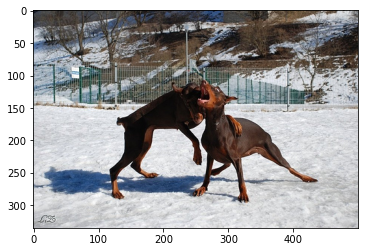

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog be run through the grass .
bleu score:  8.15394372921771e-155


C:\Users\Lohesh\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Lohesh\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


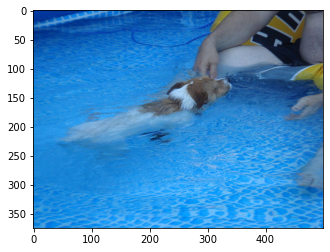

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy in a green suit be jump into a pool .
bleu score:  4.0622028886850106e-78


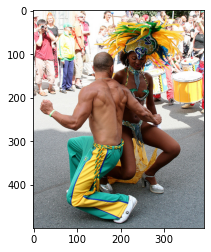

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a helmet be sit on a roller .
bleu score:  9.212002349967284e-155


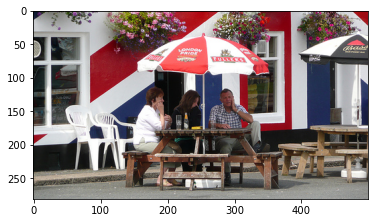

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be sit on a merry-go-round .
bleu score:  8.15394372921771e-155


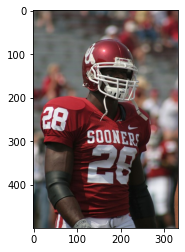

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
Quarterback football football 19 19 19 and 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 and 19 19 19 19 19 19 19
bleu score:  8.669612184277444e-232


C:\Users\Lohesh\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [47]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("flickr8k/Flickr_Data/Flickr_Data/Images"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

### Calculating Average Bleu Score on Test Set using Greedy Search

In [52]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

100%|██████████████████████████████████| 1000/1000 [09:22<00:00,  1.78it/s]


Bleu score on Greedy search
Score:  0.09653743187794046


### Beam Search Function

In [53]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

### Predicting Captions on Test Set using Beam Search with k=3

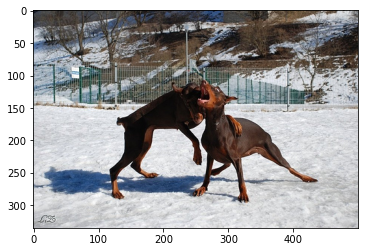

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog be run through the grass .
bleu score:  8.15394372921771e-155


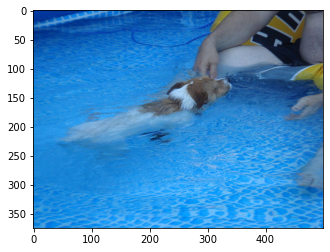

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy in a green suit be play in a pool .
bleu score:  0.2224246939793677


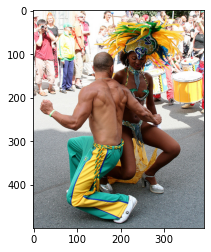

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a green shirt be sit on a swing .
bleu score:  8.80154124704578e-155


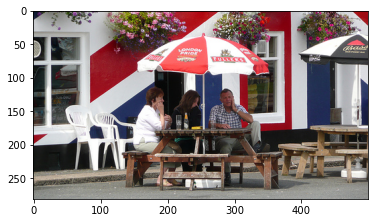

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be sit on a merry-go-round .
bleu score:  8.15394372921771e-155


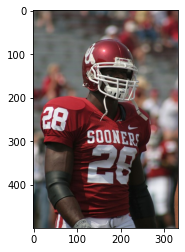

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
Quarterback football football 19 19 .
bleu score:  1.171778691554733e-231


In [54]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("flickr8k/Flickr_Data/Flickr_Data/Images"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Base Model-RESNET_50 
## Enhanced Model-XCEPTION
### XCEPTION Model instead of RESNET 50
#### Computational Efficiency: Reduced model complexity and faster training and inference.
#### Enhanced Feature Learning: Improved image feature extraction, leading to higher-quality captions.
#### Reduced Overfitting: Mitigated overfitting, resulting in better generalization.
#### Handling Correlations: Effective handling of cross-channel and spatial correlations for more coherent captions.
